Dask Approach to Non-SQL PTM Queries
--

* v01: move away from classes, try to organize the computation 
primarily in dask.
* v02: target optimization.
* v03: why not Bayesian?


Suggestions from Ed:
- Negative binomial or actually multinomial (to get, e.g., a size distribution)
- probably have to use a discrete distribution
- Laura Mitchell paper about how to deal with catchability of fish.


In [1]:
import postproc_dask as post
import six

In [2]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

In [3]:
import itertools

In [4]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [5]:
# Experiment level configuration -- small, all python native data.
import cfg_v01 
cfg=dict(cfg_v01.cfg)

In [6]:
# Load the grid into... grid
hydro_path=cfg['sun_paths'][0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
ptm_ds.close()   

cfg['grid']=grid 

In [7]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=grid.smooth_matrix()
Msmooth_K=grid.smooth_matrix(K=100*np.ones(grid.Nedges()))

INFO:utils:66107/99089
INFO:utils:64432/99089


In [8]:
# Or could make this delayed and have it execute on each client?
cfg['load_data']=post.get_load_data()

In [9]:
# Hydro timestamps
cfg['hydro_timestamps']=post.load_hydro_timestamps(cfg['sun_paths'])

In [10]:
cfg['bc_ds_d']=post.bc_ds(cfg=cfg)

In [11]:
areas=grid.cells_area()    

In [12]:
# Set this a bit early, as it controls cache location which 
# is needed for some testing.
cfg['manta_out_dir']="manta_sets_20210726d"

# now the 021b runs.
# c suffix: use tighter -0.095 z filter.
# 20200227: start of v03
# 20200302: start of v04
# 20200305: try larger window -- extra 24 hours in both directions.
# 20200312: new sources in ptm data, with v02 stormwater concs.
# 20200330: more new sources.
# 20210210a: dask code, new hydro, new ptm. new year.
# 20210317a: new ptm runs with no SJ loss...
#            has the w_s bug
# 20210317b: fixed w_s bug
# 20210317c: switch to weathered loads
# 20210708c: including beaching and deposition counts.
# 20210726d: other stuff, and now prep to optimize just 3 parameters
os.makedirs(cfg['manta_out_dir'],exist_ok=True)

Next steps
--


1. Recreate some of the figures from before, including on-grid smoothing.  
  a. Sample plot: from the powerpoint. 2017-08-30 to 2017-09-14. Surface particles
     max age of 10 days.   *This plot is similarish -- not exactly the same but close
     enough to rule out fundamental errors*
2. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.
  a. Implement in this notebook
  b. Move all of this to a module.

In [5]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
# manta.head()

In [14]:
godwin_offset_h=post.godwin_offset_h
godwin=post.godwin

In [15]:
import numexpr as ne
ne.set_num_threads(16) # reasonable on cws-linuxmodeling

8

In [16]:
# Streamlined version that only allows 
# tau, shore_factor and bed_factor to change.
# Msmooth is already set.

# Precalculate:
if 1: 
    manta_chrono=manta.sort_values('DATE') # helps with locality during precalculation
    storm_factor=1.0
    step=-10000
    precalc={} # idx => stuff.

    # Force mantas to be sorted, so that data from the same day
    # is grouped together.
    last_DATE=None
    df=None

    for idx,rec in utils.progress(manta_chrono.iterrows()):
        #print(idx)
        # since we're just pulling out whole days, cache by day.
        # and pull through the end of that day
        # 5s, all in read_parquet
        if rec.DATE==last_DATE:
            pass
        else:
            df=post.particles_for_date(rec.DATE,cfg=cfg)
            last_DATE=rec.DATE

        # Trawl-specific processing:
        # Pull subset of cells
        # add a cell weighting, and a time weighting for the tidal filter
        cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=grid,
                                               Msmooth=Msmooth,smooth=step,thresh=1e-5)
        df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
        df_spatial_sort=df_spatial.sort_index()
        space_cell=df_spatial_sort.index.values
        space_weight=df_spatial_sort['weight_spatial'].values
        df_cell=df.cell.values
        df_idx=np.searchsorted(space_cell,df_cell).clip(0,len(space_cell)-1)
        sel=space_cell[df_idx]==df_cell
        tdf=df[sel].copy()
        weight_spatial=space_weight[df_idx[sel]]

        t_sample=np.datetime64(rec['DATE'])    
        t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
        delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
        weight_time=godwin[delta_hours+godwin_offset_h]
        age=tdf['time'].values - tdf['rel_time'].values

        age_s=(age/np.timedelta64(1,'s')).astype(np.float32)
        bed_hits=tdf['bed_hits'].values
        shore_hits=tdf['shore_hits'].values
        mp_per_area = (tdf['mp_per_particle'] / areas[tdf['cell']]).values

        group_weight=post.group_weights(tdf,storm_factor)

        # Omits decay, bed, shore weights
        pre_weighted=weight_spatial*weight_time*group_weight*mp_per_area
        # Final code below then needs age_s, bed_hits, shore_hits
        sel=pre_weighted>0.0
        
        bundle=np.zeros(sel.sum(),[('preweighted',np.float32),
                                   ('age_s',np.float32),
                                   ('bed_hits',np.int16),
                                   ('shore_hits',np.int16)])
        bundle['preweighted']=pre_weighted[sel]
        bundle['age_s']=age_s[sel]
        bundle['bed_hits']=bed_hits[sel]
        bundle['shore_hits']=shore_hits[sel]
        
        print(f"Manta sample {idx}: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        # Can get maybe a factor of 3 by combining duplicates
        df_bundle=pd.DataFrame.from_records(bundle)
        uniquified=df_bundle.groupby(['age_s','bed_hits','shore_hits'])['preweighted'].sum().reset_index()
        bundle=np.zeros(len(uniquified),dtype=bundle.dtype)
        bundle['preweighted']=uniquified['preweighted']
        bundle['age_s']=uniquified['age_s']
        bundle['bed_hits']=uniquified['bed_hits']
        bundle['shore_hits']=uniquified['shore_hits']
        print(f"    uniquified: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        precalc[idx]=bundle

#                        weights=ne.evaluate('weight_spatial*weight_time*decay*group_weight*bed_weight*shore_weight')
#                        unweighted=mp_per_area
#                        final_weights=weights
#                        # final_concs=weights*mp_per_area
#                        C=ne.evaluate( 'sum(weights*mp_per_area)')

Manta sample 0: 4.44e+08 bytes, 3.70e+07 elements


INFO:utils:1


    uniquified: 1.46e+08 bytes, 1.21e+07 elements
Manta sample 1: 4.45e+08 bytes, 3.71e+07 elements


INFO:utils:2


    uniquified: 1.45e+08 bytes, 1.21e+07 elements
Manta sample 2: 4.34e+08 bytes, 3.61e+07 elements


INFO:utils:3


    uniquified: 1.42e+08 bytes, 1.18e+07 elements
Manta sample 3: 4.45e+08 bytes, 3.71e+07 elements


INFO:utils:4


    uniquified: 1.45e+08 bytes, 1.21e+07 elements
Manta sample 4: 4.14e+08 bytes, 3.45e+07 elements


INFO:utils:5


    uniquified: 1.40e+08 bytes, 1.17e+07 elements
Manta sample 5: 4.38e+08 bytes, 3.65e+07 elements


INFO:utils:6


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 6: 4.35e+08 bytes, 3.62e+07 elements


INFO:utils:7


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 7: 4.39e+08 bytes, 3.66e+07 elements


INFO:utils:8


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 11: 3.60e+08 bytes, 3.00e+07 elements


INFO:utils:9


    uniquified: 1.31e+08 bytes, 1.09e+07 elements
Manta sample 10: 3.59e+08 bytes, 2.99e+07 elements


INFO:utils:10


    uniquified: 1.30e+08 bytes, 1.08e+07 elements
Manta sample 8: 3.57e+08 bytes, 2.98e+07 elements


INFO:utils:11


    uniquified: 1.29e+08 bytes, 1.08e+07 elements
Manta sample 9: 3.41e+08 bytes, 2.84e+07 elements


INFO:utils:12


    uniquified: 1.25e+08 bytes, 1.04e+07 elements
Manta sample 12: 3.02e+08 bytes, 2.52e+07 elements


INFO:utils:13


    uniquified: 1.16e+08 bytes, 9.66e+06 elements
Manta sample 13: 3.12e+08 bytes, 2.60e+07 elements


INFO:utils:14


    uniquified: 1.18e+08 bytes, 9.83e+06 elements
Manta sample 14: 2.27e+08 bytes, 1.89e+07 elements


INFO:utils:15


    uniquified: 9.35e+07 bytes, 7.79e+06 elements
Manta sample 15: 4.20e+08 bytes, 3.50e+07 elements


INFO:utils:16


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 16: 4.20e+08 bytes, 3.50e+07 elements


INFO:utils:17


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 17: 4.74e+08 bytes, 3.95e+07 elements


INFO:utils:18


    uniquified: 1.40e+08 bytes, 1.17e+07 elements
Manta sample 18: 4.46e+08 bytes, 3.71e+07 elements


INFO:utils:19


    uniquified: 1.34e+08 bytes, 1.12e+07 elements
Manta sample 19: 4.45e+08 bytes, 3.71e+07 elements


INFO:utils:20


    uniquified: 1.34e+08 bytes, 1.12e+07 elements
Manta sample 20: 4.46e+08 bytes, 3.72e+07 elements


INFO:utils:21


    uniquified: 1.34e+08 bytes, 1.12e+07 elements
Manta sample 21: 4.45e+08 bytes, 3.71e+07 elements


INFO:utils:22


    uniquified: 1.34e+08 bytes, 1.11e+07 elements
Manta sample 22: 3.81e+08 bytes, 3.17e+07 elements


INFO:utils:23


    uniquified: 1.24e+08 bytes, 1.03e+07 elements
Manta sample 23: 3.86e+08 bytes, 3.22e+07 elements


INFO:utils:24


    uniquified: 1.25e+08 bytes, 1.04e+07 elements
Manta sample 24: 4.17e+08 bytes, 3.48e+07 elements


INFO:utils:25


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 25: 4.78e+08 bytes, 3.98e+07 elements


INFO:utils:26


    uniquified: 1.49e+08 bytes, 1.24e+07 elements
Manta sample 26: 3.24e+08 bytes, 2.70e+07 elements


INFO:utils:27


    uniquified: 1.25e+08 bytes, 1.04e+07 elements
Manta sample 27: 5.68e+08 bytes, 4.73e+07 elements


INFO:utils:28


    uniquified: 1.59e+08 bytes, 1.32e+07 elements
Manta sample 28: 5.09e+08 bytes, 4.24e+07 elements


INFO:utils:29


    uniquified: 1.42e+08 bytes, 1.18e+07 elements
Manta sample 29: 5.00e+08 bytes, 4.17e+07 elements


INFO:utils:30


    uniquified: 1.40e+08 bytes, 1.17e+07 elements
Manta sample 30: 3.13e+08 bytes, 2.61e+07 elements


INFO:utils:31


    uniquified: 8.96e+07 bytes, 7.47e+06 elements
Manta sample 31: 3.13e+08 bytes, 2.61e+07 elements


INFO:utils:32


    uniquified: 8.96e+07 bytes, 7.46e+06 elements
Manta sample 37: 6.35e+08 bytes, 5.29e+07 elements


INFO:utils:33


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 36: 6.36e+08 bytes, 5.30e+07 elements


INFO:utils:34


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 35: 6.36e+08 bytes, 5.30e+07 elements


INFO:utils:35


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 32: 6.40e+08 bytes, 5.33e+07 elements


INFO:utils:36


    uniquified: 1.34e+08 bytes, 1.12e+07 elements
Manta sample 33: 6.42e+08 bytes, 5.35e+07 elements


INFO:utils:37


    uniquified: 1.35e+08 bytes, 1.12e+07 elements
Manta sample 34: 6.35e+08 bytes, 5.29e+07 elements


INFO:utils:38


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 38: 5.23e+08 bytes, 4.36e+07 elements


INFO:utils:39


    uniquified: 1.20e+08 bytes, 9.96e+06 elements
Manta sample 39: 5.06e+08 bytes, 4.22e+07 elements


INFO:utils:40


    uniquified: 1.16e+08 bytes, 9.65e+06 elements
Manta sample 40: 5.18e+08 bytes, 4.31e+07 elements


INFO:utils:41


    uniquified: 1.18e+08 bytes, 9.85e+06 elements
Manta sample 41: 3.09e+08 bytes, 2.58e+07 elements


INFO:utils:42


    uniquified: 7.65e+07 bytes, 6.37e+06 elements
Manta sample 42: 3.06e+08 bytes, 2.55e+07 elements


INFO:utils:43


    uniquified: 7.62e+07 bytes, 6.35e+06 elements
Manta sample 43: 3.11e+08 bytes, 2.59e+07 elements


INFO:utils:44


    uniquified: 7.68e+07 bytes, 6.40e+06 elements
Manta sample 52: 2.25e+08 bytes, 1.87e+07 elements


INFO:utils:45


    uniquified: 5.79e+07 bytes, 4.82e+06 elements
Manta sample 51: 2.24e+08 bytes, 1.87e+07 elements


INFO:utils:46


    uniquified: 5.78e+07 bytes, 4.82e+06 elements
Manta sample 49: 1.64e+08 bytes, 1.37e+07 elements


INFO:utils:47


    uniquified: 4.73e+07 bytes, 3.94e+06 elements
Manta sample 50: 2.22e+08 bytes, 1.85e+07 elements


INFO:utils:48


    uniquified: 5.75e+07 bytes, 4.79e+06 elements
Manta sample 48: 4.89e+08 bytes, 4.07e+07 elements


INFO:utils:49


    uniquified: 1.06e+08 bytes, 8.86e+06 elements
Manta sample 46: 4.87e+08 bytes, 4.06e+07 elements


INFO:utils:50


    uniquified: 1.06e+08 bytes, 8.83e+06 elements
Manta sample 45: 4.78e+08 bytes, 3.99e+07 elements


INFO:utils:51


    uniquified: 1.05e+08 bytes, 8.75e+06 elements
Manta sample 44: 4.77e+08 bytes, 3.97e+07 elements


INFO:utils:52


    uniquified: 1.05e+08 bytes, 8.74e+06 elements
Manta sample 47: 4.88e+08 bytes, 4.06e+07 elements


INFO:utils:53


    uniquified: 1.06e+08 bytes, 8.84e+06 elements
Manta sample 55: 2.74e+08 bytes, 2.28e+07 elements


INFO:utils:54


    uniquified: 8.21e+07 bytes, 6.84e+06 elements
Manta sample 56: 2.76e+08 bytes, 2.30e+07 elements


INFO:utils:55


    uniquified: 8.27e+07 bytes, 6.89e+06 elements
Manta sample 53: 2.87e+08 bytes, 2.39e+07 elements


INFO:utils:56


    uniquified: 8.51e+07 bytes, 7.10e+06 elements
Manta sample 54: 2.80e+08 bytes, 2.33e+07 elements


INFO:utils:57


    uniquified: 8.36e+07 bytes, 6.96e+06 elements
Manta sample 57: 2.77e+08 bytes, 2.31e+07 elements


INFO:utils:58


    uniquified: 8.36e+07 bytes, 6.97e+06 elements
Manta sample 58: 2.65e+08 bytes, 2.21e+07 elements


INFO:utils:59


    uniquified: 8.11e+07 bytes, 6.75e+06 elements
Manta sample 59: 2.93e+08 bytes, 2.44e+07 elements


INFO:utils:60


    uniquified: 8.62e+07 bytes, 7.18e+06 elements
Manta sample 60: 3.22e+08 bytes, 2.69e+07 elements


INFO:utils:61


    uniquified: 9.41e+07 bytes, 7.84e+06 elements
Manta sample 61: 3.22e+08 bytes, 2.69e+07 elements


INFO:utils:62


    uniquified: 9.41e+07 bytes, 7.84e+06 elements
Manta sample 63: 2.39e+08 bytes, 1.99e+07 elements


INFO:utils:63


    uniquified: 7.73e+07 bytes, 6.44e+06 elements
Manta sample 62: 2.32e+08 bytes, 1.94e+07 elements


INFO:utils:64


    uniquified: 7.60e+07 bytes, 6.33e+06 elements
Manta sample 64: 2.63e+08 bytes, 2.19e+07 elements
    uniquified: 8.25e+07 bytes, 6.88e+06 elements


In [60]:
%load_ext line_profiler

In [432]:
pred_type=np.float64

def predict_mantas_fast(decay_rate,beach_rate=1e-2,depo_rate=1e-2):
    # tau_d: e-folding decay time scale in days
    # shore_factors: particle weight derated by (1-shore_factor)**hits
    # bed_factors: particle weighte derated by (1-bed_factor)**hits
    print(f"tau={decay_rate}  shore={beach_rate}  bed={depo_rate}")
    preds=[]

    for idx,rec in utils.progress(manta_chrono.iterrows()):
        # print(idx)
        bundle=precalc[idx]
        age_s=bundle['age_s']
        shore_hits=bundle['shore_hits']
        bed_hits=bundle['bed_hits']
        preweighted=bundle['preweighted']
                                        
        pred=dict(idx=idx,storm_factor=storm_factor,decay_rate=decay_rate,
                  step=step,Msmooth_i=0,
                  beach_rate=beach_rate,depo_rate=depo_rate)
        pred['idx']=idx
    
        # All in one go was actually half as fast
        weight=ne.evaluate('''exp( -age_s*decay_rate/86400. 
                                   -shore_hits*beach_rate 
                                   -bed_hits*depo_rate )''')
        C=ne.evaluate( 'sum(preweighted*weight)')
         
        pred['C_model']=C
        preds.append(pred)

    df_pred=pd.DataFrame(preds)
    df_pred['C_model']=df_pred['C_model'].astype(np.float64)
    manta_pred=df_pred.join(manta_chrono,on='idx')
    return manta_pred

In [18]:
%%time
# 6.7s
# 2.8s after combining all rates, which regresses to 5.5s if I do the
# summation in line, too.
# Those times with 8 threads. Down to 1.9s with 16 threads.
# Back to 2.49 if 64 bit. 
#%lprun -f predict_mantas_fast 
result=predict_mantas_fast(tau_d=60,shore_factor=0.01,bed_factor=0.01)
#metrics(result)

tau=60  shore=0.01  bed=0.01
CPU times: user 15.7 s, sys: 2.81 s, total: 18.5 s
Wall time: 2.61 s


In [19]:
def predict_mantas_fast_multi(tau_ds,shore_factors,bed_factors):
    dfs=[]
    for tau_d,shore_factor,bed_factor in itertools.product(tau_ds,shore_factors,bed_factors):
        #print(f"tau={tau/np.timedelta64(86400,'s')}d shore_factor={shore_factor}  bed_factor={bed_factor}")
        dfs.append(predict_mantas_fast(tau_d,shore_factor=shore_factor,bed_factor=bed_factor))
    combined=pd.concat(dfs)
    return combined
            

Optimization
==

Before something more sophisticated like stan or max likelihood, 
just optimize a cost function.

1. Maximize r_log.  This worked well, giving tau=90.47 shore=0.037 and bed=-0.0075. Even without any constraints, the values are not too crazy, and the result a bit better than before, $r_{log} = 0.7214559$. But I'm having trouble getting this result after changing the code to use 64-bit floats, so maybe that was a fluke.
2. Constrained optimization did not move much at all from the initial. This may be due to estimating gradients with a smaller epsilon than fmin, in fact slightly smaller than a 32-bit float can represent. The form is so simple that we might as well calculated gradients.
3. That said, unconstrained optimization with a penalty did not do any better. 

In [71]:
from cmdstanpy import cmdstan_path, CmdStanModel

Double checking the formulation here:

`preweighted * exp(-age*decay_per_day) * exp(-shore*decay_per_shore)`

is not quite the same as:

`preweighted * decay_per_day**age`

In the first case, 

In [262]:
%%writefile model_shore.stan
// First just set tau and bed_factor, let stan find a shore factor.
data {
  int<lower=1> Nsamp;
  int<lower=1> Npart[Nsamp]; // group sizes
  int<lower=1> Nfrac; // particles groups * samples
  vector<lower=0>[Nfrac] age_d;
  // These are integer valued - are int arrays faster than real vectors?
  // have to use vectors
  vector<lower=0,upper=20000>[Nfrac] shore_hits;
  vector<lower=0,upper=20000>[Nfrac] bed_hits;
  vector<lower=0>[Nfrac] preweighted;
  vector<lower=0>[Nsamp] observed;
}
parameters {
  // with [0,1], we always get too a value 10-100% too large
  // [0,oo] does not any different  
  real<lower=0.0> beach_rate; // units 1/hit 
}
model {
  real decay_rate=0.0;
  real depo_rate=0.0; 
  real sigma=1.0; // log scale!

  // Priors
  // beach_rate ~ 
    
  // forward model:
  int pos; // index to start of particles for a manta sample
  pos = 1; 
 
  real pred[Nsamp];
  
  for (k in 1:Nsamp) { // iterate over manta samples
    // print(segment(preweighted,pos,Npart[k]));

    pred[k]=sum( segment(preweighted,pos,Npart[k]) 
                 .* exp(-segment(age_d,pos,Npart[k])*decay_rate
                        -segment(shore_hits,pos,Npart[k])*beach_rate
                        -segment(bed_hits,pos,Npart[k])*depo_rate));
    print(pred[k]); // this is all zero!
    // This gives inflated results:
    // pred[k] ~ lognormal(log_observed[k],sigma);
    // This gives accurate results.
    observed[k] ~ lognormal(log(pred[k]),sigma);
    pos = pos + Npart[k];
  }
}

Overwriting model_shore.stan


In [313]:
%%writefile model_shore_bed_decay.stan
// First just set tau and bed_factor, let stan find a shore factor.
data {
  int<lower=1> Nsamp;
  int<lower=1> Npart[Nsamp]; // group sizes
  int<lower=1> Nfrac; // particles groups * samples
  vector<lower=0>[Nfrac] age_d;
  // These are integer valued - are int arrays faster than real vectors?
  // have to use vectors
  vector<lower=0,upper=20000>[Nfrac] shore_hits;
  vector<lower=0,upper=20000>[Nfrac] bed_hits;
  vector<lower=0>[Nfrac] preweighted;
  vector<lower=0>[Nsamp] observed;
}
transformed data {
  vector[Nfrac] log_preweight;
  log_preweight=log(preweighted);
}
parameters {
  // with [0,1], we always get too a value 10-100% too large
  // [0,oo] does not any different  
  real<lower=0.0> beach_rate; // units 1/hit
  real<lower=0.0> depo_rate; // units 1/hit
  real<lower=0.0> decay_rate; // units 1/day
}
model {
  real sigma=1.0; // log scale!
    
  // forward model:
  int pos; // index to start of particles for a manta sample
  pos = 1; 
 
  real pred[Nsamp];
  vector[Nfrac] postweight;
  
  postweight= preweighted .* 
                 exp( -age_d*decay_rate
                      -shore_hits*beach_rate
                      -bed_hits*depo_rate);
    
  for (k in 1:Nsamp) { // iterate over manta samples
    pred[k]=sum(segment(postweight,pos,Npart[k]));
        //segment(preweighted,pos,Npart[k]) .* 
        //         exp( -segment(age_d,pos,Npart[k])*decay_rate
        //                -segment(shore_hits,pos,Npart[k])*beach_rate
        //                -segment(bed_hits,pos,Npart[k])*depo_rate)
    // be sure to right as likelihood, data ~ dist(model), not the other
    // way round
    observed[k] ~ lognormal(log(pred[k]),sigma);
    pos = pos + Npart[k];
  }
}

Overwriting model_shore_bed_decay.stan


In [314]:
#shore_model = CmdStanModel(stan_file='model_shore.stan')
shore_bed_decay_model =CmdStanModel(stan_file='model_shore_bed_decay.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/rusty/src/microplastic_sfbay/postprocess/model_shore_bed_decay
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /home/rusty/src/microplastic_sfbay/postprocess/model_shore_bed_decay


In [95]:
# preparing data for stan:
# ensure that observed values are positive.
obs=manta_chrono['part_per_m2_nofiber'].values
detect_limit=0.5*obs[obs>0].min()
observed=obs.clip(detect_limit)

In [422]:
# Write sample data, but using real observations
data={}
data['observed']=observed
data['Nsamp']=len(data['observed'])

if 1: # synthetic model output
    data['Npart']=200*np.ones(data['Nsamp'],np.int64) # 100 age*bed*shore for each manta sample
    data['Nfrac']=data['Npart'].sum()
    # Model data are random, then scaled to reproduce observations
    age_s=np.random.uniform(1*86400,60*86400,data['Nfrac'])
    shore_hits=np.random.randint(0,1500,data['Nfrac'])
    bed_hits=np.random.randint(0,1500,data['Nfrac'])
    data['age_d']=age_s/86400.
    data['shore_hits']=shore_hits
    data['bed_hits']=bed_hits

    # Doesn't really matter what this is.
    preweighted=np.random.uniform(0,1,data['Nfrac'])
    #log_pre=np.random.normal(size=data['Nfrac'])
    #preweighted=np.exp(log_pre)
    
    # scale preweighted to get the "right" answer,
    # but allow some log-normal noise.
    syn_beach_rate=0.10
    syn_depo_rate=0.0
    syn_decay_rate=0.02
    syn_sigma=1.0
    for p,(size,end) in enumerate(zip(data['Npart'],np.cumsum(data['Npart']))):
        slc=slice(end-size,end)
        pred=np.sum(preweighted[slc]*np.exp(-data['age_d'][slc]*syn_decay_rate
                                            -shore_hits[slc]*syn_beach_rate
                                            -bed_hits[slc]*syn_depo_rate))
        scale=observed[p]/pred
        # include log-normal noise, too
        preweighted[slc] *= scale * np.exp(np.random.normal(0,syn_sigma))
    data['preweighted']=preweighted

safe_data=dict(data)
for k in data:
    if isinstance(data[k],np.ndarray):
        safe_data[k]=data[k].tolist()
    elif isinstance(data[k],np.int64):
        safe_data[k]=int(data[k])
        
import json
with open("syn-data.json",'wt') as fp:
    json.dump(safe_data,fp,indent=0)


In [315]:
%%time
# obtain a posterior sample from the model conditioned on the data
# So far synthetic data is coming back always about 10-15% high on
# beach_rate.
# Is this because I'm not synthesizing a log-normal? nope.
# Maybe related to sigma?
# When sigma=1.0, then I get those biases to higher values.
# when sigma=0.1, then I get almost exact
# no change when decay_rate and depo_rate are zero'd.
# offset gets smaller but not zero as the number of sub-groups
# is decreased. Do I have an error?
# Not sure.
# Shot in the dark, but try reversing the posterior?
# That made a big difference. Recover 0.01 perfectly.
# 
fit = shore_bed_decay_model.sample(chains=1, data="syn-data.json", output_dir='syn-output')
fit.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


CPU times: user 15.5 ms, sys: 396 ms, total: 411 ms
Wall time: 20.8 s


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-100.00000,0.093000,1.30000,-100.000000,-100.00000,-100.00000,190.0,18.0,1.0
beach_rate,0.08900,0.000650,0.01300,0.067000,0.08900,0.11000,380.0,38.0,1.0
depo_rate,0.00039,0.000016,0.00027,0.000039,0.00035,0.00091,260.0,26.0,1.0
decay_rate,0.01100,0.000430,0.00700,0.000950,0.01100,0.02300,270.0,27.0,1.0


In [423]:
from scipy import stats

In [429]:
# Just doesn't seem like stan can optimize the gradient calculation
# well enough.

# Try emcee
import emcee

def log_prior(theta):
    beach_rate,depo_rate,decay_rate=theta
    if beach_rate<0 or depo_rate<0 or decay_rate<0:
        return -np.inf
    return 0  # flat prior for non-negative values

# theta is parameter vector.
# Use the same synthetic data as above to make sure we can 
# get similar results to stan for the toy problem.
ncalls=0
def log_likelihood(theta, data):
    global ncalls
    ncalls+=1
    LL=0.0
    sigma=1.0 # log units
    beach_rate,depo_rate,decay_rate=theta
    preweighted=data['preweighted']
    shore_hits=data['shore_hits']
    bed_hits=data['bed_hits']
    age_d=data['age_d']
    for p,(size,end) in enumerate(zip(data['Npart'],np.cumsum(data['Npart']))):
        slc=slice(end-size,end)
        pred=np.sum(preweighted[slc]*np.exp(-age_d[slc]*decay_rate
                                            -shore_hits[slc]*beach_rate
                                            -bed_hits[slc]*depo_rate))
        if np.isinf(pred):
            return -np.inf
        ll = stats.norm.logpdf( np.log(observed[p]), np.log(pred), sigma ) 
        LL+=ll
    return LL

def log_posterior(theta, data):
    return log_prior(theta) + log_likelihood(theta, data)

dims=['beach','depo','decay']
ndim = len(dims)  # number of parameters in the model

In [448]:
# The real setup

def log_prior(theta):
    beach_rate,depo_rate,decay_rate=theta
    if beach_rate<0 or depo_rate<0 or decay_rate<0:
        return -np.inf
    return 0  # flat prior for non-negative values

# theta is parameter vector.
# Use the same synthetic data as above to make sure we can 
# get similar results to stan for the toy problem.
ncalls=0
def log_likelihood(theta, data):
    global ncalls
    ncalls+=1
    LL=0.0
    beach_rate,depo_rate,decay_rate=theta

    df=predict_mantas_fast(decay_rate=decay_rate,
                           beach_rate=beach_rate,
                           depo_rate=depo_rate)

    sigma=1.0 # log units
    
    obs=df['part_per_m2_nofiber'].values
    mod=df['C_model'].values

    LL=0
    for o,m in zip(obs,mod):
        o=max(o,detect_limit)
        if np.isinf(m):
            return -np.inf
        ll = stats.norm.logpdf( np.log(o), np.log(m), sigma ) 
        LL+=ll
    return LL

def log_posterior(theta, data):
    return log_prior(theta) + log_likelihood(theta, data)

dims=['beach','depo','decay']
ndim = len(dims)  # number of parameters in the model

In [449]:
nwalkers = 6  # number of MCMC walkers
nburn = 2000  # "burn-in" period to let chains stabilize
nsteps = 4000  # number of MCMC steps to take

# with sigma=1.0, needed 2000+2000 to converge.
# How many calls?? 24k
# = 6 * 4000 

# we'll start at random locations between 0 and 0.5
starting_guesses = 0.5 * np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
sampler.run_mcmc(starting_guesses, nsteps,progress=True)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :]  # discard burn-in points

tau=0.3975588602043036  shore=0.32261218150119997  bed=0.45831668604423487
tau=0.33557299468341234  shore=0.061151050310119026  bed=0.036103851706705714
tau=0.09660173201959082  shore=0.4996836925077287  bed=0.276641307061251
tau=0.044627755042080386  shore=0.2555568207145612  bed=0.2966631136960041
tau=0.1858576114476737  shore=0.12841297337029856  bed=0.36977014546032283
tau=0.16211109931158857  shore=0.10583572140000252  bed=0.17652376858379953


  0%|          | 0/4000 [00:00<?, ?it/s]

tau=0.263153129104689  shore=0.40169130495408933  bed=0.3771815015005387
tau=0.36657588732465085  shore=0.0042580989394040425  bed=0.004897769345896974
tau=0.2571924441312282  shore=-0.16831296557819642  bed=0.4442003135095255
tau=0.05160061273709812  shore=0.5261606071314135  bed=0.24947599135792084
tau=0.004794756921734145  shore=0.29141694803589036  bed=0.2760437324053433
tau=0.04666142080994318  shore=0.13557614883059538  bed=0.26998195560486415


  0%|          | 1/4000 [00:15<16:58:33, 15.28s/it]

tau=0.45738304856686407  shore=-0.13831496390048237  bed=-0.05542220322160604
tau=0.3145927430599168  shore=0.012517649689275823  bed=0.43640933631902906
tau=0.032662361873779897  shore=0.18768501851648706  bed=0.2720088467589901
tau=0.325671499204263  shore=0.45973842059294634  bed=0.4057085571934016
tau=0.19186356508700367  shore=0.2964776609813663  bed=0.14408473446324932
tau=-0.06898987480790403  shore=0.3427809210063  bed=0.3295656202248126


  0%|          | 2/4000 [00:30<17:04:43, 15.38s/it]

tau=0.29845401224049245  shore=0.23569580584403066  bed=0.2109240504629053
tau=0.008029000714576573  shore=0.597509855455191  bed=0.28221497823255165
tau=-0.008372247949758611  shore=0.3404286526176672  bed=0.2779501523884337
tau=0.6524484960642553  shore=-0.4577379185913997  bed=-0.20199114636766452
tau=0.15095489181386754  shore=0.15983455921597034  bed=0.351702901763623
tau=0.029416711244249865  shore=0.1997663438735232  bed=0.2724787769578968


  0%|          | 3/4000 [00:46<17:04:56, 15.39s/it]

tau=0.4099360228429681  shore=0.21454236064485885  bed=0.18620263289731023
tau=0.3445802393419952  shore=0.05707293096361549  bed=0.02914960350714263
tau=0.23685784783908137  shore=-0.10322206010600443  bed=0.3934673294223333
tau=-0.06373453712648391  shore=0.7150238569882998  bed=0.3361369107569014
tau=0.05820431202520662  shore=0.24333436483691778  bed=0.30369096041253013
tau=0.08508735664524084  shore=0.18147556303839302  bed=0.3087674406403114


  0%|          | 4/4000 [01:01<17:08:48, 15.45s/it]

tau=0.48374679198687276  shore=-0.018051964012600397  bed=-0.21719476281400812
tau=0.006416873447600705  shore=0.4449360997690451  bed=0.2791388855486077
tau=-0.08536258150300599  shore=0.2374774728343873  bed=0.19766040324929168
tau=0.27413039720542853  shore=0.35007284854785115  bed=0.3254815877401762
tau=0.027328457981337317  shore=0.27573047803506723  bed=0.25969823887914756
tau=0.08583772183743509  shore=0.28827831184645564  bed=0.31901141040754294


  0%|          | 5/4000 [01:17<17:07:25, 15.43s/it]

tau=0.45499081440016126  shore=0.1969824159924935  bed=0.13134571877656076
tau=0.5051896155825992  shore=-0.09311053307317452  bed=-0.15604291069024795
tau=-0.07621562213488574  shore=0.29455432223846806  bed=0.2330933309021202
tau=0.02307075646852358  shore=0.42551822810719897  bed=0.26684235887794194
tau=0.17815523521747112  shore=0.2654471064283176  bed=0.2720801226920727
tau=0.18101259806229544  shore=0.13112980269842217  bed=0.15543572295791527


  0%|          | 6/4000 [01:32<17:07:02, 15.43s/it]

tau=0.32183256853877734  shore=0.2299140142675141  bed=0.1990391359777151
tau=-0.05164247698935363  shore=0.2936026521863886  bed=0.2461216176783112
tau=0.03775913086712301  shore=0.11083923923038519  bed=0.27006304598236325
tau=0.4405397558478073  shore=0.01362630820861116  bed=-0.044938124781174815
tau=0.007956863771797633  shore=0.5906827243043447  bed=0.28207733406110813
tau=0.10956552849400693  shore=0.3255019425608635  bed=0.33858066870522563


  0%|          | 7/4000 [01:48<17:10:22, 15.48s/it]

tau=0.20976591324616956  shore=0.11811145409436419  bed=0.13323607168516013
tau=-0.07850036885676565  shore=0.307221999173661  bed=0.2945146370331015
tau=0.11004229434713692  shore=0.32624988173244446  bed=0.33897387631444353
tau=0.16220111379449983  shore=0.2615494678378306  bed=0.2411384750037128
tau=-0.09660755966411905  shore=0.6105180168556761  bed=0.35305885439909374
tau=0.07313604774646629  shore=0.1799719806954236  bed=0.2387242683727525


  0%|          | 8/4000 [02:03<17:12:23, 15.52s/it]

tau=0.15452640914716365  shore=0.2642357809791622  bed=0.24896489239991115
tau=0.2873921176189338  shore=-0.00665017135678081  bed=0.07753931669313058
tau=0.004836850525430801  shore=0.295400739724006  bed=0.27612405101853504
tau=0.06142698360272972  shore=0.3565232910447732  bed=0.23966916456776627
tau=0.0762041761865857  shore=0.28912539204438303  bed=0.3139107574413919
tau=0.0881065736752081  shore=0.17319392661435012  bed=0.22716593317340147


  0%|          | 9/4000 [02:19<17:14:01, 15.55s/it]

tau=0.169324434560153  shore=0.13642173463875906  bed=0.16445983555526988
tau=-0.002813430480747142  shore=0.4815927187224074  bed=0.28473006984609256
tau=-0.018994087167959167  shore=0.29749620033111196  bed=0.26350633502512694
tau=0.15938835599781473  shore=0.22224199581318854  bed=0.22120043845937043
tau=0.14319707862064046  shore=0.2832346885474244  bed=0.3493813472840008
tau=0.09081333378844934  shore=0.15009656086851325  bed=0.22904440854075625


  0%|          | 10/4000 [02:35<17:17:24, 15.60s/it]

tau=-0.050528058220300764  shore=0.5527784204135254  bed=0.31922536539651764
tau=0.021085785576091753  shore=0.33344277507554654  bed=0.37534123120299945
tau=0.09677586303666638  shore=0.1692688198802157  bed=0.2204726110511957
tau=0.2200275587604642  shore=0.2735456734734005  bed=0.22190532771857796
tau=0.2739958400820152  shore=-0.061804989776820085  bed=0.0907762246489516
tau=0.011243438785318279  shore=0.3103998554386996  bed=0.3152431452709965


  0%|          | 11/4000 [02:50<17:15:42, 15.58s/it]

tau=0.17794567204096795  shore=0.061958066944468676  bed=0.11522771552201692
tau=0.09007902293910683  shore=0.2779694622137122  bed=0.2984469821036773
tau=0.07362471902190933  shore=0.20103007292613595  bed=0.23448618881455302
tau=0.2078324284606745  shore=0.18329103060635524  bed=0.16720861668494194
tau=0.0010031248695669508  shore=0.48608412920248434  bed=0.24363418639791823
tau=-0.1539896869708009  shore=0.44890828292529383  bed=0.383945202434558


  0%|          | 12/4000 [03:05<17:10:42, 15.51s/it]

tau=0.11957334073254122  shore=0.28856685763070944  bed=0.2268398532600303
tau=0.17017188932343308  shore=0.13560266056753567  bed=0.16388453151735355
tau=-0.03067954079879799  shore=0.4639057725784195  bed=0.5141222601004809
tau=0.07311406832187096  shore=0.3366856900319507  bed=0.20963959601358365
tau=-0.1467046443666204  shore=0.4418672115154799  bed=0.3789996706986152
tau=0.08925437684417727  shore=0.23080615631793538  bed=0.23188524881108435


  0%|          | 13/4000 [03:21<17:10:28, 15.51s/it]

tau=0.2114187483747364  shore=0.010909505292005961  bed=0.11256469419464686
tau=-0.006197561954229134  shore=0.5408140578454121  bed=0.19641030526044811
tau=0.09083291145943628  shore=0.2338134248631129  bed=0.231622563992621
tau=0.13825548207699714  shore=0.32415823173087416  bed=0.2237309477852078
tau=0.005491147726732077  shore=0.2628570422167057  bed=0.2816690559041642
tau=0.016219617419832442  shore=0.37042883522142545  bed=0.3434276995872771


  0%|          | 14/4000 [03:36<17:12:08, 15.54s/it]

tau=0.17161877354027397  shore=0.2473439396975551  bed=0.16813016455472882
tau=0.19027467053877795  shore=0.11071817678945924  bed=0.1467211789828339
tau=0.004919947292472981  shore=0.45631371744061633  bed=0.2693216744198428
tau=-0.02761981588616591  shore=0.2884430042394314  bed=0.3053509938364397
tau=-0.022112148513783986  shore=0.40078975559558705  bed=0.38666772900159174
tau=0.09373572816149339  shore=0.23934358509914927  bed=0.23113950465959063


  0%|          | 15/4000 [03:52<17:11:46, 15.53s/it]

tau=0.14444848174161815  shore=0.21336695413048123  bed=0.19588990411657234
tau=-0.12870572282757753  shore=0.7548130968851654  bed=0.3047816202767296
tau=0.01948979646248784  shore=0.40321813631728753  bed=0.36225254861539363
tau=0.20034460371735135  shore=0.04438769177862903  bed=0.12634327795536993
tau=0.005922379260556013  shore=0.24140827464676268  bed=0.2853236351338101
tau=0.17097371050615529  shore=0.10872866985484753  bed=0.11925420063236791


  0%|          | 16/4000 [04:08<17:11:47, 15.54s/it]

tau=0.06540815910745891  shore=0.20308895507452246  bed=0.24134237893543026
tau=-0.08265030070700752  shore=0.4487393862366695  bed=0.4549576034116716
tau=0.0942017804941566  shore=0.24023146206230014  bed=0.23106194863312365
tau=0.14675563266892755  shore=0.2998459383650323  bed=0.21285208569654263
tau=0.1535462706151104  shore=0.1585000683291839  bed=0.17858592052400374
tau=-0.002956372503329861  shore=0.68302320295709  bed=0.2100784379800993


  0%|          | 17/4000 [04:23<17:10:53, 15.53s/it]

tau=0.10796310525471657  shore=0.2977628188989161  bed=0.2399367433025521
tau=-0.002722969957799694  shore=0.6714141332192689  bed=0.21205646608828788
tau=0.0710896438627359  shore=0.2720623386135378  bed=0.25149911355037713
tau=0.1180200691283837  shore=0.20742804724745673  bed=0.21000036092155425
tau=-0.046100924220004405  shore=0.21693700548438158  bed=0.31232589404649796
tau=0.01691195910138577  shore=0.3651665856950723  bed=0.34796824718728425


  0%|          | 18/4000 [04:39<17:11:28, 15.54s/it]

tau=0.09758715218003476  shore=0.2355690048463478  bed=0.22806839591431388
tau=0.01017340476102726  shore=0.029969057563126456  bed=0.32135001140772196
tau=0.031091343321759973  shore=0.35466980506483486  bed=0.331144513865939
tau=0.06582978131065921  shore=0.2744936364664864  bed=0.2586773059329054
tau=0.02443303719534491  shore=0.425312720477954  bed=0.23985814685527274
tau=0.07314906636886669  shore=0.2685232249969135  bed=0.2478320926019199


  0%|          | 19/4000 [04:54<17:09:36, 15.52s/it]

tau=0.14566557319503448  shore=0.11086544925011138  bed=0.2203199239449648
tau=0.02537535417265384  shore=0.25215166680552276  bed=0.2766711088064093
tau=-0.024879205714033473  shore=0.44262972682390256  bed=0.4242507199948792
tau=0.07358117040227385  shore=0.27877453505205757  bed=0.2552295505899726
tau=-0.03396923335687481  shore=0.5767937932545122  bed=0.24927044340675544
tau=0.07956681603607696  shore=0.2598690310048531  bed=0.24264189649491696


  0%|          | 20/4000 [05:09<17:06:34, 15.48s/it]

tau=0.07652287972106729  shore=0.27348010002306444  bed=0.2519012042403726
tau=0.010832387984930603  shore=0.44634940072659174  bed=0.3991836305572265
tau=0.06531446874306043  shore=0.2658383892359783  bed=0.2525615154895177
tau=0.09333084480288192  shore=0.23956110560645547  bed=0.2312986896003353
tau=0.036922148012423564  shore=0.37659396186413435  bed=0.24373897422889615
tau=0.03297628654920182  shore=0.15065353883359828  bed=0.21263950885024452


  1%|          | 21/4000 [05:25<17:09:21, 15.52s/it]

tau=0.02637572719217686  shore=0.26293290324151  bed=0.27381798616788283
tau=-0.0013824719056302476  shore=0.3933049212377129  bed=0.37745096396082883
tau=0.06874306311287579  shore=0.26817594864843836  bed=0.25235952972761205
tau=0.07831260959022024  shore=0.2707273486765154  bed=0.24901693313004655
tau=0.10123315834486896  shore=0.23680267160554883  bed=0.22628039040153333
tau=0.034732169274259  shore=0.3529920872582052  bed=0.2499849222840808


  1%|          | 22/4000 [05:40<17:05:58, 15.47s/it]

tau=0.10224693770795204  shore=0.2210581913305908  bed=0.22077964370788758
tau=0.05167735258375213  shore=0.32100546516196815  bed=0.24960854348804776
tau=0.03154414418197561  shore=0.2071003536424936  bed=0.23332254448185874
tau=0.07097447789946941  shore=0.26962607604678596  bed=0.25252105938595354
tau=-0.009308847455422098  shore=0.40944664990255897  bed=0.3870493815886841
tau=0.058545004150982106  shore=0.29322332625395464  bed=0.25109566015970847


  1%|          | 23/4000 [05:56<17:08:22, 15.51s/it]

tau=0.07438018004119454  shore=0.2605582541465165  bed=0.25303508214680626
tau=0.08797301549436143  shore=0.24926960751337468  bed=0.2289169751088621
tau=0.06274842164856015  shore=0.2762189794750178  bed=0.2520058653699475
tau=0.054678227848477576  shore=0.3088658374254592  bed=0.2502583510084295
tau=0.025920499562115208  shore=0.26303388024722874  bed=0.27414982189336956
tau=0.02073767157918563  shore=0.3577426278223139  bed=0.3399588053343023


  1%|          | 24/4000 [06:12<17:07:18, 15.50s/it]

tau=0.084128258734148  shore=0.25615155583137356  bed=0.23138139687165601
tau=0.033536380148506795  shore=0.3393115864707872  bed=0.30613349132519574
tau=0.06278487603283653  shore=0.2761698981512917  bed=0.25200909097545104
tau=0.07259906450439475  shore=0.26136342192186124  bed=0.2569915248969476
tau=0.053393948013232884  shore=0.3140456274631243  bed=0.24998099346369965
tau=0.005514952895855484  shore=0.25576269727840595  bed=0.28640538569842977


  1%|          | 25/4000 [06:27<17:08:20, 15.52s/it]

tau=0.08400505761319757  shore=0.2562072499008632  bed=0.2316550670360685
tau=0.047007550744275345  shore=0.339803407070413  bed=0.24860176487381047
tau=-0.0013817479025667323  shore=0.20956036752140936  bed=0.2621428397206594
tau=0.13105032931912738  shore=0.26624340663715906  bed=0.23136284284830186
tau=0.018046878135168986  shore=0.3595801215270482  bed=0.3493164016898474
tau=0.08236889715366524  shore=0.28314834392213156  bed=0.24024693511011364


  1%|          | 26/4000 [06:43<17:14:27, 15.62s/it]

tau=0.077180174266084  shore=0.2716281273932435  bed=0.23478120297466398
tau=0.023666682259761925  shore=0.4061359042863376  bed=0.37752815530307504
tau=0.0635106025007018  shore=0.27507500867299645  bed=0.25237752532758306
tau=0.08027113180174719  shore=0.2497887224550592  bed=0.2608864540050559
tau=0.04348628953681281  shore=0.35361452526006826  bed=0.24779612970943166
tau=0.030001444652714947  shore=0.2639165977345882  bed=0.27203839561983817


  1%|          | 27/4000 [06:59<17:12:59, 15.60s/it]

tau=0.12615890523671047  shore=0.23689234738866044  bed=0.25070660608473877
tau=0.08469459588160426  shore=0.25334349309656656  bed=0.23187860959411538
tau=0.0792030041540766  shore=0.21352614843650222  bed=0.25596781580609745
tau=0.045591110454741596  shore=0.3453589802286557  bed=0.2482776951617786
tau=0.03057301996764418  shore=0.26410692994989377  bed=0.2717030345170597
tau=-0.020337210985446136  shore=0.4273068132642895  bed=0.4038659188452056


  1%|          | 28/4000 [07:14<17:12:45, 15.60s/it]

tau=0.05222045384144159  shore=0.3297592899597661  bed=0.24549750387526909
tau=0.013839211357163886  shore=0.3932509560435191  bed=0.3765160578491912
tau=0.07318470831378585  shore=0.2651508656002086  bed=0.2430162742974616
tau=0.09720788688577962  shore=0.21321316212449654  bed=0.23140679621907514
tau=0.09336995585963331  shore=0.24444390947681172  bed=0.22348380555743003
tau=0.02048714996778691  shore=0.235722416285795  bed=0.2834033427744901


  1%|          | 29/4000 [07:30<17:12:07, 15.59s/it]

tau=0.06665361125617605  shore=0.27919627081931353  bed=0.28458874193360173
tau=0.10064127104631364  shore=0.23083881946596757  bed=0.20949241459155737
tau=0.03903568314905066  shore=0.26692496177987435  bed=0.26673772551432473
tau=0.05718079053859495  shore=0.3123819696580275  bed=0.2589322428659179
tau=-0.0026052172921876143  shore=0.4240195207677053  bed=0.4081582607432341
tau=0.08767903599309801  shore=0.28312299704289656  bed=0.2381971499741767


  1%|          | 30/4000 [07:45<17:09:36, 15.56s/it]

tau=0.1059274814331672  shore=0.2209205156992738  bed=0.203478920707113
tau=0.023886450657665904  shore=0.25301252890511666  bed=0.27498710695840106
tau=0.0895859038500105  shore=0.2834791253072401  bed=0.23398973744171636
tau=0.06474052245340725  shore=0.27883898072582575  bed=0.2888098806849318
tau=0.0644604231771333  shore=0.30588910271259806  bed=0.25332904454261584
tau=0.03249549435757479  shore=0.366214338703658  bed=0.34141206477675173


  1%|          | 31/4000 [08:01<17:08:08, 15.54s/it]

tau=0.1286306829416377  shore=0.17440024071514681  bed=0.17618599339908658
tau=-0.03203309092022309  shore=0.2270811395028709  bed=0.3098816760587031
tau=0.04653730471104882  shore=0.33971418511042595  bed=0.30271824904917977
tau=0.0771508986705205  shore=0.24521019735534405  bed=0.2685644992115099
tau=0.07540812666052492  shore=0.28522824656228957  bed=0.22316139446310526
tau=0.07732150292581444  shore=0.27779179405994064  bed=0.24164289362732405


  1%|          | 32/4000 [08:16<17:09:56, 15.57s/it]

tau=0.10288437730015336  shore=0.22694165513583664  bed=0.20919502533009993
tau=0.023767467585694715  shore=0.2514479998410266  bed=0.2740690670677605
tau=0.05810109598216677  shore=0.3157054371731321  bed=0.2844217207228309
tau=0.06524150966445202  shore=0.2466017979856402  bed=0.2697925214382233
tau=0.08064596891464658  shore=0.28865453133094243  bed=0.21799789803597272
tau=0.03022100827180453  shore=0.37071467693407584  bed=0.3456844129651506


  1%|          | 33/4000 [08:32<17:04:39, 15.50s/it]

tau=0.07023451071724546  shore=0.31754693314354154  bed=0.22211917954162078
tau=0.03521175491309135  shore=0.2501107458937435  bed=0.2728890032374686
tau=0.012426209330845699  shore=0.4058249811630389  bed=0.3847860579226282
tau=0.0864561166984  shore=0.24412289159465037  bed=0.26760500292191625
tau=0.11318283549335852  shore=0.22341576971676505  bed=0.19950203951840517
tau=0.054667945686535296  shore=0.31518438579779773  bed=0.3020502278121401


  1%|          | 34/4000 [08:47<17:03:54, 15.49s/it]

tau=0.09519732054885113  shore=0.2245821949463431  bed=0.25813315465711045
tau=0.132564864737941  shore=0.19301902785346525  bed=0.16553475373781476
tau=0.036910556282708375  shore=0.25338178167123415  bed=0.27042638017856324
tau=0.07597839311661775  shore=0.29615597086424456  bed=0.23040590844725004
tau=0.05483191404954506  shore=0.3290539393649024  bed=0.3068050886028474
tau=0.05830440608869728  shore=0.3278406787666452  bed=0.3085263413369537


  1%|          | 35/4000 [09:03<17:03:47, 15.49s/it]

tau=0.15009072414015964  shore=0.19745927334901842  bed=0.24655562074380544
tau=0.09176239253228673  shore=0.31343739292245765  bed=0.21423703006508255
tau=0.058971289289041495  shore=0.346532272198371  bed=0.31520763972958166
tau=0.10936583271671739  shore=0.22610018278779428  bed=0.1946357722575759
tau=-0.01077644099305168  shore=0.2011707352242118  bed=0.3192761830109867
tau=0.05454129699899101  shore=0.30447158288962717  bed=0.29837758714204327


  1%|          | 36/4000 [09:18<16:59:58, 15.44s/it]

tau=0.04397565195309684  shore=0.4084549626032976  bed=0.1877593293306988
tau=0.0786265091150396  shore=0.29618305017734725  bed=0.2917554392396681
tau=0.05669458666198335  shore=0.31071131737487767  bed=0.301791343035296
tau=0.17371930490433285  shore=0.16880728472049503  bed=0.23258136270195767
tau=0.0982171348446782  shore=0.24400946055847  bed=0.2173169346258495
tau=0.03776278882842858  shore=0.2558513541102684  bed=0.27177748213450315


  1%|          | 37/4000 [09:33<16:58:16, 15.42s/it]

tau=0.15388143808434557  shore=0.19548872457896027  bed=0.24570446237962196
tau=0.01909192392460142  shore=0.4890804929037368  bed=0.11307687911303094
tau=0.05383940076534775  shore=0.30243765024721386  bed=0.297264823520301
tau=0.08304873474945221  shore=0.2909898783941697  bed=0.19733398798240737
tau=0.038900456753714084  shore=0.2591480521384856  bed=0.27358110412333997
tau=0.10193052763740326  shore=0.2903026822932911  bed=0.2865756985651459


  1%|          | 38/4000 [09:49<17:00:11, 15.45s/it]

tau=0.14286162643622435  shore=0.2194915263439668  bed=0.23486140091408964
tau=0.05925030693104908  shore=0.2738253266119873  bed=0.23843551158014664
tau=0.10075079147834862  shore=0.2906003684032943  bed=0.2868379163179509
tau=0.0925411920353354  shore=0.27964290897490507  bed=0.2032896833894976
tau=0.0028514351047856795  shore=0.6775959809399239  bed=-0.018516262807206918
tau=0.06775334438307025  shore=0.2894733856200269  bed=0.28751132997245554


  1%|          | 39/4000 [10:04<16:57:32, 15.41s/it]

tau=0.03571547676228845  shore=0.34757048915901845  bed=0.16763646512749786
tau=0.03640659774702512  shore=0.4513665376514943  bed=0.13011383750280456
tau=0.011706067607687665  shore=0.2695214925098188  bed=0.2837094884028422
tau=0.127744024562347  shore=0.22525821375709945  bed=0.24049185947452859
tau=0.10907979675550532  shore=0.28330426414845467  bed=0.3021039224923601
tau=0.049580329376486154  shore=0.3130437410074112  bed=0.26680252229222856


  1%|          | 40/4000 [10:20<17:00:40, 15.46s/it]

tau=0.11966520071761794  shore=0.2503834865970573  bed=0.26716068333280507
tau=0.05909805059167438  shore=0.42358179017471603  bed=0.054593865084352405
tau=0.061079455105184484  shore=0.2466490341368889  bed=0.32478228451470104
tau=0.01811316309506325  shore=0.4974123128224685  bed=0.10986452215250717
tau=0.061574778425285887  shore=0.25049881488011355  bed=0.26513619139029254
tau=0.12371344439191441  shore=0.2704853721882522  bed=0.3289255353666182


  1%|          | 41/4000 [10:35<17:02:27, 15.50s/it]

tau=0.13382988654198497  shore=0.2233054286191668  bed=0.23279691901100186
tau=-0.004327899265968861  shore=0.6283846195208069  bed=-0.0023858648840879293
tau=0.023064058127936556  shore=0.30644367407406925  bed=0.22879950334119978
tau=-0.003197376112371253  shore=0.3992883494453752  bed=0.1368306846482636
tau=0.09373177479547024  shore=0.33103686071337934  bed=0.35276893290624445
tau=0.09488860512594949  shore=0.04932939327091557  bed=0.4938959438483689


  1%|          | 42/4000 [10:51<17:08:08, 15.59s/it]

tau=0.03345681229019373  shore=0.3667976436081908  bed=0.16022338082799148
tau=0.12592254692457566  shore=0.2602109866820031  bed=0.45617311290768836
tau=0.08679964825567554  shore=0.09653880444045104  bed=0.4534349119772906
tau=0.1845944750124303  shore=0.1497000514433689  bed=0.2854981329120468
tau=0.017912793333762094  shore=0.4991179846453879  bed=0.10920689551076879
tau=0.029051922377302516  shore=0.2614859421603311  bed=0.2981391800332661


  1%|          | 43/4000 [11:07<17:04:31, 15.53s/it]

tau=0.028199477626711517  shore=0.37747611194630254  bed=0.1210701171080219
tau=0.03382523079004053  shore=0.25927468416275007  bed=0.30211000587999065
tau=0.06738745297825487  shore=0.389438901137787  bed=0.26814003692399424
tau=0.16037162171028427  shore=0.17536593523747007  bed=0.27963458120652396
tau=0.027028205167446626  shore=0.478910265726312  bed=0.1384893817049722
tau=0.05713923799975262  shore=0.157457013505242  bed=0.36016320209550806


  1%|          | 44/4000 [11:22<17:03:33, 15.52s/it]

tau=0.14645404556395486  shore=0.17813716318174966  bed=0.2594409035546989
tau=0.09032635621485101  shore=0.43884093764592247  bed=0.26172593392452115
tau=0.06656807309322707  shore=0.24410640555053187  bed=0.3293481629967109
tau=0.0261317801384153  shore=0.3809615810564583  bed=0.1186506847547516
tau=0.02147410047233559  shore=0.5118928043802207  bed=0.11167974098322231
tau=-0.02637929422022421  shore=0.2871647188951069  bed=0.2520269893787778


  1%|          | 45/4000 [11:38<17:03:23, 15.53s/it]

tau=0.02979110768579757  shore=0.38171350894337003  bed=0.13191020682234433
tau=0.017479931422846033  shore=0.2819562906362781  bed=0.2820950190084959
tau=0.07266922437361573  shore=0.23906812016579743  bed=0.32400911845282204
tau=0.12077848755426582  shore=0.1988049851491689  bed=0.26395077795364824
tau=0.026936328170795117  shore=0.48278396679222857  bed=0.13433407441246742
tau=0.06221941707231697  shore=0.5365716596569714  bed=0.2134740171817621


  1%|          | 46/4000 [11:53<17:05:23, 15.56s/it]

tau=0.038084282414685866  shore=0.2519072438491274  bed=0.15208270201738072
tau=0.10795839816769437  shore=0.28123354636563863  bed=0.40639485266889486
tau=0.07960424128416485  shore=0.23326413349563058  bed=0.31535162549938994
tau=0.09704438491666016  shore=0.21866829869459  bed=0.2935798082777913
tau=0.011884259272992463  shore=0.5629981674988327  bed=0.07190632397156954
tau=-0.022276642716167916  shore=0.2822738671515859  bed=0.22747721070364715


  1%|          | 47/4000 [12:09<17:02:22, 15.52s/it]

tau=0.14873340806331145  shore=0.1775532738721883  bed=0.3010408981528217
tau=0.010363451801219352  shore=0.6393805170660596  bed=0.01478065089174796
tau=0.14294953103491076  shore=0.2809540363152055  bed=0.4544658705747278
tau=0.053486599811021066  shore=0.24322413846998697  bed=0.18904639863261025
tau=-0.026013533010899814  shore=0.28230371752535655  bed=0.22234344950329193
tau=0.05219185636161536  shore=0.3706344892621391  bed=0.22237832456968176


  1%|          | 48/4000 [12:25<17:11:49, 15.67s/it]

tau=-0.001490569365333802  shore=0.27421769230486015  bed=0.05710785004235347
tau=0.016621823846765207  shore=0.3250546275783457  bed=0.24986215997252664
tau=0.09638212351302637  shore=0.26740158312759876  bed=0.3793690035380272
tau=0.074064567677355  shore=0.2490669624773139  bed=0.28108799559709235
tau=0.03437104229841136  shore=0.5355621513338342  bed=0.11653632435416755
tau=0.08523710828370161  shore=0.2197867898483114  bed=0.3406355874363368


  1%|          | 49/4000 [12:40<17:09:04, 15.63s/it]

tau=0.01677411711525298  shore=0.5497742023288605  bed=0.04653285590212648
tau=0.10707233936804142  shore=0.27618395400255286  bed=0.426446075824668
tau=0.07894289603124777  shore=0.22944321143814933  bed=0.3323087660287092
tau=0.07410909285187849  shore=0.24888785379982462  bed=0.2815554946207846
tau=0.0388305438629703  shore=0.24147623007200375  bed=0.15577895589065618
tau=0.05065177515089316  shore=0.3066681470547165  bed=0.31629784608121553


  1%|▏         | 50/4000 [12:56<17:03:21, 15.54s/it]

tau=0.06147040393768565  shore=0.31521401699651813  bed=0.2297480597977089
tau=-0.02318683221434384  shore=0.2303461047720844  bed=-0.09159063028011583
tau=-0.03455309937746254  shore=0.4035659032805717  bed=0.1821611627474847
tau=0.006657943714011856  shore=0.6028625386659703  bed=0.005065501360692032
tau=0.18305130358179456  shore=0.23513230120303122  bed=0.5747776021397204
tau=0.07148790596159203  shore=0.2660390502160425  bed=0.28854917853570894


  1%|▏         | 51/4000 [13:11<17:02:11, 15.53s/it]

tau=0.08302075663956017  shore=0.3104854697736125  bed=0.22008296109961403
tau=0.013199045250299656  shore=0.5298144422917798  bed=0.035665770970068233
tau=0.08746218663901703  shore=0.26928319443791093  bed=0.348457103512416
tau=-0.002785188056306037  shore=0.2375253880241534  bed=-0.010453920976945252
tau=0.016022920391351482  shore=0.3417529534990602  bed=0.2351480563539548
tau=0.0720491008185343  shore=0.265056105793812  bed=0.30109966954261813


  1%|▏         | 52/4000 [13:27<17:06:57, 15.61s/it]

tau=0.0759087673123515  shore=0.3138045920467591  bed=0.2216821589642334
tau=0.004678726655012878  shore=0.658046076547167  bed=-0.04356070813352103
tau=0.07722959651542356  shore=0.2670616405184055  bed=0.3238285341533151
tau=0.04883321273832989  shore=0.26949718023014435  bed=0.17186141718849868
tau=0.021909518451663383  shore=0.17762577726256606  bed=0.37977239110667116
tau=0.0938905538389535  shore=0.2706788297732999  bed=0.3639293823330403


  1%|▏         | 53/4000 [13:42<17:07:18, 15.62s/it]

tau=0.08339228660568568  shore=0.3260508923122199  bed=0.23545231023731789
tau=0.11961522691337645  shore=0.2713534711845259  bed=0.47358710936976967
tau=0.05754476616399643  shore=0.2910832982501392  bed=0.29530778655667583
tau=0.030256624916937647  shore=0.26901000065016173  bed=0.09267415635534004
tau=-0.0025298226314914227  shore=0.659155202943341  bed=-0.04733860193317424
tau=0.03980426115130917  shore=0.3362101365081754  bed=0.23525545776923276


  1%|▏         | 54/4000 [13:58<17:01:43, 15.54s/it]

tau=0.0847210931268719  shore=0.31904223496350187  bed=0.2517141530186402
tau=-0.0029941565361659775  shore=0.7394116168960443  bed=-0.030767328174152758
tau=0.037555873803607566  shore=0.31547600685597765  bed=0.26634649283103745
tau=0.02576530962064309  shore=0.24041891029687615  bed=-0.014188513142202763
tau=0.02012251238096775  shore=0.3367501674015321  bed=0.24108782958530361
tau=0.09555163561736993  shore=0.2643533936188837  bed=0.3707628618398574


  1%|▏         | 55/4000 [14:13<17:02:39, 15.55s/it]

tau=-0.004156241425600532  shore=0.8165929983618263  bed=-0.1844978792151199
tau=0.1013936129097365  shore=0.2587462714579474  bed=0.3808061788149698
tau=0.038145922786457766  shore=0.3192321768571024  bed=0.28038563399169114
tau=0.08232468930806379  shore=0.33004249993756013  bed=0.226831867794837
tau=0.055481583256783866  shore=0.2653705136745355  bed=0.19484489014653658
tau=0.058574465498896104  shore=0.29984403311365276  bed=0.30719304262338354


  1%|▏         | 56/4000 [14:29<17:04:41, 15.59s/it]

tau=0.026737477562587146  shore=0.2466075966021155  bed=0.008942452871647244
tau=0.02145992905021868  shore=0.46953253210255497  bed=0.13448900474242267
tau=0.08152869111559971  shore=0.27781259740254044  bed=0.34665512065782417
tau=0.08198367599488254  shore=0.30766670526965395  bed=0.2781653065410633
tau=0.01954622508810458  shore=0.34813985108369444  bed=0.23098600813434028
tau=0.04416121767746238  shore=0.35752470997591085  bed=0.42350862301854


  1%|▏         | 57/4000 [14:45<17:02:56, 15.57s/it]

tau=0.08401340316921357  shore=0.32882642637182147  bed=0.21812902320231542
tau=0.021532747983272704  shore=0.5382838557780563  bed=0.072930173529684
tau=0.02020468885049862  shore=0.34839090090519137  bed=0.2361360874968422
tau=0.010987871907565422  shore=0.24756920805420063  bed=0.047705709181039696
tau=0.08220874034317127  shore=0.29177474441896034  bed=0.31147837928439925
tau=0.03465666936118019  shore=0.3539009491943973  bed=0.349170168984839


  1%|▏         | 58/4000 [15:00<17:02:54, 15.57s/it]

tau=0.026295761510686893  shore=0.2982733833373815  bed=0.14382391370495978
tau=0.08051425154305854  shore=0.2569850545176343  bed=0.3991287902621225
tau=0.06258429537718743  shore=0.10557156982437588  bed=0.6924010213054896
tau=0.08838200135484275  shore=0.3266070632483566  bed=0.20653048197925084
tau=0.0011390337931628733  shore=0.6884626867338772  bed=-0.033930439350077446
tau=0.01851560305254475  shore=0.3557542229867682  bed=0.2442952444374311


  1%|▏         | 59/4000 [15:16<17:04:44, 15.60s/it]

tau=0.08215252881985932  shore=0.32376418081154806  bed=0.2002387682950547
tau=-0.05993900421636818  shore=0.9147436153024396  bed=-0.35026518201150997
tau=0.02033400353821313  shore=0.34231963970708124  bed=0.22081280284159482
tau=0.025213681486916245  shore=0.29777956523680826  bed=0.142731022187304
tau=0.12944671052375661  shore=0.1875996460513665  bed=0.5441172213392944
tau=0.048469676279005926  shore=0.23107721067930087  bed=0.5189321865225613


  2%|▏         | 60/4000 [15:32<17:06:17, 15.63s/it]

tau=0.08098318000782403  shore=0.32323053672184876  bed=0.19905773605180063
tau=0.013491922588709099  shore=0.49050211296038676  bed=0.055766975622580275
tau=0.07274302973984426  shore=0.26271778368896936  bed=0.3630979876223729
tau=-0.003359812728811043  shore=0.2847397638077204  bed=0.11387203877373173
tau=0.018430926024495878  shore=0.34291862628468844  bed=0.22149544324707204
tau=0.05728412644893454  shore=0.24256693971866364  bed=0.4623436816341636


  2%|▏         | 61/4000 [15:47<17:05:09, 15.62s/it]

tau=0.032376476529764706  shore=0.2854480643539117  bed=0.21411512600715646
tau=-0.005402944367839127  shore=0.3504202484490707  bed=0.23004473397823888
tau=0.06685224938724146  shore=0.2550390891842665  bed=0.4009166202487163
tau=0.13381027591970335  shore=0.3066034045335345  bed=0.18010847627991158
tau=0.014597795809072896  shore=0.5569833360870647  bed=0.05727973160196109
tau=0.07058652973971585  shore=0.21966546104398105  bed=0.5949148541837354


  2%|▏         | 62/4000 [16:03<17:02:59, 15.59s/it]

tau=0.01730924323906021  shore=0.5413156580959567  bed=0.07511081191698632
tau=0.008753706139599443  shore=0.34596449529308443  bed=0.22496669507917127
tau=0.06544401610359887  shore=0.2285188361670623  bed=0.5436647869823712
tau=0.051823522771027794  shore=0.33240843051050045  bed=0.20951740471806632
tau=0.01899412940287777  shore=0.3084871747044444  bed=0.08074723666446376
tau=0.07930507023378727  shore=0.23555017036841502  bed=0.438629663874615


  2%|▏         | 63/4000 [16:18<17:00:57, 15.56s/it]

tau=0.0045326330088286855  shore=0.6535783051232065  bed=-0.00797314820933824
tau=0.006119795666450822  shore=0.3500866189477946  bed=0.21698996580597063
tau=0.06989857223496584  shore=0.23077851083423714  bed=0.5099094284610074
tau=0.0739599306706284  shore=0.19985433552824672  bed=0.3097227120131474
tau=-0.007375931661927043  shore=0.3538859930927143  bed=-0.18205564482595682
tau=0.04467136267121951  shore=0.4106622464705414  bed=0.23193278357847144


  2%|▏         | 64/4000 [16:34<17:01:50, 15.58s/it]

tau=0.028569931778653863  shore=0.41436532790243685  bed=0.015653402955255857
tau=0.001240305375370017  shore=0.3658531889665177  bed=0.2686272068225949
tau=0.07443713882586989  shore=0.17125154954564292  bed=0.6260599747680623
tau=0.03172219019442681  shore=0.26736036643118277  bed=-0.053947557988336725
tau=-0.04722098222042759  shore=0.9459580339271088  bed=-0.48857440072422276
tau=0.07411229788272027  shore=0.2329160187743905  bed=0.47797901480002414


  2%|▏         | 65/4000 [16:49<17:01:09, 15.57s/it]

tau=0.011241021854527543  shore=0.5634367483793945  bed=0.007280050775780419
tau=0.010227179066255782  shore=0.381805564555502  bed=0.18544115850597706
tau=0.0666344042716753  shore=0.22912268757406692  bed=0.5346443642493258
tau=-0.0087715604384183  shore=0.5960895489161366  bed=-0.4934800664615694
tau=-0.021048665343117973  shore=0.3751949314719095  bed=-0.30076419595705073
tau=0.10078020601891127  shore=0.09272009766312556  bed=0.6776338894166931


  2%|▏         | 66/4000 [17:05<17:02:48, 15.60s/it]

tau=0.002112950119725787  shore=0.5197748938581516  bed=-0.25292597223749647
tau=-0.022188096287278122  shore=0.3649511045666207  bed=-0.2160494311069493
tau=0.06187783566992272  shore=0.24199775058293427  bed=0.5051976223111925
tau=-0.023679034888327177  shore=0.7851068574691985  bed=-0.336092854057239
tau=0.024679709754638263  shore=0.34268550578415324  bed=0.2749132080370076
tau=0.06903079314837104  shore=0.23668805733060364  bed=0.48928408735039075


  2%|▏         | 67/4000 [17:20<16:56:50, 15.51s/it]

tau=0.038218813366652046  shore=0.4314928172162665  bed=-0.07366045162740822
tau=0.02329332767418511  shore=0.27253279116174506  bed=0.029406700843560674
tau=0.06559341097832791  shore=0.2561233328049625  bed=0.4606140988019693
tau=0.01146639596991501  shore=0.5560256510513779  bed=0.009415659230378973
tau=-0.0449494952305733  shore=0.5070574974883996  bed=-0.08878967096649443
tau=0.06363626221881544  shore=0.24868279845199304  bed=0.48409810342795107


  2%|▏         | 68/4000 [17:36<16:58:41, 15.54s/it]

tau=0.011629497943309286  shore=0.5789559708593884  bed=-0.013752283536368176
tau=0.07005267935550494  shore=0.24600072228474013  bed=0.482776885550135
tau=0.08137956628697321  shore=0.21176111874831693  bed=0.6982200497487845
tau=0.01626067283058174  shore=0.4643244952502325  bed=-0.12295708559382745
tau=-0.022164344590637236  shore=0.358857720465137  bed=-0.2433302560108146
tau=0.01965633406802523  shore=0.35927117745571013  bed=0.2533949101090727


  2%|▏         | 69/4000 [17:51<16:58:44, 15.55s/it]

tau=0.036322658301588526  shore=0.5000860157660363  bed=-0.03704763151403308
tau=0.01608483962423611  shore=0.3672984421111313  bed=0.23713903984467372
tau=0.08160382996111226  shore=0.21108320085820276  bed=0.7024856591667704
tau=0.012978237725679773  shore=0.2419703988118891  bed=0.12164171600739156
tau=0.010143430865224956  shore=0.562532116982098  bed=-0.003657351469420256
tau=0.07580836999461542  shore=0.2286020701437057  bed=0.5922530559172536


  2%|▏         | 70/4000 [18:07<16:53:30, 15.47s/it]

tau=0.02146349353203069  shore=0.33579054869945024  bed=0.06396113648374281
tau=0.014781480105469896  shore=0.37040600864438367  bed=0.22788196883822742
tau=0.07851300945086971  shore=0.20123063134220998  bed=0.5511340503604366
tau=0.04233427435226348  shore=0.3556252759370503  bed=0.16323219497118163
tau=0.010119099709093228  shore=0.5857064587114824  bed=0.0020646338861145253
tau=0.0829239150164476  shore=0.21529121932178344  bed=0.7671277165829484


  2%|▏         | 71/4000 [18:22<16:55:36, 15.51s/it]

tau=-0.03709992003141549  shore=0.45061000307386356  bed=-0.606060875076736
tau=0.00687097159918252  shore=0.6158697565652903  bed=-0.0003275651554333174
tau=0.0024241238815592286  shore=0.33100920178688525  bed=0.4180834542309654
tau=0.026407908475487563  shore=0.4344426618786732  bed=0.01406110428395108
tau=0.08295099066706313  shore=0.19366113083515818  bed=0.5588943959353242
tau=0.05358777762191004  shore=0.2574617465337932  bed=0.63992725689511


  2%|▏         | 72/4000 [18:38<16:54:13, 15.49s/it]

tau=0.0028881703640279144  shore=0.7450031400247531  bed=-0.03738826628428968
tau=0.1345139302985434  shore=0.07447250006198503  bed=0.9739416001282157
tau=0.04637910442428504  shore=0.3044008091931769  bed=0.473934384180247
tau=0.021541029021280265  shore=0.4551676496396491  bed=-0.032834782008948404
tau=0.010749455551317504  shore=0.34928854651011026  bed=-0.11233271261719147
tau=-0.04750401536128951  shore=0.4161675332227851  bed=0.33077807920552765


  2%|▏         | 73/4000 [18:53<16:51:01, 15.45s/it]

tau=0.026287646572934857  shore=0.4352257437058974  bed=0.011291854224251385
tau=0.02254136156898347  shore=0.3344326049970703  bed=0.08169688703823397
tau=-0.034844271901937715  shore=0.35356983300775613  bed=0.37072876230469043
tau=0.005351575283112937  shore=0.6300778230938007  bed=-0.0006561423664718114
tau=0.07964015873310266  shore=0.20777572020846904  bed=0.5268980495989135
tau=0.0440454192963839  shore=0.30734088433607676  bed=0.43553482515983816


  2%|▏         | 74/4000 [19:08<16:48:35, 15.41s/it]

tau=0.022133161298789103  shore=0.3234500485681587  bed=0.08936831443561515
tau=-0.02648108946677591  shore=0.7846725952861447  bed=-0.2742401659914606
tau=0.014710278542910824  shore=0.3240225713642525  bed=0.4232349095172028
tau=0.023936474111299188  shore=0.4126422138588586  bed=0.09495069316372978
tau=0.1314959752073082  shore=0.10346864437741707  bed=0.921431978701216
tau=0.03876740283845165  shore=0.31122110671889985  bed=0.35215352593508553


  2%|▏         | 75/4000 [19:24<16:48:00, 15.41s/it]

tau=0.028135604079485763  shore=0.48494471519080706  bed=-0.02343735317730332
tau=-0.05660043144816458  shore=0.9484075170214402  bed=-0.5016192846791503
tau=0.030005248387064636  shore=0.31588369269752997  bed=0.37804299027477145
tau=0.020441886623536677  shore=0.36036908894318354  bed=0.07707817401413293
tau=-0.008923952998760969  shore=0.33659900301850765  bed=0.4930667754228688
tau=0.06669884626797178  shore=0.2405290552994096  bed=0.47156966684603907


  2%|▏         | 76/4000 [19:40<16:52:54, 15.49s/it]

tau=0.017976962860902  shore=0.5178045453185515  bed=-0.21569924102421123
tau=0.02350691941737406  shore=0.457434973016581  bed=0.16566688800427595
tau=0.020528254887782912  shore=0.3146789151976816  bed=0.4286439924575421
tau=0.020927568487800176  shore=0.36658838634033836  bed=0.07161246507035843
tau=0.0875558692894106  shore=0.14004222632781782  bed=0.7091281903879461
tau=0.05421524097308224  shore=0.16321215593524213  bed=0.5409296818101781


  2%|▏         | 77/4000 [19:55<16:49:45, 15.44s/it]

tau=0.026129619952011657  shore=0.43320216690695884  bed=0.013070235462851243
tau=0.05269931118872071  shore=0.26301227532619115  bed=0.45855403359469354
tau=0.03418488226535651  shore=0.3120898687101232  bed=0.37137148158920097
tau=0.0190763360986672  shore=0.37419848161978986  bed=0.029754543501528008
tau=0.005149664071074714  shore=0.6233673326097577  bed=-0.05121116283872923
tau=0.009187946641269505  shore=0.31682882999155526  bed=0.47620243491496334


  2%|▏         | 78/4000 [20:11<16:53:07, 15.50s/it]

tau=0.023380362318139183  shore=0.35650537630912726  bed=0.12707219685634258
tau=-0.0018068936853775086  shore=0.6993045897587005  bed=-0.006133271598211809
tau=0.011882580568767911  shore=0.31349600153235546  bed=0.4751094795122008
tau=0.0415958750307154  shore=0.2858821397086492  bed=0.02370171018683354
tau=0.05155437315544851  shore=0.26442837939226455  bed=0.4590184255094999
tau=0.03465779956723247  shore=0.3120002122491628  bed=0.36938818362238407


  2%|▏         | 79/4000 [20:26<16:55:41, 15.54s/it]

tau=0.011834232675781226  shore=0.33218183652135197  bed=0.35672607071283036
tau=0.04310453380785728  shore=0.3205198340141677  bed=0.31080890177914217
tau=0.030978049231728484  shore=0.3642965935917615  bed=0.2156436392478711
tau=0.0155065943249382  shore=0.5037195975227451  bed=-0.17325680627111506
tau=0.03155098860905207  shore=0.3320363312741954  bed=0.19463266572136245
tau=0.005301224004422372  shore=0.6368463883027204  bed=-0.047266570441483524


  2%|▏         | 80/4000 [20:42<16:54:13, 15.52s/it]

tau=0.00676841887308772  shore=0.6648263674289003  bed=-0.00829347719456261
tau=0.04058954878657693  shore=0.33721472753733595  bed=0.26669626047795564
tau=0.02177613557364727  shore=0.34885990045126253  bed=0.2834581395184248
tau=0.02908077250628341  shore=0.4903763458981125  bed=-0.17022109725983225
tau=0.02578738506410126  shore=0.21572991730965818  bed=0.050500712430795465
tau=-0.007218750516659975  shore=0.32884709356226033  bed=0.41637891732437377


  2%|▏         | 81/4000 [20:57<16:52:24, 15.50s/it]

tau=0.025060639228192384  shore=0.42425969365368477  bed=0.015598873761613527
tau=0.011281378129162299  shore=0.5582614805112553  bed=0.005657637687724464
tau=0.04773313746572644  shore=0.3249340546871882  bed=0.345374149808836
tau=0.020421163129331003  shore=0.37188656508240264  bed=0.044566167888101804
tau=0.011931167686603572  shore=0.29254205627372937  bed=0.418280818815733
tau=0.023002582695401848  shore=0.34772942379625843  bed=0.2863836203935629


  2%|▏         | 82/4000 [21:13<16:54:42, 15.54s/it]

tau=0.01511587925929412  shore=0.4883985909393688  bed=-0.15634241418821776
tau=0.015943014592087114  shore=0.3300353652252507  bed=0.24168638175485394
tau=0.027916275427962274  shore=0.3432002314442261  bed=0.29810439812660183
tau=0.019668304454610788  shore=0.38468079148172607  bed=-0.08816855591925887
tau=0.008056090006569948  shore=0.6226155575437342  bed=-0.0797170518888885
tau=0.04060637210835475  shore=0.36065052683048837  bed=0.23575070430388476


  2%|▏         | 83/4000 [21:28<16:55:12, 15.55s/it]

tau=0.02934592360077337  shore=0.3669186229545551  bed=0.12909718241105061
tau=0.011553741137629489  shore=0.44688366447110894  bed=0.1786110034171882
tau=0.020938106136087025  shore=0.34406597813255035  bed=0.29493459890338436
tau=0.025016445002435335  shore=0.4140894040476915  bed=0.07350816545502908
tau=0.011748005271491564  shore=0.3674429390721051  bed=0.30197076501275893
tau=0.053402112799794656  shore=0.2744244726024333  bed=0.3361500843483499


  2%|▏         | 84/4000 [21:44<16:56:21, 15.57s/it]

tau=0.022019050293232062  shore=0.44555198251155287  bed=0.05870118891659562
tau=0.01211803956332375  shore=0.3665016787623536  bed=0.3016874577039647
tau=0.06727364069978478  shore=0.18094906185652104  bed=0.44499042700707503
tau=0.02058293984480234  shore=0.3793447570904153  bed=0.0459972559691433
tau=0.011113597489952524  shore=0.5967162016188641  bed=-0.05370696357091931
tau=0.018427931055754875  shore=0.3504511381725704  bed=0.29685645037042013


  2%|▏         | 85/4000 [21:59<16:54:25, 15.55s/it]

tau=0.02270653011444284  shore=0.4772460151990482  bed=0.0647826832479946
tau=0.011311018872617443  shore=0.5514679283567389  bed=0.0161452060061662
tau=0.017283242449434792  shore=0.3533628952068144  bed=0.2977328519786555
tau=0.020748315913091765  shore=0.36291790042842714  bed=0.1619099426038183
tau=0.01258171430034609  shore=0.371351222786225  bed=0.2913132916729435
tau=0.056060486958957705  shore=0.2565106120503984  bed=0.3570085187244659


  2%|▏         | 86/4000 [22:15<16:53:10, 15.53s/it]

tau=0.02375742716314553  shore=0.5563890881342067  bed=-0.07198653718544101
tau=0.014668472346836926  shore=0.4831324774950602  bed=0.10712143804923827
tau=0.007523823893732412  shore=0.38786621871852045  bed=0.28912141562640536
tau=0.02983721236032648  shore=0.37330606898683005  bed=-0.1262913765084453
tau=0.0861224416560617  shore=0.057561572197786126  bed=0.6203919568085665
tau=0.021009214079160447  shore=0.3424887356567546  bed=0.29706470857156864


  2%|▏         | 87/4000 [22:30<16:52:32, 15.53s/it]

tau=0.005264807261182792  shore=0.6739909868927653  bed=-0.020435418467491022
tau=0.009849980458181919  shore=0.4015601806044939  bed=0.25475026944230283
tau=-0.009984182037338508  shore=0.4185131942098992  bed=0.2440605777609074
tau=0.02276857424108672  shore=0.48217196743440544  bed=0.05629178638689511
tau=0.02805763649659275  shore=0.2355680156799499  bed=0.07841400693211603
tau=0.08639284331104893  shore=0.17442163397318006  bed=0.39943368091813247


  2%|▏         | 88/4000 [22:46<16:57:47, 15.61s/it]

tau=0.014051772939861155  shore=0.6838916429683142  bed=-0.20333643936851015
tau=0.04122699731649482  shore=0.3570559128313884  bed=0.22302166815669536
tau=0.020974529309714655  shore=0.3397349614185414  bed=0.30181140767018977
tau=0.019706984330984736  shore=0.5024514928495618  bed=0.04279667432877825
tau=0.020723274908534657  shore=0.36514967857551933  bed=0.1376741229416327
tau=0.00928755808862115  shore=0.4678469538033681  bed=0.15606817757897057


  2%|▏         | 89/4000 [23:02<16:56:49, 15.60s/it]

tau=0.018450245598216595  shore=0.6637808112899608  bed=-0.21400987156115814
tau=0.011590351636248839  shore=0.5523183357790307  bed=0.0069976141041562315
tau=-0.0033825493932430895  shore=0.3978364578077575  bed=0.3105113456201366
tau=0.029679073615359798  shore=0.3734092592220802  bed=-0.12334727603308904
tau=0.06440392556891501  shore=0.3358683457134831  bed=0.17756633119504622
tau=0.019288553342122063  shore=0.3779280213490823  bed=0.24884470263085912


  2%|▏         | 90/4000 [23:17<16:53:18, 15.55s/it]

tau=0.02117515825294498  shore=0.29611441726964294  bed=0.04816111398965715
tau=0.009773821242820967  shore=0.5597631639989977  bed=0.0011308787993531133
tau=0.025890982737618598  shore=0.3221421974984695  bed=0.3064498078844719
tau=0.014075298008897027  shore=0.6666568055942586  bed=-0.19730877984280398
tau=0.00556379039125988  shore=0.23812214374931823  bed=0.5399977559050868
tau=0.06723697401569936  shore=0.3384736664807443  bed=0.18604705531400767


  2%|▏         | 91/4000 [23:33<16:53:28, 15.56s/it]

tau=0.010088324333545999  shore=0.5356357407196584  bed=0.013807046551863295
tau=-0.008634471781423694  shore=0.26870096153397943  bed=-0.04107394610849838
tau=-0.03271904534413478  shore=0.7234023769795945  bed=-0.13561098166667818
tau=0.005880491631085423  shore=0.26231771700837275  bed=0.49946128144741786
tau=0.11691194010812733  shore=0.16709570029951804  bed=0.3357621691899342
tau=0.037917099067488164  shore=0.15966964884220247  bed=0.5291563804680576


  2%|▏         | 92/4000 [23:48<16:51:20, 15.53s/it]

tau=0.010142455344418272  shore=0.5314830253716375  bed=0.015988817716172145
tau=0.019652986826529502  shore=0.28771318361769044  bed=-0.03520917913525162
tau=0.06610626233361952  shore=0.33707022191577546  bed=0.19182282851752375
tau=0.012725389160255788  shore=0.49151001249340975  bed=0.013306023978717094
tau=-0.0012160589371834583  shore=0.2466364342204273  bed=0.7088594029635065
tau=-0.0026237050084157026  shore=0.31155746554581676  bed=0.38772619230241523


  2%|▏         | 93/4000 [24:04<16:53:59, 15.57s/it]

tau=0.010353822428570837  shore=0.5152677853404121  bed=0.024508049148525116
tau=0.0162999279231225  shore=0.2853415967672219  bed=0.19201467540690725
tau=0.08530234411680268  shore=0.2611844295376875  bed=0.2568038268783879
tau=0.00947002691192926  shore=0.5830690539169325  bed=-0.011113668278919363
tau=0.010793790822128363  shore=0.2731746584611725  bed=0.35448442104834066
tau=0.024551906839277257  shore=0.31700420189352146  bed=0.2904726989232553


  2%|▏         | 94/4000 [24:19<16:50:34, 15.52s/it]

tau=0.009485509246702037  shore=0.5818813109171608  bed=-0.010489646835035265
tau=0.003027962870850885  shore=0.1010179210652612  bed=0.8023268230837594
tau=0.017738525358446215  shore=0.41214699642160624  bed=0.16284149411337354
tau=0.013594516055049456  shore=0.6985168476994414  bed=-0.3195706659001487
tau=0.02137797324351773  shore=0.2965625785545109  bed=0.04217664623554429
tau=0.10516174554994877  shore=0.2609010514734005  bed=0.19612743051885445


  2%|▏         | 95/4000 [24:35<16:51:14, 15.54s/it]

tau=0.014714935111758238  shore=0.4476908589331837  bed=0.018608399839060315
tau=0.15791718619027031  shore=0.2601482727605279  bed=0.034943819965951195
tau=0.017815542784466933  shore=0.4110715167703366  bed=0.16428421780381058
tau=0.06316368672095901  shore=0.42396580838466025  bed=0.02824279486457377
tau=0.01922553104438481  shore=0.28269983966405293  bed=-0.12620838311642196
tau=-0.08577585122757314  shore=0.2636255810498118  bed=0.7794987542221568


  2%|▏         | 96/4000 [24:50<16:51:59, 15.55s/it]

tau=0.01048615410686609  shore=0.5051158265531885  bed=0.029841728220405626
tau=0.024596366270469024  shore=0.22356431648131736  bed=0.05356062428879371
tau=0.10031366070046066  shore=0.26097022983734924  bed=0.21093977614278742
tau=0.010261859687290821  shore=0.5486936774655423  bed=0.0028571499211401535
tau=0.001686456862250208  shore=0.04121951048688538  bed=0.927108931425307
tau=0.02729377753780798  shore=0.33466313720915536  bed=0.5049685763212068


  2%|▏         | 97/4000 [25:06<16:51:29, 15.55s/it]

tau=0.03039572873115764  shore=0.12389333267283881  bed=0.05238919872333748
tau=0.008317027467968939  shore=0.5731332910347712  bed=-0.0544777015220792
tau=0.06555789079251788  shore=0.2614661673827216  bed=0.3171290224709936
tau=0.010420672362456796  shore=0.5178381836263277  bed=0.0219637022644718
tau=0.007117890647895595  shore=0.34319686876232847  bed=0.35920886343287484
tau=0.02548544555974075  shore=0.32301662979106543  bed=0.3635032058096959


  2%|▏         | 98/4000 [25:22<16:55:14, 15.61s/it]

tau=0.00825448748380187  shore=0.4174873657851105  bed=0.2303818218901476
tau=0.059466170652077134  shore=0.2663054139602023  bed=0.2792173870289887
tau=0.03433676336633437  shore=0.1918031767086668  bed=0.5731905214730202
tau=0.01106379978554984  shore=0.5328843747692639  bed=-0.026643610492998016
tau=0.015929877903006304  shore=0.31437930980312706  bed=0.16329948922910753
tau=-0.007184185627381774  shore=0.6488182060860452  bed=-0.09513006146787167


  2%|▏         | 99/4000 [25:38<16:57:10, 15.64s/it]

tau=0.007567202832557754  shore=0.36479617699621225  bed=0.3152726723121649
tau=0.06381032797386704  shore=0.24512473507194815  bed=0.3013351234141841
tau=0.02565848546539722  shore=0.3231730413292941  bed=0.3671286557540291
tau=0.011647724841602635  shore=0.491186562175918  bed=0.0556639051142665
tau=-0.0036135317767526515  shore=0.34264701664727415  bed=0.1069573507301618
tau=0.01788628045575957  shore=0.43701568732301843  bed=0.18324467602332004


  2%|▎         | 100/4000 [25:53<16:56:04, 15.63s/it]

tau=0.013881995630719065  shore=0.3267255755230316  bed=0.20051523477429023
tau=0.0156046994454794  shore=0.47043493178932455  bed=0.12926434537994586
tau=0.11033962328665317  shore=0.14612191743315228  bed=0.28980474833311964
tau=0.009610635717612719  shore=0.5511085338522084  bed=-0.01416144227405805
tau=0.03328545735170088  shore=0.3100741003984353  bed=0.308899459070001
tau=0.0348439780947187  shore=0.18862939710206056  bed=0.5844498584722105


  3%|▎         | 101/4000 [26:08<16:50:03, 15.54s/it]

tau=0.007872278368283633  shore=0.6424278730347632  bed=-0.10153052071005064
tau=-0.006904233901593469  shore=0.8001324278730801  bed=-0.4032785093466815
tau=0.08235135068571117  shore=0.21482203988656123  bed=0.3387748646863439
tau=-0.00737516069253287  shore=0.36146740927096915  bed=0.15759082627248705
tau=0.023758716996288468  shore=0.33034464461705515  bed=0.3112602704439836
tau=0.03264474758730863  shore=0.22084242027929613  bed=0.5324178730129637


  3%|▎         | 102/4000 [26:24<16:52:36, 15.59s/it]

tau=0.00923353049396737  shore=0.3547502264244478  bed=0.2849908406458075
tau=0.046917837994979485  shore=0.32748694697233294  bed=0.2153291129116345
tau=0.025635135864103854  shore=0.32351505243049883  bed=0.36657622338694335
tau=0.0259292694082749  shore=0.4298202877400012  bed=0.10846842792335358
tau=0.01749989280497872  shore=0.3049140092698538  bed=0.1347679296347702
tau=0.016644709925099185  shore=0.4552014755546647  bed=0.15387013816551795


  3%|▎         | 103/4000 [26:40<16:50:28, 15.56s/it]

tau=0.02415954220064182  shore=0.08061452160835325  bed=0.2561378557068886
tau=-0.010212173871079325  shore=0.36881851392669895  bed=0.3209374044254582
tau=0.02586996105913538  shore=0.3200754723479827  bed=0.37213199441329853
tau=0.011491119099690621  shore=0.49302785126767884  bed=0.05220223599170898
tau=0.010709819763654973  shore=0.6331791940712825  bed=-0.1200457399924102
tau=0.04975730764015575  shore=0.3254326899203715  bed=0.2100801810763764


  3%|▎         | 104/4000 [26:55<16:46:12, 15.50s/it]

tau=0.019904503308922634  shore=0.3092696981681757  bed=0.20295950299999624
tau=0.017505043155955663  shore=0.4425998250171943  bed=0.17422491498732023
tau=4.3309306865600694e-05  shore=0.3739050961137594  bed=0.23685272144497146
tau=0.009678264277299337  shore=0.49496497047113375  bed=0.04585672023049764
tau=0.03904526947898771  shore=0.319632947205178  bed=0.20752507856603122
tau=0.04972449491429216  shore=0.27035626775080845  bed=0.49708136949597237


  3%|▎         | 105/4000 [27:10<16:45:46, 15.49s/it]

tau=0.021081629544323337  shore=0.4363013949227492  bed=0.09576252267435259
tau=0.0016671904010406927  shore=0.3716454272108642  bed=0.23563163910455437
tau=0.0405859963637096  shore=0.2822815000638609  bed=0.40694612444834705
tau=0.01768073194653751  shore=0.35551103010365914  bed=0.16208457453688188
tau=0.010144704521117555  shore=0.5714555918046434  bed=-0.01123764013539576
tau=0.039542449340270826  shore=0.3075799432025928  bed=0.27187660570031624


  3%|▎         | 106/4000 [27:26<16:43:24, 15.46s/it]

tau=-0.006331277131339012  shore=0.6143399929412152  bed=-0.07478957732515815
tau=0.030397761262089845  shore=0.3426980242849189  bed=0.10367774594605539
tau=0.05050618110058849  shore=0.19512788892630062  bed=0.5391390808454574
tau=-0.00862721838809978  shore=0.7419339931109925  bed=-0.09172059236905311
tau=0.015159000602518099  shore=0.3580517931688748  bed=0.17366639342772394
tau=0.038250817059655766  shore=0.33889265367309285  bed=0.10469664483261876


  3%|▎         | 107/4000 [27:41<16:41:15, 15.43s/it]

tau=0.004803536458446967  shore=0.4362534491326956  bed=0.15068813201893294
tau=0.03741181340407062  shore=0.34518169915505026  bed=0.10164387986617386
tau=0.03775070847769438  shore=0.29909483795119307  bed=0.32254945012716607
tau=0.00842488471715282  shore=0.5206915352799055  bed=0.007712282820606153
tau=0.03152072028456183  shore=0.34309566391574053  bed=0.10335212129732592
tau=0.020462732661143773  shore=0.4560697165379444  bed=0.12149218516710539


  3%|▎         | 108/4000 [27:57<16:42:45, 15.46s/it]

tau=0.016501035038656534  shore=0.4596651766347497  bed=0.09441648969050506
tau=0.014506738651838633  shore=0.5168747018320847  bed=0.018302395842902858
tau=0.0010340969788930343  shore=0.3729183435804837  bed=0.2341066466049596
tau=0.02724771778405309  shore=0.3844205892088067  bed=0.08315276667932163
tau=0.026676697859739293  shore=0.35336682213635373  bed=0.14073382959370767
tau=0.06163757430714519  shore=0.2510671986336558  bed=0.3800880217729835


  3%|▎         | 109/4000 [28:12<16:46:37, 15.52s/it]

tau=0.012072237472196459  shore=0.49428593476173255  bed=0.022330595359741037
tau=0.022179386521555502  shore=0.3304029986762655  bed=0.28504132200393856
tau=0.03772663433179244  shore=0.2218791205825159  bed=0.23354793688820796
tau=0.027016993453091217  shore=0.3718731117451302  bed=0.1064187713339938
tau=0.009121289014078287  shore=0.5829715371703295  bed=-0.00941147210839402
tau=0.05240825238011289  shore=0.2696239464222432  bed=0.3578564739118102


  3%|▎         | 110/4000 [28:28<16:51:12, 15.60s/it]

tau=0.010280016826581334  shore=0.504268176554983  bed=0.0074224194268440735
tau=0.024264027610031515  shore=0.3526208220371476  bed=0.2020031076636699
tau=0.04144198332470808  shore=0.17766866735643744  bed=0.26475506653434916
tau=0.0276382483908725  shore=0.40565880872173776  bed=0.04377206123671373
tau=0.018435716714280397  shore=0.4514296184343642  bed=0.07151358473700063
tau=0.0517068197685471  shore=0.2719067460861993  bed=0.3519377913342173


  3%|▎         | 111/4000 [28:44<16:51:16, 15.60s/it]

tau=0.0005908608981657001  shore=0.6132806881169505  bed=-0.07859927937192812
tau=0.03274617607658429  shore=0.3276733323064382  bed=0.24834563140663296
tau=0.03718276427850286  shore=0.31917502025146965  bed=0.22938393118074707
tau=0.010293030240025806  shore=0.47242795097886814  bed=0.010694396284685683
tau=0.024924342334656017  shore=0.4279985021503227  bed=0.03738182518116281
tau=0.07253740681567121  shore=0.21064032773806865  bed=0.46574645415328864


  3%|▎         | 112/4000 [28:59<16:50:37, 15.60s/it]

tau=0.024826709001786865  shore=0.41685324995625855  bed=0.06172252798633082
tau=0.012492957103882079  shore=0.5174515409889833  bed=0.03458895276020957
tau=0.05710188157426442  shore=0.25603892090895675  bed=0.3814139058837448
tau=0.03137411519473082  shore=0.3749738286036556  bed=0.17765361988152484
tau=0.021408265591972578  shore=0.3926101591451097  bed=0.16138700697775765
tau=0.03554723178271103  shore=0.3249906434552337  bed=0.21090467231880716


  3%|▎         | 113/4000 [29:15<16:50:11, 15.59s/it]

tau=0.012166032794588772  shore=0.5107607248951427  bed=0.031038056819088444
tau=0.01785197210396437  shore=0.41814767448668766  bed=0.1131732595284185
tau=0.08265668576350985  shore=0.1287095106509587  bed=0.6345388286029837
tau=0.010864879559543105  shore=0.4841313897306358  bed=0.01690555088495457
tau=0.023975019091899075  shore=0.4170113130241317  bed=0.06800521212950217
tau=0.028361685651112196  shore=0.34099760542119273  bed=0.14599622815072796


  3%|▎         | 114/4000 [29:30<16:46:24, 15.54s/it]

tau=0.011485707254229456  shore=0.4968372173886908  bed=0.02364868523908894
tau=0.021790789113887477  shore=0.4174166789762896  bed=0.08411768086792007
tau=0.024601769265541164  shore=0.3685985297971015  bed=0.13425360386392263
tau=0.013378426552317694  shore=0.5355735131635332  bed=0.04420649963897622
tau=0.009414545040212212  shore=0.4800854311898865  bed=0.08682226503897122
tau=0.07639536290326876  shore=0.16228667246065953  bed=0.5639468814866719


  3%|▎         | 115/4000 [29:46<16:46:42, 15.55s/it]

tau=0.0063220939326178345  shore=0.5073891223419403  bed=-0.0008009583455207969
tau=0.031045377108211543  shore=0.29449365191508264  bed=0.1937098668787663
tau=0.07331828388686766  shore=0.17723903235472357  bed=0.5348350597552226
tau=0.033047229601950015  shore=0.3705642508987186  bed=0.10336615414378736
tau=0.03496298576117353  shore=0.39757822083327854  bed=0.21067260397820384
tau=0.008596391876023499  shore=0.48710515659775605  bed=0.08277940485759401


  3%|▎         | 116/4000 [30:02<16:49:03, 15.59s/it]

tau=0.008819251270823246  shore=0.4422656664206477  bed=-0.0053130880506438785
tau=0.01090352124122264  shore=0.5104890875571407  bed=0.06416961041756694
tau=0.04079090126303611  shore=0.36031895157631877  bed=0.25561910395654114
tau=0.021343084625604282  shore=0.4263501373074218  bed=0.09351167386224687
tau=0.016359855106721905  shore=0.5657918097740956  bed=0.020157665025707663
tau=0.030683192817204764  shore=0.2920473094598838  bed=0.19140906162893434


  3%|▎         | 117/4000 [30:17<16:48:05, 15.58s/it]

tau=0.03206101133259021  shore=0.3378089052116688  bed=0.1400954996470822
tau=0.013807604304669869  shore=0.5278630017635065  bed=0.01864715586095564
tau=-0.008006330624650965  shore=0.6337307958758664  bed=0.0011221267610034558
tau=0.012489694810450766  shore=0.48200141486083875  bed=-0.03027691492625277
tau=0.029345688397958283  shore=0.2476246689841454  bed=0.24122122132313423
tau=0.030505629106312868  shore=0.4008237037589889  bed=0.2004015100696793


  3%|▎         | 118/4000 [30:33<16:46:56, 15.56s/it]

tau=0.0013358200121312697  shore=0.5329173851950326  bed=-0.02023606104450766
tau=0.009355056997671939  shore=0.561738175080848  bed=-0.029817849430423038
tau=0.03409922724186554  shore=0.19276113185045368  bed=0.2775192870562052
tau=0.034580670098335584  shore=0.3627134844375196  bed=0.10934307679290062
tau=0.00785227098984112  shore=0.4880806267546088  bed=0.10438768201531541
tau=0.04686036687634169  shore=0.2763961484023819  bed=0.37841925989073155


  3%|▎         | 119/4000 [30:48<16:44:51, 15.53s/it]

tau=0.010284977126627065  shore=0.4848915854564916  bed=0.03374514338607887
tau=0.027669659636120184  shore=0.277852817003414  bed=0.21721307893478276
tau=0.08359411580501831  shore=0.07705382463159788  bed=0.6364735676296598
tau=0.05714864378261871  shore=0.24717206544186396  bed=0.19730673327394593
tau=0.015459054656141624  shore=0.5524050817462539  bed=0.019624540563519123
tau=0.005639405161483777  shore=0.49098147877578524  bed=0.16864635156739788


  3%|▎         | 120/4000 [31:04<16:41:01, 15.48s/it]

tau=0.020377886030646747  shore=0.42566037464279927  bed=0.13844586853219715
tau=0.019912647596597076  shore=0.4522672073289198  bed=0.09169131539146999
tau=0.05596242778467369  shore=0.22901324742583212  bed=0.42473952290848416
tau=0.00905678630422201  shore=0.45726145128603746  bed=0.015835459563720396
tau=0.0016299645026025752  shore=0.5087513624645295  bed=0.1768620588491798
tau=0.014195925655849428  shore=0.2788755393544999  bed=0.10403073651316108


  3%|▎         | 121/4000 [31:19<16:41:07, 15.49s/it]

tau=0.012581424103244455  shore=0.44039837447088725  bed=0.04964116126194268
tau=0.014145619602119547  shore=0.586248677622355  bed=-0.012103340601184759
tau=0.016199089475098856  shore=0.2422305962293007  bed=0.09242055659676775
tau=0.017957580342034436  shore=0.4880249714846366  bed=0.07997996187362748
tau=-0.0016554357498575825  shore=0.5688529398981854  bed=0.1959039802646329
tau=0.03455024745496957  shore=0.3845987262756372  bed=0.23776253154437915


  3%|▎         | 122/4000 [31:34<16:38:48, 15.45s/it]

tau=0.017703704361334317  shore=0.3621644458333423  bed=0.12355863056679836
tau=0.021437191831589784  shore=0.6412457305595425  bed=0.023162606252204187
tau=0.0907619115455226  shore=0.050867471363925054  bed=0.5740547616889274
tau=0.010025926342549878  shore=0.47166376880889166  bed=0.016409029727218978
tau=0.007369842027211979  shore=0.48331216416288725  bed=0.16510052960169902
tau=0.012992743376998739  shore=0.018327410009226552  bed=0.18443110667987833


  3%|▎         | 123/4000 [31:50<16:37:00, 15.43s/it]

tau=0.010994956083640463  shore=0.48606444721276365  bed=0.016982534613046718
tau=0.01831732091219023  shore=0.47875544998122593  bed=0.08867000408399328
tau=-0.008119492563578495  shore=0.6871033755443395  bed=0.23336914505839818
tau=0.014445431459291232  shore=0.5785233536317168  bed=-0.0048609612029929805
tau=0.013126457351918253  shore=0.34809893085572496  bed=0.074947269536582
tau=0.035808133485484825  shore=0.3547522647281982  bed=0.2662246327291745


  3%|▎         | 124/4000 [32:05<16:36:58, 15.43s/it]

tau=-0.0029582405350076016  shore=0.7312942740734542  bed=-0.20356525243243595
tau=-0.012771289071376705  shore=0.5346379517631648  bed=0.25297214559449566
tau=0.010880462990062761  shore=0.29156617828224685  bed=0.06900968630696029
tau=0.014999629483813877  shore=0.47636303047847695  bed=-0.05138541557680967
tau=0.011768389685582586  shore=0.4905273066558776  bed=0.12328086078377495
tau=0.03147226071855097  shore=0.3534804006482644  bed=0.22965968465770825


  3%|▎         | 125/4000 [32:21<16:40:04, 15.49s/it]

tau=0.014841403547862654  shore=0.568320245908355  bed=0.004704304572624496
tau=0.0010557620911784572  shore=0.5101423814881573  bed=0.18666486620456602
tau=0.026979570133866742  shore=0.38256914588596325  bed=0.1829986300600165
tau=0.011788323513269942  shore=0.4841424957103235  bed=0.003438132987482495
tau=0.016746643165375937  shore=0.5192274799852877  bed=0.05072806188718396
tau=0.011489598158353173  shore=0.13790499881555285  bed=0.14199184694456687


  3%|▎         | 126/4000 [32:36<16:39:26, 15.48s/it]

tau=0.007355234001974036  shore=0.487800217479746  bed=-0.0544330056728807
tau=0.011311471397381857  shore=0.5534233029762149  bed=0.051296872545781746
tau=0.011163777593306713  shore=0.3432152635977067  bed=0.05963878100206833
tau=0.020889601117828602  shore=0.4766330734126401  bed=0.12224947142262815
tau=0.002208583341583562  shore=0.4911043093035161  bed=0.17217751501813622
tau=0.024536605015488547  shore=0.3764904013996267  bed=0.1639440169267125


  3%|▎         | 127/4000 [32:52<16:38:35, 15.47s/it]

tau=0.01387731459433932  shore=0.46650213651097977  bed=0.029739353269593177
tau=0.016955389311352813  shore=0.5138486680040626  bed=0.05577062024807331
tau=0.005185321558413464  shore=0.4419454678726584  bed=0.13476924212055785
tau=0.02284152344702927  shore=0.6730224820348536  bed=-0.10305525009955366
tau=0.005655883439034731  shore=0.23885565228731684  bed=0.037286095517910726
tau=0.04095996213171725  shore=0.3209389474540716  bed=0.18870453198453144


  3%|▎         | 128/4000 [33:07<16:36:51, 15.45s/it]

tau=0.013043063218469928  shore=0.4285987494131095  bed=0.03893165052370573
tau=0.01817088075691543  shore=0.47834496720930203  bed=0.08918407504868481
tau=0.06658054379441475  shore=0.30178440851750626  bed=0.29968315774249804
tau=0.014345250323960093  shore=0.5297717744085161  bed=0.014147460443455578
tau=-0.0007188302988961424  shore=0.4519739284649055  bed=0.20677971521908012
tau=0.008608747790248101  shore=0.2939423455394701  bed=0.048865554881852666


  3%|▎         | 129/4000 [33:23<16:35:46, 15.43s/it]

tau=0.014483047745489362  shore=0.49402302382402297  bed=0.023065011047215832
tau=0.014443565368455999  shore=0.5355368125572475  bed=0.01274167086625591
tau=0.005647953027283955  shore=0.4432422586836544  bed=0.13314519709648218
tau=0.0191468730603127  shore=0.46336936277037827  bed=0.10920041130137594
tau=0.011519160971788784  shore=0.33677054603507295  bed=0.0549027785822927
tau=0.08756845182604672  shore=0.20768662789667325  bed=0.4151923744028143


  3%|▎         | 130/4000 [33:38<16:37:31, 15.47s/it]

tau=0.011887025337501834  shore=0.47910207408847494  bed=0.055409953435946374
tau=0.01744693959214052  shore=0.46083473498010386  bed=0.11221580384105469
tau=0.011993146605654663  shore=0.3689864580806286  bed=0.04806933263752264
tau=0.014955123713958914  shore=0.5703064711447381  bed=0.005366539529302057
tau=-0.0001654344089849092  shore=0.5112744996175174  bed=0.2110906459573858
tau=0.11001673333674607  shore=0.11973801348590385  bed=0.5356348286985071


  3%|▎         | 131/4000 [33:54<16:38:57, 15.49s/it]

tau=0.016351647609333983  shore=0.47309930756728663  bed=0.07927055696294509
tau=0.03931048804761801  shore=0.4486795105502853  bed=0.14282694495628884
tau=0.009041935626228001  shore=0.3752852064406961  bed=0.03373320063648516
tau=0.014947308251781352  shore=0.504154276039769  bed=0.022154752447250528
tau=0.0026202991068689585  shore=0.5038643831775318  bed=0.22182718412612573
tau=0.1344761327517135  shore=0.1075719019876118  bed=0.6430563632198907


  3%|▎         | 132/4000 [34:09<16:37:55, 15.48s/it]

tau=0.022479704709008497  shore=0.5551012247758478  bed=0.11744655081628937
tau=0.009170355327875076  shore=0.4663144636795035  bed=0.09110432564485796
tau=0.05189132863310761  shore=0.2838320552382008  bed=0.24188319688998952
tau=0.013567968491808673  shore=0.49511941659294373  bed=0.03861756407083879
tau=-0.01648732933702432  shore=0.8141717624535223  bed=-0.1959715218962653
tau=0.008915076728336616  shore=0.2853623122034662  bed=-0.022940639872447766


  3%|▎         | 133/4000 [34:24<16:35:19, 15.44s/it]

tau=0.013309456137522293  shore=0.4811074428976612  bed=0.04481427551265024
tau=0.01014150629223564  shore=0.5061715341546971  bed=0.05085591043818152
tau=0.009146476609564995  shore=0.449388229124348  bed=0.08043657828493686
tau=0.01517990697037042  shore=0.5733014037958682  bed=0.0032423057090438454
tau=0.008999066215286873  shore=0.3448975744326368  bed=0.014581417050366141
tau=0.07312475017848144  shore=0.17075306190818712  bed=0.3390372127031117


  3%|▎         | 134/4000 [34:40<16:38:08, 15.49s/it]

tau=0.03086960666433489  shore=0.39131953789300344  bed=0.13450820946929387
tau=0.010185463928748672  shore=0.5086800622177327  bed=0.049549119025155075
tau=0.013460078579199803  shore=0.5379799725211207  bed=0.025246521167339338
tau=0.009788444938182692  shore=0.4625728237712595  bed=0.07222296261675343
tau=0.010506215395655962  shore=0.392524029421372  bed=0.025152485717865106
tau=0.05838043867931482  shore=0.2506521804128692  bed=0.27502834601802206


  3%|▎         | 135/4000 [34:56<16:44:22, 15.59s/it]

tau=0.008723968763386226  shore=0.42527699674091574  bed=0.09299707218590023
tau=0.010760339548243718  shore=0.30049622457001457  bed=0.00582358342167931
tau=0.09023614829383854  shore=0.08776875726922972  bed=0.4377412971367697
tau=0.014284445433270725  shore=0.5119174545496529  bed=0.05165280147257487
tau=0.010052075253729866  shore=0.5569850612861422  bed=0.059694776730657345
tau=0.01657887258455856  shore=0.6274130897148493  bed=-0.0033160193201138694


  3%|▎         | 136/4000 [35:12<16:48:53, 15.67s/it]

tau=0.012111646364616788  shore=0.4780620286193279  bed=0.06780839356176091
tau=-0.015597842384561175  shore=0.8031693367590463  bed=-0.19038870520435086
tau=-0.01299516518376248  shore=0.46216869597396104  bed=-0.09751117935569548
tau=0.008769665330370244  shore=0.5311851833560572  bed=0.03612803553122195
tau=0.01011307814387438  shore=0.45712706806885756  bed=0.07368474544744974
tau=0.05833757272157414  shore=0.250972330823697  bed=0.274758664871575


  3%|▎         | 137/4000 [35:27<16:47:08, 15.64s/it]

tau=0.013213249038264499  shore=0.48960129371708905  bed=0.0645693723057515
tau=0.005096863831346284  shore=0.6486080240954013  bed=-0.06019280169850205
tau=-0.030501934784991552  shore=0.5138831887457886  bed=-0.18884703787931434
tau=0.009468664759226772  shore=0.4753710324470335  bed=0.03171013638492781
tau=0.009995287685240113  shore=0.47648321281721207  bed=0.08822581756971501
tau=0.06273830163029241  shore=0.21810487043493793  bed=0.3024448214363136


  3%|▎         | 138/4000 [35:43<16:48:32, 15.67s/it]

tau=0.01728374729349654  shore=0.6125887657005724  bed=-0.03124272187362337
tau=0.010610057500666218  shore=0.38423237898435464  bed=0.024496170521979076
tau=0.10700921765315739  shore=0.0042981069022842155  bed=0.5274449004756535
tau=-0.034127458976079064  shore=0.7491231362765833  bed=-0.16281437776993246
tau=0.008880651693970686  shore=0.4652884031853752  bed=0.034641102321594994
tau=0.003961497759914168  shore=0.5060416419356684  bed=0.06371920767650288


  3%|▎         | 139/4000 [35:58<16:43:40, 15.60s/it]

tau=0.012506317557243369  shore=0.48563426277798605  bed=0.0596861037850419
tau=0.006108520990861157  shore=0.4882544062634042  bed=0.051027722810236854
tau=0.010524009194043204  shore=0.3882654021169754  bed=0.025000941697595112
tau=0.009917514754844158  shore=0.4711068848240153  bed=0.041803438250016735
tau=0.013859034100071612  shore=0.5299899111565616  bed=0.03112806902376677
tau=0.03533900612028311  shore=0.3488118391089796  bed=0.1808012038248325


  4%|▎         | 140/4000 [36:14<16:43:46, 15.60s/it]

tau=0.01198147475099158  shore=0.4826890443141555  bed=0.05606064866966326
tau=0.011813727021051022  shore=0.6107868224577293  bed=-0.026406598650018348
tau=0.006975922151282281  shore=0.48106833177645014  bed=0.045900340608782654
tau=0.008093353320539964  shore=0.4718108578615762  bed=0.03929498088592925
tau=0.010087614735274867  shore=0.35999306728537217  bed=0.015701041642352205
tau=0.03784082221336603  shore=0.33447230377094217  bed=0.1941621161324402


  4%|▎         | 141/4000 [36:30<16:41:23, 15.57s/it]

tau=0.014832578132614157  shore=0.5683271109160776  bed=0.005009333009753161
tau=-0.010228947776731875  shore=0.5674295747728838  bed=-0.022665441264841907
tau=0.012341440667436178  shore=0.35792053715843875  bed=0.030193788035166452
tau=0.011389953751144138  shore=0.46492163710335777  bed=0.06665231134921562
tau=0.006245780961655807  shore=0.5213438809123637  bed=0.04325325927590376
tau=0.03157382615063274  shore=0.3648436223866751  bed=0.1658936753061005


  4%|▎         | 142/4000 [36:45<16:42:23, 15.59s/it]

tau=0.018213916932102888  shore=0.43126748888843586  bed=0.09954810130388962
tau=-0.020359154097038437  shore=0.6787010476447912  bed=-0.08382112256977944
tau=-0.022961853559232658  shore=0.6291361937899345  bed=-0.08009955962983703
tau=0.010591989196351289  shore=0.5294053776067356  bed=0.02737794791927804
tau=0.0112205118917666  shore=0.34392018958845716  bed=0.016955548839979795
tau=0.0420717012467899  shore=0.3136066240633551  bed=0.21455761128919915


  4%|▎         | 143/4000 [37:01<16:41:36, 15.58s/it]

tau=0.0169688095729287  shore=0.5800156428684704  bed=-0.004505026775887842
tau=-0.0021883332015402643  shore=0.5273123723662494  bed=0.017772593636769043
tau=0.007933819017243238  shore=0.30286955051317566  bed=-0.021860500295760824
tau=0.016074262301148896  shore=0.40454330340646116  bed=0.0742786458179798
tau=0.008454879803978665  shore=0.46211840952442174  bed=0.038520438844359
tau=0.07623125628048061  shore=0.14771777649428913  bed=0.36988614968311706


  4%|▎         | 144/4000 [37:17<16:44:30, 15.63s/it]

tau=0.022100789872090375  shore=0.35900444713449486  bed=0.10256149161210965
tau=0.011807594853505993  shore=0.37223283019520004  bed=0.03133751068218333
tau=0.04202723520620527  shore=0.3140224381649564  bed=0.21421553778678298
tau=0.014031190712724052  shore=0.43751992155004926  bed=0.06770309478576372
tau=0.012024063772454177  shore=0.6492116156897209  bed=-0.03268585916678435
tau=-0.009282319602393209  shore=0.6126436053452535  bed=0.0014320071122473493


  4%|▎         | 145/4000 [37:32<16:42:36, 15.60s/it]

tau=0.02929153794789948  shore=0.3046682743953012  bed=0.13630809221726925
tau=0.004952095245235079  shore=0.5011357862755264  bed=0.05719205927281737
tau=0.007920953892823816  shore=0.37971944788361683  bed=0.007817004724540638
tau=0.008307635011217071  shore=0.4637585633670201  bed=0.039305328361371614
tau=0.017310577778302548  shore=0.5231408380563654  bed=0.027511524242873328
tau=0.07126799665943825  shore=0.25769760545385195  bed=0.3911697537599663


  4%|▎         | 146/4000 [37:47<16:37:04, 15.52s/it]

tau=0.02069070338718146  shore=0.3740940450212137  bed=0.10835084115083223
tau=0.0241755071707125  shore=0.5684210462560025  bed=0.018518505555982934
tau=0.009265908355412668  shore=0.32471533164385374  bed=-0.014550917712321643
tau=0.0024330811937536695  shore=0.4250107475149279  bed=0.04700096064507753
tau=0.003317409655136585  shore=0.5679889316527835  bed=0.0843784968103366
tau=0.034968892511824196  shore=0.3276185263555635  bed=0.1715010722434736


  4%|▎         | 147/4000 [38:03<16:34:33, 15.49s/it]

tau=0.010006583559952225  shore=0.4038898281131679  bed=0.07244969982117824
tau=0.033970272719240316  shore=0.6027044163952573  bed=-0.0011865495639542187
tau=0.028778659908677996  shore=0.3477677391430385  bed=0.14412262698032705
tau=0.019075683418879955  shore=0.2840338847167706  bed=0.14998331884455124
tau=0.006262748697770495  shore=0.5407439594880953  bed=0.0624945301318906
tau=0.015584872682888249  shore=0.3679791682572067  bed=0.05790090267590246


  4%|▎         | 148/4000 [38:18<16:32:21, 15.46s/it]

tau=-0.0034153402126589315  shore=0.4421578243943573  bed=0.0254410458461755
tau=0.023627165423007884  shore=0.5947059485711499  bed=0.0035561553187912764
tau=0.005976524696830974  shore=0.459240065489147  bed=0.04015478466410877
tau=0.02716420047163453  shore=0.21551733043265928  bed=0.20003405905702437
tau=-0.0032526137627324446  shore=0.2267757411312291  bed=0.010848218777260023
tau=0.02848308362319991  shore=0.3619362641969629  bed=0.13605737219415745


  4%|▎         | 149/4000 [38:34<16:30:55, 15.44s/it]

tau=0.02008373240556845  shore=0.3528406291742465  bed=0.11755305685912688
tau=0.004292852708106037  shore=0.4812133631901647  bed=0.05452498176623003
tau=0.029847486094595102  shore=0.2965332817881036  bed=0.1732871978037549
tau=0.004721730395300071  shore=0.41565290106871017  bed=0.056149008313688575
tau=0.023289401008381873  shore=0.6108967724162095  bed=-0.005660267633591259
tau=0.00856500800158228  shore=0.3617024274536173  bed=-0.00047451279217275433


  4%|▍         | 150/4000 [38:49<16:34:43, 15.50s/it]

tau=0.027875684625366597  shore=0.28949556994124925  bed=0.14865403153811346
tau=0.006225300649827365  shore=0.3565093595443188  bed=0.008277008914532197
tau=0.01961334985798721  shore=0.3450526746676896  bed=0.12557487407911702
tau=0.003005941569229725  shore=0.4349245204178511  bed=0.08207014566593646
tau=0.024710147625734587  shore=0.6620658080639739  bed=-0.02936615978919427
tau=0.0044468355811710415  shore=0.47690578633884984  bed=0.052542614645316045


  4%|▍         | 151/4000 [39:05<16:31:05, 15.45s/it]

tau=0.0294647155951777  shore=0.33210936729975415  bed=0.2021909592339797
tau=0.0019068241425119967  shore=0.4408724510111009  bed=0.07919090019234148
tau=0.03347159120717085  shore=0.6551676280115477  bed=-0.021586455222608457
tau=0.012486892610250558  shore=0.4303722085125494  bed=0.10063546760194461
tau=0.01096784382253984  shore=0.3729860520594284  bed=0.03530691353323223
tau=0.018516438744742326  shore=0.3509886656818876  bed=0.12270140825920199


  4%|▍         | 152/4000 [39:20<16:31:51, 15.47s/it]

tau=0.03696320154581989  shore=0.2887102498181737  bed=0.24704432046229763
tau=0.002149392982723032  shore=0.4443136025848126  bed=0.07664601255113974
tau=0.027026214361610276  shore=0.2748296986765345  bed=0.16513583830411963
tau=0.018511145337327464  shore=0.71209316367281  bed=-0.08985168581391456
tau=0.008094502924641683  shore=0.4442606744856973  bed=0.07073189385578307
tau=0.002685795170791056  shore=0.4236098493007163  bed=-0.03165190204152435


  4%|▍         | 153/4000 [39:36<16:32:43, 15.48s/it]

tau=-0.005541758250806255  shore=0.3904583771156839  bed=0.10281935744405177
tau=0.001478060090075766  shore=0.38017555348202514  bed=0.09934671980378161
tau=0.02725159218630952  shore=0.27345208284982137  bed=0.1669579758975145
tau=0.03944904775117532  shore=0.29261582870369746  bed=0.26754373805287407
tau=0.025186065587140535  shore=0.4565316284077523  bed=0.07383682080193214
tau=0.009287011909736041  shore=0.38326009143403394  bed=0.0217177016372323


  4%|▍         | 154/4000 [39:51<16:34:42, 15.52s/it]

tau=0.0018506230403871075  shore=0.41576960981780403  bed=0.086748733676738
tau=0.0033206601423462247  shore=0.2952861124756002  bed=0.02927397876322519
tau=0.015365215727412193  shore=0.3226713883062054  bed=0.13577665236807626
tau=0.03348356762200764  shore=0.3105435491992074  bed=0.21892399821903985
tau=0.026559500329311456  shore=0.6912565771971119  bed=-0.043371603032619555
tau=0.0014718774805783839  shore=0.3795848770592406  bed=0.09955578092650426


  4%|▍         | 155/4000 [40:07<16:31:14, 15.47s/it]

tau=0.017089914949922905  shore=0.49831405650931304  bed=0.011835465380033062
tau=0.0028976678119818564  shore=0.3802553818559163  bed=0.0853550295675001
tau=0.02265615755507148  shore=0.2555634734055314  bed=0.16839800810703737
tau=0.03372315871594403  shore=0.3117601593047338  bed=0.22004204742640487
tau=0.00047967298687659476  shore=0.43827863018555707  bed=0.08388909728344826
tau=0.01075193540832665  shore=0.38394899934071125  bed=0.007127187236022736


  4%|▍         | 156/4000 [40:22<16:30:33, 15.46s/it]

tau=0.025553476873344416  shore=0.40338906874042024  bed=0.11777807794567223
tau=0.0030403169753100956  shore=0.3768323109122266  bed=0.08544151197500763
tau=0.019826710005732256  shore=0.33595283903548867  bed=-0.06068621187380824
tau=-0.025348438487416122  shore=0.5365755776265928  bed=-0.021893238615560084
tau=0.012622388317987062  shore=0.5484206091322863  bed=-0.04408678666659882
tau=0.011927927335769209  shore=0.20108701902329235  bed=0.11833483966428728


  4%|▍         | 157/4000 [40:38<16:37:21, 15.57s/it]

tau=0.04741796966818651  shore=0.1581629181075686  bed=0.39146680499308273
tau=0.0007272106259595202  shore=0.4323386100687579  bed=0.0840391693236702
tau=0.025785624535659257  shore=0.11908362726317384  bed=0.25642099643453675
tau=0.03116413144390006  shore=0.5550621769976415  bed=-0.050269828515764337
tau=0.01157180581033973  shore=0.3240890328957421  bed=0.1215216594285816
tau=0.004545520274924556  shore=0.4508843993400949  bed=-0.07695337266042873


  4%|▍         | 158/4000 [40:53<16:38:56, 15.60s/it]

tau=0.028756435370122086  shore=0.3299102607893007  bed=0.19957018015562128
tau=0.004911199887241857  shore=0.33193779638820464  bed=0.086575752475362
tau=0.017401581833568613  shore=0.3122334060777676  bed=0.09721236241851225
tau=-0.009190410318343525  shore=0.5037750601627361  bed=0.0762039871681275
tau=0.0143786547059155  shore=0.5374505342105039  bed=-0.03179345311993831
tau=0.016103833794916964  shore=0.3678858019022732  bed=0.06433151645941007


  4%|▍         | 159/4000 [41:09<16:32:00, 15.50s/it]

tau=0.00768508645027877  shore=0.4031739078566092  bed=0.07512151556369913
tau=0.0001279679948498029  shore=0.3165752241946418  bed=0.0960819455672701
tau=0.01945219144873733  shore=0.31542572627112986  bed=0.1156974907879542
tau=0.01759753423040046  shore=0.32471248498440736  bed=0.15923218497907204
tau=0.01821581200415489  shore=0.5103774839262611  bed=0.006243367720285678
tau=0.01663412170573719  shore=0.35957756640772576  bed=0.07246647635022416


  4%|▍         | 160/4000 [41:24<16:34:41, 15.54s/it]

tau=0.01871380692939773  shore=0.5125996720997051  bed=0.004028101126583847
tau=0.00015764580671795035  shore=0.3223084678072157  bed=0.09548552063157102
tau=0.021348870447768058  shore=0.2857096881341563  bed=0.14479377465193827
tau=0.011213856332016393  shore=0.32383252113667227  bed=0.13589842489960685
tau=0.0008711963079177856  shore=0.46015417123805424  bed=0.08114553782937145
tau=0.0172806491826172  shore=0.407148705912081  bed=0.05119052095480804


  4%|▍         | 161/4000 [41:40<16:34:26, 15.54s/it]

tau=0.018568423055953198  shore=0.31461811395685263  bed=0.15549535883684046
tau=-0.007310896809977142  shore=0.4361042168469589  bed=0.11650931174684764
tau=0.017496827346662122  shore=0.4230549774431902  bed=0.04407652017346722
tau=0.018654497143912176  shore=0.5082356903971452  bed=0.005979870224769437
tau=-0.004897859424156506  shore=0.32161158712087484  bed=0.0770065265445469
tau=0.02099080312921797  shore=0.289432528763441  bed=0.14617192968001266


  4%|▍         | 162/4000 [41:56<16:39:36, 15.63s/it]

tau=0.01792278454473885  shore=0.3794575008970071  bed=0.11401010160735749
tau=-0.001507875247924735  shore=0.4654629403606437  bed=0.08644998884856396
tau=-0.015301035380772807  shore=0.34900672977179686  bed=0.05951588736478429
tau=0.020085513094950894  shore=0.5166315830354762  bed=-0.0019005415838905249
tau=0.03016629952588585  shore=0.39478373753895385  bed=0.0158282758326556
tau=0.03623445217532077  shore=0.15890292324329025  bed=0.19106079817064908


  4%|▍         | 163/4000 [42:11<16:37:25, 15.60s/it]

tau=0.025314645412435034  shore=0.344475506764678  bed=0.1282568849304393
tau=0.005367095939556419  shore=0.3757307534257587  bed=0.06980979691698226
tau=0.025539662544661692  shore=0.33755095163308396  bed=0.08349840290179023
tau=0.0014170760490951348  shore=0.44990371254445427  bed=0.079769183412613
tau=0.015443670919088033  shore=0.5958904371560187  bed=-0.057516355759904936
tau=0.020299285396132828  shore=0.3872030076657377  bed=0.03730624101933715


  4%|▍         | 164/4000 [42:27<16:34:35, 15.56s/it]

tau=0.048613184409943985  shore=0.2416900256786541  bed=0.17552916553507922
tau=0.027583482804287525  shore=0.6035571332231658  bed=-0.039687711750875765
tau=0.0212056992157008  shore=0.3457536689231372  bed=0.08055748231770658
tau=-0.014943898411594912  shore=0.39059961628658557  bed=0.1514126587885256
tau=0.01907694456993354  shore=0.3332372435450505  bed=0.10332488677408261
tau=0.027897032510198545  shore=0.41812850829244647  bed=0.013490116954644402


  4%|▍         | 165/4000 [42:42<16:34:05, 15.55s/it]

tau=0.006631453406755201  shore=0.3519888135554253  bed=0.06662190798637768
tau=0.0355768754236299  shore=0.33912318587004775  bed=0.021403109460875456
tau=0.02009035697547279  shore=0.4204320151658328  bed=0.04630381415952002
tau=0.08331408817942518  shore=0.150520187452795  bed=0.2655488044039135
tau=0.006748926615765654  shore=0.4414885504211783  bed=0.07021369347383687
tau=0.024765745617678605  shore=0.5930481597855337  bed=-0.027324555512014237


  4%|▍         | 166/4000 [42:58<16:34:07, 15.56s/it]

tau=0.08024979221728867  shore=0.15857102581135787  bed=0.2575995354819508
tau=0.006797071040417009  shore=0.4781685166376962  bed=0.07168572652053284
tau=0.0360359461758424  shore=0.33440055896191  bed=0.021876116977179498
tau=0.025495199658666073  shore=0.5321932243513987  bed=-0.0344734594685743
tau=0.020585771239000177  shore=0.34364205863468145  bed=0.04538716014355869
tau=0.006258871908547604  shore=0.4950572163307294  bed=0.06749282916243265


  4%|▍         | 167/4000 [43:13<16:33:22, 15.55s/it]

tau=0.07732366989130088  shore=-0.01844741281456408  bed=0.34021081561093897
tau=0.006755002378165476  shore=0.4461175134045128  bed=0.07039946208777666
tau=0.030960448946688146  shore=0.36178445880381704  bed=0.02965147778734728
tau=0.015683922701375808  shore=0.4957557439953147  bed=0.020843957503126634
tau=-0.0006892076324737512  shore=0.3490412772131909  bed=0.0777464111545147
tau=-0.013484886015211098  shore=0.6131660978736058  bed=0.017130938097833837


  4%|▍         | 168/4000 [43:29<16:32:48, 15.54s/it]

tau=-0.0012787122808134502  shore=0.22636339543349132  bed=0.10662327793026827
tau=0.02141317886393977  shore=0.4267360914200247  bed=-0.049244718605183785
tau=-0.015628006822324333  shore=0.6259864334205087  bed=0.011664318367036186
tau=0.06419528072338457  shore=0.14847656678290794  bed=0.21527559274138416
tau=0.006990145021591824  shore=0.4229223826490196  bed=0.07177707017957935
tau=0.01644805387369746  shore=0.507891304970197  bed=0.01697977880991238


  4%|▍         | 169/4000 [43:45<16:38:14, 15.63s/it]

tau=0.025660656755093835  shore=0.30199330328399504  bed=0.1159866745284413
tau=0.031469173723603076  shore=0.356662756124976  bed=0.0300956778799582
tau=-0.009116942424227989  shore=0.587036678430482  bed=0.02827258094793647
tau=0.043197340331610545  shore=0.27801025393502354  bed=0.1295862932796446
tau=0.006714189389958668  shore=0.45014342118621137  bed=0.07016035487189662
tau=0.02143179793269169  shore=0.5141687287347662  bed=-0.007727220776226312


  4%|▍         | 170/4000 [44:01<16:41:50, 15.69s/it]

tau=0.03908353856190874  shore=0.28633312410392764  bed=0.12250255973914737
tau=0.023009451625957175  shore=0.5468179651359506  bed=-0.018868153203103713
tau=0.006235607948029506  shore=0.5039903965599246  bed=0.06754720941467704
tau=0.006717026638799084  shore=0.4498241917822815  bed=0.0701758467887759
tau=0.005054597645058332  shore=0.32694595450476516  bed=0.07459600020683782
tau=0.042253526617019796  shore=0.24808882458042358  bed=0.03951218513768433


  4%|▍         | 171/4000 [44:16<16:36:35, 15.62s/it]

tau=0.012110330437339414  shore=0.506234399077379  bed=0.03845823073487082
tau=0.0066740818203165  shore=0.400725630716214  bed=0.0683923070869105
tau=0.037502472441893635  shore=0.3339547959460225  bed=0.02032619683744711
tau=0.06439943941258897  shore=0.1969780516462969  bed=0.16476953761759194
tau=0.008411617152517661  shore=0.4675484301582177  bed=0.06021008678518361
tau=0.004291908339827767  shore=0.5032479501172344  bed=0.0771715340641925


  4%|▍         | 172/4000 [44:32<16:34:54, 15.59s/it]

tau=0.06272731267120585  shore=0.09357533097057091  bed=0.1961728892367547
tau=0.006756660444057751  shore=0.495137290696937  bed=0.07182187692029224
tau=0.0466327763052629  shore=0.2874124386761791  bed=0.004698181592033168
tau=0.016685835126991424  shore=0.5157185233323306  bed=0.009944048916257789
tau=0.0004442399706964112  shore=0.42271449744293077  bed=0.05799107391740134
tau=0.015608387275935203  shore=0.445561413769406  bed=0.05780152097542439


  4%|▍         | 173/4000 [44:47<16:33:06, 15.57s/it]

tau=0.0061182824174113686  shore=0.497237975283693  bed=0.07320745381660437
tau=0.02557625027800738  shore=0.5246639185212203  bed=-0.03827959019244778
tau=0.05178768797793305  shore=0.2997396868529662  bed=0.005807131805304344
tau=0.04421941182945493  shore=0.23373423407549943  bed=0.1483126276530241
tau=0.001897981123605695  shore=0.41923258203084823  bed=0.05651353496912699
tau=0.0027209804871863516  shore=0.5084173384564379  bed=0.08058117732811844


  4%|▍         | 174/4000 [45:02<16:28:38, 15.50s/it]

tau=0.07215407666114149  shore=0.04883133033626563  bed=0.19390604654120022
tau=0.010173009509596714  shore=0.473224452855109  bed=0.030454052712927063
tau=0.024806326098266704  shore=0.39763814725475477  bed=0.04232082694814349
tau=-0.003873662690322466  shore=0.5525592629357412  bed=0.08919647543172288
tau=0.004980661612893636  shore=0.41632670895991725  bed=0.05460368141336641
tau=-0.001700004895785142  shore=0.5061059336873049  bed=0.10294343746319962


  4%|▍         | 175/4000 [45:18<16:29:22, 15.52s/it]

tau=0.013758309463418047  shore=0.49086010607145764  bed=0.02111365867074578
tau=0.020653143014782965  shore=0.43270330737194573  bed=0.019645227624524475
tau=0.0016622369458260794  shore=0.55156517825119  bed=0.0927525875804601
tau=0.03890241172330511  shore=0.27861567901692375  bed=0.1261099862825991
tau=0.0009823787130968306  shore=0.5210799281571589  bed=0.09350237565642555
tau=-0.008563105271861177  shore=0.4021744617458276  bed=0.08481390381697838


  4%|▍         | 176/4000 [45:34<16:30:29, 15.54s/it]

tau=0.046331618648318466  shore=0.2311126328487974  bed=0.13249839545426023
tau=0.014152361138520628  shore=0.49420610610279103  bed=0.019610203555470815
tau=0.028856081390098057  shore=0.441274778865602  bed=0.0013480585437175702
tau=-0.006008840021033128  shore=0.5410964742641649  bed=0.11661631196029915
tau=0.012833127060249225  shore=0.42453196184094283  bed=0.03708826420337911
tau=-0.011764782468278369  shore=0.6499776654961458  bed=0.08072551083729443


  4%|▍         | 177/4000 [45:49<16:28:34, 15.52s/it]

tau=0.039468797963642555  shore=0.26944537772636723  bed=0.13314374257425782
tau=0.01176885474064596  shore=0.3683233902528803  bed=0.05118842766511247
tau=0.003859552950460558  shore=0.5414743252461911  bed=0.07988506692528252
tau=0.016373534139439982  shore=0.42266743619428726  bed=0.1067373009291438
tau=-0.00801138786538181  shore=0.6872680191363276  bed=-0.07576069054627024
tau=0.027817766287206686  shore=0.43684184600133785  bed=0.004376637086864851


  4%|▍         | 178/4000 [46:04<16:27:23, 15.50s/it]

tau=0.011461688174193444  shore=0.4996965209047303  bed=0.0347066299078433
tau=0.021451441246587842  shore=0.33631127054268817  bed=0.07792412151230801
tau=0.028623472215735454  shore=0.4253409133352771  bed=0.013225028468627317
tau=0.028343620369137564  shore=0.31352466667400564  bed=0.09695490330263266
tau=-0.004150989012838488  shore=0.5937779510888996  bed=0.11363991218093462
tau=0.0007766030178353259  shore=0.5556323227878635  bed=0.097938875231991


  4%|▍         | 179/4000 [46:20<16:27:37, 15.51s/it]

tau=0.017728502600461698  shore=0.39404818866357016  bed=0.09561545431033862
tau=0.012559149198142015  shore=0.41006207101305936  bed=0.040718098945344394
tau=0.0007695977266791032  shore=0.5568086015715419  bed=0.09808990847817588
tau=-0.0019547660387407816  shore=0.5492462908653315  bed=0.10689428504270646
tau=0.02231313603288178  shore=0.45603126450814013  bed=-0.028246519749028934
tau=0.027981061629959256  shore=0.4234957702741435  bed=0.018083094493256083


  4%|▍         | 180/4000 [46:35<16:24:08, 15.46s/it]

tau=0.017071932052569575  shore=0.4124369295533417  bed=0.08166108207370028
tau=0.012247084084626552  shore=0.3935806367503422  bed=0.044852538064190095
tau=0.0007063133168276243  shore=0.567434870628151  bed=0.09945431284619027
tau=0.0011543784522660503  shore=0.4921989524102388  bed=0.08979408168685896
tau=0.013223518186327506  shore=0.4451501129976836  bed=0.03191611174735556
tau=0.021467573983600264  shore=0.4578698932255354  bed=0.03751537007014342


  5%|▍         | 181/4000 [46:51<16:24:57, 15.47s/it]

tau=0.012624289337952203  shore=0.45194741670697464  bed=0.02344316707599954
tau=0.025261280525994436  shore=0.4156839668218083  bed=0.03865074463500187
tau=-0.00029935541809070904  shore=0.5825846185056438  bed=0.10421233974700382
tau=0.015308212518985417  shore=0.38709658862981483  bed=0.11391828006524005
tau=0.0012447946391312254  shore=0.4770169078757816  bed=0.08784471942548096
tau=0.012417236617291463  shore=0.39386962405808207  bed=0.04477145346831857


  5%|▍         | 182/4000 [47:06<16:26:06, 15.50s/it]

tau=0.022674103372974205  shore=0.42980726629895694  bed=-0.03343313910533566
tau=0.02892802498625263  shore=0.42621565519618504  bed=0.010921925904760987
tau=0.0008653004324968949  shore=0.5407388822859855  bed=0.09602656949539891
tau=0.028385728021006026  shore=0.2479792510027129  bed=0.13011855331578853
tau=0.003703983991871121  shore=0.4715992133829563  bed=0.07392708810445447
tau=0.015630898481289457  shore=0.4001654595080493  bed=0.038182977290533354


  5%|▍         | 183/4000 [47:22<16:26:28, 15.51s/it]

tau=0.025210726311777995  shore=0.28906682478082335  bed=0.10862974506327515
tau=0.001249988639914835  shore=0.4761447681191432  bed=0.08773273738482894
tau=0.02922727664434327  shore=0.42574335409514874  bed=0.010692101141732732
tau=0.013757170363598033  shore=0.44953735906796216  bed=0.017039922051682255
tau=0.013973623395058808  shore=0.3824028825103923  bed=0.03878391075600269
tau=0.0005651380636536191  shore=0.5911400174073118  bed=0.10249803455487348


  5%|▍         | 184/4000 [47:38<16:27:45, 15.53s/it]

tau=0.002025352718799993  shore=0.4747479405941508  bed=0.0855976290087812
tau=0.010698043491573547  shore=0.37309592007912934  bed=0.04481636511439406
tau=-0.005138590173642904  shore=0.6240537379321225  bed=0.12076729570179577
tau=0.04359050536552623  shore=0.06379167684607201  bed=0.11320255067989685
tau=0.01678305540439011  shore=0.5251481514310316  bed=-0.010434689844440417
tau=0.024367122187369028  shore=0.41193411228942584  bed=0.019642778823334716


  5%|▍         | 185/4000 [47:53<16:29:50, 15.57s/it]

tau=0.03439705097059636  shore=0.16036143120652913  bed=0.18208936349399532
tau=0.005435687513500583  shore=0.4347756376956894  bed=0.06956134143958682
tau=0.02549115459268533  shore=0.4034712361052576  bed=0.0157299960944266
tau=0.019995900332432894  shore=0.4606044242984949  bed=-0.02233610732236463
tau=0.004633926648007207  shore=0.40820743312333985  bed=0.01815197804089108
tau=-0.010231185413931216  shore=0.6724258846144219  bed=0.14008028559941682


  5%|▍         | 186/4000 [48:09<16:32:26, 15.61s/it]

tau=0.003090898331747462  shore=0.5100528748400263  bed=0.08541778689706457
tau=0.013398357927558828  shore=0.45456451601211023  bed=0.014170632578624637
tau=0.033264941753689284  shore=0.3449421421801224  bed=-0.011330736316775183
tau=0.031068169357644115  shore=0.2070008690742041  bed=0.15546953650434406
tau=0.0047293316096493595  shore=0.411368897653747  bed=0.024269398526464238
tau=0.0020537666132213485  shore=0.5433490069328193  bed=0.09243130549182965


  5%|▍         | 187/4000 [48:24<16:31:39, 15.60s/it]

tau=0.005691462723294302  shore=0.4354112918468431  bed=0.06778209284045829
tau=0.02834461710015102  shore=0.40238579764719534  bed=0.014556358081238147
tau=-0.004391518691035944  shore=0.5937907865193615  bed=0.13689411169193333
tau=0.029099429312987753  shore=0.25991151542653834  bed=0.11676757193728479
tau=0.00858908704882344  shore=0.47135410783066284  bed=0.014046517346479697
tau=-0.003840321415250498  shore=0.4146287375644306  bed=0.02779412349605588


  5%|▍         | 188/4000 [48:40<16:27:17, 15.54s/it]

tau=0.01761342801670472  shore=0.33129570558327476  bed=0.07317176232528813
tau=0.002644306538550169  shore=0.4921078646339437  bed=0.013893097455671364
tau=0.001098894342780923  shore=0.5904508888787001  bed=0.11675735062564621
tau=0.004734907466544509  shore=0.46379419840166836  bed=0.07426375959407282
tau=-0.003439054124693263  shore=0.4621344848666425  bed=-0.006734201431946862
tau=0.050636247987859144  shore=0.3245637341761368  bed=0.015131649224590158


  5%|▍         | 189/4000 [48:56<16:29:29, 15.58s/it]

tau=0.014675013345178189  shore=0.3495576181724256  bed=0.062018832486909696
tau=0.006784672517134491  shore=0.41507060535418927  bed=0.0871155217699651
tau=0.0025321790660588696  shore=0.5197499062231521  bed=0.08024341054443784
tau=0.0034067036714221996  shore=0.4779224071398489  bed=0.027376100322544603
tau=0.0035994196342574065  shore=0.41839117191884345  bed=0.019980749580077353
tau=0.03646560456767131  shore=0.43377053938050614  bed=-0.013640666992421523


  5%|▍         | 190/4000 [49:11<16:28:33, 15.57s/it]

tau=0.01346837990159575  shore=0.34489440706108354  bed=0.06620840593465685
tau=0.004433342052655307  shore=0.4748127330801083  bed=0.02684834007267227
tau=0.0029834679584258604  shore=0.5086409871180665  bed=0.08097270207630523
tau=0.00855851076525557  shore=0.37140583554226314  bed=0.08998207850366194
tau=0.00376297368830812  shore=0.42945691959537624  bed=0.02132766416330912
tau=0.02560799266283405  shore=0.4106749968233993  bed=0.01596316462894426


  5%|▍         | 191/4000 [49:27<16:27:54, 15.56s/it]

tau=0.013766970293697653  shore=0.3432821323536404  bed=0.06476262601324478
tau=0.005725906552855655  shore=0.4424116134786213  bed=0.04663042287853962
tau=0.011840813577426211  shore=0.4155017506640691  bed=0.01847631309346631
tau=0.008005825363140082  shore=0.36398081415472433  bed=0.102022464467678
tau=0.019439868500698506  shore=0.42052081435646305  bed=0.02547722947854999
tau=0.00399987898135335  shore=0.48420855018090125  bed=0.06479632579660496


  5%|▍         | 192/4000 [49:42<16:26:56, 15.55s/it]

tau=0.006068651560629791  shore=0.42211989001054084  bed=0.08402085043457808
tau=0.007008602694471108  shore=0.43676685435719353  bed=0.04072466374813524
tau=0.019068103695198946  shore=0.4202752691858816  bed=0.0251347271089134
tau=0.010553282266423668  shore=0.2966068455272482  bed=0.08878611205093011
tau=0.011945901215605733  shore=0.41691354471193476  bed=0.01618695332589294
tau=0.0023849080132300592  shore=0.5326775721648813  bed=0.049788852535742105


  5%|▍         | 193/4000 [49:58<16:24:20, 15.51s/it]

tau=0.010312541066060188  shore=0.30612598204826535  bed=0.0855219606598782
tau=0.004883252437606013  shore=0.41357992996061016  bed=0.007313998119194469
tau=0.0034481532068711233  shore=0.5007671194804987  bed=0.059669292573529244
tau=0.008584427435566613  shore=0.3494688716061433  bed=0.09788358177520365
tau=0.005767302310484373  shore=0.485849054665742  bed=0.02389417370743592
tau=0.023492264073691115  shore=0.47795457259314234  bed=-0.005378766696019957


  5%|▍         | 194/4000 [50:13<16:22:42, 15.49s/it]

tau=0.009277972496190558  shore=0.33207403920877965  bed=0.0929224836653589
tau=0.0013066612684550487  shore=0.4843661539936329  bed=-0.04420617833897629
tau=-0.0007028907719496321  shore=0.6184708300141784  bed=0.04403562437212778
tau=0.009412434396923791  shore=0.3316486928106704  bed=0.08213197754166882
tau=0.0035833564955872607  shore=0.5915763180293875  bed=-0.033465315460301626
tau=0.01695434343124741  shore=0.43116777968723285  bed=0.029808096097277758


  5%|▍         | 195/4000 [50:29<16:24:07, 15.52s/it]

tau=0.009531167615797033  shore=0.3290933432930587  bed=0.07987325417296734
tau=0.020805190476533605  shore=0.4687559704109538  bed=-0.0015122042515599704
tau=0.002019432292320691  shore=0.5428526782821026  bed=0.049039495217289245
tau=0.006894485951127614  shore=0.3992491547883259  bed=0.0853102825811182
tau=0.0061072803233862905  shore=0.48067812328568454  bed=0.02161318306494603
tau=0.002803831015829988  shore=0.4513782140157033  bed=-0.0251481414857435


  5%|▍         | 196/4000 [50:44<16:21:15, 15.48s/it]

tau=0.008292576304658454  shore=0.3839291411348517  bed=0.058797672035477304
tau=0.006514553489950102  shore=0.4159567721021053  bed=0.01035387626463366
tau=-0.006576804647550904  shore=0.6071362780970813  bed=0.060108704935582694
tau=0.00716398210484587  shore=0.39131065811720755  bed=0.08731535542154245
tau=0.00705666885378957  shore=0.4662382984810574  bed=0.015243517169634548
tau=0.017887286915598356  shore=0.4325270992230428  bed=0.03154660690430085


  5%|▍         | 197/4000 [51:00<16:22:53, 15.51s/it]

tau=0.0060815681112247645  shore=0.3983901356452514  bed=0.11466614241642423
tau=0.005755273231340986  shore=0.4296337326688022  bed=-0.010333382344546095
tau=-0.003049419332172334  shore=0.6712667283747958  bed=0.04115465305207171
tau=0.00813450525309243  shore=0.3849629973709968  bed=0.06279186250873231
tau=0.00781595941258208  shore=0.5190702441702185  bed=-0.062174802174160104
tau=0.017344051969610162  shore=0.4317355937492357  bed=0.03053430568756625


  5%|▍         | 198/4000 [51:15<16:23:23, 15.52s/it]

tau=0.007971308750961153  shore=0.38917669094630025  bed=0.06242484509906516
tau=0.006070112247322652  shore=0.481243435051623  bed=0.02186255223143083
tau=0.008299600658413656  shore=0.3655654326793378  bed=-0.005008480284977426
tau=0.004954619034926427  shore=0.40388458434084445  bed=0.14582030215584604
tau=0.02277930870260434  shore=0.4135063651797517  bed=0.038613071716709996
tau=0.0019943224837607153  shore=0.5435615205515624  bed=0.04925559361446653


  5%|▍         | 199/4000 [51:31<16:20:58, 15.49s/it]

tau=0.011446658748948823  shore=0.3948867215766612  bed=0.056836362735025986
tau=0.006586420900568993  shore=0.45228919690077507  bed=0.044454749618491676
tau=0.0133799735755613  shore=0.4149224452596356  bed=0.022282198918328052
tau=0.0042324264900350135  shore=0.40740563952399383  bed=0.1657850923840519
tau=0.025496189982412217  shore=0.4179702250314904  bed=0.03424423314615278
tau=0.002821824152539328  shore=0.5202013997653866  bed=0.04213400270876672


  5%|▌         | 200/4000 [51:46<16:21:57, 15.50s/it]

tau=0.007111759387230258  shore=0.46159672852547706  bed=0.01808533998111503
tau=0.02554457398343213  shore=0.41797535730281105  bed=0.034305129426206435
tau=0.002021886676497138  shore=0.5841666671957163  bed=-0.02798720576754965
tau=0.008770036373396243  shore=0.36885367567067595  bed=0.06557212246048794
tau=0.012953948053961113  shore=0.4117310610499629  bed=0.11197984668948623
tau=0.006696897542579687  shore=0.4328692927645053  bed=0.011998539002480865


  5%|▌         | 201/4000 [52:02<16:21:11, 15.50s/it]

tau=0.013410911187537048  shore=0.38244377158953036  bed=0.05692173793961156
tau=0.009791772781852132  shore=0.3097981280104055  bed=0.1131541572943573
tau=0.004321240217864282  shore=0.3809454436841637  bed=0.027585361174065
tau=-0.011631703904461  shore=0.5960494978070755  bed=0.02832095352462705


  5%|▌         | 208/4000 [53:50<16:18:35, 15.48s/it]

tau=0.011487047727583927  shore=0.31550350561192375  bed=0.10821027974721725
tau=0.004919989197224607  shore=0.45020197163923203  bed=0.10275774964843147
tau=0.005654618629269876  shore=0.3810119107775757  bed=0.028708435187948023
tau=0.008887727819878602  shore=0.426017466002466  bed=0.03944070377692513
tau=0.031267874131102824  shore=0.382075057433826  bed=0.050524071520965476
tau=0.006584369387962133  shore=0.4441018191748292  bed=0.03362994468484689


  5%|▌         | 209/4000 [54:06<16:21:46, 15.54s/it]

tau=0.008592356236002791  shore=0.43857562916821496  bed=0.03162612946592969
tau=0.054160514879986896  shore=0.32288226164971123  bed=0.00514028335862228
tau=0.006996714333031518  shore=0.4720822263638368  bed=0.03581263670653625
tau=0.012722850049590286  shore=0.2629615278200029  bed=0.14090560186418777
tau=-0.01164751160915313  shore=0.4930400479731245  bed=0.13560218883846897
tau=0.00462340607935029  shore=0.31103713022022084  bed=0.023249851465049043


  5%|▌         | 210/4000 [54:21<16:21:01, 15.53s/it]

tau=0.014171125963722152  shore=0.22190922214013575  bed=0.15148567178580005
tau=0.00526694400071997  shore=0.41752451151725734  bed=0.06778533467715081
tau=0.007645018544842919  shore=0.4799096447839198  bed=0.005134762576661924
tau=0.004647370888894072  shore=0.3309644211616519  bed=0.04063796165360846
tau=0.0515325418456594  shore=0.29814848063192706  bed=0.08946090793309924
tau=0.00678176186189951  shore=0.4653025311600717  bed=0.03978577135288947


  5%|▌         | 211/4000 [54:37<16:20:30, 15.53s/it]

tau=0.005749356520413003  shore=0.43017986305151956  bed=0.05507613663207711
tau=0.004846349407937057  shore=0.34085114015481666  bed=0.03828132245366786
tau=0.02673624365660896  shore=0.4008429068953911  bed=0.041816928776213666
tau=0.015842309409133934  shore=0.29887941336608514  bed=0.15407276189465774
tau=0.0009978703680609685  shore=0.5074389583571969  bed=-0.007637167603108876
tau=0.006611569611469986  shore=0.4543587851585903  bed=0.03965347627372403


  5%|▌         | 212/4000 [54:52<16:21:12, 15.54s/it]

tau=0.005642659660813369  shore=0.5241300461529248  bed=-0.03124644324380152
tau=0.010012327711777538  shore=0.32113253168937056  bed=0.09268094411994374
tau=0.006432328710508123  shore=0.44933235743705663  bed=0.042859611237960296
tau=0.01424236841645319  shore=0.3342127561685948  bed=0.12500315653091928
tau=0.007175981680413996  shore=0.393686614664727  bed=0.06766077820973038
tau=0.035453941648433566  shore=0.3707387411146594  bed=0.05181592751547704


  5%|▌         | 213/4000 [55:08<16:21:56, 15.56s/it]

tau=0.013765463562388378  shore=0.33273806053753285  bed=0.12135907339576892
tau=0.0057096500329453  shore=0.6097161902851582  bed=-0.06643769000465297
tau=0.011146583476025786  shore=0.4365656538399955  bed=0.044314470303963155
tau=0.005909558612524122  shore=0.43467238809749864  bed=0.05221055446804558
tau=0.009922523890556947  shore=0.32715573798511943  bed=0.08935988164712838
tau=0.051144014574211076  shore=0.30914342390071947  bed=0.07815390829315366


  5%|▌         | 214/4000 [55:23<16:22:56, 15.58s/it]

tau=0.006012353927885989  shore=0.4373518956911849  bed=0.049422146171624326
tau=0.0703334550382998  shore=0.3007583261516921  bed=0.07293730028233439
tau=0.0026581869473529963  shore=0.5049630214622779  bed=0.003164373244766691
tau=-0.007646196951862694  shore=0.3472677622736025  bed=0.14532094615831104
tau=0.008216269466168226  shore=0.4948001208353141  bed=-0.01036089306439919
tau=0.02333611272963665  shore=0.32129448039444447  bed=0.08571342644575197


  5%|▌         | 215/4000 [55:39<16:24:08, 15.60s/it]

tau=0.011161327135555746  shore=0.37282458935391694  bed=0.09670816223991091
tau=0.009824213986614564  shore=0.45788100617129973  bed=0.016325611024805314
tau=0.10736443529238027  shore=0.18902031235210726  bed=0.11111609079595788
tau=0.0053438114911911905  shore=0.4199253765008977  bed=0.06755691496363672
tau=0.024219018596668748  shore=0.3200402531938401  bed=0.08189881147400574
tau=0.027908722651825375  shore=0.428771554543647  bed=0.02919757318717421


  5%|▌         | 216/4000 [55:55<16:22:00, 15.57s/it]

tau=0.01138361001603394  shore=0.39734601609108944  bed=0.07306187937717974
tau=0.006215891787399584  shore=0.442657402447494  bed=0.043901012702597886
tau=0.08673540352578397  shore=0.2512667616870264  bed=0.08984764267733215
tau=0.029933316279816068  shore=0.4162140391405265  bed=0.02924133201915398
tau=-0.004207105458782126  shore=0.33192612869016147  bed=0.08742291734009819
tau=0.0017966327326134459  shore=0.5200513076123569  bed=-0.006700645073830065


  5%|▌         | 217/4000 [56:10<16:22:07, 15.58s/it]

tau=0.017263606522471102  shore=0.32482373142535825  bed=0.12016527925041831
tau=0.008723906037986198  shore=0.5080323974641738  bed=-0.024130956646004495
tau=0.07145684151533872  shore=0.29736859752953904  bed=0.07409550718580896
tau=0.006148819841417053  shore=0.4409090758048757  bed=0.04572039493783335
tau=0.02094038842909531  shore=0.35166524465636306  bed=0.06671352574256349
tau=-0.03307072560028898  shore=0.6127721503565278  bed=-0.03367199074226784


  5%|▌         | 218/4000 [56:26<16:22:36, 15.59s/it]

tau=0.016020934691629473  shore=0.3157518872865371  bed=0.13823080233016138
tau=0.010276042469148145  shore=0.4545313297892071  bed=0.01732059873835535
tau=-0.0017916199450471043  shore=0.5183899569778103  bed=-0.001423359621211151
tau=0.006426835626684497  shore=0.4481559567076323  bed=0.03817898588191651
tau=0.02201904773116022  shore=0.359539752490499  bed=0.05103235873370367
tau=0.04186414776651461  shore=0.3820218961899792  bed=0.042115004186342536


  5%|▌         | 219/4000 [56:41<16:19:27, 15.54s/it]

tau=0.020992018506774863  shore=0.4209740225292802  bed=0.03979673911887584
tau=0.008649916580589964  shore=0.4602148669028103  bed=0.0211029201572885
tau=0.027972131958145963  shore=0.3148249550225755  bed=0.0657508236084734
tau=0.007048724710148821  shore=0.3164477699437645  bed=0.1926442283695915
tau=0.06282252920856231  shore=0.3326816571486836  bed=0.05537375672251127
tau=0.005236375705950418  shore=0.4857082826614431  bed=0.01088317279454723


  6%|▌         | 220/4000 [56:57<16:22:38, 15.60s/it]

tau=0.010213384205395836  shore=0.4686957616932049  bed=0.009093516778337852
tau=0.019319935921529415  shore=0.36836824106469007  bed=0.054678479026626176
tau=0.07479132818636923  shore=0.32057231068050707  bed=0.04577222244077156
tau=0.021765296699809738  shore=0.34416612763826  bed=0.1290151246630507
tau=0.00795497685011113  shore=0.4564452264917478  bed=0.026440933823171614
tau=0.0009590573991182932  shore=0.5102911117393383  bed=0.0014763093235562602


  6%|▌         | 221/4000 [57:13<16:20:37, 15.57s/it]

tau=0.01239335804142712  shore=0.42204833750598914  bed=0.03746860129934735
tau=0.03987093424472012  shore=0.38081472823907575  bed=0.043225785441618425
tau=0.004876844623716221  shore=0.49268186425708194  bed=0.004701027736700273
tau=0.00797330284154807  shore=0.28701704645959303  bed=0.22166874947190368
tau=0.0010141407878675388  shore=0.49595489191321757  bed=-0.0014937046006923277
tau=0.00930989047643939  shore=0.3623057666151283  bed=0.06025689334264756


  6%|▌         | 222/4000 [57:28<16:17:47, 15.53s/it]

tau=0.00862137417641397  shore=0.2812302223991363  bed=0.09924644866535405
tau=0.025170404611807036  shore=0.42437522918235887  bed=0.02630724610651498
tau=-0.0030650147015815164  shore=0.6383834267682824  bed=-0.12484807759140143
tau=0.00852662665558214  shore=0.2694039106790629  bed=0.23903878902987885
tau=0.0071923567503421925  shore=0.5094321054250238  bed=0.007407447170290925
tau=0.016385852818281026  shore=0.4504055482418485  bed=0.016197284848570005


  6%|▌         | 223/4000 [57:44<16:22:13, 15.60s/it]

tau=0.0059671475255238466  shore=0.3508760112859133  bed=0.15869116507204395
tau=0.008179962701753783  shore=0.440813199370641  bed=0.03205613489854961
tau=0.01495241839710035  shore=0.4546530905423773  bed=0.014547574447337968
tau=0.006228832970753991  shore=0.31188024466526404  bed=0.08521610347725403
tau=0.03360301095735195  shore=0.4566504816794401  bed=-0.03182567739187536
tau=-0.005683664160920093  shore=0.5742058713290474  bed=-0.026654964822232896


  6%|▌         | 224/4000 [57:59<16:20:35, 15.58s/it]

tau=0.0008573525951476226  shore=0.22396896709787248  bed=0.12872970462922284
tau=0.026886181948345737  shore=0.4227152431233109  bed=0.025726695397364916
tau=0.003727979686184808  shore=0.4836491697730968  bed=0.013202423573843082
tau=0.006030127906083608  shore=0.3414908189997004  bed=0.1410077691276419
tau=0.006321654624666429  shore=0.4586934180305913  bed=0.02418638249490129
tau=0.013172309839681425  shore=0.42551929379576287  bed=0.028967981552704983


  6%|▌         | 225/4000 [58:15<16:18:05, 15.55s/it]

tau=0.00846529894736775  shore=0.26043148762671947  bed=0.20801195883399803
tau=0.0073162522988176396  shore=0.4750894521869106  bed=0.0073942883912983225
tau=0.00908972146152067  shore=0.20416572089872959  bed=0.13067728300128523
tau=0.0061912115253302145  shore=0.4062513285296053  bed=0.07645789920255347
tau=0.04548125429593327  shore=0.4951342174848603  bed=-0.07705688494713459
tau=-0.003422129840966486  shore=0.6561273188395318  bed=-0.11907288249785486


  6%|▌         | 226/4000 [58:30<16:18:48, 15.56s/it]

tau=0.006204035498925588  shore=0.27265884128454543  bed=0.10152030322985521
tau=0.02502066755325185  shore=0.4154499506509784  bed=0.036038257790228054
tau=-0.00037032032277525915  shore=0.5230820825380978  bed=-0.0041534749147094895
tau=0.004988416185868157  shore=0.3374338466498082  bed=0.14676579245173305
tau=0.001685962388320597  shore=0.46941395214487575  bed=0.021248171451221265
tau=0.007539811565363401  shore=0.5157786765396946  bed=-0.0115253528533093


  6%|▌         | 227/4000 [58:46<16:20:20, 15.59s/it]

tau=0.005013742741361431  shore=0.33634735141609956  bed=0.1476790102493477
tau=0.01106035975810643  shore=0.4543572270169977  bed=0.010879717093900454
tau=0.012400408700847892  shore=0.31968038058001647  bed=0.07995686985890427
tau=0.0021578399234026585  shore=0.45054517689765516  bed=0.039175999084406804
tau=0.03883343523296567  shore=0.4700623329319137  bed=-0.0410384439920361
tau=0.0009884891992914726  shore=0.5101281391978231  bed=0.0015037076934503596


  6%|▌         | 228/4000 [59:01<16:18:19, 15.56s/it]

tau=0.005717494554583288  shore=0.30596453373112475  bed=0.173235446172404
tau=0.005340777042556617  shore=0.46354375724365093  bed=0.017205801853251133
tau=0.03570674301205838  shore=0.4965418572754464  bed=-0.0011493790166451634
tau=0.017883210321005323  shore=0.4433986788072472  bed=0.003333374448319392
tau=0.021277983702163633  shore=0.1956169457548555  bed=0.12860062224155958
tau=0.0023248853621900267  shore=0.4524324001469221  bed=0.05003434344211925


  6%|▌         | 229/4000 [59:17<16:13:43, 15.49s/it]

tau=0.004066656524843938  shore=0.3772355556207433  bed=0.11328599306445443
tau=0.005569445804906967  shore=0.46317648001352857  bed=0.016952885155585178
tau=0.014337166708507265  shore=0.36338292927421845  bed=0.05289020237895989
tau=0.025197823998842666  shore=0.4784260592212326  bed=-0.054876577172689
tau=0.030069238309844034  shore=0.4246571652968497  bed=0.017426515303803236
tau=0.0024129960074692498  shore=0.4486284317288966  bed=0.05323404256603146


  6%|▌         | 230/4000 [59:32<16:13:29, 15.49s/it]

tau=0.020089418352559993  shore=0.4398551691184965  bed=0.0008932210842582111
tau=0.039202609609029646  shore=0.41029740272225984  bed=0.01760308169722441
tau=0.00038845234719439917  shore=0.5360333090872885  bed=-0.0202863652754373
tau=0.008909709683494782  shore=0.39616301146167043  bed=0.07931406143362625
tau=0.019953721105901767  shore=0.4405610873656637  bed=0.017230962059356775
tau=0.006612533701725931  shore=0.3488086025050422  bed=0.06385240635911435


  6%|▌         | 231/4000 [59:48<16:11:06, 15.46s/it]

tau=0.006601291215248779  shore=0.3871413288187571  bed=0.09550662257421894
tau=-0.0013024190490331516  shore=0.474213752719205  bed=0.024553439546142544
tau=0.002990957796874902  shore=0.5027609889030066  bed=0.0014397066045848332
tau=0.027968915983867637  shore=0.4108662284841475  bed=0.000641383712763043
tau=0.006607248306318682  shore=0.36682984860728207  bed=0.0787339051577483
tau=0.03647705762233938  shore=0.41741764673720216  bed=0.016454823400815367


  6%|▌         | 232/4000 [1:00:03<16:11:32, 15.47s/it]

tau=-0.009560959278923205  shore=0.3707623871852143  bed=0.1382722193741823
tau=0.0044189677863927445  shore=0.4749680895996326  bed=0.013072922823585888
tau=0.030285119163058857  shore=0.4023448379589597  bed=0.0005673553231638615
tau=0.006606540252299516  shore=0.3692440512827472  bed=0.08072749394793342
tau=0.06513307274091257  shore=0.4464578598712752  bed=-0.059369492581445915
tau=0.0009423083378820515  shore=0.5102980401626411  bed=0.0015051836843440584


  6%|▌         | 233/4000 [1:00:19<16:13:03, 15.50s/it]

tau=0.016811538974308052  shore=0.3936956575983218  bed=0.05457770505155784
tau=0.011538525075252095  shore=0.24194214211088355  bed=0.14596077820814846
tau=0.03955003489173663  shore=0.42489808264045115  bed=0.024339563953706816
tau=0.004246381868515401  shore=0.48349676652627177  bed=0.007894354170398299
tau=0.03333880030735116  shore=0.40430510676731357  bed=-0.011673666309670684
tau=0.007899245586240736  shore=0.4591805362902684  bed=0.024771730703729768


  6%|▌         | 234/4000 [1:00:34<16:10:39, 15.46s/it]

tau=0.015833795338466124  shore=0.4008798267674672  bed=0.051307772110652225
tau=0.005209498304489527  shore=0.3647333308615939  bed=0.08334822609206355
tau=0.042392637739884  shore=0.43181772653619993  bed=0.03163320265899689
tau=-0.006706219334367738  shore=0.5615875670424852  bed=-0.03314067532835624
tau=0.026325081229734995  shore=0.4019433868558309  bed=0.014471546916267244
tau=0.00203189781949341  shore=0.5022920610144599  bed=0.005149170111233239


  6%|▌         | 235/4000 [1:00:50<16:11:03, 15.47s/it]

tau=0.012223932312004018  shore=0.40051387484515805  bed=0.06398245553285374
tau=0.0039826518095524115  shore=0.48573515886230406  bed=0.007567421332879057
tau=-0.00824116856894399  shore=0.34046615298672606  bed=0.10205567153944411
tau=0.026304375437298484  shore=0.4019412877943182  bed=0.014544247559536753
tau=0.059093900159948684  shore=0.44914740092679295  bed=0.013724798778993838
tau=0.004738361577522915  shore=0.4752651732593596  bed=0.020772170099746648


  6%|▌         | 236/4000 [1:01:05<16:14:14, 15.53s/it]

tau=0.009019243957369527  shore=0.4338492086030811  bed=0.04145111755597764
tau=0.006164438089703056  shore=0.2469781711439219  bed=0.158161510919382
tau=0.06397810928660387  shore=0.44608856635811944  bed=0.01424400387079847
tau=0.007265478032204277  shore=0.45209197232271414  bed=0.029120841279633172
tau=0.03024947542974464  shore=0.40234122455517435  bed=0.0006925049569398295
tau=0.0043381300554627  shore=0.5691621780711126  bed=-0.03238630535085234


  6%|▌         | 237/4000 [1:01:21<16:13:04, 15.52s/it]

tau=0.009195251570293042  shore=0.4320183683242579  bed=0.04268858172548039
tau=0.00479343751188907  shore=0.416038455900418  bed=0.05075258491732947
tau=0.05034042340813338  shore=0.45462944245904596  bed=0.012794279715890495
tau=0.0018226683767190235  shore=0.4850146660307806  bed=0.007636706646841492
tau=0.04265800265132147  shore=0.4035991460764272  bed=-0.0428753958515833
tau=0.004763210888723956  shore=0.44854310039748124  bed=0.034298815926316936


  6%|▌         | 238/4000 [1:01:36<16:15:43, 15.56s/it]

tau=0.0025227962313997387  shore=0.42078252147810075  bed=0.04670974643035852
tau=0.06787207578912387  shore=0.479519858458094  bed=-0.010749684553453112
tau=0.004437921729805408  shore=0.4762697838002632  bed=0.01941866121945649
tau=0.018268626687719378  shore=0.4090957788396611  bed=0.05586479124724096
tau=-0.012546858964108981  shore=0.4940138726220276  bed=0.006109185697448187
tau=0.04840201354541135  shore=0.390267786445221  bed=-0.029434785940339173


  6%|▌         | 239/4000 [1:01:52<16:13:59, 15.54s/it]

tau=0.011622566239884634  shore=0.39966009042270423  bed=0.06479005432657191
tau=-0.0022323175900806555  shore=0.48755418285512  bed=0.007205650296352968
tau=0.024050246843453152  shore=0.38620726136415945  bed=-0.0030415979888866393
tau=-0.0002944799089952387  shore=0.4273219967597859  bed=0.04111210824834936
tau=0.046612219987751634  shore=0.45696430511655883  bed=0.012397961264130985
tau=-0.0010501474759006812  shore=0.491988521778293  bed=0.023400228649308644


  6%|▌         | 240/4000 [1:02:08<16:15:05, 15.56s/it]

tau=0.010211464487922305  shore=0.4119504216955703  bed=0.056560459470842664
tau=0.0023964807262037047  shore=0.43237114166333324  bed=0.03966027578467127
tau=0.004272984003355296  shore=0.4763452848019075  bed=0.01944611818582111
tau=0.0033895772141001894  shore=0.4713672953439996  bed=0.01677497388347162
tau=0.044681237274405726  shore=0.3612267816734147  bed=-0.009726441751588755
tau=0.06297776843286278  shore=0.47039461747985906  bed=-0.00033822656810948704


  6%|▌         | 241/4000 [1:02:23<16:15:01, 15.56s/it]

tau=0.011389682981039208  shore=0.40168844337112525  bed=0.06343187100186512
tau=-0.017744631600185995  shore=0.4342625942928995  bed=0.08034706426057457
tau=0.05893945561983514  shore=0.49811581137172234  bed=0.02121652575178555
tau=0.005571443846092011  shore=0.48266691971227554  bed=0.008035211964950932
tau=0.03519762985251778  shore=0.4188594459762285  bed=0.004232278201683341
tau=-0.0031059280268044345  shore=0.4797230156662341  bed=0.020674475965330397


  6%|▌         | 242/4000 [1:02:39<16:18:08, 15.62s/it]

tau=0.010431622633810454  shore=0.4100329011896092  bed=0.057844429490955265
tau=0.0011211276893902254  shore=0.3762841089614365  bed=0.06854430079289496
tau=0.0489267596300426  shore=0.45551477793931994  bed=0.012644003302114749
tau=0.007282815550198496  shore=0.48159513863316444  bed=0.008217135563982195
tau=0.02299960746299422  shore=0.39585576752435087  bed=0.01758040280485241
tau=-0.03518749618733982  shore=0.49475317510630584  bed=0.025457137766053635


  6%|▌         | 243/4000 [1:02:54<16:15:24, 15.58s/it]

tau=-0.04480864245760162  shore=0.5142184658402825  bed=0.002679667872524277
tau=-0.002622397467808596  shore=0.33689890835329706  bed=0.022458703807008165
tau=-0.0037926333955513036  shore=0.48010780871440994  bed=0.02067475463112529
tau=0.01427909912487941  shore=0.3765223761165285  bed=0.08028304718412185
tau=0.0009595504957063411  shore=0.3512415439380965  bed=0.08257239397966104
tau=0.037359078078929096  shore=0.4288972601460616  bed=0.014846431748125024


  6%|▌         | 244/4000 [1:03:10<16:15:07, 15.58s/it]

tau=0.02600907580943092  shore=0.40252776727656836  bed=-0.0040584301829596214
tau=-0.030677435669368043  shore=0.2837463597301916  bed=0.14143704064949975
tau=0.005401745701350644  shore=0.4723516501166057  bed=0.02488623833857203
tau=0.01809354692562723  shore=0.3849790175733392  bed=0.05285620981637252
tau=0.0017320579531341835  shore=0.47097111586951756  bed=0.01550348188139157
tau=0.032551807186975895  shore=0.4178356124046212  bed=0.0157617119720257


  6%|▌         | 245/4000 [1:03:25<16:15:15, 15.58s/it]

tau=0.016297868377008452  shore=0.4533694499681604  bed=0.011464053641876753
tau=-0.011857368739389171  shore=0.3252971055325963  bed=0.12036708312460775
tau=0.011501196090737194  shore=0.4303619413140137  bed=0.03832810134971645
tau=0.01679251640506331  shore=0.39297793609493725  bed=0.04924042757256464
tau=0.0179645243419955  shore=0.41705441493640816  bed=0.01521616421108938
tau=0.029900997171230088  shore=0.4231583133812734  bed=0.01665258972912337


  6%|▌         | 246/4000 [1:03:41<16:15:04, 15.58s/it]

tau=0.013033233653642312  shore=0.384322732354109  bed=0.058586048846018826
tau=0.0242256418523708  shore=0.39069393203705594  bed=0.018156090981390365
tau=0.01506379277407537  shore=0.45295071716216234  bed=0.021639041152054932
tau=-0.010808269781727279  shore=0.538193292494308  bed=0.001705811217311906
tau=-0.0006100621240594205  shore=0.34857994662504865  bed=0.08691814507961013
tau=0.035840594678035576  shore=0.41123188287037177  bed=0.014656424302897214


  6%|▌         | 247/4000 [1:03:57<16:15:52, 15.60s/it]

tau=-0.0015909537841241623  shore=0.5156754050502828  bed=-0.007877390931227038
tau=0.009709308023905124  shore=0.3662898583448592  bed=0.06553596972991822
tau=0.0058538292011134615  shore=0.46713688446786317  bed=0.026882589295396296
tau=0.013032209396477775  shore=0.3843171755810465  bed=0.05858819044214679
tau=0.03140756172362803  shore=0.35953889466264627  bed=0.015588323997698585
tau=0.06320856697131394  shore=0.35187243963538295  bed=0.020303900772094416


  6%|▌         | 248/4000 [1:04:12<16:15:21, 15.60s/it]

tau=0.011673658303340786  shore=0.3367186950120708  bed=0.07995712229987752
tau=0.03749535556840659  shore=0.41318455967972795  bed=0.011469150519384963
tau=0.005761981800045103  shore=0.4681955205647989  bed=0.026477315923009316
tau=0.01253588734484144  shore=0.3900433611396147  bed=0.05639605341345248
tau=0.003185275227446108  shore=0.47919693071182445  bed=0.014153665444677539
tau=0.03279066042389858  shore=0.3717267662384739  bed=0.01465248030303554


  6%|▌         | 249/4000 [1:04:28<16:10:23, 15.52s/it]

tau=0.012578520460576182  shore=0.3926800116734165  bed=0.0552310708759576
tau=-0.01336169343115498  shore=0.5155897196473358  bed=0.006005396562003533
tau=0.007293172905710514  shore=0.4627305068786052  bed=0.02580743178330593
tau=0.03225913229666365  shore=0.3722777835639891  bed=0.015719594536966128
tau=0.014269169569503973  shore=0.2620545772989608  bed=0.11204172458414567
tau=0.05600598617231372  shore=0.37591177005894694  bed=0.013457813511148314


  6%|▋         | 250/4000 [1:04:43<16:13:07, 15.57s/it]

tau=0.012304373966896268  shore=0.37572538646144815  bed=0.06272233376745398
tau=0.018928545619709018  shore=0.4505704713731284  bed=0.009474451980466203
tau=0.0016641829711697732  shore=0.48312457470178183  bed=0.02808190213037814
tau=0.048913495270795096  shore=0.3105899026684821  bed=0.020142425952449167
tau=0.007579260727581283  shore=0.39835541058651563  bed=0.04989836305503318
tau=0.06888515683458708  shore=0.3709388562146878  bed=0.0010692271199549755


  6%|▋         | 251/4000 [1:04:59<16:12:44, 15.57s/it]

tau=0.014423091159369036  shore=0.3768451157876335  bed=0.06339324798663608
tau=0.02912275698410536  shore=0.3838949404030242  bed=0.014886680105794275
tau=-0.0020667247215344067  shore=0.536592329400178  bed=0.014321271206608935
tau=0.001832920241135315  shore=0.48513692940242764  bed=0.006314178737502504
tau=-0.012144441128770417  shore=0.4115943946031177  bed=0.08195258432706912
tau=0.1107014486223536  shore=0.3664039956541386  bed=-0.04678351973488698


  6%|▋         | 252/4000 [1:05:15<16:13:19, 15.58s/it]

tau=0.019101044034724735  shore=0.3378785919217026  bed=0.07633987393961073
tau=0.00956564539037252  shore=0.3698884699290269  bed=0.05722470518640181
tau=0.12449118388252373  shore=0.2781374322237081  bed=-0.021275994184316565
tau=-0.004361190058808265  shore=0.577453888314027  bed=-0.03446645295012245
tau=0.028786642061494547  shore=0.38365422061590965  bed=0.015614315265785036
tau=0.005079942916162624  shore=0.43417321222111127  bed=0.04068018002911994


  6%|▋         | 253/4000 [1:05:30<16:09:58, 15.53s/it]

tau=0.029925627755505325  shore=0.38903724250809935  bed=0.008473244327353094
tau=-0.011845462943445961  shore=0.369509337768173  bed=0.07749377003783403
tau=-0.012361837981996193  shore=0.5999588598641844  bed=-0.01073628431307061
tau=0.02219617120244454  shore=0.32748839778812566  bed=0.08254453095818731
tau=0.0018550344237248534  shore=0.485400662360144  bed=0.0034613685091106454
tau=0.06871092775230525  shore=0.37122962877649046  bed=0.0011392408865898637


  6%|▋         | 254/4000 [1:05:45<16:10:19, 15.54s/it]

tau=0.03129794754938282  shore=0.39996487982900064  bed=-0.004677679298864201
tau=0.01460951694895473  shore=0.3529564339128444  bed=0.0673359191594973
tau=-0.06083528949892636  shore=0.5874305348976052  bed=0.05319724695694846
tau=0.011970146778865305  shore=0.4050035087644353  bed=0.05541923913100956
tau=0.004798763736181198  shore=0.44130083314085006  bed=0.023986941747985886
tau=0.04861083013395641  shore=0.370773845615447  bed=0.020199481405827127


  6%|▋         | 255/4000 [1:06:01<16:08:26, 15.52s/it]

tau=0.01421536092522143  shore=0.45509800449132226  bed=0.00788624327125811
tau=0.010398828172241772  shore=0.3820561675158733  bed=0.0565990938901051
tau=-0.020539378799748372  shore=0.55704414633604  bed=0.043487414767707344
tau=0.012700010924182156  shore=0.415662353849752  bed=0.05487120661760625
tau=0.021188411132396452  shore=0.3808198005138213  bed=0.029394287704481954
tau=0.0581494911686946  shore=0.34738880139130496  bed=0.02361422781015407


  6%|▋         | 256/4000 [1:06:17<16:11:53, 15.58s/it]

tau=0.001933877984507131  shore=0.4863409478713904  bed=-0.006709738459542324
tau=0.03428366161320053  shore=0.38230116229523686  bed=-0.0032653129950935486
tau=0.043106009746462684  shore=0.35435558922440447  bed=0.03402136178445822
tau=0.016594118101257015  shore=0.3906214099919274  bed=0.07333094413221568
tau=0.003829914627882163  shore=0.3644939562218928  bed=0.07095876687421832
tau=-0.013752968313222789  shore=0.5344509893788865  bed=0.038778794880910225


  6%|▋         | 257/4000 [1:06:32<16:08:25, 15.52s/it]

tau=0.04268224476696969  shore=0.3875213888353107  bed=-0.053587606852506006
tau=0.017427921651607472  shore=0.3609838927793656  bed=0.058170451428594214
tau=-0.003789837575589608  shore=0.5169166947995512  bed=0.011552077811057208
tau=0.009527487933280464  shore=0.43440496622819225  bed=0.05191368796223829
tau=-0.005268258056371055  shore=0.5098541826642998  bed=0.0021895372761440955
tau=0.04300914156108602  shore=0.3546104793195291  bed=0.03383359789570617


  6%|▋         | 258/4000 [1:06:47<16:03:04, 15.44s/it]

tau=0.0059402868697633554  shore=0.45824764121755535  bed=0.029260150647784467
tau=0.019510834876733295  shore=0.3443428338032729  bed=0.06548793024160887
tau=0.021990557271917798  shore=0.41994333822815755  bed=0.030909601684988377
tau=0.0017633844986538949  shore=0.48430764860231773  bed=0.015284543189664665
tau=0.022360572632298206  shore=0.4108664290862821  bed=0.015029502706340117
tau=0.056493977352419934  shore=0.3605027129859889  bed=0.015668311370909682


  6%|▋         | 259/4000 [1:07:03<16:08:13, 15.53s/it]

tau=0.0068536928621080895  shore=0.4529337525341846  bed=0.02951183285237828
tau=0.00074873634157753  shore=0.44275461593071447  bed=0.014625035926861985
tau=0.021835342665512028  shore=0.34535853345753137  bed=0.06235660920324495
tau=0.00010262848512663722  shore=0.49740515854925904  bed=0.010586652778942149
tau=0.07510342032506291  shore=0.32585161908039373  bed=0.010478570292769267
tau=0.0021229230086576064  shore=0.5033543901835107  bed=0.03482528083440965


  6%|▋         | 260/4000 [1:07:18<16:06:18, 15.50s/it]

tau=0.00583495977440069  shore=0.4637914297131346  bed=0.03065604097004002
tau=-0.0102730539675627  shore=0.500566593867246  bed=-0.015254359205972859
tau=0.10926320995037114  shore=0.3144893843550985  bed=-0.023322846714931317
tau=0.031959414637236436  shore=0.42453733560466045  bed=0.010540744454985434
tau=0.016738118413076864  shore=0.3681311288086436  bed=0.05760688431402389
tau=-0.0015727124652604608  shore=0.5427425453647462  bed=0.038976099297263256


  7%|▋         | 261/4000 [1:07:34<16:07:34, 15.53s/it]

tau=-0.0011484817054922898  shore=0.4937209708047138  bed=-0.004423631223519221
tau=0.01992920721165481  shore=0.34075344244081307  bed=0.06667709315442952
tau=0.06343086898814039  shore=0.34420360659578064  bed=0.011129502155938534
tau=0.004328260425672024  shore=0.4695695783792646  bed=0.022432317541309817
tau=0.0007645868259235208  shore=0.44141391474340275  bed=0.014724106582372705
tau=-0.034116514785859475  shore=0.5974292255026772  bed=0.04883197578547647


  7%|▋         | 262/4000 [1:07:50<16:10:08, 15.57s/it]

tau=0.015444082212446742  shore=0.37619084885257825  bed=0.05398843719342496
tau=0.04576580955881415  shore=0.38693832492092367  bed=0.010978077350359773
tau=0.0036143704290800497  shore=0.507746307337695  bed=0.0527190279424916
tau=-0.0027651888818585116  shore=0.5291582706959435  bed=0.0022950987743656295
tau=-0.0010382467944730703  shore=0.49404558338579835  bed=-0.0031010799935864072
tau=0.0017501629157010057  shore=0.46435447066710694  bed=0.02786436255971478


  7%|▋         | 263/4000 [1:08:05<16:11:55, 15.61s/it]

tau=-0.02810070438326545  shore=0.4763563822703775  bed=0.01712693517443132
tau=0.007778532764858658  shore=0.43675709643578386  bed=0.03230219217022319
tau=0.011809558381770682  shore=0.4842585180111285  bed=0.044603648195345784
tau=0.003064854186670827  shore=0.4801828530194162  bed=0.018845700266230385
tau=0.0018916277217688043  shore=0.49539614934746423  bed=0.015784973719622893
tau=0.08924257493897243  shore=0.33430814525412494  bed=0.007358948265931468


  7%|▋         | 264/4000 [1:08:21<16:11:10, 15.60s/it]

tau=0.005235759513398576  shore=0.4675612641938995  bed=0.02489844978309025
tau=-0.011058380749085106  shore=0.3667971034640789  bed=0.09158129777428996
tau=0.01407990829236793  shore=0.4817089619418678  bed=0.05120063674693506
tau=-0.006918479415384704  shore=0.5052897177430329  bed=-0.009814681932922453
tau=0.00017203216417579006  shore=0.4440467185782382  bed=0.013139156859554364
tau=0.042278898371255584  shore=0.3973674678921643  bed=0.015404414830009677


  7%|▋         | 265/4000 [1:08:36<16:07:40, 15.54s/it]

tau=0.013762819740057334  shore=0.465004616946908  bed=0.012147045654272595
tau=-0.02871535063979431  shore=0.47607098219689653  bed=0.011585078391200324
tau=0.02469268047154443  shore=0.2934105244866989  bed=0.08034356083636005
tau=0.006210435770131289  shore=0.458837345776891  bed=0.027675920761760467
tau=0.038722206037590176  shore=0.4013103814360008  bed=0.015213072505513958
tau=0.008119614277773458  shore=0.5874602237963007  bed=0.03483352803251252


  7%|▋         | 266/4000 [1:08:52<16:07:43, 15.55s/it]

tau=-0.0019408191068980233  shore=0.5103085296711417  bed=0.004869212480082485
tau=0.0023098817151506754  shore=0.4492832244130073  bed=0.018285784380495246
tau=-0.007829185252884473  shore=0.6844737885874477  bed=0.045058894379136086
tau=0.004153469370888192  shore=0.4718260815478821  bed=0.021920655674300953
tau=0.02092619405236766  shore=0.3602378807564094  bed=0.07000069980582806
tau=0.047694360193204985  shore=0.34673444568492995  bed=0.009460692021754893


  7%|▋         | 267/4000 [1:09:08<16:06:44, 15.54s/it]

tau=0.0031194699932473955  shore=0.4783552813969839  bed=0.019027589204775392
tau=0.031190045503079415  shore=0.31114393759980635  bed=0.0985130173957406
tau=0.038161035924226566  shore=0.4047238742852278  bed=0.015572859458813412
tau=0.00904492875814803  shore=0.44093891025571585  bed=0.03560665727772122
tau=0.004468199367965073  shore=0.4022281704114722  bed=0.025814223537787707
tau=0.008225743153649677  shore=0.5886523729517095  bed=0.0351545082214175


  7%|▋         | 268/4000 [1:09:23<16:05:33, 15.52s/it]

tau=0.006499796041511302  shore=0.39704483341201896  bed=0.03126866072307585
tau=0.04403325857719566  shore=0.41988105767466777  bed=-0.0029716911331933854
tau=-0.0002036915116464949  shore=0.7402536864736915  bed=0.01202669192279835
tau=0.009129089760043516  shore=0.425763212653511  bed=0.035653109897708264
tau=0.015569476108169413  shore=0.45973970175069195  bed=0.01261303549235373
tau=0.006038748884337253  shore=0.3218109085608004  bed=0.11701543279873934


  7%|▋         | 269/4000 [1:09:39<16:05:14, 15.52s/it]

tau=0.023887999608469254  shore=0.5801254688146213  bed=-0.07851052466044743
tau=0.06535443897044853  shore=0.40673815056053425  bed=0.007307080450340717
tau=0.006476295541487387  shore=0.5018564779242729  bed=0.030805832685301286
tau=-0.0021767410497219586  shore=0.4295887848587375  bed=0.041352948450267414
tau=0.00802823612583186  shore=0.4024918703084068  bed=0.024732105310343026
tau=0.00617607007329575  shore=0.3783170462438914  bed=0.08995910727606062


  7%|▋         | 270/4000 [1:09:54<16:04:16, 15.51s/it]

tau=0.008665913281689327  shore=0.4159719578862967  bed=0.03105817348866588
tau=0.020767155013930866  shore=0.5047935211435285  bed=-0.030185076743097117
tau=0.02949201183295124  shore=0.4646743198393501  bed=0.021620070649584235
tau=0.00777851926364374  shore=0.4184802517430406  bed=0.025709405702613722
tau=0.01016638963246334  shore=0.4129053961589199  bed=0.05710249041978127
tau=0.06290145571952954  shore=0.4071377089268369  bed=0.008334819886252395


  7%|▋         | 271/4000 [1:10:10<16:07:35, 15.57s/it]

tau=-0.026652537421226863  shore=0.42172486404980686  bed=0.04585573257884344
tau=0.017788272847773668  shore=0.47658325825480197  bed=0.00904734169900279
tau=0.01845484945243521  shore=0.4817485353462751  bed=0.026035438814948512
tau=0.007475157358773518  shore=0.4379033127462191  bed=0.026896653155716457
tau=0.009039485214338552  shore=0.4400698436139289  bed=0.049071849722740576
tau=0.05460937185640043  shore=0.4210573145329321  bed=0.011637097133338919


  7%|▋         | 272/4000 [1:10:25<16:07:51, 15.58s/it]

tau=0.008393340617860725  shore=0.4209922040177636  bed=0.030105571313107257
tau=0.0093003316326568  shore=0.44115849655976586  bed=0.04787851299994225
tau=0.08092020076126276  shore=0.41165369592073003  bed=0.0031190477301999073
tau=0.02124162937921925  shore=0.49099597967617337  bed=-0.006751292579584789
tau=0.013839320113973  shore=0.4356287299289207  bed=0.024836275166318023
tau=0.005545775243192904  shore=0.5218564715156387  bed=0.025180382065621853


  7%|▋         | 273/4000 [1:10:41<16:05:01, 15.54s/it]

tau=0.011209876905446909  shore=0.45191059781048937  bed=0.020432828285031072
tau=0.009042379725551183  shore=0.4400819239720903  bed=0.049058607729437195
tau=0.08216234429102821  shore=0.41037618328315795  bed=0.003002406400855636
tau=0.008466619400045292  shore=0.42314750007607854  bed=0.032245435322582006
tau=0.02476226276971555  shore=0.5056894837560318  bed=-0.0228577092958894
tau=0.004428966064116125  shore=0.5704521631461495  bed=0.024186930694987088


  7%|▋         | 274/4000 [1:10:56<16:04:43, 15.54s/it]

tau=0.0115543089414744  shore=0.31050012059011073  bed=0.03840796548255595
tau=0.025995191811014652  shore=0.5108351623567653  bed=-0.028498191197357095
tau=0.007118124622557745  shore=0.4374069980281472  bed=0.02184788442380126
tau=0.009500522456933778  shore=0.45355694625899867  bed=0.06243714804986486
tau=0.09221210570422433  shore=0.40004026243159074  bed=0.002058701021615526
tau=0.004371544134716033  shore=0.5732930927203643  bed=0.024236876634182808


  7%|▋         | 275/4000 [1:11:12<16:02:41, 15.51s/it]

tau=0.006668584234886876  shore=0.4890723092617945  bed=0.02872909698665671
tau=0.00894908476299282  shore=0.44412950735157  bed=0.019651356033534413
tau=0.08108062509363857  shore=0.40724263850734016  bed=0.010184546108908711
tau=0.023719939689133794  shore=0.4699211211826919  bed=-0.0014516587032425247
tau=0.009055048160094363  shore=0.45914364346782116  bed=0.057134747655566614
tau=0.02252319449007193  shore=0.5340006158904453  bed=0.020911677229052912


  7%|▋         | 276/4000 [1:11:27<16:03:24, 15.52s/it]

tau=0.02316163290510047  shore=0.4705481820785574  bed=-0.0004634603929007941
tau=0.11728941752599803  shore=0.38381454753994476  bed=-0.016247430767869386
tau=0.0032922339664251147  shore=0.6128659099130207  bed=0.02212611718149938
tau=0.033368485983852725  shore=0.4597108760302909  bed=0.02207509743630926
tau=0.010783713016471456  shore=0.4508654844308385  bed=0.017450427157281574
tau=0.007421681595263085  shore=0.5069014362550263  bed=0.048939028838210635


  7%|▋         | 277/4000 [1:11:43<16:03:30, 15.53s/it]

tau=0.007153339578524892  shore=0.4712987950667722  bed=0.029677111703726392
tau=0.007484001566153298  shore=0.5058627312433897  bed=0.04835534341286035
tau=0.10382744401674772  shore=0.3823221154829375  bed=0.010593249244007962
tau=0.023318735555748017  shore=0.4793313268936122  bed=-0.001680715618960136
tau=0.05353602282583705  shore=0.4193707527263499  bed=0.014299648578063356
tau=0.004786529547748546  shore=0.558077687204859  bed=0.025048445364857466


  7%|▋         | 278/4000 [1:11:58<16:01:09, 15.49s/it]

tau=0.013740311150262852  shore=0.48808549668989754  bed=0.024489218275680354
tau=0.00943783645031165  shore=0.47329759911807356  bed=0.030055833173466478
tau=0.005496159008188605  shore=0.5320591822953892  bed=0.026436236507322422
tau=0.006904097809767761  shore=0.4804372237053336  bed=0.029189680532536084
tau=0.0067465371343945705  shore=0.5155812830531157  bed=0.0402236321493175
tau=0.106747973390989  shore=0.3788933787510027  bed=0.010142756654786658


  7%|▋         | 279/4000 [1:12:14<16:00:10, 15.48s/it]

tau=0.02943982204028947  shore=0.4538929213036093  bed=0.02596272343073152
tau=0.005289824946783926  shore=0.521308297825449  bed=0.04350090596494731
tau=0.0055144123464085015  shore=0.5313899251738006  bed=0.026471933758513602
tau=0.007168744799412506  shore=0.4707339639293398  bed=0.029707239017046062
tau=0.012510382142988049  shore=0.4838581472111426  bed=0.026080521330918045
tau=0.2064574495439541  shore=0.228692688366739  bed=-0.00594058248908285


  7%|▋         | 280/4000 [1:12:29<16:00:39, 15.49s/it]

tau=0.042496586917597196  shore=0.43815156959759216  bed=0.022766324191799303
tau=-0.02283669841281684  shore=0.5310273473486815  bed=0.030131233688836353
tau=0.01142343072854177  shore=0.4438978230116418  bed=0.031869598390691735
tau=0.005397617494972605  shore=0.5184068774609879  bed=0.04270957124830139
tau=0.08695912236055692  shore=0.39238794403147764  bed=0.01465312956049352
tau=0.00599778294955251  shore=0.5136671823733584  bed=0.027417240399468454


  7%|▋         | 281/4000 [1:12:45<15:59:26, 15.48s/it]

tau=0.01440038516065257  shore=0.5006744653311586  bed=0.02238656461472998
tau=0.005311417510991549  shore=0.5207270971156998  bed=0.0433423890176627
tau=0.002770499141747377  shore=0.57201777888842  bed=0.023965472904821192
tau=0.007898606434845828  shore=0.4510884926247893  bed=0.024349124192119643
tau=0.012542593279836063  shore=0.4652425541189902  bed=0.028304526597775454
tau=0.14545812380059242  shore=0.30508414562062525  bed=0.008418205334513524


  7%|▋         | 282/4000 [1:13:00<15:59:53, 15.49s/it]

tau=0.010359758480191935  shore=0.38484238577978863  bed=0.006281130725470728
tau=0.012587155436778834  shore=0.4649006303444956  bed=0.028211855695191947
tau=0.03225784304668327  shore=0.5091018347441988  bed=0.020703793829237017
tau=0.017765564336198008  shore=0.4800308379811542  bed=0.021929697772761464
tau=0.002980521573094923  shore=0.5834671385684265  bed=0.06045413660635433
tau=0.06237613491799912  shore=0.3899663525932241  bed=0.011966309046528005


  7%|▋         | 283/4000 [1:13:16<16:02:05, 15.53s/it]

tau=0.007170253993156394  shore=0.3438469828063226  bed=-0.000458335010392788
tau=0.04782590001954937  shore=0.41186500073960614  bed=0.01671387612371506
tau=0.0027525268229821446  shore=0.5710380190574981  bed=0.020843016455033135
tau=0.02011660977215104  shore=0.5102493422809881  bed=0.02689748829428871
tau=0.015217447883755564  shore=0.4609419417583363  bed=0.027353622827352063
tau=-0.0024415219045373776  shore=0.6042147447743471  bed=0.06574256547629918


  7%|▋         | 284/4000 [1:13:31<15:59:25, 15.49s/it]

tau=0.018369811846118654  shore=0.5177129298406391  bed=0.030318145505853666
tau=0.016022469048917562  shore=0.47355323658035997  bed=0.030845777375619145
tau=0.05084504509964494  shore=0.41404257205213496  bed=0.017554581108185134
tau=0.007029642966300665  shore=0.3296025215863221  bed=-0.003712065595578507
tau=0.0105528930567563  shore=0.551112475925288  bed=0.0456255827489147
tau=-0.010017488181996232  shore=0.6648501935036722  bed=0.011217096095150755


  7%|▋         | 285/4000 [1:13:47<15:58:42, 15.48s/it]

tau=0.008657808113083792  shore=0.35661048008435636  bed=0.0011738231632415774
tau=0.005209411125421712  shore=0.5739437059568663  bed=0.056089426179736245
tau=-0.019043603451648614  shore=0.6421903175453333  bed=0.02233337644839577
tau=0.018828529437546697  shore=0.5253221245811632  bed=0.03169469083226572
tau=0.011899826288925662  shore=0.5118286295982711  bed=0.04047030234481728
tau=0.07719495421327807  shore=0.32171602854588205  bed=-0.004695348977520199


  7%|▋         | 286/4000 [1:14:02<16:02:28, 15.55s/it]

tau=0.012927128122970139  shore=0.2905782603937116  bed=-0.018547545264580807
tau=0.0599323728900868  shore=0.382201795638765  bed=0.009881218474133147
tau=0.00904411418854235  shore=0.5248182228198914  bed=0.025585557391321356
tau=0.021399689491471245  shore=0.5679724565609372  bed=0.03941037128975345
tau=0.020756935098248667  shore=0.43877249789241113  bed=0.034414574524225576
tau=0.006719932580338655  shore=0.5757301565432487  bed=0.07775933470782284


  7%|▋         | 287/4000 [1:14:18<16:01:41, 15.54s/it]

tau=0.020113160588979516  shore=0.4676660261496852  bed=0.033506574809879563
tau=0.007252146618485963  shore=0.5478186151381903  bed=0.06730781734747379
tau=0.03937751161319746  shore=0.3832966937934007  bed=0.00838847282940043
tau=0.010248713004808622  shore=0.39066607730584324  bed=0.008461820505464256
tau=0.019544711749315723  shore=0.49317882974031885  bed=0.03270481677720907
tau=0.0017528611191512762  shore=0.5761965975188876  bed=0.010520084741132196


  7%|▋         | 288/4000 [1:14:33<16:01:37, 15.54s/it]

tau=0.024681042683577844  shore=0.41039611121109065  bed=0.039348492836085394
tau=0.005045443768831126  shore=0.559205871645334  bed=0.04452055682371819
tau=0.036028733632020894  shore=0.4064419586694754  bed=0.012186585505023717
tau=0.006557394943428465  shore=0.3884072041787094  bed=0.007928489189865643
tau=0.015469914345562368  shore=0.5335787999728724  bed=0.034820053912931755
tau=0.015680199499848578  shore=0.5072200806975835  bed=0.011197235119775164


  7%|▋         | 289/4000 [1:14:49<15:58:40, 15.50s/it]

tau=0.007116705620993962  shore=0.5852354908164518  bed=0.044016208766859105
tau=0.02632731622943056  shore=0.40982245999384276  bed=0.03540796170096798
tau=0.0025601227117852017  shore=0.5446440743622092  bed=0.010084642796357632
tau=0.005969631402258344  shore=0.3876940873686104  bed=0.006909514816082762
tau=0.00418306190271512  shore=0.5541530717749017  bed=0.03257163468501328
tau=0.060964184707617705  shore=0.3034758659740494  bed=0.013752616724561451


  7%|▋         | 290/4000 [1:15:04<15:57:23, 15.48s/it]

tau=0.0058519922317264205  shore=0.3674350609972119  bed=0.0031040063090892814
tau=0.004053699733745307  shore=0.5533951231487862  bed=0.0307792286228636
tau=0.040039245473051537  shore=0.40504447827796325  bed=0.002586998111330563
tau=0.006736203965622055  shore=0.5197080560709955  bed=0.031707364018162536
tau=0.024068663911227695  shore=0.40965312944015386  bed=0.03828684434589295
tau=0.001954527263757647  shore=0.5725214626665391  bed=0.010648607644762975


  7%|▋         | 291/4000 [1:15:20<15:57:19, 15.49s/it]

tau=0.007395755994455307  shore=0.6332916684428301  bed=0.05304320687714138
tau=0.024811739702072268  shore=0.40943869910812025  bed=0.036625809563215456
tau=0.00042023607165705273  shore=0.6431495221630422  bed=0.012077426673011836
tau=0.005726830429391345  shore=0.34588053759541737  bed=-0.0009448517488439695
tau=0.0036722014790836026  shore=0.5560408028277276  bed=0.030671778187856928
tau=0.06932438994485514  shore=0.30421466546420783  bed=-0.023020096137496872


  7%|▋         | 292/4000 [1:15:35<15:59:27, 15.53s/it]

tau=0.0049423437721237435  shore=0.4629697232521893  bed=0.017534726483950228
tau=0.03397439595546638  shore=0.3535421421338119  bed=0.03911901510287089
tau=0.0444947076410051  shore=0.38545164936833104  bed=0.0016438850208874596
tau=-0.008508247562997312  shore=0.5739121448235833  bed=0.04384506026523123
tau=0.0031532191652220002  shore=0.5940698051658015  bed=0.036039599988589244
tau=-0.0060042832794118955  shore=0.6269506341841369  bed=0.0035720458628405033


  7%|▋         | 293/4000 [1:15:51<15:58:38, 15.52s/it]

tau=0.00519156210146633  shore=0.551765761348131  bed=0.03357501164105372
tau=0.050926930534230655  shore=0.40496143853432665  bed=-0.02126878114767159
tau=0.00138929111165389  shore=0.5932464983136255  bed=0.009345889320296688
tau=0.003153597815121261  shore=0.40639314955678985  bed=0.0034024946738753573
tau=0.02477054298176526  shore=0.4212480360386959  bed=0.030709422020884614
tau=0.004344462588991248  shore=0.5946258135990338  bed=0.0540668133011047


  7%|▋         | 294/4000 [1:16:06<15:55:17, 15.47s/it]

tau=0.010122632621796652  shore=0.6268180286639391  bed=0.05846230626694231
tau=0.004149326568706476  shore=0.5962821396717987  bed=0.054289952948605
tau=0.0012057118216295948  shore=0.6126889257759414  bed=0.00996431023735149
tau=0.003689650320933445  shore=0.3496211576895878  bed=0.0015967022983300397
tau=0.0365176835018229  shore=0.3571135152286027  bed=0.030059386282818634
tau=0.05629944099593563  shore=0.3237643470062144  bed=-0.01375993017566729


  7%|▋         | 295/4000 [1:16:22<15:58:13, 15.52s/it]

tau=0.00630659670290536  shore=0.5061199292249113  bed=0.028313193146532363
tau=0.04666545190066129  shore=0.3931631519211476  bed=-0.0060886710267509005
tau=0.0004979327079760289  shore=0.687648056921565  bed=0.01234859556975443
tau=0.004338887402263663  shore=0.2808620680453371  bed=-0.0005903733307841205
tau=0.025382777635324007  shore=0.43770397797618854  bed=0.023722816289704372
tau=0.004777524648645965  shore=0.5700268614903908  bed=0.046725508249716455


  7%|▋         | 296/4000 [1:16:37<15:57:51, 15.52s/it]

tau=0.0033046480841756147  shore=0.39039579005690345  bed=0.0028936538024589495
tau=0.005297193497557645  shore=0.5272086401472396  bed=0.024682171930769353
tau=0.03787887124363777  shore=0.35745652166082453  bed=0.009772791402295374
tau=0.00494057946887614  shore=0.5565919261497314  bed=0.03980904164163223
tau=0.03465991996788083  shore=0.38663214229359805  bed=0.001942287371830817
tau=-0.026138902503083206  shore=0.8029979082496127  bed=0.010107112460096034


  7%|▋         | 297/4000 [1:16:53<15:58:55, 15.54s/it]

tau=0.004064870115626182  shore=0.442594421077152  bed=0.011206694701078516
tau=0.03780170333016478  shore=0.35792305659129664  bed=0.009843160405502094
tau=0.04067225305033382  shore=0.3578475970465801  bed=-0.0027139478167866396
tau=0.0063888415852441215  shore=0.6021637629610035  bed=0.036619362415135914
tau=-0.023687777505240495  shore=0.7203125633435495  bed=0.07628572451833791
tau=7.376421187227627e-05  shore=0.6800297471746461  bed=0.009472447255484311


  7%|▋         | 298/4000 [1:17:09<15:58:49, 15.54s/it]

tau=0.005369453553754164  shore=0.5321701853996279  bed=0.02547233687949102
tau=0.03841672291313083  shore=0.3523031115219045  bed=0.01138979525517669
tau=0.017194509183351896  shore=0.4865138150378681  bed=0.024195756234003104
tau=0.0034460137529049462  shore=0.3620333523998654  bed=-0.009006340967925616
tau=0.03626718930482641  shore=0.3719451865680742  bed=0.005984205447585266
tau=-5.3000618248545336e-05  shore=0.6832449040249476  bed=0.008682276881075694


  7%|▋         | 299/4000 [1:17:24<15:55:29, 15.49s/it]

tau=0.0041342499570033555  shore=0.43846693720194657  bed=0.011236842187911909
tau=0.035255960151127225  shore=0.37159172757903014  bed=0.014073094060252474
tau=0.04162727078491957  shore=0.3467870643399531  bed=-0.006935129046919855
tau=0.008183715568112718  shore=0.5181867212728895  bed=0.023211542408377826
tau=0.0038515857693880023  shore=0.5632375313215477  bed=0.04073353225120878
tau=0.0007740224027887647  shore=0.6383706091005817  bed=0.009776729078151832


  8%|▊         | 300/4000 [1:17:39<15:56:43, 15.51s/it]

tau=0.043019855078096504  shore=0.35490845093733064  bed=0.014780650341251124
tau=0.004548993407370377  shore=0.5559850295533698  bed=0.037912755839422316
tau=-0.0040610896626001175  shore=0.6742906757254317  bed=0.010894610153813275
tau=-0.005404871545503252  shore=0.4589648708347534  bed=0.010367502069608354
tau=0.006732218352556274  shore=0.5332811732820235  bed=0.029082354376053485
tau=0.02232112831743143  shore=0.45602920940480507  bed=0.016682189682666493


  8%|▊         | 301/4000 [1:17:55<15:54:05, 15.48s/it]

tau=0.005697634429807535  shore=0.49552348367191795  bed=0.021975770618271252
tau=0.03834659354263964  shore=0.36495048727971  bed=0.014354756433197856
tau=0.00984685477455556  shore=0.5261882673371093  bed=0.031583938462413134
tau=-0.015062982545256787  shore=0.4797184924590516  bed=0.009487317939769114
tau=0.02124322947821624  shore=0.45859009297572884  bed=0.017025435499962945
tau=-0.008047516069024797  shore=0.7025660061798231  bed=0.008701869327744192


  8%|▊         | 302/4000 [1:18:10<15:57:07, 15.53s/it]

tau=0.006420294747689258  shore=0.5218973556953913  bed=0.026939743056396265
tau=0.011993335418872417  shore=0.4996477984556656  bed=0.036743160073907155
tau=0.017905301315666727  shore=0.4546641049708103  bed=0.0158960923609473
tau=0.005066585240992796  shore=0.47249300844795444  bed=0.01764107739814317
tau=0.0289334696076218  shore=0.406263208247067  bed=0.015064534756030912
tau=0.0016654216382347951  shore=0.627348774949905  bed=0.01191927166858179


  8%|▊         | 303/4000 [1:18:26<15:59:38, 15.57s/it]

tau=0.013114906064096321  shore=0.5083789235165411  bed=0.0403831685134996
tau=0.023910767837512007  shore=0.4283070566191115  bed=0.01544326182507724
tau=0.001479689748777826  shore=0.6415585036468487  bed=0.01197061137329207
tau=0.005595950584773423  shore=0.3266370871019337  bed=0.010832801294213185
tau=0.011018396482277572  shore=0.49498005922290456  bed=0.022518341194901835
tau=0.029666279506236966  shore=0.43007785627381956  bed=0.013793409379373229


  8%|▊         | 304/4000 [1:18:42<15:57:31, 15.54s/it]

tau=0.006270211192904813  shore=0.5227759451161926  bed=0.02708405906913517
tau=0.03025431864498784  shore=0.4298846437477893  bed=0.013852290776424987
tau=0.008251339643232937  shore=0.5501563733122357  bed=0.027926164000584956
tau=0.0024289719346862974  shore=0.3711575235932103  bed=-0.001415030986666923
tau=0.016524095647110243  shore=0.4651735925961668  bed=0.020766568375285312
tau=0.006416015038701388  shore=0.5749291511912393  bed=0.023601720360971044


  8%|▊         | 305/4000 [1:18:57<15:59:34, 15.58s/it]

tau=0.02370002862166818  shore=0.4549242565241276  bed=0.022068354194468967
tau=0.014747702599783988  shore=0.47869003057035775  bed=0.02703057374827334
tau=0.005915621152958678  shore=0.5816833496327077  bed=0.022422678162572533
tau=0.010536318326871574  shore=0.44385189454461726  bed=0.014780993514751765
tau=0.006112904308719658  shore=0.5489090543860841  bed=0.025016129280348857
tau=0.010460484698472609  shore=0.5113111416088955  bed=0.04214837440022144


  8%|▊         | 306/4000 [1:19:13<16:01:26, 15.62s/it]

tau=-0.008608407550167715  shore=0.5806961964189422  bed=0.03136561628354276
tau=0.009591343404087061  shore=0.5150127925549739  bed=0.043466575000949026
tau=0.0131665958129405  shore=0.5020480263467499  bed=0.02129071426819849
tau=0.001621440148621877  shore=0.4207785994236029  bed=0.008439842518224702
tau=0.03216587317739374  shore=0.41886843716369865  bed=0.009228461013564136
tau=0.00041786069805142476  shore=0.6420636366569615  bed=0.023280944344251348


  8%|▊         | 307/4000 [1:19:28<15:58:13, 15.57s/it]

tau=-0.02421359671292648  shore=0.42239424939653514  bed=0.007772814654993408
tau=0.010709721944466646  shore=0.5049622086301586  bed=0.024022923980534013
tau=0.01639405235082468  shore=0.42079667621624645  bed=0.0584354777246127
tau=0.0588253439079985  shore=0.4172012294335484  bed=0.009916774712964323
tau=0.016104602873664272  shore=0.5227294408779651  bed=0.02456099948874055
tau=0.002712322296775257  shore=0.6102858165837128  bed=0.02832975250926185


  8%|▊         | 308/4000 [1:19:44<15:59:34, 15.59s/it]

tau=0.009268401269285558  shore=0.5263032485299696  bed=0.015297265608944122
tau=0.01868630261978438  shore=0.5409027132837467  bed=0.027434680303358435
tau=0.025666903147625625  shore=0.5312992348683374  bed=0.020797415533035157
tau=-0.007028497359277092  shore=0.3598893845331883  bed=-0.0011883721885588144
tau=0.0686854302822072  shore=0.38681417293604115  bed=0.005613531369998953
tau=0.015092497461881498  shore=0.35259967266316505  bed=0.07603793588162826


  8%|▊         | 309/4000 [1:20:00<15:58:29, 15.58s/it]

tau=0.016191847799022115  shore=0.6218437193299222  bed=0.021505875977327442
tau=0.014151677690616708  shore=0.3033039496561618  bed=0.08876174860567568
tau=0.021489544840051583  shore=0.5466814645527207  bed=0.021864276610075672
tau=0.006446621257970451  shore=0.37554111218639324  bed=0.03937044081064441
tau=0.060009788561060456  shore=0.4162012970889777  bed=0.008600775746997275
tau=0.017699448717622752  shore=0.5729245190092748  bed=0.025089132235861872


  8%|▊         | 310/4000 [1:20:15<15:56:49, 15.56s/it]

tau=0.019336546817421536  shore=0.41938983948573905  bed=0.008488669885187065
tau=0.018126121376134143  shore=0.923849447774244  bed=-0.04225903107363663
tau=0.016613006798340654  shore=0.43226913685702206  bed=0.05547429911168322
tau=0.08880592105899252  shore=0.28105787558031115  bed=0.00011984374360127573
tau=0.01404627920070601  shore=0.3009441451579686  bed=0.0903935470311908
tau=0.006807470349957349  shore=0.6137971659203135  bed=0.026256624290449688


  8%|▊         | 311/4000 [1:20:30<15:51:18, 15.47s/it]

tau=0.021324757725403275  shore=0.29138998642689107  bed=0.00025864501081525673
tau=0.01657605385802645  shore=0.44890261315112134  bed=0.05249387339435896
tau=-0.0007419747386751552  shore=0.6234952899585741  bed=0.02946160674256767
tau=0.01614360241813608  shore=0.6435602158372151  bed=0.017614662647286554
tau=0.09428673079654035  shore=0.27014412857935877  bed=-0.0005404176206244664
tau=0.0152958713990763  shore=0.36325576810355  bed=0.0732874708416131


  8%|▊         | 312/4000 [1:20:46<15:51:47, 15.48s/it]

tau=0.01379746084440823  shore=0.8082782233521957  bed=0.024320345034205847
tau=-0.04599121535137199  shore=0.4317861172610029  bed=0.1342890717115072
tau=-0.012846989577838447  shore=0.7889534013235404  bed=0.046899857364051015
tau=0.01883025769002253  shore=0.454935408101683  bed=0.009935732638051463
tau=0.09101997656341484  shore=0.2700122563814697  bed=-0.0004132317323414479
tau=0.01773047059102319  shore=0.49082039957164236  bed=0.040361521448771365


  8%|▊         | 313/4000 [1:21:02<15:52:45, 15.50s/it]

tau=0.020237137566284355  shore=0.35616112583935794  bed=0.005914624230782579
tau=0.014660745316798505  shore=0.15324969102077973  bed=0.11499793296093336
tau=-0.006335088042140197  shore=0.6822555846164221  bed=0.02108143210610982
tau=0.01620494126419882  shore=0.6392537355208254  bed=0.01743934551200247
tau=0.1326091313844272  shore=0.11355133674213375  bed=-0.014232960468200846
tau=0.016632829203824466  shore=0.43330776278720295  bed=0.055206217399521626


  8%|▊         | 314/4000 [1:21:17<15:51:34, 15.49s/it]

tau=0.01679001581126316  shore=0.8168851717532619  bed=-0.018504334820213297
tau=0.09300133283622986  shore=0.2706329962348927  bed=-0.0004686708040163058
tau=0.017200677916103434  shore=0.43889667301504043  bed=0.04350764034115159
tau=0.01955771496532102  shore=0.4620952260572675  bed=-0.005051031983808685
tau=0.015338083821337545  shore=0.3760716617887876  bed=0.07069417769731254
tau=-0.003139606508083523  shore=0.5977220437791753  bed=0.03305306727548823


  8%|▊         | 315/4000 [1:21:32<15:50:21, 15.47s/it]

tau=0.019210004357495356  shore=0.46351122533555444  bed=0.003328725684880074
tau=0.016453868200218536  shore=0.7148291461825709  bed=0.0021466785189419996
tau=0.017874577262534032  shore=0.41752082656401646  bed=0.057603673061538914
tau=0.07178922765997447  shore=0.31379584546677597  bed=0.01391042836458048
tau=0.016448940982359442  shore=0.4011581439145138  bed=0.05136697454976384
tau=0.009816943787060196  shore=0.5199613698730279  bed=0.042046717797755366


  8%|▊         | 316/4000 [1:21:48<15:51:22, 15.49s/it]

tau=0.016484608732506543  shore=0.6228981844486374  bed=0.016126134707175402
tau=0.016904958138980165  shore=0.38412838581078834  bed=0.09701131059177216
tau=0.005138940331588647  shore=0.5480751001346369  bed=0.06132934666347765
tau=0.02114890379214808  shore=0.5302844385750018  bed=-0.07547277922801664
tau=0.1043139430694996  shore=0.13201237416234946  bed=0.012607368699374337
tau=0.013977356517687263  shore=0.36907492680419385  bed=0.04783947845304806


  8%|▊         | 317/4000 [1:22:04<15:55:54, 15.57s/it]

tau=0.01621054792536402  shore=0.5951534659674156  bed=0.019592632625817626
tau=0.06587504374409088  shore=0.3194509236932864  bed=0.017381387500647025
tau=0.0031162356790235685  shore=0.5890399603292622  bed=0.06441655353597615
tau=0.029444888492506604  shore=0.3836808211621841  bed=-0.03552027560291843
tau=0.014583942226389951  shore=0.4304830131999128  bed=0.04016699102728315
tau=0.017244060919939717  shore=0.2810780704061808  bed=0.13481733429605366


  8%|▊         | 318/4000 [1:22:19<15:58:49, 15.62s/it]

tau=0.016522613643060673  shore=0.5003194733218612  bed=0.054384337627908105
tau=0.10442228466768719  shore=0.2685394808447992  bed=-0.04530001875363772
tau=0.02446119643250136  shore=0.29391627542432724  bed=0.019280592138714074
tau=0.017771970729159356  shore=0.45324424698792065  bed=0.014780077368148944
tau=0.018126619540063497  shore=0.3597297340239956  bed=0.12693118779127116
tau=0.006077388631356973  shore=0.5480979140564728  bed=0.058154912350895385


  8%|▊         | 319/4000 [1:22:35<15:56:07, 15.58s/it]

tau=0.017085804916803927  shore=0.49260563999039997  bed=0.043684711791036064
tau=0.07781267015894267  shore=0.2825981087204087  bed=0.020976272002963897
tau=0.01086476581035107  shore=0.4732558321701909  bed=0.0854809694240943
tau=0.021111841346994602  shore=0.45126156412689555  bed=-0.004611084020134326
tau=0.014858038189511745  shore=0.4372889667348675  bed=0.04055238110661434
tau=0.012499633046647755  shore=0.44769760623616806  bed=0.09481269193849479


  8%|▊         | 320/4000 [1:22:50<15:51:34, 15.51s/it]

tau=0.018881671661882725  shore=0.53719799911444  bed=0.04620977352296178
tau=0.009699601885804697  shore=0.44109907029935536  bed=0.1329861318811617
tau=-0.006230306419048513  shore=0.62737131943211  bed=0.10953721122672967
tau=0.019625315826672762  shore=0.46083621963234056  bed=0.0015948788558483168
tau=0.047135366589962605  shore=0.3961380287201298  bed=0.03687556746745346
tau=0.015072246037106662  shore=0.44260786541892383  bed=0.040853566058182876


  8%|▊         | 321/4000 [1:23:06<15:53:48, 15.56s/it]

tau=0.01499956196951244  shore=0.4516379699950534  bed=0.06282811599121317
tau=0.020751411043816774  shore=0.5567665665669941  bed=0.028539555522021004
tau=0.00245880416362681  shore=0.6549895647921569  bed=-0.01660134015881881
tau=0.03901272761519027  shore=0.41524086686545425  bed=0.026458563920668293
tau=0.013499369267839505  shore=0.409744383057403  bed=0.04332183981672014
tau=0.011743377626409547  shore=0.4451630910071617  bed=0.10593172984413061


  8%|▊         | 322/4000 [1:23:22<15:53:59, 15.56s/it]

tau=0.01773171233711289  shore=0.45707081443594255  bed=0.026661381548612584
tau=-0.010991695295257953  shore=0.40446813764978967  bed=0.05950942175292634
tau=-0.009822702972328297  shore=0.6122368992835339  bed=0.07345686032204936
tau=0.02938737685973556  shore=0.5618682479360626  bed=0.011110305244794283
tau=0.05928674490902404  shore=0.3334580112622204  bed=0.00694723244352035
tau=0.011843013396932434  shore=0.37778348469578726  bed=0.17726682052806875


  8%|▊         | 323/4000 [1:23:37<15:51:58, 15.53s/it]

tau=0.036128424669932456  shore=0.4078341850201555  bed=0.003821991591538135
tau=0.015057700579051557  shore=0.6713369412320223  bed=0.013105514156127625
tau=0.009503115630259917  shore=0.4842387570805943  bed=0.05130848421455199
tau=0.05247719233422973  shore=0.35532783861963685  bed=0.006028275814941375
tau=0.0164118144982685  shore=0.43403486197644786  bed=0.0234836830088465
tau=0.010732401971539464  shore=0.4283115220689835  bed=0.1174818293093219


  8%|▊         | 324/4000 [1:23:53<15:54:59, 15.59s/it]

tau=0.018100718224319686  shore=0.5310980254207343  bed=0.005436946549598572
tau=0.04898860239880901  shore=0.3847891199776966  bed=0.006688081207520482
tau=0.009942952780587799  shore=0.4642280607544478  bed=0.07498522620442202
tau=-0.013312412600133168  shore=0.9109236802882883  bed=0.018471221794519984
tau=0.0026098444453866165  shore=0.4174016619778698  bed=0.05456255111195822
tau=0.00329966968298508  shore=0.40112725224553464  bed=0.21434059714281778


  8%|▊         | 325/4000 [1:24:08<15:55:14, 15.60s/it]

tau=0.017649225907468258  shore=0.5519052636274623  bed=0.006574731393201913
tau=0.001239594060332633  shore=0.38944866264686395  bed=0.05912610970726462
tau=0.0007586186980658802  shore=0.34273170945413706  bed=0.2578299033322319
tau=0.009630794418602978  shore=0.5466219580230367  bed=0.10598534422394915
tau=0.06093364191509978  shore=0.38362347438111155  bed=-0.0064299780858929345
tau=0.012006944961913292  shore=0.47844990104524143  bed=0.03901131750533451


  8%|▊         | 326/4000 [1:24:24<15:51:50, 15.54s/it]

tau=0.01658109280020971  shore=0.7063458081011582  bed=-0.012966875239327713
tau=-0.0025413733529320755  shore=0.37476803002852355  bed=0.07095723126227739
tau=0.014332681040729782  shore=0.47307279679684433  bed=0.027588827992456058
tau=0.03224537834595449  shore=0.5098370390565126  bed=-0.03789488060985424
tau=0.06553334932368239  shore=0.3167598397154233  bed=-0.035053270032508604
tau=0.0004441009194656602  shore=0.31218271777211015  bed=0.3877656145416983


  8%|▊         | 327/4000 [1:24:39<15:48:13, 15.49s/it]

tau=0.01328379172369951  shore=0.515267272954885  bed=0.0678306319473268
tau=0.025999964465256792  shore=0.3870324448777262  bed=0.0319342359042774
tau=0.00736480934100079  shore=0.4891825234593661  bed=0.06181044158918823
tau=0.020136353265641185  shore=0.4549195810573903  bed=0.004027098763959475
tau=-0.006746144701819282  shore=0.3060263723939508  bed=0.05335469656698522
tau=0.00648706049605234  shore=0.4077638167495029  bed=0.2371892341263512


  8%|▊         | 328/4000 [1:24:55<15:49:40, 15.52s/it]

tau=0.013522537048529635  shore=0.43200493113101124  bed=0.023311608248594573
tau=0.02166422550611855  shore=0.4307557216302912  bed=0.04417356341104144
tau=0.008894566487796112  shore=0.5283066566028634  bed=-0.010238866803492508
tau=0.015253863931716903  shore=0.49791765706342905  bed=0.04948748147308078
tau=-0.016753779688447726  shore=0.3271076711658716  bed=0.11159103696381321
tau=-0.01790369233332252  shore=0.17919100046769348  bed=0.7453049567586462


  8%|▊         | 329/4000 [1:25:10<15:49:29, 15.52s/it]

tau=0.017637446545636485  shore=0.43680656378614596  bed=0.05272273494332502
tau=0.02005266853107846  shore=0.558101312952858  bed=-0.06012471552765708
tau=0.027927877245488966  shore=0.37646443829628773  bed=0.028843372512976043
tau=0.009103647814404852  shore=0.3856226901202888  bed=0.050202902790426274
tau=0.001242441605150777  shore=0.3221950156506685  bed=0.36953026557069346
tau=-0.003100937556482778  shore=0.5465513438885539  bed=0.07858930953370286


  8%|▊         | 330/4000 [1:25:26<15:49:27, 15.52s/it]

tau=0.01863506103493246  shore=0.43172013707604984  bed=0.051840193523455425
tau=0.0370232802906229  shore=0.2893045191398511  bed=0.0140282948535752
tau=0.009374115242909242  shore=0.390561074457321  bed=0.050171440779936106
tau=0.011903548095712877  shore=0.5635105795543989  bed=0.04715625729439227
tau=0.003997003904821344  shore=0.3453536637414417  bed=0.26134911885681594
tau=0.012324682951417386  shore=0.4638941641969345  bed=0.05742268063996634


  8%|▊         | 331/4000 [1:25:41<15:48:54, 15.52s/it]

tau=0.04807923949646348  shore=0.26600315027702204  bed=-0.0034636428795399646
tau=0.012653319565586995  shore=0.40513506928330884  bed=0.05076232872301664
tau=0.004639553433280718  shore=0.3990890938755627  bed=0.2668072923439865
tau=0.028760311926026474  shore=0.4553275337241047  bed=-0.10368084014249007
tau=0.007593858426202322  shore=0.613816012946795  bed=0.05208144633811017
tau=0.006198948238417712  shore=0.5464057223573822  bed=0.06856374794415969


  8%|▊         | 332/4000 [1:25:57<15:52:57, 15.59s/it]

tau=0.010379141914025641  shore=0.39502778408060835  bed=0.05035253902329049
tau=0.0018529110057271848  shore=0.3925919340707209  bed=0.30960934391306905
tau=0.0003783244863064354  shore=0.6000833990266052  bed=0.0763910746718617
tau=0.0330158186977207  shore=0.29910107545029124  bed=0.03250156357374967
tau=0.00752884094177323  shore=0.6136922715827928  bed=0.05230049469888741
tau=0.02107807742123204  shore=0.38371027113206374  bed=0.037239047882135494


  8%|▊         | 333/4000 [1:26:13<15:51:47, 15.57s/it]

tau=0.047106964362211734  shore=0.2568266728130405  bed=-0.09280016167342164
tau=0.008737075377770324  shore=0.521001020272228  bed=0.05147476185524589
tau=-0.0008272772775803467  shore=0.769725582003113  bed=-0.11428499150991195
tau=0.023309649318982197  shore=0.4466856949947393  bed=0.025522901891217656
tau=0.01165873989174897  shore=0.296861787320416  bed=0.049478034833222884
tau=0.0020462679136226073  shore=0.3653843694075628  bed=0.34019036632938415


  8%|▊         | 334/4000 [1:26:28<15:49:49, 15.55s/it]

tau=0.020732237026420193  shore=0.32539129387945326  bed=0.1545414525066617
tau=-0.0028265143026839773  shore=0.5799715173131172  bed=0.07206801197559323
tau=0.00685906910480812  shore=0.38250545649496376  bed=0.17278931833058803
tau=0.02385146070561989  shore=0.4721836286584047  bed=-0.0015987658422178808
tau=-0.0005745486761870866  shore=0.30442869217097546  bed=0.4532814468898888
tau=-0.012884966746090777  shore=0.7790819764562099  bed=0.025465670570708004


  8%|▊         | 335/4000 [1:26:44<15:54:20, 15.62s/it]

tau=0.014194258125370396  shore=0.4320086368929201  bed=0.09836481490746529
tau=0.030785055809279867  shore=0.47655025254293637  bed=0.01116835069257837
tau=0.00527914564664624  shore=0.4995975233432392  bed=0.06363109705872343
tau=0.021352011865215167  shore=0.3184044305309122  bed=0.15818758061836669
tau=0.00815205490080318  shore=0.44069172108727817  bed=0.056151073493636114
tau=-0.010085769232929701  shore=0.29884759468967315  bed=0.5816983459784812


  8%|▊         | 336/4000 [1:27:00<15:57:50, 15.69s/it]

tau=0.01345023708026793  shore=0.44381735837421127  bed=0.09214646788368096
tau=0.043762481992046444  shore=0.5267488568706216  bed=-0.1374064234396647
tau=0.01648353666877978  shore=0.41674359366015906  bed=-0.16197330589541103
tau=0.02206400889666452  shore=0.3071039778149093  bed=0.16413827872106163
tau=0.006209014362444479  shore=0.3940144578899438  bed=0.24964786815894013
tau=0.0018818195108406474  shore=0.5227894572297056  bed=0.05177515157545547


  8%|▊         | 337/4000 [1:27:15<15:54:56, 15.64s/it]

tau=0.018410071035231214  shore=0.3650974106615142  bed=0.133599554345856
tau=0.010817181007187636  shore=0.4019867806998761  bed=0.05631372671259378
tau=0.013443375249066691  shore=0.5042933574588231  bed=0.03553206423011962
tau=0.011888177049467933  shore=0.4686095762317504  bed=0.0790911498823469
tau=0.04504334676954558  shore=0.4537399337472228  bed=-0.00886344007214307
tau=0.005566941589627559  shore=0.39385843648557184  bed=0.28033328557238796


  8%|▊         | 338/4000 [1:27:31<15:55:10, 15.65s/it]

tau=0.016493180038548196  shore=0.4994143000944704  bed=0.03124732550607549
tau=0.012266002979617678  shore=0.38799566420620935  bed=0.06991136586240881
tau=0.004673320637925421  shore=0.4251234689588592  bed=0.22490924998959988
tau=0.01624741576123608  shore=0.37315738466334314  bed=0.11118189954968541
tau=0.007345135527108318  shore=0.46670054021284685  bed=0.09542062423396641
tau=0.0027283887096150633  shore=0.4931706200256857  bed=0.10428094981887565


  8%|▊         | 339/4000 [1:27:46<15:50:21, 15.58s/it]

tau=0.02138559229873911  shore=0.35400797615286084  bed=0.16444321645237414
tau=0.006843928663960667  shore=0.46957420563023367  bed=0.0963825257998163
tau=0.04729021667271983  shore=0.5090569906120204  bed=-0.12393672382057841
tau=0.01216416059337054  shore=0.3883752193740192  bed=0.06885568792521773
tau=-0.004352701731992346  shore=0.46353177406197377  bed=0.2575659577313064
tau=-0.015093879225419413  shore=0.5037282761223298  bed=0.16342830626935556


  8%|▊         | 340/4000 [1:28:02<15:48:21, 15.55s/it]

tau=0.030938365251960295  shore=0.4785489717333546  bed=0.008668369260638131
tau=0.005697546695391052  shore=0.44609805406417824  bed=0.16426245498243114
tau=-0.010735497604909494  shore=0.5935967105371603  bed=0.0608651230842772
tau=0.013082776820986585  shore=0.24576287174349085  bed=0.2998352977508162
tau=0.005832701216287458  shore=0.475372069863858  bed=0.09832324396803638
tau=0.011844166385243906  shore=0.37904622399616456  bed=0.01470639564671114


  9%|▊         | 341/4000 [1:28:17<15:49:27, 15.57s/it]

tau=0.019497895094998916  shore=0.07174339405938829  bed=0.4175995117715858
tau=0.005767454254110035  shore=0.4612397967516104  bed=0.13015594315212797
tau=0.02539239908586662  shore=0.4714187873041692  bed=0.04285583164912543
tau=0.015902279520629073  shore=0.31402028283103733  bed=-0.04174018118194309
tau=0.005962247802564343  shore=0.43891764889545337  bed=0.16912165110403177
tau=0.006091872349553471  shore=0.4899425093655282  bed=0.09516507065118314


  9%|▊         | 342/4000 [1:28:33<15:48:04, 15.55s/it]

tau=0.013978034021205904  shore=0.3448537934943313  bed=-0.014974768834691496
tau=0.007644359537015685  shore=0.4417313452739942  bed=0.15819053618534673
tau=0.006119792496526148  shore=0.49151216261825204  bed=0.09482484501702186
tau=0.01347720047251439  shore=0.20332006247404932  bed=0.3906318706511427
tau=0.00503697430078619  shore=0.49014794106807036  bed=0.07202798992899413
tau=0.01784595091763863  shore=0.4587957174765784  bed=0.09189602943462302


  9%|▊         | 343/4000 [1:28:48<15:46:03, 15.52s/it]

tau=0.019203372935220647  shore=0.02974455478133181  bed=0.48004339846014255
tau=0.0024106365858050406  shore=0.5330129911687326  bed=0.09414369682819215
tau=0.007428156853284948  shore=0.448790888096514  bed=0.14920448826275365
tau=0.02085779459138462  shore=0.388291920623027  bed=0.13752163185803765
tau=0.019895212172944265  shore=0.24764329013737924  bed=-0.05308936719717047
tau=0.008970839966227547  shore=0.4596124972827078  bed=0.09534841044996617


  9%|▊         | 344/4000 [1:29:04<15:44:10, 15.50s/it]

tau=0.002361690932139565  shore=0.5338345734779598  bed=0.0936065816229841
tau=0.028828685998181076  shore=0.5344116600862856  bed=-0.028881152402627064
tau=0.01625225554013174  shore=0.30942665112000195  bed=-0.11955046660033955
tau=0.017137857815341623  shore=0.32009927254959714  bed=0.21518017783689683
tau=0.014797575941430285  shore=0.45807346568517965  bed=0.10557738671846241
tau=-0.0038219864069422467  shore=0.45041508689947485  bed=0.13624150967316884


  9%|▊         | 345/4000 [1:29:19<15:41:20, 15.45s/it]

tau=0.017906601880761517  shore=0.274777021697478  bed=0.2511828902302265
tau=0.027496255277759035  shore=0.48576298950166963  bed=0.047227056039834084
tau=0.00490034945967781  shore=0.4606876469949445  bed=0.08820256568029858
tau=0.007007153384876948  shore=0.5212448524327775  bed=0.08336978378428325
tau=5.458736316034385e-05  shore=0.298664253988956  bed=-0.009789050180868543
tau=0.018645042612118586  shore=0.46291976462181095  bed=0.08280031065280492


  9%|▊         | 346/4000 [1:29:35<15:44:06, 15.50s/it]

tau=0.015724755968687075  shore=0.49761917773848363  bed=0.0641595681821714
tau=0.011638431516871574  shore=0.3765089462594591  bed=0.012646470987977373
tau=0.00708965624661927  shore=0.4618341286177775  bed=0.08335786178824868
tau=0.018548145188502552  shore=0.2643648229859784  bed=0.275596943220708
tau=0.019880580975486707  shore=0.4863564287483653  bed=0.05500174140379394
tau=0.014885505043168594  shore=0.4817612705475043  bed=0.08298427490873622


  9%|▊         | 347/4000 [1:29:50<15:43:57, 15.50s/it]

tau=0.008621321544230936  shore=0.48531660888470773  bed=0.11025542458578375
tau=0.013406571213250913  shore=0.347812174511941  bed=0.07993336451661193
tau=-0.004284494246910724  shore=0.6578499917477898  bed=-0.10746627340451825
tau=0.022805451799335658  shore=0.19099673888982982  bed=0.34702178085801516
tau=0.03732574977039588  shore=0.4615298831320995  bed=-0.005101908484799272
tau=0.018035958995659265  shore=0.5838817178908239  bed=0.15122911463196165


  9%|▊         | 348/4000 [1:30:06<15:48:18, 15.58s/it]

tau=0.02520495920970446  shore=0.11619709088075209  bed=0.3864730682509861
tau=0.02809398856707674  shore=0.46875947201782114  bed=0.03253778906042685
tau=0.012939693738902741  shore=0.35210008237978857  bed=-0.007581844558279885
tau=0.00411511337567687  shore=0.5856160378010276  bed=0.035199865166857525
tau=0.013850580832574833  shore=0.5431893218850417  bed=0.028559186504385353
tau=0.0030977448698523164  shore=0.53062853700024  bed=0.016385560281333256


  9%|▊         | 349/4000 [1:30:21<15:44:06, 15.52s/it]

tau=0.011250237474940339  shore=0.4268020537074274  bed=0.15404273943325447
tau=0.032007381705967244  shore=0.5525526566978132  bed=-0.06710621184266014
tau=0.00625628262966678  shore=0.5343181416300411  bed=0.019961440935765018
tau=0.017845805264658537  shore=0.27978958000310117  bed=0.2609902863086867
tau=0.017135114063170587  shore=0.22373123849641008  bed=-0.0038314774140778413
tau=0.009714800226300113  shore=0.5648011113771827  bed=0.027403941383409614


  9%|▉         | 350/4000 [1:30:37<15:45:12, 15.54s/it]

tau=0.02645798602750153  shore=0.4595879748781393  bed=0.030560205027097522
tau=0.009771707842296045  shore=0.5592307828635626  bed=0.02696736475749858
tau=0.005329925081336503  shore=0.5565117133165884  bed=0.026554207614450973
tau=0.02064155218466835  shore=0.33815700429862394  bed=0.18618644651933847
tau=0.004209921746159443  shore=0.5833446293469351  bed=0.03452512627483397
tau=0.0033954244414205297  shore=0.3302983115042669  bed=0.0026824038275038257


  9%|▉         | 351/4000 [1:30:53<15:45:22, 15.54s/it]

tau=0.02581178680216092  shore=0.34051297000515957  bed=0.241199314804894
tau=0.0036526838445497885  shore=0.5966948733624626  bed=0.03849091624054946
tau=0.03419219163883588  shore=0.4241077609762468  bed=0.032026653261359436
tau=0.0032687313745701817  shore=0.1991054493205458  bed=-0.014952287856352962
tau=0.008012448558187425  shore=0.5700019530788046  bed=0.0302804609211887
tau=0.003727141341555461  shore=0.5734144381914814  bed=0.009757409924980281


  9%|▉         | 352/4000 [1:31:08<15:45:06, 15.54s/it]

tau=0.058464616927697055  shore=0.49804353608867247  bed=0.055154278881127214
tau=0.012442884701850883  shore=0.6551360432557976  bed=0.037140912825090466
tau=0.0038057594173769743  shore=0.6310338180709915  bed=0.011434211334805409
tau=0.03743133555682617  shore=0.18207221068090657  bed=0.3963904827917436
tau=0.005556360468877096  shore=0.5850394993419151  bed=0.034905848491902605
tau=-0.01149077596977266  shore=0.28495373827838644  bed=-0.01150169462634551


  9%|▉         | 353/4000 [1:31:24<15:46:47, 15.58s/it]

tau=0.025892655079789426  shore=0.3395367160899583  bed=0.24202292606995696
tau=0.001947792195563311  shore=0.15964469049180385  bed=-0.018904397899192363
tau=0.004650625465846974  shore=0.5712474704663102  bed=0.012386733312465127
tau=-0.008482688480704395  shore=0.7545209932559185  bed=-0.10807628498153282
tau=0.034021662549157686  shore=0.4223700948794727  bed=0.036341409029117366
tau=0.012027822636059594  shore=0.6402337595091173  bed=0.03556009129983011


  9%|▉         | 354/4000 [1:31:39<15:45:20, 15.56s/it]

tau=0.0274764963299296  shore=0.32041634816757264  bed=0.25815371967581774
tau=0.036111757222524445  shore=0.41348645205624746  bed=0.03242433727822312
tau=-0.0016476829813409297  shore=0.14923185428489938  bed=-0.016524971225918714
tau=-0.02345565941729888  shore=0.747927268710898  bed=0.037262016643129246
tau=0.005564605111255307  shore=0.6159790948314364  bed=-0.02796832373353153
tau=0.0001431311854867036  shore=0.6115943266371071  bed=-0.027728024829471065


  9%|▉         | 355/4000 [1:31:55<15:46:53, 15.59s/it]

tau=0.03977063657218401  shore=0.4529215409811189  bed=-0.06322032084371382
tau=0.010290331241598255  shore=0.5522352316876206  bed=0.03373946787207538
tau=0.003808838338981745  shore=0.6332903672387336  bed=0.011499879948971723
tau=0.029959482403257597  shore=0.34717775985774424  bed=0.1932474105549435
tau=0.01738647316149273  shore=0.5186194198216317  bed=0.03394508344137799
tau=0.003539660307967548  shore=0.4360091305491253  bed=0.0057587307643583024


  9%|▉         | 356/4000 [1:32:10<15:44:58, 15.56s/it]

tau=0.024040119236177195  shore=0.36708043527528866  bed=0.15124055746584675
tau=0.06092468874668991  shore=0.39632901571892604  bed=0.05273779361523799
tau=0.012411652239509009  shore=0.537535440510807  bed=0.033216805646390915
tau=0.0014870855888362358  shore=0.6078864128198329  bed=0.035236328613884996
tau=-0.028632362536705765  shore=0.4582551692029114  bed=-0.02057934946982299
tau=-0.004213742966654339  shore=0.6126296519896842  bed=0.004199355804583166


  9%|▉         | 357/4000 [1:32:26<15:44:16, 15.55s/it]

tau=-0.004719423573402708  shore=0.6741553028202845  bed=0.003312405629224774
tau=0.016817702677043828  shore=0.5144736819132119  bed=0.03306947905847915
tau=0.01162517159535428  shore=0.49318827903975104  bed=0.06476845682698618
tau=0.03243739206081853  shore=0.2817830985442541  bed=0.20972890891057533
tau=0.030625994549358035  shore=0.4421995447195818  bed=0.0326077665666957
tau=0.003540876438865153  shore=0.4369004358556988  bed=0.005784668946924174


  9%|▉         | 358/4000 [1:32:41<15:41:48, 15.52s/it]

tau=0.05406392529677242  shore=0.16569123837928595  bed=0.3623634667084163
tau=0.0015027683509175795  shore=0.6065807626383956  bed=0.03501143552340738
tau=0.005702267144069729  shore=0.5645213582416313  bed=0.013274773930658523
tau=0.030284976037078602  shore=0.44412436712762793  bed=0.03263591233619407
tau=-0.00534104623079034  shore=0.48457885538377565  bed=-0.05690167676953434
tau=0.025256749535120093  shore=0.4764765486096679  bed=0.04809798996297131


  9%|▉         | 359/4000 [1:32:57<15:46:38, 15.60s/it]

tau=0.03254981536319228  shore=0.28059416193140624  bed=0.21055501399473683
tau=0.044871179472728166  shore=0.3617949620944707  bed=0.03143204830836773
tau=0.0025374009447260964  shore=0.5204436251354242  bed=0.02017465356347007
tau=0.011205362006688348  shore=0.5047058396341102  bed=0.08987101718068494
tau=0.02571267246384512  shore=0.464231043972065  bed=0.05825392217784525
tau=0.00725620418871648  shore=0.6562747272599911  bed=0.01865980291893504


  9%|▉         | 360/4000 [1:33:13<15:47:29, 15.62s/it]

tau=0.043660014231225536  shore=0.3682707809977044  bed=0.03312767737422429
tau=0.0044820945943752945  shore=0.3585404091499532  bed=-0.0077125363736950114
tau=0.008161680169983485  shore=0.5398895028392077  bed=0.000544819406499919
tau=0.04815095842911925  shore=0.11472236903772959  bed=0.34489899171660066
tau=-0.0026333340000886385  shore=0.6299616656065548  bed=0.03519625349115804
tau=0.016467686477891336  shore=0.4528349852703375  bed=0.036375788793124836


  9%|▉         | 361/4000 [1:33:28<15:47:37, 15.62s/it]

tau=0.03265873581336433  shore=0.28145371241575823  bed=0.20881557929990538
tau=-8.508341196449085e-05  shore=0.7387755209054268  bed=0.057781460874980095
tau=0.011725302261903428  shore=0.4469891690631896  bed=0.025153001154872713
tau=0.04828246693400265  shore=0.40474906816315387  bed=-0.04069183580009003
tau=0.003202437835354775  shore=0.4650767495552094  bed=0.010637927772480241
tau=0.004922274139292519  shore=0.5740641591828697  bed=-0.026996186559153174


  9%|▉         | 362/4000 [1:33:44<15:46:59, 15.62s/it]

tau=0.048641349513682035  shore=0.11284245297281692  bed=0.344697668515282
tau=-0.0030083299120043094  shore=0.6517609413833352  bed=0.05836094011492298
tau=0.0332386000125939  shore=0.4186537027679733  bed=0.02356217329387261
tau=-0.012035426693382013  shore=0.5600657045954867  bed=-0.09188018936676554
tau=0.006003206304110449  shore=0.49223782667232696  bed=-0.025050654801423405
tau=0.013334949774972502  shore=0.4880774535716801  bed=-0.026232092856235845


  9%|▉         | 363/4000 [1:34:00<15:47:30, 15.63s/it]

tau=0.0585569692558728  shore=0.011193568663548148  bed=0.3532893560883974
tau=0.023753939315484304  shore=0.431146082440257  bed=0.02426352845866181
tau=0.003003111193354342  shore=0.48167145812397355  bed=0.013496300825740385
tau=0.003026546784221231  shore=0.5945668518844339  bed=0.03427541003447958
tau=0.009961234858791  shore=0.45400367896289406  bed=0.022795427820734224
tau=0.010121362866954402  shore=0.5192155020881141  bed=0.017205785131920615


  9%|▉         | 364/4000 [1:34:15<15:48:49, 15.66s/it]

tau=0.005389607997593046  shore=0.5544766229857258  bed=0.03179726121753393
tau=0.02629657373069849  shore=0.4249551218530967  bed=0.025582855252502607
tau=0.00811595296832398  shore=0.541081568716912  bed=0.0002290554842161903
tau=0.035837043453146644  shore=0.24963198315611312  bed=0.22944765365679856
tau=0.0017435247519495987  shore=0.44324509259889844  bed=0.0038371043276575444
tau=0.010913200904535177  shore=0.46815990075511854  bed=0.019545128803444077


  9%|▉         | 365/4000 [1:34:31<15:47:12, 15.63s/it]

tau=0.0456267298627103  shore=0.16379771499073292  bed=0.3118940056140517
tau=0.0328521205157704  shore=0.3830823846484689  bed=0.034724898460637754
tau=0.0018266089744080598  shore=0.4457797536563761  bed=0.004474239504915958
tau=-0.01755034423341137  shore=0.7841551286115097  bed=-0.11711809054057257
tau=0.017533588352161598  shore=0.4424865253251246  bed=0.024125844639828295
tau=0.01155416495056468  shore=0.5931804589648291  bed=-0.002091670267294011


  9%|▉         | 366/4000 [1:34:47<15:44:41, 15.60s/it]

tau=0.0350807797342128  shore=0.2834431397732872  bed=0.18011245871366324
tau=0.004847075131167954  shore=0.537925503071028  bed=0.027636823004477475
tau=0.010959009094209774  shore=0.522921902419005  bed=0.004193841763400097
tau=0.03247878091028786  shore=0.3997737101164678  bed=0.010369925776716915
tau=-0.027968672930025924  shore=0.5912311380554827  bed=-0.15289520122830189
tau=0.015096484671004658  shore=0.47230278366190703  bed=0.016737332664066233


  9%|▉         | 367/4000 [1:35:02<15:37:30, 15.48s/it]

tau=0.027240042189803828  shore=0.4297527084481746  bed=0.008866429794600977
tau=-0.0010049798302766266  shore=0.3593961099072599  bed=-0.017239929342216177
tau=0.01208835676219567  shore=0.4834502895591042  bed=0.025632806400703458
tau=0.03470457306881757  shore=0.29046322361550725  bed=0.17189589781783857
tau=0.004748193337097412  shore=0.5386693778598989  bed=0.027664188430547805
tau=0.011184580153007783  shore=0.515038011782252  bed=0.008475968596312614


  9%|▉         | 368/4000 [1:35:17<15:34:39, 15.44s/it]

tau=-0.011564775002006655  shore=0.6176648482345065  bed=0.04129789384456148
tau=0.0019299307795395647  shore=0.445714593501595  bed=0.004492096558127344
tau=0.019161933627427907  shore=0.44261886133917394  bed=0.06212665445006098
tau=0.06087150513464841  shore=0.16651215153117715  bed=0.3055493441762063
tau=0.04195206473611568  shore=0.3585098103410379  bed=-0.00342927122505534
tau=0.01556589525921049  shore=0.49636836721953  bed=0.032869915029274284


  9%|▉         | 369/4000 [1:35:33<15:41:46, 15.56s/it]

tau=0.03105418398642118  shore=0.4236778542760246  bed=-0.016280799583048317
tau=0.0028906861901064006  shore=0.4774031995794128  bed=0.012391542470601664
tau=0.01663211889282292  shore=0.48043166477187665  bed=0.04154452409034123
tau=0.038236458783445504  shore=0.2737329084335023  bed=0.18993579247252443
tau=0.004291769211853795  shore=0.5236151360100151  bed=0.023911414674755837
tau=0.01655546033769017  shore=0.4430871146968805  bed=0.053408983205619584


  9%|▉         | 370/4000 [1:35:49<15:42:05, 15.57s/it]

tau=0.04449290688825514  shore=0.18496491989812877  bed=0.29295581370566126
tau=-0.0002084367419022612  shore=0.5531651856026778  bed=0.013087174879262184
tau=-0.0013407837471566125  shore=0.4335648087336583  bed=-0.0023145905117826007
tau=0.030250795313567728  shore=0.4278539694617371  bed=0.009386776672677392
tau=-0.006154041695112709  shore=0.7096682317535552  bed=-0.1176098448627094
tau=0.00990823114585806  shore=0.4442812905208858  bed=0.031176505700861844


  9%|▉         | 371/4000 [1:36:04<15:40:48, 15.55s/it]

tau=0.003925794336536714  shore=0.5115441827468331  bed=0.020902325471515076
tau=0.05772217290489945  shore=0.4105290764865873  bed=0.014134640405934056
tau=0.01175563696784683  shore=0.533786872581524  bed=0.006471737446317766
tau=0.041888525231753314  shore=0.23786792041205856  bed=0.21523798756667464
tau=0.001179846792126306  shore=0.420974565247792  bed=-0.0016751837123925688
tau=0.027511947339854487  shore=0.3836992436140599  bed=0.08160915674267058


  9%|▉         | 372/4000 [1:36:20<15:41:15, 15.57s/it]

tau=-0.012924721748535949  shore=0.628337103187913  bed=-0.06211271374532887
tau=0.012589502952874696  shore=0.5412611931383537  bed=0.0066397411671288735
tau=0.034089051598462775  shore=0.3677551752141851  bed=0.10143585585199469
tau=0.03915651911253322  shore=0.25287501967132897  bed=0.2095686081521997
tau=0.031084623414050945  shore=0.4147980243321798  bed=0.02938364586178578
tau=0.0015147789700474448  shore=0.44199339877773497  bed=0.004408453562791817


  9%|▉         | 373/4000 [1:36:35<15:42:28, 15.59s/it]

tau=0.026037009293533593  shore=0.39528789779535056  bed=0.10935685509083044
tau=0.003407768510598647  shore=0.4589611260754646  bed=0.004789844927806524
tau=0.03534385266086777  shore=0.3481077037392183  bed=0.13152850047350087
tau=0.0038110069594053404  shore=0.4998925027443415  bed=0.01733202204630764
tau=0.03153979692295168  shore=0.4076709913703594  bed=0.04029961896290897
tau=0.00899401592177566  shore=0.5717819891645378  bed=-0.013094328150544232


  9%|▉         | 374/4000 [1:36:51<15:39:58, 15.55s/it]

tau=0.021845398638280698  shore=0.4407880228476902  bed=0.07733975554147883
tau=0.006478890528278042  shore=0.5124649125797021  bed=0.01408251774710261
tau=0.012854656838814107  shore=0.4261700081449277  bed=0.04227991165529697
tau=0.030055632576896904  shore=0.4176925821526846  bed=0.034724613166247156
tau=0.013124145115873929  shore=0.5437806960382986  bed=0.005988542581301392
tau=0.038152882750573124  shore=0.3288209169217383  bed=0.1428051855503779


  9%|▉         | 375/4000 [1:37:06<15:42:24, 15.60s/it]

tau=0.019878954850487424  shore=0.4198511752595654  bed=0.07603866536341886
tau=0.01963738877240069  shore=0.4338269241387591  bed=0.023021321939481053
tau=0.015053601226367435  shore=0.5209949987628867  bed=0.021774006618487864
tau=0.019829004777653817  shore=0.4646004018110508  bed=0.06084302747463104
tau=0.003249774557647242  shore=0.4429236920986294  bed=-0.0001243395886570721
tau=0.06192011249468536  shore=0.12469562180801574  bed=0.2727259443886533


  9%|▉         | 376/4000 [1:37:22<15:39:58, 15.56s/it]

tau=0.030781131758166637  shore=0.41150276233264993  bed=0.1070725627905409
tau=0.02773043274594049  shore=0.42129353159892646  bed=0.03211260952218134
tau=0.04662796437625914  shore=0.2970769172404038  bed=0.17647009939393105
tau=-0.0193722602658054  shore=0.576072464920379  bed=0.003006330775253953
tau=-0.027237362045243227  shore=0.5737445650515294  bed=-0.1169394463583226
tau=0.016175922781727275  shore=0.5209181967938799  bed=0.02345958458290362


  9%|▉         | 377/4000 [1:37:37<15:35:34, 15.49s/it]

tau=0.028950614819521957  shore=0.41467640738042466  bed=0.10023269273566247
tau=0.0039167428310770275  shore=0.510625394916736  bed=0.020620790848513662
tau=0.016384859146047138  shore=0.5219320539908504  bed=0.02376509369906106
tau=0.04569167791989697  shore=0.3539158381531039  bed=0.04078020255082686
tau=-0.020644608197414184  shore=0.5006617542505388  bed=-0.08508374636253131
tau=0.05158372542904409  shore=0.2602312189979722  bed=0.2014929769730478


  9%|▉         | 378/4000 [1:37:53<15:35:35, 15.50s/it]

tau=0.02427893023519486  shore=0.45455180873886925  bed=0.07180364215545088
tau=0.035816595333922986  shore=0.4105297620314964  bed=0.03504687453535314
tau=0.028247776261997374  shore=0.38281472318676113  bed=0.11294480565844997
tau=0.002285153338831891  shore=0.5151184816458075  bed=0.01651959087828571
tau=0.004038855243307028  shore=0.45801803759337484  bed=0.005379030400658787
tau=0.010619508493963498  shore=0.5549848533074762  bed=0.020417815726968984


  9%|▉         | 379/4000 [1:38:08<15:38:47, 15.56s/it]

tau=-0.015306733229869196  shore=0.563563186920538  bed=-0.02769977006680832
tau=0.04216243287486228  shore=0.4010466181403413  bed=0.040971377616183455
tau=0.017245759930700145  shore=0.41699171490937714  bed=0.06406032975961919
tau=0.01573890122223385  shore=0.47806942221112864  bed=0.05033723353969881
tau=0.005165728173580203  shore=0.42132711278735885  bed=-0.0017795385660928538
tau=-0.0060730752490611856  shore=0.6364493000008492  bed=0.009540826361299493


 10%|▉         | 380/4000 [1:38:24<15:39:21, 15.57s/it]

tau=0.02855456586156361  shore=0.4407126282924087  bed=0.04579470417027165
tau=0.006979040024498334  shore=0.5375711162726531  bed=0.018715060758604192
tau=0.017951939465895125  shore=0.36932444310667706  bed=0.16619992286299984
tau=-0.001484880519301554  shore=0.5502021584860152  bed=-0.019499278269627135
tau=0.04183163860393421  shore=0.40061318980886307  bed=0.04268240781389768
tau=-0.005953735810218099  shore=0.44089286672626543  bed=-0.03301816387352506


 10%|▉         | 381/4000 [1:38:40<15:37:35, 15.54s/it]

tau=0.015737323847333826  shore=0.4780737660011958  bed=0.05033326861474448
tau=0.05327005085295457  shore=0.35566442594285463  bed=0.05054834628930155
tau=0.0015367579951332004  shore=0.3903183676540838  bed=-0.005969931431140694
tau=-0.005347697764636495  shore=0.5361378999253292  bed=-0.0026665149817266046
tau=0.0098992208985258  shore=0.6165829458404203  bed=0.031960357801105926
tau=0.011468799508884586  shore=0.41065338046867894  bed=0.0912615168874231


 10%|▉         | 382/4000 [1:38:55<15:36:03, 15.52s/it]

tau=0.017452897130975694  shore=0.46641942062510033  bed=0.056526645510478424
tau=0.0028840932646880604  shore=0.495617028382943  bed=0.012714767236685659
tau=0.053280098824524474  shore=0.35565120797846433  bed=0.050538559865031044
tau=0.027702162170357984  shore=0.40882476926473477  bed=0.027080834187033043
tau=0.009355553937750435  shore=0.5214268254981193  bed=0.027294493944623896
tau=0.012355977371440324  shore=0.4189210257234171  bed=0.08611186678302225


 10%|▉         | 383/4000 [1:39:11<15:37:44, 15.56s/it]

tau=0.020797462001874874  shore=0.46851416364067927  bed=0.06927943979568443
tau=0.003079267732599103  shore=0.48926215771936055  bed=0.011474902606383858
tau=0.03380147825014708  shore=0.39614499912697543  bed=0.03267456464925109
tau=-0.02227862266623986  shore=0.5127290193056313  bed=-0.018756934344502187
tau=0.0011962315195661877  shore=0.559159296837658  bed=-0.002645329727174156
tau=-0.006205829892406332  shore=0.438634448054306  bed=0.13236366143762288


 10%|▉         | 384/4000 [1:39:26<15:35:23, 15.52s/it]

tau=0.0034423419277057952  shore=0.4774404805508132  bed=0.009168438766588691
tau=0.02999695594374418  shore=0.40018556230745234  bed=0.04215456742987086
tau=0.009634128860041133  shore=0.5119096537263117  bed=0.03275540485600469
tau=0.020241707567002477  shore=0.4726419910472217  bed=0.07091809168326701
tau=0.002453684802045355  shore=0.46154966463443553  bed=0.003133276948471528
tau=0.010967297249612857  shore=0.42945076477449406  bed=0.07493906171087888


 10%|▉         | 385/4000 [1:39:42<15:36:07, 15.54s/it]

tau=-0.002662552296914202  shore=0.45983651847060597  bed=-0.002997548686559
tau=0.039199466193643166  shore=0.3318345575561503  bed=0.015020801425903035
tau=0.009496258611217716  shore=0.422600090660182  bed=0.0755768383534925
tau=0.017855117309274512  shore=0.4749531733875105  bed=0.0626519863213249
tau=0.002223034836807917  shore=0.4513321774644727  bed=5.775238721450644e-05
tau=0.007758010286904005  shore=0.5132397449361515  bed=0.02326783122158748


 10%|▉         | 386/4000 [1:39:57<15:36:16, 15.54s/it]

tau=0.01603608532565128  shore=0.48715018820672507  bed=0.06671126445681753
tau=0.007152207089635647  shore=0.5354242371784323  bed=0.028200648656981152
tau=0.009242137074838482  shore=0.4252399988694548  bed=0.07303831481417826
tau=-0.009030568539375852  shore=0.4912360687376906  bed=-0.04015068318769269
tau=0.05414668785130823  shore=0.28522987428131186  bed=-0.013927060688304765
tau=0.0027940458617899226  shore=0.45281284091700036  bed=0.002813109741207742


 10%|▉         | 387/4000 [1:40:13<15:35:53, 15.54s/it]

tau=0.061906143299118345  shore=0.2610362835383149  bed=-0.028954578947482976
tau=0.0027285490456342523  shore=0.44444281587358025  bed=0.000824062220905598
tau=0.005260065888324376  shore=0.6351807546290789  bed=-0.012393627757708733
tau=0.013280685027057952  shore=0.502122740218042  bed=0.054766913188730726
tau=0.011201659440927964  shore=0.45386122725086253  bed=0.012272273063838515
tau=0.006703296985477263  shore=0.43272479548541415  bed=0.044890934493986775


 10%|▉         | 388/4000 [1:40:28<15:36:31, 15.56s/it]

tau=0.019706220797533022  shore=0.5102231963104822  bed=0.0820351205900447
tau=0.06997685832219841  shore=0.13631208299050662  bed=0.0023632033109173313
tau=0.002498164046906423  shore=0.41500125944132465  bed=-0.006172410849560262
tau=-0.009547469205352214  shore=0.47334405659748247  bed=-0.042109497811704893
tau=-0.017904064756786846  shore=0.6946016052393426  bed=0.03850536251860795
tau=0.006752556625669891  shore=0.4330183866342454  bed=0.045031649710716985


 10%|▉         | 389/4000 [1:40:44<15:36:02, 15.55s/it]

tau=0.030133966252216825  shore=0.5723733410494369  bed=0.11182304546983068
tau=0.0046890825786909535  shore=0.4646133864605014  bed=0.02618111038029666
tau=0.007527552491457911  shore=0.6316021941362205  bed=0.012393238374262865
tau=0.06194171327022911  shore=0.23271391226271304  bed=0.017253394559328155
tau=-0.004964912484847695  shore=0.4146343218852822  bed=-0.035976870353539955
tau=0.00920496757892085  shore=0.44763493978720753  bed=0.05203721323998316


 10%|▉         | 390/4000 [1:40:59<15:35:16, 15.54s/it]

tau=0.029609351567758305  shore=0.41152339941827476  bed=0.13866468380127717
tau=0.023468068029449337  shore=0.3808920217091123  bed=0.029571111760531038
tau=0.004126141957724711  shore=0.4989484280166091  bed=0.004193303100432196
tau=0.0028766211217150575  shore=0.4873871570738831  bed=0.01288442385189833
tau=0.0029092109505080184  shore=0.7042388162893283  bed=0.007416405218779093
tau=0.005574513217338587  shore=0.46259043083938567  bed=0.026714151861440126


 10%|▉         | 391/4000 [1:41:15<15:32:05, 15.50s/it]

tau=0.02689895508018841  shore=0.4192151263332876  bed=0.12591198816996038
tau=0.021363617489323996  shore=0.41399052197541086  bed=0.027303306504184114
tau=0.0045680838699932915  shore=0.5030375236454586  bed=0.0011193483379600237
tau=0.003566054077443739  shore=0.49376617931050154  bed=0.008089029573069449
tau=-0.01724234452599525  shore=0.9436607404757011  bed=-0.09212072617592487
tau=0.00455756681201509  shore=0.43587690385564987  bed=0.04769494248010896


 10%|▉         | 392/4000 [1:41:30<15:32:27, 15.51s/it]

tau=-0.018636275052635893  shore=0.5484377536500659  bed=-0.08833597630645376
tau=0.014580609604086397  shore=0.4499528514955353  bed=0.01672870978498163
tau=-0.0001450638180310257  shore=0.740526850874557  bed=-0.007669961156564986
tau=0.041046925167271105  shore=0.3790651619975607  bed=0.1924796498198271
tau=0.006249345264366273  shore=0.5185935015417257  bed=-0.010574771017374212
tau=0.0047634583349061245  shore=0.4295676432169484  bed=0.05195872728550011


 10%|▉         | 393/4000 [1:41:46<15:31:36, 15.50s/it]

tau=0.03075294405825595  shore=0.46683474974484074  bed=0.14252811016885095
tau=0.013265143562812534  shore=0.45692722393460955  bed=0.01467792005870821
tau=0.005382151871967898  shore=0.4106086364254512  bed=0.06477118340548234
tau=0.0014543725110977238  shore=0.5309699964808499  bed=-0.0165687655280658
tau=0.004677804438165149  shore=0.49057990340160573  bed=0.009698380423547065
tau=0.0005863233169599693  shore=0.9800520828835158  bed=-0.046458195593008164


 10%|▉         | 394/4000 [1:42:01<15:30:18, 15.48s/it]

tau=0.005137179981423616  shore=0.48075902760556566  bed=0.013274691453777762
tau=0.00841578450930288  shore=0.4826376832462169  bed=0.007117849776454404
tau=0.014671202561818614  shore=0.6039525282265299  bed=0.06449146530727001
tau=0.03870157111528047  shore=0.3990623580371329  bed=0.18109882012110273
tau=0.012344020542684474  shore=0.45962802626383686  bed=0.014518895457089271
tau=0.006798489439786502  shore=0.24243662261889742  bed=0.09762022008678531


 10%|▉         | 395/4000 [1:42:17<15:30:02, 15.48s/it]

tau=0.04152969037930641  shore=0.39044752865494625  bed=0.1960109621949952
tau=0.016787713244511313  shore=0.4348209226537809  bed=0.0221762970342104
tau=0.004354693755585705  shore=0.5326061774495214  bed=0.04094140573071282
tau=0.0035217985737495718  shore=0.46761658737804684  bed=0.026245332441717333
tau=-0.006668063265630086  shore=0.565763793186251  bed=-0.018242857055251773
tau=-0.01813445483357131  shore=0.8836634578347307  bed=-0.09469797547449343


 10%|▉         | 396/4000 [1:42:32<15:29:05, 15.47s/it]

tau=0.04283237276948411  shore=0.3923218042404676  bed=0.21105600178801606
tau=0.0032594260716838335  shore=0.49092908420087616  bed=0.010221799949553191
tau=0.003086926535631947  shore=0.68313735819475  bed=0.011538152680132058
tau=0.029435518451278585  shore=0.2055889834159032  bed=0.03199684094973999
tau=-0.00039518754999683797  shore=0.5181563119527914  bed=-0.025051050310936573
tau=0.006674030627046039  shore=0.2572145185457652  bed=0.0947336539192864


 10%|▉         | 397/4000 [1:42:48<15:33:16, 15.54s/it]

tau=0.0040885911670651195  shore=0.4986009869396635  bed=0.004454489986260976
tau=-0.0021078078297237443  shore=0.7772880043289099  bed=0.007504637289082993
tau=0.0026587998930527705  shore=0.4048273710006107  bed=0.07494173655073279
tau=0.03224926629976125  shore=0.41871694114280833  bed=0.14707702785194876
tau=0.0030607644064276473  shore=0.4624502893458784  bed=0.03162840998072006
tau=0.01474394392507116  shore=0.4462303518525107  bed=0.01865445980106442


 10%|▉         | 398/4000 [1:43:03<15:33:56, 15.56s/it]

tau=0.0068460850581816175  shore=0.4769694985997237  bed=0.012855351973470427
tau=-0.00010672091591333935  shore=0.5291348202999044  bed=-0.006936307159014023
tau=0.010679175491430791  shore=0.4085920825096928  bed=0.09449371394041661
tau=0.03499152921423424  shore=0.4103636416798808  bed=0.16153646550889358
tau=0.014027336459103208  shore=0.4502308435266308  bed=0.017419596927260417
tau=0.003099262192129863  shore=0.6693923053191724  bed=0.0114440186581737


 10%|▉         | 399/4000 [1:43:19<15:29:56, 15.49s/it]

tau=0.02740937446868308  shore=0.4247824794193019  bed=0.10941347600037754
tau=0.006902999102133179  shore=0.4900027599993182  bed=0.005142890193966798
tau=0.0030517000956229202  shore=0.7223885549692567  bed=0.011806967434975843
tau=0.014153933530733468  shore=0.4610890751318211  bed=0.05496907794976691
tau=0.016471889862054376  shore=0.4365840201262652  bed=0.021632068027122826
tau=0.0027085902816084916  shore=0.44507040125761516  bed=0.06694096519687219


 10%|█         | 400/4000 [1:43:34<15:31:43, 15.53s/it]

tau=0.02346844981490605  shore=0.4355766550946314  bed=0.09322681940086572
tau=0.006522801254378377  shore=0.49151882953015313  bed=0.0025302877034711346
tau=0.006584086905932705  shore=0.6392511536965033  bed=0.025539814143586154
tau=0.012909147085971979  shore=0.4903860677077685  bed=0.05012972644359186
tau=0.013738505697651754  shore=0.49260932079255637  bed=0.022712325330049125
tau=-0.016150994810825946  shore=0.4536951278998924  bed=0.043061212865580935


 10%|█         | 401/4000 [1:43:50<15:35:28, 15.60s/it]

tau=0.015394262656035447  shore=0.4899452766644687  bed=0.06865207231377143
tau=0.006635818753799804  shore=0.7639535257036241  bed=0.04496239171443621
tau=-0.0007870930783352836  shore=0.4025009159913242  bed=0.12597265880895261
tau=0.028592076515008308  shore=0.4332335558435677  bed=0.09971428643880784
tau=0.01597264167495599  shore=0.4613054733702009  bed=0.04341571618146918
tau=0.0078068170035712845  shore=0.5071552255903021  bed=-0.01915291883862849


 10%|█         | 402/4000 [1:44:06<15:34:25, 15.58s/it]

tau=0.012518751135438867  shore=0.5023015053790059  bed=0.061884303384294244
tau=0.006549996117076852  shore=0.5570734931412444  bed=0.012740522830712326
tau=0.0043869618197372815  shore=0.5291647715378867  bed=0.04901125958508555
tau=0.03601638530530827  shore=0.4136258494433348  bed=0.13240788455502736
tau=0.016705297511134885  shore=0.43479592048169746  bed=0.02110326779654704
tau=0.006598890780404534  shore=0.6749366808455687  bed=0.03109788740276859


 10%|█         | 403/4000 [1:44:21<15:36:39, 15.62s/it]

tau=0.004933357947697847  shore=0.5309273539044468  bed=0.03911822028331824
tau=0.015407371793239564  shore=0.4420261831394398  bed=0.01873583765830707
tau=0.012702592178559253  shore=0.5923472525815204  bed=0.04775598100270241
tau=0.0500386528829289  shore=0.3943024073898231  bed=0.20974976492927414
tau=0.007096574699621945  shore=0.4883225505305538  bed=0.0035768564924724758
tau=0.0034826616377631164  shore=0.5363150900410235  bed=0.05149556548872787


 10%|█         | 404/4000 [1:44:37<15:35:04, 15.60s/it]

tau=0.032316744484836665  shore=0.4331038915006518  bed=0.12466358484529289
tau=0.006929813897680546  shore=0.6315231933462326  bed=0.025273210678751577
tau=0.002146239217854098  shore=0.5540626962208942  bed=0.06921586919817924
tau=0.003780223270769343  shore=0.5404993054693529  bed=0.051570737029776145
tau=0.014793549846565508  shore=0.4423500685089566  bed=0.01489058702890765
tau=0.001567683250103584  shore=0.5004278604616264  bed=-0.022968380226454782


 10%|█         | 405/4000 [1:44:52<15:30:55, 15.54s/it]

tau=0.04585731278139034  shore=0.378817397393563  bed=0.1495486033083171
tau=0.005873996507073209  shore=0.49562476379016945  bed=0.0017797972625604556
tau=0.00944387594670111  shore=0.5710439279004668  bed=0.021953852010428383
tau=0.004335585500982804  shore=0.55336202390352  bed=0.06284665482721076
tau=0.0034160054843930185  shore=0.4656198116363206  bed=-0.034429823932108
tau=-0.001270703255548557  shore=0.6076281614291204  bed=0.13102922252530044


 10%|█         | 406/4000 [1:45:08<15:27:23, 15.48s/it]

tau=0.004102128635284037  shore=0.5543434050766679  bed=0.06235917112968341
tau=0.0074311112292471185  shore=0.45740797994945925  bed=-0.01702477947923567
tau=0.008126831495338924  shore=0.4890433256698283  bed=0.010105738366349398
tau=0.06635705849831716  shore=0.29264274392729317  bed=0.19235433451072398
tau=0.008804077343747496  shore=0.5690436514837175  bed=0.026793329660211945
tau=0.0015225208740961152  shore=0.5608435921975302  bed=0.07538048821769408


 10%|█         | 407/4000 [1:45:23<15:30:43, 15.54s/it]

tau=-0.01168475830602167  shore=0.5192260759145934  bed=-0.07623858386347737
tau=0.0180748723767043  shore=0.4554902877227368  bed=0.0412410537914972
tau=-0.02012032917187144  shore=0.715662614454706  bed=-0.0665626320637771
tau=0.07965727801581471  shore=0.2540274453881442  bed=0.23812908606704047
tau=0.006369754100317817  shore=0.5614329450018685  bed=0.04520670673628015
tau=-0.006837778010159515  shore=0.614055675913519  bed=0.09262371045699214


 10%|█         | 408/4000 [1:45:39<15:32:01, 15.57s/it]

tau=0.0643676901841202  shore=0.30404633943312315  bed=0.1892460190409192
tau=0.006752175540884501  shore=0.6357965315234678  bed=0.025507749607370043
tau=7.551556027721694e-05  shore=0.5737635216759591  bed=0.08197599853073254
tau=0.004847255265778179  shore=0.5566729806956027  bed=0.05672298552707688
tau=0.016941097669481084  shore=0.3906878134384473  bed=0.012055143295762504
tau=0.015077692610724933  shore=0.49561717631951785  bed=0.03454342491522627


 10%|█         | 409/4000 [1:45:55<15:33:51, 15.60s/it]

tau=-0.001298538807825586  shore=0.582757993629991  bed=0.04303929394950781
tau=0.004854798282576227  shore=0.4987389019208396  bed=-0.0010254726281316573
tau=0.009468575103226955  shore=0.5343579553315904  bed=0.0976481031954261
tau=0.09255542429486613  shore=0.18440721712215447  bed=0.25200638087904326
tau=0.01409101211323791  shore=0.4298045731876383  bed=0.022581754088461345
tau=0.006612894804853175  shore=0.5718657492624057  bed=0.04009166459270859


 10%|█         | 410/4000 [1:46:10<15:31:04, 15.56s/it]

tau=0.00830415333410721  shore=0.5442916980297474  bed=0.0384283807792137
tau=0.017310054877034527  shore=0.3686526840153229  bed=0.015044409008273207
tau=0.004036608984977118  shore=0.5014155550939559  bed=-0.003641344469469565
tau=0.10222690784904685  shore=0.14181074326602455  bed=0.2910918553094306
tau=0.0028666251136125927  shore=0.6099022801871287  bed=0.03971599452252491
tau=0.0004226701970700044  shore=0.5725201469504291  bed=0.08013878587910755


 10%|█         | 411/4000 [1:46:26<15:30:35, 15.56s/it]

tau=0.06916999980425641  shore=0.28388379434585825  bed=0.19744003814585534
tau=0.006394501627003981  shore=0.5673340354926844  bed=0.03888058878316226
tau=0.027329480809143457  shore=0.36152663084567305  bed=0.04216909146253459
tau=0.026437706081790045  shore=0.35373286759432376  bed=0.04714709801760719
tau=-0.00018491672281496785  shore=0.6467229509490736  bed=0.04043860359185602
tau=-0.006860762235028217  shore=0.5986066076840125  bed=0.1186841855175218


 10%|█         | 412/4000 [1:46:41<15:26:53, 15.50s/it]

tau=0.06237854197386483  shore=0.3129403079595671  bed=0.17969739546239488
tau=0.021004027539527077  shore=0.4222915187724685  bed=0.040925397200054836
tau=0.004358393013831506  shore=0.5919022337674792  bed=0.039362741946673885
tau=0.011428233090482093  shore=0.5065957664942968  bed=0.03768859463624767
tau=0.018214727511340616  shore=0.38178910660815085  bed=0.021382794238797662
tau=0.0015694933979666786  shore=0.5641491890312467  bed=0.0779537587608938


 10%|█         | 413/4000 [1:46:57<15:27:20, 15.51s/it]

tau=0.013924374765768147  shore=0.4971082585421551  bed=0.04464584560818738
tau=-0.012064779930671427  shore=0.4049650155090889  bed=-0.09227346627992206
tau=0.02582071814168875  shore=0.37321184351699777  bed=0.04137757743155995
tau=0.0820534903794092  shore=0.280502946319576  bed=0.2541393342307992
tau=-0.003201116153023705  shore=0.6689298624122377  bed=0.03865307199120704
tau=-0.0074145608256670666  shore=0.6757304184511489  bed=0.11385978473732888


 10%|█         | 414/4000 [1:47:12<15:26:03, 15.49s/it]

tau=0.15784204691971904  shore=0.013404639706441901  bed=0.42004623434619437
tau=0.017579789165765424  shore=0.36530260588755276  bed=0.013966378295543425
tau=0.003969538572673737  shore=0.58803264497341  bed=0.044743462067125456
tau=0.016405451927654913  shore=0.47252205577541906  bed=0.046016095748567146
tau=0.027060076146489635  shore=0.3744013182711867  bed=0.045499963289958506
tau=0.0008359764841429093  shore=0.5568497768873565  bed=0.08810369868481963


 10%|█         | 415/4000 [1:47:28<15:26:31, 15.51s/it]

tau=0.08324208505452756  shore=0.2784734832200262  bed=0.2586487404711537
tau=0.004949523139636964  shore=0.5817709386306538  bed=0.038227267639151685
tau=-0.013152760333292449  shore=0.654173364853768  bed=0.11082983416904679
tau=-0.012402479429061988  shore=0.5561608882018397  bed=-0.04563284506114873
tau=0.016929646362088276  shore=0.37644531091575845  bed=0.015215207305551964
tau=0.03505586132308666  shore=0.31877238535530256  bed=0.03250999145778889


 10%|█         | 416/4000 [1:47:43<15:29:01, 15.55s/it]

tau=0.04573898176329244  shore=0.4051628157992986  bed=0.18103351959880812
tau=0.021881636319235554  shore=0.3606893602780115  bed=0.01994005458432383
tau=0.008878174114587627  shore=0.605571944083927  bed=-0.009407317760023431
tau=0.027000216311851667  shore=0.4481930615955731  bed=0.09478205748143137
tau=0.030016289813286426  shore=0.3348069978304762  bed=0.027701579901968018
tau=-0.00046622332963978507  shore=0.5489606401158003  bed=0.1038927694452225


 10%|█         | 417/4000 [1:47:59<15:29:13, 15.56s/it]

tau=0.05679410654549925  shore=0.3572968989342082  bed=0.21973815036283817
tau=0.019624654681615603  shore=0.43718793897406577  bed=0.0320650906769614
tau=0.008008928482270663  shore=0.5179994830645487  bed=0.0687136841224599
tau=0.015496853506416965  shore=0.48249487364221777  bed=0.04995367351285926
tau=-0.010631855219593471  shore=0.38968414532334966  bed=-0.12618792201386475
tau=0.007568529589881072  shore=0.5559678439453989  bed=0.037127530906614976


 10%|█         | 418/4000 [1:48:14<15:26:48, 15.52s/it]

tau=0.05826229405821515  shore=0.35659167279467674  bed=0.22727062489476646
tau=0.022034914051900546  shore=0.4915126278414256  bed=0.04713465057029449
tau=0.0008051434520697787  shore=0.6856724765082887  bed=0.05295913618374061
tau=0.012286755639900128  shore=0.512243333430166  bed=0.04476049858088257
tau=0.015961696307868742  shore=0.39500814372814064  bed=0.01748096633130162
tau=-0.019475761528628094  shore=0.6276812408762862  bed=0.03888023695800799


 10%|█         | 419/4000 [1:48:30<15:27:38, 15.54s/it]

tau=0.016054020158060203  shore=0.37763213678320806  bed=0.011031462663011957
tau=0.008630377855059337  shore=0.5461275363500938  bed=0.0388453488740373
tau=0.006566215204663609  shore=0.5391886341930706  bed=0.07702944436908507
tau=0.09701713480506151  shore=0.22144508390942258  bed=0.3211890979979366
tau=0.015681959667635283  shore=0.44765657415395826  bed=0.03702263929662175
tau=0.026594831763245584  shore=0.5783367175795571  bed=0.07466022933770647


 10%|█         | 420/4000 [1:48:45<15:24:10, 15.49s/it]

tau=0.02334349680118728  shore=0.3739983949446347  bed=0.04837651795114006
tau=-0.007587303612517041  shore=0.6018341000867068  bed=-0.10015800597018265
tau=-0.03695687491954666  shore=0.6886416989550934  bed=-0.003483489641798787
tau=0.05301251159979818  shore=0.359208644505608  bed=0.20037522132075586
tau=0.015744989426050744  shore=0.43579392417030566  bed=0.03261954456791505
tau=0.003091595765377892  shore=0.568694529540704  bed=0.03542019226309729


 11%|█         | 421/4000 [1:49:01<15:27:17, 15.55s/it]

tau=0.0564097846299018  shore=0.3575151329202209  bed=0.21777994807266987
tau=0.011767175643278723  shore=0.4680923493778892  bed=0.04742304858468918
tau=-0.0022244905281616975  shore=0.6470521065324277  bed=0.045422379139269144
tau=0.0197858910128288  shore=0.32262543793013154  bed=0.004009968348200624
tau=0.038121125066153144  shore=0.4259716102416098  bed=0.05708228727242953
tau=-0.01735838924858525  shore=0.6221101492920861  bed=0.04564885913121475


 11%|█         | 422/4000 [1:49:16<15:22:23, 15.47s/it]

tau=0.006338791576941838  shore=0.4815381495572325  bed=0.026708249432869674
tau=0.024692599338300886  shore=0.3965555239126362  bed=0.029058915578139707
tau=0.005010513840324907  shore=0.5787711901495549  bed=-0.009399132330049048
tau=0.05658742169643913  shore=0.357296481092557  bed=0.21883690978910253
tau=0.04243017927626751  shore=0.4354108825198798  bed=0.06607465398699906
tau=-0.011250199577558451  shore=0.6380576064688894  bed=0.11801680283685703


 11%|█         | 423/4000 [1:49:32<15:27:05, 15.55s/it]

tau=0.04063438005702134  shore=0.3769329329843357  bed=0.12391441077351621
tau=0.04984100728674077  shore=0.41377414712102756  bed=0.06214974497247923
tau=0.0031908898143402416  shore=0.5692159444176261  bed=0.03310102487981326
tau=0.059791018704506205  shore=0.3304775412937625  bed=0.29324125288540687
tau=-0.0078053219491786945  shore=0.5470288597408488  bed=0.024896740385101073
tau=-0.0006227008125611498  shore=0.5491899417705661  bed=0.12217338206066548


 11%|█         | 424/4000 [1:49:48<15:26:27, 15.54s/it]

tau=0.00798097116925222  shore=0.43579889329164956  bed=0.023373302484424416
tau=0.015383166134540882  shore=0.41408191332098426  bed=-0.041012269027490444
tau=0.04308602787089772  shore=0.47032351517181625  bed=-0.0947363442576103
tau=0.07169972210134942  shore=0.30805764004807845  bed=0.3828768876087824
tau=-0.026360665152241232  shore=0.6676840097902871  bed=0.014699466747936492
tau=0.0035552075531911018  shore=0.5385790805049152  bed=0.08137364264669467


 11%|█         | 425/4000 [1:50:03<15:24:18, 15.51s/it]

tau=0.06486534057637243  shore=0.2879978122708551  bed=0.41109364960843137
tau=-0.020980763258884712  shore=0.4510371708614624  bed=-0.003454983718075566
tau=0.003130764172002144  shore=0.5742721382987885  bed=0.02513429188533954
tau=0.025632054562424594  shore=0.39401685948054277  bed=0.03799294685458493
tau=0.03098365824779446  shore=0.4236959810360274  bed=0.04468151086886881
tau=-0.051819962603066025  shore=0.7649035016439998  bed=-0.2164287040310559


 11%|█         | 426/4000 [1:50:19<15:27:56, 15.58s/it]

tau=0.03967731493389677  shore=0.3909440480491586  bed=0.27563486684817606
tau=0.026045750443077054  shore=0.3930375963447954  bed=0.03833559362123489
tau=0.03294912399022028  shore=0.41307043246930597  bed=0.046060878814163
tau=-0.006780951862838877  shore=0.47415438891951756  bed=-0.07724305279688815
tau=0.011284665808483356  shore=0.5301911472255133  bed=0.03085671701016643
tau=-0.016338834098407994  shore=0.6673180069991727  bed=0.11944301002960012


 11%|█         | 427/4000 [1:50:34<15:31:30, 15.64s/it]

tau=0.00919811941555266  shore=0.40753287289980733  bed=0.0074223800137469265
tau=0.027780015340622147  shore=0.3980702436804432  bed=0.0402763390904069
tau=0.0014273144963492732  shore=0.5834811959124184  bed=0.023938807360578847
tau=0.043858039483726394  shore=0.3331071056287116  bed=0.2587590489944037
tau=0.04368471444186677  shore=0.4155734411926987  bed=0.06352570214336764
tau=0.004311126240337478  shore=0.5226279273114782  bed=0.10177695433867708


 11%|█         | 428/4000 [1:50:50<15:30:04, 15.62s/it]

tau=0.040076726403223115  shore=0.3458295551661376  bed=0.21196606842070034
tau=0.031682158997923884  shore=0.4127750388957308  bed=0.04399976071782672
tau=0.003612576370823295  shore=0.5665764202283222  bed=0.0252167418401876
tau=0.011466713877357725  shore=0.4080617969262327  bed=0.011112964305266829
tau=0.017915265231917495  shore=0.45593350383441644  bed=0.03358091066599835
tau=0.0041170532063584  shore=0.5348378177307718  bed=0.08050678685299957


 11%|█         | 429/4000 [1:51:06<15:28:39, 15.60s/it]

tau=0.034849209444468274  shore=0.35627546485348166  bed=0.17733835349882712
tau=0.03640308371730825  shore=0.429306661741987  bed=0.0487439353461953
tau=0.0014650046645756157  shore=0.6012842837677171  bed=0.11865299211881043
tau=0.008573902751654146  shore=0.4231724777954047  bed=0.01640090986199985
tau=0.01573717690329876  shore=0.48037124810046994  bed=0.07201877867984594
tau=-0.004369160278413449  shore=0.6203135448066146  bed=-0.013654113416653929


 11%|█         | 430/4000 [1:51:21<15:28:02, 15.60s/it]

tau=0.034927399639757335  shore=0.3599503590496959  bed=0.17086754511736083
tau=0.03310981069999355  shore=0.3808537322130905  bed=0.04720402760304607
tau=0.0036653758893962904  shore=0.5650502841629381  bed=0.025122921831476387
tau=0.013200105480445177  shore=0.2894550686030153  bed=0.008180562554950577
tau=0.04715506836779115  shore=0.3847246356470922  bed=0.05650174099569686
tau=0.0007058653196641376  shore=0.6137851992556191  bed=0.15092134551596859


 11%|█         | 431/4000 [1:51:37<15:25:18, 15.56s/it]

tau=0.012346846689349426  shore=0.41666502533300387  bed=0.021137577304178607
tau=-0.005934288819817446  shore=0.6251032330711443  bed=0.017923897187965034
tau=0.02356547953992214  shore=0.5010548234138545  bed=0.1044534710956824
tau=0.03477112600986222  shore=0.3564850172612846  bed=0.1767963351683016
tau=0.03238470446947138  shore=0.3899857037136043  bed=0.0515534081383844
tau=0.07158500142739396  shore=0.2834283681611793  bed=0.0741285028324727


 11%|█         | 432/4000 [1:51:52<15:21:42, 15.50s/it]

tau=0.048512489818891925  shore=0.31960733779948025  bed=0.2721823937925332
tau=0.03873157491773643  shore=0.310053360546078  bed=0.01348318666460277
tau=-0.004110930697792142  shore=0.6979643136252163  bed=0.0286927386993749
tau=0.013805842461957277  shore=0.3917276074301107  bed=0.0204678059080985
tau=0.10056708209016296  shore=0.2599407822706204  bed=0.12762756310491236
tau=0.02935543475821327  shore=0.482435279595483  bed=0.12753477437673613


 11%|█         | 433/4000 [1:52:07<15:19:36, 15.47s/it]

tau=0.03961880614811246  shore=0.33808837567529776  bed=0.2076797670495477
tau=0.15871677663022732  shore=0.0782572018308067  bed=0.12770333211745966
tau=0.0023907884068292817  shore=0.5868357624373246  bed=0.025708038151655465
tau=0.017364109896075224  shore=0.38433354242212303  bed=0.04627461494817256
tau=0.03893021518145716  shore=0.3163300588948529  bed=0.056961435198504634
tau=0.004633615450680029  shore=0.5596764187330951  bed=0.12750256186294529


 11%|█         | 434/4000 [1:52:23<15:17:24, 15.44s/it]

tau=0.038050681042848346  shore=0.31910345652576855  bed=0.05652559279121962
tau=0.062417038596955375  shore=0.3869679620834602  bed=0.0880229481424118
tau=0.004305039759503724  shore=0.5636552811041278  bed=0.11258959473152809
tau=0.04072107395299139  shore=0.3514332708539455  bed=0.31392918509578993
tau=0.023334939155203977  shore=0.30234458969248756  bed=0.015954276863753294
tau=0.006747903030036702  shore=0.5541228107439706  bed=0.029473490261735867


 11%|█         | 435/4000 [1:52:38<15:22:18, 15.52s/it]

tau=0.05886418672108616  shore=0.24318846828671603  bed=0.4658405789602325
tau=0.012989168243553055  shore=0.2905624180344235  bed=-0.01256902446719789
tau=0.014086731465419638  shore=0.5339144200499535  bed=0.1084544183825766
tau=0.04293004617003889  shore=0.3013065052590719  bed=0.1524823864436119
tau=0.09063738258169014  shore=0.4480726804106017  bed=0.14006218664436923
tau=-0.01772224811113772  shore=0.7001157675713474  bed=-0.17541388576044065


 11%|█         | 436/4000 [1:52:54<15:22:35, 15.53s/it]

tau=0.038762935594445734  shore=0.3631158471973406  bed=0.297533788604114
tau=0.027686252356902148  shore=0.3073000366590034  bed=0.027950851956829424
tau=-0.0030394673407976996  shore=0.6874323222297924  bed=0.14556613855113454
tau=0.04719113778990108  shore=0.3295129689097713  bed=0.08172584169728277
tau=0.0508086999507042  shore=0.37526244837203393  bed=0.19084116897632397
tau=0.005578177009522576  shore=0.5573437990305395  bed=0.01688482606815979


 11%|█         | 437/4000 [1:53:10<15:21:15, 15.51s/it]

tau=0.032056034138688336  shore=0.33669719737248116  bed=0.1751247613114102
tau=0.04958966527133207  shore=0.3163810384507503  bed=0.0854632099352977
tau=0.005152834879807697  shore=0.757614080152369  bed=0.1978108349125029
tau=0.027535213415643384  shore=0.3188895733316408  bed=0.09261433963262056
tau=0.0592311449205192  shore=0.374945980477818  bed=0.08670533075756143
tau=0.00040837238941807824  shore=0.5856484631561446  bed=0.00882927376221164


 11%|█         | 438/4000 [1:53:25<15:21:51, 15.53s/it]

tau=0.05331871821760897  shore=0.16943769626486788  bed=0.2868514488475034
tau=0.07078438178470184  shore=0.39537866438285546  bed=0.08455148400421349
tau=0.008065524393291116  shore=0.5566877208888914  bed=0.06459947774116453
tau=0.02259861119127992  shore=0.37918405789340837  bed=0.08551108136435427
tau=0.04258163256621389  shore=0.31664452795218706  bed=0.081173784804346
tau=-0.003994053855970677  shore=0.6022992403352846  bed=-0.023235416815099455


 11%|█         | 439/4000 [1:53:40<15:19:09, 15.49s/it]

tau=0.04211007019450193  shore=0.3181203452728764  bed=0.08127613698694544
tau=0.007086075790994297  shore=0.5235171777005007  bed=0.03190511228905424
tau=0.022144251708201987  shore=0.5204780972696154  bed=0.06907817628967045
tau=0.034321041630636796  shore=0.31592731006244046  bed=0.1855597457278778
tau=0.007896664763578115  shore=0.4251957596054838  bed=0.0887021254247026
tau=0.060911642834362865  shore=0.4152391311838818  bed=0.07639170837882053


 11%|█         | 440/4000 [1:53:56<15:17:10, 15.46s/it]

tau=0.05841634847559313  shore=0.2670876731030224  bed=0.07773687416136345
tau=0.04206940654142993  shore=0.46567249940743183  bed=0.07218719908561214
tau=-0.016725536225645585  shore=0.7050136192928064  bed=-0.1024355928745515
tau=0.05702910659741065  shore=0.14284230498020412  bed=0.3136744428095184
tau=0.0039045951388382225  shore=0.4376894738011273  bed=0.08956860049500487
tau=0.007739094319023282  shore=0.54563266108167  bed=0.05370311817962643


 11%|█         | 441/4000 [1:54:11<15:18:56, 15.49s/it]

tau=0.02331633933103392  shore=0.41102339068283955  bed=0.13097221249007893
tau=0.0010594361598203336  shore=0.3575967383268108  bed=0.11618041973171717
tau=0.0677272354150987  shore=0.1485522595452758  bed=0.1018266904823334
tau=0.04205402471906873  shore=0.5214869885752422  bed=0.068749130498838
tau=0.012075626424224049  shore=0.48893403954851145  bed=0.06236058279455975
tau=0.014661791792741956  shore=0.48581083408911774  bed=0.08804234591643506


 11%|█         | 442/4000 [1:54:27<15:14:24, 15.42s/it]

tau=0.019266182643258314  shore=0.43909548345562716  bed=0.10625066207114245
tau=-0.032401892163901186  shore=0.2694143160596527  bed=0.15207587604049266
tau=0.04213371152075134  shore=0.2323354157063365  bed=0.08656032888691266
tau=0.04208474980035554  shore=0.40999794154344893  bed=0.07561664816467117
tau=0.014733270976906344  shore=0.47381932367138835  bed=0.0640343550789697
tau=0.018400138471383484  shore=0.4629720544494528  bed=0.08712081509004523


 11%|█         | 443/4000 [1:54:42<15:14:22, 15.42s/it]

tau=0.047203187837797846  shore=0.3132225423842094  bed=0.07694559197943604
tau=0.06279647635477978  shore=0.3616696217662368  bed=0.08438726304852101
tau=0.020713238506743937  shore=0.45612947863818765  bed=0.101684006028468
tau=0.013971472525200139  shore=0.4492844405065306  bed=0.1521081765959476
tau=-0.03661284013586899  shore=0.355111442793276  bed=0.13558077613201144
tau=-0.00031313763636338365  shore=0.5089283062590987  bed=0.05766278315881801


 11%|█         | 444/4000 [1:54:58<15:14:58, 15.44s/it]

tau=0.04114705725488334  shore=0.33801839221130564  bed=0.09064318246205542
tau=0.011825501990366777  shore=0.4491043528002959  bed=0.07512332255559008
tau=0.01791779197165279  shore=0.45329121071549633  bed=0.12259218843699295
tau=0.015829687035452983  shore=0.4494403800142785  bed=0.21877002983457927
tau=0.004485937260802202  shore=0.35592327348435737  bed=0.11399761693049762
tau=0.07680410598829869  shore=0.3302281558059542  bed=0.07862995011541993


 11%|█         | 445/4000 [1:55:13<15:15:03, 15.44s/it]

tau=0.011353813568554572  shore=0.44330968614850724  bed=0.32608173329039947
tau=0.024416698995444616  shore=0.3578873969555163  bed=0.10387668652460685
tau=0.008988448780713892  shore=0.4468618633014364  bed=0.06664489026200779
tau=0.06762218360091338  shore=0.24445354444001224  bed=-0.11857423090629438
tau=0.040440448127524176  shore=0.3970650867622823  bed=0.077015705221247
tau=0.03452835617611659  shore=0.5414400607503965  bed=0.09120080977986489


 11%|█         | 446/4000 [1:55:29<15:19:35, 15.52s/it]

tau=0.008582800026449403  shore=0.4080514895768807  bed=0.24051118248777045
tau=0.027584243302607614  shore=0.344642318964858  bed=0.09928317626767937
tau=0.015553285209726955  shore=0.43646800283275955  bed=0.06880954450520049
tau=0.0034030230755835627  shore=0.34214434363342827  bed=0.08055658104485552
tau=0.03857046684701173  shore=0.3977099669975805  bed=0.08661256814618254
tau=0.02166503565328004  shore=0.4568818068281876  bed=0.10452841784163894


 11%|█         | 447/4000 [1:55:44<15:19:32, 15.53s/it]

tau=5.512444773036855e-05  shore=0.29954589864963005  bed=-0.022828525257844318
tau=0.030143785535415895  shore=0.3616821654785334  bed=0.1412827015755519
tau=-5.131493709002732e-06  shore=0.43975307547400927  bed=0.03976789649461872
tau=0.012244595329837033  shore=0.40017638696925756  bed=0.2236587809490957
tau=0.05012152638348212  shore=0.3785173453426336  bed=0.09440946136449674
tau=0.02210651217934728  shore=0.4519248960182056  bed=0.10644216146263251


 11%|█         | 448/4000 [1:56:00<15:20:35, 15.55s/it]

tau=0.01221373130419249  shore=0.39997380959701917  bed=0.22315924197111464
tau=0.009052820434629927  shore=0.44806872564119016  bed=0.06648455896557003
tau=0.02720774672521363  shore=0.43748139000253483  bed=0.09865442519796569
tau=-0.002155229177522958  shore=0.30566251366607444  bed=-0.009404582215400026
tau=0.04076623582815076  shore=0.3181736329432453  bed=0.17895473545672397
tau=0.02963967155706667  shore=0.3984770542110709  bed=0.13288045247776875


 11%|█         | 449/4000 [1:56:15<15:19:07, 15.53s/it]

tau=0.014822960392871995  shore=0.3348177784543154  bed=0.11063163810598037
tau=0.036022549039752695  shore=0.3831013388567644  bed=0.15346625509135806
tau=0.024883663708115372  shore=0.43350892890356396  bed=0.11706954780734377
tau=0.002685846281184824  shore=0.40672588620379263  bed=0.2510491932184011
tau=0.04064947075837375  shore=0.31824854464114666  bed=0.17864722797759153
tau=0.0012639764068188564  shore=0.4668312741995116  bed=0.041364288965169055


 11%|█▏        | 450/4000 [1:56:31<15:17:43, 15.51s/it]

tau=0.002727692270341249  shore=0.38150997620796845  bed=0.0681829556555826
tau=0.031126558400827488  shore=0.39489529207702645  bed=0.1376759007935842
tau=0.02291666915469081  shore=0.4477417911046433  bed=0.10941503076097575
tau=0.006048960842413853  shore=0.4053269183014299  bed=0.23764279998167753
tau=0.055373507244488585  shore=0.21072671429269293  bed=0.23613263951118885
tau=0.0017633885216991937  shore=0.43772009836532266  bed=0.05051467626636222


 11%|█▏        | 451/4000 [1:56:46<15:17:14, 15.51s/it]

tau=0.06495179821135276  shore=0.17965469506955098  bed=0.26668912231142305
tau=0.04202592600721614  shore=0.40003252106054127  bed=0.1643470063098913
tau=-0.002283619369630705  shore=0.5124307105517333  bed=-0.10415694021797034
tau=0.006798804910739214  shore=0.395688710054967  bed=0.26840116068409053
tau=0.0030285347259882073  shore=0.3639736022118626  bed=0.07369508662675717
tau=0.012281421944159217  shore=0.4571180554889029  bed=0.07599025213017066


 11%|█▏        | 452/4000 [1:57:02<15:16:43, 15.50s/it]

tau=0.0006440547356009792  shore=0.33997016633095245  bed=0.07310361975933778
tau=0.040884609673315295  shore=0.32077766035403504  bed=0.17729927405687584
tau=0.0027437798460704602  shore=0.46552664742323696  bed=0.04601506025378648
tau=0.00811477602882094  shore=0.3956457913718275  bed=0.2613297857423096
tau=0.047981560376936946  shore=0.24571336581344425  bed=0.20952517726879671
tau=0.017356207502586034  shore=0.44036215765319014  bed=0.09260151094058448


 11%|█▏        | 453/4000 [1:57:17<15:17:05, 15.51s/it]

tau=-0.01277258961359369  shore=0.39632700558337647  bed=0.3735681107132182
tau=0.0637501823610104  shore=0.17107926843633908  bed=0.2662846510006144
tau=0.0004558913177583959  shore=0.49616352465164126  bed=0.03728182838615053
tau=-0.0023616047712247384  shore=0.31757045884160456  bed=-0.0026245118380107124
tau=0.022205087157451675  shore=0.3951862542358241  bed=0.1856154545781597
tau=0.0016306901971352853  shore=0.45352012555015636  bed=0.04321693370891741


 11%|█▏        | 454/4000 [1:57:33<15:17:15, 15.52s/it]

tau=0.00823282414372201  shore=0.39652554612696456  bed=0.2643040292185736
tau=0.04196134530262484  shore=0.27743861769204736  bed=0.18770661004142924
tau=0.0018880984242154427  shore=0.44417660135033177  bed=0.04451736475757294
tau=0.00021060367023848924  shore=0.30366244603932613  bed=0.08306367405537203
tau=0.028297704966372243  shore=0.3996633134127519  bed=0.1286627090993194
tau=-0.007412749223769152  shore=0.5376295852559085  bed=0.008764165723919942


 11%|█▏        | 455/4000 [1:57:48<15:15:46, 15.50s/it]

tau=0.051759318823558116  shore=0.26260989951186886  bed=0.2148835388475958
tau=0.049809668542408723  shore=0.4460990206357272  bed=0.17188250454135162
tau=0.0005237388212413861  shore=0.4398437067816845  bed=0.05019836201859416
tau=0.010134710828131728  shore=0.3721585946747249  bed=0.31982341076538223
tau=-0.0288859747433573  shore=0.38466231456551153  bed=-0.008804695983610528
tau=-0.008113893680979069  shore=0.4857931941172318  bed=0.008778366487145361


 11%|█▏        | 456/4000 [1:58:04<15:13:42, 15.47s/it]

tau=0.009400299754263219  shore=0.37857223691106723  bed=0.2953057301726736
tau=0.017960902443575025  shore=0.41708595340235916  bed=0.0957279583946854
tau=0.009839172828559888  shore=0.4467156285709465  bed=0.07128887895321516
tau=0.001765302742638382  shore=0.34491320922356483  bed=0.10155687488518866
tau=0.06381344792241192  shore=0.2095666501840601  bed=0.11549556843299849
tau=0.002896352463974538  shore=0.4444985684609457  bed=0.047912187389779176


 11%|█▏        | 457/4000 [1:58:19<15:12:11, 15.45s/it]

tau=0.016876242509195553  shore=0.41153007092139116  bed=0.48501835858071723
tau=0.0375736646268325  shore=0.2848039437917001  bed=0.17830276070463047
tau=-0.0013633174614990397  shore=0.4431383223682036  bed=0.03356974659759439
tau=-0.006919003542373799  shore=0.35949101295738556  bed=0.08294432900202182
tau=0.025616410396487314  shore=0.36545192209461685  bed=0.12795962723802579
tau=0.010241017475542595  shore=0.5091096526510343  bed=-0.1338273101425168


 11%|█▏        | 458/4000 [1:58:35<15:15:37, 15.51s/it]

tau=0.03165198505488658  shore=0.29474429823582965  bed=0.16561118476050765
tau=0.03243327170531729  shore=0.3926928319426139  bed=0.14183930401531414
tau=0.009878355622029952  shore=0.452799502470109  bed=0.051288549634281866
tau=0.018390396126137923  shore=0.3840837058796217  bed=0.23540560248034964
tau=-0.019170759978420812  shore=0.31229555595634384  bed=0.07405732107217802
tau=0.0045487736717403394  shore=0.43081843899032324  bed=0.05534227258994022


 11%|█▏        | 459/4000 [1:58:50<15:17:25, 15.55s/it]

tau=0.005700172099730326  shore=0.3622601546690453  bed=0.20140975399982258
tau=0.03722102798890107  shore=0.4001519887318611  bed=0.14812802999584707
tau=0.01896964178088311  shore=0.3868056774617033  bed=0.09902242852533627
tau=-0.0016708249241008319  shore=0.3395598425323738  bed=0.09704351538016473
tau=0.04318259223299838  shore=0.21104339397906943  bed=0.22615274037355232
tau=0.018221770443971823  shore=0.41798485024161186  bed=0.09417214178735489


 12%|█▏        | 460/4000 [1:59:06<15:18:54, 15.57s/it]

tau=0.00835547148248579  shore=0.373966091856276  bed=0.26879173398896106
tau=0.004172416191916281  shore=0.4192030578341223  bed=0.06159102161370765
tau=0.011965000229360628  shore=0.4805474236724518  bed=0.03835973832691425
tau=0.002815953180224813  shore=0.3495450214056474  bed=0.12821861676664947
tau=0.027555401155294063  shore=0.3334073082855314  bed=0.13913195336577364
tau=0.05487310431857016  shore=0.34396158667656673  bed=0.2248478642296941


 12%|█▏        | 461/4000 [1:59:22<15:18:13, 15.57s/it]

tau=0.004528274588241191  shore=0.37406322714863904  bed=0.1114007689157923
tau=0.03205727500229644  shore=0.3351466210520036  bed=0.15325767305325533
tau=0.0053313665776915965  shore=0.40666977880012894  bed=0.1189977085589157
tau=0.01212010426517772  shore=0.3738705444579866  bed=0.42360979096037304
tau=0.035054672474850807  shore=0.3558112108241785  bed=0.18018898786861193
tau=0.016370887818777206  shore=0.543633978505022  bed=-0.0049134151709594315


 12%|█▏        | 462/4000 [1:59:37<15:15:51, 15.53s/it]

tau=0.015508462441636338  shore=0.37378454701097885  bed=0.56295380124852
tau=0.0308890743509246  shore=0.32709283857796484  bed=0.14276150769725118
tau=-0.023474651041164647  shore=0.47595404909124683  bed=-0.044582760402598814
tau=0.0031520969139228073  shore=0.3740981549102443  bed=0.05480636359558455
tau=0.038659279992742934  shore=0.3806620143392226  bed=0.21257602386868754
tau=0.0038315872641634385  shore=0.5465009548179589  bed=-0.006511292040623118


 12%|█▏        | 463/4000 [1:59:53<15:15:05, 15.52s/it]

tau=0.007635216353056168  shore=0.37398437212627683  bed=0.23917171363142375
tau=0.03532724298924273  shore=0.3576903602914995  bed=0.18263800652552598
tau=0.01323868219931221  shore=0.4421719753347224  bed=0.2269227762428121
tau=0.022474601487676354  shore=0.36812757219098347  bed=0.42927591420185407
tau=0.03971138387102575  shore=0.255553071914317  bed=0.19143309489959548
tau=0.005498257390543923  shore=0.429640274441775  bed=0.057638418429626755


 12%|█▏        | 464/4000 [2:00:08<15:13:20, 15.50s/it]

tau=0.012707595513793024  shore=0.369225304973857  bed=0.09277029644539118
tau=0.029542989402098728  shore=0.33365727085949465  bed=0.188595957042512
tau=-0.02666861762164112  shore=0.48009619639068013  bed=-0.058236771972836276
tau=0.03339260206911437  shore=0.33765896022265185  bed=0.6486149606704382
tau=0.028281672424388726  shore=0.361283266273321  bed=0.15464600118774857
tau=0.016970679194570508  shore=0.5199528635413777  bed=0.023436787797955765


 12%|█▏        | 465/4000 [2:00:24<15:15:58, 15.55s/it]

tau=0.03689743499717557  shore=0.32145853260877777  bed=0.9873554237526685
tau=0.0038102094121737857  shore=0.4031911074662099  bed=0.05918251166451684
tau=0.0067143261531211335  shore=0.6638280629567286  bed=-0.09553844165129827
tau=0.0033412339924525653  shore=0.37609449092504194  bed=0.054377003347146444
tau=0.017574895927695827  shore=0.37401189613232033  bed=0.1286837537852209
tau=0.02354329266212353  shore=0.3831855309236612  bed=-0.30331618641845925


 12%|█▏        | 466/4000 [2:00:39<15:15:48, 15.55s/it]

tau=0.03303964817444072  shore=0.33847013411837507  bed=0.6370132946139431
tau=0.00937450653441117  shore=0.43977549602583027  bed=0.04068086603950276
tau=-0.003482025242213402  shore=0.43759199725656783  bed=0.03204702056964956
tau=0.028088000155939027  shore=0.37247367383782654  bed=0.1835673540682412
tau=0.04145804461010481  shore=0.35345829523001215  bed=0.20761947388118634
tau=0.02011767000647602  shore=0.5531692542400202  bed=0.016292801186046688


 12%|█▏        | 467/4000 [2:00:55<15:13:01, 15.51s/it]

tau=0.0004901998085612251  shore=0.37651163929994763  bed=0.03949319575380472
tau=-0.0021163363994904302  shore=0.4343110825595442  bed=0.03731819717247291
tau=0.020571196713557307  shore=0.5428873374276444  bed=0.025811036406487076
tau=0.02198877213894489  shore=0.3693760946381077  bed=0.41673168912996794
tau=0.029864220192969824  shore=0.3322049391060652  bed=0.22084515899514748
tau=0.03289446416515411  shore=0.3587556811290019  bed=0.17375891100632182


 12%|█▏        | 468/4000 [2:01:10<15:11:07, 15.48s/it]

tau=0.03381279669369054  shore=0.3188341875931535  bed=0.24532094685656491
tau=0.032461433138427725  shore=0.3596670224658705  bed=0.17206779983086967
tau=0.019959377399559126  shore=0.6177740260886315  bed=-0.1429085966328687
tau=0.02314390759696961  shore=0.364438456977301  bed=0.39998589962576103
tau=-0.012684260702508103  shore=0.38345283975396116  bed=-0.01513712983179999
tau=0.011498129026348692  shore=0.47445567331001504  bed=0.04560727840167838


 12%|█▏        | 469/4000 [2:01:26<15:13:56, 15.53s/it]

tau=0.008850790769253138  shore=0.44578106673057244  bed=0.033796718716179654
tau=0.040296386583934814  shore=0.35565480193596644  bed=-0.01958476858290692
tau=0.00822286275641471  shore=0.40751071985917775  bed=0.1338389193579353
tau=0.021215303768540847  shore=0.36542608044287633  bed=0.4471619141026527
tau=0.0333088528982581  shore=0.3340613658782903  bed=0.21800374654008897
tau=0.025517303770387616  shore=0.5838669769588737  bed=0.022441013233802473


 12%|█▏        | 470/4000 [2:01:41<15:15:00, 15.55s/it]

tau=0.020762597019625847  shore=0.3424391748061065  bed=0.49185601409011154
tau=0.013715641070496828  shore=0.42803771491353787  bed=0.06228675723763502
tau=0.036441385079221136  shore=0.3249075667133006  bed=0.2348200751557759
tau=0.03182750253926409  shore=0.35873348859306914  bed=0.18939632142157908
tau=-0.022070660463579403  shore=0.49588985282882964  bed=-0.07928931909194031
tau=0.029179061428888348  shore=0.769798549577155  bed=-0.33907107668117026


 12%|█▏        | 471/4000 [2:01:57<15:11:44, 15.50s/it]

tau=0.007942063372955468  shore=0.4492237925577796  bed=0.027642764954354554
tau=0.03679708276679548  shore=0.32229982755034914  bed=0.23832192506727162
tau=-0.018187824615453055  shore=0.468095117427258  bed=-0.04174466297858087
tau=0.016716820836026852  shore=0.34752067805886633  bed=0.5558270197882602
tau=0.032227561520820514  shore=0.35580052189089706  bed=0.19333490904274153
tau=0.023190086244551975  shore=0.5660382604584537  bed=0.02312980084042225


 12%|█▏        | 472/4000 [2:02:12<15:13:08, 15.53s/it]

tau=0.022996480004867523  shore=0.3396334131572522  bed=0.45653430208903634
tau=0.033432805739608974  shore=0.34696447189662033  bed=0.20520055930793468
tau=0.04114196128765984  shore=0.7046444725835872  bed=-0.013175962558376067
tau=0.020003186440194012  shore=0.40083907964804844  bed=0.11165547743021767
tau=0.035988796065498596  shore=0.3282256487167412  bed=0.23036432845566002
tau=0.009154857606612153  shore=0.39814219143831736  bed=0.16612645969176293


 12%|█▏        | 473/4000 [2:02:28<15:12:07, 15.52s/it]

tau=0.05579375078420483  shore=0.2427838688813168  bed=0.3735143855286587
tau=-0.011414926832851897  shore=0.48509102752342836  bed=-0.26544337697671117
tau=0.03477741666446889  shore=0.6548083160119031  bed=0.01970029350024301
tau=0.022997757350163784  shore=0.341127152032725  bed=0.45367485292071236
tau=0.005601189849122164  shore=0.43129045802568544  bed=0.02833559433277795
tau=0.04332507204513359  shore=0.32254226355713345  bed=0.2537516487788741


 12%|█▏        | 474/4000 [2:02:43<15:14:10, 15.56s/it]

tau=0.02298094984174745  shore=0.32147230318737907  bed=0.49129993057464316
tau=0.052808378843043846  shore=0.2711791318150747  bed=0.34218751692357
tau=-0.010969243967328103  shore=0.30229448115791274  bed=0.09221342344563167
tau=0.0031733821847294286  shore=0.4395247865933165  bed=0.012194575996599705
tau=0.05371706027567429  shore=0.323088810390586  bed=0.13240952725957267
tau=0.0185093402485341  shore=0.5298982767035532  bed=0.032596113203516644


 12%|█▏        | 475/4000 [2:02:59<15:09:22, 15.48s/it]

tau=0.0362294393837647  shore=0.2526320147854996  bed=0.793981367228356
tau=-0.012680426867710655  shore=0.4932957152796826  bed=-0.09320776965326077
tau=0.06823050200448091  shore=0.23783713445175503  bed=0.17355493990029813
tau=0.022607118618419273  shore=0.3321030454411734  bed=0.30430273203870484
tau=0.004524770526313787  shore=0.4120356849927158  bed=0.07901290274268843
tau=0.014991188999205455  shore=0.509166112086598  bed=0.02791589085848156


 12%|█▏        | 476/4000 [2:03:14<15:10:23, 15.50s/it]

tau=-0.002134404852821979  shore=0.46953402289275437  bed=-0.11333635988131652
tau=0.02379254499215363  shore=0.3268628930802105  bed=0.31907208079923477
tau=0.05085531798716403  shore=0.33683944441489855  bed=0.12468771627604751
tau=0.03854237192197026  shore=0.2659485552293144  bed=0.6881394479236108
tau=0.009365360176503511  shore=0.3906379602196557  bed=0.1393223056160586
tau=0.010890783830975902  shore=0.5940981455139018  bed=-0.10772892875245493


 12%|█▏        | 477/4000 [2:03:29<15:04:27, 15.40s/it]

tau=0.0061615456125372805  shore=0.4159326764686629  bed=0.07354467007215568
tau=0.029477182859222274  shore=0.20911651594439795  bed=0.5071246381432112
tau=0.04934648835739676  shore=0.3440893509236951  bed=0.1206164561719554
tau=0.038798139333329665  shore=0.267552027972085  bed=0.6932466430405335
tau=0.012089906692615424  shore=0.3660472691419786  bed=0.1891484491493221
tau=-0.008466167072763008  shore=0.6218783992197401  bed=-0.03537886160341072


 12%|█▏        | 478/4000 [2:03:45<15:03:02, 15.38s/it]

tau=0.00017178824580848032  shore=0.4218366500565946  bed=0.00820153362062441
tau=0.026325547191941388  shore=0.18770735290778084  bed=0.5684319129298623
tau=0.015684964752007483  shore=0.36420979261552655  bed=0.2582571421334879
tau=0.05191522522721278  shore=0.21269724388875405  bed=0.9401099471816241
tau=0.044030591696772745  shore=0.35249401037042793  bed=0.10846414797202998
tau=0.0166782409009607  shore=0.5447098782267527  bed=-0.005492236158478908


 12%|█▏        | 479/4000 [2:04:00<15:04:43, 15.42s/it]

tau=0.08846227587384978  shore=0.05985989965525157  bed=1.6279247371608434
tau=0.015241797198765485  shore=0.2869294418251043  bed=0.3310108418083122
tau=0.0851602996173897  shore=0.2874661871666941  bed=0.20248796346989906
tau=0.003342527206187362  shore=0.393452092189985  bed=0.07612080649158165
tau=0.01079338779376491  shore=0.3654358474680628  bed=0.18590436249132855
tau=-0.020579234618213385  shore=0.6215511797592  bed=-0.06057892573321838


 12%|█▏        | 480/4000 [2:04:16<15:02:38, 15.39s/it]

tau=0.011413060896274155  shore=0.3829976054451504  bed=0.08858570705851962
tau=0.027213098653323643  shore=0.26269783690283866  bed=0.5298389688235855
tau=0.01620361345855027  shore=0.5347101581237824  bed=0.003906653031169244
tau=0.039479816094167265  shore=0.26498468843506096  bed=0.6786658370319901
tau=0.12057356781742612  shore=0.16049203074947765  bed=0.30447101395875953
tau=0.009322582067741975  shore=0.39079757335274923  bed=0.14038223381275716


 12%|█▏        | 481/4000 [2:04:31<15:05:26, 15.44s/it]

tau=0.03020520562272687  shore=0.3724592067124227  bed=0.40980202399495846
tau=0.11562641806464385  shore=0.2877000672783558  bed=0.14648571657970919
tau=0.01175028886149214  shore=0.4415715838043631  bed=0.09223208366418462
tau=0.011971639162000782  shore=0.38091344535365157  bed=0.07474561755837406
tau=0.010381898072557377  shore=0.29132952453340505  bed=0.2613034859884863
tau=0.014765925782250552  shore=0.5046417951359123  bed=0.032421166257723094


 12%|█▏        | 482/4000 [2:04:47<15:07:20, 15.47s/it]

tau=-0.0013177630242207777  shore=0.3978813498011325  bed=0.051550502352454286
tau=0.011063713674835818  shore=0.22730814913179326  bed=0.3391329495344705
tau=0.02002389138233153  shore=0.6146089464492484  bed=-0.07186318709651576
tau=0.0375842153676494  shore=0.27297339071733484  bed=0.6370494256785224
tau=0.05480902949022541  shore=0.32621867912689334  bed=0.14951333019591515
tau=0.010071245815728002  shore=0.38800416873741816  bed=0.12183232968399163


 12%|█▏        | 483/4000 [2:05:02<15:11:19, 15.55s/it]

tau=0.009987071522624808  shore=0.2930386807279248  bed=0.10480543167941372
tau=0.04768073278534732  shore=0.32062074296066495  bed=0.16744996877116847
tau=0.01034526627046422  shore=0.3948121078627645  bed=0.11661355272043464
tau=0.05175797840493525  shore=0.2095747221628027  bed=0.9078577712241739
tau=0.016491865493341175  shore=0.2961277546036933  bed=0.24592922733028894
tau=0.01799813523025899  shore=0.6477609505778008  bed=-0.0165364068073868


 12%|█▏        | 484/4000 [2:05:18<15:10:42, 15.54s/it]

tau=0.0052648490339752396  shore=0.08394316719285805  bed=0.17633190799121826
tau=0.035161207128026735  shore=0.3107890105899881  bed=0.1989523340831088
tau=0.005194358789789633  shore=0.4775105163641348  bed=0.00824581121595272
tau=0.05269022934355151  shore=0.18418435651471338  bed=1.077149968260216
tau=0.02010643638433822  shore=0.2978442849906292  bed=0.32434861556657635
tau=0.020595840038590444  shore=0.4720477423911338  bed=0.05633764678624556


 12%|█▏        | 485/4000 [2:05:34<15:12:16, 15.57s/it]

tau=0.024186889709525386  shore=0.2997820591653184  bed=0.41287548725829115
tau=0.04770203735460361  shore=0.32050163276049537  bed=0.1675373680524242
tau=0.00677186818420626  shore=0.4167920736067168  bed=0.04002816849324882
tau=0.038765301611073784  shore=0.27018226602402523  bed=0.7637666579587801
tau=0.011391223121233862  shore=0.2940611434863654  bed=0.10714098062659894
tau=0.026220872138209696  shore=0.4405991507164482  bed=0.07941362436800133


 12%|█▏        | 486/4000 [2:05:49<15:07:34, 15.50s/it]

tau=-0.008148792408981857  shore=0.31110623366653073  bed=-0.36156798202839435
tau=0.037681200998399514  shore=0.31167211318862686  bed=0.27208670712559196
tau=0.0035821058953507366  shore=0.49259766934832155  bed=-0.026102710796837014
tau=0.032386642718040544  shore=0.23426645902953425  bed=1.1893295672236686
tau=0.03106287760313656  shore=0.23543788485733438  bed=0.5593661664426977
tau=0.020351901816308644  shore=0.5204756364611489  bed=0.04652992754879925


 12%|█▏        | 487/4000 [2:06:04<15:06:04, 15.48s/it]

tau=0.03540230357679598  shore=0.25124650063078635  bed=0.9881347032358967
tau=-0.007666687822545065  shore=0.5978617208472132  bed=-0.26575459169542537
tau=0.017663331699419884  shore=0.4525420277963152  bed=0.0647157225765464
tau=0.011096466877668895  shore=0.30278698370839885  bed=0.10243699372562874
tau=0.03178521771347664  shore=0.22867836481621331  bed=0.5747553868722707
tau=0.05102451609674201  shore=0.3392092494001425  bed=-0.05412736479909275


 12%|█▏        | 488/4000 [2:06:20<15:04:39, 15.46s/it]

tau=0.0307336948353846  shore=0.2587716901404079  bed=1.0630720921921335
tau=0.025175179292345314  shore=0.3096001393642719  bed=0.12747497117805623
tau=-0.005432509809943607  shore=0.5167625487352417  bed=-0.031576886722422204
tau=0.031311493052670246  shore=0.2422357972114149  bed=0.7947483802852975
tau=0.06443245993945816  shore=0.3285980388736227  bed=0.19729122132472288
tau=0.014398921191705796  shore=0.5146600349600275  bed=0.03744254536459718


 12%|█▏        | 489/4000 [2:06:35<15:05:34, 15.48s/it]

tau=0.04299716468031632  shore=0.12375911813799922  bed=0.8136222597587063
tau=0.05781045511045378  shore=0.3148767521417478  bed=0.3674222362161431
tau=0.018738245004715097  shore=0.432087654107433  bed=0.07369630298869781
tau=0.04334451006020599  shore=0.06122009223660918  bed=1.8548813321790332
tau=0.023694149812086028  shore=0.3277312796186818  bed=0.027258385527350937
tau=0.00500571249999484  shore=0.47798473457568347  bed=0.00764378794836601


 12%|█▏        | 490/4000 [2:06:51<15:03:52, 15.45s/it]

tau=0.03378947735555911  shore=0.3279460705256342  bed=0.06939408445921949
tau=0.012380130824595513  shore=0.4594469543049554  bed=0.031177626971421263
tau=0.010674262920416448  shore=0.5759257560297502  bed=-0.07766573642994923
tau=0.02997133223338489  shore=0.2415139303770635  bed=1.3109768257665277
tau=0.04745939108878107  shore=0.08275814590154795  bed=0.9066885370114424
tau=0.11154599369735893  shore=0.21016424543557732  bed=0.34764373327362386


 12%|█▏        | 491/4000 [2:07:06<15:07:04, 15.51s/it]

tau=0.039580050645371886  shore=0.26579539568021127  bed=1.0004503838045333
tau=0.04044074630828559  shore=0.26390021314079015  bed=0.08035397019823978
tau=-0.04913791051262803  shore=0.6140907353867356  bed=-0.16514371230143243
tau=0.029887061113246446  shore=0.1346657694289868  bed=1.0533634831165168
tau=0.06682763639351771  shore=0.32864899929275354  bed=0.20728816629974778
tau=0.011011842717368901  shore=0.5014353612038412  bed=0.026697470585669947


 12%|█▏        | 492/4000 [2:07:22<15:07:27, 15.52s/it]

tau=0.03612542564305891  shore=0.30287415532726586  bed=0.4449871836516325
tau=0.0694243349962454  shore=0.3160494853649416  bed=0.2132216959518179
tau=0.0203232918844996  shore=0.32050201578587656  bed=0.5331683461433085
tau=0.023390647588232207  shore=0.22488438010500084  bed=1.5236458312380512
tau=-0.0005502058355116995  shore=-0.03620411355485309  bed=1.8076318037883088
tau=0.015264981930916868  shore=0.4245071201194395  bed=0.029653171798015694


 12%|█▏        | 493/4000 [2:07:37<15:08:15, 15.54s/it]

tau=0.07870150890762126  shore=0.3646562729246007  bed=-0.2638438454223193
tau=-0.018764651368466646  shore=0.6018904729912082  bed=-0.043351174816715965
tau=-0.0031357155983623222  shore=0.7763404817297564  bed=-0.7428203690718411
tau=0.043575363098627716  shore=0.27589164749543166  bed=0.8713332521079428
tau=0.020924233885984342  shore=0.3276723461416463  bed=0.015697359594688987
tau=0.025440470840448287  shore=0.22106869547409208  bed=0.8115033356477495


 12%|█▏        | 494/4000 [2:07:53<15:12:10, 15.61s/it]

tau=0.027080347606036094  shore=0.18236017516853797  bed=1.1004659705146884
tau=0.050549672913886304  shore=0.29351589815318246  bed=0.6459434010148859
tau=0.010112404812322517  shore=0.42976423093397575  bed=0.010227389239956777
tau=0.039595627827482556  shore=0.0017948656161086984  bed=2.859891134050693
tau=0.03074509471672206  shore=0.23493778794042253  bed=0.020665974732431994
tau=0.010965872049641194  shore=0.5012558710952834  bed=0.026551634501234926


 12%|█▏        | 495/4000 [2:08:09<15:11:33, 15.60s/it]

tau=0.021344328806004335  shore=0.310164860543497  bed=0.2725405209880689
tau=0.06706992453379379  shore=0.335262976099356  bed=0.11205586930753175
tau=0.001706041285059818  shore=0.4651013379697817  bed=-0.002823998440106064
tau=0.03183160099305175  shore=0.1086800917255869  bed=2.219677802392881
tau=0.023590510567548965  shore=0.2647361382299651  bed=0.4855218923625677
tau=0.014338620007629175  shore=0.5144245920871899  bed=0.03725124754346004


 12%|█▏        | 496/4000 [2:08:25<15:14:00, 15.65s/it]

tau=0.022598560748427064  shore=0.25789465535353767  bed=1.0393693538553652
tau=0.021991798280962472  shore=0.30788191437323487  bed=0.408061422748607
tau=0.06975424922883498  shore=0.33570452795740297  bed=0.1176611061902921
tau=0.021520822356791078  shore=0.3028094792919979  bed=0.3804474710351007
tau=-0.04357970808600284  shore=0.5847476674364156  bed=-0.07491001092608282
tau=0.011447353147247458  shore=0.6042190020047339  bed=-0.31352498220079994


 12%|█▏        | 497/4000 [2:08:40<15:06:42, 15.53s/it]

tau=0.0226971119159892  shore=0.3008187310129038  bed=0.42468797351324555
tau=0.1056450961109032  shore=0.2568369987733622  bed=0.17864495112153914
tau=0.015422162134519184  shore=0.4807728986935046  bed=0.16870947689188287
tau=0.022644391658368457  shore=0.27785636148575144  bed=0.7535137147798725
tau=0.02280260352887887  shore=0.2744062792257865  bed=0.009549691426291359
tau=-0.03238309294734261  shore=0.5601439189065377  bed=-0.055885309625093055


 12%|█▏        | 498/4000 [2:08:55<15:05:00, 15.51s/it]

tau=-0.014299196174854659  shore=0.19701101950625755  bed=1.760575383763289
tau=0.014451382139032356  shore=0.38879296045448775  bed=0.01242258463060307
tau=0.037727817606882916  shore=0.1502975655941592  bed=0.7790108999210346
tau=0.11390779311057445  shore=0.4085606718322767  bed=-0.7453670219293833
tau=0.000581027079646558  shore=0.5197653131529865  bed=0.005405230724289979
tau=0.007526363659605635  shore=0.7259936268794529  bed=-0.7892299156292872


 12%|█▏        | 499/4000 [2:09:11<15:06:43, 15.54s/it]

tau=-0.021975779161769335  shore=0.2677004944167949  bed=0.7161586958115089
tau=-0.06633258632727652  shore=0.6978135786709531  bed=-0.10318370037086066
tau=0.0061006358004345035  shore=0.7702726222124445  bed=-0.9622030333771865
tau=0.022593842484002088  shore=0.2558396097952909  bed=1.0687980187946748
tau=0.010567847154059267  shore=0.4302266488063913  bed=-0.18174422705579169
tau=0.1154369792693363  shore=0.36957140841526404  bed=-0.1803983656778892


 12%|█▎        | 500/4000 [2:09:26<15:07:32, 15.56s/it]

tau=0.02262002935048745  shore=0.267245329951683  bed=0.9054658164855677
tau=0.013415983971454687  shore=0.39856982149422  bed=0.011898751221527937
tau=0.04629713662147841  shore=0.41135568862097543  bed=0.08362408205958743
tau=0.02268352152073636  shore=0.2948994185531513  bed=0.5094537162239572
tau=-0.018168167256069373  shore=0.5642265137797103  bed=-0.02667406165425394
tau=0.010019948977845644  shore=0.6433260718176251  bed=-0.41551384971136895


 13%|█▎        | 501/4000 [2:09:42<15:07:32, 15.56s/it]

tau=0.021976955401961783  shore=0.27642079094047484  bed=0.843033518809062
tau=0.04565446231342262  shore=0.41287970457795325  bed=0.08252448616959088
tau=0.011539959360640409  shore=0.5859459052509719  bed=-0.09247357962127128
tau=0.016730794113944503  shore=0.35127368826195793  bed=0.33371432784609356
tau=0.015415591325388226  shore=0.2652756795591993  bed=0.5332140200871218
tau=0.010688392814868714  shore=0.40481016614496923  bed=0.4010980621033726


 13%|█▎        | 502/4000 [2:09:58<15:07:52, 15.57s/it]

tau=0.026289472718996124  shore=0.07873227688419737  bed=0.920103050257503
tau=0.07642465109778254  shore=0.4265378493358399  bed=0.14993359817339913
tau=0.014178427058716647  shore=0.49430927399943814  bed=0.032849413029231014
tau=0.02396135647480678  shore=0.2878573503567199  bed=0.7792956030765746
tau=0.013931078520777521  shore=0.3642335375071011  bed=0.14618844211669368
tau=0.006142642824339024  shore=0.5093532705292639  bed=0.01663046471331094


 13%|█▎        | 503/4000 [2:10:13<15:04:31, 15.52s/it]

tau=0.024138758019899766  shore=0.2841135954256663  bed=0.7928314982886341
tau=0.01323051653543102  shore=0.3752808034952258  bed=0.006802416041380092
tau=0.015421424990795792  shore=0.26419570546598425  bed=0.5355734155029119
tau=0.05835577067969763  shore=0.4276081784088262  bed=0.11218680331681258
tau=-0.011657272685978614  shore=0.6595531478210839  bed=0.004053462908011859
tau=0.013708357308503394  shore=0.4352829397371681  bed=0.01993268189574291


 13%|█▎        | 504/4000 [2:10:29<15:04:09, 15.52s/it]

tau=0.026275466350994744  shore=0.2889956759051659  bed=0.8558881105454534
tau=0.03251423495997727  shore=0.34825696980930554  bed=0.279433776828899
tau=0.012767403822725995  shore=0.5292577027448135  bed=-0.26329836070217816
tau=0.013052028284386731  shore=0.3528681569395847  bed=0.0018978572005278749
tau=0.0147676058236485  shore=0.3294938336000869  bed=0.3387710366598827
tau=-0.01400142946489507  shore=0.5543456537504637  bed=-0.019544901996807543


 13%|█▎        | 505/4000 [2:10:44<15:04:25, 15.53s/it]

tau=0.016933801437041575  shore=0.33534195569664976  bed=0.32079963339315815
tau=-0.010543751659812561  shore=0.668646217311132  bed=0.008533989495771744
tau=0.014803069141014246  shore=0.4225399613703008  bed=0.09275215820491811
tau=0.035108264125695024  shore=0.2451740101979744  bed=1.361828791761612
tau=0.011978663777878703  shore=0.35771439643073505  bed=-0.08628293909186496
tau=0.06847936614089165  shore=0.3968730055498711  bed=0.12724517786951342


 13%|█▎        | 506/4000 [2:11:00<15:05:47, 15.55s/it]

tau=0.02708623102185917  shore=0.28434325088194184  bed=0.867210804609533
tau=0.06782988225673914  shore=0.39635736757947204  bed=0.12577638885953124
tau=-0.01439930364805591  shore=0.6887105225852848  bed=-0.28351898227992184
tau=0.007365564076093195  shore=0.4289690801688081  bed=0.0034971316838314885
tau=-0.029154056795278188  shore=0.28009075349104107  bed=0.4973987644326203
tau=-0.011394864548781025  shore=0.453337813001197  bed=-0.029160873037357565


 13%|█▎        | 507/4000 [2:11:15<15:03:57, 15.53s/it]

tau=0.030937377614654635  shore=0.24089158726875634  bed=1.1111204366896854
tau=0.03668422047878836  shore=0.35901921990407637  bed=0.24512011661336155
tau=-0.0056618660734382995  shore=0.6033128244304251  bed=0.00716099658441057
tau=0.0020357306776775455  shore=0.4811225705332933  bed=-0.1732511456857826
tau=0.06890516073071368  shore=0.3943841309043915  bed=0.12770106869072484
tau=0.01945079210413592  shore=0.37049227569772  bed=0.383625707984969


 13%|█▎        | 508/4000 [2:11:31<15:01:04, 15.48s/it]

tau=0.0377520492965709  shore=0.2684412940109611  bed=0.9346107864405526
tau=0.010528190084771303  shore=0.4321172793539877  bed=0.011692180247218813
tau=0.03268073094975365  shore=0.46085935114521254  bed=0.06286165166213302
tau=0.02233006835309364  shore=0.3180007351601086  bed=0.4799047050708047
tau=0.10637046736996629  shore=0.37016766400852286  bed=0.20215352023664798
tau=0.02205167787885142  shore=0.3773877822268733  bed=0.33733205004116007


 13%|█▎        | 509/4000 [2:11:46<14:58:53, 15.45s/it]

tau=0.009418018635930652  shore=0.4310121721294662  bed=0.00881548571806142
tau=-0.0008623997943949385  shore=0.2799649657743342  bed=0.6552875374213362
tau=-0.06264080121009152  shore=0.6357832873488616  bed=-0.10775780633593651
tau=0.050988808987737964  shore=0.1789437379150577  bed=1.265504851525299
tau=0.046784860680696  shore=0.40800427188968397  bed=0.0834934521475321
tau=0.01106444647458298  shore=0.47124838670049707  bed=-0.12112110766913747


 13%|█▎        | 510/4000 [2:12:01<14:59:32, 15.46s/it]

tau=0.01058503870632424  shore=0.2747742708727874  bed=0.6702911886493924
tau=0.010500797690359179  shore=0.4526948784390303  bed=0.25338081528349665
tau=-0.017058167353478065  shore=0.46065653493348485  bed=-0.03918916612674893
tau=0.03483923721822842  shore=0.2899876805363548  bed=0.7259336757087609
tau=0.009829135224020139  shore=0.37597285059213825  bed=0.24183944219681142
tau=0.06229952665013464  shore=0.39520910382180463  bed=0.11330688520967905


 13%|█▎        | 511/4000 [2:12:17<15:01:20, 15.50s/it]

tau=0.00946449221215808  shore=0.42479039908727945  bed=0.035157056255407326
tau=0.08008616300913513  shore=0.5305665470915615  bed=-0.45631939120641196
tau=0.013461541807635648  shore=0.4225989863704712  bed=0.07132627346722298
tau=0.03486419816772457  shore=0.29023428182809435  bed=0.7245912662459989
tau=0.009259741260011743  shore=0.20666667249695572  bed=0.9462535792895452
tau=-0.034998351716206244  shore=0.6058271853357237  bed=-0.05472680146813952


 13%|█▎        | 512/4000 [2:12:32<14:58:44, 15.46s/it]

tau=0.03802774816869042  shore=0.2690538346488056  bed=0.7909556342773018
tau=0.013555449696242993  shore=0.38945843746397735  bed=0.01041214843352839
tau=0.03978297654566676  shore=0.41107090820425946  bed=0.08093688880838057
tau=-0.016582588579982696  shore=0.2804373661827221  bed=0.5508362678434335
tau=-0.007459821478624007  shore=0.542060001586316  bed=-0.010087331055977602
tau=0.009524512640606966  shore=0.4472064382455961  bed=-0.04400296138977178


 13%|█▎        | 513/4000 [2:12:48<14:59:23, 15.48s/it]

tau=0.042712653871248736  shore=0.23977196074737162  bed=0.9281927659140473
tau=0.0632332653614573  shore=0.43039483012004515  bed=0.1439937504005464
tau=-0.0010885119995897446  shore=0.5323597616804779  bed=-0.0031392847184182338
tau=-0.012489109906165724  shore=0.5231653025365246  bed=-0.8093918303854436
tau=0.024679068741982627  shore=0.2594191438989176  bed=0.7834297629740784
tau=0.02561345640206423  shore=0.33092897710060065  bed=0.1335184217085581


 13%|█▎        | 514/4000 [2:13:03<14:58:28, 15.46s/it]

tau=-0.010061307720359292  shore=0.5107015164623521  bed=-0.7329719591304337
tau=0.031058193039011105  shore=0.37034342053217006  bed=0.25704482845543747
tau=-0.0017652590465472434  shore=0.5353579823234712  bed=-0.0459842777309557
tau=0.06336357746247293  shore=0.10253250984319784  bed=1.3804994137061561
tau=0.020164363331807624  shore=0.040183507495502424  bed=1.3069516272383899
tau=0.032656889113686784  shore=0.2777956591407973  bed=0.16956592746785093


 13%|█▎        | 515/4000 [2:13:19<14:56:51, 15.44s/it]

tau=0.00996690012966351  shore=0.3865013373548813  bed=0.0007626863260911942
tau=-0.008040807118436091  shore=0.2950667086575318  bed=0.5207738655790397
tau=0.013774205388385332  shore=0.420240356121472  bed=0.07292645092177537
tau=0.039699060169718  shore=0.2430552029298832  bed=0.9040014101327403
tau=0.02501590610570109  shore=0.39890228553404933  bed=0.04122884409433564
tau=0.038564659058602895  shore=0.27860436645224756  bed=0.03554138516296923


 13%|█▎        | 516/4000 [2:13:35<15:02:21, 15.54s/it]

tau=0.022173739843143324  shore=0.36702445537403294  bed=0.5014201798314062
tau=0.00029171112795423754  shore=0.423005022443943  bed=-0.011003637228018184
tau=0.0011259514741161977  shore=0.27347942813590737  bed=0.8848814399183312
tau=0.02632077865948494  shore=0.41353777895960075  bed=-0.170050506942654
tau=0.0019324412359283186  shore=0.5102057844496708  bed=0.03644911257890976
tau=0.07286249031572023  shore=0.28329935409786294  bed=-0.7425442849198539


 13%|█▎        | 517/4000 [2:13:50<15:01:58, 15.54s/it]

tau=-0.010391878075561765  shore=0.22228945700648395  bed=1.094720181887309
tau=0.01086574928757097  shore=0.4470140424227851  bed=0.24165974947880742
tau=0.0521848354384863  shore=0.2051309272381842  bed=-0.3515846369729214
tau=0.031078274115449268  shore=0.4065998675950835  bed=0.3391920220468895
tau=-0.007804657820576967  shore=0.4535519505101367  bed=-0.020849904483886017
tau=0.027200209910637648  shore=0.37950808716835754  bed=0.040311922940972716


 13%|█▎        | 518/4000 [2:14:05<14:59:50, 15.51s/it]

tau=0.009559140999812869  shore=0.3880397787089084  bed=0.00026679670025368807
tau=0.016953287668442094  shore=0.47048940677867235  bed=0.04461334829192432
tau=-0.013538061725772554  shore=0.5721566969936689  bed=-0.14912561408367103
tau=0.03888249116649706  shore=0.4133309455328467  bed=0.4621080339729678
tau=0.001625694161488134  shore=0.2796999503360562  bed=0.858350264421294
tau=0.03323953750839225  shore=0.31241396515141306  bed=0.03131644202086015


 13%|█▎        | 519/4000 [2:14:21<15:03:04, 15.57s/it]

tau=0.02944022689068069  shore=0.47798448300750424  bed=0.5725345850507122
tau=0.01588338249283638  shore=0.36784265456570864  bed=0.008559117954633856
tau=-7.777947430621587e-05  shore=0.6711596062727047  bed=-0.5324941518909575
tau=-0.003360529187879163  shore=0.21160765793049774  bed=1.3976613494578456
tau=0.03296804185979534  shore=0.4222894942582943  bed=0.08296531329674817
tau=0.02739200232910888  shore=0.33108867801271  bed=0.023649176261575366


 13%|█▎        | 520/4000 [2:14:37<15:01:51, 15.55s/it]

tau=0.03453853402142028  shore=0.4353283641231838  bed=-0.12997198489504524
tau=0.0002511940096133051  shore=0.5955612265141799  bed=-0.2638953760661161
tau=0.02733576280934014  shore=0.32993664330517286  bed=0.01883510417411105
tau=0.03368083092104442  shore=0.4599117696296573  bed=0.5619694590764883
tau=0.00865022375655801  shore=0.40137527552904306  bed=0.0007869963022306171
tau=0.0020548861523427557  shore=0.18107127447024535  bed=1.2087749915569914


 13%|█▎        | 521/4000 [2:14:53<15:06:55, 15.64s/it]

tau=0.009025709950968448  shore=0.40787925621444476  bed=-0.045052823098373995
tau=0.004929355918464426  shore=0.5036300675716585  bed=0.05299689462171098
tau=0.029896740859921233  shore=0.37192916925795144  bed=0.04799489126402368
tau=0.021790666246443838  shore=0.4044363285621125  bed=0.19905620418829012
tau=0.0016040085145029158  shore=0.28468333001932244  bed=0.8406444658754628
tau=0.047449203525157975  shore=0.43474382635491954  bed=0.13190216646066755


 13%|█▎        | 522/4000 [2:15:08<15:00:48, 15.54s/it]

tau=0.028857498899140018  shore=0.4060825402130808  bed=0.3056839158039274
tau=0.03429360888918331  shore=0.444024904240075  bed=0.09805847363898165
tau=-5.2520537804939165e-05  shore=0.6653550816916685  bed=-0.5118708501523284
tau=0.011322447606007592  shore=0.36216880991132483  bed=-0.0007423946221828941
tau=0.0024552380044898757  shore=0.08907008642601105  bed=1.5356524532439373
tau=0.025289334232608783  shore=0.39516384927439413  bed=0.04130128367539351


 13%|█▎        | 523/4000 [2:15:23<14:58:35, 15.51s/it]

tau=0.015558288628912387  shore=0.4383253436728457  bed=0.14215254905588373
tau=0.01167175638278555  shore=0.3316444748840829  bed=0.5008735159463615
tau=0.03563578691993516  shore=0.45130813770812694  bed=0.10651870573560207
tau=0.016065578142181583  shore=0.41370836297720515  bed=0.028915204506204023
tau=-0.02133841284817089  shore=0.5690106469175233  bed=-0.054836586519489056
tau=0.03043030635917232  shore=0.4191439826607131  bed=-0.13219858996610723


 13%|█▎        | 524/4000 [2:15:39<14:59:48, 15.53s/it]

tau=0.02426434869543887  shore=0.390985496947331  bed=0.22164173761115952
tau=0.011281825966993245  shore=0.42332617560081753  bed=0.02249136452314557
tau=0.008640251442784026  shore=0.383064831015938  bed=0.36544377880187273
tau=0.032888879269541364  shore=0.4370465138655557  bed=0.12307173110790337
tau=0.001860950022985983  shore=0.5082302244097671  bed=0.007448903808173623
tau=0.024928826528911135  shore=0.3936942400476841  bed=0.10473059128463527


 13%|█▎        | 525/4000 [2:15:54<14:58:14, 15.51s/it]

tau=0.024293549331992948  shore=0.39110453330762374  bed=0.21650404945809995
tau=0.01119400986237086  shore=0.44397378218913586  bed=-0.08524492728036093
tau=0.0019254894347972128  shore=0.5070685726565196  bed=0.010694848440316318
tau=0.01992549327918494  shore=0.18308458461750365  bed=0.9159868896527532
tau=0.030994475158788892  shore=0.4413306079755651  bed=0.11619628143604144
tau=0.02194695113904313  shore=0.41117270649628385  bed=0.03692279064184897


 13%|█▎        | 526/4000 [2:16:10<14:58:13, 15.51s/it]

tau=0.0401957070335733  shore=0.3086620483574828  bed=0.36282028725713034
tau=0.010945729641104698  shore=0.5023502309556599  bed=-0.38984498307186044
tau=0.023204977598899428  shore=0.3971132348421901  bed=0.2712698202221263
tau=0.006963121669510644  shore=0.33543833403996565  bed=0.5236628634965699
tau=0.00477075092827388  shore=0.4816025137034115  bed=0.014282168418830858
tau=0.02443258839836859  shore=0.39720987457390866  bed=0.08131282824165281


 13%|█▎        | 527/4000 [2:16:25<14:59:11, 15.53s/it]

tau=0.04056877549624733  shore=0.3032829364890456  bed=0.3728197786254902
tau=-0.004040246282363914  shore=0.28695285635374435  bed=0.7102318277667276
tau=0.03922832744210844  shore=0.3249908546484107  bed=0.1277357458565702
tau=0.024241860038605154  shore=0.37020475141830916  bed=0.1775183733444289
tau=0.03603096539517425  shore=0.4635235070989223  bed=0.03079944920531552
tau=-0.01243021807353721  shore=0.5827734954358101  bed=-0.12383200238048836


 13%|█▎        | 528/4000 [2:16:41<15:01:13, 15.57s/it]

tau=0.01887573071834505  shore=0.3240398151535633  bed=0.4701916616846986
tau=0.007606782501751043  shore=0.4998148319569369  bed=0.014043874534330161
tau=0.038855526981243824  shore=0.33102818065237993  bed=0.05957388006498088
tau=0.029812106694382362  shore=0.3674182728718861  bed=0.25573846090775815
tau=0.012606341709298762  shore=0.39575903784866573  bed=0.02553590905138746
tau=0.036160902753978  shore=0.46457998594453404  bed=0.027471400091209408


 13%|█▎        | 529/4000 [2:16:57<15:01:27, 15.58s/it]

tau=0.015927296927939368  shore=0.32664001792547637  bed=0.03316948841666496
tau=0.011635463251237887  shore=0.3215073751474911  bed=0.6189911052104365
tau=0.026369241021259152  shore=0.47666257473768653  bed=0.022866888132899478
tau=0.023302154970435363  shore=0.34829921574735073  bed=0.15138605777528896
tau=0.0036111089089359543  shore=0.6766614080144389  bed=-0.5859469971590957
tau=0.05650909809221123  shore=0.33440684278922134  bed=0.07990391882164449


 13%|█▎        | 530/4000 [2:17:12<14:55:43, 15.49s/it]

tau=0.03340156794626658  shore=0.37149189702437313  bed=-0.2534019144533587
tau=-7.390616433327474e-05  shore=0.6596729564974438  bed=-0.0036110297484629114
tau=0.06409774404751754  shore=0.29858954006185445  bed=0.09426476436978012
tau=-0.010348899221678531  shore=0.3216110983673379  bed=0.0029095436869805563
tau=0.025487822279968323  shore=0.32548940285008277  bed=0.4525764771084334
tau=0.024971344215482395  shore=0.41815794639080006  bed=0.08144253085929881


 13%|█▎        | 531/4000 [2:17:27<14:54:25, 15.47s/it]

tau=0.012091526264140944  shore=0.32205278503655327  bed=0.5567399576347356
tau=0.0288743930993642  shore=0.5815079329045412  bed=-0.08210573394905737
tau=0.04804551038595943  shore=0.3630342197698895  bed=0.06850543483508963
tau=0.0222550099634833  shore=0.3044742143567889  bed=0.19526425504742184
tau=0.0193445321145198  shore=0.3307267204452626  bed=-0.4332722222289537
tau=-0.0037858534780942296  shore=0.5138729703579581  bed=0.008686507211214547


 13%|█▎        | 532/4000 [2:17:43<15:00:14, 15.58s/it]

tau=0.01602063632659497  shore=0.29031842257520313  bed=0.2259058414466577
tau=0.004009425886657453  shore=0.3131354870835284  bed=0.02005763669157236
tau=0.02649794076496366  shore=0.47805623196135555  bed=0.018054540471914793
tau=0.00960693443221412  shore=0.31908143915434717  bed=0.8958788231395672
tau=0.01249408273740455  shore=0.4941857006244777  bed=0.015081467269978097
tau=0.07811810016287396  shore=0.3971104582803465  bed=0.10159081869086478


 13%|█▎        | 533/4000 [2:17:59<15:00:37, 15.59s/it]

tau=0.0023384554327603863  shore=0.31124205561808693  bed=0.01821926163678133
tau=0.009303158079905623  shore=0.344573682956871  bed=0.791522722478509
tau=0.016409711389027498  shore=0.47974069714350276  bed=0.020965574657992626
tau=0.015618373770207618  shore=0.313572903290654  bed=0.20185778728833598
tau=0.029482762408658526  shore=0.5208114699420019  bed=0.013786548430522561
tau=0.06849400283103238  shore=0.2875984287820643  bed=0.09923386599516461


 13%|█▎        | 534/4000 [2:18:14<14:56:38, 15.52s/it]

tau=0.017818383800494025  shore=0.3289015858496137  bed=-0.22495784191102963
tau=0.030095881922166955  shore=0.5278186100430361  bed=-0.005355008118002269
tau=0.013873913843196832  shore=0.4144187540600359  bed=0.09757050989784151
tau=0.01766717408734647  shore=0.19513337490751248  bed=0.32433913735139847
tau=0.01194644164705772  shore=0.32187927702851665  bed=0.576543545414242
tau=0.036887349369219946  shore=0.35039054129174313  bed=0.05622940396771252


 13%|█▎        | 535/4000 [2:18:30<14:58:48, 15.56s/it]

tau=0.01604683082375036  shore=0.3316961721185701  bed=-0.032102308265437585
tau=0.011954255022564341  shore=0.32433762943027966  bed=0.5685329813302159
tau=0.034342770970662115  shore=0.47950299623630305  bed=0.028112781634501323
tau=0.02192751539570755  shore=0.3694826580944592  bed=0.1433148160162503
tau=0.012575529894578247  shore=0.5198117330972596  bed=-0.06842119703288552
tau=0.04147689185541172  shore=0.4188653160303523  bed=0.049142596334696635


 13%|█▎        | 536/4000 [2:18:45<14:55:59, 15.52s/it]

tau=0.01759337804752215  shore=0.3498637223104078  bed=0.3281043294212132
tau=0.019531225164877118  shore=0.3565554685209224  bed=0.032179885416716354
tau=-0.0104648981908744  shore=0.5788828435190594  bed=-0.019419534055920756
tau=0.011538730942169662  shore=0.19359968906597297  bed=0.9945437716265165
tau=0.04508132621155626  shore=0.5686414855887995  bed=0.025164080721818236
tau=0.031646141706554096  shore=0.42353253529876783  bed=0.043861717314719675


 13%|█▎        | 537/4000 [2:19:01<14:54:38, 15.50s/it]

tau=0.026419801429948785  shore=0.3944663852953273  bed=0.09734414566952876
tau=0.021160219658100457  shore=0.3655613310522923  bed=0.03375064653315852
tau=0.0470677009661172  shore=0.583290502084904  bed=-0.007417558035933469
tau=0.006383717920067387  shore=0.28325631296707415  bed=0.6599040718776918
tau=-0.006601309882993442  shore=0.45055628324582164  bed=0.00917328228786047
tau=0.031233565544939168  shore=0.42125161648002335  bed=0.04346388994640651


 13%|█▎        | 538/4000 [2:19:16<14:53:30, 15.49s/it]

tau=0.02217989568558677  shore=0.3707724680166408  bed=0.17935285910606885
tau=-0.0023954573398206128  shore=0.23450410438736982  bed=0.8776855438652861
tau=0.05948386571571979  shore=0.6015486072087285  bed=0.02962027962248694
tau=0.010480848092018151  shore=0.2748979487732873  bed=0.037584044731983665
tau=0.0163699460358126  shore=0.627980244259155  bed=-0.39393572595745807
tau=0.050395510516512705  shore=0.5276610581863833  bed=-0.4318787770489214


 13%|█▎        | 539/4000 [2:19:32<14:50:48, 15.44s/it]

tau=0.0040036905471994635  shore=0.2137295335220295  bed=0.30172804710017503
tau=-0.001824915757706401  shore=0.46146945465841166  bed=0.010651116265966315
tau=0.030510415861129583  shore=0.41725369833537324  bed=0.042766591453734557
tau=0.016401969661637275  shore=0.33925544387077955  bed=0.029162494696029682
tau=-0.013368677184746262  shore=0.17355338945585566  bed=1.165151137891506
tau=0.056701849608813734  shore=0.689375556523905  bed=0.011125809749632912


 14%|█▎        | 540/4000 [2:19:47<14:50:47, 15.45s/it]

tau=0.004009620700093225  shore=0.21378077021337116  bed=0.30168812107768117
tau=0.028443308629575847  shore=0.43556566192022106  bed=0.027483717213214836
tau=-0.012174272857343467  shore=0.4378231003007388  bed=0.00744898696670639
tau=0.0007511974423333422  shore=0.251772151889185  bed=1.0145233149630395
tau=0.061646591932846426  shore=0.6064900340062056  bed=0.030289435099437448
tau=0.043087383808031135  shore=0.48678520679806747  bed=0.054893957320172666


 14%|█▎        | 541/4000 [2:20:03<14:52:22, 15.48s/it]

tau=0.004358496544727914  shore=0.2719359109815631  bed=0.7874104829137818
tau=0.03891759372734388  shore=0.5193421160474612  bed=0.02602341499786026
tau=0.01149363837741252  shore=0.5069330118900816  bed=-0.0018860695129102323
tau=0.01855109666346487  shore=0.35064733650008695  bed=0.3031657479385927
tau=0.01895532505143928  shore=0.23802631063450153  bed=0.03836282929356101
tau=0.043618832366135306  shore=0.4900929442497223  bed=-0.33047952326048113


 14%|█▎        | 542/4000 [2:20:18<14:51:01, 15.46s/it]

tau=0.021278128620266654  shore=0.38226246779113826  bed=0.16405888928396078
tau=0.01387741097534138  shore=0.3251438906781846  bed=0.18810680639411181
tau=0.04432013237787664  shore=0.5580185194901558  bed=-0.09300235239113064
tau=0.006224029427016784  shore=0.2841003492269745  bed=0.7186806848926526
tau=0.008153253636029412  shore=0.49005302877038737  bed=0.013283934567340628
tau=0.03299193060882277  shore=0.4473867487064466  bed=0.03782457167496301


 14%|█▎        | 543/4000 [2:20:34<14:56:30, 15.56s/it]

tau=0.052054523394535854  shore=0.6214317024955343  bed=-0.07677801952786356
tau=0.009598881813777372  shore=0.6443798278224432  bed=-0.515291963453353
tau=0.02791431998481611  shore=0.40302025683614306  bed=0.1150185007890081
tau=0.01924685858433139  shore=0.39894466376913873  bed=0.14072421767351226
tau=0.008489081770950698  shore=0.27596580804357085  bed=0.0302656924425837
tau=0.005738807240019522  shore=0.23230086987193038  bed=0.8960961207422703


 14%|█▎        | 544/4000 [2:20:49<14:51:55, 15.48s/it]

tau=0.005250662198179785  shore=0.2274046352526608  bed=0.9357831605177005
tau=0.006027635663027213  shore=0.5289121743335068  bed=0.009192176202747114
tau=0.02788366412045072  shore=0.4129838848798965  bed=0.06561109420382082
tau=0.016780557322927367  shore=0.39493566430865656  bed=0.16217330442052413
tau=0.011935663453289088  shore=0.42090550765648244  bed=0.02056497340153612
tau=0.06004150872530269  shore=0.5131956473482728  bed=0.03683345181587783


 14%|█▎        | 545/4000 [2:21:05<14:50:58, 15.47s/it]

tau=0.01409387213089435  shore=0.35589774331276625  bed=0.3424391370494726
tau=0.017200185868148817  shore=0.3246629817474642  bed=0.030699039776674954
tau=0.11308581291689698  shore=0.49776123779799  bed=0.06397855637403696
tau=0.000587164954044081  shore=0.1596433517494894  bed=1.2486851767903229
tau=0.006987045722000214  shore=0.528633012828751  bed=0.009683148546750425
tau=0.00978419734557219  shore=0.349917423000224  bed=0.04693072954314207


 14%|█▎        | 546/4000 [2:21:20<14:55:23, 15.55s/it]

tau=0.014777171559884023  shore=0.40567431325152487  bed=0.10361761219584584
tau=0.04883787167705521  shore=0.49170168497442346  bed=0.033044595670623275
tau=0.008625065745679929  shore=0.8127972584584031  bed=-0.8639546985809214
tau=0.01514811253347892  shore=0.35097302475045977  bed=0.02762902848595229
tau=0.005618108938295304  shore=0.2911494150505529  bed=0.7398054714004078
tau=0.008838102711937634  shore=0.410365293991102  bed=0.03433229326261135


 14%|█▎        | 547/4000 [2:21:36<14:50:12, 15.47s/it]

tau=0.006265649396371685  shore=0.2952142831528523  bed=0.6914148222815447
tau=0.08861429202000479  shore=0.4566009196481999  bed=0.055248093914999456
tau=0.004111594748083999  shore=0.41409853204433017  bed=-0.020807261455517076
tau=0.014090005741803193  shore=0.3967564774649509  bed=0.15107259650707638
tau=0.014615825045941087  shore=0.35598312182912806  bed=0.028194489407120424
tau=0.007433568214716978  shore=0.6731121421490365  bed=-0.41228812508679835


 14%|█▎        | 548/4000 [2:21:51<14:45:13, 15.39s/it]

tau=0.018713122777273522  shore=0.26325557307338293  bed=0.038136640266444886
tau=0.04907713163871958  shore=0.49280596296859086  bed=0.029344492017557178
tau=0.009455337270245901  shore=0.37092894838115376  bed=0.04255154530837647
tau=-0.014436509866709586  shore=0.3314632572865196  bed=0.16687690656413506
tau=0.01670701708652976  shore=0.34340526541768324  bed=0.5299413251506132
tau=0.007602046850210757  shore=0.489339365517276  bed=0.017872659670441934


 14%|█▎        | 549/4000 [2:22:06<14:43:55, 15.37s/it]

tau=0.012627666880780885  shore=0.3916405571626845  bed=0.07895284637166114
tau=0.014603653407756427  shore=0.3336974220825808  bed=0.5624693903455446
tau=0.01036491519505753  shore=0.45218712659055316  bed=0.017879596568437493
tau=0.015941868610865575  shore=0.3322006514531036  bed=-0.0056598556839532604
tau=0.04442649307818425  shore=0.4713414530459924  bed=0.10126561332520373
tau=0.009239599633770417  shore=0.38471285577681097  bed=0.03967872818224263


 14%|█▍        | 550/4000 [2:22:22<14:46:49, 15.42s/it]

tau=0.014606610081902761  shore=0.3391109540389146  bed=0.43268597395785174
tau=0.03781657178262719  shore=0.4457630430182283  bed=0.08506354842836808
tau=0.002132130999588547  shore=0.6465431988083896  bed=-0.04993767446556188
tau=0.0147974976227492  shore=0.3963027937346482  bed=0.07947923643225802
tau=0.012030694895138066  shore=0.4144882141648465  bed=0.021921634556049195
tau=0.01045075394311845  shore=0.30732979404200034  bed=0.055806766382388774


 14%|█▍        | 551/4000 [2:22:37<14:47:45, 15.44s/it]

tau=0.029688282019456985  shore=0.4359045118415289  bed=0.06515979357858215
tau=0.008982480107633424  shore=0.47900040719904075  bed=0.1204603981605471
tau=0.011143609640864659  shore=0.3126282829813425  bed=0.11863928454725498
tau=0.01577440239214932  shore=0.41867404020892207  bed=0.0690093922654021
tau=0.010164370114655973  shore=0.45672574080412487  bed=0.017392971096190146
tau=0.015970652989275278  shore=0.34954222606426033  bed=0.556385975320234


 14%|█▍        | 552/4000 [2:22:53<14:52:22, 15.53s/it]

tau=0.013264881231839734  shore=0.4034825618811948  bed=0.3917246066312441
tau=0.022719196979183526  shore=0.4643713671514941  bed=0.048128938874901855
tau=0.011043135980311406  shore=0.30109135335658876  bed=0.12959378558073703
tau=0.014672823915352528  shore=0.412005594522461  bed=0.21066834294602463
tau=0.012016214968079442  shore=0.4128255505520445  bed=0.02350036051323047
tau=0.0027778308743399757  shore=0.6125449177351754  bed=-0.24647115420147891


 14%|█▍        | 553/4000 [2:23:08<14:53:17, 15.55s/it]

tau=0.016825647723847644  shore=0.4255913220690881  bed=0.0658486826323931
tau=0.004497433461327187  shore=0.5859617014956298  bed=0.002843151991278596
tau=0.005849299937505662  shore=0.22845987080440633  bed=0.1658316107414041
tau=0.01394901520274093  shore=0.4179558200529923  bed=0.04051917563883335
tau=0.019795855523029975  shore=0.26755171852805343  bed=0.6814069462416691
tau=0.024517158531855383  shore=0.47620210395341694  bed=0.0427231270934322


 14%|█▍        | 554/4000 [2:23:24<14:54:03, 15.57s/it]

tau=0.01271838709093018  shore=0.39856520493508396  bed=0.0781977108338009
tau=0.0144146631825719  shore=0.379551855180042  bed=0.44272335669204577
tau=0.009674928518845258  shore=0.28330989020161845  bed=0.1384149882075048
tau=0.011929617889583802  shore=0.4145842422297393  bed=0.016754677246877292
tau=0.023905231753498485  shore=0.4721755747731735  bed=0.04456296676237434
tau=-0.0026807211363805046  shore=0.7353624745934232  bed=-0.3155449667239053


 14%|█▍        | 555/4000 [2:23:40<14:56:23, 15.61s/it]

tau=0.014977508244521535  shore=0.48411778053654225  bed=0.033499180558286185
tau=0.013967084175882313  shore=0.37046360738917766  bed=0.4139871410688384
tau=0.006568742366726955  shore=0.5381997465833386  bed=0.006720217533417542
tau=0.012881768320609877  shore=0.3939657506438471  bed=0.20238968097140814
tau=0.029605724259628194  shore=0.46455028772297635  bed=0.051627369046160235
tau=0.010420027087086135  shore=0.29843937642769547  bed=0.18625305209677614


 14%|█▍        | 556/4000 [2:23:55<14:56:12, 15.61s/it]

tau=0.014959509261627464  shore=0.4820932251228195  bed=0.040276925175803724
tau=0.036504791848974066  shore=0.5060571171789924  bed=-0.10822953318172279
tau=0.004614587632351692  shore=0.5832602636658246  bed=0.0030624405765846564
tau=0.012796880446718721  shore=0.43390771160347447  bed=0.023487580306250838
tau=0.02122383288313783  shore=0.414122352153813  bed=0.24584248187177576
tau=0.012292976907198074  shore=0.20655051363338378  bed=0.24535397383890695


 14%|█▍        | 557/4000 [2:24:11<14:56:15, 15.62s/it]

tau=0.013034265381707062  shore=0.44743742382082896  bed=0.007231604403171471
tau=0.0368948826537523  shore=0.4558194825679847  bed=0.057276281289080154
tau=0.008519364719631757  shore=0.5450739198492827  bed=0.01710935866697725
tau=0.01407429217911634  shore=0.4661586686541078  bed=0.02508285924468483
tau=0.015481730288282312  shore=0.33600097736724044  bed=0.48053680480758215
tau=0.023073486304709935  shore=0.37365802114123947  bed=0.12460956908224341


 14%|█▍        | 558/4000 [2:24:27<14:54:23, 15.59s/it]

tau=0.013992800020610568  shore=0.47369493695607967  bed=-0.0012884070171653716
tau=0.02663584051823896  shore=0.4522155567814475  bed=0.035759216454710085
tau=-0.003072162182591591  shore=0.6705439108397606  bed=-0.04755284173962715
tau=0.00482041079870954  shore=0.4445519573272214  bed=-0.009995933925249854
tau=0.011134577202259615  shore=0.43491142729071314  bed=0.2895340525955514
tau=0.020403051252739116  shore=0.3147692121695347  bed=0.19121414622828847


 14%|█▍        | 559/4000 [2:24:42<14:50:31, 15.53s/it]

tau=0.015255398515700775  shore=0.35693178831532113  bed=0.40729472179365045
tau=-0.0016410543893065933  shore=0.6204865186545754  bed=-0.006225828633884621
tau=0.027722334972368937  shore=0.18299224122116864  bed=0.37396072709590245
tau=0.013337291845116724  shore=0.5343153153487783  bed=-0.21341410045481612
tau=0.007246193380497387  shore=0.5516463362182069  bed=-0.1372839532052626
tau=0.026155697759610377  shore=0.44162738120640077  bed=0.047734682918345234


 14%|█▍        | 560/4000 [2:24:57<14:50:57, 15.54s/it]

tau=0.01613201938797878  shore=0.3974657077055358  bed=0.008765516309431926
tau=0.011618992375760367  shore=0.386716285950345  bed=0.5599384162787253
tau=0.02468671934309955  shore=0.4092332627688  bed=0.0843731648002253
tau=0.013067279118276844  shore=0.43357628630815026  bed=0.24444773308195705
tau=-0.003475867668516968  shore=0.6534051636789956  bed=-0.02971139676628086
tau=0.01827895257947921  shore=0.35589639689053193  bed=0.10047755024401174


 14%|█▍        | 561/4000 [2:25:13<14:49:22, 15.52s/it]

tau=0.030204497318583483  shore=0.418740936067598  bed=-0.11643172476258812
tau=0.0017537996365953289  shore=0.629409339835379  bed=0.00164586690446824
tau=0.016304756611362152  shore=0.40766736330015985  bed=0.06507780785923861
tau=0.008703010301789965  shore=0.5373299605932128  bed=0.014865192070943452
tau=0.01690640727290616  shore=0.3985309294110327  bed=0.015609665993965419
tau=0.009668560103628954  shore=0.3957421816624851  bed=0.694495872101833


 14%|█▍        | 562/4000 [2:25:29<14:53:49, 15.60s/it]

tau=0.015985478629261193  shore=0.45590700212053403  bed=0.0357604193213531
tau=0.01699679134302735  shore=0.39572338450999156  bed=0.02119833746758351
tau=-0.003729061945175584  shore=0.7912796440352374  bed=-0.4783182067082564
tau=0.01533650623343682  shore=0.22840763371935152  bed=1.1906620570233557
tau=0.03143481259510479  shore=0.4210884996855594  bed=0.13981056629683145
tau=0.010547248190506855  shore=0.4838662395126583  bed=0.05423668563676888


 14%|█▍        | 563/4000 [2:25:44<14:49:03, 15.52s/it]

tau=0.01818586921702018  shore=0.45548447989794205  bed=0.052254383751089234
tau=0.012128367202429092  shore=0.4703598055050131  bed=0.014953518764596198
tau=-0.002136328014688063  shore=0.5219868279959968  bed=0.002273574213053242
tau=0.015332752370291334  shore=0.22860786445172993  bed=1.189771316687169
tau=0.02534356183923384  shore=0.4369021788967002  bed=0.09955628730314842
tau=0.009471663694661353  shore=0.5477197864443444  bed=0.025415827912171465


 14%|█▍        | 564/4000 [2:26:00<14:49:41, 15.54s/it]

tau=0.011201914744534578  shore=0.14265777280230968  bed=1.6396351641129605
tau=0.0018050647343242528  shore=0.6289909846890123  bed=0.0018586451100008616
tau=0.011270392761399689  shore=0.4776889028598805  bed=0.03627003756228097
tau=0.016522620268860096  shore=0.47310171670078227  bed=0.04713737869953113
tau=0.01333812097387296  shore=0.46002569443791397  bed=-0.01510301646110701
tau=0.018332333286754654  shore=0.4941181733495398  bed=0.07045585258118733


 14%|█▍        | 565/4000 [2:26:15<14:49:23, 15.54s/it]

tau=-0.0008103824637837181  shore=0.5031175413543922  bed=-0.0678794680565154
tau=-0.011576064164214386  shore=1.0250363610214441  bed=-1.1731842008172382
tau=0.009664590434645078  shore=0.5309471271332287  bed=-0.15520591674988649
tau=0.014381601173886413  shore=0.47176577083282345  bed=0.03145638408475816
tau=0.013446841733741223  shore=0.2844257400170266  bed=1.0241630321889676
tau=0.01959127156706461  shore=0.45146556485946665  bed=0.06273052000740723


 14%|█▍        | 566/4000 [2:26:31<14:48:39, 15.53s/it]

tau=0.01152131077862203  shore=0.5559681856279994  bed=-0.44971007809818486
tau=0.004971613560930465  shore=0.5352696678092952  bed=0.2799241635872407
tau=0.006126731549369565  shore=0.4918297188742504  bed=0.05948867731947756
tau=0.01856306803680633  shore=0.4743749084115769  bed=0.06208178089379729
tau=0.013183200095809373  shore=0.3216050411020438  bed=0.8223619030683182
tau=0.03697088078384625  shore=0.40366776840712115  bed=0.12379956122508134


 14%|█▍        | 567/4000 [2:26:46<14:47:54, 15.52s/it]

tau=0.04656786652653343  shore=0.3668043222251153  bed=0.1559763693037532
tau=0.006298630707740024  shore=0.5599414076465506  bed=0.007558631026549388
tau=0.003006774972173337  shore=0.5802288538153877  bed=-0.3516720870025343
tau=0.016407445825293146  shore=0.494263545635517  bed=0.05433513430354998
tau=0.017347409640317266  shore=0.45168949702757166  bed=-0.023774404073824557
tau=0.016618241708351966  shore=0.19056084222185277  bed=1.3026545466192005


 14%|█▍        | 568/4000 [2:27:02<14:45:38, 15.48s/it]

tau=0.013995602492764408  shore=0.48079053395767407  bed=0.03213823276630674
tau=0.044047398677420954  shore=0.3519722157242602  bed=0.2524772602747798
tau=0.004967527122064785  shore=0.5286206038248601  bed=0.04403052393977467
tau=0.01836787946726747  shore=0.5052148976556596  bed=0.07237758006870615
tau=0.014208982725154567  shore=0.2597438994208346  bed=1.017175288359085
tau=-0.012030428315877834  shore=0.7100288465103936  bed=-0.045776771276440364


 14%|█▍        | 569/4000 [2:27:17<14:48:57, 15.55s/it]

tau=0.016215690122826136  shore=0.4931923621204906  bed=0.052570350335429436
tau=0.00738284018160229  shore=0.23715938410439916  bed=1.1988461585877528
tau=-0.003559122516207096  shore=0.5217739266003236  bed=0.03637939257235728
tau=0.013998519313152585  shore=0.4808068278664127  bed=0.032165077119787305
tau=0.027929983620384652  shore=0.42442408745567073  bed=0.11150861868045958
tau=0.0036218839407095756  shore=0.6118701770188595  bed=0.00825212197573235


 14%|█▍        | 570/4000 [2:27:33<14:50:09, 15.57s/it]

tau=0.008949934995954738  shore=0.28258390221827057  bed=0.9954777229318672
tau=0.045243235576979804  shore=0.28885550447838454  bed=0.18417478188421554
tau=0.009512886560562164  shore=0.48708807456877923  bed=0.04773506447873449
tau=0.01648592674533767  shore=0.5010255629210301  bed=0.017500615770701944
tau=0.017235393960589936  shore=0.4762742213587916  bed=0.020929628271686304
tau=-0.02917746805768276  shore=0.8715946317791063  bed=-0.12817941994987264


 14%|█▍        | 571/4000 [2:27:48<14:44:48, 15.48s/it]

tau=0.004524989625493039  shore=0.15432043705168674  bed=1.5697213549136393
tau=0.031907712804785424  shore=0.3872443579870438  bed=0.10688357390798063
tau=-0.002559831933382044  shore=0.672191157646326  bed=-0.003536111517137508
tau=0.01619893636103139  shore=0.49270673001377263  bed=0.05474455593954697
tau=0.015676644323351537  shore=0.49170144886317935  bed=0.01900310501679325
tau=0.006319599133144607  shore=0.48570847837668973  bed=0.06206059355939321


 14%|█▍        | 572/4000 [2:28:04<14:45:56, 15.51s/it]

tau=0.013039202444633455  shore=0.5226237664398423  bed=0.04313507306506742
tau=0.018520624644394697  shore=0.49475262093325245  bed=0.06017745099260302
tau=0.0008481808897645715  shore=0.4822041618552589  bed=0.08723793571572604
tau=0.02105586218056108  shore=0.45708281305397175  bed=0.04812800139069242
tau=0.019444943750072236  shore=0.3304287942043189  bed=0.589262302148584
tau=0.0016518267921022448  shore=0.6054841496596245  bed=0.015531513426443752


 14%|█▍        | 573/4000 [2:28:19<14:43:45, 15.47s/it]

tau=0.011510326181906703  shore=0.5370994938438423  bed=0.03751768145585282
tau=0.008797648325503926  shore=0.48729561142692035  bed=0.05065757342439579
tau=0.022114896379827775  shore=0.30863827910038877  bed=0.6613383557836838
tau=0.03856758914033745  shore=0.34438388281855237  bed=0.14294238641284476
tau=0.007453245856352077  shore=0.5730899130391175  bed=0.008839466160078406
tau=-0.010687661575308684  shore=0.5763526297607562  bed=-0.22417507999564656


 14%|█▍        | 574/4000 [2:28:34<14:41:12, 15.43s/it]

tau=0.009938879315341792  shore=0.5342161357782617  bed=0.03006164564019756
tau=0.022800294114850336  shore=0.49626398138158817  bed=-0.013777165147977735
tau=0.009424704971069918  shore=0.2810671963719801  bed=1.0611843975595672
tau=0.050660979461393404  shore=0.2665553422506845  bed=0.20842007280879646
tau=0.001450508360574648  shore=0.6451805412683396  bed=-0.04743379990555341
tau=0.0013334367332221118  shore=0.48498052876287584  bed=0.08418590081505098


 14%|█▍        | 575/4000 [2:28:50<14:42:47, 15.46s/it]

tau=0.016707954957116633  shore=0.48405982383226387  bed=0.017015433767984804
tau=0.012640265994610777  shore=0.13424003155655118  bed=1.5082299922298943
tau=0.00040364994222721363  shore=0.47966080039182846  bed=0.09003382984993627
tau=0.00970875987855143  shore=0.4209189788717934  bed=0.4915420551099253
tau=0.04766393989292397  shore=0.26761005928201054  bed=0.2703987179566968
tau=-0.010954038917300797  shore=0.7530737415285852  bed=-0.011117833587884682


 14%|█▍        | 576/4000 [2:29:05<14:41:13, 15.44s/it]

tau=0.015529164744574595  shore=0.27891891719745854  bed=0.9349444406026767
tau=-0.002683776664130045  shore=0.6812947667687861  bed=-0.013705859720983121
tau=-0.03532037161126278  shore=0.6399498137208501  bed=-0.04630386839399353
tau=0.011918082955153987  shore=0.5455400498806797  bed=0.01761336981685141
tau=0.029654954296940934  shore=0.48755302109072884  bed=-0.040967358200438536
tau=0.04696521699287672  shore=0.267855953580708  bed=0.28484827649250766


 14%|█▍        | 577/4000 [2:29:21<14:42:30, 15.47s/it]

tau=0.0127152985938332  shore=0.4866783156490845  bed=0.22013181667655135
tau=0.04565498884694781  shore=0.2772182149686537  bed=0.2732503292450972
tau=0.005093606229400848  shore=0.4809261856764544  bed=0.06902998543760787
tau=0.01937880352563434  shore=0.44977824518751636  bed=0.01668202263726437
tau=0.01038544058072598  shore=0.37848902325719785  bed=0.5081321046474875
tau=-0.0387618513565767  shore=0.9544268143077332  bed=-0.2492141651826698


 14%|█▍        | 578/4000 [2:29:36<14:40:25, 15.44s/it]

tau=0.00915222042152155  shore=0.5683634848773224  bed=0.013304527308823571
tau=-0.004682321737825637  shore=0.6077916117318101  bed=-0.21825779409928026
tau=9.827070285399822e-05  shore=0.5776238452589817  bed=-0.3454694622485909
tau=0.013582843580788335  shore=0.3165950052868153  bed=0.7734439681875535
tau=0.07091834880143907  shore=0.11130957549651044  bed=0.5199291147494138
tau=0.0015989459484024478  shore=0.6310929342358005  bed=0.0016847847484999304


 14%|█▍        | 579/4000 [2:29:52<14:43:41, 15.50s/it]

tau=0.025310862468488342  shore=0.373637520635847  bed=0.015941503499283114
tau=0.006568369251460524  shore=0.5898929291501033  bed=0.009355569792987581
tau=-0.0057450576417621205  shore=0.5353602823441408  bed=0.01445897430976828
tau=0.020025688089036306  shore=0.47832231607578946  bed=0.030128241747629445
tau=0.010658486259079147  shore=0.37320351682513514  bed=0.5307886974367065
tau=0.07093712409721015  shore=0.1502459044941306  bed=0.40054200472073637


 14%|█▍        | 580/4000 [2:30:08<14:46:10, 15.55s/it]

tau=0.024304523034183092  shore=0.44284777290446764  bed=0.03673303693279009
tau=-0.024298914685695963  shore=0.4690815741646539  bed=0.7880393176360518
tau=0.003988600521030923  shore=0.5284086592283677  bed=0.04773554614764002
tau=0.020530766704565828  shore=0.4083346304352974  bed=0.0230691979697802
tau=0.04410683457706963  shore=0.28146435512341783  bed=0.284643156953301
tau=0.0002796594188197738  shore=0.6877831280273912  bed=-0.023739035868421042


 15%|█▍        | 581/4000 [2:30:23<14:45:21, 15.54s/it]

tau=0.03664123002929765  shore=0.5058097006277575  bed=-0.40991825262217174
tau=0.03319545109988762  shore=0.3523319204684897  bed=0.2058144399008045
tau=-0.0005189772045241133  shore=0.6560131453027758  bed=-0.0007075125617497305
tau=0.01840325000225055  shore=0.38887728326206494  bed=0.015365985819223014
tau=0.004775199088717045  shore=0.3431774246319439  bed=0.7437934970566551
tau=0.01000561977365989  shore=0.5030678704972815  bed=0.04447690457081173


 15%|█▍        | 582/4000 [2:30:38<14:42:45, 15.50s/it]

tau=0.03227363414883651  shore=0.37677825166843987  bed=0.0490341299627451
tau=0.004650726800903288  shore=0.3544603736269683  bed=0.7147114418340768
tau=0.029138592321166425  shore=0.3623547274119641  bed=0.15358269441985883
tau=0.013226694922795424  shore=0.3759224948365305  bed=0.2786049725582456
tau=-0.01593130991886104  shore=0.8021572051114982  bed=-0.09500524482554903
tau=0.009855394015599712  shore=0.49889884714156807  bed=0.06327961303776619


 15%|█▍        | 583/4000 [2:30:54<14:42:34, 15.50s/it]

tau=0.02008981926347079  shore=0.38471047366280714  bed=0.037080435641854134
tau=0.002575467532855966  shore=0.5425748919996415  bed=0.22984203279080884
tau=-0.00788758216003868  shore=0.6245366705407336  bed=-0.019810618995301982
tau=0.03954431117003013  shore=0.3371721361997874  bed=0.0444140390977266
tau=0.004417001605233313  shore=0.3756466915449151  bed=0.660103230104631
tau=0.028047956581666696  shore=0.3729974019388604  bed=0.14756717458345583


 15%|█▍        | 584/4000 [2:31:10<14:43:43, 15.52s/it]

tau=0.03569638320976465  shore=0.3581332487158694  bed=0.04685917271687246
tau=0.03473634406890163  shore=0.3631531935238577  bed=0.2404253514023909
tau=-0.0011448868518851279  shore=0.6750244734668533  bed=-0.018784781439365725
tau=0.02248703710844497  shore=0.38062812740568486  bed=0.0385824807491701
tau=0.005130483545741577  shore=0.31097221271095205  bed=0.8268031563180901
tau=-0.012040977213408952  shore=0.618176626186445  bed=0.07719347888510224


 15%|█▍        | 585/4000 [2:31:25<14:48:05, 15.60s/it]

tau=0.06087339305469584  shore=0.220984595823289  bed=0.030860652516624128
tau=0.013186687820958658  shore=0.3938960607999071  bed=-0.11466775653559225
tau=-0.0062065228958536126  shore=0.6942057740145928  bed=-0.05455022948227073
tau=0.006040397595673951  shore=0.31462391091317027  bed=0.7854808359302147
tau=0.042065436459961095  shore=0.3038922006186982  bed=0.2932282801096343
tau=0.010885773248810845  shore=0.489251353730215  bed=0.061265036466611224


 15%|█▍        | 586/4000 [2:31:41<14:48:14, 15.61s/it]

tau=0.04835314663145297  shore=0.25034389815750524  bed=0.536450856784914
tau=-0.01145488339929683  shore=0.7876187182777225  bed=-0.021374106713895148
tau=0.011021106464713906  shore=0.49412876574388587  bed=0.04103740910282505
tau=0.023621371222188447  shore=0.4609682039695152  bed=-0.4202290754531819
tau=0.040778528833979935  shore=0.16129861057388228  bed=0.07089342270726662
tau=0.01879590692883565  shore=0.2952461980175292  bed=0.710408799827362


 15%|█▍        | 587/4000 [2:31:56<14:45:06, 15.56s/it]

tau=0.017061537787397434  shore=0.3898674908172051  bed=0.03518297964541732
tau=0.061321935587253754  shore=0.16565539776415067  bed=0.7085526872811464
tau=0.0033350381678828277  shore=0.5971880538124612  bed=0.07323290593905663
tau=0.03755335880101196  shore=0.3549709089350317  bed=0.04802271365541752
tau=0.032087484804942466  shore=0.2750541089926207  bed=0.6321817539198477
tau=0.012793993126724069  shore=0.4683573997103462  bed=0.048442052943491826


 15%|█▍        | 588/4000 [2:32:12<14:46:20, 15.59s/it]

tau=0.04213490195235045  shore=0.34716876213601505  bed=0.05089340998735606
tau=-0.00992562285435776  shore=0.33887891730184583  bed=0.879448205820145
tau=0.009379288355456698  shore=0.5179948686148876  bed=0.034180186579405296
tau=0.019373824354066572  shore=0.35130232613089285  bed=0.03548481115404393
tau=0.06581512694002292  shore=0.1304246450366266  bed=0.7614899199074532
tau=-7.530087687536088e-05  shore=0.6637900097558956  bed=-0.06731455377381346


 15%|█▍        | 589/4000 [2:32:28<14:44:04, 15.55s/it]

tau=0.023835578726622737  shore=0.27688754785565184  bed=0.03606722082281172
tau=0.04998192521306716  shore=0.23915834488376814  bed=0.5574415347929876
tau=-0.0032134086052737695  shore=0.6647998926302214  bed=-0.00415717323382301
tau=0.034637130537754676  shore=0.39968506497774914  bed=0.04179149011080209
tau=0.02042511167892331  shore=0.2893112877199853  bed=0.49241037695819084
tau=0.009020667787253373  shore=0.523207915860584  bed=0.032682370820290546


 15%|█▍        | 590/4000 [2:32:43<14:41:21, 15.51s/it]

tau=0.045375153822341974  shore=0.34790620456765875  bed=0.04560989142546768
tau=0.01975344783518331  shore=0.3447591663580351  bed=0.035134552323167756
tau=0.030088095321078815  shore=0.11388361398411173  bed=0.7442871233007465
tau=0.07955089548145641  shore=0.13586145991480802  bed=1.068353131250757
tau=0.007932650164073962  shore=0.5311974149862724  bed=0.013354668902973581
tau=0.013207110104204956  shore=0.437347110095621  bed=0.20144332027695566


 15%|█▍        | 591/4000 [2:32:59<14:43:13, 15.55s/it]

tau=0.06304206274074245  shore=0.2627161852764316  bed=0.05189217881228352
tau=0.026101015962829866  shore=0.1729027292435642  bed=0.7212134807531838
tau=0.003367347705290402  shore=0.6032016078127886  bed=0.00494307451681399
tau=0.020046283502131435  shore=0.32058469772589965  bed=0.23450016107862015
tau=0.09052642241004168  shore=-0.0774797508050904  bed=1.0379944749169845
tau=0.006466847935608224  shore=0.559344111149741  bed=0.02015147489658273


 15%|█▍        | 592/4000 [2:33:14<14:43:19, 15.55s/it]

tau=-0.0022332837279148837  shore=0.3420586012836998  bed=0.026145358981002027
tau=-0.041454339028061324  shore=0.9532430317787051  bed=-0.5263051793802945
tau=0.010906933950871804  shore=0.47344739899262833  bed=0.1703757567404987
tau=0.02447273425795521  shore=0.4749371572582096  bed=0.02537472687047474
tau=0.02023778315372629  shore=0.29293529508208355  bed=0.4860723706515875
tau=0.04863508533488449  shore=0.24386342465845934  bed=0.5341699732171378


 15%|█▍        | 593/4000 [2:33:30<14:42:03, 15.53s/it]

tau=0.019045734162144452  shore=0.347231508722727  bed=0.02290622244744589
tau=0.020326873938441826  shore=0.2912968151888726  bed=0.4886131578573057
tau=-0.0023887856966789446  shore=0.600857038994513  bed=0.017582581312460665
tau=0.0225097115508966  shore=0.4287442176103346  bed=0.024481833900264406
tau=0.03539441673749362  shore=0.34292317854753507  bed=0.37277009005987327
tau=0.0012823631281107424  shore=0.6327038492521404  bed=-0.005287374871518414


 15%|█▍        | 594/4000 [2:33:45<14:40:33, 15.51s/it]

tau=0.020877511679423574  shore=0.3259689899495277  bed=0.37153242666394587
tau=-0.014859939359495207  shore=0.7693192805015425  bed=-0.013661658892517262
tau=0.007912257807663976  shore=0.5475774851945471  bed=0.02054162616904647
tau=0.013912748447006143  shore=0.5070941935520871  bed=0.01570684692007114
tau=0.017629110435376544  shore=0.363675093328844  bed=-0.24670738947181942
tau=0.035299115757366814  shore=0.34363286646035274  bed=0.37154865334803905


 15%|█▍        | 595/4000 [2:34:01<14:45:04, 15.60s/it]

tau=0.015515894320432533  shore=0.4048607460515501  bed=0.018861990254126652
tau=0.03764095190471641  shore=0.06055900150410021  bed=0.7224885171394774
tau=0.03745240058534895  shore=0.3271747747012189  bed=0.4073765595942717
tau=0.012623664368671723  shore=0.540618034687473  bed=-0.05015168612768256
tau=0.0042108904396582734  shore=0.5894296729330707  bed=0.005909544055306299
tau=0.0074484760843805085  shore=0.5510378188042465  bed=0.014468298311412608


 15%|█▍        | 596/4000 [2:34:17<14:48:04, 15.65s/it]

tau=0.012888259694465345  shore=0.5724263750047434  bed=0.013690555756569382
tau=0.01983636840588534  shore=0.34128855039251627  bed=0.3030492753946479
tau=0.029056443297732264  shore=0.35690822858067967  bed=0.25867686738240997
tau=0.01203852438522516  shore=0.41717550838875367  bed=-0.04272525005196359
tau=-0.0006456552527023193  shore=0.6665542704894831  bed=-0.08644428252102776
tau=0.0006206494079278764  shore=0.6666451887312452  bed=-0.14458869399269275


 15%|█▍        | 597/4000 [2:34:32<14:46:01, 15.62s/it]

tau=0.019844036576119377  shore=0.3411587144967154  bed=0.30322790853103204
tau=0.02691112310803788  shore=0.3761821438551519  bed=0.2344309228864992
tau=-9.528514321567594e-05  shore=0.6597336033586141  bed=0.0009758431784138329
tau=0.012977666924642042  shore=0.5722511816106396  bed=0.013770727371232087
tau=0.014573087140364694  shore=0.4187370766310022  bed=-0.043081960216952486
tau=0.006508592544646656  shore=0.5621831214202151  bed=0.011983659099148149


 15%|█▍        | 598/4000 [2:34:48<14:47:33, 15.65s/it]

tau=0.015929656511500405  shore=0.4060364591157697  bed=0.21773839043021032
tau=0.024183360962957316  shore=0.41456671204643347  bed=0.1912321271010069
tau=0.002715511988009973  shore=0.6071621309073195  bed=0.0019564203106423664
tau=0.019173238783396454  shore=0.48506823168766533  bed=0.11188824248645485
tau=0.018436660209704175  shore=0.3587000167159507  bed=0.0227194697221075
tau=0.0057627336556398834  shore=0.5710276459547596  bed=0.010011935833341194


 15%|█▍        | 599/4000 [2:35:03<14:44:11, 15.60s/it]

tau=0.04071491901960919  shore=0.1819376616440413  bed=0.45303772543488297
tau=0.004167472581154111  shore=0.6022226885620193  bed=0.003627990111839556
tau=0.0008231864135931702  shore=0.5701899788621874  bed=0.007438560906342694
tau=0.016409607462506887  shore=0.5728331830596313  bed=0.015558678634439705
tau=0.012565857860183606  shore=0.4588930698351702  bed=0.014864621480605043
tau=0.01379826302771956  shore=0.41183088488302405  bed=0.21449853584499923


 15%|█▌        | 600/4000 [2:35:19<14:42:09, 15.57s/it]

tau=0.014341146126994258  shore=0.39109966312375233  bed=0.3024386719344729
tau=0.029041780080265457  shore=0.3638973510629737  bed=0.26704241266196116
tau=-0.0006086136714093041  shore=0.5564757109517564  bed=0.009069992941196547
tau=0.01734913471243548  shore=0.6553793690935532  bed=-0.114746667923037
tau=0.016887639807080867  shore=0.43397484207601  bed=0.08101311446193438
tau=-0.004179025801828544  shore=0.6821920321962349  bed=-0.08475991986102888


 15%|█▌        | 601/4000 [2:35:34<14:39:33, 15.53s/it]

tau=0.01297384873900483  shore=0.44331301328910505  bed=0.08095393878434287
tau=0.022125363402067423  shore=0.37669561033674137  bed=0.28369579500971664
tau=0.0035910755302997945  shore=0.5335200858939052  bed=0.06784172928777674
tau=0.015087237036318162  shore=0.533634210266619  bed=0.015319901203734821
tau=0.015454998117653936  shore=0.3485646999682909  bed=0.4828684841224175
tau=0.008011572710920064  shore=0.5366180053233319  bed=0.008771209274534971


 15%|█▌        | 602/4000 [2:35:50<14:38:07, 15.51s/it]

tau=0.012724442197221492  shore=0.46359397889199355  bed=0.014893256694912642
tau=0.008439057061468747  shore=0.5062298579029811  bed=0.1849889314389941
tau=-0.0042130401164239065  shore=0.6070074197786841  bed=-0.03889343639125492
tau=0.020992321095288043  shore=0.496543599798402  bed=0.021642539214025737
tau=0.026028272232824716  shore=0.1884133207685434  bed=0.8264247710942525
tau=0.03520187591060333  shore=0.3048763343836476  bed=0.33227671460422964


 15%|█▌        | 603/4000 [2:36:05<14:38:18, 15.51s/it]

tau=0.013180695231562872  shore=0.5456094503674154  bed=0.01327854606592883
tau=0.03780678943609119  shore=0.28648252020604326  bed=0.3690583362437979
tau=0.005476764890245574  shore=0.4997031076118902  bed=0.1586467983128429
tau=0.009094522830413072  shore=0.4961060844841105  bed=0.012619551708769954
tau=0.013958381914450712  shore=0.37123366196292795  bed=0.434239090786569
tau=-0.004028966540863897  shore=0.679154841478961  bed=-0.08541149895759947


 15%|█▌        | 604/4000 [2:36:21<14:34:57, 15.46s/it]

tau=-0.00753153199925314  shore=0.6174901925777562  bed=-0.19377901850814916
tau=0.019037123341689603  shore=0.3531851136791104  bed=0.4203582394947302
tau=-0.006381843590767336  shore=0.6684843324152411  bed=-0.007667277956334675
tau=0.025122868769258188  shore=0.4966954915874155  bed=0.024775041482292058
tau=0.030586912306565066  shore=0.3391936627405608  bed=0.2794295979807025
tau=-0.0019310722583210822  shore=0.543808753077308  bed=0.010576838293459328


 15%|█▌        | 605/4000 [2:36:36<14:32:53, 15.43s/it]

tau=-0.005129556084623534  shore=0.49558302532488835  bed=0.00183237214269448
tau=0.032138853170832433  shore=0.32374271079368305  bed=0.2956308418424579
tau=0.001953636195744125  shore=0.5810178111371657  bed=0.006150495618658737
tau=0.028542080679535203  shore=0.4124076462676953  bed=0.15677553144223141
tau=0.026635443358754327  shore=0.24396225270885413  bed=0.7319597193713462
tau=0.002449217266201162  shore=0.6392297028479095  bed=0.0004922805651435044


 15%|█▌        | 606/4000 [2:36:52<14:35:59, 15.49s/it]

tau=0.017167357967623306  shore=0.3800622553420031  bed=0.34368054544227794
tau=0.03740452879754433  shore=0.4000768432624703  bed=-0.12184966825730825
tau=0.003197798712559847  shore=0.6710137593155612  bed=-0.0027056025354678624
tau=0.043450793627360186  shore=0.38147998193124244  bed=0.044403667130734674
tau=0.025837440583399277  shore=0.2554332286602137  bed=0.6992342162090908
tau=0.011412303059653094  shore=0.4868560077572319  bed=0.10488824010313424


 15%|█▌        | 607/4000 [2:37:07<14:36:01, 15.49s/it]

tau=0.0428296288285739  shore=0.3835524332851372  bed=0.04382900715738159
tau=0.03743568155144161  shore=0.3811621542294069  bed=-0.043629249159715444
tau=0.004078267447937035  shore=0.6041439488139799  bed=0.003465196267753155
tau=-0.008943589375953354  shore=0.5562883583940841  bed=-0.004068098815059505
tau=0.01674856763592131  shore=0.18690414010691683  bed=1.0498008759139017
tau=0.02686886725696284  shore=0.43603314834572104  bed=0.07484857470302801


 15%|█▌        | 608/4000 [2:37:23<14:36:31, 15.50s/it]

tau=0.06262247312580015  shore=0.25822977828992555  bed=0.06507091749469245
tau=0.0033353863389976868  shore=0.5155705570046434  bed=-0.007543523145120787
tau=0.03673199738919356  shore=0.3735339756199708  bed=0.0014414867159308065
tau=0.026298178706602098  shore=0.2604277885558627  bed=0.669724093098781
tau=0.01580341594782449  shore=0.5546747187848496  bed=0.014824161661254123
tau=0.02267824856108038  shore=0.45019641441375424  bed=0.060176972705898404


 15%|█▌        | 609/4000 [2:37:38<14:37:55, 15.53s/it]

tau=0.04167394491287478  shore=0.016208781904429315  bed=1.1011874049512542
tau=0.040400434217262506  shore=0.35726447034028413  bed=-4.222429388183249e-05
tau=0.017065564574702215  shore=0.46916591329299395  bed=0.04052663666728091
tau=0.03986015126836095  shore=0.37867355768886496  bed=0.023186764011779607
tau=0.0067920984487985035  shore=0.5038877156667269  bed=0.004558628821959128
tau=-0.019923987648198256  shore=0.8126247696664337  bed=-0.00012717863978047917


 15%|█▌        | 610/4000 [2:37:53<14:32:00, 15.43s/it]

tau=0.03982731772258308  shore=0.3611915099804983  bed=0.15749911799716843
tau=0.013732576080515894  shore=0.41726199917217344  bed=0.24123180791222215
tau=0.03059730832683248  shore=0.4033651202708095  bed=0.013633593142603675
tau=0.018157313754598926  shore=0.17217800943508765  bed=1.1911437778602796
tau=0.007335845936505506  shore=0.6028803595662467  bed=0.021018580828166877
tau=0.019372702424694185  shore=0.46136835174028734  bed=0.04860406168350934


 15%|█▌        | 611/4000 [2:38:09<14:30:26, 15.41s/it]

tau=-0.0001469242324788969  shore=0.5338609451338224  bed=-0.02756640460001089
tau=0.025723011697700644  shore=-0.05277426525876272  bed=1.7646129815088767
tau=0.035952633902652326  shore=0.37664165625306417  bed=-0.037851900241381936
tau=0.03913177838398566  shore=0.36396494518684397  bed=0.12243191655970999
tau=-0.0031482748541378433  shore=0.8056609553933871  bed=-0.4237897054222728
tau=0.015350356151665284  shore=0.48172057665229506  bed=0.05953216723360457


 15%|█▌        | 612/4000 [2:38:25<14:38:01, 15.55s/it]

tau=0.02918134892744202  shore=0.41323529969134815  bed=0.09611391453319187
tau=-0.001582509401015307  shore=0.5255791747047025  bed=-0.049235243984651005
tau=0.04750453664187233  shore=0.3190271960286518  bed=-0.02782587069314916
tau=0.02553051263656185  shore=-0.04301911348040499  bed=1.9609425065986605
tau=0.010140228671973034  shore=0.5742096156231469  bed=0.028003258245726484
tau=0.015844050721086536  shore=0.4804418355193463  bed=0.0627033894984598


 15%|█▌        | 613/4000 [2:38:40<14:35:57, 15.52s/it]

tau=0.04062374624319021  shore=0.4157218731939533  bed=-0.24782372927595664
tau=-0.006589750592939852  shore=0.90798698024521  bed=-0.6846486990206406
tau=0.016785892998049813  shore=0.3549325874751358  bed=0.5221465437766295
tau=0.02922575568549935  shore=0.4130115344031908  bed=0.09622515543662154
tau=0.01983662623703351  shore=0.4470938371127121  bed=0.003200519801520754
tau=0.019290194059016916  shore=0.13849387304063232  bed=1.2770145026618327


 15%|█▌        | 614/4000 [2:38:56<14:36:08, 15.53s/it]

tau=0.002925504877825372  shore=0.5139027584681791  bed=-0.020278240734435612
tau=0.0275820703637988  shore=0.4203647690944671  bed=0.02827715174340034
tau=0.008944528171215172  shore=0.4461034408803784  bed=0.4928276606135503
tau=0.03387707093691685  shore=0.3941695879723543  bed=0.11523096928090715
tau=0.011583769254492653  shore=0.10091852366850224  bed=1.6121771104630631
tau=0.025519974649502845  shore=0.4309189055649349  bed=0.03432503711886205


 15%|█▌        | 615/4000 [2:39:11<14:35:26, 15.52s/it]

tau=0.053223248217501254  shore=0.31580043510722644  bed=0.1942816945314222
tau=0.0014184829821895714  shore=0.6698767130163178  bed=-0.07763592035839251
tau=0.03780557288259517  shore=0.3830509319169828  bed=0.05385197809491259
tau=0.010043602385833742  shore=0.40255751903846015  bed=0.0076030932709001105
tau=0.0322829635603842  shore=-0.24782250859212562  bed=2.261848054724606
tau=0.019900646670078903  shore=0.5039789965167567  bed=0.0009754678699875912


 15%|█▌        | 616/4000 [2:39:27<14:39:18, 15.59s/it]

tau=0.0644025113229392  shore=0.2526691803099046  bed=0.2591332087414454
tau=0.003109065331670449  shore=0.5994557291491419  bed=-1.0039323631159225
tau=0.03805479011228747  shore=0.38124519819572283  bed=0.05422809593182624
tau=-0.010074256872548037  shore=0.12304010334103213  bed=1.7601136080451814
tau=0.02484783661101001  shore=0.5548818126862006  bed=-0.0023508965826973026
tau=0.0012320620683725515  shore=0.6771612501907517  bed=-0.0006473722848578814


 15%|█▌        | 617/4000 [2:39:43<14:42:01, 15.64s/it]

tau=0.06840966202119197  shore=0.23311441594411858  bed=0.29029665013761
tau=0.007063654085198586  shore=0.495424928425871  bed=0.004812893155307415
tau=0.0023451157110009543  shore=0.006035744271694177  bed=2.0946320192009176
tau=0.02135645451298568  shore=0.7810565845027055  bed=-0.9929003114936656
tau=-0.006210516911799385  shore=0.8967111561435018  bed=-0.6559033223540183
tau=0.038530787241362136  shore=0.3862466054015829  bed=0.027030244763690536


 15%|█▌        | 618/4000 [2:39:58<14:38:55, 15.59s/it]

tau=0.017828137817917363  shore=0.10952738215406416  bed=1.4158712322500826
tau=-0.038599706087818306  shore=0.8919659502600068  bed=-0.1798606172727687
tau=0.055055455851573454  shore=0.2818196559418006  bed=0.050140459752893725
tau=0.0478464367996996  shore=0.3597212049297519  bed=0.19994988938081057
tau=0.003806853394938442  shore=0.5067247197358176  bed=0.002513430865722841
tau=0.003947807080583815  shore=0.604792296489549  bed=-0.02133502811016682


 15%|█▌        | 619/4000 [2:40:14<14:41:34, 15.64s/it]

tau=0.04394414346951428  shore=0.370832603302298  bed=0.12751444925162753
tau=0.0037199667774227216  shore=0.5152048342104488  bed=0.002384080364958285
tau=0.02474477314344327  shore=0.47336674265901685  bed=0.00775011533040099
tau=0.004807417328983335  shore=0.06933410493347941  bed=1.7417869367577659
tau=0.0028936187366373606  shore=0.5958562185330026  bed=0.0011538732751028575
tau=0.05498072562993578  shore=0.28229191043973667  bed=0.050035947430802724


 16%|█▌        | 620/4000 [2:40:30<14:42:02, 15.66s/it]

tau=0.04155664843196626  shore=0.3794017776943923  bed=0.12008737033214245
tau=-0.007073550076116025  shore=0.6497019454564036  bed=0.0012584298617593056
tau=0.03028004589972453  shore=0.4383868188855923  bed=0.015491350355380015
tau=-0.0049413557983685255  shore=0.5402554226253751  bed=-0.0018902402404990144
tau=0.006898868854448653  shore=-0.07505150757921053  bed=2.282978350986096
tau=0.024301318225629396  shore=0.4761691373927681  bed=0.00712993112396159


 16%|█▌        | 621/4000 [2:40:45<14:39:50, 15.62s/it]

tau=0.045821886590501223  shore=0.35709140116456983  bed=0.1596495464716507
tau=0.010418578823413445  shore=0.5024998867445553  bed=0.003928712316982203
tau=-0.0002538906066521483  shore=0.6832224244297151  bed=-0.24423260350489784
tau=0.011261850487015846  shore=0.3360120485957087  bed=0.6233768023196378
tau=0.010285171840166668  shore=0.5537233615157835  bed=-0.09220467840508417
tau=0.05554080922244054  shore=0.2931397878882488  bed=0.028715989444406766


 16%|█▌        | 622/4000 [2:41:01<14:36:11, 15.56s/it]

tau=0.011332546630197872  shore=0.500766406302489  bed=0.004139464017153496
tau=0.0007368077558617403  shore=0.6628279248299673  bed=-0.159216595168595
tau=0.022431077762266903  shore=0.39613589588014847  bed=0.2663707550597369
tau=0.043607967574506516  shore=0.3694051048369834  bed=0.15147552496122685
tau=0.007437493821027947  shore=0.4547631555273298  bed=0.33901536523176595
tau=0.020304607651936583  shore=0.5014261820530459  bed=0.001540418693401482


 16%|█▌        | 623/4000 [2:41:16<14:35:37, 15.56s/it]

tau=0.004443214752151666  shore=0.4446159933209187  bed=0.00346079954661147
tau=0.01420251127611364  shore=0.3898039228381754  bed=0.42115862514047936
tau=0.031888010155683544  shore=0.4300644312537064  bed=0.03189733603550428
tau=0.04173144908207491  shore=0.3791174564856857  bed=0.13232949270259312
tau=0.012957573032711712  shore=0.47511156857762427  bed=0.002429943636120838
tau=0.007947182340224191  shore=0.5037783799361639  bed=0.18883986639522846


 16%|█▌        | 624/4000 [2:41:32<14:34:46, 15.55s/it]

tau=-0.0021796265714766963  shore=0.42089519730284897  bed=0.004262644488736084
tau=0.011830540410065322  shore=0.34641477744394855  bed=0.5842701362105885
tau=-0.021781973389556453  shore=0.7377385697764458  bed=-0.011764414110278391
tau=0.06512657538985572  shore=0.40470474933944617  bed=-0.22127877233274118
tau=0.02361268353732096  shore=0.48348454025113663  bed=0.0016138620562742177
tau=0.05167880617886166  shore=0.31534594486839435  bed=0.02669413461129786


 16%|█▌        | 625/4000 [2:41:47<14:37:26, 15.60s/it]

tau=0.013418129492638327  shore=0.32531063428834506  bed=0.7090902138196508
tau=0.0031121406915916097  shore=0.5946710454059398  bed=0.0011587247318981116
tau=0.030487043505483966  shore=0.4383369124482817  bed=0.015587735829247086
tau=0.045586178996707326  shore=0.3576022895382104  bed=0.14542211150636597
tau=0.005633009417685984  shore=0.31048769362877904  bed=0.0055185335340459584
tau=0.026725076390066344  shore=0.46660420266350844  bed=0.001682961014583068


 16%|█▌        | 626/4000 [2:42:03<14:39:40, 15.64s/it]

tau=0.04802883182652517  shore=0.34454149839356557  bed=0.16642598324059146
tau=0.0033645488155498067  shore=0.4435515431053064  bed=0.0035468647909092875
tau=0.0039697236675819494  shore=0.28298298961894075  bed=0.8917393334306916
tau=0.027586587833519256  shore=0.46166805810153144  bed=0.008345072739440323
tau=0.011848350523026553  shore=0.5460213307335613  bed=0.03330288789522243
tau=0.045488024522574826  shore=0.5262214068670028  bed=-0.4800556234565285


 16%|█▌        | 627/4000 [2:42:19<14:37:21, 15.61s/it]

tau=0.015390614800350668  shore=0.45254626087442595  bed=0.00592914009626331
tau=0.0034903239019050867  shore=0.4572205678964361  bed=0.3938934723540736
tau=0.03207718410128355  shore=0.4298344785539373  bed=0.02926102935088526
tau=0.07243684952117133  shore=0.20861950024166653  bed=0.2562332702000834
tau=0.015268657939854272  shore=0.34201590456960446  bed=0.5450311812643005
tau=0.028797885259627745  shore=0.4530812400776929  bed=0.013986961454734168


 16%|█▌        | 628/4000 [2:42:34<14:32:52, 15.53s/it]

tau=0.07946158762266384  shore=0.27486258837895344  bed=0.28105313517004543
tau=0.007213124092974914  shore=0.29992860385558884  bed=0.7922154897542799
tau=0.02340575012831649  shore=0.49130577695404687  bed=-0.01112811407747439
tau=0.013120855273113276  shore=0.4508486278847955  bed=0.005479517411865641
tau=0.003911796314585109  shore=0.5371988667472627  bed=0.15540782265407493
tau=0.03914732862215224  shore=0.3920306286485019  bed=0.09005575500571245


 16%|█▌        | 629/4000 [2:42:49<14:31:02, 15.50s/it]

tau=0.06753577209904851  shore=0.3658632178359396  bed=-0.1326558949035943
tau=-0.0016107370987080392  shore=0.4398303517634342  bed=0.0025612972091587846
tau=0.006489197290872516  shore=0.5756804921164598  bed=0.009489756703235708
tau=-0.008062124201782948  shore=0.2832322612204402  bed=1.0264167476291512
tau=0.031194801683829862  shore=0.4409943162597792  bed=0.03624757360652309
tau=0.040536422819861015  shore=0.3846031837922203  bed=0.10200029169929069


 16%|█▌        | 630/4000 [2:43:05<14:30:18, 15.50s/it]

tau=0.046741998518748454  shore=0.35170182513147485  bed=0.1615643428876478
tau=0.030533885048488727  shore=0.44459739889472727  bed=0.03553175682116907
tau=0.056786879133650076  shore=0.44290517969803356  bed=-0.2977974040394975
tau=0.018222832957249833  shore=0.4120898223880194  bed=0.057673343064321245
tau=-0.01360101733081091  shore=0.1708094569590819  bed=1.4675674759262485
tau=0.0164970942370904  shore=0.52112099433554  bed=0.02032897641284151


 16%|█▌        | 631/4000 [2:43:21<14:31:33, 15.52s/it]

tau=0.0050270703507141225  shore=0.38150878384141457  bed=0.34423880364971676
tau=0.03472249680069154  shore=0.419034824560124  bed=0.062046107048197664
tau=0.0028007641398761773  shore=0.5964220415247805  bed=0.00039057414537299606
tau=0.043721743030834544  shore=0.3690121905220053  bed=0.13807915379258617
tau=0.005525270164219364  shore=0.4133458270512471  bed=0.48931980379411
tau=0.025861547800360603  shore=0.4667419404880222  bed=0.05728038937692832


 16%|█▌        | 632/4000 [2:43:36<14:30:14, 15.50s/it]

tau=0.002475513479057595  shore=0.4767289812271096  bed=-0.1786385482080195
tau=0.024427329595134075  shore=0.47959665859249445  bed=-0.011952176281645743
tau=0.0013042198737460119  shore=0.6048377144045487  bed=-0.0033013267041144476
tau=0.0721410993309226  shore=0.31652191064421276  bed=0.23281619211615334
tau=0.010848566362853224  shore=0.16425946225524019  bed=1.5372078699051284
tau=0.03783314522631705  shore=0.4790825243055025  bed=0.08587425316542166


 16%|█▌        | 633/4000 [2:43:51<14:27:49, 15.46s/it]

tau=0.04575905543614435  shore=0.4451834762452495  bed=0.05345547151247926
tau=0.0026057827281261835  shore=0.6492913494057369  bed=-0.0007010092773666204
tau=0.027665212485834225  shore=0.46860119739733463  bed=0.06158839778228346
tau=0.0657052166488337  shore=0.24684359642961834  bed=0.2120478940380226
tau=0.005560698077740338  shore=0.44581538167934653  bed=0.008792312881748275
tau=0.017357318985527413  shore=0.38358987252667287  bed=0.4298259150382562


 16%|█▌        | 634/4000 [2:44:07<14:24:42, 15.41s/it]

tau=-0.008826666882750262  shore=0.16764513765036498  bed=1.365218383704435
tau=0.03324013239082204  shore=0.42908674738845415  bed=0.056575251594058074
tau=0.004172266088389631  shore=0.5215806387638996  bed=0.0045656744583743285
tau=0.03897194083941976  shore=0.3954082308396272  bed=0.12209728984246389
tau=0.004390019684847871  shore=0.5491703864011357  bed=-0.5462319830324323
tau=0.03386538306045404  shore=0.4367279370074299  bed=0.07684861751710122


 16%|█▌        | 635/4000 [2:44:22<14:23:08, 15.39s/it]

tau=0.020690395868055052  shore=0.3835339661263619  bed=0.354921340735076
tau=-0.027524175186776988  shore=0.7649466008301331  bed=-0.10164505493625094
tau=0.033405119527963545  shore=0.4404521588307095  bed=0.07277027068026301
tau=0.043510602709949726  shore=0.35868365373647887  bed=0.16231389614840946
tau=0.012660006435560981  shore=0.44546913691000023  bed=0.016393727873954125
tau=0.007900563999563626  shore=0.304193091757065  bed=0.7699102744280301


 16%|█▌        | 636/4000 [2:44:38<14:25:04, 15.43s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tau=0.038295026641462115  shore=0.3926742116145723  bed=0.051995266939624266
tau=0.01399998951269886  shore=0.31149177949866785  bed=0.07295146760171259
tau=0.03186568295825973  shore=0.5775181607748421  bed=0.13347454614685025


 46%|████▌     | 1830/4000 [7:53:26<9:21:14, 15.52s/it]

tau=-0.015680883801475747  shore=0.487464827240363  bed=-0.025963705420826017
tau=0.009909426113601998  shore=0.26462652641157003  bed=0.09560928958718372
tau=0.020563495955399608  shore=0.5349158072450386  bed=0.12292799949495359
tau=0.02963276231892112  shore=0.49059518960067516  bed=-0.013639192125233887
tau=0.017846184119166  shore=0.29914985628081986  bed=0.041930392643675055
tau=0.03593692876554794  shore=0.35857920666478305  bed=0.07974041885521374


 46%|████▌     | 1831/4000 [7:53:42<9:18:57, 15.46s/it]

tau=0.031373781620232584  shore=0.5105419065256588  bed=-0.023282779463617148
tau=0.019482089477579276  shore=0.2710278657473654  bed=0.04510500913453082
tau=0.02785914465459842  shore=0.451233138154031  bed=0.10243281013764427
tau=0.04492079563555368  shore=0.27938706628342325  bed=0.14438022951449522
tau=-0.00010377425977660393  shore=0.4030143139526439  bed=0.04304964958461585
tau=0.016429817572539532  shore=0.29355698194412666  bed=0.0606090976003983


 46%|████▌     | 1832/4000 [7:53:57<9:19:21, 15.48s/it]

tau=-0.011394864098406426  shore=0.5134852932186326  bed=-0.04710434973532007
tau=0.004707972631712805  shore=0.20503389574770517  bed=0.12442038369817457
tau=0.028211857867040776  shore=0.4519115925485722  bed=0.119241147639175
tau=0.018439087233156893  shore=0.4347052760207597  bed=0.017482895491029337
tau=0.01729741857076284  shore=0.28715313447918583  bed=0.05620209748768916
tau=0.034595190198555975  shore=0.3223095133656878  bed=0.10927109251879027


 46%|████▌     | 1833/4000 [7:54:13<9:19:37, 15.50s/it]

tau=0.025638205579858304  shore=0.4469610955366539  bed=-0.0034047151426717798
tau=0.035874342805208834  shore=0.29633862092194974  bed=0.10727319842000604
tau=0.0068942157704095335  shore=0.41486384024517015  bed=0.00813808702365934
tau=0.0044817922825724985  shore=0.28081636096167184  bed=0.020969777249153096
tau=0.02341791483257616  shore=0.3049676407537453  bed=0.08772856722030108
tau=0.028664866186115513  shore=0.45269887192592484  bed=0.12160213158408545


 46%|████▌     | 1834/4000 [7:54:28<9:18:59, 15.48s/it]

tau=0.0031871826223455663  shore=0.20888074829480932  bed=0.02785581123394818
tau=0.04205652857847007  shore=0.20307253552012858  bed=0.16903256087156293
tau=0.015551912002265522  shore=0.2889150085960719  bed=0.0871069060651272
tau=0.04554181485092202  shore=0.600721579346803  bed=-0.0053816643567214245
tau=0.006956832756687196  shore=0.41834318340907534  bed=0.007805027022038582
tau=0.03536394526107854  shore=0.5172038452156468  bed=0.14382629700500332


 46%|████▌     | 1835/4000 [7:54:44<9:18:20, 15.47s/it]

tau=0.044992818134546135  shore=0.25786727289652317  bed=0.13863821101703735
tau=0.015280679374364515  shore=0.31561920999552046  bed=0.07994569373689454
tau=0.0221526952887972  shore=0.4423925438265097  bed=0.08746425378243114
tau=0.025770492229013592  shore=0.4472681102862645  bed=0.009222386913858724
tau=-0.025502996688560063  shore=0.29780244186783816  bed=-0.06612412079198493
tau=0.0073114132895660735  shore=0.41396733136549485  bed=0.01087808653657453


 46%|████▌     | 1836/4000 [7:54:59<9:19:48, 15.52s/it]

tau=0.03400230962506834  shore=0.3661586173084419  bed=0.06464374629631961
tau=0.02237335371378008  shore=0.22808904230528113  bed=0.1414161026882269
tau=0.019652148591226132  shore=0.41952847228888157  bed=0.07805485667106479
tau=0.005845096127090547  shore=0.29147573942780064  bed=0.020217487891538363
tau=0.058331099632183254  shore=0.17277549657014224  bed=0.17052678574298397
tau=-0.0054906133347403865  shore=0.3908720588574617  bed=0.012026373009664196


 46%|████▌     | 1837/4000 [7:55:15<9:17:39, 15.47s/it]

tau=0.008845099830469633  shore=0.3149321207786583  bed=0.018562045586485144
tau=0.011372373684106592  shore=0.26656932195157157  bed=0.10629585901823452
tau=0.02939992293571697  shore=0.4239211397834834  bed=0.1311168485585868
tau=0.03231529111634688  shore=0.5294064275356181  bed=-0.03490326396453536
tau=0.06384644142455574  shore=0.22122119786566702  bed=0.17588112441595916
tau=0.006060151866579969  shore=0.4947654183406911  bed=0.004609112219766792


 46%|████▌     | 1838/4000 [7:55:30<9:18:35, 15.50s/it]

tau=0.030735272974594163  shore=0.5095769364204376  bed=-0.024250632752376475
tau=0.005975344003239543  shore=0.500241742466474  bed=0.004184214346806174
tau=0.017487521271452908  shore=0.3680755586848896  bed=0.07899114544879371
tau=0.007830418823853394  shore=0.3804534280918855  bed=0.013478368384122882
tau=0.05557085115507474  shore=0.24743635808537867  bed=0.15858517005587414
tau=0.022350971244981324  shore=0.1753410643509684  bed=0.1375100641194836


 46%|████▌     | 1839/4000 [7:55:46<9:18:45, 15.51s/it]

tau=0.03328642401526254  shore=0.4752598906068741  bed=0.00743935817748554
tau=0.08879348783284301  shore=0.07808913456039662  bed=0.26201403183801925
tau=0.01762719943409523  shore=0.29519914652409734  bed=0.1008801176002622
tau=0.00521489485482864  shore=0.37071236411653385  bed=0.01409885757030421
tau=0.005031352217102693  shore=0.505053593782286  bed=0.0012453748766336203
tau=0.006798650321777108  shore=0.40193543518783126  bed=0.05665144301231413


 46%|████▌     | 1840/4000 [7:56:01<9:17:23, 15.48s/it]

tau=0.03807997406644044  shore=0.2902556316706594  bed=0.10839860786238123
tau=0.011429866361027403  shore=0.33290210151128685  bed=0.05755114758735137
tau=0.005946420682709286  shore=0.45166125724798706  bed=0.029933430174215635
tau=0.030253583611820425  shore=0.45798032927306986  bed=-0.001985211891217954
tau=0.020421352491420585  shore=0.3334855591653219  bed=0.05773073652378696
tau=0.010702592743116694  shore=0.41056729005439185  bed=0.046105603886948364


 46%|████▌     | 1841/4000 [7:56:17<9:19:17, 15.54s/it]

tau=0.025148179335006335  shore=0.4552059659371369  bed=0.004208476345541931
tau=-0.0007924731141960573  shore=0.2996512527285014  bed=0.09410900066502076
tau=0.006117615431773027  shore=0.38850911956247686  bed=0.03835329285550621
tau=-0.004774713666499248  shore=0.43148653196883957  bed=-0.05574399950354812
tau=0.038874901802859387  shore=0.29006349455757635  bed=0.10869082525355624
tau=-0.0010048862872417165  shore=0.6056209850046006  bed=-0.046502034252580496


 46%|████▌     | 1842/4000 [7:56:32<9:19:21, 15.55s/it]

tau=0.028307473768183343  shore=0.5224191031216594  bed=-0.03639981965922791
tau=0.005124814158624659  shore=0.43664555352214224  bed=0.0077905104525054225
tau=0.01413814249986383  shore=0.3763375802237813  bed=0.06855877698297218
tau=0.045577276615804865  shore=0.26095400274262337  bed=0.12872845406416927
tau=0.004973349021368664  shore=0.5475081467733333  bed=-0.0028165863209499396
tau=0.019088217281116378  shore=0.26122300284139355  bed=0.1144144497626901


 46%|████▌     | 1843/4000 [7:56:48<9:16:49, 15.49s/it]

tau=0.020457619745548154  shore=0.46682873663703106  bed=0.003517581905376664
tau=0.002869050192825788  shore=0.4517388185033334  bed=-0.007417952028141606
tau=0.07330577039595068  shore=0.22698034856730714  bed=0.15635601370941324
tau=-0.00786534475966217  shore=0.5826958847024437  bed=-0.0393039692640858
tau=0.0290843061861637  shore=0.28116160861343165  bed=0.11229551948485149
tau=-0.006732377002992201  shore=0.4529336847872586  bed=0.0286158060864887


 46%|████▌     | 1844/4000 [7:57:03<9:15:10, 15.45s/it]

tau=0.005190297684167427  shore=0.3887158874060902  bed=0.012376318811330788
tau=0.06691792343788688  shore=0.1826325016792337  bed=0.1695711764894499
tau=0.016011854242942377  shore=0.19724866477880887  bed=0.15644575327521573
tau=0.019181975040717586  shore=0.4772836172712393  bed=-0.0028409677707419423
tau=0.003068145779659061  shore=0.5377618026614518  bed=-0.01428383605601305
tau=0.016825124638726634  shore=0.36647618866424836  bed=0.07370124836981432


 46%|████▌     | 1845/4000 [7:57:19<9:18:16, 15.54s/it]

tau=0.01422617860723318  shore=0.360131397878422  bed=0.03840807625148711
tau=0.020389384050632967  shore=0.24917947702964632  bed=0.12272934686470008
tau=0.0058620375726582685  shore=0.4067114000175721  bed=0.05271958245796872
tau=0.01942269362240165  shore=0.462566008272757  bed=0.007006338645585829
tau=0.0547317248055688  shore=0.2273566085489552  bed=0.14624866277613108
tau=0.002072599932236201  shore=0.5543481997439175  bed=-0.02215872947673818


 46%|████▌     | 1846/4000 [7:57:34<9:16:52, 15.51s/it]

tau=0.026801815511019195  shore=0.49295966775679007  bed=-0.017868829397780964
tau=0.005553339917644028  shore=0.38753343796140793  bed=0.013357342523761001
tau=0.019808836784031253  shore=0.2745212077025073  bed=0.10981062136185696
tau=0.07415533184012756  shore=0.1918421589053171  bed=0.16999834787258017
tau=0.005079900918798916  shore=0.4941233535058875  bed=0.0023718770981321045
tau=0.003669461131716593  shore=0.42749302144919143  bed=0.043744299671401164


 46%|████▌     | 1847/4000 [7:57:50<9:14:04, 15.44s/it]

tau=0.019387150768997923  shore=0.46237372305861857  bed=0.007022614299420444
tau=0.12158484118510707  shore=-0.02306827823194746  bed=0.28578842178548713
tau=0.0032970559692510294  shore=0.40628430817500216  bed=0.055365507242724855
tau=-0.0003806117230541091  shore=0.355431030510937  bed=0.016074596022750656
tau=0.009398666489416924  shore=0.4920695436175955  bed=0.003002923932125372
tau=0.016441121528319846  shore=0.1825357633369053  bed=0.16413317963025517


 46%|████▌     | 1848/4000 [7:58:05<9:16:57, 15.53s/it]

tau=-0.03989677534037847  shore=0.5171826061391938  bed=-0.09042028182395218
tau=0.029356383452484647  shore=0.09978383332086249  bed=0.1936594449371141
tau=0.011103028809232293  shore=0.4334956114420804  bed=0.031912363304288136
tau=0.020390349792302802  shore=0.46780098397176256  bed=0.006563233060523546
tau=0.06893934355976797  shore=0.20672107698802397  bed=0.15808852389769626
tau=0.004912826094358846  shore=0.5070283108096972  bed=0.00030781827228858194


 46%|████▌     | 1849/4000 [7:58:21<9:16:40, 15.53s/it]

tau=-3.66372967055828e-05  shore=0.43028253443171294  bed=-0.02716410944010035
tau=0.0982478671760438  shore=0.15618408160990493  bed=0.1907648806469157
tau=0.0021404328729467403  shore=0.4021217629820773  bed=0.058667728456238806
tau=0.017146446951323665  shore=0.4502516177085416  bed=0.008048669221576588
tau=0.006412591966242962  shore=0.5637790123169333  bed=-0.03126281207845572
tau=0.018811152292633738  shore=0.2861449208939765  bed=0.10946252984365923


 46%|████▋     | 1850/4000 [7:58:36<9:16:16, 15.52s/it]

tau=0.05991280972746364  shore=0.2210228500220488  bed=0.14933248923210943
tau=0.009257502028914328  shore=0.48686450689224986  bed=0.003056921683745506
tau=-0.007742231502748945  shore=0.3704243916329439  bed=0.09200444071152504
tau=-0.0038863940300780386  shore=0.5629881682623  bed=-0.06143584913883024
tau=0.004648052583979951  shore=0.3914030499044306  bed=0.02537610480790676
tau=0.0003681326931356532  shore=0.3153663125460096  bed=0.09157219431161179


 46%|████▋     | 1851/4000 [7:58:52<9:15:05, 15.50s/it]

tau=0.009752782096456698  shore=0.4265373912988992  bed=0.032989360153557364
tau=0.005603799371792387  shore=0.37811967382666006  bed=0.014385379463303987
tau=-0.000644651948116433  shore=0.2726544481766988  bed=0.11191045482467607
tau=0.11248300653251467  shore=0.06895580091231612  bed=0.27995899250217154
tau=0.006387816711893757  shore=0.48249846983103445  bed=0.010267612869708787
tau=0.005876686296136286  shore=0.4141053139463863  bed=0.046064406057876955


 46%|████▋     | 1852/4000 [7:59:07<9:15:30, 15.52s/it]

tau=0.0402829861269523  shore=0.323099912108032  bed=0.09614469153057056
tau=0.0018896093959695926  shore=0.3333898101837138  bed=0.08207451213651404
tau=-0.0005685923136096683  shore=0.4208960578982145  bed=0.09330512498407524
tau=0.009724416355024326  shore=0.4264464118417817  bed=0.03308504493289323
tau=0.00739581941068037  shore=0.3997009102487765  bed=-0.018273230611822386
tau=0.005325565957757513  shore=0.5307340316292806  bed=-0.010855249884242163


 46%|████▋     | 1853/4000 [7:59:23<9:13:49, 15.48s/it]

tau=0.0060487793618422235  shore=0.4146572802585993  bed=0.04548389286887523
tau=0.011324031717050455  shore=0.36904432200733117  bed=0.027871343384982164
tau=0.006446230538935932  shore=0.5650518860593061  bed=-0.03197091656591299
tau=0.026173905954767117  shore=0.39646855168535083  bed=0.0579155705142497
tau=0.0021541343099468584  shore=0.34858280295386546  bed=0.07492010349879924
tau=0.0026429577412978946  shore=0.42113715687681386  bed=0.048089392758520914


 46%|████▋     | 1854/4000 [7:59:38<9:13:32, 15.48s/it]

tau=0.007498377253200187  shore=0.39434151021899  bed=-0.018860674040052025
tau=0.005404872037027458  shore=0.4987877927498301  bed=0.0036597041388231506
tau=0.007468762216811441  shore=0.4160780379557371  bed=0.050104577703921654
tau=0.008828777635629158  shore=0.42232950537452313  bed=0.039842886162854585
tau=0.043953871381127184  shore=0.37782897356713124  bed=0.06534022247409388
tau=6.32358029819674e-05  shore=0.3306800216399889  bed=0.11161119142651656


 46%|████▋     | 1855/4000 [7:59:54<9:15:03, 15.53s/it]

tau=0.005915336390106544  shore=0.38446051627960176  bed=0.020352175287775543
tau=0.04412962693386718  shore=0.37764472071418975  bed=0.06541361540697158
tau=0.003072712356001016  shore=0.5378455357438328  bed=-0.012227294199051664
tau=0.008186057610744112  shore=0.4522100081150131  bed=0.0226055297383426
tau=-0.0019507334178349807  shore=0.31343592757561367  bed=0.14695232420678486
tau=0.008705582784263657  shore=0.44125156116402564  bed=0.07379311345941421


 46%|████▋     | 1856/4000 [8:00:10<9:16:43, 15.58s/it]

tau=0.019281288474408655  shore=0.5211788453744639  bed=-0.04459328185388349
tau=0.05451181960613678  shore=0.3775167272345944  bed=0.07916503908345388
tau=0.01109063468602315  shore=0.48979551408809024  bed=0.11947345605746693
tau=0.006272625094583853  shore=0.3917325618219446  bed=0.02719524248262259
tau=0.006070059080464221  shore=0.4876476016227548  bed=0.008191051430104915
tau=-0.05004899164361469  shore=0.28757345247573884  bed=0.1414732898028617


 46%|████▋     | 1857/4000 [8:00:25<9:13:17, 15.49s/it]

tau=0.018797459600252163  shore=0.5163828947653462  bed=-0.04066071721075344
tau=0.006211045789479126  shore=0.4208903725519217  bed=0.02141804000284054
tau=0.035413549820808535  shore=0.3610883837071372  bed=0.09054578267053992
tau=0.01346981824660386  shore=0.4557322531348207  bed=0.028959036492410585
tau=-0.013304852142781418  shore=0.3191807840887959  bed=0.1195772942656976
tau=0.004756192769436847  shore=0.45310553912392887  bed=0.07131584424556558


 46%|████▋     | 1858/4000 [8:00:40<9:13:34, 15.51s/it]

tau=0.006010752137834766  shore=0.42130054144389295  bed=0.020943907784795435
tau=0.00241587030584011  shore=0.3540004960467409  bed=0.09248896090590625
tau=0.0016631063191045199  shore=0.4697028165921376  bed=0.09511734297087274
tau=0.007467139171922498  shore=0.4040711662549642  bed=0.05143221045807286
tau=0.05389470230949326  shore=0.3650581274769993  bed=0.08945745846688773
tau=0.020626136472634272  shore=0.4887664537082049  bed=0.03664884790014877


 46%|████▋     | 1859/4000 [8:00:56<9:13:51, 15.52s/it]

tau=0.007385397462474384  shore=0.4035450518846654  bed=0.05152404247986457
tau=0.007726012499902284  shore=0.4534120559887335  bed=-0.013193067908941022
tau=0.06494034915089039  shore=0.3674307277658384  bed=0.08880699877235043
tau=0.01780922610458592  shore=0.4706359664150002  bed=0.039813481672190176
tau=-0.0032180305977358298  shore=0.3527903365057878  bed=0.09282073192062483
tau=-0.05693132015846626  shore=0.5644062853474157  bed=0.10096069174274344


 46%|████▋     | 1860/4000 [8:01:11<9:12:49, 15.50s/it]

tau=0.007560381039978806  shore=0.4012848913707302  bed=0.055416698478904285
tau=0.016192550606987696  shore=0.45838641475384967  bed=0.04534568385830032
tau=0.0020187148138884046  shore=0.4150446119261866  bed=0.09387568555060616
tau=-0.0019183110491830802  shore=0.39241996266291757  bed=0.001941054315591266
tau=0.11936899991401524  shore=0.2794602101448383  bed=0.08337908337645472
tau=-0.00026835602090552815  shore=0.3293291472378731  bed=0.11183197483689808


 47%|████▋     | 1861/4000 [8:01:27<9:13:18, 15.52s/it]

tau=0.0067284810746403335  shore=0.4120300566029048  bed=0.03691038813332975
tau=0.02469217027640421  shore=0.5146111248378272  bed=0.03542931309011953
tau=0.0022838869050760633  shore=0.35278740589678387  bed=0.09344005684524674
tau=-5.5915368068926163e-05  shore=0.3509033361822119  bed=0.06430251007990144
tau=0.03432545145491175  shore=0.3602757786212218  bed=0.09107078121133938
tau=-0.0023486757098802134  shore=0.5143659252485859  bed=0.16356074124071504


 47%|████▋     | 1862/4000 [8:01:43<9:14:35, 15.56s/it]

tau=0.012133104804254172  shore=0.3482338996211102  bed=0.024632973942062916
tau=0.043320333577499995  shore=0.34088971550248764  bed=0.11334836053625896
tau=0.01940967224934645  shore=0.4764630230010311  bed=0.0491046863597521
tau=-0.0027842199162546773  shore=0.3850922142285948  bed=0.0024593389891836154
tau=0.0070780987087129925  shore=0.35057093817739354  bed=0.05994747576875376
tau=0.007816822319487209  shore=0.47204695407247155  bed=0.07916220988647958


 47%|████▋     | 1863/4000 [8:01:58<9:12:16, 15.51s/it]

tau=0.0068692245187997195  shore=0.4370823395307972  bed=0.004244634318272059
tau=0.05173493225718405  shore=0.3384500722584635  bed=0.11743059473383419
tau=0.024568957224730313  shore=0.5673809722473986  bed=0.0664557985635774
tau=-0.016208256345728922  shore=0.3552357730837284  bed=-0.04177837760086173
tau=-0.016422079799607636  shore=0.35821082381975666  bed=0.08436509796872545
tau=-0.0033392402418461883  shore=0.5010465020378351  bed=0.18243322097748937


 47%|████▋     | 1864/4000 [8:02:13<9:09:53, 15.45s/it]

tau=0.08791022260772254  shore=0.32951278783632504  bed=0.20219892720464122
tau=-0.005687517474508356  shore=0.3564727584029356  bed=0.14912864934218376
tau=0.0025008666296490976  shore=0.4700219449599988  bed=0.09294522822805229
tau=0.008733199310436776  shore=0.39122160786950455  bed=0.04874525235875695
tau=0.005422479088869574  shore=0.41048597514613894  bed=0.03238717926967768
tau=0.02088679050425338  shore=0.47702570224459667  bed=0.04527486737932449


 47%|████▋     | 1865/4000 [8:02:29<9:11:19, 15.49s/it]

tau=0.0073035046797533965  shore=0.43380764970213814  bed=-0.0045735324110377645
tau=0.024537650375070382  shore=0.4784164257453395  bed=0.035809049472269115
tau=0.00542693364700784  shore=0.37151816131633797  bed=0.07165822169863897
tau=0.008859936463851385  shore=0.3919768885948941  bed=0.047866942868223995
tau=0.04025482552188709  shore=0.3636878097847122  bed=0.08846890055785946
tau=0.002435293990167563  shore=0.4345929288161951  bed=0.09309476855300333


 47%|████▋     | 1866/4000 [8:02:45<9:12:49, 15.54s/it]

tau=0.003222278934893734  shore=0.36089349785467284  bed=0.052202924113450594
tau=0.005841777511611383  shore=0.4181941824136  bed=0.024230855105146137
tau=0.03488640016472766  shore=0.40287500502568285  bed=0.07048217729293614
tau=0.03958839828664207  shore=0.5136266316137618  bed=0.0626970167039621
tau=0.0014826670974604679  shore=0.3458662458350599  bed=0.12864923009494722
tau=-0.003985710542385487  shore=0.48347096865071987  bed=0.09744440725970696


 47%|████▋     | 1867/4000 [8:03:00<9:10:05, 15.47s/it]

tau=0.03173713476217577  shore=0.39869958808860784  bed=0.06866415053625477
tau=0.0014275741152508978  shore=0.34539033729594765  bed=0.13107026154851567
tau=0.0019511053006077703  shore=0.474167420609746  bed=0.10410826881035162
tau=0.002790039062454293  shore=0.3571596893369885  bed=0.0711974726873799
tau=0.00857319182510221  shore=0.42423357297866454  bed=-0.030354845831296745
tau=0.05451674513536008  shore=0.5292776187467438  bed=0.04627177764351009


 47%|████▋     | 1868/4000 [8:03:16<9:11:12, 15.51s/it]

tau=0.016410735018582263  shore=0.3783792590931768  bed=0.059816434876955635
tau=0.024276898495294474  shore=0.44612415908395014  bed=0.09013082996410623
tau=-0.006323967174558742  shore=0.4951336854978514  bed=0.11395525589921368
tau=0.007584863567733133  shore=0.4316860628291694  bed=-0.010286594641488497
tau=0.02580978822761346  shore=0.390840884566107  bed=0.0652423764973869
tau=0.006977796071520062  shore=0.35761044487230814  bed=0.10467566058198932


 47%|████▋     | 1869/4000 [8:03:31<9:11:09, 15.52s/it]

tau=0.020941085418035733  shore=0.34836784495232487  bed=0.04593934870902606
tau=0.02384581427913889  shore=0.4616711006281311  bed=0.09713004147150826
tau=0.003944840548482063  shore=0.3878063659461926  bed=0.07240168296949183
tau=0.014413887901568436  shore=0.44800997152860295  bed=0.045524369532217876
tau=0.025527747484980334  shore=0.40101261151519113  bed=0.06982167385371021
tau=0.001940149419605542  shore=0.4714725163899749  bed=0.10467249954251118


 47%|████▋     | 1870/4000 [8:03:47<9:10:19, 15.50s/it]

tau=0.020769188141360792  shore=0.3468682669071516  bed=0.04525782468955366
tau=0.018370447924114002  shore=0.46412098482192926  bed=0.0990152945063269
tau=-0.004670703334039038  shore=0.33402262285466705  bed=0.1475345869412702
tau=0.0018590146667467299  shore=0.4695997940886771  bed=-0.010538475626619956
tau=0.02904672707250159  shore=0.4190789260246794  bed=0.0780759222930317
tau=-0.001659221164459674  shore=0.4952919411022838  bed=0.1160302452080105


 47%|████▋     | 1871/4000 [8:04:02<9:11:09, 15.53s/it]

tau=0.03903404169696172  shore=0.2259976052211804  bed=-0.012376574563609688
tau=0.011853607585041512  shore=0.5210693709194976  bed=-0.11192370834476623
tau=0.027285908921621586  shore=0.4143810192949866  bed=0.08145449782716849
tau=0.01111500632319842  shore=0.5045995888125896  bed=0.11330634853110536
tau=-0.001925214741129451  shore=0.33644501303077223  bed=0.13750343603370135
tau=0.01183276454755452  shore=0.44918933297248004  bed=0.09561036214664129


 47%|████▋     | 1872/4000 [8:04:18<9:10:13, 15.51s/it]

tau=0.031012693751675084  shore=0.4102372056273123  bed=0.09554809610092573
tau=0.0007985886090961826  shore=0.34534227531397915  bed=0.13386086521578155
tau=0.00015992297565313972  shore=0.4650447659675818  bed=0.10299724657190974
tau=0.03304023944846804  shore=0.34780592133779503  bed=-0.009184830099376179
tau=-0.011763565927441044  shore=0.45780014730317  bed=-0.06621906971710402
tau=0.013162279531960735  shore=0.4948906424988736  bed=0.11147920180536505


 47%|████▋     | 1873/4000 [8:04:33<9:11:02, 15.54s/it]

tau=0.022740489599886327  shore=0.35906324058866995  bed=0.05493588698133982
tau=0.017438487190156882  shore=0.5466146686830067  bed=0.1037380959272009
tau=3.398121652564863e-05  shore=0.4886495153942648  bed=0.0969110909663633
tau=-0.0059028962241796275  shore=0.49986683382638863  bed=-0.03654825750968353
tau=0.022679399002032374  shore=0.43133017030577975  bed=0.09591474264710008
tau=0.006760193572963009  shore=0.41745248040644695  bed=0.12306872907135738


 47%|████▋     | 1874/4000 [8:04:49<9:08:39, 15.48s/it]

tau=0.006855764925059444  shore=0.4346590832069616  bed=0.018913167454980742
tau=0.03434831565628115  shore=0.44150263824146685  bed=0.07601063337311198
tau=0.006558639040437925  shore=0.5885360443799812  bed=0.15046265702809253
tau=0.0235570461253254  shore=0.34748375438230483  bed=0.050115486054435415
tau=0.006772202413966814  shore=0.41961454417047644  bed=0.10998125514035148
tau=-0.007437056349465156  shore=0.49891449928739895  bed=0.10146161209332039


 47%|████▋     | 1875/4000 [8:05:04<9:06:17, 15.42s/it]

tau=0.0022661116891966974  shore=0.46179691322027294  bed=-0.0084082278173696
tau=-0.0031275365321776424  shore=0.5359403586553682  bed=0.13875077126882177
tau=-0.0034919550036083824  shore=0.5098092355125668  bed=0.10392541154668547
tau=0.017751369414936914  shore=0.37865501395982504  bed=0.0341570618880249
tau=0.05037434219204604  shore=0.4440805919328309  bed=0.11786514011295739
tau=0.00681971864042087  shore=0.4281693340446352  bed=0.05819712586258121


 47%|████▋     | 1876/4000 [8:05:19<9:06:28, 15.44s/it]

tau=0.02573197014364952  shore=0.408875139327858  bed=0.05428224866853339
tau=-0.01739583858663199  shore=0.43317905078581553  bed=-0.05912742144505584
tau=0.01489502213659543  shore=0.4320805569062362  bed=0.0634225821179815
tau=0.030935398012294058  shore=0.43984961287588803  bed=0.07380216506472125
tau=0.01668072907877153  shore=0.531903382543131  bed=0.14103671006738058
tau=0.0007213123750156496  shore=0.48346407792571083  bed=0.08759283553865883


 47%|████▋     | 1877/4000 [8:05:35<9:05:45, 15.42s/it]

tau=0.021367475712424318  shore=0.35923977716973815  bed=0.04409687786552715
tau=0.0426445971916652  shore=0.44119600700830763  bed=0.1076448107248456
tau=0.017936434748144502  shore=0.5440388629435792  bed=0.15854376864270125
tau=0.0112423315116879  shore=0.41360269020901047  bed=0.016265265124794467
tau=0.005523264107032078  shore=0.4343121391555975  bed=0.05945369966617233
tau=-0.015094610882862701  shore=0.4354602981689098  bed=0.034629482689364624


 47%|████▋     | 1878/4000 [8:05:50<9:05:05, 15.41s/it]

tau=0.006753177392477255  shore=0.4368434961071209  bed=0.009004695107993899
tau=0.0017216928135729004  shore=0.5841642750359787  bed=0.1602753932657745
tau=0.002933984465858822  shore=0.4608155530764631  bed=0.07462671591059886
tau=0.026166269009188572  shore=0.33375759539899963  bed=0.055619848568528835
tau=0.06805739202143901  shore=0.4155742118943974  bed=0.11979979174713193
tau=0.0059550018229328015  shore=0.43520072396992004  bed=0.04174453410534221


 47%|████▋     | 1879/4000 [8:06:06<9:06:58, 15.47s/it]

tau=0.0044969232988118215  shore=0.5029061273897149  bed=0.07683857725902346
tau=0.06429226858102995  shore=0.36556769732688416  bed=0.07980393351460545
tau=0.004414407033583114  shore=0.47802159190959204  bed=0.08886176266827252
tau=0.017167947782488993  shore=0.381539786243699  bed=0.03401287667803876
tau=-0.001484853330205085  shore=0.7105614280423874  bed=0.24531639022858512
tau=-0.0046745632914341265  shore=0.5251690667247678  bed=0.1578947791985017


 47%|████▋     | 1880/4000 [8:06:21<9:07:23, 15.49s/it]

tau=0.0067912628473444925  shore=0.31759222458163106  bed=0.0433298942037687
tau=0.00023168489806588144  shore=0.4449219098807289  bed=0.0009802947856854122
tau=0.0036393118561967495  shore=0.5085746603320551  bed=0.10941810699342899
tau=0.07956008726378806  shore=0.3466548860577707  bed=0.09859029097248208
tau=0.003580274896757549  shore=0.48643487519501244  bed=0.11740138071287406
tau=-0.001619964616897807  shore=0.5474435050414546  bed=0.10466576004013886


 47%|████▋     | 1881/4000 [8:06:37<9:07:40, 15.51s/it]

tau=-0.0026642220368452343  shore=0.5011351177317399  bed=-0.01771610604891745
tau=0.002553200709778786  shore=0.48536762469178174  bed=0.10669274530160135
tau=-0.02245385032708644  shore=0.4674361563180574  bed=0.044664722413330256
tau=0.007514413726857776  shore=0.2889642988429024  bed=0.0325181363737653
tau=0.049786327468683514  shore=0.38190607440910695  bed=0.08285158934982996
tau=0.0030716525469540665  shore=0.459406406656378  bed=0.0738199895927529


 47%|████▋     | 1882/4000 [8:06:52<9:06:39, 15.49s/it]

tau=0.03634403991803301  shore=0.397821317011377  bed=0.07574586423007652
tau=0.0031521865999515953  shore=0.475071037931924  bed=0.09716583694435246
tau=0.0036539511942373756  shore=0.4372056383718493  bed=0.06904681717233
tau=0.01888464258161043  shore=0.35042300993109854  bed=0.05659492963664992
tau=1.8593565712821114e-05  shore=0.4427221104895613  bed=-0.006037782046270465
tau=0.006381416314106646  shore=0.4329838100558521  bed=0.05504975268421565


 47%|████▋     | 1883/4000 [8:07:08<9:08:20, 15.54s/it]

tau=0.02030265300753261  shore=0.34105966059672305  bed=0.05677017056899561
tau=-0.001984491973609337  shore=0.4870259891202017  bed=0.10048073213364106
tau=0.0071543229433409725  shore=0.4329884651786954  bed=0.06976413413237184
tau=0.005578095334682405  shore=0.4172555705933596  bed=0.015841340477085998
tau=0.029800365791840745  shore=0.41305086732298874  bed=0.07996874747467667
tau=0.008672251837515186  shore=0.4031268704031327  bed=0.025172342134240702


 47%|████▋     | 1884/4000 [8:07:23<9:06:46, 15.50s/it]

tau=0.018159318656929123  shore=0.4255983431466917  bed=0.04887137440722038
tau=0.002895568079877666  shore=0.4944366187396844  bed=0.11154680627140737
tau=0.002513224495033217  shore=0.4359953533282724  bed=0.008439308901095725
tau=0.03273739404233895  shore=0.27469998224914116  bed=0.09055325406755294
tau=-0.016337506623637595  shore=0.4627812594415926  bed=-0.043281902953492324
tau=0.006426183860031746  shore=0.43498727864621917  bed=0.06519093267825166


 47%|████▋     | 1885/4000 [8:07:39<9:03:01, 15.40s/it]

tau=0.018405289816279605  shore=0.4158966007419552  bed=0.04977784802802431
tau=0.00271989456581521  shore=0.4911713017909449  bed=0.10425534253795898
tau=0.004598741708138069  shore=0.4278357371775611  bed=0.015257469037854892
tau=0.022483034958891736  shore=0.32244479341113885  bed=0.05088168542250916
tau=-0.0002482172469315943  shore=0.4360017683547867  bed=-0.018938411255619902
tau=0.0033295540325067358  shore=0.4559478725270073  bed=0.0812747114453195


 47%|████▋     | 1886/4000 [8:07:54<9:03:07, 15.41s/it]

tau=0.006942876414911302  shore=0.40798179690729186  bed=0.016030967603522128
tau=0.0013951653816997758  shore=0.5358276599085339  bed=0.16700556723374851
tau=0.0035555183670958244  shore=0.4509428286866973  bed=0.06952109727270406
tau=0.036196319453421485  shore=0.24696337149175324  bed=0.08163541338080407
tau=0.022044087060368926  shore=0.41008502866375074  bed=0.05954830375519644
tau=0.0026889624601471986  shore=0.4353077760071999  bed=0.009013847236586835


 47%|████▋     | 1887/4000 [8:08:10<9:04:25, 15.46s/it]

tau=0.0021656228358580363  shore=0.5960255005427122  bed=0.27694759938262353
tau=-0.000955499443553845  shore=0.43348719971432803  bed=0.0011561731412743498
tau=0.0028687187477656317  shore=0.4496987336432823  bed=0.05535859560248387
tau=0.016918843915957674  shore=0.35854420298505574  bed=0.05215169571781099
tau=0.002369211303556644  shore=0.43655880701530203  bed=0.007968488044224826
tau=0.02669305993220431  shore=0.4053546802143284  bed=0.0713512738262667


 47%|████▋     | 1888/4000 [8:08:25<9:06:22, 15.52s/it]

tau=0.02305591412054162  shore=0.38793573521522245  bed=0.0642067964598174
tau=0.0014089529553429566  shore=0.5350217787365064  bed=0.16596092176731797
tau=0.00889421319076674  shore=0.41102964309963397  bed=0.029300610109724894
tau=0.014553999791366581  shore=0.3472185394371101  bed=0.0475064116961627
tau=-0.0020984646110834733  shore=0.4540386534151161  bed=-0.006637639219432917
tau=0.005542535559985844  shore=0.4447219800507098  bed=0.057153461264293194


 47%|████▋     | 1889/4000 [8:08:41<9:09:12, 15.61s/it]

tau=-0.00606685875403936  shore=0.48788905229321633  bed=-0.01948055812159611
tau=0.0020484685962797664  shore=0.5317420845912587  bed=0.163567942268489
tau=0.0080524585804473  shore=0.41129802712706515  bed=0.027311922833263037
tau=0.02533907986440791  shore=0.18808086037307942  bed=-0.05258792904755996
tau=0.02061056118247722  shore=0.40729401679922395  bed=0.05698106696979698
tau=0.004425168702078151  shore=0.45960164645987367  bed=0.0704383093492681


 47%|████▋     | 1890/4000 [8:08:57<9:08:39, 15.60s/it]

tau=0.02358139275986251  shore=0.28563584656155844  bed=0.07683194627476093
tau=0.022428273029750728  shore=0.4272262275844855  bed=0.0873095193658063
tau=0.0065477237199315485  shore=0.43133616643669176  bed=0.04520235325783278
tau=0.006651393974105642  shore=0.4011282062323081  bed=0.021834754223858242
tau=-0.0008688033967582751  shore=0.5902645132586467  bed=0.2297732274920528
tau=0.005285046348220947  shore=0.4481508928987198  bed=0.06021485962026554


 47%|████▋     | 1891/4000 [8:09:12<9:07:00, 15.56s/it]

tau=0.018827601674745342  shore=0.3050977237114774  bed=0.06078068049467681
tau=0.0006442244738818961  shore=0.4451855132856502  bed=0.0058160071113402545
tau=0.028529933940666916  shore=0.3959344494248399  bed=0.06447794413296354
tau=0.0015963233257336362  shore=0.5038721838195244  bed=0.11277421611850319
tau=0.0043922915468036896  shore=0.4280407296262727  bed=0.01669149143873735
tau=0.00632086808630577  shore=0.4372092663907703  bed=0.060258137240142014


 47%|████▋     | 1892/4000 [8:09:27<9:04:40, 15.50s/it]

tau=0.0011725687055409622  shore=0.4455231132314503  bed=0.012009160115312494
tau=0.036457641103403646  shore=0.38998655092404116  bed=0.07886650171074208
tau=0.001253983476916163  shore=0.5087809754659453  bed=0.11730589759799248
tau=0.0237710072441185  shore=0.3289002740641444  bed=0.06585188579106725
tau=0.008986426059055867  shore=0.40665186011636006  bed=0.02938932275845065
tau=0.0034412757011790273  shore=0.47588252848320634  bed=0.08632776914142533


 47%|████▋     | 1893/4000 [8:09:43<9:02:37, 15.45s/it]

tau=0.02104740145157976  shore=0.3157860832278988  bed=0.06305786779546234
tau=0.0022788481285071216  shore=0.4107209870175078  bed=0.017308603610409763
tau=0.0033918822732970774  shore=0.4766254411358665  bed=0.08702731716562813
tau=0.0009205377191442024  shore=0.4534516835513131  bed=0.01080184852323553
tau=0.029865358951206594  shore=0.3582446423016104  bed=0.07210379213808588
tau=0.0008964459191208741  shore=0.5429904964332872  bed=0.15219127316729977


 47%|████▋     | 1894/4000 [8:09:58<9:04:06, 15.50s/it]

tau=0.02657366090902429  shore=0.26937916773337683  bed=0.06405462245000158
tau=0.0009608739531758047  shore=0.4601447519603517  bed=0.023685419984746256
tau=0.0023769310249941973  shore=0.4013363256560477  bed=0.00773853577760257
tau=0.03400535092714013  shore=0.3517546668182645  bed=0.08179774937625896
tau=-0.008278883329917882  shore=0.6017307936559921  bed=0.14343272639040436
tau=0.008502592850185188  shore=0.4392264570198392  bed=0.08739582281513188


 47%|████▋     | 1895/4000 [8:10:14<9:03:38, 15.50s/it]

tau=-0.0030038719626748027  shore=0.4886387483626716  bed=0.015913954674628257
tau=-0.030304965569848852  shore=0.6600902385416115  bed=0.15152125798493732
tau=-0.006466984601983014  shore=0.41520031281581005  bed=-0.012969847331424061
tau=0.025140794264118294  shore=0.28636752210208916  bed=0.07108149930136798
tau=0.017796871117742082  shore=0.40492054104132047  bed=0.053293363655112475
tau=0.0076538216319279855  shore=0.4415806745295322  bed=0.08022563297320515


 47%|████▋     | 1896/4000 [8:10:29<9:02:49, 15.48s/it]

tau=-0.006334222333543336  shore=0.5125734451881638  bed=0.00938599476822636
tau=0.023628026728521972  shore=0.4062759365570207  bed=0.07052023279846181
tau=0.004321463383385002  shore=0.4765714776883057  bed=0.09953310961365754
tau=0.024795427388888347  shore=0.2895832816307129  bed=0.07174983364458817
tau=0.0018269477730005318  shore=0.4539592268885295  bed=0.06140107243791425
tau=0.006064181135429316  shore=0.44598982438107704  bed=0.06679677971435656


 47%|████▋     | 1897/4000 [8:10:45<9:01:38, 15.45s/it]

tau=0.018629132171167007  shore=0.34107205624461756  bed=0.07011929650093907
tau=0.02948819560216659  shore=0.393025416444872  bed=0.0717625611798119
tau=0.002269681777863843  shore=0.4531265313094336  bed=0.061964851415194866
tau=0.0076786681363529615  shore=0.41487114022199395  bed=0.0413404271571687
tau=0.0006172092875510239  shore=0.5436725505815717  bed=0.15200099336490458
tau=0.00698516594506143  shore=0.444257633108279  bed=0.06796956488188777


 47%|████▋     | 1898/4000 [8:11:00<9:03:15, 15.51s/it]

tau=0.016011435932367892  shore=0.32854812943883566  bed=0.06972316954242466
tau=0.0010838600850902164  shore=0.4594852633826577  bed=0.02728246388585219
tau=0.000613873575341908  shore=0.5438553284878567  bed=0.1521827420231872
tau=0.04312337660230276  shore=0.3609444415947563  bed=0.09474195371549407
tau=0.00475448310229685  shore=0.43060010750040706  bed=0.0633677202877685
tau=0.013290191930616393  shore=0.34569583103902796  bed=-0.015367729875692238


 47%|████▋     | 1899/4000 [8:11:16<9:02:46, 15.50s/it]

tau=0.025818468509900664  shore=0.40165958291120607  bed=0.06557796419124504
tau=0.00287040933814619  shore=0.5085805759768841  bed=0.12235676090484154
tau=0.006986140709320184  shore=0.4103686046602688  bed=0.0646276693067709
tau=0.015394026802581506  shore=0.3370066524738051  bed=0.07219607069726222
tau=0.0010396102234436952  shore=0.46214191638078106  bed=0.02775395593727603
tau=0.006985139569321669  shore=0.4451746222028937  bed=0.06805999184123317


 48%|████▊     | 1900/4000 [8:11:32<9:05:23, 15.58s/it]

tau=-0.0029335195104115003  shore=0.4734803956110568  bed=0.0008192457730964858
tau=0.024793938640333628  shore=0.4040267935976641  bed=0.0657129860704108
tau=0.0011864824610617938  shore=0.46097279296481386  bed=0.059407077464348916
tau=0.015968726421429942  shore=0.34110418553835575  bed=0.07179970248356793
tau=0.0023474770232258238  shore=0.4937962949504814  bed=0.10280815452946433
tau=0.006396854638554569  shore=0.44685346405196535  bed=0.06407188041130729


 48%|████▊     | 1901/4000 [8:11:47<9:06:49, 15.63s/it]

tau=0.030203874672633406  shore=0.22569279616464344  bed=0.11379801796362109
tau=0.002600826004678524  shore=0.49085932054986603  bed=0.10038462268695156
tau=0.008530080119816423  shore=0.44325853758497213  bed=0.06136866347023365
tau=-0.004624352200083618  shore=0.5080624618590849  bed=0.011043425317381984
tau=0.03799309072002247  shore=0.3523839372069628  bed=0.04509234524068785
tau=0.002009983758718633  shore=0.4953192647854199  bed=0.06053015331943333


 48%|████▊     | 1902/4000 [8:12:03<9:03:51, 15.55s/it]

tau=0.03680108234798697  shore=0.3517734515538391  bed=0.04653780777467302
tau=0.003812466953259781  shore=0.5131465554384991  bed=0.1567524169498698
tau=0.0011923631416771937  shore=0.4609259819301296  bed=0.060674450394726444
tau=0.023041751743978895  shore=0.2837488956048977  bed=0.07712504460289306
tau=0.0010297784845184374  shore=0.46222017838852064  bed=0.025635071987044115
tau=0.0018594484948187932  shore=0.48898698572702554  bed=0.060556720406730886


 48%|████▊     | 1903/4000 [8:12:18<9:01:21, 15.49s/it]

tau=0.001392061269100914  shore=0.4744535640911113  bed=0.038532255430221554
tau=0.057171414455048086  shore=0.2677267842546516  bed=0.038345231591078624
tau=0.004587122500395729  shore=0.5208082133316969  bed=0.19810598435345955
tau=0.017795596034010652  shore=0.31225975992736654  bed=0.051526188326242395
tau=0.0010621007346237692  shore=0.45210198624907083  bed=0.07511772861036395
tau=0.0011020462072733393  shore=0.48633939375334584  bed=0.012061570255954696


 48%|████▊     | 1904/4000 [8:12:33<9:00:35, 15.47s/it]

tau=-0.009656354218713404  shore=0.5836973681633673  bed=0.02978033875412052
tau=0.005198718972316765  shore=0.4175321672451985  bed=0.06928576140634879
tau=0.00012540396831302054  shore=0.4766800054657053  bed=-0.0400746867002619
tau=0.02439992208176061  shore=0.2570672468661165  bed=0.04221514952548
tau=0.0296752010786527  shore=0.3764621859331819  bed=0.0449267320159021
tau=0.003912825211558822  shore=0.5141391393613629  bed=0.1621098587372813


 48%|████▊     | 1905/4000 [8:12:49<9:00:02, 15.47s/it]

tau=0.014106539156446782  shore=0.29232253134754427  bed=0.05357556367149628
tau=0.0015647057770530283  shore=0.4673779894616145  bed=0.0542901212054263
tau=0.0025761233741425924  shore=0.5009186154506308  bed=0.0907524796589728
tau=0.05308856351665978  shore=0.2689329362736135  bed=0.005333693084496174
tau=0.006079093927336732  shore=0.4101748523803015  bed=0.06804457414422034
tau=0.001104384997551286  shore=0.48624354196315195  bed=0.012275039793522971


 48%|████▊     | 1906/4000 [8:13:04<8:59:16, 15.45s/it]

tau=0.08028733335352412  shore=0.16417639117556132  bed=-0.020509764275114445
tau=0.002335016169608244  shore=0.4929230193745743  bed=0.08206038517420039
tau=0.0007000120014954451  shore=0.5028161589880729  bed=-0.024633492487925165
tau=0.020249380347329995  shore=0.30924741248790005  bed=0.04831460176093023
tau=0.00725450525192322  shore=0.4454636257288749  bed=0.048883843973202216
tau=0.008492647482840024  shore=0.3732690034559739  bed=0.09510198791871706


 48%|████▊     | 1907/4000 [8:13:20<8:58:28, 15.44s/it]

tau=0.02229488126390427  shore=0.2981085846761975  bed=0.0401742755008235
tau=0.0011496779990613727  shore=0.45361484007927494  bed=0.039328060378269664
tau=0.000670765394735809  shore=0.4838899916810518  bed=-0.012314207117662596
tau=0.044078314020561504  shore=0.2774697481157309  bed=0.015528067943072668
tau=0.0026521807348717803  shore=0.4946444884852912  bed=0.10004582161689426
tau=0.00632114297378434  shore=0.3970293291521073  bed=0.07860820629407897


 48%|████▊     | 1908/4000 [8:13:35<9:01:36, 15.53s/it]

tau=-0.003900992626760448  shore=0.47433878857410683  bed=0.04212819413111072
tau=0.0017709915403696305  shore=0.518089107977887  bed=0.10519457860817841
tau=-0.0021376023077232433  shore=0.541686279905217  bed=-0.028948126911394728
tau=0.015136474515405923  shore=0.3616628559374041  bed=0.03074957517031736
tau=0.03457158141138391  shore=0.3236548812658384  bed=0.01480843002559629
tau=0.005445882623398115  shore=0.41199756488782197  bed=0.067478920477483


 48%|████▊     | 1909/4000 [8:13:51<9:00:40, 15.51s/it]

tau=0.0280700413615604  shore=0.27663501327552786  bed=0.022817064552453917
tau=0.0492234120030138  shore=0.2792136459203302  bed=-0.011687727505135095
tau=0.0021456443746591335  shore=0.5569671713081875  bed=0.14491217061117206
tau=0.0005474919664798217  shore=0.3911254510540285  bed=-0.024510717719679997
tau=0.008215240469494643  shore=0.3320481349257144  bed=0.039056811793146226
tau=0.0009608903460617395  shore=0.47938842113362684  bed=-0.007726949359487548


 48%|████▊     | 1910/4000 [8:14:07<9:00:57, 15.53s/it]

tau=0.02842189366087123  shore=0.27565302235199257  bed=0.022529275597131394
tau=0.0037917246469807682  shore=0.40815704288427335  bed=0.03922663159350169
tau=-0.025060716034264997  shore=0.6771411961919511  bed=0.17913272170567404
tau=0.059172765114190375  shore=0.22799399740367846  bed=-0.003239971443023383
tau=0.0162488999345351  shore=0.30962684993512274  bed=0.03248587714417738
tau=-0.020810643341232324  shore=0.6551863713418264  bed=0.004048745404884632


 48%|████▊     | 1911/4000 [8:14:22<9:00:21, 15.52s/it]

tau=0.03136856750553148  shore=0.29865351081495706  bed=0.018829768463227446
tau=0.0022155003011325967  shore=0.5642161839536743  bed=0.15231771764760582
tau=0.0018390264016216757  shore=0.47031320407706495  bed=0.0150419359374435
tau=0.0012995571738657111  shore=0.45724542369602933  bed=0.03404773438220256
tau=0.0345573351034837  shore=0.32371871189630014  bed=0.014808531655215966
tau=0.013409095323250667  shore=0.18210516693802087  bed=-0.014248075241296745


 48%|████▊     | 1912/4000 [8:14:38<8:59:43, 15.51s/it]

tau=-0.017816913725248816  shore=0.5580707469768962  bed=0.043722605600941745
tau=0.03455198528824179  shore=0.3236766598524721  bed=0.01481527810923182
tau=0.005941503076399141  shore=0.335327603377519  bed=0.041043177929616245
tau=0.018347829983824615  shore=0.36732832411651767  bed=0.025419580953217648
tau=0.015319432536956518  shore=0.43773810938742586  bed=0.06784065854276683
tau=0.0020446154708627976  shore=0.47529327090452783  bed=0.00779891963288807


 48%|████▊     | 1913/4000 [8:14:53<8:59:00, 15.50s/it]

tau=-0.0030529109368846973  shore=0.5715602899634078  bed=0.027488535804714713
tau=0.014305587627157109  shore=0.46130985109220246  bed=0.08204235905828158
tau=0.006986162043599824  shore=0.4425688157149173  bed=0.013139787747431197
tau=0.015573236416305184  shore=0.3857025439145475  bed=0.022420775195251638
tau=0.028894011619627152  shore=0.3621390562252636  bed=0.033602277169249815
tau=0.005464902951435472  shore=0.3524457913743254  bed=0.03697731325442388


 48%|████▊     | 1914/4000 [8:15:08<8:58:24, 15.49s/it]

tau=0.03139236979990742  shore=0.35771964133942613  bed=0.0356994071409043
tau=0.01069255129609474  shore=0.4601807653269433  bed=0.06870959597786817
tau=0.006881892348324155  shore=0.3167944971654859  bed=0.0379739129176837
tau=0.01974767172747461  shore=0.32200154503437506  bed=-0.01716991406827044
tau=-0.005642040458648398  shore=0.48020332875349303  bed=0.03366673816712726
tau=0.006193797207147118  shore=0.46804246176357  bed=0.0370231727891074


 48%|████▊     | 1915/4000 [8:15:24<9:00:34, 15.56s/it]

tau=0.006945437467423413  shore=0.42894700615126163  bed=0.029448750572027855
tau=0.030525659593031638  shore=0.35925278899623825  bed=0.03497188777801848
tau=0.0063816294345793775  shore=0.3554618519250522  bed=0.03565717833919655
tau=0.009700181638142303  shore=0.4151396108968901  bed=0.027204809293859867
tau=0.007425138302159854  shore=0.47680818329780317  bed=0.07426772758827226
tau=0.002342683337815182  shore=0.48251348889579293  bed=-0.0027021757228583784


 48%|████▊     | 1916/4000 [8:15:40<9:00:17, 15.56s/it]

tau=0.0009811775579853862  shore=0.44953318602970477  bed=0.04526442385587637
tau=0.02635988472475533  shore=0.3762254295062805  bed=0.030997438410575943
tau=0.007317898363760607  shore=0.4643375915226118  bed=0.07029977575607316
tau=0.009989873342288992  shore=0.4091570113457347  bed=0.02196435178453065
tau=0.0008021339725434416  shore=0.34966303289869494  bed=0.036958543118471895
tau=0.00265723389097116  shore=0.4901329736335489  bed=-0.013783965204786593


 48%|████▊     | 1917/4000 [8:15:55<8:58:12, 15.50s/it]

tau=0.017825328734670864  shore=0.37403919593426427  bed=0.001698746226797311
tau=0.007722010485393764  shore=0.4714497853344878  bed=0.07236762159119992
tau=-0.0010086569603621198  shore=0.48773323633546  bed=0.004885877745933485
tau=-0.015106164801076401  shore=0.5216352261965014  bed=0.08687269273045112
tau=0.02938913027352659  shore=0.3638833569407474  bed=0.033887556920538464
tau=-8.736954206299205e-05  shore=0.2597232322673069  bed=0.057834175962994436


 48%|████▊     | 1918/4000 [8:16:10<8:55:43, 15.44s/it]

tau=0.00103998938889335  shore=0.48233830744299283  bed=0.0479927207242852
tau=0.004734957638713589  shore=0.5002492917130531  bed=0.09326092220003993
tau=0.0022237952025267174  shore=0.4934105566469781  bed=0.003593775718362835
tau=0.01578194019473224  shore=0.39374041459708586  bed=0.015991473278160216
tau=0.025812389500617317  shore=0.38093763641785255  bed=0.02989890733796492
tau=0.0015818817383044205  shore=0.3633862471691732  bed=0.040948520363801685


 48%|████▊     | 1919/4000 [8:16:26<8:56:32, 15.47s/it]

tau=0.015385858819988517  shore=0.39289374763434487  bed=0.016687598688457386
tau=0.009258462468144678  shore=0.4984906576542878  bed=0.08022966200850735
tau=0.002414485627949765  shore=0.5320363096052838  bed=-0.007503034903358699
tau=0.0011453320532839003  shore=0.4833235874766869  bed=0.04404181669155512
tau=0.014449438778310949  shore=0.435117391006319  bed=0.017227363177255157
tau=0.0016205444559294446  shore=0.3712176659536657  bed=0.038698628400667325


 48%|████▊     | 1920/4000 [8:16:41<8:57:07, 15.49s/it]

tau=-0.00041383875127169734  shore=0.567175763515928  bed=0.10963744052650407
tau=-0.021561965424402994  shore=0.36190323330471685  bed=0.047131206407984835
tau=-0.004595308005086115  shore=0.5259247642089817  bed=-0.004010637038798632
tau=0.015390958221090292  shore=0.39285480423295105  bed=0.01669267165096697
tau=0.0013231493216589033  shore=0.4849867294257682  bed=0.037372733782210496
tau=0.028643791531472906  shore=0.36083123734957434  bed=0.021290279263845503


 48%|████▊     | 1921/4000 [8:16:57<8:58:23, 15.54s/it]

tau=0.0008627854043211937  shore=0.48068090159608273  bed=0.05463880226505903
tau=0.03692088464651028  shore=0.35764992325921263  bed=0.01595818403555004
tau=0.008523079265884137  shore=0.4979595989978505  bed=0.0722183742901009
tau=0.025975526417388973  shore=0.32886869058472645  bed=-0.010953159131477957
tau=-0.014329226265832794  shore=0.37734798605879977  bed=0.048973454982406364
tau=0.0019514264161364673  shore=0.4908630652902294  bed=0.013809037908328534


 48%|████▊     | 1922/4000 [8:17:13<8:58:26, 15.55s/it]

tau=0.0012971475439730966  shore=0.4847435323076528  bed=0.03834793721864664
tau=0.041516974243944585  shore=0.3501345800097684  bed=0.015801389682334025
tau=0.00027620040411245605  shore=0.3691053286891391  bed=0.04084697176677939
tau=0.024090639684635564  shore=0.3786294304726422  bed=0.016395884371401447
tau=0.009298816553444526  shore=0.49937840505927283  bed=0.07585452281647335
tau=0.004147341152679757  shore=0.6161808669886535  bed=-0.0331994188658152


 48%|████▊     | 1923/4000 [8:17:28<8:56:00, 15.48s/it]

tau=0.024234514813390822  shore=0.41315216509738606  bed=0.010432071184235208
tau=0.012076114513186804  shore=0.4508162088105321  bed=0.04888369753032519
tau=0.00654553132063139  shore=0.3789561859162846  bed=0.030828200555450908
tau=0.009620868004727997  shore=0.38378839257499137  bed=0.025913625930814976
tau=0.0013442612436530155  shore=0.4900798943817477  bed=0.03823261414402934
tau=0.010078861384691624  shore=0.46476837736152765  bed=0.006034189498887883


 48%|████▊     | 1924/4000 [8:17:43<8:54:35, 15.45s/it]

tau=0.02832188273063528  shore=0.41317287211845566  bed=-0.003971730330229677
tau=0.001106460454822796  shore=0.489179378709774  bed=0.047597963848473035
tau=0.014157119356604362  shore=0.4652265456757611  bed=0.05030103540961501
tau=0.024547537418760687  shore=0.4138706014768682  bed=0.010210473747861888
tau=-0.009174922704332086  shore=0.30365912457374156  bed=0.034409968592182746
tau=0.007278948461122336  shore=0.4814713439798389  bed=0.023379742560437188


 48%|████▊     | 1925/4000 [8:17:59<8:56:04, 15.50s/it]

tau=-0.0038265494728888794  shore=0.5224441171662336  bed=0.05827080063445715
tau=-0.0015409241089105498  shore=0.36625012222770137  bed=0.04375084699699021
tau=0.006868437132807791  shore=0.4579400864071327  bed=0.008214336822010388
tau=0.013801117540340968  shore=0.40357556806832784  bed=0.020132378918944552
tau=0.022427820528572236  shore=0.4206805824058849  bed=0.013591329259318961
tau=0.01567818438902777  shore=0.46243482327846974  bed=0.0506160806240164


 48%|████▊     | 1926/4000 [8:18:14<8:54:55, 15.48s/it]

tau=0.010986379170909546  shore=0.40087905835835563  bed=0.022731157628400042
tau=0.0007933623699643351  shore=0.4879937235499785  bed=0.05992876001998869
tau=0.008650812199911977  shore=0.5009132625209431  bed=0.08263028020474777
tau=0.01412551802901795  shore=0.4463917315050553  bed=0.03202411040282717
tau=0.0031969759477253256  shore=0.37777035049390284  bed=0.03590660353949553
tau=-0.0012322269382847046  shore=0.5299056028527324  bed=-0.003954136613992118


 48%|████▊     | 1927/4000 [8:18:30<8:55:33, 15.50s/it]

tau=0.004387242059490145  shore=0.45727861417598215  bed=0.04681353512192019
tau=0.021409657976527847  shore=0.40856496885579785  bed=0.013987018806290458
tau=0.007769476984540733  shore=0.538661555746921  bed=0.10523344541127823
tau=0.0094939991682045  shore=0.46479888927418467  bed=0.061005484086415686
tau=-0.014989304819918201  shore=0.34702037227673654  bed=0.057794413453367416
tau=0.0031217721019791717  shore=0.5007377624741641  bed=0.02005163951938846


 48%|████▊     | 1928/4000 [8:18:46<8:58:24, 15.59s/it]

tau=0.00995747423142681  shore=0.44494788107173266  bed=0.04911897003318089
tau=0.0012136551614492447  shore=0.3809161370515711  bed=-0.008002486233030015
tau=0.002984272072310444  shore=0.40304532651854164  bed=0.028844129546788177
tau=0.019925406134993075  shore=0.4081203356010984  bed=0.01518382923355116
tau=0.010443550101608252  shore=0.6030047906390003  bed=0.15142157694798156
tau=0.00010146066602484578  shore=0.5288558781395178  bed=-0.038804671808200054


 48%|████▊     | 1929/4000 [8:19:01<8:56:36, 15.55s/it]

tau=0.005703253636327959  shore=0.48894433096910794  bed=0.06954444529294322
tau=0.027986403248109994  shore=0.3692806939294493  bed=0.02046173237373652
tau=0.00025369094449729894  shore=0.3866370363156654  bed=0.020904864982489176
tau=0.014525610992762849  shore=0.43483547041288556  bed=0.05100965279898308
tau=0.010575408817788422  shore=0.6061775596607587  bed=0.153699116663825
tau=0.0012906908844669712  shore=0.5089944252458556  bed=-0.015047100065185212


 48%|████▊     | 1930/4000 [8:19:17<8:56:06, 15.54s/it]

tau=0.0014084533341780928  shore=0.3856033479226729  bed=-0.004637819961310297
tau=-0.006058870989651091  shore=0.2589505655585229  bed=-0.049923307072880854
tau=0.004191021967904262  shore=0.48404360794697704  bed=0.01117621591153186
tau=0.007522643316375563  shore=0.41118538865136844  bed=0.036237789218579564
tau=0.016654249966180264  shore=0.4239346167816702  bed=0.01603966009792404
tau=0.01497328636018491  shore=0.6843756104807557  bed=0.18606158701763026


 48%|████▊     | 1931/4000 [8:19:32<8:55:36, 15.53s/it]

tau=0.019412934606813245  shore=0.38831238478493657  bed=-0.011654635084670475
tau=0.0003114364423511687  shore=0.38780507536225095  bed=0.021552780694062898
tau=0.005195394471534012  shore=0.4620792895356088  bed=0.018731442779930243
tau=0.0068028912098206966  shore=0.4088517945615398  bed=0.03477207536444374
tau=0.007757907693206712  shore=0.5147327942152391  bed=0.06770402029954757
tau=0.0009675315618366161  shore=0.6264934428382599  bed=0.17351783050469105


 48%|████▊     | 1932/4000 [8:19:48<8:55:02, 15.52s/it]

tau=0.00774747536047262  shore=0.49315560378878814  bed=0.033862755629042646
tau=0.013394558733363341  shore=0.4189438998082013  bed=0.02223798170247849
tau=0.004293372984340999  shore=0.4352429898787459  bed=-0.011580975203734745
tau=0.0019325722829156757  shore=0.40139514250504826  bed=0.044033014781585555
tau=0.0031143513501144422  shore=0.5987720746808383  bed=0.15196601554016528
tau=0.0005079375153111991  shore=0.3907934226598975  bed=0.021439267038950133


 48%|████▊     | 1933/4000 [8:20:03<8:56:28, 15.57s/it]

tau=0.002077414522984878  shore=0.4040890152582911  bed=0.04290983486121612
tau=0.007744289214257784  shore=0.4865656986011059  bed=0.023527270739568534
tau=0.023229261658044863  shore=0.4374301898108718  bed=0.013840862144722726
tau=0.009078634890859498  shore=0.5300891308469959  bed=0.09749418348175307
tau=0.0004696554024091039  shore=0.3904691213961878  bed=0.020915564749954912
tau=0.005134429499792685  shore=0.4614936187302583  bed=0.01861673521231873


 48%|████▊     | 1934/4000 [8:20:19<8:54:55, 15.53s/it]

tau=0.023991750955910832  shore=0.43863208431267564  bed=0.01279297349203172
tau=0.010966361014366495  shore=0.5640623094164209  bed=0.11221166063736515
tau=0.006190472169509456  shore=0.4813239797734584  bed=0.010224709002585826
tau=-0.006684010375751247  shore=0.2464107117688047  bed=-0.02539778094811812
tau=-0.0007189267228472594  shore=0.5115340619565265  bed=0.029118708773613933
tau=-0.0018339738647514883  shore=0.3523719923267035  bed=0.0008795299940445173


 48%|████▊     | 1935/4000 [8:20:35<8:55:37, 15.56s/it]

tau=0.00746947854649749  shore=0.4856386394881259  bed=0.021174557538089358
tau=0.03633548743314015  shore=0.4090287331374842  bed=0.014573855665831702
tau=0.018407761309274368  shore=0.6979842898760718  bed=0.17022783018774945
tau=0.0027875620087505805  shore=0.4168694536090225  bed=0.048446432182577145
tau=0.0002043473499560057  shore=0.3868619960477144  bed=0.020905748377340216
tau=0.009463881371175237  shore=0.4734735300886507  bed=0.010696977355491228


 48%|████▊     | 1936/4000 [8:20:50<8:57:28, 15.62s/it]

tau=0.005653315050144183  shore=0.4589623662011897  bed=0.03175359772539641
tau=0.009009068264833026  shore=0.5760235448872825  bed=0.11974466609433364
tau=0.009184851755833752  shore=0.4708635517709301  bed=0.011004611567408161
tau=0.0028892650830957324  shore=0.4183632943402124  bed=0.04785401805640932
tau=0.02592934628609154  shore=0.47262182856612567  bed=0.054623826762585634
tau=-0.0034442656451126683  shore=0.3084748112708297  bed=-0.020052387955114173


 48%|████▊     | 1937/4000 [8:21:06<8:56:55, 15.62s/it]

tau=0.02388725033616705  shore=0.48510130590387274  bed=0.06248321312065652
tau=-0.0016470358295779444  shore=0.3623646196849024  bed=0.017219999640672903
tau=0.007964926824252998  shore=0.4606903342006785  bed=0.018145091402996756
tau=0.004258181124178244  shore=0.4179812413109302  bed=0.046491898661594255
tau=0.01393885450660838  shore=0.4454780834786526  bed=0.027114309838294666
tau=0.00022972906255601389  shore=0.6296750712121163  bed=0.1535335871104124


 48%|████▊     | 1938/4000 [8:21:21<8:53:40, 15.53s/it]

tau=0.002960168984864247  shore=0.3798530038705925  bed=0.060204197654540326
tau=0.0001903150688691573  shore=0.2526227752369075  bed=-0.05241755893341504
tau=0.012352222029804082  shore=0.4527012536259138  bed=0.0175928264814975
tau=0.005325697462233081  shore=0.4587174666404932  bed=0.03368228924114039
tau=0.0459191314799436  shore=0.4174064750467675  bed=0.0014712104871372894
tau=-0.005708347744496989  shore=0.7593995305610948  bed=0.25746723057625526


 48%|████▊     | 1939/4000 [8:21:37<8:51:31, 15.47s/it]

tau=-0.0009847563975726027  shore=0.740794625950044  bed=0.19504601357721316
tau=-0.0413540682435012  shore=0.3590946079590195  bed=0.038573306430579206
tau=0.009461527085476871  shore=0.4848635656678424  bed=0.0055679255494356025
tau=0.00207286371664868  shore=0.38210972310265884  bed=0.04755108519085109
tau=0.005173302578842223  shore=0.4638299520741006  bed=0.03726644109031357
tau=0.08265912078441462  shore=0.44195441622362885  bed=-0.014147909843675179


 48%|████▊     | 1940/4000 [8:21:52<8:52:21, 15.51s/it]

tau=0.005441181834530148  shore=0.46143724818099485  bed=0.03318990957465956
tau=0.00022943795021311027  shore=0.6268901573525717  bed=0.15201242888613187
tau=0.01681587118797403  shore=0.5627206761661621  bed=-0.006617170784680222
tau=0.004031491600967146  shore=0.4093482818544506  bed=0.03642195627527685
tau=0.03876361401034154  shore=0.42519004533928473  bed=0.007078305397378963
tau=-0.0035680795710475895  shore=0.34692502062992236  bed=0.027156120239901365


 49%|████▊     | 1941/4000 [8:22:07<8:50:28, 15.46s/it]

tau=0.0030316856740268128  shore=0.4088922576346048  bed=0.03726664856675258
tau=0.01380557382734559  shore=0.45233869824287726  bed=0.026635535279659773
tau=0.011350434620580148  shore=0.4558045850527622  bed=-0.024394970364398028
tau=0.022554547921049068  shore=0.417796883808007  bed=0.020772636275718716
tau=-0.0015083328389088116  shore=0.762078199080819  bed=0.22317025819561334
tau=-0.0008568430756906876  shore=0.37562765358591965  bed=0.022663989137512934


 49%|████▊     | 1942/4000 [8:22:23<8:50:42, 15.47s/it]

tau=0.006566160460579683  shore=0.467992433075513  bed=0.02546068740645368
tau=0.04359345814438322  shore=0.22074994356207622  bed=-0.1029061370009392
tau=0.0004662965683802189  shore=0.38890307113067724  bed=0.022421564500527957
tau=0.0073074451103503895  shore=0.41084248598258516  bed=0.03365424646075596
tau=0.00010187907314341318  shore=0.7550567645483306  bed=0.22180286027274265
tau=0.012328180137695356  shore=0.5015673859454907  bed=-0.014127558263948917


 49%|████▊     | 1943/4000 [8:22:39<8:52:50, 15.54s/it]

tau=0.006895104037059195  shore=0.4106544119662274  bed=0.03400261539584899
tau=0.0007012321266816352  shore=0.6150595902344164  bed=0.14259014874771872
tau=-0.017251487173634495  shore=0.3657263009859751  bed=0.0237442293519375
tau=0.012357229234812493  shore=0.5430780321031312  bed=0.02834595994246367
tau=0.027997481703912336  shore=0.36866530766595174  bed=-0.00956805253403678
tau=0.011715836208984481  shore=0.5500478198150578  bed=-0.01940869737498834


 49%|████▊     | 1944/4000 [8:22:54<8:50:08, 15.47s/it]

tau=0.006078965156335466  shore=0.46515357442956995  bed=0.02880798722052535
tau=0.023146297460365572  shore=0.41857095596373883  bed=0.020728461093998007
tau=0.00120337576185456  shore=0.5984882499243611  bed=0.133786844526911
tau=0.009986229147464354  shore=0.3086435876572813  bed=-0.02018927876627319
tau=0.0007192670539060077  shore=0.46083409958439675  bed=0.06064286990218458
tau=0.012320397435234989  shore=0.4455280984316833  bed=-0.03881988612630835


 49%|████▊     | 1945/4000 [8:23:10<8:51:49, 15.53s/it]

tau=0.006584713878719048  shore=0.47202438713126366  bed=0.02938345770851596
tau=0.015437857939060148  shore=0.4148158963177775  bed=0.02702479964385181
tau=0.0148907591333702  shore=0.4101622489902666  bed=-0.07872821250600034
tau=0.008680585304262613  shore=0.4115241844586449  bed=0.03254421457404026
tau=0.001268013021268508  shore=0.5975988997654329  bed=0.1327832640398332
tau=0.004811038443477903  shore=0.4352524757599732  bed=0.014281171571251172


 49%|████▊     | 1946/4000 [8:23:25<8:51:07, 15.51s/it]

tau=0.004658659270531341  shore=0.4004483083199952  bed=0.027587905979339095
tau=0.021744101359326924  shore=0.37406532608905363  bed=0.025344687832774566
tau=-0.0033197252008820496  shore=0.7059561323399131  bed=0.2220061216704992
tau=0.00842493463558331  shore=0.42856043629440554  bed=-0.0064053660316778505
tau=0.0007278372202351252  shore=0.45698505056853633  bed=0.05842440656936487
tau=0.0077322579401827175  shore=0.45446991221990685  bed=0.01349620386243037


 49%|████▊     | 1947/4000 [8:23:41<8:49:23, 15.47s/it]

tau=0.005603939432371946  shore=0.435576828080032  bed=0.02846913718739219
tau=-0.005260603420605879  shore=0.4806124585947152  bed=0.06785024604105833
tau=0.014440818364968789  shore=0.43994653965870223  bed=0.013585321396466532
tau=0.00493662779560615  shore=0.4646690011732769  bed=0.04302704326391701
tau=0.023082024273203806  shore=0.3619962353394631  bed=0.02749894172379388
tau=0.0010675664975868476  shore=0.5454204104678843  bed=0.10519044248732848


 49%|████▊     | 1948/4000 [8:23:56<8:48:53, 15.46s/it]

tau=0.008845066380500715  shore=0.3917107062752325  bed=0.02756769031342282
tau=0.008131686164271004  shore=0.44659028461746625  bed=0.04029284063370716
tau=0.0005100269753323672  shore=0.40028658893492686  bed=0.02844135119119351
tau=0.023012630044380342  shore=0.36214107055011874  bed=0.02749927682033599
tau=0.0013798431305550207  shore=0.6267095376222265  bed=0.14817743597688526
tau=0.006125736397332847  shore=0.453345821385261  bed=0.014091743828258039


 49%|████▊     | 1949/4000 [8:24:11<8:48:11, 15.45s/it]

tau=0.015803243563071355  shore=0.3771880424297912  bed=0.027534090096909207
tau=0.009552168914966103  shore=0.4385290586052663  bed=0.03907161186870242
tau=0.00011746576811336943  shore=0.29809848223550717  bed=-0.02559735768874849
tau=0.030742176263544266  shore=0.3182759697497497  bed=0.020853969667779956
tau=0.0009427781286898009  shore=0.5129365915851283  bed=0.08801247835225187
tau=0.00974314067003324  shore=0.5274179579161576  bed=-0.004482078553945119


 49%|████▉     | 1950/4000 [8:24:27<8:50:03, 15.51s/it]

tau=0.007574617020442764  shore=0.48944501905674975  bed=0.05022974164768738
tau=0.026717033690198164  shore=0.3291949564086786  bed=0.02186416223129775
tau=0.010657635948604053  shore=0.49616483028739994  bed=0.0025115543486821344
tau=0.008935113085534756  shore=0.3847835094018833  bed=0.02596145309050059
tau=-0.007830786752825449  shore=0.5280833017738529  bed=0.16522903860258448
tau=-0.019745400541541953  shore=0.4552333985938437  bed=0.03352486857612187


 49%|████▉     | 1951/4000 [8:24:42<8:47:52, 15.46s/it]

tau=0.00954487804991863  shore=0.4242119713508691  bed=0.017660299603555477
tau=-0.0025075491744353286  shore=0.5251584828902387  bed=0.10766959158530398
tau=-0.0025189546253119154  shore=0.36205942463283886  bed=0.019099459676051516
tau=0.008082519260830154  shore=0.45037264200254734  bed=0.04116987117483204
tau=0.020944827982933886  shore=0.34723960805118953  bed=0.023194187609749273
tau=0.009947923890225049  shore=0.4502736156014139  bed=0.012173356964863529


 49%|████▉     | 1952/4000 [8:24:58<8:48:48, 15.49s/it]

tau=0.01980618435540812  shore=0.3784615881529822  bed=0.0396005055903152
tau=0.0024236253356642364  shore=0.4129435300597461  bed=0.03165789787778296
tau=0.0192022522861682  shore=0.48141337758980807  bed=-0.07269001891779936
tau=0.006712671049791186  shore=0.3943948326572616  bed=0.02790571204265794
tau=0.012607633956925261  shore=0.42261632484735584  bed=0.04056412551315092
tau=0.000711795406564739  shore=0.5285335211238219  bed=0.09680267246606865


 49%|████▉     | 1953/4000 [8:25:13<8:48:41, 15.50s/it]

tau=0.017641677501842982  shore=0.37779461884032806  bed=0.016765274085791246
tau=0.017627296095367468  shore=0.39558651285142754  bed=0.04612792734695723
tau=0.002697239439217562  shore=0.3944679494853538  bed=0.021245339482140357
tau=0.011479571252559294  shore=0.38274103445797997  bed=0.02327390704419521
tau=-0.010157802294474359  shore=0.6139628868909386  bed=0.1293653558403804
tau=0.01209316040702418  shore=0.5145041629530821  bed=-0.0008667706789915533


 49%|████▉     | 1954/4000 [8:25:29<8:50:27, 15.56s/it]

tau=0.008864627651591309  shore=0.3802257987879173  bed=0.026921020202313423
tau=-0.0007626173017331629  shore=0.5333319902847201  bed=0.11078077941884587
tau=0.009790773376075283  shore=0.3949993987209802  bed=0.03306749699439718
tau=0.016573708874004334  shore=0.3801350072678341  bed=0.018982886522718213
tau=0.017285842041680943  shore=0.3949879533922675  bed=0.04537949365402463
tau=0.011372499958967067  shore=0.5423891791392195  bed=-0.007220385364044058


 49%|████▉     | 1955/4000 [8:25:45<8:50:07, 15.55s/it]

tau=0.01642392358458069  shore=0.3770109387157395  bed=0.013430802139590012
tau=-0.007886555501958077  shore=0.654998553480671  bed=0.15716380625911075
tau=0.010153835752989563  shore=0.5038551358777272  bed=-0.0007467746628703822
tau=0.0065861443475772885  shore=0.4216735630792583  bed=0.0464509422164712
tau=0.016942642157556267  shore=0.39775329033018375  bed=0.04644431683198188
tau=0.007829155757622759  shore=0.4238509818011109  bed=0.04683821474922108


 49%|████▉     | 1956/4000 [8:26:00<8:50:54, 15.58s/it]

tau=0.015046011977730579  shore=0.3845203258605853  bed=0.018786672422119136
tau=0.010709497927071345  shore=0.4479769202823952  bed=0.06578347385150957
tau=0.010687212974056073  shore=0.49692100618144797  bed=0.002048036602632468
tau=0.00282358276527034  shore=0.43036390424818616  bed=0.04645334924803775
tau=-0.005545147136740557  shore=0.5888734115192635  bed=0.13000333099242672
tau=0.0054983577150258655  shore=0.43655344019633435  bed=0.05589790472415261


 49%|████▉     | 1957/4000 [8:26:16<8:47:59, 15.51s/it]

tau=0.005369352086991264  shore=0.42037707048571993  bed=0.040272049200438406
tau=0.016817715650590943  shore=0.39275776931273776  bed=0.03849344850368874
tau=0.006069587083997437  shore=0.4431991693413156  bed=0.04996969423249834
tau=0.01647105894978743  shore=0.3788957725534503  bed=0.01643070257280085
tau=0.00019869527292969494  shore=0.5523857538451429  bed=0.10903602747935015
tau=0.013267940171308064  shore=0.5269453972258041  bed=-0.02473471456156432


 49%|████▉     | 1958/4000 [8:26:31<8:45:58, 15.45s/it]

tau=-0.005641731111276454  shore=0.6084838553778825  bed=0.13382682321200323
tau=0.006769240627558227  shore=0.4399156670968549  bed=0.04922264362353072
tau=0.009787856650764312  shore=0.4893089302197915  bed=0.0071266323217920105
tau=0.004945489120518516  shore=0.3317238905735283  bed=-0.0041372315120766084
tau=0.00848026893450923  shore=0.4640906488348882  bed=0.061905946386165714
tau=0.01663660549982412  shore=0.3952452154064673  bed=0.03768534569424141


 49%|████▉     | 1959/4000 [8:26:46<8:45:41, 15.45s/it]

tau=0.006406568912703647  shore=0.4168515448636926  bed=0.0385712525370945
tau=0.0245161307568042  shore=0.31991977412883094  bed=0.0034833399971504336
tau=0.014217059735236208  shore=0.4601739463821136  bed=-0.039944992566269905
tau=0.017214766935310398  shore=0.36660897598659087  bed=0.01746606122782067
tau=0.0008642014155306726  shore=0.5378560043940886  bed=0.10148195288275863
tau=-0.0014717134349651467  shore=0.4772232102046755  bed=0.058858280236924326


 49%|████▉     | 1960/4000 [8:27:02<8:46:35, 15.49s/it]

tau=0.016720747980577634  shore=0.3950675024388717  bed=0.03767805907323675
tau=0.007086292321195062  shore=0.4600785822533434  bed=0.05853420955278156
tau=0.011212771840682954  shore=0.5198433410756125  bed=-0.006124507615711719
tau=0.00433400860590959  shore=0.42122889194619845  bed=0.038750733357361185
tau=0.0194425088834195  shore=0.3298044604338526  bed=0.02056742890441428
tau=0.00329020932470998  shore=0.5246578716996138  bed=0.07583027227431785


 49%|████▉     | 1961/4000 [8:27:17<8:45:19, 15.46s/it]

tau=0.01537768974850693  shore=0.3969593206262284  bed=0.014908560431377097
tau=0.02035826423955587  shore=0.345621360920936  bed=0.05370763551639661
tau=0.006079884187608265  shore=0.445872690580441  bed=0.05130012563798911
tau=-0.002431410120744843  shore=0.45315028773324395  bed=0.03243594980217329
tau=-0.01240672792739888  shore=0.6893119514732253  bed=0.09617574472403678
tau=0.00791172443973633  shore=0.5203045027538464  bed=0.004514760780190408


 49%|████▉     | 1962/4000 [8:27:33<8:44:42, 15.45s/it]

tau=0.00310129855455858  shore=0.42393789305930657  bed=0.041412027705904575
tau=-2.1060356790301993e-05  shore=0.5593916578856062  bed=0.08012215068324138
tau=0.010548662886769644  shore=0.48329592847085945  bed=0.014936820629617535
tau=0.01201385145722077  shore=0.43249669159038184  bed=0.031862530976349626
tau=0.027300423839668655  shore=0.2481904066511569  bed=0.08114536464429858
tau=0.006281336212697056  shore=0.45277827760151895  bed=0.05507558309673808


 49%|████▉     | 1963/4000 [8:27:48<8:43:21, 15.42s/it]

tau=0.016834389070434847  shore=0.37437670519490884  bed=0.047403605027384096
tau=0.008937824813564182  shore=0.42692152507730785  bed=0.05837040153687456
tau=0.007935661737447208  shore=0.4624694175291206  bed=0.024225978972479034
tau=0.007184249245109694  shore=0.4278587844979766  bed=0.03703728517229161
tau=0.019314599881403004  shore=0.3365568141386213  bed=0.05767240941828859
tau=0.001324404271847851  shore=0.5586776459596694  bed=0.08190765168970526


 49%|████▉     | 1964/4000 [8:28:04<8:43:23, 15.42s/it]

tau=-0.0004158120454333704  shore=0.44289325031291105  bed=0.03788470407651812
tau=0.010492472633903158  shore=0.45248928541587646  bed=0.0264840957512835
tau=0.008152055990081685  shore=0.45479366115457326  bed=0.03159868804402716
tau=0.0198508979472451  shore=0.33366645253541294  bed=0.05821026479310774
tau=-0.00011932135238842869  shore=0.6681536208436443  bed=0.11481032383160673
tau=0.009055451369724419  shore=0.4288560131060502  bed=0.05595784462902548


 49%|████▉     | 1965/4000 [8:28:19<8:44:24, 15.46s/it]

tau=0.004531012157394739  shore=0.31552443287834864  bed=0.008828691134719582
tau=0.023446077861647027  shore=0.3019657170663577  bed=0.05896038250936457
tau=0.005895893370890987  shore=0.4891215930588768  bed=0.04822302798867859
tau=0.011694036055389264  shore=0.4372331750291242  bed=0.030557537911493217
tau=0.0036016649623561575  shore=0.5310194633220185  bed=0.07899478924563402
tau=0.008641201710220207  shore=0.4407496558172737  bed=0.04478801517391364


 49%|████▉     | 1966/4000 [8:28:35<8:44:58, 15.49s/it]

tau=0.010144207790668013  shore=0.455194862496072  bed=0.03983410473227179
tau=0.0033466343093506365  shore=0.491327229489984  bed=0.038448413834370115
tau=0.012693720190010662  shore=0.4077702797774002  bed=0.04192969737533592
tau=0.004789288816150347  shore=0.4342500564770989  bed=0.03813235688535849
tau=0.023982817408817452  shore=0.29088547708057444  bed=0.06760922002946972
tau=0.002104642904580397  shore=0.5560968042628376  bed=0.09458751710551708


 49%|████▉     | 1967/4000 [8:28:50<8:44:27, 15.48s/it]

tau=0.00970555519383187  shore=0.4014185186314077  bed=0.04468599552528772
tau=0.019968466517301445  shore=0.38361199976321725  bed=0.022735642417076953
tau=0.008177072957137958  shore=0.45460346784039235  bed=0.03156302845454126
tau=0.019892547215341904  shore=0.35135991844841563  bed=0.04564319812499995
tau=-0.004540933070038236  shore=0.6043557055135464  bed=0.10698410754539558
tau=0.005379466350776411  shore=0.4758724758317071  bed=0.03555078216191482


 49%|████▉     | 1968/4000 [8:29:05<8:42:20, 15.42s/it]

tau=0.012156235806314702  shore=0.35924119032103274  bed=0.049860991021843465
tau=0.007757586873072811  shore=0.4935891868229377  bed=0.06470924785881495
tau=0.011811582262328393  shore=0.43272147823508184  bed=0.02884212727098113
tau=0.023961961323592164  shore=0.3595686958389929  bed=0.01974599406772204
tau=0.019069317230006592  shore=0.3610086849227786  bed=0.046936629945135255
tau=0.004075693986201791  shore=0.466159529004598  bed=0.019565048296624518


 49%|████▉     | 1969/4000 [8:29:21<8:44:04, 15.48s/it]

tau=0.009811669837187358  shore=0.39026350342003435  bed=0.04107063538759876
tau=0.027714139965996268  shore=0.30038221773429497  bed=0.06271817037118359
tau=0.018826167818575285  shore=0.4024012280472985  bed=0.03725420121192834
tau=0.026985046966817455  shore=0.3343561531120657  bed=0.009440126122571744
tau=0.0025993824641856317  shore=0.5360847997032003  bed=0.07750390901343368
tau=0.009048614943339212  shore=0.4446642879279247  bed=0.025528704803268965


 49%|████▉     | 1970/4000 [8:29:36<8:42:56, 15.46s/it]

tau=0.011748549202099024  shore=0.3511027982056518  bed=0.031286380790892306
tau=0.022273837306927603  shore=0.3514395844376103  bed=0.0659210240418164
tau=0.02006674377086961  shore=0.3970388908216853  bed=0.03874193224840663
tau=0.02785383652972182  shore=0.32648455414423116  bed=0.005760451697304707
tau=0.0011577319259401982  shore=0.5496147234596536  bed=0.07835264777073282
tau=-0.003926566878952851  shore=0.5007489640544449  bed=0.009968528366451224


 49%|████▉     | 1971/4000 [8:29:52<8:43:25, 15.48s/it]

tau=0.04243747340417205  shore=0.2749314866926835  bed=-0.022781070265379615
tau=0.013056451529891383  shore=0.43794496385424503  bed=0.07134754894671447
tau=0.01496031985275716  shore=0.438242359701915  bed=0.04943890080580877
tau=0.01349959907597017  shore=0.37722669604199327  bed=0.03385301784324303
tau=0.010665392818370197  shore=0.4701482239007249  bed=0.052499363407845834
tau=-0.004658545150335661  shore=0.5212196201314343  bed=-0.0026836047901392657


 49%|████▉     | 1972/4000 [8:30:08<8:46:10, 15.57s/it]

tau=-0.005382868323468331  shore=0.4439761031943569  bed=0.07080774749198582
tau=0.01167959229462798  shore=0.46261400725375834  bed=0.05177666904232082
tau=0.009220747403301645  shore=0.433725437657946  bed=0.03267099911849578
tau=0.029242033793533365  shore=0.3148817868073966  bed=0.0019856579789384113
tau=0.02129542267324517  shore=0.3614449103113508  bed=0.06478978297109926
tau=0.018275254014167262  shore=0.4408511427288458  bed=0.059123331241687824


 49%|████▉     | 1973/4000 [8:30:23<8:43:30, 15.50s/it]

tau=0.030688553682629738  shore=0.310169622684032  bed=0.0016664558036861704
tau=0.030754705562067892  shore=0.3377067448732225  bed=0.08432748376256705
tau=0.005534669303980135  shore=0.48990091312908746  bed=0.048033349291527014
tau=0.017237674116502073  shore=0.36177373907130367  bed=0.027054386201209715
tau=0.007846156558597196  shore=0.4546740698352631  bed=0.03839983755653091
tau=0.01836510588663761  shore=0.44050522346258336  bed=0.05920154238085851


 49%|████▉     | 1974/4000 [8:30:39<8:45:36, 15.57s/it]

tau=0.042478269627904776  shore=0.26493853791951383  bed=-0.02058610294934602
tau=-0.006511240848744368  shore=0.5625938013477102  bed=0.03069808940391102
tau=0.009166319079445838  shore=0.4377286030421838  bed=0.03189733053373846
tau=0.009772054143667747  shore=0.39317721013991086  bed=0.0405075201680176
tau=0.030810653039210614  shore=0.3609960682808268  bed=0.15423745475056988
tau=0.015991763532122196  shore=0.4496423156932931  bed=0.05713567770730998


 49%|████▉     | 1975/4000 [8:30:54<8:43:34, 15.51s/it]

tau=0.028469829558852536  shore=0.3642586024104371  bed=0.14162238927745877
tau=0.0035725843027031162  shore=0.5356098312455011  bed=0.05122751221318468
tau=0.017535517821259894  shore=0.4523369160423579  bed=0.0628439956007579
tau=0.015438769521293944  shore=0.3824207058215975  bed=0.07139595958840891
tau=0.029764878298470233  shore=0.33268736546790223  bed=0.059931406020529904
tau=0.0033780936489189953  shore=0.42762534090046345  bed=0.010494293127544387


 49%|████▉     | 1976/4000 [8:31:10<8:46:18, 15.60s/it]

tau=0.05198305638963676  shore=0.16055400883736204  bed=0.06731467159969033
tau=0.020883340304445414  shore=0.4164713770733525  bed=0.11407798601331909
tau=0.0033124270453952064  shore=0.39116613540014766  bed=-0.00325861528168616
tau=0.017960621602940548  shore=0.36674923142008603  bed=0.048773432180952585
tau=0.005829028741267395  shore=0.5200802205047089  bed=0.059420025703246546
tau=0.016317015303412858  shore=0.4653908487873493  bed=0.0441964279263648


 49%|████▉     | 1977/4000 [8:31:26<8:46:21, 15.61s/it]

tau=0.028873414163582058  shore=0.4353847693026638  bed=0.16676507830751885
tau=0.0017281581394684824  shore=0.5414641186797934  bed=0.06537255092883709
tau=1.495436772776769e-05  shore=0.4471561678574897  bed=-0.005489429567377836
tau=0.01572669609494045  shore=0.35591305146803465  bed=0.06918250692555697
tau=0.03007889560620293  shore=0.29651231253952537  bed=0.02229935686247181
tau=0.017251614545766666  shore=0.46811871251515325  bed=0.04663078764271287


 49%|████▉     | 1978/4000 [8:31:41<8:45:13, 15.59s/it]

tau=0.015747662616794954  shore=0.35603979378502165  bed=0.06933813261896701
tau=0.029393607846973025  shore=0.37545802779421766  bed=0.10442471112704506
tau=-0.0008566010300838332  shore=0.4152653158868727  bed=-0.0005358571983162599
tau=0.02891322766270182  shore=0.43079822135624524  bed=0.1619938013137534
tau=-0.006126124721962275  shore=0.6453461852299163  bed=0.06315087466668644
tau=0.017054170643969514  shore=0.45340461255159026  bed=0.0496118847809911


 49%|████▉     | 1979/4000 [8:31:57<8:46:59, 15.65s/it]

tau=0.024565363909568007  shore=0.38206864936345697  bed=0.055710043950844904
tau=0.04130426744352575  shore=0.501158638608133  bed=0.24919857169107051
tau=0.0015476707099144876  shore=0.42417501152617515  bed=0.005258746624918424
tau=0.010366014918922455  shore=0.36500552171177764  bed=0.07294966929591032
tau=-0.009917954230229762  shore=0.6281874413187214  bed=0.06763273630938745
tau=0.01688093713978845  shore=0.4537348398502255  bed=0.04797024386664163


 50%|████▉     | 1980/4000 [8:32:13<8:45:26, 15.61s/it]

tau=0.004992291219058153  shore=0.34594326183253465  bed=0.04715072208112653
tau=0.006531142846864757  shore=0.5136565208391319  bed=0.059856532072403296
tau=0.005293258869951523  shore=0.4313958436619538  bed=0.01569224943384131
tau=0.020414134595446765  shore=0.3376909805147349  bed=0.055107166247606455
tau=0.029248844610769164  shore=0.43078972972037144  bed=0.16407260509077293
tau=0.018119621727363904  shore=0.4465632902907024  bed=0.04654766853932102


 50%|████▉     | 1981/4000 [8:32:28<8:41:10, 15.49s/it]

tau=0.018078844358043772  shore=0.3521628970940054  bed=0.04901986865226681
tau=0.03087481544766027  shore=0.4364771775688355  bed=0.17191013950458806
tau=0.01646541515658586  shore=0.43388391788348957  bed=0.046623660770243706
tau=-0.005808072538930582  shore=0.26315926336462026  bed=0.047646877610456884
tau=0.011542182016157265  shore=0.4435775641398787  bed=0.055154042593421354
tau=0.002320480452178723  shore=0.43073379659083944  bed=0.0074617673592112035


 50%|████▉     | 1982/4000 [8:32:43<8:40:04, 15.46s/it]

tau=0.04295325781353078  shore=0.4389066194080147  bed=0.24147156285531465
tau=0.010614378080016716  shore=0.45655282329662766  bed=0.05602471793657078
tau=0.027911369473473106  shore=0.5216163207789144  bed=0.04609784759857292
tau=0.013295627094725062  shore=0.3749873188904282  bed=0.08717461377615539
tau=0.017443290958767385  shore=0.3843540044002082  bed=0.04807596726296722
tau=-0.008184779977978621  shore=0.4283942421667697  bed=-0.021623265397622778


 50%|████▉     | 1983/4000 [8:32:58<8:38:07, 15.41s/it]

tau=0.015244281707180046  shore=0.3157078578980119  bed=0.10981346151924783
tau=0.030728986895368966  shore=0.4359112666113492  bed=0.17056564893115234
tau=0.002410615404237376  shore=0.43075386992716974  bed=0.007711316435180408
tau=0.018798690658506298  shore=0.38017042686106434  bed=0.05171538829707327
tau=-0.0033900986620906473  shore=0.47092417911932904  bed=-0.02372258507379854
tau=0.018274753691984037  shore=0.4342868632462698  bed=0.05163302449997943


 50%|████▉     | 1984/4000 [8:33:14<8:39:44, 15.47s/it]

tau=0.00935748599837034  shore=0.49478837548192  bed=0.04142254663129123
tau=0.0023120416124224816  shore=0.43105812785305275  bed=0.007446633234046582
tau=0.015224078236802645  shore=0.43388896420309025  bed=0.022500372794543727
tau=0.015237844440330509  shore=0.35336293911169464  bed=0.0819936047778582
tau=0.01813430100241256  shore=0.3882362386094227  bed=0.050991067854849345
tau=0.04253872664606852  shore=0.43745160881294975  bed=0.28334363529631024


 50%|████▉     | 1985/4000 [8:33:30<8:39:31, 15.47s/it]

tau=0.017024933837242438  shore=0.3748794723073195  bed=0.0628652996143057
tau=0.013149135214163506  shore=0.4882364533074368  bed=0.06906707975347817
tau=0.025121287622555184  shore=0.4351798554180341  bed=0.11701450847593295
tau=0.015234675135266973  shore=0.37190193125662246  bed=0.06829685817744903
tau=0.033675356643312525  shore=0.436295561080159  bed=0.19870222554289424
tau=0.004337247425015707  shore=0.4417434537642327  bed=0.018962090334619576


 50%|████▉     | 1986/4000 [8:33:45<8:39:18, 15.47s/it]

tau=0.019694507659975984  shore=0.397025267348366  bed=0.04167931161013898
tau=0.012388259552053606  shore=0.5306792306410003  bed=0.06934808269458823
tau=0.015224872770139009  shore=0.4292413058090845  bed=0.025934097713909324
tau=0.013687727868017367  shore=0.36318759593214706  bed=0.07752947861668313
tau=0.04002825839392948  shore=0.45413999371034475  bed=0.2700534822512198
tau=-0.0032250244505855827  shore=0.44719938364247813  bed=0.01650430859839125


 50%|████▉     | 1987/4000 [8:34:01<8:40:19, 15.51s/it]

tau=0.015219188088560496  shore=0.3718146889045118  bed=0.06838928926866511
tau=0.025925361823533943  shore=0.49319299614298795  bed=0.16764654991883826
tau=0.003036385841198537  shore=0.44553138012065063  bed=0.01703779133881802
tau=0.025232341445003945  shore=0.38089987260020536  bed=0.049871150099346735
tau=0.06942548707709362  shore=0.46098120949309507  bed=0.4711235988174474
tau=0.02078791722539168  shore=0.42857405096924  bed=0.02499411178098815


 50%|████▉     | 1988/4000 [8:34:16<8:39:57, 15.51s/it]

tau=0.040795105484850484  shore=0.4579359040284336  bed=0.2814651562600501
tau=-0.018971400141742558  shore=0.5096149641147069  bed=-0.015517217582670141
tau=0.02486705944161583  shore=0.37898851247565646  bed=0.0034544059683174477
tau=0.017608535136208005  shore=0.36872928221455187  bed=0.05154992149205486
tau=0.013795058226881637  shore=0.3242850638689984  bed=-0.12033037922395246
tau=-0.004599330229111152  shore=0.5741804977205975  bed=-0.05750013691542444


 50%|████▉     | 1989/4000 [8:34:32<8:43:23, 15.62s/it]

tau=0.012726113092835752  shore=0.36171224235426186  bed=0.07983329391389814
tau=0.01724700632537756  shore=0.4740196750062238  bed=0.06198021598444846
tau=0.024714182691423642  shore=0.3781885756553979  bed=-0.015971793328214877
tau=0.02023337359867571  shore=0.37323022640906756  bed=0.06184756611529432
tau=0.040631105851255546  shore=0.45712303952184014  bed=0.27860267952815587
tau=0.009458143657565761  shore=0.4584051973167456  bed=0.03734720478602724


 50%|████▉     | 1990/4000 [8:34:48<8:44:20, 15.65s/it]

tau=0.01196245511153117  shore=0.3605406031863991  bed=0.08166284872584198
tau=0.0033891889821811676  shore=0.444504066889958  bed=0.01755967524895425
tau=0.02472966141290424  shore=0.378269568999561  bed=-0.014004896936451176
tau=0.027241985101315532  shore=0.3839831602483737  bed=0.0450564905112728
tau=0.03756848885792727  shore=0.44194317236850694  bed=0.22514725594008497
tau=0.01596593244874637  shore=0.48999619615728657  bed=0.07181950255852398


 50%|████▉     | 1991/4000 [8:35:03<8:41:36, 15.58s/it]

tau=0.02886460451472619  shore=0.38739565124827474  bed=0.07348026442691044
tau=0.031380982551549724  shore=0.45570674655397797  bed=0.18123039614714337
tau=-0.01175538731559786  shore=0.49070070050839176  bed=0.027505648581123494
tau=0.006619904757054273  shore=0.33435788080679874  bed=0.05426918371117079
tau=0.020882874140268782  shore=0.5077815749896771  bed=0.09303265744098521
tau=0.02440657435262781  shore=0.3780200776049943  bed=-0.004612010563336169


 50%|████▉     | 1992/4000 [8:35:18<8:37:26, 15.46s/it]

tau=0.006109605221170218  shore=0.35175574293840106  bed=0.04847082618418076
tau=0.008163546095679711  shore=0.5520591036659337  bed=0.07081491032830764
tau=0.02098915207462187  shore=0.3333161580290119  bed=-0.10238025163422082
tau=0.04607193206116733  shore=0.2505225550363665  bed=0.07569578500916772
tau=0.021210532750499625  shore=0.4979141113973192  bed=0.13286264642104867
tau=-0.004422845362176936  shore=0.4683336994478433  bed=0.02269011163299297


 50%|████▉     | 1993/4000 [8:35:34<8:38:16, 15.49s/it]

tau=0.004544067261279053  shore=0.3494828367133617  bed=0.05222799460576372
tau=0.029568167790751797  shore=0.4064949985239514  bed=0.10360651515550638
tau=-0.0017170112336239753  shore=0.4600798912586141  bed=0.020913095653496215
tau=0.03375001733546229  shore=0.4650836862869451  bed=0.19261811240120105
tau=0.01084200944882563  shore=0.7019682845382168  bed=0.08456947967063377
tau=0.015685098579345746  shore=0.4069969343365767  bed=0.009484521045657227


 50%|████▉     | 1994/4000 [8:35:49<8:38:08, 15.50s/it]

tau=0.003819058341464973  shore=0.3089052819871513  bed=0.048504895146637216
tau=0.05388019157485849  shore=0.3313180362815747  bed=0.1283914930680279
tau=0.02965481434776538  shore=0.43537666680303244  bed=0.13412034334732123
tau=-0.0014432921521741332  shore=0.5984453532866755  bed=0.05871583981587068
tau=0.016210200990273937  shore=0.44004871871193696  bed=0.0744563112345806
tau=0.024538993121948568  shore=0.3751246859795986  bed=-0.0054990793336855415


 50%|████▉     | 1995/4000 [8:36:05<8:37:12, 15.48s/it]

tau=0.00389572659374282  shore=0.2847209068392722  bed=0.05402405084980668
tau=0.046259636401001475  shore=0.36405166629984803  bed=0.13019361235916926
tau=0.0203090117260681  shore=0.3928922662809958  bed=0.006447835439978599
tau=0.03784299212063774  shore=0.4725987052013964  bed=0.24597860033926253
tau=0.025444391266855788  shore=0.46677666680392693  bed=0.09774980438270821
tau=0.0014303585556764108  shore=0.4504792338246151  bed=0.018846107751335658


 50%|████▉     | 1996/4000 [8:36:20<8:36:31, 15.47s/it]

tau=-0.006098933532125615  shore=0.22626568780275716  bed=0.022946272455663372
tau=-0.006527866585161433  shore=0.631823118169485  bed=0.027539370210687197
tau=-0.023515498831659418  shore=0.49857302157747785  bed=-0.043114715707978646
tau=0.07251811183334003  shore=0.3134272470005631  bed=0.19541473245584082
tau=0.027177358535400833  shore=0.420886907237299  bed=0.12641684750570972
tau=0.01537463308400732  shore=0.4575575057059485  bed=0.03259846064007156


 50%|████▉     | 1997/4000 [8:36:36<8:36:39, 15.48s/it]

tau=-0.027173407819520004  shore=0.22654077096417072  bed=-0.0018377040141930312
tau=0.023477762817722615  shore=0.43238140396333236  bed=0.09700922434977048
tau=0.004859280043940557  shore=0.5953616491046069  bed=0.08832646129520591
tau=0.04754778153912818  shore=0.36018812895561075  bed=0.13206994214915596
tau=0.00014084409739257425  shore=0.45153774452239637  bed=0.014274482549555448
tau=0.023139474367185546  shore=0.355798934445642  bed=-0.008552709317530063


 50%|████▉     | 1998/4000 [8:36:51<8:37:36, 15.51s/it]

tau=0.005926475624166132  shore=0.19450153733501585  bed=0.07552176678737377
tau=0.0375088686212964  shore=0.3795323617881883  bed=0.10712552631361011
tau=0.007382961565557295  shore=0.6722866586782644  bed=0.1279335710486567
tau=0.015195440039329572  shore=0.5048822093814023  bed=0.0931467481695161
tau=-0.0019358549969227734  shore=0.543798521276349  bed=-0.0077096654414388135
tau=0.012676965737256296  shore=0.41693903307690683  bed=0.03763370638779949


 50%|████▉     | 1999/4000 [8:37:07<8:38:42, 15.55s/it]

tau=0.006741657492844644  shore=0.15828574054197425  bed=0.0841513650231798
tau=0.014671186666540173  shore=0.46555192672525997  bed=0.09065976160177962
tau=0.007085062014969258  shore=0.5661926828567708  bed=0.07653053027253373
tau=0.0373377521707272  shore=0.37904969939290073  bed=0.10685519942795613
tau=-0.0005032426974794189  shore=0.44090332425728407  bed=0.008500139244775634
tau=0.01936581810344623  shore=0.40525285833427593  bed=0.011446459320614027


 50%|█████     | 2000/4000 [8:37:23<8:39:51, 15.60s/it]

tau=0.020121209715098863  shore=0.4126007005685096  bed=0.06400433022218666
tau=0.02214470762156221  shore=0.47275996630603234  bed=0.12994768485171937
tau=0.0065935622935790125  shore=0.5228158405933068  bed=0.07306211854884873
tau=0.00596587500334991  shore=0.3194616089248977  bed=0.06106239147152023
tau=-0.0013070544572296346  shore=0.43554394948292174  bed=0.001083369811463411
tau=0.017280970946247958  shore=0.42444295701403606  bed=0.02150413698485571


 50%|█████     | 2001/4000 [8:37:38<8:39:04, 15.58s/it]

tau=0.01438239641118881  shore=0.4607055223902695  bed=0.08967789760789316
tau=0.0030184345293335223  shore=0.3862915629623288  bed=0.0373879116828972
tau=0.025425908007772738  shore=0.3494724032199905  bed=-0.01778850433780095
tau=0.003347980850511457  shore=0.275528777619956  bed=0.052161758708303786
tau=0.021842756431962117  shore=0.3981700694106502  bed=0.05630269517981357
tau=0.0032594419246035847  shore=0.553504948267185  bed=0.08914651487936989


 50%|█████     | 2002/4000 [8:37:54<8:37:31, 15.54s/it]

tau=0.004454988247368702  shore=0.31197150004764146  bed=0.06151533697734688
tau=-0.00288247176507345  shore=0.6047472746540277  bed=0.0888530940208461
tau=0.004513137215446536  shore=0.4407857372789639  bed=0.022741923667851306
tau=0.036211574396753377  shore=0.3628353764553526  bed=0.08412953953157876
tau=0.011618893593124988  shore=0.45512776004777605  bed=0.07093507720522768
tau=0.023901578754890514  shore=0.48249928094048133  bed=0.0008508685903339391


 50%|█████     | 2003/4000 [8:38:09<8:39:36, 15.61s/it]

tau=0.004401490631803311  shore=0.1934611503278296  bed=0.09718725391683403
tau=0.046991065194185194  shore=0.32238167774915893  bed=0.08991295071638045
tau=-0.0149009884182463  shore=0.6159739400210901  bed=0.16682679319514254
tau=0.00859157797706391  shore=0.3946329376682439  bed=0.06695449324790408
tau=0.004539111360845428  shore=0.49832484481420447  bed=0.005422505831164333
tau=0.02018887038814246  shore=0.44994242123600314  bed=0.012432820668651652


 50%|█████     | 2004/4000 [8:38:25<8:38:07, 15.58s/it]

tau=-0.013266494814673777  shore=0.30763438668288623  bed=0.04968425458796888
tau=0.007976153508402495  shore=0.4129696270824065  bed=0.06951585195794031
tau=0.013425971618278992  shore=0.46149303384277673  bed=0.02310967235666879
tau=0.07645252616718484  shore=0.25397569607220716  bed=0.10531548023827056
tau=0.0025146848234516564  shore=0.7039664965166688  bed=0.10635916115151842
tau=0.020500169643793635  shore=0.485279361394736  bed=0.0016539691584140535


 50%|█████     | 2005/4000 [8:38:41<8:38:47, 15.60s/it]

tau=0.0044959389608804955  shore=0.30369832246078077  bed=0.06056889397575568
tau=0.006416940732250881  shore=0.45169098698578036  bed=0.040439931484225075
tau=0.021708028991790067  shore=0.48429213931847986  bed=0.001368783667091607
tau=0.05055897197646992  shore=0.3629128790205329  bed=0.05614981867436537
tau=0.0021499488034061234  shore=0.58928069881062  bed=0.10626120676874212
tau=-0.012483020717277516  shore=0.5122375777829445  bed=0.009441570723204576


 50%|█████     | 2006/4000 [8:38:56<8:39:41, 15.64s/it]

tau=0.005935201662066458  shore=0.4672247261975595  bed=0.04787108684675723
tau=0.005823453053716378  shore=0.4945457105218381  bed=0.006838225087595788
tau=0.03772592549741181  shore=0.6523561607584702  bed=-0.05372395860550157
tau=0.00492327724738671  shore=0.35225171935893973  bed=0.05679872808705356
tau=0.06506944387205307  shore=0.30186564232552143  bed=0.08370173159818564
tau=0.0005583811620318863  shore=0.6498719689874849  bed=0.1734360471372757


 50%|█████     | 2007/4000 [8:39:12<8:35:08, 15.51s/it]

tau=-0.004305166425068674  shore=0.2796544241090847  bed=0.0872747296172826
tau=0.006630005018450305  shore=0.5652315772234893  bed=0.08223410658808668
tau=0.005123876156009687  shore=0.48529828451467316  bed=0.023202470179377873
tau=0.039126671870207706  shore=0.3965520558938016  bed=0.04354808854633391
tau=0.005607929101543901  shore=0.4210606528819883  bed=0.031685106519081414
tau=0.023639558610171942  shore=0.47392361079742606  bed=-0.00899025055371154


 50%|█████     | 2008/4000 [8:39:27<8:35:01, 15.51s/it]

tau=0.004822985416262749  shore=0.3421721820016524  bed=0.06047751910750095
tau=0.004955952422740812  shore=0.4681916550427973  bed=0.01566497275703302
tau=0.03008619327647631  shore=0.44209018142686657  bed=0.02165653789448999
tau=0.04574285672487181  shore=0.37708414388278155  bed=0.05084105454973474
tau=0.005983616301007928  shore=0.4588179968173272  bed=0.017904575438967403
tau=0.004943364959464992  shore=0.5742855287600914  bed=0.0912797675621303


 50%|█████     | 2009/4000 [8:39:42<8:34:06, 15.49s/it]

tau=0.0006702104866227916  shore=0.30721863313416653  bed=0.07501495714025928
tau=0.04912277221363459  shore=0.36200793995419756  bed=0.05779812936123261
tau=0.010445867047715987  shore=0.4660470115750073  bed=0.013212072727898483
tau=0.004122760112623451  shore=0.6653723772754911  bed=0.1491619695738943
tau=-0.0218826862118887  shore=0.5791108905775917  bed=-0.025617074503581104
tau=0.02508586311835102  shore=0.46922521936196804  bed=0.008321574290835056


 50%|█████     | 2010/4000 [8:39:58<8:34:48, 15.52s/it]

tau=0.07369593814458476  shore=0.2523986725101918  bed=0.10837849277722736
tau=0.005485294851381852  shore=0.40873565600100126  bed=0.03618343677429261
tau=0.005291444981029177  shore=0.6396909984855377  bed=0.16520662341896822
tau=0.004058464836027719  shore=0.2653362756019645  bed=0.08852079455672057
tau=0.023767692067108038  shore=0.4395324406780021  bed=0.028011698482124935
tau=0.02067707760963085  shore=0.4898263277192214  bed=0.006897904497616791


 50%|█████     | 2011/4000 [8:40:14<8:35:50, 15.56s/it]

tau=0.005653757103713994  shore=0.46783956317237024  bed=0.01505423872711527
tau=-0.0015944647158660022  shore=0.6056991398915966  bed=0.09623450239026372
tau=0.014065019854220387  shore=0.42824615476433264  bed=0.02924364981007203
tau=0.005235197112251484  shore=0.4045257324479469  bed=0.037939428647997375
tau=0.04095014756730957  shore=0.39873095623642024  bed=0.043174178776973646
tau=0.004408316174307911  shore=0.4737479656963772  bed=-0.022356384949397956


 50%|█████     | 2012/4000 [8:40:29<8:36:30, 15.59s/it]

tau=0.012840416245558973  shore=0.4465367892845615  bed=0.02265129107721605
tau=0.04957035997067494  shore=0.3599967412021654  bed=0.05859903500958154
tau=0.003576064275296855  shore=0.4988320011679627  bed=0.005334460140409699
tau=0.0053400459472608755  shore=0.47251911610335184  bed=0.013586647878651568
tau=-0.013235425563131842  shore=0.6615759900465452  bed=0.10459225232720495
tau=0.026071119700305338  shore=0.4869857368906153  bed=0.007391049816220276


 50%|█████     | 2013/4000 [8:40:45<8:36:09, 15.59s/it]

tau=0.09144463188286572  shore=0.3179393996433727  bed=0.07811189835794377
tau=0.012676470905949925  shore=0.47763864242774123  bed=0.011394115991462108
tau=0.004950934269612213  shore=0.569882434253381  bed=0.08989626829810529
tau=0.005497249489316799  shore=0.2520889370881575  bed=-0.009957838573769445
tau=0.002834025688523942  shore=0.46048498423232787  bed=-0.040304854761902376
tau=0.013800662978623285  shore=0.5532948157287835  bed=-0.019347915311599656


 50%|█████     | 2014/4000 [8:41:00<8:35:25, 15.57s/it]

tau=0.01559884913249584  shore=0.4455408009202012  bed=0.022744864228917937
tau=0.08250135881225831  shore=0.25499113156896536  bed=0.10073352321101707
tau=0.006661920026195706  shore=0.549453068453138  bed=0.07251028324872405
tau=0.02128402430735222  shore=0.4501921201794317  bed=0.02240729111497662
tau=0.0005108227022342432  shore=0.44854909346233773  bed=-0.06139261407112062
tau=0.009409906111880056  shore=0.555482906696293  bed=-0.020168622277623338


 50%|█████     | 2015/4000 [8:41:16<8:36:00, 15.60s/it]

tau=0.07624189450528361  shore=0.2749504066791136  bed=0.09272467640201905
tau=0.0019793907272576483  shore=0.472639811502516  bed=-0.029423437986735176
tau=0.02601359603723706  shore=0.48717087331014375  bed=0.007584045761758029
tau=0.04552427741410854  shore=0.36135982720735305  bed=0.05727769214798843
tau=0.013959838640222204  shore=0.4703100512421979  bed=0.015345801045262336
tau=0.01277486163474885  shore=0.5253366649134766  bed=0.07428621671124015


 50%|█████     | 2016/4000 [8:41:32<8:33:39, 15.53s/it]

tau=0.01567543035669335  shore=0.49972169849826237  bed=0.05660193980852003
tau=0.0009054552447219106  shore=0.5106695215363516  bed=0.0014671047034629896
tau=0.02409645631883619  shore=0.4795076371327644  bed=0.010374839192717538
tau=0.018161761712881898  shore=0.37312198750325065  bed=-0.024031539984076422
tau=0.07855180979779798  shore=0.265837470076093  bed=0.09339575362248753
tau=0.021250540374686988  shore=0.4498430988371544  bed=0.022550545710400594


 50%|█████     | 2017/4000 [8:41:47<8:33:49, 15.55s/it]

tau=0.10725722604175092  shore=0.1532040797401673  bed=0.1371591258790068
tau=0.013930299157376522  shore=0.4926881013196639  bed=0.05319801689712417
tau=0.0039039876027362197  shore=0.4973784753903623  bed=0.005809331620568386
tau=0.042362441152016754  shore=0.3691423824751802  bed=0.0527811255828337
tau=0.018553572718155116  shore=0.46562831444809716  bed=0.033841872880006396
tau=0.028293468186430207  shore=0.4738680876264504  bed=0.01198692429612896


 50%|█████     | 2018/4000 [8:42:03<8:34:49, 15.58s/it]

tau=0.013893274261569019  shore=0.4417349121288598  bed=0.02419023820464338
tau=0.1246668628126463  shore=0.11775297891603387  bed=0.1504107299328757
tau=0.01145239765872183  shore=0.5071911337621222  bed=0.06357218525157363
tau=0.02476234353375537  shore=0.42928869214457666  bed=0.007847767081127957
tau=-0.004835633182156459  shore=0.5125629358559667  bed=-0.03233897341751209
tau=0.025900937493557746  shore=0.46852929781302194  bed=0.014014452760899937


 50%|█████     | 2019/4000 [8:42:18<8:32:44, 15.53s/it]

tau=0.05870322535289101  shore=0.32842340442162543  bed=0.06989621444285739
tau=0.027614804420006342  shore=0.41955835221430965  bed=0.008610674197938699
tau=0.011853256761567964  shore=0.49644142103637406  bed=0.05710458588864313
tau=0.0310480402441256  shore=0.39835543166732656  bed=0.04168803294164096
tau=0.0031496856232031446  shore=0.507752850520623  bed=0.0128724380268544
tau=0.0258764793247683  shore=0.46922815000203877  bed=0.014091568741233119


 50%|█████     | 2020/4000 [8:42:34<8:32:16, 15.52s/it]

tau=0.013034725920689714  shore=0.46475833347589285  bed=0.03804235398071293
tau=0.019762498624448937  shore=0.45786102273718327  bed=0.032770041797496825
tau=0.01983359283201814  shore=0.4509859113721166  bed=0.02387688974706248
tau=0.0683358045380755  shore=0.300185733455774  bed=0.08888520782371911
tau=0.020328780671269274  shore=0.48542636876385775  bed=0.1001777820308035
tau=0.026322308621301  shore=0.45648930669402543  bed=0.012685880377588884


 51%|█████     | 2021/4000 [8:42:49<8:34:01, 15.58s/it]

tau=0.01692986433000648  shore=0.44533962080579  bed=0.02137955977940989
tau=0.008917417869555334  shore=0.47436928490251673  bed=-0.02824804687979797
tau=-0.00619255596052444  shore=0.5258001030586048  bed=-0.0016658950532050989
tau=0.0802170085589056  shore=0.2666370240451167  bed=0.1044874587255885
tau=0.010854298495413124  shore=0.4977396980086286  bed=0.0520278111907783
tau=0.026254279663451858  shore=0.4584331229510266  bed=0.012900373940894607


 51%|█████     | 2022/4000 [8:43:05<8:36:28, 15.67s/it]

tau=0.06083549417385965  shore=0.3283906176437299  bed=0.07534221386633427
tau=0.04143189505581105  shore=0.3724253698194514  bed=0.012306134784439093
tau=0.007682586957746821  shore=0.501861752143919  bed=0.03590895474912757
tau=0.013229387713364023  shore=0.46795804317159717  bed=0.02719377775676733
tau=0.005029229946328165  shore=0.4981269444591415  bed=0.00655043706379177
tau=0.026390603176681602  shore=0.4545379014217608  bed=0.01247054939206284


 51%|█████     | 2023/4000 [8:43:21<8:35:22, 15.64s/it]

tau=0.05036770647519137  shore=0.356273086043001  bed=0.06247667455742305
tau=0.030898038057267402  shore=0.4060013412283774  bed=0.004114103100680937
tau=-0.0001514547270796869  shore=0.5149784369647743  bed=0.00015375378856740535
tau=0.018092817787682826  shore=0.4422419258613645  bed=0.02280889937387575
tau=-0.0029572567151306753  shore=0.5457954143496138  bed=0.050480812504189225
tau=0.017426414753413708  shore=0.47662473067534494  bed=0.008918676224231887


 51%|█████     | 2024/4000 [8:43:36<8:33:30, 15.59s/it]

tau=0.02896774537522802  shore=0.41612067196941005  bed=0.004802530332613745
tau=-0.0007726488532697542  shore=0.5307005258714129  bed=0.03064631665698518
tau=0.010854530835911008  shore=0.47961347840204244  bed=0.013738863613802811
tau=0.020711174203095116  shore=0.4272464894312914  bed=0.019514004707812165
tau=0.06996659403779407  shore=0.2894259990590913  bed=0.07467525240384834
tau=0.01167546612659014  shore=0.5067733976474597  bed=0.01096971733369155


 51%|█████     | 2025/4000 [8:43:52<8:31:22, 15.54s/it]

tau=0.006714001562653747  shore=0.5057634171626924  bed=0.03732445881973187
tau=0.02983486259018628  shore=0.4185460539558662  bed=0.03330496928655694
tau=0.00349137229020291  shore=0.5496775401729089  bed=0.013888524993320578
tau=0.018419289466833678  shore=0.4435415582049388  bed=0.018765276519357287
tau=0.1340876771944886  shore=0.03839094764127915  bed=0.1333092922858592
tau=0.03581013048631002  shore=0.39213584959277203  bed=0.0014267720618689281


 51%|█████     | 2026/4000 [8:44:07<8:30:01, 15.50s/it]

tau=0.006343201652559138  shore=0.4792373506430567  bed=0.03080502216261454
tau=-0.007468127851044087  shore=0.561148134231708  bed=0.05482182558588188
tau=0.017400699685183305  shore=0.4173234739466476  bed=0.01360580812484972
tau=0.11684935744168938  shore=0.14955793553612506  bed=0.10700231871965657
tau=0.04193439210987011  shore=0.36821909581178497  bed=-0.006129106796195147
tau=0.001458124722135655  shore=0.5998987581554027  bed=0.001827695834430973


 51%|█████     | 2027/4000 [8:44:23<8:29:19, 15.49s/it]

tau=0.008901273835398958  shore=0.4649140231379039  bed=0.026826108409529932
tau=0.043335920579373584  shore=0.3818391285329008  bed=-0.0035520276596431016
tau=0.0053116732814717  shore=0.5308798068610059  bed=0.02785351493441117
tau=0.07614398034068243  shore=0.2682980144010608  bed=0.07832301246647683
tau=0.01876560444152142  shore=0.4154560230377711  bed=0.012702834837432354
tau=0.00030589824094908076  shore=0.6207948847647653  bed=-0.002042149108663016


 51%|█████     | 2028/4000 [8:44:38<8:28:44, 15.48s/it]

tau=0.08015126351827906  shore=0.25658081761934837  bed=0.08139193529916347
tau=0.047151958055314386  shore=0.37661805898965206  bed=-0.006076584694525719
tau=0.0035027950974952735  shore=0.5628177747415098  bed=0.008694885090688192
tau=-0.016378757784498203  shore=0.5332868474584425  bed=0.05068799278177188
tau=0.007769816545364913  shore=0.48700447213244713  bed=0.04673759784387324
tau=0.008921852218195008  shore=0.4289241598809047  bed=0.019215117298419807


 51%|█████     | 2029/4000 [8:44:54<8:28:10, 15.47s/it]

tau=0.1130811848861894  shore=0.16029454296043216  bed=0.1066108637067052
tau=0.007196881321322855  shore=0.4981903970943142  bed=0.05682016460141588
tau=0.009681689526531635  shore=0.4101501625501649  bed=0.02069021983853972
tau=0.009016615663912446  shore=0.4626621018306154  bed=0.024796312304972534
tau=0.023081727756062567  shore=0.43931346944957633  bed=0.0260681332988445
tau=-0.018807758496606458  shore=0.6519560991612576  bed=-0.012465504258585475


 51%|█████     | 2030/4000 [8:45:09<8:27:33, 15.46s/it]

tau=0.006329216545448737  shore=0.5151305897508415  bed=0.0720894091142596
tau=0.014137163941891379  shore=0.4198468787484261  bed=0.02247836069455618
tau=0.004157130240416149  shore=0.5509321183696575  bed=0.010605670824569055
tau=0.007765037067302284  shore=0.48709778614199306  bed=0.04682170753832121
tau=0.06973606990512012  shore=0.27927791041982075  bed=0.07242040214859669
tau=0.019685671537145788  shore=0.4546830579048488  bed=0.0353975310214023


 51%|█████     | 2031/4000 [8:45:24<8:27:33, 15.47s/it]

tau=-0.00015190515722570547  shore=0.4778822025115146  bed=0.023967259739541242
tau=-0.02777139216433551  shore=0.4917690073239447  bed=-0.011571452527874115
tau=0.0042674363008740725  shore=0.5491139928323971  bed=0.013728027858563613
tau=0.05109162045917278  shore=0.35612303334762646  bed=0.05570572604999289
tau=0.020400930773323524  shore=0.4549586460159603  bed=0.024309825391805904
tau=0.007744037999731314  shore=0.49181071950965755  bed=0.11213777727541524


 51%|█████     | 2032/4000 [8:45:40<8:26:38, 15.45s/it]

tau=0.0277435385973566  shore=0.43131267551806635  bed=0.03182115173132638
tau=0.013290021560091174  shore=0.4054424072704015  bed=0.023741361675496918
tau=0.0054962637176288  shore=0.5267449800467198  bed=0.016591893453963176
tau=0.009424629586638984  shore=0.45719891097022847  bed=0.024695588302836424
tau=0.06815496686955076  shore=0.29227044857144496  bed=0.07034346380927395
tau=0.008101215370931537  shore=0.48624835056556065  bed=0.1064447926129341


 51%|█████     | 2033/4000 [8:45:55<8:26:25, 15.45s/it]

tau=0.061682494933808237  shore=0.3131769947151941  bed=0.07423439204762183
tau=0.01154492141137717  shore=0.4288088039835451  bed=0.024172164305790018
tau=0.0018601077814907234  shore=0.5911178924331288  bed=0.009090988723618769
tau=0.002434970466428321  shore=0.47646230976722403  bed=0.018069612498070375
tau=0.01955624456356651  shore=0.44907674220124444  bed=0.02424229908152481
tau=0.007255542342222675  shore=0.5004582230632727  bed=0.09325330616416702


 51%|█████     | 2034/4000 [8:46:11<8:25:53, 15.44s/it]

tau=-0.006492498868326913  shore=0.5348708788496702  bed=0.013405022122677404
tau=0.08223429855099962  shore=0.2739927888398308  bed=0.09567828139443915
tau=0.007124457218178923  shore=0.5026608508352053  bed=0.09120853521989535
tau=0.01960596031247366  shore=0.44886245490560084  bed=0.023974495547840063
tau=0.014003946226461408  shore=0.40077150708225856  bed=0.024114386325891593
tau=0.03152058821656028  shore=0.45331228233806087  bed=0.04138967708665219


 51%|█████     | 2035/4000 [8:46:26<8:24:53, 15.42s/it]

tau=0.028627641305126468  shore=0.41976997026551677  bed=0.03475078111948672
tau=0.006434548273675418  shore=0.5142534141588737  bed=0.08044678193778336
tau=0.023197351322571377  shore=0.38388148298925273  bed=0.03377855456321495
tau=0.005632082952198782  shore=0.46220617414936555  bed=0.020488567008282953
tau=0.04599318987012948  shore=0.3637707662030565  bed=0.05549371257507392
tau=-0.017140913282041634  shore=0.7756639127938485  bed=-0.01289352664371865


 51%|█████     | 2036/4000 [8:46:42<8:26:25, 15.47s/it]

tau=0.034259904769885254  shore=0.3313925685389911  bed=0.03626480856339427
tau=0.008226645310511656  shore=0.5074362056650142  bed=0.07931635076370358
tau=0.02310900230704742  shore=0.38473956630820794  bed=0.03367633319926923
tau=0.012649129582608776  shore=0.43110304959496404  bed=0.02578350305703355
tau=0.04649202854780965  shore=0.3618731640081717  bed=0.05517905171659612
tau=0.004769487353313864  shore=0.5528770450480203  bed=0.04118256641588548


 51%|█████     | 2037/4000 [8:46:57<8:28:02, 15.53s/it]

tau=0.04022958343158682  shore=0.36799724683367946  bed=0.04942019085838932
tau=0.013405169034329324  shore=0.4807803342133226  bed=0.054131257451318915
tau=-0.004402072591121527  shore=0.6413171830688947  bed=0.0038388767640748014
tau=0.005237434536387151  shore=0.47569375110780354  bed=0.01929607872016747
tau=0.00035894936076038414  shore=0.524329967882524  bed=0.00022728229207529677
tau=0.02907276541695407  shore=0.3789075664169571  bed=0.03916053007506936


 51%|█████     | 2038/4000 [8:47:13<8:28:11, 15.54s/it]

tau=0.025821393559806817  shore=0.4123418135750897  bed=0.037016439128073744
tau=-0.007596135115331835  shore=0.5731409943534119  bed=-0.011468955349220593
tau=0.004643233782295603  shore=0.5640869857311338  bed=0.01231111442788219
tau=0.005505798609353936  shore=0.4357719430271446  bed=0.02245075911075552
tau=0.016534652756054397  shore=0.451025856197076  bed=0.0690680782640135
tau=0.022315605961312775  shore=0.39244536999552027  bed=0.03275835968106346


 51%|█████     | 2039/4000 [8:47:28<8:24:42, 15.44s/it]

tau=0.005158817411689181  shore=0.4873888253751927  bed=0.018371916633538994
tau=0.019245698622028875  shore=0.45945780339014075  bed=0.02934558007922861
tau=0.013248227624672605  shore=0.4822725003783205  bed=0.05338218638318698
tau=-0.009681503759285448  shore=0.5588168940004772  bed=-0.01525240136460344
tau=0.021272357671402835  shore=0.4027804411351787  bed=0.03513123650825471
tau=0.00501851349387045  shore=0.5605189045647483  bed=0.01410229990921879


 51%|█████     | 2040/4000 [8:47:44<8:24:41, 15.45s/it]

tau=0.003728387119132509  shore=0.4327079090584743  bed=0.021558836025356163
tau=0.02128814497289882  shore=0.45603840443547505  bed=0.08653850644976258
tau=0.01612961614977676  shore=0.4526891357538999  bed=0.02847764833414175
tau=0.019534783605942047  shore=0.45137327907867464  bed=0.0301708527841904
tau=0.007443539949813427  shore=0.501213084812824  bed=0.029443870341094983
tau=-0.009646277034902423  shore=0.6546934192556442  bed=-0.051188779177929716


 51%|█████     | 2041/4000 [8:47:59<8:26:19, 15.51s/it]

tau=0.0028995901848011597  shore=0.3506001688218212  bed=0.026349028982260058
tau=0.02000808360274294  shore=0.4581814426157213  bed=0.05069401258488947
tau=0.021276946209100065  shore=0.41825972822824475  bed=0.05007262443945478
tau=-0.0026900685476825593  shore=0.5345944424223051  bed=-0.0076037988409845825
tau=0.022511957335276077  shore=0.4576644034327582  bed=0.09106720921610123
tau=0.006010040936084946  shore=0.658748126091179  bed=0.008371574355673317


 51%|█████     | 2042/4000 [8:48:14<8:23:27, 15.43s/it]

tau=0.012031109480218212  shore=0.4437391901999898  bed=0.05228295916769105
tau=-0.020237460106750996  shore=0.5863112240789599  bed=-0.08422970580987355
tau=0.021267672623950264  shore=0.41796384214020543  bed=0.04976479986642112
tau=0.02395257518657321  shore=0.4643535563789071  bed=0.05775332470708948
tau=0.021975678125960404  shore=0.4569518845177529  bed=0.08908271452278065
tau=0.008045113006804702  shore=0.5840252701833115  bed=0.02311475694647633


 51%|█████     | 2043/4000 [8:48:30<8:26:29, 15.53s/it]

tau=0.009622587304905724  shore=0.44053914519114135  bed=0.04337025214376636
tau=0.01820660425583573  shore=0.47896015900853317  bed=0.043743482815157414
tau=0.011928899586083279  shore=0.5183132581331328  bed=0.04465832891381828
tau=-0.010067165374352888  shore=0.5297518499955282  bed=-0.039811195044289496
tau=0.018103001631569124  shore=0.4806045158881612  bed=0.0719586908128177
tau=0.016047474761754763  shore=0.42235210223128344  bed=0.04136989050116526


 51%|█████     | 2044/4000 [8:48:46<8:25:36, 15.51s/it]

tau=-0.0017021077545448897  shore=0.41461335232235297  bed=0.0025185930455810107
tau=0.01758373837064403  shore=0.4626298613167073  bed=0.04305874867494401
tau=0.002238446321132164  shore=0.5196984523267743  bed=0.007825262855946633
tau=0.0203207555950095  shore=0.4751394567808201  bed=0.08092409584669198
tau=0.02001795740095238  shore=0.41901439148394004  bed=0.047755058797902435
tau=0.011254151554387137  shore=0.5225430566936493  bed=0.04475665953573342


 51%|█████     | 2045/4000 [8:49:01<8:25:18, 15.51s/it]

tau=-0.003112599428671734  shore=0.35104696394394025  bed=0.0004718089282266663
tau=0.022877988622682355  shore=0.4496766132368794  bed=0.04306272480117401
tau=-0.010570367855778317  shore=0.551262335302852  bed=-0.04395514605897624
tau=0.03667231419932601  shore=0.5169551831047932  bed=0.13942777037877185
tau=0.02043223200283638  shore=0.4234558044353324  bed=0.047075375728839436
tau=0.010194855540632639  shore=0.5098982264436884  bed=0.04149142818498737


 51%|█████     | 2046/4000 [8:49:17<8:28:03, 15.60s/it]

tau=0.0019263738581644424  shore=0.537918876338972  bed=0.004948725741131647
tau=0.032267010663561434  shore=0.5056895312190497  bed=0.12366618761421773
tau=0.01840391031228243  shore=0.4017102902641819  bed=0.05040315857001099
tau=0.003104538304459067  shore=0.46913146855732296  bed=0.0158084912100012
tau=0.023451124616567218  shore=0.45582116956394597  bed=0.042122404468856824
tau=0.013965538865468462  shore=0.49711994363812395  bed=0.05815603047123838


 51%|█████     | 2047/4000 [8:49:33<8:29:51, 15.66s/it]

tau=0.02145036558308556  shore=0.4681683520828046  bed=0.06692230314020889
tau=0.03235724202530251  shore=0.3402208340482136  bed=0.08195418360090574
tau=0.01285894905694149  shore=0.5019378646073007  bed=0.06002651560452742
tau=-0.009490666817217233  shore=0.5246359408789967  bed=-0.01267156217341045
tau=0.024034802847368635  shore=0.4522191457682825  bed=0.03488756971948676
tau=0.00764070163834853  shore=0.5175041289832525  bed=0.023087298014592625


 51%|█████     | 2048/4000 [8:49:49<8:30:34, 15.69s/it]

tau=-0.0014616728443644644  shore=0.46937118482177753  bed=0.003086445245549213
tau=-2.3828990753510526e-06  shore=0.5448094649478772  bed=-0.0011735856111221438
tau=0.014489925206797405  shore=0.494682039133162  bed=0.05635780071796189
tau=0.024853402301104374  shore=0.45155769124303613  bed=0.03563376780091221
tau=0.027813138227965536  shore=0.44543700011564064  bed=0.0871191864689839
tau=0.033380510595335096  shore=0.3335730383980203  bed=0.0845435696255203


 51%|█████     | 2049/4000 [8:50:04<8:27:55, 15.62s/it]

tau=0.0031365248073595775  shore=0.4672639290763564  bed=0.016103327742168962
tau=0.027927310931293588  shore=0.40902579999737776  bed=0.05326509799420024
tau=0.0052149613230943505  shore=0.528964006824692  bed=0.03494324092671029
tau=0.002679552377150127  shore=0.5358679607314654  bed=0.01181830873568011
tau=0.035676522911959364  shore=0.4384816883812925  bed=0.10974891309779264
tau=0.022550033186397384  shore=0.40870658005208566  bed=0.06547079265760253


 51%|█████▏    | 2050/4000 [8:50:19<8:25:31, 15.55s/it]

tau=-0.006114327965083585  shore=0.5777786241253303  bed=-0.009992948913720483
tau=0.013170018445656708  shore=0.43699970390699083  bed=0.041617940325163055
tau=-0.0137972034551763  shore=0.6293624680472163  bed=0.01960629113419344
tau=0.004171802806010577  shore=0.4979969981522363  bed=0.025487567996221296
tau=0.026069708128620035  shore=0.4188353332686351  bed=0.05176658579154962
tau=0.03641412778884741  shore=0.43630850228173745  bed=0.11203930681338312


 51%|█████▏    | 2051/4000 [8:50:35<8:26:59, 15.61s/it]

tau=0.023266395209413353  shore=0.424755161597089  bed=0.04740717041382718
tau=0.0015742469995432106  shore=0.5584778856445307  bed=0.0017029860551794462
tau=0.06687587419007628  shore=0.4079724360907907  bed=0.1998574548586804
tau=0.002911866676038322  shore=0.4803806468140719  bed=0.01403253480278228
tau=0.006766456632417168  shore=0.444765725856345  bed=0.03794615849775497
tau=-3.244987973174615e-05  shore=0.5592567063035588  bed=0.03132007372382675


 51%|█████▏    | 2052/4000 [8:50:51<8:25:23, 15.57s/it]

tau=0.0009124947106486452  shore=0.5971144483839623  bed=-0.004396735149686604
tau=0.03164772652064212  shore=0.43766815447697444  bed=0.10012748836958145
tau=0.002173670315663498  shore=0.5465210289361411  bed=0.032843328149412876
tau=-0.022726625583366654  shore=0.518489264759959  bed=-0.06278245568412046
tau=0.021294735422456915  shore=0.4361373260763413  bed=0.04604580329407534
tau=-0.01360876811137509  shore=0.45057791360397365  bed=-0.01297401465650734


 51%|█████▏    | 2053/4000 [8:51:06<8:25:56, 15.59s/it]

tau=0.0018383674731800503  shore=0.5532094041355565  bed=0.015424177209998769
tau=0.027735554474200647  shore=0.45211649404966014  bed=0.09119667786453906
tau=0.007911532148718632  shore=0.41939604867683544  bed=0.039218398417651075
tau=0.0038299059948322285  shore=0.4267807056682738  bed=0.022494589250832954
tau=0.018324827143488452  shore=0.4324222171198133  bed=0.04453071263516328
tau=-0.009979501739137524  shore=0.5914048312455921  bed=0.005099743417414482


 51%|█████▏    | 2054/4000 [8:51:22<8:27:19, 15.64s/it]

tau=0.013626185500214657  shore=0.4677816141324026  bed=0.032517269645954666
tau=0.014128802794082324  shore=0.42965793504780647  bed=0.055519985739122674
tau=-0.001458216752855214  shore=0.5599342267793534  bed=0.02455235965426243
tau=0.0029215288665611888  shore=0.42297882481476345  bed=0.02156521870460703
tau=0.0018202892990967698  shore=0.5535700142941039  bed=0.01448500699380469
tau=0.02506890488294606  shore=0.4550771782689628  bed=0.0801063576503854


 51%|█████▏    | 2055/4000 [8:51:38<8:27:02, 15.64s/it]

tau=0.00564739041148981  shore=0.4343875233546633  bed=0.024354077378061723
tau=0.006813584161426344  shore=0.5190495110514093  bed=0.015098874287181263
tau=0.019760479735646902  shore=0.4762790941096151  bed=0.06914808362164795
tau=0.011976719580946513  shore=0.460878013522247  bed=0.03082968307572799
tau=0.01139134515026238  shore=0.3430259985423947  bed=0.05981816892256357
tau=0.010708536832790069  shore=0.5124326662699771  bed=0.05046200101342684


 51%|█████▏    | 2056/4000 [8:51:53<8:25:53, 15.61s/it]

tau=0.003256056684570167  shore=0.38933463626647136  bed=0.026496977612419176
tau=0.007519640812378392  shore=0.49981667998690027  bed=0.03174521195480209
tau=0.0035595341785429613  shore=0.39850348446851963  bed=0.028225529363230834
tau=0.002800251272337729  shore=0.54638131289467  bed=0.007898016775883122
tau=0.036114131815785405  shore=0.5624292981768988  bed=0.1114095638533079
tau=0.0023134547569849057  shore=0.5315913159149909  bed=0.0323775562646334


 51%|█████▏    | 2057/4000 [8:52:09<8:24:18, 15.57s/it]

tau=0.004646676358999201  shore=0.5387494289447942  bed=0.014566185204650042
tau=0.004691313116981122  shore=0.4274582959106844  bed=0.029231437283258152
tau=0.008382457914681844  shore=0.5123507835487786  bed=0.045168301214722706
tau=0.0032883962731603323  shore=0.378192107513393  bed=0.02781658182403272
tau=0.008297914167882607  shore=0.49213771795304373  bed=0.035677846981810535
tau=0.03627284965438492  shore=0.40802802242108693  bed=0.12878075681898557


 51%|█████▏    | 2058/4000 [8:52:24<8:23:28, 15.56s/it]

tau=0.0036190039118481126  shore=0.26428202761874026  bed=0.04130689668031623
tau=0.006562504378433193  shore=0.5035787112710841  bed=0.034720808688896605
tau=0.003315914395587171  shore=0.44595083797895746  bed=0.02170334354278228
tau=0.0008648788616876105  shore=0.5683997608699334  bed=-0.005900122259725443
tau=0.022800856160396673  shore=0.39584200111953527  bed=0.0875434898878882
tau=0.001829124320224451  shore=0.6077968158051867  bed=0.034643352423909805


 51%|█████▏    | 2059/4000 [8:52:40<8:22:01, 15.52s/it]

tau=0.0066528532865683795  shore=0.5067400586644135  bed=0.03491622900812868
tau=0.007897621557135005  shore=0.5080147425418632  bed=0.028196526257570888
tau=0.0021735358827768263  shore=0.5465353870749986  bed=0.03284377608952988
tau=0.0020561848083889027  shore=0.33111221957013326  bed=0.02521638018043567
tau=0.016830066939803406  shore=0.43946174582548225  bed=0.07171009722606347
tau=0.005293122363113943  shore=0.4422664164948147  bed=0.028213939130738958


 52%|█████▏    | 2060/4000 [8:52:55<8:21:21, 15.51s/it]

tau=0.004668778135963877  shore=0.4170717021814433  bed=0.0279303684958955
tau=0.006689155339021638  shore=0.5067772331667484  bed=0.03472025759120783
tau=0.0013632814566015648  shore=0.5519880522704049  bed=0.03350160250235855
tau=0.006637852528934156  shore=0.5164924484480766  bed=0.02921930294849978
tau=0.021571053405496164  shore=0.4049694011512006  bed=0.08342203029427064
tau=0.0033941511823877423  shore=0.49528592267754584  bed=0.03076903502264832


 52%|█████▏    | 2061/4000 [8:53:11<8:20:59, 15.50s/it]

tau=0.003992159522227538  shore=0.38702957345028477  bed=0.025656453832761987
tau=0.00934757546801843  shore=0.49825717384564816  bed=0.02701934295668383
tau=-0.001810855476591492  shore=0.45854349555346957  bed=0.004120148883254904
tau=0.0071556913630951395  shore=0.5274916134814475  bed=0.036288146922780574
tau=0.01960701833714114  shore=0.41995862581849974  bed=0.07435940045625722
tau=0.003187469635314146  shore=0.5397120472643104  bed=0.032020587246951115


 52%|█████▏    | 2062/4000 [8:53:26<8:21:20, 15.52s/it]

tau=0.014013035619145036  shore=0.5951549578091617  bed=0.028206646606376756
tau=0.0071710400149437754  shore=0.4379636139278313  bed=0.03458306851517294
tau=0.001681411173432023  shore=0.5443500662484065  bed=0.03040092110874771
tau=0.003053360212307271  shore=0.4509449583307622  bed=0.027584012325644346
tau=0.007841552256488003  shore=0.5253794538777427  bed=0.03702574489302013
tau=0.022634574673085748  shore=0.4025325945980661  bed=0.08702905989419747


 52%|█████▏    | 2063/4000 [8:53:42<8:23:08, 15.59s/it]

tau=0.008405805100593789  shore=0.49117809555249664  bed=0.027103831468352838
tau=0.031060653011392172  shore=0.3455022981520871  bed=0.10980142711056429
tau=0.004939749738557422  shore=0.4436356507703327  bed=0.02811455407402005
tau=-0.01735365019967166  shore=0.5277738571311235  bed=-0.03232222893794082
tau=-0.0015002612458946893  shore=0.5977499931103271  bed=0.00774567681625056
tau=-0.0026984272790934547  shore=0.5706838904108082  bed=0.0323328867504296


 52%|█████▏    | 2064/4000 [8:53:57<8:21:57, 15.56s/it]

tau=0.00701969930430988  shore=0.48075904671226005  bed=0.027228182392733752
tau=0.0553635802314715  shore=0.25400593987865827  bed=0.1811444113138168
tau=0.005535773696571586  shore=0.4413262007008287  bed=0.0282821841357641
tau=0.0031233455021403484  shore=0.4506737820964917  bed=0.027603695491561
tau=0.006439631117479708  shore=0.5362400634120383  bed=0.03263170016305891
tau=0.016350183785858154  shore=0.4450672899677551  bed=0.0700448293578481


 52%|█████▏    | 2065/4000 [8:54:13<8:20:24, 15.52s/it]

tau=0.0015568777053595892  shore=0.45674346958725054  bed=0.027163130829748895
tau=0.00615248893826835  shore=0.5060873283170695  bed=0.031249923035713608
tau=0.05124853803007066  shore=0.2697142051767827  bed=0.17427582025801522
tau=0.0068975980157980656  shore=0.49243750759115623  bed=0.02836559433366192
tau=0.0067780817663723025  shore=0.4365125545049513  bed=0.028631579786133034
tau=0.018664329181637816  shore=0.43343944840923554  bed=0.07695649246955989


 52%|█████▏    | 2066/4000 [8:54:29<8:21:21, 15.55s/it]

tau=-0.015355664726790418  shore=0.47978198280819495  bed=-0.022062923836571408
tau=0.0027401964284356657  shore=0.5673495566036496  bed=0.01921814398500414
tau=0.08309026532929517  shore=0.10981016128551563  bed=0.2790319679869327
tau=-0.03089380195489245  shore=0.6822198527145282  bed=-0.09596439068912546
tau=0.00797935549662409  shore=0.3975884542861029  bed=0.03143208356296546
tau=0.011449745815779427  shore=0.46969042574277864  bed=0.05540868056149577


 52%|█████▏    | 2067/4000 [8:54:44<8:22:04, 15.58s/it]

tau=0.001953150082855194  shore=0.45726207764305576  bed=0.028294544998111307
tau=0.0005782590260790142  shore=0.6063054181541894  bed=0.014461274909599192
tau=0.03346816361676435  shore=0.3590549081879797  bed=0.12117113713439093
tau=0.00536728272256432  shore=0.4815506504281945  bed=0.028343604439897887
tau=0.008732972410565715  shore=0.3901258723144977  bed=0.031824453548431886
tau=0.014899954892740166  shore=0.45235422700443234  bed=0.06571342755293899


 52%|█████▏    | 2068/4000 [8:54:59<8:19:16, 15.51s/it]

tau=-0.012360525421403867  shore=0.5018663915285392  bed=-0.013888695708726001
tau=-0.002189692328291493  shore=0.679683161611428  bed=0.00856769759258853
tau=0.006783135685240476  shore=0.443090764059064  bed=0.029807901799371057
tau=0.028674172628430965  shore=0.37995259771663803  bed=0.1053348237859908
tau=0.009802205506233438  shore=0.3795379469699881  bed=0.03238114882217924
tau=0.027840608396283495  shore=0.44744870819155286  bed=0.10311453158921043


 52%|█████▏    | 2069/4000 [8:55:15<8:19:22, 15.52s/it]

tau=0.0008278871566702417  shore=0.5792447937610795  bed=0.016972872708668277
tau=0.02520537600926611  shore=0.37987638207367935  bed=0.09192543941013175
tau=0.02678110186130518  shore=0.44345989079191  bed=0.09895992423624293
tau=0.002514121301024054  shore=0.39645069635257607  bed=0.03393867682555017
tau=0.003618328023135112  shore=0.5191906024016478  bed=0.02396264789874527
tau=0.007715495901224273  shore=0.42597380751702874  bed=0.02879841456757576


 52%|█████▏    | 2070/4000 [8:55:30<8:18:29, 15.50s/it]

tau=0.0025820799157181026  shore=0.39847766718775024  bed=0.033805409438163236
tau=0.008339662667322806  shore=0.41120120568297186  bed=0.028919305366231253
tau=0.02907829446670748  shore=0.4314411841085203  bed=0.10621683058296406
tau=0.0023200070082444986  shore=0.5458650457447108  bed=0.019345881499807746
tau=-0.00356606226300352  shore=0.5004298595697831  bed=-0.0009958603531633747
tau=0.026024389501089536  shore=0.39078088962627044  bed=0.09494766730263653


 52%|█████▏    | 2071/4000 [8:55:46<8:17:24, 15.47s/it]

tau=0.005724346354850952  shore=0.4922006257433879  bed=0.02764339979888282
tau=0.026704492121541006  shore=0.3863313689100699  bed=0.09711675872068272
tau=0.025755377988938944  shore=0.4273071968428888  bed=0.09713564262542955
tau=-0.00016414467360598237  shore=0.31656726959564696  bed=0.039190777839868164
tau=-0.003871325599356986  shore=0.5771865501662803  bed=-0.0012052027988510156
tau=0.004072597363549566  shore=0.41697970843839927  bed=0.0130736375510241


 52%|█████▏    | 2072/4000 [8:56:02<8:18:53, 15.53s/it]

tau=0.0026648861273809938  shore=0.3995055544803316  bed=0.03265364868988696
tau=0.036789427466714986  shore=0.3726742480244666  bed=0.13456697896365855
tau=0.0251793389781273  shore=0.4302213365875347  bed=0.09522357828955919
tau=0.002369963579612306  shore=0.5246645207926299  bed=0.02127354364137753
tau=0.006268472883676674  shore=0.5086864904435575  bed=0.026752324532357957
tau=0.009364866991817308  shore=0.42029989247069366  bed=0.03367177838552742


 52%|█████▏    | 2073/4000 [8:56:17<8:16:47, 15.47s/it]

tau=0.009397287448238655  shore=0.495863052003364  bed=0.031149412780902608
tau=0.00960617654691832  shore=0.4166995308152766  bed=0.03409949158381526
tau=0.030732632811715312  shore=0.4377975261800839  bed=0.1106567405572524
tau=0.005617163877990975  shore=0.44176003137260705  bed=0.03199401448299489
tau=0.009243327288350558  shore=0.5036133128343455  bed=0.04293452402460593
tau=0.023224874990750946  shore=0.3925114850703306  bed=0.084292339770873


 52%|█████▏    | 2074/4000 [8:56:32<8:15:47, 15.45s/it]

tau=0.0023306246663106593  shore=0.5413591335373459  bed=0.019755582504618098
tau=0.009659962095674901  shore=0.39631621040498544  bed=0.034859088940942744
tau=0.04167908816576057  shore=0.45273144172891033  bed=0.14107804128390378
tau=0.0026967945837144346  shore=0.38596427239956366  bed=0.03388489258004599
tau=0.0003239628403396422  shore=0.5079858918754624  bed=0.0002521856145292489
tau=0.032060347750668614  shore=0.39003328655086106  bed=0.11649056651367568


 52%|█████▏    | 2075/4000 [8:56:48<8:17:45, 15.51s/it]

tau=-0.005854089515215481  shore=0.3713186916990013  bed=0.010371750931854218
tau=0.002897534540566504  shore=0.5507875384579872  bed=0.025265563377041292
tau=0.03700587761811144  shore=0.3716525499224224  bed=0.13460417290281515
tau=0.0009533179903315268  shore=0.5184528381441325  bed=0.006369092367949698
tau=-0.007554793599684577  shore=0.4118424373258672  bed=-0.027932272014148746
tau=0.05057208856864895  shore=0.4302461922686915  bed=0.16763500758388594


 52%|█████▏    | 2076/4000 [8:57:03<8:16:51, 15.49s/it]

tau=0.0026130684203023295  shore=0.3172185183178584  bed=0.03747990862304193
tau=0.042428348314271745  shore=0.35149919761983395  bed=0.15446463325378612
tau=0.01203081264936233  shore=0.3982824469031374  bed=0.04255343013924065
tau=0.0008598871768608646  shore=0.5973326721115872  bed=0.022374852620493588
tau=0.0013805527215874501  shore=0.4536513151438071  bed=0.015228375122259
tau=0.0508553250424551  shore=0.43298498554923426  bed=0.16809306865502086


 52%|█████▏    | 2077/4000 [8:57:19<8:17:09, 15.51s/it]

tau=0.0011974861024784287  shore=0.5584859973221861  bed=0.024490243472347167
tau=0.046725513629136205  shore=0.3355281963280703  bed=0.17020352538239933
tau=0.06004146985591915  shore=0.4193504988338743  bed=0.198605023806016
tau=-0.010502314725639353  shore=0.37307701178852837  bed=-0.002898380691555319
tau=-0.04060395443362187  shore=0.5687329360044943  bed=-0.13569067198732473
tau=0.012549275919495891  shore=0.3409471425904739  bed=0.03839928788195748


 52%|█████▏    | 2078/4000 [8:57:35<8:18:28, 15.56s/it]

tau=0.004276069165296937  shore=0.30475091094657625  bed=0.05626965684694231
tau=-0.010937421146613772  shore=0.5891547330151113  bed=-0.01060204007236576
tau=0.03965081168797635  shore=0.336649953203926  bed=0.14291919693115962
tau=0.0003598907040333896  shore=0.5100629526518032  bed=0.001249092825431307
tau=0.0016893793321155967  shore=0.3426690757219746  bed=-0.0034830398685178343
tau=0.06181678079444841  shore=0.5272302384229648  bed=0.19272084786125998


 52%|█████▏    | 2079/4000 [8:57:50<8:19:50, 15.61s/it]

tau=-0.043022087826017755  shore=0.34132556696495114  bed=-0.09352447315326337
tau=0.022678012512155447  shore=0.47480701221768185  bed=0.07450158782620175
tau=0.02927697280012082  shore=0.3382948175668709  bed=0.10291140156810998
tau=0.009257364732617263  shore=0.4952827698784333  bed=0.04700009285431066
tau=0.01773375901748497  shore=0.270109727894422  bed=0.05457662466361741
tau=0.037570428543180996  shore=0.45270302271416113  bed=0.12396703162832945


 52%|█████▏    | 2080/4000 [8:58:06<8:17:22, 15.54s/it]

tau=0.0022658499956467763  shore=0.37878346131227036  bed=0.03302339358661429
tau=0.011980400404481858  shore=0.36761789841414516  bed=0.039885593884891296
tau=0.040584455374545435  shore=0.4942815167370812  bed=0.13161911731117515
tau=0.020829234814847095  shore=0.49491291838460694  bed=0.07825739563713924
tau=-0.0011901348210139667  shore=0.6087255756528086  bed=-0.025299664406549273
tau=0.022438545037844666  shore=0.3485453601840622  bed=0.08521779817774386


 52%|█████▏    | 2081/4000 [8:58:22<8:19:49, 15.63s/it]

tau=0.011789215642903418  shore=0.4916825276213983  bed=0.06024910290963205
tau=0.025080012333133686  shore=0.3437281112609409  bed=0.09666758580842297
tau=0.02224413960671715  shore=0.5005244251472339  bed=0.07177605884088353
tau=-0.0145278671013452  shore=0.2764482091179774  bed=0.0004479674763627761
tau=0.012538936616963215  shore=0.42693885392230313  bed=0.04782486417836415
tau=0.007052110031992163  shore=0.376605630926316  bed=0.018523270660990354


 52%|█████▏    | 2082/4000 [8:58:37<8:18:50, 15.61s/it]

tau=0.002727440248531554  shore=0.37807419977306544  bed=0.03431108227523385
tau=0.01806017468067444  shore=0.48276534706064916  bed=0.09306462099973414
tau=0.006820195870167531  shore=0.37471394666157  bed=0.01771033940155472
tau=-0.0017750443090148588  shore=0.5109706388075282  bed=-0.010731781377763414
tau=0.026319938518575114  shore=0.3191697214584277  bed=0.09730398377554009
tau=0.020236856977062727  shore=0.49200439938411306  bed=0.08198937606201911


 52%|█████▏    | 2083/4000 [8:58:53<8:18:17, 15.60s/it]

tau=0.009666905049713305  shore=0.4254565199203783  bed=0.060902432678382815
tau=0.030640573873837704  shore=0.2335937827493966  bed=0.09952157026498465
tau=0.007840528739976623  shore=0.35378154696150355  bed=0.020452409778847835
tau=0.022090637351372806  shore=0.40293666490708213  bed=0.09513327498921392
tau=-0.0019260278998187701  shore=0.629601390848925  bed=-0.03163170139244142
tau=0.0155887269995874  shore=0.6240687227260518  bed=0.07028736504659654


 52%|█████▏    | 2084/4000 [8:59:08<8:18:41, 15.62s/it]

tau=0.017903078657068017  shore=0.34018448358809233  bed=0.0748306357591912
tau=0.012173743637665067  shore=0.3687287796590194  bed=0.043161586707016864
tau=0.020814257020710426  shore=0.46426232460150607  bed=0.08608332803143066
tau=-0.01329938618827686  shore=0.3017024349159047  bed=-0.011564585479341416
tau=0.021910283181105873  shore=0.41160205891587287  bed=0.09385450593008582
tau=-0.0013109989078567072  shore=0.5114746831713965  bed=-0.006596453717845993


 52%|█████▏    | 2085/4000 [8:59:24<8:18:42, 15.63s/it]

tau=0.018844534412969068  shore=0.4186028432278106  bed=0.08098348913827952
tau=0.01180391922415614  shore=0.36909465447483863  bed=0.042815087925863214
tau=0.016082950548569105  shore=0.4417164870470628  bed=0.07254029475426674
tau=-0.0026780052395466887  shore=0.3644814658307537  bed=0.01865781695819728
tau=-0.01390418966247527  shore=0.5766530840481259  bed=-0.0617684325819684
tau=0.017196930952707436  shore=0.2813660587261496  bed=0.07021563047436813


 52%|█████▏    | 2086/4000 [8:59:39<8:16:14, 15.56s/it]

tau=0.03611956967118894  shore=0.33523093913618396  bed=0.15628549098772002
tau=0.020954442491010604  shore=0.2583862635276165  bed=0.0767414213441471
tau=0.015121718302983774  shore=0.43713597927639386  bed=0.06978883480008766
tau=-0.018278087000332954  shore=0.405025020050121  bed=-0.042417680165887706
tau=-0.00017619841428462117  shore=0.5103806051321469  bed=-0.0020981395943725084
tau=0.01647669873032077  shore=0.3354282369197126  bed=0.07006750493309746


 52%|█████▏    | 2087/4000 [8:59:55<8:14:26, 15.51s/it]

tau=-0.011070816643869705  shore=0.3957778421162421  bed=-0.016091041063796163
tau=0.017951467185068595  shore=0.36053313913999097  bed=0.07150297955707208
tau=0.02355756574006147  shore=0.39674613399716696  bed=0.10943001993088634
tau=0.05846796189476309  shore=0.3065571765039581  bed=0.23791945606499862
tau=0.003015624406072375  shore=0.4754205934519126  bed=0.010231746899183498
tau=0.013502753664686416  shore=0.34465249806549986  bed=0.06233344153841089


 52%|█████▏    | 2088/4000 [9:00:10<8:15:22, 15.55s/it]

tau=0.023487435950373142  shore=0.34049314723034924  bed=0.10381060452946912
tau=0.022869073787119755  shore=0.23522193249780182  bed=0.08384007765379979
tau=0.03619136778374498  shore=0.3362569758374355  bed=0.16879796007621123
tau=0.003394080963953482  shore=0.3760064857051344  bed=0.0360447530192335
tau=0.0441447475126738  shore=0.3240545020279887  bed=0.19373545212694546
tau=-0.0012009492779488078  shore=0.5264351719907477  bed=-0.0054015541170587544


 52%|█████▏    | 2089/4000 [9:00:26<8:14:05, 15.51s/it]

tau=-0.02559053375120656  shore=0.4111351301860692  bed=-0.08127594426559231
tau=0.04056209471480465  shore=0.32955118751571  bed=0.18250219297015735
tau=0.01053995365753189  shore=0.38137242076544275  bed=0.048376596183855716
tau=-0.0017535057276265135  shore=0.5337333216861373  bed=-0.00953413390148139
tau=-0.006445634358903461  shore=0.3941884097920085  bed=-0.04582848089849667
tau=0.034840182762372524  shore=0.3383300316196262  bed=0.16456137551996436


 52%|█████▏    | 2090/4000 [9:00:41<8:14:00, 15.52s/it]

tau=0.03786887576623663  shore=0.3329173692596099  bed=0.17188978965265272
tau=0.01004719098760973  shore=0.3861589632613721  bed=0.05054477523110758
tau=0.018583006354405362  shore=0.41823812280269196  bed=0.08717157177619705
tau=-0.010548678927670717  shore=0.3934331653413072  bed=-0.018895522596945685
tau=0.007562614682053714  shore=0.47240610625373014  bed=0.03471068144072791
tau=-0.0022798615511226278  shore=0.38864246968770627  bed=-0.026928354762013912


 52%|█████▏    | 2091/4000 [9:00:57<8:11:24, 15.45s/it]

tau=-0.007638683616180038  shore=0.420003935724881  bed=-0.02659263488372393
tau=0.0070183994538065494  shore=0.37573679536448673  bed=0.019117003642918018
tau=0.00212334794058177  shore=0.49105570903334617  bed=0.014868223770589217
tau=0.004568212012698074  shore=0.37779817997714804  bed=0.0386036955627827
tau=0.06076232244578813  shore=0.23163668130164705  bed=0.2724552327926673
tau=0.0004515998552666403  shore=0.5067849716278482  bed=0.0012889550531822482


 52%|█████▏    | 2092/4000 [9:01:12<8:13:56, 15.53s/it]

tau=-0.04025835040296718  shore=0.6935450351291803  bed=-0.18252294922500023
tau=0.026050078761875393  shore=0.33740028580700954  bed=0.12056743013089904
tau=-0.00043416137860958354  shore=0.5023701391815145  bed=0.0036336961951095037
tau=0.006115061699761274  shore=0.30614087379959737  bed=0.053620975064244215
tau=0.08330895675574668  shore=0.13189029247637352  bed=0.3714972120295508
tau=0.011416308236451773  shore=0.2721297011675815  bed=0.022934276304004117


 52%|█████▏    | 2093/4000 [9:01:28<8:14:15, 15.55s/it]

tau=0.060390233480419914  shore=0.23260448878893863  bed=0.2709067862407597
tau=-0.0024650644551254654  shore=0.5935362606858736  bed=-0.02494977678782033
tau=0.00909368096235983  shore=0.3828779049701006  bed=0.04065083074989918
tau=0.0074567926164822215  shore=0.2891941220698827  bed=0.064705232787281
tau=0.010421414119878908  shore=0.3085099858527899  bed=0.028706645928013433
tau=-0.0027739055591824227  shore=0.5670598436837727  bed=-0.003246256824236335


 52%|█████▏    | 2094/4000 [9:01:44<8:13:38, 15.54s/it]

tau=0.03885356378856477  shore=0.28862160329400566  bed=0.18128203241091878
tau=0.003969574678802078  shore=0.45597793086663985  bed=0.017046086731321436
tau=0.01118052104312582  shore=0.26599150090743984  bed=0.021877778742248444
tau=0.006201834282156021  shore=0.3276885995236796  bed=0.053365288997691857
tau=0.01479036973114948  shore=0.30160947034389396  bed=0.06689323726911418
tau=0.001931531735192381  shore=0.49286048302468705  bed=0.013310139858176756


 52%|█████▏    | 2095/4000 [9:01:59<8:14:06, 15.56s/it]

tau=-0.024728982973792314  shore=0.45400050604319553  bed=-0.08331644929425025
tau=0.012184548350212482  shore=0.33878387694031475  bed=0.054889242181711866
tau=0.0012719081665949813  shore=0.49906679629349227  bed=0.007952152151176894
tau=0.03950686533676954  shore=0.2869223587889017  bed=0.1840007438585225
tau=-0.007990600138755988  shore=0.6266006776461227  bed=-0.038049738640567744
tau=0.010275364360001104  shore=0.3060022388827459  bed=0.026537802609086624


 52%|█████▏    | 2096/4000 [9:02:15<8:12:41, 15.53s/it]

tau=0.03393651430313574  shore=0.3014109030322343  bed=0.16081975314462232
tau=-0.0012808732599814514  shore=0.5572124880030689  bed=-0.014249292778309774
tau=0.005135069626357386  shore=0.4226886302143008  bed=0.01917949129552316
tau=0.004263957095635174  shore=0.3918926895667606  bed=0.035649897810201926
tau=0.006590291613567884  shore=0.4185910256781967  bed=0.02911869978167901
tau=0.008480843528073805  shore=0.3467384555584899  bed=0.023968953228997517


 52%|█████▏    | 2097/4000 [9:02:30<8:10:55, 15.48s/it]

tau=0.0027685770726919873  shore=0.40790515292547175  bed=0.03979216046197035
tau=-0.0009624903594483113  shore=0.5263383141351139  bed=-0.005673998736937989
tau=-0.016484850301015833  shore=0.601982993206851  bed=-0.07050193276476077
tau=0.05878000221433184  shore=0.15331377897936405  bed=0.27479599223701057
tau=0.005824533151352264  shore=0.4295152650129808  bed=0.025591151467808108
tau=0.006605736309919794  shore=0.36681702098244884  bed=0.02916307544452202


 52%|█████▏    | 2098/4000 [9:02:45<8:10:45, 15.48s/it]

tau=0.0014686267248293682  shore=0.42182496393934726  bed=0.04339307507396747
tau=-0.018068023000564114  shore=0.6210187948996427  bed=-0.08760655464773612
tau=0.01729201883851261  shore=0.4006321524169004  bed=0.08445861571379039
tau=0.034527517652968284  shore=0.29921904151394463  bed=0.1629572362171532
tau=0.004882180345055093  shore=0.4278515523230382  bed=0.029442403314176014
tau=0.006749666319983782  shore=0.36527582478014  bed=0.028764383542791726


 52%|█████▏    | 2099/4000 [9:03:01<8:11:38, 15.52s/it]

tau=-0.031190250491594268  shore=0.5429473505070507  bed=-0.07472435562714222
tau=-0.006773592514957905  shore=0.551306952651429  bed=-0.033510623823401864
tau=0.011259192425653776  shore=0.24267127725626217  bed=0.042309732159591495
tau=0.02272963697317074  shore=0.3429739892088232  bed=0.12028781606589459
tau=0.004880683638236785  shore=0.42790170398111294  bed=0.02944294671681914
tau=0.001859682555253899  shore=0.46317552027122133  bed=0.026355580113062917


 52%|█████▎    | 2100/4000 [9:03:17<8:11:18, 15.51s/it]

tau=0.003046517987618003  shore=0.4475199788482513  bed=0.012332735468054298
tau=0.005188394854670621  shore=0.41759091530587655  bed=0.02933122738322317
tau=0.0040833079863653535  shore=0.4377685101243439  bed=0.02075539272649287
tau=0.0013862918886351887  shore=0.4131188124969125  bed=0.046980233857004595
tau=0.023372364507546685  shore=0.33835519547461695  bed=0.12357594206100814
tau=0.008286359770475621  shore=0.33114701287349757  bed=0.03558301561230552


 53%|█████▎    | 2101/4000 [9:03:32<8:08:48, 15.44s/it]

tau=0.0248125747491386  shore=0.3277555942626831  bed=0.13128199212167285
tau=0.006261829772667996  shore=0.43374459020915174  bed=0.02251139522582249
tau=0.001929578163681579  shore=0.4705663378189402  bed=0.02331037279552165
tau=0.0014506062454431282  shore=0.419919464033671  bed=0.0441781901466742
tau=0.0009633410126684804  shore=0.49999173028314353  bed=0.0026490147993106783
tau=0.006626932338035381  shore=0.3825017670889558  bed=0.02719120465850925


 53%|█████▎    | 2102/4000 [9:03:48<8:11:30, 15.54s/it]

tau=0.0011523463387647266  shore=0.4190624095194538  bed=0.045521369526003684
tau=0.0044650323988625305  shore=0.3890099643265086  bed=0.014816944679237151
tau=0.004063703822493235  shore=0.4641849938722277  bed=0.01845177766579711
tau=0.01685901018764026  shore=0.3584490701435464  bed=0.10245291081196416
tau=-0.000823740698577013  shore=0.5206311095121031  bed=-0.00645986381849328
tau=0.005278558485851012  shore=0.44736126894343514  bed=0.02069543678089643


 53%|█████▎    | 2103/4000 [9:04:03<8:10:00, 15.50s/it]

tau=0.02840810804476225  shore=0.2697775993689526  bed=0.18398902809398887
tau=0.004284273893854793  shore=0.3760448059173277  bed=0.013510794254572566
tau=0.00335868449445728  shore=0.4723274090642779  bed=0.014858245572734893
tau=0.000617707357378418  shore=0.4061552560866437  bed=0.05295164548538031
tau=-0.005349883663709906  shore=0.5562077099262359  bed=-0.03698973284761907
tau=0.005324035424566415  shore=0.45062316643691447  bed=0.02102405049018234


 53%|█████▎    | 2104/4000 [9:04:18<8:10:01, 15.51s/it]

tau=0.029352848244318087  shore=0.3409665346764319  bed=0.19082282766146438
tau=0.0005838580706159975  shore=0.51415514315522  bed=0.001407839451576588
tau=0.006225435399259129  shore=0.5152773494388286  bed=0.027537514184115507
tau=0.0006137450543815747  shore=0.418797421317305  bed=0.0469180714680043
tau=0.013088337886636266  shore=0.363725344090601  bed=0.07578264374152321
tau=0.003917888341785086  shore=0.4807054553953067  bed=0.017331531890325436


 53%|█████▎    | 2105/4000 [9:04:34<8:08:58, 15.48s/it]

tau=-0.011725305835782955  shore=0.6505717012641619  bed=-0.09919920424398268
tau=0.00719641211049673  shore=0.34212557231023344  bed=-0.012993999180356049
tau=0.0052542957303701975  shore=0.46729753578078614  bed=0.023714359428732498
tau=-0.0030414922743030063  shore=0.4613719283006965  bed=0.08018617316687952
tau=0.04718650530095692  shore=0.31601202985680177  bed=0.31696171181126676
tau=0.0023223406489662887  shore=0.4492698906194633  bed=0.0070938966615345525


 53%|█████▎    | 2106/4000 [9:04:50<8:10:18, 15.53s/it]

tau=0.000650024230176707  shore=0.418374858324987  bed=0.04658787695493333
tau=0.07897310889687252  shore=0.18086312798118315  bed=0.532193816637348
tau=0.004655273323974908  shore=0.4377024277272552  bed=0.02135614522437273
tau=-0.034587080904580264  shore=0.6636934153424047  bed=-0.23674013384475368
tau=0.018200914189789683  shore=0.46022719836493614  bed=0.11061234745331316
tau=0.004267125092154106  shore=0.3731947898690224  bed=0.013148156586881694


 53%|█████▎    | 2107/4000 [9:05:05<8:10:08, 15.54s/it]

tau=0.0014694611333383885  shore=0.40813952986916147  bed=0.03901226821561583
tau=0.037189549385945896  shore=0.3729382260808376  bed=0.2423379953812827
tau=0.005035302539936793  shore=0.4305662689976152  bed=0.023218136333324188
tau=0.10360313564151433  shore=0.06764120867732265  bed=0.7030542390903483
tau=0.0007888920466208463  shore=0.510305031278857  bed=0.002412423900137215
tau=0.004289556577262335  shore=0.37291460524840203  bed=0.012940779845651087


 53%|█████▎    | 2108/4000 [9:05:20<8:08:15, 15.48s/it]

tau=7.944772867538811e-05  shore=0.42550174982756506  bed=0.0518627972258474
tau=0.0019430308768722546  shore=0.46500859564539887  bed=0.0058835318309503285
tau=0.005071228935762416  shore=0.4333436443982569  bed=0.02371324914076469
tau=0.13086797497393932  shore=0.01994413487056973  bed=0.8481471334935446
tau=0.034709552881003664  shore=0.4127475407342891  bed=0.21319856229207262
tau=0.004013087957904  shore=0.3515415416607769  bed=0.009130680024781183


 53%|█████▎    | 2109/4000 [9:05:36<8:06:37, 15.44s/it]

tau=-0.0020167439591952836  shore=0.45168462046586044  bed=0.07124187084170153
tau=0.02156142574625613  shore=0.45056220168354555  bed=0.13149487852980193
tau=0.0050378828359832675  shore=0.433942934494412  bed=0.02354738189065337
tau=0.10755388220081892  shore=0.09223799778884972  bed=0.7062031321308413
tau=0.010512068151462028  shore=0.48234069810909397  bed=0.06283314371013508
tau=0.00445811449608075  shore=0.3866610267414218  bed=0.015329880516121414


 53%|█████▎    | 2110/4000 [9:05:52<8:09:37, 15.54s/it]

tau=-0.005377599221289608  shore=0.41913566648768347  bed=0.03163393347580207
tau=0.12970773895566937  shore=0.040742601308131565  bed=0.8841082306517897
tau=0.004791019461637924  shore=0.4138104600385785  bed=0.020048397937259935
tau=-0.030910740955123236  shore=0.6647517117506416  bed=-0.221156660492567
tau=0.020245568560367813  shore=0.44923872146663496  bed=0.12289844797476837
tau=0.0024746605854318953  shore=0.4042551457255642  bed=0.03187860650155484


 53%|█████▎    | 2111/4000 [9:06:07<8:09:38, 15.55s/it]

tau=0.15481959221283678  shore=-0.05432660558630664  bed=0.9939725972197908
tau=0.013094753102117492  shore=0.5074321693761372  bed=0.07277986057702553
tau=0.037648104477519775  shore=0.46972275530541585  bed=0.18419930369579468
tau=0.005298915574604649  shore=0.4583579278554627  bed=0.060251070605549614
tau=-3.7863646790113614e-05  shore=0.3995786359132274  bed=0.02099797041872964
tau=-0.008491597806430815  shore=0.41909843578561046  bed=-0.04310463569210324


 53%|█████▎    | 2112/4000 [9:06:23<8:08:20, 15.52s/it]

tau=0.0009305460604678052  shore=0.43085935315688295  bed=0.0532306082155542
tau=0.09281106310219213  shore=0.11226628179125009  bed=0.6286951516896961
tau=0.016794770321361445  shore=0.44684255020834385  bed=0.08146684621490215
tau=-0.02834416047420607  shore=0.7128511741434929  bed=-0.21620147466231443
tau=0.050778375035149814  shore=0.4836203837698193  bed=0.23103396483265265
tau=0.0020365229014959645  shore=0.41180400666719685  bed=0.03793717044038267


 53%|█████▎    | 2113/4000 [9:06:38<8:08:54, 15.55s/it]

tau=0.000798384327227686  shore=0.4331364240015371  bed=0.05505813946990451
tau=0.003071358832534579  shore=0.522826252209345  bed=0.027295193714170746
tau=0.0040039066220053906  shore=0.4263160169383796  bed=0.02850470104242412
tau=0.06687670264228457  shore=0.2353615403530409  bed=0.45172849330707177
tau=0.05908991359326594  shore=0.4367920956162844  bed=0.2814990325437571
tau=0.0010526551293927218  shore=0.4045467039532398  bed=0.042654248535142186


 53%|█████▎    | 2114/4000 [9:06:54<8:07:18, 15.50s/it]

tau=0.13029904543729542  shore=0.045536090994712786  bed=0.8324549373083945
tau=0.0006972568124850309  shore=0.5264724345472018  bed=0.01652187316266082
tau=0.002495392661351339  shore=0.41518876714820363  bed=0.03573715479403806
tau=0.000853756127478201  shore=0.38203081792324806  bed=0.07615845470849615
tau=0.02868061395025162  shore=0.4558110825795289  bed=0.1463264670026656
tau=0.009272855465368074  shore=0.34366565697433354  bed=0.03040188559806418


 53%|█████▎    | 2115/4000 [9:07:09<8:08:56, 15.56s/it]

tau=0.020319287279174036  shore=0.44015882518647187  bed=0.14555948374859173
tau=0.00829962304736652  shore=0.5734404071653312  bed=-0.016632519976833182
tau=0.0009155021443722549  shore=0.4035350225478325  bed=0.043311817935843155
tau=0.0009283246983382577  shore=0.31320748202024745  bed=0.10457400820178939
tau=0.07242730387464677  shore=0.20332612671103478  bed=0.4961090809960079
tau=0.0042304108367981885  shore=0.42798677971702465  bed=0.02741874406704136


 53%|█████▎    | 2116/4000 [9:07:25<8:06:07, 15.48s/it]

tau=0.03610704059250258  shore=0.3669501512302331  bed=0.25327174338544733
tau=0.0009310266792607146  shore=0.40894173202863604  bed=0.0350533296284829
tau=0.003294300373725735  shore=0.41524640192329526  bed=0.04093086094788703
tau=0.0009990887793749404  shore=0.24789551395001647  bed=0.13153979964595264
tau=0.041759867388597875  shore=0.3414839737661012  bed=0.2910665522631758
tau=0.02335704138031878  shore=0.44681951140671594  bed=0.12497946042881197


 53%|█████▎    | 2117/4000 [9:07:40<8:07:50, 15.54s/it]

tau=-0.0014247797321984175  shore=0.3754707374841022  bed=0.07121515816359833
tau=0.023734158025117608  shore=0.4226904090816746  bed=0.170546631017966
tau=-0.0018227982046834963  shore=0.3930458182047263  bed=0.04142552234501415
tau=0.0007496329643659426  shore=0.47813167311606847  bed=0.0364806483997241
tau=0.04252774456926996  shore=0.5020134441510344  bed=0.16657041035165135
tau=0.003434804851056759  shore=0.41715865501042815  bed=0.038902774525534985


 53%|█████▎    | 2118/4000 [9:07:56<8:06:26, 15.51s/it]

tau=-0.0016075283646019658  shore=0.34853296107414494  bed=0.11168541978999427
tau=0.032270433303888325  shore=0.46009005146181997  bed=0.16349096167572158
tau=0.0021676811215217803  shore=0.4130001963213657  bed=0.036954629506324645
tau=0.033457772391503854  shore=0.439969746502765  bed=0.21065931047550862
tau=0.000566839942712548  shore=0.6468411627157258  bed=-0.033175573049667326
tau=-0.0030937279717448488  shore=0.4074387686788335  bed=0.010695375804406299


 53%|█████▎    | 2119/4000 [9:08:11<8:06:30, 15.52s/it]

tau=0.03305340267764601  shore=0.4468220787841563  bed=0.1945952796470273
tau=-0.02749478091659331  shore=0.36254863006363536  bed=-0.08144356070424155
tau=0.004352062088218169  shore=0.38053140537360125  bed=0.04640183699313014
tau=0.002086269270399479  shore=0.38150254918551024  bed=0.06567468832709163
tau=0.0007057905605341679  shore=0.5221819867783543  bed=0.0171983623211828
tau=0.031820484334925285  shore=0.46771475662479883  bed=0.145616244898078


 53%|█████▎    | 2120/4000 [9:08:27<8:04:48, 15.47s/it]

tau=0.0007481987943583778  shore=0.4820134282258649  bed=0.034096843744255784
tau=0.06264134856728781  shore=0.5263572692838533  bed=0.2559336431070262
tau=0.004001818997496448  shore=0.3806815234283251  bed=0.04938100744734908
tau=0.0016969038672745478  shore=0.38166943549516863  bed=0.06898663347494462
tau=0.03008435147477398  shore=0.44430581755914267  bed=0.19244997746137815
tau=-0.0008406740886031036  shore=0.42524652508801447  bed=0.026786942597798024


 53%|█████▎    | 2121/4000 [9:08:42<8:05:17, 15.50s/it]

tau=0.053353361129309954  shore=0.47253200628393055  bed=0.3180776423573868
tau=0.0007896204437183624  shore=0.46545823928607183  bed=0.034313546042898
tau=0.017105922640020352  shore=0.42167890753417075  bed=0.09471303579309881
tau=0.001981200418802462  shore=0.3554142793268408  bed=0.07985141831706102
tau=0.038406063585706515  shore=0.4681936499555501  bed=0.16923765443106653
tau=0.0010165093212951358  shore=0.3747764751685439  bed=0.0355005422650894


 53%|█████▎    | 2122/4000 [9:08:58<8:05:40, 15.52s/it]

tau=0.0015017219406610431  shore=0.4466643741941456  bed=0.03765380090000075
tau=0.03541633337193924  shore=0.4596115008370864  bed=0.17757711421654473
tau=0.0020506874473873384  shore=0.3768221161258182  bed=0.04030904624908592
tau=-0.004504704468924356  shore=0.3353324943152192  bed=0.06393507504760716
tau=0.032919289932276115  shore=0.45244363028616236  bed=0.1845422889509643
tau=0.0029842592913113643  shore=0.40753707691772023  bed=0.04460793961141619


 53%|█████▎    | 2123/4000 [9:09:13<8:03:13, 15.45s/it]

tau=0.02950601471694139  shore=0.44264567703089286  bed=0.1940631718935043
tau=-0.0009718779788332049  shore=0.5119479094457453  bed=0.0260508844883748
tau=0.0020823835986286472  shore=0.3865871909426355  bed=0.022271996298450565
tau=0.0018818955352177431  shore=0.3248200405974298  bed=0.13636197481722132
tau=0.03540282682506743  shore=0.4595727297135932  bed=0.17761478895520824
tau=0.0026373291648148986  shore=0.3994781541078562  bed=0.03601583351314132


 53%|█████▎    | 2124/4000 [9:09:29<8:04:32, 15.50s/it]

tau=0.001872979487127465  shore=0.3239388839950379  bed=0.1375463158188499
tau=0.00042282121536402466  shore=0.4785563234450081  bed=0.03397561521895733
tau=0.019611214802798007  shore=0.43060963467841706  bed=0.10936996049919806
tau=0.03713335518261058  shore=0.45192357993727966  bed=0.2593483685665481
tau=0.002198037481335767  shore=0.421187848453967  bed=-0.04139400592748965
tau=0.003240813117734828  shore=0.37792826252445066  bed=0.036571821131654504


 53%|█████▎    | 2125/4000 [9:09:44<8:04:52, 15.52s/it]

tau=0.002321909071218481  shore=0.3416584580033034  bed=0.10440600044029402
tau=-0.001780552727690263  shore=0.5572369070144284  bed=0.03194565464524959
tau=0.03406242188690258  shore=0.46690283890659184  bed=0.1811757017153919
tau=0.01812026468432268  shore=0.4003483416937504  bed=0.15651129668739455
tau=0.0021586459839550895  shore=0.3722823560263278  bed=0.048422597337008814
tau=0.004315656667902111  shore=0.3395465261698124  bed=0.03756207066992359


 53%|█████▎    | 2126/4000 [9:10:00<8:06:11, 15.57s/it]

tau=0.028365078894035566  shore=0.4157850360254355  bed=0.23909213899734638
tau=-0.0021613923483210363  shore=0.5708363614747318  bed=0.03159478845786305
tau=0.0025130885383802897  shore=0.3741315616238504  bed=0.04454110873970116
tau=0.005942546013036405  shore=0.3519638635504554  bed=0.12313066460860234
tau=0.03133452166081169  shore=0.4424275236216672  bed=0.20890621794964778
tau=-0.0007773507567052675  shore=0.3718737683936011  bed=0.0041824238719083695


 53%|█████▎    | 2127/4000 [9:10:15<8:05:50, 15.56s/it]

tau=-0.012988863843263344  shore=0.28847978353119796  bed=0.049258292013181076
tau=0.04762259094745588  shore=0.3725237205658108  bed=0.38045630414256587
tau=0.0027787294915703827  shore=0.36086077421719825  bed=0.04588382109944095
tau=0.018123206656343867  shore=0.4387930375026179  bed=0.16390933685816045
tau=0.037176452186353424  shore=0.417355604185622  bed=0.2704349152772979
tau=0.0036085786066126467  shore=0.3915120227484049  bed=0.029160538786487698


 53%|█████▎    | 2128/4000 [9:10:31<8:07:05, 15.61s/it]

tau=0.01833107610985011  shore=0.35256617779004684  bed=0.20196160534505897
tau=-0.013570321302849762  shore=0.31416135431506664  bed=-0.047451409488314195
tau=-0.01606759254170339  shore=0.4000006168049382  bed=-0.12788389400226446
tau=0.03998061614568347  shore=0.3705362034516078  bed=0.32344081970893396
tau=0.0010760992979125296  shore=0.44592011111850494  bed=0.037277683462769454
tau=0.0527269748447025  shore=0.5035329153984283  bed=0.33103376993191086


 53%|█████▎    | 2129/4000 [9:10:47<8:05:27, 15.57s/it]

tau=-0.007443024456336329  shore=0.30774206304375085  bed=0.06923379130391696
tau=0.06659444777485736  shore=0.35518795900835204  bed=0.5387690327583933
tau=0.0003486001010903905  shore=0.4615497908769518  bed=0.03960947595252335
tau=0.032033734946936884  shore=0.43661364241692907  bed=0.21816867921597746
tau=0.002931695889310527  shore=0.36729067316358066  bed=0.026287659100428143
tau=0.0039967260855112915  shore=0.4065512654891554  bed=0.006461364339536688


 53%|█████▎    | 2130/4000 [9:11:02<8:04:30, 15.55s/it]

tau=0.002282120097993623  shore=0.3440758964814209  bed=0.1030994705370015
tau=0.009111199485142708  shore=0.38201065676770446  bed=0.06703152077376531
tau=0.0028555628822624617  shore=0.4237552473893207  bed=0.016830360747957126
tau=0.028515592446336353  shore=0.37479786089245803  bed=0.22820938980043012
tau=0.0022945561291448134  shore=0.44388612160458796  bed=0.045699232094815086
tau=0.032676581313298605  shore=0.43814494470133863  bed=0.22240721440283528


 53%|█████▎    | 2131/4000 [9:11:18<8:03:59, 15.54s/it]

tau=-0.003344789431094874  shore=0.31281905320321035  bed=0.1328181308002503
tau=0.036620611514439086  shore=0.3593341004127312  bed=0.29497591697021935
tau=-0.003708893506405622  shore=0.49838013242850066  bed=0.026911785839112808
tau=0.030435354524379666  shore=0.4312084811994811  bed=0.21360969995494172
tau=-0.007714040035295612  shore=0.39588003688258366  bed=-0.0723832751245505
tau=0.002998372078385357  shore=0.4435984547029498  bed=-0.004653948684795989


 53%|█████▎    | 2132/4000 [9:11:33<8:03:23, 15.53s/it]

tau=0.005439859481023785  shore=0.35384891190630435  bed=0.1154945828845075
tau=0.014111691879995194  shore=0.4385624134580209  bed=0.11620969753448467
tau=0.001397312210970704  shore=0.3642136340438062  bed=0.014007729257689366
tau=0.04402861131822079  shore=0.35830785968865486  bed=0.35406783398545394
tau=0.05072412719984142  shore=0.4220682371798225  bed=0.33466871414486604
tau=0.002852185310850429  shore=0.4238466121499912  bed=0.016701410589434848


 53%|█████▎    | 2133/4000 [9:11:49<8:03:48, 15.55s/it]

tau=0.00578073819089131  shore=0.4423155704800314  bed=0.0665005772738686
tau=-0.00022425393198421874  shore=0.3683711815940387  bed=-0.02670116906871399
tau=0.005426298855854994  shore=0.41892892575015833  bed=0.03791383463862297
tau=0.005521168467949302  shore=0.35364044308690235  bed=0.11753581894271847
tau=0.03994207860440841  shore=0.3529886408010009  bed=0.3223470360549166
tau=0.02068013634529743  shore=0.43560328003961307  bed=0.15540228076513374


 53%|█████▎    | 2134/4000 [9:12:04<8:03:02, 15.53s/it]

tau=0.007052762994203491  shore=0.31335267133371414  bed=0.1753995890759999
tau=0.004735950868345141  shore=0.4357266051055731  bed=0.04873428103252033
tau=0.02557380971081108  shore=0.4388304199620566  bed=0.19347489790666034
tau=0.0285699810397616  shore=0.37971422134271005  bed=0.23396608804570995
tau=-0.006774997443110373  shore=0.3389911434857655  bed=-0.04665702480564285
tau=0.004770486706518022  shore=0.37338672380637616  bed=0.08917499880258609


 53%|█████▎    | 2135/4000 [9:12:20<8:03:26, 15.55s/it]

tau=0.006174399578685969  shore=0.46653788825214054  bed=0.06369617680544384
tau=0.02730277589595156  shore=0.4505439471554969  bed=0.19516225382300606
tau=0.0025136273612396307  shore=0.4099696500984661  bed=0.01607457431852158
tau=0.003719692781597679  shore=0.29077154227026064  bed=0.17214673439834807
tau=0.027969480525858004  shore=0.380411494673444  bed=0.22894451182738196
tau=0.0012964490032023551  shore=0.3600794085494543  bed=0.01382098215249646


 53%|█████▎    | 2136/4000 [9:12:35<8:02:19, 15.53s/it]

tau=0.0031182016675585264  shore=0.3502182368348569  bed=0.09431014622302127
tau=-0.010088497833881629  shore=0.4788487170338492  bed=-0.037495665466988015
tau=0.012516975965171479  shore=0.3686324941015607  bed=0.10431685858936772
tau=0.04425222615273415  shore=0.3160678860490357  bed=0.3523988183724628
tau=0.04707034884504562  shore=0.43558011876547253  bed=0.3181610696691737
tau=0.003828412449626335  shore=0.43028642251230426  bed=0.033178116717715506


 53%|█████▎    | 2137/4000 [9:12:51<8:00:27, 15.47s/it]

tau=0.007627964505812336  shore=0.5218609303300519  bed=0.049135800311667054
tau=0.023879439108401217  shore=0.4449407097732274  bed=0.17043056767468018
tau=0.010249455509687878  shore=0.37800264108990594  bed=0.08431443814546796
tau=-0.01147275259796535  shore=0.2836474809009087  bed=0.04081287318049129
tau=0.06867231734924711  shore=0.1788505147502254  bed=0.5546065960737459
tau=0.0014525561968774066  shore=0.386755574131007  bed=0.009215364108452327


 53%|█████▎    | 2138/4000 [9:13:06<8:00:40, 15.49s/it]

tau=0.07080469174713426  shore=0.29402345870145125  bed=0.5189978971964224
tau=0.0007730975068408995  shore=0.5543058557502094  bed=-0.0020262953305452136
tau=0.0060954644528541345  shore=0.3576020194267596  bed=0.05806894567493756
tau=0.0038129760666569396  shore=0.3519413172222179  bed=0.08585289533547494
tau=0.036806415126917714  shore=0.5084262453447296  bed=0.2521049976671472
tau=0.00035797942715392293  shore=0.362808463759904  bed=0.0021395595754880245


 53%|█████▎    | 2139/4000 [9:13:22<8:00:46, 15.50s/it]

tau=0.06322206972011808  shore=0.19606970902911738  bed=0.5218360800714039
tau=-0.004202369082638921  shore=0.3070284377715831  bed=-0.006994196931961794
tau=0.004287745446778084  shore=0.4487837404216985  bed=0.027543219678899725
tau=0.0018737613411296808  shore=0.34713195339883346  bed=0.10945829225264782
tau=0.008637968581539297  shore=0.6301168283749193  bed=0.043248353059349924
tau=0.031776304368137595  shore=0.48372292145461704  bed=0.22032405923004714


 54%|█████▎    | 2140/4000 [9:13:37<7:59:06, 15.45s/it]

tau=0.03591114039111395  shore=0.2633193266514199  bed=0.3382544799008856
tau=0.037224333244535515  shore=0.3817776907019979  bed=0.27003173429549815
tau=0.0029942119279949666  shore=0.4571651977525  bed=-0.05406319236217026
tau=-0.005639468674290188  shore=0.3397685253297275  bed=0.07533083293651172
tau=0.00808027639295959  shore=0.531756593186494  bed=0.05205973455722819
tau=0.017711630836394068  shore=0.3208695486072352  bed=0.16722903282403315


 54%|█████▎    | 2141/4000 [9:13:53<8:02:14, 15.56s/it]

tau=0.0007338696223816226  shore=0.3443049565105792  bed=0.12333380387569942
tau=0.003204431734430059  shore=0.5568482897301621  bed=0.01559269031402516
tau=0.004318038303477434  shore=0.4085041114779279  bed=0.029276353615744627
tau=0.03978328762284309  shore=0.25440481237512413  bed=0.3619119292289896
tau=0.031979400715239914  shore=0.38603761343016907  bed=0.2316577474947349
tau=0.0073950367620222324  shore=0.3203847492005838  bed=0.07912076566893392


 54%|█████▎    | 2142/4000 [9:14:09<8:03:17, 15.61s/it]

tau=0.007115847058139765  shore=0.5245076923235255  bed=0.05262496880080436
tau=0.02743622677873899  shore=0.46267002981734673  bed=0.15582791928454223
tau=0.007339606759417529  shore=0.32197215866677764  bed=0.07822285300269072
tau=-0.003883078285180863  shore=0.3599140190778527  bed=0.15486320111337815
tau=0.06444073776939373  shore=0.05053061281620497  bed=0.5953623519099811
tau=0.004492868183902129  shore=0.40349731742924505  bed=0.03210842932735209


 54%|█████▎    | 2143/4000 [9:14:24<8:02:03, 15.58s/it]

tau=0.0024883627014581876  shore=0.49524461729426705  bed=0.046820431815918676
tau=0.02663550529967377  shore=0.45706412159095355  bed=0.1527358548778701
tau=-0.030886291945361515  shore=0.5614696966872059  bed=-0.30091201051925665
tau=0.0018032488228192558  shore=0.3634595351915037  bed=0.09527064895648368
tau=0.05907730463830585  shore=0.17057079016970625  bed=0.5428743242212545
tau=0.006699700738969389  shore=0.3448277577932875  bed=0.07408069933365508


 54%|█████▎    | 2144/4000 [9:14:40<8:00:25, 15.53s/it]

tau=0.0012586110446031386  shore=0.2586957337909711  bed=0.13378660877027204
tau=0.04214290531846836  shore=0.24415208780600978  bed=0.3840432494783843
tau=0.03373690693809908  shore=0.4458356694608271  bed=0.18388438335519947
tau=0.0023193486095210193  shore=0.46273391115193496  bed=0.058772852733794796
tau=-0.023476097021553934  shore=0.42730323191363934  bed=-0.18845241150983683
tau=0.017971447179534687  shore=0.4258298295893619  bed=0.10103052852205453


 54%|█████▎    | 2145/4000 [9:14:55<7:59:52, 15.52s/it]

tau=0.0018753438041972468  shore=0.3773273655425262  bed=0.09017220092993371
tau=0.04534489069488709  shore=0.42748159000204555  bed=0.23479991116540572
tau=0.004823364017580369  shore=0.39499367506273736  bed=0.038782649578354964
tau=0.04162412460730004  shore=0.3116915567326596  bed=0.319839077033443
tau=0.0017723194226719418  shore=0.5291905015372246  bed=0.05368630424919102
tau=0.008646525464584932  shore=0.2927772665301578  bed=0.11070478457713646


 54%|█████▎    | 2146/4000 [9:15:10<7:58:04, 15.47s/it]

tau=-0.001175399134872023  shore=0.6394822460093343  bed=0.04148571878576855
tau=0.08628316668900847  shore=0.4747152887649528  bed=0.37100581947418687
tau=0.00518157458382671  shore=0.38541652325063946  bed=0.04552138375442402
tau=0.007502194955456093  shore=0.38381950488665595  bed=0.10889332079549857
tau=0.0740849512215151  shore=0.10536138479292495  bed=0.6836340046298749
tau=0.009187675075558614  shore=0.25173778857556894  bed=0.08437840684262776


 54%|█████▎    | 2147/4000 [9:15:26<7:56:36, 15.43s/it]

tau=-0.005078839822274063  shore=0.4342567922490428  bed=0.010283402447517576
tau=-0.0005206158002408314  shore=0.6378930282693169  bed=0.0756724064928455
tau=0.05515283199614389  shore=0.47515353760437107  bed=0.27560297798274913
tau=0.041887498886112096  shore=0.31988774961016586  bed=0.3138195830760044
tau=0.00964808550488989  shore=0.21565798022404697  bed=0.07768184488177
tau=0.006554122030814215  shore=0.3024967769849596  bed=0.007835379198619236


 54%|█████▎    | 2148/4000 [9:15:41<7:57:57, 15.48s/it]

tau=0.006435517126517824  shore=0.4674091222999904  bed=0.12440790022006405
tau=0.03804628562284863  shore=0.311882246714077  bed=0.28686737396342876
tau=0.0809830653467101  shore=0.34429347768495366  bed=0.3829334310987943
tau=0.004110406681365267  shore=0.5151836058201411  bed=0.06871630358972866
tau=0.011250417002689826  shore=0.26176384012368725  bed=0.09295984040696662
tau=0.01724151287553129  shore=0.4144820246458288  bed=0.09401635474016021


 54%|█████▎    | 2149/4000 [9:15:57<7:56:33, 15.45s/it]

tau=0.011599216246022424  shore=0.44200341314693703  bed=0.15094606684581902
tau=0.0022807921403611847  shore=0.5292147982036497  bed=0.06519113664731657
tau=0.04288702815570679  shore=0.42634467525393066  bed=0.22248727630370355
tau=0.03972959605766823  shore=0.351685189970835  bed=0.2644799634680944
tau=0.014613391864442823  shore=0.27925879900510153  bed=0.10672861951928027
tau=0.017077724096084032  shore=0.4157381099158023  bed=0.09370077854752204


 54%|█████▍    | 2150/4000 [9:16:12<7:58:25, 15.52s/it]

tau=0.011008657158734135  shore=0.44483469749078525  bed=0.15711685753084415
tau=0.030665318304790176  shore=0.42132205380788423  bed=0.16150185784159954
tau=0.013943473825018926  shore=0.27832613416422564  bed=0.1015786707999422
tau=0.030300519734148646  shore=0.30109853425238736  bed=0.22732233297138893
tau=0.011617596928182136  shore=0.49372456360857836  bed=0.09687158104001443
tau=0.005599398140180303  shore=0.41102098875893656  bed=0.03642479014621672


 54%|█████▍    | 2151/4000 [9:16:28<7:57:10, 15.48s/it]

tau=0.004676174283577084  shore=0.514659022166823  bed=0.0800378296113689
tau=0.03518645392114702  shore=0.45998429265819374  bed=0.17770347097748224
tau=-0.019551460274252946  shore=0.4878673262046209  bed=-0.15770310486054145
tau=0.011142354984004068  shore=0.44336049526329063  bed=0.15874422843889396
tau=0.06436382767176849  shore=0.15196110469973584  bed=0.4499847569143929
tau=0.01087950359254745  shore=0.3270520925371917  bed=0.07765396560871948


 54%|█████▍    | 2152/4000 [9:16:43<7:58:45, 15.54s/it]

tau=0.00958076331032146  shore=0.46057918912859497  bed=0.13973652315368756
tau=0.03732431046344682  shore=0.3225871880539662  bed=0.2746046467915983
tau=0.005459878622005745  shore=0.4266829849066829  bed=0.04301568379436599
tau=0.0024821127830860004  shore=0.5275668774340885  bed=0.06696230332416103
tau=0.028103601933812797  shore=0.4242138400259648  bed=0.16114001398265634
tau=0.009705443975299741  shore=0.3486352478287802  bed=0.07015023461070297


 54%|█████▍    | 2153/4000 [9:16:59<8:01:04, 15.63s/it]

tau=0.0004426801870032887  shore=0.4927164386080367  bed=0.11139601569016536
tau=0.01843735306090656  shore=0.34039996091330377  bed=0.13479001047119787
tau=0.008870943057345437  shore=0.4155396049688409  bed=0.06780711516925952
tau=0.042740547543973426  shore=0.3174789962572946  bed=0.31469946998090903
tau=0.0013750144738225818  shore=0.5650743219044437  bed=0.07586537476366281
tau=0.01819415070606331  shore=0.4487547127357269  bed=0.14331935965071782


 54%|█████▍    | 2154/4000 [9:17:15<8:02:27, 15.68s/it]

tau=-0.009920383232656666  shore=0.5183806872551159  bed=0.09275960820631135
tau=0.052561374742250686  shore=0.30821672280343543  bed=0.38740018899179396
tau=-0.0008492748765321391  shore=0.4686305029122251  bed=-0.0016014963014350792
tau=-0.047391269269789774  shore=0.8097877669271965  bed=-0.22094016223861002
tau=0.023029405443299705  shore=0.4571354372749793  bed=0.18140507202165324
tau=0.02046395180103142  shore=0.32324575177821746  bed=0.1374246924508011


 54%|█████▍    | 2155/4000 [9:17:31<8:00:52, 15.64s/it]

tau=0.06977090519640679  shore=0.30015867613995206  bed=0.5214284232333182
tau=0.007003453682044185  shore=0.5261485506941943  bed=0.09843851098461294
tau=-0.006090641057691644  shore=0.4066630006491245  bed=-0.04796396343456488
tau=-0.001217122906841216  shore=0.5145618035404068  bed=0.13401778118521623
tau=0.005893573117525308  shore=0.4990555007039105  bed=0.05595893810420988
tau=0.021286335927044514  shore=0.3175762820583231  bed=0.14259931864365513


 54%|█████▍    | 2156/4000 [9:17:46<7:58:28, 15.57s/it]

tau=0.007766004024083883  shore=0.530034322474866  bed=0.09693247672620292
tau=0.023460195377010523  shore=0.291946684610022  bed=0.15483519938287163
tau=0.005676462401510979  shore=0.46282527669410256  bed=0.04947944795665969
tau=-0.0017874921828010893  shore=0.4813520205717931  bed=0.11580059832021286
tau=0.04239780542021465  shore=0.3112583346739378  bed=0.30784631119873573
tau=0.004388522427720143  shore=0.47415487718161375  bed=0.02302461067413651


 54%|█████▍    | 2157/4000 [9:18:02<7:57:34, 15.55s/it]

tau=-0.003919848998081257  shore=0.5176317027289171  bed=0.16300550624729018
tau=0.025369345338828557  shore=0.3842372770032503  bed=0.18024393157338575
tau=0.016441600082727853  shore=0.3626562764293132  bed=0.11369830451324119
tau=0.009856467664528266  shore=0.48970306257045504  bed=0.10097235515689991
tau=-0.016373598116420834  shore=0.5631351837145202  bed=-0.13255586899570249
tau=0.008871258796668136  shore=0.4445791647208174  bed=0.01168444249250615


 54%|█████▍    | 2158/4000 [9:18:17<7:55:34, 15.49s/it]

tau=-0.007495022809858382  shore=0.4952573164493189  bed=0.1201852433682607
tau=0.025444642901168227  shore=0.3839618755474211  bed=0.1810132400992306
tau=0.005499638276954105  shore=0.46682407738370163  bed=0.02021377381857875
tau=0.012174391242877319  shore=0.48896108965205015  bed=0.0984057741096385
tau=0.014061156119801488  shore=0.38531817356574305  bed=0.09336057251698356
tau=0.017011769009022938  shore=0.4148051814202487  bed=0.09485531438396393


 54%|█████▍    | 2159/4000 [9:18:33<7:56:58, 15.55s/it]

tau=0.02277940400603786  shore=0.38427942835889684  bed=0.1604909428989971
tau=0.009776998655296628  shore=0.48101006743530794  bed=0.07032130074217119
tau=0.007338118543821142  shore=0.45469435141668735  bed=0.015562892368288686
tau=0.00506822778456863  shore=0.48691543907730994  bed=0.09104176597244457
tau=-0.006129149668359535  shore=0.5223742644973028  bed=-0.07418874751071872
tau=0.012115527871265791  shore=0.42877615880812797  bed=0.08289740482014755


 54%|█████▍    | 2160/4000 [9:18:48<7:56:42, 15.54s/it]

tau=0.022408509892873546  shore=0.38605117254087873  bed=0.15748002382526724
tau=0.008151528955493498  shore=0.4830486042283855  bed=0.07747401411945778
tau=0.018716893763979614  shore=0.3926159009465636  bed=0.06678053575136855
tau=0.008273420150124128  shore=0.45469065160824995  bed=0.1278248002613162
tau=0.004088512982373435  shore=0.47356495824964623  bed=0.008758256154448696
tau=0.007293896960071209  shore=0.45489577353063326  bed=0.015146459896900388


 54%|█████▍    | 2161/4000 [9:19:04<7:56:35, 15.55s/it]

tau=0.009135531607710554  shore=0.48181454516762706  bed=0.0731440109612009
tau=0.004571076437459767  shore=0.47075435385892905  bed=0.009719986072362317
tau=0.015923747751745813  shore=0.3975828976026408  bed=-0.001844398310007156
tau=-0.009520322780345987  shore=0.5472907134217564  bed=0.13572013542027375
tau=0.0392587237896735  shore=0.3060359211025956  bed=0.29706222592621
tau=0.008157562767563568  shore=0.46751978811048905  bed=0.042345395275714945


 54%|█████▍    | 2162/4000 [9:19:19<7:55:46, 15.53s/it]

tau=0.006711852595738803  shore=0.4959575005133353  bed=0.05512779691819414
tau=0.004063170780056605  shore=0.47371255936687  bed=0.008707750145555925
tau=0.01787496691296559  shore=0.3972062109944767  bed=0.06297486937192096
tau=-0.0014327920410517163  shore=0.5029897003058202  bed=0.11597487722169418
tau=0.026912336608873794  shore=0.3648558719247907  bed=0.19590921939917208
tau=0.007306060440305474  shore=0.45403767140793383  bed=0.014310935609751295


 54%|█████▍    | 2163/4000 [9:19:35<7:54:23, 15.49s/it]

tau=0.009452307746630664  shore=0.49737427201260986  bed=0.030531164394530505
tau=0.007006307987748126  shore=0.45969103361327907  bed=0.032820648341601755
tau=0.00572749702871396  shore=0.46253469846767814  bed=0.007052342950041417
tau=-0.0015399136592290398  shore=0.5040390887704005  bed=0.1505404420088051
tau=0.026493044202369847  shore=0.3668534407981398  bed=0.19247398875957342
tau=0.013955027554258922  shore=0.4182478811012824  bed=0.044884394701481256


 54%|█████▍    | 2164/4000 [9:19:50<7:53:25, 15.47s/it]

tau=0.0044241410388498985  shore=0.49477479021380477  bed=0.07566088262354573
tau=0.026988868009267104  shore=0.36449126540941357  bed=0.19653623531323208
tau=0.005388330783822398  shore=0.46481258906163925  bed=0.007389691617540994
tau=0.011573541584480974  shore=0.5143701714296242  bed=0.042610089930151925
tau=0.003911895745176738  shore=0.46488582190470584  bed=-0.019350897912549445
tau=0.019189110059452112  shore=0.3897977643496521  bed=0.06779291763722009


 54%|█████▍    | 2165/4000 [9:20:06<7:54:21, 15.51s/it]

tau=0.016500493247857802  shore=0.4250487202005696  bed=0.1403518196945966
tau=-0.00343547159638569  shore=0.4331184394921075  bed=-0.02514164669375258
tau=0.018270719969733416  shore=0.4048204201751035  bed=0.06475602558204722
tau=0.004409737218354795  shore=0.4939343426008633  bed=0.07298924727878972
tau=0.005958220474678807  shore=0.6062233363606488  bed=0.024041592451236313
tau=0.006184734773802084  shore=0.45946382223978816  bed=0.006597555522462044


 54%|█████▍    | 2166/4000 [9:20:21<7:54:26, 15.52s/it]

tau=0.016999058412699813  shore=0.4222082053805333  bed=0.14312953119077745
tau=-0.002471718332524967  shore=0.5054001139434078  bed=-0.017072154610644458
tau=-0.0032546045059850953  shore=0.5021411549626531  bed=-0.038825099063494156
tau=0.004290131071591485  shore=0.48695545109256383  bed=0.050804576951112
tau=0.00814062094896928  shore=0.569849764772874  bed=0.047581252705866786
tau=0.02099588870646176  shore=0.3916061281515254  bed=0.07550671916951315


 54%|█████▍    | 2167/4000 [9:20:37<7:53:38, 15.50s/it]

tau=0.006124365238429627  shore=0.6178409587378066  bed=0.02538595698927419
tau=0.02115777412344679  shore=0.39036663843875025  bed=0.07276776196663957
tau=0.007254991464849285  shore=0.44393387278748897  bed=-0.018374875609217675
tau=0.004253937441313567  shore=0.48748063841763567  bed=0.0516490873821904
tau=0.01332413404019302  shore=0.4348684122488017  bed=0.09673322368567508
tau=-0.0074334587555628245  shore=0.5297651718181627  bed=-0.03437451442416664


 54%|█████▍    | 2168/4000 [9:20:52<7:55:10, 15.56s/it]

tau=0.0012898065913220375  shore=0.7407048355049408  bed=-0.02252287934309445
tau=0.00401107770906217  shore=0.46995287979433487  bed=-0.0030183350861335972
tau=0.02678633853958738  shore=0.3583915798631266  bed=0.055548290097297
tau=0.0039048586347377305  shore=0.46315143142425536  bed=0.05655058757837032
tau=0.009142812120326523  shore=0.4586218959839927  bed=0.10952514536455601
tau=0.006170738088500249  shore=0.49618358370377713  bed=0.010953649055947754


 54%|█████▍    | 2169/4000 [9:21:08<7:54:28, 15.55s/it]

tau=-0.018154414841718362  shore=0.5641469188031155  bed=0.05751686923199158
tau=0.016904061627540184  shore=0.41453136254325607  bed=0.08578114819590454
tau=0.0015766624198866666  shore=0.48633168812011235  bed=0.0035821710265958318
tau=0.006445062898696632  shore=0.6009245832331415  bed=0.03432540230817292
tau=0.022357224559560046  shore=0.3835527343741013  bed=0.06909828223498805
tau=0.007159394775793248  shore=0.5105962914021508  bed=-0.00894137144720629


 54%|█████▍    | 2170/4000 [9:21:23<7:54:18, 15.55s/it]

tau=0.0060044085288120195  shore=0.4422476496983175  bed=0.10431710856623952
tau=0.013422966983528892  shore=0.44294652525179  bed=0.16945686159908713
tau=0.018024973138001776  shore=0.4136979519907973  bed=0.05353609273844386
tau=0.006468488783634445  shore=0.6093601005939364  bed=0.030604532235258372
tau=-0.002219101948000946  shore=0.5241235167655561  bed=-0.08277465185979294
tau=0.006097982383259822  shore=0.47259098282318923  bed=0.05179259766550134


 54%|█████▍    | 2171/4000 [9:21:39<7:54:33, 15.57s/it]

tau=0.005760976466758376  shore=0.35458925851784245  bed=0.1429828442209559
tau=0.011142081109151894  shore=0.4975257995542438  bed=0.12391695082977788
tau=0.011091496520740806  shore=0.43927210005990086  bed=0.0335801530297314
tau=0.006834297143350619  shore=0.7410854453269655  bed=-0.02749894525142585
tau=0.024381568155027615  shore=0.3700951595112104  bed=0.04635881612299948
tau=0.006235685908014264  shore=0.5208075053478862  bed=0.014531476245816077


 54%|█████▍    | 2172/4000 [9:21:54<7:53:54, 15.55s/it]

tau=0.008112913568100451  shore=0.35654778402801807  bed=0.13077841804754542
tau=0.006440711054090856  shore=0.5987941226841923  bed=0.02868671656814384
tau=0.0060501124814090704  shore=0.4699484051764916  bed=0.06622045123964299
tau=0.017068096995939593  shore=0.5022556545637907  bed=0.19600799854498208
tau=0.033908339281750535  shore=0.3780283751871926  bed=-0.003076508835615527
tau=0.006115147540315494  shore=0.5313547602746769  bed=0.007067162293553614


 54%|█████▍    | 2173/4000 [9:22:10<7:53:02, 15.53s/it]

tau=0.007631326334402926  shore=0.39868725729506427  bed=0.10095622635582398
tau=0.011262103077304176  shore=0.4690881350108271  bed=0.12143952308946006
tau=-0.0015075752256437074  shore=0.45573516739307784  bed=0.0012138606819140831
tau=0.005222247257830144  shore=0.6315734630442619  bed=0.00524619644373453
tau=0.02815783192795052  shore=0.3416013463154429  bed=0.02474783182728274
tau=0.007665658769327046  shore=0.5467362757116281  bed=0.00825776178854869


 54%|█████▍    | 2174/4000 [9:22:25<7:51:28, 15.49s/it]

tau=0.008072072296420242  shore=0.35608024792303644  bed=0.11846657278593026
tau=0.020772868105269647  shore=0.45215556708021276  bed=0.23717133353937092
tau=0.03682367549239205  shore=0.23204002325505574  bed=0.032116212617015596
tau=0.005069950366466089  shore=0.6462960371274795  bed=-0.0008043895124178607
tau=0.00044945811759103654  shore=0.5089353400160108  bed=-0.01635470661335553
tau=0.008892554488831025  shore=0.5202472873399886  bed=0.04686873601050576


 54%|█████▍    | 2175/4000 [9:22:41<7:51:45, 15.51s/it]

tau=0.011575336088001618  shore=0.46853046807066506  bed=0.12525110116063506
tau=0.0038716062225855503  shore=0.6486494715944561  bed=0.004097775359980231
tau=0.004909926885733431  shore=0.5193986262225523  bed=0.0061417029509483936
tau=0.010403211342302127  shore=0.1937126608659252  bed=0.18193799824772292
tau=-0.0007578592857044927  shore=0.4631725642256406  bed=0.0017895491405203632
tau=0.03094594915458506  shore=0.32025997078650936  bed=0.00784959773357384


 54%|█████▍    | 2176/4000 [9:22:56<7:50:33, 15.48s/it]

tau=-0.003092849711385041  shore=0.8114836940849907  bed=-0.10542929964566344
tau=0.03840430962218415  shore=0.2631706669191407  bed=-0.03735406871659355
tau=0.005264802238878964  shore=0.5010700360893086  bed=0.01874748879337028
tau=0.008253070730672704  shore=0.34347341561820083  bed=0.12339473382748248
tau=-0.00198300928391381  shore=0.5723115205202769  bed=0.20742558501278516
tau=0.0007748785182694466  shore=0.42962276758669116  bed=0.003402034478752908


 54%|█████▍    | 2177/4000 [9:23:12<7:53:19, 15.58s/it]

tau=0.008324064096106833  shore=0.3397375540026688  bed=0.12588466176817753
tau=-0.0002444958715938396  shore=0.7448870371059435  bed=-0.06063443446004055
tau=-0.008880281485895643  shore=0.46065889774595514  bed=-0.0041244395919247355
tau=0.01587044327330241  shore=0.36810762877599174  bed=0.19279844890780012
tau=0.02456360317413013  shore=0.35315485256263274  bed=0.02194602745448691
tau=0.004682311565836575  shore=0.547732332331293  bed=0.005693643648098934


 54%|█████▍    | 2178/4000 [9:23:28<7:53:23, 15.59s/it]

tau=0.005671728326909681  shore=0.3713178833842555  bed=0.08285153586136305
tau=0.008727782373784033  shore=0.39721430903882426  bed=0.10318309593464933
tau=0.006892590232392118  shore=0.8623189426318594  bed=0.004776498928160615
tau=-0.003060941638925051  shore=0.4752943848153798  bed=-0.05883266962524995
tau=0.02630645785210437  shore=0.34830576827475956  bed=0.013005259141266878
tau=0.006051305264885157  shore=0.48287064910518596  bed=0.035153002142609746


 54%|█████▍    | 2179/4000 [9:23:43<7:53:55, 15.62s/it]

tau=0.002182953673573191  shore=0.9088077643168457  bed=-0.06977929003214785
tau=0.03766959354394195  shore=0.3121146621487857  bed=0.017279289489821773
tau=0.011057002835565728  shore=0.5333864250196296  bed=0.0652748534132005
tau=0.0054837926143716615  shore=0.40027175796553216  bed=0.07462951355558567
tau=0.00798021336572519  shore=0.35350953512868266  bed=0.11534983915368158
tau=-0.0004643272017707317  shore=0.3419756864210868  bed=0.0031236225026269352


 55%|█████▍    | 2180/4000 [9:23:59<7:52:10, 15.57s/it]

tau=-0.012002064567712724  shore=0.44391025782538296  bed=0.1263785523716437
tau=0.0038539341210196277  shore=0.6473995515083343  bed=0.00409380497424064
tau=0.0033288039111562667  shore=0.6271825725431601  bed=0.09176431299018711
tau=0.0070505201917305076  shore=0.37092427555201307  bed=0.10018516439648575
tau=0.005352919902508492  shore=0.47582278455292326  bed=0.03095045899691838
tau=0.019228068199885987  shore=0.44259816790163664  bed=0.010195831314017037


 55%|█████▍    | 2181/4000 [9:24:14<7:51:42, 15.56s/it]

tau=0.003888245088376302  shore=0.4301590872215983  bed=0.0486037666014551
tau=0.0005899325192761434  shore=0.8798747252209296  bed=-0.08391281121182304
tau=0.01898819168568804  shore=0.44069822600166353  bed=0.012438390204261143
tau=0.007979181372646102  shore=0.35352886612098605  bed=0.11533300581572256
tau=-0.0008218717103430236  shore=0.31668712290304896  bed=0.003043293085505318
tau=0.008783910346098284  shore=0.5693658654210263  bed=0.04596777927360485


 55%|█████▍    | 2182/4000 [9:24:30<7:50:14, 15.52s/it]

tau=0.005024638668251988  shore=0.3301347926340118  bed=0.14294734418328098
tau=0.003023013690820772  shore=0.6605517009413945  bed=-0.0029638235315456035
tau=-0.0025675673048432546  shore=0.3958919554826005  bed=-0.01671117742472203
tau=0.004297275598402806  shore=0.3941566062548567  bed=0.0825615452614161
tau=0.016104529061960856  shore=0.4178653810978533  bed=0.03939025497543337
tau=0.012666565910758435  shore=0.5079096003833595  bed=0.07894607610611515


 55%|█████▍    | 2183/4000 [9:24:45<7:48:44, 15.48s/it]

tau=0.003767325513114668  shore=0.44080231456075536  bed=0.03856500403549151
tau=0.001873386163565107  shore=0.4039064219004645  bed=0.03947267944825891
tau=0.016034704375948467  shore=0.4545973230635976  bed=0.10755419450040156
tau=0.004950253816829457  shore=0.3366820773277136  bed=0.1367719018670178
tau=0.006234965824074823  shore=0.8158061974434334  bed=0.0046287506502860135
tau=0.01801955182992129  shore=0.4452566404999967  bed=0.04363302532279692


 55%|█████▍    | 2184/4000 [9:25:01<7:49:25, 15.51s/it]

tau=0.0031469736298037087  shore=0.8477653563147863  bed=-0.08146351276018554
tau=0.008433345581048475  shore=0.43427985730433677  bed=0.007201707391375867
tau=0.019582153184960344  shore=0.49233471887037283  bed=0.09820340885279989
tau=0.0032959244653820515  shore=0.4390411972658365  bed=0.03302577118726055
tau=0.004856318955323463  shore=0.363304971193621  bed=0.1254037774922243
tau=0.028241140999118907  shore=0.4463249153576713  bed=0.017029149762265775


 55%|█████▍    | 2185/4000 [9:25:16<7:49:25, 15.52s/it]

tau=0.003619601775568938  shore=0.7138137140701724  bed=-0.024265413375706285
tau=-0.02494030167565271  shore=0.41398544744327037  bed=-0.009356298595621992
tau=0.020646937394055244  shore=0.4866769545571147  bed=0.08822151823005879
tau=-0.0016567141379035706  shore=0.4260611067609837  bed=0.0226085410656999
tau=-0.0068943664413090265  shore=0.27149695437098  bed=0.15307318338794568
tau=0.02051680953844158  shore=0.4416277737069565  bed=0.013196798878118112


 55%|█████▍    | 2186/4000 [9:25:32<7:47:45, 15.47s/it]

tau=-0.003377510540370561  shore=0.42138440471196686  bed=0.017546294872613805
tau=0.007277101587504638  shore=0.38221852773245385  bed=0.11970354682701315
tau=0.02040263247865029  shore=0.40210062564768184  bed=-0.05263154991680287
tau=0.00226892671024561  shore=0.7701846305313597  bed=-0.04943623683305462
tau=-0.003403568742744629  shore=0.4600855976173272  bed=-0.07133544077377521
tau=0.028421512506801673  shore=0.507806340525083  bed=0.11109279644225133


 55%|█████▍    | 2187/4000 [9:25:47<7:46:42, 15.45s/it]

tau=0.0009496477502724879  shore=0.8723846393468452  bed=-0.09399190099134352
tau=0.010813601744007154  shore=0.4357272835857335  bed=0.008382648014787794
tau=0.017812102624072842  shore=0.4789725697975963  bed=0.07988198921791186
tau=0.003795341480600592  shore=0.50763194746926  bed=0.027414334194907367
tau=0.006477598592962021  shore=0.4441532781296914  bed=0.09270214075659959
tau=-0.013557792524105747  shore=0.3881069386756745  bed=-0.06093720446092406


 55%|█████▍    | 2188/4000 [9:26:02<7:45:56, 15.43s/it]

tau=0.008616739818873915  shore=0.3339645967757976  bed=0.1552126438896686
tau=0.0018898271174816771  shore=0.4584184280269828  bed=0.012265735264452354
tau=0.019397555462432367  shore=0.4570816903661436  bed=0.04079227353038166
tau=0.011887909886301982  shore=0.4756883831012515  bed=0.020533576075249298
tau=0.006103868029086942  shore=0.4993338991673235  bed=0.07548185256492065
tau=0.01571983623231934  shore=0.44597818829061836  bed=0.09702234576256002


 55%|█████▍    | 2189/4000 [9:26:18<7:46:05, 15.44s/it]

tau=0.0006238236047284729  shore=0.6218704045590596  bed=-0.05665144823292062
tau=0.009495574120746463  shore=0.5322650585036361  bed=0.12636187357956838
tau=0.02963244353096357  shore=0.5240994010590891  bed=-0.09558949353623053
tau=0.01104248190482883  shore=0.24658907374770184  bed=0.21951053354537048
tau=0.0021479890710241457  shore=0.4650859497029271  bed=0.014318090244824423
tau=0.015581103201719262  shore=0.4461040064182256  bed=0.09944666030818093


 55%|█████▍    | 2190/4000 [9:26:34<7:47:39, 15.50s/it]

tau=0.008552592317818273  shore=0.33627519751448887  bed=0.1535123192886132
tau=0.008368753628159807  shore=0.5189421046665311  bed=0.11050034679401086
tau=0.031226316085046214  shore=0.42795103872847085  bed=0.01254305645335583
tau=0.0035742201984134926  shore=0.5155967627707743  bed=0.021553186843375732
tau=0.002917764073841883  shore=0.4496040699817371  bed=0.03104796935295326
tau=0.020953159441317988  shore=0.39185117851734447  bed=0.09121341747224544


 55%|█████▍    | 2191/4000 [9:26:49<7:48:13, 15.53s/it]

tau=0.010881681656374912  shore=0.4635644681130867  bed=0.050843780668369996
tau=0.008568605945418485  shore=0.32036364031480735  bed=0.15725896103828352
tau=0.022742468404881783  shore=0.4387854628743934  bed=0.01306093756483458
tau=0.008291168932320257  shore=0.596032277892153  bed=0.09234817866415536
tau=0.0037136221529195726  shore=0.429796188656763  bed=0.04917345701833087
tau=0.03057727109890472  shore=0.4474045781627181  bed=0.03988902487496568


 55%|█████▍    | 2192/4000 [9:27:05<7:47:10, 15.50s/it]

tau=0.011126140895464987  shore=0.6443754851377714  bed=0.13489725610064923
tau=0.028830613893461064  shore=0.4143889523587242  bed=0.010363661915221789
tau=0.045966985995423655  shore=0.4085401445416387  bed=0.05033907812023749
tau=0.0019471111779089069  shore=0.4878505735272608  bed=-0.0028675088852235797
tau=0.014008783016457572  shore=0.34560863814474985  bed=0.11781882064440366
tau=0.013813649879191692  shore=0.4236006412200753  bed=0.03356728846751496


 55%|█████▍    | 2193/4000 [9:27:20<7:44:57, 15.44s/it]

tau=0.009886117865121304  shore=0.5261757064122088  bed=0.09945330549614301
tau=0.0139051483773605  shore=0.38702996311507515  bed=0.07307307805620222
tau=0.03836588952849034  shore=0.427735581953762  bed=0.045177717865287764
tau=0.004739551370061846  shore=0.5175498953213064  bed=0.03593546002565376
tau=0.0013132009753137608  shore=0.3028018559680312  bed=0.15568132616967345
tau=0.021518610450818806  shore=0.4575352640504222  bed=0.04474957429805736


 55%|█████▍    | 2194/4000 [9:27:36<7:48:07, 15.55s/it]

tau=-0.0021485676790416967  shore=0.21260284860454126  bed=0.17838636366927857
tau=0.011498896950927946  shore=0.4443975311238305  bed=0.030851348441368796
tau=0.04315256925162243  shore=0.4344355499148377  bed=0.0626542693646462
tau=-0.0028486278362318887  shore=0.573302819349894  bed=0.014017147101876383
tau=0.009373277368556036  shore=0.5521799870927939  bed=0.12126773875048
tau=0.047086719257372706  shore=0.4884201047428929  bed=-0.08604564072373513


 55%|█████▍    | 2195/4000 [9:27:51<7:46:03, 15.49s/it]

tau=0.006848217486091553  shore=0.5362507024873  bed=0.0778494368901515
tau=0.021165883099347978  shore=0.5787824012087397  bed=-0.0876216227229151
tau=0.028623272463417396  shore=0.4135481528181246  bed=0.01145861849441579
tau=-0.0007159146202032306  shore=0.5330745615360775  bed=0.02328207697041993
tau=0.0009572741963701052  shore=0.30135852130905894  bed=0.1575609522927961
tau=0.053395530022763246  shore=0.4491608867423266  bed=0.09874652153355351


 55%|█████▍    | 2196/4000 [9:28:07<7:47:10, 15.54s/it]

tau=0.0023710548965528598  shore=0.5080066209868546  bed=0.0008648084699202641
tau=-0.009168762508104635  shore=0.1639585879895088  bed=0.27927523948394534
tau=0.07132506297634436  shore=0.35542610318364204  bed=0.050862686787351924
tau=0.02399976018659345  shore=0.4881493908819317  bed=0.07067066762474267
tau=0.027062391301012907  shore=0.4212520346285706  bed=0.03605720353749902
tau=0.024152798769488185  shore=0.41963298183365605  bed=0.0073333851348442725


 55%|█████▍    | 2197/4000 [9:28:22<7:47:12, 15.55s/it]

tau=0.01009924427678383  shore=0.42540567974994126  bed=0.04767508042264387
tau=0.014880905412465176  shore=0.45725122592744577  bed=0.004579888750038029
tau=0.1392207600830714  shore=0.20518740191530216  bed=0.10009319414656387
tau=0.043561546873016804  shore=0.4168608447026786  bed=0.030731632212657164
tau=-0.018479639846698953  shore=0.20224929377422643  bed=0.2834455944160665
tau=-0.05055008965518315  shore=0.6712303727111607  bed=0.051633817257724555


 55%|█████▍    | 2198/4000 [9:28:38<7:46:39, 15.54s/it]

tau=0.0006988039276343387  shore=0.5147913350374324  bed=0.00036819609312689107
tau=0.061214861008519916  shore=0.2594455061805411  bed=0.1325155225237692
tau=-0.059791644944818534  shore=0.6939259652528831  bed=0.0492739184037268
tau=0.008441146191684621  shore=0.4411719820041688  bed=0.03933084851377604
tau=0.024203632101954625  shore=0.3968745549410519  bed=-0.013704741835688289
tau=0.2768209382040055  shore=0.10947765560155492  bed=0.04290113287008121


 55%|█████▍    | 2199/4000 [9:28:53<7:46:21, 15.54s/it]

tau=0.0005066140349316845  shore=0.673492874561949  bed=-0.11651510772133772
tau=0.03425096477467371  shore=0.4711237395781614  bed=-0.058068149843772815
tau=0.08602623154395839  shore=0.3358235672939509  bed=0.08650958153979921
tau=-0.015618811379326997  shore=0.2168367174199053  bed=0.2649172227314882
tau=0.03477693305670771  shore=0.46168259860010263  bed=0.07342269767903906
tau=0.015011192477166216  shore=0.43225088644043286  bed=0.04332602952393996


 55%|█████▌    | 2200/4000 [9:29:09<7:47:07, 15.57s/it]

tau=-0.0032144516125317078  shore=0.22342247125651432  bed=0.2234658175327246
tau=0.031882776963469674  shore=0.5119512348275915  bed=0.08654948047509411
tau=0.02971014199299285  shore=0.41201445691745664  bed=-0.003984385888775442
tau=0.0006417118519421656  shore=0.5619353350656553  bed=-0.03435324703110104
tau=0.008392945185979366  shore=0.44102644472468644  bed=0.03923375690906988
tau=0.15247776046185663  shore=0.36274590267140067  bed=0.031007876035671067


 55%|█████▌    | 2201/4000 [9:29:24<7:45:46, 15.53s/it]

tau=0.0009270494354090741  shore=0.32631673336081013  bed=0.13917928888454661
tau=-0.03267509782507384  shore=0.6273326175662273  bed=0.0561983273875729
tau=0.03950587235877172  shore=0.35734196449423494  bed=0.011892824183152075
tau=-0.0146907176737604  shore=0.5323874701714393  bed=-0.04606429329671288
tau=-0.008298323079754588  shore=0.4859209704453795  bed=0.05390144922323929
tau=0.1487588969358014  shore=0.34283173138303474  bed=0.047682990669281375


 55%|█████▌    | 2202/4000 [9:29:40<7:44:37, 15.50s/it]

tau=0.03469907526315943  shore=0.33008956681437523  bed=0.11827705841988786
tau=0.03933939741685309  shore=0.45047800923621917  bed=0.07458775638154859
tau=0.0375062968217456  shore=0.3654547110217652  bed=0.01129900544512938
tau=-0.004760761075481033  shore=0.5210337151487807  bed=-0.01610412843041907
tau=-0.001479076031937393  shore=0.4666519985229466  bed=0.04870612761442216
tau=0.0668834831728148  shore=0.3475140514542905  bed=0.056836476221916545


 55%|█████▌    | 2203/4000 [9:29:55<7:44:05, 15.50s/it]

tau=0.007457597247395132  shore=0.47807512577854744  bed=0.023806880542743214
tau=0.028531557584515675  shore=0.4212016382174409  bed=0.09083481050548037
tau=0.005540873720015587  shore=0.4530540558967902  bed=0.03066399981621125
tau=0.05678282181532972  shore=0.2369591106099637  bed=0.1846331599099328
tau=0.0414297579433637  shore=0.3410839860658146  bed=-0.0234714353088908
tau=0.07513187059566896  shore=0.3266668122174716  bed=0.0638739395278739


 55%|█████▌    | 2204/4000 [9:30:11<7:44:12, 15.51s/it]

tau=0.03470492765521754  shore=0.33016329476379924  bed=0.11805403451722965
tau=0.01918112525438052  shore=0.4156737561104171  bed=0.02240058990161444
tau=0.10289647183829816  shore=0.2564936674866336  bed=0.08756249250589707
tau=0.013599777032046716  shore=0.44474861564455714  bed=0.04501491467952287
tau=0.02677219506943379  shore=0.42363914507935335  bed=0.08623023808594263
tau=0.04027124229948482  shore=0.40028726467138365  bed=-0.09406798380629139


 55%|█████▌    | 2205/4000 [9:30:26<7:44:19, 15.52s/it]

tau=-0.0032694312992976246  shore=0.5286642267236912  bed=-0.012699562444272464
tau=0.03313214657325318  shore=0.38916488841379304  bed=0.041833509164089046
tau=0.1574861610993893  shore=0.14627740122413102  bed=0.11946688316641853
tau=0.02343545286125731  shore=0.3913481878962767  bed=0.07905348272394361
tau=0.020942379887882098  shore=0.45523978617872307  bed=0.12692625976541977
tau=0.003632822454894032  shore=0.4773820599571228  bed=0.018725727734164817


 55%|█████▌    | 2206/4000 [9:30:42<7:45:25, 15.57s/it]

tau=0.02915053974391962  shore=0.36031950319253847  bed=0.09883182608470588
tau=0.009472375032150978  shore=0.4439504401583388  bed=0.03225555164097374
tau=0.06907205212278683  shore=0.33852095832083995  bed=0.10380886353731986
tau=0.0025118002647323513  shore=0.5001525657834368  bed=0.006957492300942069
tau=0.022591433949941394  shore=0.43616989950795476  bed=0.12128196910892639
tau=0.032961814637216806  shore=0.3879308915574852  bed=0.044271879924450794


 55%|█████▌    | 2207/4000 [9:30:58<7:46:24, 15.61s/it]

tau=0.03318407802397299  shore=0.42988770363327283  bed=0.19316404230743603
tau=0.03677900551424068  shore=0.3729214266360038  bed=0.0494663344314164
tau=0.07688104280950842  shore=0.31838890716837814  bed=0.1156229462381215
tau=-0.01724346733271008  shore=0.5610475975040798  bed=-0.026776346014006358
tau=0.029822651178713515  shore=0.35254711465383803  bed=0.0965313603942165
tau=-0.002255548295358848  shore=0.45090593786332556  bed=-0.047330568425242275


 55%|█████▌    | 2208/4000 [9:31:14<7:47:09, 15.64s/it]

tau=-0.007235219983216627  shore=0.5788534309777573  bed=-0.028467843229581867
tau=0.04119934023634159  shore=0.3858680469991626  bed=0.01955940927703806
tau=0.12225183163110784  shore=0.21995724330319166  bed=0.1108936004756194
tau=0.015549321423676266  shore=0.43206151528983805  bed=0.049402677754033446
tau=0.04891684311809334  shore=0.37905707661783505  bed=0.11853786953452661
tau=-0.0033464416754616644  shore=0.4678279373704378  bed=0.016401932425982813


 55%|█████▌    | 2209/4000 [9:31:29<7:44:12, 15.55s/it]

tau=0.01103963956053175  shore=0.48187388128584296  bed=0.005268209752651038
tau=0.006520395031317421  shore=0.4497256874917973  bed=0.02392604367820591
tau=0.06474148518951814  shore=0.3408884415842474  bed=0.10251578494035442
tau=0.012637530859606512  shore=0.4377581360955295  bed=0.04118657104515241
tau=0.044064157716176805  shore=0.3590564432667821  bed=0.23987658496166106
tau=0.038446172899269604  shore=0.3911282465565535  bed=0.009857966000209564


 55%|█████▌    | 2210/4000 [9:31:45<7:46:43, 15.64s/it]

tau=0.019784593186869568  shore=0.4248451464722752  bed=0.03251089207923433
tau=0.004073587841215953  shore=0.47707269476315073  bed=0.014024710893425059
tau=0.08695939384406791  shore=0.2984389211002851  bed=0.1808058974371508
tau=-0.0017089216967772483  shore=0.5417015429298152  bed=-0.009374987905263588
tau=0.060574685327159865  shore=0.3103321919003236  bed=0.3331219079079255
tau=0.030835101457119343  shore=0.40487958690508097  bed=0.019096896541906588


 55%|█████▌    | 2211/4000 [9:32:00<7:45:22, 15.61s/it]

tau=-0.006931042907418264  shore=0.4741392858031047  bed=0.01815328572897558
tau=0.05983887314475856  shore=0.3049362858072476  bed=0.37384447683875893
tau=-0.0017056221221393442  shore=0.490045575433551  bed=0.0055950715099474385
tau=0.014518429428049227  shore=0.4657532086347574  bed=0.08764070695616749
tau=0.027563331027919732  shore=0.4107908740420022  bed=0.023068434580079778
tau=0.051838557199846  shore=0.36487707562815286  bed=0.08732833053828594


 55%|█████▌    | 2212/4000 [9:32:16<7:44:50, 15.60s/it]

tau=0.047732571907223825  shore=0.3478947820658666  bed=0.29739180406319976
tau=0.02628938695250367  shore=0.4130925786967528  bed=0.024614850339836496
tau=0.0936216050520675  shore=0.24239164553062564  bed=0.15837793923344648
tau=0.002529782325656052  shore=0.5082942161306964  bed=0.01193103345992419
tau=0.021705506477400188  shore=0.4145389381989233  bed=0.10738574724804026
tau=0.009078485410684112  shore=0.46265890186779157  bed=0.01641051582937009


 55%|█████▌    | 2213/4000 [9:32:31<7:42:46, 15.54s/it]

tau=0.055071909130676784  shore=0.3291018859880598  bed=0.3509713568262662
tau=0.0037919058152922143  shore=0.48276935881998434  bed=0.013642699496811121
tau=0.02242069607640917  shore=0.4203934371983005  bed=0.015118687986888382
tau=0.01163496109015023  shore=0.46805713523302045  bed=0.01339020042787503
tau=0.0162681850858746  shore=0.43131388047457603  bed=0.031512455592947054
tau=0.05956092454208267  shore=0.35030369329589495  bed=0.10628380058737255


 55%|█████▌    | 2214/4000 [9:32:47<7:40:54, 15.48s/it]

tau=0.05490329075060248  shore=0.3309675519140122  bed=0.33722244827515047
tau=0.021162088694994138  shore=0.4369333424486249  bed=0.0402499756367366
tau=0.00856462493004663  shore=0.4465421314380157  bed=-0.018892688314308903
tau=0.0025468271778593815  shore=0.5079495054712841  bed=0.011954149339518988
tau=-0.0006424504951412641  shore=0.4752355979122428  bed=-0.10229720250884289
tau=0.02961364865522518  shore=0.4170813878650226  bed=0.053220358430849636


 55%|█████▌    | 2215/4000 [9:33:02<7:40:01, 15.46s/it]

tau=0.006361977844230411  shore=0.4866413770969662  bed=0.01739223248231547
tau=0.04942936857914825  shore=0.34960682067485294  bed=0.27575043018667694
tau=0.02135239053055479  shore=0.42228963374848655  bed=0.0179652579284853
tau=0.01200567542828663  shore=0.43887965240117305  bed=0.04287019113418927
tau=0.004097494229819799  shore=0.47699689870429923  bed=0.014030162905953103
tau=0.02317668150557884  shore=0.4386914276131634  bed=0.04340652666883574


 55%|█████▌    | 2216/4000 [9:33:18<7:40:23, 15.48s/it]

tau=0.05940511562302289  shore=0.3237826256206378  bed=0.3673414719882072
tau=0.007071494821919136  shore=0.4626622862024169  bed=0.02487592615725093
tau=0.02290326605945342  shore=0.43623321022999145  bed=0.0395935188000949
tau=0.003192646793954843  shore=0.495058407672994  bed=0.012818764527407609
tau=0.013695489948922007  shore=0.4307347863854392  bed=0.049032707805539165
tau=0.0006516250278965768  shore=0.47587766116749164  bed=-0.17209616505455216


 55%|█████▌    | 2217/4000 [9:33:33<7:42:31, 15.56s/it]

tau=-0.00869844626127353  shore=0.483132499785805  bed=-0.10691226122735492
tau=0.024400632473702943  shore=0.40840480568282284  bed=0.01893961391995731
tau=0.03312292752732157  shore=0.4047496848658844  bed=0.13135525603853157
tau=0.0031619739641913155  shore=0.5057823263884436  bed=0.012789377416434121
tau=0.0507795557726607  shore=0.34463463122463095  bed=0.28149072350191034
tau=0.013965218500814024  shore=0.44365979322947274  bed=0.016416252600374697


 55%|█████▌    | 2218/4000 [9:33:49<7:43:31, 15.61s/it]

tau=0.004881804595971493  shore=0.49352914726724484  bed=0.01870690674769149
tau=0.00531838469621021  shore=0.47435047721816975  bed=0.01568976282999998
tau=0.02403607143355626  shore=0.4091652477761959  bed=0.019964426955632796
tau=0.006302779303033718  shore=0.4461553270910465  bed=0.0698142653626357
tau=0.032474420875791464  shore=0.39686527119605153  bed=0.1744648302921958
tau=0.026091206297065364  shore=0.42500200890730355  bed=0.043922009581714994


 55%|█████▌    | 2219/4000 [9:34:05<7:42:53, 15.59s/it]

tau=-0.008512383440223523  shore=0.5491610533022026  bed=-0.05160159704176867
tau=0.008397281474166005  shore=0.4655653603630036  bed=0.03369136072139764
tau=0.024632737660291656  shore=0.4137631263269365  bed=0.026920019350575704
tau=7.165470686604919e-05  shore=0.4591529020103836  bed=0.08733050272716991
tau=0.025937005290418872  shore=0.415518692856525  bed=0.13624207223826434
tau=0.026624795604099857  shore=0.4291138200335037  bed=0.05014228745187151


 56%|█████▌    | 2220/4000 [9:34:20<7:44:25, 15.65s/it]

tau=0.0009190156167335276  shore=0.5230124469657585  bed=0.003834358471898825
tau=0.0428713743158709  shore=0.38695082954617577  bed=0.16826508948055177
tau=0.025054898112846252  shore=0.4170162725631362  bed=0.031841323593486376
tau=-0.004145820422781207  shore=0.4662660771835635  bed=0.09669775057237298
tau=-0.001888819307751307  shore=0.4955444876782516  bed=0.03483376114762643
tau=0.02547142694563131  shore=0.43210703310550624  bed=0.04175657498111879


 56%|█████▌    | 2221/4000 [9:34:36<7:42:33, 15.60s/it]

tau=-0.0013598752834251132  shore=0.5330205217621398  bed=0.0011899630176648301
tau=0.05388867626816196  shore=0.3683590462848471  bed=0.252626430360703
tau=0.033177063369055994  shore=0.41700714388334253  bed=0.045396441401742524
tau=0.010776680005149454  shore=0.4455245728280106  bed=0.0737706282085035
tau=0.024866173907452032  shore=0.4303745217958673  bed=0.11295070478177324
tau=0.01871190606522504  shore=0.4170234015911122  bed=0.02125547588537652


 56%|█████▌    | 2222/4000 [9:34:52<7:42:52, 15.62s/it]

tau=0.007023743154092432  shore=0.44344023765186924  bed=0.06268708875566191
tau=0.004378837793705357  shore=0.4844766765957993  bed=0.0385362198230622
tau=0.046309975551293174  shore=0.3738502130324179  bed=0.06231721693718076
tau=0.001686548152560855  shore=0.5144636094708784  bed=0.01153267540219221
tau=0.07393113132827514  shore=0.33454573368744056  bed=0.3141856936774489
tau=0.009665389820817667  shore=0.43117536797471206  bed=0.0077956319772250135


 56%|█████▌    | 2223/4000 [9:35:07<7:40:42, 15.56s/it]

tau=-0.00013876144158209234  shore=0.5347940506831896  bed=-0.006775098008964989
tau=-0.04073905047211221  shore=0.5280040047020713  bed=-0.038017262240732264
tau=0.03740311560810519  shore=0.39734908450749307  bed=0.05726574392852189
tau=0.07183314076610922  shore=0.3381528509834428  bed=0.2994294683753513
tau=0.005309141317421605  shore=0.4899463295582175  bed=0.027997198748801452
tau=0.011620161300040474  shore=0.4106502339525475  bed=0.008680957060388822


 56%|█████▌    | 2224/4000 [9:35:22<7:39:41, 15.53s/it]

tau=0.0016340990000466519  shore=0.576903178685573  bed=-0.06662759538079621
tau=0.08170462551823934  shore=0.321508126573286  bed=0.3286057274011203
tau=0.0294013922741526  shore=0.42043558447384943  bed=0.04996846130486754
tau=0.03920062430554344  shore=0.393175905461526  bed=0.20298047647363243
tau=0.0069067179956008775  shore=0.4779134945986295  bed=0.036790111010721466
tau=-0.0021569621033897222  shore=0.4030684201920675  bed=-0.023309125168675435


 56%|█████▌    | 2225/4000 [9:35:38<7:39:33, 15.53s/it]

tau=-0.00952387520330621  shore=0.4718196767338583  bed=0.09955388471789957
tau=0.06233176385109869  shore=0.3581503729148383  bed=0.22539984744716457
tau=0.0030538888132402124  shore=0.5328953490051223  bed=0.05976689499564869
tau=-0.0006576939616425759  shore=0.5157134343906252  bed=-0.037474589630579966
tau=0.01067247900818207  shore=0.4241741477645387  bed=0.014332567935343252
tau=0.021261891451147513  shore=0.43583081102211396  bed=0.006606548167944065


 56%|█████▌    | 2226/4000 [9:35:54<7:39:29, 15.54s/it]

tau=-3.7189669810467805e-05  shore=0.45095007806066795  bed=0.09805566796730218
tau=0.03229141733489455  shore=0.44670617270296076  bed=0.14146176290942208
tau=0.03378169562809771  shore=0.41215058469923044  bed=0.07330383993279399
tau=-0.0002319942292294164  shore=0.5176841129117227  bed=-0.026321484204781892
tau=0.03945802955881197  shore=0.3952576803888483  bed=0.17467456687113703
tau=0.014794364561322632  shore=0.42871145633930685  bed=0.011325246288930634


 56%|█████▌    | 2227/4000 [9:36:09<7:38:56, 15.53s/it]

tau=0.00528624209748553  shore=0.5085353251464118  bed=0.02319390625949086
tau=0.0005060472021243875  shore=0.4698942336476395  bed=0.08331558508028707
tau=0.009333055728843298  shore=0.4432884069874584  bed=0.02232037063748466
tau=0.03260562580969021  shore=0.4179730317150525  bed=0.14429843720951374
tau=0.00500623957039076  shore=0.5050342993713861  bed=0.0481238297346106
tau=0.014674809999472342  shore=0.46580834406877164  bed=0.013445849431906555


 56%|█████▌    | 2228/4000 [9:36:24<7:38:07, 15.51s/it]

tau=0.0012468749567323923  shore=0.4702823010039316  bed=0.07287593110336052
tau=0.00026320920497771225  shore=0.525226306990697  bed=0.060237630436335246
tau=0.0014586127743614584  shore=0.4518540479012619  bed=-0.018951793269754824
tau=0.006235131019718242  shore=0.4932363557619277  bed=0.02298908134033113
tau=0.021774896620217355  shore=0.429754453919511  bed=0.0875315480559862
tau=0.02618886514656274  shore=0.4327505959862421  bed=0.00011625927771394262


 56%|█████▌    | 2229/4000 [9:36:40<7:40:21, 15.60s/it]

tau=0.02885430077215091  shore=0.39592988526912354  bed=0.11515491585908945
tau=0.0003414358269455003  shore=0.5208568512298802  bed=0.06124269904508883
tau=0.01292936905361992  shore=0.43128292461265516  bed=-0.00016411751198283642
tau=-0.00741091915337894  shore=0.5692008830348683  bed=-0.026349579005740767
tau=0.011746574822725283  shore=0.4420044726128829  bed=0.08895554147855597
tau=0.023955500031735914  shore=0.46360262258530754  bed=-0.09627448450875191


 56%|█████▌    | 2230/4000 [9:36:56<7:37:59, 15.53s/it]

tau=-0.005181886200431789  shore=0.5585508231537208  bed=-0.017652039525998073
tau=-0.0059802674745855575  shore=0.494408488920211  bed=0.11806070330659324
tau=0.047299650218532586  shore=0.3607901625154793  bed=-0.049808517232435
tau=0.027673478567329476  shore=0.41224193287390704  bed=0.064191313962255
tau=-0.01488214751167171  shore=0.5727495521545719  bed=0.09724486539148575
tau=0.006033418106229529  shore=0.45430350432300215  bed=0.042950014476374754


 56%|█████▌    | 2231/4000 [9:37:11<7:38:43, 15.56s/it]

tau=-0.004292327187829011  shore=0.5411593341802753  bed=0.05248116502185737
tau=0.007478227158225839  shore=0.4731938731073205  bed=0.02272074954710239
tau=0.026073446348017906  shore=0.43434500785338254  bed=-0.004865149165007007
tau=0.0089000960533391  shore=0.49953028160321294  bed=-0.004613609910130309
tau=-0.0012838126314967772  shore=0.4690998482800245  bed=0.09324504062334285
tau=0.03149551386980931  shore=0.35944378803325994  bed=0.22914814217559787


 56%|█████▌    | 2232/4000 [9:37:27<7:39:12, 15.58s/it]

tau=0.005082449740585828  shore=0.5118210764666656  bed=0.02323789639579589
tau=0.033092265879109475  shore=0.3373860263462015  bed=0.2980630333401404
tau=-4.2645861788163627e-05  shore=0.5423102631917641  bed=0.05630795382878344
tau=0.003022553664818531  shore=0.4628720894016026  bed=0.08543222044997659
tau=0.008049759349364645  shore=0.46397903953764863  bed=0.022597379959678247
tau=0.019615201514633102  shore=0.5235601299398198  bed=-0.283599252654096


 56%|█████▌    | 2233/4000 [9:37:42<7:37:47, 15.54s/it]

tau=0.004009679416527599  shore=0.5138656414473678  bed=0.0318374122792129
tau=0.010918341765744312  shore=0.44281247977560007  bed=0.00821587631866353
tau=0.015718459963745858  shore=0.44636451294574203  bed=0.03867624681560946
tau=0.003296258773415755  shore=0.4693761009281922  bed=0.07716825780659928
tau=0.03831606751692853  shore=0.2652236799352646  bed=0.5235192840532624
tau=-0.012547188527891807  shore=0.5647903663622657  bed=0.0917229340645283


 56%|█████▌    | 2234/4000 [9:37:58<7:38:06, 15.56s/it]

tau=0.002642376293695432  shore=0.4807684453342564  bed=0.07364403857500446
tau=-0.006615086088125138  shore=0.5564620738307271  bed=-0.3215573028284101
tau=0.02849304196840971  shore=0.40092036629176375  bed=0.09956319529318325
tau=-0.002836359429220052  shore=0.541487129836961  bed=0.03191278640008067
tau=0.044407095936604704  shore=0.18108133815158156  bed=0.7864045399835778
tau=-0.008109356030487134  shore=0.583213153027453  bed=0.10361034836663421


 56%|█████▌    | 2235/4000 [9:38:14<7:38:41, 15.59s/it]

tau=0.006233787186900688  shore=0.4591385593035044  bed=0.050594212364936546
tau=0.056447975997808014  shore=0.13068276249372784  bed=0.7964674895943934
tau=0.02346002439988611  shore=0.4345486534455702  bed=0.0015636598980216295
tau=0.004293682144080568  shore=0.49307771589965493  bed=0.047053111191140376
tau=-0.002057995177706446  shore=0.5626612201055768  bed=0.04831052674541793
tau=-0.011098227110380422  shore=0.5855212607460087  bed=-0.4058773616209932


 56%|█████▌    | 2236/4000 [9:38:29<7:36:15, 15.52s/it]

tau=0.005349119288924037  shore=0.5106998076089382  bed=0.022923390321703464
tau=-0.003582318836550009  shore=0.49334854125503413  bed=0.13939459513907107
tau=0.0011304231025414477  shore=0.5150351093740286  bed=0.057287148278303536
tau=0.021893439056538025  shore=0.3755501340129195  bed=0.31761301934525865
tau=0.014546910191286908  shore=0.41603817132576243  bed=-0.009975781597678209
tau=0.03888583767316355  shore=0.36968753924550374  bed=-0.016629313399808


 56%|█████▌    | 2237/4000 [9:38:44<7:32:58, 15.42s/it]

tau=0.00857909336105842  shore=0.48431432016042514  bed=0.08045611904326985
tau=-0.00018979850316296412  shore=0.5239042967093799  bed=0.04073426211437131
tau=0.007585836454443893  shore=0.4544265501901419  bed=0.038363039209257974
tau=0.004861890267159812  shore=0.43637028125440774  bed=0.09153984269951486
tau=0.02586857595723259  shore=0.343077450809587  bed=0.3884186876977672
tau=0.024613982595858067  shore=0.43378830011804564  bed=0.0009515905382786382


 56%|█████▌    | 2238/4000 [9:39:00<7:33:21, 15.44s/it]

tau=0.011765560887587736  shore=0.47117227012719015  bed=0.09036757577358445
tau=0.04063246166958655  shore=0.2775095308249387  bed=0.5970706094067295
tau=0.021576046157562413  shore=0.4357900234800611  bed=0.0025629381739365855
tau=-0.002389545972667051  shore=0.4373181844573288  bed=0.12479682245097873
tau=-0.020493586331091  shore=0.5898483748120862  bed=0.10916176432047303
tau=0.014213172469926252  shore=0.44064148649499446  bed=0.006468269753183409


 56%|█████▌    | 2239/4000 [9:39:15<7:34:30, 15.49s/it]

tau=0.020901813823137078  shore=0.4334913296513717  bed=0.11878574570439104
tau=0.005385415761360018  shore=0.43630184632974583  bed=0.08913881810463997
tau=0.06678033312695884  shore=0.13204601803459132  bed=1.1152517945698497
tau=0.002265871818310788  shore=0.4940250655078701  bed=0.06578679575113008
tau=0.010648909161793329  shore=0.44249543651109646  bed=0.01215651801665342
tau=0.026359555395893883  shore=0.43392794451483313  bed=-0.05445755402558722


 56%|█████▌    | 2240/4000 [9:39:31<7:34:24, 15.49s/it]

tau=0.0042244140395319195  shore=0.4577847162872553  bed=0.08044788806629194
tau=0.04904770370724676  shore=0.2109823391782506  bed=0.8010620303842613
tau=0.006897420521567237  shore=0.465555433728782  bed=0.036156575448042405
tau=0.02538571187359634  shore=0.42955356776554576  bed=0.1654178565006268
tau=0.0024550349904948303  shore=0.4905248400108907  bed=0.06720281767803547
tau=0.03757236376002269  shore=0.41853762394824195  bed=-0.04957146597770723


 56%|█████▌    | 2241/4000 [9:39:46<7:33:13, 15.46s/it]

tau=0.001978969976424178  shore=0.46312851713840836  bed=0.10431660436558576
tau=0.05240906859071894  shore=0.17993264321538283  bed=0.8913600923351392
tau=0.001135478975564961  shore=0.4971772551179521  bed=0.060915557986634436
tau=0.03408895653596056  shore=0.41706951508524437  bed=0.18813691534462218
tau=0.02777950841711037  shore=0.3347885203303592  bed=0.37281807442488824
tau=0.042137716290268454  shore=0.38647646182758405  bed=-0.04380392769317508


 56%|█████▌    | 2242/4000 [9:40:02<7:33:25, 15.48s/it]

tau=0.04064182280221501  shore=0.4055068487236503  bed=0.3175937780458302
tau=0.047371728784532226  shore=0.2116044095203732  bed=0.785305728002697
tau=-0.0034103947177933913  shore=0.5094505323098805  bed=0.07252569407457793
tau=0.0023515608754096037  shore=0.44808834494902566  bed=0.12348792317132203
tau=0.022186669595532758  shore=0.3699529307044483  bed=0.25506843099052323
tau=0.013739428231510434  shore=0.539956581333393  bed=-0.37384394668423815


 56%|█████▌    | 2243/4000 [9:40:17<7:32:08, 15.44s/it]

tau=0.03810078027397306  shore=0.4131485229753729  bed=0.1963089898340804
tau=0.07925913464532319  shore=0.014655537844692867  bed=1.2848904358522004
tau=0.018595896882415253  shore=0.3968173022836525  bed=-0.028574058055863424
tau=0.014197612705549659  shore=0.3858628783150896  bed=0.2976304993155871
tau=0.0021026570335330036  shore=0.49161805574495426  bed=0.0559584949017737
tau=0.019165788030420492  shore=0.4434017507018941  bed=-0.10668164157260113


 56%|█████▌    | 2244/4000 [9:40:33<7:32:36, 15.46s/it]

tau=0.031383842032066664  shore=0.423374162441135  bed=0.17695844931998564
tau=0.028206172260657195  shore=0.3321059144186025  bed=0.3818009035473987
tau=0.02308135023511113  shore=0.4377255073981101  bed=0.004696610415433178
tau=0.017431200260169043  shore=0.33425914948542657  bed=0.55775510586944
tau=0.03706233501583413  shore=0.27642368373080306  bed=0.5682554107996985
tau=-0.017402289392376927  shore=0.5417246690673647  bed=0.10361924769461404


 56%|█████▌    | 2245/4000 [9:40:48<7:33:16, 15.50s/it]

tau=0.028347544012412768  shore=0.30209840925789605  bed=0.5635940418020153
tau=0.006168110471519748  shore=0.4811742381127834  bed=0.046024472676452474
tau=0.007485738812402035  shore=0.44370904357747365  bed=0.014054532927339127
tau=0.03757624028021504  shore=0.4091798057764261  bed=0.20911279414411538
tau=0.019203444633034812  shore=0.3111420968831021  bed=0.6382757935419537
tau=0.03949543757694253  shore=0.395559058461604  bed=-0.035411562251983955


 56%|█████▌    | 2246/4000 [9:41:03<7:32:12, 15.47s/it]

tau=0.02932312349252638  shore=0.29146902738765323  bed=0.5985989843011749
tau=-0.019021973833862914  shore=0.4741269850831604  bed=-0.15777870631412672
tau=0.031895411560074687  shore=0.41508290418525057  bed=-0.01684073650862665
tau=0.049292747847566  shore=0.3861057480895397  bed=0.37434645622043494
tau=0.025289709663878265  shore=0.24228582209158572  bed=0.9625010376420472
tau=0.00572489565747214  shore=0.48231282074825005  bed=0.047107477531999634


 56%|█████▌    | 2247/4000 [9:41:19<7:32:19, 15.48s/it]

tau=0.043724444743222554  shore=0.40212466200689695  bed=0.24896783190220267
tau=0.02071050807493173  shore=0.29846483883453945  bed=0.7482505140441822
tau=0.03145711007301906  shore=0.2742110325564962  bed=0.6484703340875732
tau=0.015787126936353996  shore=0.4009374564473379  bed=0.2822622157707461
tau=0.0024123710584531416  shore=0.4495307983865669  bed=-0.018832997832395226
tau=0.022196790443899383  shore=0.3857674352929309  bed=0.2821161269043567


 56%|█████▌    | 2248/4000 [9:41:34<7:31:14, 15.45s/it]

tau=0.040150537609646125  shore=0.36485891153505007  bed=0.36535699717947506
tau=0.017286587233376487  shore=0.3888110080937757  bed=0.3173046615139431
tau=0.007311603235658878  shore=0.4437758538162848  bed=0.014159020477686508
tau=0.01728597424883709  shore=0.2830399866687717  bed=0.8225450799162735
tau=0.03373332897368274  shore=0.2979455624144529  bed=0.5743421578550022
tau=0.004349759504002848  shore=0.47002979517277654  bed=-0.2169556494470673


 56%|█████▌    | 2249/4000 [9:41:50<7:30:52, 15.45s/it]

tau=0.03782178989598886  shore=0.37553780872182857  bed=0.37702473004887105
tau=0.04571141876810434  shore=0.3088008231968823  bed=0.39358379656078907
tau=0.01907806388850996  shore=0.43926144004236417  bed=0.0070987248570584
tau=0.012061255362716594  shore=0.14358598688030283  bed=1.5598619260891815
tau=-0.006546182826985672  shore=0.5355602444879186  bed=-0.0592192989182847
tau=-0.015131594964684199  shore=0.49397154707469726  bed=-0.2527638643502538


 56%|█████▋    | 2250/4000 [9:42:06<7:33:36, 15.55s/it]

tau=0.013710686831985957  shore=0.3406553413101713  bed=0.5327811938075573
tau=0.034102422657756884  shore=0.35917529809432225  bed=0.2929938495727943
tau=0.018323592806635453  shore=0.43955090641160866  bed=0.0075514343873417005
tau=0.03952240182376242  shore=0.3830192642918589  bed=0.4154462970751108
tau=-0.006651156326165808  shore=0.5360157519968438  bed=-0.06012887616487045
tau=0.002930537033361512  shore=0.5143762429662916  bed=-0.3409102704816698


 56%|█████▋    | 2251/4000 [9:42:21<7:35:22, 15.62s/it]

tau=0.04094196425806511  shore=0.38926430650735355  bed=0.44751817210241296
tau=0.012582974237011393  shore=0.3606594862024771  bed=0.464196835047964
tau=-0.01424433872825142  shore=0.5118456145998231  bed=-0.21019198942585082
tau=0.024495748347759107  shore=0.3895114357264301  bed=0.193009024652093
tau=0.0052621275066292335  shore=0.49355224581394475  bed=0.056716996484178564
tau=0.025289701420448382  shore=0.43687823383787217  bed=0.0033715210225691017


 56%|█████▋    | 2252/4000 [9:42:37<7:33:07, 15.55s/it]

tau=0.02310774235769823  shore=0.38614977719149235  bed=0.22460622457896515
tau=-0.014076486545804068  shore=0.5482766397482498  bed=0.10822735744126818
tau=0.00953027088920545  shore=0.4087930009194339  bed=0.20357546295606183
tau=0.06645246853549326  shore=0.33222328652077904  bed=0.7509453720135594
tau=0.015668862489747443  shore=0.3681333030713938  bed=0.39394827072482974
tau=0.01609955202035749  shore=0.46288451095380695  bed=0.027850416540353015


 56%|█████▋    | 2253/4000 [9:42:52<7:33:28, 15.57s/it]

tau=0.024385709008041958  shore=0.4318543603514611  bed=0.2569544187912373
tau=0.013217417596649987  shore=0.3976774038083364  bed=0.31450895701394255
tau=0.024906852825812658  shore=0.42797737100013084  bed=0.042189570722576536
tau=0.020414259690898547  shore=0.3796263406498698  bed=0.2859218895918385
tau=0.007111246967238619  shore=0.47126719597549716  bed=0.1166378951076239
tau=0.002999200993631077  shore=0.48280792108946224  bed=-0.18181479874571327


 56%|█████▋    | 2254/4000 [9:43:08<7:32:32, 15.55s/it]

tau=0.017877856986387563  shore=0.37348334136837197  bed=0.34366171486880137
tau=0.005220819377648069  shore=0.49455551196232206  bed=0.057574772127555345
tau=0.024836025123857228  shore=0.428504285523333  bed=0.0713778679465176
tau=0.02592788298936844  shore=0.4456866150554256  bed=0.23640728041792225
tau=0.01597560657193796  shore=0.41320206242110535  bed=0.21921193949221812
tau=0.012111332302431275  shore=0.4118454248173181  bed=0.16383587825140683


 56%|█████▋    | 2255/4000 [9:43:24<7:32:29, 15.56s/it]

tau=0.02652207426786984  shore=0.45503727384976084  bed=0.326216623450687
tau=0.024959215293864506  shore=0.32637426385429785  bed=0.5644899002700503
tau=0.003941527893025879  shore=0.5256261479868687  bed=0.0841396421265956
tau=0.018922767295769156  shore=0.422821690498097  bed=0.2243039838932725
tau=0.006593602606130327  shore=0.4437021587606275  bed=0.005587254654446927
tau=0.024758365722830102  shore=0.4928873146987624  bed=-0.23948122955494722


 56%|█████▋    | 2256/4000 [9:43:39<7:30:40, 15.50s/it]

tau=0.025622538530344425  shore=0.4408814757772534  bed=0.19025583684102498
tau=-0.008626540012966352  shore=0.5840450775793463  bed=0.09181586628859603
tau=-3.2737770818244e-05  shore=0.46524382732226505  bed=-0.1452920116315572
tau=0.0404872224372321  shore=0.17916564755255582  bed=0.9193758635788593
tau=0.01586756782563066  shore=0.4142113758536786  bed=0.21799929645924537
tau=0.025061159277521013  shore=0.43204717268783466  bed=0.10540588411965338


 56%|█████▋    | 2257/4000 [9:43:55<7:31:40, 15.55s/it]

tau=0.025752626020554153  shore=0.4429286342906372  bed=0.20991797671958812
tau=0.014204461781492457  shore=0.4115609061386002  bed=0.24518869769639165
tau=0.0070486403768309815  shore=0.4407951703226739  bed=0.01943497202842137
tau=0.020600316402191364  shore=0.36090038853128303  bed=0.43507720323267784
tau=0.00421279905571203  shore=0.5226111611308167  bed=0.0883965110715492
tau=0.025144812582754226  shore=0.43336360654096523  bed=0.11804970549054673


 56%|█████▋    | 2258/4000 [9:44:10<7:31:19, 15.55s/it]

tau=0.02571489562724198  shore=0.44233487930499016  bed=0.20421519723032938
tau=0.023919106483676476  shore=0.3035895102914633  bed=0.39763383390067664
tau=-0.002194815314406587  shore=0.44718229528031034  bed=-0.007557858211772156
tau=0.019545269991866933  shore=0.3791195692793479  bed=0.4469804846799039
tau=0.004731778248264684  shore=0.5076382511406515  bed=0.07577605745756875
tau=0.024357461857262338  shore=0.42097323958015237  bed=-0.0009548204108384417


 56%|█████▋    | 2259/4000 [9:44:26<7:30:19, 15.52s/it]

tau=0.025585000340182077  shore=0.4402907454507325  bed=0.18458210799461322
tau=0.016735250301920586  shore=0.42764469209457157  bed=0.47868378693690405
tau=0.009715255071445238  shore=0.4546411814942177  bed=0.15937137357377484
tau=0.028075723195902146  shore=0.23181053408777247  bed=0.3507379077028412
tau=0.013422135368918054  shore=0.44062173015418565  bed=0.07621874436123696
tau=0.02470708516640248  shore=0.4264751854830964  bed=0.0518891724899144


 56%|█████▋    | 2260/4000 [9:44:41<7:29:35, 15.50s/it]

tau=0.023841664972294327  shore=0.4226340176227068  bed=0.2603219745400478
tau=0.030904063769064013  shore=0.18296903515913684  bed=0.3188279049375582
tau=0.0025856197252053584  shore=0.5163584578354693  bed=0.07834247818756114
tau=0.016123613085536875  shore=0.4382068141855907  bed=0.4855844216947385
tau=-0.0037152531975840064  shore=0.44108808520178716  bed=-0.07646444938841235
tau=0.0248517526666554  shore=0.4287517864404618  bed=0.07375501540278123


 57%|█████▋    | 2261/4000 [9:44:56<7:28:41, 15.48s/it]

tau=0.02943658364853916  shore=0.2990782434702814  bed=0.6619798561677627
tau=0.029112528123889314  shore=0.14502716915717956  bed=0.4199030304123029
tau=0.0010343638990894626  shore=0.44567240322787  bed=0.008381420214235706
tau=0.025043569814233578  shore=0.4856099387238311  bed=0.14846334760390262
tau=-0.00332491068605735  shore=0.5823381490794002  bed=0.01518065258375867
tau=0.020461324524895307  shore=0.5408418406980943  bed=-0.49580082514792634


 57%|█████▋    | 2262/4000 [9:45:12<7:30:18, 15.55s/it]

tau=0.029466323610151238  shore=0.11541353406897398  bed=0.4435046815626943
tau=-0.00857242918460489  shore=0.49525654744238945  bed=-0.2126923194237883
tau=0.02246568321533989  shore=0.48685109118756914  bed=-0.2372447502474605
tau=0.04610754089482569  shore=0.43579207225961086  bed=0.3318730252547591
tau=0.02104315230202313  shore=0.34239978758126105  bed=0.4688282768630334
tau=-0.019897053145680785  shore=0.7673342097802867  bed=-0.16191458237544798


 57%|█████▋    | 2263/4000 [9:45:28<7:29:46, 15.54s/it]

tau=0.026313620494401953  shore=0.2927266454888638  bed=0.5803297992322568
tau=0.028966554433530512  shore=0.15724556019556596  bed=0.4101651443997236
tau=-0.02083860009932482  shore=0.4504670979435674  bed=-0.14860152845854058
tau=0.024549576072366533  shore=0.5269585454063866  bed=0.11550908894671089
tau=0.002128246752763613  shore=0.49551734938528785  bed=0.05771512807436423
tau=0.02474477865373822  shore=0.4233370976921953  bed=0.06428776075912279


 57%|█████▋    | 2264/4000 [9:45:43<7:26:50, 15.44s/it]

tau=0.013965504285377042  shore=0.4676476984982351  bed=0.1217375047474254
tau=0.03052577761163174  shore=0.25740834460791584  bed=0.6713490710534125
tau=0.015623721094620194  shore=0.33028962364413456  bed=0.19308963067639381
tau=-0.00030352251519264947  shore=0.5012427093640736  bed=0.044562787033702825
tau=-0.001166286592439298  shore=0.46307667726145707  bed=-0.019479863096276778
tau=0.03400042422889041  shore=0.385289711359166  bed=0.014958422756586973


 57%|█████▋    | 2265/4000 [9:45:58<7:27:23, 15.47s/it]

tau=0.013358058150393044  shore=0.4690778702815262  bed=0.11845210311149812
tau=0.023583964626276214  shore=0.31561439743371855  bed=0.5213454635286189
tau=0.03143736438235227  shore=0.3941538698627734  bed=0.01839678195411413
tau=0.017540811373313675  shore=0.3267553431420701  bed=0.27214450677193924
tau=-0.0006432882504355253  shore=0.5187562515489001  bed=-0.002174161616694592
tau=0.012276199294994232  shore=0.42662287315771524  bed=0.012084707597733866


 57%|█████▋    | 2266/4000 [9:46:14<7:25:51, 15.43s/it]

tau=0.011292093941197158  shore=0.539374450443412  bed=0.0425396626051357
tau=0.0024973968818065885  shore=0.43723415394597254  bed=0.041662866009950617
tau=0.029651121431823836  shore=0.37629019510763556  bed=0.13279163830215118
tau=0.021057029617371718  shore=0.33018885185557945  bed=0.46386210428680613
tau=0.0160716237077735  shore=0.3767459809487613  bed=0.2181602118085674
tau=0.00303793179802426  shore=0.499870995636768  bed=0.05620867628524548


 57%|█████▋    | 2267/4000 [9:46:29<7:26:03, 15.44s/it]

tau=0.0014839486954518546  shore=0.6265007464546889  bed=-0.005676643340467913
tau=0.0031762185709843516  shore=0.490977609292488  bed=0.0605737708522911
tau=-0.011583133118801131  shore=0.4688365677952528  bed=-0.005591845210800306
tau=0.028368946101064822  shore=0.2644382568268938  bed=0.628776917449978
tau=0.026856796531261377  shore=0.25833876376124376  bed=0.4148756364453471
tau=0.04002452783830283  shore=0.28414265298103175  bed=0.1837867372185181


 57%|█████▋    | 2268/4000 [9:46:45<7:28:36, 15.54s/it]

tau=0.001181780326089607  shore=0.7021498329076046  bed=-0.30454084402771053
tau=0.02641763848764256  shore=0.25656735073751386  bed=0.3527544878702343
tau=0.04093812705942368  shore=0.28568714225534775  bed=0.14890708116780021
tau=0.029688101478794138  shore=0.2697592774717106  bed=0.8153781841336205
tau=0.01676849677167362  shore=0.4170839621858408  bed=0.09236906341711976
tau=0.021709494824696245  shore=0.36149324012618694  bed=0.09526190941783678


 57%|█████▋    | 2269/4000 [9:47:00<7:26:59, 15.49s/it]

tau=0.013933275929449665  shore=0.555124429257193  bed=0.03667075017069871
tau=0.02623637249194357  shore=0.2558361858409436  bed=0.32711348683643215
tau=0.006180507478701504  shore=0.41454888332137974  bed=0.14646629532148547
tau=0.045234741733935435  shore=-0.011835040552793386  bed=1.5837957271847058
tau=0.0048789282453206365  shore=0.4736152977519632  bed=0.08025446138699524
tau=0.05538978730369609  shore=0.31503029841317054  bed=-0.026267821681735692


 57%|█████▋    | 2270/4000 [9:47:16<7:28:39, 15.56s/it]

tau=0.002537644041917371  shore=0.832337457124902  bed=-0.23234920709274876
tau=-0.01714962711717294  shore=0.5582454688819046  bed=-0.5173959612202184
tau=0.04787561796707693  shore=0.2997732663134763  bed=0.06481471563842489
tau=0.0259863978098646  shore=0.2636505329003255  bed=0.9681403024186042
tau=0.02639178348230816  shore=0.25205561872293913  bed=0.33078231875367703
tau=0.003953283693705855  shore=0.45947481316231714  bed=0.06525482688872263


 57%|█████▋    | 2271/4000 [9:47:32<7:27:27, 15.53s/it]

tau=-0.0082837539080471  shore=0.7222650585004846  bed=0.01824905965067527
tau=0.025969308403096927  shore=0.26418475722420864  bed=1.0119638125011527
tau=-0.0296554890396004  shore=0.534632512299373  bed=0.025258547767172873
tau=0.026439239440158396  shore=0.24949445264202902  bed=-0.19311181245984566
tau=0.001710168565962851  shore=0.437976489741103  bed=0.07167941855013962
tau=0.075184324648029  shore=0.21704902171593624  bed=0.07874754631147962


 57%|█████▋    | 2272/4000 [9:47:47<7:28:52, 15.59s/it]

tau=0.013662751031924  shore=0.5523356401737326  bed=0.03678884267764317
tau=0.03459138865123418  shore=0.20061746812321585  bed=1.3683903701721043
tau=0.006154450644349489  shore=0.2150611497023318  bed=0.5705352563233316
tau=0.006326211996010769  shore=0.40465474713360666  bed=0.2537187119030937
tau=0.0011672342087767724  shore=0.5180440781058772  bed=-0.1507013588741134
tau=0.05744325765563381  shore=0.37118779308502714  bed=-0.8740536125737877


 57%|█████▋    | 2273/4000 [9:48:03<7:28:13, 15.57s/it]

tau=0.062141760645763704  shore=0.0017401355646358696  bed=2.4548728362703724
tau=0.0015976864762208606  shore=0.49189328031857826  bed=-0.08845061431829027
tau=0.06447643377989826  shore=0.2500762247678381  bed=0.062346210075813285
tau=0.020201813132658637  shore=0.6197455723810563  bed=0.033934339289584246
tau=0.016334662131430817  shore=0.23573140698321962  bed=0.4471364545182602
tau=0.007867142526331732  shore=0.3935312619919482  bed=0.3144871836682541


 57%|█████▋    | 2274/4000 [9:48:18<7:26:50, 15.53s/it]

tau=0.04176287284584755  shore=0.14774486708465817  bed=1.6648510097526645
tau=0.0013991264240462153  shore=0.43826979437851465  bed=0.0835392724288038
tau=0.046875531107811924  shore=0.30280275544055857  bed=0.06430447394037313
tau=0.011931837203778418  shore=0.5772576589648748  bed=-0.06349667696286176
tau=0.0230642074064702  shore=0.14447313043970078  bed=0.6109634337901143
tau=0.0021875665608919945  shore=0.4375263158677463  bed=0.05347651386674667


 57%|█████▋    | 2275/4000 [9:48:34<7:25:59, 15.51s/it]

tau=0.01980590262485119  shore=0.18865847531388585  bed=0.531641843979344
tau=-0.017872496678481425  shore=0.5874135625849755  bed=-0.8004043420035338
tau=0.06584740998893591  shore=0.2462885196959532  bed=0.05628008701350589
tau=0.011894486337076756  shore=0.5341069398849152  bed=0.03756074505212274
tau=0.05510344137456251  shore=0.04938997452614352  bed=2.2163342691540815
tau=0.0005717013824278673  shore=0.4390500346389558  bed=0.11508850247420167


 57%|█████▋    | 2276/4000 [9:48:49<7:25:45, 15.51s/it]

tau=0.0009462961527393378  shore=0.44219482805592425  bed=0.11252363061620854
tau=-0.021659128557144774  shore=0.6153309463743495  bed=-0.9569392067736286
tau=0.04735401607948909  shore=0.31731435889941906  bed=-0.08548794804753412
tau=0.012489039916414452  shore=0.5301755898729731  bed=0.038015293503707255
tau=0.04530702149689629  shore=0.12217745020342152  bed=1.799641318800837
tau=0.029138965976299624  shore=0.04927097920780571  bed=0.8223411596872018


 57%|█████▋    | 2277/4000 [9:49:05<7:25:22, 15.51s/it]

tau=-0.00506905115472691  shore=0.748460449214681  bed=-0.9044799086953077
tau=0.0009415140135249286  shore=0.4422293263117586  bed=0.11234175731288909
tau=-0.015530810633850471  shore=0.49184566907937355  bed=0.03246492172101276
tau=0.04147543038136467  shore=0.16981237385884307  bed=1.5939665544688297
tau=0.014855407330466204  shore=0.348992134845412  bed=0.28976414705554754
tau=0.029050652431236054  shore=0.356907792780723  bed=0.08294553349128903


 57%|█████▋    | 2278/4000 [9:49:20<7:24:12, 15.48s/it]

tau=0.013538194499729886  shore=0.519199321511567  bed=0.0408615602648845
tau=-0.00948362739980152  shore=0.5128185303851401  bed=-0.9026851467950558
tau=-0.02680144771820255  shore=0.5264393794435319  bed=0.14135503763549365
tau=0.07767165803247755  shore=-0.07345220332944902  bed=2.917037041038953
tau=0.003613747831879456  shore=0.4336501017464123  bed=-0.00904946527452026
tau=0.036007595151750865  shore=0.3357909227870168  bed=0.07567004029447699


 57%|█████▋    | 2279/4000 [9:49:36<7:27:27, 15.60s/it]

tau=-0.010873303234676949  shore=0.3700367809918538  bed=0.1793852507088279
tau=-0.0018485035002512272  shore=0.46826593095537566  bed=-0.04558608531311936
tau=0.03806585334377012  shore=0.2733115879708116  bed=0.647202668287433
tau=0.01622813127293158  shore=0.5391689945357703  bed=0.04066633326545721
tau=0.03988691349326697  shore=0.21803250430578347  bed=1.1528706632021548
tau=0.008971947403467146  shore=0.3910028116782629  bed=0.17164691848278624


 57%|█████▋    | 2280/4000 [9:49:52<7:27:12, 15.60s/it]

tau=0.04244743043485089  shore=0.20329238689360546  bed=1.2212816161601059
tau=-0.008639975860212933  shore=0.35455202765120397  bed=0.042471180868347745
tau=0.028043251614177513  shore=0.3599656233450954  bed=0.08399906204332946
tau=0.015659072592921798  shore=0.5349443912348332  bed=0.04070763372266615
tau=0.009005172779694414  shore=0.3907655668324319  bed=0.17231395614547904
tau=-0.00048622870847996047  shore=0.4465630485596265  bed=0.11383487474651599


 57%|█████▋    | 2281/4000 [9:50:07<7:26:47, 15.59s/it]

tau=0.04905695519538464  shore=0.13140105254326795  bed=1.743136925979599
tau=0.013087786438375727  shore=0.3647095724668374  bed=0.20267775565573437
tau=0.0019343206278342356  shore=0.43904191402933884  bed=0.06724165870771377
tau=0.014494993446278132  shore=0.45787525514893856  bed=0.11403515543325621
tau=0.006337795864970242  shore=0.4077892589256531  bed=0.1524757582095204
tau=0.030834520909550765  shore=0.3296051842143243  bed=0.30438384849944644


 57%|█████▋    | 2282/4000 [9:50:23<7:27:21, 15.62s/it]

tau=0.05380166298104501  shore=0.06272184487226196  bed=1.7216673290013933
tau=-0.0028892268263667024  shore=0.39724469574446686  bed=0.042053809913936466
tau=0.02560792427333911  shore=0.39437489478543086  bed=0.07548587769479062
tau=0.025322712022243316  shore=0.4153041577842783  bed=0.466588210398284
tau=0.013600484179277257  shore=0.36592436290575614  bed=0.19746926759025218
tau=0.000617677370087593  shore=0.44285759034839206  bed=0.11282562522154461


 57%|█████▋    | 2283/4000 [9:50:38<7:25:16, 15.56s/it]

tau=0.01207442237621198  shore=0.37452792337799223  bed=0.14330752357697962
tau=0.003608955506897337  shore=0.43705431726299415  bed=0.10835613875175538
tau=0.003328748439904083  shore=0.44340597885604605  bed=0.041602529175355285
tau=0.011462044427292064  shore=0.5092492418635566  bed=0.060830849493896014
tau=0.04617361393936622  shore=0.18228508230911686  bed=1.35352828973038
tau=0.017033424062527135  shore=0.41100997986221155  bed=0.08829766279956924


 57%|█████▋    | 2284/4000 [9:50:54<7:24:04, 15.53s/it]

tau=0.014369394728712903  shore=0.532785755332175  bed=0.06770425763748422
tau=0.027877012876375545  shore=0.286938648597394  bed=0.8552256885801214
tau=0.03102156592329781  shore=0.38387207978652166  bed=0.06739696151911743
tau=0.01119590119136246  shore=0.3139464275318244  bed=0.17224864380410537
tau=-0.006145564783731978  shore=0.3986299538741386  bed=0.1350167979546796
tau=-0.00227247510361964  shore=0.4554474649672353  bed=0.036385278102135696


 57%|█████▋    | 2285/4000 [9:51:09<7:22:45, 15.49s/it]

tau=0.00790141788023048  shore=0.31928040518573353  bed=0.03736216151273897
tau=0.007086157360964521  shore=0.40585894250232146  bed=0.2889927938582485
tau=-0.003428517672227783  shore=0.4579327202736288  bed=0.03530848402582499
tau=0.00940024096058269  shore=0.49255786998444945  bed=0.05595643971546895
tau=0.03014765472636032  shore=0.27395094850237556  bed=0.9170659580505377
tau=0.042342233066211696  shore=0.3619092532172452  bed=0.05048192844292064


 57%|█████▋    | 2286/4000 [9:51:24<7:20:47, 15.43s/it]

tau=0.034483789760171434  shore=0.22826288629022795  bed=1.0970347576587023
tau=0.00235364088302009  shore=0.44320873659859467  bed=0.06721977689435908
tau=0.04611686941533584  shore=0.35458621452603234  bed=0.044841969429019676
tau=0.013035793530606694  shore=0.4542515555593657  bed=0.20684796565683994
tau=0.01565026671026933  shore=0.32643927335058653  bed=0.03887882292828561
tau=-0.008362489939794895  shore=0.49976097282288284  bed=-0.14815392198470279


 57%|█████▋    | 2287/4000 [9:51:40<7:22:47, 15.51s/it]

tau=0.009453998764977902  shore=0.49199144622401636  bed=0.05818762657914789
tau=-0.003187378555563735  shore=0.47232544827508904  bed=0.1315430738181635
tau=0.042457437219492786  shore=0.3512054036181329  bed=0.04412571857215318
tau=0.029438556208629223  shore=0.15047242508684314  bed=1.7632508197334673
tau=0.008208072394492928  shore=0.319563711685565  bed=0.03742218217901937
tau=0.004285007033145604  shore=0.44359940839344086  bed=0.01648046639002046


 57%|█████▋    | 2288/4000 [9:51:56<7:23:29, 15.54s/it]

tau=0.008944799643022602  shore=0.48722433022705924  bed=0.05407904013727626
tau=0.00010296310598981173  shore=0.442753475266239  bed=0.1263477876894807
tau=0.04133577863872812  shore=0.3539203087934524  bed=0.04331339056012677
tau=0.0283605284617467  shore=0.16121320271076656  bed=1.703097718982258
tau=0.015520280708914057  shore=0.20842527030958963  bed=-0.042804071265937965
tau=0.0025109667241768763  shore=0.42699086456159596  bed=0.002166227330113915


 57%|█████▋    | 2289/4000 [9:52:12<7:25:24, 15.62s/it]

tau=-0.018955309307020857  shore=0.6020463219294299  bed=0.06335207866322767
tau=0.013028606314598446  shore=0.2816857479658301  bed=0.43585726117156076
tau=-0.008327742321786187  shore=0.46091683008623696  bed=0.1433254918196954
tau=0.04020667710339629  shore=-0.03769647054679237  bed=2.7092160349537724
tau=-0.0022083459826533515  shore=0.5159803193768725  bed=-0.02703875592599654
tau=0.04517227898440633  shore=0.3381313162971733  bed=0.042038269535545805


 57%|█████▋    | 2290/4000 [9:52:27<7:23:55, 15.58s/it]

tau=0.01825404198392055  shore=0.3309120629815595  bed=0.8447325690035749
tau=-0.01842162041981065  shore=0.6273205541765934  bed=-0.9073094093762444
tau=0.00391017323098781  shore=0.4006068057059742  bed=0.010825073467627167
tau=0.046301240693359495  shore=-0.0175365567938513  bed=2.7041753568607767
tau=0.012319274682474861  shore=0.24204105680547358  bed=0.06286393640082001
tau=0.05551746197920565  shore=0.3165832616563967  bed=0.051707066652602336


 57%|█████▋    | 2291/4000 [9:52:43<7:23:41, 15.58s/it]

tau=0.011538132631235863  shore=0.5115030821739907  bed=0.07500392451986714
tau=0.04603646733837341  shore=0.02232224528203791  bed=3.1640798880325156
tau=0.07748643661091571  shore=0.2665633160025742  bed=0.022115892135199933
tau=0.004073166402040706  shore=0.35205426600225187  bed=-0.30434319548134003
tau=0.004152726111107815  shore=0.46312214216841363  bed=0.0932470513167467
tau=0.015548614802202855  shore=0.3998346554047594  bed=0.014351451527055296


 57%|█████▋    | 2292/4000 [9:52:58<7:23:39, 15.59s/it]

tau=0.047496011321889416  shore=-0.07743602503142877  bed=2.975632475020932
tau=0.011731717569236026  shore=0.19482739189530152  bed=-0.011083424253095442
tau=0.026188933126404145  shore=0.377671861304316  bed=0.024296087517479054
tau=0.007135656092994158  shore=0.5176018109845578  bed=-0.09957532610169761
tau=-0.0043873616311427  shore=0.5105498333822167  bed=0.15237147442627977
tau=0.06173640856983973  shore=0.303629773930716  bed=0.0575194078066331


 57%|█████▋    | 2293/4000 [9:53:14<7:21:15, 15.51s/it]

tau=0.008373048401144495  shore=0.3571081073556177  bed=0.04115216761772804
tau=0.014808699157844593  shore=0.4096261147351304  bed=0.018802676102059976
tau=0.11193605886086583  shore=0.16458932414083127  bed=0.026373167529007646
tau=0.003764792280487173  shore=0.5557724570412692  bed=0.08524120875289032
tau=0.027617897922585836  shore=0.17482605236037474  bed=1.6107995570330123
tau=-0.02416381668630837  shore=0.5415518687545984  bed=0.11081597541655563


 57%|█████▋    | 2294/4000 [9:53:29<7:19:54, 15.47s/it]

tau=0.009026082155119833  shore=0.5057221885349015  bed=0.05591677759193939
tau=0.03142725863402498  shore=0.13874480901650568  bed=1.9214984320431698
tau=0.006806151334969746  shore=0.44980118987758994  bed=0.07470978755839072
tau=0.008620659736044384  shore=0.4134582283129373  bed=0.04675047668327864
tau=0.018909024028305407  shore=0.3414865299815188  bed=-0.007514106301487133
tau=0.07366862461791639  shore=0.25788142599293484  bed=0.05788220066464812


 57%|█████▋    | 2295/4000 [9:53:45<7:20:40, 15.51s/it]

tau=0.050036683149316315  shore=-0.16611586869825634  bed=3.4713010063997163
tau=0.01588839126929753  shore=0.42563301849085206  bed=0.07186750788727783
tau=0.02008514386998337  shore=0.4526844429144835  bed=0.0004788327511656351
tau=-0.0011852004249926426  shore=0.5546941015150338  bed=0.10710489237286994
tau=-0.0032773157963737892  shore=0.26203552867936186  bed=0.08161112439312465
tau=0.08289715640437756  shore=0.4187464687784771  bed=-1.2438430581241344


 57%|█████▋    | 2296/4000 [9:54:00<7:20:47, 15.52s/it]

tau=0.001911829075435939  shore=0.5329983729331275  bed=0.05570047240629562
tau=0.03601026525470001  shore=0.16367684727729048  bed=1.639648620122808
tau=0.009113483085275847  shore=0.35636607737864173  bed=0.04137926861513643
tau=-0.021874316879495398  shore=0.7307951668182339  bed=-1.462168837429541
tau=0.02166943435467175  shore=0.4456829356740629  bed=-0.004335210214774836
tau=0.044741134111490354  shore=0.3206616653119582  bed=0.052306734949136596


 57%|█████▋    | 2297/4000 [9:54:16<7:22:21, 15.59s/it]

tau=0.04706724950162784  shore=0.05534716614093799  bed=2.232150897939913
tau=0.020985399986480045  shore=0.4605876400152783  bed=-0.002877164875487323
tau=0.028612322870826837  shore=0.33682522664971487  bed=0.04735981768787475
tau=0.008395151461854246  shore=0.46277724893546  bed=0.3568652070887972
tau=-0.018429295521081544  shore=0.38396819788047454  bed=0.03293153834674638
tau=0.004458296262951054  shore=0.44929140268938766  bed=0.08783454256411788


 57%|█████▋    | 2298/4000 [9:54:31<7:21:44, 15.57s/it]

tau=-0.002954908385842175  shore=0.6523630367273094  bed=0.06537846289095402
tau=0.028687681250154286  shore=0.03201360317723273  bed=2.97095303996622
tau=0.019989930811308565  shore=0.4526637694078261  bed=0.0010110836909045517
tau=0.007256549042362475  shore=0.40191040958967394  bed=0.04507196626750459
tau=-0.02095336333876735  shore=0.6793226841389336  bed=-1.1619819463652532
tau=0.04328390567989511  shore=0.29446006454103313  bed=0.31724253500276656


 57%|█████▋    | 2299/4000 [9:54:47<7:21:29, 15.57s/it]

tau=0.0025684076679414894  shore=0.48129165625411763  bed=0.1167156021420144
tau=0.03153502755756651  shore=0.40136022087587564  bed=-0.03391483347328603
tau=0.0685304162559724  shore=0.14889666961655634  bed=0.47684352657395557
tau=-0.010408728995788936  shore=0.5877478793980841  bed=0.09297229438142744
tau=0.03370977987495195  shore=0.12231311994902017  bed=2.0578952871385106
tau=0.012907736533272946  shore=0.3850559383626536  bed=0.08776416067147455


 57%|█████▊    | 2300/4000 [9:55:03<7:22:40, 15.62s/it]

tau=0.02767162759755135  shore=0.01374451674567112  bed=3.1556797317554333
tau=0.019141659171120484  shore=0.4052418199659521  bed=0.19834012974785692
tau=0.020857308802434648  shore=0.4488093565916056  bed=-0.0016128849543067258
tau=-0.012189307887287552  shore=0.5956603306821822  bed=0.09835885390843563
tau=0.00636663046118505  shore=0.4169788217303897  bed=0.058671599404786036
tau=0.04201725711918873  shore=0.3030626536739929  bed=0.30004692476818895


 58%|█████▊    | 2301/4000 [9:55:18<7:22:17, 15.62s/it]

tau=-0.0021475081194884038  shore=0.6325602299995061  bed=0.0637728673236455
tau=0.02575007597195664  shore=0.20644317013849905  bed=1.4522423238173339
tau=0.003476325918366767  shore=0.5648178130825678  bed=-0.22317226291036718
tau=0.0005964521097306524  shore=0.4723042704716419  bed=-0.46169405071169733
tau=0.0026768602201599602  shore=0.4727508273957223  bed=0.12679397907862444
tau=0.03459603631057245  shore=0.3534647268788084  bed=0.19929883690194158


 58%|█████▊    | 2302/4000 [9:55:34<7:21:12, 15.59s/it]

tau=-0.00317643882412523  shore=0.431578316118464  bed=-0.03145554986986876
tau=0.002776589107799654  shore=0.4648970024359101  bed=0.1360616754171757
tau=0.023279987434732582  shore=0.430318972095061  bed=0.04567582583101282
tau=0.0009339956056417338  shore=0.5569813315984241  bed=0.05764499131481375
tau=0.035832535619166044  shore=0.09301457524501355  bed=2.0298794215030473
tau=0.0340166669142726  shore=0.3573995806552963  bed=0.1914335057993201


 58%|█████▊    | 2303/4000 [9:55:49<7:20:50, 15.59s/it]

tau=-0.011568756967666186  shore=0.7335882669218898  bed=-0.6449762579031777
tau=-0.003989892877012728  shore=0.48818053496736835  bed=0.12406834764546207
tau=0.017233305333944782  shore=0.4713857078451026  bed=-0.03641197013944844
tau=0.02665865125577815  shore=0.19360914055617073  bed=1.5033018242900653
tau=0.008465803348342472  shore=0.3849087377598225  bed=0.02051154626458672
tau=0.05192290323099131  shore=0.249374507239904  bed=0.2638475117443998


 58%|█████▊    | 2304/4000 [9:56:05<7:21:00, 15.60s/it]

tau=0.001821822770455537  shore=0.544440378415888  bed=0.10753850300142465
tau=0.009605102568619604  shore=0.3688906087663022  bed=-0.0026280590447583796
tau=0.013736472141196122  shore=0.6955870450668937  bed=-1.4077318880767
tau=0.02374129166915271  shore=0.22428546548667047  bed=1.2655252840495126
tau=-0.007276154673742697  shore=0.4720413187092669  bed=0.21493241530919427
tau=0.03467070820853012  shore=0.3529575841102176  bed=0.20031255838127612


 58%|█████▊    | 2305/4000 [9:56:20<7:19:24, 15.55s/it]

tau=0.00822600646953509  shore=0.38743022568518437  bed=0.000967136153231074
tau=0.014649519358462575  shore=0.45645911019021446  bed=0.042910311580024174
tau=0.02745674274607835  shore=0.37827658085498084  bed=0.18577998423583011
tau=0.0009278742998368901  shore=0.5570148413523193  bed=0.057663183729079845
tau=0.02793927322057791  shore=0.18014327378903228  bed=1.6076776652190088
tau=0.005268201496899532  shore=0.4294772193869799  bed=0.07429301183612293


 58%|█████▊    | 2306/4000 [9:56:36<7:18:58, 15.55s/it]

tau=0.008384876151559004  shore=0.38517179668757756  bed=-0.0029713448019503402
tau=0.013621535670277189  shore=0.6709860042264553  bed=-1.2861252760575648
tau=0.027508998591532993  shore=0.35681964907426156  bed=0.3397650056934485
tau=0.011458310721575948  shore=0.47770507547907914  bed=0.16942125942419115
tau=0.028034067374707285  shore=0.1412195575871669  bed=1.8870125363835932
tau=0.0056606016288970875  shore=0.42389901324041873  bed=0.06456516177061818


 58%|█████▊    | 2307/4000 [9:56:51<7:17:26, 15.50s/it]

tau=0.007625942708688648  shore=0.5203477263429501  bed=0.0377566410466337
tau=0.013681976444033565  shore=0.33006016115283643  bed=0.44565063356644985
tau=0.012724469660538234  shore=0.3466117132165401  bed=0.553837739692417
tau=0.024313614579267596  shore=0.21981238509461473  bed=1.3565496228840777
tau=0.028970196136491273  shore=0.5024613126180466  bed=0.001044632066194153
tau=0.03302963817147212  shore=0.3114151810125986  bed=0.4236192854966085


 58%|█████▊    | 2308/4000 [9:57:07<7:15:57, 15.46s/it]

tau=0.015546247284368835  shore=0.5137105373240393  bed=0.024133756850017313
tau=0.024054342009719024  shore=0.2040748504206079  bed=1.4320224257731573
tau=0.03146084135627615  shore=0.3852461558696028  bed=0.2603126623765908
tau=0.004108817535545909  shore=0.31640525330905267  bed=-0.012062674857555918
tau=0.006549146348236303  shore=0.4132799876908161  bed=0.1306227936440334
tau=0.04013203735677011  shore=0.4931077266201623  bed=-0.01815367892196875


 58%|█████▊    | 2309/4000 [9:57:22<7:15:06, 15.44s/it]

tau=0.019648234424664755  shore=0.5844732659716362  bed=0.03711545821560125
tau=0.021072760839819724  shore=0.4710487003659126  bed=0.046686346285066294
tau=0.052019666241941556  shore=0.3621107313591264  bed=0.3673415618495927
tau=0.02476417975529015  shore=0.17824167565763505  bed=1.549483802382643
tau=0.0032583989512133434  shore=0.3550964741770687  bed=-0.01671165534822147
tau=-0.0020517450629253028  shore=0.3172721449545384  bed=0.23242232311982827


 58%|█████▊    | 2310/4000 [9:57:38<7:16:49, 15.51s/it]

tau=0.007447216475195334  shore=0.8084591324917162  bed=-1.3160644982917011
tau=0.014108865998468265  shore=0.38402902493516916  bed=0.05018269138580128
tau=0.0016805569869959049  shore=0.4761019984923724  bed=-0.24861623698813218
tau=0.021428936361650015  shore=0.29962142194829344  bed=0.9975798175791077
tau=0.02514062317357031  shore=0.439646899228665  bed=0.06328647368381152
tau=0.08658065117924064  shore=0.21845985463310486  bed=0.692553733287419


 58%|█████▊    | 2311/4000 [9:57:53<7:15:55, 15.49s/it]

tau=0.02055573024585436  shore=0.3314000732445784  bed=0.8530848353593973
tau=0.013777943010129542  shore=0.35417292896886987  bed=0.05617984144207222
tau=0.0048581938169184255  shore=0.4108818352348904  bed=0.13674724097848134
tau=0.015587046815760702  shore=0.5141030655679939  bed=0.02370387713479702
tau=0.022313871516100713  shore=0.41838310550860847  bed=0.061518520685099255
tau=0.1286365717910688  shore=0.24582169692501743  bed=0.1095540549558276


 58%|█████▊    | 2312/4000 [9:58:09<7:15:38, 15.48s/it]

tau=0.014740454998758302  shore=0.4392618405838599  bed=0.03890139401924643
tau=0.03283091545458266  shore=0.422902620042657  bed=0.016193224790209376
tau=0.18728502133450903  shore=0.28397874125378847  bed=-0.7034593500784152
tau=-0.01211846772775857  shore=0.15424559688779932  bed=2.060769046072858
tau=0.040095549557857824  shore=0.3293463650079659  bed=0.06840949772439206
tau=-0.011766931033334024  shore=0.40373748043038504  bed=0.208396528319573


 58%|█████▊    | 2313/4000 [9:58:24<7:15:55, 15.50s/it]

tau=0.01449209132916038  shore=0.41730575631638067  bed=0.04335987210324557
tau=-0.00016446737901480366  shore=0.4695813995640298  bed=-0.2197132292041497
tau=0.20010767026022758  shore=0.11371918255259156  bed=0.1792013110895779
tau=-0.011882482143285744  shore=0.15439913056989626  bed=2.057497698832397
tau=0.02992077745203582  shore=0.3389446782137926  bed=0.06368133350552696
tau=0.0520931853242204  shore=0.43118024150585677  bed=-0.06682136434295852


 58%|█████▊    | 2314/4000 [9:58:40<7:13:31, 15.43s/it]

tau=0.01969397560393125  shore=0.42077439338810685  bed=-0.007065232066381905
tau=0.02366999283632666  shore=0.14505541359244511  bed=1.7574621663097953
tau=0.08621468879435812  shore=0.3242315371025347  bed=0.06821471900000972
tau=0.01385477114658071  shore=0.36096476386471466  bed=0.054800668058313795
tau=-0.012723548876788972  shore=0.6163586922252207  bed=-1.1110367569354982
tau=0.038407900582411614  shore=0.5920504016311284  bed=-1.0438562260208846


 58%|█████▊    | 2315/4000 [9:58:55<7:13:23, 15.43s/it]

tau=0.015508943358723586  shore=0.41798379728382573  bed=0.03350289205382294
tau=0.021686727120320333  shore=0.22752334613635428  bed=1.1311811282270223
tau=0.1491440402298651  shore=0.25720742225252113  bed=0.015204726847068889
tau=0.016354075729141892  shore=0.312919288758398  bed=0.4063406182799014
tau=-0.02557303256148799  shore=0.4432931975846737  bed=0.16238168714271572
tau=0.029599827626829063  shore=0.3662553726363004  bed=0.3394670007556675


 58%|█████▊    | 2316/4000 [9:59:10<7:13:16, 15.44s/it]

tau=0.007040571042432341  shore=0.41233705302695517  bed=0.11559209927959972
tau=0.03885637761824052  shore=0.4246136365631236  bed=0.010172042872513998
tau=0.14962397045628742  shore=0.24015402069066616  bed=0.09934446663607116
tau=-0.0029356152650682407  shore=0.41274619995753786  bed=0.05193434840505294
tau=0.027678932919074806  shore=0.29630783195431254  bed=0.7399491027101706
tau=0.04136469701517843  shore=0.342770072545063  bed=0.06076319486411387


 58%|█████▊    | 2317/4000 [9:59:26<7:10:53, 15.36s/it]

tau=0.020496118882691476  shore=0.4213092657087077  bed=-0.01484090646702639
tau=0.02317923135011067  shore=0.32160523061545054  bed=0.6038229796814889
tau=0.1453283562436706  shore=0.2584494315775304  bed=0.032841407847462284
tau=0.010688881587532267  shore=0.36487397514128567  bed=-0.12376393120993057
tau=0.003410662083435082  shore=0.40991661533224627  bed=0.1507790676386302
tau=0.03929578874795608  shore=0.42750083549930257  bed=-0.006467262798201645


 58%|█████▊    | 2318/4000 [9:59:41<7:11:29, 15.39s/it]

tau=0.018026981896909072  shore=0.33945351905905086  bed=0.30369453371688987
tau=-0.005817285136710169  shore=0.4060903888288282  bed=0.1873847386977826
tau=0.07914588136485558  shore=0.3392147937439563  bed=0.05955113936532971
tau=0.013323323385371358  shore=0.4206891302682821  bed=0.03260826117781564
tau=-0.015789529743570327  shore=0.3093439489711491  bed=0.9827915137944052
tau=0.03868481626357092  shore=0.42454250128389637  bed=0.010852597102580241


 58%|█████▊    | 2319/4000 [9:59:56<7:11:31, 15.40s/it]

tau=0.01250920008654519  shore=0.35058834024904684  bed=0.058488787246554666
tau=0.0047058063280318654  shore=0.41045362699000776  bed=0.14564145435792503
tau=0.102709535544872  shore=0.28952177188673167  bed=0.08791212309321256
tau=0.014122605286470065  shore=0.48951198891375025  bed=0.007199534873726383
tau=0.028668598162009614  shore=0.30669441018781407  bed=0.8843788040648677
tau=0.05381672249541049  shore=0.46729478733001856  bed=-0.01668548863438013


 58%|█████▊    | 2320/4000 [10:00:12<7:12:15, 15.44s/it]

tau=0.009905471547947745  shore=0.3576608733865998  bed=-0.07458506838162049
tau=-0.013044113520066618  shore=0.4030938954986879  bed=0.21605231733591965
tau=0.07125991923835126  shore=0.33673352413323104  bed=0.13624158122892605
tau=0.010123681190657902  shore=0.4559391803757705  bed=0.06599007825681125
tau=-0.022478638840282214  shore=0.3072392618247686  bed=1.0478426418712825
tau=0.0415515208432445  shore=0.4168150538179851  bed=0.021887195375804483


 58%|█████▊    | 2321/4000 [10:00:27<7:10:54, 15.40s/it]

tau=0.010401726024010613  shore=0.4582734947392016  bed=0.06190237705368419
tau=0.0219066233168677  shore=0.3150102558358254  bed=0.6441323899058234
tau=0.006396960468826936  shore=0.336650282549785  bed=0.06619194918661236
tau=0.003625539776897112  shore=0.4575973393444399  bed=0.19639179158054307
tau=0.035583423873968095  shore=0.4032056920921408  bed=0.029408696544547253
tau=0.11869881423226629  shore=0.20988749223613706  bed=0.24338018581925758


 58%|█████▊    | 2322/4000 [10:00:43<7:10:16, 15.39s/it]

tau=-0.0028561217316271977  shore=0.3469677600812613  bed=0.25681382197468594
tau=0.0384214221134616  shore=0.39179246861987216  bed=0.0323456563564686
tau=0.1759653006439717  shore=0.05676363547376012  bed=0.37271396234858634
tau=0.017547081241100146  shore=0.47574020117910426  bed=0.010743422997291419
tau=0.062175623266305526  shore=0.27127544084666333  bed=0.47740519493815947
tau=-0.010691439949439982  shore=0.3559391299412039  bed=0.039230118766934885


 58%|█████▊    | 2323/4000 [10:00:58<7:11:16, 15.43s/it]

tau=0.0009999800095512046  shore=0.43101640357075116  bed=0.038244181909968034
tau=0.04530044284249658  shore=0.36412796912925355  bed=0.039464549929198685
tau=0.16310837204801737  shore=0.16165575573259652  bed=0.05950968956478453
tau=0.019782505062703667  shore=0.5147416318706228  bed=-0.0061902851589105
tau=0.016462735909131433  shore=0.3035802582417192  bed=0.7848423597466011
tau=-0.0036401801297729075  shore=0.3479798902669386  bed=0.050355494276027174


 58%|█████▊    | 2324/4000 [10:01:14<7:11:09, 15.44s/it]

tau=0.00020828680697666455  shore=0.21419950485939127  bed=0.11344817301318133
tau=-0.02838087319428763  shore=0.47537800044099265  bed=0.03743481218029084
tau=0.15514963385864616  shore=0.11242228294751272  bed=0.3257027178142617
tau=0.00791036141933445  shore=0.461820209743563  bed=0.021896054364951546
tau=-0.05161744990491855  shore=0.36597135367215616  bed=1.1454082775407244
tau=0.03785855713521215  shore=0.3797664632639559  bed=0.018789474617738028


 58%|█████▊    | 2325/4000 [10:01:29<7:11:12, 15.45s/it]

tau=0.012460098790702149  shore=0.6216040640390597  bed=-0.545263748679291
tau=-0.0007079747783347509  shore=0.43339122614264364  bed=0.03914567521377631
tau=0.12455683227883453  shore=0.20451899685666008  bed=0.21235498181666346
tau=0.033799120020626086  shore=0.2876925813415226  bed=0.6930254944773746
tau=0.003349546146773727  shore=0.27635331520756234  bed=0.08946176452410148
tau=0.0460558167910813  shore=0.34186562088131145  bed=0.022792084080504357


 58%|█████▊    | 2326/4000 [10:01:44<7:10:00, 15.41s/it]

tau=0.019150133971563746  shore=0.5889880367696048  bed=-0.031190277518845566
tau=0.0019414819341369268  shore=0.41455425677823676  bed=0.04311966309382351
tau=0.0739154462814011  shore=0.3779083709517223  bed=-0.6946201521697238
tau=0.01642611528930082  shore=0.3064898971983876  bed=0.7726730551881719
tau=0.0014385433831914807  shore=0.2385416955689892  bed=0.10405403085827994
tau=0.09397779976074877  shore=0.25802055803015006  bed=0.13851326170540074


 58%|█████▊    | 2327/4000 [10:02:00<7:10:10, 15.43s/it]

tau=0.016802020299192755  shore=0.2766229024329384  bed=0.8975890880563641
tau=0.0064434131231493365  shore=0.33756940738304697  bed=0.065837240383088
tau=0.04696719941883281  shore=0.3400622923805541  bed=0.022479521390960367
tau=0.01409683837562106  shore=0.4915592619513462  bed=-0.0013630013996029922
tau=-0.013596988202944915  shore=0.4598990353005066  bed=0.043250276501590926
tau=0.1265709515086085  shore=0.20113979756566175  bed=0.21896118788447258


 58%|█████▊    | 2328/4000 [10:02:16<7:12:21, 15.52s/it]

tau=-0.009448548310632209  shore=0.5967656129904524  bed=-0.00376625473864977
tau=0.015014075950211576  shore=0.28714255601799904  bed=0.754024804699679
tau=0.22182316928538423  shore=0.09296124766623984  bed=0.3403771079164021
tau=0.0015345614939318193  shore=0.24044153598309845  bed=0.10332084414001416
tau=0.04326202377867461  shore=0.35364935712277845  bed=0.0990661212892997
tau=0.04961847462869951  shore=0.34445324919166226  bed=-0.038219642383622854


 58%|█████▊    | 2329/4000 [10:02:31<7:10:16, 15.45s/it]

tau=0.01396520121278344  shore=0.5252437010418338  bed=-0.12466497237696117
tau=-0.0015943830489159976  shore=0.47555363398669626  bed=0.0250932144820852
tau=0.07164674901352083  shore=0.3415804940234342  bed=-0.003925932639694735
tau=0.020495007792900716  shore=0.2962198992211159  bed=0.6285425543777885
tau=0.004503488373918441  shore=0.29918552948227806  bed=0.08065035271787988
tau=0.17707131511821983  shore=0.11300781486974185  bed=0.34360852346928844


 58%|█████▊    | 2330/4000 [10:02:46<7:10:43, 15.48s/it]

tau=0.02667198025836762  shore=0.16745823572233115  bed=1.349461145470269
tau=0.007499189990676419  shore=0.18646253253953113  bed=0.11691007332874255
tau=0.14913819285996352  shore=0.14326642672643614  bed=0.26145960153846154
tau=-0.051269090616029356  shore=0.6572080669522822  bed=-0.11594548310754368
tau=0.001691603350994077  shore=0.4049918304400768  bed=0.04661553271085652
tau=0.06898102310496197  shore=0.37652087981554305  bed=-0.48151217447539774


 58%|█████▊    | 2331/4000 [10:03:02<7:11:57, 15.53s/it]

tau=0.005799355823369094  shore=0.4329210264725337  bed=0.033590744893509925
tau=0.05131713492381081  shore=0.32026918613792343  bed=0.024503201622752588
tau=0.2003995284792031  shore=0.011807457514493747  bed=0.35799445981752165
tau=0.016733069787048357  shore=0.4776338355150545  bed=0.008413977110759587
tau=0.013772152473215803  shore=0.28508572226121076  bed=0.7824578078994701
tau=0.017870551271804758  shore=0.2884489791211666  bed=0.09579615476581008


 58%|█████▊    | 2332/4000 [10:03:18<7:11:54, 15.54s/it]

tau=0.02027332568970043  shore=0.2904207607707944  bed=-0.3067740037232939
tau=0.007538645199478871  shore=0.44474670347454975  bed=0.02807583735486337
tau=0.008722942659120492  shore=0.40680522122401686  bed=-0.07191672381968697
tau=0.02399872221444914  shore=0.4445736142191303  bed=0.011794109338370277
tau=0.01621665331856285  shore=0.2891342260139298  bed=0.7264926042093229
tau=0.16121407088807158  shore=0.17331411897605814  bed=0.25821422592674365


 58%|█████▊    | 2333/4000 [10:03:33<7:10:11, 15.48s/it]

tau=0.016118306233603306  shore=0.298544979048194  bed=0.6927109642867364
tau=-0.008792071890541486  shore=0.4805095594623975  bed=0.014747349914023614
tau=0.2227986053537895  shore=0.08342886872752353  bed=0.38528651989462426
tau=0.039099760402470526  shore=0.4358193887857882  bed=0.04982357733046211
tau=-0.032265255653238234  shore=0.3287185297365677  bed=0.03898883568601272
tau=0.07781746613687784  shore=0.2958200572476495  bed=0.006033522853185744


 58%|█████▊    | 2334/4000 [10:03:49<7:09:52, 15.48s/it]

tau=0.013240995225757897  shore=0.5368070067618748  bed=-0.01364059242468714
tau=-0.10812735331242565  shore=0.4057802994052849  bed=1.0647709893101698
tau=0.0015903651475108888  shore=0.4051370157133152  bed=0.04666950188271712
tau=0.0193575057326206  shore=0.2777912510577497  bed=0.10028314865468585
tau=0.04718087839695419  shore=0.3403498675954552  bed=0.01783707380093269
tau=0.3002092579585716  shore=0.05334861299331617  bed=-0.15801401873421783


 58%|█████▊    | 2335/4000 [10:04:04<7:10:04, 15.50s/it]

tau=0.013654352496187216  shore=0.5343187197768934  bed=-0.15364251916975213
tau=0.03974431837241484  shore=0.33034153469353017  bed=0.17940579931405753
tau=0.11897052415354835  shore=0.23466478946086472  bed=0.20223006370512386
tau=0.003446529137554652  shore=0.28149094287854715  bed=0.9680214396461833
tau=-0.07055061567660405  shore=0.31671607440582317  bed=0.008268512807399514
tau=-0.0016703262639488053  shore=0.38318397719775654  bed=0.05693896536329022


 58%|█████▊    | 2336/4000 [10:04:20<7:11:33, 15.56s/it]

tau=0.01659460062703047  shore=0.5061550262557324  bed=-0.0005859506784521087
tau=-0.05948809244316659  shore=0.30700067568353406  bed=1.3852056830404504
tau=0.00191946837818361  shore=0.23284190928382897  bed=0.03260490183119821
tau=0.004655612808550154  shore=0.42577420319018744  bed=0.03701558345200519
tau=0.03410966897478242  shore=0.3158173209645148  bed=0.15753732954617092
tau=0.09255397223258095  shore=0.2461015718212552  bed=0.17519458162353124


 58%|█████▊    | 2337/4000 [10:04:35<7:10:39, 15.54s/it]

tau=0.009014658627755886  shore=0.6960981975029326  bed=-0.0836266687732074
tau=-0.012968114376769847  shore=0.5094847411315342  bed=0.0027382246458005632
tau=0.05323159855199086  shore=0.30882713536450035  bed=0.17833027867081094
tau=-0.00437173921078979  shore=0.12915366677437157  bed=1.6716473207000255
tau=0.016099564090344715  shore=0.3011425082649189  bed=0.09045207135916118
tau=0.146102493951276  shore=0.15248047219476474  bed=0.25085481811197186


 58%|█████▊    | 2338/4000 [10:04:51<7:09:42, 15.51s/it]

tau=-0.008574848760224574  shore=0.2628204108936181  bed=1.8017813278513004
tau=-9.285899483246068e-06  shore=0.3943671523270724  bed=0.051707561587181074
tau=0.09442397799930692  shore=0.2431186093353231  bed=0.1750454611353138
tau=0.01219114957998474  shore=0.47650820653601633  bed=0.013282604793310136
tau=0.015436070574016206  shore=0.30011202931119657  bed=0.1364696148307023
tau=0.026629061530314815  shore=0.35126249646245816  bed=0.1804516535772855


 58%|█████▊    | 2339/4000 [10:05:06<7:08:30, 15.48s/it]

tau=0.007589991176496137  shore=0.37389594023923467  bed=0.5156376975089692
tau=0.03196138318558639  shore=0.3756304911059672  bed=0.2014046212484891
tau=0.10337939798382742  shore=0.21770173017494182  bed=0.19266195742133851
tau=0.017086898110381304  shore=0.4515276252784184  bed=0.059867693465946115
tau=0.005044685990955217  shore=0.2526247957516194  bed=0.09563742965810108
tau=0.014876656102246394  shore=0.3806715141808332  bed=0.06572556506981483


 58%|█████▊    | 2340/4000 [10:05:21<7:07:34, 15.45s/it]

tau=0.019668651166669545  shore=0.6432669478707537  bed=-0.8031120231361386
tau=0.019315510626779785  shore=0.30613722960060086  bed=-0.13259450844988674
tau=0.14710554835736062  shore=0.13718398428048506  bed=0.2553768480770785
tau=0.005180843846190875  shore=0.3201685860107798  bed=0.7786687267305608
tau=-0.0042734855174967334  shore=0.41593476565870957  bed=0.0382591856272039
tau=0.06412484870319332  shore=0.3045064718960615  bed=0.1974673182118397


 59%|█████▊    | 2341/4000 [10:05:37<7:07:56, 15.48s/it]

tau=0.019860862600159596  shore=0.4547403643392749  bed=0.028369945327682666
tau=0.00905581132810784  shore=0.3281935580251734  bed=0.6951424164919036
tau=0.013115205226799148  shore=0.31771668317491397  bed=0.12141700726054683
tau=0.0018695629094526486  shore=0.40225943269109427  bed=0.07092152675288477
tau=0.03528674419339622  shore=0.3858492377997984  bed=0.2155182358628108
tau=0.07034328258138732  shore=0.25430656126417167  bed=0.1665867627792223


 59%|█████▊    | 2342/4000 [10:05:52<7:06:50, 15.45s/it]

tau=0.0240099153858713  shore=0.5390195464229401  bed=-0.028860529057131712
tau=0.02010678024295527  shore=0.31487072241587144  bed=0.5998366063564731
tau=0.03125338829155409  shore=0.37345484146502583  bed=0.1983997243185583
tau=0.0007470045935459788  shore=0.2797095287538247  bed=0.0689234533876352
tau=-0.019552703629150507  shore=0.4232594087921031  bed=-0.02201640391478199
tau=0.05137295460898839  shore=0.27717682386089737  bed=0.3301907408444576


 59%|█████▊    | 2343/4000 [10:06:08<7:07:09, 15.47s/it]

tau=0.019298853172629325  shore=0.31062443552171987  bed=0.6289335049476499
tau=0.0015106563739069774  shore=0.2820562105388926  bed=0.07216457123987538
tau=0.07239901195561121  shore=0.24804057810031183  bed=0.1649137257780842
tau=0.024366041962240556  shore=0.5462535003215305  bed=-0.033772805173945764
tau=-0.058138984967045976  shore=0.5334734098924914  bed=-0.009049824951985391
tau=0.045318559996292744  shore=0.4166767432430316  bed=0.25809562273642295


 59%|█████▊    | 2344/4000 [10:06:23<7:06:48, 15.46s/it]

tau=0.017855918715430078  shore=0.46904561292228847  bed=-0.0015531968134117613
tau=-0.010291594706444127  shore=0.34549974312048076  bed=0.8875118859745768
tau=0.03161572453241848  shore=0.337216829409679  bed=0.11056322509752589
tau=0.00921346854367693  shore=0.23846120166072374  bed=0.1752360962990618
tau=0.026665044374989517  shore=0.34933951552241566  bed=0.3636455522468899
tau=0.05548001040859868  shore=0.3146046662162419  bed=0.1209421649024713


 59%|█████▊    | 2345/4000 [10:06:39<7:08:25, 15.53s/it]

tau=0.0173701852421336  shore=0.30048778128988374  bed=0.6983930604580858
tau=0.011802837509680537  shore=0.29105872447825426  bed=0.13951931419591895
tau=-0.00572964033402441  shore=0.3800924257011795  bed=0.08889455377930344
tau=0.021250255258240126  shore=0.48296292087539056  bed=0.00920518531244284
tau=0.018149872998602386  shore=0.38630005126088585  bed=0.1415516968885689
tau=0.05108554677942573  shore=0.31492747297245305  bed=0.12099141987869977


 59%|█████▊    | 2346/4000 [10:06:55<7:08:39, 15.55s/it]

tau=0.0331801512311998  shore=0.5326404144017697  bed=-0.028784661487957774
tau=0.013666977922092136  shore=0.3154824922748906  bed=0.1962374837010905
tau=0.052240592147528984  shore=0.31542215842840887  bed=0.10121037467920624
tau=0.033716131032019675  shore=0.30748846011116454  bed=0.41845609743716483
tau=-0.007088587949069462  shore=0.4177028614785284  bed=0.06553485760676937
tau=0.021777117642363793  shore=0.443600658821876  bed=0.09730378924848836


 59%|█████▊    | 2347/4000 [10:07:10<7:08:22, 15.55s/it]

tau=0.016622964400368024  shore=0.3807669148765839  bed=0.12333167786931575
tau=-0.011610168629926178  shore=0.4423732453690147  bed=-0.07617980910998118
tau=0.0149409119447101  shore=0.5215376673482696  bed=-0.08658604883111731
tau=0.03161560424594996  shore=0.5261254562740851  bed=-0.023802480552232108
tau=0.04295043511216948  shore=0.2679009718236301  bed=0.5778922446704583
tau=0.07217271985116391  shore=0.27885430951006634  bed=0.08883098087774131


 59%|█████▊    | 2348/4000 [10:07:26<7:08:20, 15.56s/it]

tau=-0.030640760751667995  shore=0.5085871909688846  bed=-0.3302817886217341
tau=0.02947545921572959  shore=0.379718548388552  bed=0.27203947208754414
tau=0.11167104452492468  shore=0.12053620246506036  bed=0.15059322178235185
tau=0.020668429266593485  shore=0.48054012884107455  bed=0.011057965951708
tau=0.041396717725438306  shore=0.280793975431671  bed=0.5426262245904104
tau=0.02043866690005231  shore=0.3752082608943253  bed=0.13688662279147074


 59%|█████▊    | 2349/4000 [10:07:41<7:07:17, 15.53s/it]

tau=0.02040952789287833  shore=0.3618498240800044  bed=0.15284451088925527
tau=0.009043812494093766  shore=0.4171579111017546  bed=0.08042912014094017
tau=0.09558945487301165  shore=0.2773784634033637  bed=-0.2564511299300102
tau=0.02067239786846551  shore=0.482359487923287  bed=0.008884573282551572
tau=0.02355160995024643  shore=0.28191866821267286  bed=0.8057541318098123
tau=0.024340437592777833  shore=0.4352210069189347  bed=0.09687282865310175


 59%|█████▉    | 2350/4000 [10:07:57<7:07:14, 15.54s/it]

tau=-0.003704371465073849  shore=0.53599433351937  bed=-0.5569230835196342
tau=0.024821471642636758  shore=0.52870612440806  bed=-0.3354092387354919
tau=0.08580228302038018  shore=0.27799530257675226  bed=-0.11213829754915527
tau=0.020063321624646822  shore=0.4789443922583373  bed=0.012631897867900935
tau=0.04300430517574618  shore=0.28069265679448663  bed=0.5189221861054348
tau=0.02034420565518178  shore=0.3606305719955304  bed=0.1537746252420218


 59%|█████▉    | 2351/4000 [10:08:12<7:06:43, 15.53s/it]

tau=0.02365781515850281  shore=0.3025588003919152  bed=0.7103126407012985
tau=0.02024125987779219  shore=0.40399333697611517  bed=0.1020449211191406
tau=0.0950236190350656  shore=0.20415330279439234  bed=0.08498915180142064
tau=0.00458221592734008  shore=0.5383888653367568  bed=-0.01000597741489015
tau=0.0055737117038623715  shore=0.434516206632359  bed=0.05790633782858752
tau=0.023158543234241085  shore=0.4131607222273996  bed=0.11370165976932214


 59%|█████▉    | 2352/4000 [10:08:28<7:06:48, 15.54s/it]

tau=-0.019171950707398827  shore=0.6296003037590578  bed=-0.0447414719097962
tau=0.02002156870375476  shore=0.35460849146939866  bed=0.15836860839136158
tau=-0.0072827782765632655  shore=0.5283283812545901  bed=-0.40590737110577724
tau=0.031013011613754887  shore=0.24888886596257426  bed=0.9756604108193767
tau=0.02364256881571801  shore=0.4221951524607298  bed=0.10680968612737139
tau=0.053268472228361036  shore=0.35144299024473646  bed=0.06118747734721102


 59%|█████▉    | 2353/4000 [10:08:43<7:04:42, 15.47s/it]

tau=0.018481569480396823  shore=0.19114343906560458  bed=1.490575147780953
tau=0.010572739065589707  shore=0.4068677564493507  bed=0.09266676211630734
tau=0.022425765023806672  shore=0.3994832765054737  bed=0.1241355878610971
tau=0.019757596532028035  shore=0.4233174892757948  bed=0.29829254236743696
tau=0.01784005087008338  shore=0.31389004305406565  bed=0.18943094059957238
tau=0.05802413855593918  shore=0.34526949994891915  bed=0.05768115567282013


 59%|█████▉    | 2354/4000 [10:08:59<7:05:51, 15.52s/it]

tau=0.020027635520598594  shore=0.2728095593027543  bed=0.9549511463010613
tau=0.01815309716012092  shore=0.33175447087335136  bed=0.2072029922577392
tau=-0.012093396624321719  shore=0.4362914289879173  bed=0.1093783556911859
tau=0.019184712152343148  shore=0.39062503459617015  bed=0.26576913891583964
tau=0.024052646317128473  shore=0.39846972331458785  bed=0.1284548261811238
tau=0.05616651911862658  shore=0.3380290101884712  bed=0.12499523752378572


 59%|█████▉    | 2355/4000 [10:09:14<7:05:15, 15.51s/it]

tau=0.019634655871347086  shore=0.41630170717364406  bed=0.2913130385622682
tau=0.0209994254954925  shore=0.28484484494856266  bed=0.8749629518744569
tau=0.0818786914537576  shore=0.3542231786395518  bed=0.08176709838829588
tau=-0.003994232555174657  shore=0.3001382659117605  bed=0.2261394469649084
tau=0.012120397582802029  shore=0.3887555978504658  bed=0.2087848950630976
tau=0.02400316438349054  shore=0.3966282650580857  bed=0.14055308821116697


 59%|█████▉    | 2356/4000 [10:09:30<7:03:30, 15.46s/it]

tau=0.017489125704323337  shore=0.48946128149573764  bed=-0.30343413352912185
tau=0.019180836681068767  shore=0.3318897495088996  bed=0.17879756011562561
tau=0.04445830789421536  shore=0.3593605055892619  bed=0.13065865800792822
tau=0.021659885788665918  shore=0.24634641469767055  bed=1.0966774864729756
tau=0.0026713530096801746  shore=0.4179454258666454  bed=0.08380786888202796
tau=0.027038414489398623  shore=0.4373757211213305  bed=0.1164814065334347


 59%|█████▉    | 2357/4000 [10:09:45<7:03:21, 15.46s/it]

tau=0.027411183902312966  shore=0.3804485339004132  bed=0.22179112464095302
tau=0.02178375419915018  shore=0.24207214805320676  bed=1.1425403647616192
tau=0.026227659950426925  shore=0.4264915488778238  bed=0.12291126387629916
tau=0.01702297107836851  shore=0.40635016223881926  bed=-0.6201626195862409
tau=0.003928393536323793  shore=0.4063780756643616  bed=0.15344169673032793
tau=0.05873521216459686  shore=0.4332104554093095  bed=-0.5064669257876546


 59%|█████▉    | 2358/4000 [10:10:00<7:00:27, 15.36s/it]

tau=0.021044550002943245  shore=0.28432268310173214  bed=0.8931742684897568
tau=0.008811885671894677  shore=0.3206211015662168  bed=0.1985443897482725
tau=0.030479729139638714  shore=0.4280341805999546  bed=0.12996968527770786
tau=0.016443687162881034  shore=0.372126457553798  bed=0.24800496270736447
tau=0.006268701789650742  shore=0.4192505279467411  bed=0.08977945647549856
tau=0.03572603177142077  shore=0.3915155232394564  bed=0.12694774301477496


 59%|█████▉    | 2359/4000 [10:10:16<7:01:53, 15.43s/it]

tau=0.028280932959538263  shore=0.23169464353343872  bed=1.2119476002027731
tau=0.009092161727036727  shore=0.31617886842703957  bed=0.203781378331852
tau=0.03416050942808671  shore=0.3972802743620503  bed=0.12628245022578152
tau=0.011420419095286703  shore=0.4317202734769264  bed=-0.1610549109408399
tau=-0.009581902077460985  shore=0.4134999996151765  bed=0.0634675042041828
tau=0.0385825185109362  shore=0.31299094811137806  bed=0.5233939511231729


 59%|█████▉    | 2360/4000 [10:10:31<7:02:12, 15.45s/it]

tau=0.011497257202239614  shore=0.3446413937277344  bed=0.3112479043244007
tau=0.015758017602248778  shore=0.2868304719066893  bed=0.5540013404035207
tau=0.005254389598989651  shore=0.4188825400114959  bed=0.08809570144807881
tau=0.022274048804483818  shore=0.25814172269845875  bed=0.8963496064364957
tau=0.029129294405057564  shore=0.44517131355147255  bed=0.10921714728890707
tau=0.0314604564819439  shore=0.3434902860601104  bed=0.15753289669762444


 59%|█████▉    | 2361/4000 [10:10:47<7:02:43, 15.47s/it]

tau=0.01951854542967996  shore=0.23254104584686103  bed=1.1179609270446638
tau=0.0077902443748370225  shore=0.3007716399163827  bed=0.14560799751896886
tau=-0.008531914264798213  shore=0.4064169818369319  bed=0.0730486441566442
tau=0.010126687205353972  shore=0.363795595532922  bed=0.17340761811514416
tau=0.03875034193769538  shore=0.5102761856883804  bed=0.09280975805083469
tau=0.02139968457564311  shore=0.3695097200993457  bed=0.13176861093745817


 59%|█████▉    | 2362/4000 [10:11:03<7:05:36, 15.59s/it]

tau=0.009325473384749336  shore=0.3421833978751809  bed=0.16387456216431961
tau=0.03547509349446179  shore=0.05693826127281254  bed=2.0974424078475895
tau=0.030214614310323233  shore=0.39783164368534263  bed=0.13171152684794177
tau=0.006899557300966752  shore=0.276745962130205  bed=0.1350103649126394
tau=0.0023920772287530333  shore=0.42101887286757533  bed=0.06666472148295721
tau=0.02949086635924448  shore=0.3251913281555802  bed=0.3159371549320358


 59%|█████▉    | 2363/4000 [10:11:18<7:04:16, 15.55s/it]

tau=0.00873675941308855  shore=0.32630323905589714  bed=0.1568698861508191
tau=0.004504765411671511  shore=0.3533971266264657  bed=0.09869881390589608
tau=0.020897050660800436  shore=0.3147841961594801  bed=0.1478461730312259
tau=0.0176791826639881  shore=0.25232625475883663  bed=0.9457938976074508
tau=0.008022111770269378  shore=0.24081586412580175  bed=0.15203134032688537
tau=0.025813493987702635  shore=0.3586044569661448  bed=0.13933267352174866


 59%|█████▉    | 2364/4000 [10:11:34<7:04:41, 15.58s/it]

tau=0.005844114420587302  shore=0.33871617748262983  bed=0.1690564530704953
tau=0.02572251717813081  shore=0.2341052249446483  bed=1.5507688343426262
tau=0.020810820260900746  shore=0.31401562458002324  bed=0.1479954928582706
tau=0.0002938025464790765  shore=0.2590484855865508  bed=0.12884438480633775
tau=0.0030752302788909515  shore=0.40473129128537294  bed=0.08692789359141342
tau=0.0299308111595508  shore=0.3627050527989186  bed=0.13320417926698386


 59%|█████▉    | 2365/4000 [10:11:49<7:03:11, 15.53s/it]

tau=0.00860251449997347  shore=0.2729510223387195  bed=0.25087404217632897
tau=0.024171720038433375  shore=0.2593357758672621  bed=1.1078634755069734
tau=0.04317431476496194  shore=0.4121335178828843  bed=0.13216558074963194
tau=0.007719317249549802  shore=0.27491917537939387  bed=0.1907841695459704
tau=0.00758087848591478  shore=0.4100314823926718  bed=0.07920197258056483
tau=0.020955126349857807  shore=0.3145010213467872  bed=0.14677943541505195


 59%|█████▉    | 2366/4000 [10:12:05<7:02:45, 15.52s/it]

tau=0.018623660299119806  shore=0.15975427740414985  bed=2.0468081609259428
tau=-0.0009235402455879012  shore=0.4280397592053813  bed=0.05865348213127586
tau=0.02088917206716631  shore=0.3141468130178773  bed=0.14687918783512716
tau=0.006304152307398448  shore=0.32774805751181535  bed=0.18270175096528302
tau=0.007567218031434621  shore=0.27853093475747964  bed=0.13557680988733364
tau=0.028204171637616966  shore=0.3534321128966719  bed=0.1358156316834409


 59%|█████▉    | 2367/4000 [10:12:20<7:01:20, 15.48s/it]

tau=0.005971011236525409  shore=0.27273755208220596  bed=0.13555833773388534
tau=0.0025843962659618663  shore=0.4179232933890701  bed=0.09012634430545963
tau=0.022553937216631615  shore=0.3125943380678382  bed=0.1427903243542488
tau=0.006194756162616242  shore=0.3096838266418446  bed=0.1672208988269563
tau=0.02117885819780494  shore=0.11862564919611379  bed=2.3585250362070145
tau=0.03009855974152105  shore=0.36712403947202366  bed=0.13347718449001256


 59%|█████▉    | 2368/4000 [10:12:35<6:59:32, 15.42s/it]

tau=0.006032416441408672  shore=0.2828771945699507  bed=0.14424790261036247
tau=0.0007055133900796115  shore=0.47425265843504394  bed=0.05000523658751685
tau=0.03720945733015162  shore=0.5652300630347092  bed=-1.6403587814127545
tau=0.016903466755212662  shore=0.3354165772288001  bed=0.15210398783156678
tau=0.020006615460641506  shore=0.1389877923942387  bed=2.22634606915905
tau=0.02327094124025014  shore=0.3177765741816444  bed=0.1419052490926104


 59%|█████▉    | 2369/4000 [10:12:51<6:59:23, 15.43s/it]

tau=0.0023659218397954675  shore=0.265157162251992  bed=0.14159826957382105
tau=0.004370188502061133  shore=0.4428419536396614  bed=0.07310437412756302
tau=0.03986795603384337  shore=0.39059964244043904  bed=0.1196862529905819
tau=0.015586019457305894  shore=0.32904940333855526  bed=0.15115191991282498
tau=0.016760105922863543  shore=0.19538045750238392  bed=1.8602783055376422
tau=0.022980256256169434  shore=0.3094399677379982  bed=0.1446008004697878


 59%|█████▉    | 2370/4000 [10:13:06<7:00:09, 15.47s/it]

tau=0.013339153435509817  shore=0.13265011428904025  bed=2.803865021928035
tau=0.004037182274943655  shore=0.27975001416464684  bed=0.14420635667447365
tau=0.04747393023370794  shore=0.42715277874573115  bed=0.10846510340698584
tau=0.016503402279586042  shore=0.33137479990984287  bed=0.14996313242731832
tau=0.0012102172050366023  shore=0.4447880777774442  bed=0.06427546160810704
tau=0.03134392884196215  shore=0.46280545696075504  bed=-2.1623152942045443


 59%|█████▉    | 2371/4000 [10:13:22<6:59:41, 15.46s/it]

tau=0.013369158588151154  shore=0.1332003217328203  bed=2.7955888288033734
tau=0.004971892919847539  shore=0.22518165868147205  bed=0.17063479021634428
tau=0.03369093607827715  shore=0.3609138393515538  bed=0.12879925588552998
tau=0.016809715788678473  shore=0.3507426365553636  bed=-0.10859713620037237
tau=-0.0070551885667684295  shore=0.6565992179159713  bed=-1.792416873563035
tau=0.028944902934624494  shore=0.4188142822509865  bed=-1.5006022225356355


 59%|█████▉    | 2372/4000 [10:13:37<6:59:44, 15.47s/it]

tau=0.016784684656998755  shore=0.045673285457929313  bed=3.5628325973112642
tau=0.009961819960876878  shore=0.2890358469713296  bed=0.14432972295478363
tau=0.049770009474047854  shore=0.38854784367042855  bed=0.10900028249934475
tau=0.02895943420024837  shore=0.35278213050777163  bed=0.13462539259465264
tau=-0.009146990633363045  shore=0.7102042063341957  bed=-2.2623070363654363
tau=0.019826828699753905  shore=0.2516152555727083  bed=1.0143972575479827


 59%|█████▉    | 2373/4000 [10:13:53<6:59:15, 15.46s/it]

tau=0.018541828715329178  shore=0.3244713647043662  bed=0.14827547368759997
tau=-0.006597227477500842  shore=0.4933283160166576  bed=0.03546818026627528
tau=0.03148803579125495  shore=0.3428468025775355  bed=0.12522538362886063
tau=0.010482393075225874  shore=0.20717722153501267  bed=2.1471227341842516
tau=0.013539357061727535  shore=0.22536643694500244  bed=0.17705482463490807
tau=0.018848989819907583  shore=0.29321804579641886  bed=0.15400924940213315


 59%|█████▉    | 2374/4000 [10:14:08<6:57:54, 15.42s/it]

tau=0.014313654703757627  shore=0.3538235111606372  bed=0.1277830533586947
tau=0.02144553311474574  shore=0.27798508188851584  bed=1.0918661015101105
tau=0.01943968848839832  shore=0.28814217016554833  bed=0.15701431274332467
tau=0.01024599975344416  shore=0.1981289740142998  bed=2.2717183533925693
tau=0.01056086875129618  shore=0.2979541479086959  bed=0.14205200263849163
tau=-0.010537775361704  shore=0.5263430935933578  bed=0.007337218044895261


 59%|█████▉    | 2375/4000 [10:14:24<6:57:57, 15.43s/it]

tau=0.014933302964325318  shore=0.36304848540554  bed=0.12542700915224175
tau=0.0014670398882423406  shore=0.11217628852192002  bed=4.291027733430266
tau=0.035999336957771945  shore=0.35252438029213384  bed=0.12159804382592689
tau=0.010652236980191392  shore=0.32692127201462007  bed=-0.4759314886977255
tau=0.012318042190582464  shore=0.41532918340269953  bed=0.08257800031907982
tau=0.02382024263848624  shore=0.331031122720999  bed=-0.8505872962010677


 59%|█████▉    | 2376/4000 [10:14:39<6:58:13, 15.45s/it]

tau=-0.0033372987415221447  shore=0.37217605696919237  bed=0.12874787630950363
tau=0.0022241573750119772  shore=0.15003673636415749  bed=2.9414539329473213
tau=0.0215012399560687  shore=0.2858639510197526  bed=0.1604883749801626
tau=0.009260997797140466  shore=0.2786024013826944  bed=0.1469944088801702
tau=-0.009586769572799761  shore=0.5293526517930496  bed=0.013079937051201168
tau=0.03158235644248973  shore=0.3260438703773383  bed=0.49036731972670156


 59%|█████▉    | 2377/4000 [10:14:55<6:58:04, 15.46s/it]

tau=0.009478237839938664  shore=0.37517305363678777  bed=0.005854256063994978
tau=0.011161616437470325  shore=0.2393694859283252  bed=0.1665225988854901
tau=0.01856724016156772  shore=0.3088437367589706  bed=0.1465763769736751
tau=0.004817570169371537  shore=0.19741934284275736  bed=1.9115617301561771
tau=-0.004284856317310267  shore=0.49105546060157895  bed=0.1031032335628437
tau=0.022751313492517536  shore=0.3456719738662139  bed=0.2967945402839529


 59%|█████▉    | 2378/4000 [10:15:10<6:59:11, 15.51s/it]

tau=0.0009502951686377568  shore=0.04992492130684728  bed=3.4928576718965196
tau=0.028282752370450876  shore=0.3202204061610693  bed=0.3565020433044142
tau=0.02822128301121549  shore=0.23323097202124593  bed=0.19235246227898717
tau=0.01066700422305416  shore=0.4205115439137108  bed=-0.48022223369719486
tau=0.010320750689995968  shore=0.2820461482134588  bed=0.14694680529272147
tau=0.004398016666616071  shore=0.41982047254993604  bed=0.07939088862268817


 59%|█████▉    | 2379/4000 [10:15:25<6:57:36, 15.46s/it]

tau=0.010587688946462333  shore=0.2525402080226109  bed=0.19164997995522007
tau=0.0014142069180038304  shore=0.43226304896102075  bed=0.04477267157221548
tau=0.019342086623416875  shore=0.3097510663823932  bed=0.16331869135818847
tau=0.013765288958878508  shore=0.3467391826581492  bed=0.07429185059118545
tau=0.008093583850598687  shore=-0.0286368073152784  bed=3.708497891298697
tau=0.03592549188211394  shore=0.2883499524875024  bed=0.44517325144629727


 60%|█████▉    | 2380/4000 [10:15:41<6:57:50, 15.48s/it]

tau=0.00484348094853599  shore=0.1978517428192592  bed=1.90624136915302
tau=-0.0036319936750485414  shore=0.5311260002062479  bed=-0.03602242437596931
tau=0.02399389897891948  shore=0.34015112217235666  bed=0.14826433317088378
tau=0.021505416577489115  shore=0.47590669935715235  bed=-1.5150186398479037
tau=0.014428347672432815  shore=0.2891056894900316  bed=-0.9547500777679023
tau=0.029035726346037148  shore=0.3167212633596546  bed=0.39306136631037947


 60%|█████▉    | 2381/4000 [10:15:56<6:57:14, 15.46s/it]

tau=0.0057794561239922805  shore=0.20480661379628037  bed=1.8203203797474137
tau=-0.01019086839599219  shore=0.4796049633155598  bed=-0.008417979743267134
tau=0.02791898263773106  shore=0.32191087924897116  bed=0.3388398456860402
tau=0.012662505571851649  shore=0.348673677013401  bed=0.05367962450508862
tau=0.01026871382732046  shore=0.24937359162370035  bed=0.299694942418099
tau=0.023421838472012388  shore=0.3359003609118899  bed=0.20077855154143842


 60%|█████▉    | 2382/4000 [10:16:12<6:56:56, 15.46s/it]

tau=-0.0006961224633316998  shore=0.4758518110804966  bed=-0.015983953684555685
tau=0.025906516656603325  shore=0.3254411319952733  bed=0.30122465825977796
tau=0.017783015364116084  shore=0.29400043855706287  bed=0.7184132850454055
tau=0.01877430775454632  shore=0.3032551011343923  bed=0.05851924834968406
tau=0.008295463208254522  shore=0.07370711059943208  bed=2.8436962287335272
tau=0.009676097097408971  shore=0.26161406455489084  bed=0.28263343870281676


 60%|█████▉    | 2383/4000 [10:16:28<6:58:14, 15.52s/it]

tau=0.018310322326586793  shore=0.3387663191768019  bed=0.15924348882417572
tau=0.012648870079115743  shore=0.2733046669386633  bed=0.28603861716997503
tau=0.02356898786402326  shore=0.3352809369617271  bed=0.20672724285491573
tau=0.01090444152926477  shore=0.2423949557356594  bed=1.355460404933512
tau=0.0041590999449773024  shore=0.39342576936171225  bed=0.10371962905731263
tau=0.02518810428974416  shore=0.32670136558673046  bed=0.2877967463933577


 60%|█████▉    | 2384/4000 [10:16:43<6:58:24, 15.53s/it]

tau=0.015616058333447933  shore=0.2702043141625261  bed=1.0032802870500346
tau=0.004304669277230597  shore=0.2377719726614031  bed=0.28486867464963095
tau=-0.00033089842104520525  shore=0.44523143322628445  bed=0.043390811826475334
tau=0.020809641663239616  shore=0.45677956067423514  bed=-0.17168117319066278
tau=0.01820682941490724  shore=0.29697251417449516  bed=0.2868179000644875
tau=0.025708466562053948  shore=0.35278769942999666  bed=-0.007559613749944738


 60%|█████▉    | 2385/4000 [10:16:59<6:57:29, 15.51s/it]

tau=0.013413300624504224  shore=0.25217975704909323  bed=1.2239050709032928
tau=-0.00021415188925237583  shore=0.4393911571831303  bed=0.03286913918495571
tau=0.019790926309693216  shore=0.30828964591486857  bed=0.26315739793815324
tau=0.012620936182086718  shore=0.3490613141446704  bed=0.05193163572950671
tau=0.007077155961286056  shore=0.05121914747514006  bed=0.5151650385867645
tau=0.022529830670734035  shore=0.32785697262335894  bed=0.22224837736527475


 60%|█████▉    | 2386/4000 [10:17:14<6:58:29, 15.56s/it]

tau=0.00840992269267814  shore=0.3803249968301037  bed=0.049241600668771895
tau=0.013612799590860772  shore=0.252495319067496  bed=1.2444720236409132
tau=0.022096650703182556  shore=0.32476224099664674  bed=0.2287184711941765
tau=0.005817675717594164  shore=0.2903104207993322  bed=0.1980274387065394
tau=-0.0027411728050764604  shore=0.49349988174140225  bed=-0.3638979427414668
tau=0.024432550287619717  shore=0.24400382663111167  bed=0.43779246458225163


 60%|█████▉    | 2387/4000 [10:17:30<6:58:29, 15.57s/it]

tau=0.01039610629158065  shore=0.449294302722992  bed=-0.06475833610423012
tau=0.017209981030379566  shore=0.2828966419959845  bed=0.8321011465538486
tau=-0.001891776539721622  shore=0.5388365395071225  bed=-0.0702861032306801
tau=0.007473013904851144  shore=0.289233175164835  bed=0.2901603646874925
tau=0.025903287953509165  shore=0.23608405093186696  bed=0.357499066221064
tau=0.024055595421622944  shore=0.320312837867026  bed=0.23507234975695787


 60%|█████▉    | 2388/4000 [10:17:46<6:59:22, 15.61s/it]

tau=0.008031036691371483  shore=0.3817782911264387  bed=0.04474139983614253
tau=0.013054575252616486  shore=0.3221905712514005  bed=0.6249780723277636
tau=0.025195481298878046  shore=0.26835007727303056  bed=0.3106003300284844
tau=0.006283894263999639  shore=0.2923642170875109  bed=0.22553262968376486
tau=0.006971150915156452  shore=0.3797160352689026  bed=0.3217543637457356
tau=0.021373175590700406  shore=0.3207706926104999  bed=0.330144518187367


 60%|█████▉    | 2389/4000 [10:18:01<6:59:02, 15.61s/it]

tau=-0.005621657066733468  shore=0.47199971702635773  bed=-0.16672425721087109
tau=0.015398672083410544  shore=0.3217904639151928  bed=0.5418969803430701
tau=0.006558972908860601  shore=0.4068247840501229  bed=0.0880141588263808
tau=0.006901729986853302  shore=0.32398339604032933  bed=0.16160007419855854
tau=0.027781506508193582  shore=0.25424362852908555  bed=0.24954586266176276
tau=0.02896008862987326  shore=0.31947570362955635  bed=0.06124392849889987


 60%|█████▉    | 2390/4000 [10:18:17<6:56:56, 15.54s/it]

tau=0.008193323347171207  shore=0.39008368788738534  bed=0.02794826172088022
tau=0.03187837684586353  shore=0.22658351564562043  bed=0.2813628945749178
tau=0.02598090165704382  shore=0.3200845095123978  bed=0.07479796154144468
tau=0.016635560428302838  shore=0.3100670767678815  bed=0.6301227141980983
tau=0.0015495139583756694  shore=0.34186013438158924  bed=0.13905649677239315
tau=-0.013359220715268422  shore=0.49972273583199334  bed=0.026716663092429378


 60%|█████▉    | 2391/4000 [10:18:32<6:57:12, 15.56s/it]

tau=0.01445727977821307  shore=0.3511096294219393  bed=0.012402375853907514
tau=0.02042267816772886  shore=0.3145098663782804  bed=0.6880338806655738
tau=0.017438948347624716  shore=0.3240716442206538  bed=0.1692236957548071
tau=-0.006769822599008751  shore=0.3539161988512358  bed=-0.10293406550631645
tau=0.00376068082856516  shore=0.41772717349865485  bed=0.12417914382260953
tau=0.029229620137451093  shore=0.31856810246340334  bed=0.038885493203937777


 60%|█████▉    | 2392/4000 [10:18:48<6:57:01, 15.56s/it]

tau=0.01666050876430796  shore=0.3378156554050875  bed=0.5607191898908712
tau=0.004064718616871122  shore=0.3397436603042343  bed=0.12995427103700186
tau=0.01695452027780617  shore=0.3284644728258216  bed=0.1437451264445435
tau=0.013704787226844128  shore=0.3556500637067587  bed=-0.17487017772867963
tau=-0.0030144458093900976  shore=0.45969755152323555  bed=-0.10509632476378539
tau=0.04088847748164329  shore=0.3091685560971823  bed=-0.060709908796474144


 60%|█████▉    | 2393/4000 [10:19:03<6:56:31, 15.55s/it]

tau=0.004621671483840186  shore=0.340352779556718  bed=0.12365448948908
tau=-0.0029993230445324245  shore=0.45972383619549956  bed=0.05572616938520089
tau=0.02943479844309297  shore=0.31840268462353377  bed=0.03713276433618597
tau=0.01499113732246096  shore=0.3516934901533773  bed=0.006363829136706509
tau=0.027258439296919682  shore=0.2721638713867447  bed=0.9193612668224314
tau=0.017874464955328715  shore=0.327722799572993  bed=0.13588652956226513


 60%|█████▉    | 2394/4000 [10:19:19<6:55:53, 15.54s/it]

tau=0.006098915610458763  shore=0.33590286581786594  bed=0.1755812121127539
tau=0.019072793982006748  shore=0.32011212815983736  bed=0.14251974153953262
tau=0.023971763888425625  shore=0.3309942858417634  bed=0.025495011636147438
tau=0.008466807814562077  shore=0.3667312415272186  bed=-0.007534771098509231
tau=0.025485089800117114  shore=0.2825514479002561  bed=0.7510652467828165
tau=0.010131987920462928  shore=0.3931258808527367  bed=0.037322466845574005


 60%|█████▉    | 2395/4000 [10:19:34<6:54:31, 15.50s/it]

tau=0.012779083749763609  shore=0.3175188134167441  bed=0.3738838826382428
tau=0.011564064444657773  shore=0.36913485261292706  bed=0.3425917854630533
tau=0.014053539433330755  shore=0.3495129263438214  bed=-0.3338220994968646
tau=0.018923456450487937  shore=0.3586764215432019  bed=-0.06846749799644825
tau=0.04261951662001628  shore=0.23539691616522207  bed=1.25970552730473
tau=0.02334956678189047  shore=0.32961218977832724  bed=0.0403578194773513


 60%|█████▉    | 2396/4000 [10:19:50<6:53:55, 15.48s/it]

tau=-0.0036340790064274906  shore=0.46222108494923947  bed=0.05905416325440204
tau=0.019202445129392284  shore=0.3193526832698368  bed=0.1548240121516693
tau=0.02327779621506596  shore=0.3311938051910123  bed=0.016472394469636553
tau=0.016292388190564545  shore=0.348474432485041  bed=0.007951173274462127
tau=0.024984866280396506  shore=0.2935749254006112  bed=0.5845896022947795
tau=0.0024577710893260545  shore=0.3369009733602486  bed=0.20930507415937455


 60%|█████▉    | 2397/4000 [10:20:05<6:51:16, 15.39s/it]

tau=0.009138110415605532  shore=0.34248946443063155  bed=0.11207705745764418
tau=-0.011223173146498705  shore=0.4906821140559308  bed=0.06113052356150828
tau=0.020610306493069105  shore=0.3052638230088112  bed=0.22587987104907178
tau=0.0155099908498533  shore=0.3528806155736678  bed=0.009887501500432681
tau=0.029816972595497915  shore=0.265143147257185  bed=0.6952548475829528
tau=0.02575140610698704  shore=0.31975900014772196  bed=0.013270548494856309


 60%|█████▉    | 2398/4000 [10:20:20<6:53:04, 15.47s/it]

tau=0.020194923431560142  shore=0.326496744311902  bed=-0.0017070767562897757
tau=0.03445746896255044  shore=0.21827060240573265  bed=1.1769496856541772
tau=0.023819656875523815  shore=0.2996704059834834  bed=0.22881027881602706
tau=-0.014673165865883818  shore=0.36675763062925  bed=0.1936630828756521
tau=-0.00884850789289958  shore=0.4929965081632398  bed=-0.039524920362124294
tau=0.023372327107249676  shore=0.32569435621969717  bed=0.05351603154545981


 60%|█████▉    | 2399/4000 [10:20:36<6:52:54, 15.47s/it]

tau=0.019677385935453283  shore=0.3579826965722763  bed=-0.05378379943754519
tau=0.03026434994461218  shore=0.2338154761893903  bed=1.0501532065393107
tau=0.043754501997084874  shore=0.2267741520075638  bed=0.06163187618805948
tau=0.008921100377452494  shore=0.333437736716675  bed=0.16116081132956483
tau=-0.022465923980626846  shore=0.5965240722055627  bed=-0.7874110287237082
tau=0.03203729939105975  shore=0.24704946078086382  bed=0.4453086455289864


 60%|██████    | 2400/4000 [10:20:52<6:53:52, 15.52s/it]

tau=0.014900398387183857  shore=0.35498845454770894  bed=0.006504839884074513
tau=0.035564369708886164  shore=0.1631598948642509  bed=1.8165750321667824
tau=-0.002473193073033779  shore=0.4511296519141463  bed=0.04322477324627978
tau=0.013437327525588938  shore=0.27398337513662474  bed=0.23118115720667876
tau=0.03213781814648916  shore=0.24779977188712368  bed=0.41101651011428186
tau=0.03137675917107258  shore=0.29801676028075297  bed=0.09793305892219545


 60%|██████    | 2401/4000 [10:21:07<6:54:31, 15.55s/it]

tau=0.012512092859593201  shore=0.22275639115365506  bed=0.37326471779958126
tau=-0.004114302939227755  shore=0.46394088461268546  bed=0.060460131236884616
tau=0.03218263028969664  shore=0.24484293023879813  bed=0.42945127128772775
tau=0.018950683712431995  shore=0.3317807048667111  bed=-0.004988073995263055
tau=0.03930829244564234  shore=0.1716061333809219  bed=1.3653198849682973
tau=0.05000887886217324  shore=0.21453612426381882  bed=0.13099068003418385


 60%|██████    | 2402/4000 [10:21:23<6:54:52, 15.58s/it]

tau=0.014750715273405518  shore=0.25669313983796044  bed=0.2515441419185589
tau=0.02244817882041464  shore=0.30413852780740924  bed=0.3077474350213852
tau=0.025632527801172904  shore=0.3237536112745071  bed=0.08774148505116458
tau=0.013127389809982895  shore=0.36014862760327504  bed=-0.006915914106884455
tau=0.03259445290212651  shore=0.24629985472550875  bed=0.7381186567887743
tau=-0.010168378186154906  shore=0.5847432454229089  bed=-0.13480567746608663


 60%|██████    | 2403/4000 [10:21:38<6:53:29, 15.54s/it]

tau=0.03760520295484877  shore=0.19055357634939254  bed=1.2062187010031542
tau=-0.011448841968796798  shore=0.5059670956459338  bed=0.08127230090947746
tau=0.020719035700128417  shore=0.2934872810891881  bed=0.4272135416296049
tau=0.01697027845185628  shore=0.3331104707433993  bed=0.1561647186395364
tau=0.009338198460688967  shore=0.327946803811469  bed=0.1676275702181097
tau=0.017539825503205705  shore=0.3600127136273482  bed=0.07338318922795253


 60%|██████    | 2404/4000 [10:21:54<6:51:50, 15.48s/it]

tau=0.031532480285600614  shore=0.23111158122459113  bed=1.0113321158190125
tau=0.01538793418094827  shore=0.3318107345254582  bed=0.3216010481768065
tau=0.019231779484767085  shore=0.36662774787654234  bed=0.05394105234103147
tau=0.013406863560205044  shore=0.35097502567678035  bed=-0.009851983440467893
tau=-0.005716296493833414  shore=0.39363063090507255  bed=-0.40466154123219744
tau=0.0003251727303876621  shore=0.4362747675342238  bed=0.04421228771156835


 60%|██████    | 2405/4000 [10:22:09<6:52:59, 15.54s/it]

tau=0.024032660286518494  shore=0.26383382674268985  bed=0.7262302019867846
tau=-0.005588928352065203  shore=0.507356615815072  bed=-0.03676944669193061
tau=0.02486515523787316  shore=0.38865256294331346  bed=-0.010791714460508778
tau=0.014300050600781877  shore=0.3533751991384476  bed=-7.002030537361231e-05
tau=0.012567191232754361  shore=0.28913739370434355  bed=0.2118421400086154
tau=0.00764910802105254  shore=0.3926641919738254  bed=-0.04062612273881616


 60%|██████    | 2406/4000 [10:22:25<6:52:08, 15.51s/it]

tau=0.038729586868446866  shore=0.15693292294462208  bed=1.1490319514311553
tau=0.01774147981749708  shore=0.3333139303165375  bed=0.38150178168825366
tau=0.017607106416789513  shore=0.3622619241414298  bed=0.03614803549735501
tau=0.01987597808074865  shore=0.3136340843803256  bed=0.24506666501843966
tau=0.003935546668534214  shore=0.3244961618062674  bed=0.030123202241817637
tau=-0.016849648570050064  shore=0.5378080013772376  bed=-0.2884005191590804


 60%|██████    | 2407/4000 [10:22:40<6:50:53, 15.48s/it]

tau=0.05158097979185056  shore=0.05011898510170143  bed=1.7652117616533278
tau=0.02963061076773353  shore=0.26302837148339814  bed=0.6117503034885977
tau=0.03153863333149474  shore=0.3212925006308296  bed=0.06027378491221495
tau=0.014119088564233434  shore=0.35288891770134534  bed=-0.0020518716869445536
tau=-0.012730016708791342  shore=0.40475518780364783  bed=-0.5058089449281962
tau=0.011178338211630404  shore=0.37211357659852184  bed=0.25439798752177717


 60%|██████    | 2408/4000 [10:22:56<6:52:12, 15.54s/it]

tau=0.02857455356866814  shore=0.2413361547297157  bed=0.6621332526868138
tau=0.004884828460509995  shore=0.295106021901684  bed=0.026418734912073135
tau=0.03252984590179562  shore=0.23414445715372514  bed=0.7672697205293317
tau=0.0015929633068112632  shore=0.44620649463888584  bed=-0.5677519116234961
tau=-0.0010251086951969584  shore=0.4780800147684452  bed=0.049481611814612636
tau=0.018190711036139617  shore=0.3637602532799742  bed=0.05231999880776439


 60%|██████    | 2409/4000 [10:23:12<6:54:24, 15.63s/it]

tau=0.023014089119576756  shore=0.279706879824894  bed=0.5405048326600959
tau=0.006095876780831429  shore=0.25761148670010114  bed=0.021692752621782704
tau=0.019278667988351185  shore=0.36666068871950525  bed=0.06746899101175002
tau=0.00880446977761414  shore=0.41154854788404016  bed=-0.39469677610521714
tau=0.0037984498004428914  shore=0.41230695677765056  bed=0.1201860136860014
tau=0.028061622942254387  shore=0.2555387684766095  bed=0.6607898995771564


 60%|██████    | 2410/4000 [10:23:27<6:53:50, 15.62s/it]

tau=0.011295493666037385  shore=0.38222806597855574  bed=-0.1727060907397403
tau=0.03883894293815425  shore=0.1705053695727708  bed=0.8866543287551335
tau=0.0072128381131484585  shore=0.3151289745090791  bed=0.11579310347775196
tau=-0.0066113808629818666  shore=0.48414137894339226  bed=-0.10751641439892745
tau=0.021804093804661015  shore=0.273424101056895  bed=0.4972152183935286
tau=0.01997804821528955  shore=0.36964765790038845  bed=0.06466794631837791


 60%|██████    | 2411/4000 [10:23:43<6:53:03, 15.60s/it]

tau=0.05395902127389586  shore=0.10136248119198746  bed=1.2551942478084637
tau=-0.0048217061132087985  shore=0.4649790095429349  bed=0.05752773613338067
tau=0.027494896106971145  shore=0.206189586414651  bed=0.9017139082864211
tau=0.021098383011053507  shore=0.2817617870571155  bed=0.4470537338974618
tau=-0.006919333803723213  shore=0.3797542471914625  bed=-0.22866738003575338
tau=0.020092860702770297  shore=0.3684354131038685  bed=0.06967164856207142


 60%|██████    | 2412/4000 [10:23:58<6:53:14, 15.61s/it]

tau=0.008847488071760935  shore=0.323604523977683  bed=0.09255451422550048
tau=0.0024141695933148095  shore=0.4246243919704969  bed=0.03880786090710964
tau=0.021934605981791817  shore=0.3732049946497305  bed=0.0920766588640898
tau=0.015305532995925016  shore=0.3560376346788878  bed=0.01143334177081333
tau=0.067092756712303  shore=0.026276454476588107  bed=1.634745689369559
tau=0.02746453074038418  shore=0.20710167624855444  bed=0.8972923886664573


 60%|██████    | 2413/4000 [10:24:14<6:53:37, 15.64s/it]

tau=0.017305828117517255  shore=0.361217813939775  bed=0.03576712631574308
tau=0.00033812313354972257  shore=0.3768549389503485  bed=-0.27527019215279236
tau=0.004161706137340265  shore=0.42507737573661386  bed=0.05271011626602592
tau=0.0659566455422776  shore=-0.028570698515910042  bed=1.538801190184953
tau=0.03540893716808183  shore=0.08657829050340338  bed=1.5710306686350624
tau=0.0246476191693834  shore=0.38023090522521014  bed=0.12508072794458444


 60%|██████    | 2414/4000 [10:24:30<6:54:30, 15.68s/it]

tau=0.04714143174000758  shore=0.04780759031071097  bed=1.332205173450177
tau=0.013927797010339494  shore=0.29181266158453967  bed=0.3121552902190724
tau=-0.01087287777349627  shore=0.565711569243286  bed=-0.4921999219080856
tau=0.023624520976043187  shore=0.3893163327251927  bed=-0.006655152819245391
tau=0.02088533659008146  shore=0.22826973334175554  bed=0.9034456614969314
tau=0.018855576098368198  shore=0.3594726952385374  bed=0.11315720467544343


 60%|██████    | 2415/4000 [10:24:45<6:51:23, 15.57s/it]

tau=0.03280083777902975  shore=0.18993251396510016  bed=0.8923015414037337
tau=0.0035352914449660634  shore=0.29998178110161133  bed=0.12821940460195863
tau=0.009736459896087929  shore=0.3979929243981523  bed=0.04552416675549868
tau=0.02029211984366416  shore=0.328206677754718  bed=0.2008436053121213
tau=0.015453562586932961  shore=0.2507206049952043  bed=0.6607457841455617
tau=0.03340998689906187  shore=0.29449066715813754  bed=0.17303059124752426


 60%|██████    | 2416/4000 [10:25:01<6:50:02, 15.53s/it]

tau=-0.008375589692867919  shore=0.24701542794983267  bed=0.20818637493682302
tau=0.014465936856762451  shore=0.19180362745405222  bed=0.9939836450722569
tau=0.03345398914680761  shore=0.30204348732866454  bed=0.12107362783038822
tau=0.017729459981795377  shore=0.36310165734901095  bed=0.032922957498036906
tau=0.050289051221846  shore=0.12417036994290875  bed=1.348894127911485
tau=0.015435399275221987  shore=0.3777254399717127  bed=0.07902111602509398


 60%|██████    | 2417/4000 [10:25:16<6:50:32, 15.56s/it]

tau=0.007220700765571259  shore=0.48384661218885605  bed=-0.5662925047738884
tau=0.013879769555812022  shore=0.2610827213672221  bed=0.39829913756885893
tau=0.00983753473709427  shore=0.2704002151001461  bed=0.5857816432558824
tau=0.05376155964737862  shore=0.11111245525397559  bed=1.4395564250562622
tau=0.014160449223125067  shore=0.36939616402392417  bed=0.0842921069672663
tau=0.03967764443793839  shore=0.3024723612387735  bed=0.1195871710381567


 60%|██████    | 2418/4000 [10:25:32<6:50:29, 15.57s/it]

tau=0.026082866023307325  shore=0.2134735412505019  bed=0.8026283783329119
tau=0.002933184986146099  shore=0.30280795761144846  bed=0.08450462457279617
tau=0.04783364093836552  shore=0.2799423734902855  bed=0.151791794785414
tau=0.030146790803415997  shore=0.3288002312430307  bed=0.08195381069109194
tau=0.023117647129695204  shore=0.4237600587054167  bed=0.07565165915917073
tau=0.01279771897000272  shore=0.2600271768781031  bed=0.6252949209369271


 60%|██████    | 2419/4000 [10:25:47<6:50:50, 15.59s/it]

tau=0.0036820856087457707  shore=0.29991795666824345  bed=0.10773618985575839
tau=0.023378058495103927  shore=0.40529228242911913  bed=0.1394961869504302
tau=0.04090085620328841  shore=0.29909338160266175  bed=0.12441712341298333
tau=0.01859812453719665  shore=0.36070207297085294  bed=0.03635295102093891
tau=0.023848070445898713  shore=0.20056066722147603  bed=0.9049137419101831
tau=0.009784007696422478  shore=0.2732154313856183  bed=0.45418529851304684


 60%|██████    | 2420/4000 [10:26:03<6:47:46, 15.49s/it]

tau=0.00456155307082602  shore=0.29606933293886617  bed=0.1576697540594273
tau=0.0233099253488822  shore=0.3650045664229167  bed=0.2939484097878692
tau=0.058925794412634847  shore=0.24930159503157132  bed=0.19559007610725718
tau=0.018729699628793124  shore=0.3625378554189118  bed=0.037497038923385344
tau=0.026625995817662805  shore=0.2044206286070945  bed=0.8487399659293009
tau=0.014529924254936702  shore=0.25244690057318925  bed=0.7236444193988645


 61%|██████    | 2421/4000 [10:26:18<6:49:14, 15.55s/it]

tau=0.024020325131416262  shore=0.2565971697397448  bed=0.5810407986534157
tau=0.019407544182804257  shore=0.3982295921937594  bed=0.09205034600686862
tau=0.013840794500668142  shore=0.23438237428154632  bed=0.8362324827135211
tau=0.02005090900273753  shore=0.33608165908976034  bed=0.17323431803116662
tau=-0.01001961186140447  shore=0.19573143171830343  bed=0.22211862812602345
tau=0.04496181080289868  shore=0.3019260938215964  bed=0.15900376255162965


 61%|██████    | 2422/4000 [10:26:34<6:49:07, 15.56s/it]

tau=0.02062396134153698  shore=0.24918528311838148  bed=0.6661845863838681
tau=0.00597795195129636  shore=0.3027142346161652  bed=0.14565600910800622
tau=0.004806174300989646  shore=0.45325613713631535  bed=0.053794049539627284
tau=0.018765550086681675  shore=0.361819977714519  bed=0.041180212616008904
tau=0.01387311855211695  shore=0.2341014628229765  bed=0.8390714343168372
tau=0.0268135717950116  shore=0.37031932661268563  bed=0.11145449714271867


 61%|██████    | 2423/4000 [10:26:50<6:50:25, 15.62s/it]

tau=0.030489983053321117  shore=0.4160116496425312  bed=-0.05460943135295038
tau=0.04094456455867038  shore=0.21333810177463114  bed=0.989443637220697
tau=0.007003643646613477  shore=0.40014169577489855  bed=0.244114286773359
tau=0.007130588297213784  shore=0.1546314747317588  bed=0.23601737875692846
tau=0.01351592243530099  shore=0.2247767421309333  bed=0.8973254219341488
tau=0.03270613261134505  shore=0.3048588575676752  bed=0.47757204390807806


 61%|██████    | 2424/4000 [10:27:05<6:50:33, 15.63s/it]

tau=0.06882356145070226  shore=0.14207821287176714  bed=1.6621983282692587
tau=0.004033643726598118  shore=0.4583163368073262  bed=0.05449211618913119
tau=0.0016863649835533664  shore=0.09530240285265729  bed=1.5964343398339491
tau=0.016148677117687284  shore=0.2935056585669705  bed=0.46795776801261685
tau=0.005784459661094075  shore=0.3047148134119553  bed=0.12636139440085636
tau=0.021997265331724518  shore=0.3176049203773399  bed=0.3960909100902723


 61%|██████    | 2425/4000 [10:27:21<6:50:22, 15.63s/it]

tau=0.020334799868844552  shore=0.36347722988037356  bed=0.05488269872772638
tau=0.005090503050416589  shore=0.36559659456905746  bed=0.09787515564954843
tau=0.009297138247098883  shore=0.17860220875949173  bed=1.1466491739592966
tau=0.13045013927216162  shore=-0.07405252508341903  bed=3.1748180919385423
tau=0.00282879394480157  shore=0.4662082969077616  bed=0.05558083096394341
tau=0.03773911078970193  shore=0.37269460764276435  bed=0.11828417791895623


 61%|██████    | 2426/4000 [10:27:37<6:49:34, 15.61s/it]

tau=0.0029359385940511684  shore=0.3731528734082845  bed=0.04499153150544033
tau=-0.010497618731883505  shore=0.5019055384882742  bed=0.031644907338720565
tau=0.01766085742225223  shore=0.23567751589087851  bed=0.8442455335804244
tau=0.018908500673340736  shore=0.37814319547537983  bed=-0.06273887950243151
tau=0.06844027885328258  shore=0.14277940692824015  bed=1.6560706796692024
tau=0.03297340335166863  shore=0.3727573594101911  bed=0.10824798615452601


 61%|██████    | 2427/4000 [10:27:52<6:47:39, 15.55s/it]

tau=0.05359073815463661  shore=0.23906832206023687  bed=1.0080165233173668
tau=0.0027555865504060827  shore=0.5297891209290865  bed=0.06281605014903452
tau=0.028282649404555844  shore=0.13650993016225127  bed=1.4207858765264985
tau=0.022809852379214863  shore=0.3475646404165226  bed=0.15346039040697557
tau=-0.008397847727050354  shore=0.47896780826111535  bed=-0.5701951585871519
tau=0.020456873462328547  shore=0.4378015268811136  bed=0.08942961192573126


 61%|██████    | 2428/4000 [10:28:08<6:46:45, 15.52s/it]

tau=0.037000424005305  shore=0.2975457816989698  bed=0.5474269611241354
tau=-0.01950903264809807  shore=0.6571180985289327  bed=-0.35115986882093164
tau=0.022564440550121696  shore=0.37289441793117034  bed=0.08632755815858154
tau=0.053280818712177415  shore=0.24016072462263177  bed=0.9994123667575465
tau=0.011922757855295804  shore=0.37303454075788145  bed=0.06391704101916475
tau=0.030054401550474504  shore=0.06818350876058266  bed=1.831067244392462


 61%|██████    | 2429/4000 [10:28:23<6:46:21, 15.52s/it]

tau=0.022742671085222328  shore=0.3544986469648827  bed=0.1350828307086665
tau=0.04866261774730597  shore=0.22101211445457924  bed=1.0772575691577453
tau=0.0023616157216848274  shore=0.532909540523423  bed=0.06234843863071343
tau=0.011412955917523629  shore=0.36516911330109963  bed=0.0835494059241669
tau=0.019702547297377682  shore=0.10093394901674169  bed=1.5654135768427513
tau=0.022619828548549877  shore=0.3671776369497822  bed=0.10147904136455924


 61%|██████    | 2430/4000 [10:28:39<6:46:56, 15.55s/it]

tau=0.023708526650644084  shore=0.31649387452954614  bed=0.35923595382634876
tau=0.057889777928775615  shore=0.2592710154026148  bed=0.9217229448810482
tau=0.0022913323206096006  shore=0.5524599405676209  bed=0.06447250946892463
tau=-0.0012694732308635645  shore=0.3771135824502574  bed=0.02586313588743215
tau=0.039871320801078795  shore=0.18456044867056742  bed=1.2254452065829944
tau=0.025949848766344395  shore=0.3460805186203576  bed=0.0903457639766692


 61%|██████    | 2431/4000 [10:28:54<6:46:41, 15.55s/it]

tau=0.023292233334031888  shore=0.35398106241939503  bed=0.13758252504292223
tau=0.0025230007661270217  shore=0.48801782880021694  bed=0.0574711381390059
tau=0.026725456367704403  shore=0.13005328554113438  bed=1.4470341944433551
tau=0.07850284041260883  shore=0.34473968618481365  bed=0.574265561941757
tau=-0.009719089269858504  shore=0.38507153568769675  bed=-0.012570103268031402
tau=0.028246636657560505  shore=0.3392526408502988  bed=0.04952239295084916


 61%|██████    | 2432/4000 [10:29:10<6:46:02, 15.54s/it]

tau=0.037477852664412996  shore=0.3406208701036366  bed=0.20210608419363532
tau=-0.003242451942190805  shore=0.5732913101109448  bed=-0.2735473427223396
tau=0.0297519166749908  shore=0.5462653212709573  bed=-1.3333817920019295
tau=0.07760658822633859  shore=0.20607211445570184  bed=1.5018575759073687
tau=-0.006463108140787807  shore=0.382005012256626  bed=0.002239788784073632
tau=0.02471588610625853  shore=0.09069923419438261  bed=1.6797051674023467


 61%|██████    | 2433/4000 [10:29:25<6:44:56, 15.50s/it]

tau=0.035778617272762867  shore=0.34036901340681175  bed=0.17401925271272384
tau=-0.02051881776598117  shore=0.4045673248469955  bed=0.04079290169932136
tau=0.008419778683112576  shore=0.40080199217178797  bed=0.3960295422763285
tau=0.046166147889483686  shore=0.27642228094218285  bed=0.8884370395470841
tau=0.02595635370548136  shore=0.11218611319048177  bed=1.5551819663655
tau=0.040800426245975505  shore=0.2666514395470949  bed=0.04564320281593993


 61%|██████    | 2434/4000 [10:29:40<6:43:39, 15.47s/it]

tau=0.0625312425745828  shore=0.19707921326984817  bed=1.2000285849091779
tau=0.002872907093008189  shore=0.39068604684503333  bed=0.046896438940280755
tau=0.03303631679919591  shore=0.3115529148279883  bed=0.04804235540330663
tau=0.03593971233189632  shore=0.3420618005938092  bed=0.18141970204974084
tau=0.008395167748447924  shore=0.4595477373508979  bed=0.16927724863536886
tau=0.027197900703056544  shore=0.14714720701439732  bed=1.290888970180542


 61%|██████    | 2435/4000 [10:29:56<6:45:23, 15.54s/it]

tau=0.059239359620499615  shore=0.20985544568757847  bed=1.0714571872007124
tau=-0.0032004076429238693  shore=0.4066192726129738  bed=0.04666571199631677
tau=-0.0131508317605183  shore=0.7045434906177226  bed=-0.7260126686529844
tau=0.03138796059884624  shore=0.36194273959733947  bed=0.1645364402279019
tau=0.039093905497635924  shore=-0.017189773539127762  bed=1.885531480634088
tau=0.05813647777878245  shore=0.16639341321395312  bed=0.040286267397299264


 61%|██████    | 2436/4000 [10:30:12<6:44:51, 15.53s/it]

tau=0.058402221937776624  shore=0.21442677816162195  bed=1.044197603869047
tau=0.0026797100789484976  shore=0.4444267431464082  bed=0.052735145339170585
tau=0.05505054804702339  shore=0.2537989975965844  bed=0.04887868227263167
tau=0.030575830439874524  shore=0.3663775142413164  bed=0.1380911729779103
tau=-0.0025997994118065124  shore=0.4050435883350195  bed=0.04668852927283061
tau=0.0022331522524251315  shore=0.09332076557628126  bed=1.488252273121308


 61%|██████    | 2437/4000 [10:30:27<6:44:26, 15.53s/it]

tau=0.05514836529834863  shore=0.23035803199699445  bed=0.9867403524168032
tau=-0.0072510699055361  shore=0.492046057549374  bed=-0.47084888813083503
tau=0.07249155673994791  shore=0.17357405204445267  bed=-0.01469532298795323
tau=0.03550656945183757  shore=0.3394523765589426  bed=0.29865005565309877
tau=0.0023271713499520242  shore=0.5424907679020838  bed=0.06338939971709918
tau=0.03203504475194269  shore=0.09871831660462699  bed=1.5382629742938227


 61%|██████    | 2438/4000 [10:30:43<6:43:54, 15.52s/it]

tau=0.041186590979614246  shore=0.3175702633790047  bed=0.09941402085620535
tau=0.05694531760843105  shore=0.21128554981239445  bed=1.0557154227277854
tau=-0.019768988854312945  shore=0.6173739201893753  bed=-1.1110216227504508
tau=0.0025822909530782783  shore=0.4715253589444729  bed=0.055679298882956536
tau=0.03562669664971091  shore=0.16532051616324023  bed=1.2242536098789896
tau=0.05330061320950113  shore=0.2930627502217151  bed=-0.8809962342902489


 61%|██████    | 2439/4000 [10:30:58<6:44:28, 15.55s/it]

tau=0.03336588943905805  shore=0.3535438338483047  bed=0.12792116339793722
tau=0.0012227108971524375  shore=0.4938157841417928  bed=0.057683839547904944
tau=0.051479333589411175  shore=0.05624495620592701  bed=1.7940873919191669
tau=0.06637825077986129  shore=0.2316238771120156  bed=0.9811416752368147
tau=0.008460270128736756  shore=0.35224166979123006  bed=0.24773799119378825
tau=0.07143212052359249  shore=0.3284194539916352  bed=-0.9424020462439486


 61%|██████    | 2440/4000 [10:31:14<6:44:36, 15.56s/it]

tau=0.0036435906689550896  shore=0.3425218376886097  bed=0.04185844861141304
tau=0.021663922543471263  shore=0.13521540838579163  bed=1.3346388285112871
tau=0.07582809802956045  shore=0.15822666887387968  bed=-0.026857308411654013
tau=0.042897562368951134  shore=0.309700157413947  bed=0.09317738018813773
tau=0.07983902167089543  shore=0.26064661681680207  bed=0.8747251331900541
tau=-0.030006891746076833  shore=0.6330676892599907  bed=0.06279237775931965


 61%|██████    | 2441/4000 [10:31:30<6:46:14, 15.63s/it]

tau=0.03268920024657841  shore=0.3560429558050567  bed=0.11043180257327867
tau=0.003572961649963946  shore=0.3469358293051079  bed=0.04232015342220728
tau=0.01596560800620852  shore=0.12292928444016137  bed=1.3796878775931782
tau=0.0779234078883636  shore=0.21042670370510871  bed=1.1537201653027611
tau=-0.005281705756078364  shore=0.5222947119638608  bed=0.046780343917481135
tau=0.06469103887170104  shore=0.2977128420238325  bed=-0.5344861187324386


 61%|██████    | 2442/4000 [10:31:46<6:47:18, 15.69s/it]

tau=0.07050460108889732  shore=0.23430904623991997  bed=0.9826117232025897
tau=0.03570497464208432  shore=0.1602381713270732  bed=1.2539345772649022
tau=0.055657520761489034  shore=0.25102370455945033  bed=0.04720789458818045
tau=0.005476790352221567  shore=0.44364411753654576  bed=-0.5171991883226783
tau=0.01849246334723064  shore=0.31946202262725404  bed=0.043720235593689094
tau=-0.022543477963162736  shore=0.7207395084639825  bed=-0.7481796926552287


 61%|██████    | 2443/4000 [10:32:01<6:47:41, 15.71s/it]

tau=0.08289374966038814  shore=0.2203614969119832  bed=1.7631595987099224
tau=-0.005307463186424055  shore=0.3441581644604574  bed=0.02154616578086231
tau=-0.01416428431416094  shore=0.5624454087365851  bed=0.06064505710944309
tau=0.05032100339341547  shore=0.2788438961565224  bed=0.13998837909925185
tau=0.06528084517534162  shore=-0.11782247595006307  bed=2.229765979396708
tau=0.07620595956669331  shore=0.15937282523940272  bed=0.04325336044967473


 61%|██████    | 2444/4000 [10:32:17<6:46:31, 15.68s/it]

tau=-0.009248503757346802  shore=0.368510684113864  bed=-0.13780266944282316
tau=-0.005714248238948873  shore=0.5247562565863417  bed=0.05901885297550335
tau=0.02157054742799909  shore=0.05672733125356014  bed=2.261430398520841
tau=0.06307071747836986  shore=0.3773439929706902  bed=-0.8007890203259613
tau=0.06316044233773689  shore=0.2618178032162737  bed=0.884565650958674
tau=0.06631545184020436  shore=0.2966243583346424  bed=-0.5790704871729697


 61%|██████    | 2445/4000 [10:32:32<6:44:53, 15.62s/it]

tau=0.026398962894036763  shore=0.3835841213079969  bed=0.0998873403802395
tau=0.06849140781194707  shore=0.2694872112835136  bed=1.4795239273326048
tau=-0.022718785938365564  shore=0.3953512794402173  bed=0.03985287215488024
tau=0.00012161888542243544  shore=0.5626290138622676  bed=0.06488172345178024
tau=0.04080252283546397  shore=0.13599447058693404  bed=1.4151044462571816
tau=0.04576334414927952  shore=0.2958508003117409  bed=0.06502216085725598


 61%|██████    | 2446/4000 [10:32:48<6:42:22, 15.54s/it]

tau=0.003999599171623674  shore=0.32027292968128984  bed=0.03953120634309904
tau=0.04597884785419617  shore=0.06647636744948282  bed=1.5752741788301017
tau=0.053731364934056544  shore=0.26043619143344043  bed=0.06633493735927146
tau=0.041501148096976664  shore=0.4262700365515904  bed=0.14058088532456717
tau=0.0733259522322035  shore=0.2974447802880273  bed=0.7591522274978284
tau=0.002330487390268517  shore=0.42458480481612404  bed=0.05044225891345487


 61%|██████    | 2447/4000 [10:33:04<6:44:04, 15.61s/it]

tau=0.06424531126676745  shore=0.2577542478478412  bed=0.8990488805558151
tau=-0.008051563096434476  shore=0.3793158652661015  bed=-0.4118944085906415
tau=0.044352769183912066  shore=0.3390130827090695  bed=0.09002834167127569
tau=0.0459997362684912  shore=0.3929391494964435  bed=0.2905989416649103
tau=0.003628112203669341  shore=0.4851823012514409  bed=0.05948772089554687
tau=0.03611419916018394  shore=0.17502425881604503  bed=1.160887454770146


 61%|██████    | 2448/4000 [10:33:19<6:44:53, 15.65s/it]

tau=0.003841302323330778  shore=0.3905435879422441  bed=0.04803501301486403
tau=0.05095185709165394  shore=0.033363031826443124  bed=1.663939500371046
tau=0.07113743986910911  shore=0.242877358720789  bed=0.11011495579294257
tau=0.04531514349154634  shore=0.4298882274299963  bed=0.1499534550609692
tau=0.1027420804800751  shore=0.17312475604724606  bed=1.4414182535344624
tau=0.003418477435155035  shore=0.5782427338295177  bed=0.07074943306701954


 61%|██████    | 2449/4000 [10:33:35<6:42:50, 15.58s/it]

tau=0.04491524808632541  shore=0.3921268776782361  bed=0.12505277212317342
tau=0.0037705814291500157  shore=0.42193779345219984  bed=0.05183418411809908
tau=0.05811984123060456  shore=0.17439689715882414  bed=1.2535402635499708
tau=0.057580629365145755  shore=0.2866600458354619  bed=0.8073404268589139
tau=0.003124480220761238  shore=0.7087530883004614  bed=0.08654314911508881
tau=0.05054361534946927  shore=0.4622419414392105  bed=-0.7146651931395309


 61%|██████▏   | 2450/4000 [10:33:50<6:42:21, 15.58s/it]

tau=0.04819284642196022  shore=0.472978056692945  bed=-0.2607023873274601
tau=-0.04582816494441434  shore=0.8433627087204284  bed=-0.5989919261420669
tau=0.029594357249793025  shore=0.3691700828210503  bed=0.07613837807313822
tau=0.07770955585176359  shore=0.17829569393546196  bed=1.0810885228338805
tau=0.0036011975259917497  shore=0.4971301835856885  bed=0.06093359437989834
tau=0.03669216616550104  shore=0.15781373714432162  bed=1.2570476353383073


 61%|██████▏   | 2451/4000 [10:34:06<6:43:05, 15.61s/it]

tau=0.05281489466341023  shore=0.5869938730061168  bed=-0.8046918496676465
tau=-0.012860795865285685  shore=0.5679541956149508  bed=-0.16567760130284803
tau=0.008935739656126429  shore=0.451123418211641  bed=-0.3553444245451136
tau=0.06997505822788488  shore=0.21157162472548025  bed=0.9746175923157566
tau=-0.011723407195748742  shore=0.6461551226154896  bed=0.05093452019167409
tau=0.04127753951428305  shore=0.02127191613006063  bed=2.0199464256410504


 61%|██████▏   | 2452/4000 [10:34:22<6:44:21, 15.67s/it]

tau=0.0666125634340414  shore=0.33698123570107036  bed=0.15872688542030486
tau=0.053275867800853347  shore=0.28341612347917866  bed=0.7447412085961156
tau=-0.009124684400038975  shore=0.7329306966635802  bed=-0.34746362073607595
tau=-0.018435531527870266  shore=0.5919382379020804  bed=-0.2424178528681844
tau=0.0068046826048774114  shore=0.01938047895182554  bed=2.123983099332709
tau=0.03331712920036325  shore=0.3394354642975337  bed=0.07690480172170362


 61%|██████▏   | 2453/4000 [10:34:37<6:44:25, 15.69s/it]

tau=-0.01789048243430616  shore=0.5517531850762013  bed=0.027578626065583645
tau=-0.024649403624824373  shore=0.7442192956177073  bed=-0.30868320173791375
tau=0.043699156355404584  shore=0.22293030286071952  bed=0.976962946596059
tau=0.05664517470813194  shore=0.2840509168488586  bed=0.4862501542354425
tau=0.09671837075442415  shore=0.026523297822027447  bed=1.3320140177893065
tau=0.03468473763155692  shore=0.2590477178238586  bed=0.6069107854375217


 61%|██████▏   | 2454/4000 [10:34:53<6:44:13, 15.69s/it]

tau=0.012597982744893148  shore=0.45842354524468526  bed=0.18478082279856411
tau=-0.0006508549731733884  shore=0.6007345350578501  bed=0.03898322105384405
tau=0.030106012956623504  shore=0.14311868954179188  bed=1.3583133643190461
tau=0.07357180706597952  shore=0.37393725242099607  bed=-0.06995028224030841
tau=0.05971474137527286  shore=0.24534049905326533  bed=0.8317844292901557
tau=0.03443090007568696  shore=0.2739682379240172  bed=0.5085380199336914


 61%|██████▏   | 2455/4000 [10:35:09<6:43:55, 15.69s/it]

tau=0.06208222343297392  shore=0.21548409601167884  bed=1.0982866054017846
tau=-0.03853297906868639  shore=0.6663844501450401  bed=-0.2769061377363474
tau=0.005751128319382785  shore=0.5596113255369868  bed=0.07122966629786391
tau=0.10280038871978042  shore=0.0986440209082795  bed=0.8563313186893086
tau=0.026299456366809023  shore=0.2993405100053785  bed=0.8086598759877689
tau=0.03180586820522835  shore=0.34594762332851814  bed=0.02324342767717491


 61%|██████▏   | 2456/4000 [10:35:24<6:42:40, 15.65s/it]

tau=0.001809824597315858  shore=0.4450694258215879  bed=0.05235466497331399
tau=0.028759987498885697  shore=0.26817474104799993  bed=0.8969624368816763
tau=0.026817570176839754  shore=0.3868545074169571  bed=0.032430610529512925
tau=0.08324309061808294  shore=0.2991941965318732  bed=0.09449769171705158
tau=0.0904362635371189  shore=0.10747990546165387  bed=1.5903260257337637
tau=0.011250495066772396  shore=0.48995482283044267  bed=0.26858874896041485


 61%|██████▏   | 2457/4000 [10:35:40<6:40:52, 15.59s/it]

tau=0.08488570931055758  shore=0.25541470149247525  bed=0.43608208150513317
tau=0.03256716371480742  shore=0.21995199239889013  bed=1.0335928599873279
tau=0.014368169540557828  shore=0.415835162227406  bed=0.04234923895130348
tau=0.13544808543777573  shore=0.01999671388689586  bed=2.023364973630197
tau=-0.05338536277802866  shore=0.5439431540595518  bed=0.023790266523526254
tau=0.006679780467882452  shore=0.5441166749332063  bed=0.06811724403869376


 61%|██████▏   | 2458/4000 [10:35:55<6:40:51, 15.60s/it]

tau=0.0016304065509994171  shore=0.44142034472086805  bed=0.05177394284441103
tau=-0.02425240056664843  shore=0.3303842436905523  bed=0.48695681422406256
tau=-0.049562556174919836  shore=0.6749894844601704  bed=-1.2586335275445935
tau=0.07194334770560581  shore=0.28152473118139604  bed=0.30389759064850397
tau=0.05456367986077311  shore=0.2528956661203948  bed=0.8603231573116221
tau=0.00702354305569668  shore=0.5383809630227365  bed=0.0669651072220057


 61%|██████▏   | 2459/4000 [10:36:11<6:40:33, 15.60s/it]

tau=0.04573877538443659  shore=0.34111541392100325  bed=0.2099349110297959
tau=0.07167458912512448  shore=0.18353361769121918  bed=1.2085281529981753
tau=-0.007098538040904143  shore=0.7144280397731173  bed=-0.46744603585563027
tau=0.012246104567434496  shore=0.4172796457312562  bed=0.08983903390645577
tau=0.02581164135161871  shore=0.15780908808138533  bed=1.4560346866493346
tau=0.01322290187104485  shore=0.4349440636772969  bed=0.04618765852860055


 62%|██████▏   | 2460/4000 [10:36:27<6:41:48, 15.65s/it]

tau=0.08054576366530222  shore=0.2619623497021043  bed=0.3347435836630447
tau=0.11286955047665484  shore=0.006347225094064046  bed=2.027710181719696
tau=0.04738586693835761  shore=0.0352207643389274  bed=1.5943657428545615
tau=-0.022796346256924588  shore=0.6162852366131537  bed=-0.7234413734929537
tau=-0.01611886386853669  shore=0.8268761968420426  bed=-0.8087953457415609
tau=0.00041422891338083884  shore=0.5772996186081166  bed=-0.6076160587871493


 62%|██████▏   | 2461/4000 [10:36:42<6:39:53, 15.59s/it]

tau=0.08434401767765977  shore=0.24768220285085113  bed=0.34857736975018966
tau=0.11592772860030659  shore=-0.05935663730156804  bed=1.9899192016471992
tau=0.0033100421783460246  shore=0.42939626175315093  bed=0.10507940159382845
tau=-0.0007098354249869404  shore=0.5674558432180024  bed=0.038799033208881784
tau=0.02791356148746269  shore=0.2242856100655541  bed=1.0127763715415885
tau=-0.0029702250899504568  shore=0.5045934008038118  bed=-0.2758206201552318


 62%|██████▏   | 2462/4000 [10:36:58<6:39:27, 15.58s/it]

tau=0.13297117923554802  shore=0.13863857213750186  bed=0.4946965125368741
tau=0.1115912254934627  shore=0.011845513838792232  bed=2.002290061910364
tau=0.005653787159602185  shore=0.4981810433031496  bed=0.08102388387659262
tau=-0.05723516908936571  shore=0.6471378601748652  bed=-0.8721601291366112
tau=0.03479816634020598  shore=0.13957397727727072  bed=1.3009530441193207
tau=0.04031426210779073  shore=0.3636125263031214  bed=0.16137354257553907


 62%|██████▏   | 2463/4000 [10:37:13<6:39:06, 15.58s/it]

tau=0.010360692996444883  shore=0.4757484802310781  bed=0.16140849399030976
tau=0.038382574706342446  shore=0.13700922911891356  bed=1.3990093920184208
tau=0.048791188025546925  shore=0.3485427895794066  bed=0.17426940319942347
tau=0.12700494585888847  shore=0.11187737712265267  bed=0.4936281590330047
tau=0.08461755773310907  shore=0.1714806155912432  bed=1.2664246261643854
tau=-0.022947664785776076  shore=0.47607553378606166  bed=0.06513382077863747


 62%|██████▏   | 2464/4000 [10:37:29<6:37:32, 15.53s/it]

tau=0.015967791318120372  shore=0.38924460386438664  bed=0.2858746997528049
tau=0.022851961524774055  shore=0.28656607590661326  bed=0.8009072713729759
tau=0.05897049648351299  shore=0.31323204041074526  bed=0.1962729287817834
tau=0.05558643790213667  shore=0.26586676442417423  bed=0.5601154779967351
tau=0.07880944343601112  shore=0.1899045403870916  bed=1.183465188077121
tau=0.00947226556520611  shore=0.4511965688962245  bed=0.24085824253239707


 62%|██████▏   | 2465/4000 [10:37:44<6:36:57, 15.52s/it]

tau=-0.03905991172832343  shore=0.5619367165469069  bed=-0.2637267740448018
tau=0.027040285396548194  shore=0.2793311217437195  bed=0.8295410911972807
tau=0.06313775535991027  shore=0.2987763400541865  bed=0.20528084790259227
tau=0.06317677655562312  shore=0.24212288829469464  bed=0.6261850275827628
tau=0.08360941311955318  shore=0.15655897255437987  bed=1.483066300283632
tau=0.015617097267713376  shore=0.46361956542183214  bed=0.10256050885991824


 62%|██████▏   | 2466/4000 [10:38:00<6:37:27, 15.55s/it]

tau=0.073586608268906  shore=0.19853057162037152  bed=1.0627410158014468
tau=0.0031512686916705984  shore=0.42473653994713456  bed=0.10670900654329739
tau=0.05105568664356329  shore=0.2951143729826314  bed=0.3839145222715618
tau=0.05326421198617487  shore=0.283632844043037  bed=0.21048287786642583
tau=0.037135480602048604  shore=0.35931585067081073  bed=0.5359750737400032
tau=0.017500567103689742  shore=0.32409798692563285  bed=0.6123388411656034


 62%|██████▏   | 2467/4000 [10:38:15<6:35:32, 15.48s/it]

tau=0.055480991222372315  shore=0.27839412799133656  bed=0.8010914309850955
tau=0.0011173249624956572  shore=0.3650438787509901  bed=0.12758481419486414
tau=0.06542972279319209  shore=0.2975046493080217  bed=0.1848377903947997
tau=0.057379163149687794  shore=0.2883249446971458  bed=0.2018084963132165
tau=-0.02156641636155414  shore=0.589563172725974  bed=0.033750083244286494
tau=0.02327621310732471  shore=0.3096631775974007  bed=0.7832310024661902


 62%|██████▏   | 2468/4000 [10:38:31<6:36:57, 15.55s/it]

tau=-0.026041813768622753  shore=0.40207822104068464  bed=0.09175499873309936
tau=0.02905510127238702  shore=0.1543093496251538  bed=1.130546899161961
tau=0.07027583210016342  shore=0.303030457937476  bed=0.17462211601451347
tau=0.0910125406024532  shore=0.25815416760868903  bed=-0.14443042414195595
tau=0.06238969799257016  shore=0.27008051467683386  bed=0.8354258631416034
tau=0.007737055524310609  shore=0.5593212955586189  bed=0.059641822492874544


 62%|██████▏   | 2469/4000 [10:38:46<6:35:50, 15.51s/it]

tau=0.055084215431215604  shore=0.2966813406434624  bed=-0.08840378161411633
tau=-0.0018084772701090794  shore=0.27917674344501825  bed=0.1576143984740503
tau=0.06838382765931328  shore=0.3037857333189638  bed=0.19031435342678565
tau=0.06360650135908123  shore=0.2656498731255976  bed=0.989299205851091
tau=0.029196382140967335  shore=0.4252244500540875  bed=0.12204061588325002
tau=0.017202556902756343  shore=0.3248427902646246  bed=0.6035211942227198


 62%|██████▏   | 2470/4000 [10:39:02<6:35:01, 15.49s/it]

tau=0.05546842347777941  shore=0.29528235689450566  bed=-0.039817972232139454
tau=0.0009038518214106407  shore=0.3587788185615257  bed=0.12977584050898655
tau=-0.02885749467544299  shore=0.34379286935928954  bed=0.9753823871589513
tau=0.045379778322249376  shore=0.2888998989386108  bed=0.8377718076087283
tau=0.006977868797823378  shore=0.5370405041095874  bed=0.06743389453815132
tau=0.09330503614975413  shore=0.2935326212218854  bed=-0.01088451633423182


 62%|██████▏   | 2471/4000 [10:39:17<6:34:15, 15.47s/it]

tau=0.05528597123163413  shore=0.2953101593596463  bed=0.5589583540394233
tau=-0.014427228902366883  shore=0.3907001268291168  bed=-0.3158441166624889
tau=0.031410302032308955  shore=0.4164736341935289  bed=0.13257306464278618
tau=0.047971288564140874  shore=0.30006142199656627  bed=0.18980901944568923
tau=0.028133525915615527  shore=0.3163661271560404  bed=0.5907304549008192
tau=0.07264651970738294  shore=0.30654410541738286  bed=0.07033931333860222


 62%|██████▏   | 2472/4000 [10:39:33<6:34:19, 15.48s/it]

tau=0.045819218985914234  shore=0.29949602969307676  bed=0.20022866327962976
tau=0.048507922707487154  shore=0.30322073100522307  bed=0.5054661412685141
tau=0.012068111119074925  shore=0.4314003347077124  bed=0.33431873569270126
tau=-0.0017925476504668733  shore=0.3619257510645011  bed=0.10849591402997227
tau=0.015433225101438533  shore=0.36156255710931606  bed=0.5107539334632566
tau=0.08508590209746524  shore=0.2628819804436565  bed=0.07088967663922671


 62%|██████▏   | 2473/4000 [10:39:48<6:33:07, 15.45s/it]

tau=0.044195526947237454  shore=0.3028125881975379  bed=0.21682174925608377
tau=0.046618934474454976  shore=0.3065527954224677  bed=0.5057681418295944
tau=0.007367716159984911  shore=0.3600172552084602  bed=0.29926633823129517
tau=0.02327745920228628  shore=0.44226870166841636  bed=0.24766791623123752
tau=0.022774674785937078  shore=0.36296913371035183  bed=0.7032558016728545
tau=0.08476140743583414  shore=0.2631988586577647  bed=0.07204775304109282


 62%|██████▏   | 2474/4000 [10:40:03<6:31:42, 15.40s/it]

tau=0.08109004001121049  shore=0.07061837358921408  bed=0.3649125328127175
tau=0.056058594120312985  shore=0.25166714879761753  bed=0.6101479316997181
tau=0.1050704588676208  shore=0.19169961654269319  bed=0.07325241782333293
tau=0.023109067882334314  shore=0.33346954684227725  bed=0.11448962514513208
tau=-0.010633875487521316  shore=0.6394416509260192  bed=-0.1273093734097832
tau=0.010942473854276456  shore=0.40253621222505  bed=0.7363549993596865


 62%|██████▏   | 2475/4000 [10:40:19<6:33:57, 15.50s/it]

tau=0.07756456320126513  shore=0.2596740594945208  bed=0.2839163598551047
tau=0.039773599160482245  shore=0.42158115469505575  bed=0.069379227214492
tau=0.021550826693679824  shore=0.36273465194397453  bed=0.671164994776537
tau=0.09546871522008876  shore=0.022522236663633843  bed=1.045928490901948
tau=0.0018329280097827971  shore=0.3589568238443111  bed=0.15413736441186532
tau=0.09405713665782853  shore=0.2485611544724594  bed=-0.01605825051104326


 62%|██████▏   | 2476/4000 [10:40:35<6:35:04, 15.55s/it]

tau=0.0852793608679572  shore=0.24547947674160492  bed=0.23058042743222512
tau=0.010071981907081941  shore=0.36053537589120227  bed=0.3701755224964408
tau=0.09634159057895576  shore=0.2678513403035842  bed=-0.14504938478001916
tau=0.09753970946284143  shore=0.16959355330498344  bed=0.9589832396980085
tau=0.006416213150777479  shore=0.5175997158112635  bed=0.07689901677750591
tau=0.012725401419653545  shore=0.3610437547481732  bed=0.4397514557610061


 62%|██████▏   | 2477/4000 [10:40:51<6:37:39, 15.67s/it]

tau=0.08565178963800332  shore=0.23273854830338003  bed=0.3445716190604021
tau=-0.027493036107254634  shore=0.39281967374119475  bed=0.18316667996307473
tau=0.018427131697648036  shore=0.2195612334866915  bed=0.7676679245090416
tau=0.04436192388292815  shore=0.2591486523717735  bed=0.715116607689635
tau=0.006877978310081419  shore=0.5335829588406639  bed=0.06911726704940309
tau=0.0846250893113181  shore=0.2678623530195912  bed=0.030324162642373753


 62%|██████▏   | 2478/4000 [10:41:07<6:37:44, 15.68s/it]

tau=0.0859988668781785  shore=0.23280658206062954  bed=0.3423871959257584
tau=0.05310755925711385  shore=0.195118509817008  bed=0.8658391263269595
tau=0.14582845116266888  shore=0.05868423463049027  bed=-0.00021418631727930515
tau=-0.045661578926522214  shore=0.43014290712177583  bed=0.04790872787785133
tau=0.03899480032321032  shore=0.423815518064113  bed=0.05309208986233732
tau=-0.005827937693954108  shore=0.23665617724744425  bed=0.6990081795198062


 62%|██████▏   | 2479/4000 [10:41:22<6:36:39, 15.65s/it]

tau=0.11983909777260736  shore=0.23943991259183078  bed=0.1294046816872324
tau=0.03475742483321117  shore=0.15276559386886762  bed=1.3522925974722704
tau=-7.476371360684575e-07  shore=0.72061566311731  bed=-0.3469425402509727
tau=-0.002276608488984191  shore=0.21671196349799393  bed=0.22339201450308055
tau=0.01788693966285969  shore=0.2194553455473257  bed=0.7710677670839867
tau=0.0671359778138351  shore=0.3276358576879454  bed=0.03905062102225161


 62%|██████▏   | 2480/4000 [10:41:38<6:37:03, 15.67s/it]

tau=0.036288267455975354  shore=0.13185515530245207  bed=1.4227509362581987
tau=-0.034944705354948036  shore=0.41408016000107706  bed=0.07187863389124566
tau=0.09776308899656666  shore=0.22295988409588063  bed=0.02376875772859814
tau=0.09595232887469304  shore=0.18276760935110373  bed=0.502450114185838
tau=-0.0029321809540482427  shore=0.6675841484919756  bed=-0.3824036892510372
tau=0.02295394526600366  shore=0.230585537765235  bed=0.6957539108149216


 62%|██████▏   | 2481/4000 [10:41:53<6:34:33, 15.59s/it]

tau=0.08442426869618797  shore=0.22817035924289658  bed=0.44636789626960177
tau=0.03279670358361494  shore=0.045070700948138864  bed=1.0794218453444149
tau=0.03888138441945988  shore=0.34118746310488235  bed=0.08884506629415609
tau=0.035290713422040786  shore=0.14924964013446285  bed=1.3819554259395863
tau=0.023209947165703425  shore=0.32510551769182755  bed=0.2297750478003369
tau=0.012118109447483871  shore=0.43481775080786894  bed=0.2733760962592624


 62%|██████▏   | 2482/4000 [10:42:09<6:34:10, 15.58s/it]

tau=0.10849831179617869  shore=0.2272244863631649  bed=0.34869914608777214
tau=0.0074915721755227  shore=0.5548215033152633  bed=0.05877687258837276
tau=0.023707575585413625  shore=0.34846519905106527  bed=0.11558660820937872
tau=0.02920767537999669  shore=0.23799731225259074  bed=1.092416069127244
tau=0.009772754832117266  shore=0.3551486855117839  bed=0.14014462112036782
tau=0.03355244809232241  shore=0.23016912094868544  bed=0.6527556275375463


 62%|██████▏   | 2483/4000 [10:42:24<6:31:37, 15.49s/it]

tau=0.026874861242696158  shore=0.24830520860925867  bed=1.0124580772785337
tau=0.007772702132865484  shore=0.548926389891814  bed=0.07035810443015289
tau=0.06627963454059732  shore=0.3280465812109629  bed=0.0405597964564198
tau=0.09525541207749078  shore=0.2306447030877643  bed=0.4563899249452912
tau=-0.01020875348979551  shore=0.36473231365444586  bed=0.17535900586474937
tau=0.020329252879774926  shore=0.21872384895903396  bed=0.4837496191276601


 62%|██████▏   | 2484/4000 [10:42:40<6:32:09, 15.52s/it]

tau=0.038582176135841306  shore=0.43683462499998893  bed=0.20630996675827323
tau=0.02605752335824736  shore=0.17529401001589684  bed=0.5858297978281561
tau=0.04411542705866028  shore=0.3386770861338944  bed=0.07962085817653503
tau=0.15336239720265132  shore=0.2398896036799524  bed=0.43517184357148553
tau=0.02495587215215109  shore=0.23963278225790008  bed=0.8574555615432917
tau=-0.003995073808550496  shore=0.4031427925903299  bed=0.05027993147149079


 62%|██████▏   | 2485/4000 [10:42:55<6:32:26, 15.54s/it]

tau=0.039290960691834596  shore=0.23779998348222645  bed=0.77567250269308
tau=-0.0418512974355533  shore=0.20883083858868787  bed=0.5064551849665487
tau=0.045411668154111934  shore=0.3156823155222983  bed=0.0499421699730869
tau=0.14106424909918214  shore=0.15249098063233332  bed=0.8299352788812944
tau=-0.012553751120127698  shore=0.4331980920936391  bed=-0.2834545428322015
tau=0.04105948403094101  shore=0.47268658328140734  bed=0.08792950755590423


 62%|██████▏   | 2486/4000 [10:43:11<6:30:58, 15.49s/it]

tau=0.126044142621976  shore=0.09314060456283696  bed=0.665712450017036
tau=0.029475054320777745  shore=0.3050350404496344  bed=0.6415022432660535
tau=0.04410751726048493  shore=0.3169773618800523  bed=0.05306034767829197
tau=-0.01073221807508282  shore=0.423798221407635  bed=-0.2280499486175367
tau=0.005208841728920041  shore=0.6327974473573539  bed=-0.15580730261430564
tau=0.024177821963735847  shore=0.23462641552840674  bed=0.4140415282277053


 62%|██████▏   | 2487/4000 [10:43:26<6:32:28, 15.56s/it]

tau=0.08416985896484291  shore=0.24935603574030218  bed=0.3689741775974931
tau=0.039017877846498926  shore=0.5769823325227088  bed=0.11128525439042439
tau=0.023685053748228116  shore=0.23145569667735869  bed=0.13321087593642522
tau=0.023124947291219743  shore=0.21313537276739325  bed=0.9449480069639137
tau=-0.007795482302273435  shore=0.33104112336932767  bed=0.1703885084416199
tau=0.034650679256048304  shore=0.2773756491284958  bed=0.0901748985870146


 62%|██████▏   | 2488/4000 [10:43:42<6:30:26, 15.49s/it]

tau=0.13173781627683473  shore=0.2224404894532663  bed=0.6367878263811224
tau=-0.014215206119166608  shore=0.46886477455712294  bed=-0.4419092150377587
tau=0.05568010604459747  shore=0.675682914882924  bed=0.04982513460207867
tau=0.050250101521817275  shore=0.22922993400990171  bed=0.689015472604908
tau=0.03002407120300538  shore=0.19446927804289457  bed=0.12714037381224846
tau=0.03351605150056901  shore=0.24279740644170833  bed=0.09057242715517805


 62%|██████▏   | 2489/4000 [10:43:57<6:30:57, 15.52s/it]

tau=0.003903096841206627  shore=0.34477897537525515  bed=0.23102587001249608
tau=0.04053074207193156  shore=0.45657295686161914  bed=0.08811475776935787
tau=0.0319956913751883  shore=0.22979966950048655  bed=0.11138760725134117
tau=0.09643912799745134  shore=0.23302409890666007  bed=0.4009876450477359
tau=0.014977946701303362  shore=0.19783067746450325  bed=1.710500141475625
tau=0.021899572694092737  shore=0.3090734411083546  bed=0.1150270650739223


 62%|██████▏   | 2490/4000 [10:44:13<6:30:53, 15.53s/it]

tau=0.07932407236886235  shore=0.22562993451867847  bed=0.6761172081855047
tau=0.06598387865550441  shore=0.5207790839172566  bed=0.04468898643828506
tau=0.023178483314200582  shore=0.29903155554740707  bed=0.11456604223853814
tau=0.04485068585704079  shore=0.21073650428915305  bed=1.230287055874095
tau=0.010661219494702695  shore=0.3341723791066469  bed=0.13777109229536977
tau=0.030801670442943456  shore=0.23917500923921473  bed=0.1118180289767039


 62%|██████▏   | 2491/4000 [10:44:28<6:31:24, 15.56s/it]

tau=0.0629085645130752  shore=0.5130215327047964  bed=0.04993580104134407
tau=0.021775015755395997  shore=0.27649900011602774  bed=0.12500472592984513
tau=0.030517826283995082  shore=0.3896046470603026  bed=-1.3137682564059536
tau=0.09073163467122008  shore=0.21554650189245717  bed=0.7853605276575278
tau=0.024056146061019155  shore=0.28975463181410344  bed=1.1341116196740506
tau=0.011485469876923482  shore=0.31904487450562424  bed=0.14003633265254853


 62%|██████▏   | 2492/4000 [10:44:44<6:31:04, 15.56s/it]

tau=0.08157793221224688  shore=0.25949560995194376  bed=0.658223738093263
tau=-0.017283405627302247  shore=0.310735429113228  bed=0.1867518726665499
tau=0.02128889052734606  shore=0.2686942998371292  bed=0.12862041868892823
tau=0.028087333030979898  shore=0.2876340478959719  bed=1.1007608989167512
tau=0.056329997477775125  shore=0.49642694486193284  bed=0.06115953949193048
tau=0.0038263274468109815  shore=0.3121328055757038  bed=-0.06558888502890892


 62%|██████▏   | 2493/4000 [10:45:00<6:30:24, 15.54s/it]

tau=0.06099453296891402  shore=0.2626361525966911  bed=0.4774108364573778
tau=0.04440898898627835  shore=0.5092262772059792  bed=-0.22749744780109404
tau=0.017261315025284503  shore=0.31564334625579127  bed=0.12553554710150286
tau=0.02412951956927997  shore=0.2978737849851716  bed=0.744234609788571
tau=0.020564146614627535  shore=0.406206756979301  bed=0.12217990356158667
tau=0.03567837519036375  shore=0.2664988028890349  bed=0.25502347020667226


 62%|██████▏   | 2494/4000 [10:45:15<6:31:46, 15.61s/it]

tau=0.03941353841892549  shore=0.2560021691004981  bed=1.148738472964009
tau=0.04646037810273061  shore=0.2648537228154389  bed=0.34973694337914085
tau=-0.0008524046637634619  shore=0.33759822386579535  bed=-0.020206537670546476
tau=0.056256500741992954  shore=0.26117968461394736  bed=0.6247984820648812
tau=0.01807968768318266  shore=0.31457439218891237  bed=0.20256551211776563
tau=0.04476692867736144  shore=0.6225104477293586  bed=-0.05759896693730504


 62%|██████▏   | 2495/4000 [10:45:31<6:31:45, 15.62s/it]

tau=0.05422555921805608  shore=0.26402019224368095  bed=0.6023364061938601
tau=0.0375880886674827  shore=0.26113208615305183  bed=0.7119618905729166
tau=0.04350496789091029  shore=0.47458614153016343  bed=0.08333174882052917
tau=0.005349310525840735  shore=0.34944863495961  bed=-0.12984553610381844
tau=0.03533991040664113  shore=0.26744996369986257  bed=0.17403877513234312
tau=0.01420899481922274  shore=0.31990612504466787  bed=0.0861637452898536


 62%|██████▏   | 2496/4000 [10:45:47<6:32:18, 15.65s/it]

tau=0.04381020283089169  shore=0.26221218578462185  bed=0.6709639349670994
tau=0.03335341306511867  shore=0.5574881080526255  bed=-0.18138412737733112
tau=0.010911331766660572  shore=0.32444853103308025  bed=-0.013005529879310779
tau=0.05611985817776541  shore=0.2643490244628803  bed=0.5898547347531421
tau=0.026478563938645797  shore=0.29156608332941064  bed=0.4218739603636784
tau=0.03631271402372253  shore=0.26471617063866903  bed=0.40680214693738653


 62%|██████▏   | 2497/4000 [10:46:02<6:30:26, 15.59s/it]

tau=0.03888318857290328  shore=0.2578762605550301  bed=0.746628380387653
tau=0.03518631880114044  shore=0.2714530595021374  bed=0.6601286398267565
tau=0.04517143264146473  shore=0.2659828304138207  bed=0.3707718900387823
tau=0.05207181641454327  shore=0.2628288921389966  bed=0.6266731155337352
tau=0.03905273896842459  shore=0.5172735776349557  bed=-0.001908076647851531
tau=0.01086518779317958  shore=0.3276295935449447  bed=-0.00532684944515549


 62%|██████▏   | 2498/4000 [10:46:17<6:28:43, 15.53s/it]

tau=0.03393870514059701  shore=0.25150201681980033  bed=1.0421665575309451
tau=0.03511720366760683  shore=0.27161270046005803  bed=0.6582375663817489
tau=0.044277721640332064  shore=0.47602788975720967  bed=0.08839249024008679
tau=0.0710477436347823  shore=0.2729950429200795  bed=0.285449500725528
tau=0.043068055118809165  shore=0.26327123451504414  bed=0.4964934881390417
tau=0.004136133653747844  shore=0.35482934865382304  bed=-0.40191658861528845


 62%|██████▏   | 2499/4000 [10:46:33<6:26:54, 15.47s/it]

tau=0.08406839646765416  shore=0.2765235050976247  bed=0.24251628623425384
tau=0.03663838677224385  shore=0.335486110929444  bed=0.6514472478115246
tau=0.031138678772611825  shore=0.13568146108981471  bed=1.077232984509166
tau=0.05985240961236642  shore=0.3766684306278116  bed=0.15663693798646222
tau=0.0459005238264395  shore=0.26557457547612856  bed=0.34992606574440627
tau=0.009856900524761913  shore=0.3349951012269796  bed=-0.1247169172678495


 62%|██████▎   | 2500/4000 [10:46:48<6:27:55, 15.52s/it]

tau=0.09368853375427946  shore=0.2792831612904263  bed=0.21544386240474128
tau=0.03225169233058167  shore=0.2573509930568214  bed=0.9604223775916083
tau=0.03551604331475246  shore=0.28523955186287264  bed=0.6162340627887964
tau=0.04196742256057396  shore=0.5056589283094498  bed=-0.06318818941377913
tau=0.04594038330000249  shore=0.2654990940299915  bed=0.34890387724341604
tau=0.018848402791780582  shore=0.3123578071237403  bed=0.20158153567676773


 63%|██████▎   | 2501/4000 [10:47:04<6:25:46, 15.44s/it]

tau=0.10180618289781124  shore=0.2816265865482947  bed=0.19275436417614833
tau=0.02880132546069155  shore=0.2552971854492752  bed=1.11456152637068
tau=0.037994928591193466  shore=0.3699337429956637  bed=0.35517208622584695
tau=0.06566484708899875  shore=0.3848130415587708  bed=0.13103607862686623
tau=0.05151490420963679  shore=0.2549426851723701  bed=0.20594636518915088
tau=0.010008576505178599  shore=0.3385038788781941  bed=-0.20986167929163435


 63%|██████▎   | 2502/4000 [10:47:19<6:24:51, 15.42s/it]

tau=0.021726970336434046  shore=0.2527457999644955  bed=1.203886969229944
tau=0.03479029720244255  shore=0.26044353547033317  bed=0.692665479911303
tau=0.028427518808098448  shore=0.29514639546516336  bed=0.13181688931765118
tau=0.1434615634203782  shore=0.29664971323072964  bed=-0.33321376257095014
tau=0.04104395813266021  shore=0.46213606260464335  bed=0.057661706802179635
tau=0.03981163042309961  shore=0.2540795588751656  bed=0.5980236459265801


 63%|██████▎   | 2503/4000 [10:47:35<6:25:07, 15.44s/it]

tau=-0.05811745518048672  shore=0.22394968996912287  bed=2.2120549992298564
tau=0.043120224027864903  shore=0.2577037592567621  bed=0.4502481478672156
tau=0.0033171117181810122  shore=0.5742131517148128  bed=-0.026216392727096388
tau=0.07321686761096324  shore=0.26997239762201153  bed=0.3181944372038602
tau=0.056289303320058735  shore=0.16046947619719826  bed=0.27355918029557724
tau=0.0050592710635608135  shore=0.33959171017841405  bed=-0.029060401123550517


 63%|██████▎   | 2504/4000 [10:47:50<6:26:17, 15.49s/it]

tau=0.02647988089251352  shore=0.2102866276391131  bed=1.910518494921666
tau=0.031713622577768524  shore=0.28224500552046855  bed=0.3066027274519881
tau=0.03867200370674499  shore=0.27730694349600976  bed=0.1647101027717637
tau=0.08793922612258233  shore=0.2656189613254255  bed=0.3223063399380488
tau=0.03527457132484319  shore=0.36236889001364814  bed=0.7916489916734526
tau=0.013389042715160206  shore=0.32723100256427945  bed=-0.03574134832625253


 63%|██████▎   | 2505/4000 [10:48:06<6:25:53, 15.49s/it]

tau=0.06989464569120062  shore=0.26989979397674757  bed=0.26458524591680377
tau=0.037654592028660415  shore=0.39678828945042566  bed=0.1480927799743779
tau=0.020172197632646733  shore=0.30707632386287687  bed=0.16125945008002315
tau=0.026217975862568108  shore=0.20591553269746768  bed=1.951824990814587
tau=0.025860051746405675  shore=0.28413766224641956  bed=0.3130444695601286
tau=0.043529282326655816  shore=0.2688486179190797  bed=0.18030595791055476


 63%|██████▎   | 2506/4000 [10:48:21<6:25:13, 15.47s/it]

tau=0.032538480374987404  shore=0.3114023395321498  bed=0.9549831442190717
tau=0.05795282513543498  shore=0.2563680413394069  bed=0.07195038484495292
tau=-0.010406297244995547  shore=0.34201092987359505  bed=0.007294282875460356
tau=0.11926645669295369  shore=0.22556336102290642  bed=0.4227766735047645
tau=0.030207746203332834  shore=0.27250327619547793  bed=1.3225761664264233
tau=0.0205438509927142  shore=0.30045826990243324  bed=0.20952223248739874


 63%|██████▎   | 2507/4000 [10:48:36<6:24:37, 15.46s/it]

tau=0.0369120649082026  shore=0.10440604238137727  bed=3.6132105335694202
tau=-0.022347653311677096  shore=0.3270170925051903  bed=0.1616661545468237
tau=0.06223554560654861  shore=0.25014737319460106  bed=0.07055883204080507
tau=0.07153176393082523  shore=0.2722980949827585  bed=0.20134299389004862
tau=0.04295385259439343  shore=0.48523092477577534  bed=-0.687683015700848
tau=-0.012275806626898554  shore=0.358375402175555  bed=0.09476925666241015


 63%|██████▎   | 2508/4000 [10:48:52<6:24:44, 15.47s/it]

tau=0.06690856082352295  shore=0.26128207941301157  bed=0.13630130464009246
tau=0.024256824308403414  shore=0.23859240186359804  bed=1.3496317291765547
tau=0.02126247340023995  shore=0.3430357000797609  bed=0.1047947537384049
tau=0.02089998645342712  shore=0.3215588264024496  bed=0.1576213057935157
tau=0.03010422273982822  shore=0.3720293239268469  bed=0.12814928792373242
tau=0.06313056376107469  shore=0.2522799928733455  bed=0.08315042521303817


 63%|██████▎   | 2509/4000 [10:49:07<6:24:11, 15.46s/it]

tau=0.10800758577177903  shore=0.2074374306223111  bed=0.11725634897046161
tau=0.024853437263941108  shore=0.24563698705254589  bed=1.2961262707565444
tau=0.056719024488147696  shore=0.2886484041943895  bed=0.09949447137552103
tau=0.019154941452254978  shore=0.3550705690767234  bed=-0.34491242818763457
tau=0.04589674818404604  shore=0.3500360022895151  bed=0.12708219656411407
tau=0.022210978623837765  shore=0.3173091287232895  bed=0.4194690890472982


 63%|██████▎   | 2510/4000 [10:49:23<6:22:33, 15.40s/it]

tau=0.014637394972652117  shore=0.29343931071036067  bed=0.16118290945833047
tau=0.043858542235741385  shore=0.27128962894535447  bed=0.5824374628329099
tau=0.029088087530466107  shore=0.3686972409977241  bed=0.12546527556684428
tau=0.062366754577499836  shore=0.2734801363934112  bed=0.11989530737827442
tau=0.03812711878368965  shore=0.2635534889151002  bed=0.7976666224334367
tau=0.0453605110929491  shore=0.4313884566041385  bed=0.14371034026640891


 63%|██████▎   | 2511/4000 [10:49:38<6:23:18, 15.45s/it]

tau=0.04127564551535117  shore=0.33660813045583887  bed=0.5130147263783655
tau=0.02997345873696526  shore=0.2870261685156623  bed=0.14791666613519533
tau=0.05376929053548044  shore=0.32571709129709797  bed=0.1109770523415538
tau=0.06058990287308641  shore=0.28427603177608984  bed=0.1180521572836718
tau=0.04466144016653529  shore=0.4151680524934952  bed=0.20691192044662698
tau=0.01456378257834419  shore=0.3466045516599625  bed=0.10352076537040081


 63%|██████▎   | 2512/4000 [10:49:54<6:22:16, 15.41s/it]

tau=0.03471479837565969  shore=0.286600275414648  bed=0.14329177308823263
tau=0.045912062150679576  shore=0.444185986448407  bed=0.09384573128107865
tau=0.02761064300565231  shore=0.3289365080717116  bed=0.10763992729178087
tau=0.06710993637979479  shore=0.2754466097986565  bed=0.12011066583418417
tau=0.033285348361940414  shore=0.1512108497288096  bed=1.2354012355637418
tau=0.05741913605230329  shore=0.27068583285902215  bed=0.11893490621923675


 63%|██████▎   | 2513/4000 [10:50:09<6:22:11, 15.42s/it]

tau=0.08484083566454603  shore=0.2820976801379252  bed=0.09439682377112354
tau=0.04036184553677289  shore=0.3154054107191251  bed=0.5956295232932781
tau=0.011382661123065681  shore=0.3798053589334708  bed=-0.08880552240717599
tau=0.04010632497788915  shore=0.16852764870145948  bed=1.0844422432483216
tau=0.020421859510534643  shore=0.2878841454850808  bed=0.1572336795145316
tau=0.05666728139581201  shore=0.27037294012672847  bed=0.11960769717715913


 63%|██████▎   | 2514/4000 [10:50:25<6:22:26, 15.44s/it]

tau=0.13793344966433757  shore=0.23336429876160647  bed=0.08750390654972431
tau=0.03139434962832542  shore=0.22926559579511957  bed=0.7498724262953187
tau=0.06773033302339854  shore=0.25034243725326183  bed=0.12383467503187831
tau=0.0026780137110596625  shore=0.3019648002272623  bed=0.16976054291533504
tau=0.045888772806654356  shore=0.44428295663234524  bed=0.09384540158709058
tau=0.0015106594020088543  shore=0.35858593253352267  bed=0.10521542854022628


 63%|██████▎   | 2515/4000 [10:50:40<6:22:19, 15.45s/it]

tau=0.07722702239760483  shore=0.27457139254594387  bed=0.18777375476847336
tau=0.07404855896876761  shore=0.5370295071497116  bed=0.04437267324319269
tau=0.07724932755106785  shore=0.24278862524702852  bed=0.11711442140091871
tau=0.03094343601091813  shore=0.22257652270903486  bed=0.7702810700328913
tau=-0.01385288810712032  shore=0.3059620024143141  bed=0.18492348659479063
tau=0.02159141893092563  shore=0.3973631855812402  bed=0.10007057763136994


 63%|██████▎   | 2516/4000 [10:50:56<6:24:20, 15.54s/it]

tau=0.004754792089445584  shore=0.19365530558693578  bed=1.0986919390402026
tau=-0.07491028607192843  shore=0.3207257925187485  bed=0.2409282887971923
tau=0.061149776236509905  shore=0.2381296353580421  bed=0.13515622741219963
tau=0.05154551628010364  shore=0.24532826344134095  bed=0.5119268343248685
tau=0.03537908889627327  shore=0.3802478852446013  bed=0.35058251535383544
tau=0.02003828763378667  shore=0.38952925952364387  bed=0.10579337925914686


 63%|██████▎   | 2517/4000 [10:51:11<6:23:23, 15.51s/it]

tau=-0.005462726720130828  shore=0.2609032629898699  bed=0.1997566177331862
tau=0.08695581681534645  shore=0.6945027650685119  bed=-0.9093659641999499
tau=0.034472868447665825  shore=0.21709163681582233  bed=0.5909441617314709
tau=0.1127477964667495  shore=0.2753497261557741  bed=0.06879920789010598
tau=0.024885529169669213  shore=0.31631105784478664  bed=0.6069257375021395
tau=0.024825685797403567  shore=0.33233829783696117  bed=0.2666993310864466


 63%|██████▎   | 2518/4000 [10:51:27<6:23:55, 15.54s/it]

tau=0.012145654240138314  shore=0.2766918870970721  bed=0.29517753672523683
tau=0.07921987811874344  shore=0.6473680090746734  bed=-0.7203876285831645
tau=0.035310919793942616  shore=0.3707197324827055  bed=0.09969909207651162
tau=0.19906482576408072  shore=0.169043067314261  bed=0.034355848043972875
tau=0.004924492506460238  shore=0.18480497923608316  bed=1.1745979899414614
tau=0.053218039113157194  shore=0.16705329110714173  bed=0.8392597738524424


 63%|██████▎   | 2519/4000 [10:51:42<6:23:25, 15.53s/it]

tau=0.10978946378767156  shore=0.2760650563891091  bed=0.07151273388471445
tau=0.03886724030691734  shore=0.4211569671469436  bed=0.10618123282947067
tau=0.031592815798686204  shore=0.251497168813391  bed=0.49414469008554274
tau=-0.007104677312052714  shore=0.15472241029453448  bed=1.4815272335928773
tau=-0.013555861150024731  shore=0.3058901807547595  bed=0.18465103908580072
tau=0.0011504202666107327  shore=0.4134074627023176  bed=0.11300763884704694


 63%|██████▎   | 2520/4000 [10:51:58<6:22:28, 15.51s/it]

tau=0.003311606678427945  shore=0.2825004345436315  bed=0.7209172112915316
tau=-0.0068104203014296635  shore=0.27071386957729754  bed=0.1864303683041532
tau=0.055989868217467154  shore=0.12173951150333034  bed=0.799594391243513
tau=0.08336847978216597  shore=0.28245369847363966  bed=0.09574733988731582
tau=0.03944378519897435  shore=0.42340532296189165  bed=0.09621311098275476
tau=0.0022278032560354094  shore=0.3481483973282595  bed=0.41605943895040154


 63%|██████▎   | 2521/4000 [10:52:13<6:22:21, 15.51s/it]

tau=-0.0273461667787736  shore=0.16294411867735098  bed=1.2509720701249307
tau=0.05483002213094583  shore=0.26539063172050964  bed=0.3153417406586544
tau=-0.029004272310599925  shore=0.4055344955945728  bed=0.12623274522308955
tau=0.06703586501465843  shore=0.28246323322309125  bed=0.2232899015442803
tau=-0.0022639543274639157  shore=0.30543059909622833  bed=0.15596514657191968
tau=0.031148185713444056  shore=0.3910549204195557  bed=0.23963914354769583


 63%|██████▎   | 2522/4000 [10:52:29<6:21:44, 15.50s/it]

tau=0.0024808356627541196  shore=0.3328217599728383  bed=0.48723368904835185
tau=0.055456064714061615  shore=0.4762952669448266  bed=0.064181631972218
tau=0.047375437628551884  shore=0.270618526829424  bed=0.29453243007947677
tau=0.03617250723341145  shore=0.3065393314607895  bed=0.3494797837216831
tau=0.018370290497267096  shore=0.2909598170478512  bed=0.21356519242111816
tau=0.01815786463202713  shore=0.3608715195821598  bed=0.17979555941516873


 63%|██████▎   | 2523/4000 [10:52:44<6:22:30, 15.54s/it]

tau=0.06855255696482054  shore=0.2812800818418564  bed=0.2170886586384722
tau=0.039082148697269836  shore=0.4303714984153122  bed=0.08717092142448382
tau=0.009276115722336012  shore=0.35562698790597347  bed=0.1604586384870446
tau=0.0051251058064634356  shore=0.3398692629038626  bed=0.4583310638600173
tau=0.01343005246762436  shore=0.2919127472231442  bed=0.21321832164328294
tau=0.055566980542036105  shore=0.11282548077186544  bed=0.4993499290026234


 63%|██████▎   | 2524/4000 [10:53:00<6:22:43, 15.56s/it]

tau=0.08884838744484164  shore=0.2773651876240078  bed=0.21851369736396972
tau=0.004740845487488795  shore=0.3420881556631099  bed=0.4696721481982743
tau=-0.024569426294429667  shore=0.401904891803345  bed=0.13052638727328986
tau=-0.03843925724275987  shore=0.30191789881666353  bed=0.20957640242865
tau=0.02867761837563234  shore=0.403623919531958  bed=0.20305894080803294
tau=0.04363903409494631  shore=0.2768819706741809  bed=0.30988129654660757


 63%|██████▎   | 2525/4000 [10:53:16<6:24:20, 15.63s/it]

tau=-0.020767334707713678  shore=0.3663956576630636  bed=0.5706402152953814
tau=-0.03326585940890524  shore=0.30091999408513137  bed=0.2099396441428979
tau=0.04208232252925767  shore=0.2900692693460653  bed=0.2987665999315221
tau=0.09328016619637065  shore=0.25771640908079346  bed=0.1192102961313824
tau=0.04593408295220655  shore=0.4479861956983159  bed=0.010852523072607145
tau=0.0010076953435189501  shore=0.41624251481618413  bed=0.09882967620052979


 63%|██████▎   | 2526/4000 [10:53:31<6:22:52, 15.58s/it]

tau=0.07054134312115908  shore=0.2666220279329222  bed=0.2352224890251468
tau=0.0004711398008249851  shore=0.3311117553708983  bed=0.5172290988805297
tau=-0.0342219124934119  shore=0.5244610005817332  bed=-0.07265573700392203
tau=0.016184113864446948  shore=0.28358207335341074  bed=0.14860917060299567
tau=0.03691110766599707  shore=0.4416108233762063  bed=0.028521775391278092
tau=0.05599306145055544  shore=0.27860828274360677  bed=0.26770630627348524


 63%|██████▎   | 2527/4000 [10:53:47<6:21:42, 15.55s/it]

tau=0.0003267166219544555  shore=0.3081973431238085  bed=0.6298485200827544
tau=0.012270357177449662  shore=0.28480320791239894  bed=0.14237295402623074
tau=0.06759092456778415  shore=0.4632882910981879  bed=-0.03155701333784758
tau=0.12225367656519717  shore=0.2504872187087741  bed=0.3176214056768423
tau=0.06366610901799143  shore=0.2806987317770634  bed=0.12762786730989029
tau=-0.0030717571317902675  shore=0.4133600921589706  bed=0.1068182689675334


 63%|██████▎   | 2528/4000 [10:54:02<6:20:05, 15.49s/it]

tau=0.06617105618362738  shore=0.2760258846312518  bed=0.2266500101273504
tau=0.020180301488266723  shore=0.2995779675121078  bed=0.47242862743369474
tau=0.009902567565355224  shore=0.3124361627233185  bed=0.13321869525219684
tau=0.03518414171293563  shore=0.4513838942816455  bed=0.016827950450909623
tau=0.10643349971191603  shore=0.25545249478771437  bed=0.123180520344814
tau=-0.0021298467042513702  shore=0.4528587568929904  bed=0.08669942963090503


 63%|██████▎   | 2529/4000 [10:54:18<6:19:43, 15.49s/it]

tau=0.0169691793550211  shore=0.2670884605520133  bed=0.5699362918632123
tau=0.026164790397346274  shore=0.30191318493863223  bed=0.16022139070921093
tau=0.10960775261250597  shore=0.25061128735734184  bed=0.12391369699089115
tau=0.03292788574049271  shore=0.29547630002606795  bed=0.3052766334454153
tau=0.049742380696795416  shore=0.5986813146742982  bed=-0.42524177552619835
tau=-0.013047023620335614  shore=0.48011581168598105  bed=0.06453146759248005


 63%|██████▎   | 2530/4000 [10:54:33<6:19:58, 15.51s/it]

tau=0.01997947539713084  shore=0.27848876114172744  bed=0.43581109456415296
tau=0.031281113741153985  shore=0.38670204088499643  bed=0.07887993054517642
tau=-0.016754007781782126  shore=0.4834417898829064  bed=-0.016045878114867462
tau=0.02513085896083947  shore=0.2816067081400236  bed=0.434582756030392
tau=0.029706867109394935  shore=0.2858158073997341  bed=0.1688652409553806
tau=0.16541857616035482  shore=0.15364125084012673  bed=0.1560020341008867


 63%|██████▎   | 2531/4000 [10:54:49<6:19:59, 15.52s/it]

tau=0.03017206429792586  shore=0.14371247522392405  bed=0.9596222657960511
tau=0.030551961757737826  shore=0.2883504188236017  bed=0.20465532818224041
tau=0.029762747333794432  shore=0.3881836463874031  bed=0.07988051208640144
tau=0.03274388968444496  shore=0.30086557022702975  bed=0.29217388972629277
tau=0.12802021140711242  shore=0.21888675577173025  bed=0.13406786004491214
tau=-0.013178279648653864  shore=0.43008503563562017  bed=0.10817802891213371


 63%|██████▎   | 2532/4000 [10:55:04<6:20:02, 15.53s/it]

tau=0.0210197906554019  shore=0.22923702410257737  bed=0.6894909510485536
tau=-0.013254542941842529  shore=0.31957043449925404  bed=0.23638043113436047
tau=0.02874527109245955  shore=0.41798566772089046  bed=0.007423902325989162
tau=0.03245757365262047  shore=0.2992308045744495  bed=0.2807419594392762
tau=0.20479563261661038  shore=0.1641704557586799  bed=0.07846634244455819
tau=-0.010015824001337426  shore=0.5192531497521338  bed=-0.22653185581648305


 63%|██████▎   | 2533/4000 [10:55:20<6:18:23, 15.48s/it]

tau=0.03082140619884285  shore=0.3515710540312716  bed=0.1602792271238618
tau=0.03125706187307316  shore=0.23775745860873065  bed=0.2816291587286968
tau=0.18779582512297727  shore=0.09900494456941844  bed=0.21032295797859785
tau=0.01812328218658449  shore=0.22682627321200058  bed=0.8048903685732414
tau=0.029716065360196886  shore=0.3869304025478117  bed=0.0788985730498062
tau=0.004864719420551739  shore=0.4078759152152577  bed=0.1067794546962121


 63%|██████▎   | 2534/4000 [10:55:35<6:16:54, 15.43s/it]

tau=0.013383780252746849  shore=0.37537483595032417  bed=0.16498158960330978
tau=-0.045096195187231486  shore=0.5660769740104711  bed=-0.08677485018686618
tau=-0.006652186313065987  shore=0.5651427092752194  bed=-0.49962696571380616
tau=0.017914383143658324  shore=0.22306680641975368  bed=0.8205738703205101
tau=0.031023849587363404  shore=0.23926068683403862  bed=0.2800841234895381
tau=0.18273149026780217  shore=0.14420139696553902  bed=0.11931400159466124


 63%|██████▎   | 2535/4000 [10:55:50<6:17:24, 15.46s/it]

tau=0.042834008359332224  shore=0.2538495566136182  bed=-0.20683651146583304
tau=0.03759605526010475  shore=0.5772694475674429  bed=-0.6570659249779376
tau=0.007862146728757942  shore=0.39644042667329077  bed=0.12725784685736816
tau=0.01645383196542649  shore=0.3636622779551801  bed=0.18595615093968015
tau=0.008631668385397948  shore=0.056009756340712535  bed=1.517491726387624
tau=0.13916070750952178  shore=0.21654671233781056  bed=0.11729719377171563


 63%|██████▎   | 2536/4000 [10:56:06<6:15:51, 15.40s/it]

tau=0.010250239201226113  shore=0.4166297369218861  bed=0.14587853232788306
tau=0.012269343224725759  shore=0.3030117627549669  bed=0.5117997857457797
tau=0.19473204693335075  shore=0.20487404114458332  bed=0.03364127941526174
tau=-0.049789945876625635  shore=0.25623549564930664  bed=0.40173949516583296
tau=0.06347485013170358  shore=0.35462595689083515  bed=0.04198295750331939
tau=0.0037349760355312577  shore=0.4060395888123355  bed=0.0985774749219866


 63%|██████▎   | 2537/4000 [10:56:21<6:15:22, 15.39s/it]

tau=0.020683047433087673  shore=0.2014405935680131  bed=0.9191797611432675
tau=0.02968193823121624  shore=0.2507181820945038  bed=0.27141485495649353
tau=0.24363142037117955  shore=0.07036728489789507  bed=0.13173804154499572
tau=-0.08366664252236375  shore=0.562398920769863  bed=0.16670128030101036
tau=-0.004798414144058322  shore=0.4791818657617185  bed=-0.025955081842805205
tau=-0.0032147632562419762  shore=0.48993761136325553  bed=-0.2379193345198971


 63%|██████▎   | 2538/4000 [10:56:37<6:16:04, 15.43s/it]

tau=0.013729431664476165  shore=0.41688480781034565  bed=0.11983314305591362
tau=0.029802947860481273  shore=0.22910860961541518  bed=0.30552029752549814
tau=0.007292406800156712  shore=0.3630938905661887  bed=0.27082337535797746
tau=0.016579879227615647  shore=0.25097449465124  bed=0.7205100050879394
tau=0.02884459661907247  shore=0.4002483836766217  bed=0.035417881516800254
tau=0.250892154903565  shore=0.060207786722144996  bed=0.1327416832282225


 63%|██████▎   | 2539/4000 [10:56:52<6:17:14, 15.49s/it]

tau=0.02878671720645978  shore=0.41058433272049166  bed=0.01910510546105043
tau=0.11421308626662308  shore=0.2552681255788164  bed=0.12282844672790737
tau=-0.0025362953340400916  shore=0.48174707145273676  bed=-0.20506885171116052
tau=-0.06737787476532284  shore=0.5371169870188972  bed=0.16308982196068866
tau=0.01997686986294738  shore=0.2953916587168028  bed=0.5253189261420423
tau=0.02952377141843445  shore=0.2789631839621539  bed=0.22683700456214853


 64%|██████▎   | 2540/4000 [10:57:08<6:17:05, 15.50s/it]

tau=0.014141334369098129  shore=0.36812898505079505  bed=0.2976719677130869
tau=0.02851684183890469  shore=0.4587779463273024  bed=-0.05695676585317591
tau=0.0953916444522668  shore=0.2632818465574692  bed=0.20321634246721487
tau=-0.04063213854532691  shore=0.32119752879665286  bed=0.7841848885291968
tau=-0.021179975194941678  shore=0.2910343579913744  bed=0.2450197089753688
tau=0.004619734833789998  shore=0.4074777082676052  bed=0.10500085731537383


 64%|██████▎   | 2541/4000 [10:57:23<6:16:46, 15.49s/it]

tau=0.015600609297321651  shore=0.37841323359040746  bed=0.16835276195980547
tau=0.03667081188948507  shore=0.5136723787698643  bed=-0.4339149681550877
tau=0.14434157714788476  shore=0.24244013281334414  bed=-0.005852767370056133
tau=0.021762031296453488  shore=0.318733438776733  bed=0.42274355172843786
tau=0.023829323680667633  shore=0.31963735734318927  bed=0.20291747679360306
tau=-0.019788837590161885  shore=0.40177203279926144  bed=0.17320275525023607


 64%|██████▎   | 2542/4000 [10:57:39<6:15:43, 15.46s/it]

tau=0.02287705234612667  shore=0.3021672498836107  bed=0.23822620329338587
tau=0.12708638420097174  shore=0.23941205139337343  bed=0.10871825308339739
tau=0.009004893332745116  shore=0.3805170515167887  bed=0.19334217113032776
tau=0.017758223748472333  shore=0.3558047372159322  bed=0.18907166895348024
tau=-0.02465349521409864  shore=0.35368968448264093  bed=0.5611317703340293
tau=0.027626772310230807  shore=0.3893043033325671  bed=0.06211404168563017


 64%|██████▎   | 2543/4000 [10:57:54<6:15:33, 15.47s/it]

tau=0.016374308156728277  shore=0.3803008825368835  bed=0.15959561069137282
tau=0.0380726762373114  shore=0.23973997069374162  bed=0.7160447983342804
tau=0.1615924855260192  shore=0.1601722444923726  bed=0.27879383355606024
tau=0.05809119551110278  shore=0.28328393109240374  bed=0.22122490444426382
tau=0.04004607633982168  shore=0.4380546038055309  bed=-0.1083345435932059
tau=0.019427305297523914  shore=0.38159836118690493  bed=0.11649245690295877


 64%|██████▎   | 2544/4000 [10:58:09<6:15:00, 15.45s/it]

tau=0.027351733146564035  shore=0.24840178476320418  bed=0.2923336374466262
tau=0.02264775393058954  shore=0.3956066609567789  bed=0.08858928445981307
tau=0.0009293910327441493  shore=0.41962721150753746  bed=0.04812688993531877
tau=0.026719337289133872  shore=0.35396004719240504  bed=0.23425753048779974
tau=0.050325357888668994  shore=0.18039947125505656  bed=0.9363749456484117
tau=0.08906234825288532  shore=0.2772796257666606  bed=0.1857207216350504


 64%|██████▎   | 2545/4000 [10:58:25<6:15:54, 15.50s/it]

tau=0.05786333869498782  shore=0.14389256129574823  bed=1.0719244089222983
tau=0.043252792501582725  shore=0.14535771463416025  bed=0.43929812569471116
tau=0.030476104555708285  shore=0.4568556304290998  bed=-0.156709596981485
tau=0.02320926258506075  shore=0.389273095014307  bed=0.08530493519125082
tau=0.12083894574477685  shore=0.29214966924979024  bed=0.13082261849113383
tau=0.006774518775826677  shore=0.41772980106168617  bed=0.04203743122250213


 64%|██████▎   | 2546/4000 [10:58:41<6:15:57, 15.51s/it]

tau=0.03851718653653059  shore=0.2352679822669881  bed=0.7349079190045933
tau=0.0493969366677523  shore=0.2587179658785096  bed=0.25424775184972914
tau=0.023213580596800867  shore=0.41239345102964026  bed=0.0249112035956153
tau=0.024346760193705554  shore=0.3778293193576917  bed=0.13357548075959724
tau=0.13385518005237165  shore=0.29824069174488044  bed=0.10833542256822037
tau=-0.002840235896181105  shore=0.4208508852793159  bed=0.052054090255889765


 64%|██████▎   | 2547/4000 [10:58:56<6:15:56, 15.52s/it]

tau=0.04419134344027457  shore=0.17818322168956421  bed=0.9756949301618602
tau=0.02373929559303876  shore=0.39635814435670086  bed=0.0753237244497666
tau=0.13335219789410405  shore=0.2980053183205676  bed=0.10920438805173924
tau=0.03011018974113417  shore=0.3198464328423881  bed=0.3781508420480967
tau=0.02865303317752789  shore=0.19683230833040796  bed=0.37642836746586295
tau=0.021925523748390005  shore=0.4010491824665906  bed=0.053830633095713495


 64%|██████▎   | 2548/4000 [10:59:12<6:15:49, 15.53s/it]

tau=0.02511724605262674  shore=0.34464363458631153  bed=0.17428164239056687
tau=0.03363799619332408  shore=0.2917402202562735  bed=0.5085423727944427
tau=0.012489751325500635  shore=0.41587455641745164  bed=0.0360832974250718
tau=0.02631935958771927  shore=0.29286726468531504  bed=0.2377914749094509
tau=0.014554433277731708  shore=0.5126152898573901  bed=-0.376821968245984
tau=0.1218600961440853  shore=0.29102542565209233  bed=0.13161745901978278


 64%|██████▎   | 2549/4000 [10:59:27<6:15:47, 15.54s/it]

tau=0.032511180338815004  shore=0.3021808722612236  bed=0.46306740704411564
tau=0.02713711800807974  shore=0.26139575765842793  bed=0.2938433172667311
tau=0.014921454140708564  shore=0.4150851915779506  bed=0.03354994750597498
tau=0.027580668720546646  shore=0.34786513895547455  bed=0.26408649452400657
tau=0.020257503083262865  shore=0.5261583624301551  bed=-0.17770803780784739
tau=0.1007260483759391  shore=0.28441462401710454  bed=0.1678123623567198


 64%|██████▍   | 2550/4000 [10:59:43<6:16:56, 15.60s/it]

tau=0.039026205162162826  shore=0.24181510201403392  bed=0.7259946009762145
tau=0.04418528643429098  shore=0.26672848241338054  bed=0.26464603262783754
tau=0.015173336112372232  shore=0.4150034271571949  bed=0.0332875366683737
tau=0.018162955839071255  shore=0.41246021033054214  bed=0.0927198930219858
tau=0.07664982330267422  shore=0.2677916372097341  bed=0.38562363235199215
tau=-0.0028226344826339234  shore=0.45646685159557304  bed=-0.015069359096332724


 64%|██████▍   | 2551/4000 [10:59:59<6:21:09, 15.78s/it]

tau=0.020361183801360046  shore=0.4114430591946409  bed=0.10250276349899198
tau=0.02596900823854633  shore=0.26613193228811516  bed=0.19676391187056116
tau=0.04095783703451133  shore=0.35325977999823943  bed=0.18106452912948964
tau=0.033876999739668796  shore=0.2792018943985606  bed=0.5764574126284183
tau=0.06661365479016353  shore=0.2674629708642277  bed=0.34822431315045665
tau=-0.0008955345587170309  shore=0.42127884310622965  bed=0.007903055893455677


 64%|██████▍   | 2552/4000 [11:00:15<6:20:45, 15.78s/it]

tau=0.03512295496764255  shore=0.2812611514954627  bed=0.636280580398611
tau=0.013078938343603345  shore=0.41644079139065104  bed=0.0053445003015595155
tau=0.055600705736918124  shore=0.29511846617353155  bed=0.29187288904839864
tau=0.008341603603980948  shore=0.5174419845412209  bed=-0.3321188822057769
tau=0.022413834281168304  shore=0.3075881963580395  bed=0.14396906184312064
tau=0.007532186212995592  shore=0.4175748874104865  bed=0.03762766143573475


 64%|██████▍   | 2553/4000 [11:00:31<6:19:41, 15.74s/it]

tau=0.006947908120852411  shore=0.5297327818108477  bed=-0.3825141717701087
tau=0.028763829783737257  shore=0.2606569028396036  bed=0.18934491075651988
tau=0.07097042268766733  shore=0.25596351503597825  bed=0.3731667841628653
tau=0.03692255180916089  shore=0.2653907693252403  bed=0.7013530478244162
tau=0.012232694035414887  shore=0.41702156039236316  bed=-0.005945922096483522
tau=0.011066730998436105  shore=0.39145191477019764  bed=0.06288483997970494


 64%|██████▍   | 2554/4000 [11:00:46<6:17:18, 15.66s/it]

tau=0.0283363922419492  shore=0.23852627991312836  bed=0.23191990843090782
tau=0.07000615454078696  shore=0.2586365010137993  bed=0.3670401609460154
tau=0.004765087348266906  shore=0.4181406519759631  bed=0.053732707491658226
tau=0.02116445878185511  shore=0.3708009655990565  bed=0.11872999766342404
tau=0.04538441155222622  shore=0.22519642861992925  bed=0.8717667473658162
tau=0.009770070663519748  shore=0.4171173266995641  bed=0.02460274476111483


 64%|██████▍   | 2555/4000 [11:01:02<6:16:26, 15.63s/it]

tau=0.028991770602158136  shore=0.3472060339980979  bed=0.36782423407788456
tau=0.06784301488821945  shore=0.2646328019162898  bed=0.3532963266613463
tau=0.005082755065229025  shore=0.4166317112898311  bed=0.06013022913774202
tau=0.0567528978368993  shore=0.14058135472396105  bed=1.2212567147254523
tau=0.024048941458180827  shore=0.2248591427455411  bed=0.17700042431500174
tau=0.0073948598675883225  shore=0.42034171757736316  bed=-0.07049133849446632


 64%|██████▍   | 2556/4000 [11:01:17<6:14:12, 15.55s/it]

tau=0.056384207870172245  shore=0.14237446555778818  bed=1.2096901456997116
tau=0.05045614041388167  shore=0.312829843183697  bed=0.24282619533163347
tau=-0.00565334569554762  shore=0.4841810051930221  bed=0.008194504629425003
tau=0.02628912947638486  shore=0.4094298909377407  bed=0.11894307199829511
tau=0.012206964388420553  shore=0.3056803358946375  bed=0.10798693203140197
tau=0.02888732536544559  shore=0.316394155131706  bed=0.44498527101292984


 64%|██████▍   | 2557/4000 [11:01:33<6:13:21, 15.52s/it]

tau=0.04596131925030805  shore=0.23486430451565246  bed=0.8319295327225564
tau=0.07432889815557639  shore=0.317292121152001  bed=0.32698448058965446
tau=9.905049346837537e-05  shore=0.4167507041069364  bed=0.09427600566171786
tau=0.017870129150482604  shore=0.44308220464864373  bed=0.07578622242287156
tau=0.019018329395005057  shore=0.24319716778876646  bed=0.11570007939044107
tau=0.028442079577463305  shore=0.33160553507136403  bed=0.39153741713773604


 64%|██████▍   | 2558/4000 [11:01:48<6:13:44, 15.55s/it]

tau=-0.007069296331695875  shore=0.34612158531595527  bed=-0.3054384281753342
tau=0.011221412020825015  shore=0.40611201752264253  bed=-0.021965485532087783
tau=0.06671353927318797  shore=0.27927979316091495  bed=0.2907844806079722
tau=0.03545880869004639  shore=0.38409639435760246  bed=0.153207832733906
tau=0.060945733354265584  shore=0.15212037917166943  bed=1.208602148159716
tau=0.003515711062520046  shore=0.4166691266256973  bed=0.07086680742990872


 64%|██████▍   | 2559/4000 [11:02:04<6:12:09, 15.50s/it]

tau=0.024711305100323717  shore=0.453218810968714  bed=0.06866837308729146
tau=0.0066060948404309235  shore=0.4165953394526466  bed=0.04969308969956873
tau=0.06969935627859432  shore=0.34510633899544085  bed=-0.18434170050153043
tau=0.08447151151479401  shore=0.03761871124097932  bed=1.7103397040806838
tau=0.007671768959547683  shore=0.25216965243238354  bed=0.12224736789936054
tau=-0.02297242152239029  shore=0.4643628127185291  bed=0.026216641045204492


 64%|██████▍   | 2560/4000 [11:02:19<6:10:38, 15.44s/it]

tau=0.006916458209036756  shore=0.35421210399868563  bed=0.10199599574681778
tau=0.005251683741761429  shore=0.41662767788479654  bed=0.058972816864540464
tau=0.06559844293316604  shore=0.2546959220785757  bed=0.468227192148729
tau=0.017080738009215883  shore=0.43887058235769666  bed=0.0648665215054899
tau=0.07312447191811539  shore=0.0942799947559157  bed=1.4599940862319294
tau=-0.001982810679698424  shore=0.4168004114124659  bed=0.10853984601367156


 64%|██████▍   | 2561/4000 [11:02:34<6:10:44, 15.46s/it]

tau=-0.000594622332111848  shore=0.5544163183002848  bed=-0.3960007184726664
tau=0.04619978230296055  shore=0.3049857839281649  bed=0.22601942806193864
tau=-0.0509417838955993  shore=0.6387340884805239  bed=-0.8404690522532401
tau=0.0395160312241564  shore=0.29220865210290836  bed=0.6498442228027297
tau=0.005751504218912275  shore=0.34450918022041077  bed=0.10625149933575842
tau=0.0066142419604199795  shore=0.41918978062024276  bed=0.05965169748468997


 64%|██████▍   | 2562/4000 [11:02:50<6:10:58, 15.48s/it]

tau=0.022419136052165757  shore=0.44582423255616166  bed=0.05562129587534075
tau=0.03739302830735008  shore=0.29891650071962766  bed=0.6199212575321558
tau=-0.005875117429224266  shore=0.3558699499912389  bed=0.07182490668855634
tau=0.006664343845781428  shore=0.4235267172116775  bed=0.056945500899238284
tau=0.05294976385012616  shore=0.3096376170192865  bed=-0.07588863950120395
tau=-0.01141487241210419  shore=0.45313014156496  bed=-0.0680086113324957


 64%|██████▍   | 2563/4000 [11:03:06<6:11:57, 15.53s/it]

tau=0.03248809854364909  shore=0.295536207836606  bed=0.8393052449022731
tau=0.008733076833008876  shore=0.30640301258367264  bed=0.11256836732144058
tau=0.008245445711042649  shore=0.4251585661457645  bed=0.047955296266523055
tau=0.030979452448952987  shore=0.4583054310842678  bed=0.060251239141331896
tau=0.08310166364540385  shore=0.3035899205069041  bed=0.3377601730542575
tau=0.002393035081552224  shore=0.3874322964799254  bed=0.09913612469272988


 64%|██████▍   | 2564/4000 [11:03:21<6:13:01, 15.59s/it]

tau=0.006339603555907812  shore=0.30649354893780234  bed=0.1053208103575936
tau=0.006110721106959677  shore=0.4344043429522969  bed=0.006065379455157949
tau=0.011234978798531678  shore=0.3897531687256074  bed=0.12609947676354655
tau=0.03557871646772709  shore=0.46272573757852387  bed=0.07027246102650854
tau=0.05607922590186616  shore=0.2943570609373405  bed=0.929578749905315
tau=0.04039157199125821  shore=0.305205487315151  bed=0.20843187632497032


 64%|██████▍   | 2565/4000 [11:03:37<6:12:56, 15.59s/it]

tau=-0.01538131281830649  shore=0.17266589394572157  bed=0.14505126453608633
tau=0.00856450694024647  shore=0.44161003529470383  bed=-0.02993958469661373
tau=0.04170357291752502  shore=0.3079572085199767  bed=0.028386325483054975
tau=0.030118943512910647  shore=0.4703694497060096  bed=0.06280809618424946
tau=0.03215217962056556  shore=0.3001952699221157  bed=0.5330727666046527
tau=-0.005592894394391397  shore=0.4000359594313933  bed=0.1777952227266973


 64%|██████▍   | 2566/4000 [11:03:52<6:12:00, 15.56s/it]

tau=0.010206852786267977  shore=0.30665360835689054  bed=0.0969075911180662
tau=0.0024399366795678987  shore=0.44744516852123023  bed=0.0037633615803346933
tau=0.018479363256084413  shore=0.3686872158388831  bed=0.0651668401443582
tau=0.020967125458347818  shore=0.3951238306876075  bed=0.0784806027869449
tau=0.034432806905561865  shore=0.29952409910924505  bed=0.5784004214393614
tau=0.02964652589906233  shore=0.350791063287068  bed=0.02082512479064415


 64%|██████▍   | 2567/4000 [11:04:08<6:11:54, 15.57s/it]

tau=0.024690759118329412  shore=0.3761042006958389  bed=0.053745267666068755
tau=0.03912950205521296  shore=0.24921670978873856  bed=1.125539460659824
tau=0.00043201194394521534  shore=0.4211166034204874  bed=0.08140172692113237
tau=0.006842495315903238  shore=0.27899209247583945  bed=0.1026690599708949
tau=-0.01997478967163601  shore=0.568548719681288  bed=-0.6815623987754642
tau=0.03266703040203975  shore=0.3184377401238825  bed=0.372697213368272


 64%|██████▍   | 2568/4000 [11:04:23<6:10:12, 15.51s/it]

tau=0.012668870106866622  shore=0.4375097796757167  bed=0.1336042120838127
tau=0.023534404031544345  shore=0.28018669649419625  bed=0.570900959649561
tau=0.009705533125631226  shore=0.3799222701409906  bed=0.3316203680418387
tau=0.03968369443786299  shore=0.24527309327795932  bed=1.1463145865115418
tau=0.0030594132791996213  shore=0.43621586261019907  bed=0.011192393875350148
tau=0.022429678198236557  shore=0.3876533825994707  bed=0.06876516473461985


 64%|██████▍   | 2569/4000 [11:04:39<6:09:30, 15.49s/it]

tau=0.03948540423009125  shore=0.24568599894919763  bed=1.1392552436683296
tau=0.009596409221640076  shore=0.42603927521386004  bed=0.027034478869389277
tau=-0.0013208747088001953  shore=0.42378312415304875  bed=0.08240867288245697
tau=0.019720293882410297  shore=0.3870696011681519  bed=0.3980407556516724
tau=0.009387982447806755  shore=0.3162425472481697  bed=0.09560861423773678
tau=0.030848883614652885  shore=0.3624704992980756  bed=0.09614238382883825


 64%|██████▍   | 2570/4000 [11:04:54<6:08:37, 15.47s/it]

tau=0.010413462180115594  shore=0.4468191340229475  bed=0.1382517171233809
tau=0.016269953189922047  shore=0.4060778809197761  bed=0.048735229274921445
tau=-0.0051332113855272945  shore=0.48628514588218286  bed=0.07257359369989591
tau=0.05293347275383244  shore=0.15277541902292335  bed=1.7709633183767888
tau=0.008939073856776574  shore=0.25908203032735144  bed=0.07694139475944449
tau=0.025819528173406214  shore=0.38322951649643405  bed=0.10650589921855513


 64%|██████▍   | 2571/4000 [11:05:10<6:08:44, 15.48s/it]

tau=0.010597497615832906  shore=0.33203122214554376  bed=0.08737055682457373
tau=0.021059249072256384  shore=0.3946189858548083  bed=0.077708333539693
tau=-0.0034787562322353034  shore=0.41104625929722977  bed=0.05912769586966575
tau=0.016438022293829707  shore=0.4623325551216142  bed=0.17256498577009327
tau=0.08462163861597123  shore=-0.009186549799693189  bed=2.7907274757631173
tau=0.012504157443521374  shore=0.4096536459983885  bed=0.05650235986186924


 64%|██████▍   | 2572/4000 [11:05:25<6:08:02, 15.46s/it]

tau=0.011838108752728678  shore=0.45048764123020546  bed=0.14636588307906823
tau=-0.008101368241403922  shore=0.5405762417241455  bed=-0.8173034180824075
tau=0.022403824282213637  shore=0.4122611815552246  bed=-0.10317564182314887
tau=0.05885640957271627  shore=0.10243360855931866  bed=2.1345576342888144
tau=0.01042034689948926  shore=0.3151164622564311  bed=0.0789464310077918
tau=-0.0024349851219494043  shore=0.42383892525605393  bed=0.0873150430175998


 64%|██████▍   | 2573/4000 [11:05:41<6:10:12, 15.57s/it]

tau=0.011477314009034146  shore=0.4160381251074002  bed=0.129208852175392
tau=-0.0007915588415374555  shore=0.4360387715848  bed=0.006572629325480431
tau=-0.004069806475294891  shore=0.4688916720438652  bed=0.08250834743561826
tau=0.06286849927468875  shore=0.10199632178443796  bed=2.0906846929974923
tau=0.009565291686400555  shore=0.27632478226383783  bed=0.0881559630793212
tau=0.0235115531347741  shore=0.38850913712254787  bed=0.11015929946255523


 64%|██████▍   | 2574/4000 [11:05:56<6:09:52, 15.56s/it]

tau=0.011717242301958666  shore=0.4389470331219203  bed=0.14061826766249091
tau=0.011902177569218773  shore=0.38234335037247846  bed=0.06298609667083938
tau=0.03137417666770953  shore=0.262967534771415  bed=1.0771586500108044
tau=0.053938537874024056  shore=0.15654618643018592  bed=1.730009480012303
tau=0.009777547782345858  shore=0.2537405166897047  bed=0.04837912228052699
tau=0.020718487443375126  shore=0.4004535702360313  bed=0.11737242961323353


 64%|██████▍   | 2575/4000 [11:06:12<6:07:48, 15.49s/it]

tau=0.05223375660567388  shore=0.1679487657940656  bed=1.6658341786582858
tau=0.018214755594489995  shore=0.3797060154488588  bed=0.10803012202637698
tau=-0.0004151418463638496  shore=0.4219210078926356  bed=0.08314902140008743
tau=0.0170931892704263  shore=0.4474409177356117  bed=0.16882726053037644
tau=0.018154565468947604  shore=0.23303789122280724  bed=0.07704523372806567
tau=0.025463752335951786  shore=0.3308107329806439  bed=0.5814582833781592


 64%|██████▍   | 2576/4000 [11:06:27<6:08:42, 15.54s/it]

tau=0.010274399103984297  shore=0.30118102937608704  bed=0.0720061113896044
tau=0.018708606035609948  shore=0.3719073426046897  bed=0.30782673131051874
tau=0.01165786533355208  shore=0.4096823756700926  bed=0.10130670424230441
tau=0.012337814544127685  shore=0.4982007052875743  bed=0.1701286120423191
tau=0.03635410602221428  shore=0.22383924718308623  bed=1.0631752918338555
tau=0.009444411808416266  shore=0.4119369153333977  bed=0.09738194763893676


 64%|██████▍   | 2577/4000 [11:06:43<6:07:18, 15.49s/it]

tau=0.020277131550066878  shore=0.2804242354864972  bed=0.45302763852332073
tau=0.02545621740318285  shore=0.3152863364218013  bed=0.5966708296549327
tau=0.02429730497561617  shore=0.3851489009721286  bed=0.10813008464258797
tau=0.013187984198247325  shore=0.4248441934880248  bed=0.17579316375858925
tau=0.05078642246017506  shore=0.10273383168831185  bed=1.6809775334652537
tau=-0.008668979371216419  shore=0.4348328292038635  bed=0.07120891046718461


 64%|██████▍   | 2578/4000 [11:06:58<6:06:28, 15.46s/it]

tau=0.007576491080616966  shore=0.4735333043098842  bed=-0.03915600823665
tau=0.030649180838524595  shore=0.41720472723164037  bed=0.12148826761737425
tau=-0.00877728490114292  shore=0.47169232237623404  bed=-0.17029418407563934
tau=0.044950310025557993  shore=0.1088294127900235  bed=1.7440991456572728
tau=-0.0017808281151407979  shore=0.2535411489360304  bed=0.0532869987596637
tau=0.0224305527085269  shore=0.3618860966519993  bed=0.3539371711181537


 64%|██████▍   | 2579/4000 [11:07:14<6:06:23, 15.47s/it]

tau=0.03576072752415499  shore=0.23177814239400238  bed=1.016172501588612
tau=0.021950531679902522  shore=0.3559042449326773  bed=0.41714457821408424
tau=-0.007631761310843066  shore=0.5066925384613986  bed=0.0833839341265082
tau=0.005885045210279816  shore=0.4823005712351751  bed=-0.02535549285276395
tau=0.0056834435082183925  shore=0.36538634511378465  bed=0.08011083924902934
tau=0.029529211878394915  shore=0.3151504753630515  bed=0.5225607111958557


 64%|██████▍   | 2580/4000 [11:07:29<6:06:06, 15.47s/it]

tau=0.02217273248235267  shore=0.34799709314931304  bed=0.51029379155334
tau=0.012242474985888607  shore=0.33625005718134826  bed=0.28424023820248867
tau=0.011002786427854943  shore=0.3644642700488585  bed=0.36109632919800494
tau=0.038292112206491744  shore=0.2182116010649951  bed=1.0831510028340647
tau=0.024172586150181558  shore=0.36040284615937523  bed=0.4475647428413003
tau=0.034124035463806504  shore=0.37033890397060854  bed=0.11913570554035473


 65%|██████▍   | 2581/4000 [11:07:45<6:05:57, 15.47s/it]

tau=0.0069687841141931085  shore=0.3741452632053812  bed=0.19366736213709992
tau=0.030432305444183804  shore=0.3236801003585028  bed=0.6024373367313269
tau=0.03412569992334368  shore=0.3702781541917973  bed=0.1195206707304467
tau=0.014824562669367106  shore=0.4152431790726186  bed=0.21628398148099864
tau=0.027342556337816768  shore=0.2727206347277699  bed=0.772218180198323
tau=-0.0005858257272857948  shore=0.4284304883615515  bed=0.06392089850438229


 65%|██████▍   | 2582/4000 [11:08:00<6:06:04, 15.49s/it]

tau=0.019194585468515678  shore=0.43810518161965184  bed=0.22886518415599091
tau=0.05133652188150997  shore=0.2787194709687591  bed=0.9666203552058789
tau=0.023032878922366048  shore=0.3870154676496166  bed=0.1069709427018144
tau=0.03036066279667577  shore=0.2114602083987453  bed=0.9734826683881804
tau=0.0019626582654894593  shore=0.34795545432700864  bed=0.1792548323142968
tau=-0.006605943969137409  shore=0.4147440839878467  bed=0.026087283545303458


 65%|██████▍   | 2583/4000 [11:08:16<6:06:01, 15.50s/it]

tau=0.05256606059716747  shore=0.05590679986780028  bed=1.6353572137189023
tau=-0.010270731247219951  shore=0.28395583806576086  bed=0.14403516414883344
tau=0.03525624389593509  shore=0.2823896148417498  bed=0.9254487731801022
tau=0.02721888934017854  shore=0.3603106605233112  bed=0.5768739788643128
tau=0.021271943595071827  shore=0.4020881878666799  bed=-0.010941475802655032
tau=0.00033600334056509986  shore=0.42570557975504836  bed=0.07526396677826229


 65%|██████▍   | 2584/4000 [11:08:31<6:05:44, 15.50s/it]

tau=0.03147825391420962  shore=0.18877575069159816  bed=1.048009994492183
tau=0.030891314964185998  shore=0.3197512098622276  bed=0.633172663452949
tau=-0.0012190283262447765  shore=0.5000322886878994  bed=-0.024148075991055284
tau=0.010250340248252079  shore=0.43222430049305444  bed=0.15601522411995933
tau=0.007395238102803854  shore=0.3426589135507838  bed=0.2644971193283507
tau=0.019368120118102045  shore=0.41838395873700196  bed=-0.138421700144584


 65%|██████▍   | 2585/4000 [11:08:47<6:05:14, 15.49s/it]

tau=0.0036307970916076553  shore=0.3649170286748342  bed=0.17457718025026017
tau=0.03092875224816354  shore=0.3113970778713919  bed=0.6596326265649156
tau=0.02332081808867814  shore=0.3865246336322203  bed=0.10737318662216375
tau=0.013728207053084758  shore=0.41190257623889953  bed=0.240717775085037
tau=0.03199222486126964  shore=0.17631629862616552  bed=1.1072761660343866
tau=0.0044533536798363645  shore=0.41032127576740096  bed=0.15391170474058946


 65%|██████▍   | 2586/4000 [11:09:02<6:04:56, 15.49s/it]

tau=0.007794029323352779  shore=0.41801878219179806  bed=0.16740405274107772
tau=0.04497412391040848  shore=0.07404425490057531  bed=1.5304940216290677
tau=0.0332845889407455  shore=0.39745876237131206  bed=0.07336584894823375
tau=0.012400379323786879  shore=0.3066001616735173  bed=0.46297522988771467
tau=0.031106569272099618  shore=0.2888110123156478  bed=0.7344804797129059
tau=0.00916678717150098  shore=0.35613622733055705  bed=0.3631529252428394


 65%|██████▍   | 2587/4000 [11:09:18<6:05:04, 15.50s/it]

tau=0.01407091123303569  shore=0.3553224565818449  bed=0.4112018291538756
tau=0.03036800069702741  shore=0.38262294260635954  bed=0.423597578722523
tau=-0.007110951658793663  shore=0.4843730601008799  bed=-0.16751132469558194
tau=0.051705581342460304  shore=0.021013499829850846  bed=1.749943654432123
tau=0.003732032086220456  shore=0.3662082743781676  bed=0.17440275531205665
tau=0.061465729992034444  shore=0.3732990744684506  bed=0.07174237633702377


 65%|██████▍   | 2588/4000 [11:09:33<6:04:46, 15.50s/it]

tau=0.015207288155174869  shore=0.40639484079163685  bed=0.251537627985726
tau=0.07980266213563963  shore=0.4958518478170355  bed=-0.572514652131247
tau=-0.006976622260995283  shore=0.483314806451451  bed=-0.16313210410047763
tau=0.037497398164963905  shore=0.12132814639484951  bed=1.3211003273806945
tau=0.0032949998392880417  shore=0.37386493543810345  bed=0.16164466321212642
tau=0.001237484979528844  shore=0.39135699147412845  bed=0.7531947466102792


 65%|██████▍   | 2589/4000 [11:09:49<6:03:49, 15.47s/it]

tau=0.04511291841727756  shore=0.08815290772436474  bed=1.5403923250806268
tau=0.04770608377161607  shore=0.3847637262251039  bed=0.09626686145251019
tau=0.003746601814213224  shore=0.42219036271276816  bed=0.11740016170059792
tau=0.013768983623433763  shore=0.41186054886566165  bed=0.24122154869830903
tau=-0.0004846707283235954  shore=0.36442897902035326  bed=0.18189526125423455
tau=0.014377894589660281  shore=0.389492545196588  bed=0.5674284071965675


 65%|██████▍   | 2590/4000 [11:10:04<6:02:39, 15.43s/it]

tau=0.021726454891262847  shore=0.040138841848734785  bed=1.7677624932687743
tau=-0.015194401973051996  shore=0.39368845383874784  bed=0.9854927935819169
tau=-0.030732394652179112  shore=0.4525579259713567  bed=0.06148889431054715
tau=0.018973637589438562  shore=0.34458786668038166  bed=0.4885713225429471
tau=-0.0019344112523525317  shore=0.4042834612536939  bed=-0.0126474310046647
tau=0.04707377411077575  shore=0.37637601426968226  bed=0.13694884505271043


 65%|██████▍   | 2591/4000 [11:10:19<6:01:49, 15.41s/it]

tau=-0.00014226376790599932  shore=0.4266822646641393  bed=0.2847757448170051
tau=0.0158049143119688  shore=0.39261367452422324  bed=0.6201113491781252
tau=-9.474818668507318e-05  shore=0.4332522046742716  bed=0.06268922499337704
tau=0.020484328536554415  shore=0.26697607587877836  bed=0.7321117015352606
tau=-0.005022010216431897  shore=0.34706172879156016  bed=-0.1487803763048351
tau=0.05984694303054234  shore=0.3627668623188237  bed=0.0969578155972872


 65%|██████▍   | 2592/4000 [11:10:35<6:02:54, 15.46s/it]

tau=0.02233333446833879  shore=0.2173321131942943  bed=0.7763670946103677
tau=-0.05089220035632843  shore=0.3695582661913367  bed=0.24979038967320166
tau=-0.006132715869995104  shore=0.43954380298074264  bed=-0.15257784677078878
tau=0.009448402058028093  shore=0.5099971138347295  bed=-0.02875104144284535
tau=0.018339117139755275  shore=0.3245728594814422  bed=0.680766720990538
tau=0.06133540709985297  shore=0.3685374188394559  bed=0.07000023036550795


 65%|██████▍   | 2593/4000 [11:10:50<6:02:53, 15.48s/it]

tau=0.01140381172968186  shore=0.4570343690319209  bed=0.013744630611091213
tau=-0.015527982288716033  shore=0.07054935048149896  bed=1.4620737196539992
tau=0.00914528962261051  shore=0.3762193022527482  bed=0.3715486631879941
tau=0.0027759086606813383  shore=0.3829592419605437  bed=0.1464910604484616
tau=0.024503622863752034  shore=0.20683331009589706  bed=1.2736550295867208
tau=0.04091081966947714  shore=0.4047372174464801  bed=0.046988800285732865


 65%|██████▍   | 2594/4000 [11:11:06<6:02:09, 15.46s/it]

tau=0.020590249871442798  shore=0.48303770904558196  bed=-0.037317292070695784
tau=0.01989005032985891  shore=0.23688702154135746  bed=0.6972989792749623
tau=0.03791660776514041  shore=0.08535959831993184  bed=1.9387598909069215
tau=-0.0063333767370870216  shore=0.4434375144918472  bed=-0.3582682210723467
tau=0.05351480954119075  shore=0.5053796884699375  bed=-0.34293522090622297
tau=-0.00751194879377776  shore=0.5014872840614771  bed=-0.1743877297034062


 65%|██████▍   | 2595/4000 [11:11:21<6:00:25, 15.39s/it]

tau=-0.024023312494894464  shore=0.337444988625171  bed=0.2695220008839835
tau=0.014175702378763894  shore=0.08225774469083813  bed=2.045810774888695
tau=0.00656183940659083  shore=0.3655874164763464  bed=0.27331442749634727
tau=0.011082990719671816  shore=0.4631619196974928  bed=-0.01711121323159248
tau=0.01821063393186151  shore=0.24782706755806058  bed=0.4874958831129965
tau=0.05354445561799426  shore=0.5571243648587605  bed=-0.8975512545956295


 65%|██████▍   | 2596/4000 [11:11:37<6:02:05, 15.47s/it]

tau=-0.008058179800916901  shore=0.46260843281503317  bed=-0.08055517201647233
tau=0.022198620600613988  shore=0.2218485444698168  bed=0.9856998732339792
tau=0.043044921769023234  shore=0.40095481222171153  bed=0.049393193589353325
tau=0.012687001044556936  shore=0.4290776038222265  bed=0.12928188530292029
tau=0.0164317703067382  shore=0.25941493221121875  bed=0.2652692235151748
tau=-0.005211981683047651  shore=0.4774375277312547  bed=-0.15577354871654636


 65%|██████▍   | 2597/4000 [11:11:52<6:01:32, 15.46s/it]

tau=0.013495440852182681  shore=0.3748247479915684  bed=0.11837877894000445
tau=0.00543264493132424  shore=0.33641409731107685  bed=0.2240480056487299
tau=0.03588478582928446  shore=0.09423248483916186  bed=1.5556396978055342
tau=0.013610330882301964  shore=0.2791663644975552  bed=0.2546953673909749
tau=0.0705189688590246  shore=0.44809885107712716  bed=-0.07818415440583942
tau=-0.005999943671986568  shore=0.48478484544129286  bed=-0.188587043968242


 65%|██████▍   | 2598/4000 [11:12:08<6:01:12, 15.46s/it]

tau=0.026820484378844156  shore=0.3338246437559057  bed=0.1625563857577465
tau=0.009564741974627578  shore=0.2640211177325481  bed=0.34467451551006306
tau=0.03182968562847246  shore=0.012017134106684702  bed=1.8528726280083467
tau=-0.003949147619366388  shore=0.5797348989463866  bed=-0.1344521223083051
tau=0.04443491588474205  shore=0.40670604641927854  bed=0.03969817813536676
tau=-0.004988447163229307  shore=0.5189881993423007  bed=-0.08017039850195967


 65%|██████▍   | 2599/4000 [11:12:23<6:01:37, 15.49s/it]

tau=0.024256596034366806  shore=0.35431518576521515  bed=0.13780806728304254
tau=0.030272649273968475  shore=0.045940187611898886  bed=1.7126784230150816
tau=0.06023792238708794  shore=0.39989749420053783  bed=0.026953047773666874
tau=0.002015208673580779  shore=0.6615832756069344  bed=-0.8315970581940713
tau=0.005161893913917307  shore=0.2787180637696153  bed=0.12128015367761402
tau=0.002619998447229214  shore=0.4188890550717844  bed=0.08123582631084997


 65%|██████▌   | 2600/4000 [11:12:38<6:00:35, 15.45s/it]

tau=0.01814086655964059  shore=0.4862912604743666  bed=-0.03802011794943248
tau=0.02207456303489363  shore=0.2138632746805212  bed=1.036811947613165
tau=0.07481291739956572  shore=0.39509340050798286  bed=0.013221709114733235
tau=0.027795227075943427  shore=0.3260345205135257  bed=0.17196523647882667
tau=0.00489559016162087  shore=0.27111041775622857  bed=0.1258680246081555
tau=-0.047905455749609104  shore=0.4355428525936843  bed=0.12883667433030202


 65%|██████▌   | 2601/4000 [11:12:54<6:00:36, 15.47s/it]

tau=-0.01743859066226759  shore=0.21754254473008133  bed=0.08090908184200445
tau=0.017100612348798932  shore=0.11633364504878635  bed=1.7887709616971283
tau=0.0017569328227443701  shore=0.4151410349174918  bed=0.08786726633476365
tau=0.00616314741259754  shore=0.5764615809182383  bed=-0.4887084983986052
tau=0.03217657008348532  shore=0.4119442505817694  bed=-0.4904036883931675
tau=0.047142947676924445  shore=0.4033108047766565  bed=0.0405928674396679


 65%|██████▌   | 2602/4000 [11:13:10<6:01:26, 15.51s/it]

tau=0.05143728566902666  shore=0.24512824400867525  bed=0.24832389186428944
tau=0.006885117575582456  shore=0.26448052426025015  bed=0.23136606111881608
tau=0.054969226764310763  shore=0.39154623363393215  bed=0.046472186814788284
tau=0.030965812135682197  shore=0.4276284990264276  bed=0.0284401515245321
tau=0.022352473556673504  shore=0.21536442891758287  bed=1.0284450634909632
tau=0.0012800115526283018  shore=0.41677312308778103  bed=0.08632691540604018


 65%|██████▌   | 2603/4000 [11:13:25<6:02:06, 15.55s/it]

tau=0.009619037252332714  shore=0.4597172667510086  bed=0.012403858189390687
tau=0.0006057861700845511  shore=0.24599578405358496  bed=0.24920420126188517
tau=0.014865941232599468  shore=0.41038951802272094  bed=0.07624177003894483
tau=0.029383800148750108  shore=0.3307108719678263  bed=0.16745246477268283
tau=0.030099277017999193  shore=0.19076470173263071  bed=1.4276609593477168
tau=0.09771775143358016  shore=0.32728605914965103  bed=0.0785860721668864


 65%|██████▌   | 2604/4000 [11:13:41<6:02:09, 15.57s/it]

tau=0.014570028848342072  shore=0.48521378181535174  bed=-0.03148525406552462
tau=0.028851494351549198  shore=0.43482906350411465  bed=-0.770126814412353
tau=0.02437306647272139  shore=0.27657243372001983  bed=0.20195142756900905
tau=0.027559039787699642  shore=0.2288303637823234  bed=0.8839168965791954
tau=0.073698589185426  shore=0.3284898697474961  bed=0.10982232094620503
tau=-0.019201174655939415  shore=0.5411168461441977  bed=-0.01622024312620232


 65%|██████▌   | 2605/4000 [11:13:56<6:01:33, 15.55s/it]

tau=0.02798773349953244  shore=0.2224063535509911  bed=0.9756798460293125
tau=0.07870415357528529  shore=0.33375846204413684  bed=0.10047303988401207
tau=0.012104767614540608  shore=0.3836244651648024  bed=0.11757410043516874
tau=0.03156173260515844  shore=0.4197104487011025  bed=0.040376239604571075
tau=0.029824334854439104  shore=0.3648868184903552  bed=-0.08758708633413914
tau=0.039369184844243746  shore=0.29235655466585714  bed=0.17394201352944277


 65%|██████▌   | 2606/4000 [11:14:12<6:01:27, 15.56s/it]

tau=0.028608688018706183  shore=0.2705789677994273  bed=0.6161895271448206
tau=0.126964904599095  shore=0.33674057745242436  bed=0.03493260629638539
tau=0.011698395650091335  shore=0.3960642622285393  bed=0.10038066763457267
tau=0.01008604088255136  shore=0.4454214223124744  bed=0.03216259214801985
tau=0.0019904201949567796  shore=0.3290181875666867  bed=0.20465399938445164
tau=0.02614098013461038  shore=0.274070810246807  bed=0.3748510097352291


 65%|██████▌   | 2607/4000 [11:14:27<6:00:06, 15.51s/it]

tau=0.010057385236881464  shore=0.44569191407252096  bed=0.03125906746345808
tau=0.028041048082941136  shore=0.2419921408134595  bed=0.23134545955525748
tau=0.0792633939556554  shore=0.33379301847601694  bed=0.0997135644048368
tau=0.002965652864064635  shore=0.32673307740265445  bed=0.2045362458225036
tau=0.029773653079937488  shore=0.2595824104914794  bed=0.6529213705518705
tau=0.003427453399650268  shore=0.40368717163217704  bed=0.10046233080968701


 65%|██████▌   | 2608/4000 [11:14:43<5:58:29, 15.45s/it]

tau=0.01134895603127773  shore=0.45387481849657946  bed=0.017777644726504227
tau=0.01798880401720012  shore=0.3281231914526895  bed=0.18389648683771054
tau=0.028202748306905643  shore=0.2645244122636525  bed=0.5217447248558098
tau=0.023014192110216252  shore=0.2808473965458695  bed=0.08848014410491395
tau=0.07341886314969827  shore=0.3258643583944578  bed=0.14802031977368413
tau=0.012009741079791865  shore=0.35548048671747035  bed=0.24639668653853808


 65%|██████▌   | 2609/4000 [11:14:58<5:58:57, 15.48s/it]

tau=0.02534075641564991  shore=0.2829252765204051  bed=0.09122838240492595
tau=0.02142977117096749  shore=0.2553362267216599  bed=0.5777253605111263
tau=0.009412829822161822  shore=0.3472259817749463  bed=0.23437691769597113
tau=0.010902180463610987  shore=0.5204020250891799  bed=-0.13679819262737847
tau=0.0005308243693789693  shore=0.318993766409824  bed=0.19326667486915292
tau=0.11255667721600737  shore=0.37895851331802144  bed=-0.1754651528061808


 65%|██████▌   | 2610/4000 [11:15:14<6:00:30, 15.56s/it]

tau=0.03433672206258734  shore=0.23396395122033842  bed=-0.013481476395162895
tau=0.022133666935292454  shore=0.247853116821773  bed=0.6024833334635891
tau=0.12038175730019107  shore=0.22900998939303055  bed=0.24656361146007558
tau=0.006653158114399385  shore=0.5435792423023349  bed=-0.23681051990722923
tau=0.010956883689067089  shore=0.31997655042750167  bed=0.1867945404816873
tau=0.006492926182680912  shore=0.4141296990934034  bed=0.052354953473981336


 65%|██████▌   | 2611/4000 [11:15:29<5:58:56, 15.51s/it]

tau=0.009782490512555602  shore=0.48379920818623756  bed=-0.06715011162775797
tau=0.003732119859781991  shore=0.36659772602688456  bed=-0.08191008495596586
tau=0.04252218455224917  shore=0.16332109239003545  bed=0.12666487654481468
tau=0.027673874767769  shore=0.2121023285166937  bed=0.8085356703494122
tau=0.05861487103528565  shore=0.31264275145847964  bed=0.1305332045338924
tau=0.0030002408104633557  shore=0.48779691582276696  bed=-0.052833139897659004


 65%|██████▌   | 2612/4000 [11:15:45<5:57:30, 15.45s/it]

tau=0.011154748447668386  shore=0.3875501730381627  bed=0.10149781414394207
tau=0.026045118356088498  shore=0.2615440255272154  bed=0.3077814572922004
tau=0.06007134243532925  shore=0.312418623897774  bed=0.12881380698273437
tau=0.0106051012776764  shore=0.19983786541648207  bed=0.3384430113207331
tau=0.012924265258259043  shore=0.16643128411611088  bed=1.1179929453009878
tau=0.002535569198253273  shore=0.38173994228156716  bed=0.08053327167646905


 65%|██████▌   | 2613/4000 [11:16:00<5:58:14, 15.50s/it]

tau=0.019156697906498793  shore=0.5177787982444608  bed=-0.03781729802660391
tau=0.04799624833291251  shore=0.18475923911329917  bed=0.10185328946457711
tau=0.08844262091889316  shore=0.40026813059072763  bed=-0.46643575001436166
tau=0.010920556895211726  shore=0.32007012425249903  bed=0.187035894961805
tau=0.029331775920387992  shore=0.1617759286490736  bed=1.3182503097225227
tau=0.01129187244746091  shore=0.37119001045216027  bed=0.0878810308946125


 65%|██████▌   | 2614/4000 [11:16:16<5:58:30, 15.52s/it]

tau=-0.002877419472391028  shore=0.6849569578273427  bed=-1.0110383351128824
tau=0.027170436142120946  shore=0.2273844540783686  bed=0.6537556117715387
tau=0.011187190830979157  shore=0.3567782458779884  bed=0.11583485989452644
tau=0.010575772329700708  shore=0.2123813137849361  bed=0.3232584672163432
tau=0.029250069102004488  shore=0.16425617905928866  bed=1.2931298968433338
tau=0.09402304620534446  shore=0.34125054146965683  bed=0.16555632554009275


 65%|██████▌   | 2615/4000 [11:16:32<5:59:41, 15.58s/it]

tau=0.01137490131283972  shore=0.49145621199309697  bed=-0.014085317809572187
tau=0.03520161096660539  shore=0.14891858656241658  bed=1.6022301798197864
tau=0.04608020388406892  shore=0.30053729516743233  bed=0.11367260313209696
tau=-0.004169385567866488  shore=0.25038074792822373  bed=-0.44254854252333087
tau=0.024089980481159755  shore=0.2999230267654784  bed=-0.10043093833769112
tau=0.011285843642074883  shore=0.36245736644577836  bed=0.09528490507085939


 65%|██████▌   | 2616/4000 [11:16:47<5:59:27, 15.58s/it]

tau=0.02151787486907901  shore=0.3045576952934026  bed=0.0923317407745346
tau=0.036806977245079205  shore=0.1283939760951575  bed=1.708869322362942
tau=0.05106241786141555  shore=0.294210356380894  bed=0.16420560617014598
tau=0.0028854433742987393  shore=0.5620808415073237  bed=-0.544425352025993
tau=0.006985628090741049  shore=0.1821379027174713  bed=0.39902637869160684
tau=-0.0032032380584193013  shore=0.49182728320276087  bed=-0.8176798728401293


 65%|██████▌   | 2617/4000 [11:17:03<5:57:47, 15.52s/it]

tau=0.011700149463810806  shore=0.4162247152469461  bed=-0.990981190630879
tau=0.086953668570743  shore=0.36675147813955217  bed=0.023205875595453063
tau=0.011022600835921288  shore=0.30682007966847935  bed=0.1798009236484198
tau=0.014005297100939122  shore=0.4148699633005821  bed=0.03725278366730076
tau=0.008912335267612842  shore=0.2090192801953008  bed=0.32979332384426774
tau=0.041999847545003716  shore=0.08821858373120411  bed=2.03059069819357


 65%|██████▌   | 2618/4000 [11:17:18<5:57:59, 15.54s/it]

tau=0.005244029357173198  shore=0.4784191364370741  bed=-0.004731900562585878
tau=0.003788765354070453  shore=0.15520749896873326  bed=0.4664943122086224
tau=0.0042645038698820165  shore=0.40218879951511377  bed=0.09731140102924558
tau=0.030915658546306662  shore=0.25137875433819956  bed=0.08961935663452855
tau=0.0253006257701638  shore=0.17443420582804153  bed=1.088010941244206
tau=0.056822486247991355  shore=0.2710525106955737  bed=0.1854436205046756


 65%|██████▌   | 2619/4000 [11:17:34<5:58:20, 15.57s/it]

tau=0.017361538650820386  shore=0.49774080168363904  bed=-0.04972274484752777
tau=0.01666592747462274  shore=0.22010762905039183  bed=0.30510985239301514
tau=0.00151049800187808  shore=0.10151459439931326  bed=1.7691950958081875
tau=0.02843982950982709  shore=0.27700114191377956  bed=0.08052902594464001
tau=0.07837507375596188  shore=0.29839534218513747  bed=0.12121707785996641
tau=0.0014848078844523702  shore=0.44300107354868834  bed=0.050734770841920906


 66%|██████▌   | 2620/4000 [11:17:49<5:55:17, 15.45s/it]

tau=0.007662119155524186  shore=0.4624271184976396  bed=0.01208785797725552
tau=0.026793353687230514  shore=0.23295585473336  bed=0.2749302012822308
tau=0.0231672303546285  shore=0.10472995934473245  bed=1.7726932612153707
tau=0.02576914548055385  shore=0.3008350574814953  bed=0.07173187115142923
tau=0.08941528445546137  shore=0.3124015778936832  bed=0.08831733609876255
tau=0.0023431699129051334  shore=0.44570039994094623  bed=0.045364628224161


 66%|██████▌   | 2621/4000 [11:18:04<5:55:44, 15.48s/it]

tau=0.005327821659469011  shore=0.48325902853308067  bed=0.004398750549676436
tau=0.027442124282129894  shore=0.1899587078045169  bed=0.40364338739238514
tau=0.10762226287137754  shore=0.2970389396464961  bed=0.1487292470482554
tau=0.03091613065790684  shore=0.2549019524040302  bed=0.08868588923340248
tau=0.04195317140503228  shore=-0.08305189501055188  bed=1.9914845524622724
tau=0.0030829287388887973  shore=0.45974238159077097  bed=0.03146589368565708


 66%|██████▌   | 2622/4000 [11:18:20<5:56:58, 15.54s/it]

tau=0.007160473430082224  shore=0.502457193515743  bed=-0.01769791488092925
tau=0.04257590257551578  shore=0.1831108539561892  bed=0.10156234091043295
tau=0.07812706340076905  shore=0.29781608707039264  bed=0.12573478644772862
tau=0.04258457839625423  shore=0.2221817990186606  bed=0.3206163913872267
tau=0.025214133438608757  shore=0.15109963926103667  bed=1.2756238512960327
tau=0.00017381991229814195  shore=0.4801194547907807  bed=0.026302489324724364


 66%|██████▌   | 2623/4000 [11:18:36<5:56:39, 15.54s/it]

tau=0.04704115866652566  shore=0.19095225216649708  bed=0.35844172624459475
tau=0.02588080724588449  shore=0.3309600275135363  bed=-0.17047675426726583
tau=0.06560682445230365  shore=0.32709622504575203  bed=0.10976475026368013
tau=-0.0030587725243997263  shore=0.5420282013318596  bed=-0.06678267423780299
tau=0.010822320473671931  shore=0.11959680131754558  bed=1.4394047087349193
tau=-0.003615418909573575  shore=0.5066614652304828  bed=0.019576934034859973


 66%|██████▌   | 2624/4000 [11:18:51<5:56:23, 15.54s/it]

tau=0.003919199729707995  shore=0.4824009627736088  bed=0.010385183674039577
tau=0.0027785585024898973  shore=0.285679564676312  bed=0.0497828460619791
tau=0.019313031545123843  shore=0.15175585226115107  bed=1.2333320440843452
tau=0.03921065885613134  shore=0.23796312126902747  bed=0.27067914919623715
tau=0.059624928246454725  shore=0.32315293360236275  bed=0.10405385693025028
tau=0.0018106770911605033  shore=0.48111655065351927  bed=0.01934609042991537


 66%|██████▌   | 2625/4000 [11:19:07<5:56:26, 15.55s/it]

tau=0.04961965805581222  shore=0.18927560257734233  bed=0.424742311586099
tau=0.03364722763827973  shore=-0.15612927394780607  bed=2.372097253346644
tau=0.0001941935442371632  shore=0.48013186544234987  bed=0.02621590442743824
tau=-0.012253013962290157  shore=0.594413928660392  bed=-0.10889380725923209
tau=0.026174647739214258  shore=0.3101985778655453  bed=-0.0012271098231286803
tau=0.048021213688590435  shore=0.35380270977956485  bed=0.08885617534113932


 66%|██████▌   | 2626/4000 [11:19:22<5:56:23, 15.56s/it]

tau=0.016862561008650457  shore=0.39275187001422657  bed=0.10584960815174291
tau=0.020520770348997415  shore=0.28834210147852407  bed=0.06769293097677963
tau=0.020218817999616476  shore=0.42723929776246494  bed=0.052442666978066835
tau=0.021355527352003273  shore=0.34878696804343173  bed=0.15880526855687271
tau=0.029124248224375524  shore=-0.058979906195308685  bed=2.0127738866722513
tau=0.055739041133585625  shore=0.3334170235767746  bed=0.09896441124127567


 66%|██████▌   | 2627/4000 [11:19:38<5:55:05, 15.52s/it]

tau=-0.02626978530304195  shore=0.5691953988174983  bed=-0.04121892978509076
tau=0.028224701506464323  shore=0.2741565820210568  bed=0.02328780565506744
tau=0.017594815772665612  shore=-0.01399331092532835  bed=2.1372598991239884
tau=0.022767593777787448  shore=0.3334455223214494  bed=0.13094752974167367
tau=0.10268139503278705  shore=0.1984560393358702  bed=0.17920621314435803
tau=0.011864083153505343  shore=0.39831845826928935  bed=0.04698490952472005


 66%|██████▌   | 2628/4000 [11:19:54<5:56:38, 15.60s/it]

tau=-0.04341309073613193  shore=0.6184830289044  bed=-0.07052316368609768
tau=0.022549761290632093  shore=0.335812171097425  bed=0.1352450050033414
tau=0.009520210846693224  shore=0.45549834472623857  bed=0.03843042769500759
tau=0.016824334532122485  shore=0.37516351193341896  bed=0.04661810070755938
tau=0.02228340918931996  shore=0.0879549184712019  bed=1.469310587812801
tau=0.06266533736154972  shore=0.3329171784064004  bed=0.09139298634409324


 66%|██████▌   | 2629/4000 [11:20:09<5:56:25, 15.60s/it]

tau=0.004649523105484103  shore=0.48284584118197044  bed=0.007281418244954891
tau=0.015131407265539881  shore=0.527135775590563  bed=-0.7606398265856689
tau=0.034777713709027186  shore=0.39863500486701825  bed=0.06229741004767224
tau=0.023465785131394933  shore=0.3282878942805918  bed=0.14179339251683623
tau=0.027376563722543566  shore=-0.030312088046193175  bed=1.9075430429934441
tau=-0.004329145332089029  shore=0.5086828822110463  bed=0.020666580001172826


 66%|██████▌   | 2630/4000 [11:20:25<5:55:13, 15.56s/it]

tau=0.0049536668864135144  shore=0.4830311111673782  bed=0.005988852534982044
tau=0.027804723373746024  shore=0.35527107104550704  bed=0.11130096533419168
tau=0.0313809305829425  shore=-0.05551660714921325  bed=1.9952693385802431
tau=0.01703479787795628  shore=0.35627044327384005  bed=0.14697575202706936
tau=0.039336922929645385  shore=0.42698801231648853  bed=0.0302570012183426
tau=-0.002884520756127159  shore=0.5330103891073704  bed=-0.16816650109270603


 66%|██████▌   | 2631/4000 [11:20:40<5:54:29, 15.54s/it]

tau=0.013895261301562017  shore=0.4684567305716995  bed=0.012299946006184712
tau=0.02599479558823615  shore=0.43579520743075234  bed=-0.5229493153064217
tau=0.026415793063258766  shore=0.31462285803902357  bed=0.058385097734670474
tau=0.023436892937009776  shore=0.056617015497804735  bed=1.5858123468360592
tau=0.04280059750326514  shore=0.42134238479730846  bed=0.032701707718439346
tau=-0.0014383727428872173  shore=0.4907841385064136  bed=0.018107825102541664


 66%|██████▌   | 2632/4000 [11:20:56<5:55:18, 15.58s/it]

tau=0.024983691857213868  shore=0.3928135561907343  bed=-0.2571837743883172
tau=0.05551785886547242  shore=0.5041740181686771  bed=0.012767238271467474
tau=0.009381950209802876  shore=0.4221393511078233  bed=0.03748763176886104
tau=-0.009698927463911863  shore=0.4769042765923297  bed=0.004024598135586397
tau=0.02584039940857169  shore=0.3172881983791424  bed=0.07465373316698447
tau=0.020232547760671158  shore=0.19084415158553075  bed=0.9916400030898729


 66%|██████▌   | 2633/4000 [11:21:11<5:55:21, 15.60s/it]

tau=0.003691398166278184  shore=0.49358244406966556  bed=-0.0032711262855364687
tau=0.06802845469753237  shore=0.5728260569318343  bed=-0.03759437267829885
tau=-0.018605430445617462  shore=0.7515364022946127  bed=-0.8795276436486361
tau=0.036319180927590435  shore=0.3988210517963454  bed=0.09005183462776047
tau=0.010640618839868922  shore=0.2215716679150584  bed=0.10634988101090902
tau=0.019290380893222235  shore=0.20444593226133134  bed=0.9462475228007229


 66%|██████▌   | 2634/4000 [11:21:27<5:54:30, 15.57s/it]

tau=0.004920462327720206  shore=0.4832945999763548  bed=0.005879692949743165
tau=0.06908981397371522  shore=0.6164616063284158  bed=-0.3369438988318435
tau=-0.0118084658656658  shore=0.5584475862419301  bed=-0.03339485402857967
tau=0.04270604071164641  shore=0.2027478424740461  bed=0.2373494013027003
tau=0.022135990290453975  shore=0.3466838712899136  bed=0.06247553297996108
tau=-0.007460083808727577  shore=-0.01687407208423819  bed=1.635531811935987


 66%|██████▌   | 2635/4000 [11:21:43<5:54:35, 15.59s/it]

tau=0.00037303341056981604  shore=0.48141806725811115  bed=0.005260676460607725
tau=0.024521834096872024  shore=0.46594040249168167  bed=-0.678505267213786
tau=-0.043583919449190614  shore=0.46110709417047235  bed=0.036857954681490904
tau=0.023593072541833498  shore=0.3265270389938116  bed=0.14938566512246212
tau=0.026044563863226487  shore=0.10693781711079953  bed=1.2716560336788147
tau=0.05419927866175902  shore=0.5036009992543389  bed=0.01308777279962367


 66%|██████▌   | 2636/4000 [11:21:58<5:53:41, 15.56s/it]

tau=-0.00820655249706742  shore=0.607033258732798  bed=-0.4215051528151411
tau=0.021853386469766627  shore=0.3505933265141739  bed=0.04561915072929584
tau=-0.008663408615484262  shore=0.5382786870329899  bed=-0.020409779583179855
tau=0.03086971347020008  shore=0.2787586323515575  bed=0.18768930017705587
tau=0.03740102029208233  shore=-0.06071505106674785  bed=1.8471070893316088
tau=0.09845270384426137  shore=0.52283232821136  bed=0.0023301785932025067


 66%|██████▌   | 2637/4000 [11:22:13<5:52:22, 15.51s/it]

tau=0.018664793164619217  shore=0.37001325370690513  bed=0.03962824543530647
tau=0.016331029762204685  shore=0.12047968722463517  bed=1.4943216662374337
tau=0.009280243327484719  shore=0.4204853712576545  bed=0.07404411780384135
tau=0.0005453220717102897  shore=0.482657153337396  bed=-0.014926926249758745
tau=0.02908079757457785  shore=0.29050219133599914  bed=0.17827259509516075
tau=0.06605309609676159  shore=0.605183397312383  bed=-0.30378001797248555


 66%|██████▌   | 2638/4000 [11:22:29<5:51:45, 15.50s/it]

tau=0.018015367390471194  shore=0.3640908652565652  bed=0.11158501553543994
tau=0.019065513545008135  shore=0.26395906338926467  bed=0.6203634566343399
tau=0.02836854970631029  shore=0.4929556105381521  bed=0.009331619958239307
tau=0.006407433117819964  shore=0.4412873660585318  bed=0.041627948575378076
tau=0.01213823107940153  shore=0.2873245628566411  bed=0.060005179491631
tau=0.0006096601707553662  shore=0.47742659118258646  bed=0.02820612218228012


 66%|██████▌   | 2639/4000 [11:22:44<5:50:55, 15.47s/it]

tau=0.0008025281198221525  shore=0.47642153972569024  bed=0.019393813841575125
tau=0.014881736426627535  shore=0.32315983193561004  bed=0.08408315701423759
tau=0.03302279415524815  shore=0.5508864000378256  bed=-0.03663611095113968
tau=0.010335594185135657  shore=0.41420892482598604  bed=0.07045249176038174
tau=0.01835456292355556  shore=0.2464588371531014  bed=0.6670593370415571
tau=-0.011564364633960315  shore=0.6090155289058614  bed=-0.019456768336422625


 66%|██████▌   | 2640/4000 [11:23:00<5:50:13, 15.45s/it]

tau=0.011239940018028348  shore=0.4083071804498911  bed=0.07529612782589602
tau=0.012876602681466155  shore=0.36744530172855794  bed=-0.25251448534770415
tau=0.013508205755017237  shore=0.4846423612435643  bed=0.019435828002996928
tau=-0.007974676220669224  shore=0.5337014148246199  bed=-0.027616502291586256
tau=0.0198338757784855  shore=0.2137866700672861  bed=0.9153885173202794
tau=0.05447345386866627  shore=0.5075593489727598  bed=-0.008418264129871074


 66%|██████▌   | 2641/4000 [11:23:16<5:52:04, 15.54s/it]

tau=-0.010650197861483704  shore=0.6344705254980902  bed=-0.5197998367442662
tau=0.01776821802665602  shore=0.3658594993409771  bed=0.10421508882091
tau=0.012008232028995614  shore=0.3866241731588881  bed=-0.39828606543467737
tau=0.023969644669609033  shore=0.12244390116698825  bed=1.6096514618571798
tau=0.03372005762225086  shore=0.4961654393688377  bed=0.007378203864101348
tau=0.0005716315601030503  shore=0.47762476154072414  bed=0.029943683267252205


 66%|██████▌   | 2642/4000 [11:23:31<5:53:05, 15.60s/it]

tau=0.008936828141051869  shore=0.42341191781303744  bed=0.06006187406512166
tau=0.041650794062286306  shore=0.5609493196692271  bed=-0.04076594952110228
tau=0.004895291594796238  shore=0.44952412666298636  bed=0.04861740717969381
tau=0.03403767151570243  shore=0.2598346937733237  bed=0.18555547614002724
tau=0.01970132632870815  shore=0.27069533512980176  bed=0.10622759144074509
tau=0.02149799785699501  shore=0.19082158672038696  bed=0.9937352847184225


 66%|██████▌   | 2643/4000 [11:23:47<5:51:15, 15.53s/it]

tau=-0.0004209518046183018  shore=0.484462181483472  bed=0.010657789884210615
tau=0.040710771505959836  shore=0.2965606386851992  bed=-0.2445246694470019
tau=0.031817041795325546  shore=0.46555830610685534  bed=0.020796818223795588
tau=0.02427780697306566  shore=0.3443011091706033  bed=0.07395774479923913
tau=0.023215744265399872  shore=0.23655528218708072  bed=0.8317763313107229
tau=0.014809891452909781  shore=0.3849894239544985  bed=0.09520544023565182


 66%|██████▌   | 2644/4000 [11:24:03<5:54:23, 15.68s/it]

tau=0.04644144243688869  shore=0.21956269483897956  bed=0.1254730040120933
tau=0.019269782414070614  shore=0.2787849691503782  bed=0.688752215458765
tau=0.030610404340511148  shore=0.5773436315501383  bed=-0.0687291238197689
tau=0.007334530362924741  shore=0.4396589967058331  bed=0.0345762413490853
tau=0.03210697483344162  shore=0.276543842476932  bed=0.1634792097424525
tau=0.01829262792613958  shore=0.3700223831491118  bed=0.08738955682277844


 66%|██████▌   | 2645/4000 [11:24:18<5:51:32, 15.57s/it]

tau=0.04835488821247362  shore=0.172801535800568  bed=0.23826369813152415
tau=0.02024726707820474  shore=0.36162233216229817  bed=0.08300299704594545
tau=0.018726654793980405  shore=0.27070019502440235  bed=0.7176657027951807
tau=-0.017996131719828144  shore=0.582221647464562  bed=-0.024300183746256226
tau=0.03179743140679668  shore=0.4783427997038677  bed=0.01114611697191581
tau=0.009633140350703047  shore=0.40723648329465156  bed=0.10682299539186761


 66%|██████▌   | 2646/4000 [11:24:33<5:49:44, 15.50s/it]

tau=0.00762546382952135  shore=0.43802160380797117  bed=0.035252462223132885
tau=0.01342366917105393  shore=0.2683841982220222  bed=0.9373049189283846
tau=0.01688442611941021  shore=0.3760741226549699  bed=0.0905498134852607
tau=0.0331499887168297  shore=0.2704783782619031  bed=0.16610863278075327
tau=0.03188624852072299  shore=0.3116038735386517  bed=0.05688304145971145
tau=0.028604974114567173  shore=0.4681009256114514  bed=0.024927038158905693


 66%|██████▌   | 2647/4000 [11:24:49<5:48:13, 15.44s/it]

tau=0.002801248774615392  shore=0.44347614043541966  bed=0.16475688977535052
tau=0.031048924634212348  shore=0.3096437537837434  bed=0.09681236304847851
tau=0.032495490369930186  shore=0.480582275867542  bed=0.008132796925871752
tau=0.04206172486074894  shore=0.2129831435657598  bed=0.20929807093813102
tau=0.019687141883014847  shore=0.2830465729551806  bed=0.6386197623152445
tau=0.015079663142052654  shore=0.42470973213223334  bed=0.08331192086209216


 66%|██████▌   | 2648/4000 [11:25:04<5:49:30, 15.51s/it]

tau=0.0272210431682425  shore=0.3307505853178382  bed=0.08701453376027264
tau=0.008112236864013394  shore=0.28910691917322756  bed=1.0814362469376848
tau=0.0245171884217162  shore=0.45498670588958867  bed=0.042572834893477726
tau=0.0014750795050144476  shore=0.47271311016446316  bed=0.021115273536250104
tau=0.031779980635598365  shore=0.10481484430411492  bed=0.2942265566977247
tau=0.0020783567966218587  shore=0.44009056545265157  bed=0.1153316073462608


 66%|██████▌   | 2649/4000 [11:25:20<5:48:59, 15.50s/it]

tau=0.04570304841803757  shore=0.1894734287816746  bed=0.2266679393884426
tau=0.015196269596310026  shore=0.38304366506466947  bed=0.100557493850472
tau=0.03641924055682738  shore=0.10879287505770557  bed=1.2059440896387226
tau=0.011496860482275498  shore=0.40853277087577194  bed=0.06769222127070106
tau=0.03263786626869319  shore=0.5553544602664977  bed=-0.0487956475432193
tau=-0.0030369845851669144  shore=0.4857117499717588  bed=-0.03668328411727384


 66%|██████▋   | 2650/4000 [11:25:35<5:49:49, 15.55s/it]

tau=0.02222898674424261  shore=0.3398033198585368  bed=0.11757054979507729
tau=0.03942927042387453  shore=0.5875179294527659  bed=-0.33318036685591457
tau=-0.0027733799299619333  shore=0.48336079121502445  bed=-0.028849626486342705
tau=0.011966159885003765  shore=0.4753744562786059  bed=0.016724609394375253
tau=0.014864023960726619  shore=0.38508646241790595  bed=0.09975374851753291
tau=0.0176707673290268  shore=0.23802303042167244  bed=1.0519535536598896


 66%|██████▋   | 2651/4000 [11:25:51<5:49:46, 15.56s/it]

tau=0.00842154346739578  shore=0.42822736307281756  bed=0.05339946430525523
tau=0.017645407266486  shore=0.2393518080630526  bed=1.0433500429568883
tau=0.03511145553110973  shore=0.5164535771180806  bed=-0.019752582484827627
tau=0.02098835381993291  shore=0.34774843881449696  bed=0.11180461906836084
tau=0.001994409100968729  shore=0.315381860923468  bed=0.16662999877960416
tau=2.2314164189365937e-05  shore=0.4666034520122171  bed=-0.0072378846067906455


 66%|██████▋   | 2652/4000 [11:26:07<5:50:13, 15.59s/it]

tau=0.002849254779615949  shore=0.4528817662284026  bed=0.10798610050382751
tau=-0.006525240302640626  shore=0.3567689589001175  bed=-0.3106141566739469
tau=0.03107543540281448  shore=0.45751435620411873  bed=0.10712654544767175
tau=0.02630824218710441  shore=0.4091591278625396  bed=0.06387588212994055
tau=0.019340519253033536  shore=0.21488888150871516  bed=1.1505094299693932
tau=-0.0031373325149524137  shore=0.43314736744520915  bed=0.1337132108716415


 66%|██████▋   | 2653/4000 [11:26:22<5:48:59, 15.55s/it]

tau=0.008058512366680589  shore=0.43055224517402424  bed=0.05171225115997127
tau=0.036299066116291454  shore=0.524489251222865  bed=-0.026134948709105044
tau=0.009961573687351642  shore=0.33724634050861935  bed=0.5880725699468355
tau=0.01611944387371849  shore=0.3789293529676945  bed=0.0891760099815001
tau=0.0005510909130146888  shore=0.30756453925399085  bed=0.17413012286235618
tau=0.021903956461366454  shore=0.26666309880310946  bed=0.9279007491101474


 66%|██████▋   | 2654/4000 [11:26:38<5:47:59, 15.51s/it]

tau=0.01691516953632293  shore=0.3738334580242162  bed=0.09287420221720964
tau=0.010793963684873743  shore=0.3263870041066242  bed=0.637989355713624
tau=0.04179414268160796  shore=0.4829411303706159  bed=0.004241180639095496
tau=-0.011568473414822839  shore=0.4694042603968037  bed=0.026574183201742044
tau=-0.0003648094642156527  shore=0.3058814662487013  bed=0.1326526139824774
tau=-1.1172276106558021e-05  shore=0.4373089553475278  bed=0.12269571449973253


 66%|██████▋   | 2655/4000 [11:26:53<5:47:26, 15.50s/it]

tau=0.013216607606538675  shore=0.3484927016982511  bed=0.11299069011461549
tau=-0.0028054993043479665  shore=0.22975910682281003  bed=1.0326948104985583
tau=0.002115952436128606  shore=0.44335286624762443  bed=0.11388420528182525
tau=0.0009483014625162206  shore=0.4968463369975805  bed=-0.055137964659701666
tau=-0.004015997791621024  shore=0.2991719848860367  bed=-0.032695277597197925
tau=0.02450415034941446  shore=0.42380162333189225  bed=0.24007030060808277


 66%|██████▋   | 2656/4000 [11:27:09<5:47:21, 15.51s/it]

tau=0.000948791095620509  shore=0.4968239054878791  bed=-0.05506708830055643
tau=-0.0007953406103914564  shore=0.30321359412924787  bed=0.18062966501027497
tau=0.04692522452554025  shore=0.5831094764581904  bed=-0.41067012101506073
tau=0.010070611138138404  shore=0.3269378564850121  bed=0.13010177303909343
tau=0.005904749523758274  shore=0.29164780270335816  bed=0.7798919808785655
tau=-0.00043331359634137673  shore=0.44022880064926756  bed=0.12275822021237291


 66%|██████▋   | 2657/4000 [11:27:24<5:46:11, 15.47s/it]

tau=0.0013899404343031756  shore=0.4574958272040953  bed=0.035214519121582355
tau=0.007086793786847123  shore=0.3016611947643683  bed=0.5955169683393533
tau=0.03998464914529516  shore=0.5318943672197767  bed=-0.032600757013880266
tau=0.009694675919086791  shore=0.3237532153886892  bed=0.18874006848282548
tau=0.003485723345986899  shore=0.30491384558925644  bed=0.36333938274407307
tau=0.001912611454333336  shore=0.4526685051737677  bed=0.0844497811621343


 66%|██████▋   | 2658/4000 [11:27:39<5:45:13, 15.43s/it]

tau=0.014380423985573688  shore=0.24613055207268086  bed=0.2515354892069294
tau=0.011263177696787334  shore=0.1797743997215726  bed=1.0080290601558726
tau=0.0181910904194282  shore=0.3939620874563942  bed=0.18328129309966826
tau=-0.001257126923791289  shore=0.5222276071832962  bed=-0.03460346486752158
tau=0.014611931415925549  shore=0.37228851650552214  bed=0.22710587289327183
tau=-0.0020926029831895687  shore=0.5190176574075  bed=0.030774440079814197


 66%|██████▋   | 2659/4000 [11:27:55<5:45:47, 15.47s/it]

tau=0.0020400408807092797  shore=0.4554923963885448  bed=0.07894337300809706
tau=0.009325991544029888  shore=0.3206299980020863  bed=0.24624737882372316
tau=0.03612622604776898  shore=0.5025681689894996  bed=-0.036323307222397516
tau=-0.0004843605454866815  shore=0.29423035616474214  bed=0.4429359120165325
tau=0.01172287811141326  shore=0.33430723060979306  bed=0.4883425392739374
tau=0.00526302763032627  shore=0.3929947875268329  bed=0.15757287506576456


 66%|██████▋   | 2660/4000 [11:28:10<5:44:57, 15.45s/it]

tau=0.0010315350188615617  shore=0.47870358354176806  bed=0.0008927764461101328
tau=0.008034269915732495  shore=0.31325911219754193  bed=0.11577831152820311
tau=0.007596245948500371  shore=0.31958179549817656  bed=0.42571872548244405
tau=0.01858194385976226  shore=0.35878305583874415  bed=0.5924324700578373
tau=0.01755360087506293  shore=0.479690105356449  bed=0.004694590103425961
tau=0.0021343581432818927  shore=0.4461160743151113  bed=0.105479158850934


 67%|██████▋   | 2661/4000 [11:28:26<5:47:15, 15.56s/it]

tau=0.0011707216446253093  shore=0.4745907341184415  bed=0.014092559208568903
tau=0.016607702824179497  shore=0.3692658362181522  bed=0.5339823591437294
tau=0.0303962622007112  shore=0.6392445447034201  bed=-0.3227146867097549
tau=0.005114714002414503  shore=0.38188494131382256  bed=0.07252411883392104
tau=-0.008168626632965893  shore=0.16012272872537436  bed=0.6604539917477511
tau=-0.0009406900713479563  shore=0.4624438957457605  bed=0.014438143102677992


 67%|██████▋   | 2662/4000 [11:28:42<5:47:33, 15.59s/it]

tau=0.008676454002254426  shore=0.47692698497925273  bed=0.009786927712646198
tau=0.008694370718993824  shore=0.37795453948245633  bed=0.21625192671429116
tau=0.0037219999535191717  shore=0.43768604975482733  bed=0.15248346999010115
tau=0.0035171915739245  shore=0.3225969587340448  bed=0.3352567807724552
tau=0.02187083279835573  shore=0.3413197877705862  bed=0.6898045334382468
tau=0.011708287205258525  shore=0.43372925144652813  bed=0.03656921647184923


 67%|██████▋   | 2663/4000 [11:28:57<5:47:46, 15.61s/it]

tau=0.0018883934937069836  shore=0.45772144743960824  bed=0.024725106545592415
tau=0.026276398200028413  shore=0.577314194945884  bed=-0.2007302397544976
tau=0.009234404088646082  shore=0.4084164110077943  bed=0.31568574736878297
tau=0.011308492030723052  shore=0.43058571995297684  bed=0.03874930851345272
tau=0.005760971518077954  shore=0.17725497902858522  bed=0.6423656979278218
tau=0.016850469172514156  shore=0.3976064132615139  bed=0.3981397503254708


 67%|██████▋   | 2664/4000 [11:29:13<5:47:11, 15.59s/it]

tau=-0.010422362757582834  shore=0.531510383350906  bed=-0.26985917490769284
tau=0.006998865971789879  shore=0.3844089921228572  bed=0.12480105580490602
tau=0.008137455831198168  shore=0.3485893300132206  bed=0.3570470671044339
tau=0.014044427562843992  shore=0.3818203734849923  bed=0.3849057778231621
tau=0.018278758379890722  shore=0.47991581948588447  bed=0.004278606579963701
tau=0.0035540159662038793  shore=0.4404172241524208  bed=0.1539025705231759


 67%|██████▋   | 2665/4000 [11:29:29<5:47:29, 15.62s/it]

tau=-0.015720014811324817  shore=0.4693332861167366  bed=0.023781858454650855
tau=0.005497822881120534  shore=0.3849604922510625  bed=0.06938625447356733
tau=-0.00889924247352476  shore=0.19027094723263804  bed=0.6136532901013475
tau=0.010091933718590155  shore=0.4103027919635754  bed=0.2710584541967941
tau=0.015414838007042018  shore=0.4790243892939243  bed=0.005921482340996983
tau=0.003130281146105937  shore=0.4525063612653266  bed=0.17232647142701502


 67%|██████▋   | 2666/4000 [11:29:44<5:46:15, 15.57s/it]

tau=0.0009825208746197115  shore=0.4767117699802801  bed=-0.0011046032649402737
tau=-0.0003465474304868814  shore=0.28141982446325897  bed=0.42188805088394044
tau=0.012416662294500735  shore=0.4231265940887802  bed=0.3731093498433515
tau=0.005605699506299571  shore=0.3827259690730318  bed=0.07076475174295349
tau=0.016496747583979416  shore=0.4647632821209131  bed=0.06234807652134655
tau=0.002260958889061618  shore=0.45777644645540566  bed=0.15999751516121025


 67%|██████▋   | 2667/4000 [11:29:59<5:45:11, 15.54s/it]

tau=0.006583899655233575  shore=0.36077676686146215  bed=0.04466780957181066
tau=0.012016570757223493  shore=0.3986350806270853  bed=0.29835416149587535
tau=0.010906006541047005  shore=0.401341984124171  bed=0.16958761303370665
tau=0.0036984220086785672  shore=0.42144494694757295  bed=0.028369767776757364
tau=0.004302126688927088  shore=0.32961923538102317  bed=0.3318487481290032
tau=0.003486830301729079  shore=0.45947081305725906  bed=0.14808006304484297


 67%|██████▋   | 2668/4000 [11:30:15<5:45:13, 15.55s/it]

tau=0.0046008859172326265  shore=0.402470326579004  bed=0.03346715417228244
tau=0.005793698697995776  shore=0.26056543155486095  bed=0.4832045230596595
tau=0.010335534932535582  shore=0.47744339418049275  bed=0.008835202981821968
tau=-0.0028079346584126506  shore=0.5582433790736466  bed=-0.00838008298725021
tau=0.010056955974945275  shore=0.3732000494559245  bed=0.3903786806006606
tau=0.004592262180099825  shore=0.4242441092229464  bed=0.11116929723525842


 67%|██████▋   | 2669/4000 [11:30:31<5:44:38, 15.54s/it]

tau=0.0032535599373465433  shore=0.4307983281076294  bed=0.02585705358530986
tau=0.008810891673857705  shore=0.3687428199962631  bed=0.266344419353006
tau=0.0046174069698565285  shore=0.4324448382991873  bed=0.0920439624686677
tau=0.006521205170394333  shore=0.36209494040585755  bed=0.044313692347770044
tau=0.005733949095726269  shore=0.2633315985844943  bed=0.4771414920438481
tau=0.017827048803893047  shore=0.4783462019465621  bed=0.00718054874555743


 67%|██████▋   | 2670/4000 [11:30:46<5:44:21, 15.53s/it]

tau=0.0063672071090654795  shore=0.34277547922893153  bed=0.1289807329552794
tau=0.011269435215147642  shore=0.3986296867523647  bed=0.19567510303252328
tau=-0.004314047717123241  shore=0.4014094813502371  bed=0.14942278800937245
tau=-0.0035040913524956637  shore=0.5393562043584039  bed=-0.14025351814825054
tau=0.005255218969110588  shore=0.33584082218225053  bed=0.31202654938164875
tau=0.015292298396307445  shore=0.44835992867890506  bed=0.034120979057866374


 67%|██████▋   | 2671/4000 [11:31:02<5:44:01, 15.53s/it]

tau=0.003161182703381019  shore=0.4241002374927969  bed=0.058099309062727034
tau=0.005275956161351417  shore=0.332699934184226  bed=0.3191788469235336
tau=0.009920156355881369  shore=0.38236894323284254  bed=0.22660038357676224
tau=0.006331827707801134  shore=0.3424488204050924  bed=0.13514713804102138
tau=0.019938281765512197  shore=0.5054308360735136  bed=-0.13234076107853168
tau=0.004421455332377849  shore=0.43429528472275786  bed=0.08707172087661927


 67%|██████▋   | 2672/4000 [11:31:17<5:43:06, 15.50s/it]

tau=0.006821886223915533  shore=0.2792673586941157  bed=0.43406681786234863
tau=0.010157860648556939  shore=0.38501340127750044  bed=0.23265858815470378
tau=0.006368867607659141  shore=0.41015554879582516  bed=0.13079124050615776
tau=0.00019349697884239042  shore=0.508366926191864  bed=-0.05853126881696624
tau=0.005782232998021892  shore=0.3363345843716658  bed=0.12113999854295014
tau=0.017622151093357488  shore=0.4948701541805923  bed=-0.07588723214225462


 67%|██████▋   | 2673/4000 [11:31:33<5:42:38, 15.49s/it]

tau=0.0019471639477403463  shore=0.4649661094831731  bed=0.03152373438555535
tau=0.005120087952752893  shore=0.2452948155155819  bed=0.514420302814895
tau=0.00852183205694006  shore=0.3668125984157007  bed=0.1909622612107719
tau=0.005804098427250077  shore=0.33934091000544647  bed=0.10815305146641663
tau=0.02148209274776776  shore=0.4368623959175895  bed=0.04289987126174792
tau=0.006311215749875002  shore=0.4113161818067857  bed=0.12917998718074983


 67%|██████▋   | 2674/4000 [11:31:48<5:42:43, 15.51s/it]

tau=0.0034207328136204836  shore=0.3152491164646588  bed=0.0355320186910115
tau=0.03925690179391511  shore=0.40384571753860715  bed=0.06810961551179591
tau=0.007113837766642576  shore=0.395157992915942  bed=0.1516116562243474
tau=0.0029541946701143336  shore=0.4526378916606539  bed=0.054021663134917186
tau=0.004748046126865661  shore=0.260609993169999  bed=0.4095767256727948
tau=0.007800633715319467  shore=0.3813315859194329  bed=0.17080621991604455


 67%|██████▋   | 2675/4000 [11:32:04<5:42:56, 15.53s/it]

tau=0.002156318037028738  shore=0.4156364381440044  bed=0.12305325585627919
tau=0.050673318236749504  shore=0.4320701545267248  bed=0.07848794061170661
tau=0.004985584913144771  shore=0.3672579856436488  bed=0.08623123516770323
tau=0.0027552427183719715  shore=0.29313112377115425  bed=0.01397098655746011
tau=0.007705479289191378  shore=0.08370858472308312  bed=0.7365300101407319
tau=0.008552664788087763  shore=0.3661918814611476  bed=0.19182397395521034


 67%|██████▋   | 2676/4000 [11:32:19<5:43:32, 15.57s/it]

tau=0.0034748266997394195  shore=0.47031086279275885  bed=0.017360436743222893
tau=-0.00600475801216966  shore=0.2159783860049104  bed=0.5159763406269802
tau=0.005159279642525659  shore=0.3730308420434305  bed=0.09185872334273207
tau=0.0031577831625708023  shore=0.30650981515544157  bed=0.027012784646406857
tau=0.009880123170648522  shore=0.33946781603302223  bed=0.2289237625040899
tau=0.045876465643048175  shore=0.3915498886468005  bed=0.07749804332839055


 67%|██████▋   | 2677/4000 [11:32:35<5:43:37, 15.58s/it]

tau=0.005364616826614175  shore=0.32005397085255394  bed=0.2989780991933394
tau=0.010927652773903302  shore=0.34339540104460015  bed=0.2602864090499587
tau=0.03218121986843252  shore=0.4169887850021799  bed=0.05807428228976246
tau=0.002856111488121483  shore=0.5195048041578672  bed=-0.07484087658796912
tau=0.004658721330869636  shore=0.3198908040405953  bed=0.07259693425396196
tau=0.005952103380496878  shore=0.37669392732802176  bed=0.1935965006822885


 67%|██████▋   | 2678/4000 [11:32:51<5:43:26, 15.59s/it]

tau=0.0037905959272436143  shore=0.4583778608706759  bed=0.03982459111107614
tau=0.005988299496072854  shore=0.3201981342782493  bed=0.4989935549027387
tau=0.029127819922356194  shore=0.4064159699256232  bed=0.08712514674933325
tau=0.004397840323832542  shore=0.3530371123133009  bed=0.06042511362323003
tau=0.011771051939922991  shore=0.34631578605001256  bed=0.2522620836127234
tau=0.006726870571595878  shore=0.3474152719833417  bed=0.2487142520780123


 67%|██████▋   | 2679/4000 [11:33:06<5:41:35, 15.51s/it]

tau=0.004271475775286571  shore=0.3690923948668923  bed=0.054529373506103485
tau=0.00630558414028653  shore=0.33189041433018546  bed=0.3914754267462092
tau=0.03544469923314601  shore=0.42828902880863345  bed=0.027024666004569764
tau=0.019179092264287746  shore=0.4496688649334778  bed=0.022107706931375187
tau=0.014498525608019253  shore=0.33803230449948146  bed=0.3241742488201639
tau=0.009932542392985716  shore=0.3564429295545384  bed=0.22396781084992914


 67%|██████▋   | 2680/4000 [11:33:21<5:40:45, 15.49s/it]

tau=0.004768006684494235  shore=0.3060055233063885  bed=0.07769581721593857
tau=0.0072260215615090675  shore=0.32473998210850585  bed=0.47916199662667897
tau=0.016762847048929334  shore=0.32890227245830683  bed=0.3738677267256804
tau=-0.0024725467329417897  shore=0.5336016819823375  bed=-0.14220298423905325
tau=0.030777639039539204  shore=0.41116315070890097  bed=0.10180322800327868
tau=0.010142527933609521  shore=0.35849367072789623  bed=0.22991510319043015


 67%|██████▋   | 2681/4000 [11:33:37<5:40:49, 15.50s/it]

tau=0.0002439631053451942  shore=0.2618232314673175  bed=-0.05043590864688316
tau=0.004448482016602592  shore=0.29259460234055545  bed=0.7165326773791044
tau=0.019560836485111453  shore=0.2991265999695661  bed=0.44893561532608
tau=0.003649690906974456  shore=0.4480934427333113  bed=0.025519006005788533
tau=0.02229168030146129  shore=0.3768541964357044  bed=0.09393789217573931
tau=0.015136131890979634  shore=0.40726173927394815  bed=0.37134590113460053


 67%|██████▋   | 2682/4000 [11:33:52<5:40:01, 15.48s/it]

tau=0.004338112763603859  shore=0.31273973026429525  bed=0.6372776098208618
tau=0.015940701574288632  shore=0.3008100257140755  bed=0.3580849686587828
tau=0.01810861987470794  shore=0.3599419731580308  bed=0.09006076101604227
tau=-0.005424747788671809  shore=0.5145119062449486  bed=-0.018857455109446267
tau=0.00956630332649535  shore=0.30377423185015334  bed=0.19811352638032975
tau=0.0196845364319112  shore=0.44707685072411313  bed=0.2593285971181888


 67%|██████▋   | 2683/4000 [11:34:08<5:39:55, 15.49s/it]

tau=0.0027186972340736246  shore=0.5663811005140929  bed=-0.01791799281445905
tau=0.012825415745812124  shore=0.17909980492207683  bed=0.4402612228025198
tau=0.021530180939932753  shore=0.3973649580511309  bed=0.14224551251360906
tau=0.006753877160623058  shore=0.3140344498497466  bed=0.07953645051228743
tau=0.0044130428830635995  shore=0.29906312377430744  bed=0.6910841865492292
tau=0.01831084014897686  shore=0.48407695658724564  bed=0.3464724633485322


 67%|██████▋   | 2684/4000 [11:34:23<5:40:38, 15.53s/it]

tau=0.009743965485812495  shore=0.46132506054075756  bed=0.11094212353868471
tau=0.0057948760015362165  shore=0.31541493101530577  bed=0.0504591176128959
tau=0.0015093722055717958  shore=0.29862310138339304  bed=0.7749624562409076
tau=0.01775649814337809  shore=0.2761202994395372  bed=0.40771537505087785
tau=0.0268409884341197  shore=0.3939792123533851  bed=-0.05514038024457024
tau=0.016394173485080273  shore=0.4517930568548846  bed=0.21021216737543602


 67%|██████▋   | 2685/4000 [11:34:39<5:41:18, 15.57s/it]

tau=0.004379016573807411  shore=0.31014182711004823  bed=0.04672749591503913
tau=-0.002891949687768982  shore=0.28205515186570385  bed=0.9191913027142085
tau=0.012662213753093579  shore=0.499214589063807  bed=0.28379087214368026
tau=0.003679848642314002  shore=0.4339930851027406  bed=0.02401931635666095
tau=0.009638252614248267  shore=0.28736433558309327  bed=0.5912187212038953
tau=0.022765691024236423  shore=0.37083100316145934  bed=0.0845923746640895


 67%|██████▋   | 2686/4000 [11:34:54<5:39:43, 15.51s/it]

tau=0.004080493552743815  shore=0.3630224728506687  bed=0.037031807569977274
tau=0.022156053488009496  shore=0.27002677108626094  bed=0.3082686258205929
tau=0.0163502319161275  shore=0.45185604002733076  bed=0.2095562357900363
tau=0.002920325370144203  shore=0.4711056512742778  bed=0.009083196196383647
tau=-0.012079392634581722  shore=0.31744398607587015  bed=1.0821204264337514
tau=0.022885882513997403  shore=0.37088123109682525  bed=0.08489830535717635


 67%|██████▋   | 2687/4000 [11:35:10<5:38:20, 15.46s/it]

tau=-0.00396540015933242  shore=0.35966009977304936  bed=0.016552106014287526
tau=0.005237458789726406  shore=0.31122499758132255  bed=0.654614519837945
tau=0.011832983560724961  shore=0.5933292072472875  bed=0.13275256967619092
tau=0.0029362147147223945  shore=0.46962537376724367  bed=0.009465972696599264
tau=0.028468167341085843  shore=0.25465623347251665  bed=0.1790513501206853
tau=0.03158395953005556  shore=0.19582583279789034  bed=0.04723939991044232


 67%|██████▋   | 2688/4000 [11:35:25<5:37:09, 15.42s/it]

tau=0.007947724800043746  shore=0.364638585950862  bed=0.046875305958809836
tau=0.04044766001241165  shore=0.22548514325074454  bed=-0.06618462680981618
tau=0.013735677259315833  shore=0.674711344486403  bed=-0.01779548807248499
tau=0.0013952755448442024  shore=0.4825994840298933  bed=-0.0007690749135674524
tau=0.00683663385856149  shore=0.37962501646911995  bed=0.5280819619220136
tau=0.029774167116455343  shore=0.23224927802794326  bed=0.05507501705388236


 67%|██████▋   | 2689/4000 [11:35:41<5:36:55, 15.42s/it]

tau=0.006202756217427341  shore=0.3302489602702676  bed=0.4381600841341125
tau=0.020839068863974994  shore=0.3810122699246957  bed=0.07715903221758497
tau=0.015307546441723045  shore=0.6416407634410906  bed=0.18090117744656486
tau=0.002205812534483303  shore=0.5007900891727567  bed=-0.08639048998429216
tau=0.007324160056874306  shore=0.3523494488747895  bed=0.18670097081012393
tau=0.0307835492363736  shore=0.21630799612318183  bed=0.20997500759470528


 67%|██████▋   | 2690/4000 [11:35:56<5:37:51, 15.47s/it]

tau=-0.006387529224062494  shore=0.5544401829749744  bed=-0.05766773797683333
tau=0.007841104490936869  shore=0.379978196087009  bed=0.18051569306107396
tau=0.010268248864963938  shore=0.31140391521268285  bed=0.4004198554021306
tau=0.05095097265707639  shore=0.07243465304024249  bed=0.23587104772798606
tau=0.01961775505284458  shore=0.37296997566674794  bed=0.11450740329850473
tau=0.01070766950095219  shore=0.5331853781562566  bed=0.1462170342413772


 67%|██████▋   | 2691/4000 [11:36:12<5:38:33, 15.52s/it]

tau=0.0347159151089886  shore=0.1805366511130035  bed=0.2382892035322463
tau=0.020287789593660482  shore=0.37257124177152523  bed=0.11075185040266151
tau=0.01219436753910362  shore=0.6126438297236403  bed=0.12842858409274588
tau=0.016683851633455978  shore=0.3445679708639734  bed=0.1084530196817121
tau=0.011558258193159091  shore=0.3534602161380761  bed=0.1852887153478726
tau=0.010314027944828018  shore=0.334509228147367  bed=0.3739368678077477


 67%|██████▋   | 2692/4000 [11:36:27<5:39:16, 15.56s/it]

tau=0.011794532127038427  shore=0.30353670852952774  bed=0.1961419278145921
tau=0.012463196738052273  shore=0.34271091721599367  bed=0.3172251630200755
tau=0.027369769746696273  shore=0.2473619437643031  bed=0.18539478680919494
tau=0.0045331632204539275  shore=0.43968345213305726  bed=0.043119303651664165
tau=0.02110044979217827  shore=0.37567252738841345  bed=0.08930758533779881
tau=0.010425638620376711  shore=0.5637856894535398  bed=0.11874404941620831


 67%|██████▋   | 2693/4000 [11:36:43<5:38:59, 15.56s/it]

tau=0.008078240237030063  shore=0.42285018168998845  bed=0.046490075455795976
tau=0.01134281788537393  shore=0.39898168212591245  bed=0.1753924927900262
tau=0.022557743843096653  shore=0.34584692404677353  bed=0.11164291167135923
tau=0.011991205647895293  shore=0.3664165589373702  bed=0.2574741631848655
tau=0.021916788434629624  shore=0.2969657909562423  bed=0.1461317105047178
tau=0.015331898520925757  shore=0.4631006197827591  bed=0.12089538615912146


 67%|██████▋   | 2694/4000 [11:36:58<5:37:34, 15.51s/it]

tau=0.010957166268045323  shore=0.3999029315959617  bed=0.17879483304057248
tau=0.018305084816251663  shore=0.31444251761615477  bed=0.21149722039385532
tau=0.01441786680610151  shore=0.42474180293353675  bed=0.18345038706114228
tau=-0.0004636473337521693  shore=0.49917881059942354  bed=-0.06230790128427832
tau=0.01248614013414406  shore=0.34367377388093256  bed=0.3156549503677791
tau=0.030702420013011825  shore=0.35273521925874385  bed=0.004595974394256935


 67%|██████▋   | 2695/4000 [11:37:14<5:37:27, 15.52s/it]

tau=0.010603296489824325  shore=0.4129167574116646  bed=0.14711956347599067
tau=0.017389319511976985  shore=0.311613915580744  bed=0.2267805840756849
tau=0.009702669954756164  shore=0.4431742436822975  bed=0.11199980170410778
tau=-0.003251623115947063  shore=0.5372751481486897  bed=-0.08357338405837073
tau=0.01198461853201457  shore=0.3621176059757135  bed=0.2707632051055104
tau=0.021120492922041448  shore=0.3940014312756007  bed=0.05360301684567783


 67%|██████▋   | 2696/4000 [11:37:29<5:37:25, 15.53s/it]

tau=-0.0006459669272872413  shore=0.5087882908485873  bed=-0.04439514727331123
tau=0.013495001775270722  shore=0.36974891636589585  bed=0.1810652476506837
tau=0.012896546949767662  shore=0.3535961816372857  bed=0.26334207262231396
tau=0.022204896469222433  shore=0.23972620915358378  bed=0.28331056841824503
tau=0.01951020810598063  shore=0.39689755123152715  bed=0.06792130747187
tau=0.007575668134235091  shore=0.4514890259205141  bed=0.07976879843467974


 67%|██████▋   | 2697/4000 [11:37:45<5:37:30, 15.54s/it]

tau=0.017838356363071524  shore=0.35940353729785346  bed=0.2770167003880493
tau=0.01551261827018835  shore=0.29060345459758186  bed=0.42359509386223426
tau=0.02999397092966794  shore=0.3570988177707374  bed=0.07514080273485611
tau=0.007308666740685255  shore=0.4514414207508521  bed=0.020078827708461915
tau=0.017223638464621865  shore=0.29398098732664696  bed=0.20824497314442567
tau=0.0031769125967741254  shore=0.4909583680623295  bed=-0.004774869035603924


 67%|██████▋   | 2698/4000 [11:38:01<5:37:10, 15.54s/it]

tau=0.016246133766570373  shore=0.29205140512696  bed=0.33127435375165365
tau=0.025609068325988627  shore=0.37533454967889923  bed=0.06449772756841336
tau=0.007796760562610635  shore=0.45152844572437306  bed=0.1291955089176025
tau=0.007409871722057087  shore=0.4514594651522119  bed=0.04270388705784152
tau=0.011277077838714008  shore=0.34595202733250535  bed=0.45645922496420716
tau=0.016669758297190647  shore=0.3032377543647644  bed=0.2036003886980779


 67%|██████▋   | 2699/4000 [11:38:16<5:36:04, 15.50s/it]

tau=0.012495305040300218  shore=0.3505032633686519  bed=0.2817582400729464
tau=0.018925026566808216  shore=0.3214268108231793  bed=0.16850664915280328
tau=0.015122046251731422  shore=0.4201938166737902  bed=0.1025886403337642
tau=0.009200197165835713  shore=0.43124256206180717  bed=0.062263145175755874
tau=0.009523535142149266  shore=0.3515752363550264  bed=0.5224817826751711
tau=0.031377182763480976  shore=0.42185520559179307  bed=-0.025258647965136993


 68%|██████▊   | 2700/4000 [11:38:32<5:36:39, 15.54s/it]

tau=0.003960672995720924  shore=0.34335854977063085  bed=0.6808664712461867
tau=0.015759037752613135  shore=0.28571152633222974  bed=0.435178698690962
tau=0.017487541671581796  shore=0.33765933040318175  bed=0.15280216469494112
tau=0.003274968236971052  shore=0.4981520613707672  bed=-0.0024698241456181103
tau=0.03193483967502634  shore=0.38467809967374567  bed=-0.11560835788115498
tau=0.0009923972267674476  shore=0.5932314459905583  bed=-0.13229008724983532


 68%|██████▊   | 2701/4000 [11:38:47<5:35:55, 15.52s/it]

tau=0.0019792318767978623  shore=0.2812584460291999  bed=1.047468017052785
tau=0.024517951121319537  shore=0.2550502511777434  bed=0.1699281789952814
tau=0.04265510266022521  shore=0.3024184634926537  bed=0.002583201001864599
tau=0.01236639290143662  shore=0.39455615028147845  bed=0.07956307404213099
tau=0.009269579182450857  shore=0.22666552717432162  bed=0.6793930477661198
tau=0.012276494676629845  shore=0.5826432828696825  bed=-0.5779117358977177


 68%|██████▊   | 2702/4000 [11:39:02<5:34:19, 15.45s/it]

tau=0.011478360611824872  shore=0.4344414956463065  bed=0.04757597014548055
tau=0.006581504113760701  shore=0.20220738840569646  bed=0.7805519497096005
tau=0.027747964323439924  shore=0.2512943671607523  bed=0.04416835956804066
tau=0.0037528415272766458  shore=0.2679769762076268  bed=0.9579220338154284
tau=0.03689311597857366  shore=0.47800534432050357  bed=-0.3601488469670343
tau=0.0061136450405098915  shore=0.4713054764229154  bed=0.12509545461682528


 68%|██████▊   | 2703/4000 [11:39:18<5:34:55, 15.49s/it]

tau=0.007270456858711607  shore=0.45204261972320026  bed=0.04253693544109278
tau=0.0025350316960039993  shore=0.1630908875720764  bed=1.3875318637771739
tau=0.008012750600250761  shore=0.2152299507539045  bed=0.7266906105415878
tau=0.037045624427789775  shore=0.24725150649192632  bed=-0.3054716514744287
tau=0.0415479710247017  shore=0.4536262847202556  bed=-0.5870421387169968
tau=0.007516565776801498  shore=0.5921345787315742  bed=-0.36981641379714225


 68%|██████▊   | 2704/4000 [11:39:33<5:33:45, 15.45s/it]

tau=0.005831687998283923  shore=0.37675641267316523  bed=0.4169461447343853
tau=0.012627648535971295  shore=0.2015190149383899  bed=0.5098508816197818
tau=0.02548696609941161  shore=0.36187405193732075  bed=0.07629599526426993
tau=-0.007609464238099661  shore=0.2188888575960624  bed=1.418824178159386
tau=0.020758665953208785  shore=0.2979869513168143  bed=0.14216182608924294
tau=0.0058174885912785895  shore=0.49426276749776343  bed=0.07307953805413336


 68%|██████▊   | 2705/4000 [11:39:49<5:33:59, 15.47s/it]

tau=0.007431768856627465  shore=0.4604835644842219  bed=0.0005588948743513455
tau=0.025921021557412233  shore=0.36773885405704987  bed=0.07024954675607092
tau=0.0031064123912600307  shore=0.7044184659857254  bed=-0.4030847115554622
tau=0.00414028313468979  shore=0.288250565578218  bed=0.8570985382083878
tau=0.008661612543489733  shore=0.30401494907840065  bed=0.45482769815055246
tau=0.022463164379716342  shore=0.27559568911987753  bed=0.15004277471886113


 68%|██████▊   | 2706/4000 [11:40:04<5:34:35, 15.51s/it]

tau=0.003343649273509287  shore=0.24656524456141748  bed=1.0644056757650018
tau=0.008241067454448974  shore=0.3575193972459625  bed=0.29949046597787227
tau=0.020925092762362346  shore=0.2959576872929591  bed=0.143930169000432
tau=0.007413904614574631  shore=0.462756368133288  bed=-0.006039641139182317
tau=0.027766808494818298  shore=0.39425899583653295  bed=0.04302763554441717
tau=0.005436841028298883  shore=0.5157396962789831  bed=0.03751941279647786


 68%|██████▊   | 2707/4000 [11:40:20<5:33:52, 15.49s/it]

tau=0.0017791891095943289  shore=0.21112139527538357  bed=1.3087547042269752
tau=0.023380839525483393  shore=0.33124169056150604  bed=0.10771248916467936
tau=0.0033514025500088456  shore=0.6334044813238255  bed=-0.15730241378929172
tau=0.012590179360660906  shore=0.4186828443140024  bed=0.03521559919327549
tau=0.00861989092220801  shore=0.33614538771854774  bed=0.33488018411661374
tau=0.03258896305277506  shore=0.36802524900189637  bed=0.044217135774099185


 68%|██████▊   | 2708/4000 [11:40:36<5:35:03, 15.56s/it]

tau=-0.0024219363612231967  shore=0.134339583481194  bed=1.906846707633949
tau=0.035241939512623575  shore=0.35827496713105805  bed=0.048821158165561394
tau=0.004173081062268369  shore=0.5507437130901733  bed=0.060933404125112216
tau=0.007717441387057338  shore=0.47308593810111077  bed=-0.06555527314807619
tau=0.01482711566629359  shore=0.44959164524531237  bed=-0.5488095577336924
tau=0.025203186779620954  shore=0.3413752167535532  bed=0.0063907873232240675


 68%|██████▊   | 2709/4000 [11:40:51<5:35:46, 15.61s/it]

tau=0.007295896294520416  shore=0.4642470049919265  bed=0.003076239209103715
tau=0.008891436625438448  shore=0.32304088021529603  bed=0.35160882180599684
tau=0.029905633463560222  shore=0.39133289666388654  bed=0.05090152592303705
tau=-0.005001059386181537  shore=0.16767904807238132  bed=1.6119767188112548
tau=0.027476715314743563  shore=0.36552864548089764  bed=0.027910740897963027
tau=0.005224013618091734  shore=0.5216346561171026  bed=0.04146251850565617


 68%|██████▊   | 2710/4000 [11:41:07<5:34:30, 15.56s/it]

tau=0.0068705270166322455  shore=0.47602901562241823  bed=0.010957160310936291
tau=0.04644970750819809  shore=0.23243028459298443  bed=0.01635628902676035
tau=0.017923652002850628  shore=0.31456205277514526  bed=0.5867521749798312
tau=-0.017269429570088868  shore=0.0966650539504389  bed=2.2581966096793207
tau=0.000943984998896339  shore=0.29721322182867643  bed=0.4653346380333712
tau=-0.008839156168910574  shore=0.6202898828969975  bed=0.050026914506226275


 68%|██████▊   | 2711/4000 [11:41:22<5:33:31, 15.52s/it]

tau=0.006957872854231969  shore=0.4805737106334832  bed=-0.011307559803498402
tau=0.002047232305401508  shore=0.3550615132607272  bed=0.3560746737251186
tau=0.026652014952612234  shore=0.3704863413928259  bed=0.19640780938639213
tau=0.0021621714473710803  shore=0.17164404048926316  bed=1.6955044634070415
tau=0.036626605262520956  shore=0.38908741989697315  bed=-0.12293617427707931
tau=0.0066462410147151724  shore=0.596208529479316  bed=-0.09938760066258673


 68%|██████▊   | 2712/4000 [11:41:38<5:32:59, 15.51s/it]

tau=0.008104545186919977  shore=0.4418487963251224  bed=-0.011905797462008844
tau=0.0014712925928808515  shore=0.32486236558029696  bed=0.41311279388427924
tau=0.04541877696143223  shore=0.2396624156435181  bed=0.01698412027571159
tau=0.0025404862147876284  shore=0.08774401280128694  bed=2.397722664238203
tau=0.03537107516681136  shore=0.38628406898132256  bed=0.12137168526090769
tau=-0.010707214089600792  shore=0.6333945869285169  bed=0.051164551897163506


 68%|██████▊   | 2713/4000 [11:41:53<5:31:56, 15.48s/it]

tau=-0.011872315563161102  shore=0.08093455133353866  bed=2.3607521395840863
tau=0.019382450459920982  shore=0.3528711454011515  bed=0.14780602092628609
tau=-0.005821411995728533  shore=0.5712250561492627  bed=0.012185013106627438
tau=0.006744978813723764  shore=0.4795064888161822  bed=0.013283222706675944
tau=-0.004641865030948426  shore=0.31530284479626697  bed=0.5036631722462626
tau=0.04059221162735942  shore=0.3628428495341416  bed=0.13521106603782385


 68%|██████▊   | 2714/4000 [11:42:08<5:30:22, 15.41s/it]

tau=0.02332656281427229  shore=0.3590387966128592  bed=0.0893843527859885
tau=0.02455803238898081  shore=0.4181089834940261  bed=0.07745116274277583
tau=0.00461903833799527  shore=0.45248162375464385  bed=0.3682770416306336
tau=-0.0027673139215878308  shore=0.5122931775989207  bed=-0.020982897207382348
tau=0.006502006024983936  shore=0.2194036280581513  bed=1.3819606491749699
tau=0.0015898369452370283  shore=0.3250477406793719  bed=0.4113568705760554


 68%|██████▊   | 2715/4000 [11:42:24<5:30:24, 15.43s/it]

tau=0.012511596668088805  shore=0.45963028124130495  bed=0.03405630280362161
tau=-0.006348422026779994  shore=0.12987823836083018  bed=2.211536910968805
tau=1.7412869878696488e-06  shore=0.23914139792856193  bed=0.5729966771714934
tau=0.04628859636951688  shore=0.2621056817751082  bed=0.041183682714847965
tau=0.03852983942992558  shore=0.36995137292308466  bed=0.12778178531748308
tau=0.008637667922691303  shore=0.7062926489781972  bed=-0.30598659056595157


 68%|██████▊   | 2716/4000 [11:42:39<5:30:07, 15.43s/it]

tau=0.01645561216955905  shore=0.42611988286239055  bed=0.020134673189582317
tau=-0.0010231200178254215  shore=0.18370261748356187  bed=0.6773092746127605
tau=0.036880373986458506  shore=0.36929136621314995  bed=0.11287795949807573
tau=0.019967648451830574  shore=0.2858434937126741  bed=0.8194217487652479
tau=0.026271636984500836  shore=0.36504645303054517  bed=0.017022196609985427
tau=0.003802050684712892  shore=0.5284777204767337  bed=0.038254628881566596


 68%|██████▊   | 2717/4000 [11:42:55<5:30:43, 15.47s/it]

tau=0.005197093992033023  shore=0.43312864744583335  bed=0.13280896480481746
tau=0.03205885997817259  shore=0.4377567990211455  bed=-0.7196011513353943
tau=0.027227793832783842  shore=0.41574351041295604  bed=0.09110213750313179
tau=0.016134365317950632  shore=0.26692996486959664  bed=0.9795604789303062
tau=-0.011011746744550042  shore=0.30462592702010916  bed=0.6126890824837469
tau=-0.003254409290268715  shore=0.5798024837370803  bed=0.044922566888833525


 68%|██████▊   | 2718/4000 [11:43:10<5:30:09, 15.45s/it]

tau=0.004705709498181582  shore=0.5256757228011437  bed=-0.19658134704301655
tau=0.0011463274005309985  shore=0.28426364459069053  bed=0.4861572401741248
tau=0.0487120922151055  shore=0.3123523227099108  bed=0.13956982695107656
tau=0.011300177323843308  shore=0.2725207077582322  bed=0.8204199679314228
tau=0.03721718442552192  shore=0.33934438516423704  bed=0.07679597962369947
tau=-0.004218270383759014  shore=0.5670747696459725  bed=0.020161115940070307


 68%|██████▊   | 2719/4000 [11:43:26<5:30:05, 15.46s/it]

tau=0.007386897680447355  shore=0.5018922485378515  bed=-0.04093461137394788
tau=-0.0002576993923852286  shore=0.20109138949711666  bed=1.4406382102065471
tau=0.08540077172860733  shore=0.3340178317896307  bed=-0.12776182590311697
tau=-0.0018925275234791539  shore=0.17828907415140854  bed=0.7428253965503652
tau=0.01831625784955919  shore=0.4116787529617471  bed=0.015498896784877878
tau=0.004660497873867742  shore=0.5141928945056078  bed=0.03097051166893053


 68%|██████▊   | 2720/4000 [11:43:41<5:28:49, 15.41s/it]

tau=0.009839480937994175  shore=0.587421654740012  bed=-0.24808501467226401
tau=0.015530914876559937  shore=0.11852959965992921  bed=1.3234492912210798
tau=0.04009202693034948  shore=0.3072619759007287  bed=0.20237983621938044
tau=0.00012792154931717467  shore=0.2854414319000295  bed=0.4526315213224838
tau=0.03238721799798414  shore=0.3656981680911077  bed=0.07293430365515148
tau=0.006908869359567885  shore=0.43235628512356916  bed=0.2982990265821921


 68%|██████▊   | 2721/4000 [11:43:57<5:29:27, 15.46s/it]

tau=0.009820374033499722  shore=0.569701680502952  bed=-0.19091172429004272
tau=0.021747925575517097  shore=0.2836441877159485  bed=0.6302839941178868
tau=0.008484039603494491  shore=0.7071605800684775  bed=-0.3247297238536941
tau=0.001887412027080873  shore=0.33704376902159927  bed=0.3358078160185642
tau=0.03344654290289105  shore=0.36099655105745543  bed=0.07539859217532585
tau=0.054184185751065976  shore=0.31817833624964686  bed=0.03998455669038514


 68%|██████▊   | 2722/4000 [11:44:12<5:29:14, 15.46s/it]

tau=0.006164601001220231  shore=0.4814801997259255  bed=0.012956554897307637
tau=0.01175370264877202  shore=0.26941186127133115  bed=0.8437695232142128
tau=-0.01613822950910667  shore=0.6248815625818958  bed=-0.0011300264101870572
tau=0.001970457000142609  shore=0.33984811542048327  bed=0.3295394059845752
tau=0.051978256069126344  shore=0.2791560271536635  bed=0.1178133853935732
tau=0.06236823160403875  shore=0.2857859155439265  bed=0.04147417430447061


 68%|██████▊   | 2723/4000 [11:44:27<5:28:34, 15.44s/it]

tau=-0.010855855070099424  shore=0.5566466470728577  bed=-0.025999321349504723
tau=-0.0014618279826577527  shore=0.34401371652693546  bed=0.3440712201110101
tau=0.03241740618976687  shore=0.4043311625686933  bed=0.03602268027633146
tau=0.007121539762332004  shore=0.3027619593929365  bed=0.60029228164515
tau=0.06826226225286534  shore=0.2072419204882341  bed=0.1550836986588557
tau=0.007702392719740429  shore=0.5021530868896377  bed=0.03152418160480483


 68%|██████▊   | 2724/4000 [11:44:43<5:28:36, 15.45s/it]

tau=-0.004402079295781222  shore=0.3207652883677352  bed=0.6842038532254631
tau=-0.045407990960669484  shore=0.43462115232794973  bed=0.454222096695563
tau=0.040345267695397355  shore=0.3810335805585958  bed=0.0429882234311707
tau=0.022398522545523776  shore=0.43377362485005405  bed=0.027219932355252784
tau=0.13330003739719534  shore=0.07714421299829377  bed=-0.016071861556170575
tau=0.01641587702043864  shore=0.4698222055652787  bed=0.034584321024236475


 68%|██████▊   | 2725/4000 [11:44:58<5:27:57, 15.43s/it]

tau=0.0027195081871732724  shore=0.29239123433450065  bed=0.6741331843326676
tau=-0.027828133811376846  shore=0.30786701112843073  bed=0.5520505084698778
tau=0.07843215413155105  shore=0.16232922019277396  bed=0.1783602223788706
tau=0.008357097813392084  shore=0.4717976039423652  bed=0.017974671575768347
tau=0.057565718146595  shore=0.3995152941845629  bed=-0.08559978394897194
tau=0.018445346547593066  shore=0.4880825576282767  bed=-0.0068545818228393784


 68%|██████▊   | 2726/4000 [11:45:14<5:29:55, 15.54s/it]

tau=-0.0021018442286137723  shore=0.1389601776478484  bed=1.2352899269069846
tau=0.02322502711919867  shore=0.3626594163964174  bed=0.17082794677644167
tau=0.013335693594496753  shore=0.4705772317527953  bed=0.02823586977281844
tau=0.00754017130667857  shore=0.47411557139194654  bed=0.017335865616780795
tau=-0.0003945386683763489  shore=0.3126446523593785  bed=0.3922377538926369
tau=0.045831201063955246  shore=0.3147835096400277  bed=0.10328123801143302


 68%|██████▊   | 2727/4000 [11:45:30<5:31:38, 15.63s/it]

tau=0.001316269641448116  shore=0.23949340925654183  bed=0.8653191874827161
tau=0.050275296942091124  shore=0.2611150365989827  bed=0.15212396350136492
tau=-0.009003393138380722  shore=0.5446370219195367  bed=0.016034488638229396
tau=0.009182132268578499  shore=0.473113105131116  bed=0.020424005118267995
tau=0.005975434246988022  shore=0.333320318420573  bed=0.3148298072934672
tau=0.04057009170669547  shore=0.3802882314178595  bed=0.04311102001112302


 68%|██████▊   | 2728/4000 [11:45:46<5:31:14, 15.62s/it]

tau=-0.0007239432438368026  shore=0.2843948175756395  bed=0.7315403356282713
tau=0.04606660085960737  shore=0.2679748792316497  bed=0.16758178674741148
tau=0.020155742323115292  shore=0.5977600921750132  bed=-0.2373233349961088
tau=0.006077219946236329  shore=0.4189667548218857  bed=0.2166575164208776
tau=0.014115739722007352  shore=0.32005226260326736  bed=0.2849318529780265
tau=0.057263341231539665  shore=0.3249458366371678  bed=0.05222870249577245


 68%|██████▊   | 2729/4000 [11:46:01<5:31:13, 15.64s/it]

tau=0.008994948030106711  shore=0.47322738670539294  bed=0.020071955919600287
tau=0.0037577725964853485  shore=0.2919645212140157  bed=0.40118116456204317
tau=0.034923679082575196  shore=0.3990075344555143  bed=0.04002700707479058
tau=-0.012029349390616909  shore=0.2581412923004693  bed=0.9200172676046513
tau=0.04858801252563809  shore=0.21645341559444262  bed=0.22468021678684866
tau=0.014503477306314303  shore=0.4923545061878294  bed=-0.017235317632493752


 68%|██████▊   | 2730/4000 [11:46:17<5:29:24, 15.56s/it]

tau=-0.008233430317921495  shore=0.518923281017744  bed=0.005026813330093902
tau=-0.03873476605422756  shore=0.31574141119775034  bed=1.1585652248283815
tau=-0.008464903574862313  shore=0.6055216204647483  bed=-0.06457622915718017
tau=0.007183684847330606  shore=0.3558522347709066  bed=0.26778291930832093
tau=0.03211377055142882  shore=0.2758341666368915  bed=0.3306336838212939
tau=0.0505432365642124  shore=0.35195774675957436  bed=0.05089364090110578


 68%|██████▊   | 2731/4000 [11:46:32<5:28:30, 15.53s/it]

tau=0.007657420891919984  shore=0.5130127771748676  bed=-0.06503700549865327
tau=0.0006228297882783645  shore=0.28977973113018085  bed=0.7014571285836864
tau=0.013809262318395943  shore=0.47940852127998884  bed=0.009796040568316844
tau=0.006830351545469363  shore=0.23863494889174702  bed=0.51601474439393
tau=0.051326886398224726  shore=0.2673257594675489  bed=0.10438849614926338
tau=0.05180365993120007  shore=0.35352765832227406  bed=0.03446778473241319


 68%|██████▊   | 2732/4000 [11:46:48<5:28:24, 15.54s/it]

tau=-0.006044085640073256  shore=0.5382694119638749  bed=-0.009671076981482507
tau=0.004792898292686146  shore=0.3317753039571411  bed=0.42581452636250683
tau=0.030520966103270947  shore=0.3270191469752366  bed=0.31182416898874005
tau=0.002676725889043746  shore=0.292337947140474  bed=0.6746907238817171
tau=0.07821833864813103  shore=0.21339660617022682  bed=0.00485078311735071
tau=-0.008525173262949014  shore=0.553405694581816  bed=-0.004706873422527319


 68%|██████▊   | 2733/4000 [11:47:03<5:26:13, 15.45s/it]

tau=0.007608782375386333  shore=0.4968770920661311  bed=-0.030866357940088074
tau=0.07660012211988472  shore=0.2166418398753109  bed=0.010840551572962487
tau=0.08922695258401757  shore=0.40013998033147735  bed=-0.4532331247986333
tau=-0.03949529773405162  shore=0.23981087628286857  bed=1.2242771664364964
tau=0.0028611096577586675  shore=0.3645208934164596  bed=0.2837827710374136
tau=0.01845217891451789  shore=0.48332850343237765  bed=0.004212012711018372


 68%|██████▊   | 2734/4000 [11:47:18<5:26:52, 15.49s/it]

tau=-0.012321765899219163  shore=0.5282258467364259  bed=0.009648421353684416
tau=-0.013207320725346604  shore=0.3967451421228808  bed=0.3432594700822698
tau=0.0179544845577259  shore=0.48659859630776403  bed=0.0026954282512116623
tau=0.002652248567589369  shore=0.28275551376341734  bed=0.7265845521049402
tau=0.06301034493138902  shore=0.21214874544290008  bed=0.12761645003670852
tau=0.0931229802229797  shore=0.24096060230665847  bed=0.05046018106512157


 68%|██████▊   | 2735/4000 [11:47:34<5:26:47, 15.50s/it]

tau=0.006132056589168165  shore=0.41898849024242313  bed=0.2216565079690359
tau=0.0027970469824651852  shore=0.33944150231151404  bed=0.4196006330284181
tau=0.051063278057696754  shore=0.2196646836405289  bed=0.14304769476313484
tau=0.02597115742038795  shore=0.2753634703896508  bed=0.4285046122421025
tau=0.031806699271667016  shore=0.3580192773423544  bed=0.13633297044748027
tau=0.016112722032915274  shore=0.47170211756856184  bed=0.036994989321767785


 68%|██████▊   | 2736/4000 [11:47:49<5:25:49, 15.47s/it]

tau=0.007830583760791272  shore=0.2961236612092249  bed=0.6217456522345881
tau=0.04214589266640751  shore=0.3099819396427989  bed=0.1194130456782537
tau=0.023076268836017884  shore=0.43905706248157067  bed=0.05210721378479673
tau=0.006671875771662623  shore=0.4782338643791745  bed=0.01477463712068769
tau=0.004099143905915764  shore=0.3745343183871803  bed=0.2607265785424172
tau=0.02962610652509397  shore=0.36815061604094346  bed=0.1399014756311734


 68%|██████▊   | 2737/4000 [11:48:05<5:26:28, 15.51s/it]

tau=0.006848967623626934  shore=0.47836515722965856  bed=0.014585041832087276
tau=0.00092147934917443  shore=0.4413082115425605  bed=-0.04671439850569681
tau=0.038128686578519054  shore=0.28186325707739246  bed=0.239853770601298
tau=0.0076239091281729236  shore=0.33449374581953495  bed=0.4939108588317764
tau=0.06658287367903369  shore=0.26852070300398356  bed=0.0286490190023497
tau=0.01369764398037339  shore=0.4521685683847965  bed=0.08197153544941663


 68%|██████▊   | 2738/4000 [11:48:20<5:26:09, 15.51s/it]

tau=0.0064571908556521505  shore=0.5511002943149423  bed=-0.2277412734954538
tau=0.03684683008597296  shore=0.31897264465246317  bed=0.1390948655053158
tau=0.035375678933209656  shore=0.3010540804809613  bed=0.2220628393020887
tau=0.02048914454760153  shore=0.3060917060966175  bed=0.4111855317371264
tau=-0.009424704076020904  shore=0.40630687779163643  bed=0.2774446239219051
tau=-0.0008992438842398975  shore=0.5361562279886976  bed=0.04595200372697909


 68%|██████▊   | 2739/4000 [11:48:36<5:24:51, 15.46s/it]

tau=0.007408885584827837  shore=0.374413843641096  bed=0.3609120002296233
tau=0.03440732436453052  shore=0.2892595592673849  bed=0.27667477793888107
tau=-0.006447908454867202  shore=0.5680821669653082  bed=0.03226002353417445
tau=0.004560425779505953  shore=0.48711896404163363  bed=-0.007932712305898024
tau=0.011648952454994685  shore=0.35329226110491013  bed=0.2646992964794194
tau=0.03603544891898262  shore=0.30909005340345663  bed=0.18485403258723204


 68%|██████▊   | 2740/4000 [11:48:51<5:25:09, 15.48s/it]

tau=-0.00045376975200495107  shore=0.5284765819116163  bed=-0.05486657785740462
tau=0.01027934241817242  shore=0.3612527553526688  bed=0.39645794560830516
tau=0.009070056835086816  shore=0.3579666873801183  bed=0.27314301046785666
tau=0.047694427779571016  shore=0.2854776398067856  bed=0.08906760040064077
tau=0.03105629149092822  shore=0.2983465630135078  bed=0.2762076767061389
tau=0.013451889229832991  shore=0.4471658403885618  bed=0.0921239748694824


 69%|██████▊   | 2741/4000 [11:49:07<5:25:42, 15.52s/it]

tau=0.007066081489984083  shore=0.4665960769254339  bed=0.039859362178303714
tau=0.0026409903831785438  shore=0.3843793289696592  bed=0.44066625949313065
tau=0.036023961107647856  shore=0.30738041758923756  bed=0.1446865240433782
tau=0.010278093190786933  shore=0.3530036913481249  bed=0.24166500712765682
tau=0.05372605580752994  shore=0.2297095100280164  bed=0.14500240467730802
tau=0.014618308237419072  shore=0.4436167518250158  bed=0.10167052561931095


 69%|██████▊   | 2742/4000 [11:49:22<5:25:45, 15.54s/it]

tau=0.0011483113793232108  shore=0.48460220515623675  bed=-0.008574598790969376
tau=0.012116388795169401  shore=0.39138280136562664  bed=0.18237042443312174
tau=0.025380102702911647  shore=0.3485097128505721  bed=0.21593837208326716
tau=-0.00468765432775305  shore=0.3789625687764508  bed=0.6404423874364904
tau=0.02429050178541691  shore=0.34860746231498935  bed=0.16318118784892377
tau=0.014119244796558766  shore=0.4331975294448781  bed=0.11776791408793608


 69%|██████▊   | 2743/4000 [11:49:38<5:25:16, 15.53s/it]

tau=0.015247868140732269  shore=0.34474626923106927  bed=0.2707354329360669
tau=0.021909459825918135  shore=0.3649177843642656  bed=0.1461336218694987
tau=0.012977309838780622  shore=0.4386048860094862  bed=0.1051542122539588
tau=-0.007034915075794845  shore=0.5631889967965339  bed=-0.06109966056036564
tau=0.006891339130950868  shore=0.4024565007926211  bed=0.3210983767277095
tau=0.033976984449659624  shore=0.2897739626829911  bed=0.27721870377023333


 69%|██████▊   | 2744/4000 [11:49:53<5:24:23, 15.50s/it]

tau=0.0030949041296132428  shore=0.3839208668873702  bed=0.43372785614000847
tau=0.012698657009632875  shore=0.3370271754560732  bed=0.3184171790917797
tau=0.014003160728382022  shore=0.4337472174492836  bed=0.11648566082676476
tau=0.008066655031598025  shore=0.46185810312774367  bed=0.05091159963799355
tau=0.034551537793857404  shore=0.3521490294297308  bed=-0.047109779221903625
tau=0.03088288135287103  shore=0.299206624758633  bed=0.29289949496060974


 69%|██████▊   | 2745/4000 [11:50:09<5:23:57, 15.49s/it]

tau=0.0010061374638096442  shore=0.5121908621160751  bed=-0.02397193991229879
tau=-0.007644611199782322  shore=0.33486528675663657  bed=0.746062589820754
tau=0.022538354797188614  shore=0.3668220986827766  bed=0.13437044932843464
tau=0.020378902047242783  shore=0.2995256856312233  bed=0.22620174349622243
tau=0.03839494480635568  shore=0.23833657692953064  bed=0.435613433500155
tau=0.018577298693816247  shore=0.4120874943745658  bed=0.16701114132849415


 69%|██████▊   | 2746/4000 [11:50:24<5:24:07, 15.51s/it]

tau=0.009070456590657363  shore=0.354743136395917  bed=0.3619803831855817
tau=0.02371999923299417  shore=0.353318729490858  bed=0.12463322494277757
tau=0.05449074966683949  shore=0.18366930252204736  bed=0.6227050019913811
tau=0.008004737022976188  shore=0.46846533079517644  bed=0.0317237836320759
tau=0.024039910439301843  shore=0.2816495282571848  bed=0.18224461948006238
tau=0.0261409651136505  shore=0.34577316157078936  bed=0.2695267542349035


 69%|██████▊   | 2747/4000 [11:50:40<5:24:34, 15.54s/it]

tau=0.012266526035123003  shore=0.35306371000872994  bed=0.3446705169843951
tau=0.024836872912696022  shore=0.3498377030643135  bed=0.19147752478132496
tau=0.03465297104669981  shore=0.2711442761942816  bed=0.3848958698005084
tau=0.01687743351980348  shore=0.4027660492462002  bed=0.14931464270867195
tau=0.024216819333768437  shore=0.2420169086190992  bed=0.21410336001592184
tau=0.02586704072182961  shore=0.3466269179661036  bed=0.25313252406121445


 69%|██████▊   | 2748/4000 [11:50:55<5:23:15, 15.49s/it]

tau=-0.012361140321164761  shore=0.6192676838456932  bed=-0.23818751262408133
tau=-0.0049671599617000795  shore=0.4006154350607385  bed=0.349406215983849
tau=0.02249701415136384  shore=0.375579857378783  bed=0.20259194842087117
tau=0.024573482696240996  shore=0.27904417459119646  bed=0.17583810538391048
tau=0.019742097023807952  shore=0.3537055095776328  bed=0.1890819117153987
tau=0.04338776893300746  shore=0.20646608667082228  bed=0.5006591428571981


 69%|██████▊   | 2749/4000 [11:51:11<5:23:43, 15.53s/it]

tau=0.0005370601588635983  shore=0.35557285709763536  bed=0.5002357159761253
tau=0.03757507625832801  shore=0.2495070869719138  bed=0.42362286359212836
tau=0.02998609139471964  shore=0.3275800517555218  bed=0.29089034854097034
tau=0.0031511800300323863  shore=0.49957327436050825  bed=-0.025501065764272746
tau=0.026544756653285557  shore=0.27276790787316535  bed=0.14923362376883198
tau=0.010470770090220842  shore=0.354606980867603  bed=0.3392929561522001


 69%|██████▉   | 2750/4000 [11:51:27<5:24:28, 15.57s/it]

tau=0.009379645310595569  shore=0.32741927515087355  bed=0.38089543186273783
tau=0.015887710420854552  shore=0.3995647506211001  bed=0.2116599496560785
tau=0.03377442688982009  shore=0.257521924930816  bed=0.32907825125079215
tau=0.0005583094737867042  shore=0.5236035788196852  bed=-0.06696457033945158
tau=0.015531703187342562  shore=0.29599231781048935  bed=-0.12472610512895882
tau=0.03260751892629287  shore=0.31419534667427573  bed=0.3056223060160452


 69%|██████▉   | 2751/4000 [11:51:42<5:22:12, 15.48s/it]

tau=0.016389474944803452  shore=0.30510093615236744  bed=0.28629017267912027
tau=0.048059235473469006  shore=0.2273980132065338  bed=0.6844258666088185
tau=0.04367577629480207  shore=0.25768210766365307  bed=0.3678239480268024
tau=0.006120255767727158  shore=0.47980704917446054  bed=0.0010155014611743507
tau=0.02567999995648466  shore=0.2755211749449138  bed=0.16090445397451678
tau=-0.008032499266100203  shore=0.5275743632627187  bed=-0.13985151421951947


 69%|██████▉   | 2752/4000 [11:51:57<5:20:58, 15.43s/it]

tau=-0.020110830560004664  shore=0.6349527756758897  bed=-0.2551860873483206
tau=0.017856712706288497  shore=0.37462246484501954  bed=0.2014541967898366
tau=0.04236906163996383  shore=0.24211219102261977  bed=0.6397733527069935
tau=0.008545354298080173  shore=0.3664252756957549  bed=0.283659306017502
tau=0.029937613520367744  shore=0.2310538086728459  bed=0.1957078423198072
tau=0.05275290721726401  shore=0.2039947363547075  bed=0.456481174613256


 69%|██████▉   | 2753/4000 [11:52:13<5:20:41, 15.43s/it]

tau=0.0057844058468500235  shore=0.3639946940669614  bed=0.3080342746370377
tau=0.027132057551794736  shore=0.2571272727267809  bed=0.15337813413481272
tau=0.07292434421090918  shore=0.04175156170729821  bed=1.1782028587165823
tau=-0.0017492395066612196  shore=0.5314098128507391  bed=-0.137656704999217
tau=0.019605893539558165  shore=0.3524647616568592  bed=0.19238782473187677
tau=0.07435902882840553  shore=0.17159348385433523  bed=0.4162397647637496


 69%|██████▉   | 2754/4000 [11:52:28<5:20:18, 15.42s/it]

tau=0.015062081667020923  shore=0.3864168338721782  bed=0.07410946234316353
tau=-0.004004278985734973  shore=0.37216044850763863  bed=0.3899376612548312
tau=0.05873423696048771  shore=0.1983847325389223  bed=0.47757927956872553
tau=0.020653801852013383  shore=0.32801579163897954  bed=0.11981835682042567
tau=0.02836137917265302  shore=0.3179873122341643  bed=0.2562031940319178
tau=0.02664269812446095  shore=0.34523491893363134  bed=0.3626514468853429


 69%|██████▉   | 2755/4000 [11:52:44<5:20:26, 15.44s/it]

tau=0.027632377246095456  shore=0.27667221752904536  bed=0.30629024897042456
tau=0.037571742077272124  shore=0.27356972915455646  bed=0.5552374497477325
tau=0.08237471140248515  shore=0.07193626897453481  bed=0.6917085577744105
tau=0.01913782239454164  shore=0.3944467572037755  bed=0.2304043788851864
tau=0.008302380381788758  shore=0.35611928337934573  bed=0.31609681224981767
tau=0.023871954078424698  shore=0.30433883352028995  bed=0.20580939381553187


 69%|██████▉   | 2756/4000 [11:52:59<5:21:09, 15.49s/it]

tau=0.02179895532129298  shore=0.32411753111144204  bed=0.1305769303685182
tau=0.0336214015015636  shore=0.26159705318803717  bed=0.33927394089011187
tau=0.03855914559094631  shore=0.27006173398463257  bed=0.5516140607983948
tau=0.01067964936857671  shore=0.4503266491639718  bed=0.07840395592924959
tau=0.01402338045012107  shore=0.34255421018617926  bed=0.23745765663609686
tau=0.06635554804796132  shore=0.17130814012954326  bed=0.4496120159410522


 69%|██████▉   | 2757/4000 [11:53:15<5:22:03, 15.55s/it]

tau=-0.021202046851468023  shore=0.696598000452501  bed=-0.33504320442041746
tau=-0.004667884683861825  shore=0.4197656634229015  bed=0.1403521805804578
tau=0.022527763924198328  shore=0.3270171819603979  bed=0.6104430302819663
tau=0.030846086147775495  shore=0.2342795038301683  bed=0.20533818166911907
tau=0.03578815484358688  shore=0.2488195235757194  bed=0.28631056196271465
tau=0.06953505489774507  shore=0.1609038691479206  bed=0.46250172163421804


 69%|██████▉   | 2758/4000 [11:53:30<5:21:54, 15.55s/it]

tau=0.013707483473942777  shore=0.3433032340547645  bed=0.2417998819762252
tau=0.027980808766953583  shore=0.2762373810612407  bed=0.8129866226042779
tau=0.09137384317481737  shore=0.043175338567102484  bed=0.6359333496190385
tau=0.007640991026537542  shore=0.45244709997396443  bed=0.04927677835946492
tau=0.02032543681031829  shore=0.33553033602947874  bed=-0.03208356011654512
tau=0.031989301567230885  shore=0.26216034601617266  bed=0.5425775519113972


 69%|██████▉   | 2759/4000 [11:53:46<5:22:09, 15.58s/it]

tau=0.02405043061530325  shore=0.30176037691905044  bed=0.149182067564046
tau=0.0344467412897969  shore=0.2512531290614777  bed=0.5830080490308771
tau=0.04310796127996702  shore=0.2348747383335521  bed=0.6697459596749704
tau=-0.016290099992234533  shore=0.6606263271634358  bed=-0.45942495912902714
tau=0.01680533857014651  shore=0.3295535671480947  bed=0.292766674932941
tau=0.0716231466190004  shore=0.15811058897536723  bed=0.42759061104766954


 69%|██████▉   | 2760/4000 [11:54:02<5:22:16, 15.59s/it]

tau=0.005549214297135651  shore=0.4900808069085858  bed=-0.01710677877988631
tau=0.022830667383186086  shore=0.30665960428613287  bed=0.16010466081672386
tau=0.033245682205693  shore=0.25589400069412205  bed=0.6257270000814404
tau=0.022760273408163674  shore=0.3028032146420586  bed=0.4196879052262572
tau=0.03106579122893284  shore=0.2580141871506777  bed=1.2040689738976733
tau=0.12401720015254455  shore=-0.09920601702745496  bed=0.7687969125908913


 69%|██████▉   | 2761/4000 [11:54:17<5:22:14, 15.61s/it]

tau=0.0109007318644742  shore=0.39380024266199765  bed=0.15272624747967972
tau=0.0411573791509162  shore=0.19058508524872286  bed=0.8079371513792649
tau=0.053114867795906275  shore=0.24900807005427278  bed=0.3070589678695834
tau=0.0018375675058194003  shore=0.556858023437409  bed=-0.1348977042592437
tau=0.01480589482945828  shore=0.3219362318106888  bed=0.12116439249798203
tau=0.020426455764194593  shore=0.32534330613959234  bed=0.8158815707584235


 69%|██████▉   | 2762/4000 [11:54:33<5:21:21, 15.57s/it]

tau=-0.01125500338732905  shore=0.62323510751087  bed=-0.3991449977845899
tau=0.008058472714886904  shore=0.40354903576891765  bed=0.14233509349937792
tau=0.017862881794779677  shore=0.3237893176386477  bed=0.4990166003446823
tau=0.012871617009854824  shore=0.357093808382671  bed=0.0944074281191134
tau=0.03431918133236697  shore=0.22968774874149633  bed=0.7172522224068346
tau=0.07412438292276069  shore=0.1769465846411112  bed=0.3838686798785408


 69%|██████▉   | 2763/4000 [11:54:48<5:21:05, 15.57s/it]

tau=0.004508292181356531  shore=0.4378144626583226  bed=0.1776865922750253
tau=0.03994312461891175  shore=0.19627955175420406  bed=0.8805735089977357
tau=0.03523078956996832  shore=0.2869461788913027  bed=0.4044431355343727
tau=-0.0020363198685151157  shore=0.5881789265496802  bed=-0.3449023214020551
tau=0.015289711241350055  shore=0.3409589406845588  bed=0.2904265029483482
tau=0.05063950311075404  shore=0.23909880365372826  bed=0.4148395116027363


 69%|██████▉   | 2764/4000 [11:55:04<5:20:05, 15.54s/it]

tau=0.01429947106814589  shore=0.3433125292671384  bed=0.08018933962565737
tau=0.058006203176951335  shore=0.04486189756881431  bed=1.3503008244536876
tau=0.03247003401634145  shore=0.329200442023449  bed=0.2521102051549027
tau=0.020228676668357776  shore=0.36154016625251284  bed=0.36790261063704877
tau=0.005727731190117007  shore=0.4260447518489348  bed=0.165543830458261
tau=0.005661799753808247  shore=0.31926950627833295  bed=0.7052529110544588


 69%|██████▉   | 2765/4000 [11:55:20<5:20:32, 15.57s/it]

tau=-0.01601507571331031  shore=0.6063252741503138  bed=-0.20991851274389217
tau=0.020792761341450937  shore=0.28064096622119816  bed=0.015531348016875779
tau=0.039590707705137604  shore=0.20254785123242636  bed=0.8509363602276646
tau=0.005362599487837996  shore=0.3760343314558554  bed=0.3185903204528125
tau=-0.0027835641942248746  shore=0.29576177228823036  bed=1.3164001936109524
tau=0.04432891019822857  shore=0.26141903264965716  bed=0.3651168867647623


 69%|██████▉   | 2766/4000 [11:55:35<5:20:09, 15.57s/it]

tau=0.009783371252566453  shore=0.41867707874286914  bed=0.036474026750223834
tau=0.005066563609197748  shore=0.4321988032446563  bed=-0.0639828680264174
tau=0.03975372661269416  shore=0.19964829876136644  bed=0.8646457351945098
tau=0.010620777007265474  shore=0.356781839896842  bed=0.17832259178174428
tau=0.005847682140728299  shore=0.3843599419097228  bed=0.41971770881202985
tau=0.043689174510410794  shore=0.2650755500027291  bed=0.3590206592572933


 69%|██████▉   | 2767/4000 [11:55:51<5:20:19, 15.59s/it]

tau=0.0050055950034773615  shore=0.327137058954858  bed=0.4682302528461893
tau=0.012364465809910716  shore=0.29575129885835605  bed=0.7365904437310951
tau=0.04493348148327074  shore=0.31952076074379376  bed=0.37003317111372824
tau=0.006211529979666054  shore=0.5117685400690757  bed=-0.13919143797682842
tau=0.012150838216801168  shore=0.3395729542333114  bed=0.16989975194555496
tau=0.04361042176785786  shore=0.18549832116528622  bed=0.9086438898981464


 69%|██████▉   | 2768/4000 [11:56:06<5:18:52, 15.53s/it]

tau=0.0049461747404947985  shore=0.5071089211962561  bed=-0.03186420725129255
tau=0.006031673547256686  shore=0.3148349124230547  bed=0.8388521720785818
tau=0.06045386283822134  shore=0.3100273929445325  bed=0.4647829129851297
tau=0.004759491411420586  shore=0.29342937478997705  bed=0.5713856094045168
tau=0.013962917807217382  shore=0.2974351767517408  bed=0.22064637650956806
tau=0.06054271513576212  shore=0.12722162994807612  bed=0.9400907553933365


 69%|██████▉   | 2769/4000 [11:56:22<5:18:48, 15.54s/it]

tau=-0.012741065423284403  shore=0.28821386462951076  bed=0.6048828282369846
tau=0.005943693327784973  shore=0.29526314500929723  bed=0.17853525813322496
tau=0.006012886908853195  shore=0.27984739615467463  bed=1.0165417184511583
tau=0.006037803038678832  shore=0.39362706359750094  bed=0.08391528695574531
tau=0.025660867227314733  shore=0.2353636478352221  bed=0.7528268774242827
tau=0.09593864775934377  shore=0.3196385566449801  bed=0.6511231235884156


 69%|██████▉   | 2770/4000 [11:56:37<5:17:33, 15.49s/it]

tau=0.005411926392241713  shore=0.3827904120988726  bed=0.2979147408354693
tau=0.04124822712567575  shore=0.26881321565609384  bed=0.6237823711542809
tau=0.0059829258395807305  shore=0.2240490475584911  bed=1.2999223155287283
tau=0.006343669205805105  shore=0.5104069666563  bed=-0.09262918154506039
tau=0.006860375008745836  shore=0.29668265256448106  bed=-0.12556720563835255
tau=0.0775716259475496  shore=0.33704651598416363  bed=0.20233619839374994


 69%|██████▉   | 2771/4000 [11:56:53<5:18:15, 15.54s/it]

tau=0.003438355504327488  shore=0.11247942796878574  bed=1.1251452860481554
tau=0.023808572252054464  shore=0.23429859855863816  bed=0.8043252588362915
tau=0.1191172484203318  shore=0.40262320834640625  bed=-0.43463441826898763
tau=0.006257590699989509  shore=0.49861718714447717  bed=-0.05654901349384622
tau=-0.06397061796956724  shore=0.25447939628801297  bed=0.15530372979389015
tau=0.006616267165591806  shore=0.22441321186823016  bed=1.2823138602845399


 69%|██████▉   | 2772/4000 [11:57:08<5:17:15, 15.50s/it]

tau=-0.004389354527640062  shore=0.6256772422184329  bed=-0.47627539866258295
tau=0.006054941931260621  shore=0.29543541662377065  bed=0.14162934508756392
tau=0.11366563734779961  shore=0.40602668448265816  bed=-0.20181123217267105
tau=0.0037980100829958755  shore=0.16173967177461596  bed=0.9743945554703848
tau=0.029651610172161027  shore=0.21417737603600698  bed=1.0224303609233976
tau=0.006725254947903386  shore=0.21062342990624855  bed=1.5037909434885486


 69%|██████▉   | 2773/4000 [11:57:24<5:17:34, 15.53s/it]

tau=0.005715469374771326  shore=0.6599095515524576  bed=-1.004445448789494
tau=0.0046580548040428575  shore=0.2977022967176781  bed=0.5232719721154626
tau=0.06547428618418902  shore=0.3300078282455798  bed=0.1920673857312088
tau=-0.01932418510591208  shore=0.28066888499063036  bed=0.12008630288312126
tau=0.03493884235140811  shore=0.19650819524548538  bed=1.1280242333027135
tau=0.007845261737562104  shore=0.16344419457470896  bed=2.035035055766983


 69%|██████▉   | 2774/4000 [11:57:39<5:17:17, 15.53s/it]

tau=0.00461308249441007  shore=0.2977752781572642  bed=0.5355588276940905
tau=0.00787218165717209  shore=0.1614595250903642  bed=2.0635050136712505
tau=0.0621148127718247  shore=0.3280531601302537  bed=0.18921570066728746
tau=0.005254470359763492  shore=0.6371314215545603  bed=-1.0182475475684525
tau=0.006182373386384991  shore=0.2860405401161466  bed=0.27639825285668307
tau=0.029104044741384973  shore=0.1889527047782354  bed=1.3296871234234477


 69%|██████▉   | 2775/4000 [11:57:55<5:17:26, 15.55s/it]

tau=0.005960518573951159  shore=0.46051448023421715  bed=0.05766887529403841
tau=0.008091385225738846  shore=0.14529875493588987  bed=2.2953302367765076
tau=0.0346464699148574  shore=0.3074208211236451  bed=0.23203093027279553
tau=0.004382045954876332  shore=0.2977010783063556  bed=0.5378937636135873
tau=0.005095895625216163  shore=0.3661410489308568  bed=-0.8726384668861331
tau=0.04352633898201645  shore=0.006442025583605959  bed=2.1634266388305683


 69%|██████▉   | 2776/4000 [11:58:10<5:17:08, 15.55s/it]

tau=-0.0184823900186522  shore=0.6284828350782443  bed=-0.1982254751691797
tau=0.029749056420565245  shore=0.18622067068135773  bed=1.3593264814154629
tau=0.006297854814866548  shore=0.21898794368161661  bed=1.4455789658282094
tau=0.003932948887453162  shore=0.2506507988334863  bed=0.6766057023642109
tau=0.006162788458814084  shore=0.3471327572289491  bed=0.18957342993378962
tau=0.060828162370783055  shore=0.38909403133208675  bed=-0.8887554409603744


 69%|██████▉   | 2777/4000 [11:58:26<5:15:54, 15.50s/it]

tau=0.0024680536184440004  shore=0.18726688269283245  bed=0.9965620260842485
tau=0.006249977157624912  shore=0.2644120865964474  bed=1.0003563041774262
tau=0.048038440025844016  shore=0.28874974230989137  bed=0.25199287151289235
tau=0.006154688079758042  shore=0.42263416066923687  bed=0.26627333111781437
tau=0.005670003834547207  shore=0.32581067369115324  bed=0.2972053952365622
tau=0.046039690082459755  shore=0.14556358815375353  bed=1.7901410064410501


 69%|██████▉   | 2778/4000 [11:58:41<5:14:54, 15.46s/it]

tau=-0.03683855116082988  shore=0.21543180374478416  bed=1.0691215004365084
tau=0.005567079904559312  shore=0.3259007043141753  bed=0.29731522819346673
tau=0.00629523149067343  shore=0.18926984998333735  bed=1.3489842486570578
tau=0.00601375239630497  shore=0.6566498175104738  bed=-0.8194595549109907
tau=0.03100124979028918  shore=0.18309552955854985  bed=1.392441405181729
tau=0.08754881855531997  shore=0.31176063870947013  bed=-0.4555737742246522


 69%|██████▉   | 2779/4000 [11:58:57<5:14:45, 15.47s/it]

tau=0.005343262382883839  shore=0.398404255530739  bed=0.2410042847913269
tau=0.0027753596269905235  shore=0.34157536969142877  bed=0.1771113462295486
tau=0.02765056740555653  shore=0.27113841123714055  bed=0.4482712052281487
tau=0.004561243596899909  shore=0.3164749687404784  bed=0.48254525624689654
tau=0.035050809959970494  shore=0.1603584734520236  bed=1.566804451706602
tau=0.006223761290809752  shore=0.3079420368695076  bed=0.7983958918844832


 70%|██████▉   | 2780/4000 [11:59:12<5:14:31, 15.47s/it]

tau=0.007440232526760333  shore=0.6180962519219888  bed=-0.40668374360811116
tau=0.03258707509517059  shore=0.13600283321461032  bed=1.8162223296670819
tau=0.008105566397480031  shore=0.28958820700024146  bed=1.1374330878629588
tau=0.004442621643262673  shore=0.3040473746297586  bed=0.5191838414459028
tau=-0.014791800284676866  shore=0.4402096617645191  bed=-0.5792827787227897
tau=0.05937153360034347  shore=0.40078482929148745  bed=-0.8953205794857289


 70%|██████▉   | 2781/4000 [11:59:28<5:14:00, 15.46s/it]

tau=0.005257248725852105  shore=0.5624944623346393  bed=-0.4929809366163629
tau=0.007495267245132765  shore=0.28971685340847064  bed=0.623666158898031
tau=0.07766759023728194  shore=0.28812762338880965  bed=-0.40498066406682165
tau=0.001758414744995987  shore=0.3644655346067267  bed=-0.031535447067629674
tau=0.022981767039362465  shore=0.2170161069449038  bed=1.1537196268576837
tau=0.007921101976992783  shore=0.30726232205385917  bed=1.031843258057224


 70%|██████▉   | 2782/4000 [11:59:43<5:14:37, 15.50s/it]

tau=0.022629717201771815  shore=0.2186687906581567  bed=1.1416700843665466
tau=0.011152087695079582  shore=0.31024852528489194  bed=1.5080268481302121
tau=0.044792831281331595  shore=0.3035427796715363  bed=0.23256038985054897
tau=-0.019107142500383333  shore=0.5947900537489439  bed=-0.15002887659658062
tau=0.0013531720023102697  shore=0.30119198457084245  bed=0.06385987850076624
tau=0.0049195942680509384  shore=0.328301681868252  bed=0.2812819421232139


 70%|██████▉   | 2783/4000 [11:59:59<5:15:28, 15.55s/it]

tau=0.01236183319167551  shore=0.3810809541170255  bed=0.4322520939828476
tau=0.009002830736620981  shore=0.2715220233445542  bed=0.45137017107585264
tau=0.04996794514769118  shore=0.30302072508601935  bed=0.12037742657648087
tau=0.003517555266356595  shore=0.3626502066673717  bed=0.23621377690848763
tau=0.02000414539180461  shore=0.2105676049636005  bed=1.2397553449520022
tau=0.01227361525612423  shore=0.31128508487342116  bed=1.6733178976679604


 70%|██████▉   | 2784/4000 [12:00:15<5:17:08, 15.65s/it]

tau=0.006095182623971121  shore=0.4822093857677698  bed=-0.01333669163330753
tau=0.016395900824184156  shore=0.23944263054124848  bed=1.1776685318597728
tau=0.04082276137447027  shore=0.3147606172323819  bed=0.14318336456993316
tau=-0.0013436632930185956  shore=0.20014584521097367  bed=0.09941220827999869
tau=0.00436058298581352  shore=0.4005978943500365  bed=0.16003187827430435
tau=0.008386349005333953  shore=0.3035391764656056  bed=1.0398487312863802


 70%|██████▉   | 2785/4000 [12:00:30<5:15:54, 15.60s/it]

tau=0.0035471728517667833  shore=0.49204472904642516  bed=-0.009525803651176362
tau=-0.0013893282595541599  shore=0.3002767261629755  bed=-0.3167148863872171
tau=-0.008806462540504142  shore=0.4315950367482787  bed=0.16611613206275208
tau=0.024717539707903472  shore=0.11916442470406224  bed=1.6602909077894823
tau=0.007172442859306086  shore=0.332805699555671  bed=0.7745538581935116
tau=0.055877722055442884  shore=0.2793190476642273  bed=0.13622673930612153


 70%|██████▉   | 2786/4000 [12:00:46<5:14:30, 15.54s/it]

tau=0.012177155427078503  shore=0.36235031751789043  bed=0.5414204700409417
tau=0.0037889134736994227  shore=0.31442437030189196  bed=0.36133130444808487
tau=-0.008551270713225218  shore=0.5574447321268317  bed=-0.7311482171125505
tau=0.02387752131564365  shore=0.13545424630180225  bed=1.585343304493011
tau=0.0074817551434037035  shore=0.28959159478292734  bed=1.001951549985142
tau=0.08023436508139462  shore=0.26290385532104626  bed=0.030968207080898813


 70%|██████▉   | 2787/4000 [12:01:01<5:13:35, 15.51s/it]

tau=0.006141485280575867  shore=0.47684106806189375  bed=0.016622842222764223
tau=0.003075525383850969  shore=0.44630171391588314  bed=-0.18660560910132307
tau=0.06059017569243834  shore=0.2883504299889134  bed=-0.008735873147170281
tau=0.0035994321808062693  shore=0.28586193973004304  bed=0.42805250388550575
tau=0.015739893490031104  shore=0.26236763630430976  bed=0.945435373152832
tau=-0.03645007746522668  shore=0.2989165829850069  bed=1.7878202885313645


 70%|██████▉   | 2788/4000 [12:01:16<5:12:19, 15.46s/it]

tau=0.004053185741563162  shore=0.35426080052500386  bed=0.26827429380240103
tau=0.01231071623708227  shore=0.2690038034835738  bed=0.7992961514900765
tau=0.03213059657268646  shore=0.28229112037891724  bed=0.26878698691915887
tau=0.007027493866356249  shore=0.44699203142187455  bed=0.12902830681971333
tau=0.003913865676908448  shore=0.3332596789197714  bed=0.31733244449120446
tau=0.007901573811136407  shore=0.27466050016808163  bed=1.1151954138508557


 70%|██████▉   | 2789/4000 [12:01:32<5:12:52, 15.50s/it]

tau=0.007064433521280448  shore=0.5461802374604998  bed=-0.13275573780757632
tau=0.0019488056050704621  shore=0.4405186908650549  bed=-0.03389733847346543
tau=0.026857169334647362  shore=0.27875579636838377  bed=0.4099382669020185
tau=0.0042233507010078905  shore=0.3327356321596007  bed=0.327071692078334
tau=0.012622437702955343  shore=0.25850211579605487  bed=0.8388433937613722
tau=0.008322951308383862  shore=0.2596739648766722  bed=1.2288597637285703


 70%|██████▉   | 2790/4000 [12:01:47<5:11:35, 15.45s/it]

tau=0.004177491138112161  shore=0.31005777843460663  bed=0.3828921781839668
tau=0.010313049624456349  shore=0.18889496305047807  bed=1.7656782525342862
tau=0.04375522455730273  shore=0.2964666420284351  bed=-0.07090133036586077
tau=-0.0014020177654321536  shore=0.533310414260459  bed=-0.056569387100933455
tau=0.004343489636772302  shore=0.3921451214767235  bed=0.18083798702033665
tau=0.011691923778179205  shore=0.2641828221945949  bed=0.7886040048137097


 70%|██████▉   | 2791/4000 [12:02:03<5:11:01, 15.44s/it]

tau=0.0040469669641545235  shore=0.24551272092245613  bed=0.5417668463838654
tau=0.010666158138653755  shore=0.20817502860809678  bed=1.5154645293009865
tau=0.03074090968052442  shore=0.28778513117065835  bed=0.26438848754964783
tau=0.005429912666948382  shore=0.4164139930805988  bed=0.14932549293157732
tau=0.00643413563841538  shore=0.3838799275258273  bed=0.187455092766935
tau=0.012285216967788245  shore=0.2965772027621395  bed=0.3681947199272888


 70%|██████▉   | 2792/4000 [12:02:18<5:09:55, 15.39s/it]

tau=0.004285177459408945  shore=0.36330936847055495  bed=0.2518158568640011
tau=0.010734041383186312  shore=0.20414425709689776  bed=1.5379515112223148
tau=0.01908691094487431  shore=0.37735054594118494  bed=0.14700929727139586
tau=0.0034899478902140225  shore=0.4972191418487767  bed=-0.010083468540862311
tau=0.006954042044982421  shore=0.26520579488716534  bed=0.8720337112708243
tau=0.010377383581835114  shore=0.27392077609384474  bed=0.4302358725064366


 70%|██████▉   | 2793/4000 [12:02:34<5:10:55, 15.46s/it]

tau=0.0041996243361837006  shore=0.32100278960869777  bed=0.35595154034503446
tau=0.008556510385732817  shore=0.3611495276623208  bed=0.2524372506230231
tau=0.008227846830626929  shore=0.2778729054017276  bed=1.0057297788080193
tau=0.007176611404304728  shore=0.3781251274068186  bed=0.5073577434654397
tau=0.004318216607591168  shore=0.3796474432877621  bed=0.21160044276943202
tau=0.02124420112980174  shore=0.38066953627992217  bed=0.12541100310346776


 70%|██████▉   | 2794/4000 [12:02:49<5:09:49, 15.41s/it]

tau=0.00580166178583155  shore=0.4587259774408581  bed=0.05296305395149728
tau=0.008705835003810492  shore=0.3989853315434525  bed=-0.08981280212697196
tau=0.03533775001456019  shore=0.38152058973154707  bed=0.053644715022072215
tau=0.006077113788888519  shore=0.3383030073327718  bed=0.3113446846809026
tau=0.004363730868578471  shore=0.3820736880150574  bed=0.20673321638121575
tau=0.009673136045136588  shore=0.14004131072126408  bed=1.6909157128607109


 70%|██████▉   | 2795/4000 [12:03:05<5:10:43, 15.47s/it]

tau=0.006063846024012931  shore=0.33818075086910493  bed=0.3116599105650951
tau=0.004921076092644429  shore=0.4117842860087387  bed=0.14713155916268172
tau=0.024866939644711993  shore=0.41570587548827337  bed=0.040367365568291805
tau=-0.01049569320171891  shore=0.5311584208276998  bed=-0.004473675127071634
tau=0.006582820548751159  shore=0.3545477817770835  bed=0.2780993696400298
tau=0.006282648741639581  shore=0.26175950108290313  bed=1.1185857585417551


 70%|██████▉   | 2796/4000 [12:03:20<5:09:57, 15.45s/it]

tau=0.0029969786168356854  shore=0.4173599864096533  bed=0.1223808152598364
tau=0.006837425843386661  shore=0.3625773333793248  bed=0.26163480152917107
tau=-1.6746982911659825e-05  shore=0.20957730388220022  bed=1.484062406010002
tau=0.006139697008628462  shore=0.4795657414988737  bed=0.0026630727789951347
tau=0.006177261749788346  shore=0.3417575713115984  bed=0.30432565247535226
tau=0.025212669266827005  shore=0.4167246556389338  bed=0.03612439441199311


 70%|██████▉   | 2797/4000 [12:03:36<5:11:50, 15.55s/it]

tau=0.0006214233172729504  shore=0.5298598855145754  bed=-0.5978801490404679
tau=0.0067035042824689865  shore=0.33824020513997555  bed=0.4685002424992655
tau=0.022920068431177335  shore=0.42427825158639826  bed=0.03210229167418946
tau=0.0077862009290811714  shore=0.5121560047234114  bed=-0.06005833835896163
tau=0.004888808758397912  shore=0.37238696932968995  bed=0.23061291685463148
tau=0.006483256383466589  shore=0.29821527318922253  bed=0.8087119189288408


 70%|██████▉   | 2798/4000 [12:03:51<5:12:05, 15.58s/it]

tau=0.004178993791208898  shore=0.4054066679604504  bed=-0.02674475218240091
tau=0.000400002543847075  shore=0.4164581900869934  bed=0.13414862677107564
tau=0.006799261783261113  shore=0.35564190327348355  bed=0.32058591494946503
tau=0.006406781647932223  shore=0.42938393236268957  bed=0.13140297959833525
tau=0.0072121865199585205  shore=0.2840467331568889  bed=0.8895419361512951
tau=0.033942100650655366  shore=0.4559980202172554  bed=-0.08924200408517008


 70%|██████▉   | 2799/4000 [12:04:07<5:11:28, 15.56s/it]

tau=0.005881474965955971  shore=0.5266406239867731  bed=-0.2108697117225906
tau=0.0021972861348141  shore=0.3988124112061351  bed=0.17277218889310553
tau=0.019106528685240997  shore=0.41330345165867616  bed=0.07408649981351989
tau=-0.002556218149469828  shore=0.35096128972128343  bed=0.31257707092852294
tau=0.005135569191140183  shore=0.37145304673033197  bed=0.2721155649240919
tau=0.004666445766928977  shore=0.25638197529803736  bed=1.064073499790339


 70%|███████   | 2800/4000 [12:04:22<5:10:46, 15.54s/it]

tau=0.004496731209762419  shore=0.46150144395549414  bed=0.04030031454847857
tau=0.008057246444536339  shore=0.3412791624769633  bed=0.2987025329927857
tau=-0.003969901283353193  shore=0.16253013683147916  bed=1.656166450740439
tau=0.0003841869541480478  shore=0.4170515882880942  bed=0.1307014204041832
tau=0.005539611386397999  shore=0.41495556679673745  bed=0.1636929372985355
tau=0.021779937143042907  shore=0.44235558414894677  bed=-0.1091977398840005


 70%|███████   | 2801/4000 [12:04:38<5:11:13, 15.57s/it]

tau=0.0053702024081393246  shore=0.39671559690590785  bed=0.20915295801356495
tau=0.007146457505881181  shore=0.16333236206144647  bed=1.604623199117051
tau=0.023857271048676416  shore=0.3890265060413563  bed=0.10025436479526832
tau=0.009918830182177088  shore=0.460253852215847  bed=0.023479155628403733
tau=0.0038702181082239835  shore=0.3286260505042535  bed=0.3512915715765967
tau=-0.003116507598304121  shore=0.5483970448635289  bed=-0.6323189145568797


 70%|███████   | 2802/4000 [12:04:54<5:10:27, 15.55s/it]

tau=0.01074135722160451  shore=0.45605062613508884  bed=0.02800976892312458
tau=0.0038001723793883117  shore=0.4031191304346489  bed=0.18444961102537605
tau=0.004682806359548851  shore=0.25576812868122906  bed=1.0676394963872808
tau=0.001467323457383209  shore=0.28406461372985686  bed=0.46434591402142716
tau=-0.002674374962317644  shore=0.5318083045234538  bed=-0.5359505548062962
tau=0.028185902283798026  shore=0.3859851003455739  bed=0.08208373210857503


 70%|███████   | 2803/4000 [12:05:09<5:09:21, 15.51s/it]

tau=-0.01034821826366887  shore=0.42904430648336206  bed=0.1494694973143697
tau=0.005398764827526676  shore=0.48470163220997264  bed=-0.007350257371912361
tau=0.007187221979251004  shore=0.2337290877985289  bed=1.5375216002310035
tau=0.015205808137582837  shore=0.49009525537860027  bed=-0.07260965157136101
tau=0.002594908044986183  shore=0.34160971956785535  bed=0.32905778867032953
tau=0.03363856277735348  shore=0.3798921305604671  bed=0.07254850217350925


 70%|███████   | 2804/4000 [12:05:24<5:08:25, 15.47s/it]

tau=0.001335437119018904  shore=0.3002575543908411  bed=0.4237202399284939
tau=0.0031142899920641835  shore=0.4059165742946858  bed=0.17365772150933012
tau=-0.010553274446824822  shore=0.13569984393015966  bed=2.5200559151739568
tau=0.009207043499568414  shore=0.43063732842807934  bed=0.09255890382912985
tau=0.002333031736583913  shore=0.36453574833373814  bed=0.5337089247260491
tau=0.04589690102637635  shore=0.4101117316396272  bed=-0.0607135849207493


 70%|███████   | 2805/4000 [12:05:40<5:07:35, 15.44s/it]

tau=0.013268436430314704  shore=0.4979073959324167  bed=-0.07830537016376787
tau=0.005508610923624182  shore=0.39615108313652747  bed=0.21133072119103907
tau=-0.0059578778096474536  shore=0.16109277808478695  bed=2.265545850835303
tau=0.003479114610858096  shore=0.33576392672232913  bed=0.33353495016124274
tau=-0.0021688493771284036  shore=0.4074383485771423  bed=0.15601485161943612
tau=0.041722315883959665  shore=0.3530047239860335  bed=0.08827269709329952


 70%|███████   | 2806/4000 [12:05:55<5:07:29, 15.45s/it]

tau=0.009378157907907657  shore=0.44044600644658793  bed=0.0757672908985984
tau=0.007687277359092636  shore=0.18534385150384136  bed=1.9325916085797803
tau=0.0639528735283111  shore=0.3630267023938644  bed=-0.05429687013185114
tau=0.0012749608462326728  shore=0.2992558677719616  bed=0.4262644986642565
tau=-0.009885871217520117  shore=0.4329634120479921  bed=0.1412424261979443
tau=0.021008229272670004  shore=0.377684259575779  bed=0.15866136823773724


 70%|███████   | 2807/4000 [12:06:11<5:07:17, 15.45s/it]

tau=0.003460550109022944  shore=0.37270681509027703  bed=0.28308127767802416
tau=0.007680679055439803  shore=0.18555319822163333  bed=1.9309636103007788
tau=0.05853180580182579  shore=0.32696108951035635  bed=0.07101973438825818
tau=-0.0339608898002455  shore=0.5767984434410596  bed=-0.012220908079127957
tau=0.002049495211169607  shore=0.325285590649799  bed=0.3755228853957994
tau=0.0008271261628162406  shore=0.402998299080004  bed=0.2399877320616568


 70%|███████   | 2808/4000 [12:06:26<5:07:42, 15.49s/it]

tau=0.00172417056476315  shore=0.3203912321244902  bed=0.3885298316177197
tau=-0.003684187187469117  shore=0.2909206029305489  bed=0.5333857966268106
tau=0.004311149614902268  shore=0.2924594526158353  bed=1.0996002146672477
tau=0.01387062083709962  shore=0.5031289468944137  bed=-0.09710268108812953
tau=-0.003936940704795116  shore=0.5541495365117208  bed=-0.9354496332966169
tau=0.0924783377674208  shore=0.4213603252590742  bed=-1.1706173399045816


 70%|███████   | 2809/4000 [12:06:42<5:07:08, 15.47s/it]

tau=0.010578620078120632  shore=0.454187764844195  bed=0.0337110061729296
tau=-0.020751308014029857  shore=0.44979768041244195  bed=0.15239451806629553
tau=0.005785353877476485  shore=0.22845784966352603  bed=1.4401704584644408
tau=0.00010475660603631934  shore=0.2959208263258375  bed=0.4534235958068468
tau=-0.0020011152231040868  shore=0.3101868229531148  bed=0.4744220445790735
tau=0.032481814578863226  shore=0.2783131058104563  bed=0.7472048244536766


 70%|███████   | 2810/4000 [12:06:57<5:08:19, 15.55s/it]

tau=-0.008674717814526126  shore=0.505269630046522  bed=0.018731447675744042
tau=0.0003844771873517567  shore=0.4171774019992733  bed=0.1303662216990033
tau=0.006600633861952776  shore=0.44455701551449256  bed=0.12368853044352518
tau=0.002274546405530877  shore=0.32870777163113335  bed=0.3664749642790109
tau=0.010640574073133038  shore=0.05880484064535063  bed=2.6176437368912446
tau=0.10331156043193111  shore=0.225559243273144  bed=0.02560393351342659


 70%|███████   | 2811/4000 [12:07:13<5:07:10, 15.50s/it]

tau=0.014511260541051701  shore=0.5136125385220647  bed=-0.12387923903077824
tau=0.005204489780094839  shore=0.40716936723767166  bed=0.20204220363421105
tau=0.06316430793970754  shore=0.3268172590297121  bed=0.04669048339372084
tau=0.002413556312096818  shore=0.3324303483774852  bed=0.358673522485954
tau=0.023657281974829934  shore=0.38368043422001075  bed=0.09934719696303944
tau=0.006133710854879572  shore=0.3207938000959758  bed=0.877657366050246


 70%|███████   | 2812/4000 [12:07:28<5:07:25, 15.53s/it]

tau=0.011120653714280122  shore=0.45550003436813213  bed=0.02145082174725242
tau=0.0011036764821708695  shore=0.3871391346594299  bed=0.21128886671840852
tau=0.05843578703781383  shore=0.3366598816775417  bed=0.05312724481023537
tau=0.0034320121290850316  shore=0.28989325424392526  bed=0.47326782081158597
tau=-0.019486254182967656  shore=0.498858011620801  bed=0.15919965071312794
tau=0.005041080092297137  shore=0.25368434663220807  bed=1.244807925637393


 70%|███████   | 2813/4000 [12:07:44<5:08:03, 15.57s/it]

tau=0.0020504479174671044  shore=0.2601355398173036  bed=0.554454359316626
tau=6.473503215968443e-05  shore=0.3762869827741819  bed=0.22784559330421764
tau=0.07735525155133884  shore=0.36606078638487155  bed=-0.36912360442409686
tau=-0.0004987415072165158  shore=0.4846841580364082  bed=0.013671896635589195
tau=0.009859310655631753  shore=0.5766329329478825  bed=-0.18481020503338996
tau=-0.045408202745298935  shore=0.17528600950163253  bed=2.370751659732487


 70%|███████   | 2814/4000 [12:07:59<5:07:11, 15.54s/it]

tau=0.010865281030917044  shore=0.44702275998567675  bed=0.07283797580721241
tau=0.0028662390881797686  shore=0.2583757692626844  bed=0.7427705116052267
tau=0.005977250011254498  shore=0.36826151250841854  bed=0.5718216690802248
tau=0.0015091284662250336  shore=0.3743264065053451  bed=0.31187697201245285
tau=0.005859833717197974  shore=0.2808634444061318  bed=1.0800549140550544
tau=0.058108810960109274  shore=0.3374811387314926  bed=0.052908341642447135


 70%|███████   | 2815/4000 [12:08:15<5:07:12, 15.55s/it]

tau=0.006120083167884525  shore=0.3477920110721668  bed=0.3153054321939722
tau=-0.02883938757176368  shore=0.3940826869417164  bed=0.4507348822660892
tau=0.006056169326445118  shore=0.4270046004166027  bed=0.23022155324612037
tau=0.008935485639012815  shore=0.4432051376336615  bed=0.11152892300812885
tau=0.005856329682000986  shore=0.2782552382006817  bed=1.0952220353901394
tau=0.10063470511554792  shore=0.26434238656512216  bed=-0.09195275728287766


 70%|███████   | 2816/4000 [12:08:30<5:05:58, 15.51s/it]

tau=0.006469081598275478  shore=0.35530913951222026  bed=0.29479681285593057
tau=0.005685046807457489  shore=0.1507619251609984  bed=1.8366153133618597
tau=0.040372396407543074  shore=0.38202921596500206  bed=0.04103420895965721
tau=0.01302048341083948  shore=0.450728283019966  bed=0.02272271521956565
tau=-0.028332816924294776  shore=0.36841164865235776  bed=0.519849059090751
tau=0.009850437993240493  shore=0.4220317725005705  bed=0.20930353067668267


 70%|███████   | 2817/4000 [12:08:46<5:06:24, 15.54s/it]

tau=0.01940883966917736  shore=0.36550729644407537  bed=0.19794413870495672
tau=0.009279396050023104  shore=0.40698568152846504  bed=0.29375515111318146
tau=0.0215626515062089  shore=0.325476942362543  bed=0.6155204113106262
tau=0.010496910084292814  shore=0.43449917806066385  bed=0.14867664418271664
tau=-0.005144616537116814  shore=0.37760467780473994  bed=0.3542284944331775
tau=0.05255276310681013  shore=0.39162887697922144  bed=-0.050134503816845394


 70%|███████   | 2818/4000 [12:09:02<5:06:00, 15.53s/it]

tau=0.009481268469256985  shore=0.40030348837051594  bed=0.3558384227731378
tau=0.012086305953126483  shore=0.5125444751245196  bed=-0.3634466360044517
tau=0.025972708110008826  shore=0.3387359593757261  bed=0.48082870316895276
tau=0.018280561630672834  shore=0.3742418835075917  bed=0.1917067204722244
tau=-0.003093048229069712  shore=0.3549829601213331  bed=0.3226101701834953
tau=0.006994244943740131  shore=0.3165677655804726  bed=0.863119937546551


 70%|███████   | 2819/4000 [12:09:17<5:05:27, 15.52s/it]

tau=0.01170346592867047  shore=0.46176504038815713  bed=0.00490391097103543
tau=0.014278421384393555  shore=0.38880058378937427  bed=0.23707996993402725
tau=0.005016096680822448  shore=0.2968240051071722  bed=0.9438160293438467
tau=0.005592960141574488  shore=0.40935415244914614  bed=0.1889041633548905
tau=0.0128948478358396  shore=0.5004072771647523  bed=-0.25752299277403945
tau=0.02769661316999911  shore=0.41728389794205095  bed=0.02505943006272048


 70%|███████   | 2820/4000 [12:09:33<5:05:04, 15.51s/it]

tau=0.01609633271877147  shore=0.3821875156239923  bed=0.2164698614924621
tau=0.004317269695136196  shore=0.386129327795984  bed=0.3053278240119005
tau=-0.01393089924036155  shore=0.19619344410130324  bed=1.711332833797902
tau=0.009079789812075053  shore=0.3970532174164406  bed=0.3732701861471026
tau=0.007771805951636146  shore=0.412469885239368  bed=0.310847071288605
tau=0.053490927067675276  shore=0.45959643887178125  bed=-0.25745192190935634


 71%|███████   | 2821/4000 [12:09:48<5:05:19, 15.54s/it]

tau=0.02740469506073652  shore=0.38828164228351786  bed=0.1425079043496723
tau=0.008934773071434221  shore=0.4270511676845071  bed=0.2203504774695158
tau=0.007628496984423195  shore=0.361257715087061  bed=0.5770328875454689
tau=0.01202293596793282  shore=0.46577055593192657  bed=-0.01995573457553254
tau=0.008025209536195652  shore=0.3778379515163124  bed=0.26925876662937664
tau=0.037312481507579175  shore=0.4441294868757044  bed=-0.23942499109126414


 71%|███████   | 2822/4000 [12:10:04<5:04:52, 15.53s/it]

tau=0.011572876700268037  shore=0.4587853748596042  bed=0.014289308001945611
tau=-0.009924511104604898  shore=0.3372717491877378  bed=0.9627096751407556
tau=0.027565133719176845  shore=0.4042213282500804  bed=0.07795803555920482
tau=0.041778231876047504  shore=0.40792290047448393  bed=-0.1733091611467451
tau=0.007844856446901059  shore=0.37030025993612414  bed=0.40917874966027074
tau=0.009012055287194756  shore=0.4309436555359083  bed=0.19924834810530861


 71%|███████   | 2823/4000 [12:10:19<5:04:12, 15.51s/it]

tau=0.0372628095101553  shore=0.34214463335545214  bed=0.2289034281659131
tau=0.007482150366395205  shore=0.35514129271352046  bed=0.6905702624315612
tau=0.044311041664611  shore=0.40513755403493934  bed=-0.12983047108050227
tau=0.017334007106701244  shore=0.4354135174946525  bed=0.054249407712916226
tau=0.007950838576470484  shore=0.3747296856189911  bed=0.32695660514956665
tau=0.005234826869133565  shore=0.4337050815696936  bed=0.23446199005866286


 71%|███████   | 2824/4000 [12:10:35<5:05:16, 15.58s/it]

tau=0.011968939458534344  shore=0.4610266887854763  bed=0.005238476564584222
tau=0.008558983204726625  shore=0.40014653132910477  bed=-0.14484893141619704
tau=0.018436444409266846  shore=0.39596477077099157  bed=0.2321708058462906
tau=0.03990869112693249  shore=0.3345806818737358  bed=0.2284442266953557
tau=0.005210856548586292  shore=0.29777200691805406  bed=1.0594954759525523
tau=0.02107762597791467  shore=0.40401121953882047  bed=0.10722704306785785


 71%|███████   | 2825/4000 [12:10:50<5:03:55, 15.52s/it]

tau=0.010959476664252715  shore=0.444789374080003  bed=0.058374129906530015
tau=-0.028660171474052462  shore=0.26184043723796363  bed=1.8707438000599614
tau=0.027765085808737947  shore=0.4168201842762558  bed=0.026199800583929927
tau=0.030578012264239098  shore=0.3766550279324531  bed=0.15449399640195435
tau=0.007273332731456436  shore=0.35644769703934925  bed=0.48037679432861347
tau=0.016177799861625857  shore=0.41803812517609196  bed=0.15593186724748112


 71%|███████   | 2826/4000 [12:11:06<5:04:41, 15.57s/it]

tau=0.009354588725577725  shore=0.40243612111487775  bed=0.38643095819451545
tau=0.01710542951480397  shore=0.4153723180983723  bed=0.15583924280580908
tau=0.024855999733678455  shore=0.4014651308616915  bed=0.15947618196508828
tau=0.03092489547777917  shore=0.3756581605698919  bed=0.154459359880936
tau=0.004084838321667759  shore=0.37005652139362377  bed=0.31777693057403056
tau=0.006871489953373463  shore=0.33971697751311286  bed=0.7897595533530655


 71%|███████   | 2827/4000 [12:11:21<5:03:48, 15.54s/it]

tau=0.04077778918300706  shore=0.3315198236178653  bed=0.2311213967696137
tau=0.0008977983106536677  shore=0.3316928246147218  bed=0.44865861731312445
tau=0.015794156620026305  shore=0.4266336896873438  bed=0.11920119326262953
tau=0.022091021575862634  shore=0.5868042723230112  bed=-0.4216802547445733
tau=-0.002367166015122834  shore=0.27141936253785626  bed=1.3620290714046068
tau=0.023395745092073955  shore=0.41622671104701975  bed=0.07933837069974177


 71%|███████   | 2828/4000 [12:11:37<5:02:38, 15.49s/it]

tau=-0.013123448045973637  shore=0.3317536493427071  bed=0.5251416579120888
tau=0.02542415965152553  shore=0.3859056201159476  bed=0.18229422793250097
tau=0.0402074072404068  shore=0.3820031265560457  bed=0.04269691019774916
tau=0.005453464812781562  shore=0.4792542726667428  bed=-0.0033828829413030323
tau=0.056636429557673146  shore=0.2753451721203548  bed=0.28155458649280973
tau=0.0012464412526336718  shore=0.33258168119937503  bed=0.9158176940086581


 71%|███████   | 2829/4000 [12:11:52<5:03:11, 15.54s/it]

tau=0.051136977542988814  shore=0.2810279578511378  bed=0.34452805211729376
tau=0.024578572992831588  shore=0.4539559243697109  bed=0.020823757120330466
tau=0.029522042207796168  shore=0.3683274895863527  bed=0.15304776709742862
tau=0.01013640060718568  shore=0.46894742924361116  bed=-0.00859255921743518
tau=-0.02723316827130364  shore=0.29568947934693535  bed=0.7391752499467598
tau=-0.018995807788137038  shore=0.22728107323323124  bed=1.692287258050288


 71%|███████   | 2830/4000 [12:12:08<5:02:59, 15.54s/it]

tau=-0.0013432999052702468  shore=0.3047158139370033  bed=0.5406934564222714
tau=0.011464165151835098  shore=0.5393468926319716  bed=-0.13901981090933435
tau=0.02742359601334802  shore=0.36578703919808975  bed=0.3291839362679728
tau=0.02218412784458097  shore=0.5879250303458101  bed=-0.42550383570173905
tau=0.05012739015526147  shore=0.29035524647967914  bed=0.31664727495322487
tau=0.0012229595340630273  shore=0.33252181513682993  bed=0.8843537042190244


 71%|███████   | 2831/4000 [12:12:24<5:04:42, 15.64s/it]

tau=0.02572979984464087  shore=0.4225154774961157  bed=0.023501241811793003
tau=0.03694342469195029  shore=0.3734454909739796  bed=0.17153143967129633
tau=0.0012848378516527317  shore=0.33267957238189133  bed=0.9672666625267741
tau=0.07192823299668595  shore=0.2594862162337479  bed=0.08480966068876972
tau=0.001047779431804347  shore=0.3320751977852537  bed=0.6496236552989811
tau=0.04722063561975672  shore=0.34971527989987455  bed=0.0525121923536923


 71%|███████   | 2832/4000 [12:12:39<5:04:09, 15.62s/it]

tau=0.10595590369722448  shore=0.1451964056937603  bed=0.12995730792506324
tau=-0.02167702461071027  shore=0.3229098190756684  bed=0.641715345136512
tau=0.019621465833268834  shore=0.42814727371403727  bed=0.2222349466128123
tau=0.03309271723586328  shore=0.38992428757833986  bed=0.03328300224542844
tau=0.0013827532050441882  shore=0.33292920516122243  bed=1.0984669266849776
tau=0.054098702792402795  shore=0.318049695072331  bed=0.0621383112158459


 71%|███████   | 2833/4000 [12:12:55<5:03:37, 15.61s/it]

tau=0.005873604596492145  shore=0.48152765044716905  bed=-0.002966516028349492
tau=0.07380271062012189  shore=0.25178755237201567  bed=0.08734273367059484
tau=-0.03657787412999432  shore=0.3436439042576758  bed=1.844724647097812
tau=-0.03780796662508627  shore=0.37411513316128636  bed=0.640483930818106
tau=0.02562361191751847  shore=0.44966384677806537  bed=0.022235969158491603
tau=0.06435066965540177  shore=0.2832966174419824  bed=0.07597866730630508


 71%|███████   | 2834/4000 [12:13:11<5:03:01, 15.59s/it]

tau=-0.04662692108423053  shore=0.6589988103129688  bed=-0.07253162720412037
tau=0.01485906378443873  shore=0.39782592785831694  bed=0.5001538549074265
tau=0.05786523324439895  shore=0.3170837855002565  bed=0.034773353469127355
tau=0.06604762066286479  shore=0.28356034488125487  bed=0.06176275869408836
tau=-0.006970912051599422  shore=0.23697395778680652  bed=0.7718017473378318
tau=-0.04801522051217885  shore=0.34678715940482835  bed=2.0287431315592115


 71%|███████   | 2835/4000 [12:13:26<5:01:44, 15.54s/it]

tau=0.013222473921681787  shore=0.4800499573792281  bed=-0.057476958929693234
tau=0.10038277054100159  shore=0.2581936463088392  bed=-0.14213844645576995
tau=0.02241820205919021  shore=0.43422782714339414  bed=0.16454781388362183
tau=0.02039643814663418  shore=0.31728729206143697  bed=0.33286485565923735
tau=0.005430741566945807  shore=0.38346117669848107  bed=0.669549808346594
tau=0.07104874854613119  shore=0.26287214245539026  bed=0.03989985738241416


 71%|███████   | 2836/4000 [12:13:41<5:00:58, 15.51s/it]

tau=0.012769048174761372  shore=0.44405499603140597  bed=0.045105277236624386
tau=0.06369313279132603  shore=0.2932350083491916  bed=0.059460529166366384
tau=0.06898893466371979  shore=0.3170233686595885  bed=-0.0537237774727059
tau=0.019824115085798486  shore=0.326799337547344  bed=0.31127274573501107
tau=0.021038076180585015  shore=0.4685059549117695  bed=0.01775221033280136
tau=0.010263530301604047  shore=0.37597703468497307  bed=0.618943704930705


 71%|███████   | 2837/4000 [12:13:57<5:01:03, 15.53s/it]

tau=0.02122890181415632  shore=0.303451693231515  bed=0.36427132561838316
tau=0.012737865152236873  shore=0.3972259610508832  bed=0.4808822883572653
tau=0.07716753874230337  shore=0.23771852339023666  bed=0.04369468573953905
tau=0.010995325194090065  shore=0.5059479341972477  bed=-0.32094675686353513
tau=0.08079279661933862  shore=0.2891209134296723  bed=-0.0632818832249119
tau=0.019042826844686313  shore=0.45137128689814177  bed=0.1290819075485754


 71%|███████   | 2838/4000 [12:14:13<5:02:07, 15.60s/it]

tau=0.021708933758472257  shore=0.30333619990935495  bed=0.360825627535495
tau=0.03284525959025426  shore=0.41998987318818826  bed=0.029297330871988683
tau=0.015372858116813812  shore=0.3918483928141813  bed=0.45908977460868083
tau=0.013168588396667652  shore=0.43384857738955246  bed=0.18625217775276648
tau=0.04551693370097051  shore=0.2976081123520493  bed=0.1899303762284821
tau=0.11522231577239042  shore=0.19300057423813619  bed=-0.17439201106921765


 71%|███████   | 2839/4000 [12:14:28<5:00:44, 15.54s/it]

tau=0.017975383179080106  shore=0.46629425552871534  bed=0.01353667315721873
tau=0.014874657632797363  shore=0.40134111146516505  bed=0.3974240802659357
tau=0.10090348315772321  shore=0.15648380264393452  bed=0.05775943353421841
tau=0.013132623508898827  shore=0.4627970951637827  bed=0.0068710251761673275
tau=0.05085846029491329  shore=0.28750082272134364  bed=0.16525085339755363
tau=0.021540394884480903  shore=0.28786108644579766  bed=0.3978507901975968


 71%|███████   | 2840/4000 [12:14:44<5:00:10, 15.53s/it]

tau=-0.009475502737745153  shore=0.5422631918631052  bed=-0.006129912887790356
tau=0.058001743148631844  shore=0.2739842320151474  bed=0.1322466533480695
tau=-0.013177698194455481  shore=0.5865946283664594  bed=-0.0023356161875684803
tau=0.018067349127619335  shore=0.36012289467773645  bed=0.2363465635401015
tau=0.015502489525283514  shore=0.41449276089419385  bed=0.3196949314879645
tau=0.11772380781321788  shore=0.0951658693315463  bed=0.06701681056067199


 71%|███████   | 2841/4000 [12:14:59<5:00:00, 15.53s/it]

tau=0.020695642239024214  shore=0.3054374035872615  bed=0.3585679438798326
tau=0.01724611103340192  shore=0.4657676174510881  bed=0.012532891896833605
tau=0.017563206515768055  shore=0.3724897271128831  bed=0.5917109586851
tau=0.013252106273216125  shore=0.4603617104850143  bed=0.02264283033825354
tau=0.0427035183520945  shore=0.3307514551018097  bed=0.12819881338766095
tau=0.09838024215173823  shore=0.21228108264915713  bed=-0.07458207580156878


 71%|███████   | 2842/4000 [12:15:15<4:59:37, 15.52s/it]

tau=0.025233257531106938  shore=0.3779110599169244  bed=0.17103505633748614
tau=0.021037481934694277  shore=0.28954909058270084  bed=0.3928591300758722
tau=0.017802990342285056  shore=0.301954097567387  bed=1.0296785136086832
tau=0.013502401452818114  shore=0.45164941166048034  bed=0.07802903077410672
tau=0.016413679323280823  shore=0.5044580788950135  bed=-0.07097136793260811
tau=0.07632177789844741  shore=0.2400015887418672  bed=0.04576845082845746


 71%|███████   | 2843/4000 [12:15:31<5:02:18, 15.68s/it]

tau=0.03156104925696619  shore=0.308306978160455  bed=0.29660789827378115
tau=0.01685635565392838  shore=0.30558465575111193  bed=1.2160556617468392
tau=0.0651632113892148  shore=0.282645631214247  bed=0.03949071898909874
tau=0.013830361307325095  shore=0.45555933524659625  bed=0.03129552426189136
tau=0.01629019493779041  shore=0.28108721895113015  bed=0.4362790282127903
tau=0.019046463869835425  shore=0.44596419922139074  bed=0.0482602723090462


 71%|███████   | 2844/4000 [12:15:46<5:00:42, 15.61s/it]

tau=0.016418418558092736  shore=0.43406566666860247  bed=0.07002180579310219
tau=0.010136304796034563  shore=0.2701181268258198  bed=0.4925640776052305
tau=0.022429474629418578  shore=0.4459586592703546  bed=0.015449016172721836
tau=0.033773095546588465  shore=0.289936059273626  bed=0.32970775622575405
tau=0.015536238840478464  shore=0.37101243694177766  bed=0.6991935667615172
tau=0.05062100438353953  shore=0.3382207351202059  bed=0.03130937456116189


 71%|███████   | 2845/4000 [12:16:02<4:58:43, 15.52s/it]

tau=0.013158595774673362  shore=0.4888534557622699  bed=-0.23171918550301673
tau=0.020217302886112003  shore=0.4143159290002967  bed=0.10130648593131164
tau=0.05795348783293423  shore=0.35923500994391194  bed=-0.09855844559720872
tau=0.029874113990038653  shore=0.27876190927010125  bed=0.3987637914805782
tau=-0.022591276350442696  shore=0.2150643988260899  bed=0.8654395312180349
tau=0.0167250322267667  shore=0.3120933225372643  bed=1.1646389227189835


 71%|███████   | 2846/4000 [12:16:17<4:59:26, 15.57s/it]

tau=0.016724044992907864  shore=0.6008219206461056  bed=-0.3300322690196686
tau=0.0264682815481051  shore=0.3552523996421274  bed=0.2234019191349942
tau=0.04149698448680847  shore=0.3228724786324873  bed=0.13526215501686156
tau=0.008476886559495717  shore=0.2693914174894527  bed=0.5004501557336529
tau=0.027058845085671177  shore=0.41607476082322337  bed=0.04453825799739486
tau=0.021349732626682303  shore=0.3003702377590582  bed=0.8952708337915094


 71%|███████   | 2847/4000 [12:16:33<4:59:21, 15.58s/it]

tau=0.0288286143864356  shore=0.29028300676094104  bed=0.3748175280775165
tau=0.02484194957785602  shore=0.29589712131326235  bed=0.31945963721868664
tau=0.025638702380411035  shore=0.3872932408276828  bed=0.25615813242095076
tau=-6.9387110235887e-05  shore=0.6087304661250612  bed=-0.28706618118125976
tau=0.020079614029734724  shore=0.3019971093032811  bed=1.1046932492150348
tau=0.054503763974824024  shore=0.23891003038661338  bed=0.21699191880711033


 71%|███████   | 2848/4000 [12:16:49<4:59:54, 15.62s/it]

tau=0.023328074830819473  shore=0.2980289951114906  bed=0.2984383281685669
tau=0.0178742911512312  shore=0.35618827506175915  bed=0.7258977890659941
tau=0.07505025586965298  shore=0.1062766014933671  bed=0.3460984305942827
tau=0.018516257619533225  shore=0.37783843557174507  bed=0.16309603357001692
tau=0.032569833238679714  shore=0.28501453494043555  bed=0.42676721405458173
tau=0.027092232846276057  shore=0.4162924606336163  bed=0.04206137462651416


 71%|███████   | 2849/4000 [12:17:04<4:57:33, 15.51s/it]

tau=0.039990106880208404  shore=0.27456513218566647  bed=0.5298033904359996
tau=0.020200486482283394  shore=0.3313816722652424  bed=0.543574055567868
tau=0.08482653491412744  shore=0.18140846828029636  bed=0.1377737561070523
tau=0.02675604824677582  shore=0.36612901567017014  bed=0.2776112461433529
tau=0.011166005667242643  shore=0.31515590513679126  bed=0.12955869326023212
tau=0.02029320305073763  shore=0.4910030932870726  bed=-0.21504863352679238


 71%|███████▏  | 2850/4000 [12:17:19<4:56:41, 15.48s/it]

tau=0.014435929632515974  shore=0.48747094221961207  bed=0.00896177054557741
tau=0.04187747678105753  shore=0.269928508520897  bed=0.489125086384589
tau=0.016716427038712477  shore=0.2884557985532423  bed=0.7971092119446925
tau=0.007519257164481699  shore=0.3326984604115325  bed=-0.30903662979812974
tau=0.030441212041729473  shore=0.38313982326408735  bed=0.1433249774675791
tau=0.05857374686545553  shore=0.2289114715575153  bed=0.12927196447560285


 71%|███████▏  | 2851/4000 [12:17:35<4:56:01, 15.46s/it]

tau=0.0076558064035304185  shore=0.3215416796874814  bed=0.12957992344634206
tau=0.007330572625973961  shore=0.509837109744326  bed=0.15486940878162433
tau=-0.0020011440499928534  shore=0.3150825672542702  bed=1.0957497175224389
tau=0.014160722876398506  shore=0.5114877694073356  bed=-0.08615059402031411
tau=0.061251441493413016  shore=0.24070866782221434  bed=0.6926749196457397
tau=0.08637193352273384  shore=0.1893670305120641  bed=-0.3142505672744491


 71%|███████▏  | 2852/4000 [12:17:50<4:56:17, 15.49s/it]

tau=0.0142429228545989  shore=0.5043143166217839  bed=-0.0577420098554432
tau=0.0016478534202378492  shore=0.34348039959078086  bed=-0.3130480974969767
tau=0.07142244194173929  shore=0.1973466131663213  bed=-0.14765473905070975
tau=0.040993844987047404  shore=0.2720992902448223  bed=0.508169918439008
tau=0.005652569127486741  shore=0.515119111383324  bed=0.18932700566108757
tau=0.016323286986507812  shore=0.3227644646179006  bed=0.6612387104415126


 71%|███████▏  | 2853/4000 [12:18:06<4:55:45, 15.47s/it]

tau=0.011978525722941741  shore=0.4273311476040744  bed=0.05267889934890009
tau=0.013726846062152688  shore=0.3223981656911674  bed=0.5019743637686906
tau=0.09380615578360132  shore=0.0357601473648998  bed=0.11167235948559129
tau=0.05376017604885651  shore=0.24854950034115686  bed=0.5110706594501722
tau=0.008293495401410687  shore=0.3371477773304822  bed=0.11823545868490054
tau=0.0004494320955306611  shore=0.5314974910204942  bed=0.29617278906820416


 71%|███████▏  | 2854/4000 [12:18:21<4:56:08, 15.50s/it]

tau=-0.008749354921187703  shore=0.6232904112639915  bed=-0.05423632704628076
tau=-0.007580831086858163  shore=0.5915844969126451  bed=0.1623180852488549
tau=0.004535882227844346  shore=0.33935254876820137  bed=0.49988601077226397
tau=0.045190475523285756  shore=0.30061623759934675  bed=0.4016490378993661
tau=0.009078540263166492  shore=0.3563600999633363  bed=0.1042695383068739
tau=0.0968698182535744  shore=0.004572966227888886  bed=0.233658816030741


 71%|███████▏  | 2855/4000 [12:18:37<4:55:56, 15.51s/it]

tau=0.01909001323832931  shore=0.557102466040026  bed=-0.22182525144961412
tau=0.006232751581597887  shore=0.6062292211200839  bed=0.18664894603844945
tau=0.03896096018837177  shore=0.2689955367263842  bed=0.26378457481454065
tau=0.04553683011563135  shore=0.30237431577585516  bed=0.40931415907549823
tau=0.0053661572560816245  shore=0.36721366272010236  bed=0.08445250500141224
tau=0.01771325791171227  shore=0.3124209966964093  bed=0.4095101131582347


 71%|███████▏  | 2856/4000 [12:18:52<4:55:55, 15.52s/it]

tau=0.023481083777145764  shore=0.4068943364129007  bed=0.10294377553962458
tau=0.02854268262633777  shore=0.3298045116536437  bed=0.27188188647570166
tau=0.023250967184043504  shore=0.20712713391943516  bed=0.5453252853349609
tau=0.01196928775289718  shore=0.3565555721599045  bed=0.13785225518141428
tau=0.01741197559550005  shore=0.4242736665521224  bed=0.21048150678019423
tau=0.04280348447248476  shore=0.23476532244888498  bed=0.30370961430915894


 71%|███████▏  | 2857/4000 [12:19:08<4:55:31, 15.51s/it]

tau=0.018257181020728784  shore=0.44476210150065787  bed=0.08018183503717749
tau=0.023077725022149446  shore=0.20311087598456895  bed=0.5542773777312027
tau=0.056573446728899135  shore=0.18037612732986094  bed=0.37777833728927734
tau=0.02840086481781453  shore=0.3307496372982081  bed=0.2715653728139657
tau=0.01229573601672933  shore=0.36113498646218933  bed=0.13485818264731592
tau=0.017592904342550977  shore=0.42865951968749444  bed=0.18258893102770077


 71%|███████▏  | 2858/4000 [12:19:24<4:57:22, 15.62s/it]

tau=0.009974924045416028  shore=0.515617873797009  bed=0.00476051904594621
tau=0.023097786089725073  shore=0.34075489095294587  bed=0.22655058273660905
tau=0.028305128936659957  shore=0.1264964541666191  bed=0.7576233040811737
tau=0.010179805741964115  shore=0.3921467041827651  bed=0.052548529739162686
tau=0.018596981805560693  shore=0.40971904741182164  bed=0.24326071321209508
tau=0.05816821442941879  shore=0.15212419668489716  bed=0.36387128231114063


 71%|███████▏  | 2859/4000 [12:19:39<4:57:00, 15.62s/it]

tau=0.009857089465765455  shore=0.586630431851673  bed=-0.022724025680335005
tau=0.02495356453824679  shore=0.31231948536840326  bed=0.21966063639579628
tau=0.024011279382063884  shore=0.1600644549096511  bed=0.6190771105284119
tau=0.011207865742475962  shore=0.37707914410485754  bed=0.09254004686052686
tau=0.017897214161728167  shore=0.41831381379888294  bed=0.22390399773093525
tau=0.05851558420867167  shore=0.16649954046009982  bed=0.3776923508460498


 72%|███████▏  | 2860/4000 [12:19:55<4:56:37, 15.61s/it]

tau=0.014329203876967173  shore=0.3697262140801286  bed=0.09948409118016457
tau=0.019116469895325536  shore=0.3999992197421994  bed=0.2231707939695673
tau=0.05747292505207907  shore=0.1092663739713372  bed=0.4372950025271324
tau=-0.009691527882591693  shore=0.683866896236382  bed=-0.1743295151934971
tau=0.026802334204237097  shore=0.2845488831855274  bed=0.21854887219764269
tau=0.020079253270636185  shore=0.26021668579603485  bed=0.39840133881322726


 72%|███████▏  | 2861/4000 [12:20:10<4:54:50, 15.53s/it]

tau=-0.0006088713175223873  shore=0.6609514033342718  bed=-0.12970415254530537
tau=0.014740864382046186  shore=0.36188615138883595  bed=0.1208843291108056
tau=0.04537377866156994  shore=0.23188656757553405  bed=0.2929992150404056
tau=0.016915209227450212  shore=0.3125854151418455  bed=0.17891276064249748
tau=0.022886305051948205  shore=0.4328358144875949  bed=0.31129645111598
tau=0.02898798008936023  shore=0.03503603675313072  bed=0.7454643105196828


 72%|███████▏  | 2862/4000 [12:20:26<4:54:12, 15.51s/it]

tau=0.013589457832242711  shore=0.4866464168434276  bed=0.0341922200611367
tau=0.02057737975396421  shore=0.30220074202027003  bed=0.19359389392074253
tau=0.01734009122733244  shore=0.0917724239523563  bed=0.4833995578539234
tau=0.014960576864838747  shore=0.354799034046079  bed=0.12623770091543923
tau=0.02366736043752421  shore=0.4770266018572878  bed=0.3511124712677264
tau=0.04859663272918174  shore=0.2282769391942247  bed=0.2795696029766854


 72%|███████▏  | 2863/4000 [12:20:41<4:53:40, 15.50s/it]

tau=0.015601944876332796  shore=0.47953990723986123  bed=0.138354599672171
tau=0.021360434832756327  shore=0.23654315164905557  bed=0.46652266688922356
tau=0.07112087853018446  shore=0.049067461752811126  bed=0.251774417518456
tau=0.02196506217770047  shore=0.29853958938468117  bed=0.19785192965177073
tau=0.010305893398946445  shore=0.4408077710051331  bed=-0.12125510482338603
tau=0.024396319181078416  shore=0.6270887008751191  bed=0.1576832695485788


 72%|███████▏  | 2864/4000 [12:20:56<4:52:55, 15.47s/it]

tau=0.008564869346918842  shore=0.29182684883339227  bed=-0.023096418546222075
tau=0.02174945585463179  shore=0.20392452290650281  bed=0.6021134229356472
tau=0.06979950016036957  shore=0.059580733950647446  bed=0.2534050140398215
tau=-0.016814720731302434  shore=0.7149296554389891  bed=-0.1858586428404485
tau=0.023970422284670424  shore=0.27042675147636064  bed=0.23428295353077888
tau=0.019160362694273163  shore=0.39615015749313354  bed=0.22429898921058128


 72%|███████▏  | 2865/4000 [12:21:12<4:53:48, 15.53s/it]

tau=0.00625094270652894  shore=0.6357398277045978  bed=-0.0859755941106384
tau=0.022241124344231013  shore=0.31562644661607875  bed=0.23069354915607915
tau=0.06794812104146405  shore=0.1179166042059932  bed=0.31590466292276653
tau=0.014012273868806123  shore=0.38538780407839657  bed=0.103131965380132
tau=-0.010253860332415855  shore=0.563897643074572  bed=0.1690697717108708
tau=0.015032700864246303  shore=0.197831919040077  bed=0.6828089769766034


 72%|███████▏  | 2866/4000 [12:21:28<4:53:51, 15.55s/it]

tau=0.007495111858771296  shore=0.53406738252238  bed=-0.012884348013459057
tau=0.02043734080158356  shore=0.2861503994824031  bed=0.3438276304630508
tau=0.01796619392623118  shore=0.3387749518086598  bed=0.35694994991729484
tau=0.012503458745695865  shore=0.4340566356809436  bed=0.06636915502088025
tau=0.013336600197937457  shore=0.11634082063310386  bed=0.8712156652624385
tau=0.029358315245037125  shore=0.37140774087216355  bed=0.14268119010310404


 72%|███████▏  | 2867/4000 [12:21:43<4:53:21, 15.54s/it]

tau=0.0066728112963292275  shore=0.5880416254114084  bed=-0.10225470100313427
tau=0.010848199466379257  shore=0.4163172454043879  bed=0.2908241534634765
tau=0.014660415581885562  shore=0.19332113701536993  bed=0.6968454867068046
tau=0.016679865739322723  shore=0.3371558712329753  bed=0.32305838365803713
tau=0.014296357376261674  shore=0.3012040964979607  bed=0.3633593449155628
tau=0.04257424428330505  shore=0.5315380978059552  bed=-0.3556074216920442


 72%|███████▏  | 2868/4000 [12:21:59<4:53:51, 15.58s/it]

tau=0.00921129229335031  shore=0.6024508602986145  bed=-0.24538653548994888
tau=0.016463275449678252  shore=0.32172929255243865  bed=0.3631478390063398
tau=0.028997412175038616  shore=0.37228336900175524  bed=0.1455696242390526
tau=0.016534215913125802  shore=0.30403922081833307  bed=0.16457996897730498
tau=0.009890216815155662  shore=0.4324548040262901  bed=0.2784850798287316
tau=0.012582143610153078  shore=0.3362773817168222  bed=0.38986792007337545


 72%|███████▏  | 2869/4000 [12:22:14<4:52:10, 15.50s/it]

tau=0.014424730304995775  shore=0.3720834750530346  bed=0.11318161129953136
tau=0.012921383235541498  shore=0.3350057711345734  bed=0.38753238738179896
tau=0.04102961851592546  shore=0.2816206583346021  bed=0.23463495558867514
tau=0.005624227199475057  shore=0.548400387508037  bed=-0.027444402080508634
tau=0.019447511209662097  shore=0.31054314126490645  bed=0.34260253811811475
tau=0.009648977421173505  shore=0.4402104143685136  bed=0.2698064054370632


 72%|███████▏  | 2870/4000 [12:22:30<4:50:55, 15.45s/it]

tau=0.009762345035419643  shore=0.466437910332424  bed=0.17762069903270167
tau=0.012007545004073278  shore=0.3384312152119508  bed=0.3938238076778883
tau=0.04707335116663271  shore=0.2360811147848269  bed=0.2793721414275359
tau=-0.0023973139200772417  shore=0.6088427237697869  bed=-0.08682180947417945
tau=0.01862302568387166  shore=0.3127654397778014  bed=0.3444896317573514
tau=0.027550501658587235  shore=0.3174062532495601  bed=0.1799954258504401


 72%|███████▏  | 2871/4000 [12:22:45<4:51:32, 15.49s/it]

tau=0.007890817556460032  shore=0.5828434909048796  bed=-0.04601946748019389
tau=0.013750839990047118  shore=0.33166783401697364  bed=0.380823388557619
tau=0.06201778526646719  shore=0.19580024551877234  bed=0.2451671182347364
tau=0.01717321609534441  shore=0.3183901992053433  bed=0.35530141774141455
tau=-0.013401641326856784  shore=0.4879980870567252  bed=-0.028462333559111652
tau=0.009622564511193749  shore=0.43409981131405456  bed=0.2912842567693856


 72%|███████▏  | 2872/4000 [12:23:01<4:51:37, 15.51s/it]

tau=0.003299249686858529  shore=0.6722044692101994  bed=-0.2574844245724572
tau=0.013261478962755488  shore=0.38710598562307064  bed=0.15632425782513673
tau=0.05910280374979453  shore=0.2036572167899266  bed=0.2518389674140556
tau=0.0159975868243997  shore=0.34916847197144696  bed=0.25234892863094766
tau=0.012390961287834935  shore=0.4194620861781371  bed=0.29040370218935074
tau=0.013846958389635018  shore=0.331392115226581  bed=0.3805307536040687


 72%|███████▏  | 2873/4000 [12:23:16<4:51:23, 15.51s/it]

tau=0.009609033644489277  shore=0.5299250335647455  bed=-0.012112990918940636
tau=0.016915638563625244  shore=0.3419969220380411  bed=0.32967180997911594
tau=0.05489164969885764  shore=0.21365406831427142  bed=0.255569129333812
tau=0.012891179944931294  shore=0.40158553249401274  bed=0.13924743877927379
tau=0.002028633824409376  shore=0.4696412751615984  bed=0.29889691169896493
tau=0.0308494604939516  shore=0.28261987875626166  bed=0.32876619619499753


 72%|███████▏  | 2874/4000 [12:23:32<4:51:31, 15.53s/it]

tau=0.015914233345004643  shore=0.5499822416018579  bed=-0.21508634831528817
tau=0.024223267759180492  shore=0.2793397510440455  bed=0.34477837769383274
tau=0.01421607009238845  shore=0.3042841469382867  bed=0.473711862337463
tau=0.012385008871139934  shore=0.4387592913167016  bed=0.011466115367378182
tau=0.0049275580125883525  shore=0.44478528100855097  bed=0.30488966165611825
tau=0.03477083785206499  shore=0.34892120602901977  bed=0.14321737653477373


 72%|███████▏  | 2875/4000 [12:23:47<4:51:02, 15.52s/it]

tau=0.01140045434601468  shore=0.38928528757202246  bed=0.31827064256723536
tau=0.017307255573934657  shore=0.150252255324208  bed=0.8155099442425059
tau=0.02994467929742658  shore=0.3170834337968672  bed=0.23544386485946495
tau=0.009669868031086038  shore=0.5113368471585266  bed=0.022899920752393166
tau=0.030909909097758727  shore=0.22200706235458034  bed=0.35860121920126664
tau=0.017563862642661167  shore=0.4179756827572507  bed=0.04194613540062557


 72%|███████▏  | 2876/4000 [12:24:03<4:51:11, 15.54s/it]

tau=0.0333915766418493  shore=0.25648640747425755  bed=0.22665319900826192
tau=0.013160727073968878  shore=0.41802381772623387  bed=0.008199466789183735
tau=-0.0015457400801941416  shore=0.542702548639471  bed=0.1872350340579581
tau=0.00918756504281922  shore=0.5045684117119257  bed=0.051578875558797255
tau=0.005340951873337722  shore=0.3264066701296531  bed=0.5880595505422871
tau=0.03496852305497633  shore=0.3621695971046376  bed=0.13125878060415447


 72%|███████▏  | 2877/4000 [12:24:18<4:50:31, 15.52s/it]

tau=0.021306575969508326  shore=0.39154618384114404  bed=-0.28534406160873277
tau=0.0070933490935601124  shore=0.4075716136638215  bed=0.3436556549275837
tau=0.024997382022413493  shore=0.4172443023444308  bed=0.10044147853594497
tau=0.013954885138334528  shore=0.4782365457612979  bed=0.06631299103861607
tau=0.057864522283486416  shore=0.1954840304742503  bed=-0.08865806655624853
tau=-0.011603182620529666  shore=0.4674697238245881  bed=0.47328575154795216


 72%|███████▏  | 2878/4000 [12:24:34<4:50:57, 15.56s/it]

tau=0.033194176251694296  shore=0.2577922761776741  bed=0.22719577553100062
tau=0.005602980234085409  shore=0.25137277073899006  bed=0.7675458681751759
tau=0.030174526079353732  shore=0.4169033560683272  bed=0.14078650717747926
tau=0.008613294932270647  shore=0.46400508388169204  bed=0.16628070741311807
tau=0.009576390322757557  shore=0.3389878980269928  bed=0.36832706447805263
tau=0.014141703875627569  shore=0.4346094799910925  bed=0.24499849381559258


 72%|███████▏  | 2879/4000 [12:24:50<4:51:17, 15.59s/it]

tau=0.010344611046203872  shore=0.5862958697283627  bed=-0.17952369044653294
tau=0.021893959228687157  shore=0.2551631112588642  bed=0.44850090892877925
tau=0.01425902843897004  shore=0.43659312076596096  bed=0.2733195941706871
tau=0.013196439139845455  shore=0.41862761208957433  bed=0.016820040118112167
tau=0.0016396934913584897  shore=0.16656717118943015  bed=0.993833937893177
tau=0.04282115675341709  shore=0.4012576509941513  bed=0.035474248574662304


 72%|███████▏  | 2880/4000 [12:25:05<4:50:38, 15.57s/it]

tau=0.03506005593303864  shore=0.23861195234405402  bed=0.24084534908004343
tau=0.01801943103491973  shore=0.5170574468161662  bed=0.058615410487390385
tau=0.06527313386013782  shore=0.33229294289898537  bed=0.024723665661266776
tau=-0.020633794213054932  shore=0.596169312884536  bed=0.06585810779507383
tau=0.002394978295107736  shore=0.42496086923970755  bed=0.010018533860354829
tau=0.011956408449545573  shore=0.2486204627885566  bed=0.6539448450011259


 72%|███████▏  | 2881/4000 [12:25:21<4:49:48, 15.54s/it]

tau=0.027364623792213646  shore=0.36435607384426594  bed=0.158551528586332
tau=-0.004251806107535391  shore=0.3857821469147819  bed=-0.010655019764899312
tau=0.06344513040361173  shore=0.5032505561881042  bed=-0.3777907862974862
tau=-0.023353908951480706  shore=0.604524564541404  bed=0.067160568548993
tau=0.010144232701883981  shore=0.6457389656582453  bed=-0.025600803249729437
tau=0.018351125015813128  shore=0.13068340732492978  bed=1.084604922290531


 72%|███████▏  | 2882/4000 [12:25:37<4:51:45, 15.66s/it]

tau=0.004673178298109096  shore=0.38294427674074855  bed=0.1634467240242154
tau=0.014029214598711072  shore=0.5114149299131809  bed=0.05543632043426437
tau=0.048534114931536226  shore=0.41489700773043175  bed=-0.010016894565149648
tau=0.013393165200774215  shore=0.5538570708973777  bed=0.0773107780141499
tau=0.020223151047320375  shore=0.34730622132423716  bed=0.21541764745821268
tau=0.011678486366563535  shore=0.2537461492479255  bed=0.63522783940797


 72%|███████▏  | 2883/4000 [12:25:52<4:52:00, 15.69s/it]

tau=0.014978956075722055  shore=0.4991357094848145  bed=0.04915859373097206
tau=0.013090005170735965  shore=0.11161386405763246  bed=0.965961483885545
tau=0.0543892090814264  shore=0.42887570586631646  bed=-0.05663983801498618
tau=0.009769380214152152  shore=0.44598278067712327  bed=0.18790426595280207
tau=0.010590981459991766  shore=0.324309974362531  bed=0.2921166870420049
tau=0.0032022326184439343  shore=0.42971913896288494  bed=0.01252934428111599


 72%|███████▏  | 2884/4000 [12:26:08<4:49:53, 15.59s/it]

tau=0.018787255842936834  shore=0.41852315217926656  bed=0.021555254855578597
tau=0.01389498226084735  shore=0.5001525475682289  bed=0.049611597527654844
tau=0.012219417676992335  shore=0.19927730118514542  bed=0.7619737128467858
tau=0.012200931085898377  shore=0.5422519087776163  bed=0.07123869112244222
tau=0.01246928617534686  shore=0.297513755522724  bed=0.3631909968505066
tau=0.03787031893451931  shore=0.4181839332504066  bed=0.03789391598949482


 72%|███████▏  | 2885/4000 [12:26:23<4:48:45, 15.54s/it]

tau=0.005353166816786707  shore=0.4566175380929552  bed=0.026562478332678222
tau=0.011819689272639539  shore=0.23952778272190572  bed=0.6683131597021773
tau=0.034550647167195275  shore=0.4295334670843301  bed=0.03951636897566872
tau=0.014745017114728611  shore=0.5740668482943323  bed=0.08783682801979045
tau=0.0181663891539465  shore=0.21623790239864155  bed=0.57876712717789
tau=0.024258258458239076  shore=0.5684157063731761  bed=0.08555124310689335


 72%|███████▏  | 2886/4000 [12:26:39<4:49:02, 15.57s/it]

tau=-0.0040470577561015405  shore=0.5897144163917772  bed=-0.5391377532957576
tau=0.013863523486220202  shore=0.4956812102653428  bed=0.05653090084295509
tau=0.03776558264102485  shore=0.45640677430348287  bed=-0.049417019476958646
tau=0.008221250638365443  shore=0.4924842156653148  bed=0.045274443008464824
tau=0.012829280843589967  shore=0.2923780095319132  bed=0.3768130531499725
tau=0.004582160740065736  shore=0.17903004354595908  bed=0.8685218238150052


 72%|███████▏  | 2887/4000 [12:26:54<4:48:45, 15.57s/it]

tau=0.008131964391058698  shore=0.4963615192880611  bed=0.038850475061538825
tau=0.006370364520449541  shore=0.4493205685653092  bed=0.025604940548994874
tau=0.04059657915493162  shore=0.41020140514173903  bed=0.03454377326544975
tau=0.010558246395385395  shore=0.3909989098274957  bed=0.21341664058141738
tau=0.01108659105415436  shore=0.49601081904327693  bed=0.04796475907420056
tau=0.008018547339012909  shore=0.20108771389057317  bed=0.7889461670957613


 72%|███████▏  | 2888/4000 [12:27:10<4:48:54, 15.59s/it]

tau=0.0012730726374858697  shore=0.45514656470063414  bed=0.024273684962148552
tau=0.013177327433599312  shore=0.4739485145289069  bed=0.08910135480566693
tau=0.008001960655737992  shore=0.15790537930185394  bed=0.8986439545556923
tau=0.007553334841195452  shore=0.4989319640202883  bed=0.03308743210874959
tau=0.00821125372984527  shore=0.4072133695052986  bed=0.16560739746420214
tau=0.06589039789186914  shore=0.5725587824015398  bed=-0.5511796833287478


 72%|███████▏  | 2889/4000 [12:27:25<4:48:13, 15.57s/it]

tau=0.005103807283275029  shore=0.509813494714996  bed=0.008690592138041742
tau=0.006973318944590546  shore=0.2404547764726737  bed=0.6704582287185639
tau=0.04951556271687973  shore=0.3894656306383263  bed=0.016797184923716665
tau=0.007265167337402326  shore=0.4384507806700103  bed=0.11783284790485125
tau=0.018612349867200055  shore=0.43153957587110475  bed=0.02158648729343385
tau=-0.020889730781713543  shore=0.5531511313115155  bed=0.15688643972726762


 72%|███████▏  | 2890/4000 [12:27:41<4:48:20, 15.59s/it]

tau=0.0037687181182242974  shore=0.49076095448515045  bed=0.014121617857955281
tau=-0.009547391787479438  shore=0.41484394875966984  bed=0.22958783627734802
tau=0.005264011689067451  shore=0.17612337826685082  bed=0.8306316914705965
tau=-0.0017237965232849376  shore=0.5680194415110952  bed=-0.3154538332920541
tau=0.012614095455554829  shore=0.476450558662893  bed=0.08349166881119613
tau=0.07073272973368941  shore=0.33197092665058614  bed=0.02067000939083476


 72%|███████▏  | 2891/4000 [12:27:56<4:46:43, 15.51s/it]

tau=0.003925906967187224  shore=0.6795250434171738  bed=-0.4082612378154389
tau=-0.04858110595945858  shore=0.5435550094707324  bed=0.02686019766676631
tau=0.03989016508649923  shore=0.4086437949292254  bed=0.05400838899975165
tau=0.011248156955622896  shore=0.30694240536417117  bed=0.31896197990590613
tau=0.011252427679902675  shore=0.07928814315351151  bed=1.1555414649228313
tau=0.10198642237671833  shore=0.276547480960475  bed=0.019048518968919202


 72%|███████▏  | 2892/4000 [12:28:12<4:46:34, 15.52s/it]

tau=0.005708766023946279  shore=0.42265120824814734  bed=0.22283320719989902
tau=-1.783392118902532e-05  shore=0.5037667510198963  bed=-0.12206452933743628
tau=0.014178022694457938  shore=0.5418813076592639  bed=-0.07924709411977104
tau=0.009546224814087284  shore=0.3322287502450232  bed=0.2686827577055292
tau=0.006470867416563536  shore=0.259378909087003  bed=0.61349991605878
tau=0.09335518956605053  shore=0.2918535975331499  bed=0.019496320817221528


 72%|███████▏  | 2893/4000 [12:28:27<4:45:18, 15.46s/it]

tau=0.006768520622253626  shore=0.373498307624861  bed=0.18662260803228162
tau=0.0139660160421305  shore=0.4704449249185151  bed=0.09695654700664431
tau=0.10328191284020667  shore=0.267336955093998  bed=0.020711774622014407
tau=-0.041398790275396294  shore=0.6246638360966178  bed=0.0029966931973317186
tau=-0.0022797884744575597  shore=0.450864425612649  bed=0.003929143445628044
tau=0.02344414378776888  shore=0.26077414362517387  bed=0.5095700709656894


 72%|███████▏  | 2894/4000 [12:28:43<4:45:24, 15.48s/it]

tau=0.006594211803451944  shore=0.37608808943838057  bed=0.18147310082331183
tau=-0.011948440009377212  shore=0.5293754484470184  bed=0.11907849700604531
tau=0.015355593584228975  shore=0.37060676820397886  bed=0.28866960878345865
tau=-0.0004550897987040982  shore=0.5852965220701364  bed=-0.14312436897763914
tau=-0.0018320848946782754  shore=0.5012812385524559  bed=-0.06746023422101438
tau=0.08909526538384088  shore=0.29959796647915904  bed=0.03282224705736364


 72%|███████▏  | 2895/4000 [12:28:59<4:46:30, 15.56s/it]

tau=0.0018642985737442374  shore=0.6393122017591065  bed=-0.18090142142752014
tau=-0.012631672815343338  shore=0.5386191443165611  bed=-0.2367845469697683
tau=0.01457454735533602  shore=0.42672325932382915  bed=0.18091256796069338
tau=0.009272191311766865  shore=0.32365914582959543  bed=0.27933003322828376
tau=0.014879036317722279  shore=0.4048463824863856  bed=0.2229213868195249
tau=0.10361491298921258  shore=0.26657969925667757  bed=0.020427508086322516


 72%|███████▏  | 2896/4000 [12:29:14<4:44:57, 15.49s/it]

tau=0.00799582414015137  shore=0.5510843468448868  bed=-0.0030738789873921146
tau=0.0054985267512938606  shore=0.20564871204708762  bed=0.42595169067376654
tau=0.01171644869106262  shore=0.41653822127326856  bed=0.17674746053813417
tau=-0.004143392534968175  shore=0.47517081226843566  bed=-0.05480695820180692
tau=0.013339156539702642  shore=0.450841708835916  bed=0.12131249538481781
tau=0.1290569977128183  shore=0.20376064157431378  bed=0.023458756267023838


 72%|███████▏  | 2897/4000 [12:29:29<4:44:49, 15.49s/it]

tau=0.007664916142291346  shore=0.39543786405907705  bed=0.1749749520812948
tau=0.013181267010341847  shore=0.39587608025465637  bed=0.21397506208677408
tau=0.12742631106106705  shore=0.2179782116350812  bed=-0.00618221180433251
tau=-0.0008175211687303837  shore=0.5933373842530913  bed=-0.14179691429780727
tau=0.003544099186433832  shore=0.43393202084357374  bed=0.07781795248534026
tau=0.015559120269228947  shore=0.47251765438397575  bed=0.10031784250444215


 72%|███████▏  | 2898/4000 [12:29:45<4:44:24, 15.48s/it]

tau=-0.06432269462039258  shore=0.49211521388940754  bed=0.2909259849971937
tau=0.03537400591076076  shore=0.39231492053676725  bed=0.022992115072951777
tau=0.012031288591548953  shore=0.3588106491135088  bed=0.2689420156492742
tau=0.005244866098110246  shore=0.5035140003184356  bed=0.017849076228498156
tau=0.017895303165422923  shore=0.5478161337788305  bed=-0.011347606751025974
tau=0.08786202365402174  shore=0.2877353894783924  bed=0.04580081566624372


 72%|███████▏  | 2899/4000 [12:30:00<4:43:49, 15.47s/it]

tau=0.004277368919299777  shore=0.42708226256393333  bed=0.09510634163315605
tau=0.010922253136773148  shore=0.36811376753879016  bed=0.24507487964813446
tau=0.09043650088157745  shore=0.28115587868718883  bed=0.04385963713068707
tau=0.00913944998935505  shore=0.4933487727019729  bed=0.01903816376918667
tau=0.009171636314611898  shore=0.38136300386388505  bed=0.21049907575421875
tau=0.014602595107386226  shore=0.4509804953693051  bed=0.1301793296737778


 72%|███████▎  | 2900/4000 [12:30:16<4:43:16, 15.45s/it]

tau=-0.014535498781164793  shore=0.5551425996629085  bed=0.011809769826318997
tau=0.04738684059943872  shore=0.33424010788874875  bed=0.13213605598127
tau=0.019257691711862267  shore=0.29293053982174977  bed=0.43581385439809106
tau=-0.002697154713211603  shore=0.406798200749527  bed=0.030695760421192902
tau=0.021660136555558533  shore=0.41136005025610134  bed=0.21489811334318215
tau=0.11449227666566736  shore=0.2771764835344648  bed=-0.08860623126747147


 73%|███████▎  | 2901/4000 [12:30:31<4:44:12, 15.52s/it]

tau=0.03292660833078821  shore=0.348111023683888  bed=0.3501409301303674
tau=0.03236681954232251  shore=0.1746900256639513  bed=0.7357886643283984
tau=0.16126516321356082  shore=0.1429430733784935  bed=0.059418110149446514
tau=-0.054831997834759755  shore=0.6603202249150484  bed=-0.0004934867720851541
tau=-0.04816259684984689  shore=0.4520614380547948  bed=0.32806703675860927
tau=-0.012286195811257946  shore=0.5774472161030696  bed=-0.2860016459606972


 73%|███████▎  | 2902/4000 [12:30:47<4:44:03, 15.52s/it]

tau=0.003949496671946767  shore=0.5438093722038819  bed=-0.045702622897495854
tau=-0.013512391144274064  shore=0.5051431947895452  bed=-0.1279399065234958
tau=0.03145643075352194  shore=0.2909125794180852  bed=0.36864010889017407
tau=0.009927333281476337  shore=0.3743037440531093  bed=0.22831623450958352
tau=0.019551577695516426  shore=0.4231973226541108  bed=0.18958695601878922
tau=0.08301819078623432  shore=0.30051836072748805  bed=0.041594691669590095


 73%|███████▎  | 2903/4000 [12:31:03<4:44:01, 15.53s/it]

tau=0.0014556888657443513  shore=0.4534994195204134  bed=0.028452473137113188
tau=0.023853166493132804  shore=0.39904856432132507  bed=0.24122326215403275
tau=0.11461802202748371  shore=0.3042788999891158  bed=-0.1537811161602195
tau=-0.004184009619668742  shore=0.5564469169153657  bed=-0.09533522287145033
tau=-0.0032513278613018337  shore=0.3876076318078132  bed=0.2619830982617953
tau=0.025923728478225914  shore=0.23280483009923245  bed=0.5883520810322096


 73%|███████▎  | 2904/4000 [12:31:18<4:43:41, 15.53s/it]

tau=-0.0007804750214219884  shore=0.47440380370004953  bed=-0.02430329700644898
tau=0.030779266546284278  shore=0.16924046871367737  bed=0.7223100815665993
tau=0.09092730705517282  shore=0.279874828744632  bed=0.044009489213017935
tau=-0.0035457617613369637  shore=0.6185930375397981  bed=-0.2246729501644159
tau=-0.02612921183827943  shore=0.4163380841498385  bed=0.3103590324026733
tau=0.013839802536204296  shore=0.4233922087238425  bed=0.14609865101371639


 73%|███████▎  | 2905/4000 [12:31:34<4:44:02, 15.56s/it]

tau=-0.03573734664848019  shore=0.6104814023384337  bed=0.005336458724901169
tau=-0.025928550739562628  shore=0.41610415555685687  bed=0.30990244961271524
tau=0.009989371635709714  shore=0.4811622605133964  bed=0.015122706550610876
tau=0.003201846996644406  shore=0.4765475277424442  bed=0.023566133282384865
tau=0.028505979160842666  shore=0.19159656160570804  bed=0.6684546444357041
tau=0.07417100551515927  shore=0.32154667131699954  bed=0.03802915825567883


 73%|███████▎  | 2906/4000 [12:31:49<4:43:11, 15.53s/it]

tau=0.013130002853819588  shore=0.3256153606240052  bed=0.32581801971334845
tau=0.04416856092186701  shore=0.015219526580807441  bed=1.0676234034012877
tau=0.12319868437522155  shore=0.19211194822413807  bed=0.05238340164383533
tau=0.018958874776660764  shore=0.46730855561713147  bed=0.02186424119196864
tau=0.005607714735805144  shore=0.43997247423848085  bed=0.09681015494419143
tau=0.010155347121259792  shore=0.4729419473209138  bed=0.03154227379013991


 73%|███████▎  | 2907/4000 [12:32:05<4:42:38, 15.52s/it]

tau=0.008621048044008954  shore=0.21600783766949871  bed=0.5609430781750997
tau=0.025026673906187707  shore=0.2449400364669746  bed=0.5476951766875713
tau=0.10786457230661302  shore=0.24186231014772389  bed=0.04144342096095639
tau=0.015377270302707127  shore=0.5985647270976693  bed=-0.288514924451424
tau=0.0071561605666664065  shore=0.4345839122019759  bed=0.11853002909562083
tau=0.009404908123053167  shore=0.34727324379969227  bed=0.290476803037387


 73%|███████▎  | 2908/4000 [12:32:20<4:42:21, 15.51s/it]

tau=-0.03357655093143619  shore=0.6060038485046824  bed=0.00648300543600204
tau=0.011341187792289893  shore=0.6715231245614601  bed=-0.3776250224847183
tau=0.04217330001441909  shore=0.0629781325661734  bed=0.9594759792104064
tau=0.008681731036066601  shore=0.22616982679306147  bed=0.5400047713716001
tau=0.007026732877345197  shore=0.4329285994156664  bed=0.1222839216806566
tau=0.11474814917918856  shore=0.21442164569537625  bed=0.04990926781199995


 73%|███████▎  | 2909/4000 [12:32:36<4:41:59, 15.51s/it]

tau=0.02373338217990148  shore=0.4547036953012439  bed=0.023262113637047825
tau=0.026055975534602836  shore=0.4013620390203261  bed=0.09840542430095911
tau=-0.00944418543498883  shore=0.19120654476894103  bed=0.9051855536476682
tau=0.003900015850545401  shore=0.15356756814324662  bed=0.7041672403182694
tau=0.012264925828868282  shore=0.49992236106966137  bed=-0.029643488774062754
tau=0.06541930181944276  shore=0.3079044353279567  bed=0.12879132412624356


 73%|███████▎  | 2910/4000 [12:32:51<4:42:37, 15.56s/it]

tau=0.013843336440909175  shore=0.4895320356171158  bed=-0.0017748467458028605
tau=-0.0019825072961892343  shore=0.21080721374186717  bed=0.6172953241095023
tau=0.010961267855879095  shore=0.39183693276516113  bed=0.2152728631668912
tau=0.010353378239701953  shore=0.5061042882586266  bed=-0.03678719010055198
tau=0.021436058705877753  shore=0.24081664486483204  bed=0.5460057681381815
tau=0.07695029131857875  shore=0.26729742126013567  bed=0.1579823850054373


 73%|███████▎  | 2911/4000 [12:33:07<4:42:39, 15.57s/it]

tau=0.01295253875582692  shore=0.29101481957986364  bed=0.3933824167413485
tau=0.021674860912997102  shore=0.263049778463995  bed=0.49166760467796
tau=0.06345945548080753  shore=0.31480614205916924  bed=0.12382991176963248
tau=0.02236871206149223  shore=0.4339834873707453  bed=0.0701130044249707
tau=0.00902032920704501  shore=0.4098082530397541  bed=0.17255669052061373
tau=0.0022129357780977764  shore=0.6176572515350385  bed=-0.2857024218966602


 73%|███████▎  | 2912/4000 [12:33:22<4:42:29, 15.58s/it]

tau=0.012017225518600825  shore=0.2768136697971873  bed=0.4254929302923143
tau=0.012419230795152782  shore=0.5018958412810548  bed=-0.0341189164959626
tau=0.07212075698602075  shore=0.29667669214957826  bed=0.12406719052683124
tau=0.019158577545623664  shore=0.3852430234620016  bed=0.18032107565672983
tau=0.03176255950817677  shore=0.3811526706356709  bed=0.1229615665124079
tau=0.018987806856676153  shore=0.2668793204302485  bed=0.47325575540304926


 73%|███████▎  | 2913/4000 [12:33:38<4:41:18, 15.53s/it]

tau=0.033081939037472155  shore=0.3631053546879206  bed=0.16256641858094678
tau=0.002231402179833017  shore=0.5829383816465225  bed=-0.1690675682980738
tau=0.004506946984703632  shore=0.604719980251113  bed=-0.25093560492089634
tau=0.012048633584987822  shore=0.27729054817054255  bed=0.4244146507371993
tau=0.017407999907654362  shore=0.2888109467436152  bed=0.42689973897980077
tau=0.06914922964761822  shore=0.29792644840484483  bed=0.1336808563713095


 73%|███████▎  | 2914/4000 [12:33:53<4:41:21, 15.54s/it]

tau=0.025427650075743876  shore=0.4804282880934888  bed=-0.03490429528683486
tau=0.023942540823295215  shore=0.12291143486192385  bed=0.7831114050659405
tau=0.05761997888417063  shore=0.29375982870319056  bed=0.19238327021260102
tau=0.006501292552893558  shore=0.1930635558037985  bed=0.6148620455705864
tau=0.005967023347501826  shore=0.447639987679675  bed=0.0911890386003476
tau=0.009034755789178874  shore=0.501391620742669  bed=-0.029543533239822506


 73%|███████▎  | 2915/4000 [12:34:09<4:39:43, 15.47s/it]

tau=0.02663211463280299  shore=0.31244458011752785  bed=0.30382162391850853
tau=0.011544807151687278  shore=0.3293557525084493  bed=0.3198665581945707
tau=0.02070834043571539  shore=0.20502160488822158  bed=0.6068082915972166
tau=-0.00853110400104174  shore=0.5424898099579072  bed=-0.05798883135590538
tau=0.010575216879741965  shore=0.42955278921844176  bed=0.11866867181987564
tau=0.08523570136064876  shore=0.2771083774958829  bed=0.09307179058902135


 73%|███████▎  | 2916/4000 [12:34:24<4:39:48, 15.49s/it]

tau=0.024317801482177194  shore=0.31503866449645346  bed=0.30628283195330835
tau=0.011716655413325498  shore=0.48237392095220094  bed=0.009307367053330448
tau=0.05268157859987677  shore=0.2827250631235262  bed=0.2532935846361248
tau=0.011605764543208965  shore=0.3836338017295343  bed=0.20970612931046112
tau=0.004112078790870118  shore=0.4610436755688605  bed=0.06944679648847663
tau=0.018566407153047557  shore=0.2932079439579836  bed=0.4066786808915943


 73%|███████▎  | 2917/4000 [12:34:40<4:39:41, 15.50s/it]

tau=0.018765567618096238  shore=0.38876882145771924  bed=0.17543146145022048
tau=0.019636099204777997  shore=0.2636668233834811  bed=0.4687342052595069
tau=0.06382009119808063  shore=0.2284398077108718  bed=0.31963433049711687
tau=0.013073752944367575  shore=0.3419360565114412  bed=0.2892834313189508
tau=0.009151072386867165  shore=0.3969764643927438  bed=0.19905282908277366
tau=0.007727115347230333  shore=0.5353524918260604  bed=-0.08471547097997767


 73%|███████▎  | 2918/4000 [12:34:55<4:40:15, 15.54s/it]

tau=0.015672183968424597  shore=0.3633161815426485  bed=0.23730765423991357
tau=0.022413497729967306  shore=0.39385163851198723  bed=0.13872189925314665
tau=0.011881081760728737  shore=0.4801904429684948  bed=0.013182458310512596
tau=0.01851038161655479  shore=0.38666912800091485  bed=0.1805358843142534
tau=0.024161175352555537  shore=0.13732463608557466  bed=0.734550028250219
tau=0.03238954257043853  shore=0.38093402901376805  bed=0.13387485192615173


 73%|███████▎  | 2919/4000 [12:35:11<4:39:15, 15.50s/it]

tau=0.012782248542954278  shore=0.4182801220329663  bed=0.1321557559158564
tau=0.01375995884489905  shore=0.26239110140341415  bed=0.44813871299249886
tau=0.01680459585266988  shore=0.2996673698714746  bed=0.39590618737202377
tau=0.010369000422027562  shore=0.38149137771037134  bed=0.23037869160180963
tau=0.013684182433734838  shore=0.4562464055067894  bed=0.05567674079098274
tau=0.03588689572148012  shore=0.37892279248863786  bed=0.12320702995980118


 73%|███████▎  | 2920/4000 [12:35:26<4:39:42, 15.54s/it]

tau=0.007660428108598523  shore=0.4518730930888636  bed=0.07545029568016283
tau=0.012018155353600594  shore=0.4643008786510749  bed=0.04491471853852769
tau=0.01975720835240693  shore=0.33581695878517326  bed=0.34525239591963447
tau=0.022570614843732465  shore=0.3382401989142548  bed=0.26510629440790745
tau=0.016359468288205885  shore=0.18163731098614344  bed=0.6069717613200979
tau=0.050910360609916085  shore=0.4190722984469775  bed=-0.08360979685196046


 73%|███████▎  | 2921/4000 [12:35:42<4:39:15, 15.53s/it]

tau=-0.01868456655625772  shore=0.5199607938408886  bed=0.03087685039245519
tau=0.006465831615964961  shore=0.5521015427045719  bed=-0.11444057061906521
tau=0.020206273389950492  shore=0.3362037469805152  bed=0.3324597858949888
tau=0.022150827109781557  shore=0.337878627813263  bed=0.2770648757371045
tau=0.01292165283347409  shore=0.28843308718132793  bed=0.3969172413533745
tau=0.030261910552469923  shore=0.3934603663919285  bed=0.11369004307615965


 73%|███████▎  | 2922/4000 [12:35:57<4:37:53, 15.47s/it]

tau=0.02205678878801266  shore=0.3377976308312469  bed=0.2797437651566464
tau=0.005669132014069363  shore=0.4385130230925336  bed=0.1048281389216665
tau=0.027073616422489066  shore=0.37530627624114393  bed=0.18305434844772858
tau=0.01535698823055249  shore=0.3031835398484884  bed=0.3571396767659557
tau=0.00915875885498203  shore=0.46192574357330607  bed=0.053345232594811956
tau=0.02019918587172552  shore=0.3361976423672532  bed=0.3326616895149869


 73%|███████▎  | 2923/4000 [12:36:13<4:37:57, 15.48s/it]

tau=0.017987832712213374  shore=0.3628046536729549  bed=0.23631327293077103
tau=0.013107082040917633  shore=0.2878436799116242  bed=0.3685132676655655
tau=0.04222619707619027  shore=0.33700679195612915  bed=0.17911155129909762
tau=0.005305067996932519  shore=0.4395239020077075  bed=0.10408836625471948
tau=0.012092601546973008  shore=0.4470051763221461  bed=0.07448709098906658
tau=0.026195978151952383  shore=0.3364179310829159  bed=0.29085809324250805


 73%|███████▎  | 2924/4000 [12:36:28<4:37:32, 15.48s/it]

tau=0.010407855423177566  shore=0.3403197829483921  bed=0.2770314107684094
tau=0.0065300578719013295  shore=0.5728207954568424  bed=-0.1923380515733793
tau=0.06852287669332348  shore=0.26399007590409285  bed=0.23254601308746317
tau=0.01864899102742206  shore=0.3647658810855278  bed=0.23276166131181425
tau=-0.013553643754165595  shore=0.49188797310282656  bed=0.06576774452172708
tau=0.02278871271217712  shore=0.29137093462074154  bed=0.4321194545454957


 73%|███████▎  | 2925/4000 [12:36:44<4:39:41, 15.61s/it]

tau=-0.029507972481939176  shore=0.5361875845928527  bed=0.033348785886059634
tau=0.011415446296138916  shore=0.4359822055097457  bed=0.09657591010250718
tau=0.03135126478650179  shore=0.3114743285359627  bed=0.3206650447982202
tau=0.018513519010157443  shore=0.36707631369092975  bed=0.2283663840692047
tau=0.009478837333928028  shore=0.25211719655563136  bed=0.44341483971957274
tau=0.04287940579908992  shore=0.33519305894735785  bed=0.18043886170679135


 73%|███████▎  | 2926/4000 [12:37:00<4:39:12, 15.60s/it]

tau=0.03110877074360356  shore=0.2979920878860074  bed=0.3468748236841056
tau=-0.008174503801117713  shore=0.2082087660623315  bed=0.5824066252942443
tau=0.0034364093871708037  shore=0.5196911398954052  bed=-0.03238211890060713
tau=0.0019237990111152193  shore=0.591346494421368  bed=-0.17080801352926467
tau=0.01618853453400078  shore=0.28611847230248577  bed=0.49974275119713985
tau=0.058035648126307376  shore=0.26429840392286824  bed=0.26221678549117855


 73%|███████▎  | 2927/4000 [12:37:16<4:39:40, 15.64s/it]

tau=0.03228341719405345  shore=0.2578380689042432  bed=0.35831564496769536
tau=8.402999860202334e-05  shore=0.5131158568240571  bed=-0.08571573439232616
tau=0.008341665458377822  shore=0.6396585864306585  bed=-0.38662214161581177
tau=0.030068878138309184  shore=0.33353969235541536  bed=0.3367464778769541
tau=0.016347693767522577  shore=0.2789475646396251  bed=0.5177210245187883
tau=0.04586283705835619  shore=0.30474906608590707  bed=0.2257129699231245


 73%|███████▎  | 2928/4000 [12:37:31<4:38:56, 15.61s/it]

tau=0.002093605163868341  shore=0.4196639854175303  bed=0.14848318584527972
tau=0.019104942751104307  shore=0.28991776113202145  bed=0.48135449293535215
tau=0.04315503743046694  shore=0.31872892353818577  bed=0.20877770465447248
tau=0.023895975733246144  shore=0.3405261143002788  bed=0.39711092327014264
tau=0.04351418343484509  shore=0.1976379908697909  bed=0.43637440518051496
tau=0.013826016809289434  shore=0.4289618813751251  bed=0.13923197672053977


 73%|███████▎  | 2929/4000 [12:37:47<4:38:50, 15.62s/it]

tau=0.029123081870297628  shore=0.28899440566540174  bed=0.3729334624495906
tau=0.006933973201071133  shore=0.38274628428093416  bed=0.24319764478057476
tau=0.01589516255386192  shore=0.43352969835640887  bed=0.14144991374180294
tau=0.033834232622029926  shore=0.31578877008871264  bed=0.48729070583548
tau=0.022285296549410232  shore=0.20614892239070154  bed=0.687470406650119
tau=0.03010811678427719  shore=0.3860877077504069  bed=0.12717895568998172


 73%|███████▎  | 2930/4000 [12:38:02<4:37:37, 15.57s/it]

tau=0.027755078606225836  shore=0.3041641540383335  bed=0.3443903384043566
tau=0.008588696030913105  shore=0.3786275088583815  bed=0.2582126063247324
tau=0.023316823739227985  shore=0.17897904120730673  bed=0.7543227704859178
tau=0.04107460787392042  shore=0.29776673092920375  bed=0.5529898996894678
tau=0.007377648836952248  shore=0.5988084868399444  bed=-0.27868104204337707
tau=0.030934888948127518  shore=0.4113011213454544  bed=0.05083045395919983


 73%|███████▎  | 2931/4000 [12:38:18<4:37:25, 15.57s/it]

tau=0.05415726897244541  shore=0.2914830765478426  bed=0.7578798256580346
tau=0.016646748011755582  shore=0.5740606972426708  bed=-0.20839659097962254
tau=0.03206926783389147  shore=0.4495216126736564  bed=-0.053895331171348426
tau=0.023847954067401072  shore=0.30604076156045895  bed=0.2832001530528433
tau=0.008554899834444313  shore=0.41467399117852477  bed=0.16783286607528858
tau=0.028966722909776838  shore=0.03016368211910453  bed=1.120487733187329


 73%|███████▎  | 2932/4000 [12:38:33<4:36:18, 15.52s/it]

tau=0.027531536967602334  shore=0.30427152198025104  bed=0.340889412297387
tau=0.005777036976414001  shore=0.6409677575802921  bed=-0.38241527950880216
tau=0.031243355727753587  shore=0.42070818756648454  bed=0.022345004777539867
tau=0.04941403170877945  shore=0.24565556606596067  bed=0.7071913149421375
tau=-0.00915901345127107  shore=0.357615230367849  bed=0.3894036861640711
tau=0.021817000522491428  shore=0.1332401245668099  bed=0.8928243558871499


 73%|███████▎  | 2933/4000 [12:38:49<4:36:29, 15.55s/it]

tau=0.026982865765700727  shore=0.3104388598972633  bed=0.32940071334653975
tau=0.008218926208548867  shore=0.40805625337839513  bed=0.18345391729691626
tau=0.023303652267597376  shore=0.17857736130515395  bed=0.75553909363824
tau=0.04234527058995638  shore=0.2660708057260864  bed=0.5881376945288063
tau=0.003295569472727005  shore=0.5766958824507428  bed=-0.16659072036880412
tau=0.033298228170655655  shore=0.47389207128478866  bed=-0.1257507118170338


 73%|███████▎  | 2934/4000 [12:39:04<4:34:19, 15.44s/it]

tau=0.03879978740589592  shore=0.24977983031326162  bed=0.6193072535170657
tau=0.016664467637054987  shore=0.3476527254533056  bed=0.2850352912411913
tau=0.02895632263730924  shore=0.4277341126530906  bed=0.021262743107319057
tau=0.026593827982074374  shore=0.312435882061311  bed=0.31985638350490914
tau=0.01323650695883885  shore=0.4760264822710264  bed=0.01382386780515223
tau=0.011202194397605964  shore=0.12297293663726269  bed=0.8619271613121782


 73%|███████▎  | 2935/4000 [12:39:19<4:34:09, 15.45s/it]

tau=-0.010277895818048555  shore=0.4545662344920878  bed=0.04004735711509655
tau=0.013779337259034933  shore=0.46937829776856343  bed=0.02626077203752658
tau=0.022256039161746836  shore=0.5488646459966176  bed=-0.38581625244483
tau=0.03277541494417768  shore=0.30265429708776215  bed=0.47651474296775176
tau=0.02211345563766836  shore=0.36730817267328353  bed=0.21720558867523893
tau=0.02882066251757441  shore=0.010129368380809856  bed=1.1779774497551976


 73%|███████▎  | 2936/4000 [12:39:35<4:34:13, 15.46s/it]

tau=0.04744430674683086  shore=0.2571900886246438  bed=0.6089571702533614
tau=0.022884628305264856  shore=0.24502245987548163  bed=0.5660118906252354
tau=0.04804522197367515  shore=0.46672941284320946  bed=-0.171109692428366
tau=0.02427592531421319  shore=0.35790750087713274  bed=0.25064903328159654
tau=0.012879036482486084  shore=0.33141442072420635  bed=0.36351565724792295
tau=0.010727062098750108  shore=0.47775344662916763  bed=0.027265936052238964


 73%|███████▎  | 2937/4000 [12:39:50<4:34:27, 15.49s/it]

tau=0.019815253058218615  shore=0.38960018397834517  bed=0.17886862112656257
tau=0.014291680927443368  shore=0.31921712887545445  bed=0.3921051884092881
tau=0.030731398196889918  shore=0.4228634763999288  bed=0.020678181761375578
tau=0.07461968359554408  shore=0.17296375341572023  bed=0.8543180959910339
tau=0.007362260231611746  shore=0.48698613865195794  bed=0.028374020211063267
tau=0.016012015576977574  shore=0.08925996770886857  bed=1.043643762142458


 73%|███████▎  | 2938/4000 [12:40:06<4:35:25, 15.56s/it]

tau=0.042218555064422146  shore=0.3089924414173961  bed=0.4250155239114651
tau=0.013492423692450427  shore=0.3703334813600138  bed=0.2704953943781063
tau=-0.004203921037206317  shore=0.5187226253014918  bed=0.032182952429995804
tau=0.0076586814820519405  shore=0.38123145775176165  bed=0.24693199320354373
tau=0.022315336142753113  shore=0.25389662297265514  bed=0.546293699145431
tau=0.025206548033894403  shore=0.4060283478611814  bed=0.10074110357201987


 73%|███████▎  | 2939/4000 [12:40:22<4:35:25, 15.58s/it]

tau=0.04515421817569428  shore=0.27989150715702726  bed=0.5283481617040957
tau=0.007096330039424144  shore=0.5818624762113054  bed=-0.16770221816830885
tau=0.02567311841520254  shore=0.22472471022826998  bed=0.6148762954153085
tau=0.016908768146477904  shore=0.30532287253484913  bed=0.405429808300557
tau=0.007738312108658268  shore=0.35282151246569005  bed=0.3056454232068067
tau=0.03335860722773938  shore=0.5257743430016774  bed=-0.2879410954792698


 74%|███████▎  | 2940/4000 [12:40:38<4:36:44, 15.66s/it]

tau=0.045211317119217644  shore=0.27978021154262156  bed=0.5286880195994297
tau=0.007523424503497108  shore=0.4294873050816987  bed=0.1472040181608233
tau=0.03408034484596413  shore=0.43306509959709505  bed=-0.020827342319754583
tau=0.0072936753097901375  shore=0.31400036151200317  bed=0.36355587158679203
tau=0.007626607646022202  shore=0.3926744912371578  bed=0.2232832413736981
tau=0.03602084932563526  shore=0.07651698220676162  bed=0.9463172175894955


 74%|███████▎  | 2941/4000 [12:40:53<4:36:06, 15.64s/it]

tau=0.03336174185979268  shore=0.2904742901588233  bed=0.477082863733968
tau=-0.006867046599694008  shore=0.37373691584494867  bed=0.35037756304645795
tau=-0.010235761192147124  shore=0.5352734133360428  bed=0.03416933581545634
tau=0.00724889285931946  shore=0.20104948555925178  bed=0.5824124986592216
tau=0.02734300672945562  shore=0.2390048288976702  bed=0.5849490083002915
tau=0.02434542353233652  shore=0.4403859753972639  bed=0.022781187419317332


 74%|███████▎  | 2942/4000 [12:41:09<4:34:15, 15.55s/it]

tau=0.042871678627638306  shore=0.2527081203054712  bed=0.5708697599009123
tau=0.007168575687261136  shore=0.5560872815446514  bed=-0.11443389707009788
tau=0.028887998309022608  shore=0.4533493925422166  bed=-0.03169609010800334
tau=0.0072271992749996655  shore=0.3135076487205638  bed=0.3648843775830556
tau=0.012180883378111037  shore=0.4056713000978967  bed=0.1686656389808228
tau=0.027763736916825703  shore=0.23378314096281455  bed=0.5966686854930107


 74%|███████▎  | 2943/4000 [12:41:24<4:33:27, 15.52s/it]

tau=0.007239347940178935  shore=0.32911195171713603  bed=0.3346154400335416
tau=-0.01726782092631724  shore=0.5524438882484635  bed=-0.21726082954822823
tau=0.031981963840878494  shore=0.23906710743080825  bed=0.5894654724658953
tau=0.03583491892697883  shore=0.24389351574031654  bed=0.5828860122403599
tau=0.008622576522930137  shore=0.4657181513784437  bed=0.0650674505324217
tau=0.029742710606166803  shore=0.45578853610979575  bed=-0.041946311910957684


 74%|███████▎  | 2944/4000 [12:41:40<4:33:30, 15.54s/it]

tau=0.0073289760220505065  shore=0.4442343726487882  bed=0.1113031030137778
tau=0.03094270034757047  shore=0.19871728022614651  bed=0.6839829909075646
tau=0.023427155602140776  shore=0.4377654593209949  bed=0.03379360644089391
tau=0.03250325324648409  shore=0.239720101162282  bed=0.5885752978249948
tau=0.0076791973254275794  shore=0.3270690008232272  bed=0.34023139084449683
tau=0.013092663135922665  shore=0.3956138261110239  bed=0.1937088387466412


 74%|███████▎  | 2945/4000 [12:41:55<4:33:39, 15.56s/it]

tau=-0.01427158882496387  shore=0.39191433889864896  bed=0.1510528012120675
tau=-0.005000723210517394  shore=0.592538279184917  bed=-0.2123981061037763
tau=0.02712570058131204  shore=0.3799755027623376  bed=0.19746879167797138
tau=0.06390761861230301  shore=0.004215645411098701  bed=1.1296087047257737
tau=0.011308689042002277  shore=0.3904422327151044  bed=0.20190622379604728
tau=0.01846907563317085  shore=0.3491393054130228  bed=0.3377606415016688


 74%|███████▎  | 2946/4000 [12:42:11<4:34:13, 15.61s/it]

tau=0.03854669039109192  shore=0.22769018442285036  bed=0.6250094907999395
tau=0.022433421911157027  shore=0.2999377511847745  bed=0.44818974797623584
tau=0.035198609468602524  shore=0.5205100431896242  bed=-0.19526581692459877
tau=-0.004720886782528855  shore=0.36699144218548335  bed=0.2258303805635697
tau=0.008071438330075186  shore=0.41677865811179926  bed=0.13023874886738362
tau=-0.012576744224428706  shore=0.6527773094499181  bed=-0.3531085736944366


 74%|███████▎  | 2947/4000 [12:42:26<4:33:26, 15.58s/it]

tau=0.027724386285506237  shore=0.31767674680877034  bed=0.4179519794113885
tau=0.023503601469309087  shore=0.2866557384966374  bed=0.4780002045022767
tau=0.024503674362608988  shore=0.4453325872112467  bed=0.012845746532311353
tau=-0.01184023886230837  shore=0.33621491125885916  bed=0.2645492871723362
tau=0.013872062894413263  shore=0.4268582737048746  bed=0.08879869581081756
tau=0.004164873401777926  shore=0.49475577281250827  bed=0.03127050806037748


 74%|███████▎  | 2948/4000 [12:42:42<4:31:37, 15.49s/it]

tau=0.02312513455383173  shore=0.35224584087325006  bed=0.342464619571029
tau=0.007859698917485204  shore=0.3683516198550616  bed=0.24359690911480364
tau=0.02654155992849959  shore=0.4488737753883164  bed=-0.0017130453765653586
tau=0.007894122929041656  shore=0.37622475459272514  bed=0.22516745108125508
tau=0.0008729026935294284  shore=0.6518329101346083  bed=-0.2581422490492923
tau=0.023460727253308868  shore=0.29408604244599174  bed=0.46264620206132623


 74%|███████▎  | 2949/4000 [12:42:57<4:31:32, 15.50s/it]

tau=0.01853212223066084  shore=0.3447592419768356  bed=0.34180054545822225
tau=0.008850701013983728  shore=0.40122416028559676  bed=0.14998045503853624
tau=0.025197066403351703  shore=0.5458872072824803  bed=-0.28619919352755707
tau=-0.008443074525565065  shore=0.21374139571506703  bed=0.6539529018340409
tau=-0.006536249616204207  shore=0.5751880147914681  bed=-0.14436665447872649
tau=0.030209756701888336  shore=0.24459411816603427  bed=0.6070805993479652


 74%|███████▍  | 2950/4000 [12:43:13<4:32:48, 15.59s/it]

tau=0.014350199451472461  shore=0.3608952859904601  bed=0.26767393204132006
tau=0.010304278809169884  shore=0.43578665409688816  bed=0.16700279556373088
tau=0.01717295386266495  shore=0.39380306298201706  bed=0.15549342876593344
tau=0.024988305869728965  shore=0.3458529427189945  bed=0.36758862698752254
tau=0.011369675170163195  shore=0.3530103209866669  bed=0.26841878921958323
tau=0.020383810390696748  shore=0.31664966252505006  bed=0.3967978255001574


 74%|███████▍  | 2951/4000 [12:43:29<4:32:21, 15.58s/it]

tau=0.028913427157178984  shore=0.3323850987157798  bed=0.42051708047707265
tau=0.0051260750089534915  shore=0.37819536730320136  bed=0.17949762795372248
tau=0.008768313507484065  shore=0.43475405929518074  bed=0.18367814469612348
tau=0.01482243433647536  shore=0.3807339978355172  bed=0.23050652958866436
tau=0.02626517683930012  shore=0.29292577204711  bed=0.4805600653836537
tau=0.03331560135791871  shore=0.4512566468227464  bed=-0.08282175260628688


 74%|███████▍  | 2952/4000 [12:43:44<4:32:31, 15.60s/it]

tau=0.021719941368830663  shore=0.38253985314241573  bed=0.26679172136586005
tau=0.005875020947320571  shore=0.4494565502905858  bed=0.1496627331790762
tau=0.028771226314958005  shore=0.4601182976939962  bed=-0.023856197240120725
tau=0.0315881513269766  shore=0.2638770912445306  bed=0.6677890753105191
tau=0.004788563149003317  shore=0.34608157486477625  bed=0.19294269829987237
tau=0.030325191209843172  shore=0.21287833349001084  bed=0.6715078291063967


 74%|███████▍  | 2953/4000 [12:44:00<4:32:17, 15.60s/it]

tau=0.03998717128700937  shore=0.20325881732432688  bed=0.8370315372405461
tau=0.014610306978587537  shore=0.5227137466501632  bed=-0.06758364379366033
tau=0.019925180038376282  shore=0.628152719701643  bed=-0.5051774226500474
tau=-0.029826405840974936  shore=0.48653614352107816  bed=-0.44046630183184465
tau=0.01065604673852019  shore=0.44839813917493887  bed=0.11454878654804596
tau=0.03227985043236023  shore=0.13482842609080692  bed=0.8926632337905562


 74%|███████▍  | 2954/4000 [12:44:15<4:31:37, 15.58s/it]

tau=0.01930353220898206  shore=0.2871852713907178  bed=0.4585477907639379
tau=0.009721886328226657  shore=0.5002929960719482  bed=-0.10774611101778797
tau=0.031538034857419045  shore=0.33535522408478136  bed=0.3872844146735729
tau=0.05176746292795935  shore=0.15545880971622797  bed=1.052595582717937
tau=0.008601704800416153  shore=0.43794114517888166  bed=0.16981895437314193
tau=0.05181413592272468  shore=0.10078847250055628  bed=1.0742179916585348


 74%|███████▍  | 2955/4000 [12:44:31<4:33:39, 15.71s/it]

tau=0.04954750997074937  shore=0.16140354557625822  bed=1.0131409532501237
tau=0.012828537372828536  shore=0.30414375031599117  bed=0.3436145609647139
tau=0.018063779489879847  shore=0.3315189355398434  bed=0.4098099551649465
tau=0.01996020987320877  shore=0.36702418302555884  bed=0.2819960209889564
tau=0.04593914683833977  shore=0.06179874017302289  bed=1.00475974863381
tau=0.018489190512982964  shore=0.4466640580794944  bed=0.05701874917490339


 74%|███████▍  | 2956/4000 [12:44:47<4:32:34, 15.67s/it]

tau=-0.010289031436873583  shore=0.39401027629740143  bed=-0.07790655873148311
tau=-0.009262487300174274  shore=0.5701109669149198  bed=-0.44013904624881994
tau=-0.00729387928487997  shore=0.5768779506615314  bed=-0.13140385781573782
tau=0.08519219355176164  shore=0.022839498919768053  bed=1.663078974759512
tau=0.03107020854314942  shore=0.20179859045609913  bed=0.6995052792850363
tau=0.03375327161398366  shore=0.5571890800998753  bed=-0.24920499595511703


 74%|███████▍  | 2957/4000 [12:45:03<4:31:55, 15.64s/it]

tau=0.023662542086768303  shore=0.34129436289018017  bed=0.37348599900544777
tau=0.009126877671531967  shore=0.38150008383601036  bed=0.24036555413512833
tau=0.030792191739062096  shore=0.21210943961989753  bed=0.6704331868321045
tau=0.04072274455170748  shore=0.22273235505944494  bed=0.7950682499870636
tau=0.01227211684395469  shore=0.2992377533535383  bed=0.3484221037395563
tau=0.026852936997925035  shore=0.48582305619452  bed=-0.1263222131912003


 74%|███████▍  | 2958/4000 [12:45:18<4:30:18, 15.56s/it]

tau=0.04024316386553245  shore=0.22585257451354274  bed=0.7861860623260895
tau=0.010802424384051414  shore=0.3337495750866286  bed=0.3027583911787429
tau=0.02180441540503787  shore=0.5454403920502868  bed=-0.2694145514612719
tau=0.02204607127471891  shore=0.40297482775621546  bed=0.15843168588636414
tau=-0.009293350418421102  shore=0.452814485085523  bed=0.261065893479255
tau=0.02999036173592841  shore=0.21094345820048627  bed=0.6606125961798349


 74%|███████▍  | 2959/4000 [12:45:34<4:31:04, 15.62s/it]

tau=-0.0002719665333370952  shore=0.33214856292445755  bed=0.1520995423478937
tau=0.022877779685704813  shore=0.32162343363564283  bed=0.3921279816418459
tau=0.02526041132060798  shore=0.4130050816678922  bed=0.10218728942366384
tau=0.05293746338996995  shore=0.15584295314156613  bed=1.0742471414493269
tau=-0.008616360934147582  shore=0.4526646149056444  bed=0.25609378630838264
tau=0.03615090614827156  shore=0.11507828583261234  bed=0.8931598455771359


 74%|███████▍  | 2960/4000 [12:45:49<4:29:28, 15.55s/it]

tau=-0.02526802482207617  shore=0.4316124057627677  bed=-0.3216219769015549
tau=0.024438348322262833  shore=0.29733918677009175  bed=0.4510360780107564
tau=0.0017160637614402827  shore=0.4503772494683936  bed=0.1802079356196381
tau=0.052908067101727685  shore=0.15601198825452373  bed=1.0737340466415892
tau=0.03530377317689436  shore=0.18446544523144942  bed=0.754233411582629
tau=0.045754408710557144  shore=0.44062815464137245  bed=-0.14322895047885503


 74%|███████▍  | 2961/4000 [12:46:05<4:30:28, 15.62s/it]

tau=0.013981466768077747  shore=0.3196543840883067  bed=0.30152558873279
tau=0.023585407761659172  shore=0.37546460278771215  bed=0.22705532220903166
tau=0.020434730552896622  shore=0.23384735973718823  bed=0.48835991418564073
tau=0.0809030762044671  shore=0.03832458884911849  bed=1.6290864951748771
tau=-0.009620947159137219  shore=0.5815191599400598  bed=-0.006425139541188285
tau=0.02412166095453891  shore=0.4162664022743078  bed=0.10196031300011826


 74%|███████▍  | 2962/4000 [12:46:21<4:30:26, 15.63s/it]

tau=0.00834021375768107  shore=0.3797780308575181  bed=0.24572770133614502
tau=0.025758326530619956  shore=0.36802134815678444  bed=0.23171003730226153
tau=0.02520952858110471  shore=0.4820196851273628  bed=-0.06964339484915016
tau=0.05214639737380911  shore=0.16377018058458243  bed=1.045286105144731
tau=-0.0007086537659484644  shore=0.45868303163670693  bed=0.17501383014603442
tau=0.022207749548024507  shore=0.21027208230194172  bed=0.5396922041733971


 74%|███████▍  | 2963/4000 [12:46:36<4:30:12, 15.63s/it]

tau=0.08660750299552622  shore=-0.03208012944218541  bed=1.6364293325560637
tau=0.02470058626238443  shore=0.32102680287662927  bed=0.3234599532722291
tau=0.03906720685965302  shore=0.44210855007964844  bed=-0.09411521230664238
tau=0.013989461195234257  shore=0.31974987025230805  bed=0.3013062592860659
tau=-0.0030792616793063263  shore=0.4514388262034476  bed=0.21542690513758933
tau=0.019995384774684783  shore=0.11197850339681939  bed=0.7315959145118955


 74%|███████▍  | 2964/4000 [12:46:52<4:29:38, 15.62s/it]

tau=2.7447043242374847e-05  shore=0.4623968108239842  bed=-0.3254447945183834
tau=0.010440113738841697  shore=0.2285500435187809  bed=0.3409642947301865
tau=0.04005938703938854  shore=0.44188890379936907  bed=-0.10140221794123394
tau=0.05551015878934287  shore=0.1444967928805127  bed=1.1337531921087312
tau=0.014068537199890702  shore=0.3206943612335094  bed=0.2991367859753577
tau=0.004508977801355959  shore=0.3793615721698002  bed=0.23167241525107093


 74%|███████▍  | 2965/4000 [12:47:07<4:29:42, 15.63s/it]

tau=0.036649812844010865  shore=0.18784009365990828  bed=0.7835849531840583
tau=-0.0071033567524968685  shore=0.41291030398388856  bed=0.17888476331965644
tau=0.024598452717086255  shore=0.3855012732851876  bed=0.16235171049713013
tau=0.019328897687782145  shore=0.28841142166713574  bed=0.33626055866229704
tau=0.02086371456453364  shore=0.33211175560506695  bed=0.306018202283024
tau=0.0028894120471209435  shore=0.11215986586860954  bed=0.5171305831433539


 74%|███████▍  | 2966/4000 [12:47:23<4:28:33, 15.58s/it]

tau=0.039579056213067836  shore=0.17038525715013642  bed=0.8338850197471722
tau=0.009049895946756202  shore=0.2638992367579997  bed=0.31534702394365005
tau=0.023065340785120878  shore=0.40171621579977557  bed=0.10273916860141602
tau=0.017463097347188185  shore=0.2318324458935773  bed=0.4528699322726955
tau=0.022575506601531084  shore=0.38535699146403596  bed=0.16814572482148388
tau=0.008183976247053623  shore=0.39148695636833986  bed=0.1914523666519317


 74%|███████▍  | 2967/4000 [12:47:38<4:27:15, 15.52s/it]

tau=0.01888362891727237  shore=0.27511544552198625  bed=0.3593173195341558
tau=0.009280623871317803  shore=0.22990295539917105  bed=0.34835927340628214
tau=0.02590140746675807  shore=0.4198404975954788  bed=0.08896944166405252
tau=0.036025075345626476  shore=0.23520335332071735  bed=0.6403272115690155
tau=0.030328889050810486  shore=0.4760155267330894  bed=0.06304780157734863
tau=0.008104932220685106  shore=0.392346654627283  bed=0.19021225894274366


 74%|███████▍  | 2968/4000 [12:47:54<4:26:51, 15.52s/it]

tau=0.05700108629660391  shore=0.23936052233028543  bed=0.869321351685105
tau=0.01813674860835652  shore=0.2832386615411238  bed=0.347599646846164
tau=0.021450611745704444  shore=0.4425905406228815  bed=0.11384889539125082
tau=-0.004541933113114141  shore=0.3447336680542239  bed=0.2625770398788635
tau=0.01476364123829215  shore=0.325726364227359  bed=0.24270391132508196
tau=0.029119098252176227  shore=0.36115571606299435  bed=0.2642121340280585


 74%|███████▍  | 2969/4000 [12:48:09<4:26:43, 15.52s/it]

tau=0.04573146053728802  shore=0.09708644013422896  bed=0.990954272170141
tau=0.013459357787454688  shore=0.33877570187356737  bed=0.2324220393693675
tau=0.04209552656385223  shore=0.44485885439408224  bed=-0.003157691269096846
tau=0.020881539286725648  shore=0.24866524377403038  bed=0.4329562054941756
tau=0.02633481316349307  shore=0.5279488019472003  bed=0.01973245644246599
tau=-0.006639295034488284  shore=0.36956824130464594  bed=0.27409106557555774


 74%|███████▍  | 2970/4000 [12:48:25<4:26:41, 15.54s/it]

tau=0.018412282553484517  shore=0.2797680325168421  bed=0.35616810692298495
tau=0.030850824947891663  shore=0.6068724336861485  bed=-0.06728912826334671
tau=0.03672530435120211  shore=0.5113024347603831  bed=-0.06043269275521762
tau=0.0338892250610438  shore=0.24060757761760712  bed=0.6058680936035918
tau=0.00027551469225615965  shore=0.47786087591779725  bed=0.0641529339785849
tau=0.0047261293981919195  shore=0.15030678477006099  bed=0.436122402801672


 74%|███████▍  | 2971/4000 [12:48:40<4:25:19, 15.47s/it]

tau=0.011085771720789924  shore=0.14273701158381186  bed=0.6175649908274634
tau=0.006753120133738723  shore=0.49031131937692374  bed=0.05311125811310408
tau=0.00353830480004462  shore=0.12954788607132206  bed=0.45901126665282976
tau=0.026641061452989712  shore=0.2917667833037202  bed=0.48905742132591545
tau=0.02696508038781561  shore=0.5476925192490304  bed=-0.007032269884199027
tau=0.02358465340217071  shore=0.37650920634774676  bed=0.17162710874259032


 74%|███████▍  | 2972/4000 [12:48:56<4:25:13, 15.48s/it]

tau=0.02276997732496565  shore=0.4162769454597066  bed=0.17111563477643316
tau=-0.0036546278419375584  shore=0.5207865568068253  bed=0.0008747765582586831
tau=0.020722176897548943  shore=0.36002983984117  bed=0.19469199898831052
tau=0.026807903816012134  shore=0.28984257451857465  bed=0.49735503588400876
tau=0.01791631482879942  shore=0.26423137414540304  bed=0.3772297136602284
tau=0.014003316491155257  shore=0.32134915094653077  bed=0.24883035701485529


 74%|███████▍  | 2973/4000 [12:49:11<4:26:10, 15.55s/it]

tau=0.02315554188747858  shore=0.4283551202879177  bed=0.1547423734062088
tau=-0.012398254152718259  shore=0.6313397942760273  bed=-0.16077239286045275
tau=0.020139546303044195  shore=0.3401375159658762  bed=0.23259552190318955
tau=0.02640246784504729  shore=0.3052183695749407  bed=0.4593227980624113
tau=0.014747728884160002  shore=0.16497242060429707  bed=0.5117858707600167
tau=0.011592463775316569  shore=0.31396742271573724  bed=0.2552088332975263


 74%|███████▍  | 2974/4000 [12:49:27<4:25:09, 15.51s/it]

tau=0.014978978509285343  shore=0.2500444286504973  bed=0.34881460048305835
tau=-0.02042236875112117  shore=0.5226451041471032  bed=-0.017796691451290925
tau=0.018941680786908357  shore=0.3468162586315911  bed=0.18923097009504486
tau=0.026579980146793303  shore=0.3042286432931584  bed=0.46574901311072475
tau=0.030843690034447816  shore=0.411720193232864  bed=0.18518224242069573
tau=0.009362733115838918  shore=0.3560552536893342  bed=0.19357743187352994


 74%|███████▍  | 2975/4000 [12:49:42<4:25:05, 15.52s/it]

tau=0.005026043010214195  shore=0.2035577535980077  bed=0.24849217119022515
tau=-0.001662368821307117  shore=0.49065258391156047  bed=0.03456683871248284
tau=0.014796123840562461  shore=0.3699299618626734  bed=0.03915550957644953
tau=0.035908083414022865  shore=0.25221946493229175  bed=0.8034405251832946
tau=0.032993654523081166  shore=0.40706829244275367  bed=0.19369464829122993
tau=0.01118933500598904  shore=0.3607196648201925  bed=0.14166373940430035


 74%|███████▍  | 2976/4000 [12:49:58<4:25:51, 15.58s/it]

tau=0.031024713370789516  shore=0.2879143486069012  bed=0.5593430483361758
tau=0.018424961561967813  shore=0.14940567783906514  bed=0.5371801699634252
tau=0.013747944977887963  shore=0.36779079178579843  bed=0.030254045884325426
tau=0.040154004587997824  shore=0.4694810625884566  bed=0.13203863189126624
tau=-0.0035862066721629587  shore=0.5376946438330332  bed=-0.010610676341475334
tau=0.011270648967121955  shore=0.36094438892803316  bed=0.13812308116087546


 74%|███████▍  | 2977/4000 [12:50:14<4:26:28, 15.63s/it]

tau=0.011485890530484096  shore=0.241800308745759  bed=0.30298345614851513
tau=0.01971467612882789  shore=0.39267500335039013  bed=0.13634429702059128
tau=0.008150989190805029  shore=0.346236801600869  bed=0.008680064908031707
tau=0.045843174234695444  shore=0.32288775005201364  bed=0.7537690183635672
tau=0.042079523182465044  shore=0.4767166963582294  bed=0.13163301003903044
tau=-0.0002321977673116777  shore=0.4820088990995609  bed=0.06543042345049604


 74%|███████▍  | 2978/4000 [12:50:29<4:25:56, 15.61s/it]

tau=0.060863870720958516  shore=0.6209542610043604  bed=0.02642463654474897
tau=0.01072983517717948  shore=0.47589823248076096  bed=-0.19969142258038408
tau=0.00889458762697734  shore=0.3902295322869547  bed=-0.11837664366006317
tau=0.025710106386228726  shore=0.3371415700117303  bed=0.36057516896424274
tau=-0.00698161956410847  shore=0.09999561333840895  bed=0.4064172696232596
tau=-0.03705871730511993  shore=0.47888271728340615  bed=0.0038879760037696665


 74%|███████▍  | 2979/4000 [12:50:45<4:24:48, 15.56s/it]

tau=0.02619545611032426  shore=0.33264595662089397  bed=0.378727392767899
tau=0.01119439807229239  shore=0.23645579768958586  bed=0.3088863998508002
tau=0.02128775961745042  shore=0.4772857688404539  bed=0.09807092263474247
tau=-0.0065709109316189115  shore=0.6292281774806159  bed=-0.08930135374014064
tau=0.020007358427463276  shore=0.4084173803520178  bed=0.12922328960248408
tau=0.019683587207085747  shore=0.35103184571830676  bed=0.19642486441222068


 74%|███████▍  | 2980/4000 [12:51:00<4:24:09, 15.54s/it]

tau=0.012735230481732314  shore=0.27322041996666585  bed=0.27670373025626127
tau=-0.011479672391652384  shore=0.5437186074680643  bed=-0.0785125742200552
tau=0.019889922555965577  shore=0.4021009076057976  bed=0.1320805232513451
tau=0.03624093408888617  shore=0.37699572729310515  bed=0.45486849792707756
tau=0.019746219437774395  shore=0.4773279609370384  bed=0.09558256679682958
tau=0.021828773275944846  shore=0.3017702274358048  bed=0.009921330228939922


 75%|███████▍  | 2981/4000 [12:51:16<4:24:00, 15.55s/it]

tau=0.023819014488308775  shore=0.3221542068826329  bed=0.36071482115779896
tau=0.0175928426787424  shore=0.4380041860951479  bed=0.07212966887165102
tau=0.0014527630183095355  shore=0.45852555252183735  bed=0.08423566085190204
tau=0.008395855716185816  shore=0.3444910368545976  bed=0.2026781603838572
tau=0.021744454824093363  shore=0.36436604703890735  bed=0.239995962841325
tau=0.011861317890643255  shore=0.3763399550259653  bed=-0.03165161857938559


 75%|███████▍  | 2982/4000 [12:51:31<4:23:27, 15.53s/it]

tau=0.018120065641473157  shore=0.44336488518036016  bed=0.06464589589738087
tau=0.0052268240160334035  shore=0.43740855794121525  bed=0.051694611528344286
tau=0.018112981297151456  shore=0.3921746160131914  bed=0.10262101015918042
tau=0.03497679487109753  shore=0.24836140495089856  bed=0.5012619970541303
tau=0.007700555987587905  shore=0.3374213663688175  bed=0.21254773300441804
tau=0.01611103981254782  shore=0.3484842493321847  bed=0.02430810401207914


 75%|███████▍  | 2983/4000 [12:51:47<4:22:17, 15.47s/it]

tau=0.032202914968099496  shore=0.2804504435452043  bed=0.4294140951375701
tau=-0.001694321445584221  shore=0.4816688422464872  bed=0.06409851657099717
tau=0.0168455241898323  shore=0.3831718793934567  bed=0.03905529019920495
tau=0.019784920681141904  shore=0.30932376936289496  bed=0.31950446365495566
tau=0.019369430897290707  shore=0.5023688900925306  bed=0.08973100677664382
tau=0.017934071569215986  shore=0.390903821798531  bed=0.09364829968370253


 75%|███████▍  | 2984/4000 [12:52:02<4:23:00, 15.53s/it]

tau=0.02556856568447658  shore=0.5899978980550369  bed=0.024484147426579006
tau=-0.001705153861135924  shore=0.4876143967626613  bed=0.06084459209481803
tau=0.0166126500656375  shore=0.38151777654960456  bed=0.027376148333961653
tau=0.04679207489676226  shore=0.19024415225347935  bed=0.5963194319278435
tau=-0.0032769904332491107  shore=0.18224624342928347  bed=0.3280881191901982
tau=0.017412984866758373  shore=0.3872025475611767  bed=0.06751467258736002


 75%|███████▍  | 2985/4000 [12:52:18<4:21:18, 15.45s/it]

tau=0.031004814430631758  shore=0.24968223700318692  bed=0.44133175328301044
tau=0.018802020343493736  shore=0.49434815403119126  bed=0.09570309124782848
tau=0.018505526045157768  shore=0.39496285788532537  bed=0.12230797974531982
tau=0.004668000559163889  shore=0.3212715981114081  bed=0.23787469385182924
tau=0.014577475636603485  shore=0.3716624916436623  bed=0.23969864405509078
tau=0.00506876248608323  shore=0.4872624448925674  bed=-0.30465570214164983


 75%|███████▍  | 2986/4000 [12:52:33<4:21:42, 15.49s/it]

tau=0.027404443617573555  shore=0.3218696409966887  bed=0.339355817438986
tau=0.009810981147782769  shore=0.3842493907721575  bed=0.1861423626677547
tau=0.016148264047885785  shore=0.35758539279065354  bed=0.012883361414433178
tau=0.019064394007921134  shore=0.507869722263842  bed=0.10389137742890643
tau=-0.010855040087800211  shore=0.5622024618428347  bed=0.1001050411523159
tau=0.021930667442750518  shore=0.41320332904094376  bed=0.09370226284379529


 75%|███████▍  | 2987/4000 [12:52:49<4:22:36, 15.55s/it]

tau=0.027825567526045328  shore=0.3148429014194933  bed=0.35825512602177717
tau=0.004649735432911695  shore=0.3219227380388968  bed=0.23715231250036187
tau=0.01602173432632807  shore=0.3563683690884307  bed=0.01111489380742757
tau=0.016236942099469086  shore=0.4713960067969198  bed=0.1300306635749638
tau=-0.012547123075503451  shore=0.5767960135427748  bed=0.10734346433007634
tau=0.020917269752334496  shore=0.4034559827745444  bed=0.07953831016570793


 75%|███████▍  | 2988/4000 [12:53:05<4:22:40, 15.57s/it]

tau=0.027149363534997965  shore=0.31722176314116823  bed=0.338368568282036
tau=0.014533880577675398  shore=0.44942676262237474  bed=0.14577516211424288
tau=0.03781904482936779  shore=0.34253215314485674  bed=0.09213608429070091
tau=0.008675895026823983  shore=0.3738596070670853  bed=0.19993118863955536
tau=-0.012643294371859452  shore=0.5244277790302481  bed=0.05452387207166199
tau=0.017037216523417924  shore=0.2928546386501565  bed=-0.08079273168650533


 75%|███████▍  | 2989/4000 [12:53:20<4:22:15, 15.56s/it]

tau=0.027204981916594276  shore=0.3166389057004376  bed=0.3392176624937606
tau=-0.03169648070479236  shore=0.5931065463644332  bed=0.040322538975598614
tau=-0.002011866776212609  shore=0.3678155060671066  bed=-0.055916487418460836
tau=0.016142882737055518  shore=0.35080038799075425  bed=0.25606187627991805
tau=0.009683864408288268  shore=0.4590986920954435  bed=0.11801117222784457
tau=0.036248471803826295  shore=0.3387007045926784  bed=0.12869698137818059


 75%|███████▍  | 2990/4000 [12:53:36<4:21:59, 15.56s/it]

tau=0.016172663056460486  shore=0.34943168447632955  bed=0.3162739692946967
tau=0.016819773008987595  shore=0.4448682231028112  bed=0.15886078742513046
tau=0.04062305930016936  shore=0.3493726101052937  bed=0.02686227477558184
tau=0.02931546089417084  shore=0.2905801830407055  bed=0.37586973147765423
tau=0.01598231619475733  shore=0.42784197870535595  bed=0.049636140263110244
tau=0.011911972675487895  shore=0.3575370419960074  bed=0.008484223204404933


 75%|███████▍  | 2991/4000 [12:53:51<4:20:52, 15.51s/it]

tau=0.020417591780859584  shore=0.2443168385097313  bed=0.6505012277339506
tau=0.013301071234143619  shore=0.3726305757139874  bed=0.27073192070452207
tau=0.02224104327412671  shore=0.4340570955049632  bed=0.18989492990135526
tau=-0.021514483209478866  shore=0.5213146120628727  bed=-0.06058423394818907
tau=0.0451178625874603  shore=0.32866540895729635  bed=-0.013002760330301316
tau=0.014687926560293555  shore=0.37810192610394594  bed=0.05723863447419561


 75%|███████▍  | 2992/4000 [12:54:06<4:20:00, 15.48s/it]

tau=0.02282172865797965  shore=0.49448063535368175  bed=0.04321302152617079
tau=0.006977295907962238  shore=0.4001548361654662  bed=0.2592459208470748
tau=0.014141463537823284  shore=0.37594604825950567  bed=0.14136145844200865
tau=0.03152866672842598  shore=0.11548577050302089  bed=0.9739514761186999
tau=0.007665046627383517  shore=0.41816264641040657  bed=0.18134731370651347
tau=0.04103219161165123  shore=0.34603755707034034  bed=0.026486481586466604


 75%|███████▍  | 2993/4000 [12:54:22<4:19:41, 15.47s/it]

tau=0.00506489187252614  shore=0.4536085906187869  bed=0.08569011229006684
tau=0.04164262977353854  shore=0.34106155398449306  bed=0.025925786434371687
tau=0.028971850765972713  shore=0.2792323343224806  bed=0.050385976434697693
tau=0.015569227456016039  shore=0.22452750964122742  bed=0.9906332462123856
tau=0.016916182846636017  shore=0.4808874635798137  bed=0.05733999743239118
tau=0.002560644020904418  shore=0.46628951573096195  bed=0.07442885002433686


 75%|███████▍  | 2994/4000 [12:54:38<4:20:19, 15.53s/it]

tau=0.013962793892182288  shore=0.21797060921664255  bed=1.1033309425918572
tau=0.005903628844116481  shore=0.4493614228639411  bed=0.08946179846838434
tau=0.024338173615833323  shore=0.4821192935160946  bed=0.041820147703114666
tau=-0.0006741287368980838  shore=0.49359128555646536  bed=0.006624330274293766
tau=0.035226463173676344  shore=0.39336310849660805  bed=0.031819116393385895
tau=0.027399061487628093  shore=0.27281275811395733  bed=0.16072339252849743


 75%|███████▍  | 2995/4000 [12:54:53<4:20:50, 15.57s/it]

tau=0.019191596553764997  shore=0.33093625029676244  bed=0.5986874884280733
tau=-0.009206228613246818  shore=0.5734633752601073  bed=0.03936964418193349
tau=0.03684905994401339  shore=0.3569136892139014  bed=0.030355500732230964
tau=0.018349935882046843  shore=0.542047975185525  bed=0.047307611164512244
tau=-0.016026105783386424  shore=0.5317696540160557  bed=0.0792171812655349
tau=0.04240022439661399  shore=0.14960354780397683  bed=0.21045520297300402


 75%|███████▍  | 2996/4000 [12:55:09<4:21:49, 15.65s/it]

tau=0.016808790220025915  shore=0.5879011001103456  bed=0.027991906302816644
tau=-0.006105889744189935  shore=0.5261029063023195  bed=0.04143263278533549
tau=0.03540720991796805  shore=0.3440818427055079  bed=0.05024660960907022
tau=0.011525772117036625  shore=0.2915055004166207  bed=0.7456841077770109
tau=0.00809461063045323  shore=0.47719575736561926  bed=0.07711173692409919
tau=0.030250200333376394  shore=0.2981866703668881  bed=0.1213903744064158


 75%|███████▍  | 2997/4000 [12:55:25<4:20:50, 15.60s/it]

tau=-0.00812964341339277  shore=0.5562682010199922  bed=0.09307018327667832
tau=0.0004233317729250806  shore=0.4788446993996581  bed=0.06382963339994022
tau=0.034626676526053224  shore=0.20385666378611755  bed=0.15180058945386066
tau=0.009097921873985825  shore=0.332472306423837  bed=0.5965781004459604
tau=0.027963513614027553  shore=0.6621433917252233  bed=0.003594668097445436
tau=0.03297192176261734  shore=0.32240882314821145  bed=0.08384274025340588


 75%|███████▍  | 2998/4000 [12:55:40<4:19:29, 15.54s/it]

tau=-0.006750072843313672  shore=0.35816025205829677  bed=0.9526046432346389
tau=-0.005671057178583655  shore=0.5442857443230016  bed=0.09065187692956629
tau=0.017617245669399196  shore=0.5932819224857605  bed=0.026223679563335434
tau=-0.004113655209979018  shore=0.5554004367718042  bed=-0.21480864598738703
tau=0.05051854997158932  shore=0.27043342831906836  bed=0.035382843983262184
tau=0.019665555267756867  shore=0.3837067433962324  bed=0.10023663090313534


 75%|███████▍  | 2999/4000 [12:55:55<4:18:47, 15.51s/it]

tau=0.01688029966792769  shore=0.5902699088093191  bed=0.02271892237894657
tau=0.016089772191174065  shore=0.4184953505870799  bed=0.05774689917484758
tau=0.017922460938267874  shore=0.38809446128455743  bed=0.1057720923641419
tau=0.0088157596649446  shore=0.3231254534567087  bed=0.6173842573364697
tau=0.012306087039940199  shore=0.5313985773489669  bed=0.05103819228515079
tau=0.018320761394822305  shore=0.4099012639883634  bed=0.056880683619651276


 75%|███████▌  | 3000/4000 [12:56:11<4:18:04, 15.48s/it]

tau=0.015884949425198584  shore=0.577459486814435  bed=0.028881205260722687
tau=0.02578776316521102  shore=0.38113731491028086  bed=0.05398150639655574
tau=0.020481630087528027  shore=0.4063520800974338  bed=-0.038001380563841836
tau=0.01291896185232905  shore=0.352398509311998  bed=0.3868674004196425
tau=0.010578429659862911  shore=0.4546769472678269  bed=0.08435514560473596
tau=0.0028452832973796804  shore=0.46951499887711895  bed=0.06288927381371573


 75%|███████▌  | 3001/4000 [12:56:26<4:17:12, 15.45s/it]

tau=0.008051783865119157  shore=0.3176750990166719  bed=0.6603042237660403
tau=0.016794155111249435  shore=0.49295848799967434  bed=0.06319248709226019
tau=-0.005821453643695473  shore=0.5029004978647863  bed=0.06625426649896826
tau=0.012334716258959006  shore=0.4654936021387555  bed=0.07837552281775827
tau=0.03946877735876837  shore=0.43009020675260323  bed=-0.41371805289224073
tau=0.014417371828328163  shore=0.4070228208514818  bed=0.0958028458722126


 75%|███████▌  | 3002/4000 [12:56:42<4:16:43, 15.43s/it]

tau=0.010277390475243238  shore=0.3622982176400317  bed=0.5082933115421885
tau=0.005139108601420847  shore=0.42117714225216346  bed=0.10287438282005575
tau=0.021243492570770142  shore=0.3986424892754291  bed=0.055745888702614835
tau=0.01699219807507323  shore=0.48876042028885547  bed=0.06286103405483431
tau=0.002679723776134103  shore=0.47300384015320307  bed=0.06000330185570341
tau=0.019141578358167953  shore=0.38493944594884205  bed=0.1060484399207076


 75%|███████▌  | 3003/4000 [12:56:57<4:16:45, 15.45s/it]

tau=0.016239106674403234  shore=0.4844664861519659  bed=0.06540330026602595
tau=0.002323592970997593  shore=0.4805085964082198  bed=0.05379536220188075
tau=0.01266457060108988  shore=0.40170162034612333  bed=0.10458024232274994
tau=0.012593816609180818  shore=0.40976672510753265  bed=0.3362083007319516
tau=0.004663333719192577  shore=0.43120316210746296  bed=0.09458085214234441
tau=0.02678115466770596  shore=0.396667831592376  bed=0.024223495792837432


 75%|███████▌  | 3004/4000 [12:57:13<4:16:28, 15.45s/it]

tau=0.010381379254863914  shore=0.36075272279684006  bed=0.5142354652199469
tau=0.00362635851386989  shore=0.453055374963522  bed=0.076504686294557
tau=0.02452722880283769  shore=0.39747155199788015  bed=0.03705366409458366
tau=0.013518659902377847  shore=0.5130212159369079  bed=0.07470862600997252
tau=-0.015869269161284262  shore=0.5485461697259713  bed=0.06751290863585585
tau=0.013342100898681443  shore=0.41385308491280204  bed=-0.01698373677092646


 75%|███████▌  | 3005/4000 [12:57:28<4:17:27, 15.52s/it]

tau=0.0019406581486557661  shore=0.4647484860906339  bed=-0.1052397606809704
tau=-0.0014339082247046987  shore=0.5363530706142569  bed=-0.16091674068719264
tau=0.012837596817956489  shore=0.42425337044900896  bed=0.09852868219373699
tau=0.0099481379836589  shore=0.36719161123218413  bed=0.48947908070963464
tau=0.0220194241913588  shore=0.5915633244713095  bed=0.05563207176972464
tau=0.0327601383720089  shore=0.36668215864360604  bed=0.03084599218014482


 75%|███████▌  | 3006/4000 [12:57:44<4:19:06, 15.64s/it]

tau=0.01339116617120606  shore=0.32548834977478935  bed=0.7467536483433941
tau=0.0025763262629764742  shore=0.4751827393734641  bed=0.058200914887825556
tau=0.026894950056584  shore=0.3836311005178027  bed=0.050771749220089306
tau=0.0035324463351609787  shore=0.45503438941670243  bed=0.0748676441466292
tau=0.01182944917192226  shore=0.5258683319345041  bed=0.07855932967852539
tau=0.012907529907188365  shore=0.41177626534329254  bed=0.18041973005244438


 75%|███████▌  | 3007/4000 [12:58:00<4:19:35, 15.69s/it]

tau=0.012142943813192818  shore=0.3429718336688855  bed=0.6686004696577467
tau=0.002606624801883853  shore=0.43592615195693396  bed=0.09924629564908635
tau=0.0015535245661870006  shore=0.45686154505723053  bed=0.13686397000003303
tau=0.011979793472007389  shore=0.43815568106327557  bed=0.36152851171008754
tau=0.002087975363920411  shore=0.5176224745411874  bed=0.01595848659420962
tau=0.023330986477969416  shore=0.3883350956780518  bed=0.0522351032536233


 75%|███████▌  | 3008/4000 [12:58:16<4:18:44, 15.65s/it]

tau=0.013751884574833145  shore=0.5274956142628973  bed=0.09091332039587482
tau=0.022518345250533818  shore=0.3902012305676998  bed=0.054078500589018384
tau=0.002020278778881599  shore=0.447582577497685  bed=0.12019109558608006
tau=0.010625700674580933  shore=0.1689645322866018  bed=1.2133637601273382
tau=-0.005713365972452793  shore=0.36756910177442603  bed=0.10546690231433137
tau=0.0020826846762401203  shore=0.5170209839971989  bed=0.01715536599685548


 75%|███████▌  | 3009/4000 [12:58:31<4:17:46, 15.61s/it]

tau=0.012955584342014907  shore=0.5209532109776678  bed=0.09150869011083707
tau=0.002154982164520745  shore=0.5058308643974702  bed=0.028482935186533054
tau=0.0004849240247365733  shore=0.4683543950819975  bed=0.08320532279859638
tau=0.011934494089335336  shore=0.2973179834904234  bed=0.8166297862134213
tau=0.004307285551663162  shore=0.4498987818995861  bed=0.09797476279738782
tau=0.020470398385288094  shore=0.41820288312043913  bed=0.062094495135998476


 75%|███████▌  | 3010/4000 [12:58:47<4:16:52, 15.57s/it]

tau=0.016763579968464445  shore=0.4688863472012012  bed=0.07660358065972786
tau=0.004465784707366406  shore=0.45656132015840906  bed=0.21471428921428148
tau=-0.0002503256308893139  shore=0.4719044211957344  bed=0.08036434985650263
tau=0.011174390874917804  shore=0.31352444780514543  bed=0.7553718257441977
tau=0.006987449918820417  shore=0.4369580706463235  bed=0.10833080225853639
tau=0.04259483173467496  shore=0.27620057306608636  bed=0.07931347875477662


 75%|███████▌  | 3011/4000 [12:59:02<4:15:56, 15.53s/it]

tau=0.012181491746223457  shore=0.28383448789999494  bed=0.9110070700324991
tau=0.017256524488827456  shore=0.47049627555653595  bed=0.07500379015427677
tau=0.02191551714286085  shore=0.39362427974961006  bed=0.053320780648985586
tau=0.010704947372992189  shore=0.44909920279228677  bed=0.09626612380984809
tau=-0.0030821841836731253  shore=0.6217866656600781  bed=-0.4324876211991818
tau=0.0027377163453788343  shore=0.46864209641945215  bed=0.08210367780066198


 75%|███████▌  | 3012/4000 [12:59:17<4:15:25, 15.51s/it]

tau=0.008569975655416742  shore=0.390304227911087  bed=0.35289099143639147
tau=0.017477714771284902  shore=0.4786317449475329  bed=0.038567414077472106
tau=-0.015175539335985519  shore=0.5387133910822394  bed=0.10898868934985323
tau=0.009824098688054615  shore=0.19712860347231453  bed=1.2993372402099026
tau=-0.0002205966507956396  shore=0.5396878414339552  bed=-0.010769246329976459
tau=0.018167384563585836  shore=0.40828585255743866  bed=0.058946144875017426


 75%|███████▌  | 3013/4000 [12:59:33<4:15:11, 15.51s/it]

tau=0.015727265349015005  shore=0.5121621403741977  bed=0.032748087341101274
tau=0.003481127690532521  shore=0.48693051121544434  bed=0.05039511278666397
tau=0.004285071621326366  shore=0.409355451205209  bed=0.3478941310636101
tau=0.010384548390044542  shore=0.2270380507256246  bed=1.1790866096519799
tau=0.00075661081130215  shore=0.3833431559553234  bed=0.16221566283956512
tau=0.023815023580959067  shore=0.3919294013404264  bed=0.021583410488867194


 75%|███████▌  | 3014/4000 [12:59:48<4:15:12, 15.53s/it]

tau=-0.021096414043235808  shore=0.37520576004337536  bed=0.29549630694415857
tau=0.01369688848427581  shore=0.5423457542654002  bed=0.03555090376228607
tau=0.007771952191324823  shore=0.4062442016327099  bed=0.2896345657709741
tau=0.014042855892458772  shore=0.16764712359809922  bed=1.5654649573808221
tau=0.0005887836452503833  shore=0.5008759145947165  bed=0.02752383522410772
tau=0.033934661976532915  shore=0.38289992069145534  bed=-0.14749772722416388


 75%|███████▌  | 3015/4000 [13:00:04<4:13:48, 15.46s/it]

tau=0.009310198122814724  shore=0.30073109835793843  bed=0.8133266650038395
tau=-0.0006734700718008316  shore=0.37867476622883617  bed=0.13624125512976193
tau=0.012107382741959856  shore=0.5373170678840381  bed=0.03457753105188388
tau=0.0006146885992708188  shore=0.48273415137439685  bed=0.04831418569830091
tau=0.02846327266569902  shore=0.33420657765312334  bed=0.01642439426650023
tau=0.007245821861886885  shore=0.44233312775924005  bed=0.11051477026040712


 75%|███████▌  | 3016/4000 [13:00:19<4:14:10, 15.50s/it]

tau=0.007151974830690253  shore=0.345904210663127  bed=0.6234507586946483
tau=0.02572178523002604  shore=0.3682508797129733  bed=0.019467126679546757
tau=0.009159367190473377  shore=0.479719489752884  bed=0.08062532673850607
tau=0.007551767197645644  shore=0.37923525846690254  bed=0.12336159313190731
tau=0.001798250841199698  shore=0.6653377897146157  bed=0.04601946924085636
tau=0.003787588065302841  shore=0.46826637292648304  bed=0.04466864995582562


 75%|███████▌  | 3017/4000 [13:00:35<4:14:04, 15.51s/it]

tau=0.008144273632396112  shore=0.3497719563294631  bed=0.13132641033997428
tau=0.0019486708947244183  shore=0.4643456359233508  bed=0.03235962741564244
tau=0.03393834438244687  shore=0.40205506171182415  bed=-0.3779833948784139
tau=0.010057434436496274  shore=0.2693010098474333  bed=1.250417883528577
tau=0.0016999424105903762  shore=0.7966980886973536  bed=0.05494698642185287
tau=0.007556811322279874  shore=0.47630269633089606  bed=0.0698984181973824


 75%|███████▌  | 3018/4000 [13:00:51<4:14:19, 15.54s/it]

tau=0.009426894940044676  shore=0.2958226226491485  bed=0.8815877399905354
tau=0.0019669613096638255  shore=0.6597995654890111  bed=0.04671905877857549
tau=-0.006829926534991013  shore=0.4998301403084111  bed=0.037120386659391644
tau=0.008296470742610428  shore=0.34213347154262524  bed=0.13341097296814913
tau=0.04166849756065121  shore=0.17253303149701343  bed=0.001172791049282279
tau=0.011084163008826847  shore=0.48382332776649  bed=0.0935091887701553


 75%|███████▌  | 3019/4000 [13:01:06<4:14:24, 15.56s/it]

tau=0.008827787223533567  shore=0.3691386602801704  bed=0.125805945749199
tau=0.003996271071590683  shore=0.4687113038879033  bed=0.046065495811227715
tau=0.029835987677129562  shore=0.3177562803637688  bed=0.014747244683956981
tau=0.009358669688079246  shore=0.304171714144101  bed=0.7955207408150327
tau=-0.02180001323530248  shore=0.951497378812639  bed=0.07398493027777749
tau=-0.0006050220602893328  shore=0.5873433043719347  bed=0.14260643435091214


 76%|███████▌  | 3020/4000 [13:01:22<4:13:35, 15.53s/it]

tau=-0.0019134090300275807  shore=0.7346967758262182  bed=0.02680472117800453
tau=-0.0013958200364360962  shore=0.536639875603865  bed=-0.31209190273407383
tau=0.025696351975804364  shore=0.3278811044671385  bed=0.03663120208849441
tau=0.014495446866990606  shore=0.057032495785837356  bed=1.3158912958882405
tau=-0.004487511055996582  shore=0.4017055484536844  bed=0.19619654081645743
tau=0.010500460354192546  shore=0.4950897009915797  bed=0.09051358507639515


 76%|███████▌  | 3021/4000 [13:01:37<4:12:38, 15.48s/it]

tau=0.009342239631873323  shore=0.3061823486024388  bed=0.7747940217016277
tau=0.0019682251957157354  shore=0.6733056284289383  bed=0.04771130991520043
tau=0.010146551933927252  shore=0.4684406605831985  bed=0.097980832193723
tau=0.005822639445099008  shore=0.5023930407928907  bed=0.09159298573331662
tau=0.0010214800124916726  shore=0.46101234328920254  bed=0.02605453541538258
tau=0.022408601246053345  shore=0.32351889275374457  bed=0.18502784372944292


 76%|███████▌  | 3022/4000 [13:01:53<4:12:43, 15.50s/it]

tau=0.01504856077357821  shore=0.02208698217437899  bed=1.3374410691078615
tau=0.00848419554239074  shore=0.3432664626424451  bed=0.13305551610027555
tau=0.01547737746276008  shore=0.4766448243874221  bed=0.041403063792213285
tau=0.0007222346012863388  shore=0.691444258247067  bed=0.048293138825054545
tau=-0.0002686683897967744  shore=0.48501900607106785  bed=-0.09003883780409982
tau=0.01133546240080706  shore=0.6312796541031134  bed=-0.4028082438546384


 76%|███████▌  | 3023/4000 [13:02:08<4:12:15, 15.49s/it]

tau=0.007717724004108105  shore=0.3763928698778034  bed=-0.4401950960682407
tau=0.002322070987771707  shore=0.65931827002715  bed=0.055200916153315654
tau=0.004542496960855738  shore=0.3954944025789136  bed=0.3428915240699339
tau=0.006786069811475831  shore=0.43476549675836523  bed=0.5127772137558274
tau=0.025372770377360992  shore=0.33923825593492274  bed=0.031024349259765837
tau=0.006461143292836295  shore=0.48056817574190785  bed=0.06304538389139111


 76%|███████▌  | 3024/4000 [13:02:23<4:12:04, 15.50s/it]

tau=0.01567446255104113  shore=0.34155146406641673  bed=0.08961601099364391
tau=-0.0014024042344248956  shore=0.506115194740079  bed=-0.1920575034934523
tau=0.007321256217320491  shore=0.42850761055454  bed=0.2755284564182961
tau=0.009917331091567073  shore=0.2713734466852405  bed=0.9168651345302036
tau=0.005308952012837263  shore=0.5061228683361156  bed=0.09293829475293097
tau=0.01922058463786781  shore=0.3407056548187193  bed=0.06819235755850393


 76%|███████▌  | 3025/4000 [13:02:39<4:11:32, 15.48s/it]

tau=0.008910425239329181  shore=0.3218847179630662  bed=0.36616880138081365
tau=0.0046950665575153224  shore=0.5197383628908224  bed=0.1088651842492219
tau=0.004689776591934498  shore=0.4367627649234072  bed=0.03454803177218961
tau=0.010379854770271904  shore=0.248171020206585  bed=1.169828302130643
tau=0.019681560315202934  shore=0.33765833692329394  bed=0.06925969089735223
tau=0.006647139514911588  shore=0.48123684046769766  bed=0.06431019711848139


 76%|███████▌  | 3026/4000 [13:02:55<4:12:05, 15.53s/it]

tau=0.005144930696730745  shore=0.4986233721190859  bed=0.1363246910136879
tau=0.007182879079707362  shore=0.42028190443627883  bed=0.04032050857128791
tau=0.004156930992854869  shore=0.6367221781132391  bed=-0.6732147460005826
tau=0.01497603987850294  shore=0.02827759787410067  bed=2.077229028480719
tau=0.010981494374914634  shore=0.176066070741978  bed=0.6423911235798782
tau=0.016553322793124096  shore=0.3722975123069988  bed=0.08369187052140682


 76%|███████▌  | 3027/4000 [13:03:10<4:10:53, 15.47s/it]

tau=0.009837992059299071  shore=0.2753534765687717  bed=0.8734730795048968
tau=0.01075770045916933  shore=0.40540096712915397  bed=0.06218481361077103
tau=0.00808003229949743  shore=0.4646525710567265  bed=-0.004381350580595023
tau=0.008977323207522488  shore=0.3185287920720435  bed=0.4027565972480426
tau=0.006215462858420894  shore=0.44769337452088553  bed=0.3044752854448757
tau=-0.0020360021537914573  shore=0.5253970649338136  bed=-0.267822121495616


 76%|███████▌  | 3028/4000 [13:03:25<4:10:13, 15.45s/it]

tau=0.0023859266290595232  shore=0.2717480399639541  bed=0.6803545728407461
tau=0.005314382103183708  shore=0.4905618116798032  bed=0.16294075706188738
tau=0.007465407097159782  shore=0.4284397650594267  bed=0.27181328483713085
tau=0.014047638912152752  shore=0.27739017565558394  bed=0.9825650784167224
tau=0.000849180996025581  shore=0.4849121814500448  bed=-0.05656888975437091
tau=0.024438781288823295  shore=0.42826253804240255  bed=-0.2484057796455975


 76%|███████▌  | 3029/4000 [13:03:41<4:10:10, 15.46s/it]

tau=0.01915448602246282  shore=0.2798609555593679  bed=1.1149078090244315
tau=0.00410039050444296  shore=0.49905580811934935  bed=0.25278206658809416
tau=0.013786215729809873  shore=0.35265867734319034  bed=0.2002291338889557
tau=0.0010037436325047626  shore=0.08849487456323485  bed=1.0250590932579797
tau=-0.0007476596467674915  shore=0.4786863077817116  bed=-0.08017900955761692
tau=0.006512703281142847  shore=0.48217745726616823  bed=0.07425913523476094


 76%|███████▌  | 3030/4000 [13:03:56<4:10:19, 15.48s/it]

tau=0.028815027078885953  shore=0.28453489041316476  bed=1.365258437296382
tau=0.0033462667931966  shore=0.5043322236439282  bed=0.3085909056553607
tau=0.0011876784913168249  shore=0.43795871925832475  bed=0.10575253869005163
tau=0.001819080083613658  shore=0.13446382967289994  bed=0.8997903085684902
tau=0.025361570232065426  shore=0.28423894664397364  bed=-0.06630115973831957
tau=0.005124059327198958  shore=0.4918934526757177  bed=0.17702557234798097


 76%|███████▌  | 3031/4000 [13:04:12<4:10:57, 15.54s/it]

tau=0.025526905331951615  shore=0.31291163051387305  bed=1.2288383111852368
tau=0.004381664156896996  shore=0.2859122768523294  bed=0.5963036906115875
tau=0.008955238078150206  shore=0.4650876504744503  bed=-0.10650037327756362
tau=-0.0047341348441560585  shore=0.5740667027234441  bed=-0.026655017469020548
tau=0.0008609484030479681  shore=0.4693776870533567  bed=-0.0011889163519789303
tau=0.005007922622621362  shore=0.45493321825477784  bed=-1.1230081536942782


 76%|███████▌  | 3032/4000 [13:04:28<4:10:49, 15.55s/it]

tau=0.006495659346981434  shore=0.47715272700357986  bed=0.4392553282125248
tau=-0.02180406019546969  shore=0.6059450208923133  bed=-1.0737709901291392
tau=0.02279641852868915  shore=0.41660628822662993  bed=-0.17923734591915985
tau=0.03364608684899632  shore=0.24284247813091758  bed=1.5656931638095966
tau=0.005107288034258867  shore=0.3515551116128178  bed=0.5423972095600443
tau=0.006509827961484485  shore=0.4813297829226066  bed=0.13583416356783395


 76%|███████▌  | 3033/4000 [13:04:43<4:10:02, 15.51s/it]

tau=-0.0013917005970298085  shore=0.4538971834396939  bed=-0.156096629186518
tau=0.02471949959701302  shore=0.2871618118923652  bed=-0.20500282244143453
tau=0.006505286201223207  shore=0.4799908244395394  bed=0.23309605093988572
tau=0.028543956359334755  shore=0.28768260713391947  bed=1.2968525977134413
tau=0.005322370236855856  shore=0.37229211081738445  bed=0.392763679832294
tau=-0.0023354101166164314  shore=0.5692202026717094  bed=0.7514556330250273


 76%|███████▌  | 3034/4000 [13:04:58<4:09:40, 15.51s/it]

tau=0.00761558641813671  shore=0.3249868642061553  bed=0.5882914194236569
tau=0.01603799377964516  shore=0.39480165700375447  bed=0.8351550444904894
tau=0.00766545317851885  shore=0.485607818098974  bed=0.15894933552643942
tau=0.05288687039118971  shore=0.06305489415138804  bed=2.607501991208195
tau=0.0032789820180283607  shore=0.4144438208930236  bed=0.218537157799032
tau=0.014135082055140526  shore=0.3975086513679836  bed=0.1691827047426221


 76%|███████▌  | 3035/4000 [13:05:14<4:09:08, 15.49s/it]

tau=0.017522816358025183  shore=0.35066329468677465  bed=0.8047947968698491
tau=0.002597118949343785  shore=0.29842231380320966  bed=0.8716200291173055
tau=0.009541454881629947  shore=0.4861331249118165  bed=0.6691573925613292
tau=0.01568683406114723  shore=0.36294102150047125  bed=0.7181500970735499
tau=0.010537786176067397  shore=0.41785722961211225  bed=-0.4378757950217049
tau=0.005254202619985319  shore=0.3965546634777948  bed=0.4980010890748929


 76%|███████▌  | 3036/4000 [13:05:30<4:09:35, 15.53s/it]

tau=-0.005648896647387984  shore=0.5819611664757578  bed=-0.06460735931126105
tau=0.005538050486944338  shore=0.43521458110995104  bed=0.042815140685648095
tau=-0.004701134512349339  shore=0.6011623077660162  bed=-0.5106502258891683
tau=0.05133610154646555  shore=0.12177157565846436  bed=2.5241284762060987
tau=0.0036987994227120147  shore=0.3391099649437291  bed=0.7167100820677715
tau=0.01338515040809388  shore=0.4126881342800699  bed=0.1105181666682942


 76%|███████▌  | 3037/4000 [13:05:45<4:09:57, 15.57s/it]

tau=0.07577870897815925  shore=-0.0719473429085769  bed=3.660596659873401
tau=0.005679286669476605  shore=0.44139997044340806  bed=0.10128546299083546
tau=0.01348867820963049  shore=0.41136827166295775  bed=0.10964155165940768
tau=0.024443045262184788  shore=0.21924341422464166  bed=1.6123120961811135
tau=0.0017580344331250553  shore=0.5265443854294543  bed=0.6067421709205507
tau=0.008755498176271075  shore=0.5114284566259338  bed=0.21845452401545806


 76%|███████▌  | 3038/4000 [13:06:01<4:10:16, 15.61s/it]

tau=0.0005410188870157186  shore=0.20415944200024355  bed=1.0996502655148719
tau=0.0026927480043378374  shore=0.472129486804268  bed=-0.8887966799264158
tau=-0.004493754633277773  shore=0.5869106529921804  bed=-0.499586906970908
tau=0.07325836511558505  shore=-0.06087086957331289  bed=3.711426637508871
tau=0.004020764748426299  shore=0.36369002324522903  bed=0.7137316587703812
tau=0.00804951720833447  shore=0.551340981569073  bed=-0.48834144556501613


 76%|███████▌  | 3039/4000 [13:06:17<4:09:57, 15.61s/it]

tau=0.003849512446918798  shore=0.3571391509414271  bed=0.39992841376056243
tau=0.002895301400782771  shore=0.4706705786553371  bed=-0.8745850861145641
tau=0.007476336960205962  shore=0.4781368456174711  bed=0.18391999216580268
tau=0.06749123851082812  shore=-0.012822815514799135  bed=3.399082121066073
tau=-0.007030097126416026  shore=0.12465852545310221  bed=1.5800270381778685
tau=0.005039205195573973  shore=0.3977576852382059  bed=0.5587080488812257


 76%|███████▌  | 3040/4000 [13:06:32<4:08:55, 15.56s/it]

tau=-0.049116559782121344  shore=0.2847023162323447  bed=-0.2929282107150821
tau=0.00560683501341277  shore=0.4403794185657435  bed=-0.02832003892319246
tau=0.015059875026658601  shore=0.39133728566556236  bed=0.09633754354488681
tau=0.05348648935315138  shore=0.10579221750820661  bed=2.6680434453092543
tau=0.004803981309263286  shore=0.38009538237897106  bed=0.8019705129861356
tau=0.008195689945298497  shore=0.49816789765252767  bed=0.18789478164663956


 76%|███████▌  | 3041/4000 [13:06:47<4:07:59, 15.52s/it]

tau=0.038134011503904774  shore=0.23176304619894228  bed=1.80911028552226
tau=0.002099544052170598  shore=0.2684810482861531  bed=0.9908195183677957
tau=0.023981192500820106  shore=0.4011163055147435  bed=-0.5174730042324616
tau=0.007222381559286735  shore=0.4799047356070244  bed=0.6330952763231636
tau=-0.022284245220385773  shore=0.625631067910486  bed=-1.4645816101863378
tau=0.009231943196491045  shore=0.5467167779877038  bed=-0.07517528061235335


 76%|███████▌  | 3042/4000 [13:07:03<4:07:26, 15.50s/it]

tau=0.04403832767384189  shore=0.16228528356069738  bed=2.254037207541547
tau=-0.009442811670016179  shore=0.1590663738219015  bed=1.787437225185117
tau=0.006119395827049668  shore=0.44898530426096384  bed=0.074550586572299
tau=0.013295017922485601  shore=0.33295725736447535  bed=1.1162245432110922
tau=0.026058167376001775  shore=0.4955945626053918  bed=-0.6627305913419086
tau=0.00783952533439601  shore=0.4897311838533981  bed=0.16845187575874165


 76%|███████▌  | 3043/4000 [13:07:18<4:06:44, 15.47s/it]

tau=-0.039000440330954775  shore=0.3725528380439017  bed=-0.2471331071990761
tau=0.016427066262009776  shore=0.3850371639281498  bed=0.10402255809003844
tau=0.009165965660315856  shore=0.5376386913829139  bed=-0.10837648208510775
tau=0.07964843063463078  shore=0.07211475906510662  bed=3.326631786801652
tau=0.005727397200355203  shore=0.4182055102825293  bed=0.7374890123970645
tau=0.008971979209474673  shore=0.6017261401933847  bed=-0.9039271508760174


 76%|███████▌  | 3044/4000 [13:07:34<4:05:47, 15.43s/it]

tau=0.06277268911927372  shore=-0.00718136874408154  bed=3.3334129577257747
tau=0.002067634078502127  shore=0.26822145681412024  bed=0.992794574992193
tau=0.005143267565485579  shore=0.40557143715964505  bed=0.45108943530276424
tau=0.0055385438567411615  shore=0.43525162686627183  bed=0.042304910392404305
tau=0.013951914666541651  shore=0.36490150813452366  bed=0.25722119766921325
tau=0.0022555989779611055  shore=0.5402420757830606  bed=-0.15326470462783215


 76%|███████▌  | 3045/4000 [13:07:49<4:05:27, 15.42s/it]

tau=0.03670897880659635  shore=0.22141428233032187  bed=1.683320527833247
tau=0.008117945041082696  shore=0.40015811477573  bed=0.35959435904900716
tau=0.006305737685909241  shore=0.4534162146051235  bed=0.08436486365025077
tau=0.0026157631270445026  shore=0.29459900449990506  bed=0.8426924320978972
tau=0.024752669469961363  shore=0.34664208347895076  bed=0.15121322607360427
tau=0.007825097442406805  shore=0.4893895795547702  bed=0.16766089381962296


 76%|███████▌  | 3046/4000 [13:08:05<4:06:04, 15.48s/it]

tau=0.03537657964972517  shore=0.23377585020903613  bed=1.6134038987971235
tau=0.004730800799785292  shore=0.41612696883241707  bed=-0.0019780777238502245
tau=0.016692662771850875  shore=0.37257215358937024  bed=0.252179931877628
tau=-0.006721375897685854  shore=0.27264772295338235  bed=1.1343518618006774
tau=-0.016087141900279815  shore=0.5479020218773987  bed=-0.7537618069231036
tau=0.008005931664086294  shore=0.49367113000655877  bed=0.17757478861659476


 76%|███████▌  | 3047/4000 [13:08:20<4:05:12, 15.44s/it]

tau=0.03075515148213063  shore=0.2828729510671945  bed=0.9773472071479559
tau=0.008138670587847306  shore=0.38285564231899405  bed=0.39327297155251517
tau=0.003313582598434551  shore=0.3825719747946677  bed=-0.07967438997080678
tau=0.009494306591682357  shore=0.29173262491880847  bed=0.8756081696830551
tau=0.021379577175599948  shore=0.3824771211717121  bed=-0.31303242431276646
tau=0.01226452970133677  shore=0.45421022900567676  bed=0.32729021969714567


 76%|███████▌  | 3048/4000 [13:08:35<4:05:18, 15.46s/it]

tau=0.028099306671558945  shore=0.3110880992420768  bed=0.6118178074721189
tau=0.0018081862589378753  shore=0.26477321286849465  bed=0.9423430496535179
tau=0.008159507875897924  shore=0.36545988399890417  bed=0.42713316148386243
tau=-0.01347385945512411  shore=0.5398866998552339  bed=-0.4376349293844982
tau=0.019809313173382553  shore=0.32900355166701806  bed=0.32166102212272685
tau=0.016351940958155585  shore=0.4178332147169175  bed=0.3579425103111874


 76%|███████▌  | 3049/4000 [13:08:51<4:04:51, 15.45s/it]

tau=0.02501920369714172  shore=0.3390761567947103  bed=0.545252921608027
tau=0.0006849166246809084  shore=0.2134394678536048  bed=1.2133587592735542
tau=0.008284780661455111  shore=0.2608774116376438  bed=0.6306990142902061
tau=0.00014714695957976365  shore=0.4649232679835673  bed=-0.09379288432366362
tau=0.03514664611432357  shore=0.40077385509799857  bed=-0.15142205049279256
tau=0.015447175847439026  shore=0.4260545690679489  bed=0.3383894022401641


 76%|███████▋  | 3050/4000 [13:09:07<4:05:37, 15.51s/it]

tau=0.02191006472210686  shore=0.2954043481458495  bed=0.6177155189407252
tau=0.002020941263551179  shore=0.2646452364726716  bed=0.9321055970571874
tau=0.005088737467439352  shore=0.4638123962816011  bed=-0.05406821624636404
tau=-0.004120317097228175  shore=0.2294424690129206  bed=0.6425197975005061
tau=0.04683207208684835  shore=0.42628589154878294  bed=-0.6072701106460381
tau=0.0068470750535668465  shore=0.449325499865174  bed=0.3236724356777805


 76%|███████▋  | 3051/4000 [13:09:22<4:04:56, 15.49s/it]

tau=0.013434495251211138  shore=0.28769709611588007  bed=0.4807578173418599
tau=0.0036215046901386175  shore=0.4440924124751358  bed=0.03143886782911831
tau=-0.0022439543669163127  shore=0.6398299670462869  bed=-0.14688933328147669
tau=0.03948529474053296  shore=0.1525157376147937  bed=1.1811249388025309
tau=-0.001220285045851005  shore=0.14061416842116597  bed=1.340728659736367
tau=0.025996137552420088  shore=0.34090759723578995  bed=0.15826137477368007


 76%|███████▋  | 3052/4000 [13:09:38<4:05:09, 15.52s/it]

tau=0.021626024953295204  shore=0.29496507232825464  bed=0.6222053741769782
tau=0.007419417344932178  shore=0.4265776260653584  bed=0.052965960899296255
tau=0.009963390524188818  shore=0.4193999731674606  bed=0.28689805549672165
tau=0.001815595308372252  shore=0.25678732230388385  bed=0.9579936669122884
tau=0.018549336369213954  shore=0.1696018933365282  bed=0.8445249058770065
tau=0.017766845863380062  shore=0.410786490141296  bed=0.16709594381702572


 76%|███████▋  | 3053/4000 [13:09:53<4:05:31, 15.56s/it]

tau=0.024744417106358527  shore=0.3177848951410727  bed=0.01621296441513498
tau=-0.0016531161595269399  shore=0.5106271990742159  bed=-0.3105580971580445
tau=0.009749037459950323  shore=0.5603740544400153  bed=-0.042179452799260275
tau=0.02117165684708241  shore=0.30159393258663725  bed=0.6073724392744383
tau=3.639483311496886e-05  shore=0.20287929539374636  bed=1.2453378605990333
tau=0.013386690278039518  shore=0.4174710139428703  bed=0.11878373936539258


 76%|███████▋  | 3054/4000 [13:10:09<4:04:52, 15.53s/it]

tau=0.02225491088244581  shore=0.2857901393041261  bed=0.6427354772380536
tau=0.015003066784500068  shore=0.2918699688956116  bed=0.41633015448359534
tau=0.021411965893177683  shore=0.40522369879198294  bed=0.20730085907613385
tau=0.008268898176674647  shore=0.27395505186355473  bed=0.6929300643302102
tau=0.008144202159539801  shore=0.4196994839777164  bed=0.08177902252612601
tau=0.004576297824811188  shore=0.5437066918057133  bed=0.06561372712938918


 76%|███████▋  | 3055/4000 [13:10:24<4:04:40, 15.54s/it]

tau=0.022582549231920452  shore=0.23936835045589117  bed=0.8119814914086321
tau=0.009937473300136857  shore=0.4177429366399579  bed=0.09874455579298584
tau=-0.005991611952167943  shore=0.6620876439646679  bed=0.09149927431354582
tau=0.011833626788072685  shore=0.2653414421279315  bed=0.7225791054236553
tau=0.01863298985060679  shore=0.38624465613960823  bed=0.031182588676681604
tau=0.030392133305214543  shore=0.3313566888264027  bed=0.2828769609478416


 76%|███████▋  | 3056/4000 [13:10:40<4:04:18, 15.53s/it]

tau=0.02086110509674407  shore=0.21909162584336717  bed=0.9286104798808434
tau=0.00871411482073483  shore=0.3123211755199058  bed=0.5343868412290375
tau=0.011405266975420145  shore=0.4672090789973359  bed=0.048886521192003804
tau=0.016391035615422173  shore=0.3619542347699187  bed=0.174331414675176
tau=0.009919949015398251  shore=0.41623279795974366  bed=0.10498501562769424
tau=0.026420710414455047  shore=0.2845776812302292  bed=0.5519435109914229


 76%|███████▋  | 3057/4000 [13:10:55<4:04:18, 15.54s/it]

tau=0.019143818058517947  shore=0.25003424077903813  bed=0.7993369987606538
tau=0.006613364160820706  shore=0.3948950326906869  bed=0.41168014937183606
tau=0.01789690461899001  shore=0.38968046949528967  bed=0.015427316107295641
tau=0.010408892181566182  shore=0.4583670133454355  bed=-0.069129376796227
tau=0.03781132799262387  shore=0.38499557263145245  bed=-0.05777117032900314
tau=0.01004213843154022  shore=0.4805051580157291  bed=0.04502075208635828


 76%|███████▋  | 3058/4000 [13:11:11<4:03:41, 15.52s/it]

tau=0.017098444325214  shore=0.3018267867404616  bed=0.6298233814082113
tau=0.009798785309606926  shore=0.35249996765233405  bed=0.1644459134297947
tau=0.023166084266939207  shore=0.31260775626021914  bed=0.41681143373728935
tau=0.0021591598166138086  shore=0.25466878223269107  bed=0.7365976906088855
tau=0.022108244367444  shore=0.3700232657754583  bed=0.10556742865030308
tau=0.009996130853862358  shore=0.4563048983600197  bed=0.06759889837660918


 76%|███████▋  | 3059/4000 [13:11:27<4:04:55, 15.62s/it]

tau=0.01927300429356346  shore=0.3314282343115858  bed=0.40226419772294864
tau=0.001400144561698645  shore=0.36112288817646293  bed=0.11614585936793537
tau=0.00849257396414186  shore=0.417620134797825  bed=0.19594921873566995
tau=-0.003186609248510216  shore=0.23069180237104145  bed=0.8410318314070999
tau=0.021786200454805858  shore=0.37231737196222586  bed=0.10455789930327797
tau=0.021835479667082998  shore=0.3837757133011211  bed=0.19256221315823618


 76%|███████▋  | 3060/4000 [13:11:42<4:04:32, 15.61s/it]

tau=0.01632711435464023  shore=0.33632264871267853  bed=0.35510480930125465
tau=0.0019107530656877652  shore=0.28950855443619555  bed=0.5335392902584144
tau=0.021191697994346663  shore=0.3408028152716565  bed=0.22996583684502372
tau=0.02559914626806648  shore=0.38820358211414485  bed=0.02226124622241954
tau=-0.0019138089002529342  shore=0.3645253384277357  bed=0.09708752169459081
tau=0.01060156909608978  shore=0.46879471490549984  bed=0.03270898485194207


 77%|███████▋  | 3061/4000 [13:11:58<4:03:47, 15.58s/it]

tau=0.01831187754331258  shore=0.3800485228116459  bed=0.05053358627233584
tau=0.038552519150021065  shore=0.386988855010472  bed=-0.043375768134442994
tau=0.01105368566564573  shore=0.4583340839219889  bed=0.05816690852681111
tau=0.01829188498043984  shore=0.33813215602218816  bed=0.30456207112775974
tau=-0.017071149574004414  shore=0.23900985384053863  bed=0.8324044007604918
tau=-0.013117837664001389  shore=0.3448760595668583  bed=0.17247112275905505


 77%|███████▋  | 3062/4000 [13:12:13<4:04:02, 15.61s/it]

tau=0.016299796529559502  shore=0.3363680355938091  bed=0.3546674908845697
tau=-0.007415189151567983  shore=0.23802607745277024  bed=0.8081840740428635
tau=0.02021204916689126  shore=0.5505588393191809  bed=0.003161983235018234
tau=0.019121343688353522  shore=0.4526852925014919  bed=0.030353457057055243
tau=0.000899305281107566  shore=0.431367059807512  bed=-0.2932617866415874
tau=0.024538057881797637  shore=0.34383647589022276  bed=0.14466227626014563


 77%|███████▋  | 3063/4000 [13:12:29<4:03:31, 15.59s/it]

tau=0.016640881009524232  shore=0.34377267594649136  bed=0.30311123942886337
tau=0.0014437494307060605  shore=0.3550071779652122  bed=0.1517903614401589
tau=0.021987123200868038  shore=0.7098436279150961  bed=-0.041090915532636704
tau=0.0017508643519397846  shore=0.3119334134391195  bed=0.40283935425939066
tau=0.02606543830940357  shore=0.3915589635455147  bed=0.003990155133976214
tau=0.02961175882862877  shore=0.34138233002070384  bed=0.14309627255825877


 77%|███████▋  | 3064/4000 [13:12:44<4:02:59, 15.58s/it]

tau=0.01707162389351337  shore=0.3446937317164006  bed=0.30022627450338624
tau=0.028946617884340282  shore=0.350793361320041  bed=0.11700580109683896
tau=0.022787813786544747  shore=0.48059146749819015  bed=0.003526417552366839
tau=-0.0014999313444725923  shore=0.30498225012506186  bed=0.4246120449123097
tau=0.02548647642797063  shore=0.4072857271322622  bed=0.0039082402041643195
tau=-0.009854222969325647  shore=0.23729074633246855  bed=0.24126033679363562


 77%|███████▋  | 3065/4000 [13:13:00<4:02:14, 15.55s/it]

tau=-0.0034854665569174492  shore=0.3044512325919139  bed=0.4578743827034598
tau=0.021909768447027626  shore=0.3806811860983771  bed=0.12985733721275824
tau=0.01609018969941991  shore=0.6448285455177001  bed=-0.05056112933600253
tau=0.019756252000395512  shore=0.3646627364578602  bed=0.20569060436557715
tau=-0.006643905258798693  shore=0.3374213669472066  bed=0.2015359469323652
tau=0.028125218595630774  shore=0.3642040237686108  bed=0.09015769178009116


 77%|███████▋  | 3066/4000 [13:13:16<4:02:38, 15.59s/it]

tau=0.030291681323199024  shore=0.27675844408195016  bed=0.004588108835152937
tau=-0.0019547568801098446  shore=0.35321526141274545  bed=0.14178734218927064
tau=0.03665557426487217  shore=0.1744843292375466  bed=0.21748208727417248
tau=0.019570103719820903  shore=0.3645645868136729  bed=0.20514270341621552
tau=0.008720661401922233  shore=0.32189253995422923  bed=0.3295852025314423
tau=0.014913677188477392  shore=0.6717361801958597  bed=-0.06589544982057598


 77%|███████▋  | 3067/4000 [13:13:31<4:01:54, 15.56s/it]

tau=0.03382663813505109  shore=0.4497646038609675  bed=-0.15809990111555072
tau=0.028997855867818438  shore=0.3507855109582502  bed=0.11694099728442314
tau=0.011724695264063178  shore=0.4621269525991923  bed=0.07037433936540954
tau=0.014805645432993727  shore=0.3715280528778643  bed=0.24971678036425785
tau=-0.0052996653625932595  shore=0.25048292545953565  bed=0.6019308907314536
tau=-0.005918042729450002  shore=0.33899968374685213  bed=0.19707130818410584


 77%|███████▋  | 3068/4000 [13:13:47<4:02:20, 15.60s/it]

tau=0.009279524509370356  shore=0.32645121370762603  bed=0.32224984809642476
tau=0.035443199484811734  shore=0.34136535679863134  bed=0.056641331499805075
tau=0.010715438610659  shore=0.4918053106774691  bed=0.011625400923908236
tau=0.015310176261941755  shore=0.3566917408728416  bed=0.2790855742302489
tau=0.028312525021085035  shore=0.3911151334933638  bed=0.0024317649920224983
tau=0.0034616130200382277  shore=0.38477952750487765  bed=0.12128526524501675


 77%|███████▋  | 3069/4000 [13:14:02<4:01:45, 15.58s/it]

tau=0.026504055426777213  shore=0.3301559252513536  bed=0.4281667374811113
tau=0.007011252008841288  shore=0.31874484124490643  bed=0.36036441456381574
tau=0.03313967660005524  shore=0.35743673261459424  bed=0.0391292465408538
tau=0.046620185473550624  shore=0.45331473708367054  bed=-0.30519817850690356
tau=0.0025925890979032733  shore=0.4009461636703041  bed=0.06275382001999974
tau=0.0030197815259311277  shore=0.5705961416086767  bed=-0.19140437205062993


 77%|███████▋  | 3070/4000 [13:14:18<4:01:25, 15.58s/it]

tau=0.026258881446638578  shore=0.32984848407693074  bed=0.43835656795209355
tau=0.005556529067617517  shore=0.34580736036922066  bed=0.2623843314118678
tau=0.021173309602471033  shore=0.4319655816124247  bed=0.006161663559728248
tau=0.013876606580045605  shore=0.3670470024645882  bed=0.24184008801469623
tau=0.03517069373084361  shore=0.3410236423598088  bed=0.06796711506677316
tau=0.016302428976759747  shore=0.4598366633248444  bed=0.008706465698901308


 77%|███████▋  | 3071/4000 [13:14:33<4:00:55, 15.56s/it]

tau=0.01925550485556312  shore=0.4028210333472607  bed=0.24608519684184887
tau=0.04057796529196399  shore=0.3864268670141387  bed=-0.02633489154911868
tau=0.05181348698840497  shore=0.3104117284722826  bed=0.07063036980892874
tau=-0.035370531988717153  shore=0.3771245773434594  bed=0.43204369612315496
tau=0.004112967699384754  shore=0.4011172328744499  bed=0.07948157081427143
tau=0.005556394682910099  shore=0.5455606074703325  bed=-0.13001148475639462


 77%|███████▋  | 3072/4000 [13:14:49<4:00:53, 15.58s/it]

tau=0.050176027232668424  shore=0.434645928626533  bed=-0.24732542087006348
tau=0.06946260710885975  shore=0.2603182394061696  bed=-0.024480663343645015
tau=0.011171817441059526  shore=0.4870500149634307  bed=0.024154869006292767
tau=0.020722696436246982  shore=0.3875334490630026  bed=0.2863656148989012
tau=-0.00916207483514861  shore=0.3165022415032174  bed=0.4305219451847418
tau=-0.04275993812735326  shore=0.49024897880049906  bed=0.08817920172816496


 77%|███████▋  | 3073/4000 [13:15:05<4:00:36, 15.57s/it]

tau=0.02339119977516714  shore=0.35972864821514633  bed=0.3596269609245126
tau=0.004944673493623331  shore=0.3692505298346532  bed=0.1848607317691549
tau=0.02981114420681121  shore=0.3859688049606763  bed=0.006780682187858822
tau=-0.01805438766656897  shore=0.4141843306392703  bed=0.1421936637573868
tau=0.050084470117928805  shore=0.3163492534544667  bed=0.06561285016716512
tau=0.019901956135717807  shore=0.4397064068042903  bed=0.01601728643488088


 77%|███████▋  | 3074/4000 [13:15:20<4:00:01, 15.55s/it]

tau=-0.0046421306643907  shore=0.37419912627545504  bed=0.09403335393252976
tau=0.0462304215053703  shore=0.3762900544671694  bed=-0.03966993075208135
tau=0.05737089227206359  shore=0.28438541329391287  bed=0.0733758869075477
tau=0.025581642695610998  shore=0.35859796713923986  bed=0.38037967303644216
tau=0.02031915499126926  shore=0.37123424714282177  bed=0.07459247490743053
tau=-0.005598484625987266  shore=0.5779954898913939  bed=0.0397868907405654


 77%|███████▋  | 3075/4000 [13:15:36<3:59:18, 15.52s/it]

tau=0.02074574577517614  shore=0.4170998081222951  bed=-0.019526646252849555
tau=0.003922407213994334  shore=0.40841853393682304  bed=0.055337090637862435
tau=0.016463003677573702  shore=0.43988332865786695  bed=0.1549581054712137
tau=0.027276264503321934  shore=0.36956455943024563  bed=0.23069087506479882
tau=0.004762674907007549  shore=0.37622378282089386  bed=0.1618010651353497
tau=0.04893696565011208  shore=0.3186379274013403  bed=0.06535741357641692


 77%|███████▋  | 3076/4000 [13:15:51<3:58:26, 15.48s/it]

tau=0.028208416165850504  shore=0.3755968948987372  bed=0.14835234899587715
tau=0.0009138950129033187  shore=0.374726428039239  bed=0.18562045808601269
tau=-0.004998509813088022  shore=0.5747418219439837  bed=0.03922763907784871
tau=0.0458474085603528  shore=0.39220765929122386  bed=-0.09246481706317528
tau=0.006854971382812132  shore=0.4412601034313523  bed=-0.07165735367012999
tau=0.040627725487393775  shore=0.33817384239037396  bed=0.12878081936234104


 77%|███████▋  | 3077/4000 [13:16:06<3:57:42, 15.45s/it]

tau=-0.04364313489093657  shore=0.42676676962972526  bed=0.29720357843710943
tau=0.03629619332311038  shore=0.3508003345625247  bed=0.0007358042644603907
tau=-0.003908923299500249  shore=0.42144757288119267  bed=-0.0034649062068718983
tau=0.04089927214541259  shore=0.34689986703827036  bed=0.33298001367357777
tau=0.02805369935908042  shore=0.3430285188221728  bed=0.11765488539859892
tau=0.015855608847953825  shore=0.46164977874463686  bed=0.019788988846313967


 77%|███████▋  | 3078/4000 [13:16:22<3:57:02, 15.43s/it]

tau=0.04256603833997768  shore=0.34412685654883607  bed=0.3454950237788008
tau=0.02582438860502484  shore=0.34092651031793675  bed=0.1492774702696461
tau=0.01248772177756858  shore=0.479913855795568  bed=0.0229282813690341
tau=-0.019354755458887346  shore=0.4022280395883987  bed=0.21519126182887605
tau=0.03868116373704492  shore=0.3482618272185836  bed=0.13187788772279985
tau=0.00015167384824631147  shore=0.4146919292157617  bed=0.02702432167823532


 77%|███████▋  | 3079/4000 [13:16:37<3:56:58, 15.44s/it]

tau=0.04010255599390779  shore=0.34593664346837044  bed=0.33603937183126303
tau=0.01609074114323034  shore=0.3541336546131774  bed=0.16347830614648662
tau=0.01521231844129913  shore=0.5046760472952937  bed=-0.015371113542546916
tau=-0.0027544944795327778  shore=0.3774213949139803  bed=0.17153997794625508
tau=0.02919999910078039  shore=0.350726223889902  bed=0.14514053335971044
tau=-0.008601490686350414  shore=0.4479483633418993  bed=-0.047911316357986844


 77%|███████▋  | 3080/4000 [13:16:53<3:57:35, 15.50s/it]

tau=-0.011364703611430629  shore=0.39138670101619194  bed=0.20353423239786966
tau=0.04622091974722005  shore=0.3132453989204824  bed=0.2143509490587385
tau=-0.007158848204768059  shore=0.5752319249682317  bed=-0.1998345606172542
tau=0.03665280135481921  shore=0.36436914880537374  bed=0.4046517031519739
tau=0.013084054471956597  shore=0.38621425138247784  bed=0.07960992838760372
tau=0.024884754985596676  shore=0.34220145651309714  bed=0.1506483420693734


 77%|███████▋  | 3081/4000 [13:17:08<3:57:38, 15.52s/it]

tau=0.05335046377789659  shore=0.34134868733245083  bed=0.5773996418676669
tau=-0.009065199711931274  shore=0.3882666085814329  bed=0.2001793875051284
tau=0.026870196260915916  shore=0.408853150838351  bed=0.10454318298785906
tau=0.03964827986145762  shore=0.3457193952590804  bed=0.1770537956187263
tau=0.00043103153067809615  shore=0.400044382934464  bed=0.08515056005085878
tau=0.0279481455906089  shore=0.3081717928769281  bed=0.18220883137802826


 77%|███████▋  | 3082/4000 [13:17:24<3:58:51, 15.61s/it]

tau=-0.007667484641500813  shore=0.2967355205545119  bed=0.3062480917630733
tau=0.04120201704873849  shore=0.33604587713692313  bed=0.05900009171197801
tau=-0.02382329882083437  shore=0.5065675233955149  bed=-0.10682519754139316
tau=0.020994699430398337  shore=0.3689069299101454  bed=0.3086886782327348
tau=0.03840582635645754  shore=0.2680964339863787  bed=0.2405928621747095
tau=-0.009827102678122146  shore=0.5917183997777445  bed=-0.005104310341825138


 77%|███████▋  | 3083/4000 [13:17:40<3:57:20, 15.53s/it]

tau=0.0017735893773982714  shore=0.40016421619332254  bed=0.5461913439075525
tau=0.06528989768242424  shore=0.19163602602989854  bed=0.28001153119279604
tau=0.012337446628408693  shore=0.4791193359621959  bed=0.022978178473192314
tau=0.0033101839109971973  shore=0.39662465852965656  bed=0.15150340744233334
tau=0.0408003068987861  shore=0.3262840318262515  bed=0.08508831926177632
tau=0.004737582109075596  shore=0.40461825705573307  bed=0.08899646168321243


 77%|███████▋  | 3084/4000 [13:17:55<3:56:27, 15.49s/it]

tau=-0.009011685622300696  shore=0.4417501471606117  bed=0.12022463430943171
tau=0.04087304770368697  shore=0.3280516856565074  bed=0.080364319455861
tau=0.010150576062776103  shore=0.4675571312521933  bed=0.023704303245012073
tau=0.02228307313653598  shore=0.3662589824182027  bed=0.2938903108696805
tau=-0.01585410158973355  shore=0.448746386396509  bed=0.006058721909381878
tau=0.03742837207170582  shore=0.24434359247333665  bed=0.30407159131100453


 77%|███████▋  | 3085/4000 [13:18:10<3:56:13, 15.49s/it]

tau=0.019360625607647182  shore=0.3709362929774982  bed=0.2719580553696982
tau=-0.03506695810490474  shore=0.48962434335966865  bed=-0.01910776013169864
tau=0.059829511625565525  shore=0.06103561440725119  bed=0.5343155136662955
tau=0.0018693055426028495  shore=0.40486675337511707  bed=0.09471738541561173
tau=0.04175554467612621  shore=0.34949699624452446  bed=0.023052394846210023
tau=0.014361914690458867  shore=0.42337679688125496  bed=0.13721950321177917


 77%|███████▋  | 3086/4000 [13:18:26<3:56:04, 15.50s/it]

tau=0.02667777556381848  shore=0.29417349608889415  bed=0.4691893430656574
tau=0.029237573791852177  shore=0.39625778726759153  bed=0.02331060014472662
tau=0.020380556357577774  shore=0.32043378632099206  bed=0.22783793346900824
tau=-0.010378385322468202  shore=0.39681835109545754  bed=0.2191838074359062
tau=-0.0193288088136876  shore=0.5054628414280712  bed=-0.16635986951304385
tau=0.01061308416386567  shore=0.46090553106048493  bed=0.03293339801965167


 77%|███████▋  | 3087/4000 [13:18:41<3:54:55, 15.44s/it]

tau=0.053386105498008415  shore=0.39591608675918066  bed=-0.09608699775282739
tau=0.01239090961428969  shore=0.3576622028714458  bed=0.14852411973204316
tau=0.01477490516835803  shore=0.4177108709210091  bed=0.14595263444472645
tau=0.030497181331068726  shore=0.2545326912890127  bed=0.5729098834123469
tau=-0.0005774894520459064  shore=0.36240496125348026  bed=0.2146237365345006
tau=-0.00611821242584757  shore=0.3869945137487425  bed=0.023482807147416934


 77%|███████▋  | 3088/4000 [13:18:57<3:54:13, 15.41s/it]

tau=0.03091128749052178  shore=0.20793942047522557  bed=0.7535950899915826
tau=-0.01928767535328991  shore=0.4270122536085417  bed=0.029506360393458594
tau=0.011650182182134887  shore=0.3608404245987784  bed=0.14876714437648247
tau=-0.0007524740046950407  shore=0.414056209053999  bed=0.15283632148409834
tau=0.029783651447685442  shore=0.3348157064803777  bed=0.26157837713905613
tau=0.010707686094431443  shore=0.45541173066383217  bed=0.03908422988386828


 77%|███████▋  | 3089/4000 [13:19:12<3:55:01, 15.48s/it]

tau=0.038615431082665255  shore=0.21168573299540935  bed=0.7189491390898697
tau=0.041651694331395824  shore=0.3071067827248685  bed=0.3109249336101111
tau=0.012695287847026506  shore=0.3399861021223246  bed=0.1683141950666039
tau=-0.004871431858285509  shore=0.4460002338466935  bed=0.13684833211676534
tau=-0.0075372899487103  shore=0.4552731777865434  bed=-0.1112925057411398
tau=0.020353221266106593  shore=0.4091836990357273  bed=0.12381950557295021


 77%|███████▋  | 3090/4000 [13:19:28<3:54:35, 15.47s/it]

tau=0.0006027225684144752  shore=0.4029459063249088  bed=0.14024595789112418
tau=-0.0024896332456012596  shore=0.4151489190726767  bed=-0.15426689948307482
tau=0.017017413722353946  shore=0.4797514955493136  bed=0.04629289298700097
tau=0.05250013162039408  shore=0.14295879009187076  bed=1.0139089791597393
tau=0.03404621100802913  shore=0.36040837919088436  bed=0.22922355966989433
tau=-0.004981406065831509  shore=0.44526294172899616  bed=-0.030794119739282838


 77%|███████▋  | 3091/4000 [13:19:43<3:54:37, 15.49s/it]

tau=0.03899121384299415  shore=0.1994544537841089  bed=0.7592252534008579
tau=-0.026234381901785814  shore=0.43708062470696485  bed=0.06884487786455001
tau=-0.009266402661363506  shore=0.3783617131692008  bed=0.01626446885402418
tau=0.03986240411877366  shore=0.3510934973208919  bed=0.26392029588614474
tau=0.012474915905225484  shore=0.34107690633668597  bed=0.16363272048003363
tau=0.01685150103430577  shore=0.4791114876033699  bed=0.046103343018571


 77%|███████▋  | 3092/4000 [13:19:59<3:55:01, 15.53s/it]

tau=0.026961274168293962  shore=0.27319470235903043  bed=0.5093024229378897
tau=0.006837735573241745  shore=0.4321723119152311  bed=0.10412136986310859
tau=0.009752525546580175  shore=0.2552145268520142  bed=0.23674013976286365
tau=0.04038675454199301  shore=0.3542595972100734  bed=0.2539470437242082
tau=-0.006072583098309194  shore=0.447542665021874  bed=-0.08494388322231683
tau=0.020651120232860753  shore=0.49692206982665743  bed=0.024089005902534766


 77%|███████▋  | 3093/4000 [13:20:14<3:54:18, 15.50s/it]

tau=0.03218806548392937  shore=0.08787810417219344  bed=0.911211679089192
tau=0.007015932201750915  shore=0.4292926995574941  bed=0.10600258022244285
tau=0.05133617507033933  shore=0.2751098023859033  bed=0.3814733384714427
tau=-0.003231106574289759  shore=0.4074965123881389  bed=-0.01189701447353314
tau=0.015665432036750714  shore=0.289518974198669  bed=0.1973147943130942
tau=0.019106618464929247  shore=0.5080867700700054  bed=0.006100420371003834


 77%|███████▋  | 3094/4000 [13:20:30<3:54:22, 15.52s/it]

tau=0.023496842458411587  shore=0.3767979102538265  bed=0.2873564790281844
tau=0.037077399332997876  shore=0.3781818481743281  bed=0.21540346904707883
tau=0.005648598455540173  shore=0.37033992319371367  bed=0.08736262771860423
tau=0.015069421580575249  shore=0.36626376956459983  bed=0.2688461657191782
tau=-0.0019645358910806154  shore=0.2165166384976339  bed=0.18242112522585366
tau=0.0227580001326894  shore=0.3988928572706545  bed=0.24002315826591136


 77%|███████▋  | 3095/4000 [13:20:45<3:53:40, 15.49s/it]

tau=0.0041644302089540956  shore=0.475372249127349  bed=0.07589945687274594
tau=0.05312712336915978  shore=0.44464069522346117  bed=0.22896215955148808
tau=0.004964597245347167  shore=0.43840617496039325  bed=0.021711452862381887
tau=0.049005161030869784  shore=0.1568502278811481  bed=0.9058500690628437
tau=0.02169468272856609  shore=0.3144849517223585  bed=0.20240826158515635
tau=0.012124340253929458  shore=0.47368367496718805  bed=0.013807987084652132


 77%|███████▋  | 3096/4000 [13:21:01<3:54:57, 15.59s/it]

tau=0.04310905185743459  shore=0.2075021535829511  bed=0.7632399700508828
tau=0.00015248025972344065  shore=0.4872193426757803  bed=0.058894515372301864
tau=0.018068104972738412  shore=0.16456103200484773  bed=0.3218263479068875
tau=0.03559803775333549  shore=0.4200438389942606  bed=0.08103759365252661
tau=-0.027167837660264413  shore=0.5464579662079547  bed=-0.4411851643420751
tau=0.012005268595362108  shore=0.4798763403130708  bed=0.007637443863747262


 77%|███████▋  | 3097/4000 [13:21:17<3:55:36, 15.66s/it]

tau=-0.024745477997091633  shore=0.5347745679566139  bed=-0.39967008188911335
tau=0.003557104597323245  shore=0.2102299025938948  bed=0.2679489321351609
tau=0.013112786655776712  shore=0.47706761636181866  bed=0.011083075488585045
tau=0.04416945249208798  shore=0.2043330859015947  bed=0.7851068891905507
tau=-0.015092281501489339  shore=0.681501840349804  bed=-0.07713273499908876
tau=0.04859732569370834  shore=0.4220065513454594  bed=0.10084594626312189


 77%|███████▋  | 3098/4000 [13:21:32<3:54:01, 15.57s/it]

tau=0.07385760802816024  shore=-0.05638341222596094  bed=1.5250233854082638
tau=0.0015539799262117866  shore=0.4861215568203756  bed=0.05372428906717668
tau=0.014672475935943508  shore=0.28552423434618934  bed=0.2002235043984259
tau=0.08239999659025107  shore=0.3759371573803719  bed=0.13470488729521943
tau=-0.0010392664176127795  shore=0.3540286966830498  bed=0.004348768344865424
tau=0.011795778468496151  shore=0.6388076536511782  bed=-0.14862789809288252


 77%|███████▋  | 3099/4000 [13:21:48<3:53:07, 15.52s/it]

tau=0.0011046670080386393  shore=0.48647350079725643  bed=0.055381834569554214
tau=0.03582686979600272  shore=0.42007838946183645  bed=0.0813862885818602
tau=0.0169919169109445  shore=0.2648919826070966  bed=0.22788900653885222
tau=0.04753100111353775  shore=0.11740097456543624  bed=1.068663085279802
tau=-0.009897490542766719  shore=0.5040828176744855  bed=-0.0928386892651443
tau=0.012339731277518117  shore=0.5193511964481025  bed=-0.03212325686220155


 78%|███████▊  | 3100/4000 [13:22:03<3:52:18, 15.49s/it]

tau=0.02508657997425244  shore=0.32935517782812535  bed=0.4617510420898891
tau=0.02803706331869994  shore=0.16664148016443442  bed=0.35963175182899676
tau=0.012349276043364622  shore=0.47766566941227534  bed=0.013899717366514484
tau=0.008141514327056815  shore=0.38832968599295786  bed=0.13178943424868636
tau=0.030613080662402897  shore=0.37603752065555723  bed=0.2660313634874232
tau=-0.008057805564562509  shore=0.44278789637651705  bed=-0.11610355068600703


 78%|███████▊  | 3101/4000 [13:22:19<3:51:42, 15.46s/it]

tau=0.02420990679584533  shore=0.32194992083616225  bed=0.49279820961945026
tau=-0.0006235051650952013  shore=0.410689837574218  bed=0.027858413301991444
tau=0.023863346786871704  shore=0.32150760139345375  bed=0.17444139988872812
tau=0.0011699057184185676  shore=0.49138742605569347  bed=0.05732309464220257
tau=0.0318910119999459  shore=0.41948412947280345  bed=0.07538881707364636
tau=0.017524748164437234  shore=0.40747401039648196  bed=0.08606177201016423


 78%|███████▊  | 3102/4000 [13:22:34<3:51:46, 15.49s/it]

tau=0.008506634620863054  shore=0.43743269586602535  bed=0.19599335128030432
tau=0.04221625313087227  shore=0.3887428263163992  bed=0.10787773120135424
tau=0.019700065091315933  shore=0.33786885128667926  bed=0.14855799533458122
tau=0.02591626235927651  shore=0.3159267924609839  bed=0.6230458420833092
tau=-0.00021612228208915283  shore=0.3869887038717046  bed=0.016080084145997472
tau=0.013840250512187954  shore=0.4493104159437931  bed=0.04121271099977061


 78%|███████▊  | 3103/4000 [13:22:50<3:52:13, 15.53s/it]

tau=0.0020378679323795994  shore=0.4841965369025463  bed=0.06159658440566863
tau=0.03201185346951196  shore=0.3656865979418046  bed=0.12631414116630357
tau=-0.008549582130310037  shore=0.3926864043167165  bed=0.01800535568629964
tau=0.022349117252223934  shore=0.3296009706521611  bed=0.5405257875013862
tau=0.017522284156535502  shore=0.33294828601596915  bed=0.1524926179934227
tau=0.009968682432326384  shore=0.460754206332792  bed=0.047899289162151734


 78%|███████▊  | 3104/4000 [13:23:05<3:51:43, 15.52s/it]

tau=0.020505965326348675  shore=0.33087916085203056  bed=0.3923532550140002
tau=0.02903809849163679  shore=0.41687113857240365  bed=0.07691769933746657
tau=0.004873736235609622  shore=0.4266340513296325  bed=0.03191880130145107
tau=0.004570301970357012  shore=0.46317292340078403  bed=0.10695152449874795
tau=0.00017574435077708644  shore=0.2937548207908677  bed=0.1838328173138443
tau=0.009575581560597993  shore=0.5250817488869147  bed=-0.18344409137656126


 78%|███████▊  | 3105/4000 [13:23:21<3:51:24, 15.51s/it]

tau=0.0004920479300151697  shore=0.51557360807439  bed=0.07777382038523785
tau=0.035154786929849816  shore=0.3699221491506745  bed=0.20040595167029696
tau=-0.019994574490161152  shore=0.2569224726972179  bed=-0.02304755640751871
tau=0.03873083555758238  shore=0.36415898997183493  bed=0.5792797976330751
tau=0.0073156400041655125  shore=0.49570149583991246  bed=-0.0470424692351723
tau=0.008818693250315115  shore=0.47423844738397153  bed=0.05496690024034441


 78%|███████▊  | 3106/4000 [13:23:36<3:50:49, 15.49s/it]

tau=0.02552025830040354  shore=0.2846057576639228  bed=0.47116808259643683
tau=0.033963986212273076  shore=0.37009732467030126  bed=0.12278719977377611
tau=0.0051060903943589  shore=0.4272216762930119  bed=0.032159639435739844
tau=0.0006335927872130913  shore=0.5128632382276022  bed=0.0763745153769743
tau=-0.025207074677261347  shore=0.2364038651518521  bed=0.22969225767259738
tau=0.016236413415350343  shore=0.4155211240782132  bed=0.1294183980263482


 78%|███████▊  | 3107/4000 [13:23:52<3:51:09, 15.53s/it]

tau=-0.0136306671312455  shore=0.558118997160709  bed=-0.3707759486838945
tau=-0.01660461775438246  shore=0.29981232864042584  bed=-0.006409134321414656
tau=0.019657998417986374  shore=0.3672719277717445  bed=0.2553711266488611
tau=0.022185353017070024  shore=0.33163264711868545  bed=0.34840614045269735
tau=0.006791626843589993  shore=0.48322966611931084  bed=0.05997917952837338
tau=0.04214341169413311  shore=0.33790063977463536  bed=0.1559436903027679


 78%|███████▊  | 3108/4000 [13:24:07<3:49:59, 15.47s/it]

tau=0.01868868114721297  shore=0.4343216031848676  bed=0.09227443705866024
tau=0.010582083914627127  shore=0.39657369599488757  bed=0.13355533950967327
tau=0.003096799338916753  shore=0.32700786643972496  bed=0.15334498496654486
tau=0.03066967199066197  shore=0.2480792923199742  bed=0.5073739114451115
tau=0.056712248057495654  shore=0.3419648856256153  bed=0.15691330355514452
tau=0.012261799868359513  shore=0.4313414658463752  bed=0.05768742263406845


 78%|███████▊  | 3109/4000 [13:24:23<3:50:17, 15.51s/it]

tau=0.042679320835069694  shore=0.2137011384387892  bed=0.6615748589296715
tau=-0.03792781043068777  shore=0.498316530868153  bed=-0.07187129509575232
tau=0.014810327861691506  shore=0.40716699635146103  bed=0.05661970383018404
tau=0.008475544314786265  shore=0.46725659788309926  bed=0.059273693713467704
tau=0.06073236850771411  shore=0.37870958649339814  bed=0.012339031413408419
tau=-0.00534144572828457  shore=0.2692624670706348  bed=0.22302438386292578


 78%|███████▊  | 3110/4000 [13:24:38<3:49:45, 15.49s/it]

tau=0.011734943359999975  shore=0.5059838778185334  bed=0.08550213449697894
tau=0.05688388922410164  shore=0.3435337200428008  bed=0.15074062862191706
tau=0.012127817269717027  shore=0.38880978531862753  bed=0.07877072268462343
tau=0.03878647998777848  shore=0.1781197984687818  bed=0.8015718164910212
tau=0.0037464824862488387  shore=0.4346593211432427  bed=0.023134395572558912
tau=0.005224834192501988  shore=0.38249556664145623  bed=0.11612682582228195


 78%|███████▊  | 3111/4000 [13:24:53<3:48:34, 15.43s/it]

tau=0.07448724561510578  shore=0.504431900300378  bed=-0.4823230989444319
tau=0.005984969377548988  shore=0.4500891419660378  bed=0.04024082134627979
tau=0.011749833699881237  shore=0.38846404045881483  bed=0.0808162141860777
tau=0.046875015555177535  shore=0.2520506230704054  bed=0.5106864669523729
tau=0.008639486782331276  shore=0.4683866482351016  bed=0.06052653538214976
tau=0.00488188954289441  shore=0.39459639517512823  bed=0.09455465441458896


 78%|███████▊  | 3112/4000 [13:25:09<3:48:56, 15.47s/it]

tau=0.011255064391279152  shore=0.5197503579048448  bed=0.036840338979365644
tau=0.054818065104783195  shore=0.3246516765195322  bed=0.22503318331566446
tau=0.0005154245098055038  shore=0.4533089625428629  bed=-0.00015251201804028502
tau=0.05989337361615595  shore=0.1542118869961166  bed=0.683867461260218
tau=0.00441490053257738  shore=0.4110741385877221  bed=0.06517974803364593
tau=0.03316035158207524  shore=0.3671501696455983  bed=0.11398668620087551


 78%|███████▊  | 3113/4000 [13:25:25<3:49:06, 15.50s/it]

tau=0.05577465184762112  shore=0.3478175489993972  bed=0.14797171097114747
tau=0.0166946355699558  shore=0.3798360937154832  bed=0.1695084641367477
tau=0.00720297644659636  shore=0.4401770093508042  bed=0.073535312422619
tau=0.08167221615285385  shore=0.0870409147668309  bed=0.8941211669949859
tau=0.011012862265585439  shore=0.5149940854765414  bed=0.03903367749806506
tau=0.018368770952389445  shore=0.3502595863432171  bed=0.12852027312617773


 78%|███████▊  | 3114/4000 [13:25:40<3:49:36, 15.55s/it]

tau=0.054127842671684516  shore=0.3539680594424013  bed=0.14396382489672743
tau=0.012604895119418043  shore=0.41456089629654136  bed=0.13305972905360197
tau=0.01658016382064166  shore=0.36058341273540634  bed=0.11562940911303929
tau=0.04712841292015714  shore=0.2511428146032775  bed=0.5139908705635964
tau=0.013341747845173984  shore=0.4504017896353358  bed=0.07107481862399181
tau=-0.02696149475468671  shore=0.4838415071487749  bed=-0.0505124323825627


 78%|███████▊  | 3115/4000 [13:25:56<3:49:41, 15.57s/it]

tau=0.04289206948108344  shore=0.1889087374271598  bed=0.7379464930696441
tau=0.013089522835175879  shore=0.45099814480651673  bed=0.0706240662189358
tau=0.010806139190025606  shore=0.4095933523862514  bed=0.08970987253997749
tau=0.048907055004734655  shore=0.2772719871673629  bed=0.41996239978547883
tau=0.0030086474772954112  shore=0.4334814965687658  bed=0.01237564368063137
tau=0.00789542314549891  shore=0.4172478769054417  bed=-0.08977808062267012


 78%|███████▊  | 3116/4000 [13:26:11<3:49:52, 15.60s/it]

tau=0.03090814787198076  shore=0.2623964329663385  bed=0.5199314947552536
tau=0.05322736144855725  shore=0.35536871445753465  bed=0.14164585635438293
tau=0.017305170801148018  shore=0.3566891080528912  bed=0.12114535138567734
tau=0.013371872802820185  shore=0.44468164169931024  bed=0.07400781252491767
tau=-0.0016091079797724318  shore=0.46179845475427517  bed=-0.07163191086013099
tau=0.00877056440512878  shore=0.4372884436078249  bed=0.07585515370918867


 78%|███████▊  | 3117/4000 [13:26:27<3:49:18, 15.58s/it]

tau=0.03664493989284509  shore=0.2027639097048887  bed=0.6658103323102285
tau=0.08416633537859583  shore=0.28603697568222086  bed=0.1941518409960356
tau=0.02098833483948605  shore=0.2742923672754264  bed=0.16528522791207345
tau=0.007106982020527812  shore=0.58483466676539  bed=-0.0010720651843908746
tau=0.012004363219471636  shore=0.37831804997913615  bed=0.17602832903177795
tau=0.010767202826287308  shore=0.41065148637803583  bed=0.09046989239002158


 78%|███████▊  | 3118/4000 [13:26:43<3:49:18, 15.60s/it]

tau=-0.018952511372061318  shore=0.2402640041345383  bed=0.8249285114620801
tau=0.009580017309447558  shore=0.3752996928047785  bed=0.0682623456362208
tau=-0.0015452465260039974  shore=0.5749106648629554  bed=0.0003467995466425178
tau=0.013435830399576312  shore=0.44475076442349776  bed=0.07438818111465001
tau=0.1408784505138856  shore=0.1830043380995109  bed=0.32117508300292347
tau=0.02504646616718595  shore=0.26942581751951544  bed=0.3103687210196231


 78%|███████▊  | 3119/4000 [13:26:58<3:48:43, 15.58s/it]

tau=0.07835451615945897  shore=0.2849565752219754  bed=0.19149636701330164
tau=-0.0031911982744466487  shore=0.42678095981256203  bed=-0.024496076095523192
tau=0.009042546669516267  shore=0.4377234925236741  bed=0.07576963006947941
tau=0.040153097187516806  shore=0.20570463851574694  bed=0.68811830998878
tau=0.010870032263437234  shore=0.44197775596351013  bed=0.059128867630710964
tau=-0.018270669020088212  shore=0.2669942314870659  bed=0.14734742575300444


 78%|███████▊  | 3120/4000 [13:27:14<3:47:52, 15.54s/it]

tau=0.006265629870617302  shore=0.43700150837464496  bed=0.03174556785796924
tau=0.041703981150244165  shore=0.3657361186690586  bed=0.13030279748881723
tau=0.009455019340289292  shore=0.3155683247224018  bed=-0.14935467105999456
tau=0.05441062260333486  shore=0.15467915391823792  bed=1.0770772660441408
tau=0.01580576658082801  shore=0.3601803871605718  bed=0.11091221632106268
tau=0.11651583885702542  shore=0.20973138303453306  bed=0.28221778073479076


 78%|███████▊  | 3121/4000 [13:27:29<3:46:52, 15.49s/it]

tau=0.06203064853105801  shore=0.127408256320799  bed=1.2849588754764265
tau=0.11126520067946016  shore=0.22008166017624378  bed=0.26973536962488653
tau=0.014121858231618344  shore=0.36823309203527527  bed=0.11383138075859428
tau=0.026789490986538253  shore=0.344094334487251  bed=0.44056583291975304
tau=0.03426927323876565  shore=0.3718592462227035  bed=0.0866919399310188
tau=0.019102701231739412  shore=0.3000898465154024  bed=0.15115525864526075


 78%|███████▊  | 3122/4000 [13:27:44<3:46:38, 15.49s/it]

tau=0.07676396624448968  shore=0.03681801876487384  bed=1.6379754004098794
tau=0.008655073858548587  shore=0.43682148190366504  bed=0.07929788934563645
tau=0.017912282955453773  shore=0.30995633885786616  bed=0.140890238250125
tau=0.009764100671248268  shore=0.4394032216660799  bed=0.06919928622134934
tau=0.0865020100049713  shore=0.36359136863238295  bed=-0.35426761863073564
tau=-0.010203822117111183  shore=0.5019980379980227  bed=-0.2725006220552242


 78%|███████▊  | 3123/4000 [13:28:00<3:45:37, 15.44s/it]

tau=0.11740789589714297  shore=0.19701916458141502  bed=0.26112875373939237
tau=0.0009026013987749118  shore=0.44440292139096266  bed=-0.03303316789919286
tau=0.008731940336494147  shore=0.43700042188981897  bed=0.07859795671511295
tau=0.11277990974681855  shore=-0.13576463756921742  bed=2.379172180619602
tau=0.014814421054346917  shore=0.44383025388781794  bed=0.11168016676718562
tau=0.022915151286263473  shore=0.2413946806103869  bed=0.17417655689420342


 78%|███████▊  | 3124/4000 [13:28:15<3:45:07, 15.42s/it]

tau=0.06639716000548737  shore=0.16955124338240324  bed=0.9924659014611594
tau=0.012081018634221117  shore=0.4407198927254106  bed=0.09730952120045604
tau=0.013927364569188376  shore=0.34298436566715595  bed=0.10652814105887642
tau=0.06116021946933431  shore=0.3004430125478417  bed=0.16882007526001908
tau=0.011633225273969802  shore=0.3975714095401519  bed=0.14572574670176508
tau=0.010159656065619627  shore=0.4385335584087804  bed=0.08720811049149704


 78%|███████▊  | 3125/4000 [13:28:31<3:44:25, 15.39s/it]

tau=-0.011799313109707874  shore=0.5853424888097618  bed=-0.34275474450886323
tau=0.05599919000089852  shore=0.3050914120049585  bed=0.1620135735412977
tau=0.005099256206399871  shore=0.41615399460772595  bed=0.030403039319638503
tau=0.06213257092140073  shore=0.22514124059415877  bed=0.6518669258016389
tau=0.018793198139571622  shore=0.4134007028469746  bed=0.10129717416988818
tau=0.028050068408642687  shore=0.33026442882861723  bed=0.12515353518695388


 78%|███████▊  | 3126/4000 [13:28:46<3:45:22, 15.47s/it]

tau=0.07272534365388764  shore=0.17618490938890036  bed=0.772794637211056
tau=0.05273529595905891  shore=0.3160864689392553  bed=0.1580246497066462
tau=0.02254488067547431  shore=0.3775005911626146  bed=0.11954947060564025
tau=0.021954552096797107  shore=0.4108309033881049  bed=0.19319231924438918
tau=0.003616841277284802  shore=0.4320456682929061  bed=0.014157039072121042
tau=0.009749647725618552  shore=0.44055403251193304  bed=0.08613746156977899


 78%|███████▊  | 3127/4000 [13:29:02<3:44:56, 15.46s/it]

tau=0.058871417716158836  shore=0.29719922605171467  bed=0.15101399709985153
tau=-0.004239419537778219  shore=0.4411345195602638  bed=-0.06254543867851386
tau=0.010594016303273645  shore=0.4384977053586444  bed=0.09354380865425437
tau=0.06241366014198689  shore=0.2189303324599698  bed=0.6950370409409057
tau=0.029827501568490893  shore=0.40172274513469625  bed=0.27005773218060947
tau=0.016583067170203726  shore=0.4079296386248492  bed=0.10657627454160325


 78%|███████▊  | 3128/4000 [13:29:17<3:44:56, 15.48s/it]

tau=0.05532913160801179  shore=0.2481459914904117  bed=0.6040723202084585
tau=0.00842793315446428  shore=0.4787357135690745  bed=0.35776920125970224
tau=-0.04521098493065186  shore=0.5512079001090411  bed=-0.1067818621484396
tau=0.057134180264417425  shore=0.2731421302646303  bed=0.37320663278707633
tau=0.014423281823714893  shore=0.43117604289033296  bed=0.12868661672657178
tau=-0.007620481989068235  shore=0.5077418754127594  bed=-0.20419515921700782


 78%|███████▊  | 3129/4000 [13:29:33<3:44:50, 15.49s/it]

tau=0.06134919184378988  shore=0.33151120192319283  bed=-0.16589326477393018
tau=0.009237463950861249  shore=0.4372432540905054  bed=0.07810886419235862
tau=0.02299029528318501  shore=0.39601276284783155  bed=0.1522450087261347
tau=0.05638446203109193  shore=0.2627601048631196  bed=0.46909557998792006
tau=0.03439149110962958  shore=0.4055342872104919  bed=0.34870038463573166
tau=0.005977033312841856  shore=0.4276559205265272  bed=0.030979755665888453


 78%|███████▊  | 3130/4000 [13:29:48<3:44:11, 15.46s/it]

tau=0.07869534311061713  shore=0.16505087588160666  bed=0.870625689620143
tau=0.06942355079978979  shore=0.25922411008851765  bed=0.10776344751976238
tau=0.01965513207028389  shore=0.4060114616117153  bed=0.1342664459109102
tau=0.024230751525766453  shore=0.4218643819208346  bed=0.2929974082908094
tau=-0.05447945372509469  shore=0.6386481955844054  bed=-0.6485846801617734
tau=-0.008522678288323024  shore=0.489774420084219  bed=0.06935817702340522


 78%|███████▊  | 3131/4000 [13:30:03<3:43:53, 15.46s/it]

tau=0.05231498094331304  shore=0.2588649391434179  bed=0.5696879693050039
tau=0.12982648172558847  shore=0.10059395340003291  bed=0.19368327947460814
tau=0.0122319713301213  shore=0.43417173652194657  bed=0.12102709195304559
tau=0.006903566395855015  shore=0.4842216190224874  bed=0.3640171986597486
tau=0.0038220239201008643  shore=0.4322354078381754  bed=0.016491621066526914
tau=0.03316802404623501  shore=0.3451301308229195  bed=0.31442049477080464


 78%|███████▊  | 3132/4000 [13:30:19<3:43:40, 15.46s/it]

tau=0.03597290319102506  shore=0.25852185964814606  bed=1.0109175118108684
tau=-0.0025873454989884664  shore=0.5183776021726874  bed=0.40291806848529654
tau=0.008416871880199952  shore=0.43970335945831346  bed=0.07368537270294925
tau=0.06578708097267819  shore=0.25914776739502615  bed=0.20594667381901277
tau=0.004834635213736123  shore=0.43388119290365346  bed=0.029095963872934463
tau=0.027245005409585486  shore=0.3374097273745793  bed=0.5420225361092268


 78%|███████▊  | 3133/4000 [13:30:34<3:43:25, 15.46s/it]

tau=0.043435811433845915  shore=0.2586785331649422  bed=0.8094219835398643
tau=0.031243484910323596  shore=0.3556387547232711  bed=0.10033136213292845
tau=0.008993616083242232  shore=0.42273675991923687  bed=-0.03696459143945047
tau=-0.028307397223241763  shore=0.7016073663919733  bed=-0.06527839102755528
tau=0.0639389248127171  shore=0.2591089678927747  bed=0.25584614861650934
tau=0.03072245618872941  shore=0.3374439809476162  bed=0.4484780397458705


 78%|███████▊  | 3134/4000 [13:30:50<3:43:46, 15.50s/it]

tau=0.05410484475294879  shore=0.1925786586168598  bed=1.1123257322686464
tau=0.07838623322944305  shore=0.2020869382316745  bed=0.22844594346107458
tau=0.0032883545014115957  shore=0.4313680412931825  bed=0.009848842795402199
tau=-0.01922777187425926  shore=0.6456795523183056  bed=-0.05025767063960185
tau=-0.004863148215698276  shore=0.4828987570080369  bed=0.030115320137408808
tau=0.03567125501775251  shore=0.30678375410434394  bed=0.5889790272469342


 78%|███████▊  | 3135/4000 [13:31:06<3:43:29, 15.50s/it]

tau=0.04314635941823036  shore=0.2602879498864812  bed=0.9385946729240354
tau=0.0037208710803690345  shore=0.43769133555437806  bed=0.05222082267543943
tau=0.01466804099531346  shore=0.4209625803976855  bed=0.10738298491272738
tau=0.006746320399669839  shore=0.4819227182319779  bed=0.34861241532719944
tau=0.0435970375257612  shore=0.31688376930487927  bed=0.17333992580239332
tau=0.012793475414477864  shore=0.44681660101458204  bed=0.12816255621898032


 78%|███████▊  | 3136/4000 [13:31:21<3:44:00, 15.56s/it]

tau=0.03281562867651678  shore=0.36236094420242926  bed=0.15752760869268545
tau=0.004188179998625488  shore=0.43283051694811475  bed=0.021049299578886654
tau=0.017123027643649747  shore=0.42106946863455214  bed=0.13201397440382243
tau=0.03802855155665817  shore=0.2919054505818418  bed=0.6861763303442293
tau=0.00802995875040982  shore=0.5006892197063257  bed=0.4743655101609372
tau=0.012708948401737013  shore=0.4471731453025999  bed=0.1280385865274044


 78%|███████▊  | 3137/4000 [13:31:37<3:43:59, 15.57s/it]

tau=0.003465295842037891  shore=0.5018526048952872  bed=0.3132071563677906
tau=0.016572934154553052  shore=0.45365582541388827  bed=0.1765157304040405
tau=0.006676248180057503  shore=0.46015253753375884  bed=0.11502919857397383
tau=0.0601215364831926  shore=0.17334700492913035  bed=1.0886458019317984
tau=0.025905678454964044  shore=0.39520147235402375  bed=0.1941792518278909
tau=6.710926636771357e-05  shore=0.42596369879435664  bed=-0.030564548637872363


 78%|███████▊  | 3138/4000 [13:31:52<3:43:16, 15.54s/it]

tau=-0.015308593514075194  shore=0.6107078292595431  bed=0.05625400929120805
tau=0.025727741411053  shore=0.3888778614314521  bed=0.1460038489798768
tau=-0.02918546153266381  shore=0.5787982462479876  bed=-0.6065631328765864
tau=0.10195204657755265  shore=-0.06919568162985668  bed=1.6611686824432188
tau=0.019859814103980137  shore=0.40487325684473435  bed=-0.015207339977661882
tau=0.007985578968206942  shore=0.4431484912830975  bed=0.03421812623271886


 78%|███████▊  | 3139/4000 [13:32:08<3:44:28, 15.64s/it]

tau=0.03273605416280574  shore=0.36744047754658626  bed=0.1901602086522963
tau=0.004683824529823688  shore=0.4348678239836507  bed=0.01708856593212839
tau=-0.024239478784414195  shore=0.6605646857912151  bed=-0.6205585094987249
tau=0.11436381580402677  shore=-0.07291140674306151  bed=2.118262725487152
tau=0.015093563651123014  shore=0.44845527926158124  bed=0.2643248265884804
tau=-0.007126602841445846  shore=0.4893744024641291  bed=-0.06099722146350603


 78%|███████▊  | 3140/4000 [13:32:23<3:42:47, 15.54s/it]

tau=0.07687658394832769  shore=0.05459629941544952  bed=1.6383592809940675
tau=0.020973869919672858  shore=0.45284548830223165  bed=0.45468790879790805
tau=-1.6429002049778846e-06  shore=0.42584835201738575  bed=-0.03142710582208191
tau=0.029038357170630635  shore=0.39428938969249205  bed=0.2733202120119186
tau=0.027928250811461594  shore=0.35927575335108286  bed=0.4363906993267712
tau=0.011760737792947267  shore=0.45261643773812  bed=0.05380371684507239


 79%|███████▊  | 3141/4000 [13:32:39<3:42:58, 15.57s/it]

tau=0.03921581102390314  shore=0.3533736718346512  bed=0.22983644222842137
tau=0.012891305982852234  shore=0.44729830012063704  bed=0.13524579111524088
tau=0.011197610054909584  shore=0.45120413602616605  bed=0.050882200201219564
tau=0.05863831566769115  shore=0.18611954899700264  bed=1.027714937736722
tau=0.02600886051953937  shore=0.453690821118194  bed=0.6626568023299739
tau=-0.01605250260869598  shore=0.47335481411541236  bed=-0.10857726187376687


 79%|███████▊  | 3142/4000 [13:32:55<3:42:30, 15.56s/it]

tau=0.029633413846282982  shore=0.3741759522661039  bed=0.1711624152875293
tau=0.017267938965498345  shore=0.45455866130657807  bed=0.19239659740645854
tau=0.00764375826602383  shore=0.45060747403035395  bed=-0.09590866457837272
tau=0.038586196782876184  shore=0.29816483974429603  bed=0.6148297175311476
tau=0.014911530652424041  shore=0.5079201459851288  bed=0.6531773150693216
tau=-0.017933169144916158  shore=0.47743752452276966  bed=-0.1200927811084248


 79%|███████▊  | 3143/4000 [13:33:10<3:42:57, 15.61s/it]

tau=0.05779569942923347  shore=0.22567408429661126  bed=0.9440674545452993
tau=0.02462995092760225  shore=0.4196310143019945  bed=0.3349827394642513
tau=0.015144530406664362  shore=0.451036155959755  bed=0.16466877291118548
tau=0.01607930094237009  shore=0.4456478176788682  bed=-0.2008259354181131
tau=0.012787880861017896  shore=0.4261436806099596  bed=0.15457175668280262
tau=0.011900561096422088  shore=0.45117421858367585  bed=0.07114771930677923


 79%|███████▊  | 3144/4000 [13:33:26<3:41:22, 15.52s/it]

tau=0.08655746475897473  shore=0.057472130265104615  bed=1.4722735838365408
tau=-0.0028783342783760234  shore=0.4347594742117527  bed=-0.08409912213077642
tau=0.004908628632582519  shore=0.4685001043453317  bed=-0.0737701963986721
tau=0.0319942400047605  shore=0.40138243539673046  bed=0.4876182846777616
tau=0.03588573846810929  shore=0.3470275761347411  bed=0.20642602205434357
tau=0.014792452076363035  shore=0.4510511403364424  bed=0.1545186348389479


 79%|███████▊  | 3145/4000 [13:33:41<3:41:06, 15.52s/it]

tau=0.035708598916008395  shore=0.3477967382430853  bed=0.2054269409307677
tau=0.004225589338349121  shore=0.433523474879038  bed=0.016519774559263817
tau=0.01580036524852622  shore=0.45100824377241083  bed=0.1835759694767471
tau=0.05134487987752029  shore=0.26134156375202067  bed=0.7283380669754347
tau=0.02542444861172215  shore=0.41909007467460613  bed=0.3473829357158328
tau=0.00921851745383188  shore=0.4450061092495642  bed=0.05205780776883375


 79%|███████▊  | 3146/4000 [13:33:57<3:40:28, 15.49s/it]

tau=0.01823234080708258  shore=0.46111330455939964  bed=0.40979759852803
tau=-0.01484465869369199  shore=0.503209408479702  bed=-0.2715692699656227
tau=-0.007126148898562452  shore=0.5162663734691365  bed=-0.21033311709362312
tau=0.04092790332250615  shore=0.30675800026255584  bed=0.5611079716275241
tau=0.033121205833919004  shore=0.35484208645780496  bed=0.18990183383384068
tau=0.016272713972048686  shore=0.4529708920182199  bed=0.22751370451672276


 79%|███████▊  | 3147/4000 [13:34:12<3:41:04, 15.55s/it]

tau=0.03423065218849396  shore=0.3469232682465752  bed=0.17351626286609328
tau=-0.006411814441655648  shore=0.41257042525959575  bed=-0.28215440557564564
tau=-0.0027176611092273317  shore=0.5573151093142434  bed=-0.09465055419383228
tau=0.06005707081273247  shore=0.24068810622362785  bed=0.8449461742927831
tau=0.018687522799771445  shore=0.46300462361031725  bed=0.45213848947103313
tau=0.010767488891240084  shore=0.43893195681015096  bed=0.059579583889632484


 79%|███████▊  | 3148/4000 [13:34:28<3:40:49, 15.55s/it]

tau=0.10594828434119921  shore=0.056112572747564426  bed=1.5761641009475686
tau=0.027684336770060963  shore=0.3725940564920813  bed=0.14172747851253803
tau=-0.003161382797946883  shore=0.4223647706736842  bed=-0.09009476956906409
tau=0.013996250994285449  shore=0.5101480396952149  bed=0.6139982799069502
tau=0.019235628295175264  shore=0.42834129616074695  bed=0.17147895508161262
tau=0.009633161265216246  shore=0.4379941572582454  bed=0.05211326147060797


 79%|███████▊  | 3149/4000 [13:34:44<3:41:01, 15.58s/it]

tau=0.02220277258041011  shore=0.39492923931724355  bed=0.02265386504507738
tau=-0.0013629080172931386  shore=0.4221311308217554  bed=-0.15181553432918377
tau=0.009595930191872765  shore=0.43803158372150475  bed=0.051650451978040954
tau=0.04401247162820192  shore=0.2961042642221724  bed=0.6068767341381895
tau=0.019480687431418852  shore=0.4646215169901937  bed=0.4760299946057641
tau=0.020256741777786365  shore=0.4273148238404905  bed=0.1841721430641537


 79%|███████▉  | 3150/4000 [13:34:59<3:40:34, 15.57s/it]

tau=0.002636392213879929  shore=0.48358919964892055  bed=-0.5014765619934738
tau=0.02161925891540684  shore=0.4267871391669473  bed=0.19842122628593323
tau=0.012733565286333237  shore=0.44066545760392145  bed=0.07217563824978415
tau=0.03831906577181259  shore=0.32241738195111885  bed=0.5095501103273723
tau=0.017349212549548562  shore=0.45798330211443616  bed=0.3667317365095625
tau=0.007557244046166883  shore=0.43632021766651014  bed=0.038314161545762136


 79%|███████▉  | 3151/4000 [13:35:15<3:40:10, 15.56s/it]

tau=0.05595869349214466  shore=0.20838070568548525  bed=0.6296874770064411
tau=0.03615616204580791  shore=0.42115719091096304  bed=0.3504468682193488
tau=0.013651316813684434  shore=0.4441088486049235  bed=0.1307436556160431
tau=0.01949470544686641  shore=0.4660331617062372  bed=0.503650348491574
tau=0.025950680823611533  shore=0.37421682004170975  bed=0.0900525973776749
tau=0.007887262936155416  shore=0.4376356437908183  bed=0.06089306782485299


 79%|███████▉  | 3152/4000 [13:35:30<3:39:36, 15.54s/it]

tau=0.025849331216787237  shore=0.38710064119331966  bed=0.02389812674815817
tau=0.021173228977312285  shore=0.42695988059953216  bed=0.19375668480470543
tau=0.009630046791488519  shore=0.43959284215883965  bed=0.0820126616514464
tau=0.04215969284401644  shore=0.29508859412032795  bed=0.45675865837399604
tau=0.015479100735524672  shore=0.4535278703351168  bed=0.29775323258067016
tau=0.003845353501807763  shore=0.43309645866789703  bed=0.011911959079739784


 79%|███████▉  | 3153/4000 [13:35:46<3:39:30, 15.55s/it]

tau=0.0145365272510249  shore=0.4591252221501039  bed=0.29213587980098116
tau=0.017375205083725212  shore=0.4349059388610349  bed=-0.20099662585486994
tau=0.023524154683183376  shore=0.42612731233994383  bed=0.21842811326621747
tau=0.04637955806717436  shore=0.2685724997806062  bed=0.5096419306077591
tau=-0.005066314370571881  shore=0.4362524800564109  bed=-0.08161016960220585
tau=0.012011576454135475  shore=0.4318852435756359  bed=0.07347951770538949


 79%|███████▉  | 3154/4000 [13:36:01<3:39:17, 15.55s/it]

tau=0.014265084660541806  shore=0.46074956893047847  bed=0.2902817721873681
tau=-0.006020387467154477  shore=0.453719221821803  bed=0.006537820505391739
tau=0.009933287110876779  shore=0.4417610384031907  bed=0.04710404692938425
tau=0.03252095870358901  shore=0.3515041105373334  bed=0.4149797976377394
tau=0.0321706141891284  shore=0.37388700402429886  bed=0.02734150223996388
tau=0.017844170787053717  shore=0.44324324607748566  bed=0.24027245198932914


 79%|███████▉  | 3155/4000 [13:36:17<3:39:18, 15.57s/it]

tau=0.03569026994426861  shore=0.3568125954741258  bed=-0.024344164631880605
tau=0.007030849732999777  shore=0.4415505038999904  bed=0.09701453773779717
tau=0.02300699202951937  shore=0.42454511576953907  bed=0.21768262606313232
tau=0.05296516102921808  shore=0.21976102462480393  bed=0.733179947008927
tau=0.007362107228070201  shore=0.48933812661891  bed=0.347609108906897
tau=-0.0011170593685441293  shore=0.47548953437771013  bed=0.05692460519003581


 79%|███████▉  | 3156/4000 [13:36:32<3:38:52, 15.56s/it]

tau=0.05913137563347101  shore=0.18331017046629583  bed=0.7853148883057516
tau=0.0008625959380783969  shore=0.3853947219142325  bed=-0.27281176362276405
tau=0.018376764359717787  shore=0.44372112092725824  bed=0.25613539855318446
tau=0.008101901382488542  shore=0.5011692812642246  bed=0.4182273006905364
tau=0.031043384853021688  shore=0.38011852565148946  bed=0.05075561675755216
tau=0.010823667336072144  shore=0.44302826156154473  bed=0.05225100501348418


 79%|███████▉  | 3157/4000 [13:36:48<3:38:57, 15.58s/it]

tau=0.0268150294404139  shore=0.37434445934857496  bed=0.5120822942697194
tau=0.030112267768625373  shore=0.38692963473393577  bed=0.021769965795805257
tau=3.020867723441123e-06  shore=0.44978434368806736  bed=-0.044508284961203515
tau=0.05085688640709153  shore=0.23518302543189606  bed=0.6675494120820661
tau=0.016670705024889123  shore=0.45078673517716217  bed=0.2703037540067528
tau=0.012599194537663685  shore=0.4192746872927314  bed=-0.09924610360554104


 79%|███████▉  | 3158/4000 [13:37:03<3:38:13, 15.55s/it]

tau=-0.025649969215143703  shore=0.6822391549075024  bed=0.10477780949480586
tau=0.018958243886503252  shore=0.40653398762785947  bed=0.017583846283471826
tau=0.02872805816675234  shore=0.3856453975868096  bed=0.3100965361794808
tau=0.05624382412921901  shore=0.1985551742181319  bed=0.7545660566223498
tau=0.00983143842531093  shore=0.4225752940609745  bed=0.014158544452479192
tau=0.01943949273229753  shore=0.4179701462563533  bed=0.038635744916551515


 79%|███████▉  | 3159/4000 [13:37:19<3:37:22, 15.51s/it]

tau=0.06963174671483327  shore=0.12649494812676  bed=0.9615785419484653
tau=0.008876428868057656  shore=0.5135559085497827  bed=0.492161016158488
tau=0.030905911030312795  shore=0.38766595830577505  bed=-0.1435434661012216
tau=-0.02803246577568845  shore=0.5757850636839787  bed=-0.43989880607588816
tau=0.029304732642237524  shore=0.38618042261641167  bed=0.1899770300588325
tau=0.012106463031280875  shore=0.42586660794647135  bed=-0.05720371840548294


 79%|███████▉  | 3160/4000 [13:37:34<3:37:03, 15.50s/it]

tau=0.04286813595543329  shore=0.27812320791529066  bed=0.6432088953384018
tau=0.003053105998628708  shore=0.4204264440814135  bed=-0.0637132479937007
tau=0.02887936750048292  shore=0.38578577883168813  bed=0.27857927087331347
tau=0.008208547361904007  shore=0.5028748166043319  bed=0.4284073571053326
tau=0.03471393087474773  shore=0.34767785565721454  bed=0.2459532634675216
tau=-0.008583166236688734  shore=0.5428983817197071  bed=-0.30564606490753965


 79%|███████▉  | 3161/4000 [13:37:50<3:37:42, 15.57s/it]

tau=0.043628247358428095  shore=0.34761999700935176  bed=0.0004111790148407235
tau=0.0036898274656127707  shore=0.4306092092423559  bed=-0.0029340185287241027
tau=0.0227713975556424  shore=0.4327949025768813  bed=0.11936963105379828
tau=0.036778259319169206  shore=0.3300693167064995  bed=0.34652298086647854
tau=-0.0017436691563024916  shore=0.530327236357415  bed=0.4780265786718294
tau=0.007106116525775245  shore=0.4462123836739758  bed=0.03136696276975505


 79%|███████▉  | 3162/4000 [13:38:06<3:38:26, 15.64s/it]

tau=0.010593214869561732  shore=0.5410116008601331  bed=0.6560394712417177
tau=0.027867690073744966  shore=0.40095360657693585  bed=0.051612481098478866
tau=-0.005239812899245445  shore=0.4567868045458676  bed=-0.03798862234722117
tau=0.05646301119658649  shore=0.2530190183355296  bed=0.5556001635325718
tau=0.0025763006186173467  shore=0.4279918858049414  bed=0.004340286945389592
tau=0.02795729068317833  shore=0.413765660429136  bed=0.042557168281720736


 79%|███████▉  | 3163/4000 [13:38:21<3:37:34, 15.60s/it]

tau=-0.009017455313198256  shore=0.5599384009248352  bed=0.5840469275088294
tau=0.003996576726363353  shore=0.42647351046814014  bed=0.006994928282334854
tau=0.031958979309170195  shore=0.3757962808141322  bed=0.18045319592972772
tau=0.03726046934043993  shore=0.3274584716177952  bed=0.3465051763003391
tau=0.027892728620333138  shore=0.4045338858774586  bed=0.04908200866903073
tau=0.0059157930224491475  shore=0.44142448780793336  bed=0.024265021297987403


 79%|███████▉  | 3164/4000 [13:38:37<3:37:30, 15.61s/it]

tau=0.03639136753949443  shore=0.36942921918934607  bed=-0.07449311280595794
tau=-0.019404765374887577  shore=0.49170486187548057  bed=-0.21250645584073063
tau=0.007107193916569299  shore=0.4463938874474295  bed=0.032697934456950795
tau=0.036076001931476885  shore=0.3372039715147923  bed=0.3088986648419582
tau=0.0066542144525197425  shore=0.4922621642410513  bed=0.3579022789735396
tau=0.02793388780165954  shore=0.4104192660216469  bed=0.044922335374962395


 79%|███████▉  | 3165/4000 [13:38:52<3:36:22, 15.55s/it]

tau=0.0023295262635292108  shore=0.42866067173797145  bed=0.00209676851547258
tau=0.038752964665910446  shore=0.3739863039285876  bed=-0.11724900103470959
tau=0.007549506621865129  shore=0.40160571666707545  bed=-0.2848484993508145
tau=0.036959734898115285  shore=0.32887012561168805  bed=0.33789030571887907
tau=0.007925884510109981  shore=0.5109641168673967  bed=0.46252651873422146
tau=0.05154140300068507  shore=0.3822140491568497  bed=0.09254834084311345


 79%|███████▉  | 3166/4000 [13:39:08<3:36:11, 15.55s/it]

tau=0.006864784045957867  shore=0.4709400841851579  bed=0.20672953927141832
tau=0.04610935892112693  shore=0.3623420741512719  bed=0.18394449376581615
tau=0.04274698379695888  shore=0.39062133309823666  bed=0.04955066304759981
tau=0.03867027215823081  shore=0.34712193110841943  bed=0.2526657523985313
tau=0.0036558104064386933  shore=0.44102480118558246  bed=0.061939276261064324
tau=0.02245040150578378  shore=0.42238336768756785  bed=0.03995316559267912


 79%|███████▉  | 3167/4000 [13:39:24<3:36:15, 15.58s/it]

tau=-0.01022634086692363  shore=0.5091968749393232  bed=0.28159573548706923
tau=0.043277314508466704  shore=0.35654779826254457  bed=0.21010652987923695
tau=0.014164172421496361  shore=0.4608321024568126  bed=-0.06871510070565606
tau=0.03502102876317827  shore=0.3396556912000599  bed=0.28637696012579555
tau=0.014297516327052891  shore=0.4075839252225415  bed=0.06289269581260185
tau=0.043271288014138  shore=0.3894477300246888  bed=0.04725399371775127


 79%|███████▉  | 3168/4000 [13:39:39<3:36:41, 15.63s/it]

tau=0.057980941503249575  shore=0.31006843496516234  bed=0.3302333868961489
tau=0.012500895412306572  shore=0.40096838340889995  bed=0.0905454034653283
tau=0.040273384558020736  shore=0.37135475612667274  bed=0.13414430172210845
tau=0.0438711992711392  shore=0.3282509325885618  bed=0.3032819396517031
tau=-0.0017800740142949814  shore=0.49814699179724925  bed=0.185842342625173
tau=0.015025169787506886  shore=0.4246998890405973  bed=0.025982972102932


 79%|███████▉  | 3169/4000 [13:39:55<3:35:52, 15.59s/it]

tau=0.020585236004347418  shore=0.44022821107556104  bed=0.14662828474779072
tau=0.06459001642535378  shore=0.27440316870307363  bed=0.45737655939249644
tau=0.0072802178285029315  shore=0.427116156609333  bed=0.011411241342024536
tau=0.041378170160559155  shore=0.32562682024957573  bed=0.3231407696905193
tau=0.0380164612117435  shore=0.40121013948885864  bed=0.07027230857254575
tau=0.01433641768044288  shore=0.42678840922857736  bed=0.0199883355333777


 79%|███████▉  | 3170/4000 [13:40:10<3:34:46, 15.53s/it]

tau=0.023637728964042936  shore=0.4189618411582592  bed=0.1761785737305125
tau=0.027520156568645787  shore=0.4092839387523699  bed=0.05022039773500385
tau=0.022252294677533483  shore=0.4255540681142944  bed=0.03178384853347318
tau=0.04733438776239784  shore=0.2568207331454195  bed=0.5318904433526905
tau=0.05161400747552154  shore=0.32161710709089897  bed=0.3148547905466148
tau=-0.011675728983475523  shore=0.4308445437680395  bed=-0.01877257677582199


 79%|███████▉  | 3171/4000 [13:40:26<3:34:26, 15.52s/it]

tau=0.03846001551844251  shore=0.31754239693766684  bed=0.3986767456123297
tau=0.02641724144415333  shore=0.4120332250298945  bed=0.08600243709466379
tau=0.018395138247956827  shore=0.43920794179122513  bed=-0.005402296277776608
tau=0.02485923129631385  shore=0.41314964156130535  bed=0.30348774697190833
tau=0.04572271046182376  shore=0.3424715958021948  bed=0.25805786569348055
tau=0.005571513621377443  shore=0.4162819444197133  bed=0.04026118762235942


 79%|███████▉  | 3172/4000 [13:40:41<3:33:44, 15.49s/it]

tau=0.009663527350744341  shore=0.5188453600319033  bed=0.14906213664035545
tau=0.04522904694166822  shore=0.3442835841970202  bed=0.25242119642966643
tau=-0.0024365424849430127  shore=0.42940385592487845  bed=-0.005005189473846268
tau=0.04890156997813933  shore=0.1917147781587047  bed=0.7399229050387024
tau=0.01920334991346235  shore=0.41568125949815654  bed=0.03433215218827434
tau=0.030915313048797768  shore=0.361355234758991  bed=-0.04892174702220231


 79%|███████▉  | 3173/4000 [13:40:57<3:33:53, 15.52s/it]

tau=-0.00298349488700686  shore=0.5809191519021757  bed=0.11230787738409373
tau=-0.02953883542236376  shore=0.49134108171111934  bed=-0.18385937461805574
tau=0.01671544558533558  shore=0.40762515970379387  bed=0.036411539052500635
tau=0.05021375382851513  shore=0.1807750003880787  bed=0.7596822484258172
tau=0.05608369480682006  shore=0.320170513078515  bed=0.3346524353741813
tau=0.025211263303095508  shore=0.4036261065707586  bed=0.004217783806117592


 79%|███████▉  | 3174/4000 [13:41:12<3:33:36, 15.52s/it]

tau=0.006416574430083198  shore=0.5700550794697244  bed=0.20093046163849831
tau=-0.025283497451637327  shore=0.571606966785648  bed=-0.4347741363067825
tau=-0.00438490351569823  shore=0.4836316502435948  bed=-0.31255671674912877
tau=0.06896786005776785  shore=0.01361672011966486  bed=1.326348229460744
tau=0.041363736966151324  shore=0.35996209274808555  bed=0.17710138081629348
tau=0.019101437915239168  shore=0.4065020529683053  bed=0.027370142963212045


 79%|███████▉  | 3175/4000 [13:41:28<3:34:20, 15.59s/it]

tau=-0.015362802663187194  shore=0.6442787602831106  bed=0.12692602503094885
tau=0.014218455930290162  shore=0.36711440771863324  bed=0.1901937880401119
tau=0.020325950834795704  shore=0.40592566439806116  bed=0.022730016428266657
tau=0.07462438339234401  shore=-0.0031150452051927346  bed=1.361582225660991
tau=0.05409786287405124  shore=0.3375505635073457  bed=0.23419311464126263
tau=0.025269825025543376  shore=0.4035985410735444  bed=0.0039958720582522755


 79%|███████▉  | 3176/4000 [13:41:44<3:34:07, 15.59s/it]

tau=0.05024608616637111  shore=0.18048617635973038  bed=0.7606617696322346
tau=0.013527911331554114  shore=0.416426507191251  bed=0.003023822385900469
tau=0.01972154352269723  shore=0.4123266003412934  bed=0.0298912455168788
tau=0.0012416904028298252  shore=0.6080362711093733  bed=0.24884700443349647
tau=0.047690730675663595  shore=0.34465357464387547  bed=0.2201375731712582
tau=0.026861111054881117  shore=0.40109527249049287  bed=-0.003431102580301569


 79%|███████▉  | 3177/4000 [13:41:59<3:33:38, 15.58s/it]

tau=0.0755845265746519  shore=0.21688004190790383  bed=0.272272980108358
tau=0.010883497501652559  shore=0.42062703338270907  bed=0.01576701465804587
tau=0.02595076811533694  shore=0.39857002459733315  bed=-0.00233374387550378
tau=0.06753619549566553  shore=0.026034028503487572  bed=1.2844726002860207
tau=0.013884694215536612  shore=0.5707521723449784  bed=0.23364970825691747
tau=0.02123866790181285  shore=0.4099399962205985  bed=0.022810403933726835


 79%|███████▉  | 3178/4000 [13:42:15<3:32:41, 15.52s/it]

tau=0.046000424189403616  shore=0.17438808789560178  bed=0.8424952874118474
tau=-0.0553034172322133  shore=0.8164404256331279  bed=0.02763448636435431
tau=0.012299409132745657  shore=0.4177686380391306  bed=0.0029221213181736183
tau=0.09168143563711928  shore=0.2400001998466363  bed=-0.03798881207065674
tau=0.03126549891992968  shore=0.31560199012168444  bed=-0.08655369268425869
tau=0.022745883445621295  shore=0.4063559312157395  bed=0.003786928554685709


 79%|███████▉  | 3179/4000 [13:42:30<3:32:49, 15.55s/it]

tau=0.06387086984840122  shore=-0.0038725272832104696  bed=1.4870185362621353
tau=-0.022848357088094948  shore=0.6677730407856306  bed=0.08829520726118387
tau=0.0031251653075943  shore=0.4278729627738195  bed=0.0029683351576053896
tau=0.08126682891478423  shore=0.22504159187067357  bed=0.1627487664279067
tau=0.02729349901930285  shore=0.3523420210307252  bed=0.2232426140474617
tau=0.020571507547780966  shore=0.4280456860531542  bed=-0.07463505624859768


 80%|███████▉  | 3180/4000 [13:42:46<3:32:16, 15.53s/it]

tau=0.007821794084728575  shore=0.5361734115137762  bed=0.16915018783870261
tau=0.05618443693653284  shore=0.30275389289846627  bed=0.09461686775206654
tau=-0.005678884240089579  shore=0.43658926296205075  bed=-0.006675882228008478
tau=0.051238738503183334  shore=0.14341839854488425  bed=0.9450650716065049
tau=0.026234752530797115  shore=0.3629340517354257  bed=-0.031682613958828376
tau=0.02952773044234902  shore=0.34736390378999793  bed=-0.07135791252909449


 80%|███████▉  | 3181/4000 [13:43:02<3:33:28, 15.64s/it]

tau=0.05121534886071372  shore=0.1426648547742979  bed=0.9490870878485278
tau=0.010983338853453643  shore=0.5209143972316602  bed=0.16427782325478857
tau=-0.0016150919399264205  shore=0.43256597420169124  bed=-0.002224283433557378
tau=0.08887611792515959  shore=0.14496937184833403  bed=0.0442346020276323
tau=0.02845012155156027  shore=0.33190381177190975  bed=-0.07666819227440202
tau=0.022574842628097398  shore=0.4080217420042226  bed=0.0061206492576809934


 80%|███████▉  | 3182/4000 [13:43:17<3:33:00, 15.62s/it]

tau=0.03875028337267743  shore=0.25380464860337626  bed=0.5639177109962599
tau=0.01416452841746752  shore=0.5585799487228365  bed=0.22958002829218863
tau=0.0221041075057678  shore=0.408697544064718  bed=0.012000459401168393
tau=0.09632054036640439  shore=0.10903929441379323  bed=0.03276174843744156
tau=-0.010459512255763012  shore=0.44173809940051906  bed=0.0007665931995108248
tau=0.022380836145471622  shore=0.397580428224663  bed=0.0070547326043190195


 80%|███████▉  | 3183/4000 [13:43:33<3:32:50, 15.63s/it]

tau=0.027917578617429672  shore=0.22339005408354087  bed=0.8555176133163193
tau=0.024932253673503435  shore=0.4535907608357118  bed=0.14278067438453806
tau=0.010768474887204412  shore=0.4200718551577426  bed=0.004207127563361592
tau=0.06952663599326281  shore=0.23835853529498152  bed=0.07405474925903698
tau=0.018865530053449223  shore=0.5081747869999229  bed=-0.5316386865907735
tau=0.021080823592690274  shore=0.45965132969929423  bed=-0.23140095679854988


 80%|███████▉  | 3184/4000 [13:43:49<3:33:02, 15.66s/it]

tau=-0.0039014032882229016  shore=0.21194346377701404  bed=1.4531123270533357
tau=0.025607088376026245  shore=0.4684051593927909  bed=0.17867937561221908
tau=0.03256472886766417  shore=0.3719226707529226  bed=0.02057491995023366
tau=0.07103010532373016  shore=0.23048349871849205  bed=0.07047320242015555
tau=0.006274780523717431  shore=0.40189556103404933  bed=0.1112757494228489
tau=0.02029535214143796  shore=0.3517985632662238  bed=-0.10388527521690238


 80%|███████▉  | 3185/4000 [13:44:04<3:32:04, 15.61s/it]

tau=0.02859148703924291  shore=0.20010145257454298  bed=0.9626566837634916
tau=0.020034376425896436  shore=0.4583582316555141  bed=0.1351249602745874
tau=0.1309341812304477  shore=0.06309711927008477  bed=0.13979489243067114
tau=0.002967606279084975  shore=0.42928217523281786  bed=-0.00296921504973946
tau=0.022271052672018014  shore=0.40042403057328013  bed=0.013046735928451056
tau=0.023713699283194445  shore=0.3686656841810194  bed=0.1871779553399725


 80%|███████▉  | 3186/4000 [13:44:19<3:30:41, 15.53s/it]

tau=0.026556147198660084  shore=0.19819926908101657  bed=1.006838932171758
tau=0.019344221345700366  shore=0.4720328808289525  bed=0.17017088237281364
tau=0.005715293902326828  shore=0.4252293603269306  bed=0.0033881312681340323
tau=0.04890632815914002  shore=0.2190872527251529  bed=0.521671184026633
tau=0.02390362511467546  shore=0.36048095817051246  bed=-0.0745963575612828
tau=0.02279607895570042  shore=0.3963621584342187  bed=0.06172936593665146


 80%|███████▉  | 3187/4000 [13:44:35<3:30:04, 15.50s/it]

tau=0.019627910807290188  shore=0.46581391442892345  bed=0.1612586620881078
tau=-0.010208909291994916  shore=0.5585753882846668  bed=-0.5683131199326241
tau=0.022027845197517448  shore=0.4023056081159445  bed=-0.009504476961877381
tau=0.024767758200133022  shore=0.2672787664522496  bed=0.7885688895570406
tau=0.07737539399933842  shore=0.21144080908838758  bed=0.08418767111523448
tau=0.015061319515476353  shore=0.408752456907124  bed=0.03862406205162921


 80%|███████▉  | 3188/4000 [13:44:50<3:29:42, 15.50s/it]

tau=0.026063541467033234  shore=0.21722698417599756  bed=0.9467171834230224
tau=-0.04161015447895368  shore=0.5555506848165058  bed=-0.0449232767972014
tau=-0.029908684114411666  shore=0.5494404354032019  bed=0.00937024998617679
tau=0.02247245707490467  shore=0.3559385872054474  bed=0.5084310253508606
tau=0.039319053683954594  shore=0.32457308156562614  bed=0.04171587659750078
tau=0.02185049440409663  shore=0.4009098444692208  bed=0.014538712918287934


 80%|███████▉  | 3189/4000 [13:45:06<3:29:56, 15.53s/it]

tau=0.020680068108696492  shore=0.42517258997631124  bed=0.2896727930207439
tau=0.04339224027534122  shore=0.31043827818576863  bed=0.04223503215687132
tau=0.023181713630229528  shore=0.3428705794240817  bed=0.30908417694595525
tau=0.030936750099345902  shore=0.028991201478512363  bed=1.5414845728004727
tau=-0.005890223776865794  shore=0.4071459606267067  bed=-0.08350508743811777
tau=0.020633821788168104  shore=0.3894147167395436  bed=0.03933431567482206


 80%|███████▉  | 3190/4000 [13:45:22<3:30:31, 15.59s/it]

tau=0.002407867353964168  shore=0.43445999963895776  bed=-0.026543305635808756
tau=0.015590046617485764  shore=0.4272026305913761  bed=0.006489627133374282
tau=0.0170109831072701  shore=0.43311431438807874  bed=0.0909817615930616
tau=0.018541749176631754  shore=0.2863005439959324  bed=0.6372496447613092
tau=0.023435672800393045  shore=0.5133934842520551  bed=0.26351510222439967
tau=0.04609382625273352  shore=0.29909208942813614  bed=0.045708473359249324


 80%|███████▉  | 3191/4000 [13:45:37<3:28:52, 15.49s/it]

tau=0.018626969055391417  shore=0.2822324990300056  bed=0.6554605895132245
tau=0.03446201750680461  shore=0.3479436524464564  bed=0.030753404709060093
tau=0.014999080384511802  shore=0.406580594008686  bed=0.04240676828277955
tau=0.02535412586243954  shore=0.42031400786963635  bed=0.11088143447894505
tau=0.015038217890164057  shore=0.3974869472683308  bed=0.013531138098775698
tau=0.012684519796324751  shore=0.43940533523565983  bed=0.0027539782738934017


 80%|███████▉  | 3192/4000 [13:45:52<3:28:39, 15.49s/it]

tau=0.012045043715187708  shore=0.3440701196366172  bed=0.37841829346169653
tau=0.01688088151287518  shore=0.4444678116148881  bed=0.002659879972428749
tau=0.01626803264288803  shore=0.40430510195272384  bed=0.04662151029978254
tau=0.025615605309676007  shore=0.4195686353781312  bed=0.11422108940733029
tau=0.029053943776777256  shore=0.37763512230892826  bed=0.02211165066287616
tau=0.00610719629096796  shore=0.39985658594549855  bed=0.12848612331669523


 80%|███████▉  | 3193/4000 [13:46:08<3:28:40, 15.51s/it]

tau=0.016870516472758654  shore=0.35359260524218533  bed=0.27733309736192063
tau=0.03088859849674369  shore=0.4045374575510654  bed=0.18156855350307227
tau=-0.00019821862178165395  shore=0.43383247281865306  bed=-0.00807006742477167
tau=0.03101255474546517  shore=0.37384025069572535  bed=0.0235577005710984
tau=0.027967980258650407  shore=0.4578432495075008  bed=0.002411265284130157
tau=0.016730760143443567  shore=0.40347533649493056  bed=0.04815842945977506


 80%|███████▉  | 3194/4000 [13:46:23<3:28:27, 15.52s/it]

tau=0.03988335496067362  shore=0.43722641876738644  bed=0.1201208641247499
tau=0.006215054925882511  shore=0.4316005950094565  bed=0.0028990481455617293
tau=0.003868767890800876  shore=0.4301642964315077  bed=0.07031351523105017
tau=0.014547487212620955  shore=0.370599362007876  bed=0.21750290385007112
tau=0.022898986174772245  shore=0.3906761111341736  bed=0.03753351427584464
tau=0.03423683551154515  shore=0.46504329188799587  bed=-0.015251941702294061


 80%|███████▉  | 3195/4000 [13:46:39<3:28:13, 15.52s/it]

tau=0.013310689385272276  shore=0.3796538841264683  bed=0.185648869716674
tau=0.029419288991410497  shore=0.36245559447314596  bed=0.006214194025945308
tau=0.03317431835043816  shore=0.4638229465009428  bed=-0.012258179717664686
tau=0.05962342723722684  shore=0.47999540600847634  bed=0.07144198534036478
tau=0.009088988514226525  shore=0.4105607009640332  bed=0.07691791897142217
tau=0.0007680479256061967  shore=0.446751878098667  bed=0.032437470979275684


 80%|███████▉  | 3196/4000 [13:46:55<3:28:03, 15.53s/it]

tau=0.06385564351305115  shore=0.48916495723232156  bed=0.06100536990178515
tau=0.02822596236773075  shore=0.4408873063160125  bed=0.0030872672645150616
tau=0.012870529683334419  shore=0.4111445467276092  bed=0.021360578001878
tau=0.01863602897297451  shore=0.3911918044385147  bed=0.17251661991314346
tau=0.03350164449869365  shore=0.3504446872697973  bed=0.002477785580546097
tau=-0.0005499162189344722  shore=0.40221409919208695  bed=0.06339502109823175


 80%|███████▉  | 3197/4000 [13:47:10<3:28:13, 15.56s/it]

tau=0.01853559546389331  shore=0.391539376057765  bed=0.1698835206887187
tau=0.04502311945953144  shore=0.32207312675773286  bed=-0.032653997437659746
tau=0.03731699549839129  shore=0.45849621505683935  bed=-0.00773126691388229
tau=0.04938892160426926  shore=0.4342412906359687  bed=0.21555135131346595
tau=0.003859583592997644  shore=0.42343807809404815  bed=0.09286364811039274
tau=0.013210656497561092  shore=0.4099674652071813  bed=0.03027779755279769


 80%|███████▉  | 3198/4000 [13:47:26<3:28:17, 15.58s/it]

tau=0.020126463232233827  shore=0.387171074464556  bed=0.1520885510477887
tau=0.034062751890170384  shore=0.4312778812015057  bed=0.1005150177243438
tau=0.009374204388513309  shore=0.42738720314492873  bed=0.07254537671947967
tau=0.03721750576482256  shore=0.3402414491302085  bed=-0.03908672388817444
tau=0.0382869600605896  shore=0.44809217850922467  bed=-0.033981842138816304
tau=0.01677058791875621  shore=0.39380329303171696  bed=-0.008943253276550545


 80%|███████▉  | 3199/4000 [13:47:41<3:27:32, 15.55s/it]

tau=0.015134944842686612  shore=0.3828361229640954  bed=0.18507613137812753
tau=0.023912955686904436  shore=0.37857271114044133  bed=0.015614931181886777
tau=0.0180519652198476  shore=0.43360151305948164  bed=0.040572716009995936
tau=0.035798102572795934  shore=0.4310260312322357  bed=0.10701194484854007
tau=0.03155151206920053  shore=0.45563421923524217  bed=-0.043143899378263406
tau=0.013781923002074014  shore=0.40191294100595487  bed=0.07623302213898216


 80%|████████  | 3200/4000 [13:47:57<3:27:19, 15.55s/it]

tau=0.015621641162213002  shore=0.39130617984549176  bed=0.16096615910322998
tau=0.0426324767020939  shore=0.46118852036871344  bed=0.1595684165266445
tau=0.022836139994830584  shore=0.4297884680495221  bed=0.012847449957160362
tau=0.0266655644792083  shore=0.3907209387943709  bed=0.036782547015712916
tau=0.019980656853560066  shore=0.4671668538866216  bed=-0.054970849761951684
tau=0.01144392962477864  shore=0.40832032305685567  bed=0.024275867116046207


 80%|████████  | 3201/4000 [13:48:12<3:26:27, 15.50s/it]

tau=0.02691921784160805  shore=0.41031900056887  bed=0.14055584568322096
tau=0.026201753729998282  shore=0.37311227857724266  bed=0.01402514115989963
tau=0.01895835424388278  shore=0.44937555178186617  bed=-0.004328002082602422
tau=0.016565942288653778  shore=0.40774000918265074  bed=0.11418735050283488
tau=0.029822761131278314  shore=0.49435169653514616  bed=-0.005541084174373351
tau=0.007627197098995975  shore=0.3937181710579291  bed=0.014862976954298515


 80%|████████  | 3202/4000 [13:48:28<3:26:08, 15.50s/it]

tau=0.012283781387671326  shore=0.33321685182261995  bed=0.32631712518410705
tau=0.02725808931926879  shore=0.36527196087185276  bed=0.01058417479763744
tau=0.04495129335392904  shore=0.479186660147751  bed=-0.006474113701262985
tau=0.027048823841016575  shore=0.41335083711946125  bed=0.12692138834511313
tau=0.014529356944827243  shore=0.45974696182436525  bed=0.05204745633389454
tau=0.005472193745263073  shore=0.42171735195420046  bed=-0.1292737319208226


 80%|████████  | 3203/4000 [13:48:43<3:25:01, 15.44s/it]

tau=-0.0004028218198896191  shore=0.24753394964982536  bed=0.5835397070498712
tau=0.026818327872375137  shore=0.40795891000435686  bed=0.15116939742948846
tau=0.0032132404982330234  shore=0.4753287831067608  bed=0.09249829679031171
tau=0.02753553578908864  shore=0.338340670219044  bed=-0.0781113532063828
tau=0.03279753930081715  shore=0.4717628663634488  bed=-0.0896020683037036
tau=0.01608296237652961  shore=0.3999927542146787  bed=0.07492067292695047


 80%|████████  | 3204/4000 [13:48:59<3:25:49, 15.51s/it]

tau=5.08647710381685e-05  shore=0.2703106327359111  bed=0.47372919280313164
tau=0.02667936124699177  shore=0.32005867264877474  bed=0.015066860674238262
tau=0.004777927995063021  shore=0.4463989326729395  bed=0.06497763330240819
tau=0.02675475105424007  shore=0.3677448126340839  bed=0.0889028913303532
tau=0.020829768416662106  shore=0.3961095320067354  bed=0.12663462857681934
tau=0.0134968453923932  shore=0.37102493023912847  bed=0.014925790066735493


 80%|████████  | 3205/4000 [13:49:14<3:24:55, 15.47s/it]

tau=-0.00023071546947256438  shore=0.26572409629355864  bed=0.49078330999703673
tau=0.02679560199024611  shore=0.39358416047190137  bed=0.12891189351998059
tau=0.004415804560373743  shore=0.44848787216713715  bed=0.06580286972434495
tau=0.03524691346835336  shore=0.27063602697228184  bed=-0.0044575761962433735
tau=0.02011552428257933  shore=0.44347628196440636  bed=0.024450040868907313
tau=0.006320711180491448  shore=0.4160000448554504  bed=0.035586775678309


 80%|████████  | 3206/4000 [13:49:30<3:25:26, 15.52s/it]

tau=-0.006436004743364185  shore=0.24041094509085484  bed=0.5573637713905023
tau=0.029875226256533445  shore=0.30162305651063603  bed=0.007783862798858961
tau=0.023270257246152073  shore=0.44246924304318846  bed=0.016140521040810422
tau=0.02511777182037439  shore=0.4436860889344057  bed=0.19490444546400534
tau=0.012317354545249274  shore=0.4459655767891769  bed=0.044990304277390605
tau=0.009176987003919498  shore=0.4823699554387579  bed=-0.16401230722188664


 80%|████████  | 3207/4000 [13:49:46<3:26:13, 15.60s/it]

tau=0.03126377687976826  shore=0.2720132188592206  bed=0.006027057734098777
tau=0.007259096456157676  shore=0.5645513061062968  bed=-0.19991754440842457
tau=0.005358664881827201  shore=0.4145830543620378  bed=0.027432789400053503
tau=0.0014583181892253985  shore=0.3085669175864074  bed=0.3553861155614846
tau=0.017360397810358655  shore=0.43226031322974345  bed=0.1291555087228231
tau=0.028824491536553056  shore=0.44069624666835033  bed=0.0015107503125411648


 80%|████████  | 3208/4000 [13:50:01<3:25:26, 15.56s/it]

tau=0.016483799197194206  shore=0.4316152620177027  bed=0.13891582827991977
tau=0.004949391902060945  shore=0.47373229964089014  bed=0.013556490552225853
tau=0.0007832919982354337  shore=0.4356640739716273  bed=0.031099745976416678
tau=-0.012623192311214549  shore=0.19324904168931697  bed=0.5582567339311708
tau=0.02148516553295543  shore=0.3402802412121696  bed=0.014508120936757182
tau=0.056274954599452934  shore=0.445622407924354  bed=-0.027454901867552787


 80%|████████  | 3209/4000 [13:50:17<3:25:35, 15.59s/it]

tau=-0.001771330117453944  shore=0.1557697725381456  bed=0.6716181863782581
tau=0.021925787267736477  shore=0.33223360103189736  bed=0.0035477680752358243
tau=-0.002876491546348718  shore=0.43660785083031833  bed=0.005967849353226112
tau=0.01644516782245629  shore=0.43162522419088944  bed=0.1386505449087866
tau=0.004482418317597041  shore=0.47762453665959304  bed=0.01383180276723437
tau=0.029200107902098156  shore=0.4407636534287693  bed=0.001114400969632081


 80%|████████  | 3210/4000 [13:50:32<3:24:55, 15.56s/it]

tau=-0.012967252696734106  shore=0.23982537626827244  bed=0.5396053669014144
tau=0.009052907337183877  shore=0.4263289508308554  bed=0.21836107242125277
tau=0.0043523827963398674  shore=0.47614949899752057  bed=0.014438823399239388
tau=0.03582633563208139  shore=0.3483069062654727  bed=-0.2354043928833761
tau=0.032530420488825526  shore=0.4360209284353133  bed=-0.0006714563488678816
tau=0.0010269458772702816  shore=0.43842792376137557  bed=0.029962341902419865


 80%|████████  | 3211/4000 [13:50:48<3:24:40, 15.56s/it]

tau=0.015921629886154868  shore=0.5328356646767581  bed=0.0944324457036329
tau=0.03122746158422647  shore=0.4710109868098451  bed=0.00043622138290720213
tau=-0.00461543307545843  shore=0.4670988247110057  bed=0.03709388726530265
tau=-0.018739650819039902  shore=0.1983507708798663  bed=0.596214911572788
tau=0.019159909117018793  shore=0.424643048280271  bed=0.04541474925373164
tau=0.0038305010028581443  shore=0.47624928274057476  bed=0.014710737134316063


 80%|████████  | 3212/4000 [13:51:03<3:24:30, 15.57s/it]

tau=0.0015521094750546175  shore=0.28033183988050747  bed=0.4261415009327556
tau=0.0018353889856350687  shore=0.46691217520481654  bed=0.001556155760204292
tau=0.030769558702464672  shore=0.46925155690624687  bed=0.0021429301447228807
tau=0.022131006600358133  shore=0.5618954957088252  bed=0.13537338063078122
tau=0.019422298661653264  shore=0.42679355845346834  bed=0.039741199972472496
tau=4.4243458800909824e-05  shore=0.4374095041956332  bed=0.030881501337919306


 80%|████████  | 3213/4000 [13:51:19<3:24:14, 15.57s/it]

tau=0.001360912652569527  shore=0.15440120981441485  bed=0.7127113580480384
tau=0.018141011601699557  shore=0.42749549029163364  bed=0.0391553921038959
tau=0.0567752898962355  shore=0.47135416887964793  bed=0.0026703168665303855
tau=0.024259316155544285  shore=0.6335860155823205  bed=0.18669717036771286
tau=0.008834676673269433  shore=0.4499923234520601  bed=0.01769585665979332
tau=-0.004886836911185591  shore=0.4401109146885874  bed=0.028626998212424502


 80%|████████  | 3214/4000 [13:51:35<3:24:20, 15.60s/it]

tau=0.004181824624010497  shore=0.4116486433455876  bed=0.05233803740273326
tau=0.0017967517066117575  shore=0.44146396519691006  bed=0.059466529923964284
tau=-0.01142196011631165  shore=0.37278338801049093  bed=-0.023364797779750757
tau=0.001432209857967521  shore=0.2013606826812883  bed=0.6058495927840503
tau=0.04302213403890899  shore=0.6796426140325245  bed=0.23420873973750017
tau=0.037691927826318944  shore=0.4496902196524264  bed=0.020692082294494


 80%|████████  | 3215/4000 [13:51:50<3:23:30, 15.56s/it]

tau=0.030681466457908237  shore=0.7108287155673457  bed=-0.05897549945219416
tau=0.059362002651247595  shore=0.4742906752240058  bed=0.00022750147951649397
tau=-0.001760589418259047  shore=0.4486465160504022  bed=0.021522056732163206
tau=0.013866725242707996  shore=0.28652012740306665  bed=0.4051820069790622
tau=-0.0009567457549502154  shore=0.3686353168272436  bed=0.0285663159014002
tau=-0.012873297983393518  shore=0.35457922090286037  bed=0.004703900189088617


 80%|████████  | 3216/4000 [13:52:05<3:22:43, 15.51s/it]

tau=0.026143710999679333  shore=0.5845120050903637  bed=0.15435737665792584
tau=0.007424104397715278  shore=0.41532936711641183  bed=0.049276123819609906
tau=0.002536857764035128  shore=0.4431762145688489  bed=0.07153834347153483
tau=0.016626736981712197  shore=0.23133838968256282  bed=0.5576516989157225
tau=0.050807366119225456  shore=0.45212042478534115  bed=0.0017226704938348159
tau=0.001617562280084724  shore=0.43270222101905126  bed=0.0348030665273457


 80%|████████  | 3217/4000 [13:52:21<3:22:36, 15.53s/it]

tau=0.01729847975683588  shore=0.2716796816473921  bed=0.5061167216976061
tau=0.0452294748362462  shore=0.4734729751601426  bed=0.027719315240402914
tau=-0.0032293708541576444  shore=0.4472039777464124  bed=0.02272187611788231
tau=0.026722165489607916  shore=0.8376160364679642  bed=-0.2168526164685931
tau=0.010228538593912581  shore=0.417707659945184  bed=0.04620211496545421
tau=0.011282789051021494  shore=0.4447967785661077  bed=0.058888734022124106


 80%|████████  | 3218/4000 [13:52:37<3:22:51, 15.56s/it]

tau=0.02164341672008503  shore=0.5326134454246644  bed=0.17278045712227297
tau=0.005959418973143374  shore=0.5058853254965892  bed=-0.23151313417627106
tau=0.041281445187564506  shore=0.40082465107942944  bed=0.14511203289175112
tau=0.017907752748853024  shore=0.25909529074435345  bed=0.5457512168169718
tau=-0.004435743719032208  shore=0.46626376664859076  bed=0.09450594032898857
tau=-0.0011414244398247897  shore=0.41893732813366275  bed=0.0157937508729388


 80%|████████  | 3219/4000 [13:52:52<3:21:33, 15.48s/it]

tau=0.01921982496698236  shore=0.23199474648538207  bed=0.6311042861423215
tau=0.01705476852948075  shore=0.5452781962942359  bed=0.1996946446473854
tau=-0.043512873347461636  shore=0.4148864964851021  bed=0.06515351656382591
tau=0.008467951558096714  shore=0.45407217268056144  bed=-0.06832779066394057
tau=0.006124424032080652  shore=0.3977629794940515  bed=0.19186944981802262
tau=0.06711255833988211  shore=0.5657472335351696  bed=-0.3231582113017807


 80%|████████  | 3220/4000 [13:53:07<3:20:52, 15.45s/it]

tau=0.013417673402616312  shore=0.2981530130707522  bed=0.43454830264380445
tau=0.005698922131157593  shore=0.43270604415501934  bed=0.061122572571999684
tau=0.05834785132038182  shore=0.4550971123649781  bed=-0.003348344579833705
tau=0.0199162323049125  shore=0.7397025198616436  bed=0.014924873320632248
tau=0.00788957307405504  shore=0.4254524003241617  bed=0.05390661625583061
tau=0.005764630449958852  shore=0.38541582415633624  bed=0.17529078969733963


 81%|████████  | 3221/4000 [13:53:23<3:20:24, 15.44s/it]

tau=0.008673761766589226  shore=0.36138147644451735  bed=0.2762800967930526
tau=0.007328959105873155  shore=0.4273086951688423  bed=0.05575326641146157
tau=0.0007042375520251451  shore=0.4222962552794406  bed=-0.0016936175214741639
tau=0.013308459239486294  shore=0.46307637860535245  bed=0.23392833505819605
tau=0.005344626148025633  shore=0.40575332517923174  bed=0.1652121929597602
tau=0.07861021872474364  shore=0.46309589968139037  bed=-0.01697489085565842


 81%|████████  | 3222/4000 [13:53:38<3:20:39, 15.47s/it]

tau=0.005202658096818824  shore=0.41458976220067256  bed=-0.0076055127149387836
tau=0.002540426332881335  shore=0.44321687305975827  bed=0.07168094437314754
tau=0.06680142713585119  shore=0.44744748339922114  bed=-0.097317858323691
tau=0.006239671118182313  shore=0.3561394177838308  bed=0.29214148995116673
tau=0.01435710356116932  shore=0.46934907319475594  bed=0.26517547442216516
tau=0.021959227736051017  shore=0.44073231209364405  bed=0.021123191904037844


 81%|████████  | 3223/4000 [13:53:54<3:20:16, 15.47s/it]

tau=0.011470052855766614  shore=0.4352648799359594  bed=0.24906804977805921
tau=-0.030509026179579027  shore=0.437120412185101  bed=0.11958293817392679
tau=0.002317594450153374  shore=0.432041149529815  bed=0.037370882131057506
tau=0.005793419134787933  shore=0.34938849668592015  bed=0.2958164813902708
tau=0.008911237475117819  shore=0.422052144370472  bed=0.0504902721905147
tau=0.04117844708668533  shore=0.44799455387196563  bed=0.06226744166947837


 81%|████████  | 3224/4000 [13:54:09<3:19:25, 15.42s/it]

tau=0.004591549420914973  shore=0.38405487645764735  bed=0.21300605722159577
tau=0.00640048023300305  shore=0.4090875624940009  bed=-0.14435793646554193
tau=0.07694362629344673  shore=0.4626771026722089  bed=0.08518072980166823
tau=0.01430839467228646  shore=0.45639614717647  bed=0.26394865025016545
tau=-0.00045732341707462563  shore=0.4531758184310255  bed=0.08165209731091709
tau=-0.02954138605640931  shore=0.41896219825965964  bed=0.016960135809208077


 81%|████████  | 3225/4000 [13:54:25<3:19:57, 15.48s/it]

tau=0.012549344401785454  shore=0.43430375139037913  bed=0.27050818534762766
tau=0.014490867005794338  shore=0.41359931367306696  bed=0.06159207675030978
tau=0.06214705008391233  shore=0.45660271811461844  bed=0.07570116835171826
tau=0.003458171577046268  shore=0.37689825057510196  bed=0.2048163968759839
tau=-0.00024113018810279982  shore=0.4456938992009565  bed=0.016425300868574133
tau=-0.004948238036653301  shore=0.43043441693950435  bed=-0.1281859971520657


 81%|████████  | 3226/4000 [13:54:40<3:20:48, 15.57s/it]

tau=0.010943072549661268  shore=0.4339485478623054  bed=0.23390820102361826
tau=0.008871138157107095  shore=0.42211289262344515  bed=0.05041048646476202
tau=0.0024116477822923345  shore=0.4525227410388445  bed=0.052999299641851294
tau=0.006038517310056218  shore=0.3984519415047259  bed=0.1312115396894029
tau=0.042662576699711616  shore=0.4491835027868063  bed=0.06281212517679255
tau=0.004416293227898517  shore=0.43250524607065477  bed=0.08519114509881778


 81%|████████  | 3227/4000 [13:54:56<3:20:46, 15.58s/it]

tau=0.004342682980220035  shore=0.31298119058114937  bed=0.33313068306180804
tau=0.0069337136664694475  shore=0.44267752437456553  bed=0.14888972748825946
tau=0.00934829644113489  shore=0.42099976801042704  bed=0.046685131339071734
tau=0.0019616282434750487  shore=0.4850423058040084  bed=-0.012284127667078149
tau=0.04040674972108653  shore=0.44787473580810144  bed=0.06421945539807812
tau=0.005623076044431597  shore=0.43738155932928563  bed=0.11572651117725163


 81%|████████  | 3228/4000 [13:55:11<3:19:52, 15.53s/it]

tau=-0.025264799361216853  shore=0.20223776591475962  bed=0.553898476158364
tau=0.008163108833502878  shore=0.4316402018251687  bed=0.09685181937727133
tau=0.017325341784437554  shore=0.4506983235693681  bed=0.05740339282929244
tau=0.0072159211217761145  shore=0.45680366827424485  bed=0.12882274352253006
tau=0.05006929813482123  shore=0.4562357663823514  bed=0.06967453242960653
tau=0.004705043803859945  shore=0.42962191165656244  bed=0.0898280817388277


 81%|████████  | 3229/4000 [13:55:27<3:20:11, 15.58s/it]

tau=-0.039900011103851794  shore=0.17437551526738604  bed=0.5880371491883472
tau=0.009179277672297849  shore=0.42131362215915613  bed=0.048255575364026575
tau=0.004795188820510216  shore=0.45464663471145095  bed=0.090617536028049
tau=0.007300127129408476  shore=0.46101867449985867  bed=0.12283508949992292
tau=0.046109055532929204  shore=0.4528089572158586  bed=0.06743874249802351
tau=0.00034681467855503245  shore=0.43771478975229394  bed=0.13032272583257482


 81%|████████  | 3230/4000 [13:55:43<3:20:17, 15.61s/it]

tau=0.008624949644555499  shore=0.46332115000136254  bed=0.14176122587025036
tau=0.008113963997032254  shore=0.42329182327244363  bed=0.05815397604186241
tau=0.03167275775767153  shore=0.4480473045497  bed=0.0872763180136279
tau=0.003280264218459795  shore=0.2756822538146568  bed=0.380608927105196
tau=-0.0029335346664571237  shore=0.4432330803495043  bed=-0.023360854863891195
tau=0.0025758185712619506  shore=0.4446096612309123  bed=0.13340270232672777


 81%|████████  | 3231/4000 [13:55:58<3:18:37, 15.50s/it]

tau=0.008803330946366655  shore=0.4772950912404926  bed=0.17094789703709545
tau=0.051348739807275084  shore=0.44503789690594886  bed=0.11032513601009104
tau=0.002615248436561865  shore=0.4427091302479493  bed=0.15271366109970524
tau=-0.012585693007189508  shore=0.22932060863849205  bed=0.48541402526163235
tau=0.01685647768509061  shore=0.432478419841003  bed=0.06896108594329768
tau=0.004884697330746459  shore=0.46210757932129803  bed=0.09863559262467947


 81%|████████  | 3232/4000 [13:56:13<3:18:08, 15.48s/it]

tau=0.004362554266248995  shore=0.311488884545861  bed=0.3352060834068249
tau=0.007885763517218987  shore=0.4784685713046656  bed=0.17430496917933813
tau=0.018497543054166954  shore=0.43020120082314195  bed=0.07077449149422262
tau=0.000559381727046249  shore=0.5864257380152  bed=-0.21493873348616044
tau=0.04101815915776815  shore=0.46070584609954524  bed=0.09898134112931044
tau=-0.008506713609679386  shore=0.45146811121947517  bed=0.2100935521289602


 81%|████████  | 3233/4000 [13:56:29<3:18:43, 15.55s/it]

tau=0.002443960796803247  shore=0.22055868036984233  bed=0.42282614937321894
tau=0.0024674163498808474  shore=0.44983467985042175  bed=0.08031221337711904
tau=0.06266704894471167  shore=0.49002971985773525  bed=0.12609636214728595
tau=0.006075573467736281  shore=0.392676060583564  bed=0.25697436948392927
tau=0.016761700311739645  shore=0.40753296131129674  bed=0.10884115508941156
tau=0.0027561317862609793  shore=0.6254269233128646  bed=-0.06945270301834994


 81%|████████  | 3234/4000 [13:56:45<3:18:59, 15.59s/it]

tau=0.002253630534105131  shore=0.2115381296780824  bed=0.4315183243642178
tau=0.022997756624141316  shore=0.3879818970007091  bed=0.1331081711470449
tau=0.031316786398461895  shore=0.45615950193862626  bed=0.1125552410099584
tau=0.005494033451227802  shore=0.36511443625836637  bed=0.28353266618411077
tau=0.0064411622594370485  shore=0.4398895490443419  bed=0.06867976941677503
tau=-0.014984176488535624  shore=0.4344615301681571  bed=0.17733830318049632


 81%|████████  | 3235/4000 [13:57:00<3:18:19, 15.56s/it]

tau=0.01826178110190607  shore=0.34940448470769403  bed=0.1998645632391398
tau=0.028931605112999543  shore=0.4558594053311321  bed=0.1076408305075352
tau=0.0009733983899241922  shore=0.48696351232115054  bed=0.07810399469366783
tau=0.002201893769245956  shore=0.26441117210748577  bed=0.3660819629816199
tau=0.0032793915871126827  shore=0.42480783360032576  bed=0.1828939440128295
tau=0.006144063135171324  shore=0.440821003764144  bed=0.0675236366209683


 81%|████████  | 3236/4000 [13:57:16<3:17:54, 15.54s/it]

tau=0.027388841782951763  shore=0.41407408562150255  bed=0.08391532125883844
tau=0.0024147797802903047  shore=0.45533157910936  bed=0.048324422338967166
tau=0.04826708214149499  shore=0.5943473548654957  bed=-0.07930778692819973
tau=0.002080603096396156  shore=0.15563528536690108  bed=0.5471226322044369
tau=0.0034641403690179565  shore=0.4182855715198368  bed=0.2116485307703162
tau=0.005353854018093355  shore=0.47487630656541546  bed=0.07906768316108344


 81%|████████  | 3237/4000 [13:57:31<3:17:52, 15.56s/it]

tau=0.02666079272051807  shore=0.3943550773682109  bed=0.07271896052880952
tau=0.001712817270321159  shore=0.48011324972976005  bed=-0.060930110682853755
tau=0.010147336246388257  shore=0.4710100693769386  bed=0.08487675602220371
tau=0.0031573894237861043  shore=0.3282122690535203  bed=0.2790755049338775
tau=0.0039748222204850185  shore=0.4002567605005289  bed=0.29113184563738115
tau=0.02869962192381264  shore=0.4495762045714057  bed=0.1040732584805117


 81%|████████  | 3238/4000 [13:57:47<3:16:37, 15.48s/it]

tau=-0.007602917292145843  shore=0.2770846641965965  bed=0.35279959494102053
tau=-0.0047121756897659725  shore=0.40251665540065384  bed=0.37476733641381876
tau=0.0033837512275000205  shore=0.46177520091544605  bed=0.05846004312308836
tau=0.02101969295006763  shore=0.3784800070181723  bed=0.12224701570353541
tau=0.020477958415691763  shore=0.4331761577187  bed=0.16627528957325688
tau=0.0051437440255831  shore=0.4608466791801095  bed=0.09820008440424025


 81%|████████  | 3239/4000 [13:58:02<3:16:59, 15.53s/it]

tau=0.00238653284845092  shore=0.27674003591383345  bed=0.3492689170797503
tau=0.03539387192367445  shore=0.3920831945661774  bed=-0.01136018541913525
tau=0.00515003908467453  shore=0.45882015642762003  bed=0.06960023573493151
tau=0.0045305736889450395  shore=0.44347596367413933  bed=0.2707893542784652
tau=0.035729461809105016  shore=0.4076600048160462  bed=0.2624683787872629
tau=0.0051463743358763124  shore=0.4599999224494922  bed=0.08625000176854145


 81%|████████  | 3240/4000 [13:58:18<3:17:13, 15.57s/it]

tau=0.009139266108117636  shore=0.30325443209671643  bed=0.3316897511169663
tau=0.01540709952918581  shore=0.4280810096889043  bed=0.07108735000633944
tau=0.005422398322802003  shore=0.46740655478042203  bed=0.003532830102173312
tau=0.0048663810038991374  shore=0.45248677952244215  bed=0.17015668236014314
tau=0.03956769561607808  shore=0.3499605573456428  bed=0.11476444901602643
tau=0.04581425732047534  shore=0.39078788554869226  bed=0.3260744121930719


 81%|████████  | 3241/4000 [13:58:33<3:16:02, 15.50s/it]

tau=-0.01874396004555101  shore=0.2367045844231152  bed=0.33595897545673076
tau=0.035419346026647563  shore=0.3228470766496241  bed=-0.025566766854458023
tau=0.005255324130677301  shore=0.46292340414254673  bed=0.053600596983314916
tau=-0.0009949239771366372  shore=0.4698042057769722  bed=0.17951283433418447
tau=0.0017885820908578867  shore=0.5899050731238196  bed=-0.15124521359889986
tau=0.04764817942804245  shore=0.4027743419910841  bed=0.38811270323352987


 81%|████████  | 3242/4000 [13:58:49<3:16:08, 15.53s/it]

tau=0.04339431534093277  shore=0.3558342282198599  bed=0.08748434770082852
tau=0.004916935336648558  shore=0.4514713268015605  bed=0.12614526053831335
tau=0.0500160219501873  shore=0.399150041913331  bed=0.4096783096693688
tau=0.010701765595655985  shore=0.2484058580376388  bed=0.4077527548412656
tau=-0.023832516345038787  shore=0.4863897192909357  bed=0.01790726351812777
tau=0.02104806746636907  shore=0.42149388043266833  bed=0.03807937768549861


 81%|████████  | 3243/4000 [13:59:04<3:15:33, 15.50s/it]

tau=0.004874490051759644  shore=0.4523238982367861  bed=0.16309713461116693
tau=0.031467471387307  shore=0.3375271162022412  bed=0.17251122123941146
tau=0.05854568989448916  shore=0.38609424284535127  bed=0.48736399197081715
tau=0.00911557980286058  shore=0.30408235479015683  bed=0.33075339804100845
tau=-0.001938495229951119  shore=0.48089207456873306  bed=0.11417342600986567
tau=0.019615653660221534  shore=0.44568187674888504  bed=0.1328007842788299


 81%|████████  | 3244/4000 [13:59:20<3:15:14, 15.49s/it]

tau=0.04185655608844738  shore=0.3530721298225361  bed=0.09896078494306712
tau=-0.021096932089045353  shore=0.48165107257529793  bed=-0.03740109271940045
tau=0.013346693672486495  shore=0.44850652262157764  bed=0.14568488305504865
tau=-0.003720986585793118  shore=0.2848752152692384  bed=0.4216309955957608
tau=0.005997692787306456  shore=0.4518178095111655  bed=0.16078870466125228
tau=0.07417941132006194  shore=0.37111711100455075  bed=0.5615909087889436


 81%|████████  | 3245/4000 [13:59:35<3:14:44, 15.48s/it]

tau=-0.014905307251149177  shore=0.24824896876841276  bed=0.2844006867147213
tau=0.034843659243091234  shore=0.3134690908715003  bed=-0.1680946799455738
tau=-0.014045476022693848  shore=0.47347039155871934  bed=0.006930644116842355
tau=0.003980224385699456  shore=0.5474119122511925  bed=0.050810890657129626
tau=0.056384228312709186  shore=0.43511240243061033  bed=0.6521835608019653
tau=0.013095709578802616  shore=0.43993947148891166  bed=0.15666290324888457


 81%|████████  | 3246/4000 [13:59:51<3:14:03, 15.44s/it]

tau=0.03705380517920227  shore=0.32595016645629793  bed=-0.0839309508254572
tau=0.004704021069444436  shore=0.47327860835991686  bed=0.10902176887604065
tau=0.022420005756395398  shore=0.3526967313957597  bed=0.23758945406421764
tau=0.007512389196823456  shore=0.36556943015085724  bed=0.2501746079988514
tau=0.004323630514438794  shore=0.5122392850871124  bed=0.07842910553515806
tau=0.0722917969576861  shore=0.43664760990199175  bed=0.5485901222236996


 81%|████████  | 3247/4000 [14:00:06<3:13:50, 15.45s/it]

tau=0.05843051972771344  shore=0.26803273073517025  bed=0.12003026451655326
tau=0.005294979690652993  shore=0.45061360699297104  bed=0.1387242449775406
tau=0.05555349159700082  shore=0.4084714524813869  bed=0.44420999017631013
tau=-0.011813833215589632  shore=0.2554346927100597  bed=0.29036625339928224
tau=0.0032678949084747914  shore=0.5998568698193683  bed=0.003179766075861512
tau=0.0302788246088872  shore=0.35284851698441333  bed=0.18153744999081126


 81%|████████  | 3248/4000 [14:00:22<3:13:16, 15.42s/it]

tau=-0.007179996085892662  shore=0.6447134917310111  bed=-0.08766991585994144
tau=0.02395444773334017  shore=0.40083260038932716  bed=0.11843067219207705
tau=0.05361525842547278  shore=0.26152996453486155  bed=0.22152759276258743
tau=0.005911288152032953  shore=0.28319019471154605  bed=0.37660217443730226
tau=0.0064972760036879525  shore=0.36209504762187583  bed=0.21911783712942884
tau=0.06963076501658029  shore=0.31493676728235104  bed=0.580238393976813


 81%|████████  | 3249/4000 [14:00:37<3:13:41, 15.48s/it]

tau=-0.05624983163456641  shore=0.252220033035819  bed=0.17794618950832586
tau=-0.0051157532993742  shore=0.6561937572950736  bed=-0.033178669361812796
tau=0.02610851969389062  shore=0.40561249701456203  bed=0.10600670099343958
tau=0.006566270384256905  shore=0.3570153654283506  bed=0.22373126397944632
tau=0.12950772709459243  shore=0.05786304296811895  bed=1.1008987801736236
tau=0.07398156476470188  shore=0.15484959710750418  bed=0.3070605922689985


 81%|████████▏ | 3250/4000 [14:00:53<3:13:41, 15.50s/it]

tau=0.00678787732030057  shore=0.17817873717404015  bed=0.500434691281232
tau=0.020739543564227476  shore=0.41679840493044396  bed=0.047504695394245844
tau=0.008637264968140624  shore=0.20453926195601374  bed=0.3622118466115549
tau=0.0003318134513436207  shore=0.8160246297664788  bed=-0.1931463247806291
tau=0.0740221453572536  shore=0.30578761576294067  bed=0.6280882169363309
tau=0.06740395787409004  shore=0.2552691354637756  bed=0.1767037177983851


 81%|████████▏ | 3251/4000 [14:01:08<3:13:22, 15.49s/it]

tau=0.0029956141430219074  shore=0.6199034264302821  bed=-0.015026751378531295
tau=0.03224920643587034  shore=0.520504836587836  bed=-0.20794012467394007
tau=0.08613635930736832  shore=0.24676359337826137  bed=0.11580901030596003
tau=-0.006145945386981946  shore=0.28866484288552646  bed=0.4157974539182244
tau=-0.005042370599166072  shore=0.30804997587681465  bed=0.3680699033656665
tau=0.06097232386255603  shore=0.35069878857843134  bed=0.823866973346302


 81%|████████▏ | 3252/4000 [14:01:23<3:12:31, 15.44s/it]

tau=0.005348955300605402  shore=0.35055515253589453  bed=0.29716348774452084
tau=0.028519101714280945  shore=0.44961267629090357  bed=-0.049224184412458016
tau=0.11579692690833046  shore=0.28413326389249843  bed=0.8412182999441542
tau=-0.029855436420058987  shore=0.7420674605174452  bed=-0.28484430667468885
tau=0.006204690590174422  shore=0.3554902174376  bed=0.22822704738612948
tau=0.08157502853553401  shore=0.26560329042060815  bed=0.24415434593948004


 81%|████████▏ | 3253/4000 [14:01:39<3:13:09, 15.51s/it]

tau=0.006013727203622916  shore=0.3543889227756073  bed=0.243610701967296
tau=0.04224557632630608  shore=0.33011082982540924  bed=0.45964347365790803
tau=0.1372224164191883  shore=0.1273022119100859  bed=0.4240335625880705
tau=0.0032365730946693205  shore=0.35172561807733155  bed=0.28786128549610596
tau=0.0029723002815446515  shore=0.6244528844127811  bed=-0.019471713417615444
tau=0.00749202966875788  shore=0.44972260009944565  bed=0.004682336381805152


 81%|████████▏ | 3254/4000 [14:01:55<3:12:52, 15.51s/it]

tau=-0.013283043528961994  shore=0.670504461665459  bed=-0.047752444714851905
tau=0.03397727411495674  shore=0.38389852441807726  bed=0.09029542991441439
tau=-0.003382998420121283  shore=0.36224170732824645  bed=0.16666505517505847
tau=0.003234938135182577  shore=0.33877347723029416  bed=0.3027213045795262
tau=0.032606846491666494  shore=0.36328458184775164  bed=0.3334621796830588
tau=0.09842125393832875  shore=0.193695267748499  bed=0.2959952434502977


 81%|████████▏ | 3255/4000 [14:02:10<3:12:43, 15.52s/it]

tau=0.007830113730834174  shore=0.45853381072237104  bed=-0.018986928004598114
tau=0.026996695809956877  shore=0.35860286390793894  bed=0.32759055093748013
tau=0.11755772527464277  shore=0.22269020121557356  bed=0.2517582279087229
tau=0.0005199023826877001  shore=0.2680137031164626  bed=0.49280095119071937
tau=-0.00014004399669129836  shore=0.6345058567692894  bed=-0.04341222732386918
tau=0.0355271920970204  shore=0.3205201002170526  bed=0.23442349347569305


 81%|████████▏ | 3256/4000 [14:02:26<3:13:01, 15.57s/it]

tau=0.0052465154765998535  shore=0.838791913808274  bed=-0.3493592377122022
tau=0.015109690612810266  shore=0.31793200895371443  bed=0.4017633125231145
tau=0.04445611053566262  shore=0.26670713067661556  bed=0.3580212090156415
tau=0.00029185892297171976  shore=0.24047554094611162  bed=0.533432396857352
tau=0.0009582600780756977  shore=0.48024634027162433  bed=-0.10348705537152902
tau=-0.005189744553763958  shore=0.35378442485254713  bed=0.17377385805097395


 81%|████████▏ | 3257/4000 [14:02:41<3:12:24, 15.54s/it]

tau=-0.0010542933987201433  shore=0.20135446667835136  bed=0.6322881249552492
tau=0.045038971261890645  shore=0.27431496235795416  bed=0.6262882528376204
tau=0.07692868024001666  shore=0.10592989914726647  bed=0.6684258207838473
tau=0.002390353015699392  shore=0.49388631936103256  bed=0.15953503178225598
tau=0.01265638717801524  shore=0.4255963274201005  bed=0.09018051669256921
tau=0.014442517395918803  shore=0.33827069693428147  bed=0.3126668570562359


 81%|████████▏ | 3258/4000 [14:02:57<3:11:58, 15.52s/it]

tau=0.002823887867284938  shore=0.61563777565275  bed=0.0030218279811788846
tau=-0.015338450663074196  shore=0.4005218224062215  bed=0.0074043971876519565
tau=0.05278125862633544  shore=0.22548790243947509  bed=0.437601124757623
tau=0.001367847131972237  shore=0.39990110435179305  bed=0.30803390000295744
tau=0.010714900994953543  shore=0.33517525243688256  bed=0.005828746482200308
tau=0.031093856839458367  shore=0.30346442002204954  bed=0.4833473006392892


 81%|████████▏ | 3259/4000 [14:03:13<3:12:15, 15.57s/it]

tau=-0.0011270697918273013  shore=0.4228089107177968  bed=0.3491994801896083
tau=-0.003683498427490911  shore=0.666458223151914  bed=-0.05358594214099133
tau=-0.022499401364534183  shore=0.5982152908546697  bed=-0.2820051229421698
tau=0.004626551631222598  shore=0.47692557771932337  bed=0.12310256671294477
tau=0.02971018582728878  shore=0.3079533052081164  bed=0.47518690262783747
tau=0.09186027528236927  shore=0.09291750447413216  bed=0.5360843723596379


 82%|████████▏ | 3260/4000 [14:03:28<3:12:19, 15.59s/it]

tau=0.01322564091633141  shore=0.4966010126386404  bed=0.18569273760827854
tau=0.018183862329129087  shore=0.38150030628975373  bed=0.23109878841990913
tau=0.012623902894504064  shore=0.3425081666952052  bed=0.29567032928473524
tau=0.002904855301121591  shore=0.4124049847478163  bed=0.23190066448795915
tau=0.04021136851122542  shore=0.2867159819985267  bed=0.585517296832716
tau=0.09775208933563376  shore=0.0999674455638504  bed=0.6397569852125796


 82%|████████▏ | 3261/4000 [14:03:44<3:11:22, 15.54s/it]

tau=0.01065092274277425  shore=0.47542085074907425  bed=-0.1517883676769029
tau=0.0049491372175138725  shore=0.3771457007544791  bed=0.22962482089239125
tau=0.028586954917820748  shore=0.3161586075460578  bed=0.337818881513359
tau=0.0012932212549863426  shore=0.4402020620835576  bed=0.23369485294743006
tau=0.002356341232610859  shore=0.6516147684949167  bed=-0.028122829389964688
tau=0.02637351107392168  shore=0.3292439120294626  bed=0.4045275420429455


 82%|████████▏ | 3262/4000 [14:03:59<3:11:08, 15.54s/it]

tau=0.008758411901315757  shore=0.5424209552724024  bed=-0.21522324631026007
tau=0.020316243959787855  shore=0.4029081110951265  bed=0.3012550889517315
tau=0.03666317668122096  shore=0.2794541222045288  bed=0.36862920435101987
tau=0.010298276750857462  shore=0.399276250840269  bed=0.26804862320373757
tau=0.0016474407083382821  shore=0.6574510806479479  bed=0.002603353034743573
tau=-0.015321504909566644  shore=0.40922788010840355  bed=0.12899938812633477


 82%|████████▏ | 3263/4000 [14:04:15<3:10:19, 15.49s/it]

tau=0.010068255660461937  shore=0.40593468333986593  bed=0.25989253802129436
tau=0.006133679776354879  shore=0.49800109515067664  bed=0.004199156670637579
tau=0.0324371510079318  shore=0.2999030792550455  bed=0.38337286099685525
tau=-0.0015968090287709208  shore=0.659556134619302  bed=-0.04474038719952744
tau=7.551080657735437e-05  shore=0.3707910073827443  bed=0.19997383547434006
tau=0.04169981715083777  shore=0.23145003614211454  bed=0.7290862921669768


 82%|████████▏ | 3264/4000 [14:04:30<3:09:59, 15.49s/it]

tau=0.0072557091339421715  shore=0.4537393222117184  bed=-0.018728424761077167
tau=-0.00027956070913172067  shore=0.33915847981983527  bed=0.22541868757354128
tau=0.024548218013793664  shore=0.33782906626956055  bed=0.38833636549293704
tau=0.012798324699320858  shore=0.41553611548340064  bed=0.27626263423249164
tau=0.005299108322648064  shore=0.8361496326013169  bed=-0.17435544846370415
tau=0.06497251794536821  shore=0.11421590084851779  bed=0.72182395815882


 82%|████████▏ | 3265/4000 [14:04:46<3:10:31, 15.55s/it]

tau=0.01181403522715541  shore=0.29610980480312005  bed=0.006219720386508703
tau=0.0040952616909653225  shore=0.36075616322979104  bed=0.21850337410415066
tau=0.021111831696302666  shore=0.3817732542544613  bed=0.327386748372127
tau=0.015500048178195147  shore=0.3981299163151753  bed=0.41453893867405334
tau=-0.004620517458313694  shore=0.7108361371986531  bed=-0.12901619462934044
tau=0.03360455896564519  shore=0.29419182317111137  bed=0.3736045966612253


 82%|████████▏ | 3266/4000 [14:05:01<3:10:43, 15.59s/it]

tau=0.021013418562797422  shore=0.3035270270587272  bed=0.5935242303714471
tau=0.014489694862145444  shore=0.4038158903934396  bed=0.16208458778196902
tau=0.009126214078558237  shore=0.3586007439289338  bed=0.26963565720590604
tau=0.0105918975560468  shore=0.48234795308227396  bed=0.25520141742690433
tau=0.027000000301447367  shore=0.3616214011200769  bed=0.24601542770710982
tau=0.03958668630716409  shore=0.2585612298060491  bed=0.4581211103631571


 82%|████████▏ | 3267/4000 [14:05:17<3:11:02, 15.64s/it]

tau=0.02235437817469318  shore=0.3165398301399397  bed=0.515684272697
tau=0.003288404917055519  shore=0.5991279027444611  bed=0.003187061707184123
tau=-0.031564062040795655  shore=0.44307356838523604  bed=0.036127755172428666
tau=0.009971758935503774  shore=0.4761135503778253  bed=-0.060613802527232585
tau=0.026566538931400718  shore=0.3574150496373835  bed=0.2711769720210649
tau=0.03668936071996225  shore=0.28806399532692456  bed=0.33464632194261357


 82%|████████▏ | 3268/4000 [14:05:32<3:09:49, 15.56s/it]

tau=0.015500935535337124  shore=0.37795411295691944  bed=0.2800470544109743
tau=-0.028256427708651125  shore=0.8929056902211467  bed=-0.3098526892527941
tau=0.003075996895532552  shore=0.3692759897340408  bed=0.208038604410138
tau=0.008455090795012318  shore=0.4154934651188736  bed=0.005024907614315163
tau=0.03646415741889874  shore=0.339043903884984  bed=0.2632431352201518
tau=0.05597742910912658  shore=0.24146281282324322  bed=0.40729654306054774


 82%|████████▏ | 3269/4000 [14:05:48<3:09:15, 15.53s/it]

tau=0.006119564923911351  shore=0.40958915242631  bed=0.25055402011540745
tau=0.0033989862925972525  shore=0.718790712695557  bed=-0.10346034836480023
tau=0.0073933725628679645  shore=0.40637112273617126  bed=0.04509547475648701
tau=0.003108813391620407  shore=0.40478752244363203  bed=0.1763895649741409
tau=0.04975869265562514  shore=0.30825408902994367  bed=0.36300555213480806
tau=0.08580496405864821  shore=0.14088100186125868  bed=0.5010679702491347


 82%|████████▏ | 3270/4000 [14:06:03<3:08:52, 15.52s/it]

tau=0.004557159897640219  shore=0.5141880784683266  bed=0.11404199740580903
tau=0.02300650525136009  shore=0.36556903131506124  bed=0.22820092018786775
tau=0.034695618979663424  shore=0.31369941861172934  bed=0.24863761434395543
tau=0.008626917265222352  shore=0.4011754873304014  bed=0.25038586868034307
tau=0.0046270786739886945  shore=0.41576072258366836  bed=0.024472359417382517
tau=0.008600998832105376  shore=0.3889494929767861  bed=0.18895176230512206


 82%|████████▏ | 3271/4000 [14:06:19<3:08:25, 15.51s/it]

tau=0.0065702497524692885  shore=0.4774368641525222  bed=0.15515226756905395
tau=-0.006490300175832419  shore=0.44612075827887165  bed=-0.09875931938824728
tau=0.022824338582551968  shore=0.3479330931254653  bed=0.2214846042105696
tau=0.0038767966663049197  shore=0.5773102950707395  bed=0.030432430634212512
tau=0.0031914044044643406  shore=0.4053844456060264  bed=0.1681255309999324
tau=0.019505072931167308  shore=0.3751309623836514  bed=0.18938894941036827


 82%|████████▏ | 3272/4000 [14:06:34<3:07:54, 15.49s/it]

tau=0.003269265762845891  shore=0.5609004150309971  bed=0.035731042296220955
tau=0.003985578584782218  shore=0.41112430696482904  bed=0.08866068147704437
tau=0.01678382827566107  shore=0.3974286824619228  bed=0.1630758614375553
tau=0.0046525238912797084  shore=0.4924593911528696  bed=0.15366451468785913
tau=0.0031810503444643545  shore=0.38470381901727024  bed=0.18573144628576876
tau=0.03108863003089818  shore=0.24167008299507803  bed=0.3138310742895504


 82%|████████▏ | 3273/4000 [14:06:50<3:07:35, 15.48s/it]

tau=0.004172272496257826  shore=0.49622144583163136  bed=0.1532919403741361
tau=0.0023864635611847776  shore=0.36763817472829163  bed=0.2743426695192041
tau=0.017344990438013057  shore=0.36835656333404243  bed=0.16216255883762834
tau=0.0070508059534019635  shore=0.5373593939368065  bed=0.045738616938395774
tau=0.005381135097252165  shore=0.43195588082695124  bed=-0.05961897391265497
tau=0.02328893907312897  shore=0.4108888230753812  bed=0.11280256983135242


 82%|████████▏ | 3274/4000 [14:07:06<3:08:08, 15.55s/it]

tau=0.005406042759526599  shore=0.3090607539977103  bed=0.036858112391439234
tau=-0.0011311923703434638  shore=0.367469238043485  bed=0.30072300997571105
tau=0.033138567359525695  shore=0.3181870507504237  bed=0.16678472855883325
tau=0.003622673179857719  shore=0.4566487477053369  bed=0.19054642862382248
tau=0.0021091886836288594  shore=0.7606531096168565  bed=-0.015562815522565894
tau=0.02375148627679626  shore=0.3480058362506205  bed=0.16403749263079043


 82%|████████▏ | 3275/4000 [14:07:21<3:07:47, 15.54s/it]

tau=-0.008133257402116328  shore=0.6156687111176078  bed=0.14500529359385678
tau=0.0011473034000715606  shore=0.34102425794584884  bed=0.41253210328398443
tau=0.032528726179618016  shore=0.3201242581925018  bed=0.1666062516089617
tau=-0.003583287163382215  shore=0.6646958258006166  bed=-0.03521765836945098
tau=0.006717156021143557  shore=0.46065011326265587  bed=-0.20861018648084356
tau=0.02315879261015926  shore=0.3119231731337321  bed=0.16607762185798325


 82%|████████▏ | 3276/4000 [14:07:37<3:07:09, 15.51s/it]

tau=0.002631720953277681  shore=0.6755839484394949  bed=-0.1083358281745406
tau=0.023670625160758824  shore=0.32602374561886366  bed=0.2360242653360569
tau=0.0410665347781394  shore=0.13809637761359717  bed=0.17813684524810897
tau=0.007742367219321752  shore=0.46505871522242126  bed=0.16844000143629467
tau=0.00903448486508579  shore=0.3949921484044952  bed=0.0734335747315629
tau=0.00038914653397756783  shore=0.24963062298004862  bed=0.5574798095983259


 82%|████████▏ | 3277/4000 [14:07:52<3:06:56, 15.51s/it]

tau=0.0029535010668105387  shore=0.6092088787503653  bed=-0.009238693614413707
tau=-0.003366825303650515  shore=0.25612629195369835  bed=0.5796060230368614
tau=0.023526448244980812  shore=0.32205178828783976  bed=0.2163211586972163
tau=0.007639531774754038  shore=0.4681541757508245  bed=0.16462455389321196
tau=0.006283492926084288  shore=0.4513361650857265  bed=-0.16024867565153672
tau=0.023041943317220762  shore=0.30870406969260544  bed=0.15010908717948335


 82%|████████▏ | 3278/4000 [14:08:07<3:06:29, 15.50s/it]

tau=0.002034171539670668  shore=0.4479336676448048  bed=0.24297681942770005
tau=0.04288162746842934  shore=0.05706283817304525  bed=0.42015749697492644
tau=0.02566044016051501  shore=0.2934811770414817  bed=0.1679739686988698
tau=0.002945068280216595  shore=0.5113263247134706  bed=0.1493485987071479
tau=0.002294701959975231  shore=0.6127325457334376  bed=-0.007277980737971285
tau=0.0051699008182278395  shore=0.40902535331670553  bed=-0.021271299481459283


 82%|████████▏ | 3279/4000 [14:08:23<3:06:15, 15.50s/it]

tau=0.002511283069296767  shore=0.4811376151778336  bed=0.19393602082150463
tau=0.005697653588916286  shore=0.2691168504046214  bed=0.041494808439995
tau=0.014182563205489267  shore=0.36851573755511974  bed=0.20441110169507085
tau=0.011395435676600417  shore=0.4883696556800752  bed=0.06290145555708754
tau=-0.016777826054082276  shore=0.5709137254866692  bed=0.3026965098315647
tau=0.015670263143928668  shore=0.3610051899177184  bed=0.13657248385938925


 82%|████████▏ | 3280/4000 [14:08:39<3:06:01, 15.50s/it]

tau=-0.001315796872785071  shore=0.5616593916622031  bed=0.15362651375116806
tau=0.0027897213109783093  shore=0.539013024814174  bed=0.09852754876213474
tau=0.030359686033690422  shore=0.2627607005787286  bed=0.15305596186418535
tau=0.0061444773530796755  shore=0.3295477485287981  bed=-0.08818273549150982
tau=0.002425012356839048  shore=0.47513371874647303  bed=0.2028035169362339
tau=0.011963320914097502  shore=0.4047948346798236  bed=0.14029425945257762


 82%|████████▏ | 3281/4000 [14:08:54<3:06:14, 15.54s/it]

tau=0.003216332359646931  shore=0.6090001674023313  bed=0.0020410873178066252
tau=0.0014570121431168568  shore=0.40776702078891003  bed=0.3023012246715855
tau=0.03136503311862732  shore=0.2603169567209221  bed=0.2068939611265829
tau=0.0037651699156620744  shore=0.5684002162130594  bed=0.06505292223919185
tau=0.014446985607138831  shore=0.35867171387617447  bed=0.09146937503013543
tau=0.009658524891037207  shore=0.48071686316315376  bed=0.07163173889999877


 82%|████████▏ | 3282/4000 [14:09:10<3:06:06, 15.55s/it]

tau=0.005105809836283033  shore=0.6617002830126757  bed=-0.07274725291507839
tau=0.017197511805265728  shore=0.43581268781125293  bed=0.10378947042062052
tau=0.01085683778647795  shore=0.3848716452968195  bed=0.0877110722773124
tau=-0.000731568409857242  shore=0.44233055633438706  bed=-0.029923635376969696
tau=0.0009065422645532909  shore=0.3448036189371808  bed=0.3962489664150448
tau=0.045146741593927675  shore=0.10647874247988987  bed=0.2777208283977854


 82%|████████▏ | 3283/4000 [14:09:25<3:05:47, 15.55s/it]

tau=-0.0005989360033537075  shore=0.6813409428847279  bed=0.05110943694115103
tau=0.005035826724172351  shore=0.8171161048983402  bed=-0.3084888677601526
tau=0.005280944585968728  shore=0.4282310833546608  bed=-0.04086554443187951
tau=0.002002399287333953  shore=0.43051953975659585  bed=0.2692847181029196
tau=0.01096830430937973  shore=0.3819869513114521  bed=0.08806721208054963
tau=0.024470249864907465  shore=0.3372799214529213  bed=0.17146033551694795


 82%|████████▏ | 3284/4000 [14:09:41<3:05:32, 15.55s/it]

tau=0.0037098257499850107  shore=0.5782013759561037  bed=0.0676586474628676
tau=0.002721707242374048  shore=0.6767523082964755  bed=-0.00582359429081376
tau=-0.0010246830737738848  shore=0.42169758729547313  bed=0.01399398514437375
tau=0.0003656843625870973  shore=0.4384571798695832  bed=-0.01826429102772209
tau=0.0010394087026067483  shore=0.36000104073544126  bed=0.37357288131990346
tau=0.025264165730691415  shore=0.32713012133910413  bed=0.1777887984500141


 82%|████████▏ | 3285/4000 [14:09:57<3:06:00, 15.61s/it]

tau=0.001067881308644921  shore=0.3632577714042029  bed=0.3687135109110853
tau=0.0075739663352227884  shore=0.4737442069399974  bed=0.07852339855089852
tau=0.023769424071387026  shore=0.34623961356313726  bed=0.16587391225980436
tau=-0.013301751592143661  shore=0.7749169531147106  bed=-0.015632979144038522
tau=0.005353046232023158  shore=0.5816833953869189  bed=0.019073263046589684
tau=0.004263853340376987  shore=0.41769528382514354  bed=0.020829646966709428


 82%|████████▏ | 3286/4000 [14:10:12<3:05:06, 15.56s/it]

tau=0.005207925311603209  shore=0.8368009467770638  bed=-0.3378606359094998
tau=0.005030784811494662  shore=0.4136105580045656  bed=0.028521045556324037
tau=0.03134380448790181  shore=0.32508803151271526  bed=0.21191188058352017
tau=-0.014326246407588089  shore=0.7434027241847502  bed=-0.02649217121592823
tau=0.0003289594791981141  shore=0.2787390104396978  bed=0.4948240210494829
tau=-0.007941309130353923  shore=0.4347923582514335  bed=-0.02686762571212903


 82%|████████▏ | 3287/4000 [14:10:27<3:04:16, 15.51s/it]

tau=0.0032576453201999724  shore=0.606421836504672  bed=0.007534282823429481
tau=-0.01709788797941661  shore=0.4880560624526663  bed=-0.12570662694480983
tau=-0.0013757296179340468  shore=0.2621961084175607  bed=0.5599966335083436
tau=0.0055392605602820055  shore=0.7402447198716511  bed=-0.16348660987704705
tau=0.008076823964950412  shore=0.3973871596317231  bed=0.05906914813276094
tau=0.03370142984029026  shore=0.31715648449601946  bed=0.2283435515727482


 82%|████████▏ | 3288/4000 [14:10:43<3:03:34, 15.47s/it]

tau=0.0148745363085207  shore=0.4810244911465875  bed=0.12747540284917877
tau=0.003368593940498701  shore=0.3659307232009359  bed=0.19336863010162264
tau=-0.008860920167295339  shore=0.45041925907617386  bed=-0.05282043750821305
tau=0.004574019267397282  shore=0.549890053963119  bed=0.017970803451535018
tau=0.006695516009045617  shore=0.3672787750155223  bed=0.3340366028964331
tau=0.03561734608049839  shore=0.31115774819532627  bed=0.24099996393592615


 82%|████████▏ | 3289/4000 [14:10:58<3:04:04, 15.53s/it]

tau=0.0099917373454718  shore=0.5346244712170506  bed=0.07493981945286156
tau=-0.00044018781743203426  shore=0.2566760712893883  bed=0.5711041139205588
tau=0.033253857282451185  shore=0.3190744952327903  bed=0.22458126491988825
tau=0.00291122446486783  shore=0.5741015621648546  bed=0.05411332381764172
tau=0.007823659550869182  shore=0.4937239845214719  bed=-0.24846197893087335
tau=0.017488740403345603  shore=0.36811157961815194  bed=0.12094245119819866


 82%|████████▏ | 3290/4000 [14:11:14<3:03:29, 15.51s/it]

tau=0.008137442758265749  shore=0.4893921407906519  bed=0.05758950606212116
tau=-0.0012353188638419702  shore=0.0998149861537505  bed=0.7617966993190095
tau=0.00656562372887977  shore=0.46318083921541503  bed=0.04133826287165393
tau=0.002594189028926436  shore=0.6241214164761137  bed=-0.004981530639218711
tau=0.00292805057002322  shore=0.35329376586070016  bed=0.23705946716344167
tau=0.02653597695505474  shore=0.3646293079788483  bed=0.17991602615391408


 82%|████████▏ | 3291/4000 [14:11:30<3:03:46, 15.55s/it]

tau=0.004624413971906548  shore=0.5476960012081917  bed=0.01856208361553536
tau=0.002656805456768615  shore=0.3462073308625902  bed=0.2464041945645764
tau=0.013984607234215116  shore=0.32349372737186194  bed=0.33073542693555014
tau=0.008231691309009706  shore=0.49185443852755606  bed=0.05434252769599815
tau=0.0008088692871623948  shore=0.3087882399239036  bed=0.44161363892982386
tau=0.0032359063871307443  shore=0.4059779145793105  bed=0.02737702356177743


 82%|████████▏ | 3292/4000 [14:11:45<3:04:14, 15.61s/it]

tau=0.007058494749995821  shore=0.7001043301693344  bed=-0.2513185609615124
tau=0.002682311639151561  shore=0.34883989339095717  bed=0.2367572631273836
tau=0.027613252486933478  shore=0.36271756088614726  bed=0.1869686457874321
tau=0.009104098789061783  shore=0.5143374846256803  bed=0.025665452215572537
tau=0.00021895513522307217  shore=0.2718511625117979  bed=0.5070208402863385
tau=0.0035492043524758205  shore=0.4379546849479036  bed=0.025388051531608367


 82%|████████▏ | 3293/4000 [14:12:01<3:04:01, 15.62s/it]

tau=0.004973454136399727  shore=0.5450968312686865  bed=0.019115551336103064
tau=-0.007317019044775892  shore=0.3432738224089893  bed=0.256726539542477
tau=0.013140489186696152  shore=0.3147116617483503  bed=0.35605637945821317
tau=0.011074882386918785  shore=0.5651270749182821  bed=-0.0391165576635224
tau=0.004397927033175467  shore=0.5252016344466142  bed=-0.1815508708121018
tau=0.0393551260843669  shore=0.40166514732238134  bed=0.04978635692859057


 82%|████████▏ | 3294/4000 [14:12:16<3:03:17, 15.58s/it]

tau=0.006367503614291391  shore=0.4767078224565957  bed=0.025528791945628522
tau=0.0020888988625184625  shore=0.28783827798447603  bed=0.3814455144183842
tau=0.020990019598246985  shore=0.09996277662471292  bed=0.6671353298109882
tau=0.00534533690203616  shore=0.6215813393588534  bed=-0.08461655068296525
tau=-0.005494502160652342  shore=0.5541616114308673  bed=-0.28640201232776913
tau=0.03072801504964804  shore=0.3730491730545995  bed=0.15057834963414932


 82%|████████▏ | 3295/4000 [14:12:32<3:02:13, 15.51s/it]

tau=0.005435634401587619  shore=0.46389411731558744  bed=0.02548225619955446
tau=0.006735632990428175  shore=0.7640688263387978  bed=-0.2835960055950812
tau=0.00890815114600678  shore=0.36909500499721476  bed=0.21014264972080599
tau=0.0018632214058216501  shore=0.26470923810496005  bed=0.4137445172670656
tau=0.0031603864891911328  shore=0.398269972933361  bed=0.027856461609061484
tau=0.030571902289557466  shore=0.37302088249825016  bed=0.1510045093632134


 82%|████████▏ | 3296/4000 [14:12:47<3:02:07, 15.52s/it]

tau=0.005780129477453606  shore=0.6656541542130996  bed=0.011225024107874796
tau=0.007175861204127687  shore=0.3434274084800582  bed=0.26020666459470254
tau=0.03839710696215167  shore=0.3394992264581783  bed=0.19157040746323722
tau=0.006260774929048846  shore=0.49430503875189735  bed=-0.005456085438185709
tau=0.009796816575543328  shore=0.2809504202652251  bed=0.3654978164977448
tau=0.003498384037751388  shore=0.43276770732992614  bed=0.02571068428295724


 82%|████████▏ | 3297/4000 [14:13:03<3:01:42, 15.51s/it]

tau=0.007837393590838519  shore=0.23435524602586263  bed=0.4522590621397075
tau=-0.0005282293462862513  shore=0.529825112701028  bed=-0.19151660299691597
tau=0.03740971570991257  shore=0.34372901868974204  bed=0.18645176653318377
tau=0.006592145630490598  shore=0.439669287417149  bed=0.0907456107546224
tau=-0.001483722928833489  shore=0.5856965132184042  bed=-0.01271696867679234
tau=0.014514143246055326  shore=0.1672440761839149  bed=0.6199876266967014


 82%|████████▏ | 3298/4000 [14:13:18<3:02:06, 15.56s/it]

tau=0.012799402452470004  shore=0.4491548178312888  bed=0.05887178599829612
tau=0.01992253494483414  shore=0.30397148749080466  bed=0.299841187389266
tau=0.0021605819418206136  shore=0.46526815087998274  bed=-0.059594866167955896
tau=0.004796356521303683  shore=0.540693556735566  bed=0.019249296459932497
tau=0.007849821630825454  shore=0.23230613516799192  bed=0.45586710148022064
tau=0.027213872387083702  shore=0.37049955450419725  bed=0.13812305723891938


 82%|████████▏ | 3299/4000 [14:13:34<3:00:53, 15.48s/it]

tau=0.005170325092443712  shore=0.4583732216587437  bed=0.02560468895644646
tau=0.017617718940529103  shore=0.2829417443466391  bed=0.3509608259341812
tau=0.00823633290361224  shore=0.3176644045870565  bed=0.3278281179750733
tau=0.0036657761283738145  shore=0.5867369965419943  bed=0.014730639673877463
tau=0.003974389974904357  shore=0.44005766340234015  bed=0.025680507139697314
tau=0.016882704089800117  shore=0.4231348840783006  bed=0.08232291685321455


 82%|████████▎ | 3300/4000 [14:13:49<3:01:00, 15.52s/it]

tau=0.0036231027089340304  shore=0.5474854641968228  bed=0.017529792533062968
tau=0.01884946162770269  shore=0.2617270437552984  bed=0.3865911242363452
tau=0.03083757466661419  shore=0.3805882624402724  bed=0.10189946452149709
tau=0.005085547306103895  shore=0.5097692618878379  bed=0.02179232336477764
tau=-0.011528909313595664  shore=0.2626362205274574  bed=0.5254072866837414
tau=0.0035568865027941956  shore=0.48657898913124265  bed=0.02187322891978792


 83%|████████▎ | 3301/4000 [14:14:05<3:01:02, 15.54s/it]

tau=0.0052488268996002604  shore=0.4664954332716037  bed=0.12688039345825405
tau=0.024048962188675374  shore=0.33044517579147253  bed=0.2297965536343813
tau=-0.009439047315097957  shore=0.5370706945132547  bed=-0.016249550657090175
tau=0.01353608082775225  shore=0.4298583275872325  bed=0.11448378908561804
tau=0.00912670042821029  shore=0.27330823779934604  bed=0.38771664298937614
tau=0.019928863357545457  shore=0.4229707064595401  bed=0.06989942492981534


 83%|████████▎ | 3302/4000 [14:14:20<3:00:15, 15.50s/it]

tau=0.0044972651040604454  shore=0.5456371002344129  bed=-0.03534752496378979
tau=0.009225381490001735  shore=0.5131285730003198  bed=0.03489784670223664
tau=0.022213906264769746  shore=0.31689080536646763  bed=0.2643689072323502
tau=0.012682193187453101  shore=0.31741834513442047  bed=0.3076435854102879
tau=0.0035810079376332755  shore=0.5087661794766077  bed=0.020290989104374407
tau=0.04100912124812874  shore=0.32956429702842915  bed=0.13354021677687164


 83%|████████▎ | 3303/4000 [14:14:36<3:00:23, 15.53s/it]

tau=0.019588751949745336  shore=0.3494524190606787  bed=0.22951346028389202
tau=0.00865212771380383  shore=0.29231320241657965  bed=0.3682142665065534
tau=0.07298772744917614  shore=0.16914864306224142  bed=0.23301645160220175
tau=0.01692730428442429  shore=0.4503669484210391  bed=0.05862861918436557
tau=-0.019984362323055414  shore=0.6850921560745558  bed=-0.055725187288090394
tau=0.005236719543127861  shore=0.49228805227541983  bed=0.04193126979602432


 83%|████████▎ | 3304/4000 [14:14:52<3:00:26, 15.56s/it]

tau=-0.010561295316420093  shore=0.7234244123733671  bed=-0.17080333898570188
tau=-0.005075368950453917  shore=0.5466437854322882  bed=-0.004574708939882308
tau=0.07156362408508252  shore=0.364740268330892  bed=-0.08806099319396676
tau=0.016346125373370275  shore=0.4546094603013262  bed=0.056833263695855424
tau=0.002250674542655706  shore=0.36555026473614105  bed=0.30719613240569166
tau=0.007456048337543953  shore=0.34336601781410037  bed=0.28615273473659386


 83%|████████▎ | 3305/4000 [14:15:07<3:00:12, 15.56s/it]

tau=0.02222332552467103  shore=0.49174333589967734  bed=-0.047557344843974225
tau=0.004360303913287979  shore=0.6452121441443042  bed=-0.13806478054683446
tau=-0.002004584333998395  shore=0.34725755439366757  bed=0.3291833977504909
tau=0.003128602595179649  shore=0.36180871351150024  bed=0.30364699456044025
tau=-0.003798407269761446  shore=0.5400737580458295  bed=-0.0008338159113813887
tau=0.054530679025972015  shore=0.32400233954291247  bed=0.07203887576069457


 83%|████████▎ | 3306/4000 [14:15:23<2:59:54, 15.55s/it]

tau=0.015760926832544507  shore=0.45091200415623456  bed=0.06722753821786598
tau=0.007372619346510446  shore=0.34780894007600693  bed=0.2803058109322976
tau=0.06845729884485117  shore=0.27349885836103394  bed=0.08618368039826498
tau=0.008848400780992948  shore=0.5093416349437151  bed=0.03367158191038015
tau=-0.004601292542883956  shore=0.32225752553921017  bed=0.4289005146524083
tau=-2.9147152508938838e-05  shore=0.6620204385382968  bed=-0.22728022305538603


 83%|████████▎ | 3307/4000 [14:15:38<2:59:28, 15.54s/it]

tau=0.025611651513284095  shore=0.4152999514231909  bed=0.08335737537315059
tau=0.02509638858318849  shore=0.4532182181217246  bed=0.040522227285819355
tau=-0.04829472551676613  shore=0.40571966642777335  bed=0.5345510787464218
tau=-0.005383093528560853  shore=0.27194638131862703  bed=0.45287692175564026
tau=0.004242776456843409  shore=0.5800083088427741  bed=-0.12242871751434498
tau=0.04938019958061374  shore=0.34026244625616087  bed=0.0740547007942533


 83%|████████▎ | 3308/4000 [14:15:54<2:59:14, 15.54s/it]

tau=0.013502454679110518  shore=0.40872775241533776  bed=0.17585612949682927
tau=-5.949066998724162e-06  shore=0.3205055700304564  bed=0.35998095446069617
tau=0.056971895699897815  shore=0.3162953980728386  bed=0.07108341797548282
tau=0.03002910409738976  shore=0.4316461226319158  bed=0.03565690707849872
tau=0.021118449536439148  shore=0.42956006293879745  bed=0.09433947504048443
tau=0.017267413602311862  shore=0.45942755067127294  bed=0.03331129678908104


 83%|████████▎ | 3309/4000 [14:16:09<2:59:07, 15.55s/it]

tau=0.04326526412749597  shore=0.37497788006901367  bed=0.05306085595130716
tau=0.028329765645219884  shore=0.4656259524148731  bed=0.002779599223193846
tau=0.014149516361217924  shore=0.34350315087048466  bed=0.25171913155946113
tau=0.01844050794156668  shore=0.4276769970071448  bed=0.11821512318585296
tau=-0.011989087062671593  shore=0.5359068320144935  bed=0.0313078654768712
tau=0.06583917931313983  shore=0.3106614546941299  bed=0.03367895498753559


 83%|████████▎ | 3310/4000 [14:16:25<2:58:37, 15.53s/it]

tau=0.027395362283828495  shore=0.48431020400004726  bed=-0.01529841633295937
tau=0.026020921174981053  shore=0.3359605002162763  bed=0.20164251944927372
tau=0.006898981813350826  shore=0.49909129277176084  bed=0.022218678496707313
tau=0.022107743262447098  shore=0.4023342244397419  bed=0.12119322335209548
tau=0.009390778464972532  shore=0.3929496402478594  bed=0.2238509853663943
tau=0.0742097443126903  shore=0.27607972509744594  bed=0.040574425766138136


 83%|████████▎ | 3311/4000 [14:16:40<2:58:05, 15.51s/it]

tau=0.008914693971978714  shore=0.3823009321464491  bed=0.23716869989183714
tau=0.014416384385359214  shore=0.48987874254837044  bed=0.012624240586030571
tau=0.08523005301025019  shore=0.2451492098542581  bed=0.032607909508191486
tau=0.04320121216807035  shore=0.39323754618696893  bed=0.04330968975660898
tau=0.03043522615133195  shore=0.46195586742004746  bed=0.001289846071234467
tau=0.00807080707807663  shore=0.3634254902112172  bed=0.26077510780921626


 83%|████████▎ | 3312/4000 [14:16:56<2:58:03, 15.53s/it]

tau=0.032846154153447056  shore=0.45775331379413936  bed=-0.00041604562318182936
tau=0.007973870210186924  shore=0.3612572775817085  bed=0.26348676414867706
tau=0.05916793248954408  shore=0.33499603758959706  bed=0.03651706356527806
tau=0.052999485623829966  shore=0.3404941935011994  bed=0.07556116789999212
tau=0.022025325525458377  shore=0.3782397289550388  bed=0.17630147601008975
tau=0.0040854922868564965  shore=0.5078867992009704  bed=0.0199340329196406


 83%|████████▎ | 3313/4000 [14:17:11<2:57:41, 15.52s/it]

tau=0.0789084792939851  shore=0.3093291366520346  bed=-0.012541419688530592
tau=0.022057682347134403  shore=0.4765589899768585  bed=0.00721751474597368
tau=0.007690209628585527  shore=0.3549125661327918  bed=0.2714217225509822
tau=0.008546653058347524  shore=0.3740688634353058  bed=0.24746406530187376
tau=-0.03904434139999675  shore=0.6554849557142499  bed=-0.029115102440264287
tau=0.06491814306267835  shore=0.33277130373105906  bed=0.010277533556802776


 83%|████████▎ | 3314/4000 [14:17:27<2:57:10, 15.50s/it]

tau=0.019540295655052844  shore=0.36576550231620975  bed=0.20495071111706423
tau=0.004303610351069159  shore=0.3559902538526803  bed=0.2860611357462982
tau=-0.02530299053273559  shore=0.5924857549332642  bed=0.024599124149479866
tau=0.05087440827001987  shore=0.34117043818808007  bed=0.0847473404894016
tau=0.04265825897779672  shore=0.44064956923138787  bed=-0.007358761502675375
tau=0.03499322110833312  shore=0.34423431827836537  bed=0.14642974660897445


 83%|████████▎ | 3315/4000 [14:17:42<2:56:38, 15.47s/it]

tau=0.02308293434304659  shore=0.432434943570568  bed=0.08397886777089861
tau=0.0023786008556843097  shore=0.5590870808306373  bed=-0.06712157491440784
tau=0.03185963992218564  shore=0.34776933156342965  bed=0.15840102543853396
tau=0.0400843349851123  shore=0.3796171881356426  bed=0.06980063091471028
tau=0.013667388070738092  shore=0.3946296398973869  bed=0.1898726938494202
tau=-0.01710254936790357  shore=0.3623764560124217  bed=0.3852304556200886


 83%|████████▎ | 3316/4000 [14:17:58<2:57:01, 15.53s/it]

tau=0.06268765973663476  shore=0.39454274579113413  bed=-0.06681500422493547
tau=0.019879635360103974  shore=0.420264317311267  bed=0.12605802360291896
tau=-0.018120744219987432  shore=0.5465950889830535  bed=0.03564642017800571
tau=0.033251742245062624  shore=0.4730802965663102  bed=-0.03200166616657124
tau=0.004403605913975665  shore=0.286353744788274  bed=0.40806629633622177
tau=0.03241959668320164  shore=0.3443808472603647  bed=0.1599127679804966


 83%|████████▎ | 3317/4000 [14:18:13<2:56:38, 15.52s/it]

tau=0.010729153983236359  shore=0.4756369186791751  bed=0.10135402333020416
tau=0.0024201347883842025  shore=0.28116928382661777  bed=0.4268702893489457
tau=-0.01756317474556013  shore=0.6328134904373122  bed=-0.08701669276986537
tau=0.03893852884740037  shore=0.383699877928548  bed=0.0682134283891043
tau=0.02410908763216627  shore=0.4211321215538686  bed=0.09739093674208249
tau=0.0363750832449872  shore=0.32155515329714046  bed=0.1794540246132765


 83%|████████▎ | 3318/4000 [14:18:29<2:56:03, 15.49s/it]

tau=0.022342136410268505  shore=0.4428354679485459  bed=0.04522364405720497
tau=0.010613095272752726  shore=0.47633420403845245  bed=0.10100058768959345
tau=0.002988880009021944  shore=0.35859680519804293  bed=0.2878952937935202
tau=0.041379157164757305  shore=0.45401749162162724  bed=-0.05376112116599814
tau=0.004630570334715621  shore=0.5820923321325405  bed=-0.11325780154296805
tau=0.0527083333780451  shore=0.22342433537114176  bed=0.22919395968558737


 83%|████████▎ | 3319/4000 [14:18:44<2:55:13, 15.44s/it]

tau=-0.0003840606283727413  shore=0.6070437366598657  bed=-0.09246055942301001
tau=0.042024372785431294  shore=0.45354947294884523  bed=-0.057006732267813456
tau=0.006720512325630579  shore=0.49514985415265783  bed=0.05265844902686098
tau=0.0019966638864205057  shore=0.5009431688859118  bed=0.14197565138943707
tau=0.007977290028534176  shore=0.3803097914047391  bed=0.22534531957221932
tau=0.0854657854588578  shore=0.029872315359701196  bed=0.35494145975466074


 83%|████████▎ | 3320/4000 [14:19:00<2:55:23, 15.48s/it]

tau=0.01468272500940474  shore=0.46471113520158963  bed=0.08164764095127139
tau=0.005971928836350211  shore=0.4207593175804926  bed=0.1973906718135619
tau=0.0468256608733343  shore=0.28642420650756384  bed=0.16900095431713594
tau=0.030987583315327968  shore=0.4560404556535141  bed=0.006941705444859336
tau=-0.023482942172547608  shore=0.6228700247371473  bed=0.12661519011427058
tau=0.016390178904445205  shore=0.44482445972669044  bed=0.08070954161321044


 83%|████████▎ | 3321/4000 [14:19:15<2:55:02, 15.47s/it]

tau=-0.0006389994121686268  shore=0.5496960040692778  bed=0.04000852620553158
tau=0.01572262163934595  shore=0.6195189796949553  bed=-0.14925327555668186
tau=0.0025398296476373612  shore=0.48998713873944894  bed=0.14954735846572884
tau=-0.008112232027531061  shore=0.40089554689646667  bed=0.3046160846425902
tau=0.005329558003608976  shore=0.5004673292520193  bed=0.04759419824625271
tau=0.058244521889676944  shore=0.16413509862705178  bed=0.285841652470552


 83%|████████▎ | 3322/4000 [14:19:30<2:53:48, 15.38s/it]

tau=0.009256810145765492  shore=0.47600543027731596  bed=0.11198785846303443
tau=0.005825131555724042  shore=0.4389745271776764  bed=0.1631585525356169
tau=0.04728557330596831  shore=0.2814988220047246  bed=0.17370689562262046
tau=0.03734101547434955  shore=0.3879990328185984  bed=0.07195164365743703
tau=0.012250368726006801  shore=0.4447418532326325  bed=0.15479036283880815
tau=0.0054789124684483295  shore=0.49953703659494664  bed=0.05004310662101357


 83%|████████▎ | 3323/4000 [14:19:46<2:53:09, 15.35s/it]

tau=0.006360505860667057  shore=0.5062533207845138  bed=0.07057591561523323
tau=0.007773091270955988  shore=0.4407230258745996  bed=0.16062154168499873
tau=0.08573370459366053  shore=0.08097666279952731  bed=0.28743617942134303
tau=0.04727210594704703  shore=0.37193595022578235  bed=0.043211086478618016
tau=-0.004168130325301618  shore=0.5212422072474359  bed=0.14592553446721346
tau=0.005860871768721306  shore=0.5024469350040366  bed=0.05893915487329564


 83%|████████▎ | 3324/4000 [14:20:01<2:53:58, 15.44s/it]

tau=0.005026486606915892  shore=0.5201853059455921  bed=0.05150183925576947
tau=-0.023020584238650388  shore=0.5865504097812387  bed=0.05470197854116823
tau=0.060566230705831885  shore=0.23105601915659588  bed=0.17708575327007636
tau=0.03517454795205092  shore=0.5001356750940421  bed=-0.0786138982388026
tau=0.015840654136753167  shore=0.4156889671292492  bed=0.21032827543990895
tau=0.005665115616974337  shore=0.4552458615428854  bed=0.14078709220165392


 83%|████████▎ | 3325/4000 [14:20:17<2:53:43, 15.44s/it]

tau=0.01902965891599567  shore=0.3848738976401532  bed=0.2571648222812447
tau=0.005294253095732934  shore=0.5318386496777555  bed=-0.01028813464986042
tau=0.10547270245277965  shore=0.06049154838276072  bed=0.18851083343847197
tau=0.004882648130471626  shore=0.5267499519066955  bed=0.051965610002676195
tau=0.04635522728296039  shore=0.3723559750178363  bed=0.05015700073468013
tau=0.01103808314041475  shore=0.41761640092403096  bed=0.20027083376089902


 83%|████████▎ | 3326/4000 [14:20:32<2:54:33, 15.54s/it]

tau=0.005152148092439  shore=0.5016508647584995  bed=0.08376085751659633
tau=0.011756530184878603  shore=0.4464173538298395  bed=0.14599582455571009
tau=0.07785816390598176  shore=0.16702067957237715  bed=0.1437483387362619
tau=0.03785572753714253  shore=0.4568664703846734  bed=-0.025758180467463837
tau=0.018556586364992456  shore=0.38887692314589556  bed=0.24993395874359195
tau=0.023022003227692184  shore=0.3736570973821777  bed=0.1675337712926149


 83%|████████▎ | 3327/4000 [14:20:48<2:54:49, 15.59s/it]

tau=0.04744921493750182  shore=0.3705578081909735  bed=0.04710686477037805
tau=0.014091830343125614  shore=0.42665660872382394  bed=0.1816906386554365
tau=0.034397623426962474  shore=0.3304500369400586  bed=0.17042795040947498
tau=0.002877111551161944  shore=0.5501879397393244  bed=0.024531180177750078
tau=0.010233363438037667  shore=0.41957567076681196  bed=0.29170813229096987
tau=-0.01319055461630076  shore=0.5112002069551841  bed=0.15832059198069529


 83%|████████▎ | 3328/4000 [14:21:04<2:54:19, 15.57s/it]

tau=0.053579352549205074  shore=0.3604818168836592  bed=0.03001548981933766
tau=0.009856145678303362  shore=0.44403271685983836  bed=0.15149465954941024
tau=0.05560540513901244  shore=0.18260492913239462  bed=0.26859091387146816
tau=-0.03581010479469287  shore=0.6949389738668632  bed=0.020346499788180213
tau=0.001488963345834253  shore=0.4518278564745286  bed=0.335596189864968
tau=0.005246494952307699  shore=0.44117231387061084  bed=0.16301133612503685


 83%|████████▎ | 3329/4000 [14:21:19<2:53:52, 15.55s/it]

tau=-0.027812969283638682  shore=0.6650171096279235  bed=0.021211525998561125
tau=0.0002788945904053314  shore=0.4552593483493884  bed=0.39117510736793026
tau=0.00934231183652589  shore=0.44501460458013953  bed=0.15292227918084864
tau=0.04411299637213696  shore=0.37857112539262566  bed=0.056316513258784714
tau=0.0065905383285204105  shore=0.43736089910244896  bed=0.1012789134079072
tau=0.04232033754985384  shore=0.27521868179259207  bed=0.2070992584946254


 83%|████████▎ | 3330/4000 [14:21:35<2:53:46, 15.56s/it]

tau=0.020358629271667733  shore=0.4283196129561768  bed=0.10544664830910908
tau=0.004432220882199127  shore=0.4390972958576729  bed=0.3263337153823362
tau=0.024135222457393492  shore=0.3577429317851848  bed=0.1532407091474784
tau=0.05608394933725335  shore=0.35981516822446624  bed=0.041971963209365575
tau=0.010116725459185683  shore=0.4471685368599969  bed=0.16745593387961635
tau=0.06758190958719942  shore=0.09911351945350749  bed=0.324025715328416


 83%|████████▎ | 3331/4000 [14:21:50<2:53:25, 15.55s/it]

tau=-0.004350836794740019  shore=0.65304134215795  bed=-0.11816327151986142
tau=0.09053169614776299  shore=0.3069400614081721  bed=-0.14767554587585763
tau=0.005191636869044054  shore=0.4334700339087856  bed=0.07502530658239398
tau=0.003976173177783773  shore=0.47167547676953275  bed=0.23782781382299784
tau=0.013517174686031759  shore=0.4566264507465887  bed=0.2312731930775264
tau=0.04080430732972537  shore=0.2659005731501482  bed=0.2252876507340603


 83%|████████▎ | 3332/4000 [14:22:06<2:52:55, 15.53s/it]

tau=0.04372730188118368  shore=0.38634131266763827  bed=0.08841650328789069
tau=0.006534493133423172  shore=0.4981435529124508  bed=0.0967353568754992
tau=0.061977820441654466  shore=0.14759488864505138  bed=0.2180779640718499
tau=0.01644814517802381  shore=0.5016311114937941  bed=0.02897965828412474
tau=0.001984972550657745  shore=0.45107475022693505  bed=0.34764339343309214
tau=0.004537643218022568  shore=0.40197293929071753  bed=0.06445214590118536


 83%|████████▎ | 3333/4000 [14:22:21<2:52:40, 15.53s/it]

tau=-0.0005621889096225569  shore=0.599129041335906  bed=-0.043367630105425076
tau=0.07638466700884058  shore=0.3255698808067896  bed=-0.07273167397254288
tau=0.006500776458039857  shore=0.3642111557491524  bed=-0.15333628972406554
tau=0.003024941323789625  shore=0.4310704658001443  bed=0.23227008734129115
tau=0.008273666406923903  shore=0.4733951900279113  bed=0.13107018673216697
tau=0.026942702532511416  shore=0.36980171963899916  bed=0.15191531728809687


 83%|████████▎ | 3334/4000 [14:22:37<2:52:52, 15.57s/it]

tau=0.003816611053021421  shore=0.41584232929760245  bed=0.14444287910771225
tau=0.021090517698488714  shore=0.4429469650870803  bed=0.10718497603599847
tau=0.0013103158506963322  shore=0.37858580321614665  bed=0.24862053322220654
tau=0.0024933455965037736  shore=0.5081562583116638  bed=0.07941891345036586
tau=0.030043554016223675  shore=0.36873907420799157  bed=0.14021650375058342
tau=0.002219709006504162  shore=0.44655948500993503  bed=0.32160191827445406


 83%|████████▎ | 3335/4000 [14:22:53<2:52:58, 15.61s/it]

tau=-0.016649804011679932  shore=0.6050297183083567  bed=0.03717395656281444
tau=0.0022991579091574334  shore=0.45249798849803513  bed=0.32797791848897756
tau=0.010612579279766225  shore=0.5052406203979225  bed=0.09158631809844722
tau=0.03554597825198925  shore=0.35212753657810725  bed=0.1029786069511271
tau=0.0041471884300409365  shore=0.4107859287250803  bed=0.11041845144536946
tau=-0.007289946190519141  shore=0.2614890745703503  bed=0.39380405869413226


 83%|████████▎ | 3336/4000 [14:23:08<2:52:16, 15.57s/it]

tau=0.03582859160420065  shore=0.35159956575713  bed=0.10291164260618346
tau=0.0007409888594794396  shore=0.4876675594559132  bed=0.5114134322323999
tau=0.0012435164390438324  shore=0.37126964722040723  bed=0.25817445077285506
tau=0.003823859562025557  shore=0.5019075908864522  bed=0.08035658177364205
tau=0.0040677841598535215  shore=0.40970531028638346  bed=0.11445901020296598
tau=0.015313124184380227  shore=0.5350621702245004  bed=-0.04207337304119313


 83%|████████▎ | 3337/4000 [14:23:24<2:52:20, 15.60s/it]

tau=0.0031514986789441704  shore=0.4801190109160141  bed=0.1895523056128138
tau=0.05250116206905528  shore=0.2500136656221193  bed=0.11039983179578058
tau=0.004698326735621237  shore=0.41828640966743386  bed=0.08237327576396938
tau=0.002326685978712886  shore=0.4533900652979107  bed=0.32350718326829264
tau=0.008539936541251686  shore=0.47476762112902415  bed=0.08835761841887628
tau=0.002317509976426599  shore=0.42564393023133373  bed=0.1841628821425374


 83%|████████▎ | 3338/4000 [14:23:39<2:51:58, 15.59s/it]

tau=0.003867545492580323  shore=0.5016561881126417  bed=0.08043069691908804
tau=0.03222675567667397  shore=0.3625432022900902  bed=0.1266281724266387
tau=0.00028011299504272433  shore=0.2982292867770641  bed=0.20006556090198718
tau=0.0029159596603016502  shore=0.47184856565506844  bed=0.2305470044008895
tau=0.0073508261329147525  shore=0.49036337669660296  bed=0.011716052341860156
tau=0.009036747940959468  shore=0.47190858247833883  bed=0.08920048129671768


 83%|████████▎ | 3339/4000 [14:23:55<2:51:06, 15.53s/it]

tau=0.018880080182342003  shore=0.4311225245796016  bed=0.0649744048985017
tau=0.013899876572886483  shore=0.4439223633011787  bed=0.09745099768267386
tau=7.812074163487731e-05  shore=0.2867752292490817  bed=0.20680166416766094
tau=0.0029908743649263133  shore=0.4519441751029383  bed=0.10966621039191628
tau=0.035932485922507515  shore=0.3435020209146281  bed=0.1437464601377346
tau=0.006052992664163174  shore=0.45034167851475043  bed=0.2507221834205275


 84%|████████▎ | 3340/4000 [14:24:10<2:51:12, 15.56s/it]

tau=0.0014081928129097863  shore=0.43799783696866323  bed=0.14522254596909873
tau=0.012247800704423772  shore=0.451452203354483  bed=0.09397961510026345
tau=0.003944086475723675  shore=0.29289174621089337  bed=0.20000279164806833
tau=0.04567257182766217  shore=0.35891224561555213  bed=0.1266170785151539
tau=0.0042926406664769885  shore=0.45002610544010496  bed=0.29526304594149644
tau=0.011548468575422747  shore=0.5273523343270318  bed=-0.0825876836994629


 84%|████████▎ | 3341/4000 [14:24:26<2:51:28, 15.61s/it]

tau=0.04653589320200477  shore=0.35736978002725345  bed=0.12625420213260546
tau=0.005241339235258813  shore=0.45398221824334667  bed=0.34461155727169324
tau=0.005427870599424731  shore=0.47341859835312794  bed=0.054916942730489124
tau=-0.008165944936124742  shore=0.4551036083006453  bed=0.14924680457735523
tau=0.015422973940229335  shore=0.42622239781526045  bed=0.14731888793867712
tau=0.005600821097447796  shore=0.3889243521493629  bed=0.10843689838655023


 84%|████████▎ | 3342/4000 [14:24:42<2:51:02, 15.60s/it]

tau=-0.00014996287171990287  shore=0.43150026244262324  bed=0.06417186666229552
tau=0.02442342764234392  shore=0.4324191941528246  bed=0.06161935314665097
tau=0.002587717681967718  shore=0.37748257654420725  bed=0.09650922250984326
tau=0.030585857763329782  shore=0.3646692825303781  bed=0.11545890805061526
tau=0.003166531317571826  shore=0.43517279494936584  bed=0.39967297262865564
tau=0.019203177016975402  shore=0.440577111006927  bed=0.16228320573006416


 84%|████████▎ | 3343/4000 [14:24:57<2:51:03, 15.62s/it]

tau=0.04161456901600658  shore=0.31989867404325956  bed=0.09228557751528464
tau=0.006330108507840716  shore=0.48136897531449346  bed=0.03464737315016524
tau=0.0024338770403236894  shore=0.3621493161126854  bed=0.01593249975725808
tau=0.014629133618161642  shore=0.3991636472297159  bed=0.127815443105562
tau=0.0031905004512203673  shore=0.43756179284110275  bed=0.4122272249769209
tau=0.022940930060953435  shore=0.46330724062392625  bed=0.22336398243754924


 84%|████████▎ | 3344/4000 [14:25:13<2:50:47, 15.62s/it]

tau=0.02233623245636969  shore=0.37329182328783517  bed=-0.06381494503980539
tau=0.017829021984335686  shore=0.4721787966539818  bed=0.1539658072714589
tau=-0.02400861171255108  shore=0.39066367028529464  bed=-0.03559710061623815
tau=0.06105950956796816  shore=0.19540803578010824  bed=0.041861326214982036
tau=0.0011199533332032566  shore=0.44451237588476883  bed=0.46370959937334744
tau=0.005094232508730045  shore=0.4315205808497916  bed=0.013651156443026082


 84%|████████▎ | 3345/4000 [14:25:29<2:50:46, 15.64s/it]

tau=0.008842731095702366  shore=0.41858791963890807  bed=0.271689368251956
tau=-0.0006978386648714176  shore=0.4130283018701803  bed=-0.05016713013753549
tau=-0.009784368111683206  shore=0.37532490532775936  bed=-0.007877713261358582
tau=0.014767053016911372  shore=0.3986956141815439  bed=0.12946679424119295
tau=0.05067692254596873  shore=0.2926082658773228  bed=0.04267528161961978
tau=0.014178399134185412  shore=0.45040784770347714  bed=0.20179024641353774


 84%|████████▎ | 3346/4000 [14:25:44<2:50:37, 15.65s/it]

tau=0.018296441845756916  shore=0.3867185418717505  bed=0.17172524594147434
tau=-0.005708509607887019  shore=0.46240758489571093  bed=0.35134763302471944
tau=0.0011269196906815142  shore=0.3280691770565142  bed=0.017053259162157695
tau=0.027642283737631418  shore=0.3619748705850381  bed=0.16877445037894684
tau=0.00607704693729034  shore=0.45714838913360173  bed=0.012808360375976484
tau=0.011260539676463021  shore=0.49553521922264226  bed=0.22309295066362578


 84%|████████▎ | 3347/4000 [14:26:00<2:49:49, 15.60s/it]

tau=0.01821587118608783  shore=0.3871829330545208  bed=0.17067740041405818
tau=0.03100686321846004  shore=0.3345434562740548  bed=0.15761819553789913
tau=0.0022014569788281497  shore=0.35608874495680154  bed=0.016131807691736423
tau=0.013025140815874116  shore=0.4579474086605996  bed=0.4326293334665685
tau=0.001813919692038958  shore=0.4817200968973678  bed=-0.04263488453587716
tau=0.009598609461483469  shore=0.5214252775175956  bed=0.23561729786030375


 84%|████████▎ | 3348/4000 [14:26:15<2:48:59, 15.55s/it]

tau=0.02187557109411261  shore=0.3942887438477587  bed=0.20599498894096926
tau=0.04596565692445047  shore=0.27782101017770444  bed=0.08063042398974463
tau=0.01002128821696797  shore=0.5789307815950409  bed=0.21544619823485384
tau=0.011316436699794154  shore=0.41397580076560725  bed=0.2592202092444993
tau=-0.024747637706368467  shore=0.5957270436936069  bed=-0.03960243366897813
tau=-0.038721028043037536  shore=0.4292743671816479  bed=-0.04417875808270598


 84%|████████▎ | 3349/4000 [14:26:31<2:48:37, 15.54s/it]

tau=0.07652882136891999  shore=0.15772245593436257  bed=-0.07689892124381625
tau=0.006401946756468299  shore=0.46562045673392644  bed=0.012529747972829911
tau=0.008340531729129365  shore=0.6001175878035313  bed=0.21833133535549154
tau=0.024834792967473394  shore=0.36364392938982826  bed=0.19885486851731585
tau=0.011923863084767847  shore=0.3759814985591994  bed=0.26756623544388325
tau=0.016580173698434675  shore=0.3303739006760368  bed=0.037322811610646725


 84%|████████▍ | 3350/4000 [14:26:47<2:49:04, 15.61s/it]

tau=0.023770633687898064  shore=0.36796600803582086  bed=0.2048087017336389
tau=0.007726032736573271  shore=0.48873530732670306  bed=0.1049345852672203
tau=0.030756113444859585  shore=0.30502170199089595  bed=0.058214967745213585
tau=0.07831866182641957  shore=0.12424905271407977  bed=0.1363193746884506
tau=0.015120814106061059  shore=0.3738184507993221  bed=0.2506305853658952
tau=0.012160718051755942  shore=0.45131285612091165  bed=0.1628467854964763


 84%|████████▍ | 3351/4000 [14:27:02<2:48:17, 15.56s/it]

tau=0.003522560930126128  shore=0.49593785739150453  bed=-0.06610250423844116
tau=0.018170777009928273  shore=0.4204683624566131  bed=0.1482298331676262
tau=0.01668638347991872  shore=0.3272120780523462  bed=0.021798624043863096
tau=0.02593521638577641  shore=0.3557957656417191  bed=0.2287715780362597
tau=0.04120602398615745  shore=0.30041384658831916  bed=0.07243770851099153
tau=0.01860587400723264  shore=0.3371238347555594  bed=0.34580300255752794


 84%|████████▍ | 3352/4000 [14:27:18<2:48:01, 15.56s/it]

tau=-0.0041288483932584615  shore=0.524829250050267  bed=-0.1040507558760112
tau=0.01997552821233098  shore=0.40543598971026323  bed=0.16695079985421332
tau=0.01637771794232088  shore=0.3262581415518052  bed=0.014891220832825042
tau=0.03127749756727106  shore=0.3723061835356045  bed=0.34832263149854503
tau=0.031063127915450246  shore=0.31097179594549706  bed=0.048928732799022996
tau=0.018363370114001278  shore=0.32502883773377444  bed=0.37746964900530355


 84%|████████▍ | 3353/4000 [14:27:33<2:47:13, 15.51s/it]

tau=0.0352469509504998  shore=0.3845738519605503  bed=0.43715216283775105
tau=0.029850652478712016  shore=0.32130185093105335  bed=0.06183493983472907
tau=-0.0007207181854721988  shore=0.5651246512550563  bed=0.010843664798119067
tau=0.019299703979235496  shore=0.31402340049581856  bed=0.40603695056283373
tau=0.01614899688018992  shore=0.43803729268701386  bed=0.20768235127770907
tau=0.02031854115742568  shore=0.3384373279174884  bed=0.10308005831041323


 84%|████████▍ | 3354/4000 [14:27:48<2:46:52, 15.50s/it]

tau=0.04820461300184993  shore=0.4246197439919533  bed=0.7271223265223556
tau=0.033998414682523605  shore=0.3138455926695807  bed=0.04388771516026024
tau=0.005731563216893193  shore=0.47349997945983685  bed=-0.007923478643571513
tau=0.024686362786939503  shore=0.31395823899202296  bed=0.2733195709257098
tau=0.02167399390421407  shore=0.3995957714786802  bed=0.15698238519916807
tau=0.007411051871172601  shore=0.2985464957360823  bed=-0.1857673252885521


 84%|████████▍ | 3355/4000 [14:28:04<2:46:39, 15.50s/it]

tau=0.02857235777565814  shore=0.3399427688184829  bed=0.33360528809398
tau=0.024026399305266972  shore=0.38322833422541835  bed=0.135395609040239
tau=0.025213401089302638  shore=0.32963804338466973  bed=0.08190016741244374
tau=0.034939082462105905  shore=0.3825152240048986  bed=0.4323760185889245
tau=0.032019429255734644  shore=0.3138695321227747  bed=0.09264628138091086
tau=-0.009376616637329842  shore=0.5393832771421376  bed=-0.09746781208856631


 84%|████████▍ | 3356/4000 [14:28:19<2:45:54, 15.46s/it]

tau=0.032677953572710645  shore=0.3673957060336892  bed=0.39729780127191366
tau=0.02376519886965714  shore=0.384449413758553  bed=0.1335746948107884
tau=0.020635326846839004  shore=0.3366619291674422  bed=0.11542704633868298
tau=0.03225715817488848  shore=0.33319261426606606  bed=0.20262623910645342
tau=0.02319351888882633  shore=0.32232475704917596  bed=0.21513472749981324
tau=0.01187073068950514  shore=0.4160716974718312  bed=0.05206519833551457


 84%|████████▍ | 3357/4000 [14:28:35<2:46:06, 15.50s/it]

tau=0.034589181020711256  shore=0.3087245676424996  bed=0.08750394263033814
tau=0.007935813090844896  shore=0.45172318548078066  bed=0.023618519639123203
tau=0.025629298709116913  shore=0.41291084659192107  bed=0.14438313309733677
tau=0.029277874006946265  shore=0.3789840380905142  bed=0.3459465735735511
tau=0.027667859532728697  shore=0.2843785117057104  bed=0.27129708664757624
tau=0.031811942201813125  shore=0.23539857146862575  bed=0.1962260917937527


 84%|████████▍ | 3358/4000 [14:28:50<2:45:48, 15.50s/it]

tau=0.0293968460473558  shore=0.3774102423118799  bed=0.34015751881689027
tau=0.02509091006993289  shore=0.27531397744351227  bed=0.33972703092384293
tau=0.015619513414794558  shore=0.38210664508437653  bed=0.07916625318992862
tau=0.03277437660385132  shore=0.30234091245123024  bed=0.1356954057967575
tau=0.0042859750330288045  shore=0.4847917706519521  bed=-0.002767235061281695
tau=0.03026480055056807  shore=0.42717618082378006  bed=0.17458487649296828


 84%|████████▍ | 3359/4000 [14:29:06<2:45:12, 15.46s/it]

tau=0.037736271941329974  shore=0.3745675075145123  bed=0.49813565411476435
tau=0.021984039370181306  shore=0.31034482053059914  bed=0.2542561468165021
tau=0.022523262001681935  shore=0.41972423270990056  bed=0.12318327850378831
tau=0.033197945175413274  shore=0.2974907193535311  bed=0.13621239776205685
tau=0.012400649181062491  shore=0.4067900235531425  bed=0.09692024336622379
tau=0.02174667969594516  shore=0.380018023035553  bed=0.19523638991907688


 84%|████████▍ | 3360/4000 [14:29:21<2:45:42, 15.53s/it]

tau=0.027519815146849806  shore=0.4168755151428942  bed=0.4408682031033564
tau=-0.0030702788646389395  shore=0.5189184918403135  bed=-0.025435874190229635
tau=0.010141588567288452  shore=0.44387179217954986  bed=-0.0715329953585715
tau=0.05638446600355004  shore=0.1559304473914161  bed=0.23955523087996464
tau=0.03578399017935278  shore=0.17146504716993283  bed=0.4808176960473422
tau=0.01847831246303426  shore=0.44462506389222095  bed=-0.004501179476367079


 84%|████████▍ | 3361/4000 [14:29:37<2:46:26, 15.63s/it]

tau=0.023298991520908193  shore=0.37948887260034425  bed=0.22464265008929998
tau=0.03753622560964599  shore=0.2710042894717067  bed=0.15554820904037286
tau=0.0222432963582103  shore=0.362934187699908  bed=0.1912366163555751
tau=0.009559189672331287  shore=0.4353858684255629  bed=0.05027040545904837
tau=0.028522956586036943  shore=0.3602906484202241  bed=0.13611741353095672
tau=0.017983899066116662  shore=0.3813006757705576  bed=0.12395605539811312


 84%|████████▍ | 3362/4000 [14:29:53<2:45:05, 15.53s/it]

tau=0.02404724784199685  shore=0.34067848600672446  bed=0.3225087416082421
tau=0.04089750291745416  shore=0.2512548037721753  bed=0.1681967216628918
tau=0.022715303070927347  shore=0.3020996161330794  bed=0.27437341626816203
tau=0.0023523427562686904  shore=0.508399347952893  bed=-0.07249199734164158
tau=0.02239044278703766  shore=0.5010756293562221  bed=0.018617336235668913
tau=0.01866059882003407  shore=0.3666904754902532  bed=0.08976474301337038


 84%|████████▍ | 3363/4000 [14:30:08<2:45:37, 15.60s/it]

tau=0.0286980104697803  shore=0.3166560467272228  bed=0.2649436823015431
tau=0.01753819828198822  shore=0.3129615421806422  bed=0.3158803162454462
tau=0.0012301347196361431  shore=0.4843239763575527  bed=0.018928106964933467
tau=0.03305436490445893  shore=0.2941543049135513  bed=0.21102267590677137
tau=0.022532980251497664  shore=0.48727641860947046  bed=0.04476157708243578
tau=0.01918434174214898  shore=0.3917618716450394  bed=-0.0157469945936346


 84%|████████▍ | 3364/4000 [14:30:24<2:44:41, 15.54s/it]

tau=-0.001142536238024773  shore=0.4992611632543633  bed=-0.012640170374260629
tau=0.020334933122019297  shore=0.4105659002928134  bed=0.16407244390363124
tau=0.011475172171986663  shore=0.40290082724615167  bed=0.02923228908929354
tau=0.023896519303805562  shore=0.3552706837277314  bed=0.294862092919189
tau=0.03497499277220323  shore=0.28447546271117474  bed=0.22720269187577755
tau=0.016751777373995934  shore=0.28551592708982265  bed=0.3585675539122463


 84%|████████▍ | 3365/4000 [14:30:40<2:45:38, 15.65s/it]

tau=0.027411361222208025  shore=0.389586400802962  bed=0.2635223150896605
tau=0.0017929204181269722  shore=0.4798511977992401  bed=0.01949414162915075
tau=0.02219770724407678  shore=0.475575592984797  bed=0.0629603284197775
tau=0.044992432685831585  shore=0.12119429041234103  bed=0.37409154142292744
tau=0.020820208881237527  shore=0.32523638900064206  bed=0.32229174336041433
tau=0.01825451752119147  shore=0.34902150764255746  bed=0.036050771646047176


 84%|████████▍ | 3366/4000 [14:30:55<2:44:24, 15.56s/it]

tau=0.021325937821129674  shore=0.330173866025493  bed=0.31778245589141013
tau=0.012331333912378381  shore=0.6535600986706135  bed=-0.10482834880286548
tau=0.023257767623285998  shore=0.30925782878836156  bed=0.04108290554555547
tau=0.02778002435870941  shore=0.39318569208886955  bed=0.2602351627624395
tau=0.04397523975878913  shore=0.2654396062885233  bed=0.3701652128458033
tau=0.0021965865271552747  shore=0.4767579908010444  bed=0.025658518627470928


 84%|████████▍ | 3367/4000 [14:31:11<2:44:01, 15.55s/it]

tau=0.04000996610788189  shore=0.29671725067404686  bed=0.34324968747178886
tau=-0.01953717913931592  shore=0.6493736504895655  bed=-0.001959096740436421
tau=0.022391542894367997  shore=0.5220155432745746  bed=0.04547944497055957
tau=0.03001977635361052  shore=0.38571624725393405  bed=0.2809839227462628
tau=0.011759916804101366  shore=0.4034762376959487  bed=0.17169994214071457
tau=0.02906314373640094  shore=0.263119197562814  bed=0.0469217961350888


 84%|████████▍ | 3368/4000 [14:31:26<2:43:36, 15.53s/it]

tau=0.039941882295500705  shore=0.37606576192490737  bed=0.34036703193063056
tau=0.06240081545320972  shore=0.18942155195930588  bed=0.5329336758817097
tau=0.012639685696767194  shore=0.48373448588604956  bed=0.032708661922578125
tau=0.02111861170436303  shore=0.3681090503096503  bed=0.22853105452239317
tau=0.020658183785306122  shore=0.42852766276464643  bed=0.1781708469713127
tau=0.014615356586092972  shore=0.27465116070588347  bed=-0.11394698294080191


 84%|████████▍ | 3369/4000 [14:31:42<2:43:39, 15.56s/it]

tau=0.039917762187445124  shore=0.4041766240885113  bed=0.3393457911876699
tau=0.0043626086247861885  shore=0.5966073474831277  bed=-0.15845199150409026
tau=0.02300333343504099  shore=0.3162576751495072  bed=0.0633782497984248
tau=0.028578551711393233  shore=0.37482648020630377  bed=0.21354976855089886
tau=0.020650228111049343  shore=0.38099494907149434  bed=0.269574176625421
tau=-0.0038997547246017693  shore=0.523758158929932  bed=0.007716060196373789


 84%|████████▍ | 3370/4000 [14:31:57<2:43:12, 15.54s/it]

tau=0.030952002056692532  shore=0.3269896401434471  bed=0.4061932545342496
tau=0.01666868220917178  shore=0.4562049254609863  bed=0.07842133603855947
tau=0.024131652898243997  shore=0.30755507442634167  bed=0.06571273019412537
tau=0.03729263770691676  shore=0.3815767063818874  bed=0.3589183550231022
tau=0.027981284966541366  shore=0.36579120073626054  bed=0.1936936507533007
tau=-0.006685219190988433  shore=0.5242964119090907  bed=-0.09294043729786211


 84%|████████▍ | 3371/4000 [14:32:13<2:42:58, 15.55s/it]

tau=0.03915506611995834  shore=0.3738591092728898  bed=0.38356214619220297
tau=0.033833662604098265  shore=0.28935127777337244  bed=0.6123225175950249
tau=0.022560721094629678  shore=0.3196714941957647  bed=0.06246248979845796
tau=0.03235261266289094  shore=0.4029837060386441  bed=0.2995229375325929
tau=-0.01592041209073569  shore=0.6164721330295002  bed=-0.017154545939420923
tau=0.0021442255716321162  shore=0.5799949101878588  bed=-0.2543216645133123


 84%|████████▍ | 3372/4000 [14:32:28<2:42:29, 15.52s/it]

tau=0.0340218799735888  shore=0.37015274741008053  bed=0.2963373905757073
tau=-0.017573987369943325  shore=0.594998167971208  bed=-0.33883877166115073
tau=0.005442774472805306  shore=0.5497418566750562  bed=-0.1641127973859835
tau=0.026451978321446655  shore=0.3646869813169183  bed=0.16770717869141916
tau=0.04428658107875094  shore=0.19348102953598628  bed=0.8981894130160291
tau=0.018121724734638526  shore=0.39307865319847746  bed=0.04914965214188734


 84%|████████▍ | 3373/4000 [14:32:44<2:43:25, 15.64s/it]

tau=0.03957174970255073  shore=0.3621505745613293  bed=0.3826170354148848
tau=0.03301415878196633  shore=0.29422368090532547  bed=0.5971597876822011
tau=0.0021832410680927214  shore=0.573858093424221  bed=-0.06949048443957964
tau=0.024565217126309522  shore=0.3849466224069098  bed=0.0442307636996192
tau=0.006418051899070902  shore=0.4815070571746841  bed=0.025128899296034214
tau=0.019499772904959443  shore=0.370290033215841  bed=0.05328250787922638


 84%|████████▍ | 3374/4000 [14:33:00<2:42:46, 15.60s/it]

tau=0.04706335020497318  shore=0.300876748792439  bed=0.45713034626381543
tau=0.029352660019709362  shore=0.34528874571088475  bed=0.04885625184624194
tau=0.010472007564248292  shore=0.42824922810586774  bed=0.18007747355815246
tau=0.03784636085589561  shore=0.29651199540500944  bed=0.5489968338964762
tau=0.008579675404452033  shore=0.5173665084798238  bed=0.02878599800774369
tau=0.021652981993285435  shore=0.3648263555294363  bed=0.05231521224227421


 84%|████████▍ | 3375/4000 [14:33:15<2:41:37, 15.52s/it]

tau=0.05083447557423139  shore=0.279662298011074  bed=0.4991050341505599
tau=0.03059842022597736  shore=0.3162849098552355  bed=0.5409669696587316
tau=-0.005028843913328501  shore=0.513158963013278  bed=0.012226242909102014
tau=0.01760068927115714  shore=0.40266860574065855  bed=0.03633571771292199
tau=0.010880569443731397  shore=0.5300852164485947  bed=0.03193618937289878
tau=-0.0093190109179273  shore=0.45364110684148024  bed=-0.35674413713458203


 84%|████████▍ | 3376/4000 [14:33:31<2:41:47, 15.56s/it]

tau=0.0513863238597945  shore=0.27806621583901425  bed=0.5069565973003678
tau=0.04783426463934772  shore=0.12939695433363085  bed=0.985922935068658
tau=0.0017195159413255362  shore=0.48020960054670647  bed=0.01941593659639536
tau=0.0299054322474612  shore=0.3572883605376101  bed=0.2077360490405219
tau=0.011779624949913556  shore=0.5203367735280677  bed=0.055145966690224146
tau=0.021493235884369733  shore=0.3605900030226139  bed=0.14087704909417442


 84%|████████▍ | 3377/4000 [14:33:46<2:40:57, 15.50s/it]

tau=0.059043820679625034  shore=0.2498251478220169  bed=0.613622579238109
tau=0.008884691321411724  shore=0.5087896320029326  bed=0.044864163026098136
tau=0.021193703766415422  shore=0.3414092286670357  bed=0.06839858299796449
tau=0.006504774368188464  shore=0.443590658319779  bed=-0.11822610405078104
tau=0.011683919251224216  shore=0.36047670233175794  bed=0.49265530674332364
tau=0.007820520228384899  shore=0.4556898695153057  bed=0.08265712706013495


 84%|████████▍ | 3378/4000 [14:34:01<2:40:52, 15.52s/it]

tau=0.03441878418089197  shore=0.3769607252617483  bed=0.33439730285501695
tau=0.014170017563706184  shore=0.41941911223812345  bed=0.03268068460125036
tau=0.021894607910621464  shore=0.34000388964071027  bed=0.0371293891055704
tau=0.011252881284880136  shore=0.3613409495771747  bed=0.5118850542858551
tau=-0.011651399550876039  shore=0.5731300548822384  bed=0.007676457195966588
tau=0.005516310426571733  shore=0.5524897330755121  bed=0.04686676346716636


 84%|████████▍ | 3379/4000 [14:34:17<2:40:54, 15.55s/it]

tau=0.03686052145120825  shore=0.30158785494518947  bed=0.566398691460282
tau=0.01575889834278187  shore=0.39255244506174414  bed=0.029018073476772217
tau=0.03433912431443445  shore=0.25352139568562465  bed=0.04805550288260137
tau=0.008975823187086878  shore=0.36590653623619507  bed=0.6134706587550625
tau=0.0029475187003151562  shore=0.47167566176314646  bed=0.020494106083087302
tau=-0.015298502588794533  shore=0.6336440387068272  bed=-0.22935102458390466


 84%|████████▍ | 3380/4000 [14:34:33<2:40:35, 15.54s/it]

tau=0.06633739397252955  shore=0.23212018952299895  bed=0.7268065479331418
tau=0.004343423796175914  shore=0.45313140371028804  bed=0.10308353209211701
tau=0.00345817703779849  shore=0.5791911780480866  bed=0.04809038364576565
tau=0.02219686624328164  shore=0.29486921639862274  bed=0.019035982377235597
tau=0.008695067006690298  shore=0.4328280011992348  bed=0.35969189940692203
tau=0.01869734974836669  shore=0.3814839090351026  bed=0.0390302521035018


 85%|████████▍ | 3381/4000 [14:34:48<2:40:46, 15.58s/it]

tau=0.004885254958584412  shore=0.376278533182401  bed=0.48704068888690133
tau=0.0025307195701604196  shore=0.3839215405114534  bed=-0.0020299645906993596
tau=0.015681297016261527  shore=0.4206130376425982  bed=0.0408233832012501
tau=0.06496032788056322  shore=0.23643764381716953  bed=0.7069259321346193
tau=0.02654839082585719  shore=0.32591642492487244  bed=0.03619679151392147
tau=0.0036977210889258547  shore=0.6296254908547101  bed=0.06103548536676698


 85%|████████▍ | 3382/4000 [14:35:04<2:40:18, 15.56s/it]

tau=0.012269367077292934  shore=0.4141038272087834  bed=0.02669633674299569
tau=0.004259076396483559  shore=0.5098666671473588  bed=0.2624110319117979
tau=0.018875078296900747  shore=0.3802259958234503  bed=0.03896610942064686
tau=0.11149140848591685  shore=0.07954167201838558  bed=1.3076327260663452
tau=0.028651321821166066  shore=0.31103246450314354  bed=0.035437838396875844
tau=0.005319565237739335  shore=0.37640108109170106  bed=0.4731303348399549


 85%|████████▍ | 3383/4000 [14:35:19<2:40:00, 15.56s/it]

tau=0.020937205867642576  shore=0.35956784723555846  bed=0.03132154346014561
tau=-0.006950146139815289  shore=0.37293897681003374  bed=0.8661121211511861
tau=0.0035410609079790465  shore=0.5162353041101135  bed=0.27338783092081803
tau=0.08737022611734073  shore=0.13434855348575647  bed=0.8651099224174044
tau=0.005422269580793915  shore=0.4571841360349616  bed=0.023042687650093006
tau=0.017445600990737213  shore=0.3945463293531176  bed=0.04426536137336463


 85%|████████▍ | 3384/4000 [14:35:35<2:39:52, 15.57s/it]

tau=0.07606763816758877  shore=0.19947726659783716  bed=0.861833201021789
tau=0.005714515079124509  shore=0.3453483007991815  bed=0.5174868589825604
tau=0.005108957552139212  shore=0.46701900525038564  bed=0.06473723532865458
tau=0.018297656187302194  shore=0.35710223850894396  bed=0.1156205363916506
tau=0.003156189098326824  shore=0.5283164359098912  bed=0.32460532195230385
tau=0.01963286797522839  shore=0.38315135055191496  bed=0.04812615934813819


 85%|████████▍ | 3385/4000 [14:35:51<2:39:44, 15.59s/it]

tau=0.10213720294086875  shore=0.11610535172969727  bed=1.247263222020084
tau=0.020627301287099966  shore=0.3651711772817732  bed=0.03531424157022576
tau=0.004957158370620416  shore=0.3995134641163959  bed=0.4603869713556921
tau=-0.0014488362631951829  shore=0.4987645017207203  bed=0.01749721116019648
tau=0.003234782295177464  shore=0.5226955530481744  bed=0.3305307500339693
tau=0.016410810381638788  shore=0.3935803490851579  bed=0.0012960299961963795


 85%|████████▍ | 3386/4000 [14:36:06<2:38:48, 15.52s/it]

tau=0.01857756283854593  shore=0.3624465548322422  bed=0.10158809133690677
tau=0.007463882822620714  shore=0.3960413914144729  bed=-0.26394032888875546
tau=-0.010238743150134066  shore=0.47983832139682164  bed=-0.3860347370103787
tau=0.11781450092885183  shore=0.04047268236784585  bed=1.3140348030154536
tau=-0.004483206685624682  shore=0.29936443492286086  bed=1.0096171061982313
tau=4.8691866139344286e-05  shore=0.5539168522811782  bed=0.4101428746845866


 85%|████████▍ | 3387/4000 [14:36:22<2:38:41, 15.53s/it]

tau=0.06557732431152251  shore=0.2341500348199227  bed=0.7140130547766662
tau=0.0056240109261661295  shore=0.3799822219244863  bed=0.3643647367692985
tau=0.014756792941699052  shore=0.4173467181974487  bed=-0.0752631625484968
tau=0.023493189992422878  shore=0.3557921019143826  bed=0.0018693406475563945
tau=0.0052484246789798695  shore=0.5237107032769409  bed=-0.2710819401331699
tau=0.0016572411738382947  shore=0.5299970265791036  bed=0.32082695731921423


 85%|████████▍ | 3388/4000 [14:36:37<2:38:56, 15.58s/it]

tau=0.0032930727383381625  shore=0.4141795217364449  bed=-0.3399551202785337
tau=0.003888787661717633  shore=0.44560467931456554  bed=0.34531957597067137
tau=0.017701427250975496  shore=0.38939531669974603  bed=0.020004792154053153
tau=0.06374486671078353  shore=0.23944666106692336  bed=0.6830043817247384
tau=0.013596280755074455  shore=0.4113215235610938  bed=0.013465357273258451
tau=0.007907555808647108  shore=0.4752229843987789  bed=0.20363602146451276


 85%|████████▍ | 3389/4000 [14:36:53<2:38:47, 15.59s/it]

tau=0.08166152794578506  shore=0.1810978648619322  bed=0.9409942101269397
tau=0.004280856092542987  shore=0.4635883607623281  bed=0.02438005969919795
tau=0.008723574621928621  shore=0.5092570226900961  bed=0.14620003387806507
tau=0.028971546775481558  shore=0.298868778686023  bed=-0.05166590806599616
tau=0.004179723092971667  shore=0.31974470457981435  bed=0.46602182691042576
tau=0.008987064692923222  shore=0.4177751893940435  bed=-0.10547711943081395


 85%|████████▍ | 3390/4000 [14:37:08<2:38:09, 15.56s/it]

tau=0.06106309463894469  shore=0.24818032913350876  bed=0.644388374671153
tau=0.03344970327929187  shore=0.3743753211979631  bed=-0.23741138614628782
tau=0.00874400708800745  shore=0.43891468968265945  bed=0.022925018816882987
tau=0.0010335417718208154  shore=0.2376003021762437  bed=0.7714504335882051
tau=0.0032650645497473083  shore=0.5659741270132201  bed=0.1995413378295219
tau=0.005100640814816926  shore=0.430432020477439  bed=-0.16143943385199022


 85%|████████▍ | 3391/4000 [14:37:24<2:38:05, 15.58s/it]

tau=-0.015618369296230644  shore=0.23466545326307695  bed=0.8066968414682316
tau=0.004594763757870254  shore=0.45404116283772056  bed=-0.02636106022057172
tau=0.0026947767253268536  shore=0.589746425982344  bed=0.23094252624259443
tau=0.07508353058279695  shore=0.2506513885226551  bed=0.6147119007869679
tau=0.01893567568146369  shore=0.4031473346080371  bed=0.04640599129201328
tau=0.02165770823950697  shore=0.3365757162611816  bed=-0.03560581500389104


 85%|████████▍ | 3392/4000 [14:37:39<2:37:26, 15.54s/it]

tau=0.13068352795071123  shore=0.2604507197333755  bed=0.4970256978431021
tau=0.008761686895164508  shore=0.37804886576541774  bed=-0.08374240376229108
tau=0.01755601972544895  shore=0.39133662658681845  bed=0.022048681555060318
tau=0.023017667042025177  shore=0.38882170842956354  bed=0.05581064627094438
tau=-0.0022110449358643362  shore=0.1528866099431868  bed=1.0864321514921884
tau=0.008715951412249647  shore=0.5355012534038567  bed=0.1921930767327275


 85%|████████▍ | 3393/4000 [14:37:55<2:36:48, 15.50s/it]

tau=-0.004314888016961824  shore=0.4613557570277603  bed=-0.23759079322757914
tau=0.011617278121845227  shore=0.42340124500618004  bed=0.022639277684423732
tau=-0.002504089562144235  shore=0.5836577056273842  bed=0.12076243879791604
tau=0.09293269496266118  shore=0.17404271715946917  bed=0.7283458172019559
tau=0.00699330052765814  shore=0.2785954788735733  bed=0.5774449666401923
tau=0.01854555691537562  shore=0.3908809755896051  bed=0.028165649157483687


 85%|████████▍ | 3394/4000 [14:38:10<2:36:22, 15.48s/it]

tau=0.01674209105522447  shore=0.3456541311841876  bed=0.26009677588894664
tau=0.01133177260242102  shore=0.414460274892639  bed=0.05689551772415724
tau=0.0188614012450048  shore=0.38623404497957176  bed=0.022895129105908213
tau=0.1403040511103208  shore=0.038338445543448674  bed=1.1795078546545774
tau=0.0037974563555171047  shore=0.2496105475538819  bed=0.7267742408563552
tau=0.0015903758963147253  shore=0.6085817286009224  bed=0.2601431977153408


 85%|████████▍ | 3395/4000 [14:38:26<2:36:07, 15.48s/it]

tau=0.12939156038908423  shore=0.01756114859492941  bed=0.9604554879003309
tau=0.024190124579488423  shore=0.3973137680396216  bed=0.014881005245348522
tau=0.011940844874839483  shore=0.3862768867793437  bed=0.025392603064832847
tau=-0.03864289069825999  shore=0.2855909857975598  bed=0.7260259594070536
tau=0.015242089904103515  shore=0.4772215212604073  bed=0.11741278816428738
tau=0.014576837622702005  shore=0.3773253861154352  bed=0.02933889084812115


 85%|████████▍ | 3396/4000 [14:38:41<2:36:17, 15.52s/it]

tau=0.0032328240871414074  shore=0.24552094027378962  bed=0.7464851432282118
tau=0.019411969069062306  shore=0.4399836598347429  bed=0.06963188868745679
tau=0.014849977356655655  shore=0.37639783784664405  bed=0.029747802441715612
tau=0.1617758136606839  shore=-0.09460977153866601  bed=1.2697051617827069
tau=0.02169941296631398  shore=0.3917361739194087  bed=0.018845493549899065
tau=0.013507654824595337  shore=0.4294402863206394  bed=0.06906647165505483


 85%|████████▍ | 3397/4000 [14:38:57<2:35:44, 15.50s/it]

tau=0.08620793313050602  shore=0.1914702611008138  bed=0.6681800672163571
tau=0.02264272862565788  shore=0.39226389796660543  bed=0.018212614743194615
tau=-0.0012094730797139151  shore=0.1737159047066947  bed=1.1143422517842267
tau=0.019013964181534393  shore=0.5006063799021694  bed=-0.5603172490462955
tau=0.016810205470676735  shore=0.4592199167234825  bed=0.09639334078938477
tau=-0.014618028960152726  shore=0.4527655944702885  bed=-0.23389940840127899


 85%|████████▍ | 3398/4000 [14:39:12<2:35:59, 15.55s/it]

tau=0.006012868409484907  shore=0.2904574165936046  bed=0.5162756305226986
tau=0.015802463229303055  shore=0.4441239362468395  bed=0.08169932888258692
tau=0.014325263170611604  shore=0.3781797013925678  bed=0.028962264172013325
tau=0.1199099308549297  shore=0.10393203894863334  bed=0.9678756260434157
tau=0.02814219647377878  shore=0.42593113652202264  bed=-0.14649601816243185
tau=0.012611477060553518  shore=0.39632295805323153  bed=0.03517117234315471


 85%|████████▍ | 3399/4000 [14:39:28<2:35:13, 15.50s/it]

tau=0.0020211480610804224  shore=0.22641578927709205  bed=0.8073119014966403
tau=0.010648166423759493  shore=0.48320166410599863  bed=0.12953802357088182
tau=0.015485820473706918  shore=0.37516524735784246  bed=0.03928253872505305
tau=0.06317822994125842  shore=0.21989650925557488  bed=0.6245575063723129
tau=0.017886124093970574  shore=0.42832648893401043  bed=0.062360198890776916
tau=0.012874231062053628  shore=0.39438885612151553  bed=0.03554700703414303


 85%|████████▌ | 3400/4000 [14:39:43<2:34:44, 15.47s/it]

tau=-0.0030012366885307784  shore=0.5013086413136375  bed=-0.36537922117147204
tau=0.007785963736208476  shore=0.36418599315214123  bed=0.3683406668067062
tau=0.014967292957062426  shore=0.3867452103533774  bed=0.0489566394229235
tau=0.07698302607776067  shore=0.1611949616119236  bed=0.831054708717953
tau=0.015511417695214419  shore=0.393815184356163  bed=0.03086726715132039
tau=0.011488341910400384  shore=0.47683180411159987  bed=0.12174008330737685


 85%|████████▌ | 3401/4000 [14:39:59<2:34:42, 15.50s/it]

tau=0.024674025275732835  shore=0.3918220264962474  bed=0.014608038628759177
tau=0.008692347897739136  shore=0.3695660950365828  bed=0.3090594060239754
tau=0.015713034768669185  shore=0.3840218383135899  bed=0.053734388028655856
tau=0.05634521819206077  shore=0.24352372278996662  bed=0.5423827452621275
tau=0.013400675530197406  shore=0.3924663353204429  bed=0.03891978201406565
tau=0.003952887648477416  shore=0.5254138360994869  bed=0.18296471613789964


 85%|████████▌ | 3402/4000 [14:40:14<2:34:09, 15.47s/it]

tau=0.08173469904109391  shore=0.12463912782563935  bed=0.9654778222954816
tau=0.016400051799088888  shore=0.4153173714206928  bed=-0.1950562045581381
tau=0.006246045223908562  shore=0.4978432515213931  bed=0.15776558360576065
tau=0.034834028078104214  shore=0.3333687429384713  bed=-0.06431982291963426
tau=0.00844615186490174  shore=0.38247591497344696  bed=0.2938331875880348
tau=0.019260753722830475  shore=0.37175452247005714  bed=0.0963997555481122


 85%|████████▌ | 3403/4000 [14:40:29<2:33:15, 15.40s/it]

tau=0.01248833936584172  shore=0.3933506847470158  bed=0.05805574906074082
tau=0.004083227273067234  shore=0.6112552751831245  bed=0.024004132711733683
tau=0.014390812067665824  shore=0.3828708956941241  bed=0.05950760554776299
tau=0.07227666437072537  shore=0.19060909020788833  bed=0.7257460677356974
tau=0.02663590832178016  shore=0.37091451381596474  bed=0.013712782520760502
tau=0.010349684619059909  shore=0.38759702339632535  bed=0.1828017035651262


 85%|████████▌ | 3404/4000 [14:40:45<2:33:52, 15.49s/it]

tau=0.031340565486719915  shore=0.3679242358031042  bed=-0.05873846078586592
tau=0.011091863829801827  shore=0.3895937214826142  bed=0.13951100683315973
tau=0.009269187717286312  shore=0.49635034044728576  bed=0.0418666688372223
tau=0.08511148168594586  shore=0.14708635683320934  bed=0.8690797915460637
tau=0.009835540000538295  shore=0.3862138108770046  bed=0.21279133199266176
tau=0.0033002637684397913  shore=0.628603338549101  bed=0.021307291107024357


 85%|████████▌ | 3405/4000 [14:41:01<2:33:46, 15.51s/it]

tau=0.14800676848209973  shore=-0.06619091315230025  bed=1.5714673242398889
tau=0.025768835052192633  shore=0.3722895772029536  bed=0.01643046504987744
tau=0.010873376199541273  shore=0.4450228854562334  bed=0.0499341160618736
tau=0.04504797744087325  shore=0.27435522329568174  bed=0.5197887046913258
tau=0.007028166068623526  shore=0.40200979655562985  bed=0.07516966330106764
tau=0.00011106296946504848  shore=0.6649846483417912  bed=0.021999510356815303


 85%|████████▌ | 3406/4000 [14:41:16<2:33:53, 15.54s/it]

tau=0.05201847897373192  shore=0.34871841729059394  bed=0.5392881215031077
tau=0.003972123814226153  shore=0.51819459926591  bed=0.0516785815951763
tau=0.016241915082798118  shore=0.3352998870974061  bed=0.06386866839370456
tau=0.022427722661176444  shore=0.3593172091817548  bed=0.03306715030689441
tau=0.00798603813234458  shore=0.40091251270734196  bed=0.25578487217818235
tau=0.0016052814466395848  shore=0.6344455882578508  bed=0.025877896267423817


 85%|████████▌ | 3407/4000 [14:41:32<2:33:25, 15.52s/it]

tau=0.030147751154928848  shore=0.3746430045448027  bed=0.39847325221010776
tau=0.04733276651223755  shore=0.13833747121273898  bed=0.007999430336430295
tau=0.013673254436210529  shore=0.3538976499515  bed=0.06701922316149479
tau=0.002961772233555539  shore=0.4424469223481101  bed=0.4225463882774792
tau=0.0022813991569749104  shore=0.43637760822580035  bed=0.08099174382577641
tau=0.014303265792352842  shore=0.5188645199522564  bed=0.19163825426726533


 85%|████████▌ | 3408/4000 [14:41:47<2:32:51, 15.49s/it]

tau=0.023003266208245957  shore=0.4022938765813425  bed=0.01751174315396272
tau=0.0055279224107744294  shore=0.490878539119758  bed=0.1672157604220514
tau=0.020476020009035485  shore=0.36246396833031996  bed=0.2038855624666658
tau=0.04606495953255798  shore=0.3946865990513482  bed=0.7187150743458409
tau=4.089216647490401e-06  shore=0.4528659171317452  bed=0.0837849464622423
tau=0.0015918357967447672  shore=0.634937693524887  bed=0.025393431985405696


 85%|████████▌ | 3409/4000 [14:42:03<2:32:56, 15.53s/it]

tau=0.033025524769032887  shore=0.34841134016134523  bed=0.4360710405888166
tau=0.025732203343078734  shore=0.4164492992392014  bed=0.0030312897584498233
tau=-0.0005397772359401979  shore=0.45680364994318534  bed=0.08445201824827897
tau=0.005118781898311002  shore=0.4880630117325824  bed=0.16103618823383795
tau=-0.010494646279735988  shore=0.7451091607497775  bed=-0.13251509602646871
tau=0.021662639397590437  shore=0.3516326836102335  bed=0.2193784548906516


 85%|████████▌ | 3410/4000 [14:42:18<2:32:22, 15.50s/it]

tau=0.029565236299290736  shore=0.35935704746498665  bed=0.39915527695937547
tau=0.005957613835772196  shore=0.49383548896525603  bed=0.1737057292678214
tau=0.019474869953668646  shore=0.38399153474633774  bed=0.036234335504350366
tau=0.031451818437654544  shore=0.44611783504772273  bed=-0.02731848223157155
tau=-0.005412525708022451  shore=0.469999945713585  bed=0.025998297175826357
tau=0.0038227233591974392  shore=0.6036324541817308  bed=0.026745822000094524


 85%|████████▌ | 3411/4000 [14:42:34<2:31:57, 15.48s/it]

tau=0.027886255346821223  shore=0.4276227030346872  bed=-0.008398672937856719
tau=-0.00041753825558875357  shore=0.5301509001803516  bed=0.11282390359125238
tau=0.01045884709163887  shore=0.5406610641104826  bed=0.12274869584508696
tau=0.029968670050587846  shore=0.3533479832157628  bed=0.4408480534006116
tau=0.0011057989268021735  shore=0.49636339597726997  bed=0.06732865477971231
tau=0.03466485623595589  shore=0.17083594403451352  bed=0.04544268204640579


 85%|████████▌ | 3412/4000 [14:42:49<2:32:03, 15.52s/it]

tau=0.02479621418459766  shore=0.4303906687250372  bed=-0.09369831357915737
tau=0.011864637057541942  shore=0.4458338248195938  bed=0.11363091022116961
tau=0.0035255080016731617  shore=0.484373747039668  bed=0.09864252769994725
tau=0.04703113240123858  shore=0.2688035494572292  bed=0.6616563246524181
tau=-0.01466204130312377  shore=0.7615566299453271  bed=0.04675348753511994
tau=0.03466886345123647  shore=0.29104304941710246  bed=0.010514641558469824


 85%|████████▌ | 3413/4000 [14:43:05<2:31:59, 15.54s/it]

tau=0.006585837159429765  shore=0.4724076244095813  bed=0.03136748096588293
tau=-0.0010671386283452704  shore=0.41057191709087465  bed=0.09978592903792803
tau=0.02237487101351762  shore=0.3990342926708131  bed=0.02084617223079285
tau=0.08052392487055263  shore=0.10284689466043534  bed=1.0950923347991426
tau=0.019877689113206948  shore=0.43356005581031304  bed=0.01169583910703375
tau=0.0053770543661760505  shore=0.6650002350697678  bed=0.003528703927812793


 85%|████████▌ | 3414/4000 [14:43:20<2:31:52, 15.55s/it]

tau=0.05456903486995748  shore=0.2372943489504639  bed=0.8327379423050342
tau=0.019832850102204723  shore=0.428042434791742  bed=0.014427292872039553
tau=-0.003319077515185443  shore=0.5403532831690965  bed=0.02762741918569795
tau=0.025930173042700295  shore=0.37607088408965006  bed=0.422728139493174
tau=0.0052810801765848766  shore=0.6802915842124919  bed=0.0013183779036919537
tau=0.02012127984173745  shore=0.3812894755385888  bed=0.05090537294167241


 85%|████████▌ | 3415/4000 [14:43:36<2:31:10, 15.51s/it]

tau=0.05675253574039376  shore=0.21766917166702576  bed=0.8695705792822018
tau=0.037000305575896356  shore=0.36541126835305926  bed=-0.034068424181400755
tau=0.013561488733688818  shore=0.5134569273264886  bed=0.02898650820504681
tau=0.02424668783599803  shore=0.3827286560356599  bed=0.3264512750909879
tau=-0.025696791369233897  shore=0.6305981694749783  bed=-0.31907606276505274
tau=-0.003942109624779502  shore=0.8401719145250397  bed=-0.006990302858924373


 85%|████████▌ | 3416/4000 [14:43:51<2:31:00, 15.51s/it]

tau=0.08156735519355567  shore=-0.0053649647597237005  bed=1.288162231315594
tau=-0.0034317384822752026  shore=0.5059571985494394  bed=0.044177887081424755
tau=-0.014066485172777067  shore=0.5881798596869385  bed=0.08043264615436588
tau=0.01594856302557644  shore=0.4422132844418105  bed=0.025399873363724575
tau=0.004133724343363376  shore=0.8630971771689611  bed=-0.025105710363155474
tau=0.02131133836668305  shore=0.37327821706804576  bed=0.05262317674395561


 85%|████████▌ | 3417/4000 [14:44:07<2:30:47, 15.52s/it]

tau=0.004754618930028362  shore=0.4847350538966104  bed=0.028724187740098224
tau=0.00408468459237319  shore=0.48549567686723083  bed=0.05891370961830125
tau=-0.003067068670423237  shore=0.8401763007622314  bed=-0.025399850349730024
tau=0.05700749576314564  shore=0.21635967452586463  bed=0.8736934793572233
tau=0.013744173875515645  shore=0.5335872178065297  bed=0.008942328545814004
tau=0.026606404525825755  shore=0.33763279062025253  bed=0.06026640150210962


 85%|████████▌ | 3418/4000 [14:44:22<2:30:15, 15.49s/it]

tau=0.033369617493209575  shore=0.37714556308005354  bed=0.0015919849348800426
tau=-0.020925689032734222  shore=0.6067160143573873  bed=-0.25046879912732645
tau=0.023712309682483314  shore=0.36272366590511596  bed=0.10784946407048035
tau=0.0860841067477139  shore=0.07071902775428329  bed=1.2931146712491426
tau=0.007868047667228071  shore=0.474812938152917  bed=-0.004215846835228243
tau=0.003526252846371101  shore=0.6029884776184944  bed=0.029061811461143318


 85%|████████▌ | 3419/4000 [14:44:38<2:30:25, 15.54s/it]

tau=0.013810004298051265  shore=0.4494201666777338  bed=0.04144417516017114
tau=-0.014539672035122124  shore=0.8942073926826848  bed=0.0011253063632472276
tau=0.018362362350123056  shore=0.3971558395398789  bed=0.08551994796255576
tau=0.03813023300989488  shore=0.3046744611582105  bed=0.48868875733235584
tau=0.025837987098694056  shore=0.4049756431423011  bed=0.016937480993212874
tau=0.010957766162351494  shore=0.4448116996434911  bed=0.05461477458871283


 86%|████████▌ | 3420/4000 [14:44:53<2:29:54, 15.51s/it]

tau=-0.0020042908043625615  shore=0.5211992007472873  bed=-0.06442343193972744
tau=0.014365715812283655  shore=0.4343774833094639  bed=0.044058616001197884
tau=0.0171874894620967  shore=0.39592687533271576  bed=0.09629840243910585
tau=0.04478963177802128  shore=0.2756579088065417  bed=0.6134615140648669
tau=0.036521928592269604  shore=0.3775941828972379  bed=-0.008319995266777111
tau=0.005561235544922863  shore=0.7843566263022771  bed=-0.01326557257611799


 86%|████████▌ | 3421/4000 [14:45:09<2:29:28, 15.49s/it]

tau=0.005728339099272325  shore=0.4565138818690375  bed=0.06447789079867376
tau=0.00949288674622428  shore=0.6238834147481088  bed=0.004518501407367851
tau=0.017107180512356324  shore=0.39650052335152414  bed=0.09586191319890902
tau=0.03592090726527282  shore=0.31672060006890634  bed=0.4888167779881425
tau=0.024916568493607513  shore=0.41731608090077277  bed=0.01623738869644955
tau=0.005618577091154918  shore=0.47856378794100035  bed=0.033419908983260985


 86%|████████▌ | 3422/4000 [14:45:25<2:29:41, 15.54s/it]

tau=0.02863377466166854  shore=0.3476218078785546  bed=0.3366133233213719
tau=0.040000701906092784  shore=0.3694422599969977  bed=0.0028067977627185547
tau=0.011792566001480681  shore=0.7261257765988332  bed=-0.032109369155691805
tau=0.002557299400057931  shore=0.36373978799534384  bed=0.05625629588321288
tau=0.003498461245226861  shore=0.35737484849509266  bed=0.09999400776269105
tau=0.015322264663551133  shore=0.3986101473919679  bed=0.10311704653981549


 86%|████████▌ | 3423/4000 [14:45:40<2:29:41, 15.57s/it]

tau=0.01062232271845379  shore=0.35972995235511845  bed=0.08102672771427785
tau=0.013967543804908543  shore=0.5593004155328597  bed=0.08215389876168655
tau=0.016002980582209485  shore=0.39600273663408647  bed=0.11505743741772048
tau=0.030342977224984167  shore=0.34107488716047996  bed=0.3665943273439157
tau=0.025196180452592365  shore=0.49291486904575665  bed=0.0036374358532029923
tau=0.0017527706093452852  shore=0.3691806981909512  bed=0.01886820091574347


 86%|████████▌ | 3424/4000 [14:45:56<2:29:11, 15.54s/it]

tau=0.034092751083070576  shore=0.3759811304043218  bed=0.03044155732943328
tau=0.004661491571804157  shore=0.3495094450008688  bed=0.1540424008122444
tau=0.018241950332435163  shore=0.5052119973215305  bed=0.1564518672302051
tau=0.040474740455641166  shore=0.3377473170912025  bed=0.4504495148093743
tau=0.0014377673323427939  shore=0.3713110191456238  bed=0.004229355704000459
tau=0.0012462829261858724  shore=0.4123353258013472  bed=0.18408268897089886


 86%|████████▌ | 3425/4000 [14:46:11<2:29:04, 15.56s/it]

tau=0.06212640296979361  shore=0.3306362721040686  bed=0.6296487497035914
tau=-0.0005887231007778776  shore=0.38501587667980885  bed=-0.08994579083994159
tau=0.008583446695402841  shore=0.600553773969752  bed=0.02432093977195604
tau=0.048639581143805226  shore=0.24791726662387448  bed=0.03393187529821387
tau=0.0077989340244507665  shore=0.3282913819237037  bed=0.29984575518395734
tau=-0.0012993530525062125  shore=0.3470327554101432  bed=0.23951218047085662


 86%|████████▌ | 3426/4000 [14:46:27<2:28:03, 15.48s/it]

tau=0.05242876262341301  shore=0.35568698665785015  bed=-0.05532612854149649
tau=-0.023051184588392885  shore=0.39236643969005286  bed=-0.27569665156813367
tau=-0.018704545344393773  shore=0.32062163448678316  bed=0.17769043379936905
tau=0.04635946047371944  shore=0.30249259110588556  bed=0.8377314563552646
tau=0.006980593495882448  shore=0.5491321435875891  bed=0.019814180068570095
tau=0.0012855587913585618  shore=0.4039207234358009  bed=0.1471925034460231


 86%|████████▌ | 3427/4000 [14:46:42<2:28:15, 15.52s/it]

tau=0.07218735722435854  shore=0.13760590129531225  bed=0.8581796580523423
tau=0.0015672299884394248  shore=0.3435744748976281  bed=-0.11736952902964062
tau=-0.007495975943596134  shore=0.3005506241712748  bed=0.4565560929037532
tau=0.024887916188005274  shore=0.37466471256727596  bed=0.02305282334505657
tau=0.008979780230983638  shore=0.6132686729890693  bed=0.025435315067080053
tau=0.0012241863432660273  shore=0.41706937705878727  bed=0.2048370896644244


 86%|████████▌ | 3428/4000 [14:46:58<2:27:44, 15.50s/it]

tau=0.038783216572017484  shore=0.3417536916481173  bed=0.4040672820350717
tau=0.0062518664374228835  shore=0.7457894433511041  bed=-0.22955216424123454
tau=-0.00026557196428228513  shore=0.4371853970481874  bed=0.18330927512154022
tau=0.022243082307217277  shore=0.40043279530024345  bed=0.022574489782150174
tau=0.01001387949189585  shore=0.36452339278374946  bed=0.09604924197318088
tau=0.0045243259093041  shore=0.3268686028548482  bed=0.2888309880330414


 86%|████████▌ | 3429/4000 [14:47:13<2:28:04, 15.56s/it]

tau=0.0014277991635723438  shore=0.3734466354114195  bed=0.013592041762431978
tau=0.004684168051782587  shore=0.32249973156517575  bed=0.29289922951243985
tau=-0.003682079296005107  shore=0.6530164127100262  bed=0.0178857737880482
tau=0.03424018701576178  shore=0.3713778655483687  bed=0.3491764261727223
tau=0.0204087850306893  shore=0.3980547042002369  bed=0.021782932933011007
tau=0.002474483397489142  shore=0.44575353430928094  bed=0.1646499394684311


 86%|████████▌ | 3430/4000 [14:47:29<2:27:55, 15.57s/it]

tau=0.0032802542298904836  shore=0.3444643998652899  bed=0.1724819073669852
tau=0.0004121565953143398  shore=0.6230320894695793  bed=0.018851159178573617
tau=0.010648660924733145  shore=0.3981708389864365  bed=0.25482879265628267
tau=0.05960525600186986  shore=0.2059773975717421  bed=0.6556482041821367
tau=0.037460258221143114  shore=0.4514039171749419  bed=-0.12823807892575018
tau=0.0016058215840887827  shore=0.3706614192851496  bed=0.028861485531815362


 86%|████████▌ | 3431/4000 [14:47:44<2:27:44, 15.58s/it]

tau=0.09028416615878711  shore=0.1188674738777874  bed=0.9871882204262785
tau=0.009823576036232604  shore=0.3649365939513709  bed=0.11491293679531014
tau=0.009360488821088513  shore=0.4090051411362799  bed=0.12720273237313062
tau=0.022269127578901315  shore=0.3962108394660591  bed=0.00403205672532847
tau=0.0015417840637011362  shore=0.3784485684374958  bed=0.05838978934641009
tau=0.021413569937268465  shore=0.4550176328402181  bed=0.19419966880436307


 86%|████████▌ | 3432/4000 [14:48:00<2:27:15, 15.55s/it]

tau=-0.048979071246477934  shore=0.5285152244198443  bed=-0.46128299203384693
tau=0.012425669562669096  shore=0.19634813429527237  bed=0.2019538720591374
tau=-0.01792171419000496  shore=0.4360456945285477  bed=0.3875219992674081
tau=0.046929809704888  shore=0.2464516997349513  bed=0.517965810832274
tau=0.014563628215515255  shore=0.40384808807332895  bed=0.07755580935319897
tau=0.0062371144187767765  shore=0.5257998925661016  bed=0.02508742207903246


 86%|████████▌ | 3433/4000 [14:48:16<2:27:39, 15.62s/it]

tau=-0.015378742320669936  shore=0.4454107819595319  bed=-0.15883801666577146
tau=0.0099506130129071  shore=0.6423388565185122  bed=-0.001251149368860116
tau=0.0011105089124913935  shore=0.4308928840175038  bed=0.25725482371247
tau=0.08005904033694852  shore=0.14066587889518029  bed=0.8778199458577023
tau=0.023639354925282127  shore=0.3856031612736705  bed=-0.04367251752060186
tau=0.0018462641656173079  shore=0.341422900466751  bed=-0.08200885351881099


 86%|████████▌ | 3434/4000 [14:48:31<2:27:05, 15.59s/it]

tau=0.08082555417667292  shore=0.13821830331997753  bed=0.8861459217260375
tau=0.011457977692437045  shore=0.44933407352400634  bed=0.05798597756514468
tau=0.002079570670916118  shore=0.4488327766966217  bed=0.21336914727414058
tau=-0.0031512828941517995  shore=0.3920968850209304  bed=0.010870184547834394
tau=0.006310220544425726  shore=0.40299921148386975  bed=0.15958125137803847
tau=0.007320199286775639  shore=0.5099368126150403  bed=0.031912333163334444


 86%|████████▌ | 3435/4000 [14:48:47<2:26:52, 15.60s/it]

tau=0.006226697030854059  shore=0.44439049369266714  bed=-0.03588568131424841
tau=0.011848576535042413  shore=0.36163274918383026  bed=0.12873354496295727
tau=-0.01698773054249976  shore=0.5348715813371225  bed=0.08387515888613517
tau=0.058947994895329196  shore=0.18800739594896637  bed=0.6814985080469859
tau=0.0011231590835942633  shore=0.3236599452419464  bed=-0.06224956789875252
tau=0.006535476033990217  shore=0.5170711204475958  bed=0.030598289655705713


 86%|████████▌ | 3436/4000 [14:49:02<2:26:01, 15.54s/it]

tau=0.11201713965013764  shore=0.011954143109972337  bed=1.2575310716260695
tau=0.02261348327086846  shore=0.41954958543117976  bed=0.08940387643524558
tau=0.014397600494584122  shore=0.3574739455311806  bed=0.14613060801330036
tau=0.0016529459786853388  shore=0.378267204674185  bed=0.05914846830528686
tau=-0.0013535788153316748  shore=0.5649223701329363  bed=0.0017439364566195492
tau=-0.02965080071090017  shore=0.5943632061009569  bed=-0.047828849235106774


 86%|████████▌ | 3437/4000 [14:49:18<2:26:33, 15.62s/it]

tau=0.08361598962969326  shore=0.033133285725845396  bed=0.9878452265161148
tau=-0.018601875693877726  shore=0.33837475111749055  bed=0.029911722712344983
tau=0.014624620587777647  shore=0.35579021114653253  bed=0.1448914082656375
tau=0.01938832388893458  shore=0.39380948295131013  bed=0.11180457863305915
tau=0.007105785457750834  shore=0.5332842682057837  bed=0.027263453873954735
tau=0.02323688971193659  shore=0.35179534564881715  bed=0.38753191639282863


 86%|████████▌ | 3438/4000 [14:49:34<2:25:52, 15.57s/it]

tau=0.006754266408157961  shore=0.38273771227187353  bed=0.07429422345699391
tau=0.006360917126517481  shore=0.5508680693929617  bed=0.015610407015110628
tau=-0.012537097992477975  shore=0.4952981253738788  bed=0.2991370607147128
tau=0.036861182045047666  shore=0.2893079234340207  bed=0.4996843339754435
tau=0.019266338745805772  shore=0.3937025820975602  bed=0.11144240630228364
tau=0.020051721343213626  shore=0.2276748695419849  bed=0.2297953527064586


 86%|████████▌ | 3439/4000 [14:49:49<2:25:07, 15.52s/it]

tau=0.01864081338386521  shore=0.3885934503593159  bed=0.1159500472979976
tau=-0.006571595499974329  shore=0.39251848457093524  bed=0.004784140841211232
tau=-0.023138915997527196  shore=0.8038488444222878  bed=-0.45258552843576655
tau=0.0547800863872106  shore=0.2440329244853224  bed=0.7238909662349127
tau=0.013162831302268072  shore=0.39029807125569727  bed=0.12202253557025261
tau=0.0021934743924801148  shore=0.4676729456179739  bed=0.25454423534704673


 86%|████████▌ | 3440/4000 [14:50:05<2:25:39, 15.61s/it]

tau=0.021799083038983293  shore=0.371383564395339  bed=0.18246551555104817
tau=-0.008108123747190943  shore=0.4809439106252409  bed=-0.21695578511403507
tau=0.005553954116355964  shore=0.5212836669027129  bed=0.02307298566992992
tau=0.03293121592967547  shore=0.31842761469179376  bed=0.4398557712771172
tau=-0.002866871457333952  shore=0.3735428030822659  bed=0.034458447726594926
tau=0.0009784448732555028  shore=0.4546482200362055  bed=0.22244446491049652


 86%|████████▌ | 3441/4000 [14:50:20<2:24:47, 15.54s/it]

tau=0.02872688797803603  shore=0.34958023237449637  bed=0.3758504106519752
tau=0.010308224177358133  shore=0.3873142537373716  bed=0.10642891709875509
tau=0.004964349215963851  shore=0.43870802887245186  bed=0.21479089221016273
tau=0.023415568317508823  shore=0.3691425025993265  bed=0.1931620216614631
tau=-0.0035369034058612796  shore=0.3837662585444199  bed=-0.0015606585965916575
tau=0.007166768816697788  shore=0.5447719001375616  bed=-0.04720318152019298


 86%|████████▌ | 3442/4000 [14:50:36<2:24:27, 15.53s/it]

tau=0.0016921551648229434  shore=0.37382712677868596  bed=0.04965596625469482
tau=-0.000989918430396624  shore=0.4104605774411648  bed=-0.05883619054963618
tau=0.007849153842367316  shore=0.5017336780443911  bed=0.04492925825587038
tau=0.031479401452598685  shore=0.34711155979596764  bed=0.4090615620154602
tau=0.030781951429331187  shore=0.36755395220913145  bed=0.24182475138825837
tau=-0.005768827868265042  shore=0.4084086792888246  bed=0.39677050905685185


 86%|████████▌ | 3443/4000 [14:50:51<2:24:26, 15.56s/it]

tau=0.030928297741494488  shore=0.3632645140534829  bed=0.27691614098859474
tau=0.0029359332393023452  shore=0.37577406949403885  bed=0.05785146136744367
tau=0.018038946012371816  shore=0.43505781091741647  bed=0.20194972451999169
tau=0.020830393316210245  shore=0.41679225982300194  bed=0.24496476838817702
tau=0.011319885313570938  shore=0.3402421211707825  bed=0.13172986675293608
tau=0.0013716960747881801  shore=0.4388027340509089  bed=0.18937842092787352


 86%|████████▌ | 3444/4000 [14:51:07<2:24:07, 15.55s/it]

tau=0.03798702286074204  shore=0.360110028364646  bed=0.332156824806521
tau=0.019815898715318952  shore=0.256068783911618  bed=0.08249649602530064
tau=0.009535335847976941  shore=0.5449621105798124  bed=0.04049445100419212
tau=0.04111375388210346  shore=0.35039450529185484  bed=0.5416000254192768
tau=-0.0006855600342631878  shore=0.3911222860283726  bed=0.025939286083611415
tau=0.016287412469315102  shore=0.40674626526132696  bed=0.24754100928784106


 86%|████████▌ | 3445/4000 [14:51:22<2:23:36, 15.52s/it]

tau=0.024811637534134366  shore=0.42202370098541064  bed=0.2065894244232555
tau=0.012780396198263625  shore=0.2722852139433619  bed=0.16825624010095802
tau=-0.02838252901543948  shore=0.5294174057216203  bed=-0.02772552460447919
tau=0.02417602695068941  shore=0.36935353990373093  bed=0.3557719396086696
tau=0.003334415480717244  shore=0.3597178063545487  bed=0.024345571825172663
tau=0.005900347477739954  shore=0.5924107518773976  bed=-0.0038090494167618005


 86%|████████▌ | 3446/4000 [14:51:38<2:23:05, 15.50s/it]

tau=-0.0021331032187374456  shore=0.36505710856601725  bed=0.0233859124066908
tau=0.016383738068650257  shore=0.3517086981669076  bed=0.21997687739636224
tau=-0.004178552938381614  shore=0.4427757734834196  bed=0.18530309696294028
tau=0.01717888135351949  shore=0.37146866147356833  bed=0.2576276945333866
tau=0.0308867159280308  shore=0.4588483847202129  bed=0.24029725376557423
tau=0.011082584103580768  shore=0.5331476719254046  bed=-0.02717716227972186


 86%|████████▌ | 3447/4000 [14:51:53<2:23:02, 15.52s/it]

tau=0.03520356346547726  shore=0.4439943190890656  bed=0.27724652759227053
tau=0.007284493567671848  shore=0.5096176682201135  bed=0.03205617516612358
tau=0.008907207596127483  shore=0.4067036176846351  bed=0.22191382672648635
tau=0.018467794509131594  shore=0.3800056897720478  bed=0.2490090650071736
tau=-0.0059969192183912425  shore=0.35688822569367606  bed=-0.0028850644572051554
tau=0.011513144569224726  shore=0.334918451435268  bed=0.12450599062128782


 86%|████████▌ | 3448/4000 [14:52:09<2:23:19, 15.58s/it]

tau=0.014666247848152524  shore=0.35482640497581486  bed=0.27442902612319686
tau=-0.00020352817878105563  shore=0.27914512047920453  bed=0.07647447672936424
tau=0.011650262698861318  shore=0.33114128881261784  bed=0.11938062479833088
tau=0.03209736154535193  shore=0.47028019661341725  bed=0.157871668840182
tau=0.007251572909167379  shore=0.5109634929215647  bed=0.03139769362506019
tau=0.006245683422537859  shore=0.480020032183625  bed=0.3213994678480791


 86%|████████▌ | 3449/4000 [14:52:25<2:22:53, 15.56s/it]

tau=0.007289438053635553  shore=0.3059666088800999  bed=0.3237558488245199
tau=0.013640161776238889  shore=0.3448820135010304  bed=0.13256592740423775
tau=0.009542777955899048  shore=0.40731583647481856  bed=0.22130143534099736
tau=0.040274176593321234  shore=0.5244387728929774  bed=0.10319541753809697
tau=0.0004430437327983868  shore=0.4157469863648866  bed=-0.09440982821301463
tau=0.008855418220453791  shore=0.4692689954977171  bed=0.05679582156442149


 86%|████████▋ | 3450/4000 [14:52:40<2:22:28, 15.54s/it]

tau=0.027978204047018274  shore=0.41264771005968187  bed=0.2363164792682796
tau=0.0013180086630243948  shore=0.3680499285210808  bed=0.017824831224390075
tau=0.018493607208927735  shore=0.37462252829408604  bed=-0.013548104858060683
tau=0.011141661686500604  shore=0.26591609241519293  bed=0.5211147421371739
tau=0.006772622560613435  shore=0.5234145653120287  bed=0.023813145325063637
tau=0.016345980939851373  shore=0.40928345133239286  bed=0.22684241883361486


 86%|████████▋ | 3451/4000 [14:52:55<2:21:58, 15.52s/it]

tau=0.01092900082172074  shore=0.268127069315299  bed=0.5102196028815511
tau=0.02434822163970618  shore=0.3954913729753316  bed=0.210049805554887
tau=0.00994276771396021  shore=0.40122099868536104  bed=0.21263900684824388
tau=0.005534689221549558  shore=0.3242102529903894  bed=0.23385574941502751
tau=0.013642431738670777  shore=0.3448474249833704  bed=0.1325167676773918
tau=-0.003362193805440731  shore=0.5971803617129089  bed=-0.08357860522423916


 86%|████████▋ | 3452/4000 [14:53:11<2:21:40, 15.51s/it]

tau=0.018076160641880012  shore=0.38801795474599143  bed=0.1576991492441021
tau=0.0062224648661701985  shore=0.5077443360382942  bed=0.023209158105971066
tau=0.009420787003925696  shore=0.47166323308937713  bed=0.05513939586613498
tau=0.011074200471189143  shore=0.2705627381651674  bed=0.5030578984301934
tau=-0.006021529193527499  shore=0.27419646995086133  bed=-0.015974891323416368
tau=0.014058589434635501  shore=0.33234628435470803  bed=0.14014440827626912


 86%|████████▋ | 3453/4000 [14:53:27<2:22:24, 15.62s/it]

tau=0.01990855910563231  shore=0.37030970944685737  bed=0.17941171098823253
tau=0.0017355659917686495  shore=0.3799432804498808  bed=0.01828324395286276
tau=0.011746449592571574  shore=0.40180165091177505  bed=0.09776582943315762
tau=0.011216276193042976  shore=0.2735040243148896  bed=0.48578092926978933
tau=-0.002683185813865091  shore=0.5971741437211417  bed=-0.07843308890473136
tau=0.005725676049300847  shore=0.5073726775614172  bed=0.011355073656317771


 86%|████████▋ | 3454/4000 [14:53:42<2:21:21, 15.53s/it]

tau=0.00915649816695651  shore=0.37600941680010286  bed=0.0840799686789228
tau=-0.002370358398970738  shore=0.5940327566897998  bed=-0.07486271740479225
tau=0.006793283960140204  shore=0.4618985913473792  bed=0.10360378660201519
tau=0.012557988651291934  shore=0.21635462762964652  bed=0.6017141723265635
tau=0.02294912748444827  shore=0.33977657322429655  bed=0.21411441978697
tau=0.011263695573993924  shore=0.34314140722273945  bed=0.11250597834085649


 86%|████████▋ | 3455/4000 [14:53:58<2:20:31, 15.47s/it]

tau=0.011224412820222142  shore=0.28545300827653397  bed=0.4217311873684373
tau=0.0059062799032535305  shore=0.5180681981981334  bed=0.01760847973377805
tau=0.009017875236457983  shore=0.6125133758232568  bed=0.005638710876871412
tau=0.019478376610213028  shore=0.4077246283744014  bed=0.16217599845367472
tau=0.005455946056437563  shore=0.34289560424072085  bed=0.17646681598756986
tau=0.011267719279489953  shore=0.3490503903160706  bed=0.08083225250423487


 86%|████████▋ | 3456/4000 [14:54:13<2:20:39, 15.51s/it]

tau=0.002089626592539949  shore=0.39125067003229735  bed=0.017668475913367197
tau=0.012866057895009159  shore=0.1618804996739533  bed=0.13425139575236006
tau=0.007986598793543565  shore=0.4270750279788861  bed=0.17569104664463822
tau=0.011218304017633431  shore=0.2764819711932266  bed=0.46981833951607666
tau=0.017947611550662157  shore=0.3437472540820923  bed=0.15704827915923353
tau=0.009275533955823385  shore=0.5823408242385326  bed=0.014250095163822224


 86%|████████▋ | 3457/4000 [14:54:29<2:20:15, 15.50s/it]

tau=0.014010233234975357  shore=0.3468731209022671  bed=0.1121237027623543
tau=-0.0028311747040116533  shore=0.6445593024139455  bed=-0.08357210008924146
tau=0.010962722569564688  shore=0.6272071321486744  bed=0.013447489064621215
tau=0.01210343875850219  shore=0.29879831491360354  bed=0.35641720182012215
tau=0.02598800253745684  shore=0.12253318282715514  bed=0.2894448379966086
tau=-0.0036238037789902647  shore=0.23931713741806215  bed=0.020386390215421372


 86%|████████▋ | 3458/4000 [14:54:44<2:20:25, 15.55s/it]

tau=0.01852031458279505  shore=0.33545629954460054  bed=0.1636802363438151
tau=0.01724777892714606  shore=0.33482051759736764  bed=0.13777702074865006
tau=0.011893716449270373  shore=0.6322858452079329  bed=0.011640359136165242
tau=0.009926725954969413  shore=0.2835563232834365  bed=0.44892991791262293
tau=-0.009300631789530538  shore=0.43365386024869756  bed=-0.07258443416229335
tau=0.011985348565265931  shore=0.43006223510880215  bed=0.08800469003224648


 86%|████████▋ | 3459/4000 [14:55:00<2:19:29, 15.47s/it]

tau=0.008539898266562485  shore=0.2738453425859023  bed=0.5078716377383075
tau=0.006182831404000146  shore=0.49188278919660366  bed=0.015151738821290438
tau=0.005535914126357658  shore=0.5240522986637857  bed=0.013684279329787566
tau=0.019720675319755965  shore=0.3202369704741776  bed=0.17813113967329383
tau=0.024468704514086073  shore=0.3853835901256179  bed=-0.16912035113497925
tau=0.01070472972580562  shore=0.6120448494458093  bed=0.012022597188027964


 86%|████████▋ | 3460/4000 [14:55:15<2:18:39, 15.41s/it]

tau=0.004221880724220156  shore=0.6732780164342188  bed=-0.3947642614707456
tau=0.00395777650755454  shore=0.546727945600614  bed=-0.004611395378006061
tau=0.010908547084826583  shore=0.6054481469021056  bed=0.01577770019828631
tau=0.009575966982473746  shore=0.18754941437970268  bed=0.678315966985326
tau=0.019000815206056572  shore=0.3435357859723376  bed=0.16486853587496147
tau=0.0139486473636805  shore=0.3881254824638506  bed=0.10282116299452197


 87%|████████▋ | 3461/4000 [14:55:30<2:18:21, 15.40s/it]

tau=0.004702401922419426  shore=0.6288280193799191  bed=-0.29431638705328145
tau=0.005877172513955221  shore=0.49562830625515375  bed=0.06982491564156629
tau=0.005677574835134808  shore=0.7747525089610618  bed=-0.08059701359326615
tau=0.010745738996702458  shore=0.06979687537069429  bed=0.9689793130632628
tau=0.019003406599142434  shore=0.3435057948751104  bed=0.16489880390140882
tau=0.012818886524180489  shore=0.4032199609535881  bed=0.09006712880588412


 87%|████████▋ | 3462/4000 [14:55:46<2:18:36, 15.46s/it]

tau=0.00619573624140865  shore=0.20296992785290568  bed=0.7367578614931346
tau=0.003195172295259504  shore=0.5264600115025213  bed=-0.019744759673044704
tau=0.002376699320652962  shore=0.5764670668999089  bed=-0.01944914693981281
tau=0.031062024242974023  shore=0.18184680300874684  bed=0.30029432297727077
tau=0.012380535792671333  shore=0.4104926706017889  bed=0.08546976441760086
tau=0.01184559904733097  shore=0.6279667765653787  bed=0.01590182072867407


 87%|████████▋ | 3463/4000 [14:56:01<2:18:12, 15.44s/it]

tau=0.006206309303598215  shore=-0.03373926527020865  bed=1.3279769656061582
tau=0.027337308739071402  shore=0.24705463479294396  bed=0.26224056642951593
tau=0.010140609002253213  shore=0.44765546287968233  bed=0.061977709041813704
tau=0.007199939924224106  shore=0.4801114370667246  bed=0.027031784252421337
tau=-0.01431814521322106  shore=0.7763080902363696  bed=-0.21267056452160327
tau=0.01165630177146033  shore=0.6137273607638929  bed=0.040053926629116554


 87%|████████▋ | 3464/4000 [14:56:16<2:17:32, 15.40s/it]

tau=0.028092375247300964  shore=0.23824672576798606  bed=0.2710336359585525
tau=0.0051349736095048105  shore=0.5439900251682902  bed=0.012774790609486403
tau=0.011143940040288234  shore=0.5575887508637474  bed=0.04746499788248538
tau=0.00841095536226083  shore=0.3617262017003136  bed=0.42817422318724957
tau=0.006988889745219672  shore=0.4517996095767005  bed=0.016980192016787483
tau=-0.006377129393326509  shore=0.6403361545811983  bed=-0.1303783557442193


 87%|████████▋ | 3465/4000 [14:56:32<2:17:51, 15.46s/it]

tau=0.04630366833766785  shore=-0.004288597856262122  bed=0.4759012250714412
tau=0.006858869583866484  shore=0.4600350657225898  bed=-0.02061548123455742
tau=0.013150688534748118  shore=0.7014047330076671  bed=-0.2320783419867854
tau=0.012433239917819638  shore=0.3364907465414805  bed=0.3960594590719907
tau=0.009765375730599428  shore=0.40654178678459596  bed=0.06740528167979992
tau=0.004754187037909967  shore=0.5629255485238216  bed=0.011911018859935915


 87%|████████▋ | 3466/4000 [14:56:48<2:17:51, 15.49s/it]

tau=0.03980109028882281  shore=0.11976251316884634  bed=0.41198852135594355
tau=0.009410367965303128  shore=0.4123285541647322  bed=0.06095781589376856
tau=0.005906620097373337  shore=0.561963022734038  bed=0.018323407696531447
tau=0.01179419291663062  shore=0.3525231568782937  bed=0.32521765580332074
tau=0.006496546599059542  shore=0.5019148479866044  bed=0.017591244017601478
tau=0.010764343155528478  shore=0.5257814098583211  bed=0.0504194938377559


 87%|████████▋ | 3467/4000 [14:57:03<2:18:02, 15.54s/it]

tau=0.018680010037077803  shore=0.33349344384712687  bed=0.15772326374259715
tau=0.009163284980717263  shore=0.44945644747074753  bed=0.2068068443805047
tau=0.011520430677248903  shore=0.5891358118538212  bed=0.04453467861813866
tau=0.017963433249800046  shore=0.1454415797981875  bed=0.716126116857234
tau=0.003510935602055107  shore=0.34639418107441244  bed=-0.004167855032856528
tau=0.00896115250254742  shore=0.37468770414083347  bed=0.06445417037148429


 87%|████████▋ | 3468/4000 [14:57:19<2:17:37, 15.52s/it]

tau=0.012654754844396755  shore=0.27518039756019536  bed=0.48136532854761577
tau=0.002461366695953886  shore=0.3145851762007555  bed=-0.010549863447687359
tau=0.0042102857453183585  shore=0.6659663574780306  bed=-0.007295308045185606
tau=0.020030376712258977  shore=0.34656243294651323  bed=0.08518933032009324
tau=0.00822229299008032  shore=0.403575774274526  bed=0.04666921734141704
tau=0.01432575329831319  shore=0.6027145457477652  bed=0.05763292448821203


 87%|████████▋ | 3469/4000 [14:57:34<2:17:49, 15.57s/it]

tau=0.007002634077806357  shore=0.4512622310399078  bed=0.017311029348322397
tau=0.009207402473499172  shore=0.5116229829015455  bed=0.03395026002607604
tau=0.017688888546405684  shore=0.7124442052820619  bed=0.06367415816436343
tau=0.018156028289986668  shore=0.04138695690293359  bed=0.858850414259135
tau=0.03166695338906902  shore=0.25266206114050693  bed=0.146050554958939
tau=0.009164789574216228  shore=0.33911095235865085  bed=0.058206178735666886


 87%|████████▋ | 3470/4000 [14:57:50<2:17:41, 15.59s/it]

tau=0.012859560051788066  shore=0.31532447967473604  bed=0.4294307485434231
tau=0.03463805077238122  shore=0.1926869720119881  bed=0.16119929836512806
tau=0.006451637868731203  shore=0.4796235892206912  bed=0.006801075115518716
tau=0.007973316208333577  shore=0.4008167036635279  bed=0.03563176400241656
tau=0.0017458693161138805  shore=0.7095554825353202  bed=-0.22768981848185954
tau=0.007023243555642499  shore=0.7501242789791617  bed=0.020399595505373513


 87%|████████▋ | 3471/4000 [14:58:05<2:16:41, 15.50s/it]

tau=0.02728026852673893  shore=0.26727760503282366  bed=0.21214688118491806
tau=0.006681117816426152  shore=0.44495453824864933  bed=0.0019495924355559316
tau=0.006935869037350833  shore=0.782248749715567  bed=0.01899875170548426
tau=-0.0013329835163141436  shore=0.36261115514224007  bed=0.6432767436613455
tau=0.013220808633600725  shore=0.3645217257206031  bed=0.08360731835634286
tau=-0.01417479047793958  shore=0.8388319383509548  bed=-0.16378161583824077


 87%|████████▋ | 3472/4000 [14:58:21<2:16:40, 15.53s/it]

tau=0.009504904377761554  shore=0.38570859834957777  bed=0.1973249796055887
tau=0.007177765659248724  shore=0.4063192346424166  bed=0.028358389309174725
tau=0.005123580312988141  shore=0.3943723831337443  bed=0.017809614379272545
tau=0.012105214473433955  shore=0.3230325449057491  bed=0.3892930293407098
tau=0.02170201974648696  shore=0.30586030321158  bed=0.16114736448850717
tau=0.007108739683423245  shore=1.011131924607239  bed=0.030568074777954823


 87%|████████▋ | 3473/4000 [14:58:36<2:16:18, 15.52s/it]

tau=0.009988304111830666  shore=0.34466358991173696  bed=0.2766550606039714
tau=0.006765477278427933  shore=0.43839203430627005  bed=0.006435330023202533
tau=0.00870064819094429  shore=1.15995684705855  bed=0.020156715519884898
tau=0.023682844258974933  shore=0.2882844751913929  bed=0.18166465561535944
tau=0.007191307352221848  shore=0.3852742029560919  bed=0.028882354206966415
tau=0.004448625841787729  shore=0.24991477857107447  bed=0.01736674148357534


 87%|████████▋ | 3474/4000 [14:58:52<2:16:03, 15.52s/it]

tau=0.009522454344360803  shore=0.35821175004679595  bed=0.23759562453619126
tau=-0.010044015279087097  shore=0.48107293815369917  bed=-0.11610124590186433
tau=0.006697202955553449  shore=1.1531577094627306  bed=0.009764112476585863
tau=0.033763686364181686  shore=0.23850294933544175  bed=0.1418471597778872
tau=0.00717546556060451  shore=0.42646847592264303  bed=0.04081102840165224
tau=0.007142985180863149  shore=0.38548682474477813  bed=0.02862358754134192


 87%|████████▋ | 3475/4000 [14:59:07<2:15:25, 15.48s/it]

tau=0.011078051456688782  shore=0.3129708156186851  bed=0.3680255403569151
tau=0.008068896391965962  shore=0.381412734273802  bed=0.03358186963058997
tau=0.007472326984416638  shore=0.8970645384663365  bed=0.019350749795095056
tau=0.0250944317914263  shore=0.28551989739026506  bed=0.16079444334260604
tau=0.007433695518644907  shore=0.41344593196394663  bed=0.03872157133279994
tau=0.005968461979091117  shore=0.3906548297617824  bed=0.022333980843723174


 87%|████████▋ | 3476/4000 [14:59:23<2:15:15, 15.49s/it]

tau=0.008016782333379142  shore=0.38404084769628405  bed=0.034003548389038976
tau=0.00556907409588531  shore=0.39805061848790924  bed=0.021842377242439412
tau=0.0037430741466571646  shore=0.8695878945170138  bed=-0.0059329879873925295
tau=0.011154636268672233  shore=0.3119238504738638  bed=0.37252992373493893
tau=0.03269698347183089  shore=0.0775515233457057  bed=0.22016087494457773
tau=0.007412690687643855  shore=0.4145052061749327  bed=0.03889153105764461


 87%|████████▋ | 3477/4000 [14:59:38<2:15:07, 15.50s/it]

tau=0.027225565132567988  shore=0.2699736403528482  bed=0.1754870779212889
tau=0.009278696261645437  shore=0.35503840043889967  bed=0.17014473180412784
tau=0.005384347882661652  shore=0.39080751760391924  bed=0.033146821273752625
tau=0.010034361061939896  shore=0.3376710285255776  bed=0.2516693888134645
tau=0.013293275455536421  shore=0.3716073355597603  bed=0.07943394172507251
tau=0.007078180472092982  shore=0.7298212903899666  bed=0.02097426089007567


 87%|████████▋ | 3478/4000 [14:59:54<2:15:02, 15.52s/it]

tau=0.015321486886092046  shore=0.3568118764409268  bed=0.09341700361152261
tau=0.008437638947529644  shore=0.2289974876158828  bed=0.03984570793269597
tau=0.0054157853548595395  shore=0.3970996010855816  bed=0.03292089898897274
tau=0.012337097614038423  shore=0.2943738157764135  bed=0.4425046539257992
tau=0.032360736442900724  shore=0.2394795347802389  bed=0.21331051365555642
tau=0.007083737956679924  shore=0.7245826931915098  bed=0.021271934767186904


 87%|████████▋ | 3479/4000 [15:00:10<2:14:42, 15.51s/it]

tau=0.015790520770004403  shore=0.22269890683051644  bed=0.7690380399066191
tau=0.007419948212169091  shore=0.4141392090114803  bed=0.03883280709689002
tau=-0.0011952788043526896  shore=0.43577238871540913  bed=-0.01133849908229137
tau=0.028583698071214733  shore=0.23565453473689246  bed=0.3399838311480807
tau=0.007443756037887002  shore=0.39593386100455774  bed=-0.020178116606126117
tau=0.00798844095840373  shore=0.9022106042716425  bed=0.01495349808803853


 87%|████████▋ | 3480/4000 [15:00:25<2:14:24, 15.51s/it]

tau=0.02476306303084586  shore=0.23178538442468674  bed=0.4681192822252363
tau=0.010736390953934083  shore=0.3275960706031544  bed=0.2911521720317247
tau=0.011181478842319691  shore=0.4883772249600269  bed=0.37319891027830376
tau=0.019834396469764745  shore=-0.010401618505086252  bed=1.116338902522623
tau=0.0064107938179770035  shore=0.4226499216469899  bed=0.024472975721978374
tau=0.0055174496144808054  shore=0.4170601959256845  bed=0.03221087682067494


 87%|████████▋ | 3481/4000 [15:00:40<2:13:49, 15.47s/it]

tau=0.018321174248066167  shore=0.4690334269403506  bed=0.1878538545385613
tau=0.006345132402851926  shore=0.3931893291370936  bed=0.02478531201688996
tau=0.007763067106021858  shore=0.4766416434485131  bed=0.03054154344547926
tau=0.01422509478996499  shore=0.2722200344488225  bed=0.6250245519290613
tau=0.009767254055086482  shore=0.43431111894064645  bed=0.08387179868395159
tau=0.012334121623245972  shore=0.6051843127480546  bed=0.09910276450753043


 87%|████████▋ | 3482/4000 [15:00:56<2:13:55, 15.51s/it]

tau=0.006146424212241525  shore=0.3040340616059183  bed=0.02573052131379002
tau=0.011771531212697316  shore=0.47375312731787644  bed=0.09026633540593355
tau=0.005753086652448527  shore=0.4633247874519258  bed=0.03056519011373986
tau=0.015988002512167518  shore=0.2451567448950412  bed=0.7593102679295176
tau=0.015102362188244664  shore=0.4675713876690042  bed=0.14757066538412159
tau=0.00683383592613737  shore=0.8157917511947606  bed=0.017861961805943988


 87%|████████▋ | 3483/4000 [15:01:11<2:13:32, 15.50s/it]

tau=0.020158097441616996  shore=0.1562667666574124  bed=1.056228796182497
tau=0.013271029997958601  shore=0.4520164391855871  bed=0.12189350769526733
tau=0.007041089178387025  shore=0.7401486127026056  bed=0.020689981989560055
tau=0.0015775873208638668  shore=0.35269480906255213  bed=-0.04206056526756205
tau=0.009816637446344123  shore=0.46746046519969947  bed=0.06460090223095219
tau=-0.002114377165598886  shore=0.6310280890321347  bed=-0.5296128915508409


 87%|████████▋ | 3484/4000 [15:01:27<2:13:16, 15.50s/it]

tau=0.015101380386798181  shore=0.3126606967554215  bed=0.551303819667939
tau=0.004296982616635794  shore=0.4921379422105549  bed=-0.026944977900673822
tau=0.0064798423355169246  shore=0.6195226862588967  bed=0.02499310195304197
tau=0.014435182412229915  shore=0.3633824131642081  bed=0.39501009479469873
tau=0.006328599911385768  shore=0.3654122066851908  bed=0.024759810665369506
tau=0.0057539900552240845  shore=0.46351895121095243  bed=0.03055826365959949


 87%|████████▋ | 3485/4000 [15:01:43<2:13:19, 15.53s/it]

tau=0.012950283630576579  shore=0.4480152475814923  bed=0.11740584558211443
tau=0.006519498388577474  shore=0.5116409916727911  bed=-0.0796446091829085
tau=0.00650190782910696  shore=0.6242651104534356  bed=0.024823924224601116
tau=0.01672921585452203  shore=0.19565860676498886  bed=0.9159370464124159
tau=0.006180220363546214  shore=0.14379234463204904  bed=0.024704919111340942
tau=0.006105566716735802  shore=0.4658153451322783  bed=0.030555337720518248


 87%|████████▋ | 3486/4000 [15:01:58<2:13:00, 15.53s/it]

tau=0.015652014830465105  shore=0.44098923328179607  bed=0.1516872818737099
tau=0.007603440034475306  shore=0.47559900701410823  bed=0.030542871915591734
tau=0.006627442878073014  shore=0.674451675579751  bed=0.023008585741166446
tau=0.016551510575398692  shore=0.23613066953604006  bed=0.7898591698654671
tau=0.006404089537121519  shore=0.4781635978680977  bed=0.02478773730977572
tau=0.005790601887586967  shore=0.46375808878318264  bed=0.030557958963631657


 87%|████████▋ | 3487/4000 [15:02:13<2:12:18, 15.47s/it]

tau=0.007612969663510189  shore=0.4755786296519287  bed=0.030588600247685022
tau=0.005996575913821732  shore=0.46859463391727396  bed=0.028620648918004088
tau=0.0037143354590805817  shore=0.7319263653976874  bed=-0.1873825844985163
tau=0.017725703908570103  shore=0.2112927486985795  bed=0.8727115056277568
tau=0.01924655091571771  shore=0.3689909764360566  bed=0.20152439491493912
tau=0.006587713282973709  shore=0.4824753285787106  bed=0.023060645142097498


 87%|████████▋ | 3488/4000 [15:02:29<2:12:03, 15.48s/it]

tau=0.026124373615137447  shore=-0.0977309042405945  bed=1.5071784626259594
tau=0.021678341510857714  shore=0.347190382397136  bed=0.23580767438038103
tau=0.005238424319390854  shore=0.33915857156996954  bed=0.03500921569204312
tau=0.007270273758993965  shore=0.49850275984937054  bed=0.01664075186179035
tau=0.011373657173728515  shore=0.4412511989127994  bed=0.08545844779422818
tau=0.007163086022299045  shore=0.773460746800581  bed=0.01949398318635899


 87%|████████▋ | 3489/4000 [15:02:45<2:12:14, 15.53s/it]

tau=0.02487297996420461  shore=-0.051686679287472725  bed=1.4126435006077023
tau=0.007813322492395388  shore=0.4487666592258478  bed=0.03162811858327063
tau=0.005234463967773531  shore=0.33826491357309535  bed=0.03504114118630228
tau=0.02907864869331485  shore=0.2929751195127627  bed=0.3447863516735217
tau=0.008288485421136539  shore=0.47053254928374505  bed=0.10000998800355032
tau=0.006372035185954335  shore=0.6416451568782375  bed=0.024150087999780565


 87%|████████▋ | 3490/4000 [15:03:00<2:11:38, 15.49s/it]

tau=0.024119689193811508  shore=0.058110115203221735  bed=1.4152526543821817
tau=0.022375971306462093  shore=0.34207948877716265  bed=0.24608113607471116
tau=0.006805451180809735  shore=0.5410743765362415  bed=0.003812314907272369
tau=-0.006722510013258579  shore=0.5552573711797246  bed=-0.182429995595557
tau=-0.007288384324963086  shore=0.33547814892994443  bed=-0.11913560578638538
tau=-0.0036853395113056048  shore=0.8053589260366428  bed=-0.11716882679233531


 87%|████████▋ | 3491/4000 [15:03:15<2:11:19, 15.48s/it]

tau=0.017743878059470482  shore=0.21074390599155518  bed=0.8741575806777624
tau=0.008628058380853966  shore=0.37414759902445466  bed=0.054113661390813764
tau=0.005239856789852822  shore=0.33948181021323154  bed=0.03499766814982238
tau=0.018588532865955763  shore=0.3509139929031492  bed=0.19319565470172245
tau=0.007875287668813917  shore=0.6788310550274936  bed=-0.017497948455249955
tau=0.0024859588780629955  shore=0.7719865519146292  bed=-0.2785820212481003


 87%|████████▋ | 3492/4000 [15:03:31<2:11:00, 15.47s/it]

tau=0.015247243419720925  shore=0.4264805965996097  bed=0.1466500984052084
tau=0.00759720109255996  shore=0.6430234493725258  bed=-0.011958692462393214
tau=0.012183810168696782  shore=0.31040972419518514  bed=0.3739831558427633
tau=0.027542387099236437  shore=-0.08516209014913878  bed=1.6538022269300203
tau=0.006138393536468634  shore=0.3486750309413121  bed=0.04006714879132547
tau=0.006638060410952732  shore=0.5869503969374514  bed=0.015399290671466222


 87%|████████▋ | 3493/4000 [15:03:46<2:11:01, 15.51s/it]

tau=0.01745803207124528  shore=0.3535509767359387  bed=0.1774100308137161
tau=0.007116114332159835  shore=0.630678907010153  bed=-0.013072344224727556
tau=0.007735436049389475  shore=0.5497771017104314  bed=0.10025395482888466
tau=0.017691307204623457  shore=0.2370080135756612  bed=0.7460164983545591
tau=0.008731501253849023  shore=0.3537945116098439  bed=0.04876662452446254
tau=0.00489293924768607  shore=0.19184549478552115  bed=-0.006869557715320829


 87%|████████▋ | 3494/4000 [15:04:02<2:10:59, 15.53s/it]

tau=0.02052162731060847  shore=0.14809197349482367  bed=0.9295980937905222
tau=0.008955194606764015  shore=0.3097813260309419  bed=0.03720375344245634
tau=0.005969628119100334  shore=0.327423827775212  bed=0.033706985327413314
tau=0.021247411016438844  shore=0.373057381922776  bed=0.23989443295288287
tau=0.007792021336421266  shore=0.4349283043706359  bed=0.01913646769407566
tau=0.008806256686193484  shore=0.6846164974944227  bed=0.14060934515000195


 87%|████████▋ | 3495/4000 [15:04:18<2:10:46, 15.54s/it]

tau=0.01570887300362793  shore=0.3985248313251556  bed=0.14902553868128288
tau=0.00863189864954937  shore=0.32457355431284546  bed=0.192434626232459
tau=0.0055534716746357005  shore=0.6183246951046584  bed=-0.041273676711691465
tau=0.021440943042751185  shore=0.20076515205361622  bed=0.9751407744513989
tau=0.007922645643441301  shore=0.4177650681129739  bed=0.046089156513129004
tau=0.009929351471703575  shore=0.11810935044103782  bed=-0.013151118958369956


 87%|████████▋ | 3496/4000 [15:04:33<2:10:50, 15.58s/it]

tau=0.01822621784588391  shore=0.22020350587442777  bed=0.7807121318027385
tau=0.01832008750860839  shore=0.34899134600283005  bed=0.16499770575517636
tau=0.009121908364377589  shore=0.2601892701316755  bed=0.2935419902703974
tau=0.012409118072750767  shore=0.3972405425803191  bed=0.08310409813963765
tau=0.012603008279616107  shore=0.27453568067731876  bed=0.32974751679086883
tau=0.00934179381648719  shore=0.5193052661997237  bed=0.11007965646603268


 87%|████████▋ | 3497/4000 [15:04:49<2:10:16, 15.54s/it]

tau=0.023663978983868558  shore=0.1676631576616116  bed=1.2168043366581471
tau=0.010410708870092728  shore=0.0908487540117276  bed=0.5594698238630457
tau=0.00914176881707735  shore=0.5084149568432501  bed=0.09834186171588599
tau=0.018355596150469045  shore=0.3977086968315982  bed=-0.06791229315610703
tau=0.004104874695899976  shore=0.5108059072789098  bed=-0.24998259182089988
tau=0.010961400832985494  shore=0.2677702401678256  bed=0.31267381497466695


 87%|████████▋ | 3498/4000 [15:05:04<2:09:53, 15.52s/it]

tau=0.018357249408058694  shore=0.39997694269471157  bed=-0.07875642019752016
tau=0.010148586771320686  shore=0.31063933339317185  bed=0.2373936903470873
tau=0.009320366683058539  shore=0.23411305898441098  bed=0.33449137732544054
tau=0.014549300382388032  shore=0.2363523807767315  bed=0.5839608674995337
tau=0.006782034016181245  shore=0.5676344705504396  bed=-0.18926175905742565
tau=0.006508067786241094  shore=0.554161257698708  bed=0.07921509448786158


 87%|████████▋ | 3499/4000 [15:05:20<2:09:25, 15.50s/it]

tau=0.013191988542561511  shore=0.3636749490415165  bed=0.47934229753112945
tau=0.028387508152195665  shore=0.17412440089108422  bed=0.23811048848259192
tau=0.008991495368707738  shore=0.3716661555759269  bed=0.13022774784875885
tau=0.0063391875403074095  shore=0.5115530459738671  bed=-0.1154201478873525
tau=0.004720839937877756  shore=0.27951858719185546  bed=0.058041523970705944
tau=0.004799467144048148  shore=0.5838389462838733  bed=0.0668066979438921


 88%|████████▊ | 3500/4000 [15:05:35<2:08:54, 15.47s/it]

tau=0.015556091403214282  shore=0.2751519019336429  bed=0.5858237839566858
tau=0.00563511260789838  shore=0.2847606975178567  bed=0.08825236265916109
tau=0.0037697229219575967  shore=0.6350794128755082  bed=0.08321012491961127
tau=0.02051709653522483  shore=0.40768387629393643  bed=-0.16950301609460416
tau=0.006581907160753334  shore=0.4951440488828918  bed=0.038413118232160454
tau=0.011405176802325435  shore=0.31784416822317024  bed=0.27891591885616973


 88%|████████▊ | 3501/4000 [15:05:51<2:08:50, 15.49s/it]

tau=0.017149761802403244  shore=0.2736083795241757  bed=0.6657518698808926
tau=0.00511184088041078  shore=0.45680568930528354  bed=-0.017996129417977014
tau=0.002202478205197155  shore=0.6884129484957602  bed=-0.01658257119348966
tau=0.02569842156449735  shore=0.22083272603008608  bed=0.2185814938789117
tau=0.00972933554765891  shore=0.3307488705878288  bed=0.16606605319892748
tau=0.005584184549195962  shore=0.30298789465908604  bed=0.08694536571036014


 88%|████████▊ | 3502/4000 [15:06:06<2:09:16, 15.57s/it]

tau=0.01930941836976282  shore=0.4127160807047008  bed=-0.2583131262588986
tau=0.008109794893391989  shore=0.41389301019224967  bed=0.1334577667314607
tau=0.004187243373053087  shore=0.3065364814289931  bed=0.017034576046065064
tau=0.016238940455104423  shore=0.21494059607942387  bed=1.0554703730430632
tau=0.00595018720301423  shore=0.4499625585873457  bed=-0.006381248722987315
tau=0.004415212973309812  shore=0.6035658252178946  bed=0.059070016531948086


 88%|████████▊ | 3503/4000 [15:06:22<2:08:32, 15.52s/it]

tau=0.012902109007297866  shore=0.2966060881030239  bed=0.6770049320371643
tau=0.017539564747603608  shore=0.36328138327672843  bed=0.15905166343386784
tau=0.009753697366628077  shore=0.3369623711973503  bed=-0.004061972114384915
tau=0.008602124092181215  shore=0.41125057224159184  bed=0.13479402656093709
tau=0.0021419213012096212  shore=0.3059898193563777  bed=-0.19061152503354162
tau=-0.006300951940673143  shore=0.7997604830865841  bed=-0.02256600138332432


 88%|████████▊ | 3504/4000 [15:06:37<2:08:07, 15.50s/it]

tau=0.005105291045470271  shore=0.43001883618463543  bed=0.12530306493973578
tau=-0.0008957232196717922  shore=0.3086388846520552  bed=-0.4355431608967495
tau=0.0022053849875778124  shore=0.683492363124431  bed=-0.10182860461007315
tau=0.00925293729504231  shore=0.42859177344605764  bed=0.411307013193089
tau=0.021015262452824295  shore=0.2996473007850555  bed=0.18552961729226985
tau=0.006723426610236093  shore=0.4882938336031798  bed=0.031773483212092515


 88%|████████▊ | 3505/4000 [15:06:53<2:07:38, 15.47s/it]

tau=0.017039094372667412  shore=0.16826005137649835  bed=1.109024720323237
tau=0.019919464515242038  shore=0.3197094875079043  bed=0.17718180062632283
tau=0.005769955722751655  shore=0.26286303438120523  bed=0.18909695945880134
tau=0.0061116315919703445  shore=0.46626085077625923  bed=0.06713574420394729
tau=0.00586732927181604  shore=0.2278811320436099  bed=0.06426646106005401
tau=0.004725068472554245  shore=0.5256406003793278  bed=0.08880965775344701


 88%|████████▊ | 3506/4000 [15:07:08<2:07:34, 15.49s/it]

tau=0.013316351582876643  shore=0.29624483594747564  bed=0.7104061779641427
tau=0.01247857581853614  shore=0.37511585812888526  bed=0.15112405945315527
tau=0.003943276011742368  shore=0.5402513051127456  bed=0.11112320126157282
tau=0.02897462067769358  shore=0.2522829530148188  bed=0.2088926520019434
tau=0.006716183395829332  shore=0.4884292000492928  bed=0.031980215545678994
tau=0.007172369252250905  shore=0.30160287249764894  bed=0.2150040225736385


 88%|████████▊ | 3507/4000 [15:07:24<2:07:35, 15.53s/it]

tau=0.015913923092105056  shore=0.22862303480430773  bed=0.8764861774727577
tau=0.04484042807994211  shore=0.08395797912882785  bed=0.33499578351713727
tau=0.005629753469546166  shore=0.38026665037991647  bed=0.1317029870249577
tau=0.0014090091490586744  shore=0.54473455809678  bed=-0.010201772111609941
tau=0.006666404625815015  shore=0.3274039108614936  bed=0.18768200382752398
tau=0.009703689580691167  shore=0.47398172091780927  bed=0.13362269052950587


 88%|████████▊ | 3508/4000 [15:07:39<2:07:28, 15.55s/it]

tau=0.03370673050112695  shore=0.2020786210031888  bed=0.24650396621241266
tau=0.0021938950355367285  shore=0.301229643731594  bed=0.13008395587254093
tau=0.006939651342570852  shore=0.3405906569002044  bed=0.18281860441383252
tau=0.019694055585792576  shore=0.22298359866425158  bed=0.7426446665472337
tau=-0.015657425466692763  shore=0.7257973359429428  bed=-0.14584761693262782
tau=0.015541051141709016  shore=0.4078569032738961  bed=0.1610745797219731


 88%|████████▊ | 3509/4000 [15:07:55<2:07:09, 15.54s/it]

tau=0.043480753193857205  shore=0.09135985509355027  bed=0.29246914844770755
tau=-0.0003437804102275066  shore=0.632831634502663  bed=-0.35462131888786663
tau=-0.002018204241846717  shore=0.2662947493968706  bed=0.08327928225611136
tau=0.006844517076115851  shore=0.24215333728466315  bed=1.1976027008761232
tau=0.0060167576773994405  shore=0.33293623316711113  bed=0.17256344803303336
tau=0.008768679593907598  shore=0.4524731541473723  bed=0.13318209894941074


 88%|████████▊ | 3510/4000 [15:08:10<2:06:29, 15.49s/it]

tau=0.007137039287539307  shore=0.23843746193426937  bed=1.2647491903778918
tau=0.05650069977147461  shore=-0.03974924094637655  bed=0.42767286810167776
tau=0.010545325936739836  shore=0.49334236092848144  bed=0.13401928296939264
tau=0.006420511422951244  shore=0.4880498242609285  bed=0.024101142867273107
tau=-0.0030054763532667353  shore=0.1816255451004372  bed=0.1276339293615144
tau=0.006787966378176627  shore=0.4190914171347795  bed=-0.6486030025906309


 88%|████████▊ | 3511/4000 [15:08:26<2:06:05, 15.47s/it]

tau=0.005551631295187379  shore=0.1198651979934181  bed=1.7907226242195817
tau=0.023705086465681275  shore=0.25383428957877924  bed=0.22270763359035423
tau=-0.001582593361848154  shore=0.134305518261584  bed=0.22477976617328133
tau=0.003148358047660796  shore=0.532389309059428  bed=-0.013497172241287186
tau=0.007173018751368448  shore=0.3425261919459445  bed=0.18541177344480286
tau=0.01680691149070202  shore=0.6373811764276505  bed=0.13696984169295373


 88%|████████▊ | 3512/4000 [15:08:41<2:06:03, 15.50s/it]

tau=0.005936637677715872  shore=0.6566139158828042  bed=-0.8137127746878257
tau=0.007163548195109143  shore=0.31512783553306284  bed=0.4695162219818815
tau=0.0007034167250378337  shore=0.6724654299622632  bed=0.06769112349966169
tau=0.006936657494324244  shore=0.3082432228036247  bed=0.9177936945830856
tau=0.023458783375841376  shore=0.25515566631000924  bed=0.22215198103975808
tau=0.0007724952058656646  shore=0.2685323746370293  bed=0.12941416966089198


 88%|████████▊ | 3513/4000 [15:08:57<2:06:18, 15.56s/it]

tau=0.03490306613282674  shore=0.04406766799348916  bed=0.30025774950725037
tau=0.008405005552292795  shore=0.4905961225031825  bed=0.07698398232868853
tau=0.0059551253854581996  shore=0.3324250586992787  bed=0.17187859254445753
tau=-0.003937604585267231  shore=0.22709381148536836  bed=1.9721731478750046
tau=0.0029097890690083753  shore=0.3328727928404866  bed=0.11213284403117867
tau=0.009533626123891605  shore=0.4920442520466986  bed=0.10705948601411083


 88%|████████▊ | 3514/4000 [15:09:12<2:05:56, 15.55s/it]

tau=0.005255244003426337  shore=0.03930590766980141  bed=2.1737648759742125
tau=0.004643797201072961  shore=0.37454117966360173  bed=0.11080472499902566
tau=0.005619136134311674  shore=0.22007048802375895  bed=0.2785677294185363
tau=0.01919435763638535  shore=0.27398085050624793  bed=0.2099038479908365
tau=0.00618849159935499  shore=0.47322681256224364  bed=0.03542370086993579
tau=0.007250355049587829  shore=0.4371770224260155  bed=0.10880829890216615


 88%|████████▊ | 3515/4000 [15:09:28<2:05:10, 15.49s/it]

tau=0.005883022407304593  shore=0.30689305251720467  bed=0.6843539506643518
tau=0.0060570882251661  shore=0.39394444670319145  bed=0.11225844438830006
tau=0.004094741540488826  shore=0.48029356070544516  bed=0.08209878690267769
tau=0.007661384759621396  shore=0.16293461168331558  bed=1.824314642305118
tau=0.018221254519099006  shore=0.2807060601786451  bed=0.20327635993411247
tau=0.006161897883022223  shore=0.45718146547080996  bed=0.05097369253674829


 88%|████████▊ | 3516/4000 [15:09:43<2:04:39, 15.45s/it]

tau=0.001114530095411067  shore=0.08991926448166629  bed=2.8293177608595954
tau=0.00515647407027328  shore=0.27579563615107205  bed=0.13760869320697874
tau=0.006077488318799871  shore=0.406252864938378  bed=0.10033001430211166
tau=0.012946091516078999  shore=0.31716322142000847  bed=0.1673489446594783
tau=0.006249780818634121  shore=0.5102057283328446  bed=-0.00041359381766860326
tau=0.004918668900885923  shore=0.4069807270125383  bed=0.48456666013526184


 88%|████████▊ | 3517/4000 [15:09:59<2:04:16, 15.44s/it]

tau=0.004001517893248874  shore=0.37898003402202224  bed=0.10643037004519959
tau=0.006024569904338744  shore=0.374324483175844  bed=0.13127269615953785
tau=0.004282816535919912  shore=0.47965877690251835  bed=0.07790611043913301
tau=0.008305821761024273  shore=0.1025218102268231  bed=2.157429205333565
tau=0.020828421935517847  shore=0.26268767423887507  bed=0.22103292715422487
tau=0.005679540410588677  shore=0.451293759667499  bed=0.05194832966916896


 88%|████████▊ | 3518/4000 [15:10:14<2:04:19, 15.48s/it]

tau=-0.0033370773724987826  shore=0.07961060595416483  bed=3.163540239958012
tau=0.003203084666050561  shore=0.34457186563261116  bed=0.13235390257964055
tau=0.0003704578007305871  shore=0.4169625095009715  bed=0.09699010488391421
tau=0.032537880675412426  shore=0.17438588593757615  bed=0.2920309159953751
tau=0.006104139098362866  shore=0.49099722788398636  bed=-0.06702597367734797
tau=0.00259465870077093  shore=0.4526057374926762  bed=0.08614073229477376


 88%|████████▊ | 3519/4000 [15:10:30<2:04:12, 15.49s/it]

tau=-0.0041962942898910414  shore=0.6225720500456342  bed=-0.09623758642934258
tau=0.001377751036630793  shore=0.381866754922105  bed=0.3356322326351884
tau=-0.00012892692886959725  shore=0.48097388625208903  bed=0.06599182289302402
tau=0.007238900903014343  shore=0.18708854717502665  bed=1.67937875897032
tau=0.0372599659350038  shore=0.13877633453171184  bed=0.3206623467057623
tau=0.003725427421076565  shore=0.25182317724029835  bed=0.17202859771529097


 88%|████████▊ | 3520/4000 [15:10:45<2:03:57, 15.49s/it]

tau=0.019261907385613362  shore=0.28521596610466504  bed=0.20117220740389707
tau=0.0037585642940612257  shore=0.2459392983558349  bed=0.17454551849339142
tau=-0.0034940318454428354  shore=0.3795902933614127  bed=0.1378841146300252
tau=0.0036909593224376657  shore=0.15813153460757845  bed=2.1155916560168206
tau=0.011151767037002  shore=0.40184916868626686  bed=0.09834952719999011
tau=0.004094002585313958  shore=0.4766329986603908  bed=0.07882712117162322


 88%|████████▊ | 3521/4000 [15:11:01<2:03:45, 15.50s/it]

tau=0.006868437503315427  shore=0.26192826737532593  bed=1.256469816252696
tau=0.02509748029081489  shore=0.2012936752963914  bed=0.27515727065139806
tau=0.004737900345162393  shore=0.5720782309102246  bed=0.04014143094663007
tau=0.011729170337314843  shore=0.4207108484996689  bed=-0.0577679211072748
tau=0.004028099723982892  shore=0.32597005128317763  bed=0.3853752614547872
tau=0.0021095300858973336  shore=0.3754702663618786  bed=0.40730486786362496


 88%|████████▊ | 3522/4000 [15:11:16<2:04:01, 15.57s/it]

tau=0.006695770293805924  shore=0.265821436772234  bed=1.203515034926926
tau=0.021513123399843154  shore=0.26657125865164777  bed=0.2337821221079639
tau=0.014588521781576462  shore=0.3106349970529538  bed=0.12953928535725004
tau=0.003013068813094739  shore=0.3488561990955567  bed=0.07407851856035186
tau=-0.004258423190505111  shore=0.42345131846453365  bed=0.09640644625952607
tau=-0.00017257394726257272  shore=0.6615067963929193  bed=-0.01654143000941627


 88%|████████▊ | 3523/4000 [15:11:32<2:03:31, 15.54s/it]

tau=0.012802122614648985  shore=0.26613044449721773  bed=0.8038801756903405
tau=-0.005884172144817469  shore=0.42573030865832295  bed=0.09620145451312537
tau=0.005443700934629014  shore=0.5533457286249988  bed=0.04654681955559848
tau=0.035209206885892616  shore=0.16914876868471568  bed=0.3223951155520989
tau=0.010854024148841328  shore=0.40226654747072726  bed=0.09831198460495381
tau=0.0022958509676619444  shore=0.3673405923644884  bed=0.08029683767790213


 88%|████████▊ | 3524/4000 [15:11:47<2:03:25, 15.56s/it]

tau=0.013350600393019559  shore=0.2661581998348716  bed=0.7679846314707013
tau=-0.0034687246379708787  shore=0.4223443115970211  bed=0.09650601986526926
tau=0.00030588566197099765  shore=0.6968153317489023  bed=-0.0026110301794402685
tau=0.020253323842912917  shore=0.28905360678789216  bed=0.2191033773237141
tau=0.013052528438280765  shore=0.3408749790446215  bed=0.11934694553031824
tau=0.001688453046939852  shore=0.23741602991959998  bed=0.08908240263134284


 88%|████████▊ | 3525/4000 [15:12:03<2:03:14, 15.57s/it]

tau=0.018424434332994802  shore=0.22556863431114887  bed=1.1085653938722444
tau=0.02095268496501839  shore=0.2840205721001967  bed=0.22879199728247424
tau=0.00804631732068117  shore=0.48066963573824595  bed=0.0714482647096032
tau=0.011398876191356497  shore=0.352775682210818  bed=0.09643802529156531
tau=0.004562160368463233  shore=0.33646380432412243  bed=0.17806118515896907
tau=0.009301477899658803  shore=0.35927647263821294  bed=0.15418145452224402


 88%|████████▊ | 3526/4000 [15:12:19<2:02:41, 15.53s/it]

tau=0.02050858533153829  shore=0.20347412591411435  bed=1.2253416423003538
tau=0.03368358255365729  shore=0.20179088059134434  bed=0.3103165271946837
tau=0.002123641569877986  shore=0.33064568610810147  bed=0.20717452186810853
tau=0.016999048511545704  shore=0.36613726244872824  bed=0.029577887702524897
tau=-0.0005175480714830483  shore=0.42637644026412236  bed=0.04723459560857424
tau=0.0014648170792547037  shore=0.6270605104362119  bed=-0.5379391707538081


 88%|████████▊ | 3527/4000 [15:12:34<2:02:03, 15.48s/it]

tau=0.024252523124261113  shore=0.2946889196010728  bed=0.1516268816525484
tau=-0.0011050174799930052  shore=0.24886234981705624  bed=0.281163682665996
tau=-0.001306608904242711  shore=0.40304340376377434  bed=0.10257063558914033
tau=0.023874197616823044  shore=0.16779458592379964  bed=1.41391894625471
tau=0.021080299175533897  shore=0.283196303654883  bed=0.22960919720494308
tau=0.0120837990515327  shore=0.514179415019577  bed=0.05801332458230207


 88%|████████▊ | 3528/4000 [15:12:50<2:02:34, 15.58s/it]

tau=0.024038384718206216  shore=0.2228646576445946  bed=0.866104772715443
tau=-0.0006383514232340161  shore=0.42347847357187274  bed=0.090530018532406
tau=0.02035907988420873  shore=0.6666662759761539  bed=-0.06591551882722757
tau=0.021724959593203263  shore=0.27004812942036216  bed=0.3683217184062799
tau=0.024324556889502674  shore=0.3188497981643279  bed=-0.08871549141021073
tau=0.0026557740955262758  shore=0.34045118033720345  bed=0.19920541848931012


 88%|████████▊ | 3529/4000 [15:13:05<2:02:14, 15.57s/it]

tau=0.024327047738786117  shore=0.3196852550761631  bed=-0.09702626935880465
tau=-0.0056016393132528475  shore=0.18829355864615838  bed=0.3228666831636858
tau=0.00563868810449056  shore=0.46068709983985673  bed=0.07945978191873239
tau=0.024023572872564323  shore=0.21789660963750573  bed=0.915524848412913
tau=0.034699301799443916  shore=0.18078744515305575  bed=0.5331745086713989
tau=0.005031290938681494  shore=0.641387369640053  bed=0.0037586330661731893


 88%|████████▊ | 3530/4000 [15:13:21<2:01:33, 15.52s/it]

tau=0.02389593111431245  shore=0.17508422838293697  bed=1.3414046143432605
tau=0.016463025930250428  shore=0.3062491014510233  bed=0.3014632655661434
tau=-0.01224445103930838  shore=0.9529944981120732  bed=-0.12914302925451698
tau=0.024258878483398996  shore=0.2968205735530949  bed=0.1304220745493514
tau=0.0004151524080667091  shore=0.05660383392234836  bed=0.38355364040369483
tau=0.0005145369735271264  shore=0.4154811525821793  bed=0.10461138462392272


 88%|████████▊ | 3531/4000 [15:13:36<2:01:37, 15.56s/it]

tau=0.014302094033187987  shore=0.24977781912467031  bed=0.8254916204081337
tau=0.009023262808310667  shore=0.3152469645674643  bed=0.4646918459663008
tau=0.004931960611745799  shore=0.6288039648301209  bed=0.01193108326392675
tau=0.033940405450838144  shore=0.3425628207513616  bed=-0.5454321217654914
tau=0.005412441175111181  shore=0.31898892692257796  bed=0.34744645638531324
tau=0.004245289070869771  shore=0.3706437636119483  bed=0.2996731667762831


 88%|████████▊ | 3532/4000 [15:13:52<2:00:57, 15.51s/it]

tau=0.017276967909981393  shore=0.21402481981759394  bed=0.9810324295921989
tau=0.0039756704654498425  shore=0.3213516676640887  bed=0.5754361423988275
tau=0.004628427380714556  shore=0.5903516448069976  bed=0.03690442514743811
tau=0.03338498160248232  shore=0.13327680576691425  bed=0.19054108977708545
tau=0.0031010438964860134  shore=0.3366010268477547  bed=0.22301496250031694
tau=0.0006168639648925604  shore=0.41425135360484355  bed=0.10996153515047413


 88%|████████▊ | 3533/4000 [15:14:07<2:00:42, 15.51s/it]

tau=0.019205067443338705  shore=0.19846717620331528  bed=1.0398259431821462
tau=0.04283157691576485  shore=0.2743582188439042  bed=-0.277063372181496
tau=0.0012564917403965806  shore=0.04534592143663507  bed=0.4325372290046099
tau=0.008303907265227091  shore=0.286427554855509  bed=0.7074170099348063
tau=-0.0013250554544500725  shore=0.4749517382791406  bed=0.021586034164489176
tau=-0.010986835058944055  shore=0.9284392081238361  bed=-0.10176219528797117


 88%|████████▊ | 3534/4000 [15:14:23<2:00:24, 15.50s/it]

tau=0.03370951305525417  shore=0.07405386309509554  bed=1.7755048503848334
tau=-0.0013810177159893008  shore=0.46950984517615546  bed=-0.16691157158635872
tau=0.0060518155531791825  shore=0.8025283832941854  bed=-0.11216252944857669
tau=-0.0009088038343162165  shore=0.36076400560835664  bed=0.4264939321266229
tau=0.04702631362083594  shore=0.1837338623562136  bed=0.15012572557605502
tau=0.0019244475989689453  shore=0.1508162673719421  bed=0.3566642725523461


 88%|████████▊ | 3535/4000 [15:14:38<1:59:51, 15.47s/it]

tau=0.009014294916150693  shore=0.28069550746384264  bed=0.7290788511863219
tau=0.01661256000579376  shore=0.3111969982209867  bed=0.16388460622412987
tau=0.0015265862538774637  shore=0.38581531638407224  bed=0.15136241010252205
tau=0.011558724142331675  shore=0.27949948781848033  bed=0.6555453530372042
tau=0.0036404778937887505  shore=0.31973943577630126  bed=0.2475642559908984
tau=0.004639114136379033  shore=0.5224899236296302  bed=0.21614429935773305


 88%|████████▊ | 3536/4000 [15:14:54<1:59:39, 15.47s/it]

tau=0.004169040204984044  shore=0.37997616567451814  bed=0.4707156165276342
tau=0.015770033940350148  shore=0.30625654593469614  bed=0.17865092544247063
tau=0.004385285487505376  shore=0.355520180788622  bed=0.2950314274746231
tau=0.013136970502301445  shore=0.2707888742170621  bed=0.6722183287904312
tau=0.002539525063783363  shore=0.3209632254740268  bed=0.2538192521342978
tau=0.004699387588051199  shore=0.540763211146841  bed=0.18350285519803405


 88%|████████▊ | 3537/4000 [15:15:09<1:59:03, 15.43s/it]

tau=0.0017442193762697237  shore=0.3242076103265344  bed=0.6505064763284265
tau=0.009109611923515167  shore=0.3136600927757238  bed=0.21649170562240924
tau=0.0011071022777788282  shore=0.3899712295979908  bed=0.1325438501762759
tau=0.021379656391580765  shore=0.1891269058052312  bed=1.0419952146759455
tau=0.026986968337095442  shore=0.24221600231732293  bed=0.21392218295005763
tau=0.004508045336777992  shore=0.48275339298140263  bed=0.28712538281262057


 88%|████████▊ | 3538/4000 [15:15:24<1:58:44, 15.42s/it]

tau=0.01874207288975305  shore=0.23503030979906808  bed=0.9239844207996021
tau=0.00388405357064452  shore=0.2935758921980087  bed=0.6250518135261199
tau=-0.0002940358411150784  shore=0.35174635384597  bed=0.0688585505119047
tau=0.014209676103924205  shore=0.3151650552071886  bed=0.17374443485369356
tau=0.0006318276152495368  shore=0.3310810171780843  bed=0.17491361358343438
tau=-0.0021228207069923996  shore=0.598154222045312  bed=-0.009552908271164728


 88%|████████▊ | 3539/4000 [15:15:40<1:58:45, 15.46s/it]

tau=0.0047278555770766655  shore=0.28384504934031046  bed=0.7418418279632509
tau=0.005499846268182311  shore=0.3648918537928676  bed=0.14635667986487452
tau=-0.0016385607308752916  shore=0.5897263632471561  bed=0.012113857609239997
tau=0.017201142157180733  shore=0.24039772566563766  bed=0.9039569649132099
tau=0.023275460448710813  shore=0.15856048372552267  bed=0.06779449224363648
tau=0.0023719365278510223  shore=0.31101383760902634  bed=0.415760806972101


 88%|████████▊ | 3540/4000 [15:15:55<1:58:34, 15.47s/it]

tau=-0.006693108189823903  shore=0.3236268908197435  bed=0.5934037163812627
tau=-0.010239217946049097  shore=0.454750472258229  bed=0.0968657434652035
tau=-0.0010399400310240926  shore=0.588683861731196  bed=0.01751642604554382
tau=0.01083544513833344  shore=0.2995587327971863  bed=0.5988389086900825
tau=0.009981034000338096  shore=0.3393075284978895  bed=0.1604476178030128
tau=0.0002462392323757268  shore=0.3355276763859287  bed=0.12154460941024547


 89%|████████▊ | 3541/4000 [15:16:11<1:58:46, 15.53s/it]

tau=0.013169548517872779  shore=0.23198037693852447  bed=0.7138263627813903
tau=0.004623757121407921  shore=0.37804471612803914  bed=0.5264957201429612
tau=0.006100367576006015  shore=0.337800732974259  bed=0.14493937114000469
tau=0.0006192219383772991  shore=0.33567249910716823  bed=0.12303515437681116
tau=-0.000575754534476983  shore=0.4120128600749293  bed=0.05144792512823426
tau=0.00624724866563765  shore=0.4323989388905802  bed=0.3728056336043268


 89%|████████▊ | 3542/4000 [15:16:26<1:58:20, 15.50s/it]

tau=0.020137865668845158  shore=0.11287816712554155  bed=0.866577497163168
tau=0.0061783799084194815  shore=0.33567456152419356  bed=0.12478097347987921
tau=0.0014487765929726989  shore=0.42799793421803395  bed=0.13920301813876085
tau=0.004261232954679843  shore=0.3879250582407556  bed=0.6201720157775831
tau=-0.00012060004480379674  shore=0.2533338778681704  bed=0.10861616345691653
tau=0.006123317884658168  shore=0.4359870569200936  bed=0.36670029777674634


 89%|████████▊ | 3543/4000 [15:16:42<1:58:31, 15.56s/it]

tau=0.009552241580415788  shore=0.2924760229892932  bed=0.5364840320612877
tau=-0.0011410576363696783  shore=0.3170468797157716  bed=-0.054314615489996054
tau=0.006014405500143323  shore=0.43580091792818637  bed=0.36139982663959225
tau=0.002699869784985391  shore=0.357687953603379  bed=0.33266231932465956
tau=0.006893560867964184  shore=0.32651746640771284  bed=0.21205253856141965
tau=0.003184837148692029  shore=0.4309649848722911  bed=0.22369238919543463


 89%|████████▊ | 3544/4000 [15:16:57<1:57:45, 15.49s/it]

tau=0.008613398314167423  shore=0.3044968646710639  bed=0.42191957097171784
tau=0.004645338580153702  shore=0.3782730707838999  bed=0.5286700717612286
tau=0.005160036203203437  shore=0.4343407401866258  bed=0.31981998409851575
tau=0.0069863229641563915  shore=0.320747768925261  bed=0.2062858284865559
tau=-0.00013534511072422952  shore=0.3276883817751958  bed=0.04701183715660906
tau=-0.001208941116879617  shore=0.4738106780715854  bed=0.034329262262748905


 89%|████████▊ | 3545/4000 [15:17:13<1:57:21, 15.48s/it]

tau=0.008757764831329836  shore=0.30305496067571275  bed=0.44105223891181583
tau=0.002165240624249728  shore=0.3622953292368864  bed=0.34842466511716874
tau=0.0021018547501257686  shore=0.5006823856722514  bed=0.15193138824947514
tau=0.01162730027583181  shore=0.14978289878667544  bed=0.2579306980763507
tau=-0.0016593820286913141  shore=0.3448046562320371  bed=0.033997718566950885
tau=0.003925106678044004  shore=0.4046321998911437  bed=0.33161536853007806


 89%|████████▊ | 3546/4000 [15:17:28<1:56:33, 15.40s/it]

tau=0.008651309057420712  shore=0.3041182197245896  bed=0.4269438222751658
tau=0.0030334055915032477  shore=0.377245348055527  bed=0.4749918786956828
tau=0.0014988344494493147  shore=0.4335691323956572  bed=0.14017863632045122
tau=0.007854771730176957  shore=0.3028926839216155  bed=0.21674793866826672
tau=-0.0013901671672119607  shore=0.34356644053065527  bed=0.0470062521352943
tau=0.006705041532570292  shore=0.4758207624526055  bed=0.2070870050839292


 89%|████████▊ | 3547/4000 [15:17:44<1:57:12, 15.53s/it]

tau=0.005934638744741675  shore=0.33948057505756507  bed=0.4501785982465662
tau=0.007595966322540905  shore=0.3040651716627608  bed=0.21339596459067184
tau=0.0022005218313593533  shore=0.5116635562986194  bed=0.15385439105385557
tau=0.002251452395807074  shore=0.38742387676065176  bed=0.4816796638263726
tau=0.0006790288993702281  shore=0.3423287256327416  bed=0.1242007807668186
tau=0.006235764571280277  shore=0.47201228610003054  bed=0.20105602024661956


 89%|████████▊ | 3548/4000 [15:17:59<1:56:50, 15.51s/it]

tau=-7.39550792988597e-05  shore=0.4176932418156851  bed=0.501568099119437
tau=0.007557113661561813  shore=0.30489341449693974  bed=0.21893348501355894
tau=0.009432714906115091  shore=0.49795753966011425  bed=0.24214211776570316
tau=0.005996737977173015  shore=0.36681173300955217  bed=0.398803659560827
tau=-0.00011821939052493197  shore=0.3194646357735157  bed=-0.05704773710300315
tau=0.0011290381678971272  shore=0.4562424476250931  bed=-0.02761673811765797


 89%|████████▊ | 3549/4000 [15:18:15<1:56:13, 15.46s/it]

tau=0.006024115436705479  shore=0.3657253495979436  bed=0.3956477603283328
tau=0.0007526679414069576  shore=0.3444406018143719  bed=0.14094207378140244
tau=0.005274929646639789  shore=0.593534788808642  bed=0.18805620616384355
tau=0.002219244409992817  shore=0.38760912146643933  bed=0.48241413555029805
tau=0.0045234519931768415  shore=0.32252494411616695  bed=0.18416216572484284
tau=0.0033966591356234667  shore=0.4489711679414859  bed=0.16456882132916026


 89%|████████▉ | 3550/4000 [15:18:30<1:55:49, 15.44s/it]

tau=0.006049164216685712  shore=0.37830446121379036  bed=0.37261773144080684
tau=0.0008638125743357433  shore=0.42589437259655194  bed=0.6578584913015433
tau=0.00220712102528583  shore=0.3359873741867047  bed=0.15761277015372854
tau=0.006791518323708511  shore=0.25846160521571704  bed=-0.10941175344485105
tau=0.0010774818393200747  shore=0.4916195457806384  bed=0.12980724422210732
tau=0.0063502842337620265  shore=0.5295222972743806  bed=0.09576581700216136


 89%|████████▉ | 3551/4000 [15:18:46<1:55:55, 15.49s/it]

tau=0.0003668569056300497  shore=0.4399312810388767  bed=0.7221834280776767
tau=-0.0017742256889784081  shore=0.556615950458502  bed=-0.009466434543808855
tau=0.0062691332283859825  shore=0.4887695119024383  bed=0.1703766363529208
tau=0.0051785697546488495  shore=0.39814713771667054  bed=0.3300990326479283
tau=0.004133504625439674  shore=0.28538950936361707  bed=0.18724155432284217
tau=0.002202856963256257  shore=0.3178308660995796  bed=0.04337295983550615


 89%|████████▉ | 3552/4000 [15:19:01<1:55:47, 15.51s/it]

tau=0.005849659043193642  shore=0.27811603498001525  bed=0.5560442261586773
tau=0.0027236877336280587  shore=0.34165616637626517  bed=0.6381997575062529
tau=0.0029979984888407127  shore=0.3620170374586875  bed=0.165901068294097
tau=0.0019155197851893277  shore=0.30468668388620346  bed=-0.2847870936868502
tau=-0.0014420097280929186  shore=0.6043396465008316  bed=-0.09522641145125477
tau=0.006197435271764046  shore=0.4527639020608732  bed=0.2362962545332401


 89%|████████▉ | 3553/4000 [15:19:17<1:55:23, 15.49s/it]

tau=0.0023726255281841056  shore=0.37363665854408024  bed=0.5297823368410494
tau=0.0037264016980282544  shore=0.30123898079342387  bed=0.2575544786990061
tau=0.00612077568593624  shore=0.4142666384291298  bed=0.3067776303732364
tau=0.006248838237772503  shore=0.26714983479374255  bed=0.5590592099891973
tau=0.0026363334709397245  shore=0.3419192411024708  bed=0.11016994482336885
tau=0.0016326659586610856  shore=0.40588394257777505  bed=0.0871664029262703


 89%|████████▉ | 3554/4000 [15:19:32<1:55:29, 15.54s/it]

tau=0.006981226183498788  shore=0.2451387004472412  bed=0.6339282969016891
tau=0.0021015363132653284  shore=0.28452505847766385  bed=-0.24692409404387072
tau=0.006804501839942649  shore=0.5095143914801459  bed=0.1711091279340878
tau=-0.0003332306012068017  shore=0.4479715948161449  bed=0.5093451181968413
tau=0.0008718683159721248  shore=0.27963209099265607  bed=0.16299209601131207
tau=0.003267156308507583  shore=0.35676108782781873  bed=0.2542538062271714


 89%|████████▉ | 3555/4000 [15:19:48<1:55:15, 15.54s/it]

tau=0.005357718000361056  shore=0.27831224252261033  bed=0.4454802232150383
tau=0.0008519086863454407  shore=0.2783818578861448  bed=0.15811389366247686
tau=0.0054065369496016456  shore=0.45128155393624114  bed=0.1323032915399719
tau=0.0015608649037196281  shore=0.3959372434245193  bed=0.5236511426549513
tau=0.002720004291315181  shore=0.3393728637199733  bed=0.057728352265578944
tau=0.0054409374511397305  shore=0.42730428615574645  bed=0.3407820475013933


 89%|████████▉ | 3556/4000 [15:20:03<1:54:40, 15.50s/it]

tau=0.00017428745818285837  shore=0.2526584623388992  bed=0.1619539023083995
tau=0.0034113743623075668  shore=0.30563497194399525  bed=-0.22017185207194
tau=0.0018536311121671407  shore=0.3992430718369358  bed=0.10975478573488034
tau=0.006663070708670685  shore=0.2662877392939929  bed=0.5898331097584012
tau=0.002125934837917616  shore=0.36836262154586885  bed=0.2965180098116311
tau=0.006154392364212751  shore=0.4796711318341389  bed=0.12806527310333918


 89%|████████▉ | 3557/4000 [15:20:19<1:53:58, 15.44s/it]

tau=0.000993669656429268  shore=0.28301017783421933  bed=0.15049610809895642
tau=0.0018491183654918168  shore=0.39975483732600303  bed=0.10665965688123602
tau=0.006199577271618107  shore=0.460716700337666  bed=0.1690832113925439
tau=0.007040332864126912  shore=0.255828124927974  bed=0.6276986815997913
tau=0.0032140416144843973  shore=0.4503863152154921  bed=0.43684504925293444
tau=0.0029911095245973704  shore=0.35044778999471066  bed=0.06328063899827299


 89%|████████▉ | 3558/4000 [15:20:34<1:53:32, 15.41s/it]

tau=0.0003208644813501578  shore=0.19119121751923282  bed=0.18497320874091755
tau=0.0027519519446199733  shore=0.3553999318285408  bed=0.12775372867924825
tau=0.005676862020111739  shore=0.4664767042219873  bed=0.14803353460293292
tau=0.006228280623059638  shore=0.27480364310114685  bed=0.5145073612004035
tau=0.0018546615285634335  shore=0.36086718992021816  bed=0.30786149079867114
tau=-0.0018935357254089716  shore=0.33451617700208197  bed=0.06620550773134641


 89%|████████▉ | 3559/4000 [15:20:50<1:53:30, 15.44s/it]

tau=0.00818943518251897  shore=0.2289766357961595  bed=0.7878711460238126
tau=0.0014196737722047008  shore=0.4182967014363698  bed=0.12297229165376294
tau=0.006741309170704843  shore=0.5124625675291654  bed=0.1816237400971355
tau=0.0022203333291384276  shore=0.3125891577796201  bed=0.46328831688715194
tau=0.0011995893271763785  shore=0.3484042793582558  bed=0.13719178776444146
tau=0.002536885830223146  shore=0.37005952605670084  bed=0.08053451842108542


 89%|████████▉ | 3560/4000 [15:21:05<1:53:28, 15.47s/it]

tau=0.013264777067478598  shore=0.10230035973681617  bed=1.4229784204751392
tau=0.0022817574564635533  shore=0.31043395276858665  bed=0.48291144931468843
tau=0.007291897579714648  shore=0.5090676245973217  bed=0.15194435439731457
tau=0.00020690026731033217  shore=0.32222557359860327  bed=0.13478798432995562
tau=0.002684965605722554  shore=0.40466697240387717  bed=-0.15301020541669308
tau=0.002904811605591592  shore=0.43510449587317546  bed=0.13171501053019763


 89%|████████▉ | 3561/4000 [15:21:21<1:53:23, 15.50s/it]

tau=0.004471186396666565  shore=0.27241180437968465  bed=0.483666316502517
tau=0.004203671099909651  shore=0.4042781618358724  bed=0.041723600771752495
tau=0.0015927077576141408  shore=0.43200377045252253  bed=0.12128647283773197
tau=0.001981520281830569  shore=0.3634051370576443  bed=0.32534188445534906
tau=-0.003167552749657055  shore=0.2529489962004532  bed=0.2133617637692812
tau=0.005903946244072152  shore=0.5030280587668513  bed=0.08481843069666462


 89%|████████▉ | 3562/4000 [15:21:36<1:53:30, 15.55s/it]

tau=0.005141525919642256  shore=0.26458115294521534  bed=0.5385094784458774
tau=0.001673988888134673  shore=0.2807575098205505  bed=0.6224286997319596
tau=0.0015064390409033476  shore=0.4305825606940226  bed=0.1220162054206886
tau=0.00044883274199009776  shore=0.34239817219245494  bed=0.13241028838092386
tau=0.006042062577424142  shore=0.49404410670634225  bed=-0.3802911882434207
tau=0.008718610634067817  shore=0.6509295495905778  bed=-0.2729138943882694


 89%|████████▉ | 3563/4000 [15:21:52<1:53:23, 15.57s/it]

tau=0.0066654352206170905  shore=0.25747198569646823  bed=0.5016287528223574
tau=0.0018887858902305217  shore=0.4624630658858544  bed=0.11825852652299776
tau=0.006243766123627418  shore=0.5208844920156623  bed=0.04162871470229179
tau=0.00025565820381330626  shore=0.20622882944296222  bed=0.8026927252566401
tau=-0.003713375870023271  shore=0.3992588941115955  bed=-0.11479295128189249
tau=0.00306509078535631  shore=0.43289650804089536  bed=0.07936743705003094


 89%|████████▉ | 3564/4000 [15:22:07<1:52:50, 15.53s/it]

tau=-0.001868445134213712  shore=0.2972832675650676  bed=0.7081605324165416
tau=0.004210196493660539  shore=0.4043857007654438  bed=0.04156599975455677
tau=0.007967643776803295  shore=0.5440100598883978  bed=0.011295529914964061
tau=0.006175230580938356  shore=0.2597588322741213  bed=0.5134923872288164
tau=-0.003519262256010165  shore=0.23599635953890186  bed=0.19632928634849617
tau=0.004048732332271426  shore=0.4914384331080399  bed=0.08025231741850895


 89%|████████▉ | 3565/4000 [15:22:23<1:52:27, 15.51s/it]

tau=0.0038774788868432223  shore=0.2704780404835369  bed=0.569101175577763
tau=0.002615730240429602  shore=0.3111270338646614  bed=0.27661365495058554
tau=0.0017552028258584242  shore=0.460671068515221  bed=0.1206090412295324
tau=0.004544299069184611  shore=0.28329528701826  bed=0.40495665131661596
tau=0.0049674766923474886  shore=0.3870236215748774  bed=0.01718396939006331
tau=0.005315453786662092  shore=0.43307360237367876  bed=0.26883130273754685


 89%|████████▉ | 3566/4000 [15:22:39<1:52:39, 15.57s/it]

tau=0.003522778006614973  shore=0.29803715943048736  bed=0.3369761509235687
tau=0.0019580049081437856  shore=0.2664679552583128  bed=0.7360248967237234
tau=0.008468697854248516  shore=0.5507316274280218  bed=0.002479030732675941
tau=0.0007453514957254121  shore=0.3274795739032051  bed=0.25100712936189506
tau=0.006333524901781776  shore=0.44174580005593456  bed=-0.3091096236605376
tau=0.0017974178480296811  shore=0.4612373768948626  bed=0.11986622977422824


 89%|████████▉ | 3567/4000 [15:22:54<1:52:34, 15.60s/it]

tau=0.0030975916978241997  shore=0.2763137527822524  bed=0.36573189307397136
tau=0.001011488771298915  shore=0.3312328710902795  bed=0.23626832938252043
tau=-0.0033119961401970113  shore=0.39269533172306104  bed=0.20977098512291026
tau=0.002176161999120658  shore=0.2515406602178274  bed=0.851210929675228
tau=0.0061952631368486335  shore=0.4043389239824183  bed=-0.050811386705374356
tau=0.0070822666721473545  shore=0.4798967775377889  bed=0.09624465008002264


 89%|████████▉ | 3568/4000 [15:23:10<1:52:22, 15.61s/it]

tau=0.003249034927576701  shore=0.28038537881535386  bed=0.28594011581361833
tau=0.0014366973414356218  shore=0.3021381772082161  bed=0.46077667862623706
tau=0.0019791839407771222  shore=0.3606001716929895  bed=0.4708516329009501
tau=0.0025007398562724137  shore=0.2602670962236308  bed=0.6801987020317681
tau=0.004134854634137642  shore=0.335355095477248  bed=0.14740211258188393
tau=0.0056924246642054725  shore=0.4690135871143085  bed=0.08951735227371568


 89%|████████▉ | 3569/4000 [15:23:25<1:51:58, 15.59s/it]

tau=0.002470446583551664  shore=0.23206992551225528  bed=0.40770764223216804
tau=-0.0023973827310606512  shore=0.0340824998027478  bed=1.4680867636972514
tau=0.0012784155779918603  shore=0.3349973029255287  bed=0.22148580482070285
tau=0.004928250411101936  shore=0.38511968263203167  bed=0.028904531098818187
tau=0.0015382395322325714  shore=0.39819586118995015  bed=0.17061280995902012
tau=0.009584535290652032  shore=0.6037863083282276  bed=-0.1480241762594916


 89%|████████▉ | 3570/4000 [15:23:41<1:51:10, 15.51s/it]

tau=0.0020078701231699167  shore=0.2671854733090007  bed=0.7331624249963344
tau=0.006028582056123614  shore=0.4002302953136095  bed=-0.02915378644269251
tau=0.008853606948482353  shore=0.562280284385984  bed=-0.00924480649742282
tau=0.0025744428062268168  shore=0.23854586815804024  bed=0.39167947421733945
tau=0.0023211253075502325  shore=0.34931660650455  bed=0.1664678719490821
tau=0.0009825195020037826  shore=0.48104941791222644  bed=0.14354189313501817


 89%|████████▉ | 3571/4000 [15:23:56<1:51:25, 15.58s/it]

tau=0.0026566228922223142  shore=0.2260270724848158  bed=0.4044891163012039
tau=0.000840988070871654  shore=0.21597455544964977  bed=0.8651302430790336
tau=0.002400461052993794  shore=0.3415091394002685  bed=0.1678266361287239
tau=0.005800850885123644  shore=0.400174173060325  bed=-0.019051796556550926
tau=0.0016088713316117238  shore=0.4194098470223384  bed=0.1542692698700084
tau=0.006579686791358345  shore=0.4678286551982742  bed=0.21611559135395153


 89%|████████▉ | 3572/4000 [15:24:12<1:51:12, 15.59s/it]

tau=0.002003572887494524  shore=0.2674581000426363  bed=0.7353395049797264
tau=0.0023844537059680175  shore=0.3430844297644269  bed=0.1675524821565375
tau=0.005547917973016256  shore=0.4141059482675449  bed=0.024279402312921
tau=0.0027831570836988405  shore=0.17160593001971927  bed=0.514643340022375
tau=0.0011358422096770546  shore=0.46596085991348657  bed=0.14616781417410812
tau=0.009664015952551994  shore=0.6031052436837371  bed=-0.13301740482015323


 89%|████████▉ | 3573/4000 [15:24:27<1:50:29, 15.53s/it]

tau=0.0027961911410105448  shore=0.16600010694864784  bed=0.5259901265972462
tau=0.0007711216267265297  shore=0.470247403168592  bed=0.15624361862839986
tau=0.00661578646251855  shore=0.46954514633646716  bed=0.2125175881099779
tau=0.0019505399211962485  shore=0.2708226361000132  bed=0.7622072446406014
tau=0.0023409665707252608  shore=0.3617878296504887  bed=0.1296947966675357
tau=0.003587853122855554  shore=0.32241975408614587  bed=0.0389091052663846


 89%|████████▉ | 3574/4000 [15:24:43<1:50:05, 15.51s/it]

tau=0.0048345458376795585  shore=0.3946703850128469  bed=0.42606002539030885
tau=0.0050698201517577375  shore=0.4459298938701592  bed=0.07304198629241607
tau=0.00577808654587646  shore=0.20747196502214055  bed=-0.052327838401322074
tau=0.002607510781514513  shore=0.2291428602459778  bed=0.42937045892254194
tau=-0.003312334460193758  shore=0.49334729742384337  bed=0.23527921743248448
tau=0.010365017041828507  shore=0.639435982923258  bed=-0.011674881785562474


 89%|████████▉ | 3575/4000 [15:24:58<1:49:28, 15.46s/it]

tau=0.0030763526984819707  shore=0.19939842683120912  bed=0.1918441908963685
tau=0.0027972387061243748  shore=0.36391276494524905  bed=0.07184314884548804
tau=0.004928175005353131  shore=0.5137126715198885  bed=0.07320350564587204
tau=0.0022366795346546488  shore=0.2526692663354412  bed=0.6172422317875736
tau=0.004561828728501289  shore=0.4012052321013526  bed=0.14655501034442364
tau=0.0010791925088956627  shore=0.42979993644320125  bed=0.2020631152280728


 89%|████████▉ | 3576/4000 [15:25:14<1:49:29, 15.49s/it]

tau=0.0022218059232755826  shore=0.2797831035224448  bed=0.372004432259712
tau=0.006195543033243104  shore=0.4504800207619502  bed=0.036646198452442325
tau=0.004056296027744233  shore=0.31562784349835704  bed=-0.023587580758611726
tau=0.0022377771969883634  shore=0.30240288103317714  bed=0.5280055359447422
tau=0.0006983703375345101  shore=0.4444044888441601  bed=0.23092767686348414
tau=0.007929050151463307  shore=0.5329555371234449  bed=0.00907912887632241


 89%|████████▉ | 3577/4000 [15:25:30<1:49:44, 15.57s/it]

tau=0.0023750091553405017  shore=0.31749082129255646  bed=0.41611212292890926
tau=0.0036029935355814248  shore=0.44761470833802175  bed=0.1282722719161193
tau=0.016026793870926426  shore=0.65415464542396  bed=-0.21972998151587086
tau=0.001792653022476898  shore=0.26134829639668467  bed=0.4082222179013721
tau=-0.0011397089830487636  shore=0.23422901518417122  bed=0.11999352732544086
tau=-0.00293544340892642  shore=0.4403883604410698  bed=0.359354187364769


 89%|████████▉ | 3578/4000 [15:25:45<1:49:23, 15.55s/it]

tau=0.0030027273673043876  shore=0.2699755069486355  bed=0.4854434828695224
tau=0.003646899853114561  shore=0.331328210585075  bed=0.007442758346022704
tau=0.008208877343730638  shore=0.5394693116859068  bed=0.018269877661627243
tau=0.001854577231596907  shore=0.26178978430412186  bed=0.4121739302741198
tau=0.005792383081308367  shore=0.4326996951319533  bed=0.04270598530389599
tau=-0.00295341608906273  shore=0.39443439419573384  bed=0.33829067582595207


 89%|████████▉ | 3579/4000 [15:26:01<1:48:56, 15.53s/it]

tau=0.0018254589113621527  shore=0.2605259816422556  bed=0.41490598115441085
tau=0.002649067887053201  shore=0.4316476967839709  bed=-0.2263898529587643
tau=0.005830393462388614  shore=0.41521678930886674  bed=0.23559540745450253
tau=0.0029387282939337647  shore=0.29923209673922174  bed=0.3566284038704436
tau=0.004204340435944294  shore=0.362663186760046  bed=0.06657541949681081
tau=0.00417510057061346  shore=0.4919791601197433  bed=0.12871135290538957


 90%|████████▉ | 3580/4000 [15:26:16<1:48:26, 15.49s/it]

tau=0.0025413929453671864  shore=0.3641399690447421  bed=0.0728009518202934
tau=0.0008356422039984472  shore=0.4355094436723126  bed=0.23862964848941665
tau=0.008993928851335903  shore=0.5738955803811004  bed=-0.005415572575147812
tau=0.002589635696150962  shore=0.12543198048976828  bed=0.5509981284460814
tau=0.002163945855781515  shore=0.34943702920824277  bed=0.3131573525280543
tau=0.005689058159753241  shore=0.4281428170439198  bed=0.04425903390920138


 90%|████████▉ | 3581/4000 [15:26:32<1:48:24, 15.52s/it]

tau=-0.0019679033409548963  shore=0.2175176572545156  bed=0.5167618677676349
tau=0.008866247632030276  shore=0.5659807268727741  bed=-0.2605385144414701
tau=-0.0031964426433533817  shore=0.374644484409902  bed=0.3633738362929647
tau=0.0036008419832155515  shore=0.33754848656526865  bed=0.24458802800559212
tau=0.0033842182424359333  shore=0.3812775029640456  bed=0.0651585093100851
tau=0.00717782306002587  shore=0.4938009375648844  bed=0.02188181632029212


 90%|████████▉ | 3582/4000 [15:26:47<1:48:21, 15.55s/it]

tau=0.0028404007621265315  shore=0.3438401994537545  bed=0.28087662247917156
tau=0.0038143743731254894  shore=0.345464743441726  bed=0.07243689261347862
tau=0.001262859690240469  shore=0.4176344477509635  bed=0.19709666408577176
tau=0.004991703661215054  shore=0.32604082219505154  bed=0.17821548795642814
tau=0.002021814995317819  shore=0.385879373533195  bed=0.12331298279004908
tau=0.008485673992826175  shore=0.5512736320929387  bed=0.0016425000895745612


 90%|████████▉ | 3583/4000 [15:27:03<1:47:58, 15.54s/it]

tau=0.003909315814185115  shore=0.34407190864288195  bed=0.07240974036681395
tau=0.002091847085241327  shore=0.3972715788191122  bed=0.19289904757624374
tau=0.00901218754942419  shore=0.5680838626711493  bed=-0.024302429735763686
tau=0.004514745019523465  shore=0.33775661710972527  bed=0.18063059038235174
tau=0.0021553455541318384  shore=0.3551429733297252  bed=0.2988123409458129
tau=0.0023118737098291988  shore=0.3675071222572221  bed=0.07286659189093123


 90%|████████▉ | 3584/4000 [15:27:18<1:47:43, 15.54s/it]

tau=0.003311312568843169  shore=0.3673171839040058  bed=0.18672422697265498
tau=0.003376530248263527  shore=0.35966723412512924  bed=0.10773082331407474
tau=0.00240378138917813  shore=0.3550741626787649  bed=0.022727639528896892
tau=0.0011271389217856718  shore=0.3545886101865152  bed=0.37160754599926715
tau=0.0017694583676706789  shore=0.40519058849354994  bed=0.19453147795036146
tau=0.010537807791597721  shore=0.6174746633713217  bed=-0.005471983857295918


 90%|████████▉ | 3585/4000 [15:27:34<1:47:34, 15.55s/it]

tau=0.004285880737681455  shore=0.3421622510503171  bed=0.16597241403654434
tau=0.002236866411319681  shore=0.35709412735791385  bed=0.241425105280772
tau=0.002515798549498202  shore=0.34622394044999816  bed=-0.007611757685988513
tau=0.0025020805715850604  shore=0.3765003770861339  bed=0.05172454106188967
tau=0.0018076627149657435  shore=0.40125934698015125  bed=0.19836440391044977
tau=0.010628703831681772  shore=0.6178675329793917  bed=-0.08059099343070164


 90%|████████▉ | 3586/4000 [15:27:50<1:47:41, 15.61s/it]

tau=0.005604023110035255  shore=0.31220433441071627  bed=0.1734948433439791
tau=0.002404494227732177  shore=0.3552295396750213  bed=0.022937917059741977
tau=0.008037991856981204  shore=0.5412169381503573  bed=0.014830390676401295
tau=0.0007148411324937841  shore=0.3097977254473674  bed=0.29982907784088514
tau=0.002546832501602101  shore=0.38625492869287326  bed=0.0649257424995939
tau=0.0035980590241057515  shore=0.35926023487746217  bed=0.18663570462626927


 90%|████████▉ | 3587/4000 [15:28:05<1:47:32, 15.62s/it]

tau=0.008130878591679411  shore=0.27822480812098427  bed=0.2923984721204055
tau=6.810432863828004e-06  shore=0.25054044418406585  bed=0.36556725983047345
tau=0.008947378345760915  shore=0.5641027089066647  bed=-0.003277339669022536
tau=0.0018426850968050034  shore=0.36668924540029085  bed=0.07242901245148753
tau=0.0021231785865563615  shore=0.3476654544878014  bed=0.06903839451903548
tau=-0.001138111276460664  shore=0.4585770080698499  bed=0.1545570884808096


 90%|████████▉ | 3588/4000 [15:28:21<1:46:53, 15.57s/it]

tau=0.0062886124803896324  shore=0.3140708658671909  bed=0.26500168849834327
tau=0.0026124299310519  shore=0.33919278532989816  bed=-0.03818055464281586
tau=0.01392191629151571  shore=0.7202029555535014  bed=-0.20695991306332046
tau=-0.005570737168014397  shore=0.11447558351134607  bed=0.54102266883729
tau=-0.004429356143635424  shore=0.19241213854390138  bed=0.13926277233731005
tau=0.0013500007659175157  shore=0.3909784673510004  bed=0.21184628140017828


 90%|████████▉ | 3589/4000 [15:28:36<1:46:04, 15.48s/it]

tau=0.00635560462632756  shore=0.3213035820391895  bed=0.25697141848355043
tau=-0.0026132816496895073  shore=0.20637747684596897  bed=0.4275375951378274
tau=0.002720353001602726  shore=0.34878669565551007  bed=-0.004886829544409443
tau=0.0023766438865348394  shore=0.39362358038031237  bed=-0.03522973072754926
tau=0.0038121625686956266  shore=0.35670670993437703  bed=0.23404248229225277
tau=0.008367732481661484  shore=0.5474714526791022  bed=0.0020555142998698074


 90%|████████▉ | 3590/4000 [15:28:52<1:46:01, 15.52s/it]

tau=0.0035959654572218507  shore=0.3490568033204012  bed=0.1441241920449774
tau=0.00184883273472395  shore=0.36000069167278925  bed=-0.009975211579064669
tau=0.005577309605950168  shore=0.48524598954715964  bed=0.08547348742021521
tau=0.0061075767963147815  shore=0.29342467463043587  bed=0.2883939935365314
tau=-0.00040351224388771815  shore=0.27972716067888437  bed=0.48309874746859927
tau=0.00046615480623013396  shore=0.4209421858886161  bed=0.37018381559988534


 90%|████████▉ | 3591/4000 [15:29:07<1:45:47, 15.52s/it]

tau=0.0009138168952638645  shore=0.2208702233758593  bed=0.24353773355826938
tau=0.004078268214065869  shore=0.3465581044954369  bed=0.19317990826405113
tau=0.007929672082042462  shore=0.5333493321720768  bed=0.0035895388195118574
tau=0.00515566127448857  shore=0.31834869902908447  bed=0.24373062076997343
tau=-0.002158541723171783  shore=0.20812712267362754  bed=0.038917012725048654
tau=0.0005076353738007587  shore=0.40240342917166616  bed=0.3584487335092366


 90%|████████▉ | 3592/4000 [15:29:23<1:45:41, 15.54s/it]

tau=0.008692034472005727  shore=0.25028978500774485  bed=0.4736612625490714
tau=0.0011440551282873835  shore=0.3144887946441863  bed=0.2862193532617673
tau=-0.00170601876072367  shore=0.36334825456521175  bed=0.46428700329664296
tau=0.005459372401776359  shore=0.32495739245788513  bed=0.12925469476403423
tau=0.0023360177055332687  shore=0.35693251503590845  bed=0.035049842953943644
tau=0.008757725988422288  shore=0.5479585655626256  bed=-0.03600101481535928


 90%|████████▉ | 3593/4000 [15:29:38<1:45:45, 15.59s/it]

tau=0.011311510965072269  shore=0.1897854581526694  bed=0.7527392758926132
tau=0.0008067441607532588  shore=0.2687238447789666  bed=0.27382920261815796
tau=-0.0030835974735197325  shore=0.18600467508808682  bed=0.0655313011113558
tau=0.006943335437153569  shore=0.30976542594363793  bed=0.17401314567180837
tau=0.0020179663899625427  shore=0.3726804363890748  bed=0.41356869768412774
tau=0.012375244294895444  shore=0.6735570831969004  bed=-0.02141362448912555


 90%|████████▉ | 3594/4000 [15:29:54<1:45:49, 15.64s/it]

tau=0.012812713343527899  shore=0.14855217623355874  bed=0.9516289582346238
tau=-0.00019790171528165108  shore=0.21077575752757313  bed=0.43069368234955746
tau=0.008211812341706839  shore=0.5383270913137821  bed=-0.009900028703493546
tau=0.007325274214347087  shore=0.3963437399376999  bed=0.1080200749049737
tau=0.004753612549908284  shore=0.31191060356113665  bed=0.22836314872585095
tau=-0.002127503413699005  shore=0.3559120627685068  bed=0.48443884441632107


 90%|████████▉ | 3595/4000 [15:30:10<1:45:17, 15.60s/it]

tau=0.014836977666589524  shore=0.007103297033346723  bed=1.3229352318897671
tau=-0.0036933119235072025  shore=0.4061373370106324  bed=0.5127598698333384
tau=0.010284448933003803  shore=0.6208321733258133  bed=-0.08574929930387765
tau=0.0008120899803537695  shore=0.26633465738759743  bed=0.27231684067308615
tau=0.005972830933424909  shore=0.466424464638302  bed=-0.11071910341869773
tau=0.0006820788166615075  shore=0.30476936463858656  bed=0.044352065966181665


 90%|████████▉ | 3596/4000 [15:30:25<1:45:16, 15.64s/it]

tau=-9.882819349649186e-05  shore=0.2121803601199729  bed=0.41414169017623303
tau=0.004924829021175785  shore=0.377382100020936  bed=0.07291243066539357
tau=0.008447402681336619  shore=0.5424835770566696  bed=-0.021163971672795767
tau=0.017375951569880088  shore=0.14557082262357812  bed=1.0302301325642746
tau=0.001361062935383242  shore=0.34923113475057366  bed=0.02079066914840111
tau=-0.00045604621001978356  shore=0.4032599736520982  bed=0.3938471305206087


 90%|████████▉ | 3597/4000 [15:30:41<1:44:58, 15.63s/it]

tau=0.009127639363341988  shore=0.43232058797742423  bed=0.06255494539619763
tau=0.0007965803135283269  shore=0.3844008873060269  bed=0.24412785444791582
tau=0.012604731198436771  shore=0.6643912983069119  bed=-0.008652976964405638
tau=0.010572227536786431  shore=0.2718883629729594  bed=0.5190983248429768
tau=-0.0009879724825203016  shore=0.1988056726496436  bed=0.3402789550407282
tau=0.001363943902850268  shore=0.34905163779351467  bed=0.01965081622802109


 90%|████████▉ | 3598/4000 [15:30:56<1:44:34, 15.61s/it]

tau=0.001525414266826394  shore=0.3732543124301787  bed=-0.05427830390395416
tau=-0.0027111387449025373  shore=0.36422471926852845  bed=0.3205775290651772
tau=0.006598975083720692  shore=0.6650117827242359  bed=-0.2560023622467187
tau=0.015312969576385664  shore=0.23216204747298969  bed=0.7762311299118736
tau=0.0016938657955056224  shore=0.29941430145095566  bed=0.23902502439895087
tau=0.006156909357791349  shore=0.4152331454577713  bed=0.12730110622518864


 90%|████████▉ | 3599/4000 [15:31:12<1:44:04, 15.57s/it]

tau=0.015795861344246764  shore=0.22811552678864339  bed=0.8024226657047177
tau=0.0018344549550052148  shore=0.27826241201423724  bed=0.3325066521091121
tau=0.0070001169794212635  shore=0.6117419445109362  bed=-0.042164293874510914
tau=0.008512424058541362  shore=0.4193250372857566  bed=0.08532667475724223
tau=0.0009851276419367491  shore=0.40604521892163187  bed=-0.23223461220272168
tau=-0.007731175527805462  shore=0.4732560393188189  bed=-0.07328748220262316


 90%|█████████ | 3600/4000 [15:31:27<1:43:21, 15.50s/it]

tau=0.027045834948073527  shore=0.11089616294818211  bed=1.221162862446776
tau=0.006544118913926521  shore=0.3777473829525279  bed=0.1581820015076817
tau=0.012682237101031087  shore=0.6325892118309644  bed=-0.15667392360053314
tau=-0.0031367363923120034  shore=0.07021635493819683  bed=0.6007677941637201
tau=0.004594738749455022  shore=0.4397389195372822  bed=0.011747550837633684
tau=-0.0001872357055887012  shore=0.37874204262974676  bed=0.265569826650328


 90%|█████████ | 3601/4000 [15:31:43<1:43:12, 15.52s/it]

tau=0.014527627974478347  shore=0.24132991413217725  bed=0.755217195765568
tau=-0.0008032511631559389  shore=0.12395669435967654  bed=0.6390216001665796
tau=0.009836981753457177  shore=0.4311597116451227  bed=0.07050566873243971
tau=0.005525225917721619  shore=0.43821612808113425  bed=0.022176993862474903
tau=0.0007148896367004387  shore=0.3852520652293426  bed=0.2410872099725132
tau=0.005923284530850292  shore=0.6221501872571096  bed=-0.2249746405435531


 90%|█████████ | 3602/4000 [15:31:58<1:42:52, 15.51s/it]

tau=0.015803179194450123  shore=0.23761852591917532  bed=0.797695853294992
tau=0.015259220060148402  shore=0.5347576896248536  bed=-0.10701723175076477
tau=0.003097342574225179  shore=0.39770753244137436  bed=0.015410525408683649
tau=0.0019220931253718296  shore=0.28655131409399626  bed=0.3105017452975857
tau=0.0007738537699246472  shore=0.3855603297983892  bed=0.2355018614081699
tau=0.008566445666428944  shore=0.5512233440471831  bed=0.0020318445461402837


 90%|█████████ | 3603/4000 [15:32:14<1:42:39, 15.52s/it]

tau=0.008562552796941299  shore=0.4247476679522286  bed=0.09370692177034115
tau=0.002128798626774322  shore=0.3926439833609801  bed=0.10715537521132684
tau=0.010224446831182427  shore=0.5864708553026214  bed=-0.04764271367959047
tau=0.02054445315883508  shore=0.032154782707038754  bed=1.3189892012498174
tau=0.0015707977609099076  shore=0.27924041381042264  bed=0.321970682737343
tau=-0.0020209693887413994  shore=0.326145075553566  bed=0.3192361848074054


 90%|█████████ | 3604/4000 [15:32:29<1:42:13, 15.49s/it]

tau=0.013451926594951948  shore=0.29838507531584907  bed=0.569089139677676
tau=0.002172983621384156  shore=0.19890308669712045  bed=0.38730814956726123
tau=0.013183546787882302  shore=0.680823758224125  bed=-0.009262644033179062
tau=0.014372730786566437  shore=0.5456648112143566  bed=-0.09598122848160562
tau=0.003009012490158841  shore=0.39085269892682906  bed=0.03314893978868644
tau=0.0009145540152710428  shore=0.3885514817872525  bed=0.2312864104914793


 90%|█████████ | 3605/4000 [15:32:45<1:42:10, 15.52s/it]

tau=0.02221501141578031  shore=0.22079163532848625  bed=1.0188189165761874
tau=0.009265346887264481  shore=0.4290370370045511  bed=0.1013704642149016
tau=0.0013020321166115365  shore=0.38897721056569634  bed=0.1946306677909998
tau=-0.0038123565166385213  shore=0.1744417674351777  bed=0.47630396340999615
tau=0.0022623192879740973  shore=0.39003229440915776  bed=0.10378672241637973
tau=0.012900188780563317  shore=0.44630344486881246  bed=0.3248858390884226


 90%|█████████ | 3606/4000 [15:33:00<1:41:56, 15.52s/it]

tau=0.013171370748530212  shore=0.5050790733766684  bed=-0.010613968296912357
tau=0.001326394873066282  shore=0.3790299166678771  bed=0.20617363779812367
tau=0.006112460548066311  shore=0.6106343115233338  bed=-0.1807844593152257
tau=0.030936928935655302  shore=0.15472018270227889  bed=1.3581341163130665
tau=0.00505340160184833  shore=0.41464013808255945  bed=0.16269733996790148
tau=0.004675231594872004  shore=0.4034714851165236  bed=0.10295419404656718


 90%|█████████ | 3607/4000 [15:33:16<1:41:49, 15.55s/it]

tau=0.045851811389664335  shore=0.0323243583393637  bed=2.0105734752556397
tau=0.00772958656686142  shore=0.420483317183197  bed=0.10190034838529308
tau=0.004269565290517977  shore=0.4490286799371895  bed=0.12318746767130842
tau=0.005019078657054352  shore=0.41498480587703424  bed=0.16111212671817587
tau=-0.004508205797543206  shore=0.3523225203932714  bed=0.1061227601563784
tau=0.009507636234286314  shore=0.5736081082321265  bed=-0.024506136442943083


 90%|█████████ | 3608/4000 [15:33:32<1:41:41, 15.57s/it]

tau=0.0047268587312265025  shore=0.42825781580175903  bed=0.14632607813183054
tau=0.014073138791266905  shore=0.4097976733178276  bed=0.08037442774773176
tau=-0.0004600766161177959  shore=0.41237305987955447  bed=-0.015302264300788071
tau=0.04594081017602288  shore=0.004052613625101509  bed=2.0510918879234263
tau=-0.002859233318032447  shore=0.47755602717223333  bed=0.15431953797319287
tau=0.009954656735235125  shore=0.5155706070834528  bed=0.02178163606235424


 90%|█████████ | 3609/4000 [15:33:47<1:40:52, 15.48s/it]

tau=0.029399182861573586  shore=0.17797974691781193  bed=1.2416199799363725
tau=0.0015963043678214068  shore=0.3889177199927106  bed=0.10510694727969118
tau=0.011120911393309084  shore=0.6493289743685444  bed=-0.11252216905239337
tau=0.003427023650285784  shore=0.4028600698917981  bed=0.13506211032927942
tau=0.01696230564278921  shore=0.3660968549284831  bed=0.29928493984532634
tau=0.005635472390122038  shore=0.4342959582431792  bed=0.18397927656419188


 90%|█████████ | 3610/4000 [15:34:02<1:40:36, 15.48s/it]

tau=0.01923650721258477  shore=0.4068395444721629  bed=0.034331163279164634
tau=0.00045511549850350136  shore=0.36234417382433326  bed=0.12198295522616237
tau=0.0045099843829596205  shore=0.4381085313845847  bed=0.13535244366278612
tau=0.03226299823687286  shore=0.11348765549804463  bed=1.5818308058042425
tau=-0.0048786050431746525  shore=0.4206552561083272  bed=0.24937266345507497
tau=0.009982243569845166  shore=0.584895910776849  bed=-0.037888251477322554


 90%|█████████ | 3611/4000 [15:34:18<1:40:13, 15.46s/it]

tau=0.006672181905827025  shore=0.4784731253720106  bed=0.08697935991414882
tau=0.02568449735874937  shore=0.38866381217025464  bed=-0.003949507423540111
tau=-0.0013349236576958145  shore=0.321665001561362  bed=0.12141770347073105
tau=0.0355060987695116  shore=0.040454198858900614  bed=1.9670993255901084
tau=0.0055310754782758745  shore=0.47769687418398765  bed=0.12358582255961079
tau=0.01179284464210704  shore=0.6263527677936944  bed=-0.04568044586953332


 90%|█████████ | 3612/4000 [15:34:33<1:40:08, 15.49s/it]

tau=0.006279140916592216  shore=0.47820575457515163  bed=0.09958803509393568
tau=0.01652740873712222  shore=0.4434981831893032  bed=0.026130457523194546
tau=-0.028289253515043723  shore=0.5454365862865082  bed=-0.9899291819243747
tau=0.022684226906948882  shore=0.22075186290094728  bed=0.9818668080069575
tau=0.0017097072761548798  shore=0.48958136215329456  bed=0.1574528238872266
tau=0.01063457387036512  shore=0.6172441644828163  bed=-0.08617621306177986


 90%|█████████ | 3613/4000 [15:34:49<1:40:11, 15.53s/it]

tau=0.020618761668048293  shore=0.26910063280513397  bed=0.8385146039737115
tau=0.014743340332661278  shore=0.4676396160970279  bed=0.020729908164792497
tau=0.003522778846207597  shore=0.505880850121516  bed=0.11635611828259418
tau=0.009567449130684108  shore=0.4741008512947676  bed=0.0689519626454641
tau=0.001550062743240781  shore=0.37041326258364915  bed=0.1142236466914828
tau=0.004357651017631052  shore=0.6081753832079493  bed=-0.01070858804230592


 90%|█████████ | 3614/4000 [15:35:05<1:40:02, 15.55s/it]

tau=0.02170335797399888  shore=0.2324505552066753  bed=0.9894767579208981
tau=-0.009920163295185018  shore=0.5091599144753736  bed=0.27945025983578253
tau=0.012566661976760596  shore=0.654307717414618  bed=-0.06193152258197182
tau=0.01377985051776877  shore=0.3586963897508915  bed=0.5323358927287399
tau=0.01713823616627542  shore=0.3867126226519825  bed=0.35406926358945034
tau=-0.005049720515427913  shore=0.20033882940272335  bed=0.2197540297484916


 90%|█████████ | 3615/4000 [15:35:20<1:39:19, 15.48s/it]

tau=0.006024931716005651  shore=0.48225608870484754  bed=0.08492162447491425
tau=0.027539283194942643  shore=0.44609801464043963  bed=-0.11349963550610487
tau=0.0012881666976489658  shore=0.3636642801154978  bed=0.11841135845855003
tau=0.026674404763744344  shore=0.15324649639856336  bed=1.2762776024872953
tau=0.0016027674550993217  shore=0.4576376990575931  bed=0.14754846938477895
tau=0.011221924578693476  shore=0.5152902678052538  bed=0.010070238645840482


 90%|█████████ | 3616/4000 [15:35:36<1:39:25, 15.54s/it]

tau=0.021629440067588566  shore=0.23327865835162157  bed=0.9863806510489286
tau=0.00015509723410822053  shore=0.33529623643633744  bed=0.12642235220046147
tau=0.00502829415069426  shore=0.5991004586358931  bed=-0.008678485758713501
tau=0.005126306702395762  shore=0.459757703162261  bed=0.0912750560975952
tau=0.014468393651522096  shore=0.4769971290580829  bed=-0.017826383076374297
tau=-0.003832371970144169  shore=0.3845942566003861  bed=0.26112395646028513


 90%|█████████ | 3617/4000 [15:35:51<1:39:19, 15.56s/it]

tau=-0.0026396518506475557  shore=0.5663330325989033  bed=-0.3299390731931804
tau=-0.0014655071519883954  shore=0.2936938203092546  bed=0.15038852170531442
tau=-0.003469832902941384  shore=0.3894664593944349  bed=0.25354815243394935
tau=0.03446857597441992  shore=0.05708210391390145  bed=1.682756431952705
tau=0.02129033344273349  shore=0.4730053901664572  bed=-0.02729514979191268
tau=0.005533344256286343  shore=0.5104611572871444  bed=0.06541310177873054


 90%|█████████ | 3618/4000 [15:36:07<1:38:59, 15.55s/it]

tau=0.026098438614105726  shore=0.17194881875824697  bed=1.228772535929037
tau=0.02020703916000734  shore=0.4721175455828314  bed=-0.01934871242174767
tau=0.00011811746881235834  shore=0.3321711057898086  bed=0.12588269969966326
tau=0.0009691387763912547  shore=0.5168081674689178  bed=-0.13420359619077238
tau=0.0026511897685753483  shore=0.5462390375500052  bed=0.1628482885922115
tau=0.0036838187215107263  shore=0.6172934624963733  bed=-0.012748344234043849


 90%|█████████ | 3619/4000 [15:36:22<1:38:26, 15.50s/it]

tau=0.04300225459212741  shore=0.13502296406463604  bed=1.84133798937548
tau=0.014033740674638417  shore=0.4772416876838959  bed=0.018581880674212292
tau=0.00249690561882122  shore=0.5332006063752074  bed=0.1605967916835046
tau=0.004247869905952554  shore=0.4842936893314628  bed=0.1144342324257596
tau=0.005763569772650417  shore=0.3910250312417579  bed=0.08235165211299618
tau=0.008039442932092954  shore=0.5496584755466293  bed=0.015799635854176708


 90%|█████████ | 3620/4000 [15:36:38<1:38:05, 15.49s/it]

tau=0.02836154993823046  shore=0.017052892576338075  bed=1.8441459887453933
tau=0.002677207411435015  shore=0.5253533010339437  bed=0.156278092771239
tau=0.007050563116834998  shore=0.5616050792822096  bed=0.01534064868640368
tau=0.013300541774376652  shore=0.34757943312146555  bed=0.5346335011556453
tau=0.0170126170333813  shore=0.4412540429912935  bed=0.019964521923380437
tau=-0.0013034649839709228  shore=0.4612890053712584  bed=-0.32032429554756914


 91%|█████████ | 3621/4000 [15:36:53<1:37:46, 15.48s/it]

tau=0.004775388058441883  shore=0.4976063988603052  bed=0.09618886480845742
tau=-0.00121443427797132  shore=0.585327757685199  bed=-0.014174738875876614
tau=0.007562710172765961  shore=0.6294858261401747  bed=-0.011325758156324223
tau=0.01389037429797291  shore=0.3546530179074382  bed=0.5776212157779413
tau=0.02330999835163535  shore=0.40431020180059374  bed=-0.0399164690716477
tau=0.005820328473754825  shore=0.3985479154935314  bed=0.07939634738559977


 91%|█████████ | 3622/4000 [15:37:09<1:38:12, 15.59s/it]

tau=-0.0045002634417181005  shore=0.6430795468874191  bed=-0.39372945115439784
tau=0.026472342597163648  shore=0.47734927444181385  bed=-0.030267274338131395
tau=0.0017435001885982987  shore=0.5397427509962621  bed=0.11538197417555163
tau=0.020055683240362547  shore=0.3041721448566422  bed=0.656954123351442
tau=0.006241020406618258  shore=0.4001531388780458  bed=0.07716244415891797
tau=-0.0022010998376471337  shore=0.6733739206590709  bed=0.011046502409830431


 91%|█████████ | 3623/4000 [15:37:24<1:37:40, 15.55s/it]

tau=0.014984883472083727  shore=0.30533329129197256  bed=0.5937898609324619
tau=0.019574476080167436  shore=0.4510292626436892  bed=0.006360873400894307
tau=0.007639318060272343  shore=0.6790239959630274  bed=-0.02962039813331302
tau=0.010984003169949524  shore=0.4780660385799483  bed=0.05850360852302673
tau=0.012532018786389994  shore=0.4241575395386836  bed=0.04375680815357036
tau=0.004706888372107001  shore=0.4872825051051316  bed=0.2224484526665832


 91%|█████████ | 3624/4000 [15:37:40<1:37:20, 15.53s/it]

tau=0.012813026816605169  shore=0.3991003471612441  bed=0.303212557417169
tau=0.0029348924556280467  shore=0.5027654887776297  bed=0.10525762780154571
tau=0.006789588158681919  shore=0.5095572838305908  bed=0.035270345146851144
tau=0.023441951173336553  shore=0.16676908337985447  bed=0.936657350558825
tau=0.018063812247496328  shore=0.4579449403835209  bed=0.009776819919662831
tau=0.006005069565846889  shore=0.3530960526962281  bed=0.09518114093135877


 91%|█████████ | 3625/4000 [15:37:55<1:36:59, 15.52s/it]

tau=0.022324823505262676  shore=0.26629286036691957  bed=1.0013437526992348
tau=0.0068276597248043466  shore=0.49123287665624754  bed=0.08068980875891435
tau=0.00644887268140747  shore=0.44160636013323223  bed=0.06128953139181366
tau=0.013772307398279149  shore=0.5004823010961782  bed=0.056790758025237406
tau=0.021961155582888955  shore=0.4463987713261429  bed=-0.014819879340807404
tau=0.006207931087629789  shore=0.3935539382553752  bed=0.07968935359187707


 91%|█████████ | 3626/4000 [15:38:11<1:36:31, 15.49s/it]

tau=0.014245665581443006  shore=0.5042878116965632  bed=0.05649997490644173
tau=0.006156353259454481  shore=0.3832674637610197  bed=0.0836281623837154
tau=-0.002994617677173045  shore=0.6338023990604141  bed=-0.502831057169427
tau=0.029064752953136777  shore=0.06774875514739254  bed=1.7895670380506745
tau=0.02437184483392757  shore=0.43925692539624317  bed=-0.03003408897427086
tau=0.0065099644200768665  shore=0.4496102510565022  bed=0.06441845751451349


 91%|█████████ | 3627/4000 [15:38:26<1:36:33, 15.53s/it]

tau=0.03727475558846666  shore=0.10120511577420083  bed=1.8865661194728824
tau=0.015282660007000102  shore=0.4917012603094187  bed=0.04381013988870716
tau=0.0022303697436651115  shore=0.504852689631405  bed=0.10970397285689543
tau=0.017436821001358287  shore=0.4861457991011643  bed=-0.13612840050884234
tau=0.000909183726417101  shore=0.2596008804695922  bed=0.11910111053379391
tau=0.007254979983922044  shore=0.42952071533977265  bed=0.052038089496871366


 91%|█████████ | 3628/4000 [15:38:42<1:36:29, 15.56s/it]

tau=0.03593847217212568  shore=0.19388318017687334  bed=1.7572484971856246
tau=0.021055981459314654  shore=0.5039676367112236  bed=0.02634374430669348
tau=0.011076081059616471  shore=0.37223247322027603  bed=0.008184505158638194
tau=0.010634649024616277  shore=0.567695723098727  bed=-0.7165168479045094
tau=0.006360967761077009  shore=0.35120306462760287  bed=0.11494256866552854
tau=-0.00033145455047973657  shore=0.5432610979732091  bed=0.13910523064032077


 91%|█████████ | 3629/4000 [15:38:58<1:36:10, 15.56s/it]

tau=0.014817154552826797  shore=0.43911082594229606  bed=0.06395872995038722
tau=0.014695663898148373  shore=0.4166307717310178  bed=0.0090093100956888
tau=0.001320510442318957  shore=0.538697556614044  bed=0.10855005153548243
tau=0.04117592476247085  shore=0.11651046618751382  bed=2.2692750253122136
tau=0.0016215060290650195  shore=0.3079743405395893  bed=0.1575329869418566
tau=0.00594319415978543  shore=0.3092717799672914  bed=0.007014859195232042


 91%|█████████ | 3630/4000 [15:39:13<1:35:57, 15.56s/it]

tau=0.01522145039797718  shore=0.4344167760687986  bed=0.0963710079090001
tau=0.016534420909128166  shore=0.2970914515762172  bed=0.6798287127556504
tau=-0.0073496891631354005  shore=0.5044089432201608  bed=-1.288064559387825
tau=0.03425663131465494  shore=0.21341008098219072  bed=1.622415814613244
tau=0.017433220118195154  shore=0.45272509997640364  bed=0.028988171703933432
tau=0.0006021368107732971  shore=0.5292641356095756  bed=0.128390693995745


 91%|█████████ | 3631/4000 [15:39:29<1:35:33, 15.54s/it]

tau=0.013245078058717673  shore=0.40476939701654824  bed=0.054326656608623417
tau=0.008114482248932223  shore=0.35902374046368546  bed=0.0752400632956817
tau=0.0015927542474967887  shore=0.5144122040750252  bed=0.11702168688295014
tau=0.028745983514611155  shore=0.2773910887490726  bed=1.1806288153909272
tau=0.012934129524406642  shore=0.4111570029268854  bed=0.055873897004510696
tau=0.008999246744700765  shore=0.3410780733433296  bed=-0.035997023693212254


 91%|█████████ | 3632/4000 [15:39:44<1:35:01, 15.49s/it]

tau=0.010253447118393034  shore=0.46135262989735476  bed=0.10146975337523953
tau=0.014510232565905709  shore=0.42553266990506744  bed=0.04171049795633619
tau=0.012575456439621307  shore=0.34975293706141664  bed=-0.009023358066953882
tau=0.03678396466963028  shore=0.2342480514268733  bed=1.7139699187139206
tau=0.007102768051351074  shore=0.35451149443843455  bed=0.09814696748176929
tau=0.003162425127576477  shore=0.49979920915478643  bed=0.10874738871321508


 91%|█████████ | 3633/4000 [15:40:00<1:35:15, 15.57s/it]

tau=0.046753879127588674  shore=0.15550322406857836  bed=2.18997225317207
tau=0.016379186607826206  shore=0.4281396841335593  bed=0.09518280373141287
tau=0.012469736648251399  shore=0.39386288668603653  bed=0.02179010384625501
tau=-0.017572248897297374  shore=0.6942124134940935  bed=-2.0958134886054216
tau=0.0023987696639379778  shore=0.32077468887838206  bed=0.12275754098940353
tau=-0.02978994963577397  shore=0.7600651394922895  bed=-1.4645266227577545


 91%|█████████ | 3634/4000 [15:40:15<1:34:50, 15.55s/it]

tau=0.019348778838285487  shore=0.4014852871212395  bed=0.2999806126132556
tau=-0.004940225449449484  shore=0.25729612175018884  bed=0.17186835919432472
tau=-0.0023447614836533837  shore=0.5624823046380375  bed=0.16020048490586267
tau=0.04876533721006486  shore=0.13961623525729533  bed=2.2860070533662777
tau=0.02142992184825872  shore=0.38024626735756417  bed=0.0008326052873236511
tau=0.013522989024429874  shore=0.3950299548837272  bed=0.0643839426823693


 91%|█████████ | 3635/4000 [15:40:31<1:34:29, 15.53s/it]

tau=0.01997810173557775  shore=0.3950627580642403  bed=0.20952037524014772
tau=-0.04054574390424068  shore=0.4885628621517536  bed=-1.8808347659719655
tau=0.0075777325591036195  shore=0.40614587249736933  bed=0.11216846393052955
tau=0.036505778369169566  shore=0.18751546177398482  bed=1.7140327605066876
tau=0.03290778273501019  shore=0.4161141169700514  bed=-0.0727014318041116
tau=0.0018849997769145622  shore=0.5268947508074502  bed=0.10775761206076413


 91%|█████████ | 3636/4000 [15:40:46<1:34:36, 15.60s/it]

tau=0.02292907713808559  shore=0.35800570644182794  bed=0.4781473056984973
tau=0.0335447860298054  shore=0.4181047264229632  bed=-0.0767824556437458
tau=0.005240072398579496  shore=0.4557301149084295  bed=0.11035719453067569
tau=0.04168597542924635  shore=0.12129145976882594  bed=2.3027034204510057
tau=0.003579930601091892  shore=0.37687715045003445  bed=0.11760257996900661
tau=-0.0004788724055570931  shore=0.5770349779045133  bed=0.10592603302221103


 91%|█████████ | 3637/4000 [15:41:02<1:33:42, 15.49s/it]

tau=0.08040672221640327  shore=-0.2733034482940364  bed=4.438076723874807
tau=-0.015415857021768911  shore=0.39540395946619566  bed=-0.23635778853643108
tau=0.003947784889387555  shore=0.483140898649635  bed=0.10935590235795546
tau=0.019514148874374283  shore=0.3768717675595426  bed=0.40714405456953706
tau=0.030556425837016468  shore=0.33769468972239325  bed=-0.06090833947583543
tau=0.0027828641959637794  shore=0.5078500976289401  bed=0.10845329673508257


 91%|█████████ | 3638/4000 [15:41:17<1:33:11, 15.45s/it]

tau=0.06084736363659967  shore=-0.054539247383166733  bed=3.4553267231151774
tau=0.025161814750104646  shore=0.33265986994312124  bed=0.5079674899985221
tau=0.008694464459447016  shore=0.3778424989624071  bed=0.08414463699978918
tau=0.018994371953614125  shore=0.4113026369420007  bed=-0.33013946371766045
tau=-0.0037903003439243785  shore=0.5593071214770169  bed=-0.008892354571848449
tau=0.01252366051829747  shore=0.4107344032732233  bed=0.2557274926324101


 91%|█████████ | 3639/4000 [15:41:33<1:33:10, 15.49s/it]

tau=0.06728015850032056  shore=-0.07773592852526007  bed=4.023818882836737
tau=0.03981062312457479  shore=0.29246690248473234  bed=0.8849862361062015
tau=0.0033991111346526274  shore=0.4942976277199999  bed=0.1059192727013471
tau=0.01799674884338448  shore=0.42402360483733836  bed=-0.4657085956027922
tau=0.012582457776407348  shore=0.2923379566658161  bed=0.0681571036107513
tau=0.017215802247344463  shore=0.34583718725710766  bed=0.8307384707056549


 91%|█████████ | 3640/4000 [15:41:48<1:33:00, 15.50s/it]

tau=0.029026275618348404  shore=0.34482888983925425  bed=-0.05055684888902426
tau=0.008442491728846424  shore=0.3835238330217961  bed=0.08605665207529392
tau=-0.008558527998207971  shore=0.6107938003073471  bed=-0.5801737927808621
tau=0.023601954868322603  shore=0.29747332618333133  bed=1.2650971701677782
tau=0.04644347577786734  shore=0.17459495158193367  bed=0.9011288374360538
tau=0.004645411483566579  shore=0.46913818213140845  bed=0.11486959010462543


 91%|█████████ | 3641/4000 [15:42:04<1:32:55, 15.53s/it]

tau=0.015107836030089847  shore=0.4612651007466568  bed=-0.5840236376109007
tau=0.014668934751068065  shore=0.42301194151804966  bed=0.040236801457873034
tau=0.009698495719486881  shore=0.4216848336385349  bed=0.41333450157706153
tau=0.034670065723897914  shore=0.1871776379322102  bed=1.8883024781077098
tau=0.003063728333146415  shore=0.3998872481205986  bed=-0.049676030903863966
tau=-0.007641501882748623  shore=0.5762993846776172  bed=-0.0980470570318055


 91%|█████████ | 3642/4000 [15:42:19<1:32:52, 15.57s/it]

tau=0.02917375315358038  shore=0.2712746840412507  bed=1.0903899527332421
tau=0.0073561709401004476  shore=0.39165630282465447  bed=0.011409370263446794
tau=0.007705652746188109  shore=0.4550555665632605  bed=0.0920837558958289
tau=0.04161544387266501  shore=0.08090897526991814  bed=2.8965792359274056
tau=0.012482783932453006  shore=0.4330721684447903  bed=0.0565143645104395
tau=0.0022463175834789295  shore=0.5048021111586549  bed=0.10962282325054752


 91%|█████████ | 3643/4000 [15:42:35<1:32:41, 15.58s/it]

tau=0.02149289218822549  shore=0.364252221513349  bed=0.3444215735077567
tau=0.0075292411288182615  shore=0.42305285151096506  bed=0.051360895358254964
tau=-0.010363535535659371  shore=0.628328790957784  bed=-0.5821198184889154
tau=0.03296625151347539  shore=0.2100734578129643  bed=1.688678012562326
tau=0.015419229897804226  shore=0.4165513014643703  bed=0.07368196290295131
tau=0.007696695780706439  shore=0.45343068936800085  bed=0.09001612984269196


 91%|█████████ | 3644/4000 [15:42:51<1:32:14, 15.55s/it]

tau=0.04481047343807319  shore=0.11126400323191121  bed=2.5851075840846276
tau=0.03353312240962201  shore=0.3409121950529879  bed=0.6280477074055136
tau=-0.00032477725599605253  shore=0.5217301288417077  bed=0.12398356866805006
tau=0.00544556524127901  shore=0.4631534155117042  bed=-0.24716477053510555
tau=0.007710503694415904  shore=0.3909694275980663  bed=0.01975622305378988
tau=-0.012890852210654113  shore=0.5430901432428414  bed=-0.3387099894088442


 91%|█████████ | 3645/4000 [15:43:06<1:31:53, 15.53s/it]

tau=0.02818368016322202  shore=0.36893422049938385  bed=0.5394070171114937
tau=0.010282905218697253  shore=0.45188943928375863  bed=0.06473479061835333
tau=0.007690002565205584  shore=0.48370801397170704  bed=0.12407375122583354
tau=0.033684997771430254  shore=0.22102035723160693  bed=1.7729928702299043
tau=0.015674548633768493  shore=0.37553109990847877  bed=0.20736154577614702
tau=-0.006158860888620908  shore=0.5488310237401834  bed=-0.02965166322750623


 91%|█████████ | 3646/4000 [15:43:22<1:31:40, 15.54s/it]

tau=0.04905969284863752  shore=0.06934410301168048  bed=2.895283410190017
tau=0.04034934923901174  shore=0.3052067003745276  bed=0.7409931367658043
tau=0.007728914741327252  shore=0.3076855047126016  bed=-0.07392617293270072
tau=0.009356982764303804  shore=0.42996160017728313  bed=0.04854499082179281
tau=-0.0174692222110392  shore=0.6827647491911216  bed=-0.9334947045265622
tau=0.007696440267139465  shore=0.4545865265298134  bed=0.09131627987090014


 91%|█████████ | 3647/4000 [15:43:37<1:32:02, 15.64s/it]

tau=0.01926250477911556  shore=0.35120522290952993  bed=1.0099219428638144
tau=0.03844338140759019  shore=0.31392608104473296  bed=0.7030711497499641
tau=0.009349263165111966  shore=0.4297787834324878  bed=0.04841001324906788
tau=0.008553918257880211  shore=0.38545103249210977  bed=0.07668535195398363
tau=-0.019952548765828054  shore=0.6218621993021243  bed=-0.254326035949606
tau=-0.011905202217282522  shore=0.5442596992692874  bed=-0.29868675141267687


 91%|█████████ | 3648/4000 [15:43:53<1:31:42, 15.63s/it]

tau=0.035738932236484354  shore=0.26112268666349203  bed=1.3111660683923847
tau=0.004864951052819761  shore=0.4771433610377087  bed=0.08705557827027235
tau=0.007310072866351743  shore=0.48573799796343853  bed=0.09790876813463761
tau=0.05575305423897499  shore=0.22978761217477395  bed=1.020627029780465
tau=0.010977457052934373  shore=0.38509808290050174  bed=0.00888767430478049
tau=0.011259046884475373  shore=0.36775158880137093  bed=0.25927719106390557


 91%|█████████ | 3649/4000 [15:44:08<1:30:52, 15.53s/it]

tau=0.09290933880255393  shore=0.03347093019004482  bed=1.7283618002316234
tau=0.010050470642333765  shore=0.38523308361751746  bed=0.034819805442663686
tau=0.0025123452101970473  shore=0.4688739190267664  bed=0.07661304009295494
tau=0.019928614584789027  shore=0.3303972722544968  bed=1.0243863495748635
tau=0.0317204583007715  shore=0.30904745465035854  bed=0.5399960084515973
tau=0.00837337032589904  shore=0.45655911716688047  bed=0.07209857261115969


 91%|█████████▏| 3650/4000 [15:44:24<1:30:58, 15.60s/it]

tau=0.03578838414178785  shore=0.20144717813022706  bed=1.9143365230917775
tau=0.06549783180563684  shore=0.18602705898138977  bed=1.1934122258669668
tau=0.012582243736348009  shore=0.3410597200521917  bed=-0.030066484477856106
tau=-0.04373205670112204  shore=0.5685623825130642  bed=-0.9486947058548356
tau=0.0027456842454284328  shore=0.46656465564778615  bed=0.07474620456764958
tau=0.008637157700084044  shore=0.4493202958211977  bed=0.06569546909275341


 91%|█████████▏| 3651/4000 [15:44:40<1:30:45, 15.60s/it]

tau=0.048945822243766285  shore=0.10405559726613262  bed=2.924811673601742
tau=-0.0045232228570949995  shore=0.43124864773893723  bed=-0.17977041315246178
tau=0.009795926967066788  shore=0.41752148918584675  bed=0.0375678166857259
tau=0.08008924649723206  shore=0.11846154266179243  bed=1.4828034986859862
tau=0.010552803690575001  shore=0.39675136931521504  bed=0.019195595398529858
tau=0.0010629052074013507  shore=0.49006513866072565  bed=0.07418438895099702


 91%|█████████▏| 3652/4000 [15:44:55<1:30:18, 15.57s/it]

tau=0.045706722955519266  shore=0.13443603943659066  bed=2.5835784687384757
tau=0.0956472222588809  shore=0.04376628115724235  bed=1.7171039384643922
tau=0.008715989957307916  shore=0.509807945211356  bed=0.05528745517964702
tau=0.01103862997330966  shore=0.36684857894972933  bed=0.009649513639192836
tau=0.017200164358123524  shore=0.3270345166335694  bed=0.6600925808596958
tau=0.000979300205036726  shore=0.49045963130179  bed=0.07273217893242512


 91%|█████████▏| 3653/4000 [15:45:10<1:29:29, 15.47s/it]

tau=-0.020314848291878324  shore=0.5770401666416665  bed=-2.318186216790413
tau=0.0042641668296647325  shore=0.41443382218259683  bed=-0.21276650546643916
tau=0.006993875088297453  shore=0.5055011912712534  bed=0.05917048773263521
tau=0.06654196086066926  shore=-0.0052419796393718965  bed=4.130488538408816
tau=0.06016643982087554  shore=0.20469819181550084  bed=1.088858317752554
tau=0.0009455675882724954  shore=0.4903752710289803  bed=0.0728082393923573


 91%|█████████▏| 3654/4000 [15:45:26<1:29:28, 15.52s/it]

tau=0.053085450187356414  shore=0.24475612265991298  bed=0.9517348051516165
tau=-0.02133075196435942  shore=0.5873604266644064  bed=-1.9397889004533395
tau=0.004293675723613202  shore=0.4493985380113191  bed=0.0518569923431552
tau=0.028218080763233712  shore=0.27350514550509325  bed=1.6025948053854207
tau=0.007153314314220505  shore=0.37813047208373163  bed=-0.07740341251972704
tau=0.0060699598513738445  shore=0.5765993333315237  bed=0.04879753764877312


 91%|█████████▏| 3655/4000 [15:45:42<1:29:27, 15.56s/it]

tau=0.05329728212949843  shore=0.24792324305238833  bed=0.9048870763132009
tau=-0.006823777986226229  shore=0.5521568508625151  bed=-0.36299466627230226
tau=0.005334188959702913  shore=0.6076596564748955  bed=0.054594657567344364
tau=0.08243328928391853  shore=-0.1576124050395074  bed=4.643667593044794
tau=0.02864334869288565  shore=0.3173049475209364  bed=0.38260048755629605
tau=0.015285312623724203  shore=0.29262060723990757  bed=0.08011557944827183


 91%|█████████▏| 3656/4000 [15:45:57<1:28:54, 15.51s/it]

tau=0.02822182691429681  shore=0.25165359432630097  bed=1.285414182041248
tau=0.016566203009370388  shore=0.2749562731155639  bed=0.08076830385858233
tau=0.024289031463658788  shore=0.44980465310856543  bed=0.37905459773790084
tau=0.04688756249823739  shore=0.1282959364409479  bed=2.680753055358859
tau=0.04757811162046021  shore=0.28772551241418753  bed=0.8012156885137367
tau=-0.0019894432333747245  shore=0.4409901843784926  bed=0.08656043981623995


 91%|█████████▏| 3657/4000 [15:46:13<1:28:35, 15.50s/it]

tau=0.03707607586578029  shore=0.2935733597774248  bed=0.5612454214518388
tau=0.012816774861137338  shore=0.3686906423699544  bed=0.07172634349147852
tau=0.0010491780175469053  shore=0.49211864110103315  bed=0.07232276541083837
tau=0.04369373532136501  shore=0.1820969093362539  bed=1.9908126481256418
tau=0.017505755086401453  shore=0.28574931860543074  bed=-0.030924860435224077
tau=0.0063600006694603094  shore=0.5814796188922221  bed=0.04743853091802677


 91%|█████████▏| 3658/4000 [15:46:28<1:28:12, 15.47s/it]

tau=0.05922513371321955  shore=0.08596700554706793  bed=0.9317464854097024
tau=0.011478170374361232  shore=0.3673039194003477  bed=0.02499431196022152
tau=0.0032697559910105263  shore=0.4688274373885083  bed=0.07221021895002529
tau=0.06996095703626647  shore=0.033485749880160565  bed=3.58442720708292
tau=0.008899488910179448  shore=0.40977828089212703  bed=0.07192488489603252
tau=-0.0005076418109165731  shore=0.6458510349284761  bed=-0.06744079547986936


 91%|█████████▏| 3659/4000 [15:46:44<1:28:13, 15.52s/it]

tau=0.006830779200190942  shore=0.39065519195960996  bed=-0.24563794411875794
tau=-0.01690721648475347  shore=0.5734261252469667  bed=-0.21966567458439235
tau=0.014583751744091322  shore=0.49350492207917845  bed=0.47551852703437714
tau=0.035617672303030444  shore=0.2684916930588262  bed=1.5704204214945383
tau=0.03179538814066961  shore=0.308434400758018  bed=0.4493755494360958
tau=0.008358048149152315  shore=0.44638648471268183  bed=0.06670418337040672


 92%|█████████▏| 3660/4000 [15:46:59<1:27:56, 15.52s/it]

tau=0.05397652394770765  shore=0.1778763293143389  bed=0.8115363382986511
tau=0.012957249683388985  shore=0.309919522608312  bed=-0.03118722296472881
tau=0.00773447958617853  shore=0.6315850521218145  bed=0.036420580407848
tau=0.0636129453111421  shore=-0.06689180083049895  bed=3.0734253219227825
tau=0.008275625698567275  shore=0.4708657812601271  bed=0.06270133762588283
tau=0.0042884938484135165  shore=0.45545487863893525  bed=0.06400659008036044


 92%|█████████▏| 3661/4000 [15:47:15<1:28:01, 15.58s/it]

tau=0.03102531877701917  shore=0.2537705751529912  bed=1.2222283926940232
tau=0.035626461399684534  shore=0.35791991426075387  bed=0.5039499667262105
tau=0.008745993220174064  shore=0.47268382699929024  bed=0.06254735516802652
tau=-0.009523676279929415  shore=0.37431544069054384  bed=-0.40372396046830483
tau=-0.006814710413823321  shore=0.5392098504454618  bed=-0.41697697059803596
tau=-0.012742892781509176  shore=0.8325009629920115  bed=-0.30682406246086935


 92%|█████████▏| 3662/4000 [15:47:30<1:27:24, 15.52s/it]

tau=0.016325830053282517  shore=0.4403223470176925  bed=0.18701541692110557
tau=-0.02445355451242729  shore=0.5449104139554518  bed=-0.3394935343900207
tau=0.010285342996040493  shore=0.6065569852245896  bed=0.0791785175300227
tau=0.035464021978454455  shore=0.21015655509086983  bed=1.4532712903246885
tau=0.026708598117644394  shore=0.4454184757048119  bed=0.3544674675835941
tau=0.0113153037021454  shore=0.3540764585167478  bed=0.0032658407598638722


 92%|█████████▏| 3663/4000 [15:47:46<1:27:25, 15.57s/it]

tau=0.012685038128623607  shore=0.3343147864302912  bed=-0.008574339516279617
tau=0.013924296396327078  shore=0.4505754942919492  bed=0.14757997179247423
tau=0.016884421662556343  shore=0.49252591141842494  bed=0.5039400851734596
tau=0.055540571265862065  shore=0.09050568991831842  bed=2.658764084687903
tau=0.032415126660136906  shore=0.3716304395894978  bed=0.45121682490897375
tau=-0.0018379493151391667  shore=0.5438433709729766  bed=0.11696444096428482


 92%|█████████▏| 3664/4000 [15:48:01<1:27:07, 15.56s/it]

tau=0.044201762314663974  shore=0.07736198079738443  bed=1.8997292023700003
tau=0.02883672580860773  shore=0.40932077258834765  bed=0.3910762933383858
tau=0.012869789223482905  shore=0.2823165687238288  bed=-0.03260069093300673
tau=0.0016129125472195485  shore=0.49518045706534686  bed=-0.0540946542288025
tau=0.002768302894890216  shore=0.4773872434474671  bed=0.07714733809394242
tau=0.008235566502011224  shore=0.5927515543617369  bed=0.0317810321649267


 92%|█████████▏| 3665/4000 [15:48:17<1:26:30, 15.49s/it]

tau=0.03593797591196787  shore=0.4317107183717049  bed=0.5482518353534174
tau=-0.0006243713647837209  shore=0.48005669586937705  bed=0.08543364661262297
tau=0.009515970876997548  shore=0.4935221016321696  bed=0.019925807690895546
tau=0.030372787965789218  shore=0.26575534757542507  bed=1.1720364012552933
tau=0.017868518148090082  shore=0.25953077689439186  bed=-0.05338108212409365
tau=-0.001434481276360488  shore=0.5047914645189145  bed=-0.10392643874143054


 92%|█████████▏| 3666/4000 [15:48:33<1:26:36, 15.56s/it]

tau=0.06080838882153558  shore=-0.06661646089219364  bed=2.8532698329013355
tau=0.012707884279570187  shore=0.28979060484229247  bed=-0.028865069904461207
tau=0.015440169532273377  shore=0.44430011562009797  bed=0.22974827861256916
tau=0.040457674763991994  shore=0.44596114059046865  bed=0.6482886044393942
tau=0.009677375980873674  shore=0.42968829996130153  bed=0.041057628280069876
tau=0.007878438033035343  shore=0.6204284845745092  bed=0.03508767360452765


 92%|█████████▏| 3667/4000 [15:48:48<1:26:09, 15.52s/it]

tau=0.029835064959818948  shore=0.24370363370767584  bed=1.1152815776203522
tau=-0.019072267721757595  shore=0.5344144970080316  bed=-0.1858677103545321
tau=0.012640423761264948  shore=0.5724621658388246  bed=0.11597275089412462
tau=0.028602812552204145  shore=0.44812526525481466  bed=0.22139325912545793
tau=0.017414560412829724  shore=0.26608019533048344  bed=-0.04945700653737409
tau=0.009666696692720946  shore=0.4297868322804075  bed=0.040488518045878275


 92%|█████████▏| 3668/4000 [15:49:03<1:25:54, 15.52s/it]

tau=0.00312229512694882  shore=0.4901686718013544  bed=-0.30826936304830177
tau=-0.013904067391318178  shore=0.6213298274201493  bed=-0.5623143901562349
tau=0.016365824019623682  shore=0.5012331645240419  bed=0.332483541568787
tau=0.026034114266581303  shore=0.31637714612250695  bed=0.8943799877678709
tau=0.05092125531196598  shore=0.4228458311183429  bed=0.34600736539550225
tau=0.012728664080575557  shore=0.28916951471389957  bed=-0.028645376986026524


 92%|█████████▏| 3669/4000 [15:49:19<1:25:49, 15.56s/it]

tau=0.03022350553750548  shore=0.17926419243809516  bed=1.3970602884410475
tau=0.0001818168870882323  shore=0.5147034467598207  bed=0.09950529305375039
tau=0.011587029975815455  shore=0.5219217812496778  bed=0.08923370593506685
tau=0.05273829496623472  shore=0.39158619998749455  bed=0.32490211913406297
tau=0.011251920844567134  shore=0.3149248665772898  bed=-0.016787019352308585
tau=0.008807270108072824  shore=0.4374811412708687  bed=0.04583603814326961


 92%|█████████▏| 3670/4000 [15:49:35<1:25:33, 15.56s/it]

tau=0.009616751970722641  shore=0.3448358695511118  bed=-0.01816585928142911
tau=0.014604842908451335  shore=0.35365893458318287  bed=0.7224619344195392
tau=-0.0027607856645533134  shore=0.584147470937618  bed=-0.0222040663670095
tau=0.05795684782336086  shore=-0.13040054593496908  bed=2.5949136195419147
tau=0.032359332731767776  shore=0.4685617690587869  bed=0.268791646939078
tau=0.009588846306250787  shore=0.42605167784247183  bed=0.03851238622066788


 92%|█████████▏| 3671/4000 [15:49:50<1:25:31, 15.60s/it]

tau=0.020508854945988024  shore=0.26907918906509454  bed=0.6809569712922806
tau=0.008255248113685472  shore=0.3620674712991594  bed=0.004660713160810168
tau=0.00327153289292121  shore=0.5166589212814507  bed=0.09672268067474345
tau=0.05725133468920152  shore=-0.12252293284901816  bed=2.564441228252849
tau=0.028549110961666534  shore=0.47402552287167  bed=0.24874601774668054
tau=0.011692869355995266  shore=0.5872987677449348  bed=0.12271882109390982


 92%|█████████▏| 3672/4000 [15:50:06<1:25:16, 15.60s/it]

tau=0.009198167022332778  shore=0.3596051379088139  bed=0.004230900196966439
tau=-0.02014458378025636  shore=0.5438509494117313  bed=-0.007432180715095882
tau=-0.0050122138037106065  shore=0.5687934870036417  bed=-0.06686646548879316
tau=0.04371891509858734  shore=0.02857725294500807  bed=1.9799514932114575
tau=0.02551149690350582  shore=0.47838137835561517  bed=0.23276508836421964
tau=0.018810844772598728  shore=0.24593547740282756  bed=-0.061526688233943194


 92%|█████████▏| 3673/4000 [15:50:21<1:24:44, 15.55s/it]

tau=0.006221655693849071  shore=0.4275644279493289  bed=0.04729606261572616
tau=0.017904461823598505  shore=0.28177398827165967  bed=0.6162504634203404
tau=0.005942943631291078  shore=0.5395702696755273  bed=0.031055283753022273
tau=0.04192388875449922  shore=0.08190242292067018  bed=2.1386579631065517
tau=0.02553375463750456  shore=0.4783117806675423  bed=0.23299451785313072
tau=0.00027739059430537116  shore=0.5151159727392496  bed=0.0983697476234227


 92%|█████████▏| 3674/4000 [15:50:37<1:24:31, 15.56s/it]

tau=0.014876713902553384  shore=0.33802745452506167  bed=0.5340205450469189
tau=-0.004751975672705036  shore=0.2745589968968958  bed=-0.1672285002695725
tau=-0.007829014141490852  shore=0.5826337918326663  bed=-0.11090405646074206
tau=0.03143885137975232  shore=0.16122933415935392  bed=1.4654346740647612
tau=0.039835549104000736  shore=0.43359151263767626  bed=0.3804153377418741
tau=-0.0022617519076447035  shore=0.5041562404234708  bed=0.1285382086886558


 92%|█████████▏| 3675/4000 [15:50:52<1:24:09, 15.54s/it]

tau=0.0455565255579608  shore=0.6191618000524495  bed=-0.35884791539020555
tau=0.000945114919297942  shore=0.5052812336810278  bed=0.092632597399543
tau=0.005832266408339381  shore=0.5840480558281933  bed=0.024606031838341827
tau=0.05040141288078013  shore=-0.05271969477273286  bed=2.3191130627811507
tau=0.022769157307411986  shore=0.4305314509117861  bed=0.21128455616506567
tau=0.023714643042376304  shore=0.3970803865429765  bed=0.18860256790950478


 92%|█████████▏| 3676/4000 [15:51:08<1:23:46, 15.51s/it]

tau=0.06382229969071494  shore=0.4879174464236453  bed=0.6658189652878708
tau=-0.0016958311936697609  shore=0.5570203496490187  bed=0.1244143720338411
tau=-0.012673909169263746  shore=0.8896240437796039  bed=-1.0166975180121927
tau=0.03161214822664357  shore=0.16685053290828833  bed=1.4430412956229257
tau=0.006407149236826804  shore=0.35302025420488337  bed=0.058104922427217064
tau=0.006443562845617722  shore=0.3579643105330414  bed=-0.016895418238019932


 92%|█████████▏| 3677/4000 [15:51:24<1:23:45, 15.56s/it]

tau=0.029458161039151276  shore=0.18485355480082635  bed=1.3103929848292246
tau=0.04580520749369649  shore=0.42258718333014367  bed=0.4245898162816374
tau=0.010777850842098834  shore=0.23118152732596536  bed=0.030475992315307628
tau=0.007530497202170491  shore=0.3585195124113234  bed=0.025619407452570145
tau=0.0028288118344212423  shore=0.4527708464041815  bed=0.08072500563963336
tau=0.0037662942569809538  shore=0.6189557168918465  bed=-0.08782992366595499


 92%|█████████▏| 3678/4000 [15:51:39<1:23:11, 15.50s/it]

tau=0.023141583732692438  shore=0.23764749907051308  bed=0.9214012050428885
tau=0.02984582423268344  shore=0.4387688474063928  bed=0.29951590738987444
tau=0.008107501252586942  shore=0.6834956997948693  bed=-0.017906295707716346
tau=0.003616881010396717  shore=0.3722572910421105  bed=-0.08583948083139548
tau=0.008284206171992372  shore=0.35941448935727827  bed=0.004422338393085222
tau=-0.001335907465828217  shore=0.49687749817291665  bed=-0.09163849110268363


 92%|█████████▏| 3679/4000 [15:51:55<1:23:21, 15.58s/it]

tau=0.02843081067812954  shore=0.39631967900233456  bed=0.4307725539194822
tau=0.0055190350945775474  shore=0.37777753717389007  bed=0.0637190424893154
tau=0.009233815023307064  shore=0.5159749878970084  bed=0.20084015604795402
tau=0.03345177895819459  shore=0.03131600144584834  bed=1.4555720876818123
tau=0.006673595057579616  shore=0.3534868724831068  bed=-0.017620579753416965
tau=0.0014192479764033568  shore=0.4920641867933492  bed=0.08963541518909189


 92%|█████████▏| 3680/4000 [15:52:10<1:22:51, 15.54s/it]

tau=0.02606901304938084  shore=0.21365509154677295  bed=1.1020785019647183
tau=0.04466145400286667  shore=0.3491360249388843  bed=0.46912688157919824
tau=0.005620108131003069  shore=0.44433661581476225  bed=0.0510981116418857
tau=0.0102938908014348  shore=0.35884664892987833  bed=0.030095242017217083
tau=-0.00040413938761603603  shore=0.5127803845802251  bed=0.10636256861609074
tau=0.012781948991411801  shore=0.45684808745290717  bed=0.3946305121661704


 92%|█████████▏| 3681/4000 [15:52:26<1:22:17, 15.48s/it]

tau=0.043481680512392824  shore=0.35201285028607987  bed=0.4564946515673006
tau=0.009540890675504064  shore=0.3968544848240514  bed=0.029168813525757797
tau=-0.0012186432063626892  shore=0.5218580974200238  bed=-0.018711041004344953
tau=0.016033287108916758  shore=0.327004544207082  bed=0.6898797926011013
tau=-0.00854703891740393  shore=0.4788825757429981  bed=-0.100594278103179
tau=0.019113825208526843  shore=0.5021931505273066  bed=0.1769630932844693


 92%|█████████▏| 3682/4000 [15:52:41<1:22:10, 15.50s/it]

tau=0.006448924959061997  shore=0.43492011240030876  bed=0.04349481981295715
tau=0.00971487688524366  shore=0.3949826141607108  bed=0.04687484860258273
tau=0.0064993779967227805  shore=0.5979531654315006  bed=0.014775604912234494
tau=0.01154891309367546  shore=0.45444806629081946  bed=0.3723374664444115
tau=0.03127532723955684  shore=0.4331877411524775  bed=0.3107011675480872
tau=-2.463675019717497e-06  shore=0.4624303793740495  bed=0.11058548222836759


 92%|█████████▏| 3683/4000 [15:52:57<1:21:51, 15.49s/it]

tau=0.007421974299621464  shore=0.4238649285193675  bed=0.03456838655321391
tau=0.005236416341941105  shore=0.3870467802160241  bed=-0.0079262218883141
tau=-0.010113402986386272  shore=0.7084317541753056  bed=-0.1836485406649379
tau=0.013583262714001138  shore=0.3545625147188305  bed=0.5034356386562201
tau=0.04040654441193034  shore=0.4493682617782974  bed=0.42243609768591456
tau=0.0025387976072165017  shore=0.5153998034935826  bed=0.07313794905673332


 92%|█████████▏| 3684/4000 [15:53:12<1:21:40, 15.51s/it]

tau=0.023897891578948546  shore=0.4004017116601523  bed=0.3910697507695503
tau=0.0069875763719559544  shore=0.5058331405184543  bed=0.025249095655815193
tau=0.0027151189167142296  shore=0.5124410685511999  bed=0.07249264622713314
tau=0.024328523606692097  shore=0.19846904724805053  bed=0.929506085449853
tau=0.009442576003928824  shore=0.3984126245342829  bed=0.04541335587152483
tau=0.0027574250350648963  shore=0.6404411770668571  bed=-0.06615515890794543


 92%|█████████▏| 3685/4000 [15:53:28<1:21:17, 15.48s/it]

tau=0.0010757103234609391  shore=0.5084724812320245  bed=-0.30136715985899565
tau=0.006597602682734868  shore=0.4466340961661003  bed=0.05686491291898385
tau=0.006297845547373953  shore=0.5933991795735338  bed=0.017849352364359958
tau=0.03151770440237601  shore=0.10262383888348398  bed=1.3100609107654189
tau=0.02496959334407553  shore=0.39887551008379885  bed=0.41425893865047114
tau=0.004725761958969033  shore=0.474603704711313  bed=0.056292414300965


 92%|█████████▏| 3686/4000 [15:53:43<1:20:58, 15.47s/it]

tau=0.024704202006282264  shore=0.022305326707287687  bed=1.399231715365966
tau=0.01301697135361377  shore=0.4158971397171496  bed=0.155631393165742
tau=0.007257186853760384  shore=0.6150772108601247  bed=0.0032175999803055882
tau=0.03625036667910879  shore=0.24104705677776161  bed=0.678974266490928
tau=0.006720726393428634  shore=0.47807715109826854  bed=0.04685063949048424
tau=0.0018605286001330277  shore=0.4931300730830213  bed=0.08552674975085861


 92%|█████████▏| 3687/4000 [15:53:58<1:20:42, 15.47s/it]

tau=0.03857020052562046  shore=0.008600892509889713  bed=1.6833804177433598
tau=0.0024531044001909266  shore=0.4887863976424725  bed=0.09575252156801661
tau=0.01893283988434981  shore=0.4644539840064247  bed=0.27534712902174263
tau=0.034117876686243956  shore=0.26855751149211426  bed=0.6292713936902802
tau=0.00983855837206152  shore=0.391647349001467  bed=0.1624887652005168
tau=0.0068938523074804185  shore=0.5222896557006635  bed=0.03276943424492734


 92%|█████████▏| 3688/4000 [15:54:14<1:20:31, 15.48s/it]

tau=0.030067317786383767  shore=0.23955687679089646  bed=0.7535000626197689
tau=0.008206656661979915  shore=0.4021919792183587  bed=0.013345323285757188
tau=0.007351046689266455  shore=0.6390469234939647  bed=-0.0044164946340908146
tau=0.0411173444930783  shore=-0.2112446113784907  bed=1.840465297182321
tau=0.006056439192000286  shore=0.4615810472648811  bed=0.07150159592964547
tau=-0.01346674907935879  shore=0.5995091771340019  bed=-0.17248064922608064


 92%|█████████▏| 3689/4000 [15:54:29<1:20:19, 15.50s/it]

tau=0.023284794507380586  shore=0.32442802509399893  bed=0.37176218607487765
tau=0.006926004522754636  shore=0.45501578734144793  bed=0.06564930481815526
tau=0.010417052186725336  shore=0.5379639939703044  bed=0.17467147707971775
tau=0.02181906408018898  shore=0.23546332708854312  bed=0.8049371298156414
tau=0.008455401550118173  shore=0.3919318532714615  bed=0.0031861648094105993
tau=0.0035719123403326145  shore=0.5181978754762631  bed=0.07420234918581756


 92%|█████████▏| 3690/4000 [15:54:45<1:19:56, 15.47s/it]

tau=0.026169348789041355  shore=0.31129745008267096  bed=0.4434561214451804
tau=0.002473684246038877  shore=0.520651586810126  bed=-0.15536278211211696
tau=0.009245485438069238  shore=0.667346056692548  bed=-0.03508046325449035
tau=0.018868141683513646  shore=0.2789656222151383  bed=0.6584540655425605
tau=0.008457685572823559  shore=0.39150649622578076  bed=0.0031861048880590334
tau=0.002529451609222683  shore=0.4882099725551391  bed=0.09523869462827877


 92%|█████████▏| 3691/4000 [15:55:00<1:19:52, 15.51s/it]

tau=0.02540437144637512  shore=0.323585026455513  bed=0.42564892967926926
tau=0.00901365237286225  shore=0.2879679477676724  bed=0.0031715190951921283
tau=0.001427408975068033  shore=0.4586370167406001  bed=0.11668895871842944
tau=0.02033844256983454  shore=0.2890025933715826  bed=0.6060854050121813
tau=0.006595452805026051  shore=0.4573668968281681  bed=0.059209423259824756
tau=0.007080404516503861  shore=0.6479996562135133  bed=0.003222237866153397


 92%|█████████▏| 3692/4000 [15:55:16<1:19:21, 15.46s/it]

tau=0.01963149598348853  shore=0.3467224227090141  bed=0.2817372944830819
tau=0.005658459625506306  shore=0.49050493801829353  bed=0.0873978796741604
tau=-0.002717169087777754  shore=0.49821265488291244  bed=0.18360260450669488
tau=0.016871476268051022  shore=0.3365913297665678  bed=0.4835871583642052
tau=0.005951593533404812  shore=0.4154366020651351  bed=0.04364661799595204
tau=0.009998057142291416  shore=0.6886275739985587  bed=-0.05013096359040989


 92%|█████████▏| 3693/4000 [15:55:31<1:19:04, 15.45s/it]

tau=0.015452805172739894  shore=0.4107861881596414  bed=0.3809240323047572
tau=0.002896917266230082  shore=0.5189212032005588  bed=0.048989869251629126
tau=-0.003122845959934596  shore=0.3365324048433101  bed=0.2052555595089583
tau=0.019591357469579698  shore=0.34999959840718203  bed=0.26332168657546573
tau=0.008482467140738262  shore=0.3912926876754719  bed=0.004443667007670737
tau=0.010117123732645714  shore=0.6918226872422822  bed=-0.05244848718546807


 92%|█████████▏| 3694/4000 [15:55:47<1:19:01, 15.50s/it]

tau=0.015561008859223775  shore=0.36502494399798524  bed=0.16915355499405657
tau=0.002144004851577887  shore=0.48803419652908336  bed=0.0836759511381741
tau=0.007624071816163115  shore=0.5467516625438532  bed=0.0032079747507645145
tau=0.024946864100868004  shore=0.1955794595814711  bed=0.8246029694294821
tau=0.007730272829082909  shore=0.3984523959265141  bed=0.014930084115491252
tau=0.0030455655281139216  shore=0.525019256263783  bed=0.042141760914383486


 92%|█████████▏| 3695/4000 [15:56:02<1:18:30, 15.44s/it]

tau=0.032576184600850364  shore=0.0409158670698605  bed=1.186362526924055
tau=0.008853885592102977  shore=0.3936559743031103  bed=0.037059224922871115
tau=0.0022707839689222486  shore=0.49323510352306343  bed=0.07783533706390383
tau=0.011955842255119982  shore=0.4223932417589891  bed=-0.160565748165725
tau=0.007232521806953622  shore=0.4065644019417179  bed=0.26691880078508906
tau=0.00812263054094612  shore=0.48468763903692047  bed=0.016931057422543947


 92%|█████████▏| 3696/4000 [15:56:18<1:18:30, 15.50s/it]

tau=0.02909922581371405  shore=0.11140169041868403  bed=1.0214955414219768
tau=-0.008052830234008415  shore=0.6668983851317607  bed=-0.07048925980619017
tau=-0.004098004316823547  shore=0.49523387778471495  bed=0.09617836127750069
tau=0.014609138147508206  shore=0.3713295366733852  bed=0.16562016555286155
tau=0.013136040837787416  shore=0.35618747799013917  bed=-0.008855803140766172
tau=0.007053606536198894  shore=0.5386398211582377  bed=0.013655043269710884


 92%|█████████▏| 3697/4000 [15:56:33<1:18:28, 15.54s/it]

tau=0.012630745214212867  shore=0.3592392240946365  bed=0.22419156339007462
tau=0.0026040949635870074  shore=0.5229237654933468  bed=0.04589585001581978
tau=0.00563299668397455  shore=0.42091234969090396  bed=0.22552487553923845
tau=0.025075126570575725  shore=0.24583941380418464  bed=0.8407742317956666
tau=0.01796923779604564  shore=0.35829465166868185  bed=0.2406781351672041
tau=0.013225243940646446  shore=0.6263986129247592  bed=-0.09936764382949312


 92%|█████████▏| 3698/4000 [15:56:49<1:18:04, 15.51s/it]

tau=0.03049136541286371  shore=0.19648376970949522  bed=1.1091330117516032
tau=-0.0022545760201814983  shore=0.49085407411094106  bed=0.156168714749496
tau=0.011471178648878701  shore=0.4766692437966907  bed=0.09151715011640954
tau=0.009729228061635438  shore=0.40827836712811216  bed=0.17891519275277357
tau=0.013676951367994671  shore=0.3514545565886689  bed=-0.014655668103488562
tau=-0.011835154498162068  shore=0.7133816404399846  bed=-0.4102087053955752


 92%|█████████▏| 3699/4000 [15:57:05<1:18:00, 15.55s/it]

tau=0.008690040575635272  shore=0.39091898132424874  bed=0.010506882046663085
tau=0.005738639912701678  shore=0.4724880544069933  bed=0.10441477214302544
tau=0.00570127752866082  shore=0.5194101172733602  bed=0.03842057116090014
tau=0.025278055975231632  shore=0.18886545076510913  bed=0.8403070974597386
tau=0.009904839015828042  shore=0.41121190736631086  bed=0.20737429617298156
tau=0.001493301845016825  shore=0.46223699023933024  bed=0.11272463760767754


 92%|█████████▎| 3700/4000 [15:57:20<1:17:47, 15.56s/it]

tau=0.04671384167972486  shore=-0.12695067168659202  bed=1.5913372881133045
tau=0.011179734922139091  shore=0.3917041709502066  bed=0.2355725467197928
tau=-0.005609289272559751  shore=0.532622018181004  bed=0.21360518223790972
tau=0.009355183477269997  shore=0.3911287513736833  bed=0.07063507789096532
tau=0.0032429413984734943  shore=0.5578263313876065  bed=0.007460850746289147
tau=-0.0004125950115665411  shore=0.7096730869876724  bed=-0.37786672716240277


 93%|█████████▎| 3701/4000 [15:57:36<1:17:35, 15.57s/it]

tau=0.00662668118766142  shore=0.4572109493075378  bed=0.040273482792587245
tau=0.000836067349690231  shore=0.5981275681019906  bed=-0.08351013154011466
tau=-0.0019819126179657486  shore=0.4966755582254593  bed=0.16208430395042503
tau=0.0335174260195989  shore=0.09416574266658695  bed=1.0923517934735032
tau=0.0068945968060514385  shore=0.4459340915732875  bed=0.00950286546052423
tau=0.007832008486155922  shore=0.5462260379809903  bed=0.003006125276293019


 93%|█████████▎| 3702/4000 [15:57:51<1:17:14, 15.55s/it]

tau=0.0002073638246491566  shore=0.5495684799292258  bed=-0.23507724776314953
tau=0.0032336303528230294  shore=0.45698410190179806  bed=0.07946598500864274
tau=0.006492136712885404  shore=0.5496129803377278  bed=0.004306773273123982
tau=0.03150386226980917  shore=0.09929204864461894  bed=1.1073573482212937
tau=0.006367326432961014  shore=0.3895224070138843  bed=0.013157117582099389
tau=0.004660422563565661  shore=0.5542432071710186  bed=0.006084865316412853


 93%|█████████▎| 3703/4000 [15:58:07<1:16:54, 15.54s/it]

tau=0.019042475192096696  shore=0.2647066424234893  bed=0.6250923170394043
tau=0.006851420010220527  shore=0.5158651402183251  bed=0.06377064210446254
tau=0.007235117767638237  shore=0.5346420225295229  bed=0.012930968186139855
tau=0.005892759212635561  shore=0.26566594098808255  bed=-0.0364603959974613
tau=0.005504050291580591  shore=0.5394660099276638  bed=0.028296356655564882
tau=-0.00042672612155841925  shore=0.38594659932106823  bed=0.1403288228368042


 93%|█████████▎| 3704/4000 [15:58:22<1:16:25, 15.49s/it]

tau=0.023203690112765324  shore=0.1695745065073868  bed=0.840833642310725
tau=0.004790167176906237  shore=0.6634613355744696  bed=0.04081569621044155
tau=0.00292578096041287  shore=0.4510095876267893  bed=0.0845847726941847
tau=0.007974996510224286  shore=0.5344277675669036  bed=0.05781332720569031
tau=0.006704452530907853  shore=0.33096651818602796  bed=0.007244950721376868
tau=0.006387075484316289  shore=0.5181838424829385  bed=0.027031851617164038


 93%|█████████▎| 3705/4000 [15:58:38<1:16:21, 15.53s/it]

tau=0.00414163227697667  shore=0.7761062412419297  bed=0.0521890267438439
tau=0.0027171398403808026  shore=0.44756262397034724  bed=0.08569100876521271
tau=0.006390109471189502  shore=0.5379497086645353  bed=0.029163384933596655
tau=0.022699151922657826  shore=0.16239921220986098  bed=0.7749986144137672
tau=0.009705519365506973  shore=0.5630177664505605  bed=0.04863792207003029
tau=0.0061720032468924844  shore=0.4234483559053731  bed=0.016582492463599052


 93%|█████████▎| 3706/4000 [15:58:53<1:16:00, 15.51s/it]

tau=0.0027560422263236744  shore=0.288522222818122  bed=-0.014406498206717203
tau=0.003654542777169364  shore=0.686667438314839  bed=0.0390084786997609
tau=0.008181752126272463  shore=0.49925702909124714  bed=0.11355010894320328
tau=0.012768703736174506  shore=0.3420860295311949  bed=0.3284713707116018
tau=0.010477287554745574  shore=0.5688531624293228  bed=0.05317124637717133
tau=0.002649523900764355  shore=0.430315721860027  bed=0.08905827273481617


 93%|█████████▎| 3707/4000 [15:59:09<1:15:45, 15.51s/it]

tau=0.016183820679514075  shore=0.2372200760929935  bed=0.48872169093003437
tau=0.012118467068553521  shore=0.5812622413066867  bed=0.06281144544998814
tau=0.006148556035707056  shore=0.41113904466120954  bed=0.015230000834366646
tau=0.005255873190599885  shore=0.6261255308074019  bed=0.0898662301288855
tau=-0.003530471331132018  shore=0.48419944433285383  bed=-0.0571563244969272
tau=0.006339300326929511  shore=0.5112759364278392  bed=0.026232591085379627


 93%|█████████▎| 3708/4000 [15:59:24<1:15:24, 15.50s/it]

tau=0.01241390288462758  shore=0.4725922403208582  bed=0.18351435367722213
tau=0.004652639506455225  shore=0.7714034319008332  bed=0.140301933934298
tau=0.0064502819796461415  shore=0.5695390575673649  bed=0.0326342801865083
tau=0.02027592277096152  shore=0.058258684075067846  bed=0.5668982914726096
tau=0.0060344792083499126  shore=0.43861238124277413  bed=0.024767838701965403
tau=0.003584559040323285  shore=0.500563041645653  bed=0.08934812972277535


 93%|█████████▎| 3709/4000 [15:59:40<1:15:13, 15.51s/it]

tau=0.013066963398805302  shore=0.2323773345502291  bed=0.4503279863542576
tau=0.0038985082362646153  shore=0.5241494167781793  bed=0.08944545266226477
tau=0.0025413620662905166  shore=0.5354615992942027  bed=-0.07210247169025952
tau=0.009927715088979043  shore=0.4884245408274773  bed=0.11914273513595769
tau=0.008810803380122991  shore=0.445417261631496  bed=-0.027962868146421738
tau=0.005200151533553319  shore=0.621939274167484  bed=0.0898489566479303


 93%|█████████▎| 3710/4000 [15:59:55<1:14:52, 15.49s/it]

tau=0.010228306057337823  shore=0.46390737299480655  bed=0.15085456088043475
tau=0.008519712916801545  shore=0.44470378738906446  bed=-0.022434188879129416
tau=0.0062083389920042  shore=0.6976823813528084  bed=0.09016149054921517
tau=0.012321634933109449  shore=0.254234881152707  bed=0.4052255611911169
tau=0.0018560350467423737  shore=0.4283708492848784  bed=0.1041290013529999
tau=0.006469970971071703  shore=0.5424253318697915  bed=0.026860500786457527


 93%|█████████▎| 3711/4000 [16:00:11<1:14:58, 15.57s/it]

tau=0.012890629383688545  shore=0.19857194111539944  bed=0.47322263336982234
tau=0.005260209070146625  shore=0.4367146145004749  bed=0.03947354637621851
tau=0.004879188387517921  shore=0.5031018806021645  bed=0.05350096285061983
tau=0.013752091946515166  shore=0.5373556809331858  bed=0.21184843828903882
tau=0.005742860853344944  shore=0.5879557358286275  bed=0.0629282614488463
tau=0.002171619278597386  shore=0.42311987787970295  bed=0.11320839742990113


 93%|█████████▎| 3712/4000 [16:00:27<1:15:08, 15.65s/it]

tau=0.011267968903295584  shore=0.28513475337025684  bed=0.341464554542518
tau=0.009658748030615406  shore=0.4926250928118593  bed=0.11196438987215873
tau=0.0037705770849629145  shore=0.46750070119237686  bed=0.08108756291489178
tau=0.0036006165344908067  shore=0.5099879817550124  bed=-0.12251368100036514
tau=0.003191078453983618  shore=0.7278142229764903  bed=-0.06571429248385524
tau=0.0034127158894915258  shore=0.590171546509694  bed=-0.0547332552244211


 93%|█████████▎| 3713/4000 [16:00:42<1:14:50, 15.64s/it]

tau=0.01138083641920127  shore=0.27894869298099434  bed=0.34715452462216945
tau=0.005627498200444606  shore=0.34159585212234106  bed=0.022812178923169755
tau=-0.0002934032541156298  shore=0.35470048053815295  bed=0.16272726561630999
tau=0.008844181677596062  shore=0.4850632341450303  bed=0.1120997323689958
tau=0.0057065767999816535  shore=0.510470215669038  bed=0.050310884485911235
tau=0.006227289483527308  shore=0.5554390224139398  bed=0.010947909569972769


 93%|█████████▎| 3714/4000 [16:00:58<1:13:54, 15.51s/it]

tau=0.009823311403629008  shore=0.3626038913468592  bed=0.24673856422231372
tau=0.00825949066490807  shore=0.4897978117403813  bed=0.10058541318261903
tau=0.0017333677269767492  shore=0.4122904914332791  bed=0.12100620899454714
tau=0.008842924147303184  shore=0.283222518436434  bed=-0.05826770123732852
tau=0.00953749194561634  shore=0.6051337950725127  bed=-0.01785260361889865
tau=0.006566608279388059  shore=0.5444788395498297  bed=0.025914779025850765


 93%|█████████▎| 3715/4000 [16:01:13<1:13:11, 15.41s/it]

tau=0.01202873795141559  shore=0.239438891700897  bed=0.39627956310243434
tau=0.01048592666188615  shore=0.4717690858663264  bed=0.14443061374314944
tau=0.0022730952218171295  shore=0.4256273925709304  bed=0.1114028355770198
tau=0.0040821073984082575  shore=0.3803096174384364  bed=0.06362635265587926
tau=0.005841992833043133  shore=0.5093736745861904  bed=0.052977632210413836
tau=0.0048430885058659825  shore=0.5764529447312422  bed=-0.026202544619732926


 93%|█████████▎| 3716/4000 [16:01:28<1:12:59, 15.42s/it]

tau=0.016754152154055988  shore=0.5612920014753862  bed=0.22352393421080052
tau=0.0017118264000484142  shore=0.4363393265159026  bed=0.09501309790013607
tau=0.007134813101542084  shore=0.5720064393484093  bed=0.0046935315927738655
tau=0.011383506912723773  shore=0.33660349862217076  bed=0.29095186664897044
tau=-0.0008332126926551154  shore=0.3101089224804351  bed=0.001604176260150858
tau=0.00810885239402095  shore=0.4910176159906053  bed=0.09761889395273686


 93%|█████████▎| 3717/4000 [16:01:44<1:12:42, 15.42s/it]

tau=0.009323135387860856  shore=0.4008405908289881  bed=0.20247147496574452
tau=0.009147982442015305  shore=0.4826031855698739  bed=0.11808248034130832
tau=0.006731120070685662  shore=0.552448878832179  bed=0.01977061183003139
tau=-0.0012437671164464911  shore=0.4121902594838929  bed=-0.10219215366996737
tau=0.0030530294533001566  shore=0.5319575064656653  bed=-0.0019454192075378518
tau=-0.0005670095123619266  shore=0.37932958154076035  bed=0.1329669935344096


 93%|█████████▎| 3718/4000 [16:01:59<1:12:21, 15.39s/it]

tau=0.011480303217466894  shore=0.32202705338347626  bed=0.3067529226931297
tau=0.007074989019835706  shore=0.4993893991407655  bed=0.07725902416314281
tau=0.00854289572692878  shore=0.5298883573105168  bed=0.06340874787985644
tau=0.010133129477238762  shore=0.5248964119148309  bed=0.08683990197343061
tau=0.005911614973631935  shore=0.3658968612678953  bed=0.12374937622811791
tau=0.00453091596037343  shore=0.40334989102581487  bed=0.15611919875248195


 93%|█████████▎| 3719/4000 [16:02:14<1:12:04, 15.39s/it]

tau=0.0075742826994331935  shore=0.4285197472136128  bed=0.10921236787077872
tau=0.008455510911979274  shore=0.4225331588718475  bed=0.17060973552564013
tau=0.007066389720054706  shore=0.4583599354246743  bed=0.12476447824001871
tau=0.010242548892767284  shore=0.3365114518296708  bed=0.2799235726575807
tau=0.009952136556978502  shore=0.5180794761996816  bed=0.08842235621465591
tau=0.008392331039578246  shore=0.632928925726765  bed=-0.04227210170374217


 93%|█████████▎| 3720/4000 [16:02:30<1:12:00, 15.43s/it]

tau=0.008429351070672744  shore=0.46072512911703545  bed=0.10173634853996773
tau=0.006651133963725693  shore=0.4824879860422785  bed=0.08939634836476862
tau=0.004542068195017833  shore=0.7211571133590218  bed=-0.17553077610343426
tau=0.011154975557242663  shore=0.3328368587633238  bed=0.29211021666127573
tau=0.0070877829976505645  shore=0.41019617307754946  bed=0.11346592384044722
tau=0.003448564409476544  shore=0.38742037670170887  bed=0.17121791416118567


 93%|█████████▎| 3721/4000 [16:02:45<1:11:50, 15.45s/it]

tau=0.010787615113953038  shore=0.3450433059294772  bed=0.2755756527846169
tau=0.005649155002268515  shore=0.32167220728386614  bed=0.14929502812265352
tau=0.004806682269052093  shore=0.4554270819597701  bed=0.10986564064047924
tau=0.009696199721300577  shore=0.4625778582125414  bed=0.09889353201655678
tau=0.00633446747518399  shore=0.43166359758659123  bed=0.1083267903369517
tau=0.005628857823518119  shore=0.6655774370449155  bed=-0.10698412264229201


 93%|█████████▎| 3722/4000 [16:03:01<1:11:19, 15.39s/it]

tau=0.010466076783640576  shore=0.35097760012049534  bed=0.2666669888683668
tau=0.005101286438403449  shore=0.30259710879243434  bed=0.15611812922614277
tau=0.006412672393860063  shore=0.4453770485823754  bed=0.09820037706584497
tau=0.009237240115108073  shore=0.529107974526472  bed=-0.0011240467020776634
tau=0.0054059351577213244  shore=0.45167705172010963  bed=0.10551290970757676
tau=0.007578821587138523  shore=0.6498645678653572  bed=-0.05279918749886339


 93%|█████████▎| 3723/4000 [16:03:16<1:11:09, 15.41s/it]

tau=0.010122667933717475  shore=0.3589752245646295  bed=0.25239431339700136
tau=0.010235165476198443  shore=0.46540123880989526  bed=0.09900730807017738
tau=0.006798952316631987  shore=0.5154137066650453  bed=0.037383402934940024
tau=0.007683649186213022  shore=0.3854347914222972  bed=0.12698586102585036
tau=0.006881841498034181  shore=0.4478347983254071  bed=0.09829941899692975
tau=0.004083929548700835  shore=0.3596658568620965  bed=0.18260556037276748


 93%|█████████▎| 3724/4000 [16:03:32<1:10:57, 15.43s/it]

tau=0.012076480834206989  shore=0.49705214359718475  bed=0.07398294748935128
tau=0.007123635357954911  shore=0.39151007204290544  bed=0.0981913027305722
tau=0.0076299247856929835  shore=0.42732325184238573  bed=0.13386930140253805
tau=0.008665887341823377  shore=0.37477903234905663  bed=0.1774901743202948
tau=0.003038690560541875  shore=0.3416989401412354  bed=0.19681086052358837
tau=0.009157244032743487  shore=0.5413305836748944  bed=0.03305097395738757


 93%|█████████▎| 3725/4000 [16:03:47<1:10:27, 15.37s/it]

tau=0.012229336046906916  shore=0.33612114611816973  bed=0.36071409896857914
tau=0.007505457222444267  shore=0.46369557826569696  bed=0.10139542972129903
tau=0.0023451654449916787  shore=0.3027049810003719  bed=0.22933874303010235
tau=0.011870852788036002  shore=0.493827577074966  bed=0.07675235235305206
tau=0.007167410183246988  shore=0.3923236017744389  bed=0.0969898812732474
tau=0.0066910278328085136  shore=0.5470542865736892  bed=0.02550805547347748


 93%|█████████▎| 3726/4000 [16:04:02<1:10:11, 15.37s/it]

tau=0.019991341858465756  shore=0.6567563922506165  bed=-0.053324992532100796
tau=0.0068662560687954765  shore=0.369534508053758  bed=0.07297682514099572
tau=0.009460156735490992  shore=0.7027505935507208  bed=-0.1043702972670559
tau=0.010888510611695573  shore=0.38718809814005334  bed=0.27956065431003563
tau=0.007935886898956395  shore=0.3883060196561906  bed=0.16918141494008324
tau=-0.0033504815129152474  shore=0.18842799565354446  bed=0.32057396633525753


 93%|█████████▎| 3727/4000 [16:04:18<1:10:06, 15.41s/it]

tau=0.017101948864451717  shore=0.3057635202186688  bed=0.6221370749935224
tau=0.010149984377242939  shore=0.4593002168615644  bed=0.10431793268094328
tau=0.008122317185120966  shore=0.3915777823813325  bed=0.18594930223432918
tau=0.005678068033415539  shore=0.34868237396871987  bed=-0.03389102059108129
tau=-0.002506878347604234  shore=0.22806357574251915  bed=0.26578013774282416
tau=0.004806017504548423  shore=0.6188471758388308  bed=-0.08858217382704747


 93%|█████████▎| 3728/4000 [16:04:33<1:10:09, 15.48s/it]

tau=0.010463698882523196  shore=0.44071602939442445  bed=0.1430007575422514
tau=0.005584589954858081  shore=0.35253866098737696  bed=0.2050089652597024
tau=0.0066928718144394755  shore=0.5451861903226513  bed=0.026007584209918055
tau=0.013189067318638113  shore=0.2792674604526136  bed=0.4790545520666359
tau=0.006806121918759941  shore=0.430455060815511  bed=0.056686675890156815
tau=-0.0009436589656512569  shore=0.1192799627090333  bed=0.3831486882626899


 93%|█████████▎| 3729/4000 [16:04:49<1:09:54, 15.48s/it]

tau=0.008053522880855793  shore=0.32874982306022504  bed=0.2939828868226273
tau=0.0008170811179618476  shore=0.30600771356202555  bed=0.19414967377748782
tau=0.006835728809456786  shore=0.5412283601199617  bed=0.0304398461190514
tau=0.013063155173011464  shore=0.280480658103239  bed=0.4745170058049132
tau=0.009304519196400369  shore=0.3868656251811841  bed=0.2156159595475421
tau=0.012544456429697762  shore=0.5496929373456184  bed=-0.07502200518089697


 93%|█████████▎| 3730/4000 [16:05:04<1:09:25, 15.43s/it]

tau=0.014893341857407873  shore=0.5025729163831114  bed=0.11951362008079497
tau=0.007110400673131829  shore=0.4056460827902903  bed=0.11457038583886908
tau=0.0071004042164017536  shore=0.4950482672913351  bed=0.08771829999229144
tau=0.010464594231640154  shore=0.38928464139533814  bed=0.28921388140857784
tau=0.008557473810979821  shore=0.24082136380961106  bed=0.4030430010155841
tau=-0.012376941026120346  shore=0.12176235985742506  bed=0.26410786533481667


 93%|█████████▎| 3731/4000 [16:05:20<1:09:23, 15.48s/it]

tau=0.00951323080459586  shore=0.4291190469591408  bed=0.22137224927249222
tau=0.007652489373327182  shore=0.41422864936601156  bed=0.10771565164287887
tau=0.0058976075454246985  shore=0.2632216449784882  bed=0.33126003905793433
tau=0.018678307670222227  shore=0.6032802458907599  bed=0.03042106476302331
tau=0.0021526080015663706  shore=0.31753592550585763  bed=0.2073096253073673
tau=0.006119346001760666  shore=0.6526201356182542  bed=-0.03733896321254514


 93%|█████████▎| 3732/4000 [16:05:35<1:09:16, 15.51s/it]

tau=0.00915759438184767  shore=0.40087802653334864  bed=0.20485779548947686
tau=0.011883946477255401  shore=0.4225013418548173  bed=0.19035038258775155
tau=0.0034224730615295693  shore=0.37819188945535737  bed=0.1593499928383037
tau=0.005723863524192454  shore=0.41045809747714995  bed=0.07005215317833711
tau=0.004909391259298308  shore=0.23692797996972678  bed=0.35452120401735393
tau=0.007178285547578918  shore=0.557590814536021  bed=0.01750233348238206


 93%|█████████▎| 3733/4000 [16:05:51<1:09:15, 15.56s/it]

tau=0.010710206767658811  shore=0.46643872162576605  bed=0.14465703431890609
tau=0.007718231493774925  shore=0.41435717822325113  bed=0.10899950784217756
tau=0.007634845886700368  shore=0.5444839425406117  bed=0.03427267990031957
tau=0.01438653845854789  shore=0.4273940238264635  bed=0.2392226764476892
tau=0.005260151288349891  shore=0.21030446160269387  bed=0.4090802646199678
tau=0.002516055707806623  shore=0.34240920616530923  bed=0.1862640984289995


 93%|█████████▎| 3734/4000 [16:06:06<1:08:49, 15.52s/it]

tau=0.01071954751521921  shore=0.46660131673600147  bed=0.1447683547420241
tau=0.007442258724502387  shore=0.10525464209019761  bed=0.5862638935677773
tau=0.008289742633090624  shore=0.5703373342122459  bed=0.014826935496866783
tau=0.018957304553186786  shore=0.32022946472499886  bed=0.40745209955494344
tau=0.006880840629063332  shore=0.3448428147616682  bed=0.21122761408821142
tau=0.004752053477861767  shore=0.43067980217112306  bed=0.1198709740733741


 93%|█████████▎| 3735/4000 [16:06:22<1:08:37, 15.54s/it]

tau=0.0090930752529069  shore=0.390244938032335  bed=0.2235125916778711
tau=0.008725769656436736  shore=0.3340321144313315  bed=0.26980484577601943
tau=0.008484924682509139  shore=0.6236075583954603  bed=-0.0173348097516675
tau=0.023777158313097513  shore=0.23458832260236273  bed=0.5611465128847581
tau=0.005453772169407067  shore=0.38303888701221334  bed=0.14263207425212393
tau=0.005463190450182173  shore=0.2198363395767456  bed=0.399250300570137


 93%|█████████▎| 3736/4000 [16:06:37<1:08:05, 15.48s/it]

tau=0.02337680812136918  shore=0.23906997300306126  bed=0.549874455779399
tau=0.004933725664488531  shore=0.19498008188120763  bed=0.42488387668447836
tau=0.011781444806653316  shore=0.7081794358739005  bed=-0.0888516189841772
tau=0.010225917142348662  shore=0.4876759509025297  bed=0.1183699259195732
tau=-0.0045415721852866305  shore=0.551597412413111  bed=-0.236181311415801
tau=0.004993379992879233  shore=0.33013712763053993  bed=0.2294447445874015


 93%|█████████▎| 3737/4000 [16:06:53<1:08:06, 15.54s/it]

tau=0.012859546388199191  shore=0.6357823360001706  bed=-0.036947566995117864
tau=0.007035383222997477  shore=0.35545438411342767  bed=0.1968902593073043
tau=0.004847441826399961  shore=0.3644000830832533  bed=0.17669770349262529
tau=0.03038383709165973  shore=0.10660827956282481  bed=0.7797877556738977
tau=0.005338753912987994  shore=0.20910238879476142  bed=0.4152667733822635
tau=0.008119293944342642  shore=0.5238174831891083  bed=0.042913162287655515


 93%|█████████▎| 3738/4000 [16:07:08<1:07:42, 15.51s/it]

tau=0.014394451310439808  shore=0.7252868833544432  bed=-0.13486995884864528
tau=0.0034537532437858443  shore=0.340147302077236  bed=0.20956329563747894
tau=0.010315241891274581  shore=0.8182817295902771  bed=-0.26002690893123626
tau=0.04007692560406027  shore=0.15434384637502976  bed=0.8351337390550542
tau=0.006319750441402866  shore=0.37346891360624757  bed=0.10377383207157385
tau=0.004547589498380083  shore=0.11225476881564977  bed=0.5226252826737758


 93%|█████████▎| 3739/4000 [16:07:24<1:07:19, 15.48s/it]

tau=0.03133711127664591  shore=0.25229485038581745  bed=0.6092776456430006
tau=0.007128767932730373  shore=0.5090202531977088  bed=-0.1531111116015662
tau=0.002069821927984246  shore=0.3099989595171055  bed=0.22819919430095725
tau=0.014384541626315361  shore=0.44130900446430965  bed=0.21507221806009613
tau=0.005697291062744858  shore=0.26917549161865695  bed=0.3014215271331497
tau=0.010620125179842971  shore=0.6678768420939709  bed=-0.06511604311216246


 94%|█████████▎| 3740/4000 [16:07:39<1:06:56, 15.45s/it]

tau=0.05577694759692294  shore=0.2362042497002385  bed=0.9027256138349666
tau=0.006592172812395958  shore=0.3757604990888964  bed=0.1075334049487266
tau=0.005902618725986197  shore=0.4704228839104471  bed=0.09671640712404672
tau=0.013861271304259425  shore=0.43690731502466085  bed=0.20785081071734024
tau=0.005446902459140312  shore=0.24008816204670141  bed=0.32910189749040697
tau=0.0020356461015385635  shore=0.3095019934433421  bed=0.2291110768992421


 94%|█████████▎| 3741/4000 [16:07:55<1:06:36, 15.43s/it]

tau=0.02896652378785121  shore=0.264122971216843  bed=0.5612100935137819
tau=0.0035726498986245387  shore=0.29257463235716075  bed=0.2594639477417221
tau=0.007475090700638981  shore=0.5898470647357044  bed=-0.013396426929925875
tau=0.0028918310549733185  shore=0.5623833729370198  bed=-0.048758838368410995
tau=0.010853909861278824  shore=0.35449642805059256  bed=0.1939471183115497
tau=0.00333703057514719  shore=-0.0050130045432795756  bed=0.562347477818542


 94%|█████████▎| 3742/4000 [16:08:10<1:06:29, 15.46s/it]

tau=0.03609022352367848  shore=0.22857904734244894  bed=0.7056547976317802
tau=0.003858774116490787  shore=0.29500790976416574  bed=0.256889399974724
tau=0.005119695282868207  shore=0.6462553638464714  bed=-0.09499836744713847
tau=0.0123813802553784  shore=0.47234855614570975  bed=0.1565804463311184
tau=0.010734926067153065  shore=0.36451198774589433  bed=0.18563549232963217
tau=0.005358790820391589  shore=0.27393165109852574  bed=0.2932224534904798


 94%|█████████▎| 3743/4000 [16:08:26<1:06:25, 15.51s/it]

tau=0.00921947725387565  shore=0.5048586003025433  bed=0.08335376800780192
tau=0.014938577082690419  shore=0.3419756856594496  bed=0.2718494160503267
tau=-0.007176087355592768  shore=0.29243027980011926  bed=0.12499765123145856
tau=0.04447770194575554  shore=0.18361272003202092  bed=0.8776760768048533
tau=0.0037443243470146065  shore=0.2966160071536348  bed=0.25411722444599133
tau=0.011167644140030453  shore=0.8613780665786286  bed=-0.2585296162170675


 94%|█████████▎| 3744/4000 [16:08:41<1:06:26, 15.57s/it]

tau=0.011849131321956927  shore=0.6048751645039929  bed=0.0013380096278686193
tau=0.03068614224019589  shore=0.23994609140242515  bed=0.6302156906613693
tau=0.0031712178785595242  shore=0.2583935916071187  bed=0.2981030507301956
tau=0.0167389954949211  shore=0.3303106467626128  bed=0.31282141601850744
tau=0.0021125709523974225  shore=0.2345537115328487  bed=0.30500965694233384
tau=0.007423357592412591  shore=0.48272025067336677  bed=0.09712024074208878


 94%|█████████▎| 3745/4000 [16:08:57<1:06:02, 15.54s/it]

tau=0.02114376068979464  shore=0.38071511477716313  bed=0.3680184443797322
tau=0.017011604289808642  shore=0.16556936083937968  bed=0.4533633667003074
tau=0.006250872639981697  shore=0.36414743696824997  bed=0.20848834794107043
tau=0.013558598056824037  shore=0.6783830293169335  bed=-0.06191676879154226
tau=-0.0015577297920244745  shore=0.2751318155022554  bed=0.24571853610921918
tau=0.011890936761894738  shore=0.5172125898476403  bed=0.11377741016724235


 94%|█████████▎| 3746/4000 [16:09:13<1:06:16, 15.66s/it]

tau=0.01494677653541441  shore=0.7380753496523667  bed=-0.1132830342349321
tau=0.0022622013707062627  shore=0.29061036985931393  bed=0.25176947607746203
tau=0.0021378339138885226  shore=0.7816315132916896  bed=-0.22298600015878883
tau=0.018595245634371007  shore=0.3685533385643216  bed=0.3523278840351587
tau=0.013912701344248811  shore=0.37721053420571526  bed=0.23219237104001733
tau=0.004805286032954915  shore=0.3374959051281697  bed=0.22417442857973469


 94%|█████████▎| 3747/4000 [16:09:28<1:05:54, 15.63s/it]

tau=0.012725839654092758  shore=0.5081517792255787  bed=0.09941655311007269
tau=0.011826130610872348  shore=0.3661373345518391  bed=0.27345256447132865
tau=-0.005202267803665546  shore=0.23512569034107622  bed=0.26431251692612107
tau=0.012935065982515495  shore=0.3665331310921805  bed=0.2863741401145772
tau=0.008816291681620864  shore=0.33932804715688114  bed=0.24075620499613018
tau=0.009552698585753977  shore=0.5825921796848632  bed=0.010040743060347013


 94%|█████████▎| 3748/4000 [16:09:44<1:05:34, 15.61s/it]

tau=0.010710531213633412  shore=0.5938269815858279  bed=0.005652933846077839
tau=0.007770731723287036  shore=0.3646898986683284  bed=0.22619810327415943
tau=-0.00733164461897092  shore=0.21929766728802003  bed=0.26789064951031927
tau=0.018154235121823716  shore=0.3664487909966326  bed=0.3496126942445438
tau=0.015542291591515961  shore=0.26697402719649843  bed=0.34747870574881234
tau=0.006848980534308667  shore=0.5563571816612858  bed=0.02028695541717564


 94%|█████████▎| 3749/4000 [16:09:59<1:05:09, 15.58s/it]

tau=0.019911612826517346  shore=0.3667885561903966  bed=0.3704478809543085
tau=0.026540787605437193  shore=0.2473985411690547  bed=0.4267445513517526
tau=0.0039126860740373295  shore=0.5278654240533945  bed=0.031414556746033426
tau=0.012750559436044709  shore=0.6136219954758275  bed=-0.0020781098437684456
tau=0.006128822829490607  shore=0.37269326884871595  bed=0.19924536323956338
tau=0.00248178166536447  shore=0.32217475491780134  bed=0.22245348301280227


 94%|█████████▍| 3750/4000 [16:10:15<1:05:11, 15.64s/it]

tau=0.013078170240231496  shore=0.7080998170602468  bed=-0.09438769568685235
tau=0.015945509641234413  shore=0.356636826222456  bed=0.3367722218126388
tau=0.0230925692904789  shore=0.2685647336201527  bed=0.3883128336951061
tau=0.009319385376090509  shore=0.36747469709865366  bed=0.24394354425822123
tau=0.004454869801055787  shore=0.38731147858750725  bed=0.17046908503556477
tau=-7.445404552561263e-05  shore=0.5817692030383723  bed=-0.04277794080821096


 94%|█████████▍| 3751/4000 [16:10:31<1:05:00, 15.66s/it]

tau=0.019493021172726256  shore=0.3061552894547787  bed=0.4267976287342779
tau=-0.000241766248076071  shore=0.41179784464013314  bed=0.1282427008868115
tau=0.0026935543900325036  shore=0.398533382451691  bed=0.14988223353455854
tau=0.0035564848734737295  shore=0.8281587742600607  bed=-0.3374033835737031
tau=0.025043953649235708  shore=0.2481861693412394  bed=0.3674494851211499
tau=0.004898089842849525  shore=0.6324023521757465  bed=-0.06434088683849701


 94%|█████████▍| 3752/4000 [16:10:46<1:04:23, 15.58s/it]

tau=0.0030690482263146584  shore=0.22501487873537174  bed=0.32853102464818296
tau=-0.0012234976883190463  shore=0.3031139724659791  bed=0.22035189941170114
tau=-0.008901685442073606  shore=0.697467832544828  bed=-0.17236292130939962
tau=0.00855464868781017  shore=0.572907798176965  bed=0.013823027678218615
tau=0.016419975361287777  shore=0.32145544092114886  bed=0.37447286383614153
tau=0.039075892875602654  shore=0.06246885299800908  bed=0.59058904246746


 94%|█████████▍| 3753/4000 [16:11:02<1:03:51, 15.51s/it]

tau=0.014367494754835713  shore=0.31846297274377894  bed=0.27250832873946723
tau=0.002418968989025284  shore=0.39036414537159847  bed=0.15625644792229712
tau=0.004945224031808956  shore=0.5378844536881328  bed=0.027501573594495576
tau=0.008771309138091899  shore=0.5907897784223453  bed=-0.00273780111220423
tau=0.020640312993757647  shore=0.3004431264363917  bed=0.44633257174800467
tau=0.020961417494928837  shore=0.30221987389344984  bed=0.3025279304004339


 94%|█████████▍| 3754/4000 [16:11:17<1:03:45, 15.55s/it]

tau=0.013589095672072319  shore=0.4594089527483961  bed=0.19399073006386142
tau=0.02113837451803374  shore=0.3031990191239385  bed=0.2232788350164752
tau=-0.01180178149262015  shore=0.4605425237064118  bed=-0.07013191160469068
tau=0.02047142881105496  shore=0.2995086501488906  bed=0.5219662960784204
tau=0.0054417759453780044  shore=0.315988139724429  bed=0.2517610198994989
tau=0.003659142746730887  shore=0.5254052160863619  bed=0.03237540352214234


 94%|█████████▍| 3755/4000 [16:11:33<1:03:26, 15.54s/it]

tau=0.027924815269350395  shore=0.12851031951365988  bed=0.8397860524554296
tau=0.01608636059558036  shore=0.4114795494825361  bed=0.13918818737457683
tau=0.003979336394503623  shore=0.48779006472649833  bed=0.07178108766964242
tau=0.009723760483104759  shore=0.5460856058164937  bed=0.06367510874728355
tau=0.004204372400908908  shore=0.31699633924539133  bed=0.2540063443476806
tau=0.0018639818363966228  shore=0.3557119644908847  bed=0.18630240984722535


 94%|█████████▍| 3756/4000 [16:11:48<1:03:11, 15.54s/it]

tau=0.029190097700519606  shore=0.09948174509012153  bed=0.8937389443754168
tau=0.026333608892749025  shore=0.28904464013031034  bed=0.23324548861051506
tau=0.00418862454989982  shore=0.32894835610317175  bed=0.24125435750744859
tau=0.008090147750288481  shore=0.5469529738376792  bed=0.03801942755841803
tau=0.002644468163297785  shore=0.34672622647453877  bed=0.20475223163543432
tau=0.011450169457659146  shore=0.42136903092454275  bed=0.12574274467128949


 94%|█████████▍| 3757/4000 [16:12:04<1:02:52, 15.52s/it]

tau=0.01075459005105956  shore=0.6287931692312589  bed=-0.025437193411681158
tau=0.02081715370715942  shore=0.30407418293173205  bed=0.22266259784250622
tau=0.003957583026886654  shore=0.5043000390919826  bed=0.05416607102881735
tau=0.02022163483830904  shore=0.2962099505632434  bed=0.738219914728162
tau=-0.0097073751829014  shore=0.3497350114035339  bed=0.2567909744200487
tau=-0.0006948378115263741  shore=0.277116042221393  bed=0.24724351128601496


 94%|█████████▍| 3758/4000 [16:12:19<1:02:42, 15.55s/it]

tau=0.008099911364684294  shore=0.5470537458365661  bed=0.037981279432209886
tau=0.02129614720149963  shore=0.3103996183453196  bed=-0.19201544791689518
tau=0.0010098841207305449  shore=0.36554519032561067  bed=0.16611249735212658
tau=0.019875468928906286  shore=0.2916385938993517  bed=1.0379054104933767
tau=0.005192399046622883  shore=0.3274468366109523  bed=0.2401320733881267
tau=0.004774885007074622  shore=0.5127355580400779  bed=0.050972731162410294


 94%|█████████▍| 3759/4000 [16:12:35<1:02:14, 15.50s/it]

tau=-0.0007557993894717133  shore=0.7162536926732852  bed=-0.09062241415907393
tau=0.01982540712314253  shore=0.2909774936489561  bed=1.0812453139087574
tau=0.004613309692685013  shore=0.4103853514420605  bed=0.15291994588133834
tau=0.023861638474521454  shore=0.2840997415065347  bed=0.23576630590964998
tau=-0.012820347692123906  shore=0.4203557066560123  bed=-0.5065501222788111
tau=-0.008085818296106037  shore=0.6662081249409377  bed=-0.7253691341438486


 94%|█████████▍| 3760/4000 [16:12:50<1:01:53, 15.47s/it]

tau=0.020530449434682508  shore=0.2897760991186264  bed=0.9335584193122503
tau=0.005575971111835991  shore=0.44811991445724375  bed=0.1211850274225309
tau=-0.0011708696988995595  shore=0.26289217993587244  bed=0.24893221692682582
tau=0.01103600341108382  shore=0.6222192999102338  bed=-0.015079877723564505
tau=0.04091771639826065  shore=0.22331053906345727  bed=0.2877544713716706
tau=0.0038001870963286703  shore=0.4968910569549655  bed=0.060143585186386087


 94%|█████████▍| 3761/4000 [16:13:06<1:01:28, 15.43s/it]

tau=0.012465993582667971  shore=0.3210782915069411  bed=0.616506445820862
tau=0.005764757210060898  shore=0.45551998345153377  bed=0.11496153979319626
tau=0.005401994563847658  shore=0.5155785272731747  bed=0.05188730068094851
tau=0.0066487603149382336  shore=0.5301239070642629  bed=0.045461027260845756
tau=0.01878830595951378  shore=0.3173851710274634  bed=0.2139302734496119
tau=0.0016139754801255362  shore=0.39398113574692534  bed=0.1431705785842951


 94%|█████████▍| 3762/4000 [16:13:21<1:01:18, 15.46s/it]

tau=0.010207656108827429  shore=0.4022329445228422  bed=0.3948180230524327
tau=0.025139784836649713  shore=0.27571400086599895  bed=0.24126755097284097
tau=0.002050055225315879  shore=0.4764731615114135  bed=0.06916438633890919
tau=0.004390075939271191  shore=0.5037729890642003  bed=0.05710308861443519
tau=0.005122564422554057  shore=0.4070442019374474  bed=0.1551118193252637
tau=-0.005577676456851321  shore=0.38707558047545265  bed=-0.06742147267255144


 94%|█████████▍| 3763/4000 [16:13:37<1:01:00, 15.44s/it]

tau=0.011729524821951366  shore=0.3871842973798155  bed=0.36273567363854653
tau=0.006056849037396112  shore=0.4105227005489207  bed=0.15829159264424644
tau=-0.009472751077083608  shore=0.5859911827487967  bed=-0.030494132514769207
tau=0.0061396519735675515  shore=0.5241843998444262  bed=0.04808515244173174
tau=0.02141236230647838  shore=0.298188772141111  bed=0.22539785602065454
tau=0.0019925443517437337  shore=0.39539061126792974  bed=0.1444590116573073


 94%|█████████▍| 3764/4000 [16:13:52<1:00:45, 15.45s/it]

tau=0.0192838724559548  shore=0.31749875182783105  bed=0.5918535542705832
tau=0.026273749799467117  shore=0.2626250794770848  bed=0.24664296478143616
tau=0.0036207949268520665  shore=0.4014528617584855  bed=0.1500006503112019
tau=-0.004318411954205483  shore=0.6886317113306508  bed=-0.3845585875083971
tau=0.008162759657512394  shore=0.4183633596495736  bed=0.16545891435288895
tau=0.006820213104998399  shore=0.43247054602168755  bed=0.21383981254693907


 94%|█████████▍| 3765/4000 [16:14:08<1:00:49, 15.53s/it]

tau=0.0030753753179127083  shore=0.572368467292534  bed=-0.07868210789444519
tau=0.03845543699137646  shore=0.1578734895310237  bed=0.30124841150418596
tau=0.0019955809947338216  shore=0.39967186701179286  bed=0.1404833652801471
tau=0.012901822599612445  shore=0.3676007057724311  bed=0.9070452357243262
tau=0.003117087056183864  shore=0.46175162098068717  bed=0.14284125868075223
tau=-0.0018891525269469078  shore=0.511248699981712  bed=0.04030318228428875


 94%|█████████▍| 3766/4000 [16:14:23<1:00:45, 15.58s/it]

tau=0.005064337610128353  shore=0.501973176695673  bed=0.08179579384975386
tau=0.018101737896024598  shore=0.33476804126036674  bed=0.1867694780513796
tau=0.0011974180543153636  shore=0.3554904214793433  bed=0.13880527971778556
tau=0.016749973774796093  shore=0.3573429169211851  bed=0.48702770795309513
tau=0.003360817575333323  shore=0.4752430600228856  bed=0.14335368621224995
tau=0.001926966615827629  shore=0.4750371495168608  bed=0.06979882874220736


 94%|█████████▍| 3767/4000 [16:14:39<1:00:28, 15.57s/it]

tau=0.01841965123099494  shore=0.330123783675689  bed=0.29570938555381443
tau=0.0033907921518846916  shore=0.4752473645708476  bed=0.14489134651881408
tau=0.0010473508823912398  shore=0.3503681572021988  bed=0.14155992734461703
tau=0.009216936124837333  shore=0.6292217806157647  bed=-0.008401775216686197
tau=0.01143510604917685  shore=0.33164532488302867  bed=0.3980529175676866
tau=0.002803818372157904  shore=0.5993144000430332  bed=-0.0017367781754733802


 94%|█████████▍| 3768/4000 [16:14:54<1:00:04, 15.54s/it]

tau=0.030998121237275137  shore=0.3229713654142638  bed=0.2209565582515668
tau=0.006009456463837371  shore=0.4285006138528421  bed=0.22730299525951186
tau=-0.000517695866850203  shore=0.44651651984727786  bed=0.08239948730201539
tau=0.006793213452196918  shore=0.5358195370314354  bed=0.025068773489833773
tau=0.011812254080417143  shore=0.33147810287224716  bed=0.39463874328965753
tau=0.0014861584763545036  shore=0.4125608835029245  bed=0.10576098262262484


 94%|█████████▍| 3769/4000 [16:15:10<59:47, 15.53s/it]  

tau=0.016082230733186768  shore=0.15763349437331192  bed=0.7090524449316002
tau=0.0034997314635178273  shore=0.3481248973671494  bed=0.14806095398052554
tau=0.0008414115497985741  shore=0.47488125661078023  bed=0.014111138450340094
tau=0.0054027628383519115  shore=0.5215832316558455  bed=0.022508867999563004
tau=0.05655867296899181  shore=0.2995904271118073  bed=0.2887151390017336
tau=0.0030600299074433394  shore=0.4751998649191751  bed=0.12792363478764343


 94%|█████████▍| 3770/4000 [16:15:25<59:34, 15.54s/it]

tau=-0.0001148389979318612  shore=0.6852349737440938  bed=-0.29783863006099853
tau=0.02485503411901264  shore=0.3256951218579698  bed=0.27656753402118683
tau=0.0049291145151413905  shore=0.27996779157514556  bed=0.2200859932163301
tau=0.014848925226455267  shore=0.24141061740595848  bed=0.5709454129135763
tau=0.003200616347311826  shore=0.47798331168452785  bed=0.12159773797850289
tau=-0.0009035591564185074  shore=0.5580864918292168  bed=-0.07381601546257333


 94%|█████████▍| 3771/4000 [16:15:41<59:29, 15.59s/it]

tau=0.042411468980102895  shore=0.25932517651786924  bed=0.26175218978693726
tau=0.005055598440708421  shore=0.344489226237608  bed=0.16732463172712658
tau=0.0023105595365860276  shore=0.48992331504391096  bed=0.016815930666582504
tau=0.005303183323792899  shore=0.4707861591145278  bed=0.06404735394561419
tau=0.026596536504778216  shore=0.24904609831622151  bed=0.4391621556188706
tau=0.0034205385079279366  shore=0.4767569223995898  bed=0.12238382315115481


 94%|█████████▍| 3772/4000 [16:15:57<59:08, 15.57s/it]

tau=0.005508408942154146  shore=0.5754749665404268  bed=-0.021560228114010566
tau=0.014046652768912864  shore=0.2547825167881445  bed=0.539053043423198
tau=0.004249305975295201  shore=0.4721353256544638  bed=0.12534615225818335
tau=0.03613023489741051  shore=0.2583192292588433  bed=0.3231589537176914
tau=0.004500207619273826  shore=0.38941740467798014  bed=0.1520593120342277
tau=-0.012144758937351018  shore=0.6913286286744038  bed=-0.5021221480691961


 94%|█████████▍| 3773/4000 [16:16:12<58:49, 15.55s/it]

tau=0.021915699537434344  shore=0.12362495225611775  bed=0.8518676548677016
tau=0.002488231155880511  shore=0.47971371300665955  bed=0.15127271322457314
tau=0.017573078945371485  shore=0.33523377836396845  bed=0.22277577332591406
tau=0.005642577661370788  shore=0.5051783510029114  bed=0.026847274234225643
tau=0.06543569209665699  shore=0.06546310161946661  bed=0.47288858642955606
tau=0.002956387420095758  shore=0.4396298351423192  bed=0.0981868053695013


 94%|█████████▍| 3774/4000 [16:16:28<58:23, 15.50s/it]

tau=0.006617066743941658  shore=0.6039272451656517  bed=-0.0799637934112234
tau=0.007583915641343044  shore=0.36250037471898844  bed=0.28214281491675774
tau=-0.012739693616496912  shore=0.5799270822647224  bed=0.07346906158283714
tau=0.03995919324610056  shore=0.24434526424053615  bed=0.32866050667392704
tau=0.0037477147780600097  shore=0.3131642816166053  bed=0.2345379823478685
tau=-0.001387493058902966  shore=0.4608160624992661  bed=0.008198484922829642


 94%|█████████▍| 3775/4000 [16:16:43<58:13, 15.53s/it]

tau=0.010251991536489948  shore=0.3968136042547694  bed=0.3152519535662025
tau=0.06653022398750398  shore=0.04238467317857253  bed=0.5623516367772743
tau=-0.00047536781325467625  shore=0.4710172761046895  bed=-0.09556179135907653
tau=0.012606000673154101  shore=0.45225089625111436  bed=0.08809029520877998
tau=0.017680973676545583  shore=0.3842826901526888  bed=0.223195261295159
tau=0.004310221190397243  shore=0.2818644383884711  bed=0.2772009474293855


 94%|█████████▍| 3776/4000 [16:16:59<57:53, 15.51s/it]

tau=0.0056237096802252765  shore=0.502015922039992  bed=0.030392623011722353
tau=0.0363769408944042  shore=0.24811544728017987  bed=0.3234894984655284
tau=-0.0003322826051566385  shore=0.47143714785413643  bed=-0.08364440077352309
tau=0.010826802375062564  shore=0.38374797117884624  bed=0.35063014265588
tau=0.004123614279341832  shore=0.4685373684920898  bed=0.15958345819931202
tau=0.0030753287658687534  shore=0.3505782138114964  bed=0.18354126421229222


 94%|█████████▍| 3777/4000 [16:17:14<57:33, 15.48s/it]

tau=0.005356870587957889  shore=0.48615899093087295  bed=0.04642870465466728
tau=0.014125983721594338  shore=0.3662343168990167  bed=0.3471255860376104
tau=-0.03322764089170194  shore=0.6922889157201642  bed=-0.28249982432466364
tau=0.05467553716364923  shore=0.09704116673247049  bed=0.49788617744713837
tau=0.005399756176681051  shore=0.46607082328224536  bed=0.21614404797148135
tau=0.0027926537313511858  shore=0.36630725097597044  bed=0.16210194394404687


 94%|█████████▍| 3778/4000 [16:17:30<57:22, 15.51s/it]

tau=0.0011084722605734874  shore=0.5066762467295081  bed=0.07364929110960872
tau=-0.030206217331049418  shore=0.4824388238110392  bed=0.0035275762084898132
tau=-0.00027963309920258066  shore=0.4685204713455713  bed=0.010294506645391551
tau=0.006592531305736549  shore=0.507512996867171  bed=0.03369100674027665
tau=0.017753399439014772  shore=0.29613264812695106  bed=0.5480441768047135
tau=0.05711083369121122  shore=0.17514750916697416  bed=0.4231251476588953


 94%|█████████▍| 3779/4000 [16:17:45<56:56, 15.46s/it]

tau=0.04085387007801494  shore=0.21954644919963245  bed=0.36246640507913086
tau=0.0011557040727804215  shore=0.5122994437847828  bed=0.08417908726491238
tau=0.002985597714203142  shore=0.35557116640408915  bed=0.1767356658404772
tau=0.0084753866433864  shore=0.5868281489873075  bed=-0.04097973312067413
tau=0.011756183212002424  shore=0.3202706784827026  bed=0.3972554901282668
tau=0.0007876725171513405  shore=0.4778714861622997  bed=0.010035333405172125


 94%|█████████▍| 3780/4000 [16:18:01<56:59, 15.54s/it]

tau=0.0020996650508544323  shore=0.3536975743668458  bed=0.40880078694631383
tau=-0.0005594684319193566  shore=0.5138094388235306  bed=0.10010671634350635
tau=-0.003048089887026111  shore=0.4582848266920734  bed=-0.005595975766848574
tau=0.007720085771405126  shore=0.5132706593671035  bed=0.03828596091208951
tau=0.036230203202790134  shore=0.253643548887002  bed=0.33005413059261934
tau=0.0038582565471248823  shore=0.35741668662050396  bed=-0.051852449401359024


 95%|█████████▍| 3781/4000 [16:18:16<56:34, 15.50s/it]

tau=0.0024749165434669123  shore=0.3544911653897401  bed=0.3105057509002338
tau=0.0258205288601725  shore=0.3484391482778872  bed=0.22352311972514244
tau=0.0002777107324021706  shore=0.5062475607543511  bed=-0.028642415574191615
tau=0.0063504270244684295  shore=0.5257434435871893  bed=0.024269083337228076
tau=0.001296763108702205  shore=0.5254949821474714  bed=0.11259688535616544
tau=0.0031105773124541717  shore=0.3558354763113635  bed=0.14399795697866033


 95%|█████████▍| 3782/4000 [16:18:32<56:17, 15.49s/it]

tau=0.007076558928489716  shore=0.5276226808949289  bed=0.015894706950553575
tau=-0.011601312800123002  shore=0.35814022713642274  bed=0.36295190004035877
tau=0.0009603090405720045  shore=0.4940209788389809  bed=0.044814742137730214
tau=0.020103099447699  shore=0.34992131032918367  bed=0.2448254975385071
tau=0.00113354535868433  shore=0.5102265800365507  bed=0.07971498569899996
tau=0.003184836997190807  shore=0.35193417323756876  bed=0.14828053550412368


 95%|█████████▍| 3783/4000 [16:18:47<55:53, 15.45s/it]

tau=0.008459087064458819  shore=0.5900357487580932  bed=-0.03113515181374027
tau=0.03616913335154942  shore=0.34800984194851986  bed=0.336507172168384
tau=0.0009342084021700487  shore=0.4671559973436612  bed=0.03613096501675778
tau=0.0031853902497713197  shore=0.30253752239731146  bed=0.4370294355735863
tau=0.0012205192856853432  shore=0.5290189694686332  bed=0.09873139640132951
tau=0.0010892038271698712  shore=0.257328579431601  bed=0.21956829409919115


 95%|█████████▍| 3784/4000 [16:19:02<55:28, 15.41s/it]

tau=0.0031853972532169626  shore=0.30191222615599445  bed=0.4406846145953735
tau=0.026317602103820923  shore=0.34918193523513  bed=0.28028888656873485
tau=0.0003684456837867575  shore=0.4961204442397707  bed=0.007938820828762405
tau=0.003864474311704439  shore=0.5125382829333611  bed=0.012085144038824214
tau=-0.0002212461669409099  shore=0.6956627315634167  bed=-0.15218308508471018
tau=0.014702440001410173  shore=0.3505638578196281  bed=0.21400634795220153


 95%|█████████▍| 3785/4000 [16:19:18<55:38, 15.53s/it]

tau=0.021781421206260792  shore=0.34972163074470936  bed=0.25440292967350514
tau=0.007243948594530308  shore=0.44928910215335677  bed=0.15023374064352196
tau=-0.00017613620717927582  shore=0.5336653845905199  bed=-0.07572094997968176
tau=-0.00834950933744753  shore=0.623530403373594  bed=-0.1531029032919367
tau=0.0031927194817876693  shore=0.3010659000675743  bed=0.4419589225501067
tau=0.009362049085453834  shore=0.3511992348166721  bed=0.18353112393093785


 95%|█████████▍| 3786/4000 [16:19:33<55:15, 15.49s/it]

tau=-0.008367509999935952  shore=0.6236939807744085  bed=-0.1533463532892952
tau=0.0010404770792817155  shore=0.522067547600344  bed=0.07954702594937568
tau=0.01434565658024318  shore=0.35060630639358153  bed=0.21197034443518373
tau=0.0034569049327407794  shore=0.2739381844130345  bed=0.48644459489944664
tau=0.019526266968541022  shore=0.3499899394041283  bed=0.24153377240045468
tau=0.002002124670557686  shore=0.5037924289219696  bed=0.009876379648088542


 95%|█████████▍| 3787/4000 [16:19:49<54:56, 15.48s/it]

tau=0.0006574770472370425  shore=0.6066550357299973  bed=-0.08792746354649361
tau=-0.0020764535501258865  shore=0.201541460880089  bed=0.7702867468963803
tau=0.0012434707188048863  shore=0.5299051233171265  bed=0.1011769829344197
tau=0.011348116414362865  shore=0.43046851833290606  bed=0.1787502167629582
tau=0.01284811909555684  shore=0.3968098793320026  bed=0.0047077896496962035
tau=0.00176347907761261  shore=0.5026717158881515  bed=0.00959334370464534


 95%|█████████▍| 3788/4000 [16:20:05<54:48, 15.51s/it]

tau=0.004154957542879948  shore=0.28307128540119153  bed=0.4506369103472016
tau=0.010763217206294372  shore=0.436882847033115  bed=0.1657241703925158
tau=0.0018223035749998875  shore=0.5522538350720675  bed=0.16285443159949933
tau=0.003967320570170733  shore=0.4312949628209549  bed=0.1673554091280673
tau=0.013213341784941185  shore=0.3897900971970315  bed=-0.023498254918966455
tau=-0.0024697590634742174  shore=0.6558128356853434  bed=-0.323888429693966


 95%|█████████▍| 3789/4000 [16:20:20<54:28, 15.49s/it]

tau=-0.000943962007548203  shore=0.21635862433791717  bed=0.7121938476998252
tau=0.01228589788022584  shore=0.42820541297490566  bed=0.18883739629555996
tau=0.00651529750466158  shore=0.48609115174668244  bed=0.0955413852962072
tau=0.0037952332242644107  shore=0.5672352249097667  bed=-0.0924503263050393
tau=0.015190694975494981  shore=0.36378381783841673  bed=-0.028892492182890486
tau=-0.002123083792822264  shore=0.6363070537015458  bed=-0.28335706845384506


 95%|█████████▍| 3790/4000 [16:20:35<54:01, 15.44s/it]

tau=0.004856230711646392  shore=0.49976235649279066  bed=0.011270715306823519
tau=0.017314454197615674  shore=0.37776322699020504  bed=0.2701364319183816
tau=-0.0015359960284569464  shore=0.6032743948807157  bed=-0.2147180039702546
tau=0.00432072883763034  shore=0.27374411669806453  bed=0.47001797614441043
tau=0.007059188732507431  shore=0.4816093259595607  bed=0.12316780658610568
tau=0.0069378709731951  shore=0.4438423665141787  bed=0.006237973599971526


 95%|█████████▍| 3791/4000 [16:20:51<53:49, 15.45s/it]

tau=0.025123166612759422  shore=0.3012951721141248  bed=0.43239134229435217
tau=0.007823645691183921  shore=0.5396361044360181  bed=0.026342570535362875
tau=-0.00463596967082539  shore=0.535944508500211  bed=0.009234481501140214
tau=0.004334061036102244  shore=0.4927458582376362  bed=0.008618553135774115
tau=0.004249423622718469  shore=0.2777561247474507  bed=0.4616813635603562
tau=0.006324697702118009  shore=0.44872186791840435  bed=0.0063967263086082415


 95%|█████████▍| 3792/4000 [16:21:06<53:42, 15.49s/it]

tau=0.015413092149529533  shore=0.2903452479518434  bed=0.4460165118510618
tau=0.007891302962414377  shore=0.5437396551953844  bed=0.02724285620412107
tau=0.0019583319890666847  shore=0.4066650423834607  bed=0.19381956175624815
tau=0.002729091888000147  shore=0.49411162519682467  bed=0.008343450967560785
tau=0.002979466127988333  shore=0.3492106417492278  bed=0.3132049352252567
tau=0.002885966482743741  shore=0.47569006324543917  bed=-0.07152882136438832


 95%|█████████▍| 3793/4000 [16:21:22<53:36, 15.54s/it]

tau=-0.009649690412750503  shore=0.6215247900484193  bed=-0.2764313896108973
tau=0.008413482504755529  shore=0.5470450186846124  bed=0.02858279553625221
tau=-0.0029630667346913185  shore=0.5215610139592919  bed=-0.20407454469926245
tau=0.0024744946566765667  shore=0.3341891614190475  bed=0.359518438262031
tau=0.03296011452154668  shore=0.22912328147077587  bed=0.5921425764949377
tau=-0.003135760399930562  shore=0.4991023887170136  bed=0.007338177076428014


 95%|█████████▍| 3794/4000 [16:21:38<53:19, 15.53s/it]

tau=0.00036767751499605997  shore=0.2586799365703643  bed=0.4769156956268951
tau=0.040651216189724136  shore=0.07292366153301566  bed=0.8076443448725615
tau=0.003841881361989009  shore=0.4684795879455886  bed=0.007039536159648567
tau=-0.014536759928554945  shore=0.6665307095423596  bed=-0.37605121557636445
tau=0.004222542842513367  shore=0.6086812993183589  bed=-0.07269603436994954
tau=0.00933011251425618  shore=0.42559009231396383  bed=0.1615984841164772


 95%|█████████▍| 3795/4000 [16:21:53<52:55, 15.49s/it]

tau=0.002261048284208835  shore=0.4651530113379881  bed=-0.0015265444953722722
tau=0.00036765078935600316  shore=0.2504190574254155  bed=0.4932320408137797
tau=0.0007304991111834643  shore=0.4929224079115716  bed=-0.05514806408915163
tau=0.014468978717275718  shore=0.27939929690181153  bed=0.4585757384645848
tau=0.006967122308881114  shore=0.5221885388115922  bed=0.021766953147853995
tau=0.0012872985680389614  shore=0.48880841002290126  bed=0.007700926597075722


 95%|█████████▍| 3796/4000 [16:22:09<52:52, 15.55s/it]

tau=0.00593693448419389  shore=0.4948173131878629  bed=0.009101307938474195
tau=-0.002548280113096423  shore=0.06740027779759894  bed=0.9012946950397754
tau=0.02769215180134536  shore=0.27003991751103607  bed=0.4904925429817821
tau=-0.0075260083657276815  shore=0.6985174998516804  bed=-0.306015510392972
tau=0.0031531640761759245  shore=0.4598214558671715  bed=0.0063617596162144855
tau=-0.010610033310373999  shore=0.5873797346561587  bed=-0.20983226843689778


 95%|█████████▍| 3797/4000 [16:22:24<52:14, 15.44s/it]

tau=0.03124136579031781  shore=0.22685882508627242  bed=0.570762991862583
tau=0.0032360615392651565  shore=0.4660533154234545  bed=-0.008127602669648626
tau=-0.0007628415774138236  shore=0.4861589351326579  bed=0.007083463626057074
tau=0.006701173806439557  shore=0.5044248620730505  bed=0.009853406799440858
tau=-0.000623761149331466  shore=0.17588915344425082  bed=0.6665175216819943
tau=0.017556976450172547  shore=0.39334833028636296  bed=0.2612713471192566


 95%|█████████▍| 3798/4000 [16:22:39<51:53, 15.41s/it]

tau=0.03228626119570758  shore=0.21819249660402162  bed=0.5917590050773993
tau=0.005745759970337955  shore=0.5022164254255774  bed=0.016833673324239434
tau=-4.145592264199419e-05  shore=0.5094511333797669  bed=0.008654598837561988
tau=0.006562752987680128  shore=0.49517922746427084  bed=0.003652646784865675
tau=-0.025006188191462934  shore=0.276037702935901  bed=0.4149075995343278
tau=-0.005358272552212627  shore=0.5304150342263008  bed=-0.1646661107380033


 95%|█████████▍| 3799/4000 [16:22:55<51:41, 15.43s/it]

tau=0.009522503547215917  shore=0.4987535224892815  bed=0.0013813925030096803
tau=0.05487684748286715  shore=0.195383956579697  bed=0.6614920498269374
tau=0.010029711457911013  shore=0.6483074654966006  bed=-0.19702387841497326
tau=-0.001349110938376306  shore=0.1797219655402429  bed=0.6158771974861221
tau=-0.001863864220780968  shore=0.42915528070250497  bed=0.010284716282253543
tau=0.0014115929638991113  shore=0.48895851214530084  bed=0.007605545525891011


 95%|█████████▌| 3800/4000 [16:23:10<51:31, 15.46s/it]

tau=0.01217245078825558  shore=0.514951108283274  bed=-0.0006906763749342385
tau=-0.03766908187251656  shore=0.8266635907336151  bed=-0.5742477376405757
tau=0.0021010304361499085  shore=0.6464940947709745  bed=-0.3131105932926487
tau=0.002517359544632538  shore=0.30873204048528746  bed=0.37773748585719397
tau=0.055566425873046575  shore=0.1915975223572105  bed=0.6699256766197548
tau=-0.001969604196157982  shore=0.42850895375059483  bed=0.010367397366895556


 95%|█████████▌| 3801/4000 [16:23:26<51:20, 15.48s/it]

tau=0.07112548732732625  shore=0.15724247537693936  bed=0.7556232078099401
tau=0.005918864603128227  shore=0.5050470885667511  bed=0.017532870904981176
tau=0.0019399895151430402  shore=0.4028363162612035  bed=0.18447509845320345
tau=0.014523471875724182  shore=0.5047928612299173  bed=-0.0024562520893549166
tau=-0.0073602363817259  shore=0.330542178140399  bed=0.3233328170749188
tau=0.003693509850963117  shore=0.4507812937178114  bed=0.005975858370898737


 95%|█████████▌| 3802/4000 [16:23:41<51:00, 15.46s/it]

tau=0.00823943893616002  shore=0.49720405020646063  bed=0.0023659910133029486
tau=0.09851209797921823  shore=-0.022981146313636736  bed=1.219610818232551
tau=0.0070163173069811915  shore=0.5089644144144307  bed=0.01995002499538208
tau=-0.03855568777569073  shore=0.399423016573982  bed=0.15151183824004988
tau=0.00044966680573984685  shore=0.41765536215276244  bed=0.008551754937399708
tau=-0.0011092276975843418  shore=0.4799605153296521  bed=0.002053404689498113


 95%|█████████▌| 3803/4000 [16:23:57<50:50, 15.49s/it]

tau=0.012479078260514219  shore=0.46982725026403305  bed=0.062167226579490587
tau=0.010736358455081238  shore=0.5606914602718602  bed=0.02640720337343578
tau=0.0005710461402608062  shore=0.625957396836575  bed=-0.2737496990558415
tau=0.0027845154959735205  shore=0.2651888774596662  bed=0.4671622816177118
tau=0.0404677251882458  shore=0.27450359627454124  bed=0.4852667481418294
tau=0.004034853650917152  shore=0.45426707622941653  bed=0.005704801383849762


 95%|█████████▌| 3804/4000 [16:24:12<50:43, 15.53s/it]

tau=0.009338413052232337  shore=0.5084267082861662  bed=0.0014933089467545416
tau=0.03819622458323637  shore=0.2739421157213648  bed=0.4841754316908494
tau=0.0069720492806520495  shore=0.508806400968242  bed=0.019852524082094616
tau=0.0021547733066456035  shore=0.2650332147263864  bed=0.4668597291950648
tau=0.00035710889125367684  shore=0.41671016625446294  bed=0.008625254058905758
tau=0.002997873788019213  shore=0.4946206959024578  bed=0.011099350014307613


 95%|█████████▌| 3805/4000 [16:24:28<50:33, 15.56s/it]

tau=0.007391282938295807  shore=0.4885427317795076  bed=0.0030395014428450957
tau=0.05686785186691056  shore=0.27855745924926073  bed=0.4931460011797166
tau=0.00315401729736895  shore=0.49922740039532454  bed=0.011245638699611482
tau=-0.03697622888459554  shore=0.2553606235290814  bed=0.44805968734587537
tau=0.006766428088177168  shore=0.5187451063811663  bed=0.02809879367700229
tau=0.001733015267502533  shore=0.4573035544242692  bed=0.009914321633477944


 95%|█████████▌| 3806/4000 [16:24:43<50:10, 15.52s/it]

tau=0.006345054908737806  shore=0.4911808953358432  bed=0.005065688031078732
tau=-0.02317764251051812  shore=0.25877142513454165  bed=0.45468906013894883
tau=0.004989645789094032  shore=0.5091452251598522  bed=0.019809485184256573
tau=0.03403941723512678  shore=0.37544443365749713  bed=0.26701139980915267
tau=-0.0006330528957833792  shore=0.5002545253080575  bed=-0.2437723919632998
tau=0.0038890491403376203  shore=0.4973739476430738  bed=0.009822132905394748


 95%|█████████▌| 3807/4000 [16:24:59<49:44, 15.46s/it]

tau=0.009636419545896505  shore=0.5843717160040582  bed=-0.19582192456851877
tau=0.03426659610764828  shore=0.3745257115567502  bed=0.2689492855257097
tau=-0.00010793745061328779  shore=0.40930673163205955  bed=0.00721229613243142
tau=-0.002566416641211368  shore=0.06351904605502606  bed=0.8850358714943458
tau=0.003698757931877733  shore=0.4699084778548895  bed=0.018778241136472838
tau=0.0003501950664605291  shore=0.5116852408232153  bed=-0.020365070185406897


 95%|█████████▌| 3808/4000 [16:25:14<49:24, 15.44s/it]

tau=0.0031936317013420276  shore=0.4028819882753364  bed=0.1653714839298313
tau=0.004265740516162474  shore=0.4118477071833834  bed=0.03863192256502679
tau=0.005075758406577334  shore=0.4943815472774651  bed=0.007523882111632979
tau=0.008447512643242741  shore=0.485879348046721  bed=0.0009939450232167866
tau=0.0010293095303840426  shore=0.11569255191472172  bed=0.7934818181601694
tau=0.03142653702030965  shore=0.3833877282503366  bed=0.24570588362331985


 95%|█████████▌| 3809/4000 [16:25:29<49:07, 15.43s/it]

tau=0.04543444127419737  shore=0.4400258833569607  bed=0.13987345328356632
tau=0.0005925550121487749  shore=0.4594617888520331  bed=0.03041110825005794
tau=-0.0074933744555249725  shore=0.349592192119127  bed=0.01603025711379887
tau=0.00546030539429611  shore=0.4603401181655496  bed=0.0038116414409953723
tau=-0.014343579560004698  shore=0.19832542948393558  bed=0.5915079812700205
tau=0.0036317152054081044  shore=0.48313386670080805  bed=0.014895874946017398


 95%|█████████▌| 3810/4000 [16:25:45<49:02, 15.49s/it]

tau=0.012199029632072474  shore=0.6175402951719543  bed=-0.2767393775174022
tau=0.03337772757701205  shore=0.3785737217877023  bed=0.25932984995061714
tau=0.005912462794725454  shore=0.5081541288443783  bed=0.0073285883653452415
tau=-0.018075003831890098  shore=0.19146877447011204  bed=0.6013211632524746
tau=-0.028107632210231125  shore=0.5302713191117802  bed=-0.16998468751765827
tau=-0.009592276691409947  shore=0.428200992467095  bed=-0.06691411470974507


 95%|█████████▌| 3811/4000 [16:26:01<48:51, 15.51s/it]

tau=0.03767731341337949  shore=0.3942089224733125  bed=0.23075175571597448
tau=0.000613773239701586  shore=0.4633145329663917  bed=0.032374433064681615
tau=0.003545755330051123  shore=0.528949731746875  bed=0.013242573722530116
tau=0.010150023406281444  shore=0.47091985757574667  bed=-0.0032603296910627064
tau=0.008742184556207764  shore=0.28898796311502845  bed=0.42307512606887554
tau=0.0001189942155734304  shore=0.3734739952318778  bed=-0.013407521785613767


 95%|█████████▌| 3812/4000 [16:26:16<48:40, 15.53s/it]

tau=0.014998112338168834  shore=0.4653353742263991  bed=0.052484253029986855
tau=0.017479461858829034  shore=0.32076057779731304  bed=0.3650009897191584
tau=0.006477326794478303  shore=0.5945757382767893  bed=-0.005886606190775405
tau=0.02136194776002984  shore=0.4586169277088017  bed=0.1267793021725363
tau=0.0030879630319235324  shore=0.4704413509851133  bed=0.02246329367293235
tau=0.0028956874281815606  shore=0.4384138297176763  bed=0.006230728653186546


 95%|█████████▌| 3813/4000 [16:26:32<48:16, 15.49s/it]

tau=0.010469323915645413  shore=0.5031648922219515  bed=-0.00091313738014918
tau=0.0005944478689632678  shore=0.46352541527053603  bed=0.03259584225823315
tau=0.004559585063568348  shore=0.4821328955390852  bed=0.09320140877035976
tau=0.0068395123406128815  shore=0.3768499487421294  bed=0.2730149642811123
tau=0.018477193499582625  shore=0.4592987517357832  bed=0.1136965460065753
tau=0.003455489493623781  shore=0.4323051578053113  bed=-0.00018287787143683731


 95%|█████████▌| 3814/4000 [16:26:47<48:00, 15.49s/it]

tau=0.005821462329537822  shore=0.35155446906201127  bed=0.28309987072399445
tau=0.004343222840975554  shore=0.45078958291709637  bed=0.004865334488226769
tau=-0.003140174958313195  shore=0.5601377252665258  bed=-0.03173824113634299
tau=0.007427062301790363  shore=0.43368237835800594  bed=0.1106167830567173
tau=0.023753814200104806  shore=0.5042211433922208  bed=0.043066324968303205
tau=0.0005698368159387365  shore=0.46360902718314806  bed=0.03277789559624892


 95%|█████████▌| 3815/4000 [16:27:03<47:53, 15.53s/it]

tau=0.01400207948635896  shore=0.5015822010919823  bed=-0.021416989606042887
tau=-0.004576886918051904  shore=0.2630283566138638  bed=0.4222870034503873
tau=0.002802025695456543  shore=0.5126200445935197  bed=0.018124763113781604
tau=0.03398625211257352  shore=0.5164828436715998  bed=0.07119219286778211
tau=0.0012391932835600734  shore=0.4493268886318348  bed=0.0646831852262161
tau=0.005020296581612668  shore=0.4236264246577565  bed=-0.0009597547706765505


 95%|█████████▌| 3816/4000 [16:27:18<47:26, 15.47s/it]

tau=0.009507561055568785  shore=0.5401017953321043  bed=-0.11288275303020862
tau=0.039813897080121896  shore=0.640948297780934  bed=-0.17190595901570999
tau=0.004969869059444106  shore=0.4256494993733733  bed=-0.0005259101240642113
tau=0.004999324482827755  shore=0.3095013651318446  bed=0.3714188024251061
tau=0.0034078806976337583  shore=0.460324023294025  bed=0.04552170711348153
tau=0.0018321040587955342  shore=0.551531810527596  bed=0.02646931964964066


 95%|█████████▌| 3817/4000 [16:27:33<47:10, 15.47s/it]

tau=0.0026137926089051036  shore=0.18747922465474698  bed=0.6276868084376063
tau=0.03628124335474544  shore=0.5387054141745843  bed=0.0677209165272142
tau=0.0012418947045433047  shore=0.4497925548536859  bed=0.06450907515328322
tau=0.008856425095358639  shore=0.506795594532614  bed=-0.04293385987553289
tau=0.0029531276928824414  shore=0.45034268925976995  bed=0.03159919522957954
tau=0.0023605725127932428  shore=0.6426282778565291  bed=-0.007591155055864857


 95%|█████████▌| 3818/4000 [16:27:49<46:55, 15.47s/it]

tau=0.01433825764829397  shore=0.49293832561316886  bed=0.01718581613534875
tau=0.00881508921514878  shore=0.4655264873951803  bed=0.03483081324737401
tau=0.002677495930589217  shore=0.48692924301709695  bed=0.11854295200723713
tau=0.003577151130828287  shore=0.4181800182507152  bed=0.2165265320713091
tau=0.027456459732575204  shore=0.5138118276910617  bed=0.045107542054220115
tau=0.00020242502807918915  shore=0.44945838175335373  bed=0.08449982011313059


 95%|█████████▌| 3819/4000 [16:28:05<46:49, 15.52s/it]

tau=0.0063382971967264915  shore=0.3779910459348478  bed=0.22757839884594974
tau=-0.0037079883451506153  shore=0.4402249387664069  bed=0.09015183063537958
tau=-0.0037609202990282337  shore=0.6070379545728665  bed=0.04800757975730119
tau=0.008920621591473835  shore=0.5100793041123252  bed=-0.049830228870753585
tau=0.030452686264121627  shore=0.533081962066746  bed=0.01921873560975282
tau=0.00199809909116929  shore=0.4500356626326672  bed=0.04996599672315476


 96%|█████████▌| 3820/4000 [16:28:20<46:25, 15.47s/it]

tau=0.013645566419372802  shore=0.4970295316479627  bed=0.005298998151161138
tau=0.004641636954589898  shore=0.44333216795557306  bed=0.15185732596673732
tau=0.0007958689455287548  shore=0.4496491646095136  bed=0.07308689843747214
tau=0.04069145392713401  shore=0.55504482436288  bed=0.027698532212927486
tau=0.0063004330671841986  shore=0.4673942276864903  bed=0.03346692957423339
tau=0.0019221094494783746  shore=0.5603811413717803  bed=0.022420206337644015


 96%|█████████▌| 3821/4000 [16:28:35<46:10, 15.48s/it]

tau=0.009178122763501611  shore=0.34127490848456227  bed=0.30673664732929873
tau=0.037138249032068534  shore=0.5474229549750057  bed=0.024755750836179743
tau=0.001851092842859483  shore=0.5533987879523459  bed=0.025615062612938257
tau=0.013525719283154776  shore=0.49677245128087405  bed=0.005199740176759284
tau=0.0006220365670139103  shore=0.4325579635465687  bed=0.08090717445161413
tau=-0.005671916999779716  shore=0.4276502929528489  bed=0.0582540096912914


 96%|█████████▌| 3822/4000 [16:28:51<45:49, 15.45s/it]

tau=0.005080807723878065  shore=0.3849882869825346  bed=0.1985920500960648
tau=-0.0076191955701679845  shore=0.4110439661273514  bed=0.08731371228989661
tau=-0.002832187012412342  shore=0.5567255040548956  bed=0.02666240948486046
tau=0.01880304106349293  shore=0.5181684609141305  bed=-0.015294163748072215
tau=0.05693703848298544  shore=0.6103780209171815  bed=-0.009399542636320958
tau=-0.00019913278624508323  shore=0.4221280952789215  bed=0.09937141314596112


 96%|█████████▌| 3823/4000 [16:29:06<45:40, 15.49s/it]

tau=0.026353055080020837  shore=0.5242879706290252  bed=0.015823401353385995
tau=0.0014460139773276332  shore=0.4237671246526837  bed=0.10265524710551673
tau=-0.002569711088646294  shore=0.5748413525658035  bed=0.03334568578536889
tau=0.02195130040894604  shore=0.5387019056667712  bed=-0.04423414186610852
tau=0.011082425789551724  shore=0.42428942352530735  bed=0.14702685316279054
tau=0.006949490117855603  shore=0.465131243659059  bed=0.04302476716728783


 96%|█████████▌| 3824/4000 [16:29:22<45:20, 15.46s/it]

tau=0.008682875048010241  shore=0.4771379574560777  bed=0.02400639791132264
tau=0.007239479280232938  shore=0.4561488706319018  bed=0.06416908303793925
tau=0.0019135708391945976  shore=0.5094692200655497  bed=0.035964266062362166
tau=0.01339231943248849  shore=0.40513955137367863  bed=0.19683047026107714
tau=0.03499213693432272  shore=0.555085936876667  bed=-0.006028203273076099
tau=0.001973150400003011  shore=0.46757760198035697  bed=0.04583335650063931


 96%|█████████▌| 3825/4000 [16:29:37<45:05, 15.46s/it]

tau=0.010040552698566593  shore=0.4563816603574374  bed=0.07382955354317135
tau=0.008644443861260467  shore=0.4420830632242774  bed=0.07160946045030878
tau=0.002715282211777279  shore=0.45222217867422976  bed=0.04896059588793439
tau=0.01640299664132975  shore=0.381713286831875  bed=0.2762344130665661
tau=0.041169466432913034  shore=0.5638231643395099  bed=0.008961974764519784
tau=0.00040620521155109064  shore=0.5166686356114438  bed=0.038627003453791


 96%|█████████▌| 3826/4000 [16:29:53<44:44, 15.43s/it]

tau=0.010979539475667748  shore=0.483266234464106  bed=0.02294282090915225
tau=0.009479485174641733  shore=0.4406551075060199  bed=0.07479924321030623
tau=0.00021957999210223686  shore=0.521877355012066  bed=0.0377918173792131
tau=0.03087430792717391  shore=0.25637770994535586  bed=0.489451257246443
tau=0.025229263384867674  shore=0.5187179627678226  bed=0.019751234151372907
tau=0.003081456460901544  shore=0.453597684476584  bed=0.04780779547132989


 96%|█████████▌| 3827/4000 [16:30:08<44:36, 15.47s/it]

tau=-0.006987853940423061  shore=0.6881741423677099  bed=-0.39837098467891374
tau=0.043964288216564854  shore=0.5163512278028332  bed=0.006236837769623575
tau=0.015280128657444577  shore=0.4289209815566086  bed=0.09927049403202684
tau=0.03045844893885006  shore=0.27570378457909184  bed=0.4548494086771126
tau=0.0072876383918238155  shore=0.4450889959681616  bed=0.06555247040929944
tau=-0.0010673215038479369  shore=0.5298203389441997  bed=0.032538555847273776


 96%|█████████▌| 3828/4000 [16:30:24<44:35, 15.56s/it]

tau=0.01021219726229503  shore=0.49296290738256177  bed=0.00932388565165869
tau=0.04323072689055688  shore=0.17172511819870856  bed=0.6310059801185524
tau=-0.018527790495032698  shore=0.39006091172678153  bed=0.07518211584438705
tau=0.03680884553774197  shore=0.5385775530001098  bed=0.02779170874231824
tau=0.014400881451891445  shore=0.43779652178685413  bed=0.07867257797419303
tau=0.008018239900130748  shore=0.4583887385055169  bed=0.14535173710774757


 96%|█████████▌| 3829/4000 [16:30:40<44:27, 15.60s/it]

tau=0.007893167057296153  shore=0.4801607114413439  bed=0.021839464574514796
tau=0.030312691319038024  shore=0.2768903922445482  bed=0.45283910459003923
tau=0.02496067092902569  shore=0.5167107479597486  bed=0.02121274784167653
tau=0.00038275761691266424  shore=0.5795529950330791  bed=-0.2509638837984242
tau=-0.00126569750031039  shore=0.42959924035191877  bed=0.0712689597002714
tau=0.0038221531508893358  shore=0.5022923474887593  bed=0.03030255355182002


 96%|█████████▌| 3830/4000 [16:30:55<44:09, 15.59s/it]

tau=0.013806936744666775  shore=0.42654254193988433  bed=0.1355275418340734
tau=0.02167220978529818  shore=0.4276462321689577  bed=0.09849937727682073
tau=0.003767984599581979  shore=0.49873121458857994  bed=0.0315827450362457
tau=0.026076865115682975  shore=0.31529521004380134  bed=0.37140831473471025
tau=0.026393165345469656  shore=0.5555083544988895  bed=-0.012454265479369953
tau=0.004737429376994331  shore=0.4627394756009389  bed=0.03887067180610299


 96%|█████████▌| 3831/4000 [16:31:11<43:45, 15.54s/it]

tau=0.0025490401727218392  shore=0.5286141203974535  bed=-0.08089762906575232
tau=0.010703230201795038  shore=0.4429581964319146  bed=0.0685901575600369
tau=0.009121044127130006  shore=0.4577679588668142  bed=0.1115205105730167
tau=0.04367323645426441  shore=0.15575480334558633  bed=0.7096862203658288
tau=0.025919392331436537  shore=0.5173646835509359  bed=0.02080048661458688
tau=0.027688341468527562  shore=0.40471764207634925  bed=0.13197021692409827


 96%|█████████▌| 3832/4000 [16:31:26<43:23, 15.50s/it]

tau=0.04006144021617373  shore=0.18850175040919176  bed=0.6402519692081032
tau=0.028444327960163083  shore=0.522575848577505  bed=0.02065495684179263
tau=0.03900026730575138  shore=0.36160580138930054  bed=0.1949042874756218
tau=0.01707293076169674  shore=0.49910664535913973  bed=0.021310370323157544
tau=-0.016196132160345968  shore=0.5029696329609203  bed=-0.031138739611246524
tau=0.01081150787241476  shore=0.4743400766277742  bed=0.06300640746243641


 96%|█████████▌| 3833/4000 [16:31:42<43:16, 15.55s/it]

tau=0.020823262776133937  shore=0.29646909696147483  bed=0.4431604707777055
tau=0.044599827929069864  shore=0.5665131735771655  bed=0.0033592936260564907
tau=0.003520900023081555  shore=0.4824874533421344  bed=0.03742221393719471
tau=0.009250229117310752  shore=0.4794385384513824  bed=0.01700289860420045
tau=0.052850109871796565  shore=0.4112362616846961  bed=0.005747209961625144
tau=0.0031606942104522753  shore=0.4588069092029421  bed=0.0459351315404759


 96%|█████████▌| 3834/4000 [16:31:57<42:54, 15.51s/it]

tau=0.008167946277223316  shore=0.15273541481497516  bed=0.6772490810394072
tau=-0.0003871577586379519  shore=0.44678662069582187  bed=0.0627914729792175
tau=0.00027186076590580976  shore=0.4871803709770517  bed=0.03950846935672084
tau=-0.0019868651504568735  shore=0.6570967845738562  bed=-0.39678426840932846
tau=0.06484964946588904  shore=0.796502001793912  bed=-0.37120680924537497
tau=0.06567998024712582  shore=0.3927047758600456  bed=-0.0024910366348826693


 96%|█████████▌| 3835/4000 [16:32:12<42:32, 15.47s/it]

tau=-0.024786993268283035  shore=0.39559660475071456  bed=0.03013997603625888
tau=-0.00590734261034738  shore=0.4352377782020824  bed=0.05525191090429974
tau=-0.024741575145456503  shore=0.5233098188558515  bed=0.05556996080093652
tau=0.012265483556097311  shore=0.3758828993378266  bed=0.2750763318869616
tau=0.08072910870262152  shore=0.6311729647456191  bed=-0.02610390541707347
tau=0.032725830347480896  shore=0.4305024372890638  bed=0.022023371727464474


 96%|█████████▌| 3836/4000 [16:32:28<42:15, 15.46s/it]

tau=0.013076604232399806  shore=0.37804821144196915  bed=0.26504441550364016
tau=0.0017197189856907385  shore=0.45392481770528365  bed=0.05278140658378793
tau=0.011407296497499133  shore=0.4677333358032587  bed=0.033509074416085985
tau=0.00942789627003566  shore=0.47473075885011595  bed=0.028520020877787378
tau=0.039120385734357964  shore=0.5337537427624337  bed=0.04884602786180112
tau=0.03884636277458842  shore=0.41981347888085346  bed=0.018725836528819276


 96%|█████████▌| 3837/4000 [16:32:43<41:56, 15.44s/it]

tau=0.012768255404127588  shore=0.38621876126814897  bed=0.24505596460733384
tau=0.0648953240331845  shore=0.3711862637904474  bed=0.01005344945431507
tau=0.00674704483235915  shore=0.4610906875890106  bed=0.042780114360405165
tau=0.03203610342431776  shore=0.4325266133110326  bed=0.020993151704153515
tau=0.04567653017029567  shore=0.49240288246667374  bed=0.03897870076548385
tau=-0.0019391395939679663  shore=0.44870953918456324  bed=0.06006028903049629


 96%|█████████▌| 3838/4000 [16:32:59<41:55, 15.53s/it]

tau=0.03566669650938514  shore=0.4484635317670629  bed=0.02578026073448208
tau=0.013231827975397558  shore=0.3584531022690602  bed=0.31711349356907725
tau=0.05706585593528862  shore=0.3853186267714013  bed=0.013486835873955872
tau=0.039194090159332375  shore=0.553351816405933  bed=0.05348785506808833
tau=-0.041487238193534504  shore=0.5074834745020439  bed=0.08345741989943971
tau=0.014140217569416927  shore=0.46280035285937016  bed=0.032310631050974835


 96%|█████████▌| 3839/4000 [16:33:14<41:25, 15.44s/it]

tau=0.040529018892482144  shore=0.5581766094627049  bed=0.054616226928659424
tau=0.06124230178878579  shore=0.37744153731360597  bed=0.012234337607729384
tau=-0.019307660079046038  shore=0.46876656626581914  bed=0.074829671821805
tau=0.04511841950075781  shore=0.4232927261395405  bed=0.0072756848770753335
tau=0.0036900144151139833  shore=0.2886391615219568  bed=0.40887018699496697
tau=0.017222797949379337  shore=0.46500312679338124  bed=0.02723009337411024


 96%|█████████▌| 3840/4000 [16:33:30<41:14, 15.46s/it]

tau=0.049515627434219806  shore=0.4167178841226619  bed=0.004130256366400426
tau=0.050685802577011586  shore=0.3611530064345176  bed=0.08498706773350395
tau=0.004544977711778548  shore=0.45594371275798606  bed=0.04812497215694109
tau=-0.021167010385912517  shore=0.2502851193426899  bed=0.580178532763775
tau=0.044122864655021715  shore=0.50160567524693  bed=0.03442631985412821
tau=0.004132210911476704  shore=0.4845765795353909  bed=0.03659410488176533


 96%|█████████▌| 3841/4000 [16:33:45<41:01, 15.48s/it]

tau=0.02750842220272785  shore=0.43591375668578686  bed=0.02565987058098974
tau=0.0034925709347313856  shore=0.2500021896089385  bed=0.4921799513168532
tau=-0.017130904224916393  shore=0.47552217334575564  bed=0.03774672076369592
tau=0.033049419791345375  shore=0.4330332611536072  bed=0.15918322252497324
tau=0.09048237474173351  shore=0.4548830043396414  bed=-0.2583859205652692
tau=0.0043755845725329005  shore=0.4676942004073808  bed=0.043392881774336256


 96%|█████████▌| 3842/4000 [16:34:01<40:42, 15.46s/it]

tau=0.0036343108613469894  shore=0.30198230033193313  bed=0.39122518490373337
tau=0.03944897376473487  shore=0.40695072624346335  bed=0.1322603379983414
tau=-0.00288955696740896  shore=0.4776752250240132  bed=0.04896214389031947
tau=0.029629598616235476  shore=0.43481106008930664  bed=0.07677459861802542
tau=0.030461171609814736  shore=0.4076817515744629  bed=0.06682202559693332
tau=-0.021286040670024944  shore=0.5298832009114843  bed=-0.07116183540812315


 96%|█████████▌| 3843/4000 [16:34:16<40:30, 15.48s/it]

tau=0.025240691094468318  shore=0.43709263995022735  bed=-0.028986437063046655
tau=0.004561214742366572  shore=0.5091918654267611  bed=-0.043711474591208055
tau=0.013702606917708755  shore=0.4675178803214296  bed=0.07716601508146771
tau=0.0033926169203674665  shore=0.2479515670251169  bed=0.5046366803806634
tau=0.03551138531434301  shore=0.43175340485048536  bed=0.2185100646222254
tau=0.05040825657403263  shore=0.3617915282081986  bed=0.08473778581349628


 96%|█████████▌| 3844/4000 [16:34:32<40:06, 15.43s/it]

tau=0.04212453103090494  shore=0.4283155515784787  bed=0.37786934403848954
tau=0.07197175068395306  shore=0.30457672747982645  bed=0.10717155182218704
tau=-0.011111246708336148  shore=0.48897037835906654  bed=0.05526467013179448
tau=0.021631686156686404  shore=0.43896878633589814  bed=-0.11595388809838614
tau=0.004244263114150958  shore=0.2528251703237959  bed=0.4970498812773537
tau=-0.006045503961348633  shore=0.5017095736581205  bed=-0.022409638979821178


 96%|█████████▌| 3845/4000 [16:34:47<39:53, 15.44s/it]

tau=0.03483737234950135  shore=0.4206569044002542  bed=0.02223175055396392
tau=0.052953304067960866  shore=0.4023919720309486  bed=0.3196269184005609
tau=0.004377261393396573  shore=0.47043782568416714  bed=0.03760021444417999
tau=0.004196157807263869  shore=0.17411495220666923  bed=0.6632322360231886
tau=0.044626186397508094  shore=0.3716763589907759  bed=0.0790262473937973
tau=-0.011267362353726107  shore=0.5104999622929215  bed=-0.05268256359160933


 96%|█████████▌| 3846/4000 [16:35:02<39:30, 15.39s/it]

tau=0.023764913676192125  shore=0.43182043228128786  bed=-0.15953619584803963
tau=-0.03994562273904487  shore=0.11713496239845012  bed=0.6580117956105905
tau=0.004073862853551987  shore=0.4879431055761937  bed=0.03635454387961403
tau=0.06086650292835091  shore=0.39441368837123403  bed=0.4495317524362963
tau=0.045397568139792656  shore=0.37394667277308924  bed=0.07104109530585506
tau=-0.020975634262821084  shore=0.5118720313835552  bed=0.05039186388913734


 96%|█████████▌| 3847/4000 [16:35:18<39:11, 15.37s/it]

tau=0.04240808735121054  shore=0.38716984996152837  bed=0.057223681184309205
tau=0.01673532821086414  shore=0.4531265100685289  bed=0.10934967487579514
tau=0.0161849441070264  shore=0.4667457124810396  bed=0.10654222727883617
tau=0.04391963610089954  shore=0.40079210236945906  bed=0.018062299929127727
tau=0.004368901458697454  shore=0.08084943437104103  bed=0.834022982091325
tau=0.06565774133115149  shore=0.380156058896164  bed=0.39325329425682853


 96%|█████████▌| 3848/4000 [16:35:33<38:57, 15.38s/it]

tau=0.037979592888914386  shore=0.3786390662634175  bed=0.08977446586548837
tau=0.01747308736443357  shore=0.44176469299349624  bed=0.04435750932024259
tau=0.0069860265157513785  shore=0.4802875910335561  bed=0.037939924674884724
tau=0.009002015108877891  shore=0.32077734610731784  bed=0.3342388865186472
tau=0.05173692249553228  shore=0.4004624171916855  bed=0.30095497499935375
tau=0.06934377026003162  shore=0.316361153698689  bed=0.07188745676308092


 96%|█████████▌| 3849/4000 [16:35:49<38:56, 15.47s/it]

tau=0.04943722393630438  shore=0.41144720885178365  bed=0.330874370492511
tau=0.015314127741739968  shore=0.44841066585829126  bed=0.03957593523636181
tau=0.01409104418515068  shore=0.45698551098685436  bed=0.04982256272338434
tau=0.05134897336463118  shore=0.33479197277036177  bed=0.11213380633691768
tau=0.010460297180450273  shore=0.3502643645992099  bed=0.2661631527659805
tau=0.06253912340405311  shore=0.34886438232120964  bed=0.160416851043192


 96%|█████████▋| 3850/4000 [16:36:04<38:35, 15.44s/it]

tau=0.03546929119195834  shore=0.3408008898501528  bed=0.1719532305594198
tau=0.03872316693292983  shore=0.3946291440244379  bed=0.3130864191790921
tau=0.016736511607981473  shore=0.5347456291471573  bed=-0.10780945692787364
tau=0.011784827435728664  shore=0.38919723077948326  bed=0.1872400946225111
tau=0.07706298858833116  shore=0.2967148811380733  bed=0.07497008718845365
tau=0.01971542338481703  shore=0.43829882932403147  bed=0.09100053628389632


 96%|█████████▋| 3851/4000 [16:36:19<38:13, 15.39s/it]

tau=0.037171882390161726  shore=0.33171064069764045  bed=0.18313569595672063
tau=0.03541757731695096  shore=0.40222363086576174  bed=0.27446401318462854
tau=0.01422583101995137  shore=0.45604054183281867  bed=0.04869335901615038
tau=0.012366488108851437  shore=0.4051251571259817  bed=0.15422613757114523
tau=0.08949174984716818  shore=0.28581134944665376  bed=0.041269228628175114
tau=0.016282992210893577  shore=0.441618110493777  bed=0.03145907907609005


 96%|█████████▋| 3852/4000 [16:36:35<37:57, 15.39s/it]

tau=0.032709372894167685  shore=0.3356255210867247  bed=0.19523588826200491
tau=0.0360177085993292  shore=0.3654934100945202  bed=0.12525235523495837
tau=0.01663735963810404  shore=0.4407732768701882  bed=0.03171276260552566
tau=0.02665760060006766  shore=0.42020499866552  bed=0.16123341386828408
tau=0.08430774673646446  shore=0.2903591833802878  bed=0.05532576668305586
tau=0.020136463183507685  shore=0.41753445358195196  bed=0.09555445266280106


 96%|█████████▋| 3853/4000 [16:36:50<37:55, 15.48s/it]

tau=0.041233942742514136  shore=0.27985532140531033  bed=0.2819682897520719
tau=-0.0059813470892989135  shore=0.434394969926185  bed=0.1794496010009901
tau=-0.028741805392479253  shore=0.5144018788378433  bed=0.1261960170652701
tau=0.035355351668387595  shore=0.4293827801672212  bed=0.16549813048407677
tau=0.1069844664879064  shore=0.25418361635130726  bed=0.02415122182901233
tau=0.014863171358079671  shore=0.42596447828613326  bed=0.08260677627965532


 96%|█████████▋| 3854/4000 [16:37:06<37:42, 15.50s/it]

tau=0.011999899621051732  shore=0.2727263862882376  bed=0.4357897932693192
tau=0.01381484868742587  shore=0.4172143363448296  bed=0.11267875282006051
tau=0.052180649116715036  shore=0.3627192633237961  bed=0.11434565731347479
tau=0.10754540003612484  shore=0.25328877400220207  bed=0.023380085251467342
tau=0.019124637221560385  shore=0.46153409079887336  bed=-0.03963678962015177
tau=0.02740049429256731  shore=0.40510850997663683  bed=0.09981419249341243


 96%|█████████▋| 3855/4000 [16:37:22<37:35, 15.55s/it]

tau=-0.010553347222360149  shore=0.22221384992674384  bed=0.6162147240029248
tau=0.014099829295038889  shore=0.4051232377979437  bed=0.1479527288555122
tau=0.09618997173837995  shore=0.2639480133110471  bed=0.05947196769432744
tau=0.03390259436631711  shore=0.3830723484386226  bed=0.13047639967990482
tau=0.018920417764129376  shore=0.472848208158968  bed=-0.07287026247679904
tau=0.042743481553170176  shore=0.5369954455531821  bed=-0.2349046591177142


 96%|█████████▋| 3856/4000 [16:37:37<37:20, 15.56s/it]

tau=0.013670083767023028  shore=0.27646709989765783  bed=0.4224283974161424
tau=0.07262084645071631  shore=0.31668166818665555  bed=0.0767954800333665
tau=0.002803910850622579  shore=0.4711519000896617  bed=-0.0004479612293250279
tau=0.011781990072060617  shore=0.37255966310486477  bed=0.25412901706747626
tau=0.05127621633980793  shore=0.36470542187175464  bed=0.11224298478313521
tau=0.024614396587339778  shore=0.41434053469709253  bed=0.08218575583210258


 96%|█████████▋| 3857/4000 [16:37:53<36:56, 15.50s/it]

tau=0.012278807516518154  shore=0.19942833041180863  bed=0.6056245028779881
tau=0.007814008837639452  shore=0.316813064278316  bed=0.4358955153598886
tau=0.06388120866105132  shore=0.3412392735804507  bed=0.12645323538279835
tau=0.12699663625596241  shore=0.3537753174092148  bed=-0.24201401470076261
tau=0.016167604165312363  shore=0.4147616321159695  bed=0.09356774870450796
tau=0.01881109040466182  shore=0.4251442892724169  bed=0.07564339284918778


 96%|█████████▋| 3858/4000 [16:38:08<36:33, 15.45s/it]

tau=0.01326657072806205  shore=0.279247139923335  bed=0.42335634962868335
tau=0.11923224717454647  shore=0.36535348039083954  bed=-0.17903645574965565
tau=0.0742255817194361  shore=0.31667841458024265  bed=0.06790350948039026
tau=0.03496926733055054  shore=0.32864351112942564  bed=0.286022057654144
tau=-0.03537700936654814  shore=0.5528572364967712  bed=-0.0009751515975659764
tau=0.027663515468735612  shore=0.40781694393475987  bed=0.07440695205723408


 96%|█████████▋| 3859/4000 [16:38:23<36:19, 15.46s/it]

tau=0.009362442326374691  shore=0.17651484971198775  bed=0.6681955979997932
tau=0.0636132914691266  shore=0.31669993103612626  bed=0.12670708552484888
tau=0.02030250713246296  shore=0.4922653316298581  bed=-0.1361814350775975
tau=0.004289797078636902  shore=0.26730103095400015  bed=0.5973336857619929
tau=0.056183058078990294  shore=0.3318106813928004  bed=0.17161022899349443
tau=0.016216754301631886  shore=0.43142391632327326  bed=0.07268647603896508


 96%|█████████▋| 3860/4000 [16:38:39<36:08, 15.49s/it]

tau=0.06302107157448972  shore=0.3179043194468582  bed=0.13028604913172132
tau=0.01894403505901897  shore=0.5513077481391127  bed=-0.23629412244561304
tau=0.015193403085921809  shore=0.3786372726286649  bed=0.19432583593029026
tau=0.01326880190363273  shore=0.2793622287296622  bed=0.42309114374036627
tau=0.031580530383202944  shore=0.29081492304040674  bed=0.3803100880073647
tau=0.0559660486037377  shore=0.3322520101954633  bed=0.1729216827648199


 97%|█████████▋| 3861/4000 [16:38:54<35:54, 15.50s/it]

tau=-0.005696051648016277  shore=0.12988909300224694  bed=1.0365947288932653
tau=0.08570283615532409  shore=0.25019807102766545  bed=0.27969106078388195
tau=0.0658047917834295  shore=0.3105303343656345  bed=0.13620192861417665
tau=-0.009558644548784814  shore=0.2658193552812633  bed=0.5477475594860921
tau=0.0064569415399156616  shore=0.4688645226337856  bed=-0.004839837652049539
tau=0.03618266566459501  shore=0.3827478512016529  bed=0.09826006113518232


 97%|█████████▋| 3862/4000 [16:39:10<35:38, 15.50s/it]

tau=0.021436048186140824  shore=0.2760738455678676  bed=0.4069221728065079
tau=-0.034190615082520026  shore=0.2753848582451197  bed=0.7474695763727832
tau=0.01637974906533677  shore=0.4350470201714506  bed=0.05680816884673745
tau=0.07619145869593741  shore=0.25219618716946557  bed=0.3168008276912612
tau=0.07379731799994178  shore=0.3161470355048794  bed=0.07628795681010936
tau=0.01670635278191273  shore=0.4423068802765142  bed=0.02499172257545805


 97%|█████████▋| 3863/4000 [16:39:25<35:23, 15.50s/it]

tau=0.011506981927394237  shore=0.27699563470363275  bed=0.45728023231170684
tau=0.09580285290023244  shore=0.18951939290834846  bed=0.4130061433731374
tau=0.014484772027618355  shore=0.40759068518939356  bed=0.14887352445052665
tau=0.0030668374420192122  shore=0.26565827005383497  bed=0.6210658921732095
tau=0.09858693010030968  shore=0.2779282646266439  bed=0.045950900182484794
tau=0.01757507764804961  shore=0.45588226882430516  bed=-0.023450901687775916


 97%|█████████▋| 3864/4000 [16:39:41<35:07, 15.50s/it]

tau=-0.029627402004474224  shore=0.3196819640979114  bed=0.47888493668945303
tau=-0.04405783610811938  shore=0.23201977967370024  bed=0.9840279724362002
tau=0.008483827890102338  shore=0.42368346097716053  bed=0.12938160981061536
tau=0.11121280928322402  shore=0.17352803941669628  bed=0.40491248740201774
tau=0.0705477423781708  shore=0.31382742647509665  bed=0.10131672918759838
tau=0.018044290082698707  shore=0.4848458889142875  bed=-0.08624768274118227


 97%|█████████▋| 3865/4000 [16:39:56<34:51, 15.49s/it]

tau=-0.07846976005585435  shore=0.33260211003959483  bed=0.8039989620231249
tau=0.09853495931809461  shore=0.2642887421183423  bed=0.08866109976318555
tau=0.03716020635342281  shore=0.37693763835551963  bed=0.1253297923352838
tau=0.017723737494036537  shore=0.2853463951580081  bed=0.3366406609815561
tau=0.0962367890292798  shore=0.2013948900542331  bed=0.3614909345292843
tau=0.009857006151669588  shore=0.4267936096084399  bed=0.11194828783654062


 97%|█████████▋| 3866/4000 [16:40:12<34:50, 15.60s/it]

tau=-0.011214395515742718  shore=0.24647476603072077  bed=0.8982010961588727
tau=0.10058766358371812  shore=0.32046494413515203  bed=-0.1550279638103173
tau=0.01116361132138207  shore=0.42975297504113014  bed=0.09536015120918787
tau=0.018057756710117823  shore=0.2779937053864907  bed=0.34892584035292307
tau=0.10525836341394486  shore=0.19517231664940077  bed=0.33635649205200446
tau=0.019243018055071982  shore=0.448052242148414  bed=-0.007212765133928656


 97%|█████████▋| 3867/4000 [16:40:28<34:30, 15.57s/it]

tau=0.10372926692902476  shore=0.21089139016158645  bed=0.28002339823818684
tau=0.015838041864717513  shore=0.5478822161315107  bed=-0.18314407239130526
tau=0.007928836514158016  shore=0.5009593442951983  bed=-0.023614407197822207
tau=0.04216601570645199  shore=0.25911088202360066  bed=0.32953645506325663
tau=-0.0033885716891930776  shore=0.18205272960533203  bed=0.9031802152567119
tau=0.0717548186301872  shore=0.31500508721417014  bed=0.09071442209725578


 97%|█████████▋| 3868/4000 [16:40:43<34:10, 15.53s/it]

tau=0.14081187320733965  shore=0.1907160511151731  bed=0.1543881975856971
tau=0.016100252914387676  shore=0.5160007562930935  bed=-0.12029158005082391
tau=0.013264409007790249  shore=0.3835085887387511  bed=0.17262719201978766
tau=0.01866104347560107  shore=0.20464186606089  bed=0.49353483701552436
tau=0.00855098102688074  shore=0.33668471918974496  bed=0.3813978209962251
tau=0.10128971959820485  shore=0.261848108610441  bed=0.11794695706165753


 97%|█████████▋| 3869/4000 [16:40:59<33:53, 15.52s/it]

tau=0.0030741044303602867  shore=0.4082156731979222  bed=0.3206503625354244
tau=0.10310965734346583  shore=0.26714723417533026  bed=0.1150786341098981
tau=0.0877988874141862  shore=0.2779025323519137  bed=0.10986953378927167
tau=0.04147568266873579  shore=0.2520654493994865  bed=0.3204410534367297
tau=0.018139797121931193  shore=0.4458916042758859  bed=-0.006097074598627128
tau=0.036290634346384354  shore=0.3853160647932313  bed=0.10074881983932404


 97%|█████████▋| 3870/4000 [16:41:14<33:30, 15.47s/it]

tau=0.06278631925748858  shore=0.08838859515800651  bed=0.574634983960633
tau=0.014819137878289576  shore=0.3922758061939909  bed=0.28132920312712323
tau=0.07083985327957948  shore=0.33256565177252034  bed=0.08143308086759063
tau=0.07151571198902418  shore=0.3195941654843852  bed=0.08828894191329131
tau=0.017475509432904858  shore=0.462697633503915  bed=-0.07948163532689628
tau=-0.0038765298156931416  shore=0.45424699495140464  bed=0.09887017624914136


 97%|█████████▋| 3871/4000 [16:41:30<33:21, 15.51s/it]

tau=-0.007740034664608361  shore=0.510934456671533  bed=0.24822922762232194
tau=0.07117245530340889  shore=0.32618215396266886  bed=0.08480697133763701
tau=0.014639069020302016  shore=0.4376246333013099  bed=0.05123713035434527
tau=0.03894348506396604  shore=0.24574563330104657  bed=0.340533205053124
tau=0.0715258941878648  shore=0.3193987426085704  bed=0.08839222938952779
tau=0.00858951207223578  shore=0.43419567973398143  bed=0.09581283335703263


 97%|█████████▋| 3872/4000 [16:41:45<33:06, 15.52s/it]

tau=-0.0018240480492388092  shore=0.49336575041839326  bed=0.24048485595684146
tau=0.0713522105981622  shore=0.3227321823805494  bed=0.0866303958283418
tau=0.007505076151083796  shore=0.4331119973572282  bed=0.10527476063322778
tau=0.013819294133287738  shore=0.18895195749138863  bed=0.5349583008135594
tau=0.08568826497460387  shore=0.309157373167131  bed=0.03418565136645335
tau=0.017801938852723465  shore=0.4713514516007866  bed=-0.12382003838507383


 97%|█████████▋| 3873/4000 [16:42:01<32:53, 15.54s/it]

tau=0.020104859495324562  shore=0.3601705767157827  bed=0.2943009892810319
tau=0.09856088829562884  shore=0.28431051989911116  bed=0.03590131824788475
tau=0.040652769473340865  shore=0.3742353348797407  bed=0.09653358884988567
tau=0.03113734130469688  shore=0.2931597907026623  bed=0.3213760047939266
tau=-0.05472698967199893  shore=0.580188160116157  bed=0.0154710664650635
tau=-0.05278917844414219  shore=0.5316435897366717  bed=0.15121164152875116


 97%|█████████▋| 3874/4000 [16:42:16<32:42, 15.57s/it]

tau=0.13801065950688188  shore=0.22304944892412534  bed=-0.00540427502493801
tau=0.007918768416046575  shore=0.533128283847332  bed=-0.15548807481329296
tau=0.0029436932985349128  shore=0.46012487959517634  bed=0.06356396807391251
tau=0.04304071363711372  shore=0.22266704640904356  bed=0.43022437603649616
tau=0.03225771753604666  shore=0.28938689922422317  bed=0.4576998067806126
tau=0.031729345210210286  shore=0.3945601193881191  bed=0.08873170283669572


 97%|█████████▋| 3875/4000 [16:42:32<32:28, 15.58s/it]

tau=0.030934094661374905  shore=0.29384422822209005  bed=0.2966456022885976
tau=0.18094906590234286  shore=0.13282077275802046  bed=0.012065905516854727
tau=0.03124752041159098  shore=0.4904679918252274  bed=-0.2477317599275889
tau=-0.00654840270259803  shore=0.29235801786320315  bed=0.7045713013857793
tau=-0.05573733976057174  shore=0.5821383469408656  bed=0.01533640671915262
tau=-0.05315068491173225  shore=0.5632673864203009  bed=0.0797924209341595


 97%|█████████▋| 3876/4000 [16:42:47<32:00, 15.49s/it]

tau=0.031751564504892776  shore=0.29109138063376355  bed=0.3961127223144834
tau=0.056146507039874366  shore=0.338945420606553  bed=0.11008000005346609
tau=0.04464924735119689  shore=0.3883712539529538  bed=0.02871595947638159
tau=0.041069799700310015  shore=0.18808087777124682  bed=0.4901691860576632
tau=0.1538194766626436  shore=0.27870200942707185  bed=-0.26203275102615037
tau=0.006224705802549699  shore=0.45587707570003055  bed=0.05436836020893494


 97%|█████████▋| 3877/4000 [16:43:03<31:45, 15.50s/it]

tau=0.029296109444949953  shore=0.29134059882453317  bed=0.40935163665426727
tau=0.044873965783043666  shore=0.35346582981808505  bed=0.12979459275231126
tau=0.011949491555470919  shore=0.4183365544816894  bed=0.11050027474713373
tau=0.029247095095499144  shore=0.3049067981996259  bed=0.280104456550629
tau=0.09256850553083842  shore=0.2954447518354698  bed=0.03709978217585094
tau=0.019355630022629793  shore=0.4105388688469801  bed=0.10587302948765226


 97%|█████████▋| 3878/4000 [16:43:18<31:24, 15.45s/it]

tau=0.02834745378059124  shore=0.3108062336246046  bed=0.2712834121337833
tau=0.02978510020893256  shore=0.37182164687333147  bed=0.15911995250212563
tau=0.026283862642399847  shore=0.4299072372878354  bed=-0.001850913620602794
tau=0.02907318041603742  shore=0.2546495952128175  bed=0.5234313094416423
tau=0.07694282334851342  shore=0.3256946308658543  bed=0.03460582854673952
tau=0.0058473925086668585  shore=0.4563655690774513  bed=0.05542584630157984


 97%|█████████▋| 3879/4000 [16:43:34<31:11, 15.47s/it]

tau=0.03252549067480284  shore=0.2636101347859525  bed=0.3596784673634567
tau=0.02888453609311684  shore=0.22360137521485382  bed=0.6199664387469404
tau=0.001090521246866618  shore=0.4625241119814655  bed=0.06875780487661455
tau=0.12434633702022592  shore=0.4263969096283667  bed=-0.5427794940105326
tau=0.01990466938141819  shore=0.4030533103025352  bed=0.1280054709054518
tau=0.017700605801732154  shore=0.43107556160169896  bed=0.046027211927160416


 97%|█████████▋| 3880/4000 [16:43:49<30:57, 15.48s/it]

tau=0.04009734480427321  shore=0.17995128566532279  bed=0.49867054197882255
tau=0.053839286011155424  shore=0.2766143269571781  bed=0.31601204349794687
tau=0.004635192804453478  shore=0.4579349585933252  bed=0.05882324668342788
tau=0.025812722713432483  shore=0.18984664408657786  bed=0.8395671108037823
tau=0.0384467946671361  shore=0.3779053308135757  bed=0.09764284957560365
tau=0.01756034170419633  shore=0.4326600182205447  bed=0.04305963338193575


 97%|█████████▋| 3881/4000 [16:44:05<30:48, 15.53s/it]

tau=0.028259824541572734  shore=0.31179611435821014  bed=0.2694294334306496
tau=0.023097918421442827  shore=0.26972550444380194  bed=0.5775382592654756
tau=0.014183986515991023  shore=0.41081205495266526  bed=0.1373730555223514
tau=0.06441696452908655  shore=0.3426829769059482  bed=0.05511684884808207
tau=0.01711216774059999  shore=0.445846834507629  bed=-0.00019744754910000495
tau=-0.013179712034607077  shore=0.6395405126725089  bed=-0.44169107495269455


 97%|█████████▋| 3882/4000 [16:44:20<30:31, 15.52s/it]

tau=0.030027976359483833  shore=0.2993581184785987  bed=0.2860178400492078
tau=0.023456306052756636  shore=0.26607209259861675  bed=0.5876072517069344
tau=0.018762435487463393  shore=0.4404386135866694  bed=0.009480945088214121
tau=0.06325040783893604  shore=0.3451808121561125  bed=0.053950768067934224
tau=0.014246185582677765  shore=0.4112145371704768  bed=0.13563561781033018
tau=0.011372817893225244  shore=0.4158587799758978  bed=0.1191062002626283


 97%|█████████▋| 3883/4000 [16:44:36<30:18, 15.54s/it]

tau=0.026588994614542776  shore=0.294614835099161  bed=0.3100399958218557
tau=0.022406922387774243  shore=0.3050542878465253  bed=0.45835862969590424
tau=-0.05193313609365395  shore=0.5667516478528176  bed=0.06352557478557835
tau=0.04555955841153687  shore=0.32780050555973733  bed=0.22911502029297032
tau=0.008914613850435224  shore=0.48057114036713  bed=-0.07520574720449935
tau=0.025279074546059856  shore=0.4323678691525715  bed=-0.013279757550746188


 97%|█████████▋| 3884/4000 [16:44:51<29:55, 15.48s/it]

tau=0.05708942749337158  shore=0.27933624904773025  bed=0.32361591653454835
tau=0.014838494240529512  shore=0.4056191323593453  bed=0.14400496248679615
tau=0.008087288782218087  shore=0.42823842590140876  bed=0.1364315898784797
tau=0.035060043191236116  shore=0.21459077106931818  bed=0.4297362460279068
tau=0.01913856308014382  shore=0.34757126238755154  bed=0.329108687579891
tau=-0.0019509883967591957  shore=0.5275047095884426  bed=-0.16029003040141065


 97%|█████████▋| 3885/4000 [16:45:07<29:45, 15.52s/it]

tau=0.010455739393103299  shore=0.46052316237732666  bed=-0.014260677083744455
tau=0.01393635308093467  shore=0.5303577671233942  bed=-0.175852446420947
tau=-0.0014809168460230976  shore=0.5044756215286007  bed=-0.05515683946392719
tau=0.02105459586092711  shore=0.3468970379712524  bed=0.23183872334002292
tau=0.020991163459097944  shore=0.32347141419681064  bed=0.40237128486682344
tau=0.0665760648821593  shore=0.23946044260245494  bed=0.40137011558020186


 97%|█████████▋| 3886/4000 [16:45:22<29:31, 15.54s/it]

tau=0.026695207126947507  shore=0.3087518177179859  bed=0.2912752962451694
tau=0.03225764663581324  shore=0.23084889164449365  bed=0.6390174781325025
tau=0.0503201476562089  shore=0.30017316513848047  bed=0.2939148204179155
tau=0.010669080327363321  shore=0.4406562030013166  bed=0.09091407004170418
tau=0.021086831095508733  shore=0.40185282997086413  bed=0.09205001198799054
tau=0.0016102552457106893  shore=0.4783914133973859  bed=0.026948700953461358


 97%|█████████▋| 3887/4000 [16:45:38<29:12, 15.51s/it]

tau=0.007978763106317219  shore=0.3155481044886501  bed=0.28918417959837345
tau=-0.007143895520138971  shore=0.5000452746869268  bed=-0.10289161252020779
tau=0.0195374290116756  shore=0.41280002432433843  bed=0.1252028291484381
tau=0.05345939159846552  shore=0.05959994758879977  bed=1.0624442536179792
tau=0.07592468404294024  shore=0.21111516610557637  bed=0.47072181465383633
tau=0.015067628305601119  shore=0.4223337238828956  bed=0.12197270538837504


 97%|█████████▋| 3888/4000 [16:45:53<28:56, 15.51s/it]

tau=0.03428793767151814  shore=0.19976899762945038  bed=0.7384285855246805
tau=0.010983886603606038  shore=0.4364851144011732  bed=0.10205449249437193
tau=0.00142413664635882  shore=0.4831504824338542  bed=0.019284912032407953
tau=0.008291484951070193  shore=0.32813315960298184  bed=0.26971092300442456
tau=0.06125551174756201  shore=0.3421433314055592  bed=0.0849834433765343
tau=0.029428104716283078  shore=0.36736488297691905  bed=0.12291829457978712


 97%|█████████▋| 3889/4000 [16:46:09<28:44, 15.53s/it]

tau=0.03264966627333016  shore=0.21193524733054564  bed=0.7105205767304212
tau=0.06262555181145808  shore=0.3395722583194344  bed=0.0845182103319052
tau=-0.001058476452682578  shore=0.5391907499668446  bed=-0.07124652275054694
tau=0.009144950801710523  shore=0.3283128420873002  bed=0.26680196247217564
tau=0.02995705410881694  shore=0.4008792940921943  bed=0.09561165573556552
tau=0.04027175182127267  shore=0.35828667244334467  bed=0.11037525290576569


 97%|█████████▋| 3890/4000 [16:46:25<28:32, 15.57s/it]

tau=-0.022468805526079202  shore=0.32165711207613273  bed=0.37455456834934975
tau=-0.008801966383801617  shore=0.6415509244449223  bed=-0.4536153552582787
tau=-0.01908317247946907  shore=0.5312605305056002  bed=-0.0025733964710203117
tau=0.021270462991590633  shore=0.26827646574588865  bed=0.4957056253376733
tau=0.03687995638419131  shore=0.3878874932046566  bed=0.09326080265607015
tau=0.0374101240189118  shore=0.33436231392941784  bed=0.1524570962890452


 97%|█████████▋| 3891/4000 [16:46:40<28:14, 15.54s/it]

tau=0.05648859595596019  shore=0.35108912008618903  bed=0.08660217468641347
tau=0.051202251814064806  shore=0.33731418293437726  bed=0.0966619665370132
tau=0.002656237598859231  shore=0.45844122246265434  bed=0.058784113472911736
tau=0.02853054876312722  shore=0.33763894629633123  bed=0.19301633343229113
tau=0.006363577609841291  shore=0.23389371156937575  bed=0.6944407600580187
tau=-0.02903425916799318  shore=0.5351623423535286  bed=0.10742017279265009


 97%|█████████▋| 3892/4000 [16:46:55<27:52, 15.48s/it]

tau=0.031602766471109905  shore=0.3203321249044834  bed=0.20894270027856576
tau=0.10877522303190372  shore=0.22568984638426032  bed=0.15052348894781756
tau=0.04835715928232346  shore=0.33075197261188694  bed=0.13459207957589892
tau=0.012659722179655032  shore=0.24861448892341276  bed=0.6180908706238731
tau=0.012181665226312227  shore=0.42973763012091326  bed=0.10826377307246299
tau=-0.02838848589205669  shore=0.6439941742626616  bed=-0.16807270112921202


 97%|█████████▋| 3893/4000 [16:47:11<27:27, 15.40s/it]

tau=0.011808441020748562  shore=0.5711424146553581  bed=-0.2897637258017307
tau=0.04381022384221304  shore=0.319379849786229  bed=0.1614270668072436
tau=-0.02376483527015713  shore=0.5435613171018003  bed=-0.011509045808068094
tau=0.03670310327948611  shore=0.2928150220138369  bed=0.24099579891174988
tau=0.012739630174257681  shore=0.21833946230154042  bed=0.7033092963251486
tau=0.050008884235956605  shore=0.3625911506678698  bed=0.08977009696459044


 97%|█████████▋| 3894/4000 [16:47:26<27:11, 15.39s/it]

tau=0.01295713840575531  shore=0.1359313436669528  bed=0.9352724328982454
tau=0.04278274996445426  shore=0.315539382136582  bed=0.17293028994834622
tau=-0.014531348021878492  shore=0.5692327804822841  bed=-0.08098743134918324
tau=0.03593566167225738  shore=0.2969554877246493  bed=0.23617280732199578
tau=0.038346589492886246  shore=0.3915302422724858  bed=0.07285081586339703
tau=0.012245652885119196  shore=0.40549439784502733  bed=0.17650384811070519


 97%|█████████▋| 3895/4000 [16:47:42<27:04, 15.47s/it]

tau=0.02511507303473168  shore=0.2602823321681016  bed=0.45408472839854086
tau=0.02147497620491408  shore=0.3783070092712688  bed=0.17542380033809546
tau=-0.01655633572665642  shore=0.5277676481426986  bed=-0.006800577411429851
tau=0.012539947722957075  shore=0.21766269823224904  bed=0.7073306289925125
tau=0.03885302154674887  shore=0.41139632319759667  bed=0.03854390262128374
tau=0.06940738102652863  shore=0.23710955957688598  bed=0.16981458227631416


 97%|█████████▋| 3896/4000 [16:47:57<26:50, 15.48s/it]

tau=-0.008204845673877283  shore=0.14735441272990746  bed=1.1251025204183653
tau=0.046083544398742654  shore=0.2350238798141953  bed=0.2858087874380795
tau=-0.006931006639103558  shore=0.4991679588652872  bed=0.014985782460910837
tau=0.03647550470880699  shore=0.2984206924309605  bed=0.23118659549573084
tau=0.03654061663762591  shore=0.4678022722917659  bed=-0.04053426989931308
tau=0.012310791037498535  shore=0.36392041047598156  bed=0.29399512316718746


 97%|█████████▋| 3897/4000 [16:48:13<26:46, 15.60s/it]

tau=0.03862803195211196  shore=0.30426293329325166  bed=0.21130497052280517
tau=0.025845101186507284  shore=0.3881291418091553  bed=0.1637364380274378
tau=-0.0014689355335062767  shore=0.5522480334155091  bed=-0.15979027271981283
tau=-0.003071325402324611  shore=0.10272255276926251  bed=1.1041148404404382
tau=0.0050943504207901225  shore=0.38348094953770695  bed=0.312751977327728
tau=0.036816448882428354  shore=0.3397185846976513  bed=0.15076575127153655


 97%|█████████▋| 3898/4000 [16:48:28<26:21, 15.51s/it]

tau=0.012798534775987188  shore=0.21956658097464965  bed=0.7007582463877244
tau=0.05330989817605608  shore=0.31696497190209294  bed=0.06654334054562466
tau=0.008291024099981888  shore=0.44696020663573766  bed=0.06079841327388463
tau=0.02016374481083337  shore=0.28045213093793603  bed=0.3907184045146777
tau=0.031799476040885497  shore=0.4574696107148136  bed=0.024882908299898317
tau=0.004774075854478348  shore=0.39217843104278816  bed=0.2871431047004623


 97%|█████████▋| 3899/4000 [16:48:44<26:04, 15.49s/it]

tau=0.007940054909005326  shore=0.17940327031722003  bed=0.9052768307289376
tau=-0.015505991890548076  shore=0.3431834286462149  bed=0.48394516917099967
tau=-0.015090994849291967  shore=0.4971132226638224  bed=0.016241270502383616
tau=0.02042856865811327  shore=0.27758764429502936  bed=0.39596741749426806
tau=0.030862883115439853  shore=0.4552068780058425  bed=0.033971804038000875
tau=0.09848076928899771  shore=0.1722866621740562  bed=0.10768573338009933


 98%|█████████▊| 3900/4000 [16:48:59<25:46, 15.47s/it]

tau=0.024437407671360784  shore=0.2482429684734993  bed=0.42383540122200414
tau=0.017003925397763936  shore=0.12910562122839514  bed=0.9175221746339184
tau=-0.006110703586130237  shore=0.507283910062063  bed=0.012422052203670833
tau=0.03004221575710251  shore=0.42877326598984944  bed=0.08376552454902003
tau=-0.0022730241290120305  shore=0.5437665913989882  bed=-0.07609475179137559
tau=0.046217339933142365  shore=0.3000833380919527  bed=0.1543125182570445


 98%|█████████▊| 3901/4000 [16:49:15<25:35, 15.51s/it]

tau=0.025845468149913033  shore=0.2517122122969996  bed=0.39033352201159643
tau=0.050001246890057464  shore=0.269978424636075  bed=0.17081583887307178
tau=0.0028816249695315446  shore=0.44357044996157036  bed=0.13582439643069
tau=0.011007622632132629  shore=0.2600198327505133  bed=0.5987358510943901
tau=0.03587656671064429  shore=0.42559469137450456  bed=0.07258278809167754
tau=0.005378948728920568  shore=0.375752304238622  bed=0.33550820772959244


 98%|█████████▊| 3902/4000 [16:49:30<25:13, 15.44s/it]

tau=0.01833338899573522  shore=0.12149527359914442  bed=0.6282903768917579
tau=0.007928145203531668  shore=0.32333768342586583  bed=0.4547226074308802
tau=0.028611405327356825  shore=0.34878011630761163  bed=0.15493155586343105
tau=0.013099607694679653  shore=0.27056786044226977  bed=0.5459953706879117
tau=0.038110171569227955  shore=0.46431275876649464  bed=0.0018298612008547654
tau=0.015194505926965722  shore=0.3982089242133844  bed=0.14496804928190854


 98%|█████████▊| 3903/4000 [16:49:46<24:59, 15.45s/it]

tau=0.0009056024242117891  shore=0.4366961232903419  bed=0.21355204093293395
tau=0.02180238495367095  shore=0.3144482576623456  bed=0.32659196206560015
tau=-0.001989048915825381  shore=0.526036746640357  bed=-0.059694533928149496
tau=0.014608786371814857  shore=0.33505690086756246  bed=0.3106844465518704
tau=0.011099614437838601  shore=0.30443012286350773  bed=0.4657115020679951
tau=0.048999261635271005  shore=0.4723956377765635  bed=-0.06013730941991824


 98%|█████████▊| 3904/4000 [16:50:01<24:42, 15.44s/it]

tau=0.007448851455580034  shore=0.36624187833824423  bed=0.31916232015073054
tau=0.04739147247657567  shore=0.5772003898522221  bed=-0.14776671391270735
tau=-0.007088535167269391  shore=0.49599022105956747  bed=0.1568871214457253
tau=0.02767758837426833  shore=0.2381230146550098  bed=0.40332015675686406
tau=0.017245631314693036  shore=0.3848459712100897  bed=0.17897948503342706
tau=0.004443478578880826  shore=0.44900393651198156  bed=0.07438825421683537


 98%|█████████▊| 3905/4000 [16:50:17<24:31, 15.48s/it]

tau=0.02760942173840891  shore=0.23004528343727604  bed=0.421451992179999
tau=0.03494779212263671  shore=0.4258490209905479  bed=0.052801286342889386
tau=-0.018792131157173906  shore=0.4992009382252841  bed=0.25522889474393073
tau=0.022137600998792133  shore=0.41322415420743164  bed=0.16713960898991637
tau=0.027174772955536244  shore=0.3313064855294624  bed=0.17808728421089695
tau=0.0032252546581306328  shore=0.4447658931709394  bed=0.12230758391298434


 98%|█████████▊| 3906/4000 [16:50:32<24:12, 15.45s/it]

tau=0.02803219379173826  shore=0.13155103240504953  bed=0.6581667866308032
tau=-0.0011674581193859739  shore=0.459017742815898  bed=0.18009213411979288
tau=0.006825661231756236  shore=0.436669538770595  bed=0.08525565253910404
tau=0.00641548224898645  shore=0.373222899472028  bed=0.31391926423789096
tau=0.050863627465333086  shore=0.4737795406870456  bed=-0.07074696319174878
tau=0.02066917316478758  shore=0.35740638862867485  bed=0.18687018482188947


 98%|█████████▊| 3907/4000 [16:50:48<23:59, 15.48s/it]

tau=0.007894062281687316  shore=0.35618981629534546  bed=0.3408528774991217
tau=0.04025263014162811  shore=0.5121101417000978  bed=-0.08378526592525898
tau=0.023675322837313464  shore=0.3022402745331557  bed=0.2884786525719363
tau=0.03247816803759759  shore=0.33866504125512753  bed=0.22689124840661615
tau=-0.01436071920722043  shore=0.4253640624912063  bed=0.3004289747767116
tau=-0.022893260936460207  shore=0.41040968382400744  bed=0.16450652055200785


 98%|█████████▊| 3908/4000 [16:51:03<23:45, 15.49s/it]

tau=0.04170632063776464  shore=0.3320867544563144  bed=0.18411339371176116
tau=0.019505414066815094  shore=0.3502730091056639  bed=0.1992170903781062
tau=-0.0008858058008387806  shore=0.42985563062967636  bed=0.10581967072680414
tau=0.008314949153865596  shore=0.32448556191580435  bed=0.44154307857839764
tau=0.04316364829642188  shore=0.4687780474159596  bed=-0.011646146268266794
tau=-0.014154813660327982  shore=0.5066736092967954  bed=0.22515916492189458


 98%|█████████▊| 3909/4000 [16:51:18<23:26, 15.46s/it]

tau=0.07134982905721646  shore=0.3388347856110435  bed=-0.04442226360439938
tau=-0.0020589082925492504  shore=0.4504705771987623  bed=0.21583680141119
tau=0.0071867872957417905  shore=0.4094669022606333  bed=0.1716490717718872
tau=0.018490199146821627  shore=0.32680184995391554  bed=0.3630973220035601
tau=0.02380109986414205  shore=0.45166915933617163  bed=0.03998758262386544
tau=0.03651300272815639  shore=0.2712480810511017  bed=0.18610927255705148


 98%|█████████▊| 3910/4000 [16:51:34<23:17, 15.53s/it]

tau=0.04137755104209144  shore=0.33201191353522846  bed=0.186648032142192
tau=0.013647917184469779  shore=0.44502925248804637  bed=0.11695606328403937
tau=0.03212033587233888  shore=0.2957245520969698  bed=0.17118653675075604
tau=0.01917552357543841  shore=0.3429148639246391  bed=0.321402888364697
tau=-0.010542846827037239  shore=0.48839946015715074  bed=0.22909019458845856
tau=0.02205589885100377  shore=0.39053717062082155  bed=0.12994872266096072


 98%|█████████▊| 3911/4000 [16:51:50<23:02, 15.53s/it]

tau=0.044663176202146604  shore=0.34489123691134754  bed=0.19213571686579736
tau=0.02735951888394155  shore=0.38496636885296054  bed=0.09610581911612723
tau=0.03548240980273118  shore=0.36123480667132557  bed=0.07687613938702223
tau=0.014497318841123055  shore=0.3006167569720445  bed=0.48329426441464407
tau=-0.010036526812176629  shore=0.45809309334890114  bed=0.2621313028883929
tau=0.036576757375127646  shore=0.21218864804760781  bed=0.24146676918296459


 98%|█████████▊| 3912/4000 [16:52:05<22:48, 15.55s/it]

tau=0.0742495678578877  shore=0.38831523405359303  bed=-0.09342987202501363
tau=0.009804579498327977  shore=0.39650667934597184  bed=0.2014741018059799
tau=0.032301728754913765  shore=0.3705273763759886  bed=0.08440590661908999
tau=0.0006534573561886026  shore=0.28029809802389305  bed=0.6169141564064747
tau=0.02535138861570952  shore=0.3888932008519974  bed=0.10502122161536956
tau=0.03195119997562087  shore=0.22597626549455282  bed=0.25210327111608555


 98%|█████████▊| 3913/4000 [16:52:21<22:33, 15.56s/it]

tau=0.04466052890495953  shore=0.34488735146878247  bed=0.19216126837572772
tau=0.01123268568139581  shore=0.4165018552029776  bed=0.1677033699888716
tau=0.03240869737469952  shore=0.4146391119392602  bed=0.0332307772669774
tau=-0.009804289496036272  shore=0.1456583710877723  bed=1.060966647120833
tau=0.019002743485231212  shore=0.4013077654065373  bed=0.13320700595340484
tau=0.04938079509994095  shore=0.06569527998171693  bed=0.32310527851340254


 98%|█████████▊| 3914/4000 [16:52:36<22:14, 15.51s/it]

tau=0.01698936989399215  shore=0.40524485054945186  bed=0.1421456869897923
tau=0.029076295044221587  shore=0.2969435515767821  bed=0.1880337263411571
tau=0.02699289064731196  shore=0.4454722206601995  bed=-0.03702294935405073
tau=0.04755459527270869  shore=0.3537907431946407  bed=0.19292777256775068
tau=0.0004615960069180771  shore=0.2778279522037269  bed=0.6250608931002655
tau=0.036778117167342916  shore=0.3665486129382028  bed=0.0542905066318807


 98%|█████████▊| 3915/4000 [16:52:52<22:08, 15.63s/it]

tau=0.04904681782742684  shore=0.3965208457990502  bed=-0.13853112918195865
tau=0.021138570773148617  shore=0.41563048617499126  bed=0.10479869885505338
tau=0.032215443003582166  shore=0.3066009195898567  bed=0.1888651413000689
tau=0.06010611244044384  shore=0.33212008744341726  bed=0.2016443991321862
tau=-0.002223715133895649  shore=0.24325553772031802  bed=0.7390834562078878
tau=0.03418468795054571  shore=0.395092289462414  bed=0.04179069658278941


 98%|█████████▊| 3916/4000 [16:53:08<21:51, 15.62s/it]

tau=0.0027818072687664924  shore=0.43109260741469463  bed=0.16183450566913044
tau=0.031393606953237854  shore=0.2958030467283748  bed=0.2131049362673853
tau=0.04798144239848737  shore=0.48132827044672954  bed=-0.25525922954676594
tau=0.09529828004857349  shore=0.2713595164954234  bed=0.2260842320968925
tau=-0.012388380351983704  shore=0.2703606219971135  bed=0.7961983052587562
tau=0.03645106770697443  shore=0.3701481690563006  bed=0.05271419365414981


 98%|█████████▊| 3917/4000 [16:53:23<21:34, 15.60s/it]

tau=0.007150017585154669  shore=0.27737176138046016  bed=0.5969227930007761
tau=0.030087625279867906  shore=0.276605000121096  bed=0.2545224342235133
tau=-0.014006819407800186  shore=0.5203862990592651  bed=-0.10910428664400673
tau=0.06426956084788726  shore=0.27347586289965325  bed=0.3566216386606168
tau=0.04016870018462487  shore=0.4247976967104678  bed=-0.06518565033631435
tau=-0.01486406425840709  shore=0.530927319186925  bed=0.1019366744184595


 98%|█████████▊| 3918/4000 [16:53:39<21:16, 15.57s/it]

tau=0.10827044496993733  shore=0.16068468567479366  bed=0.49601209559438764
tau=-0.012393609895248694  shore=0.1711626488339858  bed=1.0330733305969275
tau=0.025982793346646688  shore=0.21626360607558856  bed=0.38470180172240087
tau=0.04101945008850971  shore=0.4373037958686391  bed=-0.09216606906945307
tau=0.030993756282010662  shore=0.35877453916440444  bed=0.25120717493278455
tau=0.03154595399330318  shore=0.3633317800200061  bed=0.115484970414447


 98%|█████████▊| 3919/4000 [16:53:54<20:56, 15.52s/it]

tau=0.09162608498662456  shore=0.27160998241909623  bed=0.241533107594542
tau=0.052212861511386925  shore=0.4200550018019214  bed=-0.2400297078042508
tau=0.03165873997475113  shore=0.37003916011792504  bed=0.10473192367726755
tau=0.012236569354758087  shore=0.27702482777105447  bed=0.5755237377558059
tau=-0.002809506267060405  shore=0.4429141180216219  bed=0.17289102759521432
tau=0.031150171949197673  shore=0.2922245305449531  bed=0.22082515852461457


 98%|█████████▊| 3920/4000 [16:54:10<20:42, 15.53s/it]

tau=0.11755293311147924  shore=0.22530669652264307  bed=0.33025948315723935
tau=0.011097486437694447  shore=0.2715696683508538  bed=0.6031350137250444
tau=0.027746726812399723  shore=0.2421935847101914  bed=0.3287609625802601
tau=0.03337992177764444  shore=0.35820709619777646  bed=0.11938811411632222
tau=-0.006279185016555104  shore=0.4996533165505189  bed=0.10124871705305818
tau=0.03128865849697994  shore=0.36826681024816355  bed=0.1137026681777516


 98%|█████████▊| 3921/4000 [16:54:25<20:23, 15.48s/it]

tau=0.07511938826485481  shore=0.2987037379376381  bed=0.2038770190407735
tau=0.00866824607806627  shore=0.3181707401320234  bed=0.47421890439514947
tau=0.02493798144720115  shore=0.15040307877749165  bed=0.48960922626822045
tau=0.028768512037667206  shore=0.38434262620914045  bed=0.022681422527609796
tau=0.0024807664783891795  shore=0.4368675911151879  bed=0.14585872653668602
tau=0.03709606840702738  shore=0.3611144400663462  bed=0.11713589064854452


 98%|█████████▊| 3922/4000 [16:54:41<20:06, 15.46s/it]

tau=0.016777494329172443  shore=0.4064974916482764  bed=-0.024194058225787157
tau=0.026036235074290252  shore=0.39206340534498296  bed=0.16467307121251623
tau=0.04264398946739176  shore=0.39482277446282427  bed=-0.07181524776273829
tau=0.12670826514653122  shore=0.20057800488025923  bed=0.24508235134563483
tau=-0.00894242247153159  shore=0.2601948329799474  bed=0.8698294374533482
tau=0.0280798165501443  shore=0.2885324686386931  bed=0.22898270076557312


 98%|█████████▊| 3923/4000 [16:54:56<19:49, 15.44s/it]

tau=0.052558067051100346  shore=0.34161698429344267  bed=0.18585672486027222
tau=0.05244712283712909  shore=0.14733475417778563  bed=0.3081070172597066
tau=0.026009804805236368  shore=0.38297732644503474  bed=0.11269418476819755
tau=-0.03021237526316313  shore=0.2974004448584509  bed=0.7296699511997295
tau=0.011094894801739696  shore=0.4160841464246701  bed=-0.0985439570205065
tau=-0.0035276498648460636  shore=0.4482960286744344  bed=0.14105965342220805


 98%|█████████▊| 3924/4000 [16:55:12<19:36, 15.48s/it]

tau=0.0278264400000761  shore=0.3886583075548417  bed=0.16610295287150242
tau=0.040545705717987796  shore=0.4231142086393756  bed=-0.2418844488178975
tau=0.026613164876149543  shore=0.3554488565010375  bed=0.146589570836012
tau=0.0028568492410927966  shore=0.29903909828121267  bed=0.6047675995802795
tau=0.008501799411150208  shore=0.4230771822669025  bed=0.13737198791974253
tau=0.02826133303687447  shore=0.21680329517698801  bed=0.2740291382560923


 98%|█████████▊| 3925/4000 [16:55:27<19:26, 15.55s/it]

tau=0.003365004183257435  shore=0.2988274262874729  bed=0.5971968426909818
tau=0.028904583614129186  shore=0.38371927519055093  bed=0.001965815913931912
tau=0.024896248921629355  shore=0.4337836213104569  bed=0.05013716715544711
tau=0.017893864257646625  shore=0.35218244248792463  bed=0.3411487982910296
tau=0.002863626269844307  shore=0.37709856246214646  bed=0.34128040565670215
tau=0.029026339629601505  shore=0.28813819435200416  bed=0.21488090713909658


 98%|█████████▊| 3926/4000 [16:55:43<19:13, 15.58s/it]

tau=-0.017471807709632758  shore=0.16822388322047072  bed=1.1266125681555101
tau=0.0005259204931952408  shore=0.44058584797414974  bed=0.14429734192640484
tau=0.028483443200792144  shore=0.3336186738342071  bed=0.1928112468734481
tau=0.02765238556740706  shore=0.40323950321890545  bed=0.1590273450890744
tau=0.02350233810014276  shore=0.3945445627105033  bed=0.02906046250186531
tau=0.025933317251617537  shore=0.4048256428129019  bed=0.09138465978366377


 98%|█████████▊| 3927/4000 [16:55:59<18:58, 15.60s/it]

tau=0.004007123730814518  shore=0.26676572486089006  bed=0.699629759176585
tau=0.02850566399124801  shore=0.33334688245805627  bed=0.19354174177226693
tau=0.02326067536765286  shore=0.4519094104858989  bed=-0.014481506809385092
tau=0.03017319372789009  shore=0.375303347637543  bed=0.25862010278200187
tau=0.02374329071175628  shore=0.39159737493931884  bed=0.03698163227259568
tau=-0.017424638350221188  shore=0.5093855980840001  bed=0.1127043254570654


 98%|█████████▊| 3928/4000 [16:56:14<18:41, 15.58s/it]

tau=0.029739308804589117  shore=0.36438643426780626  bed=0.24168695966929077
tau=-0.007451960445063206  shore=0.17514522295805474  bed=1.0559199444090337
tau=-0.013203752005101748  shore=0.49320805574008564  bed=0.12013309316172524
tau=0.028729692794990106  shore=0.42313646764185187  bed=-0.13043841457012595
tau=0.019530650329700694  shore=0.3089549475638248  bed=0.37894653821579105
tau=0.043039472325832766  shore=0.4287194992421874  bed=-0.01996320476465724


 98%|█████████▊| 3929/4000 [16:56:30<18:25, 15.57s/it]

tau=0.015739138188750643  shore=0.3409709504724473  bed=0.30572361656697633
tau=-0.0015329897702650135  shore=0.44116052936727856  bed=0.1522523988643713
tau=0.017692315669077155  shore=0.3039587947949601  bed=0.41692264347881314
tau=0.027460230901485347  shore=0.37472927390687283  bed=0.1638787574433678
tau=0.0034990593192305427  shore=0.29213391296799607  bed=0.6185817368276594
tau=0.025157474285761025  shore=0.443341745338961  bed=0.05311781238672403


 98%|█████████▊| 3930/4000 [16:56:45<18:05, 15.51s/it]

tau=0.0045501613731206945  shore=0.2396512867204309  bed=0.7862568205618211
tau=0.02269034947283441  shore=0.396375799743797  bed=0.001033995406618582
tau=0.02870888302088838  shore=0.3253026666045715  bed=0.19930785244026275
tau=0.031056847915524793  shore=0.3584072197249211  bed=0.2866680239166494
tau=-0.00010210579446813008  shore=0.4719438581760089  bed=0.044112626292488466
tau=0.03570414155412649  shore=0.547588985233721  bed=-0.3220972005293644


 98%|█████████▊| 3931/4000 [16:57:00<17:47, 15.47s/it]

tau=0.03207987127599113  shore=0.3728310857960366  bed=0.32473141080920676
tau=0.004834028654360006  shore=0.22547749610699136  bed=0.8315402161893257
tau=0.01791989403933015  shore=0.4527103223402223  bed=-0.15612332390646025
tau=0.0004723477346454466  shore=0.44069270632098534  bed=0.14464361805556614
tau=0.030795794330842792  shore=0.3006582371604415  bed=0.268058811691057
tau=0.035771461570341216  shore=0.5571220763444436  bed=-0.35341588499122434


 98%|█████████▊| 3932/4000 [16:57:16<17:29, 15.43s/it]

tau=0.03459182911037593  shore=0.3472446012450255  bed=0.42329292172020155
tau=0.03675571033329535  shore=0.3683204736810537  bed=-0.08987972354048956
tau=0.031386822435096294  shore=0.28570166096882404  bed=0.2905896666850024
tau=-0.012045634448498245  shore=0.18719287634482404  bed=1.1754235418514072
tau=-0.0001880446152544013  shore=0.4425014212022349  bed=0.13925028084687285
tau=0.02603389332238754  shore=0.4211630570452042  bed=0.08652818675987864


 98%|█████████▊| 3933/4000 [16:57:31<17:15, 15.45s/it]

tau=0.0411506318187273  shore=0.2905934904970535  bed=0.6813894429438303
tau=-0.0029969438185226405  shore=0.20771613430341693  bed=0.9910778112665106
tau=0.03798816113910475  shore=0.3658621784722566  bed=-0.09784586726670327
tau=-0.0031460756917892057  shore=0.6192339092878307  bed=-0.4252015375107705
tau=0.030657756495787572  shore=0.2949799908496052  bed=0.26631486259156956
tau=0.017602490449829065  shore=0.3433369092631875  bed=0.3828270859927339


 98%|█████████▊| 3934/4000 [16:57:47<16:59, 15.44s/it]

tau=0.04070996600323271  shore=0.29311862238267106  bed=0.6651486627381107
tau=0.054939147578402237  shore=0.36033140976269584  bed=-0.2651520869051214
tau=0.028491658364329715  shore=0.43938362098043315  bed=0.14937307357816906
tau=0.005236022353055016  shore=0.2291122184086577  bed=0.8199487382539474
tau=0.02573961793787678  shore=0.37890268347712086  bed=0.11341507237625492
tau=-0.0004084977773961933  shore=0.4407338601510115  bed=0.14449493774981043


 98%|█████████▊| 3935/4000 [16:58:02<16:41, 15.40s/it]

tau=0.025721609436135214  shore=0.3577990011615225  bed=0.1019620977880886
tau=-0.0014792124381030943  shore=0.5273720214750208  bed=-0.13201225846866416
tau=0.02746777561092266  shore=0.5076410947638655  bed=0.09409640850722778
tau=0.07047434502641664  shore=0.18395582504662072  bed=1.050174171206271
tau=0.007516834820356862  shore=0.12780903266979626  bed=1.1432798766631187
tau=0.03301006420633368  shore=0.13816263910803017  bed=0.39330960395914466


 98%|█████████▊| 3936/4000 [16:58:18<16:29, 15.46s/it]

tau=0.08538037402615542  shore=0.14239200714549563  bed=1.3436254691982574
tau=0.0034270363733013183  shore=0.22442513151701288  bed=0.8593447886322121
tau=0.03560546325125439  shore=0.3706148020853888  bed=-0.08244491678552257
tau=0.0018995434665681108  shore=0.3362295301760001  bed=0.48986390519591994
tau=0.047920465431335484  shore=0.24684483086234016  bed=0.6061615343029401
tau=0.02653984774994212  shore=0.48602984129283733  bed=0.07602073272907925


 98%|█████████▊| 3937/4000 [16:58:33<16:19, 15.55s/it]

tau=0.023934164657131017  shore=0.4253440055163269  bed=0.025263034047107384
tau=0.004075323020112029  shore=0.42747855995536377  bed=0.19125091969637809
tau=0.01949204642351874  shore=0.2660496100167127  bed=0.5094814108343
tau=0.1088255808736793  shore=0.04330017141713127  bed=1.5462773847479685
tau=-0.018809944333361507  shore=0.16680906265497072  bed=1.343621185456176
tau=0.027657184406962267  shore=0.4341911497643263  bed=0.12765437010038502


 98%|█████████▊| 3938/4000 [16:58:49<16:04, 15.55s/it]

tau=0.02198366739628048  shore=0.4207089695021197  bed=-0.028379985309907124
tau=0.0019041708340896588  shore=0.33589083135727543  bed=0.4909832058697951
tau=0.03618135002039102  shore=0.30929163455149167  bed=0.14602218415192636
tau=0.06945692017379702  shore=0.18767436195163723  bed=1.0233492554468613
tau=0.004939493167443727  shore=0.1137212967421346  bed=1.2251886298675179
tau=0.05013572096473705  shore=0.4288151573129858  bed=0.11360633899197917


 98%|█████████▊| 3939/4000 [16:59:04<15:48, 15.54s/it]

tau=0.09726154711122931  shore=0.0860525752114682  bed=1.7564321690380158
tau=0.025143343953739208  shore=0.4282174212856824  bed=0.058518158120324265
tau=-0.020806858736607235  shore=0.44578186562038835  bed=0.15794212410830807
tau=-0.028119282306758864  shore=0.24198311317195095  bed=0.7809903091556113
tau=0.032409499447629345  shore=0.34503308770261365  bed=0.10883115160207427
tau=0.023864025476178437  shore=0.4350983259822361  bed=0.1300249165335045


 98%|█████████▊| 3940/4000 [16:59:20<15:27, 15.46s/it]

tau=-0.007845255866992737  shore=0.19521859603824407  bed=1.104832480602943
tau=0.01828224513989673  shore=0.47890069148313996  bed=-0.030465770336757597
tau=0.012271178429937139  shore=0.4378708845093428  bed=0.13726990223450916
tau=0.05903425384056355  shore=0.2420900352626783  bed=0.7948323403484561
tau=0.0014406449069190638  shore=0.4404611272644299  bed=0.14403847773589634
tau=0.054989100745259645  shore=0.35802256053459813  bed=-0.26357252987656654


 99%|█████████▊| 3941/4000 [16:59:35<15:14, 15.50s/it]

tau=0.0837228081529917  shore=0.24993291889204594  bed=0.7661900317449207
tau=0.028207953494329672  shore=0.42075365150557964  bed=-0.01578080272196619
tau=0.034601691731027916  shore=0.3177863991025375  bed=0.1454439526394762
tau=0.0026464901744221968  shore=0.2167777192995305  bed=0.8910917662726255
tau=-0.00771521907842581  shore=0.4466144688540326  bed=0.19238537138749098
tau=-0.01631976793330804  shore=0.5130731481303193  bed=-0.11438876194562364


 99%|█████████▊| 3942/4000 [16:59:51<14:54, 15.43s/it]

tau=0.10354477072343657  shore=0.19779555919191288  bed=0.9406637465541479
tau=-0.001765556164824109  shore=0.44122792597104804  bed=0.14604220303535645
tau=0.04388384544444385  shore=0.34712678960703447  bed=-0.07114731529401186
tau=0.003058817491423702  shore=0.1402913060345048  bed=1.1465395309409065
tau=0.028963922891003177  shore=0.3746304003173187  bed=0.08192855368037201
tau=0.013181257688361266  shore=0.4329768456686893  bed=0.13760303536183904


 99%|█████████▊| 3943/4000 [17:00:06<14:43, 15.49s/it]

tau=0.01323661528122834  shore=0.45672904204711723  bed=-0.10730567262308888
tau=-0.042842178961076574  shore=0.5430000829796195  bed=-0.19079262779773698
tau=0.014319191814898423  shore=0.4563300296566097  bed=0.05621343281673663
tau=0.07447388257575094  shore=0.2770679062533703  bed=0.6515733042329486
tau=-0.017953457456263346  shore=0.014949446461065885  bed=1.7289487409964763
tau=0.03220517031764582  shore=0.3341563130028696  bed=0.13490073299857017


 99%|█████████▊| 3944/4000 [17:00:22<14:31, 15.56s/it]

tau=0.08999199939364183  shore=0.2900934405633818  bed=0.5998259784605526
tau=0.0013346185414193183  shore=0.4601289398837247  bed=0.07835231786715002
tau=0.015485520546640399  shore=0.44836319038219863  bed=0.06134456159513592
tau=0.007486810832094322  shore=0.30408555386340363  bed=0.578276668947463
tau=0.021269110382969168  shore=0.43260521526930235  bed=0.03664465078378135
tau=-0.001702380731741615  shore=0.3799520792511224  bed=-0.27956899292946824


 99%|█████████▊| 3945/4000 [17:00:37<14:12, 15.49s/it]

tau=0.13821983536444357  shore=0.1175174901899515  bed=1.1511752405774254
tau=0.0053409433556471445  shore=0.35851305078726203  bed=0.40390445251118157
tau=0.011986490689034714  shore=0.4722640064499597  bed=0.04595098317233258
tau=0.027723909442026684  shore=0.40502792174261215  bed=0.03017336277182619
tau=0.0065484423320530715  shore=0.4660687500773839  bed=0.06249267860946845
tau=0.03755922638074081  shore=0.32930200099172513  bed=0.08128813519372918


 99%|█████████▊| 3946/4000 [17:00:53<13:59, 15.55s/it]

tau=-0.0011660294720580167  shore=0.46535030987332077  bed=0.08291775347526492
tau=0.055523980627516664  shore=0.31301406502510554  bed=-0.09860111750461631
tau=0.014296575955969872  shore=0.4623944661443541  bed=0.043634996732207124
tau=0.09660820611452423  shore=0.2216676749382925  bed=0.825048645268369
tau=0.003348906481975514  shore=0.40903880878676546  bed=0.2420324409832257
tau=0.021751447621601225  shore=0.45101222233195004  bed=-0.0008659040511771188


 99%|█████████▊| 3947/4000 [17:01:09<13:45, 15.58s/it]

tau=0.10127219059777821  shore=0.20925280845563293  bed=0.8788676746084212
tau=0.00803210245463161  shore=0.29025484976167965  bed=0.6225868185114936
tau=0.018339447953363817  shore=0.439264006347016  bed=0.050178826275292535
tau=0.025533282485857595  shore=0.41438709187711603  bed=0.03236958574180858
tau=0.0024197657125091983  shore=0.43260541153694426  bed=0.16653088409239797
tau=0.04353439566691872  shore=0.2951163000728444  bed=0.09095959877828788


 99%|█████████▊| 3948/4000 [17:01:24<13:32, 15.62s/it]

tau=0.07573096565183687  shore=0.2314416694839699  bed=0.8086647487503853
tau=0.0349375307347206  shore=0.3742086584380703  bed=0.02294131409500638
tau=0.03644024183552366  shore=0.3325916052619702  bed=0.08400261392492013
tau=-0.01811265266961263  shore=0.20867459217417156  bed=1.2052790808727274
tau=0.009671142285417846  shore=0.41958308829099356  bed=0.13451078543918793
tau=0.023955763736950547  shore=0.4211268365514946  bed=0.03395113430358941


 99%|█████████▊| 3949/4000 [17:01:40<13:18, 15.66s/it]

tau=0.012027818228296502  shore=0.32309448712118355  bed=0.47488078240388376
tau=-0.05215101114696083  shore=0.5956554279937047  bed=-0.49639689237421525
tau=0.049160211266877016  shore=0.2998453495020974  bed=0.3186045582956183
tau=0.12774319991144995  shore=0.15660913743016486  bed=1.0811920971134215
tau=0.05373585074022577  shore=0.34044985455701393  bed=-0.06006693337895508
tau=0.027112470251001903  shore=0.39874065916161816  bed=0.04660667588979488


 99%|█████████▉| 3950/4000 [17:01:55<12:59, 15.60s/it]

tau=0.013265843347602047  shore=0.4131275748124613  bed=0.11863756723259747
tau=0.03702871225315676  shore=0.31629412489457925  bed=0.10791457450931065
tau=0.027475405799257013  shore=0.45005376116490037  bed=-0.09615631251915369
tau=0.09635132023374056  shore=0.1862327329476904  bed=1.1820207111883383
tau=0.014023690762926967  shore=0.33949798876287846  bed=0.40110115508171323
tau=0.03421544861373355  shore=0.3942064677379214  bed=-0.006399836621087479


 99%|█████████▉| 3951/4000 [17:02:11<12:43, 15.58s/it]

tau=0.029563117923704543  shore=0.3105690095814435  bed=0.5485005474673245
tau=0.04694105625592587  shore=0.33746815052604895  bed=0.2494871637748255
tau=0.044047834094354754  shore=0.32703813235048873  bed=0.5499451642858655
tau=0.07499624396331284  shore=0.22598841701849537  bed=0.9794569207704731
tau=0.03441802527330827  shore=0.31892737717425534  bed=0.14118637079481916
tau=0.024565253199728663  shore=0.4211927044711416  bed=0.02966050273482533


 99%|█████████▉| 3952/4000 [17:02:27<12:29, 15.62s/it]

tau=0.03777932784727659  shore=0.36133596717980615  bed=0.021100390458809886
tau=0.013268487900128884  shore=0.41997185575353874  bed=0.10918650077004799
tau=0.05069249366722593  shore=0.28165289301876767  bed=0.47738662826179423
tau=0.05938874957417217  shore=0.2827485237167603  bed=0.5775551585986579
tau=0.014578986682595673  shore=0.3292807725218604  bed=0.4351126187679684
tau=0.019862306285088314  shore=0.44249597885645475  bed=0.03270708410289201


 99%|█████████▉| 3953/4000 [17:02:42<12:09, 15.51s/it]

tau=0.020359404313402538  shore=0.32327815581431574  bed=0.4534875735876693
tau=0.06049231665177503  shore=0.31426902980026017  bed=-0.07054156294420205
tau=0.017265987964621865  shore=0.45298908701176466  bed=-0.0030815910212089737
tau=0.06944530472836422  shore=0.24210461650748627  bed=0.7161786788518764
tau=0.020831363388312554  shore=0.396456346482016  bed=0.08948172866986363
tau=0.04680461854411827  shore=0.21377324419608687  bed=0.23349983216680298


 99%|█████████▉| 3954/4000 [17:02:57<11:53, 15.50s/it]

tau=0.00917333925643124  shore=0.33786971342707856  bed=0.4074208749369473
tau=0.06220461486774387  shore=0.3107207238683631  bed=-0.07745031258831753
tau=-0.02582485563385334  shore=0.6271421863517219  bed=-0.5970627643667853
tau=0.05654398014541788  shore=0.29068174903250255  bed=0.4329904910125336
tau=0.013851480208154139  shore=0.4109203929087019  bed=0.11764403415331712
tau=0.03599420281846008  shore=0.3388135569564533  bed=0.08487581215632634


 99%|█████████▉| 3955/4000 [17:03:13<11:38, 15.52s/it]

tau=0.04746390460961021  shore=0.3162547646751406  bed=0.36592087334107615
tau=0.04744434319109382  shore=0.3692644364883132  bed=-0.10942449590386633
tau=0.028414734633146557  shore=0.36989141615419013  bed=0.09644569622037097
tau=-0.011819226102307658  shore=0.3206489533731318  bed=0.6909229812903819
tau=0.016699636661661764  shore=0.4028962973656319  bed=0.11349824494814174
tau=0.01034796080656275  shore=0.486011666289761  bed=-0.08215260886655856


 99%|█████████▉| 3956/4000 [17:03:28<11:21, 15.49s/it]

tau=0.03748027000899261  shore=0.34437255321171645  bed=0.29217715248827425
tau=0.0393392528912735  shore=0.38807209740155824  bed=-0.08011395297350515
tau=0.007465149631824944  shore=0.49865226438883714  bed=0.0407379947557979
tau=0.01046048331474797  shore=0.34001179011099014  bed=0.386618337193068
tau=0.033970950525268565  shore=0.3648152830570274  bed=0.05174169512852338
tau=-0.005253158245773777  shore=0.4647264671095797  bed=-0.023471619764246332


 99%|█████████▉| 3957/4000 [17:03:44<11:08, 15.55s/it]

tau=0.00691603763442435  shore=0.43045329004454425  bed=0.06641566276278879
tau=0.028583877232548804  shore=0.3697368882590118  bed=0.09508481480482392
tau=0.006937568209122635  shore=0.5265943155849497  bed=-0.020183445879738138
tau=0.030011811557239334  shore=0.36540662986227923  bed=0.23701168046340948
tau=0.011761260689334193  shore=0.342145261099022  bed=0.36569398871970704
tau=0.037484260849030185  shore=0.3562916301252739  bed=0.049836155746895754


 99%|█████████▉| 3958/4000 [17:04:00<10:54, 15.59s/it]

tau=0.011522363504335876  shore=0.341840773001267  bed=0.367378422325247
tau=0.037023930151388704  shore=0.3569870231918393  bed=0.052176430918058805
tau=0.00015100503903167986  shore=0.4495062465648607  bed=0.016446017915822786
tau=0.02300985154490723  shore=0.3738140388977131  bed=0.4215791558717415
tau=0.02653279252432806  shore=0.3663832998063466  bed=0.1278191467889707
tau=0.008149407151882051  shore=0.4722056816882536  bed=0.09582657917413445


 99%|█████████▉| 3959/4000 [17:04:15<10:36, 15.53s/it]

tau=0.06089829692052971  shore=0.37116682387748406  bed=-0.24291320233349378
tau=0.03211462548384961  shore=0.3671543037331096  bed=-0.11172609500807545
tau=0.0036009855187957625  shore=0.648002374235382  bed=-0.27036027556960307
tau=0.026217679842446946  shore=0.3480522330693203  bed=0.5001701163370211
tau=0.0032817937903153044  shore=0.3283671805525694  bed=0.4988939778145448
tau=0.002460901169754801  shore=0.46502715881533874  bed=0.024117720682754973


 99%|█████████▉| 3960/4000 [17:04:31<10:20, 15.51s/it]

tau=0.025316795498998925  shore=0.35528716130645416  bed=0.4780986838124016
tau=0.0030046316957797617  shore=0.3390913653933001  bed=0.4561838821509183
tau=0.04777571634663075  shore=0.2525838473755182  bed=0.14447299038350414
tau=0.034714146788023106  shore=0.3566516454226872  bed=0.13620964340201436
tau=-0.0005655210349575363  shore=0.45218887365588945  bed=0.003301738868926485
tau=-0.02172895103466828  shore=0.676862265452725  bed=-0.0343899469181444


 99%|█████████▉| 3961/4000 [17:04:46<10:06, 15.56s/it]

tau=0.0523506187970395  shore=0.36504954028181474  bed=-0.12984073864964762
tau=-0.0014552048316716117  shore=0.5116550464405931  bed=-0.23106754395329998
tau=0.014485290359353307  shore=0.44227409026733444  bed=0.21272961999366646
tau=0.02472397081868093  shore=0.3552010838751518  bed=0.49966649104359856
tau=-0.0012554481147617775  shore=0.18670050538357147  bed=0.8529612659974337
tau=0.07177285447266395  shore=0.1060977452747976  bed=0.206227096600701


 99%|█████████▉| 3962/4000 [17:05:02<09:51, 15.56s/it]

tau=0.02403628611481254  shore=0.3546910127850092  bed=0.49828973068958493
tau=0.0014061548098285377  shore=0.4009409542315683  bed=0.20986195696313767
tau=0.05110316226664764  shore=0.2202733163531885  bed=0.17303678477524884
tau=-0.014129369156084051  shore=0.32638269462622826  bed=0.4218812243401715
tau=0.028386132707742304  shore=0.37866044098292784  bed=0.04380627668834422
tau=0.004598453271378179  shore=0.5161514834016496  bed=0.033360853756495557


 99%|█████████▉| 3963/4000 [17:05:18<09:36, 15.59s/it]

tau=0.029654278310915494  shore=0.3856484402905753  bed=-0.08869292336239754
tau=0.011669233882253714  shore=0.40378337828313493  bed=0.24880611168183261
tau=0.0012992434606320033  shore=0.5435563887219486  bed=-0.045552156990737225
tau=0.03824622389588209  shore=0.29828311168329663  bed=0.7849503379895919
tau=0.0026840648502298404  shore=0.30347909588231525  bed=0.541226678981783
tau=0.08057212208290872  shore=0.11697469143414724  bed=0.23263781950168919


 99%|█████████▉| 3964/4000 [17:05:33<09:19, 15.55s/it]

tau=0.05631465957785919  shore=0.18129049706224465  bed=1.1885445733005757
tau=0.0013427655789289782  shore=0.1544720734545536  bed=0.8970583658892256
tau=-0.005211146281899802  shore=0.4629606192328687  bed=0.011250013511681818
tau=0.01802394686500267  shore=0.4046605856336679  bed=0.033765164445721196
tau=0.07463749413094024  shore=0.22226477920441978  bed=-0.09187917380996613
tau=0.006360102988327799  shore=0.711855890687868  bed=-0.43398510246269273


 99%|█████████▉| 3965/4000 [17:05:48<09:01, 15.48s/it]

tau=-0.037940526967408766  shore=0.3493323442649109  bed=0.8986754775190038
tau=-0.01813247598067961  shore=0.6155802264883599  bed=-1.0566478793946517
tau=-0.03654440995015808  shore=0.7673005008775181  bed=-0.07251596922624329
tau=0.08053244109001083  shore=0.12611421560333452  bed=1.480851668031381
tau=-0.013209434413307436  shore=0.48302942050037373  bed=0.003499553319677551
tau=0.03831742071480032  shore=0.30093010624453403  bed=0.1092781981166653


 99%|█████████▉| 3966/4000 [17:06:04<08:45, 15.45s/it]

tau=0.10771847916886526  shore=0.06417524369383648  bed=1.808985432227892
tau=0.04089559077511658  shore=0.28775174071270154  bed=0.11887169817560284
tau=0.004565719050574489  shore=0.5125149878947818  bed=0.042044876224412775
tau=0.002383214275361152  shore=0.2700571375497902  bed=0.6210389698352436
tau=0.02842972818856164  shore=0.3514712355450417  bed=0.07248559847659683
tau=0.0018704180861618411  shore=0.47404646630336533  bed=0.026416088650267493


 99%|█████████▉| 3967/4000 [17:06:19<08:31, 15.51s/it]

tau=-0.012415991179759427  shore=0.2038794925104091  bed=1.0407544651263119
tau=0.05595690492392273  shore=0.21076554562114083  bed=0.17491560326870775
tau=-0.0033581359864589475  shore=0.5760168590480358  bed=0.04691975550178945
tau=0.07552991450457754  shore=0.0583012539111899  bed=1.614259259016863
tau=0.02750647463499784  shore=0.4672071088372163  bed=-0.2799281155389538
tau=-0.009665638284089603  shore=0.48847795927642446  bed=-0.00823152762976459


 99%|█████████▉| 3968/4000 [17:06:35<08:16, 15.51s/it]

tau=0.10356742984682958  shore=-0.12115578711848007  bed=2.2354314515125093
tau=0.0071181517606525545  shore=0.4320247204357  bed=0.02319728674117733
tau=0.03874480431086093  shore=0.30105808413628155  bed=0.11432342754042814
tau=-0.006375910294081404  shore=0.32412077762853203  bed=0.43187335066646615
tau=0.033768652578650915  shore=0.3128133448637732  bed=0.5085973278725376
tau=0.0025107555817290047  shore=0.4831856448586577  bed=0.03012910579607638


 99%|█████████▉| 3969/4000 [17:06:50<08:00, 15.51s/it]

tau=0.04874053162608198  shore=0.22547441299316215  bed=0.960122421319905
tau=0.002646908812356704  shore=0.34200665645408845  bed=0.4316516923095339
tau=0.05671664682202826  shore=0.23193073604992764  bed=0.15990166612701875
tau=0.00366840680005448  shore=0.4884040844774866  bed=-0.3991722476705849
tau=-0.0012992906810707417  shore=0.5119710727799838  bed=-0.22481769544169622
tau=-0.0014035337209466134  shore=0.5050061338245282  bed=-0.04861371318323837


 99%|█████████▉| 3970/4000 [17:07:06<07:45, 15.51s/it]

tau=0.0026608591180807026  shore=0.3275414099008572  bed=0.47279183133620145
tau=0.020480315256461983  shore=0.3922268787389617  bed=0.03434090024201153
tau=-0.0007458086807193651  shore=0.4367065264604161  bed=0.011245815302226167
tau=0.05029230229410919  shore=0.21831966067389244  bed=0.9902599728823468
tau=0.029189969323435847  shore=0.337810042299335  bed=0.09009149091836181
tau=-0.007547288959315387  shore=0.5340977060104253  bed=0.02777165147322478


 99%|█████████▉| 3971/4000 [17:07:21<07:29, 15.49s/it]

tau=-0.01062711061055973  shore=0.47987440191101205  bed=0.006958577900168801
tau=0.03184654085725322  shore=0.3227674047467821  bed=0.20341365146565682
tau=0.0024249758436034677  shore=0.5721317286081276  bed=-0.2228395690111576
tau=0.06157445294849308  shore=0.15577966056083786  bed=1.2169655074602987
tau=0.0030686990910470716  shore=0.30772267378264356  bed=0.5469459687270102
tau=0.03563983340273352  shore=0.34951379075532835  bed=0.04768507131559076


 99%|█████████▉| 3972/4000 [17:07:37<07:12, 15.44s/it]

tau=0.05757506167860238  shore=0.18565550229480307  bed=1.0366501586995436
tau=0.0033779424962551087  shore=0.2926951780726502  bed=0.6031731153458368
tau=0.02567741730119912  shore=0.3569500129033174  bed=0.08219691804381854
tau=0.03691913598872115  shore=0.34855888402116414  bed=0.043253305535417175
tau=-0.002865456074842765  shore=0.5960893448127126  bed=-0.5320119231862934
tau=0.023250019570093684  shore=0.3711247362861999  bed=0.40922233888409054


 99%|█████████▉| 3973/4000 [17:07:52<06:57, 15.45s/it]

tau=0.0038193080411701606  shore=0.19574269036119285  bed=0.8948309774498234
tau=0.04308430088741422  shore=0.29993718456424995  bed=0.3397520198292927
tau=0.000936332304672929  shore=0.4607147829300127  bed=0.0209997628121988
tau=0.06332553168054485  shore=0.14030430264891544  bed=1.3132051235996525
tau=0.018344040891510864  shore=0.3835401068629424  bed=0.06330761644662374
tau=0.0025491601897371322  shore=0.4837337723263791  bed=0.030351796125784383


 99%|█████████▉| 3974/4000 [17:08:08<06:42, 15.49s/it]

tau=0.07729911314268295  shore=0.07880925390364102  bed=1.3973581190342093
tau=0.045166278838570904  shore=0.3622947089906269  bed=-0.09442034811690325
tau=0.0001802055308222088  shore=0.4480872663773393  bed=0.021755299554806817
tau=0.020374973814731363  shore=0.2591259266260124  bed=0.7391180325827523
tau=0.005768910207703357  shore=0.4469701352647705  bed=-0.24868808041190116
tau=-0.0173907915609757  shore=0.5917495641906579  bed=-0.3343044885259525


 99%|█████████▉| 3975/4000 [17:08:23<06:26, 15.47s/it]

tau=0.016763514195962923  shore=0.4031619006962125  bed=0.03145912229591911
tau=0.024874019453861074  shore=0.4231773871902512  bed=-0.1722454342724523
tau=0.0028585597032611387  shore=0.41241558941928325  bed=0.24419641624982635
tau=0.08478928335127715  shore=0.03823459873926177  bed=1.5343362659134987
tau=0.0034595124212252154  shore=0.27389288985158367  bed=0.6595509984914922
tau=0.02867051165188081  shore=0.36409296148106707  bed=0.05215880379397441


 99%|█████████▉| 3976/4000 [17:08:39<06:11, 15.49s/it]

tau=0.0301686714369327  shore=0.35967612969153534  bed=0.053757568903139305
tau=0.017131970565206545  shore=0.3746113632775053  bed=0.11186064330767864
tau=0.0015934895680177808  shore=0.4693534555169197  bed=0.026883844896039278
tau=0.08846949637854995  shore=0.029821346789807635  bed=1.8031575553719301
tau=0.003712097435717773  shore=0.2474353308102024  bed=0.7451888790164788
tau=0.01031638993217171  shore=0.41820405770017843  bed=0.03257215508826232


 99%|█████████▉| 3977/4000 [17:08:54<05:54, 15.41s/it]

tau=0.07455452227832597  shore=0.10801875751610363  bed=1.3368925223939523
tau=0.022336151671138994  shore=0.389738924263675  bed=0.046391422453689296
tau=0.013411240167589742  shore=0.34720251830383453  bed=0.2609053967495467
tau=-0.0029074735308526646  shore=0.22699034323820358  bed=0.9145992685846749
tau=-0.016737918245687974  shore=0.5254435551744493  bed=-0.2774024647393474
tau=0.021033983866043132  shore=0.37083481386317385  bed=0.3775413117327653


 99%|█████████▉| 3978/4000 [17:09:09<05:39, 15.41s/it]

tau=0.025778518811228952  shore=0.3698027212008116  bed=0.14312637064356726
tau=0.01696635887538784  shore=0.39048925209320984  bed=0.029126591097659693
tau=0.0011757944141137303  shore=0.46306824751072434  bed=0.025368106743459014
tau=0.08069060746786642  shore=0.06851279299267499  bed=1.4535962819179744
tau=0.007547994937956642  shore=0.3091862642270997  bed=0.4687233929140178
tau=-0.011416337542002053  shore=0.48787826791559785  bed=0.016662917868283476


 99%|█████████▉| 3979/4000 [17:09:25<05:25, 15.48s/it]

tau=0.09610214882456428  shore=-0.008678401133717095  bed=1.9925277320047292
tau=-0.004139702474040472  shore=0.4629100859872149  bed=0.019858301434480717
tau=0.0020210475779551427  shore=0.4578527915136835  bed=0.058609744215218196
tau=0.00877910238095344  shore=0.28597685253825744  bed=0.5434087179293847
tau=0.021662606441679534  shore=0.3915127256273646  bed=0.045642479350748444
tau=0.025529726356064153  shore=0.36110592928257174  bed=0.032887016550289444


100%|█████████▉| 3980/4000 [17:09:40<05:09, 15.46s/it]

tau=0.0530167360588263  shore=0.2117847170461247  bed=0.9108627218794061
tau=-0.00190058411886369  shore=0.48731528330808216  bed=-0.1044761290336782
tau=0.023836814353713865  shore=0.37441713545790756  bed=0.03847098512341447
tau=0.0070163197800823945  shore=0.27807050651191445  bed=0.5971344044408452
tau=0.025488797629677953  shore=0.36958024875535556  bed=0.15122659563986962
tau=-0.04032066130453957  shore=0.679293039285689  bed=-0.6936312245805107


100%|█████████▉| 3981/4000 [17:09:56<04:54, 15.48s/it]

tau=0.08650537315193403  shore=0.06201238643227042  bed=1.4743932093181265
tau=0.021251943171824814  shore=0.3419194260441376  bed=0.16326431787313866
tau=0.0009147437377185876  shore=0.493295290124913  bed=-0.04449128107705602
tau=0.009764835401158559  shore=0.18112036187782532  bed=0.8861610767768752
tau=0.013798769986301328  shore=0.43658977554683537  bed=-0.17136084902125415
tau=0.015110232252076666  shore=0.3813152179373742  bed=0.27299052338041974


100%|█████████▉| 3982/4000 [17:10:11<04:37, 15.44s/it]

tau=0.005945787615945507  shore=0.31583207037302075  bed=0.48456005825320203
tau=0.02212953688987378  shore=0.38970167399395683  bed=0.04607891995989874
tau=0.030031866275741923  shore=0.29768266255954307  bed=0.22222662655944952
tau=0.08150461360743985  shore=0.047688372290897785  bed=1.7084700063842146
tau=-0.003214905825622878  shore=0.5259668475321587  bed=-0.25077116332012894
tau=-0.018759103801720165  shore=0.5482936865703782  bed=0.00786024452380267


100%|█████████▉| 3983/4000 [17:10:27<04:22, 15.47s/it]

tau=0.07198774311814375  shore=0.1269400596339355  bed=1.2300975962523863
tau=0.03941662520587267  shore=0.34371772690222835  bed=0.06523597614668117
tau=0.022357461831149502  shore=0.3438036391217828  bed=0.1400580702393059
tau=-0.055840761040324774  shore=0.49255284315393494  bed=-0.2129388425043519
tau=0.016529762998872512  shore=0.40459716718647637  bed=0.039873410905843204
tau=-0.012314212563804283  shore=0.5534466832963117  bed=-0.048920215864946465


100%|█████████▉| 3984/4000 [17:10:42<04:07, 15.44s/it]

tau=0.09570891903245689  shore=0.05909317985156709  bed=1.497882324235099
tau=0.06420671151128654  shore=0.36437116379889634  bed=-0.24533528330956367
tau=-0.00378999046841854  shore=0.4667562321912129  bed=0.0005766117807126658
tau=0.008087874540996224  shore=0.26669529251639046  bed=0.6565059273471607
tau=0.04080051160422718  shore=0.25707928954735304  bed=0.23844101980169208
tau=-0.0060680197646318795  shore=0.4948024113230145  bed=0.019115181443141532


100%|█████████▉| 3985/4000 [17:10:58<03:51, 15.44s/it]

tau=0.0043626647286594405  shore=0.2575367808536235  bed=0.7268121022570118
tau=0.010609870920200758  shore=0.3990440789272272  bed=0.07739150162446941
tau=0.01177123044809659  shore=0.40781352073863814  bed=0.08235771691101215
tau=0.08214624139712325  shore=0.10732209246338859  bed=1.3057000938220211
tau=0.037444939274869006  shore=0.3489624448024006  bed=0.06305101026506602
tau=0.012916173959444477  shore=0.388199200587642  bed=0.08969428768085756


100%|█████████▉| 3986/4000 [17:11:13<03:35, 15.42s/it]

tau=0.1340792981812724  shore=0.00702961073252234  bed=1.692201000893275
tau=0.0368660156609603  shore=0.3509065000519056  bed=0.062466988523923725
tau=-0.0012955300954379627  shore=0.4550265857364428  bed=0.013883107836400871
tau=0.007262177743293057  shore=0.12543660089096653  bed=1.2155966375725353
tau=-0.0016895819889327646  shore=0.4109420683472402  bed=0.10629879353003249
tau=0.017547417918317102  shore=0.4157793441583905  bed=0.04297826700864392


100%|█████████▉| 3987/4000 [17:11:28<03:20, 15.43s/it]

tau=0.009062048482702346  shore=0.4245592510116169  bed=0.03161183063444707
tau=0.014204726127324128  shore=0.4078829747750486  bed=-0.006284978725043411
tau=0.031102443225762784  shore=0.3258153040155747  bed=0.5312656237844728
tau=0.1041951425828412  shore=-0.02972393589254485  bed=1.780602559043936
tau=0.005568074686686086  shore=0.1653338994526274  bed=1.0314878422819422
tau=0.028068941494009743  shore=0.364604571905048  bed=0.07246791350014758


100%|█████████▉| 3988/4000 [17:11:44<03:05, 15.47s/it]

tau=-0.004446164656742434  shore=0.2177523004234289  bed=0.9699547254171883
tau=0.0003561339269347009  shore=0.4507345237214294  bed=0.022393711036523968
tau=0.022869705247995902  shore=0.3168582192697072  bed=0.1449096134723135
tau=0.07886000116395726  shore=0.11366843925976342  bed=1.2812429385990618
tau=0.046241669163253424  shore=0.4466804637957952  bed=-0.42913842738300545
tau=0.00942168225449333  shore=0.4132456348843166  bed=0.07030925815004684


100%|█████████▉| 3989/4000 [17:12:00<02:50, 15.51s/it]

tau=0.10616913221860877  shore=-0.021253883237324356  bed=1.9311721936791224
tau=-0.00027538673479612463  shore=0.4412318070102364  bed=0.020102039820850653
tau=0.021510161653220315  shore=0.3266026176529586  bed=0.13736780340139282
tau=0.0020416380887711486  shore=0.2481882649843583  bed=0.8065972701093864
tau=0.03151259593794997  shore=0.3475910003445316  bed=0.15442335042064959
tau=0.024923578391264065  shore=0.36195682467415574  bed=0.4056288984500829


100%|█████████▉| 3990/4000 [17:12:15<02:35, 15.55s/it]

tau=0.04839862754019128  shore=0.1670106156244196  bed=1.0930280578339637
tau=0.0003172368967791412  shore=0.4554087619181525  bed=0.004296342797385666
tau=-0.022636153097276256  shore=0.5679613732266803  bed=-0.07640255030442694
tau=0.002470129386773325  shore=0.19669666307862904  bed=1.0059586294779332
tau=0.050765956127831156  shore=0.26923517052622403  bed=0.23649679231904908
tau=0.03164281506765245  shore=0.26501847896101705  bed=0.20099125345129001


100%|█████████▉| 3991/4000 [17:12:31<02:20, 15.61s/it]

tau=0.023650649418563464  shore=0.37958693962153356  bed=0.12090935574629064
tau=-0.03236167797734987  shore=0.6514209476405887  bed=-0.735669173181708
tau=0.026173849218562438  shore=0.30220736722982117  bed=0.16930377109918845
tau=0.06808216956938215  shore=0.04727259601748357  bed=1.9111314178856444
tau=0.001851763041397351  shore=0.2710054619654587  bed=0.718255341740948
tau=-0.003071315741156263  shore=0.4883379178308424  bed=0.006998659986287473


100%|█████████▉| 3992/4000 [17:12:47<02:05, 15.63s/it]

tau=0.015853979080414242  shore=0.2397217585175213  bed=0.8309943756752212
tau=0.027201775981048282  shore=0.29595433031916285  bed=0.21202729804518117
tau=0.0011710788785489878  shore=0.46473807819373686  bed=0.019407893973554566
tau=0.05487509666852365  shore=0.12761325582393582  bed=1.3622083276909889
tau=0.02042858742736957  shore=0.32178607535751175  bed=0.41436000249664146
tau=0.004692906202803951  shore=0.4294563042669225  bed=0.038106182792777304


100%|█████████▉| 3993/4000 [17:13:02<01:49, 15.61s/it]

tau=0.030037243890130065  shore=0.20803355652189853  bed=0.9451911262628234
tau=0.024440553965032513  shore=0.3609838915018442  bed=0.14117742437756903
tau=-0.007358877452611275  shore=0.5200465470031046  bed=-0.04371124182198027
tau=0.028257495527817804  shore=0.2939824423918747  bed=0.6351612816779263
tau=0.0035856254467536257  shore=0.448279710723457  bed=-0.040555595273331524
tau=0.029401392033573157  shore=0.3068542493688894  bed=0.09204895054203044


100%|█████████▉| 3994/4000 [17:13:18<01:33, 15.60s/it]

tau=0.00983149693894227  shore=0.399914319808019  bed=0.16830245983286407
tau=0.03338889780551819  shore=0.26334501615943456  bed=0.052559640413492106
tau=0.004054181645724655  shore=0.4518828684545531  bed=0.03449521625997018
tau=0.027699043872891328  shore=0.28769841068792146  bed=0.9003093773385005
tau=0.01743533533853725  shore=0.24755796937920044  bed=0.7447390901468308
tau=0.024283450708101416  shore=0.3626981065111044  bed=0.14273325892426847


100%|█████████▉| 3995/4000 [17:13:33<01:17, 15.53s/it]

tau=0.021626853304940994  shore=0.18772399811521698  bed=0.9771802122654337
tau=0.036863113595262266  shore=0.30715952075930997  bed=0.20985711483819897
tau=0.029947656576374083  shore=0.3130011444052351  bed=-0.16731280794291825
tau=0.028681320886967725  shore=0.2987515785746444  bed=0.4339326061427888
tau=0.0037045499630587037  shore=0.43436046985578114  bed=0.03594843539136791
tau=-0.0006903746193362287  shore=0.47295630277118483  bed=0.009475359413343543


100%|█████████▉| 3996/4000 [17:13:48<01:01, 15.48s/it]

tau=-0.008515367745293712  shore=0.500707296554268  bed=-0.15876583854841558
tau=0.029323587170081558  shore=0.3059787425553814  bed=0.12899003793238684
tau=-0.001173036076815126  shore=0.478881590127459  bed=-0.015913263029228186
tau=0.04422613886765617  shore=0.20495996732524874  bed=0.6681621413535694
tau=0.012998761795958377  shore=0.22575593655863754  bed=0.9745303153523749
tau=0.03615394094271402  shore=0.30988000755355066  bed=0.20613767509187977


100%|█████████▉| 3997/4000 [17:14:04<00:46, 15.51s/it]

tau=0.007237500841670755  shore=0.3421640691564211  bed=0.5092904580380648
tau=0.0031113195801514364  shore=0.44147360421769155  bed=0.032075349261126235
tau=0.04705475645148709  shore=0.2059880551872571  bed=0.19800767304441724
tau=0.03276266213215732  shore=0.2759710834598985  bed=0.4980748241078956
tau=0.068472649965769  shore=0.18116942151317622  bed=0.37638656662728276
tau=0.008826495795182052  shore=0.4215671858834116  bed=0.049206197909253235


100%|█████████▉| 3998/4000 [17:14:19<00:30, 15.44s/it]

tau=0.0016763465882232813  shore=0.35658550217952223  bed=0.5117340026498326
tau=-0.020476243551724588  shore=0.57313041368634  bed=-0.33862597777290604
tau=-0.00544033112474978  shore=0.5083477657076834  bed=-0.21833585162401614
tau=0.025510066713672445  shore=0.31645231366694243  bed=0.3840932851484935
tau=0.0964596686634221  shore=0.10767174452753053  bed=0.31967727238337595
tau=0.018974206513229338  shore=0.3249227170040911  bed=0.27226520397456033


100%|█████████▉| 3999/4000 [17:14:35<00:15, 15.53s/it]

tau=0.028561172300739488  shore=0.31131460981487796  bed=0.3677531878302515
tau=0.11683043365394499  shore=0.05417537460694649  bed=0.278400574843673
tau=-0.002000045929320571  shore=0.4592769013099781  bed=0.0167543817819892
tau=-0.03845245371722926  shore=0.46196913144471996  bed=0.5930458411404296
tau=0.020371012521739222  shore=0.3208661153641358  bed=0.27520342454925395
tau=-0.008008065435429607  shore=0.5156175617350613  bed=-0.2225286240495426


100%|██████████| 4000/4000 [17:14:51<00:00, 15.52s/it]


In [450]:
ncalls # 24k

24006

<IPython.core.display.Javascript object>


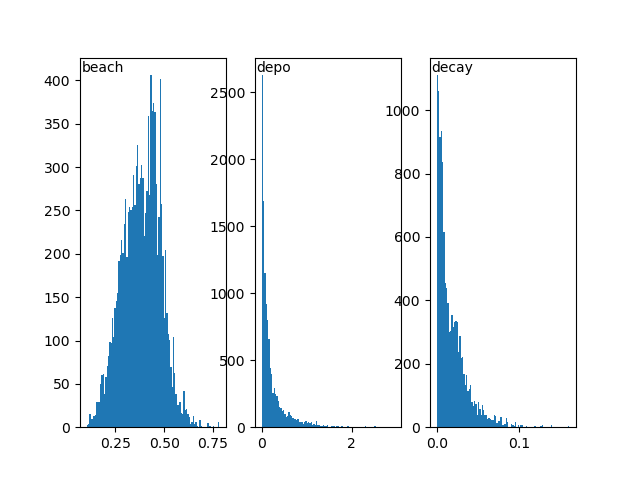

In [451]:
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :]  # discard burn-in points
fig,axs=plt.subplots(1,ndim)
for i,(ax,dim) in enumerate(zip(axs,dims)):
    ax.hist(sample[:,:,i].ravel(),
            bins=100)
    ax.text(0.01,0.99,dim,transform=ax.transAxes,va='top')

In [456]:
# after the fact save those to HDF backend
# Not actually possible.
# Save the xarray instead

ds=xr.Dataset()
ds['param']=('param',),dims
ds['chain']=('walker','step','param'),sampler.chain
ds.attrs['notes']="""Log-normal distribution
no handling for catch efficiency, count data, etc.
"""
ds.to_netcdf("XXbase-samples.nc")

In [9]:
print("\n".join(manta.columns))

SampleID
SAMPLE LOCATION
DATE
TYPE
LAT START
LONG START
LAT END
LONG END
TOTAL DIST (M)
START FLOW
END FLOW
area_km2
volume_m3
FibersYN
Season
time_local
time_utc
lat
lon
volume_l
area_m2
count_preblank_std
count_preblank_nofiber
Fiber
Fiber Bundle
Film
Foam
Fragment
Sphere
Fiber_adj
Fiber Bundle_adj
Fragment_adj
Foam_adj
Film_adj
Sphere_adj
count_std
count_nofiber
part_per_m3_std
part_per_m2_std
part_per_m3_raw_std
part_per_m2_raw_std
part_per_m3_nofiber
part_per_m2_nofiber
part_per_m3_raw_nofiber
part_per_m2_raw_nofiber
x
y
